In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, lb, ub, nu): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_u = make_time_sequence(X_u, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        
        # data
        #形状均为(点的数量，序列长度，1) 
        #初边界点数据
        self.x_u = torch.tensor(X_u[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:,:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)
        

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据


        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #(点的数量，序列长度，1)
        f_pred = self.net_f(self.x_f, self.t_f) #(点的数量，序列长度，1)
        u_pred = u_pred[:,0:1].reshape(-1,1) #(点的数量，序列长度，1)变为(点的数量，1)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # # 初始化一个列表来存储每个epoch的权重矩阵
        # self.weights = []   

        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #(点的数量，序列长度，1)
            f_pred = self.net_f(self.x_f, self.t_f) #(点的数量，序列长度，1)
            u_pred = u_pred[:,0:1].reshape(-1,1) #(点的数量，序列长度，1)变为(点的数量，1)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中











            # # 记录每一层的权重矩阵
            # epoch_weights = []
            # for layer in self.dnn.layers:
            #     if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
            #         epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            # self.weights.append(epoch_weights)

            # W = self.weights

        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    # last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    # last_iter_xs1 = np.array(xs1[-1])
    # distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    # distances = distances.flatten()







    #chunchaos方法
    num_elements_to_average = 20
    # 提取最后 20 个元素
    last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # 存储每个时间步（列表中的每个元素）的混沌度分数
    step_chaos_scores = []
    # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
        # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
        difference_step = step_xs - step_xs1 # 计算差异
        # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
        # 假设使用 NumPy 进行计算
        step_scores = np.linalg.norm(difference_step, axis=(1, 2))
        # 将这 N_f_new 个分数添加到列表中
        step_chaos_scores.append(step_scores)

    # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    all_step_scores = np.stack(step_chaos_scores)
    # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # 沿着时间步轴 (axis=0) 求平均
    distances = np.mean(all_step_scores, axis=0)
    # 结果形状是 (N_f_new,)







    return distances

In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
# layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)


#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子
    nIter = 10000 #设置迭代次数为10000
    nIterLBFGS = 500 #设置LBFGS迭代次数为500

    #2.生成配位点并进行训练

    num_iter = 100 #chaos迭代次数

    #先训练500次
    #采样配位点10个
    N_f_1 = N_f//20 #N_f_1=50
    X_f_train = lb + (ub-lb)*lhs(2, N_f_1)

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, lb, ub, nu)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//20, 0) #使用Adam优化器训练500次


    #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
    for iter in range(nIter//20+1, nIter+1, nIter//20): #每500次迭代
        N_f_new = N_f_1 * 10 #重新采样100个点
        # 生成新的X_f_train数据
        X_f_train_new = lb + (ub-lb)*lhs(2, N_f_new)


        # #计算混沌度
        distances = calculate_chaos(model, X_f_train_new, num_iter)

        # #计算残差
        # residual = model.residual(X_f_train_new)
        # # 计算残差的绝对值
        # abs_residual = np.abs(residual)
        # #将二维数组转换为一维数组
        # abs_residual = abs_residual.flatten()


        #进行归一化
        epsilon = 1e-5
        norm_distances = np.linalg.norm(distances)
        # norm_residual = np.linalg.norm(abs_residual)
        if norm_distances > epsilon:
            distances = distances / norm_distances
        else:
            distances = np.zeros_like(distances)
        # if norm_residual > epsilon:
        #     abs_residual = abs_residual / norm_residual
        # else:
        #     abs_residual = np.zeros_like(abs_residual)



        xinxi = distances #将三个归一化后的数组相加，得到新的数组xinxi

        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并


        X_f = make_time_sequence(X_f_train, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        
        #配位点数据
        model.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)



        # 在更新数据后的模型上进行训练500次
        model.train(nIter//20,0)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:52,  9.46it/s]

Adam:   1%|▏         | 7/500 [00:00<00:12, 37.94it/s]

Adam:   3%|▎         | 14/500 [00:00<00:09, 48.81it/s]

Adam:   4%|▍         | 21/500 [00:00<00:08, 53.98it/s]

Adam:   6%|▌         | 28/500 [00:00<00:08, 56.43it/s]

Adam:   7%|▋         | 34/500 [00:00<00:08, 56.43it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 57.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 58.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 58.97it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:07, 59.78it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:07, 60.45it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:07, 60.62it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 60.74it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 61.22it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 61.27it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 61.36it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 61.10it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:06, 60.74it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:06, 60.68it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:06, 60.14it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 59.82it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:05, 59.50it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 59.45it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 59.33it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 59.27it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.62it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 58.22it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:05, 58.43it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:05, 58.65it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.89it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 59.06it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 59.08it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 59.03it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 59.28it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 59.54it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 59.72it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:04, 59.41it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:04, 58.94it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 58.65it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 58.78it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 59.09it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 58.52it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.13it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 59.53it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 59.61it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 60.10it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 60.32it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 60.33it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 60.58it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:02, 60.24it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 60.35it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 60.39it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 60.71it/s]

Adam:  70%|██████▉   | 349/500 [00:05<00:02, 60.36it/s]

Adam:  71%|███████   | 356/500 [00:06<00:02, 60.44it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:02, 60.92it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 61.07it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 61.03it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:01, 60.87it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 60.96it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 61.05it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 61.04it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 61.12it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 60.93it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 60.02it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:01, 59.76it/s]

Adam:  88%|████████▊ | 439/500 [00:07<00:01, 59.42it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 59.17it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 59.12it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 59.00it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 58.94it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 58.87it/s]

Adam:  95%|█████████▌| 475/500 [00:08<00:00, 58.93it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 58.86it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 59.00it/s]

Adam:  99%|█████████▊| 493/500 [00:08<00:00, 59.26it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.50it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 60.36it/s]

Adam:   3%|▎         | 14/500 [00:00<00:08, 60.69it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 60.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 60.93it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 60.92it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 60.80it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 60.42it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 60.71it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 60.87it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:07, 60.95it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 60.97it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.00it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.10it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.00it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 61.24it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.54it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.59it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.51it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.98it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.82it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.32it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 61.08it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.13it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 60.66it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 60.53it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.02it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.21it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.06it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 60.91it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 60.54it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 59.85it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 59.87it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 60.15it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:04, 60.04it/s]

Adam:  49%|████▉     | 244/500 [00:04<00:04, 59.75it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 59.53it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:04, 59.74it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:03, 59.99it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:03, 60.19it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 60.26it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 59.88it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 60.01it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 59.35it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 59.69it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 59.87it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:03, 59.88it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:02, 59.90it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 60.33it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 60.36it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 60.30it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 60.23it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 60.34it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 60.51it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 60.51it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:01, 60.41it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 60.50it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 60.46it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 60.37it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 60.46it/s]

Adam:  83%|████████▎ | 416/500 [00:06<00:01, 60.49it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:01, 60.62it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 60.59it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 60.27it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 60.31it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 59.98it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 59.67it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 59.49it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 58.93it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 59.16it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 59.32it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 59.36it/s]

Adam:  99%|█████████▊| 493/500 [00:08<00:00, 59.53it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.78it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.84it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 60.35it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 60.46it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 60.20it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 60.29it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 60.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 59.17it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 59.76it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 60.18it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 60.47it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:07, 60.19it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 59.87it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 59.99it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 60.09it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 59.87it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 59.87it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:06, 59.86it/s]

Adam:  25%|██▍       | 123/500 [00:02<00:06, 60.21it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:06, 60.40it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 59.89it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:06, 58.93it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 59.39it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 59.42it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 59.56it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 59.49it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 59.14it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:05, 59.11it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:05, 58.71it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.73it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 59.06it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 59.34it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 59.76it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 60.10it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 60.36it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 60.51it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:04, 60.47it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 60.47it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 60.32it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 59.94it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 59.81it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 60.00it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 60.29it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:03, 60.41it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:03, 60.44it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 60.45it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 59.87it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 59.96it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:02, 59.81it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 59.80it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 59.83it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 59.80it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 59.79it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 59.84it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 59.66it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:02, 58.68it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 59.18it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 59.37it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 58.74it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 58.76it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 59.31it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 59.52it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 59.60it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 59.67it/s]

Adam:  84%|████████▍ | 420/500 [00:07<00:01, 59.64it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 59.56it/s]

Adam:  86%|████████▋ | 432/500 [00:07<00:01, 59.56it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:01, 59.62it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 59.95it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 60.27it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 60.50it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 60.68it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 60.37it/s]

Adam:  96%|█████████▌| 480/500 [00:08<00:00, 60.35it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 60.56it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 60.55it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.21it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 58.89it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 58.54it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 58.49it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 58.62it/s]

Adam:   7%|▋         | 36/500 [00:00<00:07, 58.51it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 58.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 58.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 58.35it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.44it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.39it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.39it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.69it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.13it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.02it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:08, 49.05it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 50.02it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 50.78it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 52.10it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.31it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.22it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 55.01it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.01it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.67it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 57.33it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 57.83it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.98it/s]

Adam:  34%|███▎      | 168/500 [00:03<00:05, 58.14it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:05, 55.21it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:05, 53.83it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:05, 53.88it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:06, 49.70it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:06, 46.56it/s]

Adam:  41%|████      | 203/500 [00:03<00:06, 45.97it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:06, 48.05it/s]

Adam:  43%|████▎     | 214/500 [00:04<00:06, 44.57it/s]

Adam:  44%|████▍     | 219/500 [00:04<00:06, 42.20it/s]

Adam:  45%|████▌     | 225/500 [00:04<00:06, 45.26it/s]

Adam:  46%|████▌     | 230/500 [00:04<00:06, 44.33it/s]

Adam:  47%|████▋     | 235/500 [00:04<00:05, 44.26it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:05, 47.19it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:05, 49.09it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 50.72it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 51.03it/s]

Adam:  53%|█████▎    | 265/500 [00:05<00:04, 51.11it/s]

Adam:  54%|█████▍    | 271/500 [00:05<00:04, 51.87it/s]

Adam:  55%|█████▌    | 277/500 [00:05<00:04, 48.49it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 47.42it/s]

Adam:  57%|█████▋    | 287/500 [00:05<00:04, 46.62it/s]

Adam:  58%|█████▊    | 292/500 [00:05<00:04, 45.18it/s]

Adam:  60%|█████▉    | 298/500 [00:05<00:04, 47.97it/s]

Adam:  61%|██████    | 304/500 [00:05<00:03, 49.93it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 51.37it/s]

Adam:  63%|██████▎   | 316/500 [00:06<00:03, 52.51it/s]

Adam:  64%|██████▍   | 322/500 [00:06<00:03, 53.22it/s]

Adam:  66%|██████▌   | 328/500 [00:06<00:03, 53.74it/s]

Adam:  67%|██████▋   | 334/500 [00:06<00:03, 52.94it/s]

Adam:  68%|██████▊   | 340/500 [00:06<00:03, 51.46it/s]

Adam:  69%|██████▉   | 346/500 [00:06<00:02, 52.47it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 52.53it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 51.61it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 52.53it/s]

Adam:  74%|███████▍  | 370/500 [00:07<00:02, 52.60it/s]

Adam:  75%|███████▌  | 376/500 [00:07<00:02, 53.30it/s]

Adam:  76%|███████▋  | 382/500 [00:07<00:02, 53.79it/s]

Adam:  78%|███████▊  | 388/500 [00:07<00:02, 54.04it/s]

Adam:  79%|███████▉  | 394/500 [00:07<00:02, 52.74it/s]

Adam:  80%|████████  | 400/500 [00:07<00:01, 51.57it/s]

Adam:  81%|████████  | 406/500 [00:07<00:01, 51.77it/s]

Adam:  82%|████████▏ | 412/500 [00:07<00:01, 51.31it/s]

Adam:  84%|████████▎ | 418/500 [00:08<00:01, 49.42it/s]

Adam:  85%|████████▍ | 423/500 [00:08<00:01, 49.40it/s]

Adam:  86%|████████▌ | 429/500 [00:08<00:01, 50.94it/s]

Adam:  87%|████████▋ | 435/500 [00:08<00:01, 48.13it/s]

Adam:  88%|████████▊ | 441/500 [00:08<00:01, 49.09it/s]

Adam:  89%|████████▉ | 447/500 [00:08<00:01, 50.69it/s]

Adam:  91%|█████████ | 453/500 [00:08<00:00, 48.99it/s]

Adam:  92%|█████████▏| 459/500 [00:08<00:00, 50.34it/s]

Adam:  93%|█████████▎| 465/500 [00:08<00:00, 51.50it/s]

Adam:  94%|█████████▍| 471/500 [00:09<00:00, 52.43it/s]

Adam:  95%|█████████▌| 477/500 [00:09<00:00, 51.54it/s]

Adam:  97%|█████████▋| 483/500 [00:09<00:00, 53.15it/s]

Adam:  98%|█████████▊| 489/500 [00:09<00:00, 54.81it/s]

Adam:  99%|█████████▉| 495/500 [00:09<00:00, 56.21it/s]

Adam: 100%|██████████| 500/500 [00:09<00:00, 52.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 55.46it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 55.69it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 53.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:09, 52.71it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 52.55it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 52.47it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 52.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 52.99it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 53.59it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.95it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 54.12it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.39it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.51it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.60it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.60it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.66it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 54.71it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:07, 54.07it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.18it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 52.94it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:07, 52.82it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 52.72it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 52.69it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.64it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 52.69it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 52.67it/s]

Adam:  32%|███▏      | 162/500 [00:03<00:06, 52.31it/s]

Adam:  34%|███▎      | 168/500 [00:03<00:06, 47.60it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:06, 48.67it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:06, 49.72it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:06, 50.53it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:06, 51.08it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.51it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 51.88it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:05, 52.02it/s]

Adam:  43%|████▎     | 216/500 [00:04<00:05, 52.31it/s]

Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.73it/s]

Adam:  46%|████▌     | 228/500 [00:04<00:05, 52.02it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:05, 52.40it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:04, 52.62it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 52.42it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 52.51it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 52.57it/s]

Adam:  53%|█████▎    | 264/500 [00:05<00:04, 52.56it/s]

Adam:  54%|█████▍    | 270/500 [00:05<00:04, 52.49it/s]

Adam:  55%|█████▌    | 276/500 [00:05<00:04, 52.38it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 52.49it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 52.88it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:03, 52.94it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 52.87it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 52.51it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 52.81it/s]

Adam:  64%|██████▎   | 318/500 [00:06<00:03, 52.24it/s]

Adam:  65%|██████▍   | 324/500 [00:06<00:03, 52.36it/s]

Adam:  66%|██████▌   | 330/500 [00:06<00:03, 51.93it/s]

Adam:  67%|██████▋   | 336/500 [00:06<00:03, 52.44it/s]

Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.95it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:02, 52.29it/s]

Adam:  71%|███████   | 354/500 [00:06<00:02, 52.71it/s]

Adam:  72%|███████▏  | 360/500 [00:06<00:02, 52.98it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 52.94it/s]

Adam:  74%|███████▍  | 372/500 [00:07<00:02, 52.95it/s]

Adam:  76%|███████▌  | 378/500 [00:07<00:02, 50.80it/s]

Adam:  77%|███████▋  | 384/500 [00:07<00:02, 47.48it/s]

Adam:  78%|███████▊  | 390/500 [00:07<00:02, 49.00it/s]

Adam:  79%|███████▉  | 396/500 [00:07<00:02, 50.32it/s]

Adam:  80%|████████  | 402/500 [00:07<00:01, 51.27it/s]

Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.90it/s]

Adam:  83%|████████▎ | 414/500 [00:07<00:01, 52.20it/s]

Adam:  84%|████████▍ | 420/500 [00:08<00:01, 52.47it/s]

Adam:  85%|████████▌ | 426/500 [00:08<00:01, 52.83it/s]

Adam:  86%|████████▋ | 432/500 [00:08<00:01, 53.00it/s]

Adam:  88%|████████▊ | 438/500 [00:08<00:01, 53.04it/s]

Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.08it/s]

Adam:  90%|█████████ | 450/500 [00:08<00:00, 53.25it/s]

Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.40it/s]

Adam:  92%|█████████▏| 462/500 [00:08<00:00, 53.28it/s]

Adam:  94%|█████████▎| 468/500 [00:08<00:00, 53.23it/s]

Adam:  95%|█████████▍| 474/500 [00:09<00:00, 50.82it/s]

Adam:  96%|█████████▌| 480/500 [00:09<00:00, 47.55it/s]

Adam:  97%|█████████▋| 486/500 [00:09<00:00, 49.05it/s]

Adam:  98%|█████████▊| 492/500 [00:09<00:00, 50.37it/s]

Adam: 100%|█████████▉| 498/500 [00:09<00:00, 51.33it/s]

Adam: 100%|██████████| 500/500 [00:09<00:00, 52.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:09, 49.89it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 50.13it/s]

Adam:   3%|▎         | 17/500 [00:00<00:09, 50.14it/s]

Adam:   5%|▍         | 23/500 [00:00<00:09, 49.95it/s]

Adam:   6%|▌         | 28/500 [00:00<00:09, 49.93it/s]

Adam:   7%|▋         | 34/500 [00:00<00:09, 50.05it/s]

Adam:   8%|▊         | 40/500 [00:00<00:09, 49.98it/s]

Adam:   9%|▉         | 45/500 [00:00<00:09, 49.69it/s]

Adam:  10%|█         | 51/500 [00:01<00:09, 49.85it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:08, 50.04it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:08, 50.00it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:08, 49.86it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:08, 49.96it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:08, 50.11it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:08, 50.10it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:08, 49.95it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:08, 49.89it/s]

Adam:  21%|██        | 103/500 [00:02<00:07, 50.09it/s]

Adam:  22%|██▏       | 109/500 [00:02<00:07, 50.15it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:07, 49.93it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:07, 50.02it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:07, 50.11it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:07, 48.88it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:07, 49.08it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:07, 47.76it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:07, 46.84it/s]

Adam:  31%|███       | 153/500 [00:03<00:07, 43.70it/s]

Adam:  32%|███▏      | 158/500 [00:03<00:07, 44.14it/s]

Adam:  33%|███▎      | 163/500 [00:03<00:07, 45.53it/s]

Adam:  34%|███▎      | 168/500 [00:03<00:07, 46.71it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:06, 47.73it/s]

Adam:  36%|███▌      | 179/500 [00:03<00:06, 48.27it/s]

Adam:  37%|███▋      | 184/500 [00:03<00:06, 48.76it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:06, 49.28it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:06, 49.02it/s]

Adam:  40%|████      | 200/500 [00:04<00:06, 49.17it/s]

Adam:  41%|████      | 205/500 [00:04<00:05, 49.24it/s]

Adam:  42%|████▏     | 210/500 [00:04<00:05, 49.12it/s]

Adam:  43%|████▎     | 215/500 [00:04<00:06, 46.76it/s]

Adam:  44%|████▍     | 220/500 [00:04<00:05, 47.54it/s]

Adam:  45%|████▌     | 225/500 [00:04<00:05, 48.12it/s]

Adam:  46%|████▌     | 231/500 [00:04<00:05, 48.91it/s]

Adam:  47%|████▋     | 237/500 [00:04<00:05, 49.45it/s]

Adam:  49%|████▊     | 243/500 [00:04<00:05, 49.82it/s]

Adam:  50%|████▉     | 249/500 [00:05<00:05, 49.91it/s]

Adam:  51%|█████     | 254/500 [00:05<00:05, 48.37it/s]

Adam:  52%|█████▏    | 259/500 [00:05<00:04, 48.80it/s]

Adam:  53%|█████▎    | 264/500 [00:05<00:04, 49.07it/s]

Adam:  54%|█████▍    | 269/500 [00:05<00:04, 48.92it/s]

Adam:  55%|█████▍    | 274/500 [00:05<00:04, 49.22it/s]

Adam:  56%|█████▌    | 280/500 [00:05<00:04, 49.52it/s]

Adam:  57%|█████▋    | 285/500 [00:05<00:04, 49.63it/s]

Adam:  58%|█████▊    | 290/500 [00:05<00:04, 49.40it/s]

Adam:  59%|█████▉    | 295/500 [00:06<00:04, 49.45it/s]

Adam:  60%|██████    | 301/500 [00:06<00:03, 49.87it/s]

Adam:  61%|██████▏   | 307/500 [00:06<00:03, 50.03it/s]

Adam:  62%|██████▏   | 312/500 [00:06<00:03, 48.21it/s]

Adam:  63%|██████▎   | 317/500 [00:06<00:03, 47.69it/s]

Adam:  65%|██████▍   | 323/500 [00:06<00:03, 48.54it/s]

Adam:  66%|██████▌   | 329/500 [00:06<00:03, 49.15it/s]

Adam:  67%|██████▋   | 334/500 [00:06<00:03, 49.13it/s]

Adam:  68%|██████▊   | 339/500 [00:06<00:03, 47.65it/s]

Adam:  69%|██████▉   | 345/500 [00:07<00:03, 48.53it/s]

Adam:  70%|███████   | 351/500 [00:07<00:03, 49.09it/s]

Adam:  71%|███████   | 356/500 [00:07<00:02, 49.13it/s]

Adam:  72%|███████▏  | 361/500 [00:07<00:02, 48.90it/s]

Adam:  73%|███████▎  | 367/500 [00:07<00:02, 49.35it/s]

Adam:  75%|███████▍  | 373/500 [00:07<00:02, 49.64it/s]

Adam:  76%|███████▌  | 378/500 [00:07<00:02, 49.57it/s]

Adam:  77%|███████▋  | 383/500 [00:07<00:02, 49.52it/s]

Adam:  78%|███████▊  | 388/500 [00:07<00:02, 49.64it/s]

Adam:  79%|███████▉  | 394/500 [00:08<00:02, 49.81it/s]

Adam:  80%|███████▉  | 399/500 [00:08<00:02, 49.85it/s]

Adam:  81%|████████  | 404/500 [00:08<00:01, 49.76it/s]

Adam:  82%|████████▏ | 410/500 [00:08<00:01, 49.87it/s]

Adam:  83%|████████▎ | 415/500 [00:08<00:01, 49.55it/s]

Adam:  84%|████████▍ | 420/500 [00:08<00:01, 48.30it/s]

Adam:  85%|████████▌ | 425/500 [00:08<00:01, 48.67it/s]

Adam:  86%|████████▌ | 430/500 [00:08<00:01, 48.97it/s]

Adam:  87%|████████▋ | 436/500 [00:08<00:01, 49.06it/s]

Adam:  88%|████████▊ | 441/500 [00:09<00:01, 46.42it/s]

Adam:  89%|████████▉ | 446/500 [00:09<00:01, 42.25it/s]

Adam:  90%|█████████ | 451/500 [00:09<00:01, 44.23it/s]

Adam:  91%|█████████▏| 457/500 [00:09<00:00, 46.11it/s]

Adam:  93%|█████████▎| 463/500 [00:09<00:00, 47.36it/s]

Adam:  94%|█████████▎| 468/500 [00:09<00:00, 47.93it/s]

Adam:  95%|█████████▍| 473/500 [00:09<00:00, 48.41it/s]

Adam:  96%|█████████▌| 479/500 [00:09<00:00, 49.00it/s]

Adam:  97%|█████████▋| 485/500 [00:09<00:00, 49.42it/s]

Adam:  98%|█████████▊| 490/500 [00:10<00:00, 49.50it/s]

Adam:  99%|█████████▉| 495/500 [00:10<00:00, 49.39it/s]

Adam: 100%|██████████| 500/500 [00:10<00:00, 48.24it/s]

Adam: 100%|██████████| 500/500 [00:10<00:00, 48.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:11, 42.80it/s]

Adam:   2%|▏         | 10/500 [00:00<00:10, 45.43it/s]

Adam:   3%|▎         | 15/500 [00:00<00:10, 46.41it/s]

Adam:   4%|▍         | 20/500 [00:00<00:10, 46.80it/s]

Adam:   5%|▌         | 25/500 [00:00<00:10, 46.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:09, 47.03it/s]

Adam:   7%|▋         | 35/500 [00:00<00:09, 47.21it/s]

Adam:   8%|▊         | 40/500 [00:00<00:09, 47.34it/s]

Adam:   9%|▉         | 45/500 [00:00<00:09, 47.24it/s]

Adam:  10%|█         | 50/500 [00:01<00:09, 46.92it/s]

Adam:  11%|█         | 55/500 [00:01<00:09, 46.02it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:09, 45.82it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:09, 45.34it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:09, 45.14it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:09, 45.78it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:09, 43.18it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:09, 42.19it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:09, 43.49it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:09, 44.62it/s]

Adam:  20%|██        | 100/500 [00:02<00:08, 45.57it/s]

Adam:  21%|██        | 105/500 [00:02<00:08, 46.36it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:08, 47.00it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:08, 47.54it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 48.17it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:07, 48.52it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:07, 48.74it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:07, 49.01it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:07, 49.08it/s]

Adam:  29%|██▉       | 145/500 [00:03<00:07, 49.25it/s]

Adam:  30%|███       | 150/500 [00:03<00:07, 49.29it/s]

Adam:  31%|███       | 155/500 [00:03<00:06, 49.29it/s]

Adam:  32%|███▏      | 160/500 [00:03<00:06, 49.37it/s]

Adam:  33%|███▎      | 165/500 [00:03<00:06, 49.53it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:06, 49.51it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:06, 49.48it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:06, 49.48it/s]

Adam:  37%|███▋      | 185/500 [00:03<00:06, 49.47it/s]

Adam:  38%|███▊      | 190/500 [00:04<00:06, 49.48it/s]

Adam:  39%|███▉      | 195/500 [00:04<00:06, 49.41it/s]

Adam:  40%|████      | 200/500 [00:04<00:06, 49.43it/s]

Adam:  41%|████      | 205/500 [00:04<00:05, 49.43it/s]

Adam:  42%|████▏     | 210/500 [00:04<00:05, 49.53it/s]

Adam:  43%|████▎     | 215/500 [00:04<00:05, 49.59it/s]

Adam:  44%|████▍     | 220/500 [00:04<00:05, 49.59it/s]

Adam:  45%|████▌     | 225/500 [00:04<00:05, 49.59it/s]

Adam:  46%|████▌     | 230/500 [00:04<00:05, 49.49it/s]

Adam:  47%|████▋     | 235/500 [00:04<00:05, 49.49it/s]

Adam:  48%|████▊     | 240/500 [00:05<00:05, 49.50it/s]

Adam:  49%|████▉     | 245/500 [00:05<00:05, 49.52it/s]

Adam:  50%|█████     | 250/500 [00:05<00:05, 49.57it/s]

Adam:  51%|█████     | 255/500 [00:05<00:04, 49.58it/s]

Adam:  52%|█████▏    | 260/500 [00:05<00:04, 49.55it/s]

Adam:  53%|█████▎    | 265/500 [00:05<00:04, 49.50it/s]

Adam:  54%|█████▍    | 270/500 [00:05<00:04, 48.96it/s]

Adam:  55%|█████▌    | 275/500 [00:05<00:04, 48.17it/s]

Adam:  56%|█████▌    | 280/500 [00:05<00:04, 47.66it/s]

Adam:  57%|█████▋    | 285/500 [00:05<00:04, 47.37it/s]

Adam:  58%|█████▊    | 290/500 [00:06<00:04, 46.50it/s]

Adam:  59%|█████▉    | 295/500 [00:06<00:04, 46.26it/s]

Adam:  60%|██████    | 300/500 [00:06<00:04, 46.63it/s]

Adam:  61%|██████    | 305/500 [00:06<00:04, 44.58it/s]

Adam:  62%|██████▏   | 310/500 [00:06<00:04, 45.27it/s]

Adam:  63%|██████▎   | 315/500 [00:06<00:04, 46.01it/s]

Adam:  64%|██████▍   | 320/500 [00:06<00:03, 46.46it/s]

Adam:  65%|██████▌   | 325/500 [00:06<00:03, 46.67it/s]

Adam:  66%|██████▌   | 330/500 [00:06<00:03, 46.93it/s]

Adam:  67%|██████▋   | 335/500 [00:07<00:03, 47.08it/s]

Adam:  68%|██████▊   | 340/500 [00:07<00:03, 47.17it/s]

Adam:  69%|██████▉   | 345/500 [00:07<00:03, 47.29it/s]

Adam:  70%|███████   | 350/500 [00:07<00:03, 47.25it/s]

Adam:  71%|███████   | 355/500 [00:07<00:03, 47.25it/s]

Adam:  72%|███████▏  | 360/500 [00:07<00:02, 47.32it/s]

Adam:  73%|███████▎  | 365/500 [00:07<00:02, 47.41it/s]

Adam:  74%|███████▍  | 370/500 [00:07<00:02, 47.44it/s]

Adam:  75%|███████▌  | 375/500 [00:07<00:02, 47.34it/s]

Adam:  76%|███████▌  | 380/500 [00:07<00:02, 47.45it/s]

Adam:  77%|███████▋  | 385/500 [00:08<00:02, 47.44it/s]

Adam:  78%|███████▊  | 390/500 [00:08<00:02, 47.46it/s]

Adam:  79%|███████▉  | 395/500 [00:08<00:02, 47.51it/s]

Adam:  80%|████████  | 400/500 [00:08<00:02, 47.59it/s]

Adam:  81%|████████  | 405/500 [00:08<00:01, 47.61it/s]

Adam:  82%|████████▏ | 410/500 [00:08<00:01, 47.60it/s]

Adam:  83%|████████▎ | 415/500 [00:08<00:01, 47.55it/s]

Adam:  84%|████████▍ | 420/500 [00:08<00:01, 44.37it/s]

Adam:  85%|████████▌ | 425/500 [00:08<00:01, 44.62it/s]

Adam:  86%|████████▌ | 430/500 [00:09<00:01, 44.22it/s]

Adam:  87%|████████▋ | 435/500 [00:09<00:01, 45.00it/s]

Adam:  88%|████████▊ | 440/500 [00:09<00:01, 45.65it/s]

Adam:  89%|████████▉ | 445/500 [00:09<00:01, 44.56it/s]

Adam:  90%|█████████ | 450/500 [00:09<00:01, 42.09it/s]

Adam:  91%|█████████ | 455/500 [00:09<00:01, 42.67it/s]

Adam:  92%|█████████▏| 460/500 [00:09<00:00, 44.05it/s]

Adam:  93%|█████████▎| 465/500 [00:09<00:00, 42.98it/s]

Adam:  94%|█████████▍| 470/500 [00:09<00:00, 44.32it/s]

Adam:  95%|█████████▌| 475/500 [00:10<00:00, 44.98it/s]

Adam:  96%|█████████▌| 480/500 [00:10<00:00, 45.73it/s]

Adam:  97%|█████████▋| 485/500 [00:10<00:00, 45.90it/s]

Adam:  98%|█████████▊| 490/500 [00:10<00:00, 45.49it/s]

Adam:  99%|█████████▉| 495/500 [00:10<00:00, 46.10it/s]

Adam: 100%|██████████| 500/500 [00:10<00:00, 45.50it/s]

Adam: 100%|██████████| 500/500 [00:10<00:00, 46.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:11, 43.24it/s]

Adam:   2%|▏         | 10/500 [00:00<00:11, 44.09it/s]

Adam:   3%|▎         | 15/500 [00:00<00:10, 44.54it/s]

Adam:   4%|▍         | 20/500 [00:00<00:10, 44.53it/s]

Adam:   5%|▌         | 25/500 [00:00<00:10, 44.21it/s]

Adam:   6%|▌         | 30/500 [00:00<00:10, 43.66it/s]

Adam:   7%|▋         | 35/500 [00:00<00:10, 44.02it/s]

Adam:   8%|▊         | 40/500 [00:00<00:10, 44.26it/s]

Adam:   9%|▉         | 45/500 [00:01<00:10, 44.49it/s]

Adam:  10%|█         | 50/500 [00:01<00:10, 44.01it/s]

Adam:  11%|█         | 55/500 [00:01<00:10, 44.26it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:09, 44.40it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:09, 44.55it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:09, 44.67it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:09, 44.77it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:09, 44.81it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:09, 44.60it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:09, 44.76it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:09, 43.39it/s]

Adam:  20%|██        | 100/500 [00:02<00:09, 43.58it/s]

Adam:  21%|██        | 105/500 [00:02<00:09, 39.76it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:09, 40.29it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:09, 41.59it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:08, 42.66it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:08, 43.02it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:08, 43.40it/s]

Adam:  27%|██▋       | 135/500 [00:03<00:08, 43.30it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:08, 42.32it/s]

Adam:  29%|██▉       | 145/500 [00:03<00:08, 43.05it/s]

Adam:  30%|███       | 150/500 [00:03<00:08, 43.53it/s]

Adam:  31%|███       | 155/500 [00:03<00:07, 43.97it/s]

Adam:  32%|███▏      | 160/500 [00:03<00:07, 44.25it/s]

Adam:  33%|███▎      | 165/500 [00:03<00:07, 44.42it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:07, 44.53it/s]

Adam:  35%|███▌      | 175/500 [00:04<00:07, 43.49it/s]

Adam:  36%|███▌      | 180/500 [00:04<00:07, 43.67it/s]

Adam:  37%|███▋      | 185/500 [00:04<00:07, 44.00it/s]

Adam:  38%|███▊      | 190/500 [00:04<00:07, 44.22it/s]

Adam:  39%|███▉      | 195/500 [00:04<00:06, 44.42it/s]

Adam:  40%|████      | 200/500 [00:04<00:06, 44.49it/s]

Adam:  41%|████      | 205/500 [00:04<00:06, 44.65it/s]

Adam:  42%|████▏     | 210/500 [00:04<00:06, 44.71it/s]

Adam:  43%|████▎     | 215/500 [00:04<00:06, 44.17it/s]

Adam:  44%|████▍     | 220/500 [00:05<00:06, 44.40it/s]

Adam:  45%|████▌     | 225/500 [00:05<00:06, 42.94it/s]

Adam:  46%|████▌     | 230/500 [00:05<00:06, 41.31it/s]

Adam:  47%|████▋     | 235/500 [00:05<00:06, 42.06it/s]

Adam:  48%|████▊     | 240/500 [00:05<00:06, 42.84it/s]

Adam:  49%|████▉     | 245/500 [00:05<00:06, 41.73it/s]

Adam:  50%|█████     | 250/500 [00:05<00:05, 42.25it/s]

Adam:  51%|█████     | 255/500 [00:05<00:06, 39.00it/s]

Adam:  52%|█████▏    | 260/500 [00:06<00:05, 40.60it/s]

Adam:  53%|█████▎    | 265/500 [00:06<00:05, 41.83it/s]

Adam:  54%|█████▍    | 270/500 [00:06<00:05, 42.69it/s]

Adam:  55%|█████▌    | 275/500 [00:06<00:05, 39.12it/s]

Adam:  56%|█████▌    | 279/500 [00:06<00:05, 38.80it/s]

Adam:  57%|█████▋    | 283/500 [00:06<00:05, 37.95it/s]

Adam:  58%|█████▊    | 288/500 [00:06<00:05, 39.23it/s]

Adam:  59%|█████▊    | 293/500 [00:06<00:05, 40.96it/s]

Adam:  60%|█████▉    | 298/500 [00:06<00:04, 42.20it/s]

Adam:  61%|██████    | 303/500 [00:07<00:04, 43.04it/s]

Adam:  62%|██████▏   | 308/500 [00:07<00:04, 43.23it/s]

Adam:  63%|██████▎   | 313/500 [00:07<00:04, 43.72it/s]

Adam:  64%|██████▎   | 318/500 [00:07<00:04, 43.04it/s]

Adam:  65%|██████▍   | 323/500 [00:07<00:04, 41.75it/s]

Adam:  66%|██████▌   | 328/500 [00:07<00:04, 41.25it/s]

Adam:  67%|██████▋   | 333/500 [00:07<00:04, 41.10it/s]

Adam:  68%|██████▊   | 338/500 [00:07<00:03, 42.16it/s]

Adam:  69%|██████▊   | 343/500 [00:07<00:03, 42.90it/s]

Adam:  70%|██████▉   | 348/500 [00:08<00:03, 42.18it/s]

Adam:  71%|███████   | 353/500 [00:08<00:03, 42.96it/s]

Adam:  72%|███████▏  | 358/500 [00:08<00:03, 43.38it/s]

Adam:  73%|███████▎  | 363/500 [00:08<00:03, 42.12it/s]

Adam:  74%|███████▎  | 368/500 [00:08<00:03, 42.89it/s]

Adam:  75%|███████▍  | 373/500 [00:08<00:02, 42.78it/s]

Adam:  76%|███████▌  | 378/500 [00:08<00:02, 42.55it/s]

Adam:  77%|███████▋  | 383/500 [00:08<00:02, 42.90it/s]

Adam:  78%|███████▊  | 388/500 [00:09<00:02, 43.39it/s]

Adam:  79%|███████▊  | 393/500 [00:09<00:02, 41.49it/s]

Adam:  80%|███████▉  | 398/500 [00:09<00:02, 40.96it/s]

Adam:  81%|████████  | 403/500 [00:09<00:02, 40.19it/s]

Adam:  82%|████████▏ | 408/500 [00:09<00:02, 41.51it/s]

Adam:  83%|████████▎ | 413/500 [00:09<00:02, 42.04it/s]

Adam:  84%|████████▎ | 418/500 [00:09<00:01, 42.88it/s]

Adam:  85%|████████▍ | 423/500 [00:09<00:01, 42.91it/s]

Adam:  86%|████████▌ | 428/500 [00:10<00:01, 43.48it/s]

Adam:  87%|████████▋ | 433/500 [00:10<00:01, 43.79it/s]

Adam:  88%|████████▊ | 438/500 [00:10<00:01, 44.10it/s]

Adam:  89%|████████▊ | 443/500 [00:10<00:01, 44.26it/s]

Adam:  90%|████████▉ | 448/500 [00:10<00:01, 44.41it/s]

Adam:  91%|█████████ | 453/500 [00:10<00:01, 44.48it/s]

Adam:  92%|█████████▏| 458/500 [00:10<00:00, 43.82it/s]

Adam:  93%|█████████▎| 463/500 [00:10<00:00, 43.30it/s]

Adam:  94%|█████████▎| 468/500 [00:10<00:00, 41.19it/s]

Adam:  95%|█████████▍| 473/500 [00:11<00:00, 41.17it/s]

Adam:  96%|█████████▌| 478/500 [00:11<00:00, 42.05it/s]

Adam:  97%|█████████▋| 483/500 [00:11<00:00, 42.79it/s]

Adam:  98%|█████████▊| 488/500 [00:11<00:00, 43.37it/s]

Adam:  99%|█████████▊| 493/500 [00:11<00:00, 42.62it/s]

Adam: 100%|█████████▉| 498/500 [00:11<00:00, 42.56it/s]

Adam: 100%|██████████| 500/500 [00:11<00:00, 42.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:12, 39.99it/s]

Adam:   2%|▏         | 8/500 [00:00<00:12, 39.70it/s]

Adam:   2%|▏         | 12/500 [00:00<00:12, 37.64it/s]

Adam:   3%|▎         | 17/500 [00:00<00:12, 37.87it/s]

Adam:   4%|▍         | 22/500 [00:00<00:12, 39.44it/s]

Adam:   5%|▌         | 27/500 [00:00<00:11, 40.21it/s]

Adam:   6%|▋         | 32/500 [00:00<00:11, 40.85it/s]

Adam:   7%|▋         | 37/500 [00:00<00:11, 41.30it/s]

Adam:   8%|▊         | 42/500 [00:01<00:11, 41.63it/s]

Adam:   9%|▉         | 47/500 [00:01<00:10, 41.22it/s]

Adam:  10%|█         | 52/500 [00:01<00:11, 38.83it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:11, 39.79it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:10, 40.48it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:10, 40.96it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:10, 41.35it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:10, 40.35it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:10, 40.80it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:10, 40.90it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:10, 40.00it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:10, 38.52it/s]

Adam:  20%|██        | 102/500 [00:02<00:10, 39.54it/s]

Adam:  21%|██▏       | 107/500 [00:02<00:09, 40.08it/s]

Adam:  22%|██▏       | 112/500 [00:02<00:09, 40.26it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:10, 37.99it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:09, 38.10it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:09, 39.00it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:09, 39.88it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:09, 39.58it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:09, 39.59it/s]

Adam:  29%|██▉       | 145/500 [00:03<00:09, 37.14it/s]

Adam:  30%|██▉       | 149/500 [00:03<00:09, 35.90it/s]

Adam:  31%|███       | 153/500 [00:03<00:09, 36.34it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:09, 36.35it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:09, 36.94it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:08, 38.08it/s]

Adam:  34%|███▍      | 171/500 [00:04<00:08, 39.32it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:08, 39.43it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:07, 40.20it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:07, 40.42it/s]

Adam:  38%|███▊      | 191/500 [00:04<00:07, 40.92it/s]

Adam:  39%|███▉      | 196/500 [00:04<00:07, 41.37it/s]

Adam:  40%|████      | 201/500 [00:05<00:07, 40.82it/s]

Adam:  41%|████      | 206/500 [00:05<00:07, 39.50it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:07, 39.13it/s]

Adam:  43%|████▎     | 214/500 [00:05<00:07, 38.33it/s]

Adam:  44%|████▎     | 218/500 [00:05<00:07, 37.89it/s]

Adam:  44%|████▍     | 222/500 [00:05<00:07, 36.05it/s]

Adam:  45%|████▌     | 226/500 [00:05<00:07, 36.47it/s]

Adam:  46%|████▌     | 230/500 [00:05<00:07, 36.66it/s]

Adam:  47%|████▋     | 234/500 [00:05<00:07, 35.37it/s]

Adam:  48%|████▊     | 238/500 [00:06<00:07, 36.19it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:06, 38.05it/s]

Adam:  50%|████▉     | 248/500 [00:06<00:06, 39.38it/s]

Adam:  51%|█████     | 253/500 [00:06<00:06, 40.24it/s]

Adam:  52%|█████▏    | 258/500 [00:06<00:05, 40.83it/s]

Adam:  53%|█████▎    | 263/500 [00:06<00:05, 41.29it/s]

Adam:  54%|█████▎    | 268/500 [00:06<00:05, 41.54it/s]

Adam:  55%|█████▍    | 273/500 [00:06<00:05, 41.76it/s]

Adam:  56%|█████▌    | 278/500 [00:07<00:05, 41.88it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:05, 41.92it/s]

Adam:  58%|█████▊    | 288/500 [00:07<00:05, 41.99it/s]

Adam:  59%|█████▊    | 293/500 [00:07<00:04, 42.08it/s]

Adam:  60%|█████▉    | 298/500 [00:07<00:04, 42.11it/s]

Adam:  61%|██████    | 303/500 [00:07<00:04, 42.17it/s]

Adam:  62%|██████▏   | 308/500 [00:07<00:04, 42.20it/s]

Adam:  63%|██████▎   | 313/500 [00:07<00:04, 42.23it/s]

Adam:  64%|██████▎   | 318/500 [00:07<00:04, 42.18it/s]

Adam:  65%|██████▍   | 323/500 [00:08<00:04, 40.47it/s]

Adam:  66%|██████▌   | 328/500 [00:08<00:04, 40.97it/s]

Adam:  67%|██████▋   | 333/500 [00:08<00:04, 41.36it/s]

Adam:  68%|██████▊   | 338/500 [00:08<00:03, 41.47it/s]

Adam:  69%|██████▊   | 343/500 [00:08<00:03, 40.94it/s]

Adam:  70%|██████▉   | 348/500 [00:08<00:03, 40.64it/s]

Adam:  71%|███████   | 353/500 [00:08<00:03, 39.90it/s]

Adam:  72%|███████▏  | 358/500 [00:08<00:03, 40.58it/s]

Adam:  73%|███████▎  | 363/500 [00:09<00:03, 40.60it/s]

Adam:  74%|███████▎  | 368/500 [00:09<00:03, 40.69it/s]

Adam:  75%|███████▍  | 373/500 [00:09<00:03, 41.11it/s]

Adam:  76%|███████▌  | 378/500 [00:09<00:02, 41.32it/s]

Adam:  77%|███████▋  | 383/500 [00:09<00:02, 41.33it/s]

Adam:  78%|███████▊  | 388/500 [00:09<00:02, 40.62it/s]

Adam:  79%|███████▊  | 393/500 [00:09<00:02, 39.51it/s]

Adam:  80%|███████▉  | 398/500 [00:09<00:02, 40.03it/s]

Adam:  81%|████████  | 403/500 [00:10<00:02, 39.58it/s]

Adam:  82%|████████▏ | 408/500 [00:10<00:02, 40.34it/s]

Adam:  83%|████████▎ | 413/500 [00:10<00:02, 40.88it/s]

Adam:  84%|████████▎ | 418/500 [00:10<00:02, 40.67it/s]

Adam:  85%|████████▍ | 423/500 [00:10<00:01, 40.93it/s]

Adam:  86%|████████▌ | 428/500 [00:10<00:01, 41.30it/s]

Adam:  87%|████████▋ | 433/500 [00:10<00:01, 41.27it/s]

Adam:  88%|████████▊ | 438/500 [00:10<00:01, 41.54it/s]

Adam:  89%|████████▊ | 443/500 [00:11<00:01, 41.71it/s]

Adam:  90%|████████▉ | 448/500 [00:11<00:01, 40.92it/s]

Adam:  91%|█████████ | 453/500 [00:11<00:01, 40.12it/s]

Adam:  92%|█████████▏| 458/500 [00:11<00:01, 39.58it/s]

Adam:  93%|█████████▎| 463/500 [00:11<00:00, 40.36it/s]

Adam:  94%|█████████▎| 468/500 [00:11<00:00, 40.34it/s]

Adam:  95%|█████████▍| 473/500 [00:11<00:00, 40.89it/s]

Adam:  96%|█████████▌| 478/500 [00:11<00:00, 41.33it/s]

Adam:  97%|█████████▋| 483/500 [00:12<00:00, 41.59it/s]

Adam:  98%|█████████▊| 488/500 [00:12<00:00, 41.72it/s]

Adam:  99%|█████████▊| 493/500 [00:12<00:00, 41.84it/s]

Adam: 100%|█████████▉| 498/500 [00:12<00:00, 41.96it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 40.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:12, 38.20it/s]

Adam:   2%|▏         | 8/500 [00:00<00:12, 38.24it/s]

Adam:   2%|▏         | 12/500 [00:00<00:12, 38.27it/s]

Adam:   3%|▎         | 16/500 [00:00<00:12, 38.29it/s]

Adam:   4%|▍         | 20/500 [00:00<00:12, 38.29it/s]

Adam:   5%|▍         | 24/500 [00:00<00:12, 38.23it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 38.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:12, 38.24it/s]

Adam:   7%|▋         | 36/500 [00:00<00:12, 37.20it/s]

Adam:   8%|▊         | 40/500 [00:01<00:12, 37.48it/s]

Adam:   9%|▉         | 44/500 [00:01<00:12, 37.73it/s]

Adam:  10%|▉         | 48/500 [00:01<00:11, 37.89it/s]

Adam:  10%|█         | 52/500 [00:01<00:11, 37.97it/s]

Adam:  11%|█         | 56/500 [00:01<00:11, 38.07it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:11, 38.13it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:11, 38.19it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 38.13it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:11, 38.16it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:11, 38.24it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:11, 38.04it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:11, 36.36it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:11, 36.71it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:10, 37.15it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:10, 37.44it/s]

Adam:  20%|██        | 100/500 [00:02<00:10, 37.59it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 36.15it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:11, 34.68it/s]

Adam:  22%|██▏       | 112/500 [00:02<00:10, 35.60it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 36.34it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 36.87it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 37.23it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 37.19it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 36.32it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 35.84it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:10, 35.22it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:09, 35.80it/s]

Adam:  30%|██▉       | 148/500 [00:03<00:09, 36.51it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 36.53it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 36.57it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:09, 36.70it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 37.15it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 37.51it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:08, 37.61it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:08, 37.79it/s]

Adam:  36%|███▌      | 180/500 [00:04<00:08, 37.94it/s]

Adam:  37%|███▋      | 184/500 [00:04<00:08, 38.02it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:08, 38.09it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 38.16it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:07, 38.24it/s]

Adam:  40%|████      | 200/500 [00:05<00:07, 37.62it/s]

Adam:  41%|████      | 204/500 [00:05<00:07, 37.78it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:07, 37.96it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:07, 38.04it/s]

Adam:  43%|████▎     | 216/500 [00:05<00:07, 38.17it/s]

Adam:  44%|████▍     | 220/500 [00:05<00:07, 38.23it/s]

Adam:  45%|████▍     | 224/500 [00:05<00:07, 38.24it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 38.26it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:06, 38.30it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:06, 38.30it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:06, 38.30it/s]

Adam:  49%|████▉     | 244/500 [00:06<00:06, 38.31it/s]

Adam:  50%|████▉     | 248/500 [00:06<00:06, 38.29it/s]

Adam:  50%|█████     | 252/500 [00:06<00:06, 38.31it/s]

Adam:  51%|█████     | 256/500 [00:06<00:06, 38.31it/s]

Adam:  52%|█████▏    | 260/500 [00:06<00:06, 38.30it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 37.04it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 37.42it/s]

Adam:  54%|█████▍    | 272/500 [00:07<00:06, 37.42it/s]

Adam:  55%|█████▌    | 276/500 [00:07<00:05, 37.66it/s]

Adam:  56%|█████▌    | 280/500 [00:07<00:05, 37.65it/s]

Adam:  57%|█████▋    | 284/500 [00:07<00:05, 37.88it/s]

Adam:  58%|█████▊    | 288/500 [00:07<00:05, 37.75it/s]

Adam:  58%|█████▊    | 292/500 [00:07<00:05, 37.94it/s]

Adam:  59%|█████▉    | 296/500 [00:07<00:05, 38.02it/s]

Adam:  60%|██████    | 300/500 [00:07<00:05, 38.10it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 38.18it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 38.18it/s]

Adam:  62%|██████▏   | 312/500 [00:08<00:05, 36.99it/s]

Adam:  63%|██████▎   | 316/500 [00:08<00:05, 36.12it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 36.74it/s]

Adam:  65%|██████▍   | 324/500 [00:08<00:04, 35.90it/s]

Adam:  66%|██████▌   | 328/500 [00:08<00:04, 36.52it/s]

Adam:  66%|██████▋   | 332/500 [00:08<00:04, 37.05it/s]

Adam:  67%|██████▋   | 336/500 [00:08<00:04, 35.94it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 34.86it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 32.60it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:04, 33.36it/s]

Adam:  70%|███████   | 352/500 [00:09<00:04, 34.38it/s]

Adam:  71%|███████   | 356/500 [00:09<00:04, 35.46it/s]

Adam:  72%|███████▏  | 360/500 [00:09<00:03, 36.24it/s]

Adam:  73%|███████▎  | 364/500 [00:09<00:03, 36.79it/s]

Adam:  74%|███████▎  | 368/500 [00:09<00:03, 37.24it/s]

Adam:  74%|███████▍  | 372/500 [00:09<00:03, 37.55it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 37.81it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:03, 37.96it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 37.99it/s]

Adam:  78%|███████▊  | 388/500 [00:10<00:02, 37.79it/s]

Adam:  78%|███████▊  | 392/500 [00:10<00:02, 38.02it/s]

Adam:  79%|███████▉  | 396/500 [00:10<00:02, 38.06it/s]

Adam:  80%|████████  | 400/500 [00:10<00:02, 38.16it/s]

Adam:  81%|████████  | 404/500 [00:10<00:02, 38.19it/s]

Adam:  82%|████████▏ | 408/500 [00:10<00:02, 38.22it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 38.23it/s]

Adam:  83%|████████▎ | 416/500 [00:11<00:02, 38.21it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 38.27it/s]

Adam:  85%|████████▍ | 424/500 [00:11<00:01, 38.27it/s]

Adam:  86%|████████▌ | 428/500 [00:11<00:01, 36.19it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 36.79it/s]

Adam:  87%|████████▋ | 436/500 [00:11<00:01, 37.16it/s]

Adam:  88%|████████▊ | 440/500 [00:11<00:01, 37.48it/s]

Adam:  89%|████████▉ | 444/500 [00:11<00:01, 37.70it/s]

Adam:  90%|████████▉ | 448/500 [00:11<00:01, 37.87it/s]

Adam:  90%|█████████ | 452/500 [00:12<00:01, 37.50it/s]

Adam:  91%|█████████ | 456/500 [00:12<00:01, 36.27it/s]

Adam:  92%|█████████▏| 460/500 [00:12<00:01, 36.89it/s]

Adam:  93%|█████████▎| 464/500 [00:12<00:00, 37.01it/s]

Adam:  94%|█████████▎| 468/500 [00:12<00:00, 37.41it/s]

Adam:  94%|█████████▍| 472/500 [00:12<00:00, 36.32it/s]

Adam:  95%|█████████▌| 476/500 [00:12<00:00, 36.28it/s]

Adam:  96%|█████████▌| 480/500 [00:12<00:00, 36.71it/s]

Adam:  97%|█████████▋| 484/500 [00:12<00:00, 36.28it/s]

Adam:  98%|█████████▊| 488/500 [00:13<00:00, 35.85it/s]

Adam:  98%|█████████▊| 492/500 [00:13<00:00, 35.78it/s]

Adam:  99%|█████████▉| 496/500 [00:13<00:00, 34.28it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 35.37it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 37.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 35.63it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.32it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.64it/s]

Adam:   3%|▎         | 16/500 [00:00<00:15, 31.52it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.94it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 33.87it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 34.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 34.24it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 33.92it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 34.39it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 34.59it/s]

Adam:  10%|▉         | 48/500 [00:01<00:12, 34.95it/s]

Adam:  10%|█         | 52/500 [00:01<00:12, 34.95it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 34.80it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 35.03it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:12, 35.28it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:12, 35.33it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:12, 35.21it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:11, 35.37it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:12, 34.24it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:12, 33.81it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:12, 33.06it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:12, 33.23it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:11, 33.81it/s]

Adam:  20%|██        | 100/500 [00:02<00:11, 34.39it/s]

Adam:  21%|██        | 104/500 [00:03<00:11, 33.68it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:12, 32.56it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 32.78it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 33.18it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:11, 31.74it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:11, 31.96it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 33.02it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:11, 32.75it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:10, 33.25it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:11, 32.55it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 33.45it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 34.13it/s]

Adam:  30%|███       | 152/500 [00:04<00:10, 33.91it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 33.93it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 33.90it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 33.76it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:10, 32.49it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:09, 33.43it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:09, 33.56it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:09, 34.20it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:09, 34.56it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 33.35it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:09, 34.00it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 34.00it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 34.18it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 33.73it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 32.66it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 33.39it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 34.09it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 34.57it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 34.52it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 34.87it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 34.79it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:07, 35.09it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:07, 35.27it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 35.49it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 35.61it/s]

Adam:  50%|█████     | 252/500 [00:07<00:06, 35.67it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 35.70it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 35.74it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 35.72it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 35.77it/s]

Adam:  54%|█████▍    | 272/500 [00:07<00:06, 35.78it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 35.59it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 34.79it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 35.12it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 35.31it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:05, 35.45it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 35.48it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 35.58it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 35.67it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 35.70it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 35.75it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 35.77it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 35.79it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:04, 35.77it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 35.76it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 35.81it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 35.82it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 35.84it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 35.83it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 34.64it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 33.24it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 33.95it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:04, 34.42it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 34.84it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 34.95it/s]

Adam:  74%|███████▍  | 372/500 [00:10<00:03, 34.98it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 35.25it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 35.42it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 35.55it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 35.64it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 35.72it/s]

Adam:  79%|███████▉  | 396/500 [00:11<00:02, 35.74it/s]

Adam:  80%|████████  | 400/500 [00:11<00:02, 35.76it/s]

Adam:  81%|████████  | 404/500 [00:11<00:02, 35.79it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:02, 35.78it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 35.79it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 35.82it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 35.83it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 35.84it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:02, 35.78it/s]

Adam:  86%|████████▋ | 432/500 [00:12<00:01, 35.78it/s]

Adam:  87%|████████▋ | 436/500 [00:12<00:01, 35.67it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 35.72it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 35.52it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 35.63it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:01, 35.64it/s]

Adam:  91%|█████████ | 456/500 [00:13<00:01, 35.67it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 35.70it/s]

Adam:  93%|█████████▎| 464/500 [00:13<00:01, 35.75it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 35.76it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 35.76it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 35.79it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 35.85it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 35.71it/s]

Adam:  98%|█████████▊| 488/500 [00:14<00:00, 35.76it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 35.77it/s]

Adam:  99%|█████████▉| 496/500 [00:14<00:00, 35.75it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.22it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 32.37it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 33.06it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.15it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 33.22it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.99it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 31.98it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 31.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:14, 31.52it/s]

Adam:   7%|▋         | 36/500 [00:01<00:14, 32.08it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 31.90it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 30.88it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 31.60it/s]

Adam:  10%|█         | 52/500 [00:01<00:14, 31.36it/s]

Adam:  11%|█         | 56/500 [00:01<00:14, 31.63it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:14, 31.26it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:14, 30.61it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:13, 30.88it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:13, 31.08it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:13, 31.74it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:13, 32.24it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:12, 32.63it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:12, 32.89it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:12, 32.19it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:12, 32.17it/s]

Adam:  20%|██        | 100/500 [00:03<00:12, 32.55it/s]

Adam:  21%|██        | 104/500 [00:03<00:12, 32.85it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:11, 33.04it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 32.84it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 32.85it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:11, 33.04it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:11, 33.16it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 33.29it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:11, 33.34it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:11, 32.56it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:10, 32.80it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 33.00it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 32.77it/s]

Adam:  30%|███       | 152/500 [00:04<00:10, 32.39it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 32.69it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 32.56it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:10, 32.84it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 32.97it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:10, 31.23it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:10, 31.87it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:10, 31.93it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:09, 31.97it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 32.16it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:09, 31.31it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 31.41it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 32.00it/s]

Adam:  41%|████      | 204/500 [00:06<00:09, 32.43it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 32.74it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 32.94it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 33.10it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 33.21it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:08, 32.70it/s]

Adam:  46%|████▌     | 228/500 [00:07<00:08, 31.98it/s]

Adam:  46%|████▋     | 232/500 [00:07<00:08, 32.10it/s]

Adam:  47%|████▋     | 236/500 [00:07<00:08, 32.51it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:07, 32.79it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 32.04it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:08, 31.21it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 31.81it/s]

Adam:  51%|█████     | 256/500 [00:07<00:07, 32.30it/s]

Adam:  52%|█████▏    | 260/500 [00:08<00:07, 32.69it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:07, 32.93it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:07, 32.80it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:06, 32.87it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 33.02it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.30it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 32.56it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 32.39it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 32.48it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 31.43it/s]

Adam:  60%|██████    | 300/500 [00:09<00:06, 31.84it/s]

Adam:  61%|██████    | 304/500 [00:09<00:06, 32.32it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:05, 32.65it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 32.90it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 32.48it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 31.95it/s]

Adam:  65%|██████▍   | 324/500 [00:10<00:05, 32.36it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:05, 32.70it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:05, 32.95it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:04, 33.12it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 33.24it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 32.47it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 32.75it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 32.81it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 32.04it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:04, 30.30it/s]

Adam:  73%|███████▎  | 364/500 [00:11<00:04, 31.06it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:04, 31.76it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 32.26it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 32.62it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 32.91it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 33.09it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 33.21it/s]

Adam:  78%|███████▊  | 392/500 [00:12<00:03, 33.31it/s]

Adam:  79%|███████▉  | 396/500 [00:12<00:03, 33.38it/s]

Adam:  80%|████████  | 400/500 [00:12<00:02, 33.42it/s]

Adam:  81%|████████  | 404/500 [00:12<00:02, 33.45it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:02, 33.05it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 32.24it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 32.60it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 32.69it/s]

Adam:  85%|████████▍ | 424/500 [00:13<00:02, 32.92it/s]

Adam:  86%|████████▌ | 428/500 [00:13<00:02, 33.09it/s]

Adam:  86%|████████▋ | 432/500 [00:13<00:02, 33.20it/s]

Adam:  87%|████████▋ | 436/500 [00:13<00:01, 33.28it/s]

Adam:  88%|████████▊ | 440/500 [00:13<00:01, 33.32it/s]

Adam:  89%|████████▉ | 444/500 [00:13<00:01, 33.36it/s]

Adam:  90%|████████▉ | 448/500 [00:13<00:01, 32.33it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:01, 30.89it/s]

Adam:  91%|█████████ | 456/500 [00:14<00:01, 31.52it/s]

Adam:  92%|█████████▏| 460/500 [00:14<00:01, 32.09it/s]

Adam:  93%|█████████▎| 464/500 [00:14<00:01, 32.50it/s]

Adam:  94%|█████████▎| 468/500 [00:14<00:00, 32.59it/s]

Adam:  94%|█████████▍| 472/500 [00:14<00:00, 32.55it/s]

Adam:  95%|█████████▌| 476/500 [00:14<00:00, 32.82it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 33.01it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 32.86it/s]

Adam:  98%|█████████▊| 488/500 [00:15<00:00, 33.06it/s]

Adam:  98%|█████████▊| 492/500 [00:15<00:00, 33.18it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 32.66it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.57it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.25it/s]

Adam:   2%|▏         | 8/500 [00:00<00:15, 31.10it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 31.10it/s]

Adam:   3%|▎         | 16/500 [00:00<00:16, 30.15it/s]

Adam:   4%|▍         | 20/500 [00:00<00:15, 30.49it/s]

Adam:   5%|▍         | 24/500 [00:00<00:15, 30.71it/s]

Adam:   6%|▌         | 28/500 [00:00<00:15, 30.66it/s]

Adam:   6%|▋         | 32/500 [00:01<00:15, 30.81it/s]

Adam:   7%|▋         | 36/500 [00:01<00:15, 30.92it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 30.97it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 30.70it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 30.79it/s]

Adam:  10%|█         | 52/500 [00:01<00:14, 30.10it/s]

Adam:  11%|█         | 56/500 [00:01<00:14, 29.93it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:14, 29.90it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:14, 30.26it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:14, 30.51it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:13, 30.67it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:13, 30.56it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:13, 30.70it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:13, 30.83it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:13, 30.92it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:13, 30.91it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:13, 30.63it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:13, 30.74it/s]

Adam:  21%|██        | 103/500 [00:03<00:12, 30.85it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:12, 30.92it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:12, 30.96it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:12, 30.52it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:12, 30.59it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:12, 30.63it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:12, 30.78it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:11, 30.88it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:11, 30.72it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:11, 30.23it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:12, 29.49it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:11, 29.69it/s]

Adam:  30%|███       | 150/500 [00:04<00:11, 29.75it/s]

Adam:  31%|███       | 154/500 [00:05<00:11, 30.15it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:11, 30.44it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:11, 30.66it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:10, 30.80it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:10, 30.88it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:10, 30.94it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:10, 30.95it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:10, 30.99it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:10, 30.99it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:09, 31.02it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:09, 31.05it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:09, 31.07it/s]

Adam:  40%|████      | 202/500 [00:06<00:09, 31.07it/s]

Adam:  41%|████      | 206/500 [00:06<00:09, 31.10it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:09, 31.08it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:09, 31.06it/s]

Adam:  44%|████▎     | 218/500 [00:07<00:09, 31.07it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:08, 31.03it/s]

Adam:  45%|████▌     | 226/500 [00:07<00:09, 29.77it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:08, 30.02it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:08, 29.65it/s]

Adam:  47%|████▋     | 237/500 [00:07<00:09, 29.10it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:08, 29.67it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:08, 29.68it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:08, 29.71it/s]

Adam:  50%|█████     | 250/500 [00:08<00:08, 29.05it/s]

Adam:  51%|█████     | 254/500 [00:08<00:08, 29.68it/s]

Adam:  52%|█████▏    | 258/500 [00:08<00:08, 30.14it/s]

Adam:  52%|█████▏    | 262/500 [00:08<00:07, 30.43it/s]

Adam:  53%|█████▎    | 266/500 [00:08<00:07, 29.94it/s]

Adam:  54%|█████▍    | 269/500 [00:08<00:07, 29.28it/s]

Adam:  55%|█████▍    | 273/500 [00:08<00:07, 29.86it/s]

Adam:  55%|█████▌    | 277/500 [00:09<00:07, 30.23it/s]

Adam:  56%|█████▌    | 281/500 [00:09<00:07, 30.46it/s]

Adam:  57%|█████▋    | 285/500 [00:09<00:07, 29.63it/s]

Adam:  58%|█████▊    | 288/500 [00:09<00:07, 28.82it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:07, 28.24it/s]

Adam:  59%|█████▉    | 295/500 [00:09<00:07, 29.14it/s]

Adam:  60%|█████▉    | 299/500 [00:09<00:06, 29.68it/s]

Adam:  61%|██████    | 303/500 [00:09<00:06, 30.01it/s]

Adam:  61%|██████    | 306/500 [00:10<00:06, 29.74it/s]

Adam:  62%|██████▏   | 310/500 [00:10<00:06, 29.31it/s]

Adam:  63%|██████▎   | 313/500 [00:10<00:06, 29.17it/s]

Adam:  63%|██████▎   | 316/500 [00:10<00:06, 29.22it/s]

Adam:  64%|██████▍   | 320/500 [00:10<00:06, 29.85it/s]

Adam:  65%|██████▍   | 324/500 [00:10<00:05, 30.10it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:05, 30.26it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:05, 30.44it/s]

Adam:  67%|██████▋   | 336/500 [00:11<00:05, 28.87it/s]

Adam:  68%|██████▊   | 340/500 [00:11<00:05, 29.53it/s]

Adam:  69%|██████▉   | 344/500 [00:11<00:05, 29.85it/s]

Adam:  70%|██████▉   | 348/500 [00:11<00:05, 30.21it/s]

Adam:  70%|███████   | 352/500 [00:11<00:04, 30.48it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 30.11it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:04, 30.40it/s]

Adam:  73%|███████▎  | 364/500 [00:12<00:04, 30.59it/s]

Adam:  74%|███████▎  | 368/500 [00:12<00:04, 29.90it/s]

Adam:  74%|███████▍  | 372/500 [00:12<00:04, 30.26it/s]

Adam:  75%|███████▌  | 376/500 [00:12<00:04, 30.52it/s]

Adam:  76%|███████▌  | 380/500 [00:12<00:04, 29.76it/s]

Adam:  77%|███████▋  | 383/500 [00:12<00:03, 29.31it/s]

Adam:  77%|███████▋  | 386/500 [00:12<00:03, 29.44it/s]

Adam:  78%|███████▊  | 389/500 [00:12<00:03, 28.65it/s]

Adam:  78%|███████▊  | 392/500 [00:12<00:03, 28.97it/s]

Adam:  79%|███████▉  | 395/500 [00:13<00:03, 28.69it/s]

Adam:  80%|███████▉  | 398/500 [00:13<00:03, 28.98it/s]

Adam:  80%|████████  | 401/500 [00:13<00:03, 29.06it/s]

Adam:  81%|████████  | 405/500 [00:13<00:03, 29.28it/s]

Adam:  82%|████████▏ | 408/500 [00:13<00:03, 29.44it/s]

Adam:  82%|████████▏ | 411/500 [00:13<00:03, 29.54it/s]

Adam:  83%|████████▎ | 414/500 [00:13<00:02, 28.76it/s]

Adam:  84%|████████▎ | 418/500 [00:13<00:02, 29.54it/s]

Adam:  84%|████████▍ | 422/500 [00:13<00:02, 29.82it/s]

Adam:  85%|████████▌ | 426/500 [00:14<00:02, 30.03it/s]

Adam:  86%|████████▌ | 429/500 [00:14<00:02, 29.75it/s]

Adam:  87%|████████▋ | 433/500 [00:14<00:02, 30.16it/s]

Adam:  87%|████████▋ | 437/500 [00:14<00:02, 30.45it/s]

Adam:  88%|████████▊ | 441/500 [00:14<00:01, 30.65it/s]

Adam:  89%|████████▉ | 445/500 [00:14<00:01, 30.81it/s]

Adam:  90%|████████▉ | 449/500 [00:14<00:01, 30.90it/s]

Adam:  91%|█████████ | 453/500 [00:14<00:01, 30.95it/s]

Adam:  91%|█████████▏| 457/500 [00:15<00:01, 30.99it/s]

Adam:  92%|█████████▏| 461/500 [00:15<00:01, 31.04it/s]

Adam:  93%|█████████▎| 465/500 [00:15<00:01, 31.07it/s]

Adam:  94%|█████████▍| 469/500 [00:15<00:00, 31.06it/s]

Adam:  95%|█████████▍| 473/500 [00:15<00:00, 31.06it/s]

Adam:  95%|█████████▌| 477/500 [00:15<00:00, 31.10it/s]

Adam:  96%|█████████▌| 481/500 [00:15<00:00, 31.12it/s]

Adam:  97%|█████████▋| 485/500 [00:16<00:00, 31.13it/s]

Adam:  98%|█████████▊| 489/500 [00:16<00:00, 31.14it/s]

Adam:  99%|█████████▊| 493/500 [00:16<00:00, 30.42it/s]

Adam:  99%|█████████▉| 497/500 [00:16<00:00, 30.62it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 30.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 26.81it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.93it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 26.03it/s]

Adam:   2%|▏         | 12/500 [00:00<00:18, 26.56it/s]

Adam:   3%|▎         | 15/500 [00:00<00:17, 27.40it/s]

Adam:   4%|▎         | 18/500 [00:00<00:17, 27.83it/s]

Adam:   4%|▍         | 21/500 [00:00<00:17, 28.12it/s]

Adam:   5%|▍         | 24/500 [00:00<00:16, 28.36it/s]

Adam:   5%|▌         | 27/500 [00:00<00:16, 28.60it/s]

Adam:   6%|▌         | 30/500 [00:01<00:16, 28.71it/s]

Adam:   7%|▋         | 33/500 [00:01<00:16, 28.77it/s]

Adam:   7%|▋         | 36/500 [00:01<00:16, 28.60it/s]

Adam:   8%|▊         | 39/500 [00:01<00:16, 28.80it/s]

Adam:   8%|▊         | 42/500 [00:01<00:15, 28.97it/s]

Adam:   9%|▉         | 45/500 [00:01<00:15, 29.12it/s]

Adam:  10%|▉         | 48/500 [00:01<00:15, 29.21it/s]

Adam:  10%|█         | 51/500 [00:01<00:15, 29.28it/s]

Adam:  11%|█         | 54/500 [00:01<00:15, 29.33it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:15, 29.35it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:14, 29.37it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:14, 29.39it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:14, 29.41it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:14, 29.44it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:14, 29.43it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:14, 29.33it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:14, 29.20it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:14, 29.02it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:14, 28.98it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:14, 28.96it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:14, 28.79it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:14, 28.83it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:13, 28.89it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:13, 28.68it/s]

Adam:  20%|██        | 102/500 [00:03<00:13, 28.77it/s]

Adam:  21%|██        | 105/500 [00:03<00:13, 28.85it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:13, 28.93it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:13, 28.97it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:13, 29.01it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:13, 29.02it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:13, 29.03it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:12, 29.04it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:13, 28.77it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:12, 28.82it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:12, 28.84it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:12, 28.84it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:12, 28.60it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:12, 28.67it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:12, 28.74it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 28.76it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 28.81it/s]

Adam:  31%|███       | 153/500 [00:05<00:12, 28.85it/s]

Adam:  31%|███       | 156/500 [00:05<00:11, 28.87it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:11, 28.88it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:11, 28.87it/s]

Adam:  33%|███▎      | 165/500 [00:05<00:11, 28.88it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:11, 28.89it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:11, 28.91it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:11, 28.92it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:11, 28.94it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:11, 28.92it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:10, 28.93it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:10, 28.93it/s]

Adam:  38%|███▊      | 189/500 [00:06<00:10, 28.93it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:10, 28.86it/s]

Adam:  39%|███▉      | 195/500 [00:06<00:10, 28.88it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:10, 28.91it/s]

Adam:  40%|████      | 201/500 [00:06<00:10, 28.93it/s]

Adam:  41%|████      | 204/500 [00:07<00:10, 28.92it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:10, 28.62it/s]

Adam:  42%|████▏     | 210/500 [00:07<00:10, 28.29it/s]

Adam:  43%|████▎     | 213/500 [00:07<00:10, 28.49it/s]

Adam:  43%|████▎     | 216/500 [00:07<00:10, 28.31it/s]

Adam:  44%|████▍     | 219/500 [00:07<00:10, 27.50it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:10, 27.46it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:09, 27.89it/s]

Adam:  46%|████▌     | 228/500 [00:07<00:09, 28.21it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:09, 28.45it/s]

Adam:  47%|████▋     | 234/500 [00:08<00:09, 28.61it/s]

Adam:  47%|████▋     | 237/500 [00:08<00:09, 28.73it/s]

Adam:  48%|████▊     | 240/500 [00:08<00:09, 28.28it/s]

Adam:  49%|████▊     | 243/500 [00:08<00:09, 27.95it/s]

Adam:  49%|████▉     | 246/500 [00:08<00:09, 28.11it/s]

Adam:  50%|████▉     | 249/500 [00:08<00:08, 28.09it/s]

Adam:  50%|█████     | 252/500 [00:08<00:09, 27.27it/s]

Adam:  51%|█████     | 255/500 [00:08<00:09, 26.66it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:08, 27.13it/s]

Adam:  52%|█████▏    | 261/500 [00:09<00:08, 27.49it/s]

Adam:  53%|█████▎    | 264/500 [00:09<00:08, 27.93it/s]

Adam:  53%|█████▎    | 267/500 [00:09<00:08, 28.23it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:08, 28.35it/s]

Adam:  55%|█████▍    | 273/500 [00:09<00:08, 28.37it/s]

Adam:  55%|█████▌    | 276/500 [00:09<00:08, 27.43it/s]

Adam:  56%|█████▌    | 279/500 [00:09<00:07, 27.73it/s]

Adam:  56%|█████▋    | 282/500 [00:09<00:07, 28.07it/s]

Adam:  57%|█████▋    | 285/500 [00:09<00:07, 28.32it/s]

Adam:  58%|█████▊    | 288/500 [00:10<00:07, 28.52it/s]

Adam:  58%|█████▊    | 291/500 [00:10<00:07, 28.64it/s]

Adam:  59%|█████▉    | 294/500 [00:10<00:07, 28.73it/s]

Adam:  59%|█████▉    | 297/500 [00:10<00:07, 28.79it/s]

Adam:  60%|██████    | 300/500 [00:10<00:06, 28.87it/s]

Adam:  61%|██████    | 303/500 [00:10<00:06, 28.96it/s]

Adam:  61%|██████    | 306/500 [00:10<00:06, 29.07it/s]

Adam:  62%|██████▏   | 309/500 [00:10<00:06, 29.19it/s]

Adam:  62%|██████▏   | 312/500 [00:10<00:06, 29.27it/s]

Adam:  63%|██████▎   | 315/500 [00:11<00:06, 29.34it/s]

Adam:  64%|██████▎   | 318/500 [00:11<00:06, 29.37it/s]

Adam:  64%|██████▍   | 321/500 [00:11<00:06, 29.39it/s]

Adam:  65%|██████▍   | 324/500 [00:11<00:06, 29.31it/s]

Adam:  65%|██████▌   | 327/500 [00:11<00:05, 29.18it/s]

Adam:  66%|██████▌   | 330/500 [00:11<00:05, 29.10it/s]

Adam:  67%|██████▋   | 333/500 [00:11<00:05, 29.04it/s]

Adam:  67%|██████▋   | 336/500 [00:11<00:05, 29.00it/s]

Adam:  68%|██████▊   | 339/500 [00:11<00:05, 28.99it/s]

Adam:  68%|██████▊   | 342/500 [00:11<00:05, 29.05it/s]

Adam:  69%|██████▉   | 345/500 [00:12<00:05, 29.15it/s]

Adam:  70%|██████▉   | 348/500 [00:12<00:05, 29.20it/s]

Adam:  70%|███████   | 351/500 [00:12<00:05, 29.27it/s]

Adam:  71%|███████   | 354/500 [00:12<00:04, 29.30it/s]

Adam:  71%|███████▏  | 357/500 [00:12<00:04, 29.30it/s]

Adam:  72%|███████▏  | 360/500 [00:12<00:04, 29.34it/s]

Adam:  73%|███████▎  | 363/500 [00:12<00:04, 29.22it/s]

Adam:  73%|███████▎  | 366/500 [00:12<00:04, 29.25it/s]

Adam:  74%|███████▍  | 369/500 [00:12<00:04, 29.27it/s]

Adam:  74%|███████▍  | 372/500 [00:12<00:04, 29.29it/s]

Adam:  75%|███████▌  | 375/500 [00:13<00:04, 29.30it/s]

Adam:  76%|███████▌  | 378/500 [00:13<00:04, 29.29it/s]

Adam:  76%|███████▌  | 381/500 [00:13<00:04, 29.30it/s]

Adam:  77%|███████▋  | 384/500 [00:13<00:03, 29.27it/s]

Adam:  77%|███████▋  | 387/500 [00:13<00:03, 29.29it/s]

Adam:  78%|███████▊  | 390/500 [00:13<00:03, 29.27it/s]

Adam:  79%|███████▊  | 393/500 [00:13<00:03, 29.25it/s]

Adam:  79%|███████▉  | 396/500 [00:13<00:03, 29.20it/s]

Adam:  80%|███████▉  | 399/500 [00:13<00:03, 29.24it/s]

Adam:  80%|████████  | 402/500 [00:13<00:03, 29.25it/s]

Adam:  81%|████████  | 405/500 [00:14<00:03, 29.31it/s]

Adam:  82%|████████▏ | 408/500 [00:14<00:03, 29.32it/s]

Adam:  82%|████████▏ | 411/500 [00:14<00:03, 29.33it/s]

Adam:  83%|████████▎ | 414/500 [00:14<00:02, 29.36it/s]

Adam:  83%|████████▎ | 417/500 [00:14<00:02, 29.37it/s]

Adam:  84%|████████▍ | 420/500 [00:14<00:02, 29.36it/s]

Adam:  85%|████████▍ | 423/500 [00:14<00:02, 29.36it/s]

Adam:  85%|████████▌ | 426/500 [00:14<00:02, 29.36it/s]

Adam:  86%|████████▌ | 429/500 [00:14<00:02, 29.36it/s]

Adam:  86%|████████▋ | 432/500 [00:15<00:02, 29.38it/s]

Adam:  87%|████████▋ | 435/500 [00:15<00:02, 29.39it/s]

Adam:  88%|████████▊ | 438/500 [00:15<00:02, 29.38it/s]

Adam:  88%|████████▊ | 441/500 [00:15<00:02, 29.37it/s]

Adam:  89%|████████▉ | 444/500 [00:15<00:01, 29.38it/s]

Adam:  89%|████████▉ | 447/500 [00:15<00:01, 29.39it/s]

Adam:  90%|█████████ | 450/500 [00:15<00:01, 29.37it/s]

Adam:  91%|█████████ | 453/500 [00:15<00:01, 29.38it/s]

Adam:  91%|█████████ | 456/500 [00:15<00:01, 29.37it/s]

Adam:  92%|█████████▏| 459/500 [00:15<00:01, 29.38it/s]

Adam:  92%|█████████▏| 462/500 [00:16<00:01, 29.38it/s]

Adam:  93%|█████████▎| 465/500 [00:16<00:01, 29.38it/s]

Adam:  94%|█████████▎| 468/500 [00:16<00:01, 29.38it/s]

Adam:  94%|█████████▍| 471/500 [00:16<00:00, 29.36it/s]

Adam:  95%|█████████▍| 474/500 [00:16<00:00, 29.38it/s]

Adam:  95%|█████████▌| 477/500 [00:16<00:00, 29.37it/s]

Adam:  96%|█████████▌| 480/500 [00:16<00:00, 29.36it/s]

Adam:  97%|█████████▋| 483/500 [00:16<00:00, 29.38it/s]

Adam:  97%|█████████▋| 486/500 [00:16<00:00, 29.38it/s]

Adam:  98%|█████████▊| 489/500 [00:16<00:00, 29.35it/s]

Adam:  98%|█████████▊| 492/500 [00:17<00:00, 29.37it/s]

Adam:  99%|█████████▉| 495/500 [00:17<00:00, 29.36it/s]

Adam: 100%|█████████▉| 498/500 [00:17<00:00, 29.37it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 28.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:17, 27.76it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 27.68it/s]

Adam:   2%|▏         | 9/500 [00:00<00:17, 27.69it/s]

Adam:   2%|▏         | 12/500 [00:00<00:17, 27.71it/s]

Adam:   3%|▎         | 15/500 [00:00<00:17, 27.72it/s]

Adam:   4%|▎         | 18/500 [00:00<00:17, 27.72it/s]

Adam:   4%|▍         | 21/500 [00:00<00:17, 27.71it/s]

Adam:   5%|▍         | 24/500 [00:00<00:17, 27.48it/s]

Adam:   5%|▌         | 27/500 [00:00<00:17, 27.56it/s]

Adam:   6%|▌         | 30/500 [00:01<00:17, 27.60it/s]

Adam:   7%|▋         | 33/500 [00:01<00:16, 27.65it/s]

Adam:   7%|▋         | 36/500 [00:01<00:16, 27.66it/s]

Adam:   8%|▊         | 39/500 [00:01<00:16, 27.67it/s]

Adam:   8%|▊         | 42/500 [00:01<00:16, 27.68it/s]

Adam:   9%|▉         | 45/500 [00:01<00:16, 27.69it/s]

Adam:  10%|▉         | 48/500 [00:01<00:16, 27.71it/s]

Adam:  10%|█         | 51/500 [00:01<00:16, 27.71it/s]

Adam:  11%|█         | 54/500 [00:01<00:16, 27.70it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:15, 27.71it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:15, 27.69it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:15, 27.68it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:15, 27.67it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:15, 27.69it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:15, 27.69it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:15, 27.69it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:15, 27.69it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:15, 27.68it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:15, 27.67it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:14, 27.65it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:14, 27.68it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:14, 27.66it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:14, 27.66it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:14, 27.67it/s]

Adam:  20%|██        | 102/500 [00:03<00:14, 27.65it/s]

Adam:  21%|██        | 105/500 [00:03<00:14, 27.65it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:14, 27.64it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:14, 27.60it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:13, 27.63it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:13, 27.63it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:13, 27.66it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:13, 27.70it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:13, 27.71it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:13, 27.72it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:13, 27.69it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:13, 27.67it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:13, 27.70it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:12, 27.71it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:12, 27.72it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 27.74it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.72it/s]

Adam:  31%|███       | 153/500 [00:05<00:12, 27.75it/s]

Adam:  31%|███       | 156/500 [00:05<00:12, 27.75it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:12, 27.72it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:12, 27.72it/s]

Adam:  33%|███▎      | 165/500 [00:05<00:12, 27.72it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:11, 27.72it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:11, 27.67it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:11, 27.68it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:11, 27.66it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:11, 27.67it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:11, 27.67it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:11, 27.66it/s]

Adam:  38%|███▊      | 189/500 [00:06<00:11, 27.64it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:11, 27.66it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:11, 27.68it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:10, 27.69it/s]

Adam:  40%|████      | 201/500 [00:07<00:10, 27.70it/s]

Adam:  41%|████      | 204/500 [00:07<00:10, 27.69it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:10, 27.68it/s]

Adam:  42%|████▏     | 210/500 [00:07<00:10, 27.70it/s]

Adam:  43%|████▎     | 213/500 [00:07<00:10, 27.70it/s]

Adam:  43%|████▎     | 216/500 [00:07<00:10, 27.72it/s]

Adam:  44%|████▍     | 219/500 [00:07<00:10, 27.74it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:10, 27.71it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:09, 27.67it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:09, 27.69it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:09, 27.70it/s]

Adam:  47%|████▋     | 234/500 [00:08<00:09, 27.66it/s]

Adam:  47%|████▋     | 237/500 [00:08<00:09, 27.69it/s]

Adam:  48%|████▊     | 240/500 [00:08<00:09, 27.70it/s]

Adam:  49%|████▊     | 243/500 [00:08<00:09, 27.68it/s]

Adam:  49%|████▉     | 246/500 [00:08<00:09, 27.68it/s]

Adam:  50%|████▉     | 249/500 [00:08<00:09, 27.68it/s]

Adam:  50%|█████     | 252/500 [00:09<00:08, 27.68it/s]

Adam:  51%|█████     | 255/500 [00:09<00:08, 27.68it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:08, 27.64it/s]

Adam:  52%|█████▏    | 261/500 [00:09<00:08, 27.67it/s]

Adam:  53%|█████▎    | 264/500 [00:09<00:08, 27.75it/s]

Adam:  53%|█████▎    | 267/500 [00:09<00:08, 27.79it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:08, 27.80it/s]

Adam:  55%|█████▍    | 273/500 [00:09<00:08, 27.81it/s]

Adam:  55%|█████▌    | 276/500 [00:09<00:08, 27.82it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:07, 27.82it/s]

Adam:  56%|█████▋    | 282/500 [00:10<00:07, 27.80it/s]

Adam:  57%|█████▋    | 285/500 [00:10<00:07, 27.79it/s]

Adam:  58%|█████▊    | 288/500 [00:10<00:07, 27.78it/s]

Adam:  58%|█████▊    | 291/500 [00:10<00:07, 27.78it/s]

Adam:  59%|█████▉    | 294/500 [00:10<00:07, 27.77it/s]

Adam:  59%|█████▉    | 297/500 [00:10<00:07, 27.74it/s]

Adam:  60%|██████    | 300/500 [00:10<00:07, 27.72it/s]

Adam:  61%|██████    | 303/500 [00:10<00:07, 27.72it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 27.71it/s]

Adam:  62%|██████▏   | 309/500 [00:11<00:06, 27.70it/s]

Adam:  62%|██████▏   | 312/500 [00:11<00:06, 27.71it/s]

Adam:  63%|██████▎   | 315/500 [00:11<00:06, 27.70it/s]

Adam:  64%|██████▎   | 318/500 [00:11<00:06, 27.70it/s]

Adam:  64%|██████▍   | 321/500 [00:11<00:06, 27.71it/s]

Adam:  65%|██████▍   | 324/500 [00:11<00:06, 27.71it/s]

Adam:  65%|██████▌   | 327/500 [00:11<00:06, 27.71it/s]

Adam:  66%|██████▌   | 330/500 [00:11<00:06, 27.72it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:06, 27.71it/s]

Adam:  67%|██████▋   | 336/500 [00:12<00:05, 27.69it/s]

Adam:  68%|██████▊   | 339/500 [00:12<00:05, 27.70it/s]

Adam:  68%|██████▊   | 342/500 [00:12<00:05, 27.70it/s]

Adam:  69%|██████▉   | 345/500 [00:12<00:05, 27.67it/s]

Adam:  70%|██████▉   | 348/500 [00:12<00:05, 27.70it/s]

Adam:  70%|███████   | 351/500 [00:12<00:05, 27.69it/s]

Adam:  71%|███████   | 354/500 [00:12<00:05, 27.71it/s]

Adam:  71%|███████▏  | 357/500 [00:12<00:05, 27.71it/s]

Adam:  72%|███████▏  | 360/500 [00:12<00:05, 27.75it/s]

Adam:  73%|███████▎  | 363/500 [00:13<00:04, 27.75it/s]

Adam:  73%|███████▎  | 366/500 [00:13<00:04, 27.75it/s]

Adam:  74%|███████▍  | 369/500 [00:13<00:04, 27.76it/s]

Adam:  74%|███████▍  | 372/500 [00:13<00:04, 27.74it/s]

Adam:  75%|███████▌  | 375/500 [00:13<00:04, 27.75it/s]

Adam:  76%|███████▌  | 378/500 [00:13<00:04, 27.75it/s]

Adam:  76%|███████▌  | 381/500 [00:13<00:04, 27.73it/s]

Adam:  77%|███████▋  | 384/500 [00:13<00:04, 27.72it/s]

Adam:  77%|███████▋  | 387/500 [00:13<00:04, 27.72it/s]

Adam:  78%|███████▊  | 390/500 [00:14<00:03, 27.73it/s]

Adam:  79%|███████▊  | 393/500 [00:14<00:03, 27.73it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:03, 27.72it/s]

Adam:  80%|███████▉  | 399/500 [00:14<00:03, 27.73it/s]

Adam:  80%|████████  | 402/500 [00:14<00:03, 27.69it/s]

Adam:  81%|████████  | 405/500 [00:14<00:03, 27.71it/s]

Adam:  82%|████████▏ | 408/500 [00:14<00:03, 27.72it/s]

Adam:  82%|████████▏ | 411/500 [00:14<00:03, 27.68it/s]

Adam:  83%|████████▎ | 414/500 [00:14<00:03, 27.73it/s]

Adam:  83%|████████▎ | 417/500 [00:15<00:02, 27.77it/s]

Adam:  84%|████████▍ | 420/500 [00:15<00:02, 27.77it/s]

Adam:  85%|████████▍ | 423/500 [00:15<00:02, 27.80it/s]

Adam:  85%|████████▌ | 426/500 [00:15<00:02, 27.79it/s]

Adam:  86%|████████▌ | 429/500 [00:15<00:02, 27.78it/s]

Adam:  86%|████████▋ | 432/500 [00:15<00:02, 27.76it/s]

Adam:  87%|████████▋ | 435/500 [00:15<00:02, 27.75it/s]

Adam:  88%|████████▊ | 438/500 [00:15<00:02, 27.74it/s]

Adam:  88%|████████▊ | 441/500 [00:15<00:02, 27.72it/s]

Adam:  89%|████████▉ | 444/500 [00:16<00:02, 27.73it/s]

Adam:  89%|████████▉ | 447/500 [00:16<00:01, 27.73it/s]

Adam:  90%|█████████ | 450/500 [00:16<00:01, 27.75it/s]

Adam:  91%|█████████ | 453/500 [00:16<00:01, 27.76it/s]

Adam:  91%|█████████ | 456/500 [00:16<00:01, 27.76it/s]

Adam:  92%|█████████▏| 459/500 [00:16<00:01, 27.78it/s]

Adam:  92%|█████████▏| 462/500 [00:16<00:01, 27.78it/s]

Adam:  93%|█████████▎| 465/500 [00:16<00:01, 27.75it/s]

Adam:  94%|█████████▎| 468/500 [00:16<00:01, 27.76it/s]

Adam:  94%|█████████▍| 471/500 [00:16<00:01, 27.77it/s]

Adam:  95%|█████████▍| 474/500 [00:17<00:00, 27.78it/s]

Adam:  95%|█████████▌| 477/500 [00:17<00:00, 27.78it/s]

Adam:  96%|█████████▌| 480/500 [00:17<00:00, 27.78it/s]

Adam:  97%|█████████▋| 483/500 [00:17<00:00, 27.76it/s]

Adam:  97%|█████████▋| 486/500 [00:17<00:00, 27.78it/s]

Adam:  98%|█████████▊| 489/500 [00:17<00:00, 27.77it/s]

Adam:  98%|█████████▊| 492/500 [00:17<00:00, 27.79it/s]

Adam:  99%|█████████▉| 495/500 [00:17<00:00, 27.78it/s]

Adam: 100%|█████████▉| 498/500 [00:17<00:00, 27.77it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.99it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.98it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 25.99it/s]

Adam:   2%|▏         | 12/500 [00:00<00:18, 25.97it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 25.97it/s]

Adam:   4%|▎         | 18/500 [00:00<00:18, 25.93it/s]

Adam:   4%|▍         | 21/500 [00:00<00:18, 25.96it/s]

Adam:   5%|▍         | 24/500 [00:00<00:18, 26.02it/s]

Adam:   5%|▌         | 27/500 [00:01<00:18, 26.06it/s]

Adam:   6%|▌         | 30/500 [00:01<00:18, 26.08it/s]

Adam:   7%|▋         | 33/500 [00:01<00:17, 26.08it/s]

Adam:   7%|▋         | 36/500 [00:01<00:17, 26.10it/s]

Adam:   8%|▊         | 39/500 [00:01<00:17, 26.11it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 26.11it/s]

Adam:   9%|▉         | 45/500 [00:01<00:17, 26.13it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 26.17it/s]

Adam:  10%|█         | 51/500 [00:01<00:17, 26.14it/s]

Adam:  11%|█         | 54/500 [00:02<00:17, 26.13it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 26.11it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 26.10it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:16, 26.08it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:16, 26.04it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:16, 26.07it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:16, 26.11it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:16, 26.12it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:16, 26.10it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:16, 26.12it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:15, 26.09it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:15, 26.01it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:15, 25.98it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:15, 25.98it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:15, 25.95it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:15, 25.95it/s]

Adam:  20%|██        | 102/500 [00:03<00:15, 25.96it/s]

Adam:  21%|██        | 105/500 [00:04<00:15, 25.96it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:15, 25.95it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:14, 25.97it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:14, 25.96it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:14, 25.95it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:14, 25.93it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 25.94it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:14, 25.95it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:14, 25.96it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:14, 25.97it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:14, 25.96it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:13, 25.99it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:13, 25.98it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:13, 25.96it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 25.99it/s]

Adam:  30%|███       | 150/500 [00:05<00:13, 25.99it/s]

Adam:  31%|███       | 153/500 [00:05<00:13, 25.99it/s]

Adam:  31%|███       | 156/500 [00:05<00:13, 26.01it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 26.01it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 25.97it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:12, 26.01it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:12, 26.02it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:12, 26.01it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:12, 25.99it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:12, 26.01it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:12, 26.03it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:12, 26.07it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 26.09it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:11, 26.09it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:11, 26.09it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:11, 26.10it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:11, 26.11it/s]

Adam:  40%|████      | 201/500 [00:07<00:11, 26.09it/s]

Adam:  41%|████      | 204/500 [00:07<00:11, 26.05it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:11, 26.04it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 26.03it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:11, 26.02it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:10, 25.99it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:10, 26.00it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:10, 26.01it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:10, 26.02it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 26.02it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:10, 26.02it/s]

Adam:  47%|████▋     | 234/500 [00:08<00:10, 26.03it/s]

Adam:  47%|████▋     | 237/500 [00:09<00:10, 26.04it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:09, 26.05it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:09, 26.06it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:09, 26.04it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:09, 26.05it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 26.03it/s]

Adam:  51%|█████     | 255/500 [00:09<00:09, 26.04it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:09, 26.05it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:09, 26.07it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 26.07it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:08, 26.08it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:08, 26.06it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:08, 26.05it/s]

Adam:  55%|█████▌    | 276/500 [00:10<00:08, 26.03it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:08, 26.03it/s]

Adam:  56%|█████▋    | 282/500 [00:10<00:08, 26.02it/s]

Adam:  57%|█████▋    | 285/500 [00:10<00:08, 26.02it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:08, 26.02it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:08, 26.04it/s]

Adam:  59%|█████▉    | 294/500 [00:11<00:07, 26.04it/s]

Adam:  59%|█████▉    | 297/500 [00:11<00:07, 26.01it/s]

Adam:  60%|██████    | 300/500 [00:11<00:07, 26.02it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 26.03it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 26.03it/s]

Adam:  62%|██████▏   | 309/500 [00:11<00:07, 25.99it/s]

Adam:  62%|██████▏   | 312/500 [00:11<00:07, 25.98it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 26.00it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:06, 26.01it/s]

Adam:  64%|██████▍   | 321/500 [00:12<00:06, 26.03it/s]

Adam:  65%|██████▍   | 324/500 [00:12<00:06, 26.05it/s]

Adam:  65%|██████▌   | 327/500 [00:12<00:06, 26.08it/s]

Adam:  66%|██████▌   | 330/500 [00:12<00:06, 26.08it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:06, 26.10it/s]

Adam:  67%|██████▋   | 336/500 [00:12<00:06, 26.11it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 26.07it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 26.08it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:05, 26.05it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:05, 26.05it/s]

Adam:  70%|███████   | 351/500 [00:13<00:05, 26.05it/s]

Adam:  71%|███████   | 354/500 [00:13<00:05, 26.07it/s]

Adam:  71%|███████▏  | 357/500 [00:13<00:05, 26.10it/s]

Adam:  72%|███████▏  | 360/500 [00:13<00:05, 26.10it/s]

Adam:  73%|███████▎  | 363/500 [00:13<00:05, 26.10it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:05, 26.10it/s]

Adam:  74%|███████▍  | 369/500 [00:14<00:05, 26.11it/s]

Adam:  74%|███████▍  | 372/500 [00:14<00:04, 26.11it/s]

Adam:  75%|███████▌  | 375/500 [00:14<00:04, 26.10it/s]

Adam:  76%|███████▌  | 378/500 [00:14<00:04, 26.12it/s]

Adam:  76%|███████▌  | 381/500 [00:14<00:04, 26.12it/s]

Adam:  77%|███████▋  | 384/500 [00:14<00:04, 26.14it/s]

Adam:  77%|███████▋  | 387/500 [00:14<00:04, 26.13it/s]

Adam:  78%|███████▊  | 390/500 [00:14<00:04, 26.10it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:04, 26.08it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:03, 26.06it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:03, 26.07it/s]

Adam:  80%|████████  | 402/500 [00:15<00:03, 26.08it/s]

Adam:  81%|████████  | 405/500 [00:15<00:03, 26.08it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 26.05it/s]

Adam:  82%|████████▏ | 411/500 [00:15<00:03, 26.02it/s]

Adam:  83%|████████▎ | 414/500 [00:15<00:03, 26.00it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 25.95it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 25.93it/s]

Adam:  85%|████████▍ | 423/500 [00:16<00:02, 25.95it/s]

Adam:  85%|████████▌ | 426/500 [00:16<00:02, 25.95it/s]

Adam:  86%|████████▌ | 429/500 [00:16<00:02, 25.95it/s]

Adam:  86%|████████▋ | 432/500 [00:16<00:02, 25.92it/s]

Adam:  87%|████████▋ | 435/500 [00:16<00:02, 25.92it/s]

Adam:  88%|████████▊ | 438/500 [00:16<00:02, 25.91it/s]

Adam:  88%|████████▊ | 441/500 [00:16<00:02, 25.92it/s]

Adam:  89%|████████▉ | 444/500 [00:17<00:02, 25.95it/s]

Adam:  89%|████████▉ | 447/500 [00:17<00:02, 25.93it/s]

Adam:  90%|█████████ | 450/500 [00:17<00:01, 25.94it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 25.93it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 25.93it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 25.78it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 25.87it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 25.92it/s]

Adam:  94%|█████████▎| 468/500 [00:17<00:01, 25.99it/s]

Adam:  94%|█████████▍| 471/500 [00:18<00:01, 26.00it/s]

Adam:  95%|█████████▍| 474/500 [00:18<00:01, 25.97it/s]

Adam:  95%|█████████▌| 477/500 [00:18<00:00, 26.01it/s]

Adam:  96%|█████████▌| 480/500 [00:18<00:00, 26.01it/s]

Adam:  97%|█████████▋| 483/500 [00:18<00:00, 26.00it/s]

Adam:  97%|█████████▋| 486/500 [00:18<00:00, 25.98it/s]

Adam:  98%|█████████▊| 489/500 [00:18<00:00, 25.98it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 25.97it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 26.01it/s]

Adam: 100%|█████████▉| 498/500 [00:19<00:00, 26.01it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 26.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 24.52it/s]

Adam:   1%|          | 6/500 [00:00<00:20, 24.52it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 24.50it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 24.48it/s]

Adam:   3%|▎         | 15/500 [00:00<00:19, 24.48it/s]

Adam:   4%|▎         | 18/500 [00:00<00:19, 24.48it/s]

Adam:   4%|▍         | 21/500 [00:00<00:19, 24.50it/s]

Adam:   5%|▍         | 24/500 [00:00<00:19, 24.51it/s]

Adam:   5%|▌         | 27/500 [00:01<00:19, 24.51it/s]

Adam:   6%|▌         | 30/500 [00:01<00:19, 24.51it/s]

Adam:   7%|▋         | 33/500 [00:01<00:19, 24.51it/s]

Adam:   7%|▋         | 36/500 [00:01<00:18, 24.51it/s]

Adam:   8%|▊         | 39/500 [00:01<00:18, 24.50it/s]

Adam:   8%|▊         | 42/500 [00:01<00:18, 24.51it/s]

Adam:   9%|▉         | 45/500 [00:01<00:18, 24.49it/s]

Adam:  10%|▉         | 48/500 [00:01<00:18, 24.52it/s]

Adam:  10%|█         | 51/500 [00:02<00:18, 24.52it/s]

Adam:  11%|█         | 54/500 [00:02<00:18, 24.51it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:18, 24.50it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:17, 24.49it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:17, 24.50it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:17, 24.49it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 24.46it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:17, 24.48it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:17, 24.45it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:17, 24.48it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:17, 24.49it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 24.53it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:16, 24.53it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:16, 24.53it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:16, 24.54it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:16, 24.57it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:16, 24.55it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.54it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 24.51it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 24.47it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:15, 24.48it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:15, 24.50it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:15, 24.52it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:15, 24.50it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:15, 24.49it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:15, 24.48it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:15, 24.46it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:15, 24.47it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:14, 24.48it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:14, 24.46it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:14, 24.46it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:14, 24.46it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:14, 24.44it/s]

Adam:  30%|███       | 150/500 [00:06<00:14, 24.47it/s]

Adam:  31%|███       | 153/500 [00:06<00:14, 24.49it/s]

Adam:  31%|███       | 156/500 [00:06<00:14, 24.46it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 24.47it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 24.48it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:13, 24.50it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:13, 24.49it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:13, 24.53it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:13, 24.52it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:13, 24.21it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:13, 24.29it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:13, 24.38it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 24.42it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 24.48it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:12, 24.48it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:12, 24.52it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:12, 24.54it/s]

Adam:  40%|████      | 201/500 [00:08<00:12, 24.55it/s]

Adam:  41%|████      | 204/500 [00:08<00:12, 24.52it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 24.51it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 24.51it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:11, 24.52it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:11, 24.55it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:11, 24.51it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:11, 24.49it/s]

Adam:  45%|████▌     | 225/500 [00:09<00:11, 24.52it/s]

Adam:  46%|████▌     | 228/500 [00:09<00:11, 24.55it/s]

Adam:  46%|████▌     | 231/500 [00:09<00:10, 24.50it/s]

Adam:  47%|████▋     | 234/500 [00:09<00:10, 24.47it/s]

Adam:  47%|████▋     | 237/500 [00:09<00:10, 24.44it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:10, 24.42it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:10, 24.40it/s]

Adam:  49%|████▉     | 246/500 [00:10<00:10, 24.37it/s]

Adam:  50%|████▉     | 249/500 [00:10<00:10, 24.41it/s]

Adam:  50%|█████     | 252/500 [00:10<00:10, 24.34it/s]

Adam:  51%|█████     | 255/500 [00:10<00:10, 24.36it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:09, 24.39it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:09, 24.42it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 24.41it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 24.44it/s]

Adam:  54%|█████▍    | 270/500 [00:11<00:09, 24.45it/s]

Adam:  55%|█████▍    | 273/500 [00:11<00:09, 24.44it/s]

Adam:  55%|█████▌    | 276/500 [00:11<00:09, 24.43it/s]

Adam:  56%|█████▌    | 279/500 [00:11<00:09, 24.42it/s]

Adam:  56%|█████▋    | 282/500 [00:11<00:08, 24.42it/s]

Adam:  57%|█████▋    | 285/500 [00:11<00:08, 24.45it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:08, 24.46it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:08, 24.45it/s]

Adam:  59%|█████▉    | 294/500 [00:12<00:08, 24.46it/s]

Adam:  59%|█████▉    | 297/500 [00:12<00:08, 24.45it/s]

Adam:  60%|██████    | 300/500 [00:12<00:08, 24.44it/s]

Adam:  61%|██████    | 303/500 [00:12<00:08, 24.43it/s]

Adam:  61%|██████    | 306/500 [00:12<00:07, 24.44it/s]

Adam:  62%|██████▏   | 309/500 [00:12<00:07, 24.46it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 24.48it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 24.45it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:07, 24.46it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:07, 24.46it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:07, 24.44it/s]

Adam:  65%|██████▌   | 327/500 [00:13<00:07, 24.45it/s]

Adam:  66%|██████▌   | 330/500 [00:13<00:06, 24.43it/s]

Adam:  67%|██████▋   | 333/500 [00:13<00:06, 24.43it/s]

Adam:  67%|██████▋   | 336/500 [00:13<00:06, 24.42it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 24.43it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 24.43it/s]

Adam:  69%|██████▉   | 345/500 [00:14<00:06, 24.45it/s]

Adam:  70%|██████▉   | 348/500 [00:14<00:06, 24.44it/s]

Adam:  70%|███████   | 351/500 [00:14<00:06, 24.49it/s]

Adam:  71%|███████   | 354/500 [00:14<00:05, 24.49it/s]

Adam:  71%|███████▏  | 357/500 [00:14<00:05, 24.50it/s]

Adam:  72%|███████▏  | 360/500 [00:14<00:05, 24.53it/s]

Adam:  73%|███████▎  | 363/500 [00:14<00:05, 24.50it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:05, 24.31it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:05, 24.37it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:05, 24.42it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:05, 24.41it/s]

Adam:  76%|███████▌  | 378/500 [00:15<00:04, 24.41it/s]

Adam:  76%|███████▌  | 381/500 [00:15<00:04, 24.45it/s]

Adam:  77%|███████▋  | 384/500 [00:15<00:04, 24.45it/s]

Adam:  77%|███████▋  | 387/500 [00:15<00:04, 24.45it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:04, 24.45it/s]

Adam:  79%|███████▊  | 393/500 [00:16<00:04, 24.45it/s]

Adam:  79%|███████▉  | 396/500 [00:16<00:04, 24.44it/s]

Adam:  80%|███████▉  | 399/500 [00:16<00:04, 24.46it/s]

Adam:  80%|████████  | 402/500 [00:16<00:04, 24.45it/s]

Adam:  81%|████████  | 405/500 [00:16<00:03, 24.45it/s]

Adam:  82%|████████▏ | 408/500 [00:16<00:03, 24.45it/s]

Adam:  82%|████████▏ | 411/500 [00:16<00:03, 24.44it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:03, 24.47it/s]

Adam:  83%|████████▎ | 417/500 [00:17<00:03, 24.49it/s]

Adam:  84%|████████▍ | 420/500 [00:17<00:03, 24.49it/s]

Adam:  85%|████████▍ | 423/500 [00:17<00:03, 24.48it/s]

Adam:  85%|████████▌ | 426/500 [00:17<00:03, 24.48it/s]

Adam:  86%|████████▌ | 429/500 [00:17<00:02, 24.48it/s]

Adam:  86%|████████▋ | 432/500 [00:17<00:02, 24.48it/s]

Adam:  87%|████████▋ | 435/500 [00:17<00:02, 24.48it/s]

Adam:  88%|████████▊ | 438/500 [00:17<00:02, 24.47it/s]

Adam:  88%|████████▊ | 441/500 [00:18<00:02, 24.44it/s]

Adam:  89%|████████▉ | 444/500 [00:18<00:02, 24.45it/s]

Adam:  89%|████████▉ | 447/500 [00:18<00:02, 24.45it/s]

Adam:  90%|█████████ | 450/500 [00:18<00:02, 24.44it/s]

Adam:  91%|█████████ | 453/500 [00:18<00:01, 24.47it/s]

Adam:  91%|█████████ | 456/500 [00:18<00:01, 24.48it/s]

Adam:  92%|█████████▏| 459/500 [00:18<00:01, 24.46it/s]

Adam:  92%|█████████▏| 462/500 [00:18<00:01, 24.45it/s]

Adam:  93%|█████████▎| 465/500 [00:19<00:01, 24.48it/s]

Adam:  94%|█████████▎| 468/500 [00:19<00:01, 24.51it/s]

Adam:  94%|█████████▍| 471/500 [00:19<00:01, 24.53it/s]

Adam:  95%|█████████▍| 474/500 [00:19<00:01, 24.54it/s]

Adam:  95%|█████████▌| 477/500 [00:19<00:00, 24.53it/s]

Adam:  96%|█████████▌| 480/500 [00:19<00:00, 24.55it/s]

Adam:  97%|█████████▋| 483/500 [00:19<00:00, 24.55it/s]

Adam:  97%|█████████▋| 486/500 [00:19<00:00, 24.56it/s]

Adam:  98%|█████████▊| 489/500 [00:19<00:00, 24.57it/s]

Adam:  98%|█████████▊| 492/500 [00:20<00:00, 24.56it/s]

Adam:  99%|█████████▉| 495/500 [00:20<00:00, 24.57it/s]

Adam: 100%|█████████▉| 498/500 [00:20<00:00, 24.54it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 23.11it/s]

Adam:   1%|          | 6/500 [00:00<00:21, 23.15it/s]

Adam:   2%|▏         | 9/500 [00:00<00:21, 23.13it/s]

Adam:   2%|▏         | 12/500 [00:00<00:21, 23.14it/s]

Adam:   3%|▎         | 15/500 [00:00<00:21, 23.09it/s]

Adam:   4%|▎         | 18/500 [00:00<00:20, 23.05it/s]

Adam:   4%|▍         | 21/500 [00:00<00:20, 23.05it/s]

Adam:   5%|▍         | 24/500 [00:01<00:20, 23.06it/s]

Adam:   5%|▌         | 27/500 [00:01<00:20, 23.05it/s]

Adam:   6%|▌         | 30/500 [00:01<00:20, 22.99it/s]

Adam:   7%|▋         | 33/500 [00:01<00:20, 23.00it/s]

Adam:   7%|▋         | 36/500 [00:01<00:20, 23.03it/s]

Adam:   8%|▊         | 39/500 [00:01<00:20, 23.03it/s]

Adam:   8%|▊         | 42/500 [00:01<00:19, 23.03it/s]

Adam:   9%|▉         | 45/500 [00:01<00:19, 23.04it/s]

Adam:  10%|▉         | 48/500 [00:02<00:19, 23.04it/s]

Adam:  10%|█         | 51/500 [00:02<00:19, 23.08it/s]

Adam:  11%|█         | 54/500 [00:02<00:19, 23.10it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:19, 23.12it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:19, 23.15it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:18, 23.15it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:18, 23.15it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:18, 23.09it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:18, 23.12it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:18, 23.14it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:18, 23.16it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:18, 23.18it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:17, 23.17it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:17, 23.18it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 23.18it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:17, 23.16it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:17, 23.17it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:17, 23.18it/s]

Adam:  20%|██        | 102/500 [00:04<00:17, 23.18it/s]

Adam:  21%|██        | 105/500 [00:04<00:17, 23.18it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 23.19it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:16, 23.18it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:16, 23.19it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:16, 23.20it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:16, 23.19it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:16, 23.18it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:16, 23.16it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:16, 23.15it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:15, 23.16it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:15, 23.17it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:15, 23.15it/s]

Adam:  28%|██▊       | 141/500 [00:06<00:15, 23.16it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:15, 23.15it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:15, 23.15it/s]

Adam:  30%|███       | 150/500 [00:06<00:15, 23.15it/s]

Adam:  31%|███       | 153/500 [00:06<00:14, 23.17it/s]

Adam:  31%|███       | 156/500 [00:06<00:14, 23.17it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:14, 23.16it/s]

Adam:  32%|███▏      | 162/500 [00:07<00:14, 23.15it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:14, 23.13it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:14, 23.05it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:14, 22.99it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:14, 22.99it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:14, 22.97it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:13, 22.97it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:13, 23.03it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:13, 23.05it/s]

Adam:  38%|███▊      | 189/500 [00:08<00:13, 23.07it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:13, 23.02it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:13, 22.96it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:13, 22.72it/s]

Adam:  40%|████      | 201/500 [00:08<00:13, 22.53it/s]

Adam:  41%|████      | 204/500 [00:08<00:13, 22.03it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:13, 22.29it/s]

Adam:  42%|████▏     | 210/500 [00:09<00:12, 22.45it/s]

Adam:  43%|████▎     | 213/500 [00:09<00:12, 22.61it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:12, 22.56it/s]

Adam:  44%|████▍     | 219/500 [00:09<00:12, 22.34it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:12, 22.46it/s]

Adam:  45%|████▌     | 225/500 [00:09<00:12, 22.59it/s]

Adam:  46%|████▌     | 228/500 [00:09<00:12, 21.44it/s]

Adam:  46%|████▌     | 231/500 [00:10<00:14, 18.73it/s]

Adam:  47%|████▋     | 233/500 [00:10<00:15, 17.22it/s]

Adam:  47%|████▋     | 235/500 [00:10<00:16, 16.47it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:16, 15.89it/s]

Adam:  48%|████▊     | 239/500 [00:10<00:16, 15.44it/s]

Adam:  48%|████▊     | 241/500 [00:10<00:17, 15.15it/s]

Adam:  49%|████▊     | 243/500 [00:10<00:17, 14.95it/s]

Adam:  49%|████▉     | 245/500 [00:11<00:16, 15.08it/s]

Adam:  49%|████▉     | 247/500 [00:11<00:16, 14.92it/s]

Adam:  50%|████▉     | 249/500 [00:11<00:17, 14.75it/s]

Adam:  50%|█████     | 251/500 [00:11<00:16, 14.89it/s]

Adam:  51%|█████     | 253/500 [00:11<00:17, 14.47it/s]

Adam:  51%|█████     | 255/500 [00:11<00:16, 14.42it/s]

Adam:  51%|█████▏    | 257/500 [00:11<00:17, 14.25it/s]

Adam:  52%|█████▏    | 259/500 [00:12<00:16, 14.25it/s]

Adam:  52%|█████▏    | 261/500 [00:12<00:16, 14.27it/s]

Adam:  53%|█████▎    | 263/500 [00:12<00:16, 14.35it/s]

Adam:  53%|█████▎    | 265/500 [00:12<00:16, 14.36it/s]

Adam:  53%|█████▎    | 267/500 [00:12<00:16, 14.36it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:16, 14.38it/s]

Adam:  54%|█████▍    | 271/500 [00:12<00:16, 14.15it/s]

Adam:  55%|█████▍    | 273/500 [00:13<00:15, 14.20it/s]

Adam:  55%|█████▌    | 275/500 [00:13<00:15, 14.21it/s]

Adam:  55%|█████▌    | 277/500 [00:13<00:15, 14.28it/s]

Adam:  56%|█████▌    | 279/500 [00:13<00:15, 14.00it/s]

Adam:  56%|█████▌    | 281/500 [00:13<00:15, 14.07it/s]

Adam:  57%|█████▋    | 283/500 [00:13<00:15, 14.20it/s]

Adam:  57%|█████▋    | 285/500 [00:13<00:15, 14.26it/s]

Adam:  57%|█████▋    | 287/500 [00:14<00:14, 14.33it/s]

Adam:  58%|█████▊    | 289/500 [00:14<00:14, 14.28it/s]

Adam:  58%|█████▊    | 291/500 [00:14<00:14, 14.25it/s]

Adam:  59%|█████▊    | 293/500 [00:14<00:14, 14.15it/s]

Adam:  59%|█████▉    | 295/500 [00:14<00:14, 14.22it/s]

Adam:  59%|█████▉    | 297/500 [00:14<00:14, 14.10it/s]

Adam:  60%|█████▉    | 299/500 [00:14<00:14, 14.19it/s]

Adam:  60%|██████    | 301/500 [00:15<00:14, 14.14it/s]

Adam:  61%|██████    | 303/500 [00:15<00:13, 14.25it/s]

Adam:  61%|██████    | 305/500 [00:15<00:13, 14.14it/s]

Adam:  61%|██████▏   | 307/500 [00:15<00:13, 13.92it/s]

Adam:  62%|██████▏   | 309/500 [00:15<00:13, 14.04it/s]

Adam:  62%|██████▏   | 311/500 [00:15<00:13, 13.91it/s]

Adam:  63%|██████▎   | 313/500 [00:15<00:13, 14.00it/s]

Adam:  63%|██████▎   | 315/500 [00:16<00:13, 13.99it/s]

Adam:  63%|██████▎   | 317/500 [00:16<00:12, 14.30it/s]

Adam:  64%|██████▍   | 319/500 [00:16<00:12, 14.33it/s]

Adam:  64%|██████▍   | 321/500 [00:16<00:12, 14.09it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:12, 13.94it/s]

Adam:  65%|██████▌   | 325/500 [00:16<00:12, 14.01it/s]

Adam:  65%|██████▌   | 327/500 [00:16<00:12, 13.96it/s]

Adam:  66%|██████▌   | 329/500 [00:17<00:12, 14.06it/s]

Adam:  66%|██████▌   | 331/500 [00:17<00:11, 14.13it/s]

Adam:  67%|██████▋   | 333/500 [00:17<00:11, 14.23it/s]

Adam:  67%|██████▋   | 335/500 [00:17<00:11, 14.24it/s]

Adam:  67%|██████▋   | 337/500 [00:17<00:11, 14.09it/s]

Adam:  68%|██████▊   | 339/500 [00:17<00:11, 14.13it/s]

Adam:  68%|██████▊   | 341/500 [00:17<00:11, 14.12it/s]

Adam:  69%|██████▊   | 343/500 [00:18<00:11, 14.03it/s]

Adam:  69%|██████▉   | 345/500 [00:18<00:11, 13.97it/s]

Adam:  69%|██████▉   | 347/500 [00:18<00:10, 14.14it/s]

Adam:  70%|██████▉   | 349/500 [00:18<00:10, 14.03it/s]

Adam:  70%|███████   | 351/500 [00:18<00:10, 14.20it/s]

Adam:  71%|███████   | 353/500 [00:18<00:10, 14.27it/s]

Adam:  71%|███████   | 355/500 [00:18<00:10, 14.30it/s]

Adam:  71%|███████▏  | 357/500 [00:19<00:09, 14.34it/s]

Adam:  72%|███████▏  | 359/500 [00:19<00:09, 14.11it/s]

Adam:  72%|███████▏  | 361/500 [00:19<00:09, 14.17it/s]

Adam:  73%|███████▎  | 363/500 [00:19<00:09, 14.23it/s]

Adam:  73%|███████▎  | 365/500 [00:19<00:09, 14.30it/s]

Adam:  73%|███████▎  | 367/500 [00:19<00:09, 14.05it/s]

Adam:  74%|███████▍  | 369/500 [00:19<00:09, 14.14it/s]

Adam:  74%|███████▍  | 371/500 [00:20<00:09, 14.15it/s]

Adam:  75%|███████▍  | 373/500 [00:20<00:09, 14.02it/s]

Adam:  75%|███████▌  | 375/500 [00:20<00:08, 14.17it/s]

Adam:  75%|███████▌  | 377/500 [00:20<00:08, 14.27it/s]

Adam:  76%|███████▌  | 379/500 [00:20<00:08, 14.02it/s]

Adam:  76%|███████▌  | 381/500 [00:20<00:08, 14.12it/s]

Adam:  77%|███████▋  | 383/500 [00:20<00:08, 14.21it/s]

Adam:  77%|███████▋  | 385/500 [00:21<00:08, 13.98it/s]

Adam:  77%|███████▋  | 387/500 [00:21<00:08, 14.12it/s]

Adam:  78%|███████▊  | 389/500 [00:21<00:07, 14.20it/s]

Adam:  78%|███████▊  | 391/500 [00:21<00:07, 13.98it/s]

Adam:  79%|███████▊  | 393/500 [00:21<00:07, 14.13it/s]

Adam:  79%|███████▉  | 395/500 [00:21<00:07, 14.08it/s]

Adam:  79%|███████▉  | 397/500 [00:21<00:07, 13.98it/s]

Adam:  80%|███████▉  | 399/500 [00:21<00:07, 14.08it/s]

Adam:  80%|████████  | 401/500 [00:22<00:07, 13.98it/s]

Adam:  81%|████████  | 403/500 [00:22<00:06, 14.02it/s]

Adam:  81%|████████  | 405/500 [00:22<00:06, 14.16it/s]

Adam:  81%|████████▏ | 407/500 [00:22<00:06, 14.24it/s]

Adam:  82%|████████▏ | 409/500 [00:22<00:06, 14.04it/s]

Adam:  82%|████████▏ | 411/500 [00:22<00:06, 14.14it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:06, 14.26it/s]

Adam:  83%|████████▎ | 415/500 [00:23<00:06, 14.08it/s]

Adam:  83%|████████▎ | 417/500 [00:23<00:05, 14.12it/s]

Adam:  84%|████████▍ | 419/500 [00:23<00:05, 14.58it/s]

Adam:  84%|████████▍ | 421/500 [00:23<00:05, 15.68it/s]

Adam:  85%|████████▍ | 423/500 [00:23<00:04, 16.49it/s]

Adam:  85%|████████▌ | 425/500 [00:23<00:04, 17.16it/s]

Adam:  85%|████████▌ | 427/500 [00:23<00:04, 17.64it/s]

Adam:  86%|████████▌ | 429/500 [00:23<00:03, 17.98it/s]

Adam:  86%|████████▌ | 431/500 [00:24<00:03, 18.23it/s]

Adam:  87%|████████▋ | 433/500 [00:24<00:03, 18.42it/s]

Adam:  87%|████████▋ | 435/500 [00:24<00:03, 18.55it/s]

Adam:  87%|████████▋ | 437/500 [00:24<00:03, 18.64it/s]

Adam:  88%|████████▊ | 439/500 [00:24<00:03, 18.68it/s]

Adam:  88%|████████▊ | 441/500 [00:24<00:03, 18.67it/s]

Adam:  89%|████████▊ | 443/500 [00:24<00:03, 17.18it/s]

Adam:  89%|████████▉ | 445/500 [00:24<00:03, 15.91it/s]

Adam:  89%|████████▉ | 447/500 [00:25<00:03, 14.76it/s]

Adam:  90%|████████▉ | 449/500 [00:25<00:03, 14.38it/s]

Adam:  90%|█████████ | 451/500 [00:25<00:03, 13.98it/s]

Adam:  91%|█████████ | 453/500 [00:25<00:03, 13.92it/s]

Adam:  91%|█████████ | 455/500 [00:25<00:03, 13.80it/s]

Adam:  91%|█████████▏| 457/500 [00:25<00:03, 13.60it/s]

Adam:  92%|█████████▏| 459/500 [00:25<00:03, 13.42it/s]

Adam:  92%|█████████▏| 461/500 [00:26<00:02, 13.48it/s]

Adam:  93%|█████████▎| 463/500 [00:26<00:02, 13.41it/s]

Adam:  93%|█████████▎| 465/500 [00:26<00:02, 13.43it/s]

Adam:  93%|█████████▎| 467/500 [00:26<00:02, 13.15it/s]

Adam:  94%|█████████▍| 469/500 [00:26<00:02, 13.28it/s]

Adam:  94%|█████████▍| 471/500 [00:26<00:02, 13.35it/s]

Adam:  95%|█████████▍| 473/500 [00:26<00:02, 13.40it/s]

Adam:  95%|█████████▌| 475/500 [00:27<00:01, 13.15it/s]

Adam:  95%|█████████▌| 477/500 [00:27<00:01, 13.02it/s]

Adam:  96%|█████████▌| 479/500 [00:27<00:01, 13.20it/s]

Adam:  96%|█████████▌| 481/500 [00:27<00:01, 13.17it/s]

Adam:  97%|█████████▋| 483/500 [00:27<00:01, 13.30it/s]

Adam:  97%|█████████▋| 485/500 [00:27<00:01, 13.26it/s]

Adam:  97%|█████████▋| 487/500 [00:28<00:00, 13.05it/s]

Adam:  98%|█████████▊| 489/500 [00:28<00:00, 12.92it/s]

Adam:  98%|█████████▊| 491/500 [00:28<00:00, 13.00it/s]

Adam:  99%|█████████▊| 493/500 [00:28<00:00, 13.10it/s]

Adam:  99%|█████████▉| 495/500 [00:28<00:00, 13.23it/s]

Adam:  99%|█████████▉| 497/500 [00:28<00:00, 13.34it/s]

Adam: 100%|█████████▉| 499/500 [00:28<00:00, 13.52it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 17.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:40, 12.37it/s]

Adam:   1%|          | 4/500 [00:00<00:40, 12.29it/s]

Adam:   1%|          | 6/500 [00:00<00:40, 12.24it/s]

Adam:   2%|▏         | 8/500 [00:00<00:40, 12.25it/s]

Adam:   2%|▏         | 10/500 [00:00<00:39, 12.26it/s]

Adam:   2%|▏         | 12/500 [00:00<00:39, 12.24it/s]

Adam:   3%|▎         | 14/500 [00:01<00:39, 12.22it/s]

Adam:   3%|▎         | 16/500 [00:01<00:39, 12.19it/s]

Adam:   4%|▎         | 18/500 [00:01<00:39, 12.20it/s]

Adam:   4%|▍         | 20/500 [00:01<00:38, 12.43it/s]

Adam:   4%|▍         | 22/500 [00:01<00:38, 12.37it/s]

Adam:   5%|▍         | 24/500 [00:01<00:38, 12.32it/s]

Adam:   5%|▌         | 26/500 [00:02<00:38, 12.46it/s]

Adam:   6%|▌         | 28/500 [00:02<00:38, 12.41it/s]

Adam:   6%|▌         | 30/500 [00:02<00:38, 12.35it/s]

Adam:   6%|▋         | 32/500 [00:02<00:38, 12.31it/s]

Adam:   7%|▋         | 34/500 [00:02<00:38, 12.26it/s]

Adam:   7%|▋         | 36/500 [00:02<00:37, 12.26it/s]

Adam:   8%|▊         | 38/500 [00:03<00:37, 12.23it/s]

Adam:   8%|▊         | 40/500 [00:03<00:37, 12.25it/s]

Adam:   8%|▊         | 42/500 [00:03<00:37, 12.21it/s]

Adam:   9%|▉         | 44/500 [00:03<00:37, 12.19it/s]

Adam:   9%|▉         | 46/500 [00:03<00:37, 12.20it/s]

Adam:  10%|▉         | 48/500 [00:03<00:37, 12.20it/s]

Adam:  10%|█         | 50/500 [00:04<00:36, 12.21it/s]

Adam:  10%|█         | 52/500 [00:04<00:36, 12.21it/s]

Adam:  11%|█         | 54/500 [00:04<00:36, 12.20it/s]

Adam:  11%|█         | 56/500 [00:04<00:36, 12.20it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:36, 12.20it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:36, 12.18it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:35, 12.20it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:35, 12.18it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:35, 12.18it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:35, 12.17it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:35, 12.27it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:34, 12.42it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:33, 12.60it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:33, 12.51it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:33, 12.41it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:33, 12.36it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:33, 12.35it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:33, 12.31it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:33, 12.27it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:32, 12.50it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:33, 12.41it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:32, 12.56it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:32, 12.39it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:32, 12.30it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:32, 12.29it/s]

Adam:  20%|██        | 100/500 [00:08<00:32, 12.26it/s]

Adam:  20%|██        | 102/500 [00:08<00:32, 12.23it/s]

Adam:  21%|██        | 104/500 [00:08<00:32, 12.23it/s]

Adam:  21%|██        | 106/500 [00:08<00:32, 12.21it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:30, 12.83it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:27, 14.00it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:25, 14.99it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:24, 15.72it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:23, 16.25it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:22, 16.69it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:22, 16.97it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:21, 17.20it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:21, 17.33it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:21, 17.40it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:21, 17.46it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:22, 16.61it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:24, 14.78it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:26, 13.99it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:27, 13.19it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:28, 12.68it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:28, 12.63it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:28, 12.53it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:28, 12.51it/s]

Adam:  29%|██▉       | 146/500 [00:11<00:28, 12.50it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:28, 12.26it/s]

Adam:  30%|███       | 150/500 [00:11<00:28, 12.34it/s]

Adam:  30%|███       | 152/500 [00:11<00:28, 12.36it/s]

Adam:  31%|███       | 154/500 [00:11<00:28, 12.35it/s]

Adam:  31%|███       | 156/500 [00:12<00:27, 12.36it/s]

Adam:  32%|███▏      | 158/500 [00:12<00:27, 12.40it/s]

Adam:  32%|███▏      | 160/500 [00:12<00:28, 12.14it/s]

Adam:  32%|███▏      | 162/500 [00:12<00:27, 12.22it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:27, 12.03it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:27, 12.12it/s]

Adam:  34%|███▎      | 168/500 [00:13<00:27, 12.24it/s]

Adam:  34%|███▍      | 170/500 [00:13<00:26, 12.32it/s]

Adam:  34%|███▍      | 172/500 [00:13<00:27, 12.06it/s]

Adam:  35%|███▍      | 174/500 [00:13<00:26, 12.14it/s]

Adam:  35%|███▌      | 176/500 [00:13<00:26, 12.20it/s]

Adam:  36%|███▌      | 178/500 [00:13<00:26, 12.01it/s]

Adam:  36%|███▌      | 180/500 [00:14<00:26, 12.15it/s]

Adam:  36%|███▋      | 182/500 [00:14<00:25, 12.27it/s]

Adam:  37%|███▋      | 184/500 [00:14<00:25, 12.34it/s]

Adam:  37%|███▋      | 186/500 [00:14<00:25, 12.34it/s]

Adam:  38%|███▊      | 188/500 [00:14<00:25, 12.38it/s]

Adam:  38%|███▊      | 190/500 [00:14<00:25, 12.16it/s]

Adam:  38%|███▊      | 192/500 [00:15<00:25, 12.20it/s]

Adam:  39%|███▉      | 194/500 [00:15<00:24, 12.28it/s]

Adam:  39%|███▉      | 196/500 [00:15<00:25, 12.07it/s]

Adam:  40%|███▉      | 198/500 [00:15<00:24, 12.14it/s]

Adam:  40%|████      | 200/500 [00:15<00:24, 12.24it/s]

Adam:  40%|████      | 202/500 [00:15<00:24, 12.32it/s]

Adam:  41%|████      | 204/500 [00:16<00:24, 12.08it/s]

Adam:  41%|████      | 206/500 [00:16<00:24, 12.17it/s]

Adam:  42%|████▏     | 208/500 [00:16<00:24, 12.02it/s]

Adam:  42%|████▏     | 210/500 [00:16<00:23, 12.09it/s]

Adam:  42%|████▏     | 212/500 [00:16<00:23, 12.20it/s]

Adam:  43%|████▎     | 214/500 [00:16<00:23, 11.94it/s]

Adam:  43%|████▎     | 216/500 [00:17<00:24, 11.79it/s]

Adam:  44%|████▎     | 218/500 [00:17<00:24, 11.69it/s]

Adam:  44%|████▍     | 220/500 [00:17<00:23, 11.89it/s]

Adam:  44%|████▍     | 222/500 [00:17<00:23, 12.05it/s]

Adam:  45%|████▍     | 224/500 [00:17<00:23, 11.92it/s]

Adam:  45%|████▌     | 226/500 [00:17<00:22, 12.04it/s]

Adam:  46%|████▌     | 228/500 [00:18<00:22, 12.16it/s]

Adam:  46%|████▌     | 230/500 [00:18<00:22, 11.99it/s]

Adam:  46%|████▋     | 232/500 [00:18<00:22, 12.11it/s]

Adam:  47%|████▋     | 234/500 [00:18<00:21, 12.21it/s]

Adam:  47%|████▋     | 236/500 [00:18<00:21, 12.42it/s]

Adam:  48%|████▊     | 238/500 [00:18<00:21, 12.31it/s]

Adam:  48%|████▊     | 240/500 [00:19<00:21, 12.31it/s]

Adam:  48%|████▊     | 242/500 [00:19<00:20, 12.37it/s]

Adam:  49%|████▉     | 244/500 [00:19<00:20, 12.39it/s]

Adam:  49%|████▉     | 246/500 [00:19<00:21, 12.09it/s]

Adam:  50%|████▉     | 248/500 [00:19<00:20, 12.22it/s]

Adam:  50%|█████     | 250/500 [00:19<00:20, 12.05it/s]

Adam:  50%|█████     | 252/500 [00:20<00:20, 12.12it/s]

Adam:  51%|█████     | 254/500 [00:20<00:20, 12.19it/s]

Adam:  51%|█████     | 256/500 [00:20<00:19, 12.29it/s]

Adam:  52%|█████▏    | 258/500 [00:20<00:19, 12.33it/s]

Adam:  52%|█████▏    | 260/500 [00:20<00:19, 12.34it/s]

Adam:  52%|█████▏    | 262/500 [00:20<00:19, 12.35it/s]

Adam:  53%|█████▎    | 264/500 [00:21<00:19, 12.12it/s]

Adam:  53%|█████▎    | 266/500 [00:21<00:19, 12.18it/s]

Adam:  54%|█████▎    | 268/500 [00:21<00:18, 12.24it/s]

Adam:  54%|█████▍    | 270/500 [00:21<00:19, 12.07it/s]

Adam:  54%|█████▍    | 272/500 [00:21<00:18, 12.14it/s]

Adam:  55%|█████▍    | 274/500 [00:21<00:18, 12.21it/s]

Adam:  55%|█████▌    | 276/500 [00:22<00:18, 12.00it/s]

Adam:  56%|█████▌    | 278/500 [00:22<00:18, 12.15it/s]

Adam:  56%|█████▌    | 280/500 [00:22<00:17, 12.25it/s]

Adam:  56%|█████▋    | 282/500 [00:22<00:17, 12.33it/s]

Adam:  57%|█████▋    | 284/500 [00:22<00:17, 12.08it/s]

Adam:  57%|█████▋    | 286/500 [00:22<00:17, 12.20it/s]

Adam:  58%|█████▊    | 288/500 [00:23<00:17, 12.24it/s]

Adam:  58%|█████▊    | 290/500 [00:23<00:17, 12.28it/s]

Adam:  58%|█████▊    | 292/500 [00:23<00:16, 12.28it/s]

Adam:  59%|█████▉    | 294/500 [00:23<00:17, 12.10it/s]

Adam:  59%|█████▉    | 296/500 [00:23<00:17, 11.91it/s]

Adam:  60%|█████▉    | 298/500 [00:23<00:16, 12.05it/s]

Adam:  60%|██████    | 300/500 [00:24<00:16, 11.91it/s]

Adam:  60%|██████    | 302/500 [00:24<00:16, 12.05it/s]

Adam:  61%|██████    | 304/500 [00:24<00:16, 12.13it/s]

Adam:  61%|██████    | 306/500 [00:24<00:16, 11.99it/s]

Adam:  62%|██████▏   | 308/500 [00:24<00:15, 12.37it/s]

Adam:  62%|██████▏   | 310/500 [00:24<00:15, 12.08it/s]

Adam:  62%|██████▏   | 312/500 [00:25<00:15, 11.95it/s]

Adam:  63%|██████▎   | 314/500 [00:25<00:15, 12.12it/s]

Adam:  63%|██████▎   | 316/500 [00:25<00:15, 12.24it/s]

Adam:  64%|██████▎   | 318/500 [00:25<00:14, 12.30it/s]

Adam:  64%|██████▍   | 320/500 [00:25<00:13, 13.56it/s]

Adam:  64%|██████▍   | 322/500 [00:25<00:12, 14.59it/s]

Adam:  65%|██████▍   | 324/500 [00:25<00:11, 15.42it/s]

Adam:  65%|██████▌   | 326/500 [00:25<00:10, 16.07it/s]

Adam:  66%|██████▌   | 328/500 [00:26<00:10, 16.49it/s]

Adam:  66%|██████▌   | 330/500 [00:26<00:10, 16.84it/s]

Adam:  66%|██████▋   | 332/500 [00:26<00:09, 17.04it/s]

Adam:  67%|██████▋   | 334/500 [00:26<00:09, 17.16it/s]

Adam:  67%|██████▋   | 336/500 [00:26<00:09, 17.29it/s]

Adam:  68%|██████▊   | 338/500 [00:26<00:09, 17.44it/s]

Adam:  68%|██████▊   | 340/500 [00:26<00:09, 17.47it/s]

Adam:  68%|██████▊   | 342/500 [00:26<00:10, 15.55it/s]

Adam:  69%|██████▉   | 344/500 [00:27<00:10, 14.44it/s]

Adam:  69%|██████▉   | 346/500 [00:27<00:11, 13.58it/s]

Adam:  70%|██████▉   | 348/500 [00:27<00:11, 12.92it/s]

Adam:  70%|███████   | 350/500 [00:27<00:11, 12.64it/s]

Adam:  70%|███████   | 352/500 [00:27<00:11, 12.41it/s]

Adam:  71%|███████   | 354/500 [00:27<00:11, 12.43it/s]

Adam:  71%|███████   | 356/500 [00:28<00:11, 12.32it/s]

Adam:  72%|███████▏  | 358/500 [00:28<00:11, 12.21it/s]

Adam:  72%|███████▏  | 360/500 [00:28<00:11, 12.12it/s]

Adam:  72%|███████▏  | 362/500 [00:28<00:11, 12.06it/s]

Adam:  73%|███████▎  | 364/500 [00:28<00:11, 11.89it/s]

Adam:  73%|███████▎  | 366/500 [00:28<00:11, 11.96it/s]

Adam:  74%|███████▎  | 368/500 [00:29<00:11, 11.93it/s]

Adam:  74%|███████▍  | 370/500 [00:29<00:10, 11.98it/s]

Adam:  74%|███████▍  | 372/500 [00:29<00:10, 11.96it/s]

Adam:  75%|███████▍  | 374/500 [00:29<00:10, 12.01it/s]

Adam:  75%|███████▌  | 376/500 [00:29<00:10, 12.02it/s]

Adam:  76%|███████▌  | 378/500 [00:29<00:10, 12.13it/s]

Adam:  76%|███████▌  | 380/500 [00:30<00:09, 12.08it/s]

Adam:  76%|███████▋  | 382/500 [00:30<00:09, 12.10it/s]

Adam:  77%|███████▋  | 384/500 [00:30<00:09, 12.30it/s]

Adam:  77%|███████▋  | 386/500 [00:30<00:09, 12.23it/s]

Adam:  78%|███████▊  | 388/500 [00:30<00:09, 12.32it/s]

Adam:  78%|███████▊  | 390/500 [00:30<00:09, 12.06it/s]

Adam:  78%|███████▊  | 392/500 [00:31<00:08, 12.16it/s]

Adam:  79%|███████▉  | 394/500 [00:31<00:08, 12.15it/s]

Adam:  79%|███████▉  | 396/500 [00:31<00:08, 12.05it/s]

Adam:  80%|███████▉  | 398/500 [00:31<00:08, 12.54it/s]

Adam:  80%|████████  | 400/500 [00:31<00:08, 12.49it/s]

Adam:  80%|████████  | 402/500 [00:31<00:07, 12.38it/s]

Adam:  81%|████████  | 404/500 [00:32<00:07, 12.08it/s]

Adam:  81%|████████  | 406/500 [00:32<00:07, 11.96it/s]

Adam:  82%|████████▏ | 408/500 [00:32<00:07, 11.90it/s]

Adam:  82%|████████▏ | 410/500 [00:32<00:07, 11.92it/s]

Adam:  82%|████████▏ | 412/500 [00:32<00:07, 12.17it/s]

Adam:  83%|████████▎ | 414/500 [00:32<00:07, 12.20it/s]

Adam:  83%|████████▎ | 416/500 [00:32<00:06, 12.57it/s]

Adam:  84%|████████▎ | 418/500 [00:33<00:06, 12.46it/s]

Adam:  84%|████████▍ | 420/500 [00:33<00:06, 12.58it/s]

Adam:  84%|████████▍ | 422/500 [00:33<00:06, 12.68it/s]

Adam:  85%|████████▍ | 424/500 [00:33<00:05, 12.69it/s]

Adam:  85%|████████▌ | 426/500 [00:33<00:05, 12.71it/s]

Adam:  86%|████████▌ | 428/500 [00:33<00:05, 12.44it/s]

Adam:  86%|████████▌ | 430/500 [00:34<00:05, 12.23it/s]

Adam:  86%|████████▋ | 432/500 [00:34<00:05, 12.15it/s]

Adam:  87%|████████▋ | 434/500 [00:34<00:05, 12.07it/s]

Adam:  87%|████████▋ | 436/500 [00:34<00:05, 11.98it/s]

Adam:  88%|████████▊ | 438/500 [00:34<00:05, 12.23it/s]

Adam:  88%|████████▊ | 440/500 [00:34<00:04, 12.11it/s]

Adam:  88%|████████▊ | 442/500 [00:35<00:04, 12.01it/s]

Adam:  89%|████████▉ | 444/500 [00:35<00:04, 11.98it/s]

Adam:  89%|████████▉ | 446/500 [00:35<00:04, 11.94it/s]

Adam:  90%|████████▉ | 448/500 [00:35<00:04, 12.01it/s]

Adam:  90%|█████████ | 450/500 [00:35<00:04, 12.15it/s]

Adam:  90%|█████████ | 452/500 [00:35<00:03, 12.04it/s]

Adam:  91%|█████████ | 454/500 [00:36<00:03, 12.00it/s]

Adam:  91%|█████████ | 456/500 [00:36<00:03, 11.83it/s]

Adam:  92%|█████████▏| 458/500 [00:36<00:03, 12.06it/s]

Adam:  92%|█████████▏| 460/500 [00:36<00:03, 12.02it/s]

Adam:  92%|█████████▏| 462/500 [00:36<00:03, 12.24it/s]

Adam:  93%|█████████▎| 464/500 [00:36<00:02, 12.35it/s]

Adam:  93%|█████████▎| 466/500 [00:37<00:02, 12.49it/s]

Adam:  94%|█████████▎| 468/500 [00:37<00:02, 12.66it/s]

Adam:  94%|█████████▍| 470/500 [00:37<00:02, 12.53it/s]

Adam:  94%|█████████▍| 472/500 [00:37<00:02, 12.48it/s]

Adam:  95%|█████████▍| 474/500 [00:37<00:02, 12.40it/s]

Adam:  95%|█████████▌| 476/500 [00:37<00:01, 12.25it/s]

Adam:  96%|█████████▌| 478/500 [00:38<00:01, 12.15it/s]

Adam:  96%|█████████▌| 480/500 [00:38<00:01, 12.12it/s]

Adam:  96%|█████████▋| 482/500 [00:38<00:01, 12.27it/s]

Adam:  97%|█████████▋| 484/500 [00:38<00:01, 12.51it/s]

Adam:  97%|█████████▋| 486/500 [00:38<00:01, 12.60it/s]

Adam:  98%|█████████▊| 488/500 [00:38<00:00, 12.30it/s]

Adam:  98%|█████████▊| 490/500 [00:39<00:00, 12.17it/s]

Adam:  98%|█████████▊| 492/500 [00:39<00:00, 12.14it/s]

Adam:  99%|█████████▉| 494/500 [00:39<00:00, 12.09it/s]

Adam:  99%|█████████▉| 496/500 [00:39<00:00, 12.05it/s]

Adam: 100%|█████████▉| 498/500 [00:39<00:00, 12.02it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.03it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:42, 11.68it/s]

Adam:   1%|          | 4/500 [00:00<00:44, 11.19it/s]

Adam:   1%|          | 6/500 [00:00<00:43, 11.26it/s]

Adam:   2%|▏         | 8/500 [00:00<00:43, 11.38it/s]

Adam:   2%|▏         | 10/500 [00:00<00:43, 11.37it/s]

Adam:   2%|▏         | 12/500 [00:01<00:42, 11.35it/s]

Adam:   3%|▎         | 14/500 [00:01<00:42, 11.40it/s]

Adam:   3%|▎         | 16/500 [00:01<00:43, 11.17it/s]

Adam:   4%|▎         | 18/500 [00:01<00:42, 11.24it/s]

Adam:   4%|▍         | 20/500 [00:01<00:43, 11.10it/s]

Adam:   4%|▍         | 22/500 [00:01<00:42, 11.18it/s]

Adam:   5%|▍         | 24/500 [00:02<00:41, 11.58it/s]

Adam:   5%|▌         | 26/500 [00:02<00:40, 11.70it/s]

Adam:   6%|▌         | 28/500 [00:02<00:39, 11.94it/s]

Adam:   6%|▌         | 30/500 [00:02<00:39, 11.88it/s]

Adam:   6%|▋         | 32/500 [00:02<00:39, 11.73it/s]

Adam:   7%|▋         | 34/500 [00:02<00:39, 11.67it/s]

Adam:   7%|▋         | 36/500 [00:03<00:38, 12.05it/s]

Adam:   8%|▊         | 38/500 [00:03<00:38, 12.05it/s]

Adam:   8%|▊         | 40/500 [00:03<00:36, 12.50it/s]

Adam:   8%|▊         | 42/500 [00:03<00:34, 13.44it/s]

Adam:   9%|▉         | 44/500 [00:03<00:32, 14.22it/s]

Adam:   9%|▉         | 46/500 [00:03<00:30, 14.80it/s]

Adam:  10%|▉         | 48/500 [00:03<00:29, 15.24it/s]

Adam:  10%|█         | 50/500 [00:04<00:28, 15.62it/s]

Adam:  10%|█         | 52/500 [00:04<00:28, 15.76it/s]

Adam:  11%|█         | 54/500 [00:04<00:28, 15.90it/s]

Adam:  11%|█         | 56/500 [00:04<00:27, 15.95it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:27, 16.11it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:29, 14.82it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:31, 13.91it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:33, 12.88it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:35, 12.21it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:36, 11.80it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:37, 11.59it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:36, 11.63it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:37, 11.43it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:37, 11.29it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:37, 11.17it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:37, 11.28it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:37, 11.15it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:37, 11.21it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:36, 11.23it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:36, 11.17it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:36, 11.14it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:36, 11.10it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:36, 11.14it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:36, 11.05it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:36, 11.00it/s]

Adam:  20%|██        | 100/500 [00:08<00:36, 11.10it/s]

Adam:  20%|██        | 102/500 [00:08<00:35, 11.15it/s]

Adam:  21%|██        | 104/500 [00:08<00:35, 11.11it/s]

Adam:  21%|██        | 106/500 [00:08<00:35, 11.07it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:35, 11.11it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:34, 11.18it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:35, 11.07it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:34, 11.04it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:34, 11.14it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:34, 11.10it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:34, 11.07it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:34, 11.04it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:34, 11.03it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:34, 10.98it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:33, 10.96it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:33, 10.99it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:33, 10.97it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:33, 10.97it/s]

Adam:  27%|██▋       | 136/500 [00:11<00:32, 11.03it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:32, 11.20it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:32, 11.02it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:32, 11.08it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:32, 11.02it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:32, 10.98it/s]

Adam:  30%|██▉       | 148/500 [00:12<00:32, 10.98it/s]

Adam:  30%|███       | 150/500 [00:12<00:31, 10.95it/s]

Adam:  30%|███       | 152/500 [00:12<00:31, 11.01it/s]

Adam:  31%|███       | 154/500 [00:13<00:31, 11.03it/s]

Adam:  31%|███       | 156/500 [00:13<00:31, 10.95it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:31, 10.94it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:30, 11.13it/s]

Adam:  32%|███▏      | 162/500 [00:13<00:30, 11.08it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:30, 11.07it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:30, 11.04it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:29, 11.29it/s]

Adam:  34%|███▍      | 170/500 [00:14<00:29, 11.18it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:29, 11.11it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:29, 11.04it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:29, 11.00it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:29, 11.10it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:28, 11.24it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:28, 11.21it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:27, 11.32it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:27, 11.22it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:27, 11.17it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:27, 11.11it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:27, 11.05it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:27, 11.02it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:27, 11.02it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:26, 11.26it/s]

Adam:  40%|████      | 200/500 [00:17<00:26, 11.39it/s]

Adam:  40%|████      | 202/500 [00:17<00:25, 11.63it/s]

Adam:  41%|████      | 204/500 [00:17<00:25, 11.51it/s]

Adam:  41%|████      | 206/500 [00:17<00:25, 11.51it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:25, 11.38it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:25, 11.24it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:25, 11.14it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:25, 11.04it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:25, 11.03it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:25, 11.00it/s]

Adam:  44%|████▍     | 220/500 [00:19<00:25, 10.96it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:24, 11.22it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:24, 11.18it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:24, 11.26it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:24, 11.22it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:24, 11.22it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:23, 11.25it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:24, 11.07it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.17it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 11.21it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:23, 11.14it/s]

Adam:  48%|████▊     | 242/500 [00:21<00:23, 11.08it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:23, 11.03it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:23, 11.01it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:22, 11.00it/s]

Adam:  50%|█████     | 250/500 [00:21<00:22, 11.00it/s]

Adam:  50%|█████     | 252/500 [00:21<00:22, 11.00it/s]

Adam:  51%|█████     | 254/500 [00:22<00:22, 10.98it/s]

Adam:  51%|█████     | 256/500 [00:22<00:22, 10.97it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:22, 11.00it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 10.99it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:21, 11.01it/s]

Adam:  53%|█████▎    | 264/500 [00:23<00:20, 11.26it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:20, 11.19it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:18, 12.41it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:17, 13.41it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:15, 14.28it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:15, 14.92it/s]

Adam:  55%|█████▌    | 276/500 [00:23<00:14, 15.38it/s]

Adam:  56%|█████▌    | 278/500 [00:23<00:14, 15.70it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:13, 16.00it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:13, 16.19it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:13, 16.34it/s]

Adam:  57%|█████▋    | 286/500 [00:24<00:13, 16.42it/s]

Adam:  58%|█████▊    | 288/500 [00:24<00:13, 15.40it/s]

Adam:  58%|█████▊    | 290/500 [00:24<00:15, 13.84it/s]

Adam:  58%|█████▊    | 292/500 [00:24<00:15, 13.09it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:16, 12.44it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:16, 12.13it/s]

Adam:  60%|█████▉    | 298/500 [00:25<00:16, 11.97it/s]

Adam:  60%|██████    | 300/500 [00:25<00:16, 11.79it/s]

Adam:  60%|██████    | 302/500 [00:25<00:16, 11.67it/s]

Adam:  61%|██████    | 304/500 [00:25<00:17, 11.51it/s]

Adam:  61%|██████    | 306/500 [00:26<00:17, 11.32it/s]

Adam:  62%|██████▏   | 308/500 [00:26<00:16, 11.32it/s]

Adam:  62%|██████▏   | 310/500 [00:26<00:16, 11.20it/s]

Adam:  62%|██████▏   | 312/500 [00:26<00:16, 11.11it/s]

Adam:  63%|██████▎   | 314/500 [00:26<00:16, 11.12it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 10.95it/s]

Adam:  64%|██████▎   | 318/500 [00:27<00:16, 11.06it/s]

Adam:  64%|██████▍   | 320/500 [00:27<00:16, 11.14it/s]

Adam:  64%|██████▍   | 322/500 [00:27<00:16, 11.00it/s]

Adam:  65%|██████▍   | 324/500 [00:27<00:15, 11.01it/s]

Adam:  65%|██████▌   | 326/500 [00:27<00:16, 10.81it/s]

Adam:  66%|██████▌   | 328/500 [00:28<00:15, 10.96it/s]

Adam:  66%|██████▌   | 330/500 [00:28<00:15, 10.77it/s]

Adam:  66%|██████▋   | 332/500 [00:28<00:15, 10.78it/s]

Adam:  67%|██████▋   | 334/500 [00:28<00:15, 10.89it/s]

Adam:  67%|██████▋   | 336/500 [00:28<00:14, 10.99it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:14, 11.09it/s]

Adam:  68%|██████▊   | 340/500 [00:29<00:14, 11.12it/s]

Adam:  68%|██████▊   | 342/500 [00:29<00:14, 10.95it/s]

Adam:  69%|██████▉   | 344/500 [00:29<00:14, 11.00it/s]

Adam:  69%|██████▉   | 346/500 [00:29<00:14, 10.89it/s]

Adam:  70%|██████▉   | 348/500 [00:29<00:13, 10.99it/s]

Adam:  70%|███████   | 350/500 [00:30<00:13, 10.97it/s]

Adam:  70%|███████   | 352/500 [00:30<00:13, 10.96it/s]

Adam:  71%|███████   | 354/500 [00:30<00:13, 11.03it/s]

Adam:  71%|███████   | 356/500 [00:30<00:12, 11.12it/s]

Adam:  72%|███████▏  | 358/500 [00:30<00:12, 10.97it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:12, 11.01it/s]

Adam:  72%|███████▏  | 362/500 [00:31<00:12, 11.00it/s]

Adam:  73%|███████▎  | 364/500 [00:31<00:12, 10.99it/s]

Adam:  73%|███████▎  | 366/500 [00:31<00:12, 10.98it/s]

Adam:  74%|███████▎  | 368/500 [00:31<00:12, 10.94it/s]

Adam:  74%|███████▍  | 370/500 [00:31<00:11, 11.05it/s]

Adam:  74%|███████▍  | 372/500 [00:32<00:11, 10.96it/s]

Adam:  75%|███████▍  | 374/500 [00:32<00:11, 11.06it/s]

Adam:  75%|███████▌  | 376/500 [00:32<00:11, 11.14it/s]

Adam:  76%|███████▌  | 378/500 [00:32<00:11, 10.99it/s]

Adam:  76%|███████▌  | 380/500 [00:32<00:10, 11.10it/s]

Adam:  76%|███████▋  | 382/500 [00:33<00:10, 11.18it/s]

Adam:  77%|███████▋  | 384/500 [00:33<00:10, 11.22it/s]

Adam:  77%|███████▋  | 386/500 [00:33<00:10, 11.03it/s]

Adam:  78%|███████▊  | 388/500 [00:33<00:10, 11.08it/s]

Adam:  78%|███████▊  | 390/500 [00:33<00:10, 10.96it/s]

Adam:  78%|███████▊  | 392/500 [00:33<00:09, 11.09it/s]

Adam:  79%|███████▉  | 394/500 [00:34<00:09, 11.19it/s]

Adam:  79%|███████▉  | 396/500 [00:34<00:09, 11.20it/s]

Adam:  80%|███████▉  | 398/500 [00:34<00:09, 11.00it/s]

Adam:  80%|████████  | 400/500 [00:34<00:09, 11.11it/s]

Adam:  80%|████████  | 402/500 [00:34<00:08, 11.19it/s]

Adam:  81%|████████  | 404/500 [00:35<00:08, 11.25it/s]

Adam:  81%|████████  | 406/500 [00:35<00:08, 11.28it/s]

Adam:  82%|████████▏ | 408/500 [00:35<00:08, 11.31it/s]

Adam:  82%|████████▏ | 410/500 [00:35<00:07, 11.31it/s]

Adam:  82%|████████▏ | 412/500 [00:35<00:07, 11.33it/s]

Adam:  83%|████████▎ | 414/500 [00:35<00:07, 11.34it/s]

Adam:  83%|████████▎ | 416/500 [00:36<00:07, 11.33it/s]

Adam:  84%|████████▎ | 418/500 [00:36<00:07, 11.34it/s]

Adam:  84%|████████▍ | 420/500 [00:36<00:07, 11.29it/s]

Adam:  84%|████████▍ | 422/500 [00:36<00:07, 11.07it/s]

Adam:  85%|████████▍ | 424/500 [00:36<00:06, 11.16it/s]

Adam:  85%|████████▌ | 426/500 [00:36<00:06, 11.22it/s]

Adam:  86%|████████▌ | 428/500 [00:37<00:06, 11.25it/s]

Adam:  86%|████████▌ | 430/500 [00:37<00:06, 11.24it/s]

Adam:  86%|████████▋ | 432/500 [00:37<00:06, 11.04it/s]

Adam:  87%|████████▋ | 434/500 [00:37<00:05, 11.14it/s]

Adam:  87%|████████▋ | 436/500 [00:37<00:05, 11.21it/s]

Adam:  88%|████████▊ | 438/500 [00:38<00:05, 11.05it/s]

Adam:  88%|████████▊ | 440/500 [00:38<00:05, 11.08it/s]

Adam:  88%|████████▊ | 442/500 [00:38<00:05, 11.16it/s]

Adam:  89%|████████▉ | 444/500 [00:38<00:04, 11.21it/s]

Adam:  89%|████████▉ | 446/500 [00:38<00:04, 11.22it/s]

Adam:  90%|████████▉ | 448/500 [00:38<00:04, 11.03it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:04, 11.11it/s]

Adam:  90%|█████████ | 452/500 [00:39<00:04, 11.07it/s]

Adam:  91%|█████████ | 454/500 [00:39<00:04, 11.05it/s]

Adam:  91%|█████████ | 456/500 [00:39<00:04, 10.97it/s]

Adam:  92%|█████████▏| 458/500 [00:39<00:03, 10.96it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 10.90it/s]

Adam:  92%|█████████▏| 462/500 [00:40<00:03, 10.96it/s]

Adam:  93%|█████████▎| 464/500 [00:40<00:03, 11.07it/s]

Adam:  93%|█████████▎| 466/500 [00:40<00:03, 11.13it/s]

Adam:  94%|█████████▎| 468/500 [00:40<00:02, 11.13it/s]

Adam:  94%|█████████▍| 470/500 [00:40<00:02, 11.22it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:02, 11.28it/s]

Adam:  95%|█████████▍| 474/500 [00:41<00:02, 11.32it/s]

Adam:  95%|█████████▌| 476/500 [00:41<00:02, 11.12it/s]

Adam:  96%|█████████▌| 478/500 [00:41<00:01, 11.11it/s]

Adam:  96%|█████████▌| 480/500 [00:41<00:01, 11.22it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 11.20it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:01, 11.06it/s]

Adam:  97%|█████████▋| 486/500 [00:42<00:01, 11.15it/s]

Adam:  98%|█████████▊| 488/500 [00:42<00:01, 11.22it/s]

Adam:  98%|█████████▊| 490/500 [00:42<00:00, 11.26it/s]

Adam:  98%|█████████▊| 492/500 [00:42<00:00, 11.32it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 11.33it/s]

Adam:  99%|█████████▉| 496/500 [00:43<00:00, 11.34it/s]

Adam: 100%|█████████▉| 498/500 [00:43<00:00, 11.37it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.35it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<18:03,  2.17s/it]

LBFGS:   0%|          | 2/500 [00:04<18:21,  2.21s/it]

LBFGS:   1%|          | 3/500 [00:07<20:42,  2.50s/it]

LBFGS:   1%|          | 4/500 [00:10<22:59,  2.78s/it]

LBFGS:   1%|          | 5/500 [00:13<25:08,  3.05s/it]

LBFGS:   1%|          | 6/500 [00:17<26:52,  3.26s/it]

LBFGS:   1%|▏         | 7/500 [00:21<27:52,  3.39s/it]

LBFGS:   2%|▏         | 8/500 [00:25<29:31,  3.60s/it]

LBFGS:   2%|▏         | 9/500 [00:29<30:22,  3.71s/it]

LBFGS:   2%|▏         | 10/500 [00:33<31:14,  3.83s/it]

LBFGS:   2%|▏         | 11/500 [00:36<30:24,  3.73s/it]

LBFGS:   2%|▏         | 12/500 [00:41<32:04,  3.94s/it]

LBFGS:   3%|▎         | 13/500 [00:45<32:25,  4.00s/it]

LBFGS:   3%|▎         | 14/500 [00:49<33:25,  4.13s/it]

LBFGS:   3%|▎         | 15/500 [00:53<32:42,  4.05s/it]

LBFGS:   3%|▎         | 16/500 [00:58<33:38,  4.17s/it]

LBFGS:   3%|▎         | 17/500 [01:02<33:47,  4.20s/it]

LBFGS:   4%|▎         | 18/500 [01:06<34:20,  4.27s/it]

LBFGS:   4%|▍         | 19/500 [01:11<35:36,  4.44s/it]

LBFGS:   4%|▍         | 20/500 [01:16<35:08,  4.39s/it]

LBFGS:   4%|▍         | 21/500 [01:20<36:00,  4.51s/it]

LBFGS:   4%|▍         | 22/500 [01:26<37:59,  4.77s/it]

LBFGS:   5%|▍         | 23/500 [01:31<39:19,  4.95s/it]

LBFGS:   5%|▍         | 24/500 [01:36<39:47,  5.02s/it]

LBFGS:   5%|▌         | 25/500 [01:42<41:30,  5.24s/it]

LBFGS:   5%|▌         | 26/500 [01:48<42:49,  5.42s/it]

LBFGS:   5%|▌         | 27/500 [01:53<41:56,  5.32s/it]

LBFGS:   6%|▌         | 28/500 [01:59<42:41,  5.43s/it]

LBFGS:   6%|▌         | 29/500 [02:04<43:09,  5.50s/it]

LBFGS:   6%|▌         | 30/500 [02:10<43:51,  5.60s/it]

LBFGS:   6%|▌         | 31/500 [02:15<42:49,  5.48s/it]

LBFGS:   6%|▋         | 32/500 [02:22<44:34,  5.72s/it]

LBFGS:   7%|▋         | 33/500 [02:28<45:06,  5.80s/it]

LBFGS:   7%|▋         | 34/500 [02:34<46:46,  6.02s/it]

LBFGS:   7%|▋         | 35/500 [02:40<46:12,  5.96s/it]

LBFGS:   7%|▋         | 36/500 [02:47<47:37,  6.16s/it]

LBFGS:   7%|▋         | 37/500 [02:53<47:57,  6.22s/it]

LBFGS:   8%|▊         | 38/500 [02:59<48:10,  6.26s/it]

LBFGS:   8%|▊         | 39/500 [03:05<46:42,  6.08s/it]

LBFGS:   8%|▊         | 40/500 [03:11<47:30,  6.20s/it]

LBFGS:   8%|▊         | 41/500 [03:18<47:27,  6.20s/it]

LBFGS:   8%|▊         | 42/500 [03:24<47:42,  6.25s/it]

LBFGS:   9%|▊         | 43/500 [03:29<44:50,  5.89s/it]

LBFGS:   9%|▉         | 44/500 [03:34<42:57,  5.65s/it]

LBFGS:   9%|▉         | 45/500 [03:40<42:18,  5.58s/it]

LBFGS:   9%|▉         | 46/500 [03:45<42:40,  5.64s/it]

LBFGS:   9%|▉         | 47/500 [03:51<41:56,  5.56s/it]

LBFGS:  10%|▉         | 48/500 [03:56<41:29,  5.51s/it]

LBFGS:  10%|▉         | 49/500 [04:02<41:34,  5.53s/it]

LBFGS:  10%|█         | 50/500 [04:07<42:02,  5.61s/it]

LBFGS:  10%|█         | 51/500 [04:13<42:30,  5.68s/it]

LBFGS:  10%|█         | 52/500 [04:19<42:55,  5.75s/it]

LBFGS:  11%|█         | 53/500 [04:25<43:05,  5.79s/it]

LBFGS:  11%|█         | 54/500 [04:31<42:27,  5.71s/it]

LBFGS:  11%|█         | 55/500 [04:37<43:08,  5.82s/it]

LBFGS:  11%|█         | 56/500 [04:43<44:08,  5.96s/it]

LBFGS:  11%|█▏        | 57/500 [04:49<43:20,  5.87s/it]

LBFGS:  12%|█▏        | 58/500 [04:55<43:59,  5.97s/it]

LBFGS:  12%|█▏        | 59/500 [05:01<44:20,  6.03s/it]

LBFGS:  12%|█▏        | 60/500 [05:07<43:41,  5.96s/it]

LBFGS:  12%|█▏        | 61/500 [05:12<42:46,  5.85s/it]

LBFGS:  12%|█▏        | 62/500 [05:18<43:00,  5.89s/it]

LBFGS:  13%|█▎        | 63/500 [05:24<42:58,  5.90s/it]

LBFGS:  13%|█▎        | 64/500 [05:30<42:54,  5.90s/it]

LBFGS:  13%|█▎        | 65/500 [05:37<43:42,  6.03s/it]

LBFGS:  13%|█▎        | 66/500 [05:41<39:59,  5.53s/it]

LBFGS:  13%|█▎        | 67/500 [05:45<35:49,  4.96s/it]

LBFGS:  14%|█▎        | 68/500 [05:47<31:21,  4.35s/it]

LBFGS:  14%|█▍        | 69/500 [05:51<28:37,  3.98s/it]

LBFGS:  14%|█▍        | 70/500 [05:54<26:18,  3.67s/it]

LBFGS:  14%|█▍        | 71/500 [05:56<24:43,  3.46s/it]

LBFGS:  14%|█▍        | 72/500 [06:00<23:50,  3.34s/it]

LBFGS:  15%|█▍        | 73/500 [06:03<23:13,  3.26s/it]

LBFGS:  15%|█▍        | 74/500 [06:06<22:45,  3.20s/it]

LBFGS:  15%|█▌        | 75/500 [06:09<22:02,  3.11s/it]

LBFGS:  15%|█▌        | 76/500 [06:11<21:30,  3.04s/it]

LBFGS:  15%|█▌        | 77/500 [06:14<21:16,  3.02s/it]

LBFGS:  16%|█▌        | 78/500 [06:17<21:03,  2.99s/it]

LBFGS:  16%|█▌        | 79/500 [06:20<21:00,  2.99s/it]

LBFGS:  16%|█▌        | 80/500 [06:23<20:53,  2.98s/it]

LBFGS:  16%|█▌        | 81/500 [06:26<20:51,  2.99s/it]

LBFGS:  16%|█▋        | 82/500 [06:29<21:08,  3.03s/it]

LBFGS:  17%|█▋        | 83/500 [06:32<20:53,  3.01s/it]

LBFGS:  17%|█▋        | 84/500 [06:35<20:35,  2.97s/it]

LBFGS:  17%|█▋        | 85/500 [06:38<20:16,  2.93s/it]

LBFGS:  17%|█▋        | 86/500 [06:41<20:46,  3.01s/it]

LBFGS:  17%|█▋        | 87/500 [06:44<20:34,  2.99s/it]

LBFGS:  18%|█▊        | 88/500 [06:47<20:22,  2.97s/it]

LBFGS:  18%|█▊        | 89/500 [06:50<20:31,  3.00s/it]

LBFGS:  18%|█▊        | 90/500 [06:53<20:22,  2.98s/it]

LBFGS:  18%|█▊        | 91/500 [06:56<20:22,  2.99s/it]

LBFGS:  18%|█▊        | 92/500 [06:59<19:58,  2.94s/it]

LBFGS:  19%|█▊        | 93/500 [07:02<19:51,  2.93s/it]

LBFGS:  19%|█▉        | 94/500 [07:05<19:51,  2.93s/it]

LBFGS:  19%|█▉        | 95/500 [07:08<19:55,  2.95s/it]

LBFGS:  19%|█▉        | 96/500 [07:11<19:43,  2.93s/it]

LBFGS:  19%|█▉        | 97/500 [07:14<20:11,  3.01s/it]

LBFGS:  20%|█▉        | 98/500 [07:17<20:09,  3.01s/it]

LBFGS:  20%|█▉        | 99/500 [07:20<20:14,  3.03s/it]

LBFGS:  20%|██        | 100/500 [07:23<20:02,  3.01s/it]

LBFGS:  20%|██        | 101/500 [07:26<19:54,  2.99s/it]

LBFGS:  20%|██        | 102/500 [07:29<19:31,  2.94s/it]

LBFGS:  21%|██        | 103/500 [07:32<19:20,  2.92s/it]

LBFGS:  21%|██        | 104/500 [07:35<19:18,  2.93s/it]

LBFGS:  21%|██        | 105/500 [07:37<18:56,  2.88s/it]

LBFGS:  21%|██        | 106/500 [07:40<19:16,  2.94s/it]

LBFGS:  21%|██▏       | 107/500 [07:43<19:14,  2.94s/it]

LBFGS:  22%|██▏       | 108/500 [07:46<19:06,  2.93s/it]

LBFGS:  22%|██▏       | 109/500 [07:49<18:44,  2.88s/it]

LBFGS:  22%|██▏       | 110/500 [07:52<19:10,  2.95s/it]

LBFGS:  22%|██▏       | 111/500 [07:55<19:23,  2.99s/it]

LBFGS:  22%|██▏       | 112/500 [07:58<19:08,  2.96s/it]

LBFGS:  23%|██▎       | 113/500 [08:01<18:59,  2.94s/it]

LBFGS:  23%|██▎       | 114/500 [08:04<19:04,  2.97s/it]

LBFGS:  23%|██▎       | 115/500 [08:07<18:39,  2.91s/it]

LBFGS:  23%|██▎       | 116/500 [08:10<18:44,  2.93s/it]

LBFGS:  23%|██▎       | 117/500 [08:13<18:22,  2.88s/it]

LBFGS:  24%|██▎       | 118/500 [08:15<18:23,  2.89s/it]

LBFGS:  24%|██▍       | 119/500 [08:18<18:11,  2.87s/it]

LBFGS:  24%|██▍       | 120/500 [08:21<18:26,  2.91s/it]

LBFGS:  24%|██▍       | 121/500 [08:24<18:09,  2.87s/it]

LBFGS:  24%|██▍       | 122/500 [08:27<18:32,  2.94s/it]

LBFGS:  25%|██▍       | 123/500 [08:30<18:50,  3.00s/it]

LBFGS:  25%|██▍       | 124/500 [08:33<18:42,  2.99s/it]

LBFGS:  25%|██▌       | 125/500 [08:36<18:44,  3.00s/it]

LBFGS:  25%|██▌       | 126/500 [08:39<18:38,  2.99s/it]

LBFGS:  25%|██▌       | 127/500 [08:42<18:27,  2.97s/it]

LBFGS:  26%|██▌       | 128/500 [08:45<18:38,  3.01s/it]

LBFGS:  26%|██▌       | 129/500 [08:48<18:35,  3.01s/it]

LBFGS:  26%|██▌       | 130/500 [08:51<18:34,  3.01s/it]

LBFGS:  26%|██▌       | 131/500 [08:54<18:14,  2.97s/it]

LBFGS:  26%|██▋       | 132/500 [08:57<18:10,  2.96s/it]

LBFGS:  27%|██▋       | 133/500 [09:00<18:15,  2.99s/it]

LBFGS:  27%|██▋       | 134/500 [09:03<17:54,  2.94s/it]

LBFGS:  27%|██▋       | 135/500 [09:06<17:52,  2.94s/it]

LBFGS:  27%|██▋       | 136/500 [09:09<17:53,  2.95s/it]

LBFGS:  27%|██▋       | 137/500 [09:12<18:16,  3.02s/it]

LBFGS:  28%|██▊       | 138/500 [09:15<18:15,  3.03s/it]

LBFGS:  28%|██▊       | 139/500 [09:18<18:07,  3.01s/it]

LBFGS:  28%|██▊       | 140/500 [09:21<18:05,  3.01s/it]

LBFGS:  28%|██▊       | 141/500 [09:24<17:48,  2.98s/it]

LBFGS:  28%|██▊       | 142/500 [09:27<17:56,  3.01s/it]

LBFGS:  29%|██▊       | 143/500 [09:30<17:40,  2.97s/it]

LBFGS:  29%|██▉       | 144/500 [09:33<17:34,  2.96s/it]

LBFGS:  29%|██▉       | 145/500 [09:36<17:31,  2.96s/it]

LBFGS:  29%|██▉       | 146/500 [09:39<17:56,  3.04s/it]

LBFGS:  29%|██▉       | 147/500 [09:42<18:09,  3.09s/it]

LBFGS:  30%|██▉       | 148/500 [09:46<18:23,  3.14s/it]

LBFGS:  30%|██▉       | 149/500 [09:48<17:54,  3.06s/it]

LBFGS:  30%|███       | 150/500 [09:52<18:00,  3.09s/it]

LBFGS:  30%|███       | 151/500 [09:55<17:42,  3.04s/it]

LBFGS:  30%|███       | 152/500 [09:57<17:29,  3.02s/it]

LBFGS:  31%|███       | 153/500 [10:01<17:30,  3.03s/it]

LBFGS:  31%|███       | 154/500 [10:04<17:25,  3.02s/it]

LBFGS:  31%|███       | 155/500 [10:07<17:39,  3.07s/it]

LBFGS:  31%|███       | 156/500 [10:10<17:18,  3.02s/it]

LBFGS:  31%|███▏      | 157/500 [10:13<18:33,  3.25s/it]

LBFGS:  32%|███▏      | 158/500 [10:17<19:37,  3.44s/it]

LBFGS:  32%|███▏      | 159/500 [10:21<20:06,  3.54s/it]

LBFGS:  32%|███▏      | 160/500 [10:25<20:33,  3.63s/it]

LBFGS:  32%|███▏      | 161/500 [10:29<21:18,  3.77s/it]

LBFGS:  32%|███▏      | 162/500 [10:33<21:26,  3.81s/it]

LBFGS:  33%|███▎      | 163/500 [10:37<21:33,  3.84s/it]

LBFGS:  33%|███▎      | 164/500 [10:41<21:46,  3.89s/it]

LBFGS:  33%|███▎      | 165/500 [10:45<21:57,  3.93s/it]

LBFGS:  33%|███▎      | 166/500 [10:49<21:35,  3.88s/it]

LBFGS:  33%|███▎      | 167/500 [10:53<21:43,  3.92s/it]

LBFGS:  34%|███▎      | 168/500 [10:57<22:14,  4.02s/it]

LBFGS:  34%|███▍      | 169/500 [11:01<22:00,  3.99s/it]

LBFGS:  34%|███▍      | 170/500 [11:05<21:53,  3.98s/it]

LBFGS:  34%|███▍      | 171/500 [11:09<22:01,  4.02s/it]

LBFGS:  34%|███▍      | 172/500 [11:13<21:46,  3.98s/it]

LBFGS:  35%|███▍      | 173/500 [11:17<21:40,  3.98s/it]

LBFGS:  35%|███▍      | 174/500 [11:21<21:43,  4.00s/it]

LBFGS:  35%|███▌      | 175/500 [11:25<22:00,  4.06s/it]

LBFGS:  35%|███▌      | 176/500 [11:29<21:54,  4.06s/it]

LBFGS:  35%|███▌      | 177/500 [11:33<21:42,  4.03s/it]

LBFGS:  36%|███▌      | 178/500 [11:37<21:17,  3.97s/it]

LBFGS:  36%|███▌      | 179/500 [11:41<21:21,  3.99s/it]

LBFGS:  36%|███▌      | 180/500 [11:45<21:27,  4.02s/it]

LBFGS:  36%|███▌      | 181/500 [11:49<21:09,  3.98s/it]

LBFGS:  36%|███▋      | 182/500 [11:53<21:38,  4.08s/it]

LBFGS:  37%|███▋      | 183/500 [11:57<21:15,  4.03s/it]

LBFGS:  37%|███▋      | 184/500 [12:01<21:04,  4.00s/it]

LBFGS:  37%|███▋      | 185/500 [12:05<20:57,  3.99s/it]

LBFGS:  37%|███▋      | 186/500 [12:09<21:00,  4.02s/it]

LBFGS:  37%|███▋      | 187/500 [12:13<20:55,  4.01s/it]

LBFGS:  38%|███▊      | 188/500 [12:17<20:51,  4.01s/it]

LBFGS:  38%|███▊      | 189/500 [12:21<20:36,  3.97s/it]

LBFGS:  38%|███▊      | 190/500 [12:25<20:02,  3.88s/it]

LBFGS:  38%|███▊      | 191/500 [12:29<20:26,  3.97s/it]

LBFGS:  38%|███▊      | 192/500 [12:33<20:17,  3.95s/it]

LBFGS:  39%|███▊      | 193/500 [12:36<19:59,  3.91s/it]

LBFGS:  39%|███▉      | 194/500 [12:41<20:31,  4.02s/it]

LBFGS:  39%|███▉      | 195/500 [12:45<20:20,  4.00s/it]

LBFGS:  39%|███▉      | 196/500 [12:49<20:02,  3.95s/it]

LBFGS:  39%|███▉      | 197/500 [12:52<19:48,  3.92s/it]

LBFGS:  40%|███▉      | 198/500 [12:56<19:52,  3.95s/it]

LBFGS:  40%|███▉      | 199/500 [13:01<19:58,  3.98s/it]

LBFGS:  40%|████      | 200/500 [13:05<19:56,  3.99s/it]

LBFGS:  40%|████      | 201/500 [13:09<19:59,  4.01s/it]

LBFGS:  40%|████      | 202/500 [13:12<19:39,  3.96s/it]

LBFGS:  41%|████      | 203/500 [13:16<19:24,  3.92s/it]

LBFGS:  41%|████      | 204/500 [13:20<19:33,  3.96s/it]

LBFGS:  41%|████      | 205/500 [13:24<19:22,  3.94s/it]

LBFGS:  41%|████      | 206/500 [13:28<19:28,  3.97s/it]

LBFGS:  41%|████▏     | 207/500 [13:32<19:13,  3.94s/it]

LBFGS:  42%|████▏     | 208/500 [13:36<19:27,  4.00s/it]

LBFGS:  42%|████▏     | 209/500 [13:40<19:19,  3.98s/it]

LBFGS:  42%|████▏     | 210/500 [13:44<18:56,  3.92s/it]

LBFGS:  42%|████▏     | 211/500 [13:48<19:01,  3.95s/it]

LBFGS:  42%|████▏     | 212/500 [13:52<19:21,  4.03s/it]

LBFGS:  43%|████▎     | 213/500 [13:56<19:20,  4.04s/it]

LBFGS:  43%|████▎     | 214/500 [14:00<19:13,  4.03s/it]

LBFGS:  43%|████▎     | 215/500 [14:04<18:49,  3.96s/it]

LBFGS:  43%|████▎     | 216/500 [14:05<14:26,  3.05s/it]

LBFGS:  43%|████▎     | 217/500 [14:09<15:14,  3.23s/it]

LBFGS:  44%|████▎     | 218/500 [14:09<11:45,  2.50s/it]

LBFGS:  44%|████▍     | 219/500 [14:10<09:20,  1.99s/it]

LBFGS:  44%|████▍     | 220/500 [14:11<07:37,  1.63s/it]

LBFGS:  44%|████▍     | 221/500 [14:12<06:26,  1.38s/it]

LBFGS:  44%|████▍     | 222/500 [14:13<05:36,  1.21s/it]

LBFGS:  45%|████▍     | 223/500 [14:13<05:00,  1.09s/it]

LBFGS:  45%|████▍     | 224/500 [14:14<04:35,  1.00it/s]

LBFGS:  45%|████▌     | 225/500 [14:15<04:18,  1.07it/s]

LBFGS:  45%|████▌     | 226/500 [14:16<04:05,  1.11it/s]

LBFGS:  45%|████▌     | 227/500 [14:17<03:56,  1.15it/s]

LBFGS:  46%|████▌     | 228/500 [14:17<03:45,  1.20it/s]

LBFGS:  46%|████▌     | 229/500 [14:18<03:42,  1.22it/s]

LBFGS:  46%|████▌     | 230/500 [14:19<03:40,  1.23it/s]

LBFGS:  46%|████▌     | 231/500 [14:20<03:38,  1.23it/s]

LBFGS:  46%|████▋     | 232/500 [14:21<03:36,  1.24it/s]

LBFGS:  47%|████▋     | 233/500 [14:21<03:35,  1.24it/s]

LBFGS:  47%|████▋     | 234/500 [14:22<03:34,  1.24it/s]

LBFGS:  47%|████▋     | 235/500 [14:23<03:32,  1.25it/s]

LBFGS:  47%|████▋     | 236/500 [14:24<03:31,  1.25it/s]

LBFGS:  47%|████▋     | 237/500 [14:25<03:26,  1.27it/s]

LBFGS:  48%|████▊     | 238/500 [14:25<03:30,  1.24it/s]

LBFGS:  48%|████▊     | 239/500 [14:26<03:29,  1.24it/s]

LBFGS:  48%|████▊     | 240/500 [14:27<03:27,  1.25it/s]

LBFGS:  48%|████▊     | 241/500 [14:28<03:26,  1.25it/s]

LBFGS:  48%|████▊     | 242/500 [14:29<03:25,  1.25it/s]

LBFGS:  49%|████▊     | 243/500 [14:29<03:24,  1.26it/s]

LBFGS:  49%|████▉     | 244/500 [14:30<03:23,  1.26it/s]

LBFGS:  49%|████▉     | 245/500 [14:31<03:15,  1.30it/s]

LBFGS:  49%|████▉     | 246/500 [14:31<02:43,  1.56it/s]

LBFGS:  49%|████▉     | 247/500 [14:32<02:20,  1.80it/s]

LBFGS:  50%|████▉     | 248/500 [14:32<02:04,  2.02it/s]

LBFGS:  50%|████▉     | 249/500 [14:32<01:53,  2.21it/s]

LBFGS:  50%|█████     | 250/500 [14:33<01:45,  2.36it/s]

LBFGS:  50%|█████     | 251/500 [14:33<01:40,  2.49it/s]

LBFGS:  50%|█████     | 252/500 [14:33<01:36,  2.58it/s]

LBFGS:  51%|█████     | 253/500 [14:34<01:33,  2.64it/s]

LBFGS:  51%|█████     | 254/500 [14:34<01:31,  2.69it/s]

LBFGS:  51%|█████     | 255/500 [14:34<01:29,  2.74it/s]

LBFGS:  51%|█████     | 256/500 [14:35<01:28,  2.77it/s]

LBFGS:  51%|█████▏    | 257/500 [14:35<01:27,  2.79it/s]

LBFGS:  52%|█████▏    | 258/500 [14:35<01:26,  2.79it/s]

LBFGS:  52%|█████▏    | 259/500 [14:36<01:37,  2.47it/s]

LBFGS:  52%|█████▏    | 260/500 [14:37<01:53,  2.12it/s]

LBFGS:  52%|█████▏    | 261/500 [14:37<02:03,  1.94it/s]

LBFGS:  52%|█████▏    | 262/500 [14:38<02:10,  1.82it/s]

LBFGS:  53%|█████▎    | 263/500 [14:38<02:15,  1.75it/s]

LBFGS:  53%|█████▎    | 264/500 [14:39<02:18,  1.70it/s]

LBFGS:  53%|█████▎    | 265/500 [14:40<02:20,  1.67it/s]

LBFGS:  53%|█████▎    | 266/500 [14:40<02:21,  1.65it/s]

LBFGS:  53%|█████▎    | 267/500 [14:41<02:21,  1.65it/s]

LBFGS:  54%|█████▎    | 268/500 [14:42<02:22,  1.63it/s]

LBFGS:  54%|█████▍    | 269/500 [14:42<02:22,  1.62it/s]

LBFGS:  54%|█████▍    | 270/500 [14:43<02:22,  1.62it/s]

LBFGS:  54%|█████▍    | 271/500 [14:43<02:21,  1.62it/s]

LBFGS:  54%|█████▍    | 272/500 [14:44<02:21,  1.61it/s]

LBFGS:  55%|█████▍    | 273/500 [14:45<02:21,  1.61it/s]

LBFGS:  55%|█████▍    | 274/500 [14:45<02:20,  1.61it/s]

LBFGS:  55%|█████▌    | 275/500 [14:46<02:20,  1.60it/s]

LBFGS:  55%|█████▌    | 276/500 [14:47<02:18,  1.61it/s]

LBFGS:  55%|█████▌    | 277/500 [14:47<02:18,  1.61it/s]

LBFGS:  56%|█████▌    | 278/500 [14:48<02:17,  1.61it/s]

LBFGS:  56%|█████▌    | 279/500 [14:48<02:17,  1.60it/s]

LBFGS:  56%|█████▌    | 280/500 [14:49<02:16,  1.61it/s]

LBFGS:  56%|█████▌    | 281/500 [14:50<02:14,  1.63it/s]

LBFGS:  56%|█████▋    | 282/500 [14:50<02:17,  1.58it/s]

LBFGS:  57%|█████▋    | 283/500 [14:51<02:19,  1.55it/s]

LBFGS:  57%|█████▋    | 284/500 [14:52<02:20,  1.54it/s]

LBFGS:  57%|█████▋    | 285/500 [14:52<02:20,  1.53it/s]

LBFGS:  57%|█████▋    | 286/500 [14:53<02:20,  1.53it/s]

LBFGS:  57%|█████▋    | 287/500 [14:54<02:19,  1.52it/s]

LBFGS:  58%|█████▊    | 288/500 [14:54<02:19,  1.52it/s]

LBFGS:  58%|█████▊    | 289/500 [14:55<02:19,  1.51it/s]

LBFGS:  58%|█████▊    | 290/500 [14:56<02:19,  1.51it/s]

LBFGS:  58%|█████▊    | 291/500 [14:56<02:19,  1.50it/s]

LBFGS:  58%|█████▊    | 292/500 [14:57<02:18,  1.50it/s]

LBFGS:  59%|█████▊    | 293/500 [14:58<02:16,  1.51it/s]

LBFGS:  59%|█████▉    | 294/500 [14:58<02:16,  1.51it/s]

LBFGS:  59%|█████▉    | 295/500 [14:59<02:16,  1.50it/s]

LBFGS:  59%|█████▉    | 296/500 [15:00<02:15,  1.50it/s]

LBFGS:  59%|█████▉    | 297/500 [15:00<02:14,  1.51it/s]

LBFGS:  60%|█████▉    | 298/500 [15:01<02:14,  1.50it/s]

LBFGS:  60%|█████▉    | 299/500 [15:02<02:14,  1.49it/s]

LBFGS:  60%|██████    | 300/500 [15:02<02:14,  1.49it/s]

LBFGS:  60%|██████    | 301/500 [15:03<02:12,  1.50it/s]

LBFGS:  60%|██████    | 302/500 [15:04<02:11,  1.50it/s]

LBFGS:  61%|██████    | 303/500 [15:04<02:08,  1.54it/s]

LBFGS:  61%|██████    | 304/500 [15:05<02:06,  1.55it/s]

LBFGS:  61%|██████    | 305/500 [15:06<02:08,  1.52it/s]

LBFGS:  61%|██████    | 306/500 [15:06<02:10,  1.48it/s]

LBFGS:  61%|██████▏   | 307/500 [15:07<02:13,  1.44it/s]

LBFGS:  62%|██████▏   | 308/500 [15:08<02:14,  1.43it/s]

LBFGS:  62%|██████▏   | 309/500 [15:08<02:15,  1.41it/s]

LBFGS:  62%|██████▏   | 310/500 [15:09<02:15,  1.40it/s]

LBFGS:  62%|██████▏   | 311/500 [15:10<02:13,  1.41it/s]

LBFGS:  62%|██████▏   | 312/500 [15:11<02:13,  1.40it/s]

LBFGS:  63%|██████▎   | 313/500 [15:11<02:13,  1.41it/s]

LBFGS:  63%|██████▎   | 314/500 [15:12<02:12,  1.40it/s]

LBFGS:  63%|██████▎   | 315/500 [15:13<02:13,  1.39it/s]

LBFGS:  63%|██████▎   | 316/500 [15:13<02:11,  1.39it/s]

LBFGS:  63%|██████▎   | 317/500 [15:14<02:11,  1.39it/s]

LBFGS:  64%|██████▎   | 318/500 [15:15<02:11,  1.39it/s]

LBFGS:  64%|██████▍   | 319/500 [15:16<02:10,  1.39it/s]

LBFGS:  64%|██████▍   | 320/500 [15:16<02:09,  1.39it/s]

LBFGS:  64%|██████▍   | 321/500 [15:17<02:08,  1.39it/s]

LBFGS:  64%|██████▍   | 322/500 [15:18<02:06,  1.41it/s]

LBFGS:  65%|██████▍   | 323/500 [15:18<02:06,  1.40it/s]

LBFGS:  65%|██████▍   | 324/500 [15:19<02:05,  1.40it/s]

LBFGS:  65%|██████▌   | 325/500 [15:20<01:59,  1.46it/s]

LBFGS:  65%|██████▌   | 326/500 [15:21<02:03,  1.41it/s]

LBFGS:  65%|██████▌   | 327/500 [15:21<02:04,  1.39it/s]

LBFGS:  66%|██████▌   | 328/500 [15:22<02:04,  1.39it/s]

LBFGS:  66%|██████▌   | 329/500 [15:23<02:04,  1.37it/s]

LBFGS:  66%|██████▌   | 330/500 [15:24<02:04,  1.36it/s]

LBFGS:  66%|██████▌   | 331/500 [15:24<02:03,  1.37it/s]

LBFGS:  66%|██████▋   | 332/500 [15:25<02:03,  1.36it/s]

LBFGS:  67%|██████▋   | 333/500 [15:26<02:03,  1.35it/s]

LBFGS:  67%|██████▋   | 334/500 [15:27<02:02,  1.35it/s]

LBFGS:  67%|██████▋   | 335/500 [15:27<02:03,  1.34it/s]

LBFGS:  67%|██████▋   | 336/500 [15:28<02:03,  1.33it/s]

LBFGS:  67%|██████▋   | 337/500 [15:29<02:01,  1.34it/s]

LBFGS:  68%|██████▊   | 338/500 [15:30<02:00,  1.34it/s]

LBFGS:  68%|██████▊   | 339/500 [15:30<01:59,  1.34it/s]

LBFGS:  68%|██████▊   | 340/500 [15:31<01:59,  1.34it/s]

LBFGS:  68%|██████▊   | 341/500 [15:32<01:59,  1.33it/s]

LBFGS:  68%|██████▊   | 342/500 [15:32<01:58,  1.33it/s]

LBFGS:  69%|██████▊   | 343/500 [15:33<01:58,  1.33it/s]

LBFGS:  69%|██████▉   | 344/500 [15:34<01:57,  1.33it/s]

LBFGS:  69%|██████▉   | 345/500 [15:35<01:54,  1.35it/s]

LBFGS:  69%|██████▉   | 346/500 [15:35<01:49,  1.41it/s]

LBFGS:  69%|██████▉   | 347/500 [15:36<01:53,  1.34it/s]

LBFGS:  70%|██████▉   | 348/500 [15:37<01:54,  1.32it/s]

LBFGS:  70%|██████▉   | 349/500 [15:38<01:54,  1.32it/s]

LBFGS:  70%|███████   | 350/500 [15:39<01:55,  1.30it/s]

LBFGS:  70%|███████   | 351/500 [15:39<01:55,  1.29it/s]

LBFGS:  70%|███████   | 352/500 [15:40<01:55,  1.28it/s]

LBFGS:  71%|███████   | 353/500 [15:41<01:56,  1.26it/s]

LBFGS:  71%|███████   | 354/500 [15:42<01:56,  1.26it/s]

LBFGS:  71%|███████   | 355/500 [15:43<01:54,  1.26it/s]

LBFGS:  71%|███████   | 356/500 [15:43<01:54,  1.26it/s]

LBFGS:  71%|███████▏  | 357/500 [15:44<01:53,  1.26it/s]

LBFGS:  72%|███████▏  | 358/500 [15:45<01:53,  1.25it/s]

LBFGS:  72%|███████▏  | 359/500 [15:46<01:52,  1.25it/s]

LBFGS:  72%|███████▏  | 360/500 [15:47<01:51,  1.25it/s]

LBFGS:  72%|███████▏  | 361/500 [15:47<01:51,  1.25it/s]

LBFGS:  72%|███████▏  | 362/500 [15:48<01:50,  1.25it/s]

LBFGS:  73%|███████▎  | 363/500 [15:49<01:49,  1.25it/s]

LBFGS:  73%|███████▎  | 364/500 [15:50<01:48,  1.25it/s]

LBFGS:  73%|███████▎  | 365/500 [15:51<01:48,  1.24it/s]

LBFGS:  73%|███████▎  | 366/500 [15:51<01:41,  1.32it/s]

LBFGS:  73%|███████▎  | 367/500 [15:52<01:42,  1.29it/s]

LBFGS:  74%|███████▎  | 368/500 [15:53<01:43,  1.27it/s]

LBFGS:  74%|███████▍  | 369/500 [15:54<01:44,  1.25it/s]

LBFGS:  74%|███████▍  | 370/500 [15:54<01:44,  1.24it/s]

LBFGS:  74%|███████▍  | 371/500 [15:55<01:44,  1.23it/s]

LBFGS:  74%|███████▍  | 372/500 [15:56<01:45,  1.21it/s]

LBFGS:  75%|███████▍  | 373/500 [15:57<01:44,  1.21it/s]

LBFGS:  75%|███████▍  | 374/500 [15:58<01:43,  1.21it/s]

LBFGS:  75%|███████▌  | 375/500 [15:59<01:41,  1.24it/s]

LBFGS:  75%|███████▌  | 376/500 [15:59<01:40,  1.23it/s]

LBFGS:  75%|███████▌  | 377/500 [16:00<01:40,  1.23it/s]

LBFGS:  76%|███████▌  | 378/500 [16:01<01:39,  1.22it/s]

LBFGS:  76%|███████▌  | 379/500 [16:02<01:39,  1.22it/s]

LBFGS:  76%|███████▌  | 380/500 [16:03<01:38,  1.22it/s]

LBFGS:  76%|███████▌  | 381/500 [16:04<01:38,  1.21it/s]

LBFGS:  76%|███████▋  | 382/500 [16:04<01:37,  1.21it/s]

LBFGS:  77%|███████▋  | 383/500 [16:05<01:36,  1.21it/s]

LBFGS:  77%|███████▋  | 384/500 [16:06<01:33,  1.24it/s]

LBFGS:  77%|███████▋  | 385/500 [16:07<01:31,  1.25it/s]

LBFGS:  77%|███████▋  | 386/500 [16:08<01:32,  1.23it/s]

LBFGS:  77%|███████▋  | 387/500 [16:08<01:26,  1.30it/s]

LBFGS:  78%|███████▊  | 388/500 [16:09<01:26,  1.30it/s]

LBFGS:  78%|███████▊  | 389/500 [16:10<01:26,  1.28it/s]

LBFGS:  78%|███████▊  | 390/500 [16:11<01:27,  1.26it/s]

LBFGS:  78%|███████▊  | 391/500 [16:11<01:27,  1.25it/s]

LBFGS:  78%|███████▊  | 392/500 [16:12<01:27,  1.23it/s]

LBFGS:  79%|███████▊  | 393/500 [16:13<01:26,  1.23it/s]

LBFGS:  79%|███████▉  | 394/500 [16:14<01:27,  1.22it/s]

LBFGS:  79%|███████▉  | 395/500 [16:15<01:26,  1.22it/s]

LBFGS:  79%|███████▉  | 396/500 [16:16<01:25,  1.21it/s]

LBFGS:  79%|███████▉  | 397/500 [16:16<01:25,  1.21it/s]

LBFGS:  80%|███████▉  | 398/500 [16:17<01:24,  1.21it/s]

LBFGS:  80%|███████▉  | 399/500 [16:18<01:23,  1.21it/s]

LBFGS:  80%|████████  | 400/500 [16:19<01:22,  1.22it/s]

LBFGS:  80%|████████  | 401/500 [16:20<01:21,  1.21it/s]

LBFGS:  80%|████████  | 402/500 [16:21<01:21,  1.21it/s]

LBFGS:  81%|████████  | 403/500 [16:21<01:21,  1.20it/s]

LBFGS:  81%|████████  | 404/500 [16:22<01:20,  1.19it/s]

LBFGS:  81%|████████  | 405/500 [16:23<01:19,  1.19it/s]

LBFGS:  81%|████████  | 406/500 [16:24<01:18,  1.20it/s]

LBFGS:  81%|████████▏ | 407/500 [16:25<01:18,  1.19it/s]

LBFGS:  82%|████████▏ | 408/500 [16:26<01:17,  1.18it/s]

LBFGS:  82%|████████▏ | 409/500 [16:27<01:17,  1.18it/s]

LBFGS:  82%|████████▏ | 410/500 [16:27<01:09,  1.29it/s]

LBFGS:  82%|████████▏ | 411/500 [16:28<01:11,  1.25it/s]

LBFGS:  82%|████████▏ | 412/500 [16:29<01:13,  1.20it/s]

LBFGS:  83%|████████▎ | 413/500 [16:30<01:14,  1.17it/s]

LBFGS:  83%|████████▎ | 414/500 [16:31<01:14,  1.16it/s]

LBFGS:  83%|████████▎ | 415/500 [16:32<01:14,  1.14it/s]

LBFGS:  83%|████████▎ | 416/500 [16:32<01:14,  1.13it/s]

LBFGS:  83%|████████▎ | 417/500 [16:33<01:13,  1.13it/s]

LBFGS:  84%|████████▎ | 418/500 [16:34<01:12,  1.13it/s]

LBFGS:  84%|████████▍ | 419/500 [16:35<01:12,  1.11it/s]

LBFGS:  84%|████████▍ | 420/500 [16:36<01:12,  1.11it/s]

LBFGS:  84%|████████▍ | 421/500 [16:37<01:11,  1.11it/s]

LBFGS:  84%|████████▍ | 422/500 [16:38<01:10,  1.11it/s]

LBFGS:  85%|████████▍ | 423/500 [16:39<01:09,  1.11it/s]

LBFGS:  85%|████████▍ | 424/500 [16:40<01:08,  1.12it/s]

LBFGS:  85%|████████▌ | 425/500 [16:41<01:06,  1.13it/s]

LBFGS:  85%|████████▌ | 426/500 [16:41<01:03,  1.16it/s]

LBFGS:  85%|████████▌ | 427/500 [16:42<01:03,  1.16it/s]

LBFGS:  86%|████████▌ | 428/500 [16:43<00:59,  1.21it/s]

LBFGS:  86%|████████▌ | 429/500 [16:44<00:59,  1.19it/s]

LBFGS:  86%|████████▌ | 430/500 [16:45<00:57,  1.22it/s]

LBFGS:  86%|████████▌ | 431/500 [16:45<00:55,  1.23it/s]

LBFGS:  86%|████████▋ | 432/500 [16:46<00:54,  1.25it/s]

LBFGS:  87%|████████▋ | 433/500 [16:47<00:52,  1.28it/s]

LBFGS:  87%|████████▋ | 434/500 [16:48<00:49,  1.32it/s]

LBFGS:  87%|████████▋ | 435/500 [16:49<00:52,  1.24it/s]

LBFGS:  87%|████████▋ | 436/500 [16:49<00:53,  1.19it/s]

LBFGS:  87%|████████▋ | 437/500 [16:50<00:55,  1.14it/s]

LBFGS:  88%|████████▊ | 438/500 [16:51<00:53,  1.15it/s]

LBFGS:  88%|████████▊ | 439/500 [16:52<00:52,  1.16it/s]

LBFGS:  88%|████████▊ | 440/500 [16:53<00:50,  1.18it/s]

LBFGS:  88%|████████▊ | 441/500 [16:54<00:50,  1.17it/s]

LBFGS:  88%|████████▊ | 442/500 [16:55<00:50,  1.15it/s]

LBFGS:  89%|████████▊ | 443/500 [16:56<00:50,  1.13it/s]

LBFGS:  89%|████████▉ | 444/500 [16:56<00:49,  1.12it/s]

LBFGS:  89%|████████▉ | 445/500 [16:57<00:48,  1.15it/s]

LBFGS:  89%|████████▉ | 446/500 [16:58<00:47,  1.14it/s]

LBFGS:  89%|████████▉ | 447/500 [16:59<00:46,  1.13it/s]

LBFGS:  90%|████████▉ | 448/500 [17:00<00:45,  1.15it/s]

LBFGS:  90%|████████▉ | 449/500 [17:01<00:44,  1.14it/s]

LBFGS:  90%|█████████ | 450/500 [17:02<00:43,  1.15it/s]

LBFGS:  90%|█████████ | 451/500 [17:03<00:43,  1.13it/s]

LBFGS:  90%|█████████ | 452/500 [17:03<00:42,  1.14it/s]

LBFGS:  91%|█████████ | 453/500 [17:04<00:41,  1.14it/s]

LBFGS:  91%|█████████ | 454/500 [17:05<00:40,  1.12it/s]

LBFGS:  91%|█████████ | 455/500 [17:06<00:40,  1.12it/s]

LBFGS:  91%|█████████ | 456/500 [17:07<00:39,  1.12it/s]

LBFGS:  91%|█████████▏| 457/500 [17:08<00:38,  1.11it/s]

LBFGS:  92%|█████████▏| 458/500 [17:09<00:35,  1.18it/s]

LBFGS:  92%|█████████▏| 459/500 [17:09<00:33,  1.22it/s]

LBFGS:  92%|█████████▏| 460/500 [17:10<00:33,  1.18it/s]

LBFGS:  92%|█████████▏| 461/500 [17:11<00:34,  1.13it/s]

LBFGS:  92%|█████████▏| 462/500 [17:12<00:34,  1.09it/s]

LBFGS:  93%|█████████▎| 463/500 [17:13<00:35,  1.06it/s]

LBFGS:  93%|█████████▎| 464/500 [17:14<00:34,  1.04it/s]

LBFGS:  93%|█████████▎| 465/500 [17:15<00:32,  1.08it/s]

LBFGS:  93%|█████████▎| 466/500 [17:16<00:31,  1.09it/s]

LBFGS:  93%|█████████▎| 467/500 [17:17<00:29,  1.12it/s]

LBFGS:  94%|█████████▎| 468/500 [17:18<00:28,  1.11it/s]

LBFGS:  94%|█████████▍| 469/500 [17:19<00:28,  1.11it/s]

LBFGS:  94%|█████████▍| 470/500 [17:20<00:27,  1.10it/s]

LBFGS:  94%|█████████▍| 471/500 [17:21<00:26,  1.08it/s]

LBFGS:  94%|█████████▍| 472/500 [17:22<00:25,  1.10it/s]

LBFGS:  95%|█████████▍| 473/500 [17:22<00:24,  1.11it/s]

LBFGS:  95%|█████████▍| 474/500 [17:23<00:23,  1.11it/s]

LBFGS:  95%|█████████▌| 475/500 [17:24<00:22,  1.12it/s]

LBFGS:  95%|█████████▌| 476/500 [17:25<00:21,  1.14it/s]

LBFGS:  95%|█████████▌| 477/500 [17:26<00:20,  1.11it/s]

LBFGS:  96%|█████████▌| 478/500 [17:27<00:19,  1.11it/s]

LBFGS:  96%|█████████▌| 479/500 [17:28<00:18,  1.11it/s]

LBFGS:  96%|█████████▌| 480/500 [17:29<00:18,  1.11it/s]

LBFGS:  96%|█████████▌| 481/500 [17:30<00:17,  1.10it/s]

LBFGS:  96%|█████████▋| 482/500 [17:31<00:16,  1.08it/s]

LBFGS:  97%|█████████▋| 483/500 [17:31<00:15,  1.11it/s]

LBFGS:  97%|█████████▋| 484/500 [17:32<00:13,  1.17it/s]

LBFGS:  97%|█████████▋| 485/500 [17:33<00:12,  1.24it/s]

LBFGS:  97%|█████████▋| 486/500 [17:34<00:11,  1.21it/s]

LBFGS:  97%|█████████▋| 487/500 [17:35<00:10,  1.20it/s]

LBFGS:  98%|█████████▊| 488/500 [17:36<00:10,  1.15it/s]

LBFGS:  98%|█████████▊| 489/500 [17:36<00:09,  1.12it/s]

LBFGS:  98%|█████████▊| 490/500 [17:37<00:09,  1.09it/s]

LBFGS:  98%|█████████▊| 491/500 [17:38<00:08,  1.09it/s]

LBFGS:  98%|█████████▊| 492/500 [17:39<00:07,  1.10it/s]

LBFGS:  99%|█████████▊| 493/500 [17:40<00:06,  1.08it/s]

LBFGS:  99%|█████████▉| 494/500 [17:41<00:05,  1.07it/s]

LBFGS:  99%|█████████▉| 495/500 [17:42<00:04,  1.11it/s]

LBFGS:  99%|█████████▉| 496/500 [17:43<00:03,  1.09it/s]

LBFGS:  99%|█████████▉| 497/500 [17:44<00:02,  1.10it/s]

LBFGS: 100%|█████████▉| 498/500 [17:45<00:01,  1.09it/s]

LBFGS: 100%|█████████▉| 499/500 [17:46<00:00,  1.12it/s]

LBFGS: 100%|██████████| 500/500 [17:47<00:00,  1.10it/s]

LBFGS: 100%|██████████| 500/500 [17:47<00:00,  2.13s/it]

Training time: 1407.9618
当前为第1次循环，种子为0
Error u : 3.201675e-01
MAE: 2.720192e-02
MSE: 3.868732e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.51it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.23it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 34.30it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 35.07it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 35.00it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 35.89it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 36.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:12, 36.18it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 35.31it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 33.74it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 32.20it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 31.94it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 32.54it/s]

Adam:  11%|█         | 56/500 [00:01<00:13, 34.03it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 35.44it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:12, 35.59it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:10, 39.40it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:10, 41.98it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:09, 43.90it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:09, 44.33it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:10, 40.73it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:10, 38.65it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:10, 38.87it/s]

Adam:  20%|██        | 102/500 [00:02<00:10, 38.85it/s]

Adam:  21%|██        | 106/500 [00:02<00:11, 33.47it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:12, 31.80it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:11, 32.26it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 32.72it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 33.96it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:10, 34.50it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:10, 35.52it/s]

Adam:  27%|██▋       | 134/500 [00:03<00:10, 35.80it/s]

Adam:  28%|██▊       | 138/500 [00:03<00:10, 34.86it/s]

Adam:  28%|██▊       | 142/500 [00:03<00:10, 34.24it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:10, 34.37it/s]

Adam:  30%|███       | 150/500 [00:04<00:09, 35.05it/s]

Adam:  31%|███       | 154/500 [00:04<00:10, 33.56it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:09, 35.07it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:10, 33.74it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:09, 34.59it/s]

Adam:  34%|███▍      | 170/500 [00:04<00:09, 35.78it/s]

Adam:  35%|███▌      | 175/500 [00:04<00:09, 35.73it/s]

Adam:  36%|███▌      | 179/500 [00:05<00:09, 35.05it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:08, 36.35it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:08, 36.27it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:09, 33.49it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:09, 31.60it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:09, 32.20it/s]

Adam:  41%|████      | 203/500 [00:05<00:09, 32.59it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:08, 33.60it/s]

Adam:  42%|████▏     | 211/500 [00:05<00:08, 35.01it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:07, 36.00it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:07, 36.77it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:07, 37.22it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:07, 37.30it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 34.08it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 33.99it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 35.22it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:07, 36.20it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:06, 37.00it/s]

Adam:  50%|█████     | 251/500 [00:07<00:06, 37.37it/s]

Adam:  51%|█████     | 255/500 [00:07<00:07, 34.31it/s]

Adam:  52%|█████▏    | 259/500 [00:07<00:06, 35.07it/s]

Adam:  53%|█████▎    | 263/500 [00:07<00:06, 35.91it/s]

Adam:  53%|█████▎    | 267/500 [00:07<00:06, 36.87it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:06, 37.01it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:06, 36.20it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 37.17it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:05, 37.45it/s]

Adam:  57%|█████▋    | 287/500 [00:08<00:06, 34.30it/s]

Adam:  58%|█████▊    | 291/500 [00:08<00:06, 33.09it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:05, 34.80it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:05, 35.52it/s]

Adam:  61%|██████    | 303/500 [00:08<00:05, 35.96it/s]

Adam:  61%|██████▏   | 307/500 [00:08<00:05, 36.77it/s]

Adam:  62%|██████▏   | 311/500 [00:08<00:05, 35.35it/s]

Adam:  63%|██████▎   | 315/500 [00:08<00:05, 33.53it/s]

Adam:  64%|██████▍   | 319/500 [00:09<00:05, 31.72it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:05, 32.76it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:05, 33.44it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:05, 32.21it/s]

Adam:  67%|██████▋   | 335/500 [00:09<00:05, 30.89it/s]

Adam:  68%|██████▊   | 339/500 [00:09<00:05, 32.17it/s]

Adam:  69%|██████▊   | 343/500 [00:09<00:04, 32.63it/s]

Adam:  69%|██████▉   | 347/500 [00:09<00:04, 33.69it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 36.00it/s]

Adam:  71%|███████   | 356/500 [00:10<00:03, 36.09it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:03, 36.12it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 36.82it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 35.47it/s]

Adam:  74%|███████▍  | 372/500 [00:10<00:03, 34.76it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 34.65it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:03, 35.22it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 33.82it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 34.02it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 32.28it/s]

Adam:  79%|███████▉  | 396/500 [00:11<00:03, 32.89it/s]

Adam:  80%|████████  | 400/500 [00:11<00:02, 34.52it/s]

Adam:  81%|████████  | 404/500 [00:11<00:02, 35.78it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:02, 36.68it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 36.98it/s]

Adam:  83%|████████▎ | 416/500 [00:11<00:02, 37.15it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 35.93it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 36.83it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:01, 36.74it/s]

Adam:  86%|████████▋ | 432/500 [00:12<00:01, 35.81it/s]

Adam:  87%|████████▋ | 436/500 [00:12<00:01, 36.30it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 36.46it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 35.16it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 33.61it/s]

Adam:  90%|█████████ | 452/500 [00:12<00:01, 34.46it/s]

Adam:  91%|█████████ | 456/500 [00:12<00:01, 34.65it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 35.36it/s]

Adam:  93%|█████████▎| 464/500 [00:13<00:01, 35.01it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 34.82it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 35.60it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 34.32it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 33.17it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 34.00it/s]

Adam:  98%|█████████▊| 488/500 [00:13<00:00, 33.66it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 33.35it/s]

Adam:  99%|█████████▉| 496/500 [00:14<00:00, 33.23it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.62it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 35.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 33.05it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.25it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 34.15it/s]

Adam:   3%|▎         | 16/500 [00:00<00:15, 31.80it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.03it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.93it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 34.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 34.43it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 33.16it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 33.47it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 34.54it/s]

Adam:  10%|▉         | 48/500 [00:01<00:13, 33.49it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 34.02it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 34.19it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 34.87it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:12, 35.25it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:12, 34.03it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:12, 33.52it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:12, 34.59it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:13, 31.20it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:12, 32.48it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:12, 33.17it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:12, 31.90it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:12, 33.14it/s]

Adam:  20%|██        | 100/500 [00:02<00:11, 34.06it/s]

Adam:  21%|██        | 104/500 [00:03<00:11, 34.13it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:11, 35.03it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 33.73it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 33.94it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:11, 33.00it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:11, 31.86it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 32.09it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:11, 33.45it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:10, 34.25it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:10, 35.13it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 34.24it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:11, 31.03it/s]

Adam:  30%|███       | 152/500 [00:04<00:11, 30.62it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 31.61it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:11, 30.41it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:10, 30.73it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 31.24it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:10, 31.22it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:10, 31.96it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:09, 32.29it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:09, 32.89it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 33.19it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:09, 33.28it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:09, 33.14it/s]

Adam:  40%|████      | 200/500 [00:06<00:08, 33.79it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 34.46it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 34.09it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 34.76it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 34.42it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:07, 35.17it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 35.64it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 35.05it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 33.66it/s]

Adam:  47%|████▋     | 236/500 [00:07<00:07, 33.85it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:07, 33.37it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 33.33it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 34.27it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 35.13it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 35.81it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 36.07it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 36.05it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 36.30it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:06, 34.59it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 32.69it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.89it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 33.91it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 34.89it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:05, 35.71it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 36.12it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 36.41it/s]

Adam:  61%|██████    | 304/500 [00:09<00:05, 35.38it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:06, 31.75it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 31.90it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 33.34it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 34.42it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:04, 35.21it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 34.85it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 33.64it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:04, 32.85it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 33.13it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 31.73it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 31.53it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 33.22it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 34.18it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:04, 34.02it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 34.99it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 35.73it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 36.19it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 34.74it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 34.83it/s]

Adam:  77%|███████▋  | 385/500 [00:11<00:03, 37.23it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:02, 40.40it/s]

Adam:  79%|███████▉  | 395/500 [00:11<00:02, 42.67it/s]

Adam:  80%|████████  | 400/500 [00:11<00:02, 44.29it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 44.40it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 39.34it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 35.74it/s]

Adam:  84%|████████▍ | 419/500 [00:12<00:02, 32.79it/s]

Adam:  85%|████████▍ | 423/500 [00:12<00:02, 33.18it/s]

Adam:  85%|████████▌ | 427/500 [00:12<00:02, 33.90it/s]

Adam:  86%|████████▌ | 431/500 [00:12<00:02, 33.42it/s]

Adam:  87%|████████▋ | 435/500 [00:12<00:02, 31.98it/s]

Adam:  88%|████████▊ | 439/500 [00:12<00:01, 32.93it/s]

Adam:  89%|████████▊ | 443/500 [00:13<00:01, 33.74it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 34.20it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 33.40it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 32.31it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 33.23it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 33.53it/s]

Adam:  93%|█████████▎| 467/500 [00:13<00:00, 33.36it/s]

Adam:  94%|█████████▍| 471/500 [00:13<00:00, 33.81it/s]

Adam:  95%|█████████▌| 475/500 [00:13<00:00, 34.30it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 34.54it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 33.06it/s]

Adam:  97%|█████████▋| 487/500 [00:14<00:00, 33.19it/s]

Adam:  98%|█████████▊| 491/500 [00:14<00:00, 32.88it/s]

Adam:  99%|█████████▉| 495/500 [00:14<00:00, 32.02it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 32.78it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.58it/s]

Adam:   1%|▏         | 7/500 [00:00<00:16, 30.68it/s]

Adam:   2%|▏         | 11/500 [00:00<00:15, 32.03it/s]

Adam:   3%|▎         | 15/500 [00:00<00:14, 32.61it/s]

Adam:   4%|▍         | 19/500 [00:00<00:14, 33.00it/s]

Adam:   5%|▍         | 23/500 [00:00<00:14, 32.68it/s]

Adam:   5%|▌         | 27/500 [00:00<00:14, 33.08it/s]

Adam:   6%|▌         | 31/500 [00:00<00:14, 33.28it/s]

Adam:   7%|▋         | 35/500 [00:01<00:14, 32.47it/s]

Adam:   8%|▊         | 39/500 [00:01<00:14, 32.77it/s]

Adam:   9%|▊         | 43/500 [00:01<00:13, 33.06it/s]

Adam:   9%|▉         | 47/500 [00:01<00:14, 31.44it/s]

Adam:  10%|█         | 51/500 [00:01<00:15, 28.59it/s]

Adam:  11%|█         | 55/500 [00:01<00:14, 29.78it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:14, 30.75it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:13, 31.36it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:13, 31.84it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:13, 32.50it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:12, 32.76it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:13, 32.18it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:13, 31.45it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:12, 32.07it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:12, 32.60it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:12, 31.93it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:12, 32.45it/s]

Adam:  21%|██        | 103/500 [00:03<00:12, 32.75it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:11, 32.87it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:12, 30.43it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:12, 31.06it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:12, 31.64it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:12, 30.39it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:11, 31.11it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:11, 31.70it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:11, 31.34it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:11, 31.96it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:11, 32.44it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:10, 32.78it/s]

Adam:  30%|███       | 151/500 [00:04<00:10, 32.97it/s]

Adam:  31%|███       | 155/500 [00:04<00:10, 31.45it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:10, 31.95it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:10, 32.22it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:10, 32.07it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:11, 29.83it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:11, 28.55it/s]

Adam:  36%|███▌      | 179/500 [00:05<00:10, 29.88it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:10, 29.00it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:10, 29.16it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:10, 29.05it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:10, 29.49it/s]

Adam:  39%|███▉      | 197/500 [00:06<00:10, 28.96it/s]

Adam:  40%|████      | 201/500 [00:06<00:09, 30.68it/s]

Adam:  41%|████      | 205/500 [00:06<00:09, 31.56it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:09, 32.22it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:08, 32.65it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:08, 32.54it/s]

Adam:  44%|████▍     | 221/500 [00:07<00:08, 32.12it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:08, 32.24it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:08, 30.33it/s]

Adam:  47%|████▋     | 233/500 [00:07<00:09, 29.43it/s]

Adam:  47%|████▋     | 236/500 [00:07<00:09, 28.61it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:08, 29.83it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:08, 30.83it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 31.62it/s]

Adam:  50%|█████     | 252/500 [00:08<00:07, 32.07it/s]

Adam:  51%|█████     | 256/500 [00:08<00:07, 32.31it/s]

Adam:  52%|█████▏    | 260/500 [00:08<00:07, 32.72it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:07, 32.89it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:07, 31.01it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:07, 31.16it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:07, 31.82it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.26it/s]

Adam:  57%|█████▋    | 284/500 [00:09<00:06, 32.72it/s]

Adam:  58%|█████▊    | 288/500 [00:09<00:06, 33.00it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 33.32it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 31.71it/s]

Adam:  60%|██████    | 300/500 [00:09<00:06, 31.42it/s]

Adam:  61%|██████    | 304/500 [00:09<00:06, 30.39it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:06, 30.49it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:06, 31.33it/s]

Adam:  63%|██████▎   | 316/500 [00:10<00:06, 30.34it/s]

Adam:  64%|██████▍   | 320/500 [00:10<00:05, 31.30it/s]

Adam:  65%|██████▍   | 324/500 [00:10<00:05, 31.82it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:05, 32.70it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:05, 32.58it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:05, 32.71it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 33.34it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 32.82it/s]

Adam:  70%|██████▉   | 348/500 [00:11<00:04, 32.76it/s]

Adam:  70%|███████   | 352/500 [00:11<00:04, 32.41it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 32.23it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:04, 31.69it/s]

Adam:  73%|███████▎  | 364/500 [00:11<00:04, 32.18it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:04, 32.58it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:04, 31.85it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 32.36it/s]

Adam:  76%|███████▌  | 380/500 [00:12<00:03, 30.20it/s]

Adam:  77%|███████▋  | 384/500 [00:12<00:03, 29.70it/s]

Adam:  78%|███████▊  | 388/500 [00:12<00:03, 30.84it/s]

Adam:  78%|███████▊  | 392/500 [00:12<00:03, 30.73it/s]

Adam:  79%|███████▉  | 396/500 [00:12<00:03, 29.10it/s]

Adam:  80%|███████▉  | 399/500 [00:12<00:03, 27.73it/s]

Adam:  81%|████████  | 403/500 [00:12<00:03, 29.01it/s]

Adam:  81%|████████▏ | 407/500 [00:12<00:03, 30.10it/s]

Adam:  82%|████████▏ | 411/500 [00:13<00:02, 30.54it/s]

Adam:  83%|████████▎ | 415/500 [00:13<00:02, 29.09it/s]

Adam:  84%|████████▎ | 418/500 [00:13<00:02, 28.82it/s]

Adam:  84%|████████▍ | 421/500 [00:13<00:02, 28.78it/s]

Adam:  85%|████████▌ | 425/500 [00:13<00:02, 30.22it/s]

Adam:  86%|████████▌ | 429/500 [00:13<00:02, 31.31it/s]

Adam:  87%|████████▋ | 433/500 [00:13<00:02, 31.81it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:02, 30.99it/s]

Adam:  88%|████████▊ | 441/500 [00:14<00:01, 30.40it/s]

Adam:  89%|████████▉ | 445/500 [00:14<00:01, 29.23it/s]

Adam:  90%|████████▉ | 448/500 [00:14<00:01, 28.95it/s]

Adam:  90%|█████████ | 451/500 [00:14<00:01, 28.55it/s]

Adam:  91%|█████████ | 454/500 [00:14<00:01, 28.47it/s]

Adam:  91%|█████████▏| 457/500 [00:14<00:01, 28.50it/s]

Adam:  92%|█████████▏| 461/500 [00:14<00:01, 30.13it/s]

Adam:  93%|█████████▎| 465/500 [00:14<00:01, 31.29it/s]

Adam:  94%|█████████▍| 469/500 [00:15<00:00, 31.80it/s]

Adam:  95%|█████████▍| 473/500 [00:15<00:00, 32.63it/s]

Adam:  95%|█████████▌| 477/500 [00:15<00:00, 33.04it/s]

Adam:  96%|█████████▌| 481/500 [00:15<00:00, 33.10it/s]

Adam:  97%|█████████▋| 485/500 [00:15<00:00, 32.27it/s]

Adam:  98%|█████████▊| 489/500 [00:15<00:00, 32.67it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 31.15it/s]

Adam:  99%|█████████▉| 497/500 [00:15<00:00, 31.25it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 31.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:16, 29.37it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 28.38it/s]

Adam:   2%|▏         | 9/500 [00:00<00:16, 28.94it/s]

Adam:   2%|▏         | 12/500 [00:00<00:17, 28.67it/s]

Adam:   3%|▎         | 16/500 [00:00<00:16, 29.97it/s]

Adam:   4%|▍         | 19/500 [00:00<00:16, 28.87it/s]

Adam:   4%|▍         | 22/500 [00:00<00:16, 28.71it/s]

Adam:   5%|▌         | 25/500 [00:00<00:17, 27.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:16, 27.99it/s]

Adam:   6%|▌         | 31/500 [00:01<00:17, 27.47it/s]

Adam:   7%|▋         | 34/500 [00:01<00:16, 27.53it/s]

Adam:   8%|▊         | 38/500 [00:01<00:15, 29.08it/s]

Adam:   8%|▊         | 42/500 [00:01<00:15, 30.19it/s]

Adam:   9%|▉         | 46/500 [00:01<00:15, 29.99it/s]

Adam:  10%|█         | 50/500 [00:01<00:14, 30.73it/s]

Adam:  11%|█         | 54/500 [00:01<00:14, 31.32it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:13, 31.66it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:13, 31.87it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:13, 32.05it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:13, 32.10it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:15, 28.10it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:14, 29.41it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:13, 30.02it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:13, 30.59it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:13, 30.93it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:12, 31.44it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:12, 31.76it/s]

Adam:  20%|██        | 102/500 [00:03<00:12, 32.18it/s]

Adam:  21%|██        | 106/500 [00:03<00:12, 32.26it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:12, 32.01it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:12, 31.20it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:12, 31.42it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:11, 31.55it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:11, 31.66it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:12, 30.70it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:12, 29.95it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:12, 29.06it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:11, 30.04it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:11, 30.92it/s]

Adam:  30%|███       | 150/500 [00:04<00:11, 30.72it/s]

Adam:  31%|███       | 154/500 [00:05<00:11, 31.15it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:11, 30.94it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:11, 30.31it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:10, 30.56it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:11, 29.51it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:11, 28.57it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:11, 28.60it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:10, 29.18it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:10, 30.03it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:10, 31.12it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:10, 30.73it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 30.99it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 31.56it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 33.39it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:07, 37.51it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:07, 40.80it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:06, 43.26it/s]

Adam:  45%|████▍     | 224/500 [00:07<00:06, 45.10it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:05, 46.44it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:06, 44.03it/s]

Adam:  48%|████▊     | 239/500 [00:07<00:06, 38.64it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 34.00it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 32.80it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 32.02it/s]

Adam:  51%|█████     | 256/500 [00:08<00:07, 31.61it/s]

Adam:  52%|█████▏    | 260/500 [00:08<00:07, 31.24it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:07, 31.24it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:07, 31.24it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:07, 31.09it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:07, 31.07it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:07, 30.05it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:07, 29.99it/s]

Adam:  58%|█████▊    | 288/500 [00:09<00:07, 29.21it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 29.79it/s]

Adam:  59%|█████▉    | 295/500 [00:09<00:06, 29.58it/s]

Adam:  60%|█████▉    | 299/500 [00:09<00:06, 29.93it/s]

Adam:  61%|██████    | 303/500 [00:09<00:06, 29.95it/s]

Adam:  61%|██████    | 306/500 [00:09<00:06, 28.97it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:06, 28.23it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:06, 28.30it/s]

Adam:  63%|██████▎   | 315/500 [00:10<00:06, 28.45it/s]

Adam:  64%|██████▎   | 318/500 [00:10<00:06, 28.69it/s]

Adam:  64%|██████▍   | 322/500 [00:10<00:06, 29.48it/s]

Adam:  65%|██████▌   | 326/500 [00:10<00:05, 29.68it/s]

Adam:  66%|██████▌   | 330/500 [00:10<00:05, 29.58it/s]

Adam:  67%|██████▋   | 333/500 [00:10<00:05, 28.34it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:05, 28.40it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:05, 29.19it/s]

Adam:  69%|██████▉   | 344/500 [00:11<00:05, 29.64it/s]

Adam:  69%|██████▉   | 347/500 [00:11<00:05, 28.94it/s]

Adam:  70%|███████   | 350/500 [00:11<00:05, 29.05it/s]

Adam:  71%|███████   | 353/500 [00:11<00:05, 29.13it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 29.02it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:05, 27.92it/s]

Adam:  73%|███████▎  | 363/500 [00:11<00:05, 25.92it/s]

Adam:  73%|███████▎  | 366/500 [00:11<00:04, 26.82it/s]

Adam:  74%|███████▍  | 369/500 [00:11<00:04, 26.54it/s]

Adam:  75%|███████▍  | 373/500 [00:12<00:04, 27.79it/s]

Adam:  75%|███████▌  | 376/500 [00:12<00:04, 27.54it/s]

Adam:  76%|███████▌  | 380/500 [00:12<00:04, 28.50it/s]

Adam:  77%|███████▋  | 384/500 [00:12<00:03, 29.13it/s]

Adam:  78%|███████▊  | 388/500 [00:12<00:03, 29.78it/s]

Adam:  78%|███████▊  | 391/500 [00:12<00:03, 28.40it/s]

Adam:  79%|███████▉  | 395/500 [00:12<00:03, 28.73it/s]

Adam:  80%|███████▉  | 398/500 [00:12<00:03, 28.87it/s]

Adam:  80%|████████  | 402/500 [00:13<00:03, 29.86it/s]

Adam:  81%|████████  | 406/500 [00:13<00:03, 29.71it/s]

Adam:  82%|████████▏ | 410/500 [00:13<00:02, 30.13it/s]

Adam:  83%|████████▎ | 414/500 [00:13<00:02, 30.12it/s]

Adam:  84%|████████▎ | 418/500 [00:13<00:02, 30.36it/s]

Adam:  84%|████████▍ | 422/500 [00:13<00:02, 30.32it/s]

Adam:  85%|████████▌ | 426/500 [00:13<00:02, 30.64it/s]

Adam:  86%|████████▌ | 430/500 [00:14<00:02, 30.14it/s]

Adam:  87%|████████▋ | 434/500 [00:14<00:02, 29.90it/s]

Adam:  88%|████████▊ | 438/500 [00:14<00:02, 30.26it/s]

Adam:  88%|████████▊ | 442/500 [00:14<00:01, 30.43it/s]

Adam:  89%|████████▉ | 446/500 [00:14<00:01, 27.93it/s]

Adam:  90%|████████▉ | 449/500 [00:14<00:01, 27.78it/s]

Adam:  90%|█████████ | 452/500 [00:14<00:01, 26.84it/s]

Adam:  91%|█████████ | 455/500 [00:14<00:01, 27.42it/s]

Adam:  92%|█████████▏| 459/500 [00:15<00:01, 28.52it/s]

Adam:  92%|█████████▏| 462/500 [00:15<00:01, 27.81it/s]

Adam:  93%|█████████▎| 465/500 [00:15<00:01, 27.48it/s]

Adam:  94%|█████████▍| 469/500 [00:15<00:01, 28.57it/s]

Adam:  95%|█████████▍| 473/500 [00:15<00:00, 29.48it/s]

Adam:  95%|█████████▌| 477/500 [00:15<00:00, 30.10it/s]

Adam:  96%|█████████▌| 481/500 [00:15<00:00, 30.48it/s]

Adam:  97%|█████████▋| 485/500 [00:15<00:00, 30.81it/s]

Adam:  98%|█████████▊| 489/500 [00:16<00:00, 30.98it/s]

Adam:  99%|█████████▊| 493/500 [00:16<00:00, 31.37it/s]

Adam:  99%|█████████▉| 497/500 [00:16<00:00, 31.19it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 30.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 26.59it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.55it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 25.37it/s]

Adam:   2%|▏         | 12/500 [00:00<00:18, 26.41it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 25.92it/s]

Adam:   4%|▍         | 19/500 [00:00<00:17, 27.38it/s]

Adam:   5%|▍         | 23/500 [00:00<00:16, 28.12it/s]

Adam:   5%|▌         | 27/500 [00:00<00:16, 28.63it/s]

Adam:   6%|▌         | 30/500 [00:01<00:16, 28.73it/s]

Adam:   7%|▋         | 33/500 [00:01<00:16, 28.39it/s]

Adam:   7%|▋         | 36/500 [00:01<00:16, 28.37it/s]

Adam:   8%|▊         | 40/500 [00:01<00:15, 28.80it/s]

Adam:   9%|▉         | 44/500 [00:01<00:15, 29.11it/s]

Adam:  10%|▉         | 48/500 [00:01<00:15, 29.28it/s]

Adam:  10%|█         | 52/500 [00:01<00:15, 29.41it/s]

Adam:  11%|█         | 55/500 [00:01<00:15, 29.01it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:15, 28.71it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:15, 28.57it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:14, 29.04it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:14, 29.21it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:14, 29.35it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:14, 29.49it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:14, 29.52it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:14, 29.51it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:13, 29.56it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:13, 29.58it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:13, 29.62it/s]

Adam:  20%|██        | 101/500 [00:03<00:13, 29.71it/s]

Adam:  21%|██        | 105/500 [00:03<00:13, 29.74it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:13, 29.73it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:13, 28.94it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:13, 27.99it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:13, 28.06it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:13, 28.55it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:12, 28.84it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:12, 28.99it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:12, 28.97it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:12, 29.41it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:12, 29.42it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:12, 28.50it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 28.67it/s]

Adam:  31%|███       | 154/500 [00:05<00:11, 28.95it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:11, 29.01it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:11, 29.46it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:11, 29.57it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:11, 29.47it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:10, 29.67it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:10, 29.72it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:10, 29.73it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:10, 29.78it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:10, 29.81it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:10, 29.86it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:10, 29.10it/s]

Adam:  40%|████      | 201/500 [00:06<00:10, 28.79it/s]

Adam:  41%|████      | 205/500 [00:07<00:10, 29.12it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:09, 29.39it/s]

Adam:  43%|████▎     | 213/500 [00:07<00:09, 29.40it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:09, 29.62it/s]

Adam:  44%|████▍     | 221/500 [00:07<00:09, 29.65it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:09, 29.74it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:09, 29.81it/s]

Adam:  46%|████▋     | 232/500 [00:07<00:09, 29.41it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:09, 29.32it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 29.02it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 28.73it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:08, 28.70it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:08, 28.56it/s]

Adam:  50%|█████     | 251/500 [00:08<00:08, 28.81it/s]

Adam:  51%|█████     | 254/500 [00:08<00:08, 28.21it/s]

Adam:  52%|█████▏    | 258/500 [00:08<00:08, 28.57it/s]

Adam:  52%|█████▏    | 262/500 [00:09<00:08, 28.98it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:07, 29.32it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:07, 29.27it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:07, 29.73it/s]

Adam:  56%|█████▌    | 278/500 [00:09<00:07, 29.78it/s]

Adam:  56%|█████▋    | 282/500 [00:09<00:07, 29.86it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:07, 29.92it/s]

Adam:  58%|█████▊    | 290/500 [00:09<00:07, 29.96it/s]

Adam:  59%|█████▉    | 294/500 [00:10<00:06, 29.92it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:06, 29.37it/s]

Adam:  60%|██████    | 301/500 [00:10<00:06, 29.22it/s]

Adam:  61%|██████    | 304/500 [00:10<00:06, 29.29it/s]

Adam:  61%|██████▏   | 307/500 [00:10<00:06, 29.00it/s]

Adam:  62%|██████▏   | 311/500 [00:10<00:06, 29.19it/s]

Adam:  63%|██████▎   | 315/500 [00:10<00:06, 29.32it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:06, 29.50it/s]

Adam:  65%|██████▍   | 323/500 [00:11<00:05, 29.69it/s]

Adam:  65%|██████▌   | 327/500 [00:11<00:05, 29.68it/s]

Adam:  66%|██████▌   | 331/500 [00:11<00:05, 29.50it/s]

Adam:  67%|██████▋   | 334/500 [00:11<00:05, 28.71it/s]

Adam:  68%|██████▊   | 338/500 [00:11<00:05, 28.84it/s]

Adam:  68%|██████▊   | 342/500 [00:11<00:05, 29.10it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:05, 29.32it/s]

Adam:  70%|██████▉   | 349/500 [00:11<00:05, 29.23it/s]

Adam:  70%|███████   | 352/500 [00:12<00:05, 28.96it/s]

Adam:  71%|███████   | 355/500 [00:12<00:05, 28.76it/s]

Adam:  72%|███████▏  | 358/500 [00:12<00:04, 28.71it/s]

Adam:  72%|███████▏  | 361/500 [00:12<00:04, 28.57it/s]

Adam:  73%|███████▎  | 364/500 [00:12<00:04, 28.35it/s]

Adam:  74%|███████▎  | 368/500 [00:12<00:04, 28.94it/s]

Adam:  74%|███████▍  | 372/500 [00:12<00:04, 29.28it/s]

Adam:  75%|███████▌  | 376/500 [00:12<00:04, 29.51it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:04, 29.66it/s]

Adam:  77%|███████▋  | 384/500 [00:13<00:03, 29.68it/s]

Adam:  78%|███████▊  | 388/500 [00:13<00:03, 29.60it/s]

Adam:  78%|███████▊  | 392/500 [00:13<00:03, 29.58it/s]

Adam:  79%|███████▉  | 396/500 [00:13<00:03, 29.72it/s]

Adam:  80%|████████  | 400/500 [00:13<00:03, 29.67it/s]

Adam:  81%|████████  | 404/500 [00:13<00:03, 29.69it/s]

Adam:  82%|████████▏ | 408/500 [00:13<00:03, 29.84it/s]

Adam:  82%|████████▏ | 412/500 [00:14<00:02, 29.83it/s]

Adam:  83%|████████▎ | 416/500 [00:14<00:02, 29.83it/s]

Adam:  84%|████████▍ | 420/500 [00:14<00:02, 29.82it/s]

Adam:  85%|████████▍ | 424/500 [00:14<00:02, 29.86it/s]

Adam:  86%|████████▌ | 428/500 [00:14<00:02, 29.57it/s]

Adam:  86%|████████▌ | 431/500 [00:14<00:02, 28.92it/s]

Adam:  87%|████████▋ | 435/500 [00:14<00:02, 29.01it/s]

Adam:  88%|████████▊ | 439/500 [00:15<00:02, 28.93it/s]

Adam:  88%|████████▊ | 442/500 [00:15<00:02, 28.55it/s]

Adam:  89%|████████▉ | 446/500 [00:15<00:01, 29.10it/s]

Adam:  90%|█████████ | 450/500 [00:15<00:01, 29.24it/s]

Adam:  91%|█████████ | 454/500 [00:15<00:01, 29.43it/s]

Adam:  92%|█████████▏| 458/500 [00:15<00:01, 29.47it/s]

Adam:  92%|█████████▏| 462/500 [00:15<00:01, 29.55it/s]

Adam:  93%|█████████▎| 466/500 [00:15<00:01, 29.23it/s]

Adam:  94%|█████████▍| 469/500 [00:16<00:01, 28.71it/s]

Adam:  94%|█████████▍| 472/500 [00:16<00:00, 28.01it/s]

Adam:  95%|█████████▌| 475/500 [00:16<00:00, 28.34it/s]

Adam:  96%|█████████▌| 478/500 [00:16<00:00, 28.37it/s]

Adam:  96%|█████████▋| 482/500 [00:16<00:00, 28.89it/s]

Adam:  97%|█████████▋| 486/500 [00:16<00:00, 29.11it/s]

Adam:  98%|█████████▊| 490/500 [00:16<00:00, 29.38it/s]

Adam:  99%|█████████▉| 494/500 [00:16<00:00, 29.49it/s]

Adam:  99%|█████████▉| 497/500 [00:17<00:00, 28.62it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 29.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.39it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.59it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 25.50it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 25.47it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 25.71it/s]

Adam:   4%|▎         | 18/500 [00:00<00:18, 26.66it/s]

Adam:   4%|▍         | 21/500 [00:00<00:18, 26.58it/s]

Adam:   5%|▍         | 24/500 [00:00<00:18, 26.35it/s]

Adam:   5%|▌         | 27/500 [00:01<00:17, 27.05it/s]

Adam:   6%|▌         | 30/500 [00:01<00:17, 26.46it/s]

Adam:   7%|▋         | 33/500 [00:01<00:17, 26.21it/s]

Adam:   7%|▋         | 36/500 [00:01<00:17, 26.03it/s]

Adam:   8%|▊         | 39/500 [00:01<00:17, 26.41it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 26.30it/s]

Adam:   9%|▉         | 45/500 [00:01<00:17, 25.97it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 25.91it/s]

Adam:  10%|█         | 51/500 [00:01<00:17, 25.72it/s]

Adam:  11%|█         | 54/500 [00:02<00:16, 26.71it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 26.42it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 26.19it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:13, 31.07it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:12, 34.78it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:11, 37.36it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:10, 39.16it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:10, 40.39it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:09, 41.41it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:10, 38.99it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:11, 35.22it/s]

Adam:  21%|██        | 103/500 [00:03<00:12, 32.65it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:12, 31.00it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:12, 29.93it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:13, 28.70it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:13, 27.72it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:13, 27.22it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:13, 27.68it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:14, 26.60it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:13, 26.53it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:13, 26.84it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:13, 26.40it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:13, 27.18it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:13, 26.90it/s]

Adam:  29%|██▉       | 145/500 [00:04<00:12, 27.41it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:13, 26.98it/s]

Adam:  30%|███       | 151/500 [00:05<00:12, 27.53it/s]

Adam:  31%|███       | 154/500 [00:05<00:12, 26.94it/s]

Adam:  31%|███▏      | 157/500 [00:05<00:12, 27.49it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:12, 26.99it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:12, 27.64it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:12, 27.14it/s]

Adam:  34%|███▍      | 169/500 [00:05<00:12, 27.02it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:12, 26.73it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:12, 26.37it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:12, 25.76it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:12, 26.49it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:12, 25.92it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:11, 26.41it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:11, 26.33it/s]

Adam:  39%|███▊      | 193/500 [00:06<00:11, 26.19it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:11, 27.00it/s]

Adam:  40%|███▉      | 199/500 [00:07<00:11, 26.46it/s]

Adam:  40%|████      | 202/500 [00:07<00:11, 26.32it/s]

Adam:  41%|████      | 205/500 [00:07<00:11, 26.01it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:11, 25.89it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:11, 25.88it/s]

Adam:  43%|████▎     | 214/500 [00:07<00:10, 26.72it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:11, 25.56it/s]

Adam:  44%|████▍     | 220/500 [00:07<00:10, 25.64it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:10, 26.61it/s]

Adam:  45%|████▌     | 226/500 [00:08<00:10, 26.35it/s]

Adam:  46%|████▌     | 229/500 [00:08<00:09, 27.19it/s]

Adam:  46%|████▋     | 232/500 [00:08<00:09, 26.93it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:09, 27.23it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 26.80it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 27.49it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 27.13it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:09, 27.60it/s]

Adam:  50%|█████     | 250/500 [00:08<00:09, 26.21it/s]

Adam:  51%|█████     | 253/500 [00:09<00:09, 26.13it/s]

Adam:  51%|█████     | 256/500 [00:09<00:09, 27.05it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:09, 26.67it/s]

Adam:  52%|█████▏    | 262/500 [00:09<00:08, 27.26it/s]

Adam:  53%|█████▎    | 265/500 [00:09<00:08, 26.77it/s]

Adam:  54%|█████▎    | 268/500 [00:09<00:08, 26.67it/s]

Adam:  54%|█████▍    | 271/500 [00:09<00:08, 26.62it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:08, 26.29it/s]

Adam:  55%|█████▌    | 277/500 [00:09<00:08, 27.19it/s]

Adam:  56%|█████▌    | 280/500 [00:10<00:08, 26.75it/s]

Adam:  57%|█████▋    | 283/500 [00:10<00:07, 27.43it/s]

Adam:  57%|█████▋    | 286/500 [00:10<00:07, 26.92it/s]

Adam:  58%|█████▊    | 289/500 [00:10<00:07, 27.55it/s]

Adam:  58%|█████▊    | 292/500 [00:10<00:07, 26.37it/s]

Adam:  59%|█████▉    | 295/500 [00:10<00:07, 26.00it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:07, 26.90it/s]

Adam:  60%|██████    | 301/500 [00:10<00:07, 26.59it/s]

Adam:  61%|██████    | 304/500 [00:10<00:07, 27.22it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:07, 26.85it/s]

Adam:  62%|██████▏   | 310/500 [00:11<00:07, 26.65it/s]

Adam:  63%|██████▎   | 313/500 [00:11<00:07, 26.26it/s]

Adam:  63%|██████▎   | 316/500 [00:11<00:07, 25.68it/s]

Adam:  64%|██████▍   | 319/500 [00:11<00:07, 25.35it/s]

Adam:  64%|██████▍   | 322/500 [00:11<00:06, 25.57it/s]

Adam:  65%|██████▌   | 325/500 [00:11<00:06, 25.03it/s]

Adam:  66%|██████▌   | 328/500 [00:11<00:06, 25.12it/s]

Adam:  66%|██████▌   | 331/500 [00:12<00:06, 25.47it/s]

Adam:  67%|██████▋   | 334/500 [00:12<00:06, 26.28it/s]

Adam:  67%|██████▋   | 337/500 [00:12<00:06, 26.12it/s]

Adam:  68%|██████▊   | 340/500 [00:12<00:05, 26.88it/s]

Adam:  69%|██████▊   | 343/500 [00:12<00:05, 26.55it/s]

Adam:  69%|██████▉   | 346/500 [00:12<00:05, 27.21it/s]

Adam:  70%|██████▉   | 349/500 [00:12<00:05, 26.74it/s]

Adam:  70%|███████   | 352/500 [00:12<00:05, 27.43it/s]

Adam:  71%|███████   | 355/500 [00:12<00:05, 26.86it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:05, 27.55it/s]

Adam:  72%|███████▏  | 361/500 [00:13<00:05, 27.15it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:04, 27.52it/s]

Adam:  73%|███████▎  | 367/500 [00:13<00:04, 27.03it/s]

Adam:  74%|███████▍  | 370/500 [00:13<00:04, 27.71it/s]

Adam:  75%|███████▍  | 373/500 [00:13<00:04, 27.07it/s]

Adam:  75%|███████▌  | 376/500 [00:13<00:04, 27.08it/s]

Adam:  76%|███████▌  | 379/500 [00:13<00:04, 26.44it/s]

Adam:  76%|███████▋  | 382/500 [00:13<00:04, 26.27it/s]

Adam:  77%|███████▋  | 385/500 [00:14<00:04, 27.01it/s]

Adam:  78%|███████▊  | 388/500 [00:14<00:04, 26.57it/s]

Adam:  78%|███████▊  | 391/500 [00:14<00:04, 26.66it/s]

Adam:  79%|███████▉  | 394/500 [00:14<00:04, 26.18it/s]

Adam:  79%|███████▉  | 397/500 [00:14<00:03, 26.00it/s]

Adam:  80%|████████  | 400/500 [00:14<00:03, 26.94it/s]

Adam:  81%|████████  | 403/500 [00:14<00:03, 26.73it/s]

Adam:  81%|████████  | 406/500 [00:14<00:03, 27.27it/s]

Adam:  82%|████████▏ | 409/500 [00:14<00:03, 26.79it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 26.85it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 26.42it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:03, 26.11it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:03, 25.25it/s]

Adam:  85%|████████▍ | 424/500 [00:15<00:02, 26.28it/s]

Adam:  85%|████████▌ | 427/500 [00:15<00:02, 26.22it/s]

Adam:  86%|████████▌ | 430/500 [00:15<00:02, 26.47it/s]

Adam:  87%|████████▋ | 433/500 [00:15<00:02, 26.13it/s]

Adam:  87%|████████▋ | 436/500 [00:15<00:02, 26.04it/s]

Adam:  88%|████████▊ | 439/500 [00:16<00:02, 27.00it/s]

Adam:  88%|████████▊ | 442/500 [00:16<00:02, 26.75it/s]

Adam:  89%|████████▉ | 445/500 [00:16<00:02, 27.19it/s]

Adam:  90%|████████▉ | 448/500 [00:16<00:01, 26.97it/s]

Adam:  90%|█████████ | 451/500 [00:16<00:01, 27.35it/s]

Adam:  91%|█████████ | 454/500 [00:16<00:01, 26.96it/s]

Adam:  91%|█████████▏| 457/500 [00:16<00:01, 27.31it/s]

Adam:  92%|█████████▏| 460/500 [00:16<00:01, 26.82it/s]

Adam:  93%|█████████▎| 463/500 [00:16<00:01, 27.33it/s]

Adam:  93%|█████████▎| 466/500 [00:17<00:01, 26.93it/s]

Adam:  94%|█████████▍| 469/500 [00:17<00:01, 27.44it/s]

Adam:  94%|█████████▍| 472/500 [00:17<00:01, 26.95it/s]

Adam:  95%|█████████▌| 475/500 [00:17<00:00, 27.51it/s]

Adam:  96%|█████████▌| 478/500 [00:17<00:00, 27.05it/s]

Adam:  96%|█████████▌| 481/500 [00:17<00:00, 27.69it/s]

Adam:  97%|█████████▋| 484/500 [00:17<00:00, 27.22it/s]

Adam:  97%|█████████▋| 487/500 [00:17<00:00, 27.58it/s]

Adam:  98%|█████████▊| 490/500 [00:17<00:00, 27.01it/s]

Adam:  99%|█████████▊| 493/500 [00:18<00:00, 27.61it/s]

Adam:  99%|█████████▉| 496/500 [00:18<00:00, 27.09it/s]

Adam: 100%|█████████▉| 499/500 [00:18<00:00, 26.91it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 24.93it/s]

Adam:   1%|          | 6/500 [00:00<00:20, 24.59it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 24.25it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 24.67it/s]

Adam:   3%|▎         | 15/500 [00:00<00:19, 24.38it/s]

Adam:   4%|▎         | 18/500 [00:00<00:19, 24.33it/s]

Adam:   4%|▍         | 21/500 [00:00<00:20, 23.69it/s]

Adam:   5%|▍         | 24/500 [00:01<00:20, 23.44it/s]

Adam:   5%|▌         | 27/500 [00:01<00:19, 23.67it/s]

Adam:   6%|▌         | 30/500 [00:01<00:19, 23.61it/s]

Adam:   7%|▋         | 33/500 [00:01<00:19, 24.03it/s]

Adam:   7%|▋         | 36/500 [00:01<00:19, 23.60it/s]

Adam:   8%|▊         | 39/500 [00:01<00:19, 23.79it/s]

Adam:   8%|▊         | 42/500 [00:01<00:19, 23.50it/s]

Adam:   9%|▉         | 45/500 [00:01<00:19, 23.49it/s]

Adam:  10%|▉         | 48/500 [00:02<00:19, 23.48it/s]

Adam:  10%|█         | 51/500 [00:02<00:19, 23.18it/s]

Adam:  11%|█         | 54/500 [00:02<00:19, 23.32it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:18, 23.85it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:18, 23.42it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:18, 23.18it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:18, 23.22it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:18, 23.31it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:18, 23.22it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:18, 22.92it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:18, 23.06it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:17, 23.40it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:17, 23.71it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:17, 23.69it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 23.89it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:17, 23.53it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:17, 23.19it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:17, 22.89it/s]

Adam:  20%|██        | 102/500 [00:04<00:17, 22.89it/s]

Adam:  21%|██        | 105/500 [00:04<00:17, 23.22it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 23.29it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:16, 23.79it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:16, 23.87it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:16, 23.57it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:16, 23.72it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:16, 23.49it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:15, 23.78it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:15, 23.73it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:15, 23.91it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:15, 23.64it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:15, 23.59it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:15, 23.29it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:14, 24.54it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:14, 23.84it/s]

Adam:  30%|███       | 150/500 [00:06<00:14, 23.50it/s]

Adam:  31%|███       | 153/500 [00:06<00:14, 23.65it/s]

Adam:  31%|███       | 156/500 [00:06<00:14, 23.30it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:14, 23.33it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 24.28it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:14, 23.75it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:14, 23.47it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:13, 23.51it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:14, 23.25it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:13, 23.12it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:13, 23.15it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:13, 23.71it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:13, 23.64it/s]

Adam:  38%|███▊      | 189/500 [00:08<00:13, 23.49it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:13, 23.34it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:13, 23.08it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:12, 23.39it/s]

Adam:  40%|████      | 201/500 [00:08<00:12, 23.24it/s]

Adam:  41%|████      | 204/500 [00:08<00:12, 23.73it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:12, 23.60it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:12, 23.30it/s]

Adam:  43%|████▎     | 213/500 [00:09<00:12, 23.55it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:12, 23.54it/s]

Adam:  44%|████▍     | 219/500 [00:09<00:11, 23.58it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:11, 23.20it/s]

Adam:  45%|████▌     | 225/500 [00:09<00:11, 23.16it/s]

Adam:  46%|████▌     | 228/500 [00:09<00:11, 22.98it/s]

Adam:  46%|████▌     | 231/500 [00:09<00:11, 22.96it/s]

Adam:  47%|████▋     | 234/500 [00:09<00:11, 23.53it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:11, 23.69it/s]

Adam:  48%|████▊     | 240/500 [00:10<00:11, 23.42it/s]

Adam:  49%|████▊     | 243/500 [00:10<00:10, 23.54it/s]

Adam:  49%|████▉     | 246/500 [00:10<00:10, 23.33it/s]

Adam:  50%|████▉     | 249/500 [00:10<00:10, 23.30it/s]

Adam:  50%|█████     | 252/500 [00:10<00:10, 23.81it/s]

Adam:  51%|█████     | 255/500 [00:10<00:10, 23.92it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:10, 23.96it/s]

Adam:  52%|█████▏    | 261/500 [00:11<00:10, 23.78it/s]

Adam:  53%|█████▎    | 264/500 [00:11<00:09, 24.49it/s]

Adam:  53%|█████▎    | 267/500 [00:11<00:09, 24.08it/s]

Adam:  54%|█████▍    | 270/500 [00:11<00:09, 23.53it/s]

Adam:  55%|█████▍    | 273/500 [00:11<00:09, 23.15it/s]

Adam:  55%|█████▌    | 276/500 [00:11<00:09, 23.10it/s]

Adam:  56%|█████▌    | 279/500 [00:11<00:09, 23.31it/s]

Adam:  56%|█████▋    | 282/500 [00:11<00:09, 23.07it/s]

Adam:  57%|█████▋    | 285/500 [00:12<00:09, 22.93it/s]

Adam:  58%|█████▊    | 288/500 [00:12<00:09, 22.90it/s]

Adam:  58%|█████▊    | 291/500 [00:12<00:08, 23.62it/s]

Adam:  59%|█████▉    | 294/500 [00:12<00:08, 23.40it/s]

Adam:  59%|█████▉    | 297/500 [00:12<00:08, 23.12it/s]

Adam:  60%|██████    | 300/500 [00:12<00:08, 23.46it/s]

Adam:  61%|██████    | 303/500 [00:12<00:08, 23.27it/s]

Adam:  61%|██████    | 306/500 [00:13<00:08, 23.48it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:07, 24.15it/s]

Adam:  62%|██████▏   | 312/500 [00:13<00:07, 23.65it/s]

Adam:  63%|██████▎   | 315/500 [00:13<00:07, 23.23it/s]

Adam:  64%|██████▎   | 318/500 [00:13<00:07, 22.95it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:07, 22.83it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:07, 22.77it/s]

Adam:  65%|██████▌   | 327/500 [00:13<00:07, 23.02it/s]

Adam:  66%|██████▌   | 330/500 [00:14<00:07, 23.06it/s]

Adam:  67%|██████▋   | 333/500 [00:14<00:07, 23.02it/s]

Adam:  67%|██████▋   | 336/500 [00:14<00:07, 23.35it/s]

Adam:  68%|██████▊   | 339/500 [00:14<00:06, 24.11it/s]

Adam:  68%|██████▊   | 342/500 [00:14<00:06, 24.19it/s]

Adam:  69%|██████▉   | 345/500 [00:14<00:06, 23.69it/s]

Adam:  70%|██████▉   | 348/500 [00:14<00:06, 23.32it/s]

Adam:  70%|███████   | 351/500 [00:14<00:06, 23.04it/s]

Adam:  71%|███████   | 354/500 [00:15<00:06, 22.97it/s]

Adam:  71%|███████▏  | 357/500 [00:15<00:06, 23.31it/s]

Adam:  72%|███████▏  | 360/500 [00:15<00:06, 23.21it/s]

Adam:  73%|███████▎  | 363/500 [00:15<00:05, 23.89it/s]

Adam:  73%|███████▎  | 366/500 [00:15<00:05, 24.04it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:05, 24.07it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:05, 23.98it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:05, 24.14it/s]

Adam:  76%|███████▌  | 378/500 [00:16<00:05, 23.68it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:04, 23.85it/s]

Adam:  77%|███████▋  | 384/500 [00:16<00:04, 23.54it/s]

Adam:  77%|███████▋  | 387/500 [00:16<00:04, 23.42it/s]

Adam:  78%|███████▊  | 390/500 [00:16<00:04, 23.61it/s]

Adam:  79%|███████▊  | 393/500 [00:16<00:04, 24.27it/s]

Adam:  79%|███████▉  | 396/500 [00:16<00:04, 24.28it/s]

Adam:  80%|███████▉  | 399/500 [00:16<00:04, 23.91it/s]

Adam:  80%|████████  | 402/500 [00:17<00:04, 23.98it/s]

Adam:  81%|████████  | 405/500 [00:17<00:04, 23.58it/s]

Adam:  82%|████████▏ | 408/500 [00:17<00:03, 23.82it/s]

Adam:  82%|████████▏ | 411/500 [00:17<00:03, 23.80it/s]

Adam:  83%|████████▎ | 414/500 [00:17<00:03, 23.89it/s]

Adam:  83%|████████▎ | 417/500 [00:17<00:03, 23.62it/s]

Adam:  84%|████████▍ | 420/500 [00:17<00:03, 23.72it/s]

Adam:  85%|████████▍ | 424/500 [00:17<00:02, 27.37it/s]

Adam:  86%|████████▌ | 429/500 [00:18<00:02, 31.46it/s]

Adam:  87%|████████▋ | 434/500 [00:18<00:01, 34.40it/s]

Adam:  88%|████████▊ | 439/500 [00:18<00:01, 36.38it/s]

Adam:  89%|████████▉ | 444/500 [00:18<00:01, 37.84it/s]

Adam:  90%|████████▉ | 449/500 [00:18<00:01, 38.91it/s]

Adam:  91%|█████████ | 454/500 [00:18<00:01, 39.68it/s]

Adam:  92%|█████████▏| 458/500 [00:18<00:01, 34.35it/s]

Adam:  92%|█████████▏| 462/500 [00:18<00:01, 31.22it/s]

Adam:  93%|█████████▎| 466/500 [00:19<00:01, 28.93it/s]

Adam:  94%|█████████▍| 469/500 [00:19<00:01, 27.37it/s]

Adam:  94%|█████████▍| 472/500 [00:19<00:01, 26.13it/s]

Adam:  95%|█████████▌| 475/500 [00:19<00:01, 24.98it/s]

Adam:  96%|█████████▌| 478/500 [00:19<00:00, 25.51it/s]

Adam:  96%|█████████▌| 481/500 [00:19<00:00, 25.11it/s]

Adam:  97%|█████████▋| 484/500 [00:19<00:00, 25.57it/s]

Adam:  97%|█████████▋| 487/500 [00:20<00:00, 24.99it/s]

Adam:  98%|█████████▊| 490/500 [00:20<00:00, 25.08it/s]

Adam:  99%|█████████▊| 493/500 [00:20<00:00, 24.59it/s]

Adam:  99%|█████████▉| 496/500 [00:20<00:00, 24.36it/s]

Adam: 100%|█████████▉| 499/500 [00:20<00:00, 24.51it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 23.24it/s]

Adam:   1%|          | 6/500 [00:00<00:22, 22.37it/s]

Adam:   2%|▏         | 9/500 [00:00<00:22, 22.25it/s]

Adam:   2%|▏         | 12/500 [00:00<00:21, 22.30it/s]

Adam:   3%|▎         | 15/500 [00:00<00:21, 22.85it/s]

Adam:   4%|▎         | 18/500 [00:00<00:21, 22.16it/s]

Adam:   4%|▍         | 21/500 [00:00<00:21, 21.79it/s]

Adam:   5%|▍         | 24/500 [00:01<00:21, 21.92it/s]

Adam:   5%|▌         | 27/500 [00:01<00:21, 22.07it/s]

Adam:   6%|▌         | 30/500 [00:01<00:20, 22.50it/s]

Adam:   7%|▋         | 33/500 [00:01<00:21, 22.08it/s]

Adam:   7%|▋         | 36/500 [00:01<00:20, 22.11it/s]

Adam:   8%|▊         | 39/500 [00:01<00:21, 21.81it/s]

Adam:   8%|▊         | 42/500 [00:01<00:21, 21.77it/s]

Adam:   9%|▉         | 45/500 [00:02<00:20, 21.91it/s]

Adam:  10%|▉         | 48/500 [00:02<00:20, 22.07it/s]

Adam:  10%|█         | 51/500 [00:02<00:20, 21.76it/s]

Adam:  11%|█         | 54/500 [00:02<00:20, 21.93it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:19, 22.46it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:19, 22.37it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:19, 21.98it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:19, 21.99it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:19, 22.17it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:19, 22.19it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:19, 22.21it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:19, 21.79it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:19, 21.49it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:19, 21.32it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:19, 21.49it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:19, 21.28it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:19, 21.10it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:19, 21.12it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:18, 21.43it/s]

Adam:  20%|██        | 102/500 [00:04<00:18, 22.08it/s]

Adam:  21%|██        | 105/500 [00:04<00:18, 21.92it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:17, 22.04it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:17, 22.36it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:17, 22.16it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:17, 22.10it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:17, 21.59it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:17, 21.74it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:17, 21.48it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:17, 21.32it/s]

Adam:  26%|██▋       | 132/500 [00:06<00:17, 21.58it/s]

Adam:  27%|██▋       | 135/500 [00:06<00:16, 22.19it/s]

Adam:  28%|██▊       | 138/500 [00:06<00:16, 21.90it/s]

Adam:  28%|██▊       | 141/500 [00:06<00:16, 21.91it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:16, 22.09it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:15, 22.14it/s]

Adam:  30%|███       | 150/500 [00:06<00:15, 22.10it/s]

Adam:  31%|███       | 153/500 [00:06<00:15, 21.84it/s]

Adam:  31%|███       | 156/500 [00:07<00:15, 21.88it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:15, 22.10it/s]

Adam:  32%|███▏      | 162/500 [00:07<00:15, 21.89it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:15, 21.67it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:15, 21.78it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:15, 21.52it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:15, 21.24it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:15, 21.05it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:15, 21.32it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:14, 21.26it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:14, 21.90it/s]

Adam:  38%|███▊      | 189/500 [00:08<00:14, 22.04it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:14, 21.71it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:14, 21.51it/s]

Adam:  40%|███▉      | 198/500 [00:09<00:13, 21.68it/s]

Adam:  40%|████      | 201/500 [00:09<00:13, 21.41it/s]

Adam:  41%|████      | 204/500 [00:09<00:13, 21.74it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:13, 22.27it/s]

Adam:  42%|████▏     | 210/500 [00:09<00:13, 21.85it/s]

Adam:  43%|████▎     | 213/500 [00:09<00:13, 21.98it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:13, 21.75it/s]

Adam:  44%|████▍     | 219/500 [00:10<00:12, 22.23it/s]

Adam:  44%|████▍     | 222/500 [00:10<00:12, 21.84it/s]

Adam:  45%|████▌     | 225/500 [00:10<00:12, 21.99it/s]

Adam:  46%|████▌     | 228/500 [00:10<00:12, 21.67it/s]

Adam:  46%|████▌     | 231/500 [00:10<00:12, 21.74it/s]

Adam:  47%|████▋     | 234/500 [00:10<00:12, 22.01it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:11, 22.04it/s]

Adam:  48%|████▊     | 240/500 [00:10<00:11, 22.09it/s]

Adam:  49%|████▊     | 243/500 [00:11<00:11, 21.67it/s]

Adam:  49%|████▉     | 246/500 [00:11<00:11, 21.51it/s]

Adam:  50%|████▉     | 249/500 [00:11<00:11, 21.75it/s]

Adam:  50%|█████     | 252/500 [00:11<00:11, 22.25it/s]

Adam:  51%|█████     | 255/500 [00:11<00:11, 21.91it/s]

Adam:  52%|█████▏    | 258/500 [00:11<00:11, 21.95it/s]

Adam:  52%|█████▏    | 261/500 [00:11<00:11, 21.57it/s]

Adam:  53%|█████▎    | 264/500 [00:12<00:11, 21.40it/s]

Adam:  53%|█████▎    | 267/500 [00:12<00:10, 21.22it/s]

Adam:  54%|█████▍    | 270/500 [00:12<00:10, 21.54it/s]

Adam:  55%|█████▍    | 273/500 [00:12<00:10, 21.83it/s]

Adam:  55%|█████▌    | 276/500 [00:12<00:10, 21.88it/s]

Adam:  56%|█████▌    | 279/500 [00:12<00:10, 21.91it/s]

Adam:  56%|█████▋    | 282/500 [00:12<00:10, 21.58it/s]

Adam:  57%|█████▋    | 285/500 [00:13<00:09, 21.67it/s]

Adam:  58%|█████▊    | 288/500 [00:13<00:09, 21.84it/s]

Adam:  58%|█████▊    | 291/500 [00:13<00:09, 21.99it/s]

Adam:  59%|█████▉    | 294/500 [00:13<00:09, 22.10it/s]

Adam:  59%|█████▉    | 297/500 [00:13<00:09, 21.76it/s]

Adam:  60%|██████    | 300/500 [00:13<00:09, 21.82it/s]

Adam:  61%|██████    | 303/500 [00:13<00:08, 22.12it/s]

Adam:  61%|██████    | 306/500 [00:14<00:08, 22.11it/s]

Adam:  62%|██████▏   | 309/500 [00:14<00:08, 22.15it/s]

Adam:  62%|██████▏   | 312/500 [00:14<00:08, 21.82it/s]

Adam:  63%|██████▎   | 315/500 [00:14<00:08, 22.04it/s]

Adam:  64%|██████▎   | 318/500 [00:14<00:08, 22.56it/s]

Adam:  64%|██████▍   | 321/500 [00:14<00:07, 22.46it/s]

Adam:  65%|██████▍   | 324/500 [00:14<00:07, 22.01it/s]

Adam:  65%|██████▌   | 327/500 [00:14<00:07, 22.05it/s]

Adam:  66%|██████▌   | 330/500 [00:15<00:07, 21.78it/s]

Adam:  67%|██████▋   | 333/500 [00:15<00:07, 22.38it/s]

Adam:  67%|██████▋   | 336/500 [00:15<00:07, 21.62it/s]

Adam:  68%|██████▊   | 339/500 [00:15<00:07, 21.53it/s]

Adam:  68%|██████▊   | 342/500 [00:15<00:07, 21.75it/s]

Adam:  69%|██████▉   | 345/500 [00:15<00:07, 21.56it/s]

Adam:  70%|██████▉   | 348/500 [00:15<00:06, 21.79it/s]

Adam:  70%|███████   | 351/500 [00:16<00:06, 22.37it/s]

Adam:  71%|███████   | 354/500 [00:16<00:06, 22.35it/s]

Adam:  71%|███████▏  | 357/500 [00:16<00:06, 21.95it/s]

Adam:  72%|███████▏  | 360/500 [00:16<00:06, 22.07it/s]

Adam:  73%|███████▎  | 363/500 [00:16<00:06, 21.96it/s]

Adam:  73%|███████▎  | 366/500 [00:16<00:06, 22.22it/s]

Adam:  74%|███████▍  | 369/500 [00:16<00:05, 22.22it/s]

Adam:  74%|███████▍  | 372/500 [00:17<00:05, 21.72it/s]

Adam:  75%|███████▌  | 375/500 [00:17<00:05, 21.44it/s]

Adam:  76%|███████▌  | 378/500 [00:17<00:05, 21.70it/s]

Adam:  76%|███████▌  | 381/500 [00:17<00:05, 21.30it/s]

Adam:  77%|███████▋  | 384/500 [00:17<00:05, 21.85it/s]

Adam:  77%|███████▋  | 387/500 [00:17<00:05, 22.21it/s]

Adam:  78%|███████▊  | 390/500 [00:17<00:05, 21.83it/s]

Adam:  79%|███████▊  | 393/500 [00:17<00:04, 21.89it/s]

Adam:  79%|███████▉  | 396/500 [00:18<00:04, 21.57it/s]

Adam:  80%|███████▉  | 399/500 [00:18<00:04, 21.47it/s]

Adam:  80%|████████  | 402/500 [00:18<00:04, 21.20it/s]

Adam:  81%|████████  | 405/500 [00:18<00:04, 21.83it/s]

Adam:  82%|████████▏ | 408/500 [00:18<00:04, 22.01it/s]

Adam:  82%|████████▏ | 411/500 [00:18<00:04, 21.70it/s]

Adam:  83%|████████▎ | 414/500 [00:18<00:03, 21.91it/s]

Adam:  83%|████████▎ | 417/500 [00:19<00:03, 22.24it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:03, 22.05it/s]

Adam:  85%|████████▍ | 423/500 [00:19<00:03, 22.10it/s]

Adam:  85%|████████▌ | 426/500 [00:19<00:03, 21.73it/s]

Adam:  86%|████████▌ | 429/500 [00:19<00:03, 21.82it/s]

Adam:  86%|████████▋ | 432/500 [00:19<00:03, 22.15it/s]

Adam:  87%|████████▋ | 435/500 [00:19<00:02, 21.97it/s]

Adam:  88%|████████▊ | 438/500 [00:20<00:02, 22.09it/s]

Adam:  88%|████████▊ | 441/500 [00:20<00:02, 21.75it/s]

Adam:  89%|████████▉ | 444/500 [00:20<00:02, 21.91it/s]

Adam:  89%|████████▉ | 447/500 [00:20<00:02, 22.01it/s]

Adam:  90%|█████████ | 450/500 [00:20<00:02, 22.06it/s]

Adam:  91%|█████████ | 453/500 [00:20<00:02, 22.08it/s]

Adam:  91%|█████████ | 456/500 [00:20<00:02, 21.74it/s]

Adam:  92%|█████████▏| 459/500 [00:20<00:01, 21.93it/s]

Adam:  92%|█████████▏| 462/500 [00:21<00:01, 22.36it/s]

Adam:  93%|█████████▎| 465/500 [00:21<00:01, 22.40it/s]

Adam:  94%|█████████▎| 468/500 [00:21<00:01, 22.08it/s]

Adam:  94%|█████████▍| 471/500 [00:21<00:01, 22.15it/s]

Adam:  95%|█████████▍| 474/500 [00:21<00:01, 22.56it/s]

Adam:  95%|█████████▌| 477/500 [00:21<00:01, 22.45it/s]

Adam:  96%|█████████▌| 480/500 [00:21<00:00, 22.41it/s]

Adam:  97%|█████████▋| 483/500 [00:22<00:00, 22.04it/s]

Adam:  97%|█████████▋| 486/500 [00:22<00:00, 21.98it/s]

Adam:  98%|█████████▊| 489/500 [00:22<00:00, 22.65it/s]

Adam:  98%|█████████▊| 492/500 [00:22<00:00, 22.14it/s]

Adam:  99%|█████████▉| 495/500 [00:22<00:00, 22.18it/s]

Adam: 100%|█████████▉| 498/500 [00:22<00:00, 22.64it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 21.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:24, 20.04it/s]

Adam:   1%|          | 6/500 [00:00<00:24, 19.88it/s]

Adam:   2%|▏         | 8/500 [00:00<00:24, 19.73it/s]

Adam:   2%|▏         | 10/500 [00:00<00:24, 19.61it/s]

Adam:   3%|▎         | 13/500 [00:00<00:24, 19.73it/s]

Adam:   3%|▎         | 16/500 [00:00<00:24, 19.82it/s]

Adam:   4%|▍         | 19/500 [00:00<00:24, 19.97it/s]

Adam:   4%|▍         | 22/500 [00:01<00:24, 19.83it/s]

Adam:   5%|▌         | 25/500 [00:01<00:23, 19.87it/s]

Adam:   6%|▌         | 28/500 [00:01<00:23, 19.88it/s]

Adam:   6%|▌         | 31/500 [00:01<00:23, 19.85it/s]

Adam:   7%|▋         | 34/500 [00:01<00:23, 20.05it/s]

Adam:   7%|▋         | 37/500 [00:01<00:22, 20.28it/s]

Adam:   8%|▊         | 40/500 [00:01<00:22, 20.52it/s]

Adam:   9%|▊         | 43/500 [00:02<00:22, 20.26it/s]

Adam:   9%|▉         | 46/500 [00:02<00:22, 20.24it/s]

Adam:  10%|▉         | 49/500 [00:02<00:22, 19.97it/s]

Adam:  10%|█         | 51/500 [00:02<00:22, 19.82it/s]

Adam:  11%|█         | 54/500 [00:02<00:22, 19.82it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:22, 19.95it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:22, 19.96it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:21, 19.94it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:21, 19.93it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:21, 19.90it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:21, 19.97it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:21, 19.97it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:21, 19.94it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:21, 19.93it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:20, 19.93it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:20, 19.92it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:20, 19.86it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:20, 19.93it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:20, 19.87it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:20, 19.86it/s]

Adam:  20%|██        | 102/500 [00:05<00:19, 19.91it/s]

Adam:  21%|██        | 105/500 [00:05<00:19, 19.96it/s]

Adam:  22%|██▏       | 108/500 [00:05<00:19, 19.89it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:19, 19.87it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:19, 19.95it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:19, 19.91it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:19, 19.89it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:18, 19.89it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:18, 19.93it/s]

Adam:  26%|██▌       | 129/500 [00:06<00:18, 20.01it/s]

Adam:  26%|██▋       | 132/500 [00:06<00:18, 19.93it/s]

Adam:  27%|██▋       | 135/500 [00:06<00:18, 19.89it/s]

Adam:  28%|██▊       | 138/500 [00:06<00:18, 19.93it/s]

Adam:  28%|██▊       | 141/500 [00:07<00:18, 19.93it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:17, 19.90it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:17, 19.82it/s]

Adam:  30%|███       | 150/500 [00:07<00:17, 19.86it/s]

Adam:  31%|███       | 153/500 [00:07<00:17, 19.94it/s]

Adam:  31%|███       | 156/500 [00:07<00:17, 19.85it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:17, 19.88it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:16, 19.91it/s]

Adam:  33%|███▎      | 165/500 [00:08<00:16, 19.89it/s]

Adam:  34%|███▎      | 168/500 [00:08<00:16, 19.92it/s]

Adam:  34%|███▍      | 171/500 [00:08<00:16, 19.90it/s]

Adam:  35%|███▍      | 174/500 [00:08<00:16, 19.87it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:16, 19.84it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:16, 19.82it/s]

Adam:  37%|███▋      | 183/500 [00:09<00:15, 19.94it/s]

Adam:  37%|███▋      | 187/500 [00:09<00:13, 23.50it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:11, 26.55it/s]

Adam:  39%|███▉      | 195/500 [00:09<00:10, 29.11it/s]

Adam:  40%|███▉      | 199/500 [00:09<00:09, 31.07it/s]

Adam:  41%|████      | 203/500 [00:09<00:09, 32.51it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:08, 33.48it/s]

Adam:  42%|████▏     | 211/500 [00:09<00:08, 34.12it/s]

Adam:  43%|████▎     | 215/500 [00:10<00:08, 34.76it/s]

Adam:  44%|████▍     | 219/500 [00:10<00:08, 35.01it/s]

Adam:  45%|████▍     | 223/500 [00:10<00:09, 29.04it/s]

Adam:  45%|████▌     | 227/500 [00:10<00:10, 25.47it/s]

Adam:  46%|████▌     | 230/500 [00:10<00:11, 23.69it/s]

Adam:  47%|████▋     | 233/500 [00:10<00:11, 22.88it/s]

Adam:  47%|████▋     | 236/500 [00:11<00:11, 22.18it/s]

Adam:  48%|████▊     | 239/500 [00:11<00:12, 21.68it/s]

Adam:  48%|████▊     | 242/500 [00:11<00:12, 20.90it/s]

Adam:  49%|████▉     | 245/500 [00:11<00:12, 20.39it/s]

Adam:  50%|████▉     | 248/500 [00:11<00:12, 20.44it/s]

Adam:  50%|█████     | 251/500 [00:11<00:12, 20.58it/s]

Adam:  51%|█████     | 254/500 [00:11<00:12, 20.40it/s]

Adam:  51%|█████▏    | 257/500 [00:12<00:11, 20.46it/s]

Adam:  52%|█████▏    | 260/500 [00:12<00:11, 20.16it/s]

Adam:  53%|█████▎    | 263/500 [00:12<00:11, 19.91it/s]

Adam:  53%|█████▎    | 265/500 [00:12<00:11, 19.87it/s]

Adam:  53%|█████▎    | 267/500 [00:12<00:11, 19.55it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:11, 19.63it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:11, 20.00it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:11, 20.18it/s]

Adam:  56%|█████▌    | 278/500 [00:13<00:10, 20.29it/s]

Adam:  56%|█████▌    | 281/500 [00:13<00:10, 20.33it/s]

Adam:  57%|█████▋    | 284/500 [00:13<00:10, 20.00it/s]

Adam:  57%|█████▋    | 287/500 [00:13<00:10, 19.86it/s]

Adam:  58%|█████▊    | 290/500 [00:13<00:10, 20.11it/s]

Adam:  59%|█████▊    | 293/500 [00:13<00:10, 20.23it/s]

Adam:  59%|█████▉    | 296/500 [00:14<00:10, 20.33it/s]

Adam:  60%|█████▉    | 299/500 [00:14<00:09, 20.40it/s]

Adam:  60%|██████    | 302/500 [00:14<00:09, 20.06it/s]

Adam:  61%|██████    | 305/500 [00:14<00:09, 19.90it/s]

Adam:  62%|██████▏   | 308/500 [00:14<00:09, 20.11it/s]

Adam:  62%|██████▏   | 311/500 [00:14<00:09, 20.43it/s]

Adam:  63%|██████▎   | 314/500 [00:14<00:09, 20.22it/s]

Adam:  63%|██████▎   | 317/500 [00:15<00:08, 20.34it/s]

Adam:  64%|██████▍   | 320/500 [00:15<00:09, 19.98it/s]

Adam:  65%|██████▍   | 323/500 [00:15<00:08, 19.84it/s]

Adam:  65%|██████▌   | 326/500 [00:15<00:08, 20.02it/s]

Adam:  66%|██████▌   | 329/500 [00:15<00:08, 19.78it/s]

Adam:  66%|██████▋   | 332/500 [00:15<00:08, 19.65it/s]

Adam:  67%|██████▋   | 335/500 [00:15<00:08, 19.65it/s]

Adam:  68%|██████▊   | 338/500 [00:16<00:08, 19.95it/s]

Adam:  68%|██████▊   | 340/500 [00:16<00:08, 19.89it/s]

Adam:  69%|██████▊   | 343/500 [00:16<00:07, 19.81it/s]

Adam:  69%|██████▉   | 346/500 [00:16<00:07, 20.07it/s]

Adam:  70%|██████▉   | 349/500 [00:16<00:07, 20.36it/s]

Adam:  70%|███████   | 352/500 [00:16<00:07, 20.35it/s]

Adam:  71%|███████   | 355/500 [00:16<00:07, 19.98it/s]

Adam:  71%|███████▏  | 357/500 [00:17<00:07, 19.90it/s]

Adam:  72%|███████▏  | 359/500 [00:17<00:07, 19.41it/s]

Adam:  72%|███████▏  | 362/500 [00:17<00:06, 19.96it/s]

Adam:  73%|███████▎  | 364/500 [00:17<00:06, 19.90it/s]

Adam:  73%|███████▎  | 367/500 [00:17<00:06, 20.10it/s]

Adam:  74%|███████▍  | 370/500 [00:17<00:06, 20.20it/s]

Adam:  75%|███████▍  | 373/500 [00:17<00:06, 19.97it/s]

Adam:  75%|███████▌  | 376/500 [00:18<00:06, 20.14it/s]

Adam:  76%|███████▌  | 379/500 [00:18<00:06, 19.86it/s]

Adam:  76%|███████▌  | 381/500 [00:18<00:05, 19.87it/s]

Adam:  77%|███████▋  | 383/500 [00:18<00:05, 19.90it/s]

Adam:  77%|███████▋  | 386/500 [00:18<00:05, 20.09it/s]

Adam:  78%|███████▊  | 389/500 [00:18<00:05, 19.76it/s]

Adam:  78%|███████▊  | 392/500 [00:18<00:05, 19.99it/s]

Adam:  79%|███████▉  | 395/500 [00:18<00:05, 19.75it/s]

Adam:  80%|███████▉  | 398/500 [00:19<00:05, 19.72it/s]

Adam:  80%|████████  | 401/500 [00:19<00:04, 19.86it/s]

Adam:  81%|████████  | 403/500 [00:19<00:04, 19.85it/s]

Adam:  81%|████████  | 405/500 [00:19<00:04, 19.87it/s]

Adam:  81%|████████▏ | 407/500 [00:19<00:04, 19.31it/s]

Adam:  82%|████████▏ | 410/500 [00:19<00:04, 19.43it/s]

Adam:  82%|████████▏ | 412/500 [00:19<00:04, 19.54it/s]

Adam:  83%|████████▎ | 415/500 [00:19<00:04, 19.93it/s]

Adam:  83%|████████▎ | 417/500 [00:20<00:04, 19.85it/s]

Adam:  84%|████████▍ | 420/500 [00:20<00:04, 19.72it/s]

Adam:  85%|████████▍ | 423/500 [00:20<00:03, 20.02it/s]

Adam:  85%|████████▌ | 425/500 [00:20<00:03, 19.98it/s]

Adam:  86%|████████▌ | 428/500 [00:20<00:03, 20.13it/s]

Adam:  86%|████████▌ | 431/500 [00:20<00:03, 19.93it/s]

Adam:  87%|████████▋ | 434/500 [00:20<00:03, 20.25it/s]

Adam:  87%|████████▋ | 437/500 [00:21<00:03, 20.29it/s]

Adam:  88%|████████▊ | 440/500 [00:21<00:02, 20.35it/s]

Adam:  89%|████████▊ | 443/500 [00:21<00:02, 20.08it/s]

Adam:  89%|████████▉ | 446/500 [00:21<00:02, 20.31it/s]

Adam:  90%|████████▉ | 449/500 [00:21<00:02, 20.40it/s]

Adam:  90%|█████████ | 452/500 [00:21<00:02, 20.25it/s]

Adam:  91%|█████████ | 455/500 [00:21<00:02, 20.04it/s]

Adam:  92%|█████████▏| 458/500 [00:22<00:02, 19.84it/s]

Adam:  92%|█████████▏| 461/500 [00:22<00:01, 20.06it/s]

Adam:  93%|█████████▎| 464/500 [00:22<00:01, 20.15it/s]

Adam:  93%|█████████▎| 467/500 [00:22<00:01, 19.99it/s]

Adam:  94%|█████████▍| 470/500 [00:22<00:01, 20.18it/s]

Adam:  95%|█████████▍| 473/500 [00:22<00:01, 20.30it/s]

Adam:  95%|█████████▌| 476/500 [00:23<00:01, 20.39it/s]

Adam:  96%|█████████▌| 479/500 [00:23<00:01, 20.06it/s]

Adam:  96%|█████████▋| 482/500 [00:23<00:00, 19.86it/s]

Adam:  97%|█████████▋| 485/500 [00:23<00:00, 19.98it/s]

Adam:  97%|█████████▋| 487/500 [00:23<00:00, 19.96it/s]

Adam:  98%|█████████▊| 489/500 [00:23<00:00, 19.75it/s]

Adam:  98%|█████████▊| 491/500 [00:23<00:00, 19.33it/s]

Adam:  99%|█████████▉| 494/500 [00:23<00:00, 19.85it/s]

Adam:  99%|█████████▉| 497/500 [00:24<00:00, 20.09it/s]

Adam: 100%|█████████▉| 499/500 [00:24<00:00, 19.54it/s]

Adam: 100%|██████████| 500/500 [00:24<00:00, 20.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.79it/s]

Adam:   1%|          | 4/500 [00:00<00:26, 18.58it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 18.07it/s]

Adam:   2%|▏         | 8/500 [00:00<00:26, 18.52it/s]

Adam:   2%|▏         | 10/500 [00:00<00:26, 18.45it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.95it/s]

Adam:   3%|▎         | 14/500 [00:00<00:26, 18.36it/s]

Adam:   3%|▎         | 16/500 [00:00<00:26, 18.23it/s]

Adam:   4%|▎         | 18/500 [00:00<00:26, 18.13it/s]

Adam:   4%|▍         | 20/500 [00:01<00:26, 18.31it/s]

Adam:   4%|▍         | 22/500 [00:01<00:26, 18.20it/s]

Adam:   5%|▍         | 24/500 [00:01<00:26, 18.09it/s]

Adam:   5%|▌         | 26/500 [00:01<00:25, 18.28it/s]

Adam:   6%|▌         | 28/500 [00:01<00:25, 18.25it/s]

Adam:   6%|▌         | 30/500 [00:01<00:26, 17.93it/s]

Adam:   6%|▋         | 32/500 [00:01<00:25, 18.28it/s]

Adam:   7%|▋         | 34/500 [00:01<00:25, 18.20it/s]

Adam:   7%|▋         | 36/500 [00:01<00:25, 18.11it/s]

Adam:   8%|▊         | 38/500 [00:02<00:25, 18.31it/s]

Adam:   8%|▊         | 40/500 [00:02<00:25, 18.30it/s]

Adam:   8%|▊         | 42/500 [00:02<00:25, 18.04it/s]

Adam:   9%|▉         | 44/500 [00:02<00:24, 18.39it/s]

Adam:   9%|▉         | 46/500 [00:02<00:24, 18.29it/s]

Adam:  10%|▉         | 48/500 [00:02<00:25, 18.07it/s]

Adam:  10%|█         | 50/500 [00:02<00:24, 18.41it/s]

Adam:  10%|█         | 52/500 [00:02<00:24, 18.40it/s]

Adam:  11%|█         | 54/500 [00:02<00:24, 17.94it/s]

Adam:  11%|█         | 56/500 [00:03<00:24, 18.32it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:24, 18.21it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:24, 18.12it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:23, 18.39it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:23, 18.27it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:24, 18.04it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:23, 18.39it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:23, 18.27it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:23, 18.10it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:23, 18.28it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:23, 18.18it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:23, 18.13it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:22, 18.30it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:22, 18.18it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:23, 18.01it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:22, 18.38it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:22, 18.18it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:22, 18.00it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:22, 18.33it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:22, 18.26it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:22, 18.08it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:21, 18.39it/s]

Adam:  20%|██        | 100/500 [00:05<00:21, 18.24it/s]

Adam:  20%|██        | 102/500 [00:05<00:22, 18.07it/s]

Adam:  21%|██        | 104/500 [00:05<00:21, 18.35it/s]

Adam:  21%|██        | 106/500 [00:05<00:21, 18.20it/s]

Adam:  22%|██▏       | 108/500 [00:05<00:21, 18.07it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:21, 18.33it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:21, 18.21it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:21, 18.05it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:21, 18.27it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:21, 18.17it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:21, 18.04it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:20, 18.33it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:20, 18.19it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:20, 18.07it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:20, 18.46it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:20, 18.30it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:20, 18.20it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:19, 18.36it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:20, 18.18it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:20, 18.00it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:19, 18.32it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:19, 18.20it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:19, 17.93it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:19, 18.25it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:19, 18.18it/s]

Adam:  30%|███       | 150/500 [00:08<00:19, 17.99it/s]

Adam:  30%|███       | 152/500 [00:08<00:19, 18.28it/s]

Adam:  31%|███       | 154/500 [00:08<00:19, 18.12it/s]

Adam:  31%|███       | 156/500 [00:08<00:19, 17.96it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:18, 18.34it/s]

Adam:  32%|███▏      | 160/500 [00:08<00:18, 18.22it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:18, 18.01it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:18, 18.35it/s]

Adam:  33%|███▎      | 166/500 [00:09<00:18, 18.22it/s]

Adam:  34%|███▎      | 168/500 [00:09<00:18, 18.01it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:17, 18.34it/s]

Adam:  34%|███▍      | 172/500 [00:09<00:17, 18.24it/s]

Adam:  35%|███▍      | 174/500 [00:09<00:17, 18.15it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:17, 18.36it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:17, 18.26it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:17, 18.07it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:17, 18.37it/s]

Adam:  37%|███▋      | 184/500 [00:10<00:17, 18.44it/s]

Adam:  37%|███▋      | 186/500 [00:10<00:17, 18.11it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:17, 18.24it/s]

Adam:  38%|███▊      | 190/500 [00:10<00:17, 18.11it/s]

Adam:  38%|███▊      | 192/500 [00:10<00:17, 17.94it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:16, 18.30it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:16, 18.17it/s]

Adam:  40%|███▉      | 198/500 [00:10<00:16, 18.12it/s]

Adam:  40%|████      | 200/500 [00:10<00:16, 18.34it/s]

Adam:  40%|████      | 202/500 [00:11<00:16, 18.24it/s]

Adam:  41%|████      | 204/500 [00:11<00:16, 18.04it/s]

Adam:  41%|████      | 206/500 [00:11<00:16, 18.30it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:16, 18.17it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:16, 18.02it/s]

Adam:  42%|████▏     | 212/500 [00:11<00:15, 18.37it/s]

Adam:  43%|████▎     | 214/500 [00:11<00:15, 18.24it/s]

Adam:  43%|████▎     | 216/500 [00:11<00:15, 18.06it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:15, 18.36it/s]

Adam:  44%|████▍     | 220/500 [00:12<00:15, 18.19it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:15, 17.96it/s]

Adam:  45%|████▍     | 224/500 [00:12<00:15, 18.26it/s]

Adam:  45%|████▌     | 226/500 [00:12<00:15, 18.12it/s]

Adam:  46%|████▌     | 228/500 [00:12<00:15, 17.93it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:14, 18.31it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:14, 18.24it/s]

Adam:  47%|████▋     | 234/500 [00:12<00:14, 17.92it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:14, 18.27it/s]

Adam:  48%|████▊     | 238/500 [00:13<00:14, 18.05it/s]

Adam:  48%|████▊     | 240/500 [00:13<00:14, 18.11it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:14, 18.29it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:14, 18.17it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:14, 18.01it/s]

Adam:  50%|████▉     | 248/500 [00:13<00:13, 18.31it/s]

Adam:  50%|█████     | 250/500 [00:13<00:13, 18.17it/s]

Adam:  50%|█████     | 252/500 [00:13<00:13, 18.09it/s]

Adam:  51%|█████     | 254/500 [00:13<00:13, 18.29it/s]

Adam:  51%|█████     | 256/500 [00:14<00:13, 18.21it/s]

Adam:  52%|█████▏    | 258/500 [00:14<00:13, 18.18it/s]

Adam:  52%|█████▏    | 260/500 [00:14<00:13, 18.39it/s]

Adam:  52%|█████▏    | 262/500 [00:14<00:13, 18.21it/s]

Adam:  53%|█████▎    | 264/500 [00:14<00:13, 18.03it/s]

Adam:  53%|█████▎    | 266/500 [00:14<00:12, 18.37it/s]

Adam:  54%|█████▎    | 268/500 [00:14<00:12, 18.21it/s]

Adam:  54%|█████▍    | 270/500 [00:14<00:12, 18.13it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:12, 18.40it/s]

Adam:  55%|█████▍    | 274/500 [00:15<00:12, 18.21it/s]

Adam:  55%|█████▌    | 276/500 [00:15<00:12, 18.01it/s]

Adam:  56%|█████▌    | 278/500 [00:15<00:12, 18.38it/s]

Adam:  56%|█████▌    | 280/500 [00:15<00:12, 18.23it/s]

Adam:  56%|█████▋    | 282/500 [00:15<00:12, 18.03it/s]

Adam:  57%|█████▋    | 284/500 [00:15<00:11, 18.37it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:11, 18.20it/s]

Adam:  58%|█████▊    | 288/500 [00:15<00:11, 18.14it/s]

Adam:  58%|█████▊    | 290/500 [00:15<00:11, 18.33it/s]

Adam:  58%|█████▊    | 292/500 [00:16<00:11, 18.21it/s]

Adam:  59%|█████▉    | 294/500 [00:16<00:11, 17.98it/s]

Adam:  59%|█████▉    | 296/500 [00:16<00:11, 18.27it/s]

Adam:  60%|█████▉    | 298/500 [00:16<00:11, 18.21it/s]

Adam:  60%|██████    | 300/500 [00:16<00:11, 18.09it/s]

Adam:  60%|██████    | 302/500 [00:16<00:10, 18.21it/s]

Adam:  61%|██████    | 304/500 [00:16<00:10, 18.13it/s]

Adam:  61%|██████    | 306/500 [00:16<00:10, 18.03it/s]

Adam:  62%|██████▏   | 308/500 [00:16<00:10, 18.20it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:10, 18.08it/s]

Adam:  62%|██████▏   | 312/500 [00:17<00:10, 17.87it/s]

Adam:  63%|██████▎   | 314/500 [00:17<00:10, 18.26it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:10, 18.09it/s]

Adam:  64%|██████▎   | 318/500 [00:17<00:10, 17.94it/s]

Adam:  64%|██████▍   | 320/500 [00:17<00:09, 18.24it/s]

Adam:  64%|██████▍   | 322/500 [00:17<00:09, 18.11it/s]

Adam:  65%|██████▍   | 324/500 [00:17<00:09, 17.92it/s]

Adam:  65%|██████▌   | 326/500 [00:17<00:09, 18.28it/s]

Adam:  66%|██████▌   | 328/500 [00:18<00:09, 18.19it/s]

Adam:  66%|██████▌   | 330/500 [00:18<00:09, 18.13it/s]

Adam:  66%|██████▋   | 332/500 [00:18<00:09, 18.35it/s]

Adam:  67%|██████▋   | 334/500 [00:18<00:09, 18.23it/s]

Adam:  67%|██████▋   | 336/500 [00:18<00:09, 17.98it/s]

Adam:  68%|██████▊   | 338/500 [00:18<00:08, 18.37it/s]

Adam:  68%|██████▊   | 340/500 [00:18<00:08, 18.21it/s]

Adam:  68%|██████▊   | 342/500 [00:18<00:08, 18.14it/s]

Adam:  69%|██████▉   | 344/500 [00:18<00:08, 18.38it/s]

Adam:  69%|██████▉   | 346/500 [00:19<00:08, 18.23it/s]

Adam:  70%|██████▉   | 348/500 [00:19<00:08, 18.14it/s]

Adam:  70%|███████   | 350/500 [00:19<00:08, 18.36it/s]

Adam:  70%|███████   | 352/500 [00:19<00:08, 18.26it/s]

Adam:  71%|███████   | 354/500 [00:19<00:08, 18.12it/s]

Adam:  71%|███████   | 356/500 [00:19<00:07, 18.34it/s]

Adam:  72%|███████▏  | 358/500 [00:19<00:07, 18.15it/s]

Adam:  72%|███████▏  | 360/500 [00:19<00:07, 18.08it/s]

Adam:  72%|███████▏  | 362/500 [00:19<00:07, 18.27it/s]

Adam:  73%|███████▎  | 364/500 [00:20<00:07, 18.13it/s]

Adam:  73%|███████▎  | 366/500 [00:20<00:07, 17.98it/s]

Adam:  74%|███████▎  | 368/500 [00:20<00:07, 18.34it/s]

Adam:  74%|███████▍  | 370/500 [00:20<00:07, 18.22it/s]

Adam:  74%|███████▍  | 372/500 [00:20<00:07, 18.04it/s]

Adam:  75%|███████▍  | 374/500 [00:20<00:06, 18.40it/s]

Adam:  75%|███████▌  | 376/500 [00:20<00:06, 18.28it/s]

Adam:  76%|███████▌  | 378/500 [00:20<00:06, 18.01it/s]

Adam:  76%|███████▌  | 380/500 [00:20<00:06, 18.35it/s]

Adam:  76%|███████▋  | 382/500 [00:20<00:06, 18.26it/s]

Adam:  77%|███████▋  | 384/500 [00:21<00:06, 18.22it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:06, 18.42it/s]

Adam:  78%|███████▊  | 388/500 [00:21<00:06, 18.30it/s]

Adam:  78%|███████▊  | 390/500 [00:21<00:06, 18.15it/s]

Adam:  78%|███████▊  | 392/500 [00:21<00:05, 18.32it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:05, 18.23it/s]

Adam:  79%|███████▉  | 396/500 [00:21<00:05, 18.01it/s]

Adam:  80%|███████▉  | 398/500 [00:21<00:05, 18.24it/s]

Adam:  80%|████████  | 400/500 [00:21<00:05, 18.15it/s]

Adam:  80%|████████  | 402/500 [00:22<00:05, 18.01it/s]

Adam:  81%|████████  | 404/500 [00:22<00:05, 18.30it/s]

Adam:  81%|████████  | 406/500 [00:22<00:05, 18.19it/s]

Adam:  82%|████████▏ | 408/500 [00:22<00:05, 18.00it/s]

Adam:  82%|████████▏ | 410/500 [00:22<00:04, 18.33it/s]

Adam:  82%|████████▏ | 412/500 [00:22<00:04, 18.19it/s]

Adam:  83%|████████▎ | 414/500 [00:22<00:04, 17.98it/s]

Adam:  83%|████████▎ | 416/500 [00:22<00:04, 18.34it/s]

Adam:  84%|████████▎ | 418/500 [00:22<00:04, 18.21it/s]

Adam:  84%|████████▍ | 420/500 [00:23<00:04, 18.00it/s]

Adam:  84%|████████▍ | 422/500 [00:23<00:04, 18.35it/s]

Adam:  85%|████████▍ | 424/500 [00:23<00:04, 18.14it/s]

Adam:  85%|████████▌ | 426/500 [00:23<00:04, 18.06it/s]

Adam:  86%|████████▌ | 428/500 [00:23<00:03, 18.35it/s]

Adam:  86%|████████▌ | 430/500 [00:23<00:03, 18.21it/s]

Adam:  86%|████████▋ | 432/500 [00:23<00:03, 17.96it/s]

Adam:  87%|████████▋ | 434/500 [00:23<00:03, 18.32it/s]

Adam:  87%|████████▋ | 436/500 [00:23<00:03, 18.24it/s]

Adam:  88%|████████▊ | 438/500 [00:24<00:03, 18.05it/s]

Adam:  88%|████████▊ | 440/500 [00:24<00:03, 18.43it/s]

Adam:  88%|████████▊ | 442/500 [00:24<00:03, 18.31it/s]

Adam:  89%|████████▉ | 444/500 [00:24<00:03, 18.07it/s]

Adam:  89%|████████▉ | 446/500 [00:24<00:02, 18.35it/s]

Adam:  90%|████████▉ | 448/500 [00:24<00:02, 18.26it/s]

Adam:  90%|█████████ | 450/500 [00:24<00:02, 18.08it/s]

Adam:  90%|█████████ | 452/500 [00:24<00:02, 18.36it/s]

Adam:  91%|█████████ | 455/500 [00:24<00:02, 20.06it/s]

Adam:  92%|█████████▏| 459/500 [00:25<00:01, 23.91it/s]

Adam:  93%|█████████▎| 463/500 [00:25<00:01, 26.55it/s]

Adam:  93%|█████████▎| 467/500 [00:25<00:01, 28.26it/s]

Adam:  94%|█████████▍| 471/500 [00:25<00:00, 29.53it/s]

Adam:  95%|█████████▌| 475/500 [00:25<00:00, 30.47it/s]

Adam:  96%|█████████▌| 479/500 [00:25<00:00, 30.99it/s]

Adam:  97%|█████████▋| 483/500 [00:25<00:00, 31.40it/s]

Adam:  97%|█████████▋| 487/500 [00:25<00:00, 31.71it/s]

Adam:  98%|█████████▊| 491/500 [00:26<00:00, 26.22it/s]

Adam:  99%|█████████▉| 494/500 [00:26<00:00, 23.51it/s]

Adam:  99%|█████████▉| 497/500 [00:26<00:00, 22.14it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 20.75it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 18.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.50it/s]

Adam:   1%|          | 4/500 [00:00<00:29, 16.69it/s]

Adam:   1%|          | 6/500 [00:00<00:30, 16.36it/s]

Adam:   2%|▏         | 8/500 [00:00<00:29, 16.77it/s]

Adam:   2%|▏         | 10/500 [00:00<00:29, 16.72it/s]

Adam:   2%|▏         | 12/500 [00:00<00:29, 16.56it/s]

Adam:   3%|▎         | 14/500 [00:00<00:28, 16.77it/s]

Adam:   3%|▎         | 16/500 [00:00<00:29, 16.18it/s]

Adam:   4%|▎         | 18/500 [00:01<00:29, 16.23it/s]

Adam:   4%|▍         | 20/500 [00:01<00:29, 16.35it/s]

Adam:   4%|▍         | 22/500 [00:01<00:29, 16.29it/s]

Adam:   5%|▍         | 24/500 [00:01<00:28, 16.71it/s]

Adam:   5%|▌         | 26/500 [00:01<00:28, 16.68it/s]

Adam:   6%|▌         | 28/500 [00:01<00:28, 16.52it/s]

Adam:   6%|▌         | 30/500 [00:01<00:28, 16.75it/s]

Adam:   6%|▋         | 32/500 [00:01<00:27, 16.73it/s]

Adam:   7%|▋         | 34/500 [00:02<00:28, 16.45it/s]

Adam:   7%|▋         | 36/500 [00:02<00:27, 16.73it/s]

Adam:   8%|▊         | 38/500 [00:02<00:27, 16.79it/s]

Adam:   8%|▊         | 40/500 [00:02<00:27, 16.51it/s]

Adam:   8%|▊         | 42/500 [00:02<00:27, 16.83it/s]

Adam:   9%|▉         | 44/500 [00:02<00:27, 16.79it/s]

Adam:   9%|▉         | 46/500 [00:02<00:27, 16.65it/s]

Adam:  10%|▉         | 48/500 [00:02<00:26, 16.81it/s]

Adam:  10%|█         | 50/500 [00:03<00:26, 16.74it/s]

Adam:  10%|█         | 52/500 [00:03<00:27, 16.57it/s]

Adam:  11%|█         | 54/500 [00:03<00:26, 16.86it/s]

Adam:  11%|█         | 56/500 [00:03<00:28, 15.61it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:27, 16.11it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:27, 16.07it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:27, 16.07it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:26, 16.59it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:26, 16.48it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:26, 16.32it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:25, 16.80it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:26, 16.16it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:26, 16.33it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:26, 15.95it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:26, 16.04it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:25, 16.23it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:25, 16.22it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:25, 16.51it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:24, 16.80it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:25, 16.39it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:24, 16.68it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:24, 16.48it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:24, 16.55it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:23, 16.87it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:24, 16.20it/s]

Adam:  20%|██        | 100/500 [00:06<00:24, 16.41it/s]

Adam:  20%|██        | 102/500 [00:06<00:24, 15.96it/s]

Adam:  21%|██        | 104/500 [00:06<00:24, 16.03it/s]

Adam:  21%|██        | 106/500 [00:06<00:25, 15.55it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:24, 15.94it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:24, 16.19it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:24, 16.07it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:23, 16.56it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:23, 16.43it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:23, 16.35it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:22, 16.79it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:22, 16.71it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:22, 16.58it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:22, 16.83it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:22, 16.81it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:22, 16.65it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:21, 16.88it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:22, 15.97it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:22, 16.42it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:22, 16.34it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:22, 16.26it/s]

Adam:  28%|██▊       | 142/500 [00:08<00:21, 16.77it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:21, 16.53it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:21, 16.54it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:21, 16.73it/s]

Adam:  30%|███       | 150/500 [00:09<00:21, 16.08it/s]

Adam:  30%|███       | 152/500 [00:09<00:21, 16.27it/s]

Adam:  31%|███       | 154/500 [00:09<00:21, 16.35it/s]

Adam:  31%|███       | 156/500 [00:09<00:20, 16.40it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:20, 16.77it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:20, 16.72it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:20, 16.74it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:19, 16.86it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:20, 16.21it/s]

Adam:  34%|███▎      | 168/500 [00:10<00:20, 16.25it/s]

Adam:  34%|███▍      | 170/500 [00:10<00:20, 16.26it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:20, 16.34it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:19, 16.63it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:19, 16.64it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:19, 16.51it/s]

Adam:  36%|███▌      | 180/500 [00:10<00:19, 16.75it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:18, 16.74it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:19, 16.60it/s]

Adam:  37%|███▋      | 186/500 [00:11<00:18, 16.83it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:18, 16.69it/s]

Adam:  38%|███▊      | 190/500 [00:11<00:18, 16.53it/s]

Adam:  38%|███▊      | 192/500 [00:11<00:18, 16.82it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:18, 16.43it/s]

Adam:  39%|███▉      | 196/500 [00:11<00:18, 16.63it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:17, 16.97it/s]

Adam:  40%|████      | 200/500 [00:12<00:17, 16.76it/s]

Adam:  40%|████      | 202/500 [00:12<00:17, 16.63it/s]

Adam:  41%|████      | 204/500 [00:12<00:17, 16.91it/s]

Adam:  41%|████      | 206/500 [00:12<00:17, 16.93it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:17, 16.64it/s]

Adam:  42%|████▏     | 210/500 [00:12<00:17, 16.80it/s]

Adam:  42%|████▏     | 212/500 [00:12<00:17, 16.65it/s]

Adam:  43%|████▎     | 214/500 [00:12<00:17, 16.42it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:16, 16.82it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:17, 16.04it/s]

Adam:  44%|████▍     | 220/500 [00:13<00:17, 16.24it/s]

Adam:  44%|████▍     | 222/500 [00:13<00:17, 16.31it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:17, 16.22it/s]

Adam:  45%|████▌     | 226/500 [00:13<00:16, 16.63it/s]

Adam:  46%|████▌     | 228/500 [00:13<00:16, 16.62it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:16, 16.51it/s]

Adam:  46%|████▋     | 232/500 [00:14<00:15, 16.81it/s]

Adam:  47%|████▋     | 234/500 [00:14<00:15, 16.64it/s]

Adam:  47%|████▋     | 236/500 [00:14<00:16, 16.43it/s]

Adam:  48%|████▊     | 238/500 [00:14<00:15, 16.55it/s]

Adam:  48%|████▊     | 240/500 [00:14<00:16, 16.13it/s]

Adam:  48%|████▊     | 242/500 [00:14<00:15, 16.65it/s]

Adam:  49%|████▉     | 244/500 [00:14<00:15, 16.54it/s]

Adam:  49%|████▉     | 246/500 [00:14<00:15, 16.69it/s]

Adam:  50%|████▉     | 248/500 [00:15<00:15, 16.73it/s]

Adam:  50%|█████     | 250/500 [00:15<00:15, 16.41it/s]

Adam:  50%|█████     | 252/500 [00:15<00:15, 16.30it/s]

Adam:  51%|█████     | 254/500 [00:15<00:14, 16.41it/s]

Adam:  51%|█████     | 256/500 [00:15<00:14, 16.32it/s]

Adam:  52%|█████▏    | 258/500 [00:15<00:14, 16.73it/s]

Adam:  52%|█████▏    | 260/500 [00:15<00:14, 16.70it/s]

Adam:  52%|█████▏    | 262/500 [00:15<00:14, 16.60it/s]

Adam:  53%|█████▎    | 264/500 [00:15<00:13, 16.87it/s]

Adam:  53%|█████▎    | 266/500 [00:16<00:14, 16.71it/s]

Adam:  54%|█████▎    | 268/500 [00:16<00:13, 16.61it/s]

Adam:  54%|█████▍    | 270/500 [00:16<00:13, 16.92it/s]

Adam:  54%|█████▍    | 272/500 [00:16<00:13, 16.87it/s]

Adam:  55%|█████▍    | 274/500 [00:16<00:13, 16.76it/s]

Adam:  55%|█████▌    | 276/500 [00:16<00:13, 16.98it/s]

Adam:  56%|█████▌    | 278/500 [00:16<00:13, 16.98it/s]

Adam:  56%|█████▌    | 280/500 [00:16<00:13, 16.49it/s]

Adam:  56%|█████▋    | 282/500 [00:17<00:12, 16.99it/s]

Adam:  57%|█████▋    | 284/500 [00:17<00:12, 16.90it/s]

Adam:  57%|█████▋    | 286/500 [00:17<00:12, 16.69it/s]

Adam:  58%|█████▊    | 288/500 [00:17<00:12, 17.03it/s]

Adam:  58%|█████▊    | 290/500 [00:17<00:12, 16.96it/s]

Adam:  58%|█████▊    | 292/500 [00:17<00:12, 16.69it/s]

Adam:  59%|█████▉    | 294/500 [00:17<00:12, 16.91it/s]

Adam:  59%|█████▉    | 296/500 [00:17<00:12, 16.86it/s]

Adam:  60%|█████▉    | 298/500 [00:18<00:12, 16.65it/s]

Adam:  60%|██████    | 300/500 [00:18<00:11, 16.91it/s]

Adam:  60%|██████    | 302/500 [00:18<00:11, 16.88it/s]

Adam:  61%|██████    | 304/500 [00:18<00:11, 16.58it/s]

Adam:  61%|██████    | 306/500 [00:18<00:11, 16.76it/s]

Adam:  62%|██████▏   | 308/500 [00:18<00:11, 16.67it/s]

Adam:  62%|██████▏   | 310/500 [00:18<00:11, 16.53it/s]

Adam:  62%|██████▏   | 312/500 [00:18<00:11, 16.36it/s]

Adam:  63%|██████▎   | 314/500 [00:18<00:11, 16.33it/s]

Adam:  63%|██████▎   | 316/500 [00:19<00:10, 16.83it/s]

Adam:  64%|██████▎   | 318/500 [00:19<00:10, 16.69it/s]

Adam:  64%|██████▍   | 320/500 [00:19<00:10, 16.68it/s]

Adam:  64%|██████▍   | 322/500 [00:19<00:10, 16.85it/s]

Adam:  65%|██████▍   | 324/500 [00:19<00:10, 16.89it/s]

Adam:  65%|██████▌   | 326/500 [00:19<00:10, 16.61it/s]

Adam:  66%|██████▌   | 328/500 [00:19<00:10, 16.87it/s]

Adam:  66%|██████▌   | 330/500 [00:19<00:10, 16.79it/s]

Adam:  66%|██████▋   | 332/500 [00:20<00:10, 16.67it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:09, 16.89it/s]

Adam:  67%|██████▋   | 336/500 [00:20<00:09, 16.82it/s]

Adam:  68%|██████▊   | 338/500 [00:20<00:09, 16.59it/s]

Adam:  68%|██████▊   | 340/500 [00:20<00:09, 16.91it/s]

Adam:  68%|██████▊   | 342/500 [00:20<00:09, 16.76it/s]

Adam:  69%|██████▉   | 344/500 [00:20<00:09, 16.53it/s]

Adam:  69%|██████▉   | 346/500 [00:20<00:09, 17.01it/s]

Adam:  70%|██████▉   | 348/500 [00:21<00:08, 16.92it/s]

Adam:  70%|███████   | 350/500 [00:21<00:08, 16.67it/s]

Adam:  70%|███████   | 352/500 [00:21<00:08, 16.98it/s]

Adam:  71%|███████   | 354/500 [00:21<00:08, 16.74it/s]

Adam:  71%|███████   | 356/500 [00:21<00:08, 16.72it/s]

Adam:  72%|███████▏  | 358/500 [00:21<00:08, 16.99it/s]

Adam:  72%|███████▏  | 360/500 [00:21<00:08, 16.77it/s]

Adam:  72%|███████▏  | 362/500 [00:21<00:08, 16.75it/s]

Adam:  73%|███████▎  | 364/500 [00:21<00:08, 16.89it/s]

Adam:  73%|███████▎  | 366/500 [00:22<00:07, 16.81it/s]

Adam:  74%|███████▎  | 368/500 [00:22<00:07, 16.64it/s]

Adam:  74%|███████▍  | 370/500 [00:22<00:07, 16.88it/s]

Adam:  74%|███████▍  | 372/500 [00:22<00:07, 16.80it/s]

Adam:  75%|███████▍  | 374/500 [00:22<00:07, 16.67it/s]

Adam:  75%|███████▌  | 376/500 [00:22<00:07, 16.89it/s]

Adam:  76%|███████▌  | 378/500 [00:22<00:07, 16.55it/s]

Adam:  76%|███████▌  | 380/500 [00:22<00:07, 16.68it/s]

Adam:  76%|███████▋  | 382/500 [00:23<00:06, 17.00it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:06, 16.63it/s]

Adam:  77%|███████▋  | 386/500 [00:23<00:06, 16.69it/s]

Adam:  78%|███████▊  | 388/500 [00:23<00:06, 17.00it/s]

Adam:  78%|███████▊  | 390/500 [00:23<00:06, 16.90it/s]

Adam:  78%|███████▊  | 392/500 [00:23<00:06, 16.60it/s]

Adam:  79%|███████▉  | 394/500 [00:23<00:06, 16.92it/s]

Adam:  79%|███████▉  | 396/500 [00:23<00:06, 16.78it/s]

Adam:  80%|███████▉  | 398/500 [00:23<00:06, 16.74it/s]

Adam:  80%|████████  | 400/500 [00:24<00:05, 16.90it/s]

Adam:  80%|████████  | 402/500 [00:24<00:05, 16.81it/s]

Adam:  81%|████████  | 404/500 [00:24<00:05, 16.73it/s]

Adam:  81%|████████  | 406/500 [00:24<00:05, 16.98it/s]

Adam:  82%|████████▏ | 408/500 [00:24<00:05, 16.62it/s]

Adam:  82%|████████▏ | 410/500 [00:24<00:05, 16.73it/s]

Adam:  82%|████████▏ | 412/500 [00:24<00:05, 16.86it/s]

Adam:  83%|████████▎ | 414/500 [00:24<00:05, 16.61it/s]

Adam:  83%|████████▎ | 416/500 [00:25<00:05, 16.48it/s]

Adam:  84%|████████▎ | 418/500 [00:25<00:04, 16.93it/s]

Adam:  84%|████████▍ | 420/500 [00:25<00:04, 16.66it/s]

Adam:  84%|████████▍ | 422/500 [00:25<00:04, 16.72it/s]

Adam:  85%|████████▍ | 424/500 [00:25<00:04, 16.87it/s]

Adam:  85%|████████▌ | 426/500 [00:25<00:04, 16.93it/s]

Adam:  86%|████████▌ | 428/500 [00:25<00:04, 16.64it/s]

Adam:  86%|████████▌ | 430/500 [00:25<00:04, 16.86it/s]

Adam:  86%|████████▋ | 432/500 [00:26<00:04, 16.67it/s]

Adam:  87%|████████▋ | 434/500 [00:26<00:03, 16.64it/s]

Adam:  87%|████████▋ | 436/500 [00:26<00:03, 16.90it/s]

Adam:  88%|████████▊ | 438/500 [00:26<00:03, 16.20it/s]

Adam:  88%|████████▊ | 440/500 [00:26<00:03, 16.42it/s]

Adam:  88%|████████▊ | 442/500 [00:26<00:03, 16.50it/s]

Adam:  89%|████████▉ | 444/500 [00:26<00:03, 16.36it/s]

Adam:  89%|████████▉ | 446/500 [00:26<00:03, 16.79it/s]

Adam:  90%|████████▉ | 448/500 [00:26<00:03, 16.69it/s]

Adam:  90%|█████████ | 450/500 [00:27<00:03, 16.59it/s]

Adam:  90%|█████████ | 452/500 [00:27<00:02, 16.89it/s]

Adam:  91%|█████████ | 454/500 [00:27<00:02, 16.81it/s]

Adam:  91%|█████████ | 456/500 [00:27<00:02, 16.47it/s]

Adam:  92%|█████████▏| 458/500 [00:27<00:02, 16.96it/s]

Adam:  92%|█████████▏| 460/500 [00:27<00:02, 16.97it/s]

Adam:  92%|█████████▏| 462/500 [00:27<00:02, 16.71it/s]

Adam:  93%|█████████▎| 464/500 [00:27<00:02, 16.86it/s]

Adam:  93%|█████████▎| 466/500 [00:28<00:02, 16.09it/s]

Adam:  94%|█████████▎| 468/500 [00:28<00:01, 16.33it/s]

Adam:  94%|█████████▍| 470/500 [00:28<00:01, 16.21it/s]

Adam:  94%|█████████▍| 472/500 [00:28<00:01, 16.51it/s]

Adam:  95%|█████████▍| 474/500 [00:28<00:01, 16.73it/s]

Adam:  95%|█████████▌| 476/500 [00:28<00:01, 16.50it/s]

Adam:  96%|█████████▌| 478/500 [00:28<00:01, 16.62it/s]

Adam:  96%|█████████▌| 480/500 [00:28<00:01, 16.88it/s]

Adam:  96%|█████████▋| 482/500 [00:29<00:01, 16.72it/s]

Adam:  97%|█████████▋| 484/500 [00:29<00:00, 16.70it/s]

Adam:  97%|█████████▋| 486/500 [00:29<00:00, 16.85it/s]

Adam:  98%|█████████▊| 488/500 [00:29<00:00, 16.70it/s]

Adam:  98%|█████████▊| 490/500 [00:29<00:00, 16.59it/s]

Adam:  98%|█████████▊| 492/500 [00:29<00:00, 16.49it/s]

Adam:  99%|█████████▉| 494/500 [00:29<00:00, 16.07it/s]

Adam:  99%|█████████▉| 496/500 [00:29<00:00, 16.63it/s]

Adam: 100%|█████████▉| 498/500 [00:29<00:00, 16.69it/s]

Adam: 100%|██████████| 500/500 [00:30<00:00, 16.51it/s]

Adam: 100%|██████████| 500/500 [00:30<00:00, 16.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.41it/s]

Adam:   1%|          | 4/500 [00:00<00:31, 15.79it/s]

Adam:   1%|          | 6/500 [00:00<00:32, 15.43it/s]

Adam:   2%|▏         | 8/500 [00:00<00:31, 15.40it/s]

Adam:   2%|▏         | 10/500 [00:00<00:31, 15.52it/s]

Adam:   2%|▏         | 12/500 [00:00<00:30, 16.09it/s]

Adam:   3%|▎         | 14/500 [00:00<00:31, 15.42it/s]

Adam:   3%|▎         | 16/500 [00:01<00:31, 15.52it/s]

Adam:   4%|▎         | 18/500 [00:01<00:31, 15.11it/s]

Adam:   4%|▍         | 20/500 [00:01<00:31, 15.44it/s]

Adam:   4%|▍         | 22/500 [00:01<00:31, 15.41it/s]

Adam:   5%|▍         | 24/500 [00:01<00:30, 15.63it/s]

Adam:   5%|▌         | 26/500 [00:01<00:30, 15.60it/s]

Adam:   6%|▌         | 28/500 [00:01<00:29, 15.78it/s]

Adam:   6%|▌         | 30/500 [00:01<00:29, 16.09it/s]

Adam:   6%|▋         | 32/500 [00:02<00:29, 15.83it/s]

Adam:   7%|▋         | 34/500 [00:02<00:29, 15.71it/s]

Adam:   7%|▋         | 36/500 [00:02<00:29, 15.90it/s]

Adam:   8%|▊         | 38/500 [00:02<00:29, 15.61it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.73it/s]

Adam:   8%|▊         | 42/500 [00:02<00:29, 15.48it/s]

Adam:   9%|▉         | 44/500 [00:02<00:28, 15.84it/s]

Adam:   9%|▉         | 46/500 [00:02<00:28, 15.70it/s]

Adam:  10%|▉         | 48/500 [00:03<00:28, 15.80it/s]

Adam:  10%|█         | 50/500 [00:03<00:27, 16.12it/s]

Adam:  10%|█         | 52/500 [00:03<00:28, 15.84it/s]

Adam:  11%|█         | 54/500 [00:03<00:28, 15.70it/s]

Adam:  11%|█         | 56/500 [00:03<00:28, 15.85it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:28, 15.56it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:27, 16.02it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:27, 15.85it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:27, 15.91it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:26, 16.16it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:27, 15.95it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:26, 15.94it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:26, 16.14it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:27, 15.58it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:26, 15.96it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:26, 15.85it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:26, 15.88it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:25, 16.10it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:27, 15.40it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:26, 15.69it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:26, 15.66it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:26, 15.75it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:25, 15.82it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:26, 15.35it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:25, 15.86it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:26, 15.24it/s]

Adam:  20%|██        | 100/500 [00:06<00:26, 15.37it/s]

Adam:  20%|██        | 102/500 [00:06<00:26, 15.07it/s]

Adam:  21%|██        | 104/500 [00:06<00:25, 15.44it/s]

Adam:  21%|██        | 106/500 [00:06<00:25, 15.31it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:25, 15.60it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:25, 15.57it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:24, 15.57it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:24, 15.96it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:24, 15.84it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:24, 15.74it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:24, 15.54it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:24, 15.48it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:25, 14.89it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:24, 15.42it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:24, 15.17it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:24, 15.31it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:23, 15.34it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:24, 15.17it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:23, 15.17it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:23, 15.21it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:24, 14.96it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:23, 15.17it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:23, 14.92it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:23, 15.27it/s]

Adam:  30%|██▉       | 148/500 [00:09<00:23, 15.30it/s]

Adam:  30%|███       | 150/500 [00:09<00:22, 15.40it/s]

Adam:  30%|███       | 152/500 [00:09<00:22, 15.71it/s]

Adam:  31%|███       | 154/500 [00:09<00:20, 16.49it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:17, 19.44it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:15, 21.49it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:14, 23.13it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:13, 24.25it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:13, 25.07it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:12, 25.67it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:12, 26.09it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:12, 25.62it/s]

Adam:  36%|███▌      | 181/500 [00:10<00:13, 23.48it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:16, 19.65it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:17, 17.99it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:17, 17.37it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:18, 17.14it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:18, 16.72it/s]

Adam:  39%|███▉      | 195/500 [00:11<00:18, 16.18it/s]

Adam:  39%|███▉      | 197/500 [00:11<00:18, 15.96it/s]

Adam:  40%|███▉      | 199/500 [00:12<00:19, 15.46it/s]

Adam:  40%|████      | 201/500 [00:12<00:19, 15.30it/s]

Adam:  41%|████      | 203/500 [00:12<00:19, 15.10it/s]

Adam:  41%|████      | 205/500 [00:12<00:19, 15.44it/s]

Adam:  41%|████▏     | 207/500 [00:12<00:19, 15.14it/s]

Adam:  42%|████▏     | 209/500 [00:12<00:19, 15.09it/s]

Adam:  42%|████▏     | 211/500 [00:12<00:19, 15.13it/s]

Adam:  43%|████▎     | 213/500 [00:13<00:18, 15.21it/s]

Adam:  43%|████▎     | 215/500 [00:13<00:18, 15.51it/s]

Adam:  43%|████▎     | 217/500 [00:13<00:18, 15.47it/s]

Adam:  44%|████▍     | 219/500 [00:13<00:18, 15.41it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:17, 15.74it/s]

Adam:  45%|████▍     | 223/500 [00:13<00:17, 15.64it/s]

Adam:  45%|████▌     | 225/500 [00:13<00:17, 15.58it/s]

Adam:  45%|████▌     | 227/500 [00:13<00:17, 15.79it/s]

Adam:  46%|████▌     | 229/500 [00:14<00:17, 15.51it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:17, 15.37it/s]

Adam:  47%|████▋     | 233/500 [00:14<00:17, 15.30it/s]

Adam:  47%|████▋     | 235/500 [00:14<00:17, 15.33it/s]

Adam:  47%|████▋     | 237/500 [00:14<00:16, 15.60it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:16, 15.46it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:16, 15.52it/s]

Adam:  49%|████▊     | 243/500 [00:14<00:16, 15.70it/s]

Adam:  49%|████▉     | 245/500 [00:15<00:16, 15.66it/s]

Adam:  49%|████▉     | 247/500 [00:15<00:16, 15.44it/s]

Adam:  50%|████▉     | 249/500 [00:15<00:15, 15.74it/s]

Adam:  50%|█████     | 251/500 [00:15<00:16, 15.51it/s]

Adam:  51%|█████     | 253/500 [00:15<00:15, 15.56it/s]

Adam:  51%|█████     | 255/500 [00:15<00:15, 15.72it/s]

Adam:  51%|█████▏    | 257/500 [00:15<00:15, 15.48it/s]

Adam:  52%|█████▏    | 259/500 [00:15<00:15, 15.62it/s]

Adam:  52%|█████▏    | 261/500 [00:16<00:15, 15.82it/s]

Adam:  53%|█████▎    | 263/500 [00:16<00:15, 15.21it/s]

Adam:  53%|█████▎    | 265/500 [00:16<00:15, 15.30it/s]

Adam:  53%|█████▎    | 267/500 [00:16<00:15, 15.21it/s]

Adam:  54%|█████▍    | 269/500 [00:16<00:15, 15.39it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:14, 15.74it/s]

Adam:  55%|█████▍    | 273/500 [00:16<00:14, 15.62it/s]

Adam:  55%|█████▌    | 275/500 [00:17<00:14, 15.54it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:14, 15.83it/s]

Adam:  56%|█████▌    | 279/500 [00:17<00:14, 15.63it/s]

Adam:  56%|█████▌    | 281/500 [00:17<00:14, 15.59it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:13, 15.88it/s]

Adam:  57%|█████▋    | 285/500 [00:17<00:13, 15.79it/s]

Adam:  57%|█████▋    | 287/500 [00:17<00:13, 15.61it/s]

Adam:  58%|█████▊    | 289/500 [00:17<00:13, 15.78it/s]

Adam:  58%|█████▊    | 291/500 [00:18<00:13, 15.79it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:13, 15.44it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:13, 15.55it/s]

Adam:  59%|█████▉    | 297/500 [00:18<00:13, 15.61it/s]

Adam:  60%|█████▉    | 299/500 [00:18<00:12, 15.56it/s]

Adam:  60%|██████    | 301/500 [00:18<00:12, 15.82it/s]

Adam:  61%|██████    | 303/500 [00:18<00:12, 15.76it/s]

Adam:  61%|██████    | 305/500 [00:18<00:12, 15.50it/s]

Adam:  61%|██████▏   | 307/500 [00:19<00:12, 15.80it/s]

Adam:  62%|██████▏   | 309/500 [00:19<00:12, 15.76it/s]

Adam:  62%|██████▏   | 311/500 [00:19<00:12, 15.54it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:11, 15.72it/s]

Adam:  63%|██████▎   | 315/500 [00:19<00:11, 15.61it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:11, 15.48it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:11, 15.78it/s]

Adam:  64%|██████▍   | 321/500 [00:19<00:11, 15.64it/s]

Adam:  65%|██████▍   | 323/500 [00:20<00:11, 15.51it/s]

Adam:  65%|██████▌   | 325/500 [00:20<00:11, 15.74it/s]

Adam:  65%|██████▌   | 327/500 [00:20<00:11, 15.51it/s]

Adam:  66%|██████▌   | 329/500 [00:20<00:11, 15.47it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:10, 15.81it/s]

Adam:  67%|██████▋   | 333/500 [00:20<00:10, 15.69it/s]

Adam:  67%|██████▋   | 335/500 [00:20<00:10, 15.58it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:10, 15.88it/s]

Adam:  68%|██████▊   | 339/500 [00:21<00:10, 15.88it/s]

Adam:  68%|██████▊   | 341/500 [00:21<00:10, 15.49it/s]

Adam:  69%|██████▊   | 343/500 [00:21<00:09, 15.83it/s]

Adam:  69%|██████▉   | 345/500 [00:21<00:09, 15.60it/s]

Adam:  69%|██████▉   | 347/500 [00:21<00:09, 15.59it/s]

Adam:  70%|██████▉   | 349/500 [00:21<00:09, 15.80it/s]

Adam:  70%|███████   | 351/500 [00:21<00:09, 15.72it/s]

Adam:  71%|███████   | 353/500 [00:21<00:09, 15.53it/s]

Adam:  71%|███████   | 355/500 [00:22<00:09, 15.82it/s]

Adam:  71%|███████▏  | 357/500 [00:22<00:09, 15.77it/s]

Adam:  72%|███████▏  | 359/500 [00:22<00:09, 15.60it/s]

Adam:  72%|███████▏  | 361/500 [00:22<00:08, 15.79it/s]

Adam:  73%|███████▎  | 363/500 [00:22<00:08, 15.66it/s]

Adam:  73%|███████▎  | 365/500 [00:22<00:08, 15.35it/s]

Adam:  73%|███████▎  | 367/500 [00:22<00:08, 15.49it/s]

Adam:  74%|███████▍  | 369/500 [00:23<00:08, 15.15it/s]

Adam:  74%|███████▍  | 371/500 [00:23<00:08, 15.44it/s]

Adam:  75%|███████▍  | 373/500 [00:23<00:08, 15.48it/s]

Adam:  75%|███████▌  | 375/500 [00:23<00:08, 15.15it/s]

Adam:  75%|███████▌  | 377/500 [00:23<00:07, 15.60it/s]

Adam:  76%|███████▌  | 379/500 [00:23<00:07, 15.20it/s]

Adam:  76%|███████▌  | 381/500 [00:23<00:07, 15.24it/s]

Adam:  77%|███████▋  | 383/500 [00:23<00:07, 15.24it/s]

Adam:  77%|███████▋  | 385/500 [00:24<00:07, 15.23it/s]

Adam:  77%|███████▋  | 387/500 [00:24<00:07, 15.65it/s]

Adam:  78%|███████▊  | 389/500 [00:24<00:07, 15.60it/s]

Adam:  78%|███████▊  | 391/500 [00:24<00:07, 15.54it/s]

Adam:  79%|███████▊  | 393/500 [00:24<00:06, 15.73it/s]

Adam:  79%|███████▉  | 395/500 [00:24<00:06, 15.57it/s]

Adam:  79%|███████▉  | 397/500 [00:24<00:06, 15.23it/s]

Adam:  80%|███████▉  | 399/500 [00:24<00:06, 15.22it/s]

Adam:  80%|████████  | 401/500 [00:25<00:06, 15.10it/s]

Adam:  81%|████████  | 403/500 [00:25<00:06, 15.49it/s]

Adam:  81%|████████  | 405/500 [00:25<00:06, 15.36it/s]

Adam:  81%|████████▏ | 407/500 [00:25<00:06, 15.46it/s]

Adam:  82%|████████▏ | 409/500 [00:25<00:05, 15.69it/s]

Adam:  82%|████████▏ | 411/500 [00:25<00:05, 15.46it/s]

Adam:  83%|████████▎ | 413/500 [00:25<00:05, 15.54it/s]

Adam:  83%|████████▎ | 415/500 [00:25<00:05, 15.81it/s]

Adam:  83%|████████▎ | 417/500 [00:26<00:05, 15.70it/s]

Adam:  84%|████████▍ | 419/500 [00:26<00:05, 15.53it/s]

Adam:  84%|████████▍ | 421/500 [00:26<00:04, 15.83it/s]

Adam:  85%|████████▍ | 423/500 [00:26<00:04, 15.57it/s]

Adam:  85%|████████▌ | 425/500 [00:26<00:04, 15.49it/s]

Adam:  85%|████████▌ | 427/500 [00:26<00:04, 15.54it/s]

Adam:  86%|████████▌ | 429/500 [00:26<00:04, 15.10it/s]

Adam:  86%|████████▌ | 431/500 [00:27<00:04, 15.48it/s]

Adam:  87%|████████▋ | 433/500 [00:27<00:04, 15.33it/s]

Adam:  87%|████████▋ | 435/500 [00:27<00:04, 15.28it/s]

Adam:  87%|████████▋ | 437/500 [00:27<00:04, 15.70it/s]

Adam:  88%|████████▊ | 439/500 [00:27<00:04, 15.03it/s]

Adam:  88%|████████▊ | 441/500 [00:27<00:03, 15.32it/s]

Adam:  89%|████████▊ | 443/500 [00:27<00:03, 15.21it/s]

Adam:  89%|████████▉ | 445/500 [00:27<00:03, 15.21it/s]

Adam:  89%|████████▉ | 447/500 [00:28<00:03, 15.67it/s]

Adam:  90%|████████▉ | 449/500 [00:28<00:03, 15.18it/s]

Adam:  90%|█████████ | 451/500 [00:28<00:03, 15.26it/s]

Adam:  91%|█████████ | 453/500 [00:28<00:03, 14.85it/s]

Adam:  91%|█████████ | 455/500 [00:28<00:02, 15.03it/s]

Adam:  91%|█████████▏| 457/500 [00:28<00:02, 14.90it/s]

Adam:  92%|█████████▏| 459/500 [00:28<00:02, 15.03it/s]

Adam:  92%|█████████▏| 461/500 [00:28<00:02, 15.39it/s]

Adam:  93%|█████████▎| 463/500 [00:29<00:02, 15.01it/s]

Adam:  93%|█████████▎| 465/500 [00:29<00:02, 15.40it/s]

Adam:  93%|█████████▎| 467/500 [00:29<00:02, 15.34it/s]

Adam:  94%|█████████▍| 469/500 [00:29<00:02, 15.24it/s]

Adam:  94%|█████████▍| 471/500 [00:29<00:01, 15.69it/s]

Adam:  95%|█████████▍| 473/500 [00:29<00:01, 15.59it/s]

Adam:  95%|█████████▌| 475/500 [00:29<00:01, 15.47it/s]

Adam:  95%|█████████▌| 477/500 [00:30<00:01, 15.75it/s]

Adam:  96%|█████████▌| 479/500 [00:30<00:01, 15.63it/s]

Adam:  96%|█████████▌| 481/500 [00:30<00:01, 15.56it/s]

Adam:  97%|█████████▋| 483/500 [00:30<00:01, 15.72it/s]

Adam:  97%|█████████▋| 485/500 [00:30<00:00, 15.54it/s]

Adam:  97%|█████████▋| 487/500 [00:30<00:00, 15.53it/s]

Adam:  98%|█████████▊| 489/500 [00:30<00:00, 15.84it/s]

Adam:  98%|█████████▊| 491/500 [00:30<00:00, 15.73it/s]

Adam:  99%|█████████▊| 493/500 [00:31<00:00, 15.59it/s]

Adam:  99%|█████████▉| 495/500 [00:31<00:00, 15.81it/s]

Adam:  99%|█████████▉| 497/500 [00:31<00:00, 15.68it/s]

Adam: 100%|█████████▉| 499/500 [00:31<00:00, 15.55it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 15.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:32, 15.20it/s]

Adam:   1%|          | 4/500 [00:00<00:34, 14.53it/s]

Adam:   1%|          | 6/500 [00:00<00:34, 14.50it/s]

Adam:   2%|▏         | 8/500 [00:00<00:33, 14.51it/s]

Adam:   2%|▏         | 10/500 [00:00<00:33, 14.62it/s]

Adam:   2%|▏         | 12/500 [00:00<00:33, 14.66it/s]

Adam:   3%|▎         | 14/500 [00:00<00:34, 14.18it/s]

Adam:   3%|▎         | 16/500 [00:01<00:34, 14.12it/s]

Adam:   4%|▎         | 18/500 [00:01<00:34, 14.14it/s]

Adam:   4%|▍         | 20/500 [00:01<00:33, 14.21it/s]

Adam:   4%|▍         | 22/500 [00:01<00:33, 14.27it/s]

Adam:   5%|▍         | 24/500 [00:01<00:33, 14.32it/s]

Adam:   5%|▌         | 26/500 [00:01<00:33, 14.29it/s]

Adam:   6%|▌         | 28/500 [00:01<00:33, 14.18it/s]

Adam:   6%|▌         | 30/500 [00:02<00:33, 14.23it/s]

Adam:   6%|▋         | 32/500 [00:02<00:33, 13.85it/s]

Adam:   7%|▋         | 34/500 [00:02<00:33, 14.05it/s]

Adam:   7%|▋         | 36/500 [00:02<00:33, 13.85it/s]

Adam:   8%|▊         | 38/500 [00:02<00:32, 14.22it/s]

Adam:   8%|▊         | 40/500 [00:02<00:32, 14.05it/s]

Adam:   8%|▊         | 42/500 [00:02<00:31, 14.54it/s]

Adam:   9%|▉         | 44/500 [00:03<00:31, 14.45it/s]

Adam:   9%|▉         | 46/500 [00:03<00:31, 14.40it/s]

Adam:  10%|▉         | 48/500 [00:03<00:31, 14.35it/s]

Adam:  10%|█         | 50/500 [00:03<00:31, 14.35it/s]

Adam:  10%|█         | 52/500 [00:03<00:31, 14.41it/s]

Adam:  11%|█         | 54/500 [00:03<00:30, 14.50it/s]

Adam:  11%|█         | 56/500 [00:03<00:29, 14.90it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:30, 14.69it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:30, 14.57it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:31, 14.09it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:30, 14.48it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:30, 14.15it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:29, 14.41it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:29, 14.35it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:29, 14.32it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:29, 14.34it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:29, 14.51it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:28, 14.88it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:28, 14.62it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:28, 14.76it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:27, 15.13it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:28, 14.77it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:28, 14.64it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:28, 14.16it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:28, 14.48it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:28, 14.08it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:28, 14.34it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:28, 14.12it/s]

Adam:  20%|██        | 100/500 [00:06<00:27, 14.33it/s]

Adam:  20%|██        | 102/500 [00:07<00:27, 14.28it/s]

Adam:  21%|██        | 104/500 [00:07<00:27, 14.30it/s]

Adam:  21%|██        | 106/500 [00:07<00:27, 14.37it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:27, 14.50it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:26, 14.89it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.73it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:26, 14.54it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:26, 14.46it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:26, 14.38it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:27, 13.91it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:26, 14.32it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:26, 14.27it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:26, 14.28it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:26, 14.03it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:25, 14.25it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:25, 14.16it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:25, 14.30it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:25, 14.41it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:25, 14.35it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:24, 14.51it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:25, 14.24it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:24, 14.49it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:24, 14.27it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:24, 14.50it/s]

Adam:  30%|███       | 150/500 [00:10<00:24, 14.18it/s]

Adam:  30%|███       | 152/500 [00:10<00:24, 14.39it/s]

Adam:  31%|███       | 154/500 [00:10<00:24, 14.07it/s]

Adam:  31%|███       | 156/500 [00:10<00:24, 14.29it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:24, 14.20it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:23, 14.48it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:23, 14.20it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:23, 14.40it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:23, 14.20it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:23, 14.28it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:23, 14.02it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:22, 14.33it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:22, 14.20it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:22, 14.67it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:22, 14.17it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:21, 14.56it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:22, 14.09it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:22, 14.21it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:22, 13.96it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:22, 14.12it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:22, 14.04it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:21, 14.14it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:21, 14.01it/s]

Adam:  39%|███▉      | 196/500 [00:13<00:21, 14.31it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:21, 14.16it/s]

Adam:  40%|████      | 200/500 [00:13<00:20, 14.62it/s]

Adam:  40%|████      | 202/500 [00:14<00:20, 14.20it/s]

Adam:  41%|████      | 204/500 [00:14<00:20, 14.44it/s]

Adam:  41%|████      | 206/500 [00:14<00:20, 14.29it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:20, 14.39it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:20, 14.31it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:20, 14.31it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:19, 14.32it/s]

Adam:  43%|████▎     | 216/500 [00:15<00:19, 14.23it/s]

Adam:  44%|████▎     | 218/500 [00:15<00:19, 14.19it/s]

Adam:  44%|████▍     | 220/500 [00:15<00:19, 14.22it/s]

Adam:  44%|████▍     | 222/500 [00:15<00:19, 14.16it/s]

Adam:  45%|████▍     | 224/500 [00:15<00:19, 14.21it/s]

Adam:  45%|████▌     | 226/500 [00:15<00:19, 14.17it/s]

Adam:  46%|████▌     | 228/500 [00:15<00:19, 14.24it/s]

Adam:  46%|████▌     | 230/500 [00:16<00:18, 14.25it/s]

Adam:  46%|████▋     | 232/500 [00:16<00:18, 14.28it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:18, 14.35it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:18, 14.39it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:18, 14.54it/s]

Adam:  48%|████▊     | 240/500 [00:16<00:18, 14.26it/s]

Adam:  48%|████▊     | 242/500 [00:16<00:17, 14.49it/s]

Adam:  49%|████▉     | 244/500 [00:17<00:18, 14.17it/s]

Adam:  49%|████▉     | 246/500 [00:17<00:17, 14.65it/s]

Adam:  50%|████▉     | 248/500 [00:17<00:17, 14.62it/s]

Adam:  50%|█████     | 250/500 [00:17<00:17, 14.64it/s]

Adam:  50%|█████     | 252/500 [00:17<00:16, 14.97it/s]

Adam:  51%|█████     | 254/500 [00:17<00:16, 14.84it/s]

Adam:  51%|█████     | 256/500 [00:17<00:16, 14.58it/s]

Adam:  52%|█████▏    | 258/500 [00:17<00:16, 14.35it/s]

Adam:  52%|█████▏    | 260/500 [00:18<00:16, 14.49it/s]

Adam:  52%|█████▏    | 262/500 [00:18<00:16, 14.43it/s]

Adam:  53%|█████▎    | 264/500 [00:18<00:16, 14.32it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:16, 14.38it/s]

Adam:  54%|█████▎    | 268/500 [00:18<00:16, 14.23it/s]

Adam:  54%|█████▍    | 270/500 [00:18<00:16, 14.25it/s]

Adam:  54%|█████▍    | 272/500 [00:18<00:16, 14.24it/s]

Adam:  55%|█████▍    | 274/500 [00:19<00:16, 13.80it/s]

Adam:  55%|█████▌    | 276/500 [00:19<00:15, 14.27it/s]

Adam:  56%|█████▌    | 278/500 [00:19<00:15, 14.27it/s]

Adam:  56%|█████▌    | 280/500 [00:19<00:15, 14.34it/s]

Adam:  56%|█████▋    | 282/500 [00:19<00:15, 14.45it/s]

Adam:  57%|█████▋    | 284/500 [00:19<00:14, 14.44it/s]

Adam:  57%|█████▋    | 286/500 [00:19<00:14, 14.57it/s]

Adam:  58%|█████▊    | 288/500 [00:20<00:14, 14.30it/s]

Adam:  58%|█████▊    | 290/500 [00:20<00:14, 14.58it/s]

Adam:  58%|█████▊    | 292/500 [00:20<00:14, 14.22it/s]

Adam:  59%|█████▉    | 294/500 [00:20<00:14, 14.68it/s]

Adam:  59%|█████▉    | 296/500 [00:20<00:14, 14.51it/s]

Adam:  60%|█████▉    | 298/500 [00:20<00:13, 14.45it/s]

Adam:  60%|██████    | 300/500 [00:20<00:14, 14.26it/s]

Adam:  60%|██████    | 302/500 [00:21<00:13, 14.36it/s]

Adam:  61%|██████    | 304/500 [00:21<00:14, 13.89it/s]

Adam:  61%|██████    | 306/500 [00:21<00:13, 14.03it/s]

Adam:  62%|██████▏   | 308/500 [00:21<00:13, 13.99it/s]

Adam:  62%|██████▏   | 310/500 [00:21<00:13, 14.50it/s]

Adam:  62%|██████▏   | 312/500 [00:21<00:13, 14.34it/s]

Adam:  63%|██████▎   | 314/500 [00:21<00:12, 14.46it/s]

Adam:  63%|██████▎   | 316/500 [00:22<00:12, 14.45it/s]

Adam:  64%|██████▎   | 318/500 [00:22<00:12, 14.54it/s]

Adam:  64%|██████▍   | 320/500 [00:22<00:12, 14.40it/s]

Adam:  64%|██████▍   | 322/500 [00:22<00:12, 14.47it/s]

Adam:  65%|██████▍   | 324/500 [00:22<00:11, 14.89it/s]

Adam:  65%|██████▌   | 326/500 [00:22<00:11, 14.71it/s]

Adam:  66%|██████▌   | 328/500 [00:22<00:11, 14.57it/s]

Adam:  66%|██████▌   | 330/500 [00:22<00:11, 14.43it/s]

Adam:  66%|██████▋   | 332/500 [00:23<00:11, 14.44it/s]

Adam:  67%|██████▋   | 334/500 [00:23<00:11, 14.51it/s]

Adam:  67%|██████▋   | 336/500 [00:23<00:11, 14.39it/s]

Adam:  68%|██████▊   | 338/500 [00:23<00:11, 14.49it/s]

Adam:  68%|██████▊   | 340/500 [00:23<00:11, 14.17it/s]

Adam:  68%|██████▊   | 342/500 [00:23<00:10, 14.46it/s]

Adam:  69%|██████▉   | 344/500 [00:23<00:10, 14.19it/s]

Adam:  69%|██████▉   | 346/500 [00:24<00:10, 14.60it/s]

Adam:  70%|██████▉   | 348/500 [00:24<00:10, 14.28it/s]

Adam:  70%|███████   | 350/500 [00:24<00:10, 14.64it/s]

Adam:  70%|███████   | 352/500 [00:24<00:10, 14.45it/s]

Adam:  71%|███████   | 354/500 [00:24<00:10, 14.43it/s]

Adam:  71%|███████   | 356/500 [00:24<00:09, 15.00it/s]

Adam:  72%|███████▏  | 359/500 [00:24<00:08, 17.62it/s]

Adam:  72%|███████▏  | 362/500 [00:25<00:06, 19.81it/s]

Adam:  73%|███████▎  | 365/500 [00:25<00:06, 21.36it/s]

Adam:  74%|███████▎  | 368/500 [00:25<00:05, 22.47it/s]

Adam:  74%|███████▍  | 371/500 [00:25<00:05, 23.06it/s]

Adam:  75%|███████▍  | 374/500 [00:25<00:05, 22.97it/s]

Adam:  75%|███████▌  | 377/500 [00:25<00:05, 23.60it/s]

Adam:  76%|███████▌  | 380/500 [00:25<00:05, 21.08it/s]

Adam:  77%|███████▋  | 383/500 [00:26<00:06, 18.58it/s]

Adam:  77%|███████▋  | 385/500 [00:26<00:06, 17.52it/s]

Adam:  77%|███████▋  | 387/500 [00:26<00:06, 16.53it/s]

Adam:  78%|███████▊  | 389/500 [00:26<00:06, 16.14it/s]

Adam:  78%|███████▊  | 391/500 [00:26<00:06, 15.58it/s]

Adam:  79%|███████▊  | 393/500 [00:26<00:07, 15.26it/s]

Adam:  79%|███████▉  | 395/500 [00:26<00:06, 15.22it/s]

Adam:  79%|███████▉  | 397/500 [00:26<00:06, 14.88it/s]

Adam:  80%|███████▉  | 399/500 [00:27<00:06, 14.76it/s]

Adam:  80%|████████  | 401/500 [00:27<00:06, 14.76it/s]

Adam:  81%|████████  | 403/500 [00:27<00:06, 14.59it/s]

Adam:  81%|████████  | 405/500 [00:27<00:06, 14.39it/s]

Adam:  81%|████████▏ | 407/500 [00:27<00:06, 14.61it/s]

Adam:  82%|████████▏ | 409/500 [00:27<00:06, 14.25it/s]

Adam:  82%|████████▏ | 411/500 [00:27<00:06, 14.25it/s]

Adam:  83%|████████▎ | 413/500 [00:28<00:06, 14.15it/s]

Adam:  83%|████████▎ | 415/500 [00:28<00:05, 14.28it/s]

Adam:  83%|████████▎ | 417/500 [00:28<00:05, 14.63it/s]

Adam:  84%|████████▍ | 419/500 [00:28<00:05, 14.46it/s]

Adam:  84%|████████▍ | 421/500 [00:28<00:05, 14.37it/s]

Adam:  85%|████████▍ | 423/500 [00:28<00:05, 14.52it/s]

Adam:  85%|████████▌ | 425/500 [00:28<00:05, 14.04it/s]

Adam:  85%|████████▌ | 427/500 [00:29<00:05, 14.28it/s]

Adam:  86%|████████▌ | 429/500 [00:29<00:05, 13.85it/s]

Adam:  86%|████████▌ | 431/500 [00:29<00:04, 14.27it/s]

Adam:  87%|████████▋ | 433/500 [00:29<00:04, 14.25it/s]

Adam:  87%|████████▋ | 435/500 [00:29<00:04, 14.23it/s]

Adam:  87%|████████▋ | 437/500 [00:29<00:04, 14.61it/s]

Adam:  88%|████████▊ | 439/500 [00:29<00:04, 14.45it/s]

Adam:  88%|████████▊ | 441/500 [00:30<00:04, 14.49it/s]

Adam:  89%|████████▊ | 443/500 [00:30<00:03, 14.71it/s]

Adam:  89%|████████▉ | 445/500 [00:30<00:03, 14.49it/s]

Adam:  89%|████████▉ | 447/500 [00:30<00:03, 14.56it/s]

Adam:  90%|████████▉ | 449/500 [00:30<00:03, 14.72it/s]

Adam:  90%|█████████ | 451/500 [00:30<00:03, 14.76it/s]

Adam:  91%|█████████ | 453/500 [00:30<00:03, 14.39it/s]

Adam:  91%|█████████ | 455/500 [00:30<00:03, 14.65it/s]

Adam:  91%|█████████▏| 457/500 [00:31<00:02, 14.66it/s]

Adam:  92%|█████████▏| 459/500 [00:31<00:02, 14.37it/s]

Adam:  92%|█████████▏| 461/500 [00:31<00:02, 14.64it/s]

Adam:  93%|█████████▎| 463/500 [00:31<00:02, 14.43it/s]

Adam:  93%|█████████▎| 465/500 [00:31<00:02, 14.52it/s]

Adam:  93%|█████████▎| 467/500 [00:31<00:02, 14.64it/s]

Adam:  94%|█████████▍| 469/500 [00:31<00:02, 14.33it/s]

Adam:  94%|█████████▍| 471/500 [00:32<00:02, 14.41it/s]

Adam:  95%|█████████▍| 473/500 [00:32<00:01, 14.56it/s]

Adam:  95%|█████████▌| 475/500 [00:32<00:01, 14.35it/s]

Adam:  95%|█████████▌| 477/500 [00:32<00:01, 14.36it/s]

Adam:  96%|█████████▌| 479/500 [00:32<00:01, 14.15it/s]

Adam:  96%|█████████▌| 481/500 [00:32<00:01, 14.25it/s]

Adam:  97%|█████████▋| 483/500 [00:32<00:01, 14.68it/s]

Adam:  97%|█████████▋| 485/500 [00:33<00:01, 14.53it/s]

Adam:  97%|█████████▋| 487/500 [00:33<00:00, 14.43it/s]

Adam:  98%|█████████▊| 489/500 [00:33<00:00, 14.69it/s]

Adam:  98%|█████████▊| 491/500 [00:33<00:00, 14.55it/s]

Adam:  99%|█████████▊| 493/500 [00:33<00:00, 14.54it/s]

Adam:  99%|█████████▉| 495/500 [00:33<00:00, 14.68it/s]

Adam:  99%|█████████▉| 497/500 [00:33<00:00, 14.65it/s]

Adam: 100%|█████████▉| 499/500 [00:34<00:00, 14.44it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 14.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:36, 13.77it/s]

Adam:   1%|          | 4/500 [00:00<00:35, 13.97it/s]

Adam:   1%|          | 6/500 [00:00<00:37, 13.09it/s]

Adam:   2%|▏         | 8/500 [00:00<00:36, 13.43it/s]

Adam:   2%|▏         | 10/500 [00:00<00:36, 13.28it/s]

Adam:   2%|▏         | 12/500 [00:00<00:35, 13.81it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.41it/s]

Adam:   3%|▎         | 16/500 [00:01<00:35, 13.62it/s]

Adam:   4%|▎         | 18/500 [00:01<00:35, 13.48it/s]

Adam:   4%|▍         | 20/500 [00:01<00:35, 13.49it/s]

Adam:   4%|▍         | 22/500 [00:01<00:35, 13.57it/s]

Adam:   5%|▍         | 24/500 [00:01<00:34, 13.65it/s]

Adam:   5%|▌         | 26/500 [00:01<00:34, 13.73it/s]

Adam:   6%|▌         | 28/500 [00:02<00:35, 13.33it/s]

Adam:   6%|▌         | 30/500 [00:02<00:34, 13.60it/s]

Adam:   6%|▋         | 32/500 [00:02<00:35, 13.25it/s]

Adam:   7%|▋         | 34/500 [00:02<00:34, 13.51it/s]

Adam:   7%|▋         | 36/500 [00:02<00:34, 13.30it/s]

Adam:   8%|▊         | 38/500 [00:02<00:33, 13.73it/s]

Adam:   8%|▊         | 40/500 [00:02<00:34, 13.50it/s]

Adam:   8%|▊         | 42/500 [00:03<00:33, 13.56it/s]

Adam:   9%|▉         | 44/500 [00:03<00:34, 13.37it/s]

Adam:   9%|▉         | 46/500 [00:03<00:33, 13.49it/s]

Adam:  10%|▉         | 48/500 [00:03<00:34, 13.11it/s]

Adam:  10%|█         | 50/500 [00:03<00:33, 13.45it/s]

Adam:  10%|█         | 52/500 [00:03<00:33, 13.47it/s]

Adam:  11%|█         | 54/500 [00:04<00:33, 13.50it/s]

Adam:  11%|█         | 56/500 [00:04<00:32, 13.83it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:32, 13.42it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:31, 13.81it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:32, 13.57it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:32, 13.55it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:32, 13.30it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:32, 13.45it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:32, 13.10it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:31, 13.43it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:32, 13.27it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:31, 13.42it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:31, 13.30it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:31, 13.38it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:31, 13.31it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:31, 13.39it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:30, 13.39it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:30, 13.47it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:29, 13.90it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:29, 13.97it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:29, 13.77it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:29, 13.77it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:29, 13.42it/s]

Adam:  20%|██        | 100/500 [00:07<00:29, 13.50it/s]

Adam:  20%|██        | 102/500 [00:07<00:29, 13.33it/s]

Adam:  21%|██        | 104/500 [00:07<00:28, 13.73it/s]

Adam:  21%|██        | 106/500 [00:07<00:29, 13.55it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:29, 13.46it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:29, 13.39it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:29, 13.28it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:29, 13.00it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:28, 13.42it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:28, 13.37it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:28, 13.32it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:28, 13.42it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:27, 13.49it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:27, 13.77it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:27, 13.45it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:26, 13.79it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:26, 13.69it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:26, 13.67it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:26, 13.61it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:26, 13.64it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:25, 13.99it/s]

Adam:  28%|██▊       | 142/500 [00:10<00:25, 13.89it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:25, 13.77it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:25, 13.93it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:26, 13.44it/s]

Adam:  30%|███       | 150/500 [00:11<00:25, 13.94it/s]

Adam:  30%|███       | 152/500 [00:11<00:25, 13.82it/s]

Adam:  31%|███       | 154/500 [00:11<00:25, 13.68it/s]

Adam:  31%|███       | 156/500 [00:11<00:25, 13.65it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:24, 13.79it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:24, 14.04it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:24, 13.95it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:24, 13.90it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:23, 14.13it/s]

Adam:  34%|███▎      | 168/500 [00:12<00:23, 14.06it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:23, 13.89it/s]

Adam:  34%|███▍      | 172/500 [00:12<00:23, 14.16it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:23, 14.03it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:23, 13.97it/s]

Adam:  36%|███▌      | 178/500 [00:13<00:22, 14.21it/s]

Adam:  36%|███▌      | 180/500 [00:13<00:22, 13.99it/s]

Adam:  36%|███▋      | 182/500 [00:13<00:22, 14.03it/s]

Adam:  37%|███▋      | 184/500 [00:13<00:22, 14.23it/s]

Adam:  37%|███▋      | 186/500 [00:13<00:22, 13.89it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:22, 13.82it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:22, 13.52it/s]

Adam:  38%|███▊      | 192/500 [00:14<00:22, 13.60it/s]

Adam:  39%|███▉      | 194/500 [00:14<00:23, 13.13it/s]

Adam:  39%|███▉      | 196/500 [00:14<00:22, 13.53it/s]

Adam:  40%|███▉      | 198/500 [00:14<00:22, 13.16it/s]

Adam:  40%|████      | 200/500 [00:14<00:22, 13.46it/s]

Adam:  40%|████      | 202/500 [00:14<00:22, 13.32it/s]

Adam:  41%|████      | 204/500 [00:15<00:21, 13.46it/s]

Adam:  41%|████      | 206/500 [00:15<00:22, 13.16it/s]

Adam:  42%|████▏     | 208/500 [00:15<00:21, 13.38it/s]

Adam:  42%|████▏     | 210/500 [00:15<00:21, 13.50it/s]

Adam:  42%|████▏     | 212/500 [00:15<00:21, 13.51it/s]

Adam:  43%|████▎     | 214/500 [00:15<00:21, 13.44it/s]

Adam:  43%|████▎     | 216/500 [00:15<00:21, 13.49it/s]

Adam:  44%|████▎     | 218/500 [00:16<00:20, 13.63it/s]

Adam:  44%|████▍     | 220/500 [00:16<00:21, 13.30it/s]

Adam:  44%|████▍     | 222/500 [00:16<00:20, 13.74it/s]

Adam:  45%|████▍     | 224/500 [00:16<00:20, 13.64it/s]

Adam:  45%|████▌     | 226/500 [00:16<00:20, 13.66it/s]

Adam:  46%|████▌     | 228/500 [00:16<00:19, 13.93it/s]

Adam:  46%|████▌     | 230/500 [00:16<00:19, 13.51it/s]

Adam:  46%|████▋     | 232/500 [00:17<00:19, 13.64it/s]

Adam:  47%|████▋     | 234/500 [00:17<00:20, 13.27it/s]

Adam:  47%|████▋     | 236/500 [00:17<00:19, 13.29it/s]

Adam:  48%|████▊     | 238/500 [00:17<00:19, 13.40it/s]

Adam:  48%|████▊     | 240/500 [00:17<00:18, 13.74it/s]

Adam:  48%|████▊     | 242/500 [00:17<00:18, 13.60it/s]

Adam:  49%|████▉     | 244/500 [00:17<00:18, 13.72it/s]

Adam:  49%|████▉     | 246/500 [00:18<00:18, 14.03it/s]

Adam:  50%|████▉     | 248/500 [00:18<00:18, 13.55it/s]

Adam:  50%|█████     | 250/500 [00:18<00:18, 13.83it/s]

Adam:  50%|█████     | 252/500 [00:18<00:18, 13.67it/s]

Adam:  51%|█████     | 254/500 [00:18<00:18, 13.56it/s]

Adam:  51%|█████     | 256/500 [00:18<00:18, 13.44it/s]

Adam:  52%|█████▏    | 258/500 [00:18<00:18, 13.43it/s]

Adam:  52%|█████▏    | 260/500 [00:19<00:17, 13.45it/s]

Adam:  52%|█████▏    | 262/500 [00:19<00:17, 13.43it/s]

Adam:  53%|█████▎    | 264/500 [00:19<00:17, 13.36it/s]

Adam:  53%|█████▎    | 266/500 [00:19<00:17, 13.45it/s]

Adam:  54%|█████▎    | 268/500 [00:19<00:17, 13.64it/s]

Adam:  54%|█████▍    | 270/500 [00:19<00:17, 13.51it/s]

Adam:  54%|█████▍    | 272/500 [00:20<00:16, 13.87it/s]

Adam:  55%|█████▍    | 274/500 [00:20<00:16, 13.49it/s]

Adam:  55%|█████▌    | 276/500 [00:20<00:16, 13.64it/s]

Adam:  56%|█████▌    | 278/500 [00:20<00:16, 13.37it/s]

Adam:  56%|█████▌    | 280/500 [00:20<00:16, 13.53it/s]

Adam:  56%|█████▋    | 282/500 [00:20<00:16, 13.16it/s]

Adam:  57%|█████▋    | 284/500 [00:20<00:15, 13.52it/s]

Adam:  57%|█████▋    | 286/500 [00:21<00:15, 13.48it/s]

Adam:  58%|█████▊    | 288/500 [00:21<00:15, 13.44it/s]

Adam:  58%|█████▊    | 290/500 [00:21<00:16, 13.00it/s]

Adam:  58%|█████▊    | 292/500 [00:21<00:15, 13.46it/s]

Adam:  59%|█████▉    | 294/500 [00:21<00:15, 13.40it/s]

Adam:  59%|█████▉    | 296/500 [00:21<00:15, 13.42it/s]

Adam:  60%|█████▉    | 298/500 [00:21<00:15, 13.24it/s]

Adam:  60%|██████    | 300/500 [00:22<00:14, 13.38it/s]

Adam:  60%|██████    | 302/500 [00:22<00:14, 13.28it/s]

Adam:  61%|██████    | 304/500 [00:22<00:14, 13.33it/s]

Adam:  61%|██████    | 306/500 [00:22<00:14, 13.15it/s]

Adam:  62%|██████▏   | 308/500 [00:22<00:14, 13.37it/s]

Adam:  62%|██████▏   | 310/500 [00:22<00:14, 13.27it/s]

Adam:  62%|██████▏   | 312/500 [00:23<00:14, 13.38it/s]

Adam:  63%|██████▎   | 314/500 [00:23<00:14, 13.27it/s]

Adam:  63%|██████▎   | 316/500 [00:23<00:13, 13.35it/s]

Adam:  64%|██████▎   | 318/500 [00:23<00:13, 13.28it/s]

Adam:  64%|██████▍   | 320/500 [00:23<00:13, 13.34it/s]

Adam:  64%|██████▍   | 322/500 [00:23<00:13, 13.24it/s]

Adam:  65%|██████▍   | 324/500 [00:23<00:13, 13.40it/s]

Adam:  65%|██████▌   | 326/500 [00:24<00:12, 13.50it/s]

Adam:  66%|██████▌   | 328/500 [00:24<00:12, 13.58it/s]

Adam:  66%|██████▌   | 330/500 [00:24<00:12, 13.92it/s]

Adam:  66%|██████▋   | 332/500 [00:24<00:12, 13.48it/s]

Adam:  67%|██████▋   | 334/500 [00:24<00:12, 13.62it/s]

Adam:  67%|██████▋   | 336/500 [00:24<00:12, 13.54it/s]

Adam:  68%|██████▊   | 338/500 [00:24<00:12, 13.43it/s]

Adam:  68%|██████▊   | 340/500 [00:25<00:12, 13.24it/s]

Adam:  68%|██████▊   | 342/500 [00:25<00:11, 13.37it/s]

Adam:  69%|██████▉   | 344/500 [00:25<00:11, 13.35it/s]

Adam:  69%|██████▉   | 346/500 [00:25<00:11, 13.30it/s]

Adam:  70%|██████▉   | 348/500 [00:25<00:11, 13.35it/s]

Adam:  70%|███████   | 350/500 [00:25<00:11, 13.43it/s]

Adam:  70%|███████   | 352/500 [00:25<00:10, 13.81it/s]

Adam:  71%|███████   | 354/500 [00:26<00:10, 13.61it/s]

Adam:  71%|███████   | 356/500 [00:26<00:10, 13.70it/s]

Adam:  72%|███████▏  | 358/500 [00:26<00:10, 13.67it/s]

Adam:  72%|███████▏  | 360/500 [00:26<00:10, 13.76it/s]

Adam:  72%|███████▏  | 362/500 [00:26<00:09, 14.04it/s]

Adam:  73%|███████▎  | 364/500 [00:26<00:09, 13.88it/s]

Adam:  73%|███████▎  | 366/500 [00:27<00:09, 13.91it/s]

Adam:  74%|███████▎  | 368/500 [00:27<00:09, 14.16it/s]

Adam:  74%|███████▍  | 370/500 [00:27<00:09, 13.81it/s]

Adam:  74%|███████▍  | 372/500 [00:27<00:09, 13.76it/s]

Adam:  75%|███████▍  | 374/500 [00:27<00:09, 13.61it/s]

Adam:  75%|███████▌  | 376/500 [00:27<00:09, 13.51it/s]

Adam:  76%|███████▌  | 378/500 [00:27<00:09, 13.44it/s]

Adam:  76%|███████▌  | 380/500 [00:28<00:08, 13.43it/s]

Adam:  76%|███████▋  | 382/500 [00:28<00:08, 13.42it/s]

Adam:  77%|███████▋  | 384/500 [00:28<00:08, 13.42it/s]

Adam:  77%|███████▋  | 386/500 [00:28<00:08, 13.61it/s]

Adam:  78%|███████▊  | 388/500 [00:28<00:08, 13.51it/s]

Adam:  78%|███████▊  | 390/500 [00:28<00:08, 13.69it/s]

Adam:  78%|███████▊  | 392/500 [00:28<00:08, 13.40it/s]

Adam:  79%|███████▉  | 394/500 [00:29<00:07, 13.64it/s]

Adam:  79%|███████▉  | 396/500 [00:29<00:07, 13.36it/s]

Adam:  80%|███████▉  | 398/500 [00:29<00:07, 13.75it/s]

Adam:  80%|████████  | 400/500 [00:29<00:07, 13.65it/s]

Adam:  80%|████████  | 402/500 [00:29<00:07, 13.59it/s]

Adam:  81%|████████  | 404/500 [00:29<00:07, 13.43it/s]

Adam:  81%|████████  | 406/500 [00:29<00:06, 13.49it/s]

Adam:  82%|████████▏ | 408/500 [00:30<00:06, 13.57it/s]

Adam:  82%|████████▏ | 410/500 [00:30<00:06, 13.39it/s]

Adam:  82%|████████▏ | 412/500 [00:30<00:06, 13.78it/s]

Adam:  83%|████████▎ | 414/500 [00:30<00:06, 13.56it/s]

Adam:  83%|████████▎ | 416/500 [00:30<00:06, 13.50it/s]

Adam:  84%|████████▎ | 418/500 [00:30<00:06, 13.46it/s]

Adam:  84%|████████▍ | 420/500 [00:30<00:05, 13.52it/s]

Adam:  84%|████████▍ | 422/500 [00:31<00:05, 13.74it/s]

Adam:  85%|████████▍ | 424/500 [00:31<00:05, 13.44it/s]

Adam:  85%|████████▌ | 426/500 [00:31<00:05, 13.91it/s]

Adam:  86%|████████▌ | 428/500 [00:31<00:05, 13.74it/s]

Adam:  86%|████████▌ | 430/500 [00:31<00:05, 13.71it/s]

Adam:  86%|████████▋ | 432/500 [00:31<00:04, 13.76it/s]

Adam:  87%|████████▋ | 434/500 [00:32<00:04, 13.53it/s]

Adam:  87%|████████▋ | 436/500 [00:32<00:04, 13.75it/s]

Adam:  88%|████████▊ | 438/500 [00:32<00:04, 13.28it/s]

Adam:  88%|████████▊ | 440/500 [00:32<00:04, 13.62it/s]

Adam:  88%|████████▊ | 442/500 [00:32<00:04, 13.38it/s]

Adam:  89%|████████▉ | 444/500 [00:32<00:04, 13.73it/s]

Adam:  89%|████████▉ | 446/500 [00:32<00:03, 13.59it/s]

Adam:  90%|████████▉ | 448/500 [00:33<00:03, 13.60it/s]

Adam:  90%|█████████ | 450/500 [00:33<00:03, 13.59it/s]

Adam:  90%|█████████ | 452/500 [00:33<00:03, 13.66it/s]

Adam:  91%|█████████ | 454/500 [00:33<00:03, 13.96it/s]

Adam:  91%|█████████ | 456/500 [00:33<00:03, 13.77it/s]

Adam:  92%|█████████▏| 458/500 [00:33<00:03, 13.76it/s]

Adam:  92%|█████████▏| 460/500 [00:33<00:02, 13.94it/s]

Adam:  92%|█████████▏| 462/500 [00:34<00:02, 13.49it/s]

Adam:  93%|█████████▎| 464/500 [00:34<00:02, 13.84it/s]

Adam:  93%|█████████▎| 466/500 [00:34<00:02, 13.81it/s]

Adam:  94%|█████████▎| 468/500 [00:34<00:02, 13.80it/s]

Adam:  94%|█████████▍| 470/500 [00:34<00:02, 14.12it/s]

Adam:  94%|█████████▍| 472/500 [00:34<00:02, 13.88it/s]

Adam:  95%|█████████▍| 474/500 [00:34<00:01, 13.83it/s]

Adam:  95%|█████████▌| 476/500 [00:35<00:01, 13.91it/s]

Adam:  96%|█████████▌| 478/500 [00:35<00:01, 13.57it/s]

Adam:  96%|█████████▌| 480/500 [00:35<00:01, 14.00it/s]

Adam:  96%|█████████▋| 482/500 [00:35<00:01, 13.74it/s]

Adam:  97%|█████████▋| 484/500 [00:35<00:01, 13.68it/s]

Adam:  97%|█████████▋| 486/500 [00:35<00:01, 13.50it/s]

Adam:  98%|█████████▊| 488/500 [00:35<00:00, 13.46it/s]

Adam:  98%|█████████▊| 490/500 [00:36<00:00, 13.31it/s]

Adam:  98%|█████████▊| 492/500 [00:36<00:00, 13.34it/s]

Adam:  99%|█████████▉| 494/500 [00:36<00:00, 13.42it/s]

Adam:  99%|█████████▉| 496/500 [00:36<00:00, 13.46it/s]

Adam: 100%|█████████▉| 498/500 [00:36<00:00, 13.89it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 13.85it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 13.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:35, 14.16it/s]

Adam:   1%|          | 4/500 [00:00<00:38, 12.92it/s]

Adam:   1%|          | 6/500 [00:00<00:37, 13.27it/s]

Adam:   2%|▏         | 8/500 [00:00<00:37, 12.96it/s]

Adam:   2%|▏         | 10/500 [00:00<00:37, 13.12it/s]

Adam:   2%|▏         | 12/500 [00:00<00:38, 12.77it/s]

Adam:   3%|▎         | 14/500 [00:01<00:37, 13.01it/s]

Adam:   3%|▎         | 16/500 [00:01<00:37, 12.89it/s]

Adam:   4%|▎         | 18/500 [00:01<00:37, 12.93it/s]

Adam:   4%|▍         | 20/500 [00:01<00:37, 12.76it/s]

Adam:   4%|▍         | 22/500 [00:01<00:37, 12.87it/s]

Adam:   5%|▍         | 24/500 [00:01<00:37, 12.74it/s]

Adam:   5%|▌         | 26/500 [00:02<00:36, 12.85it/s]

Adam:   6%|▌         | 28/500 [00:02<00:34, 13.62it/s]

Adam:   6%|▌         | 30/500 [00:02<00:33, 14.09it/s]

Adam:   6%|▋         | 32/500 [00:02<00:32, 14.26it/s]

Adam:   7%|▋         | 34/500 [00:02<00:32, 14.53it/s]

Adam:   7%|▋         | 36/500 [00:02<00:31, 14.76it/s]

Adam:   8%|▊         | 38/500 [00:02<00:30, 14.93it/s]

Adam:   8%|▊         | 40/500 [00:02<00:30, 15.00it/s]

Adam:   8%|▊         | 42/500 [00:03<00:30, 15.08it/s]

Adam:   9%|▉         | 44/500 [00:03<00:30, 15.13it/s]

Adam:   9%|▉         | 46/500 [00:03<00:30, 15.12it/s]

Adam:  10%|▉         | 48/500 [00:03<00:29, 15.12it/s]

Adam:  10%|█         | 50/500 [00:03<00:29, 15.17it/s]

Adam:  10%|█         | 52/500 [00:03<00:29, 15.18it/s]

Adam:  11%|█         | 54/500 [00:03<00:29, 15.16it/s]

Adam:  11%|█         | 56/500 [00:03<00:29, 15.16it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:29, 15.16it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:29, 15.17it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:28, 15.14it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:28, 15.11it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:28, 15.13it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:30, 14.31it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:27, 15.49it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:27, 15.46it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:27, 15.39it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:27, 15.32it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:27, 15.32it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:27, 15.28it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:27, 15.23it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:27, 15.23it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:26, 15.46it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:26, 15.32it/s]

Adam:  18%|█▊        | 91/500 [00:06<00:25, 16.22it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:24, 16.73it/s]

Adam:  19%|█▉        | 97/500 [00:06<00:23, 16.97it/s]

Adam:  20%|██        | 100/500 [00:06<00:23, 17.28it/s]

Adam:  21%|██        | 103/500 [00:06<00:22, 17.64it/s]

Adam:  21%|██        | 106/500 [00:07<00:21, 18.01it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:21, 18.23it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:22, 17.41it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:23, 16.80it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:22, 17.10it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:21, 17.57it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:20, 18.83it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:22, 16.72it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:20, 18.56it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:20, 17.76it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:21, 16.95it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:21, 16.78it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:19, 18.74it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:20, 17.70it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:20, 17.20it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:18, 19.21it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:19, 18.01it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:20, 17.53it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:18, 19.34it/s]

Adam:  30%|███       | 151/500 [00:09<00:19, 18.08it/s]

Adam:  31%|███       | 154/500 [00:09<00:19, 17.95it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:18, 19.00it/s]

Adam:  32%|███▏      | 159/500 [00:10<00:18, 18.81it/s]

Adam:  32%|███▏      | 161/500 [00:10<00:18, 17.95it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:17, 19.69it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:18, 18.31it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:18, 18.39it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:16, 19.86it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:17, 18.57it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:17, 18.57it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:16, 19.95it/s]

Adam:  37%|███▋      | 183/500 [00:11<00:16, 19.16it/s]

Adam:  37%|███▋      | 185/500 [00:11<00:17, 18.26it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:15, 19.91it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:16, 19.12it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:16, 18.40it/s]

Adam:  39%|███▉      | 196/500 [00:11<00:15, 19.80it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:17, 17.43it/s]

Adam:  40%|████      | 200/500 [00:12<00:16, 17.89it/s]

Adam:  40%|████      | 202/500 [00:12<00:16, 17.70it/s]

Adam:  41%|████      | 205/500 [00:12<00:15, 19.15it/s]

Adam:  41%|████▏     | 207/500 [00:12<00:16, 18.00it/s]

Adam:  42%|████▏     | 210/500 [00:12<00:14, 19.61it/s]

Adam:  42%|████▏     | 212/500 [00:12<00:15, 18.74it/s]

Adam:  43%|████▎     | 215/500 [00:13<00:15, 18.69it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:14, 20.04it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:14, 19.20it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:14, 19.01it/s]

Adam:  45%|████▌     | 227/500 [00:13<00:13, 20.20it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:13, 19.29it/s]

Adam:  47%|████▋     | 233/500 [00:13<00:14, 19.05it/s]

Adam:  47%|████▋     | 236/500 [00:14<00:13, 20.27it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:13, 19.38it/s]

Adam:  48%|████▊     | 242/500 [00:14<00:12, 20.85it/s]

Adam:  49%|████▉     | 245/500 [00:14<00:12, 19.75it/s]

Adam:  50%|████▉     | 248/500 [00:14<00:12, 19.43it/s]

Adam:  50%|█████     | 251/500 [00:14<00:12, 20.51it/s]

Adam:  51%|█████     | 254/500 [00:14<00:12, 19.57it/s]

Adam:  51%|█████▏    | 257/500 [00:15<00:11, 20.92it/s]

Adam:  52%|█████▏    | 260/500 [00:15<00:12, 19.86it/s]

Adam:  53%|█████▎    | 263/500 [00:15<00:12, 19.62it/s]

Adam:  53%|█████▎    | 266/500 [00:15<00:11, 20.46it/s]

Adam:  54%|█████▍    | 269/500 [00:15<00:11, 19.52it/s]

Adam:  54%|█████▍    | 272/500 [00:15<00:10, 20.90it/s]

Adam:  55%|█████▌    | 275/500 [00:16<00:11, 19.79it/s]

Adam:  56%|█████▌    | 278/500 [00:16<00:11, 19.83it/s]

Adam:  56%|█████▌    | 281/500 [00:16<00:10, 20.34it/s]

Adam:  57%|█████▋    | 284/500 [00:16<00:10, 19.79it/s]

Adam:  57%|█████▋    | 287/500 [00:16<00:10, 20.77it/s]

Adam:  58%|█████▊    | 290/500 [00:16<00:10, 19.68it/s]

Adam:  59%|█████▊    | 293/500 [00:16<00:09, 20.98it/s]

Adam:  59%|█████▉    | 296/500 [00:17<00:11, 18.13it/s]

Adam:  60%|█████▉    | 299/500 [00:17<00:10, 19.78it/s]

Adam:  60%|██████    | 302/500 [00:17<00:10, 19.12it/s]

Adam:  61%|██████    | 305/500 [00:17<00:10, 19.07it/s]

Adam:  62%|██████▏   | 308/500 [00:17<00:09, 19.97it/s]

Adam:  62%|██████▏   | 311/500 [00:17<00:09, 19.21it/s]

Adam:  63%|██████▎   | 314/500 [00:17<00:08, 20.69it/s]

Adam:  63%|██████▎   | 317/500 [00:18<00:09, 19.68it/s]

Adam:  64%|██████▍   | 320/500 [00:18<00:08, 21.05it/s]

Adam:  65%|██████▍   | 323/500 [00:18<00:08, 19.96it/s]

Adam:  65%|██████▌   | 326/500 [00:18<00:08, 20.68it/s]

Adam:  66%|██████▌   | 329/500 [00:18<00:08, 20.19it/s]

Adam:  66%|██████▋   | 332/500 [00:18<00:08, 19.82it/s]

Adam:  67%|██████▋   | 335/500 [00:19<00:08, 20.59it/s]

Adam:  68%|██████▊   | 338/500 [00:19<00:08, 19.94it/s]

Adam:  68%|██████▊   | 341/500 [00:19<00:07, 20.96it/s]

Adam:  69%|██████▉   | 344/500 [00:19<00:07, 19.84it/s]

Adam:  69%|██████▉   | 347/500 [00:19<00:07, 21.12it/s]

Adam:  70%|███████   | 350/500 [00:19<00:07, 19.93it/s]

Adam:  71%|███████   | 353/500 [00:19<00:06, 21.19it/s]

Adam:  71%|███████   | 356/500 [00:20<00:07, 19.93it/s]

Adam:  72%|███████▏  | 359/500 [00:20<00:06, 21.20it/s]

Adam:  72%|███████▏  | 362/500 [00:20<00:06, 20.02it/s]

Adam:  73%|███████▎  | 365/500 [00:20<00:06, 21.31it/s]

Adam:  74%|███████▎  | 368/500 [00:20<00:06, 20.00it/s]

Adam:  74%|███████▍  | 371/500 [00:20<00:06, 21.21it/s]

Adam:  75%|███████▍  | 374/500 [00:20<00:06, 20.00it/s]

Adam:  75%|███████▌  | 377/500 [00:21<00:05, 21.29it/s]

Adam:  76%|███████▌  | 380/500 [00:21<00:05, 20.03it/s]

Adam:  77%|███████▋  | 383/500 [00:21<00:05, 21.28it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:05, 20.12it/s]

Adam:  78%|███████▊  | 389/500 [00:21<00:05, 21.39it/s]

Adam:  78%|███████▊  | 392/500 [00:21<00:05, 20.07it/s]

Adam:  79%|███████▉  | 395/500 [00:21<00:04, 21.30it/s]

Adam:  80%|███████▉  | 398/500 [00:22<00:05, 20.05it/s]

Adam:  80%|████████  | 401/500 [00:22<00:04, 20.27it/s]

Adam:  81%|████████  | 404/500 [00:22<00:04, 20.31it/s]

Adam:  81%|████████▏ | 407/500 [00:22<00:04, 21.53it/s]

Adam:  82%|████████▏ | 410/500 [00:22<00:04, 18.35it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:04, 19.92it/s]

Adam:  83%|████████▎ | 416/500 [00:23<00:04, 19.16it/s]

Adam:  84%|████████▍ | 419/500 [00:23<00:03, 20.60it/s]

Adam:  84%|████████▍ | 422/500 [00:23<00:03, 19.62it/s]

Adam:  85%|████████▌ | 425/500 [00:23<00:03, 20.96it/s]

Adam:  86%|████████▌ | 428/500 [00:23<00:03, 19.82it/s]

Adam:  86%|████████▌ | 431/500 [00:23<00:03, 21.15it/s]

Adam:  87%|████████▋ | 434/500 [00:23<00:03, 19.96it/s]

Adam:  87%|████████▋ | 437/500 [00:23<00:02, 21.27it/s]

Adam:  88%|████████▊ | 440/500 [00:24<00:02, 20.07it/s]

Adam:  89%|████████▊ | 443/500 [00:24<00:02, 21.27it/s]

Adam:  89%|████████▉ | 446/500 [00:24<00:02, 20.02it/s]

Adam:  90%|████████▉ | 449/500 [00:24<00:02, 21.33it/s]

Adam:  90%|█████████ | 452/500 [00:24<00:02, 20.06it/s]

Adam:  91%|█████████ | 455/500 [00:24<00:02, 21.32it/s]

Adam:  92%|█████████▏| 458/500 [00:25<00:02, 20.07it/s]

Adam:  92%|█████████▏| 461/500 [00:25<00:01, 21.33it/s]

Adam:  93%|█████████▎| 464/500 [00:25<00:01, 20.03it/s]

Adam:  93%|█████████▎| 467/500 [00:25<00:01, 20.13it/s]

Adam:  94%|█████████▍| 470/500 [00:25<00:01, 20.39it/s]

Adam:  95%|█████████▍| 473/500 [00:25<00:01, 21.56it/s]

Adam:  95%|█████████▌| 476/500 [00:25<00:01, 20.24it/s]

Adam:  96%|█████████▌| 479/500 [00:26<00:00, 21.50it/s]

Adam:  96%|█████████▋| 482/500 [00:26<00:00, 20.14it/s]

Adam:  97%|█████████▋| 485/500 [00:26<00:00, 21.38it/s]

Adam:  98%|█████████▊| 488/500 [00:26<00:00, 20.10it/s]

Adam:  98%|█████████▊| 491/500 [00:26<00:00, 21.43it/s]

Adam:  99%|█████████▉| 494/500 [00:26<00:00, 20.08it/s]

Adam:  99%|█████████▉| 497/500 [00:26<00:00, 21.30it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 20.08it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 18.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:33, 14.88it/s]

Adam:   1%|          | 5/500 [00:00<00:24, 19.81it/s]

Adam:   1%|▏         | 7/500 [00:00<00:28, 17.48it/s]

Adam:   2%|▏         | 9/500 [00:00<00:29, 16.38it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.52it/s]

Adam:   3%|▎         | 14/500 [00:00<00:27, 17.57it/s]

Adam:   3%|▎         | 17/500 [00:00<00:24, 19.47it/s]

Adam:   4%|▍         | 19/500 [00:01<00:26, 17.94it/s]

Adam:   4%|▍         | 22/500 [00:01<00:24, 19.62it/s]

Adam:   5%|▍         | 24/500 [00:01<00:26, 18.02it/s]

Adam:   5%|▌         | 27/500 [00:01<00:25, 18.81it/s]

Adam:   6%|▌         | 29/500 [00:01<00:25, 18.22it/s]

Adam:   6%|▋         | 32/500 [00:01<00:23, 19.78it/s]

Adam:   7%|▋         | 34/500 [00:01<00:25, 18.23it/s]

Adam:   7%|▋         | 37/500 [00:01<00:23, 19.74it/s]

Adam:   8%|▊         | 39/500 [00:02<00:25, 18.38it/s]

Adam:   8%|▊         | 42/500 [00:02<00:23, 19.78it/s]

Adam:   9%|▉         | 45/500 [00:02<00:23, 19.01it/s]

Adam:  10%|▉         | 48/500 [00:02<00:22, 20.00it/s]

Adam:  10%|█         | 51/500 [00:02<00:23, 19.44it/s]

Adam:  11%|█         | 53/500 [00:02<00:22, 19.54it/s]

Adam:  11%|█         | 56/500 [00:02<00:21, 20.62it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:22, 19.25it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:23, 18.36it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:22, 19.56it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:22, 18.80it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:21, 19.85it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:22, 18.92it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:21, 19.87it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:22, 18.82it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:20, 20.05it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:21, 18.92it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:20, 20.14it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:21, 19.04it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:20, 20.21it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:21, 19.06it/s]

Adam:  20%|██        | 101/500 [00:05<00:19, 20.14it/s]

Adam:  21%|██        | 104/500 [00:05<00:20, 19.05it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:19, 20.17it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:20, 19.11it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:19, 20.14it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:20, 19.15it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:18, 20.09it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:18, 20.18it/s]

Adam:  25%|██▌       | 125/500 [00:06<00:20, 18.00it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:19, 19.39it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:19, 18.51it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:18, 19.72it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:19, 18.75it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:18, 19.98it/s]

Adam:  29%|██▊       | 143/500 [00:07<00:18, 18.90it/s]

Adam:  29%|██▉       | 146/500 [00:07<00:17, 20.03it/s]

Adam:  30%|██▉       | 149/500 [00:07<00:18, 19.00it/s]

Adam:  30%|███       | 152/500 [00:07<00:17, 20.18it/s]

Adam:  31%|███       | 155/500 [00:08<00:18, 19.05it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:16, 20.17it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:17, 19.03it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:16, 20.15it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:17, 18.99it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:16, 20.12it/s]

Adam:  35%|███▍      | 173/500 [00:08<00:17, 19.04it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:16, 20.17it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:16, 19.05it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:15, 20.18it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:16, 19.00it/s]

Adam:  38%|███▊      | 188/500 [00:09<00:15, 20.17it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:16, 19.08it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:15, 20.24it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:15, 19.09it/s]

Adam:  40%|████      | 200/500 [00:10<00:14, 20.21it/s]

Adam:  41%|████      | 203/500 [00:10<00:15, 19.13it/s]

Adam:  41%|████      | 206/500 [00:10<00:14, 20.22it/s]

Adam:  42%|████▏     | 209/500 [00:10<00:15, 19.09it/s]

Adam:  42%|████▏     | 212/500 [00:10<00:14, 20.26it/s]

Adam:  43%|████▎     | 215/500 [00:11<00:14, 19.15it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:13, 20.27it/s]

Adam:  44%|████▍     | 221/500 [00:11<00:14, 19.09it/s]

Adam:  45%|████▍     | 224/500 [00:11<00:13, 20.23it/s]

Adam:  45%|████▌     | 227/500 [00:11<00:14, 19.07it/s]

Adam:  46%|████▌     | 230/500 [00:11<00:13, 20.19it/s]

Adam:  47%|████▋     | 233/500 [00:12<00:13, 19.10it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:13, 20.10it/s]

Adam:  48%|████▊     | 239/500 [00:12<00:13, 18.97it/s]

Adam:  48%|████▊     | 242/500 [00:12<00:12, 20.10it/s]

Adam:  49%|████▉     | 245/500 [00:12<00:14, 17.34it/s]

Adam:  50%|████▉     | 248/500 [00:12<00:13, 18.81it/s]

Adam:  50%|█████     | 250/500 [00:12<00:13, 17.87it/s]

Adam:  51%|█████     | 253/500 [00:13<00:12, 19.26it/s]

Adam:  51%|█████     | 256/500 [00:13<00:12, 19.89it/s]

Adam:  52%|█████▏    | 259/500 [00:13<00:12, 19.34it/s]

Adam:  52%|█████▏    | 261/500 [00:13<00:13, 18.07it/s]

Adam:  53%|█████▎    | 264/500 [00:13<00:12, 19.36it/s]

Adam:  53%|█████▎    | 267/500 [00:13<00:12, 19.15it/s]

Adam:  54%|█████▍    | 269/500 [00:13<00:11, 19.31it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:11, 20.52it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:11, 19.15it/s]

Adam:  56%|█████▌    | 278/500 [00:14<00:10, 20.32it/s]

Adam:  56%|█████▌    | 281/500 [00:14<00:11, 19.15it/s]

Adam:  57%|█████▋    | 284/500 [00:14<00:10, 20.31it/s]

Adam:  57%|█████▋    | 287/500 [00:14<00:11, 19.14it/s]

Adam:  58%|█████▊    | 290/500 [00:14<00:10, 20.31it/s]

Adam:  59%|█████▊    | 293/500 [00:15<00:10, 19.09it/s]

Adam:  59%|█████▉    | 296/500 [00:15<00:10, 19.73it/s]

Adam:  60%|█████▉    | 299/500 [00:15<00:10, 19.22it/s]

Adam:  60%|██████    | 302/500 [00:15<00:09, 20.28it/s]

Adam:  61%|██████    | 305/500 [00:15<00:10, 19.16it/s]

Adam:  62%|██████▏   | 308/500 [00:15<00:09, 20.28it/s]

Adam:  62%|██████▏   | 311/500 [00:16<00:09, 19.12it/s]

Adam:  63%|██████▎   | 314/500 [00:16<00:09, 20.28it/s]

Adam:  63%|██████▎   | 317/500 [00:16<00:09, 19.11it/s]

Adam:  64%|██████▍   | 320/500 [00:16<00:09, 18.31it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:09, 19.49it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:09, 18.66it/s]

Adam:  66%|██████▌   | 329/500 [00:17<00:08, 19.73it/s]

Adam:  66%|██████▋   | 332/500 [00:17<00:08, 19.58it/s]

Adam:  67%|██████▋   | 334/500 [00:17<00:08, 19.40it/s]

Adam:  67%|██████▋   | 337/500 [00:17<00:07, 20.56it/s]

Adam:  68%|██████▊   | 340/500 [00:17<00:08, 19.23it/s]

Adam:  69%|██████▊   | 343/500 [00:17<00:07, 20.38it/s]

Adam:  69%|██████▉   | 346/500 [00:17<00:08, 19.14it/s]

Adam:  70%|██████▉   | 349/500 [00:18<00:07, 20.29it/s]

Adam:  70%|███████   | 352/500 [00:18<00:07, 19.11it/s]

Adam:  71%|███████   | 355/500 [00:18<00:07, 20.18it/s]

Adam:  72%|███████▏  | 358/500 [00:18<00:07, 19.02it/s]

Adam:  72%|███████▏  | 361/500 [00:18<00:06, 20.21it/s]

Adam:  73%|███████▎  | 364/500 [00:18<00:07, 17.38it/s]

Adam:  73%|███████▎  | 367/500 [00:18<00:07, 18.87it/s]

Adam:  74%|███████▍  | 369/500 [00:19<00:07, 17.96it/s]

Adam:  74%|███████▍  | 372/500 [00:19<00:06, 19.23it/s]

Adam:  75%|███████▌  | 375/500 [00:19<00:06, 18.66it/s]

Adam:  76%|███████▌  | 378/500 [00:19<00:06, 19.68it/s]

Adam:  76%|███████▌  | 381/500 [00:19<00:06, 18.78it/s]

Adam:  77%|███████▋  | 384/500 [00:19<00:05, 19.96it/s]

Adam:  77%|███████▋  | 387/500 [00:20<00:05, 18.98it/s]

Adam:  78%|███████▊  | 390/500 [00:20<00:05, 20.04it/s]

Adam:  79%|███████▊  | 393/500 [00:20<00:05, 19.44it/s]

Adam:  79%|███████▉  | 396/500 [00:20<00:05, 19.99it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:04, 20.44it/s]

Adam:  80%|████████  | 402/500 [00:20<00:04, 19.64it/s]

Adam:  81%|████████  | 405/500 [00:20<00:04, 20.66it/s]

Adam:  82%|████████▏ | 408/500 [00:21<00:04, 19.31it/s]

Adam:  82%|████████▏ | 411/500 [00:21<00:04, 19.71it/s]

Adam:  83%|████████▎ | 413/500 [00:21<00:04, 18.98it/s]

Adam:  83%|████████▎ | 416/500 [00:21<00:04, 20.25it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 19.02it/s]

Adam:  84%|████████▍ | 422/500 [00:21<00:03, 20.21it/s]

Adam:  85%|████████▌ | 425/500 [00:21<00:03, 19.07it/s]

Adam:  86%|████████▌ | 428/500 [00:22<00:03, 20.18it/s]

Adam:  86%|████████▌ | 431/500 [00:22<00:03, 19.04it/s]

Adam:  87%|████████▋ | 434/500 [00:22<00:03, 20.15it/s]

Adam:  87%|████████▋ | 437/500 [00:22<00:03, 19.00it/s]

Adam:  88%|████████▊ | 440/500 [00:22<00:02, 20.12it/s]

Adam:  89%|████████▊ | 443/500 [00:22<00:03, 18.99it/s]

Adam:  89%|████████▉ | 446/500 [00:22<00:02, 20.15it/s]

Adam:  90%|████████▉ | 449/500 [00:23<00:02, 19.02it/s]

Adam:  90%|█████████ | 452/500 [00:23<00:02, 20.18it/s]

Adam:  91%|█████████ | 455/500 [00:23<00:02, 19.09it/s]

Adam:  92%|█████████▏| 458/500 [00:23<00:02, 20.16it/s]

Adam:  92%|█████████▏| 461/500 [00:23<00:02, 18.98it/s]

Adam:  93%|█████████▎| 464/500 [00:23<00:01, 20.12it/s]

Adam:  93%|█████████▎| 467/500 [00:24<00:01, 19.00it/s]

Adam:  94%|█████████▍| 470/500 [00:24<00:01, 20.17it/s]

Adam:  95%|█████████▍| 473/500 [00:24<00:01, 19.03it/s]

Adam:  95%|█████████▌| 476/500 [00:24<00:01, 20.16it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 19.00it/s]

Adam:  96%|█████████▋| 482/500 [00:24<00:00, 20.16it/s]

Adam:  97%|█████████▋| 485/500 [00:25<00:00, 17.34it/s]

Adam:  98%|█████████▊| 488/500 [00:25<00:00, 18.82it/s]

Adam:  98%|█████████▊| 490/500 [00:25<00:00, 17.86it/s]

Adam:  99%|█████████▊| 493/500 [00:25<00:00, 19.21it/s]

Adam:  99%|█████████▉| 496/500 [00:25<00:00, 19.25it/s]

Adam: 100%|█████████▉| 498/500 [00:25<00:00, 19.10it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:22, 22.21it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 18.14it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 19.76it/s]

Adam:   2%|▏         | 12/500 [00:00<00:26, 18.11it/s]

Adam:   3%|▎         | 15/500 [00:00<00:25, 19.30it/s]

Adam:   3%|▎         | 17/500 [00:00<00:27, 17.70it/s]

Adam:   4%|▍         | 20/500 [00:01<00:25, 19.02it/s]

Adam:   4%|▍         | 22/500 [00:01<00:27, 17.57it/s]

Adam:   5%|▌         | 25/500 [00:01<00:25, 18.84it/s]

Adam:   6%|▌         | 28/500 [00:01<00:26, 17.88it/s]

Adam:   6%|▌         | 31/500 [00:01<00:24, 18.99it/s]

Adam:   7%|▋         | 34/500 [00:01<00:25, 18.06it/s]

Adam:   7%|▋         | 37/500 [00:01<00:24, 19.02it/s]

Adam:   8%|▊         | 39/500 [00:02<00:26, 17.66it/s]

Adam:   8%|▊         | 42/500 [00:02<00:24, 18.82it/s]

Adam:   9%|▉         | 45/500 [00:02<00:25, 17.89it/s]

Adam:  10%|▉         | 48/500 [00:02<00:23, 18.95it/s]

Adam:  10%|█         | 51/500 [00:02<00:24, 18.01it/s]

Adam:  11%|█         | 54/500 [00:02<00:23, 19.04it/s]

Adam:  11%|█         | 56/500 [00:03<00:23, 19.10it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:24, 17.99it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:22, 19.14it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:24, 17.55it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:26, 16.57it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:23, 18.19it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:23, 18.13it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:24, 17.65it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:23, 18.36it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:24, 17.59it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:22, 18.94it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:25, 16.19it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:24, 16.79it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:22, 18.35it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:24, 17.04it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:22, 18.51it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:23, 17.22it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:21, 18.58it/s]

Adam:  20%|██        | 100/500 [00:05<00:22, 17.58it/s]

Adam:  21%|██        | 103/500 [00:05<00:21, 18.79it/s]

Adam:  21%|██        | 105/500 [00:05<00:21, 18.47it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:21, 18.01it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:20, 19.22it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:22, 17.61it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:20, 18.94it/s]

Adam:  23%|██▎       | 117/500 [00:06<00:21, 17.43it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:20, 18.78it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:21, 17.40it/s]

Adam:  25%|██▌       | 125/500 [00:06<00:20, 18.70it/s]

Adam:  25%|██▌       | 127/500 [00:06<00:20, 18.05it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:20, 18.08it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:19, 19.28it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:20, 17.66it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:19, 18.92it/s]

Adam:  28%|██▊       | 139/500 [00:07<00:20, 17.38it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:19, 18.77it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:20, 17.32it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:18, 18.73it/s]

Adam:  30%|██▉       | 149/500 [00:08<00:20, 17.40it/s]

Adam:  30%|███       | 152/500 [00:08<00:18, 18.77it/s]

Adam:  31%|███       | 155/500 [00:08<00:19, 17.83it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:18, 18.94it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:18, 18.01it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:17, 19.05it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:18, 18.05it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:17, 19.03it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:18, 18.13it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:17, 19.05it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:17, 18.12it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:16, 19.06it/s]

Adam:  37%|███▋      | 185/500 [00:10<00:17, 18.18it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:16, 19.03it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:16, 19.17it/s]

Adam:  39%|███▊      | 193/500 [00:10<00:16, 18.39it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:15, 19.39it/s]

Adam:  40%|███▉      | 198/500 [00:10<00:18, 16.60it/s]

Adam:  40%|████      | 200/500 [00:10<00:17, 17.13it/s]

Adam:  41%|████      | 203/500 [00:11<00:16, 18.55it/s]

Adam:  41%|████      | 205/500 [00:11<00:17, 17.23it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:15, 18.60it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:16, 17.25it/s]

Adam:  43%|████▎     | 213/500 [00:11<00:15, 18.70it/s]

Adam:  43%|████▎     | 215/500 [00:11<00:16, 17.33it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:15, 18.67it/s]

Adam:  44%|████▍     | 220/500 [00:12<00:15, 17.62it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:15, 18.18it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:14, 19.39it/s]

Adam:  45%|████▌     | 227/500 [00:12<00:15, 17.74it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:14, 19.04it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:15, 17.57it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:13, 18.95it/s]

Adam:  47%|████▋     | 237/500 [00:12<00:14, 17.56it/s]

Adam:  48%|████▊     | 240/500 [00:13<00:13, 18.81it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:14, 17.23it/s]

Adam:  49%|████▉     | 245/500 [00:13<00:13, 18.62it/s]

Adam:  49%|████▉     | 247/500 [00:13<00:14, 17.26it/s]

Adam:  50%|█████     | 250/500 [00:13<00:13, 18.40it/s]

Adam:  50%|█████     | 252/500 [00:13<00:14, 17.11it/s]

Adam:  51%|█████     | 255/500 [00:14<00:14, 17.41it/s]

Adam:  51%|█████▏    | 257/500 [00:14<00:13, 17.39it/s]

Adam:  52%|█████▏    | 260/500 [00:14<00:12, 18.75it/s]

Adam:  52%|█████▏    | 262/500 [00:14<00:13, 17.38it/s]

Adam:  53%|█████▎    | 265/500 [00:14<00:12, 18.74it/s]

Adam:  53%|█████▎    | 267/500 [00:14<00:13, 17.32it/s]

Adam:  54%|█████▍    | 270/500 [00:14<00:12, 18.70it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:13, 17.29it/s]

Adam:  55%|█████▌    | 275/500 [00:15<00:12, 18.68it/s]

Adam:  55%|█████▌    | 277/500 [00:15<00:12, 17.37it/s]

Adam:  56%|█████▌    | 280/500 [00:15<00:11, 18.70it/s]

Adam:  57%|█████▋    | 283/500 [00:15<00:11, 18.19it/s]

Adam:  57%|█████▋    | 285/500 [00:15<00:11, 18.48it/s]

Adam:  58%|█████▊    | 288/500 [00:15<00:11, 18.68it/s]

Adam:  58%|█████▊    | 290/500 [00:15<00:11, 18.04it/s]

Adam:  59%|█████▊    | 293/500 [00:16<00:10, 19.22it/s]

Adam:  59%|█████▉    | 295/500 [00:16<00:11, 17.67it/s]

Adam:  60%|█████▉    | 298/500 [00:16<00:10, 18.93it/s]

Adam:  60%|██████    | 300/500 [00:16<00:11, 17.45it/s]

Adam:  61%|██████    | 303/500 [00:16<00:10, 18.81it/s]

Adam:  61%|██████    | 305/500 [00:16<00:11, 17.39it/s]

Adam:  61%|██████▏   | 307/500 [00:16<00:11, 16.39it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:10, 18.06it/s]

Adam:  62%|██████▏   | 312/500 [00:17<00:11, 16.91it/s]

Adam:  63%|██████▎   | 315/500 [00:17<00:10, 18.39it/s]

Adam:  64%|██████▎   | 318/500 [00:17<00:10, 17.59it/s]

Adam:  64%|██████▍   | 321/500 [00:17<00:09, 18.81it/s]

Adam:  65%|██████▍   | 324/500 [00:17<00:09, 17.93it/s]

Adam:  65%|██████▌   | 327/500 [00:17<00:09, 18.99it/s]

Adam:  66%|██████▌   | 330/500 [00:18<00:09, 18.05it/s]

Adam:  67%|██████▋   | 333/500 [00:18<00:08, 19.06it/s]

Adam:  67%|██████▋   | 336/500 [00:18<00:09, 18.08it/s]

Adam:  68%|██████▊   | 339/500 [00:18<00:08, 19.06it/s]

Adam:  68%|██████▊   | 342/500 [00:18<00:08, 18.10it/s]

Adam:  69%|██████▉   | 345/500 [00:18<00:08, 19.07it/s]

Adam:  70%|██████▉   | 348/500 [00:19<00:08, 18.11it/s]

Adam:  70%|███████   | 351/500 [00:19<00:07, 19.10it/s]

Adam:  71%|███████   | 354/500 [00:19<00:08, 18.12it/s]

Adam:  71%|███████▏  | 357/500 [00:19<00:07, 19.11it/s]

Adam:  72%|███████▏  | 360/500 [00:19<00:07, 18.14it/s]

Adam:  73%|███████▎  | 363/500 [00:19<00:07, 19.10it/s]

Adam:  73%|███████▎  | 366/500 [00:20<00:07, 18.09it/s]

Adam:  74%|███████▍  | 369/500 [00:20<00:06, 19.11it/s]

Adam:  74%|███████▍  | 372/500 [00:20<00:07, 18.13it/s]

Adam:  75%|███████▌  | 375/500 [00:20<00:06, 19.08it/s]

Adam:  76%|███████▌  | 378/500 [00:20<00:06, 18.10it/s]

Adam:  76%|███████▌  | 381/500 [00:20<00:06, 19.07it/s]

Adam:  77%|███████▋  | 384/500 [00:21<00:06, 18.14it/s]

Adam:  77%|███████▋  | 387/500 [00:21<00:05, 19.07it/s]

Adam:  78%|███████▊  | 390/500 [00:21<00:06, 18.20it/s]

Adam:  79%|███████▊  | 393/500 [00:21<00:05, 19.03it/s]

Adam:  79%|███████▉  | 396/500 [00:21<00:05, 18.65it/s]

Adam:  80%|███████▉  | 398/500 [00:21<00:05, 18.64it/s]

Adam:  80%|████████  | 401/500 [00:21<00:05, 17.55it/s]

Adam:  81%|████████  | 404/500 [00:22<00:05, 18.74it/s]

Adam:  81%|████████  | 406/500 [00:22<00:04, 18.97it/s]

Adam:  82%|████████▏ | 408/500 [00:22<00:05, 17.87it/s]

Adam:  82%|████████▏ | 411/500 [00:22<00:04, 19.13it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:04, 17.55it/s]

Adam:  83%|████████▎ | 416/500 [00:22<00:04, 18.83it/s]

Adam:  84%|████████▎ | 418/500 [00:22<00:04, 17.42it/s]

Adam:  84%|████████▍ | 421/500 [00:23<00:04, 18.78it/s]

Adam:  85%|████████▍ | 423/500 [00:23<00:04, 18.87it/s]

Adam:  85%|████████▌ | 425/500 [00:23<00:04, 16.11it/s]

Adam:  86%|████████▌ | 428/500 [00:23<00:04, 17.78it/s]

Adam:  86%|████████▌ | 431/500 [00:23<00:03, 17.32it/s]

Adam:  87%|████████▋ | 434/500 [00:23<00:03, 18.43it/s]

Adam:  87%|████████▋ | 437/500 [00:23<00:03, 18.21it/s]

Adam:  88%|████████▊ | 439/500 [00:24<00:03, 18.36it/s]

Adam:  88%|████████▊ | 442/500 [00:24<00:02, 19.43it/s]

Adam:  89%|████████▉ | 444/500 [00:24<00:03, 17.82it/s]

Adam:  89%|████████▉ | 447/500 [00:24<00:02, 19.05it/s]

Adam:  90%|████████▉ | 449/500 [00:24<00:02, 17.60it/s]

Adam:  90%|█████████ | 452/500 [00:24<00:02, 18.85it/s]

Adam:  91%|█████████ | 455/500 [00:24<00:02, 17.82it/s]

Adam:  92%|█████████▏| 458/500 [00:25<00:02, 18.91it/s]

Adam:  92%|█████████▏| 461/500 [00:25<00:02, 17.93it/s]

Adam:  93%|█████████▎| 464/500 [00:25<00:01, 19.02it/s]

Adam:  93%|█████████▎| 466/500 [00:25<00:01, 18.13it/s]

Adam:  94%|█████████▎| 468/500 [00:25<00:01, 18.43it/s]

Adam:  94%|█████████▍| 471/500 [00:25<00:01, 18.92it/s]

Adam:  95%|█████████▍| 473/500 [00:25<00:01, 18.01it/s]

Adam:  95%|█████████▌| 476/500 [00:26<00:01, 19.18it/s]

Adam:  96%|█████████▌| 478/500 [00:26<00:01, 17.65it/s]

Adam:  96%|█████████▌| 481/500 [00:26<00:01, 18.85it/s]

Adam:  97%|█████████▋| 483/500 [00:26<00:00, 17.42it/s]

Adam:  97%|█████████▋| 486/500 [00:26<00:00, 18.82it/s]

Adam:  98%|█████████▊| 488/500 [00:26<00:00, 17.34it/s]

Adam:  98%|█████████▊| 491/500 [00:26<00:00, 18.74it/s]

Adam:  99%|█████████▊| 493/500 [00:27<00:00, 17.31it/s]

Adam:  99%|█████████▉| 496/500 [00:27<00:00, 18.69it/s]

Adam: 100%|█████████▉| 498/500 [00:27<00:00, 17.37it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 18.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:36, 13.52it/s]

Adam:   1%|          | 5/500 [00:00<00:28, 17.66it/s]

Adam:   1%|▏         | 7/500 [00:00<00:31, 15.73it/s]

Adam:   2%|▏         | 10/500 [00:00<00:27, 17.64it/s]

Adam:   2%|▏         | 12/500 [00:00<00:30, 16.16it/s]

Adam:   3%|▎         | 15/500 [00:00<00:27, 17.71it/s]

Adam:   3%|▎         | 17/500 [00:01<00:29, 16.36it/s]

Adam:   4%|▍         | 19/500 [00:01<00:31, 15.41it/s]

Adam:   4%|▍         | 22/500 [00:01<00:28, 17.03it/s]

Adam:   5%|▍         | 24/500 [00:01<00:29, 15.97it/s]

Adam:   5%|▌         | 27/500 [00:01<00:27, 17.42it/s]

Adam:   6%|▌         | 29/500 [00:01<00:29, 16.23it/s]

Adam:   6%|▋         | 32/500 [00:01<00:26, 17.50it/s]

Adam:   7%|▋         | 34/500 [00:02<00:28, 16.35it/s]

Adam:   7%|▋         | 37/500 [00:02<00:26, 17.64it/s]

Adam:   8%|▊         | 39/500 [00:02<00:28, 16.42it/s]

Adam:   8%|▊         | 42/500 [00:02<00:25, 17.68it/s]

Adam:   9%|▉         | 44/500 [00:02<00:27, 16.42it/s]

Adam:   9%|▉         | 47/500 [00:02<00:25, 17.68it/s]

Adam:  10%|▉         | 49/500 [00:02<00:27, 16.44it/s]

Adam:  10%|█         | 52/500 [00:03<00:25, 17.68it/s]

Adam:  11%|█         | 55/500 [00:03<00:26, 16.79it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:24, 17.84it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:25, 16.98it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:24, 17.99it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:25, 17.11it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:23, 18.07it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:24, 17.13it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:23, 18.08it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:24, 17.17it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:23, 18.09it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:24, 17.20it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:22, 18.09it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:23, 17.17it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:22, 18.09it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:23, 17.16it/s]

Adam:  20%|██        | 100/500 [00:05<00:22, 18.09it/s]

Adam:  20%|██        | 102/500 [00:05<00:23, 17.15it/s]

Adam:  21%|██        | 104/500 [00:06<00:22, 17.59it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:21, 18.59it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:22, 17.02it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:21, 18.09it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:23, 16.71it/s]

Adam:  23%|██▎       | 117/500 [00:06<00:21, 17.87it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:23, 16.55it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:21, 17.76it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:22, 16.54it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:21, 17.67it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:24, 14.87it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:22, 16.50it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:22, 16.54it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:22, 16.49it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:20, 17.82it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:21, 16.49it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:20, 17.76it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:21, 16.48it/s]

Adam:  30%|██▉       | 149/500 [00:08<00:19, 17.73it/s]

Adam:  30%|███       | 151/500 [00:08<00:21, 16.51it/s]

Adam:  31%|███       | 154/500 [00:08<00:19, 17.73it/s]

Adam:  31%|███       | 156/500 [00:09<00:20, 16.46it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:19, 17.71it/s]

Adam:  32%|███▏      | 161/500 [00:09<00:20, 16.45it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:18, 17.71it/s]

Adam:  33%|███▎      | 166/500 [00:09<00:19, 17.14it/s]

Adam:  34%|███▎      | 168/500 [00:09<00:19, 17.13it/s]

Adam:  34%|███▍      | 171/500 [00:09<00:18, 18.24it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:19, 16.74it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:18, 17.92it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:19, 16.58it/s]

Adam:  36%|███▌      | 181/500 [00:10<00:17, 17.83it/s]

Adam:  37%|███▋      | 183/500 [00:10<00:19, 16.54it/s]

Adam:  37%|███▋      | 186/500 [00:10<00:17, 17.76it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:18, 16.50it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:17, 17.71it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:18, 16.42it/s]

Adam:  39%|███▉      | 196/500 [00:11<00:17, 17.74it/s]

Adam:  40%|███▉      | 198/500 [00:11<00:18, 16.50it/s]

Adam:  40%|████      | 201/500 [00:11<00:16, 17.73it/s]

Adam:  41%|████      | 203/500 [00:11<00:17, 16.51it/s]

Adam:  41%|████      | 205/500 [00:11<00:17, 17.29it/s]

Adam:  41%|████▏     | 207/500 [00:12<00:17, 17.04it/s]

Adam:  42%|████▏     | 209/500 [00:12<00:17, 16.84it/s]

Adam:  42%|████▏     | 212/500 [00:12<00:15, 18.07it/s]

Adam:  43%|████▎     | 214/500 [00:12<00:17, 16.62it/s]

Adam:  43%|████▎     | 217/500 [00:12<00:15, 17.88it/s]

Adam:  44%|████▍     | 219/500 [00:12<00:17, 16.53it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:15, 17.81it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:16, 16.53it/s]

Adam:  45%|████▌     | 227/500 [00:13<00:15, 17.73it/s]

Adam:  46%|████▌     | 229/500 [00:13<00:16, 16.49it/s]

Adam:  46%|████▋     | 232/500 [00:13<00:15, 17.70it/s]

Adam:  47%|████▋     | 234/500 [00:13<00:16, 15.95it/s]

Adam:  47%|████▋     | 236/500 [00:13<00:16, 15.82it/s]

Adam:  48%|████▊     | 239/500 [00:13<00:15, 17.31it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:15, 16.22it/s]

Adam:  49%|████▉     | 244/500 [00:14<00:14, 17.58it/s]

Adam:  49%|████▉     | 246/500 [00:14<00:15, 16.35it/s]

Adam:  50%|████▉     | 249/500 [00:14<00:14, 17.64it/s]

Adam:  50%|█████     | 251/500 [00:14<00:15, 16.46it/s]

Adam:  51%|█████     | 254/500 [00:14<00:13, 17.76it/s]

Adam:  51%|█████▏    | 257/500 [00:15<00:14, 16.86it/s]

Adam:  52%|█████▏    | 260/500 [00:15<00:13, 17.92it/s]

Adam:  53%|█████▎    | 263/500 [00:15<00:13, 17.06it/s]

Adam:  53%|█████▎    | 266/500 [00:15<00:13, 17.97it/s]

Adam:  54%|█████▎    | 268/500 [00:15<00:12, 18.02it/s]

Adam:  54%|█████▍    | 270/500 [00:15<00:13, 17.21it/s]

Adam:  55%|█████▍    | 273/500 [00:15<00:12, 18.22it/s]

Adam:  55%|█████▌    | 275/500 [00:16<00:13, 16.84it/s]

Adam:  56%|█████▌    | 278/500 [00:16<00:12, 18.00it/s]

Adam:  56%|█████▌    | 280/500 [00:16<00:13, 16.69it/s]

Adam:  57%|█████▋    | 283/500 [00:16<00:12, 17.85it/s]

Adam:  57%|█████▋    | 285/500 [00:16<00:12, 16.55it/s]

Adam:  58%|█████▊    | 288/500 [00:16<00:11, 17.76it/s]

Adam:  58%|█████▊    | 291/500 [00:16<00:12, 16.88it/s]

Adam:  59%|█████▉    | 294/500 [00:17<00:11, 17.93it/s]

Adam:  59%|█████▉    | 296/500 [00:17<00:11, 17.94it/s]

Adam:  60%|█████▉    | 298/500 [00:17<00:11, 17.20it/s]

Adam:  60%|██████    | 301/500 [00:17<00:10, 18.26it/s]

Adam:  61%|██████    | 303/500 [00:17<00:11, 16.79it/s]

Adam:  61%|██████    | 306/500 [00:17<00:10, 17.99it/s]

Adam:  62%|██████▏   | 308/500 [00:17<00:11, 16.69it/s]

Adam:  62%|██████▏   | 311/500 [00:18<00:10, 17.92it/s]

Adam:  63%|██████▎   | 313/500 [00:18<00:11, 16.57it/s]

Adam:  63%|██████▎   | 316/500 [00:18<00:10, 17.82it/s]

Adam:  64%|██████▎   | 318/500 [00:18<00:11, 16.53it/s]

Adam:  64%|██████▍   | 321/500 [00:18<00:10, 17.82it/s]

Adam:  65%|██████▍   | 323/500 [00:18<00:10, 16.53it/s]

Adam:  65%|██████▌   | 326/500 [00:18<00:09, 17.68it/s]

Adam:  66%|██████▌   | 328/500 [00:19<00:10, 16.47it/s]

Adam:  66%|██████▌   | 330/500 [00:19<00:10, 15.62it/s]

Adam:  67%|██████▋   | 333/500 [00:19<00:09, 17.10it/s]

Adam:  67%|██████▋   | 335/500 [00:19<00:10, 16.05it/s]

Adam:  68%|██████▊   | 338/500 [00:19<00:09, 17.44it/s]

Adam:  68%|██████▊   | 341/500 [00:19<00:09, 16.66it/s]

Adam:  69%|██████▉   | 344/500 [00:20<00:08, 17.79it/s]

Adam:  69%|██████▉   | 346/500 [00:20<00:08, 17.97it/s]

Adam:  70%|██████▉   | 348/500 [00:20<00:09, 15.33it/s]

Adam:  70%|███████   | 351/500 [00:20<00:08, 16.79it/s]

Adam:  71%|███████   | 353/500 [00:20<00:09, 15.81it/s]

Adam:  71%|███████   | 356/500 [00:20<00:08, 17.24it/s]

Adam:  72%|███████▏  | 358/500 [00:20<00:08, 16.48it/s]

Adam:  72%|███████▏  | 360/500 [00:21<00:08, 17.02it/s]

Adam:  73%|███████▎  | 363/500 [00:21<00:07, 18.19it/s]

Adam:  73%|███████▎  | 365/500 [00:21<00:08, 16.68it/s]

Adam:  74%|███████▎  | 368/500 [00:21<00:07, 17.89it/s]

Adam:  74%|███████▍  | 370/500 [00:21<00:07, 16.55it/s]

Adam:  75%|███████▍  | 373/500 [00:21<00:07, 17.75it/s]

Adam:  75%|███████▌  | 375/500 [00:21<00:07, 16.47it/s]

Adam:  76%|███████▌  | 378/500 [00:22<00:06, 17.77it/s]

Adam:  76%|███████▌  | 380/500 [00:22<00:07, 16.49it/s]

Adam:  77%|███████▋  | 383/500 [00:22<00:06, 17.74it/s]

Adam:  77%|███████▋  | 386/500 [00:22<00:06, 16.88it/s]

Adam:  78%|███████▊  | 389/500 [00:22<00:06, 17.91it/s]

Adam:  78%|███████▊  | 391/500 [00:22<00:06, 18.06it/s]

Adam:  79%|███████▊  | 393/500 [00:22<00:06, 17.15it/s]

Adam:  79%|███████▉  | 396/500 [00:23<00:05, 18.27it/s]

Adam:  80%|███████▉  | 398/500 [00:23<00:06, 16.84it/s]

Adam:  80%|████████  | 401/500 [00:23<00:05, 18.03it/s]

Adam:  81%|████████  | 403/500 [00:23<00:05, 16.64it/s]

Adam:  81%|████████  | 406/500 [00:23<00:05, 17.83it/s]

Adam:  82%|████████▏ | 409/500 [00:23<00:05, 16.91it/s]

Adam:  82%|████████▏ | 412/500 [00:23<00:04, 17.99it/s]

Adam:  83%|████████▎ | 415/500 [00:24<00:04, 17.05it/s]

Adam:  84%|████████▎ | 418/500 [00:24<00:04, 17.99it/s]

Adam:  84%|████████▍ | 421/500 [00:24<00:04, 17.09it/s]

Adam:  85%|████████▍ | 424/500 [00:24<00:04, 18.08it/s]

Adam:  85%|████████▌ | 427/500 [00:24<00:04, 17.19it/s]

Adam:  86%|████████▌ | 430/500 [00:25<00:03, 18.06it/s]

Adam:  87%|████████▋ | 433/500 [00:25<00:03, 17.14it/s]

Adam:  87%|████████▋ | 436/500 [00:25<00:03, 18.09it/s]

Adam:  88%|████████▊ | 439/500 [00:25<00:03, 17.16it/s]

Adam:  88%|████████▊ | 442/500 [00:25<00:03, 18.05it/s]

Adam:  89%|████████▉ | 445/500 [00:25<00:03, 17.16it/s]

Adam:  90%|████████▉ | 448/500 [00:26<00:02, 18.09it/s]

Adam:  90%|█████████ | 451/500 [00:26<00:02, 17.18it/s]

Adam:  91%|█████████ | 454/500 [00:26<00:02, 18.10it/s]

Adam:  91%|█████████▏| 457/500 [00:26<00:02, 17.16it/s]

Adam:  92%|█████████▏| 460/500 [00:26<00:02, 18.10it/s]

Adam:  93%|█████████▎| 463/500 [00:26<00:02, 17.17it/s]

Adam:  93%|█████████▎| 465/500 [00:27<00:02, 16.19it/s]

Adam:  94%|█████████▎| 468/500 [00:27<00:01, 17.40it/s]

Adam:  94%|█████████▍| 470/500 [00:27<00:01, 16.30it/s]

Adam:  95%|█████████▍| 473/500 [00:27<00:01, 17.50it/s]

Adam:  95%|█████████▌| 475/500 [00:27<00:01, 16.34it/s]

Adam:  95%|█████████▌| 477/500 [00:27<00:01, 16.39it/s]

Adam:  96%|█████████▌| 479/500 [00:27<00:01, 16.40it/s]

Adam:  96%|█████████▋| 482/500 [00:28<00:01, 17.74it/s]

Adam:  97%|█████████▋| 484/500 [00:28<00:00, 17.06it/s]

Adam:  97%|█████████▋| 486/500 [00:28<00:00, 17.18it/s]

Adam:  98%|█████████▊| 489/500 [00:28<00:00, 18.31it/s]

Adam:  98%|█████████▊| 491/500 [00:28<00:00, 16.75it/s]

Adam:  99%|█████████▉| 494/500 [00:28<00:00, 18.00it/s]

Adam:  99%|█████████▉| 496/500 [00:28<00:00, 16.67it/s]

Adam: 100%|█████████▉| 499/500 [00:28<00:00, 17.93it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 17.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:50,  9.86it/s]

Adam:   1%|          | 3/500 [00:00<00:41, 12.02it/s]

Adam:   1%|          | 5/500 [00:00<00:32, 15.07it/s]

Adam:   1%|▏         | 7/500 [00:00<00:29, 16.71it/s]

Adam:   2%|▏         | 9/500 [00:00<00:31, 15.46it/s]

Adam:   2%|▏         | 11/500 [00:00<00:30, 16.20it/s]

Adam:   3%|▎         | 13/500 [00:00<00:28, 17.14it/s]

Adam:   3%|▎         | 15/500 [00:00<00:31, 15.44it/s]

Adam:   3%|▎         | 17/500 [00:01<00:29, 16.51it/s]

Adam:   4%|▍         | 19/500 [00:01<00:31, 15.24it/s]

Adam:   4%|▍         | 21/500 [00:01<00:29, 16.31it/s]

Adam:   5%|▍         | 23/500 [00:01<00:27, 17.17it/s]

Adam:   5%|▌         | 25/500 [00:01<00:30, 15.61it/s]

Adam:   5%|▌         | 27/500 [00:01<00:28, 16.61it/s]

Adam:   6%|▌         | 29/500 [00:01<00:30, 15.48it/s]

Adam:   6%|▌         | 31/500 [00:01<00:28, 16.39it/s]

Adam:   7%|▋         | 33/500 [00:02<00:27, 17.18it/s]

Adam:   7%|▋         | 35/500 [00:02<00:29, 15.68it/s]

Adam:   7%|▋         | 37/500 [00:02<00:27, 16.66it/s]

Adam:   8%|▊         | 39/500 [00:02<00:26, 17.41it/s]

Adam:   8%|▊         | 41/500 [00:02<00:29, 15.80it/s]

Adam:   9%|▊         | 43/500 [00:02<00:27, 16.74it/s]

Adam:   9%|▉         | 45/500 [00:02<00:26, 17.46it/s]

Adam:   9%|▉         | 47/500 [00:02<00:28, 15.85it/s]

Adam:  10%|▉         | 49/500 [00:03<00:26, 16.80it/s]

Adam:  10%|█         | 51/500 [00:03<00:27, 16.22it/s]

Adam:  11%|█         | 53/500 [00:03<00:27, 16.28it/s]

Adam:  11%|█         | 55/500 [00:03<00:25, 17.15it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:28, 15.68it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:26, 16.61it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:25, 17.39it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:29, 14.99it/s]

Adam:  13%|█▎        | 65/500 [00:04<00:28, 15.15it/s]

Adam:  13%|█▎        | 67/500 [00:04<00:26, 16.19it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:28, 15.12it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:26, 16.18it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:25, 17.05it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:27, 15.57it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:25, 16.56it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:27, 15.37it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:25, 16.40it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:24, 17.20it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:26, 15.69it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:24, 16.67it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:23, 17.45it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:25, 15.85it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:24, 16.76it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:25, 15.78it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:24, 16.41it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:23, 17.26it/s]

Adam:  20%|██        | 101/500 [00:06<00:25, 15.75it/s]

Adam:  21%|██        | 103/500 [00:06<00:23, 16.70it/s]

Adam:  21%|██        | 105/500 [00:06<00:22, 17.43it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:24, 15.86it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:23, 16.79it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:22, 17.45it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:24, 15.89it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:22, 16.78it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:22, 16.76it/s]

Adam:  24%|██▍       | 119/500 [00:07<00:23, 16.05it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:22, 16.94it/s]

Adam:  25%|██▍       | 123/500 [00:07<00:24, 15.51it/s]

Adam:  25%|██▌       | 125/500 [00:07<00:22, 16.54it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:21, 17.28it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:23, 15.71it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:22, 16.63it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:24, 15.28it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:22, 16.34it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:21, 17.13it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:23, 15.65it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:24, 14.79it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.87it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:21, 16.81it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:22, 15.46it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:21, 16.45it/s]

Adam:  30%|███       | 151/500 [00:09<00:22, 15.83it/s]

Adam:  31%|███       | 153/500 [00:09<00:21, 16.14it/s]

Adam:  31%|███       | 155/500 [00:09<00:20, 17.07it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:22, 15.58it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:20, 16.52it/s]

Adam:  32%|███▏      | 161/500 [00:09<00:19, 17.30it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:21, 15.72it/s]

Adam:  33%|███▎      | 165/500 [00:10<00:20, 16.67it/s]

Adam:  33%|███▎      | 167/500 [00:10<00:21, 15.38it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:20, 16.42it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:19, 17.24it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:23, 14.05it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:21, 15.33it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:19, 16.29it/s]

Adam:  36%|███▌      | 179/500 [00:11<00:21, 15.15it/s]

Adam:  36%|███▌      | 181/500 [00:11<00:19, 16.23it/s]

Adam:  37%|███▋      | 183/500 [00:11<00:19, 16.20it/s]

Adam:  37%|███▋      | 185/500 [00:11<00:19, 15.89it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:18, 16.81it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:20, 15.51it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:18, 16.49it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:17, 17.32it/s]

Adam:  39%|███▉      | 195/500 [00:12<00:19, 15.80it/s]

Adam:  39%|███▉      | 197/500 [00:12<00:18, 16.71it/s]

Adam:  40%|███▉      | 199/500 [00:12<00:17, 17.41it/s]

Adam:  40%|████      | 201/500 [00:12<00:18, 15.87it/s]

Adam:  41%|████      | 203/500 [00:12<00:17, 16.84it/s]

Adam:  41%|████      | 205/500 [00:12<00:18, 16.28it/s]

Adam:  41%|████▏     | 207/500 [00:12<00:18, 16.21it/s]

Adam:  42%|████▏     | 209/500 [00:12<00:17, 17.06it/s]

Adam:  42%|████▏     | 211/500 [00:13<00:18, 15.58it/s]

Adam:  43%|████▎     | 213/500 [00:13<00:17, 16.58it/s]

Adam:  43%|████▎     | 215/500 [00:13<00:16, 17.30it/s]

Adam:  43%|████▎     | 217/500 [00:13<00:17, 15.74it/s]

Adam:  44%|████▍     | 219/500 [00:13<00:16, 16.71it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:15, 17.50it/s]

Adam:  45%|████▍     | 223/500 [00:13<00:17, 15.89it/s]

Adam:  45%|████▌     | 225/500 [00:13<00:16, 16.82it/s]

Adam:  45%|████▌     | 227/500 [00:13<00:16, 16.25it/s]

Adam:  46%|████▌     | 229/500 [00:14<00:16, 16.27it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:15, 17.09it/s]

Adam:  47%|████▋     | 233/500 [00:14<00:17, 15.61it/s]

Adam:  47%|████▋     | 235/500 [00:14<00:15, 16.62it/s]

Adam:  47%|████▋     | 237/500 [00:14<00:15, 17.38it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:16, 15.78it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:15, 16.66it/s]

Adam:  49%|████▊     | 243/500 [00:14<00:16, 15.36it/s]

Adam:  49%|████▉     | 245/500 [00:15<00:15, 16.41it/s]

Adam:  49%|████▉     | 247/500 [00:15<00:14, 17.24it/s]

Adam:  50%|████▉     | 249/500 [00:15<00:15, 15.75it/s]

Adam:  50%|█████     | 251/500 [00:15<00:14, 16.71it/s]

Adam:  51%|█████     | 253/500 [00:15<00:14, 17.45it/s]

Adam:  51%|█████     | 255/500 [00:15<00:15, 15.89it/s]

Adam:  51%|█████▏    | 257/500 [00:15<00:14, 16.80it/s]

Adam:  52%|█████▏    | 259/500 [00:15<00:15, 15.47it/s]

Adam:  52%|█████▏    | 261/500 [00:16<00:14, 16.45it/s]

Adam:  53%|█████▎    | 263/500 [00:16<00:13, 17.30it/s]

Adam:  53%|█████▎    | 265/500 [00:16<00:14, 15.73it/s]

Adam:  53%|█████▎    | 267/500 [00:16<00:13, 16.69it/s]

Adam:  54%|█████▍    | 269/500 [00:16<00:13, 17.43it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:14, 15.86it/s]

Adam:  55%|█████▍    | 273/500 [00:16<00:13, 16.77it/s]

Adam:  55%|█████▌    | 275/500 [00:16<00:13, 17.03it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:13, 16.03it/s]

Adam:  56%|█████▌    | 279/500 [00:17<00:13, 16.93it/s]

Adam:  56%|█████▌    | 281/500 [00:17<00:14, 15.57it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:14, 14.69it/s]

Adam:  57%|█████▋    | 285/500 [00:17<00:13, 15.83it/s]

Adam:  57%|█████▋    | 287/500 [00:17<00:14, 14.89it/s]

Adam:  58%|█████▊    | 289/500 [00:17<00:13, 16.02it/s]

Adam:  58%|█████▊    | 291/500 [00:17<00:12, 16.94it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:13, 15.56it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:12, 16.54it/s]

Adam:  59%|█████▉    | 297/500 [00:18<00:11, 17.29it/s]

Adam:  60%|█████▉    | 299/500 [00:18<00:12, 15.74it/s]

Adam:  60%|██████    | 301/500 [00:18<00:11, 16.73it/s]

Adam:  61%|██████    | 303/500 [00:18<00:11, 16.48it/s]

Adam:  61%|██████    | 305/500 [00:18<00:12, 16.11it/s]

Adam:  61%|██████▏   | 307/500 [00:18<00:11, 16.93it/s]

Adam:  62%|██████▏   | 309/500 [00:19<00:12, 15.52it/s]

Adam:  62%|██████▏   | 311/500 [00:19<00:11, 16.54it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:11, 16.15it/s]

Adam:  63%|██████▎   | 315/500 [00:19<00:11, 16.12it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:10, 16.99it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:11, 15.51it/s]

Adam:  64%|██████▍   | 321/500 [00:19<00:10, 16.55it/s]

Adam:  65%|██████▍   | 323/500 [00:19<00:10, 17.34it/s]

Adam:  65%|██████▌   | 325/500 [00:19<00:11, 15.79it/s]

Adam:  65%|██████▌   | 327/500 [00:20<00:10, 16.69it/s]

Adam:  66%|██████▌   | 329/500 [00:20<00:10, 16.48it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:10, 16.13it/s]

Adam:  67%|██████▋   | 333/500 [00:20<00:09, 17.03it/s]

Adam:  67%|██████▋   | 335/500 [00:20<00:10, 15.57it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:09, 16.50it/s]

Adam:  68%|██████▊   | 339/500 [00:20<00:09, 17.28it/s]

Adam:  68%|██████▊   | 341/500 [00:20<00:10, 15.72it/s]

Adam:  69%|██████▊   | 343/500 [00:21<00:09, 16.69it/s]

Adam:  69%|██████▉   | 345/500 [00:21<00:09, 15.73it/s]

Adam:  69%|██████▉   | 347/500 [00:21<00:09, 16.35it/s]

Adam:  70%|██████▉   | 349/500 [00:21<00:08, 17.17it/s]

Adam:  70%|███████   | 351/500 [00:21<00:09, 15.96it/s]

Adam:  71%|███████   | 353/500 [00:21<00:08, 16.50it/s]

Adam:  71%|███████   | 355/500 [00:21<00:08, 17.27it/s]

Adam:  71%|███████▏  | 357/500 [00:21<00:09, 15.75it/s]

Adam:  72%|███████▏  | 359/500 [00:22<00:09, 14.84it/s]

Adam:  72%|███████▏  | 361/500 [00:22<00:08, 16.02it/s]

Adam:  73%|███████▎  | 363/500 [00:22<00:08, 16.89it/s]

Adam:  73%|███████▎  | 365/500 [00:22<00:08, 15.45it/s]

Adam:  73%|███████▎  | 367/500 [00:22<00:08, 16.48it/s]

Adam:  74%|███████▍  | 369/500 [00:22<00:07, 17.30it/s]

Adam:  74%|███████▍  | 371/500 [00:22<00:08, 15.78it/s]

Adam:  75%|███████▍  | 373/500 [00:22<00:07, 16.74it/s]

Adam:  75%|███████▌  | 375/500 [00:23<00:07, 17.49it/s]

Adam:  75%|███████▌  | 377/500 [00:23<00:07, 15.83it/s]

Adam:  76%|███████▌  | 379/500 [00:23<00:07, 16.74it/s]

Adam:  76%|███████▌  | 381/500 [00:23<00:06, 17.49it/s]

Adam:  77%|███████▋  | 383/500 [00:23<00:07, 15.92it/s]

Adam:  77%|███████▋  | 385/500 [00:23<00:06, 16.87it/s]

Adam:  77%|███████▋  | 387/500 [00:23<00:06, 17.16it/s]

Adam:  78%|███████▊  | 389/500 [00:23<00:06, 16.08it/s]

Adam:  78%|███████▊  | 391/500 [00:23<00:06, 16.93it/s]

Adam:  79%|███████▊  | 393/500 [00:24<00:06, 15.45it/s]

Adam:  79%|███████▉  | 395/500 [00:24<00:07, 14.59it/s]

Adam:  79%|███████▉  | 397/500 [00:24<00:06, 15.80it/s]

Adam:  80%|███████▉  | 399/500 [00:24<00:06, 15.06it/s]

Adam:  80%|████████  | 401/500 [00:24<00:06, 15.93it/s]

Adam:  81%|████████  | 403/500 [00:24<00:05, 16.82it/s]

Adam:  81%|████████  | 405/500 [00:24<00:06, 15.44it/s]

Adam:  81%|████████▏ | 407/500 [00:25<00:05, 16.48it/s]

Adam:  82%|████████▏ | 409/500 [00:25<00:05, 16.60it/s]

Adam:  82%|████████▏ | 411/500 [00:25<00:05, 15.96it/s]

Adam:  83%|████████▎ | 413/500 [00:25<00:05, 16.88it/s]

Adam:  83%|████████▎ | 415/500 [00:25<00:05, 15.50it/s]

Adam:  83%|████████▎ | 417/500 [00:25<00:05, 16.45it/s]

Adam:  84%|████████▍ | 419/500 [00:25<00:04, 17.25it/s]

Adam:  84%|████████▍ | 421/500 [00:25<00:05, 15.76it/s]

Adam:  85%|████████▍ | 423/500 [00:26<00:04, 16.67it/s]

Adam:  85%|████████▌ | 425/500 [00:26<00:04, 16.88it/s]

Adam:  85%|████████▌ | 427/500 [00:26<00:04, 16.05it/s]

Adam:  86%|████████▌ | 429/500 [00:26<00:04, 16.90it/s]

Adam:  86%|████████▌ | 431/500 [00:26<00:04, 15.50it/s]

Adam:  87%|████████▋ | 433/500 [00:26<00:04, 16.52it/s]

Adam:  87%|████████▋ | 435/500 [00:26<00:03, 17.26it/s]

Adam:  87%|████████▋ | 437/500 [00:26<00:03, 15.78it/s]

Adam:  88%|████████▊ | 439/500 [00:26<00:03, 16.72it/s]

Adam:  88%|████████▊ | 441/500 [00:27<00:03, 16.71it/s]

Adam:  89%|████████▊ | 443/500 [00:27<00:03, 16.12it/s]

Adam:  89%|████████▉ | 445/500 [00:27<00:03, 17.01it/s]

Adam:  89%|████████▉ | 447/500 [00:27<00:03, 15.55it/s]

Adam:  90%|████████▉ | 449/500 [00:27<00:03, 16.56it/s]

Adam:  90%|█████████ | 451/500 [00:27<00:02, 17.35it/s]

Adam:  91%|█████████ | 453/500 [00:27<00:02, 15.82it/s]

Adam:  91%|█████████ | 455/500 [00:27<00:02, 16.76it/s]

Adam:  91%|█████████▏| 457/500 [00:28<00:02, 15.77it/s]

Adam:  92%|█████████▏| 459/500 [00:28<00:02, 16.41it/s]

Adam:  92%|█████████▏| 461/500 [00:28<00:02, 17.22it/s]

Adam:  93%|█████████▎| 463/500 [00:28<00:02, 15.75it/s]

Adam:  93%|█████████▎| 465/500 [00:28<00:02, 16.71it/s]

Adam:  93%|█████████▎| 467/500 [00:28<00:01, 16.63it/s]

Adam:  94%|█████████▍| 469/500 [00:28<00:01, 16.14it/s]

Adam:  94%|█████████▍| 471/500 [00:28<00:01, 17.00it/s]

Adam:  95%|█████████▍| 473/500 [00:29<00:01, 15.55it/s]

Adam:  95%|█████████▌| 475/500 [00:29<00:01, 16.55it/s]

Adam:  95%|█████████▌| 477/500 [00:29<00:01, 17.34it/s]

Adam:  96%|█████████▌| 479/500 [00:29<00:01, 15.73it/s]

Adam:  96%|█████████▌| 481/500 [00:29<00:01, 16.66it/s]

Adam:  97%|█████████▋| 483/500 [00:29<00:01, 16.72it/s]

Adam:  97%|█████████▋| 485/500 [00:29<00:00, 15.98it/s]

Adam:  97%|█████████▋| 487/500 [00:29<00:00, 16.95it/s]

Adam:  98%|█████████▊| 489/500 [00:30<00:00, 15.53it/s]

Adam:  98%|█████████▊| 491/500 [00:30<00:00, 16.55it/s]

Adam:  99%|█████████▊| 493/500 [00:30<00:00, 17.31it/s]

Adam:  99%|█████████▉| 495/500 [00:30<00:00, 15.79it/s]

Adam:  99%|█████████▉| 497/500 [00:30<00:00, 16.69it/s]

Adam: 100%|█████████▉| 499/500 [00:30<00:00, 17.40it/s]

Adam: 100%|██████████| 500/500 [00:30<00:00, 16.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:27, 18.15it/s]

Adam:   1%|          | 4/500 [00:00<00:34, 14.41it/s]

Adam:   1%|          | 6/500 [00:00<00:30, 15.98it/s]

Adam:   2%|▏         | 8/500 [00:00<00:32, 15.22it/s]

Adam:   2%|▏         | 10/500 [00:00<00:31, 15.42it/s]

Adam:   2%|▏         | 12/500 [00:00<00:30, 16.23it/s]

Adam:   3%|▎         | 14/500 [00:00<00:32, 14.80it/s]

Adam:   3%|▎         | 16/500 [00:01<00:30, 15.78it/s]

Adam:   4%|▎         | 18/500 [00:01<00:30, 15.89it/s]

Adam:   4%|▍         | 20/500 [00:01<00:31, 15.24it/s]

Adam:   4%|▍         | 22/500 [00:01<00:29, 16.05it/s]

Adam:   5%|▍         | 24/500 [00:01<00:32, 14.76it/s]

Adam:   5%|▌         | 26/500 [00:01<00:30, 15.63it/s]

Adam:   6%|▌         | 28/500 [00:01<00:30, 15.25it/s]

Adam:   6%|▌         | 30/500 [00:01<00:30, 15.25it/s]

Adam:   6%|▋         | 32/500 [00:02<00:29, 16.03it/s]

Adam:   7%|▋         | 34/500 [00:02<00:31, 14.75it/s]

Adam:   7%|▋         | 36/500 [00:02<00:29, 15.71it/s]

Adam:   8%|▊         | 38/500 [00:02<00:28, 16.39it/s]

Adam:   8%|▊         | 40/500 [00:02<00:30, 15.03it/s]

Adam:   8%|▊         | 42/500 [00:02<00:28, 15.92it/s]

Adam:   9%|▉         | 44/500 [00:02<00:28, 15.78it/s]

Adam:   9%|▉         | 46/500 [00:02<00:29, 15.43it/s]

Adam:  10%|▉         | 48/500 [00:03<00:27, 16.22it/s]

Adam:  10%|█         | 50/500 [00:03<00:30, 14.90it/s]

Adam:  10%|█         | 52/500 [00:03<00:28, 15.80it/s]

Adam:  11%|█         | 54/500 [00:03<00:27, 16.49it/s]

Adam:  11%|█         | 56/500 [00:03<00:29, 15.05it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:27, 15.89it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:29, 14.81it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:27, 15.66it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:26, 16.43it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:28, 15.02it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:27, 15.90it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:25, 16.57it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:28, 15.12it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:26, 15.99it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:27, 15.31it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:26, 15.64it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:25, 16.32it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:27, 14.96it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:26, 15.81it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:25, 16.50it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:27, 15.09it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:28, 14.22it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:29, 13.70it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:27, 14.84it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:28, 14.09it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:26, 15.14it/s]

Adam:  20%|██        | 100/500 [00:06<00:25, 15.99it/s]

Adam:  20%|██        | 102/500 [00:06<00:27, 14.70it/s]

Adam:  21%|██        | 104/500 [00:06<00:25, 15.69it/s]

Adam:  21%|██        | 106/500 [00:06<00:27, 14.58it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:25, 15.51it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:23, 16.31it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:25, 14.94it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:24, 15.81it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:25, 15.19it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:24, 15.47it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:23, 16.22it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:25, 14.90it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:23, 15.81it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:23, 16.23it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:24, 15.19it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:23, 16.04it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:24, 14.80it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:23, 15.68it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:22, 16.39it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:24, 14.95it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:22, 15.80it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:24, 14.62it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:22, 15.58it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:21, 16.28it/s]

Adam:  30%|██▉       | 148/500 [00:09<00:23, 14.98it/s]

Adam:  30%|███       | 150/500 [00:09<00:22, 15.87it/s]

Adam:  30%|███       | 152/500 [00:09<00:22, 15.82it/s]

Adam:  31%|███       | 154/500 [00:09<00:22, 15.25it/s]

Adam:  31%|███       | 156/500 [00:10<00:21, 16.02it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:23, 14.73it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:21, 15.64it/s]

Adam:  32%|███▏      | 162/500 [00:10<00:20, 16.38it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:22, 15.02it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:21, 15.87it/s]

Adam:  34%|███▎      | 168/500 [00:10<00:21, 15.35it/s]

Adam:  34%|███▍      | 170/500 [00:10<00:21, 15.47it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:20, 16.22it/s]

Adam:  35%|███▍      | 174/500 [00:11<00:21, 14.89it/s]

Adam:  35%|███▌      | 176/500 [00:11<00:20, 15.80it/s]

Adam:  36%|███▌      | 178/500 [00:11<00:19, 16.47it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:21, 15.02it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:19, 15.92it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:21, 14.72it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:20, 15.60it/s]

Adam:  38%|███▊      | 188/500 [00:12<00:19, 16.36it/s]

Adam:  38%|███▊      | 190/500 [00:12<00:20, 14.93it/s]

Adam:  38%|███▊      | 192/500 [00:12<00:19, 15.83it/s]

Adam:  39%|███▉      | 194/500 [00:12<00:20, 14.64it/s]

Adam:  39%|███▉      | 196/500 [00:12<00:21, 13.93it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:20, 14.98it/s]

Adam:  40%|████      | 200/500 [00:12<00:21, 14.18it/s]

Adam:  40%|████      | 202/500 [00:13<00:19, 15.24it/s]

Adam:  41%|████      | 204/500 [00:13<00:19, 15.33it/s]

Adam:  41%|████      | 206/500 [00:13<00:19, 15.00it/s]

Adam:  42%|████▏     | 208/500 [00:13<00:18, 15.88it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:19, 14.71it/s]

Adam:  42%|████▏     | 212/500 [00:13<00:18, 15.65it/s]

Adam:  43%|████▎     | 214/500 [00:13<00:18, 15.42it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:18, 15.31it/s]

Adam:  44%|████▎     | 218/500 [00:14<00:17, 16.09it/s]

Adam:  44%|████▍     | 220/500 [00:14<00:18, 14.83it/s]

Adam:  44%|████▍     | 222/500 [00:14<00:17, 15.76it/s]

Adam:  45%|████▍     | 224/500 [00:14<00:16, 16.44it/s]

Adam:  45%|████▌     | 226/500 [00:14<00:18, 14.96it/s]

Adam:  46%|████▌     | 228/500 [00:14<00:17, 15.83it/s]

Adam:  46%|████▌     | 230/500 [00:14<00:18, 14.64it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:17, 15.57it/s]

Adam:  47%|████▋     | 234/500 [00:15<00:16, 16.32it/s]

Adam:  47%|████▋     | 236/500 [00:15<00:17, 14.97it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:16, 15.85it/s]

Adam:  48%|████▊     | 240/500 [00:15<00:16, 15.35it/s]

Adam:  48%|████▊     | 242/500 [00:15<00:17, 14.58it/s]

Adam:  49%|████▉     | 244/500 [00:15<00:17, 14.76it/s]

Adam:  49%|████▉     | 246/500 [00:15<00:16, 15.71it/s]

Adam:  50%|████▉     | 248/500 [00:16<00:15, 16.46it/s]

Adam:  50%|█████     | 250/500 [00:16<00:16, 15.05it/s]

Adam:  50%|█████     | 252/500 [00:16<00:15, 15.96it/s]

Adam:  51%|█████     | 254/500 [00:16<00:15, 15.49it/s]

Adam:  51%|█████     | 256/500 [00:16<00:15, 15.43it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:14, 16.15it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:16, 14.82it/s]

Adam:  52%|█████▏    | 262/500 [00:16<00:15, 15.70it/s]

Adam:  53%|█████▎    | 264/500 [00:17<00:14, 16.44it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:15, 15.01it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:14, 15.90it/s]

Adam:  54%|█████▍    | 270/500 [00:17<00:14, 16.23it/s]

Adam:  54%|█████▍    | 272/500 [00:17<00:14, 15.25it/s]

Adam:  55%|█████▍    | 274/500 [00:17<00:14, 16.01it/s]

Adam:  55%|█████▌    | 276/500 [00:17<00:15, 14.79it/s]

Adam:  56%|█████▌    | 278/500 [00:17<00:14, 15.69it/s]

Adam:  56%|█████▌    | 280/500 [00:18<00:13, 16.38it/s]

Adam:  56%|█████▋    | 282/500 [00:18<00:14, 15.00it/s]

Adam:  57%|█████▋    | 284/500 [00:18<00:13, 15.89it/s]

Adam:  57%|█████▋    | 286/500 [00:18<00:14, 14.69it/s]

Adam:  58%|█████▊    | 288/500 [00:18<00:13, 15.65it/s]

Adam:  58%|█████▊    | 290/500 [00:18<00:12, 16.35it/s]

Adam:  58%|█████▊    | 292/500 [00:18<00:13, 14.97it/s]

Adam:  59%|█████▉    | 294/500 [00:19<00:13, 15.82it/s]

Adam:  59%|█████▉    | 296/500 [00:19<00:13, 14.67it/s]

Adam:  60%|█████▉    | 298/500 [00:19<00:12, 15.63it/s]

Adam:  60%|██████    | 300/500 [00:19<00:12, 16.36it/s]

Adam:  60%|██████    | 302/500 [00:19<00:14, 13.41it/s]

Adam:  61%|██████    | 304/500 [00:19<00:13, 14.59it/s]

Adam:  61%|██████    | 306/500 [00:19<00:12, 15.56it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:13, 14.52it/s]

Adam:  62%|██████▏   | 310/500 [00:20<00:12, 15.50it/s]

Adam:  62%|██████▏   | 312/500 [00:20<00:12, 14.49it/s]

Adam:  63%|██████▎   | 314/500 [00:20<00:12, 15.47it/s]

Adam:  63%|██████▎   | 316/500 [00:20<00:11, 16.22it/s]

Adam:  64%|██████▎   | 318/500 [00:20<00:12, 14.89it/s]

Adam:  64%|██████▍   | 320/500 [00:20<00:12, 14.13it/s]

Adam:  64%|██████▍   | 322/500 [00:20<00:11, 15.16it/s]

Adam:  65%|██████▍   | 324/500 [00:20<00:10, 16.06it/s]

Adam:  65%|██████▌   | 326/500 [00:21<00:11, 14.82it/s]

Adam:  66%|██████▌   | 328/500 [00:21<00:10, 15.70it/s]

Adam:  66%|██████▌   | 330/500 [00:21<00:11, 14.95it/s]

Adam:  66%|██████▋   | 332/500 [00:21<00:10, 15.46it/s]

Adam:  67%|██████▋   | 334/500 [00:21<00:10, 16.24it/s]

Adam:  67%|██████▋   | 336/500 [00:21<00:10, 14.92it/s]

Adam:  68%|██████▊   | 338/500 [00:21<00:10, 15.81it/s]

Adam:  68%|██████▊   | 340/500 [00:22<00:10, 15.46it/s]

Adam:  68%|██████▊   | 342/500 [00:22<00:10, 15.32it/s]

Adam:  69%|██████▉   | 344/500 [00:22<00:09, 16.15it/s]

Adam:  69%|██████▉   | 346/500 [00:22<00:10, 14.82it/s]

Adam:  70%|██████▉   | 348/500 [00:22<00:09, 15.71it/s]

Adam:  70%|███████   | 350/500 [00:22<00:09, 16.39it/s]

Adam:  70%|███████   | 352/500 [00:22<00:09, 14.97it/s]

Adam:  71%|███████   | 354/500 [00:22<00:09, 15.79it/s]

Adam:  71%|███████   | 356/500 [00:23<00:09, 14.63it/s]

Adam:  72%|███████▏  | 358/500 [00:23<00:09, 15.57it/s]

Adam:  72%|███████▏  | 360/500 [00:23<00:08, 16.32it/s]

Adam:  72%|███████▏  | 362/500 [00:23<00:09, 14.95it/s]

Adam:  73%|███████▎  | 364/500 [00:23<00:08, 15.83it/s]

Adam:  73%|███████▎  | 366/500 [00:23<00:09, 14.67it/s]

Adam:  74%|███████▎  | 368/500 [00:23<00:08, 15.57it/s]

Adam:  74%|███████▍  | 370/500 [00:23<00:08, 15.49it/s]

Adam:  74%|███████▍  | 372/500 [00:24<00:08, 15.25it/s]

Adam:  75%|███████▍  | 374/500 [00:24<00:07, 16.09it/s]

Adam:  75%|███████▌  | 376/500 [00:24<00:08, 14.83it/s]

Adam:  76%|███████▌  | 378/500 [00:24<00:07, 15.77it/s]

Adam:  76%|███████▌  | 380/500 [00:24<00:07, 16.46it/s]

Adam:  76%|███████▋  | 382/500 [00:24<00:07, 15.09it/s]

Adam:  77%|███████▋  | 384/500 [00:24<00:07, 15.92it/s]

Adam:  77%|███████▋  | 386/500 [00:24<00:06, 16.59it/s]

Adam:  78%|███████▊  | 388/500 [00:25<00:07, 15.11it/s]

Adam:  78%|███████▊  | 390/500 [00:25<00:06, 15.99it/s]

Adam:  78%|███████▊  | 392/500 [00:25<00:07, 15.24it/s]

Adam:  79%|███████▉  | 394/500 [00:25<00:06, 15.62it/s]

Adam:  79%|███████▉  | 396/500 [00:25<00:06, 16.35it/s]

Adam:  80%|███████▉  | 398/500 [00:25<00:06, 14.98it/s]

Adam:  80%|████████  | 400/500 [00:25<00:06, 15.82it/s]

Adam:  80%|████████  | 402/500 [00:26<00:05, 16.51it/s]

Adam:  81%|████████  | 404/500 [00:26<00:06, 15.02it/s]

Adam:  81%|████████  | 406/500 [00:26<00:05, 15.86it/s]

Adam:  82%|████████▏ | 408/500 [00:26<00:05, 15.37it/s]

Adam:  82%|████████▏ | 410/500 [00:26<00:06, 13.87it/s]

Adam:  82%|████████▏ | 412/500 [00:26<00:05, 14.93it/s]

Adam:  83%|████████▎ | 414/500 [00:26<00:05, 14.85it/s]

Adam:  83%|████████▎ | 416/500 [00:26<00:05, 14.93it/s]

Adam:  84%|████████▎ | 418/500 [00:27<00:05, 15.85it/s]

Adam:  84%|████████▍ | 420/500 [00:27<00:05, 14.69it/s]

Adam:  84%|████████▍ | 422/500 [00:27<00:04, 15.64it/s]

Adam:  85%|████████▍ | 424/500 [00:27<00:04, 15.88it/s]

Adam:  85%|████████▌ | 426/500 [00:27<00:04, 15.10it/s]

Adam:  86%|████████▌ | 428/500 [00:27<00:04, 15.95it/s]

Adam:  86%|████████▌ | 430/500 [00:27<00:04, 14.73it/s]

Adam:  86%|████████▋ | 432/500 [00:27<00:04, 15.65it/s]

Adam:  87%|████████▋ | 434/500 [00:28<00:04, 16.37it/s]

Adam:  87%|████████▋ | 436/500 [00:28<00:04, 14.99it/s]

Adam:  88%|████████▊ | 438/500 [00:28<00:03, 15.87it/s]

Adam:  88%|████████▊ | 440/500 [00:28<00:03, 15.76it/s]

Adam:  88%|████████▊ | 442/500 [00:28<00:03, 15.32it/s]

Adam:  89%|████████▉ | 444/500 [00:28<00:03, 16.07it/s]

Adam:  89%|████████▉ | 446/500 [00:28<00:03, 14.80it/s]

Adam:  90%|████████▉ | 448/500 [00:29<00:03, 15.70it/s]

Adam:  90%|█████████ | 450/500 [00:29<00:03, 16.45it/s]

Adam:  90%|█████████ | 452/500 [00:29<00:03, 14.98it/s]

Adam:  91%|█████████ | 454/500 [00:29<00:02, 15.87it/s]

Adam:  91%|█████████ | 456/500 [00:29<00:02, 15.16it/s]

Adam:  92%|█████████▏| 458/500 [00:29<00:02, 15.53it/s]

Adam:  92%|█████████▏| 460/500 [00:29<00:02, 16.27it/s]

Adam:  92%|█████████▏| 462/500 [00:29<00:02, 14.97it/s]

Adam:  93%|█████████▎| 464/500 [00:30<00:02, 14.12it/s]

Adam:  93%|█████████▎| 466/500 [00:30<00:02, 15.16it/s]

Adam:  94%|█████████▎| 468/500 [00:30<00:01, 16.01it/s]

Adam:  94%|█████████▍| 470/500 [00:30<00:02, 14.72it/s]

Adam:  94%|█████████▍| 472/500 [00:30<00:01, 15.66it/s]

Adam:  95%|█████████▍| 474/500 [00:30<00:01, 15.70it/s]

Adam:  95%|█████████▌| 476/500 [00:30<00:01, 15.15it/s]

Adam:  96%|█████████▌| 478/500 [00:30<00:01, 15.98it/s]

Adam:  96%|█████████▌| 480/500 [00:31<00:01, 14.77it/s]

Adam:  96%|█████████▋| 482/500 [00:31<00:01, 15.65it/s]

Adam:  97%|█████████▋| 484/500 [00:31<00:00, 16.40it/s]

Adam:  97%|█████████▋| 486/500 [00:31<00:00, 15.01it/s]

Adam:  98%|█████████▊| 488/500 [00:31<00:00, 15.87it/s]

Adam:  98%|█████████▊| 490/500 [00:31<00:00, 16.49it/s]

Adam:  98%|█████████▊| 492/500 [00:31<00:00, 14.99it/s]

Adam:  99%|█████████▉| 494/500 [00:31<00:00, 15.86it/s]

Adam:  99%|█████████▉| 496/500 [00:32<00:00, 14.69it/s]

Adam: 100%|█████████▉| 498/500 [00:32<00:00, 15.65it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 16.34it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 15.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<14:09,  1.70s/it]

LBFGS:   0%|          | 2/500 [00:03<14:42,  1.77s/it]

LBFGS:   1%|          | 3/500 [00:05<15:59,  1.93s/it]

LBFGS:   1%|          | 4/500 [00:07<17:13,  2.08s/it]

LBFGS:   1%|          | 5/500 [00:10<18:54,  2.29s/it]

LBFGS:   1%|          | 6/500 [00:13<20:10,  2.45s/it]

LBFGS:   1%|▏         | 7/500 [00:16<21:08,  2.57s/it]

LBFGS:   2%|▏         | 8/500 [00:18<21:35,  2.63s/it]

LBFGS:   2%|▏         | 9/500 [00:21<22:07,  2.70s/it]

LBFGS:   2%|▏         | 10/500 [00:24<22:19,  2.73s/it]

LBFGS:   2%|▏         | 11/500 [00:27<22:21,  2.74s/it]

LBFGS:   2%|▏         | 12/500 [00:30<22:35,  2.78s/it]

LBFGS:   3%|▎         | 13/500 [00:33<22:32,  2.78s/it]

LBFGS:   3%|▎         | 14/500 [00:35<22:37,  2.79s/it]

LBFGS:   3%|▎         | 15/500 [00:38<23:10,  2.87s/it]

LBFGS:   3%|▎         | 16/500 [00:41<23:09,  2.87s/it]

LBFGS:   3%|▎         | 17/500 [00:44<22:51,  2.84s/it]

LBFGS:   4%|▎         | 18/500 [00:47<22:48,  2.84s/it]

LBFGS:   4%|▍         | 19/500 [00:50<22:49,  2.85s/it]

LBFGS:   4%|▍         | 20/500 [00:52<22:33,  2.82s/it]

LBFGS:   4%|▍         | 21/500 [00:55<22:51,  2.86s/it]

LBFGS:   4%|▍         | 22/500 [00:58<22:39,  2.84s/it]

LBFGS:   5%|▍         | 23/500 [01:01<22:50,  2.87s/it]

LBFGS:   5%|▍         | 24/500 [01:04<22:42,  2.86s/it]

LBFGS:   5%|▌         | 25/500 [01:07<23:04,  2.91s/it]

LBFGS:   5%|▌         | 26/500 [01:10<22:53,  2.90s/it]

LBFGS:   5%|▌         | 27/500 [01:13<22:50,  2.90s/it]

LBFGS:   6%|▌         | 28/500 [01:16<22:57,  2.92s/it]

LBFGS:   6%|▌         | 29/500 [01:19<22:37,  2.88s/it]

LBFGS:   6%|▌         | 30/500 [01:21<22:19,  2.85s/it]

LBFGS:   6%|▌         | 31/500 [01:24<22:18,  2.85s/it]

LBFGS:   6%|▋         | 32/500 [01:27<22:21,  2.87s/it]

LBFGS:   7%|▋         | 33/500 [01:30<22:14,  2.86s/it]

LBFGS:   7%|▋         | 34/500 [01:33<22:12,  2.86s/it]

LBFGS:   7%|▋         | 35/500 [01:36<22:38,  2.92s/it]

LBFGS:   7%|▋         | 36/500 [01:39<22:29,  2.91s/it]

LBFGS:   7%|▋         | 37/500 [01:42<22:32,  2.92s/it]

LBFGS:   8%|▊         | 38/500 [01:45<22:23,  2.91s/it]

LBFGS:   8%|▊         | 39/500 [01:47<22:01,  2.87s/it]

LBFGS:   8%|▊         | 40/500 [01:50<22:10,  2.89s/it]

LBFGS:   8%|▊         | 41/500 [01:53<22:08,  2.89s/it]

LBFGS:   8%|▊         | 42/500 [01:56<22:14,  2.91s/it]

LBFGS:   9%|▊         | 43/500 [01:59<22:06,  2.90s/it]

LBFGS:   9%|▉         | 44/500 [02:02<22:35,  2.97s/it]

LBFGS:   9%|▉         | 45/500 [02:05<22:18,  2.94s/it]

LBFGS:   9%|▉         | 46/500 [02:08<22:44,  3.01s/it]

LBFGS:   9%|▉         | 47/500 [02:11<22:10,  2.94s/it]

LBFGS:  10%|▉         | 48/500 [02:14<21:51,  2.90s/it]

LBFGS:  10%|▉         | 49/500 [02:17<22:02,  2.93s/it]

LBFGS:  10%|█         | 50/500 [02:20<22:09,  2.95s/it]

LBFGS:  10%|█         | 51/500 [02:23<22:32,  3.01s/it]

LBFGS:  10%|█         | 52/500 [02:26<22:03,  2.96s/it]

LBFGS:  11%|█         | 53/500 [02:29<22:07,  2.97s/it]

LBFGS:  11%|█         | 54/500 [02:32<22:12,  2.99s/it]

LBFGS:  11%|█         | 55/500 [02:35<22:16,  3.00s/it]

LBFGS:  11%|█         | 56/500 [02:38<22:09,  3.00s/it]

LBFGS:  11%|█▏        | 57/500 [02:41<22:02,  2.98s/it]

LBFGS:  12%|█▏        | 58/500 [02:44<22:05,  3.00s/it]

LBFGS:  12%|█▏        | 59/500 [02:47<22:02,  3.00s/it]

LBFGS:  12%|█▏        | 60/500 [02:50<21:28,  2.93s/it]

LBFGS:  12%|█▏        | 61/500 [02:53<22:03,  3.02s/it]

LBFGS:  12%|█▏        | 62/500 [02:56<21:54,  3.00s/it]

LBFGS:  13%|█▎        | 63/500 [02:59<21:57,  3.01s/it]

LBFGS:  13%|█▎        | 64/500 [03:02<21:54,  3.01s/it]

LBFGS:  13%|█▎        | 65/500 [03:05<21:34,  2.98s/it]

LBFGS:  13%|█▎        | 66/500 [03:07<21:03,  2.91s/it]

LBFGS:  13%|█▎        | 67/500 [03:10<20:55,  2.90s/it]

LBFGS:  14%|█▎        | 68/500 [03:14<21:27,  2.98s/it]

LBFGS:  14%|█▍        | 69/500 [03:17<21:27,  2.99s/it]

LBFGS:  14%|█▍        | 70/500 [03:19<21:10,  2.96s/it]

LBFGS:  14%|█▍        | 71/500 [03:22<21:05,  2.95s/it]

LBFGS:  14%|█▍        | 72/500 [03:25<21:15,  2.98s/it]

LBFGS:  15%|█▍        | 73/500 [03:28<21:14,  2.99s/it]

LBFGS:  15%|█▍        | 74/500 [03:31<20:53,  2.94s/it]

LBFGS:  15%|█▌        | 75/500 [03:34<21:12,  2.99s/it]

LBFGS:  15%|█▌        | 76/500 [03:37<20:59,  2.97s/it]

LBFGS:  15%|█▌        | 77/500 [03:40<20:44,  2.94s/it]

LBFGS:  16%|█▌        | 78/500 [03:43<20:21,  2.89s/it]

LBFGS:  16%|█▌        | 79/500 [03:46<20:37,  2.94s/it]

LBFGS:  16%|█▌        | 80/500 [03:49<20:50,  2.98s/it]

LBFGS:  16%|█▌        | 81/500 [03:52<20:39,  2.96s/it]

LBFGS:  16%|█▋        | 82/500 [03:55<20:20,  2.92s/it]

LBFGS:  17%|█▋        | 83/500 [03:58<20:34,  2.96s/it]

LBFGS:  17%|█▋        | 84/500 [04:01<20:36,  2.97s/it]

LBFGS:  17%|█▋        | 85/500 [04:04<20:29,  2.96s/it]

LBFGS:  17%|█▋        | 86/500 [04:07<20:06,  2.92s/it]

LBFGS:  17%|█▋        | 87/500 [04:10<20:35,  2.99s/it]

LBFGS:  18%|█▊        | 88/500 [04:13<20:27,  2.98s/it]

LBFGS:  18%|█▊        | 89/500 [04:16<20:05,  2.93s/it]

LBFGS:  18%|█▊        | 90/500 [04:18<19:47,  2.90s/it]

LBFGS:  18%|█▊        | 91/500 [04:21<19:47,  2.90s/it]

LBFGS:  18%|█▊        | 92/500 [04:24<19:40,  2.89s/it]

LBFGS:  19%|█▊        | 93/500 [04:26<17:04,  2.52s/it]

LBFGS:  19%|█▉        | 94/500 [04:29<18:50,  2.78s/it]

LBFGS:  19%|█▉        | 95/500 [04:31<15:55,  2.36s/it]

LBFGS:  19%|█▉        | 96/500 [04:34<19:02,  2.83s/it]

LBFGS:  19%|█▉        | 97/500 [04:38<21:21,  3.18s/it]

LBFGS:  20%|█▉        | 98/500 [04:42<22:41,  3.39s/it]

LBFGS:  20%|█▉        | 99/500 [04:46<23:42,  3.55s/it]

LBFGS:  20%|██        | 100/500 [04:50<24:07,  3.62s/it]

LBFGS:  20%|██        | 101/500 [04:54<24:28,  3.68s/it]

LBFGS:  20%|██        | 102/500 [04:58<25:04,  3.78s/it]

LBFGS:  21%|██        | 103/500 [05:02<24:54,  3.77s/it]

LBFGS:  21%|██        | 104/500 [05:05<24:52,  3.77s/it]

LBFGS:  21%|██        | 105/500 [05:09<25:10,  3.83s/it]

LBFGS:  21%|██        | 106/500 [05:13<24:40,  3.76s/it]

LBFGS:  21%|██▏       | 107/500 [05:17<24:58,  3.81s/it]

LBFGS:  22%|██▏       | 108/500 [05:21<25:30,  3.90s/it]

LBFGS:  22%|██▏       | 109/500 [05:25<25:23,  3.90s/it]

LBFGS:  22%|██▏       | 110/500 [05:29<25:25,  3.91s/it]

LBFGS:  22%|██▏       | 111/500 [05:33<25:00,  3.86s/it]

LBFGS:  22%|██▏       | 112/500 [05:37<25:32,  3.95s/it]

LBFGS:  23%|██▎       | 113/500 [05:41<25:14,  3.91s/it]

LBFGS:  23%|██▎       | 114/500 [05:44<24:55,  3.88s/it]

LBFGS:  23%|██▎       | 115/500 [05:46<19:56,  3.11s/it]

LBFGS:  23%|██▎       | 116/500 [05:50<22:55,  3.58s/it]

LBFGS:  23%|██▎       | 117/500 [05:51<16:46,  2.63s/it]

LBFGS:  24%|██▎       | 118/500 [05:51<12:51,  2.02s/it]

LBFGS:  24%|██▍       | 119/500 [05:54<13:15,  2.09s/it]

LBFGS:  24%|██▍       | 120/500 [05:57<16:29,  2.60s/it]

LBFGS:  24%|██▍       | 121/500 [05:58<12:39,  2.00s/it]

LBFGS:  24%|██▍       | 122/500 [06:02<16:24,  2.60s/it]

LBFGS:  25%|██▍       | 123/500 [06:03<12:40,  2.02s/it]

LBFGS:  25%|██▍       | 124/500 [06:06<15:50,  2.53s/it]

LBFGS:  25%|██▌       | 125/500 [06:08<13:30,  2.16s/it]

LBFGS:  25%|██▌       | 126/500 [06:11<16:16,  2.61s/it]

LBFGS:  25%|██▌       | 127/500 [06:14<15:35,  2.51s/it]

LBFGS:  26%|██▌       | 128/500 [06:16<14:26,  2.33s/it]

LBFGS:  26%|██▌       | 129/500 [06:16<11:12,  1.81s/it]

LBFGS:  26%|██▌       | 130/500 [06:16<08:29,  1.38s/it]

LBFGS:  26%|██▌       | 131/500 [06:17<06:20,  1.03s/it]

LBFGS:  26%|██▋       | 132/500 [06:17<04:40,  1.31it/s]

LBFGS:  27%|██▋       | 133/500 [06:17<03:36,  1.69it/s]

LBFGS:  27%|██▋       | 134/500 [06:17<02:50,  2.15it/s]

LBFGS:  27%|██▋       | 135/500 [06:17<02:17,  2.65it/s]

LBFGS:  27%|██▋       | 136/500 [06:18<01:55,  3.15it/s]

LBFGS:  27%|██▋       | 137/500 [06:18<01:45,  3.43it/s]

LBFGS:  28%|██▊       | 138/500 [06:18<01:32,  3.90it/s]

LBFGS:  28%|██▊       | 139/500 [06:18<01:20,  4.46it/s]

LBFGS:  28%|██▊       | 140/500 [06:18<01:19,  4.54it/s]

LBFGS:  28%|██▊       | 141/500 [06:19<01:14,  4.84it/s]

LBFGS:  28%|██▊       | 142/500 [06:19<01:06,  5.40it/s]

LBFGS:  29%|██▊       | 143/500 [06:19<01:05,  5.44it/s]

LBFGS:  29%|██▉       | 144/500 [06:19<01:05,  5.47it/s]

LBFGS:  29%|██▉       | 145/500 [06:19<01:09,  5.10it/s]

LBFGS:  29%|██▉       | 147/500 [06:20<01:02,  5.63it/s]

LBFGS:  30%|██▉       | 148/500 [06:20<01:02,  5.61it/s]

LBFGS:  30%|██▉       | 149/500 [06:20<01:02,  5.60it/s]

LBFGS:  30%|███       | 150/500 [06:20<01:02,  5.58it/s]

LBFGS:  30%|███       | 151/500 [06:20<01:02,  5.55it/s]

LBFGS:  30%|███       | 152/500 [06:20<01:07,  5.19it/s]

LBFGS:  31%|███       | 153/500 [06:21<01:00,  5.70it/s]

LBFGS:  31%|███       | 154/500 [06:21<01:03,  5.47it/s]

LBFGS:  31%|███       | 155/500 [06:21<01:05,  5.25it/s]

LBFGS:  31%|███       | 156/500 [06:21<00:59,  5.75it/s]

LBFGS:  31%|███▏      | 157/500 [06:21<01:03,  5.41it/s]

LBFGS:  32%|███▏      | 158/500 [06:22<01:04,  5.28it/s]

LBFGS:  32%|███▏      | 159/500 [06:22<01:03,  5.36it/s]

LBFGS:  32%|███▏      | 160/500 [06:22<01:02,  5.44it/s]

LBFGS:  32%|███▏      | 161/500 [06:22<01:02,  5.47it/s]

LBFGS:  32%|███▏      | 162/500 [06:22<01:06,  5.09it/s]

LBFGS:  33%|███▎      | 163/500 [06:22<00:59,  5.63it/s]

LBFGS:  33%|███▎      | 164/500 [06:23<01:02,  5.34it/s]

LBFGS:  33%|███▎      | 165/500 [06:23<01:03,  5.26it/s]

LBFGS:  33%|███▎      | 166/500 [06:23<00:57,  5.76it/s]

LBFGS:  33%|███▎      | 167/500 [06:23<00:58,  5.66it/s]

LBFGS:  34%|███▎      | 168/500 [06:23<00:58,  5.68it/s]

LBFGS:  34%|███▍      | 169/500 [06:24<01:03,  5.23it/s]

LBFGS:  34%|███▍      | 170/500 [06:24<00:57,  5.77it/s]

LBFGS:  34%|███▍      | 171/500 [06:24<00:57,  5.72it/s]

LBFGS:  34%|███▍      | 172/500 [06:24<00:58,  5.65it/s]

LBFGS:  35%|███▍      | 173/500 [06:24<00:58,  5.62it/s]

LBFGS:  35%|███▍      | 174/500 [06:24<00:58,  5.60it/s]

LBFGS:  35%|███▌      | 175/500 [06:25<01:00,  5.41it/s]

LBFGS:  35%|███▌      | 176/500 [06:25<01:02,  5.22it/s]

LBFGS:  35%|███▌      | 177/500 [06:25<00:55,  5.77it/s]

LBFGS:  36%|███▌      | 178/500 [06:25<00:57,  5.63it/s]

LBFGS:  36%|███▌      | 179/500 [06:25<00:56,  5.65it/s]

LBFGS:  36%|███▌      | 180/500 [06:26<00:56,  5.65it/s]

LBFGS:  36%|███▌      | 181/500 [06:26<00:57,  5.59it/s]

LBFGS:  36%|███▋      | 182/500 [06:26<00:57,  5.57it/s]

LBFGS:  37%|███▋      | 183/500 [06:26<00:59,  5.34it/s]

LBFGS:  37%|███▋      | 184/500 [06:26<00:52,  5.98it/s]

LBFGS:  37%|███▋      | 185/500 [06:26<00:52,  5.95it/s]

LBFGS:  37%|███▋      | 186/500 [06:27<00:52,  5.93it/s]

LBFGS:  37%|███▋      | 187/500 [06:27<00:58,  5.39it/s]

LBFGS:  38%|███▊      | 188/500 [06:27<00:53,  5.88it/s]

LBFGS:  38%|███▊      | 189/500 [06:27<00:56,  5.48it/s]

LBFGS:  38%|███▊      | 190/500 [06:27<00:53,  5.81it/s]

LBFGS:  38%|███▊      | 191/500 [06:27<00:54,  5.71it/s]

LBFGS:  38%|███▊      | 192/500 [06:28<00:54,  5.67it/s]

LBFGS:  39%|███▊      | 193/500 [06:28<00:54,  5.63it/s]

LBFGS:  39%|███▉      | 194/500 [06:28<00:59,  5.19it/s]

LBFGS:  39%|███▉      | 195/500 [06:28<00:53,  5.73it/s]

LBFGS:  39%|███▉      | 196/500 [06:28<00:53,  5.69it/s]

LBFGS:  39%|███▉      | 197/500 [06:29<00:53,  5.65it/s]

LBFGS:  40%|███▉      | 198/500 [06:29<00:53,  5.60it/s]

LBFGS:  40%|███▉      | 199/500 [06:29<00:53,  5.60it/s]

LBFGS:  40%|████      | 200/500 [06:29<00:54,  5.46it/s]

LBFGS:  40%|████      | 201/500 [06:29<00:53,  5.60it/s]

LBFGS:  40%|████      | 202/500 [06:29<00:48,  6.09it/s]

LBFGS:  41%|████      | 203/500 [06:30<00:52,  5.63it/s]

LBFGS:  41%|████      | 204/500 [06:30<00:54,  5.48it/s]

LBFGS:  41%|████      | 205/500 [06:30<00:53,  5.52it/s]

LBFGS:  41%|████      | 206/500 [06:30<00:52,  5.55it/s]

LBFGS:  41%|████▏     | 207/500 [06:30<00:52,  5.53it/s]

LBFGS:  42%|████▏     | 208/500 [06:31<00:55,  5.27it/s]

LBFGS:  42%|████▏     | 209/500 [06:31<00:49,  5.93it/s]

LBFGS:  42%|████▏     | 210/500 [06:31<00:48,  6.01it/s]

LBFGS:  42%|████▏     | 211/500 [06:31<00:48,  5.92it/s]

LBFGS:  42%|████▏     | 212/500 [06:31<00:52,  5.45it/s]

LBFGS:  43%|████▎     | 213/500 [06:31<00:47,  6.02it/s]

LBFGS:  43%|████▎     | 214/500 [06:32<00:49,  5.76it/s]

LBFGS:  43%|████▎     | 215/500 [06:32<00:50,  5.68it/s]

LBFGS:  43%|████▎     | 216/500 [06:32<00:50,  5.63it/s]

LBFGS:  43%|████▎     | 217/500 [06:32<00:50,  5.62it/s]

LBFGS:  44%|████▎     | 218/500 [06:32<00:51,  5.45it/s]

LBFGS:  44%|████▍     | 219/500 [06:32<00:53,  5.23it/s]

LBFGS:  44%|████▍     | 220/500 [06:33<00:48,  5.78it/s]

LBFGS:  44%|████▍     | 221/500 [06:33<00:50,  5.55it/s]

LBFGS:  44%|████▍     | 222/500 [06:33<00:52,  5.27it/s]

LBFGS:  45%|████▍     | 223/500 [06:33<00:48,  5.77it/s]

LBFGS:  45%|████▍     | 224/500 [06:33<00:51,  5.36it/s]

LBFGS:  45%|████▌     | 225/500 [06:34<00:51,  5.31it/s]

LBFGS:  45%|████▌     | 226/500 [06:34<00:51,  5.37it/s]

LBFGS:  45%|████▌     | 227/500 [06:34<00:50,  5.45it/s]

LBFGS:  46%|████▌     | 228/500 [06:34<00:49,  5.50it/s]

LBFGS:  46%|████▌     | 229/500 [06:34<00:48,  5.57it/s]

LBFGS:  46%|████▌     | 230/500 [06:34<00:44,  6.01it/s]

LBFGS:  46%|████▌     | 231/500 [06:35<00:47,  5.64it/s]

LBFGS:  46%|████▋     | 232/500 [06:35<00:49,  5.38it/s]

LBFGS:  47%|████▋     | 233/500 [06:35<00:48,  5.45it/s]

LBFGS:  47%|████▋     | 234/500 [06:35<00:48,  5.48it/s]

LBFGS:  47%|████▋     | 235/500 [06:35<00:48,  5.49it/s]

LBFGS:  47%|████▋     | 236/500 [06:36<00:51,  5.12it/s]

LBFGS:  47%|████▋     | 237/500 [06:36<00:46,  5.68it/s]

LBFGS:  48%|████▊     | 238/500 [06:36<00:46,  5.66it/s]

LBFGS:  48%|████▊     | 239/500 [06:36<00:46,  5.60it/s]

LBFGS:  48%|████▊     | 240/500 [06:36<00:46,  5.57it/s]

LBFGS:  48%|████▊     | 241/500 [06:36<00:46,  5.55it/s]

LBFGS:  48%|████▊     | 242/500 [06:37<00:46,  5.49it/s]

LBFGS:  49%|████▊     | 243/500 [06:37<00:49,  5.15it/s]

LBFGS:  49%|████▉     | 244/500 [06:37<00:44,  5.70it/s]

LBFGS:  49%|████▉     | 245/500 [06:37<00:44,  5.68it/s]

LBFGS:  49%|████▉     | 246/500 [06:37<00:45,  5.63it/s]

LBFGS:  49%|████▉     | 247/500 [06:38<00:44,  5.64it/s]

LBFGS:  50%|████▉     | 248/500 [06:38<00:45,  5.60it/s]

LBFGS:  50%|████▉     | 249/500 [06:38<00:44,  5.59it/s]

LBFGS:  50%|█████     | 250/500 [06:38<00:46,  5.33it/s]

LBFGS:  50%|█████     | 251/500 [06:38<00:42,  5.88it/s]

LBFGS:  50%|█████     | 252/500 [06:38<00:44,  5.59it/s]

LBFGS:  51%|█████     | 253/500 [06:39<00:44,  5.53it/s]

LBFGS:  51%|█████     | 254/500 [06:39<00:44,  5.58it/s]

LBFGS:  51%|█████     | 255/500 [06:39<00:44,  5.56it/s]

LBFGS:  51%|█████     | 256/500 [06:39<00:43,  5.56it/s]

LBFGS:  51%|█████▏    | 257/500 [06:39<00:47,  5.16it/s]

LBFGS:  52%|█████▏    | 258/500 [06:40<00:42,  5.71it/s]

LBFGS:  52%|█████▏    | 259/500 [06:40<00:43,  5.59it/s]

LBFGS:  52%|█████▏    | 260/500 [06:40<00:42,  5.64it/s]

LBFGS:  52%|█████▏    | 261/500 [06:40<00:42,  5.64it/s]

LBFGS:  52%|█████▏    | 262/500 [06:40<00:42,  5.61it/s]

LBFGS:  53%|█████▎    | 263/500 [06:40<00:43,  5.41it/s]

LBFGS:  53%|█████▎    | 264/500 [06:41<00:45,  5.22it/s]

LBFGS:  53%|█████▎    | 265/500 [06:41<00:40,  5.76it/s]

LBFGS:  53%|█████▎    | 266/500 [06:41<00:41,  5.69it/s]

LBFGS:  53%|█████▎    | 267/500 [06:41<00:41,  5.64it/s]

LBFGS:  54%|█████▎    | 268/500 [06:41<00:41,  5.62it/s]

LBFGS:  54%|█████▍    | 269/500 [06:41<00:41,  5.61it/s]

LBFGS:  54%|█████▍    | 270/500 [06:42<00:41,  5.58it/s]

LBFGS:  54%|█████▍    | 271/500 [06:42<00:43,  5.28it/s]

LBFGS:  54%|█████▍    | 272/500 [06:42<00:39,  5.73it/s]

LBFGS:  55%|█████▍    | 273/500 [06:42<00:40,  5.65it/s]

LBFGS:  55%|█████▍    | 274/500 [06:42<00:40,  5.61it/s]

LBFGS:  55%|█████▌    | 275/500 [06:43<00:40,  5.59it/s]

LBFGS:  55%|█████▌    | 276/500 [06:43<00:40,  5.58it/s]

LBFGS:  55%|█████▌    | 277/500 [06:43<00:40,  5.56it/s]

LBFGS:  56%|█████▌    | 278/500 [06:43<00:40,  5.52it/s]

LBFGS:  56%|█████▌    | 279/500 [06:43<00:36,  6.06it/s]

LBFGS:  56%|█████▌    | 280/500 [06:43<00:38,  5.67it/s]

LBFGS:  56%|█████▌    | 281/500 [06:44<00:40,  5.41it/s]

LBFGS:  56%|█████▋    | 282/500 [06:44<00:39,  5.46it/s]

LBFGS:  57%|█████▋    | 283/500 [06:44<00:39,  5.51it/s]

LBFGS:  57%|█████▋    | 284/500 [06:44<00:39,  5.50it/s]

LBFGS:  57%|█████▋    | 285/500 [06:44<00:41,  5.14it/s]

LBFGS:  57%|█████▋    | 286/500 [06:45<00:37,  5.67it/s]

LBFGS:  57%|█████▋    | 287/500 [06:45<00:39,  5.43it/s]

LBFGS:  58%|█████▊    | 288/500 [06:45<00:40,  5.22it/s]

LBFGS:  58%|█████▊    | 289/500 [06:45<00:36,  5.72it/s]

LBFGS:  58%|█████▊    | 290/500 [06:45<00:36,  5.68it/s]

LBFGS:  58%|█████▊    | 291/500 [06:45<00:37,  5.58it/s]

LBFGS:  58%|█████▊    | 292/500 [06:46<00:36,  5.67it/s]

LBFGS:  59%|█████▊    | 293/500 [06:46<00:33,  6.10it/s]

LBFGS:  59%|█████▉    | 294/500 [06:46<00:37,  5.52it/s]

LBFGS:  59%|█████▉    | 295/500 [06:46<00:37,  5.45it/s]

LBFGS:  59%|█████▉    | 296/500 [06:46<00:36,  5.52it/s]

LBFGS:  59%|█████▉    | 297/500 [06:47<00:36,  5.53it/s]

LBFGS:  60%|█████▉    | 298/500 [06:47<00:36,  5.56it/s]

LBFGS:  60%|█████▉    | 299/500 [06:47<00:36,  5.53it/s]

LBFGS:  60%|██████    | 300/500 [06:47<00:33,  6.03it/s]

LBFGS:  60%|██████    | 301/500 [06:47<00:33,  5.91it/s]

LBFGS:  60%|██████    | 302/500 [06:47<00:34,  5.78it/s]

LBFGS:  61%|██████    | 303/500 [06:48<00:34,  5.75it/s]

LBFGS:  61%|██████    | 304/500 [06:48<00:31,  6.17it/s]

LBFGS:  61%|██████    | 305/500 [06:48<00:32,  5.96it/s]

LBFGS:  61%|██████    | 306/500 [06:48<00:33,  5.83it/s]

LBFGS:  61%|██████▏   | 307/500 [06:48<00:36,  5.32it/s]

LBFGS:  62%|██████▏   | 308/500 [06:48<00:32,  5.84it/s]

LBFGS:  62%|██████▏   | 309/500 [06:49<00:33,  5.75it/s]

LBFGS:  62%|██████▏   | 310/500 [06:49<00:34,  5.46it/s]

LBFGS:  62%|██████▏   | 311/500 [06:49<00:33,  5.66it/s]

LBFGS:  62%|██████▏   | 312/500 [06:49<00:33,  5.64it/s]

LBFGS:  63%|██████▎   | 313/500 [06:49<00:33,  5.58it/s]

LBFGS:  63%|██████▎   | 314/500 [06:50<00:35,  5.22it/s]

LBFGS:  63%|██████▎   | 315/500 [06:50<00:32,  5.75it/s]

LBFGS:  63%|██████▎   | 316/500 [06:50<00:32,  5.63it/s]

LBFGS:  63%|██████▎   | 317/500 [06:50<00:32,  5.64it/s]

LBFGS:  64%|██████▎   | 318/500 [06:50<00:32,  5.60it/s]

LBFGS:  64%|██████▍   | 319/500 [06:50<00:32,  5.58it/s]

LBFGS:  64%|██████▍   | 320/500 [06:51<00:32,  5.57it/s]

LBFGS:  64%|██████▍   | 321/500 [06:51<00:34,  5.16it/s]

LBFGS:  64%|██████▍   | 322/500 [06:51<00:31,  5.70it/s]

LBFGS:  65%|██████▍   | 323/500 [06:51<00:32,  5.50it/s]

LBFGS:  65%|██████▍   | 324/500 [06:51<00:33,  5.20it/s]

LBFGS:  65%|██████▌   | 325/500 [06:51<00:30,  5.72it/s]

LBFGS:  65%|██████▌   | 326/500 [06:52<00:30,  5.66it/s]

LBFGS:  65%|██████▌   | 327/500 [06:52<00:31,  5.47it/s]

LBFGS:  66%|██████▌   | 328/500 [06:52<00:32,  5.26it/s]

LBFGS:  66%|██████▌   | 329/500 [06:52<00:29,  5.73it/s]

LBFGS:  66%|██████▌   | 330/500 [06:52<00:29,  5.69it/s]

LBFGS:  66%|██████▌   | 331/500 [06:53<00:31,  5.38it/s]

LBFGS:  66%|██████▋   | 332/500 [06:53<00:29,  5.74it/s]

LBFGS:  67%|██████▋   | 333/500 [06:53<00:29,  5.67it/s]

LBFGS:  67%|██████▋   | 334/500 [06:53<00:29,  5.64it/s]

LBFGS:  67%|██████▋   | 335/500 [06:53<00:31,  5.21it/s]

LBFGS:  67%|██████▋   | 336/500 [06:53<00:28,  5.74it/s]

LBFGS:  67%|██████▋   | 337/500 [06:54<00:28,  5.68it/s]

LBFGS:  68%|██████▊   | 338/500 [06:54<00:29,  5.56it/s]

LBFGS:  68%|██████▊   | 339/500 [06:54<00:28,  5.63it/s]

LBFGS:  68%|██████▊   | 340/500 [06:54<00:28,  5.59it/s]

LBFGS:  68%|██████▊   | 341/500 [06:54<00:28,  5.59it/s]

LBFGS:  68%|██████▊   | 342/500 [06:55<00:30,  5.18it/s]

LBFGS:  69%|██████▊   | 343/500 [06:55<00:27,  5.71it/s]

LBFGS:  69%|██████▉   | 344/500 [06:55<00:27,  5.59it/s]

LBFGS:  69%|██████▉   | 345/500 [06:55<00:27,  5.67it/s]

LBFGS:  69%|██████▉   | 346/500 [06:55<00:27,  5.65it/s]

LBFGS:  69%|██████▉   | 347/500 [06:55<00:26,  5.71it/s]

LBFGS:  70%|██████▉   | 348/500 [06:56<00:27,  5.62it/s]

LBFGS:  70%|██████▉   | 349/500 [06:56<00:29,  5.18it/s]

LBFGS:  70%|███████   | 350/500 [06:56<00:26,  5.74it/s]

LBFGS:  70%|███████   | 351/500 [06:56<00:27,  5.47it/s]

LBFGS:  70%|███████   | 352/500 [06:56<00:28,  5.27it/s]

LBFGS:  71%|███████   | 353/500 [06:57<00:25,  5.76it/s]

LBFGS:  71%|███████   | 354/500 [06:57<00:25,  5.66it/s]

LBFGS:  71%|███████   | 355/500 [06:57<00:25,  5.59it/s]

LBFGS:  71%|███████   | 356/500 [06:57<00:27,  5.24it/s]

LBFGS:  71%|███████▏  | 357/500 [06:57<00:24,  5.76it/s]

LBFGS:  72%|███████▏  | 358/500 [06:57<00:24,  5.69it/s]

LBFGS:  72%|███████▏  | 359/500 [06:58<00:25,  5.57it/s]

LBFGS:  72%|███████▏  | 360/500 [06:58<00:24,  5.61it/s]

LBFGS:  72%|███████▏  | 361/500 [06:58<00:24,  5.60it/s]

LBFGS:  72%|███████▏  | 362/500 [06:58<00:24,  5.57it/s]

LBFGS:  73%|███████▎  | 363/500 [06:58<00:24,  5.59it/s]

LBFGS:  73%|███████▎  | 364/500 [06:58<00:22,  6.05it/s]

LBFGS:  73%|███████▎  | 365/500 [06:59<00:22,  5.88it/s]

LBFGS:  73%|███████▎  | 366/500 [06:59<00:23,  5.77it/s]

LBFGS:  73%|███████▎  | 367/500 [06:59<00:25,  5.30it/s]

LBFGS:  74%|███████▎  | 368/500 [06:59<00:22,  5.81it/s]

LBFGS:  74%|███████▍  | 369/500 [06:59<00:24,  5.29it/s]

LBFGS:  74%|███████▍  | 370/500 [07:00<00:24,  5.34it/s]

LBFGS:  74%|███████▍  | 371/500 [07:00<00:22,  5.82it/s]

LBFGS:  74%|███████▍  | 372/500 [07:00<00:23,  5.51it/s]

LBFGS:  75%|███████▍  | 373/500 [07:00<00:24,  5.29it/s]

LBFGS:  75%|███████▍  | 374/500 [07:00<00:23,  5.40it/s]

LBFGS:  75%|███████▌  | 375/500 [07:00<00:22,  5.45it/s]

LBFGS:  75%|███████▌  | 376/500 [07:01<00:22,  5.49it/s]

LBFGS:  75%|███████▌  | 377/500 [07:01<00:24,  5.10it/s]

LBFGS:  76%|███████▌  | 378/500 [07:01<00:21,  5.66it/s]

LBFGS:  76%|███████▌  | 379/500 [07:01<00:21,  5.58it/s]

LBFGS:  76%|███████▌  | 380/500 [07:01<00:21,  5.63it/s]

LBFGS:  76%|███████▌  | 381/500 [07:02<00:21,  5.58it/s]

LBFGS:  76%|███████▋  | 382/500 [07:02<00:21,  5.57it/s]

LBFGS:  77%|███████▋  | 383/500 [07:02<00:21,  5.50it/s]

LBFGS:  77%|███████▋  | 384/500 [07:02<00:22,  5.17it/s]

LBFGS:  77%|███████▋  | 385/500 [07:02<00:20,  5.72it/s]

LBFGS:  77%|███████▋  | 386/500 [07:02<00:20,  5.60it/s]

LBFGS:  77%|███████▋  | 387/500 [07:03<00:20,  5.62it/s]

LBFGS:  78%|███████▊  | 388/500 [07:03<00:19,  5.65it/s]

LBFGS:  78%|███████▊  | 389/500 [07:03<00:19,  5.63it/s]

LBFGS:  78%|███████▊  | 390/500 [07:03<00:19,  5.51it/s]

LBFGS:  78%|███████▊  | 391/500 [07:03<00:20,  5.21it/s]

LBFGS:  78%|███████▊  | 392/500 [07:04<00:18,  5.75it/s]

LBFGS:  79%|███████▊  | 393/500 [07:04<00:19,  5.45it/s]

LBFGS:  79%|███████▉  | 394/500 [07:04<00:20,  5.26it/s]

LBFGS:  79%|███████▉  | 395/500 [07:04<00:18,  5.76it/s]

LBFGS:  79%|███████▉  | 396/500 [07:04<00:19,  5.44it/s]

LBFGS:  79%|███████▉  | 397/500 [07:04<00:19,  5.29it/s]

LBFGS:  80%|███████▉  | 398/500 [07:05<00:18,  5.39it/s]

LBFGS:  80%|███████▉  | 399/500 [07:05<00:18,  5.45it/s]

LBFGS:  80%|████████  | 400/500 [07:05<00:18,  5.49it/s]

LBFGS:  80%|████████  | 401/500 [07:05<00:19,  5.11it/s]

LBFGS:  80%|████████  | 402/500 [07:05<00:17,  5.66it/s]

LBFGS:  81%|████████  | 403/500 [07:06<00:17,  5.61it/s]

LBFGS:  81%|████████  | 404/500 [07:06<00:17,  5.53it/s]

LBFGS:  81%|████████  | 405/500 [07:06<00:17,  5.59it/s]

LBFGS:  81%|████████  | 406/500 [07:06<00:16,  5.58it/s]

LBFGS:  81%|████████▏ | 407/500 [07:06<00:17,  5.32it/s]

LBFGS:  82%|████████▏ | 408/500 [07:07<00:17,  5.23it/s]

LBFGS:  82%|████████▏ | 409/500 [07:07<00:16,  5.57it/s]

LBFGS:  82%|████████▏ | 410/500 [07:07<00:16,  5.31it/s]

LBFGS:  82%|████████▏ | 411/500 [07:07<00:16,  5.37it/s]

LBFGS:  82%|████████▏ | 412/500 [07:07<00:14,  5.93it/s]

LBFGS:  83%|████████▎ | 413/500 [07:07<00:15,  5.77it/s]

LBFGS:  83%|████████▎ | 414/500 [07:08<00:14,  5.76it/s]

LBFGS:  83%|████████▎ | 415/500 [07:08<00:16,  5.28it/s]

LBFGS:  83%|████████▎ | 416/500 [07:08<00:14,  5.81it/s]

LBFGS:  83%|████████▎ | 417/500 [07:08<00:15,  5.46it/s]

LBFGS:  84%|████████▎ | 418/500 [07:08<00:15,  5.30it/s]

LBFGS:  84%|████████▍ | 419/500 [07:08<00:14,  5.77it/s]

LBFGS:  84%|████████▍ | 420/500 [07:09<00:14,  5.37it/s]

LBFGS:  84%|████████▍ | 421/500 [07:09<00:14,  5.32it/s]

LBFGS:  84%|████████▍ | 422/500 [07:09<00:14,  5.37it/s]

LBFGS:  85%|████████▍ | 423/500 [07:09<00:14,  5.45it/s]

LBFGS:  85%|████████▍ | 424/500 [07:09<00:13,  5.43it/s]

LBFGS:  85%|████████▌ | 425/500 [07:10<00:13,  5.41it/s]

LBFGS:  85%|████████▌ | 426/500 [07:10<00:12,  6.04it/s]

LBFGS:  85%|████████▌ | 427/500 [07:10<00:12,  5.81it/s]

LBFGS:  86%|████████▌ | 428/500 [07:10<00:12,  5.87it/s]

LBFGS:  86%|████████▌ | 429/500 [07:10<00:12,  5.71it/s]

LBFGS:  86%|████████▌ | 430/500 [07:10<00:11,  6.04it/s]

LBFGS:  86%|████████▌ | 431/500 [07:11<00:11,  6.04it/s]

LBFGS:  86%|████████▋ | 432/500 [07:11<00:12,  5.47it/s]

LBFGS:  87%|████████▋ | 433/500 [07:11<00:12,  5.48it/s]

LBFGS:  87%|████████▋ | 434/500 [07:11<00:11,  5.52it/s]

LBFGS:  87%|████████▋ | 435/500 [07:11<00:11,  5.49it/s]

LBFGS:  87%|████████▋ | 436/500 [07:12<00:12,  5.19it/s]

LBFGS:  87%|████████▋ | 437/500 [07:12<00:10,  5.85it/s]

LBFGS:  88%|████████▊ | 438/500 [07:12<00:10,  5.64it/s]

LBFGS:  88%|████████▊ | 439/500 [07:12<00:10,  5.61it/s]

LBFGS:  88%|████████▊ | 440/500 [07:12<00:10,  5.62it/s]

LBFGS:  88%|████████▊ | 441/500 [07:12<00:10,  5.60it/s]

LBFGS:  88%|████████▊ | 442/500 [07:13<00:10,  5.49it/s]

LBFGS:  89%|████████▊ | 443/500 [07:13<00:10,  5.20it/s]

LBFGS:  89%|████████▉ | 444/500 [07:13<00:09,  5.76it/s]

LBFGS:  89%|████████▉ | 445/500 [07:13<00:09,  5.57it/s]

LBFGS:  89%|████████▉ | 446/500 [07:13<00:10,  5.32it/s]

LBFGS:  89%|████████▉ | 447/500 [07:13<00:09,  5.77it/s]

LBFGS:  90%|████████▉ | 448/500 [07:14<00:09,  5.70it/s]

LBFGS:  90%|████████▉ | 449/500 [07:14<00:09,  5.65it/s]

LBFGS:  90%|█████████ | 450/500 [07:14<00:09,  5.22it/s]

LBFGS:  90%|█████████ | 451/500 [07:14<00:08,  5.92it/s]

LBFGS:  90%|█████████ | 452/500 [07:14<00:08,  5.65it/s]

LBFGS:  91%|█████████ | 453/500 [07:15<00:08,  5.62it/s]

LBFGS:  91%|█████████ | 454/500 [07:15<00:08,  5.64it/s]

LBFGS:  91%|█████████ | 455/500 [07:15<00:07,  5.96it/s]

LBFGS:  91%|█████████ | 456/500 [07:15<00:07,  5.52it/s]

LBFGS:  91%|█████████▏| 457/500 [07:15<00:08,  5.11it/s]

LBFGS:  92%|█████████▏| 458/500 [07:15<00:07,  5.66it/s]

LBFGS:  92%|█████████▏| 459/500 [07:16<00:07,  5.24it/s]

LBFGS:  92%|█████████▏| 460/500 [07:16<00:07,  5.27it/s]

LBFGS:  92%|█████████▏| 461/500 [07:16<00:06,  5.77it/s]

LBFGS:  92%|█████████▏| 462/500 [07:16<00:06,  5.69it/s]

LBFGS:  93%|█████████▎| 463/500 [07:16<00:06,  5.67it/s]

LBFGS:  93%|█████████▎| 464/500 [07:17<00:06,  5.22it/s]

LBFGS:  93%|█████████▎| 465/500 [07:17<00:06,  5.75it/s]

LBFGS:  93%|█████████▎| 466/500 [07:17<00:06,  5.31it/s]

LBFGS:  93%|█████████▎| 467/500 [07:17<00:06,  5.30it/s]

LBFGS:  94%|█████████▎| 468/500 [07:17<00:05,  5.78it/s]

LBFGS:  94%|█████████▍| 469/500 [07:17<00:05,  5.43it/s]

LBFGS:  94%|█████████▍| 470/500 [07:18<00:05,  5.31it/s]

LBFGS:  94%|█████████▍| 471/500 [07:18<00:05,  5.42it/s]

LBFGS:  94%|█████████▍| 472/500 [07:18<00:05,  5.45it/s]

LBFGS:  95%|█████████▍| 473/500 [07:18<00:04,  5.48it/s]

LBFGS:  95%|█████████▍| 474/500 [07:18<00:04,  5.34it/s]

LBFGS:  95%|█████████▌| 475/500 [07:19<00:04,  5.84it/s]

LBFGS:  95%|█████████▌| 476/500 [07:19<00:04,  5.48it/s]

LBFGS:  95%|█████████▌| 477/500 [07:19<00:04,  5.20it/s]

LBFGS:  96%|█████████▌| 478/500 [07:19<00:03,  5.58it/s]

LBFGS:  96%|█████████▌| 479/500 [07:19<00:04,  5.12it/s]

LBFGS:  96%|█████████▌| 480/500 [07:20<00:04,  4.96it/s]

LBFGS:  96%|█████████▌| 481/500 [07:20<00:03,  5.38it/s]

LBFGS:  96%|█████████▋| 482/500 [07:20<00:03,  4.99it/s]

LBFGS:  97%|█████████▋| 483/500 [07:20<00:03,  4.95it/s]

LBFGS:  97%|█████████▋| 484/500 [07:20<00:03,  5.32it/s]

LBFGS:  97%|█████████▋| 485/500 [07:21<00:03,  4.97it/s]

LBFGS:  97%|█████████▋| 486/500 [07:21<00:02,  5.08it/s]

LBFGS:  97%|█████████▋| 487/500 [07:21<00:02,  5.29it/s]

LBFGS:  98%|█████████▊| 488/500 [07:21<00:02,  5.34it/s]

LBFGS:  98%|█████████▊| 489/500 [07:21<00:02,  5.22it/s]

LBFGS:  98%|█████████▊| 490/500 [07:21<00:01,  5.11it/s]

LBFGS:  98%|█████████▊| 491/500 [07:22<00:01,  5.64it/s]

LBFGS:  98%|█████████▊| 492/500 [07:22<00:01,  5.35it/s]

LBFGS:  99%|█████████▊| 493/500 [07:22<00:01,  5.27it/s]

LBFGS:  99%|█████████▉| 494/500 [07:22<00:01,  5.77it/s]

LBFGS:  99%|█████████▉| 495/500 [07:22<00:00,  5.36it/s]

LBFGS:  99%|█████████▉| 496/500 [07:23<00:00,  5.31it/s]

LBFGS:  99%|█████████▉| 497/500 [07:23<00:00,  5.39it/s]

LBFGS: 100%|█████████▉| 498/500 [07:23<00:00,  5.39it/s]

LBFGS: 100%|█████████▉| 499/500 [07:23<00:00,  5.13it/s]

LBFGS: 100%|██████████| 500/500 [07:23<00:00,  5.18it/s]

LBFGS: 100%|██████████| 500/500 [07:23<00:00,  1.13it/s]

Training time: 957.9912
当前为第2次循环，种子为1
Error u : 2.218302e-01
MAE: 1.501422e-02
MSE: 1.857186e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<11:12,  1.35s/it]

Adam:   1%|          | 5/500 [00:01<01:50,  4.50it/s]

Adam:   2%|▏         | 9/500 [00:01<00:56,  8.65it/s]

Adam:   3%|▎         | 13/500 [00:01<00:37, 12.91it/s]

Adam:   4%|▎         | 18/500 [00:01<00:25, 18.59it/s]

Adam:   4%|▍         | 22/500 [00:01<00:21, 22.26it/s]

Adam:   5%|▌         | 26/500 [00:02<00:18, 25.45it/s]

Adam:   6%|▌         | 30/500 [00:02<00:16, 27.87it/s]

Adam:   7%|▋         | 34/500 [00:02<00:15, 29.92it/s]

Adam:   8%|▊         | 39/500 [00:02<00:13, 33.45it/s]

Adam:   9%|▊         | 43/500 [00:02<00:13, 34.26it/s]

Adam:   9%|▉         | 47/500 [00:02<00:13, 34.58it/s]

Adam:  10%|█         | 51/500 [00:02<00:12, 34.80it/s]

Adam:  11%|█         | 55/500 [00:02<00:12, 34.95it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:12, 34.92it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:11, 37.15it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:11, 36.88it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:11, 36.07it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:11, 36.21it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:11, 36.02it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:10, 38.03it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:11, 37.21it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:11, 36.94it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:10, 36.72it/s]

Adam:  20%|██        | 101/500 [00:04<00:11, 35.78it/s]

Adam:  21%|██        | 105/500 [00:04<00:10, 35.93it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:10, 37.86it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:10, 37.42it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:10, 36.86it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:10, 36.24it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:10, 35.86it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:10, 36.98it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:09, 37.80it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:09, 37.39it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:09, 36.31it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:09, 36.23it/s]

Adam:  30%|███       | 150/500 [00:05<00:09, 36.15it/s]

Adam:  31%|███       | 155/500 [00:05<00:09, 37.74it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:09, 36.85it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:09, 36.62it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:09, 36.44it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:09, 36.17it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:09, 35.71it/s]

Adam:  36%|███▌      | 179/500 [00:06<00:08, 36.82it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:08, 37.58it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:08, 36.99it/s]

Adam:  38%|███▊      | 191/500 [00:06<00:08, 36.38it/s]

Adam:  39%|███▉      | 195/500 [00:06<00:08, 36.12it/s]

Adam:  40%|████      | 200/500 [00:06<00:07, 38.06it/s]

Adam:  41%|████      | 204/500 [00:06<00:07, 37.62it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:07, 36.89it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:07, 36.63it/s]

Adam:  43%|████▎     | 216/500 [00:07<00:07, 36.37it/s]

Adam:  44%|████▍     | 220/500 [00:07<00:07, 35.99it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:07, 37.72it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:07, 37.42it/s]

Adam:  47%|████▋     | 233/500 [00:07<00:07, 37.04it/s]

Adam:  47%|████▋     | 237/500 [00:07<00:07, 36.47it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:07, 36.17it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:06, 37.05it/s]

Adam:  50%|████▉     | 249/500 [00:08<00:06, 36.04it/s]

Adam:  51%|█████     | 253/500 [00:08<00:06, 35.85it/s]

Adam:  51%|█████▏    | 257/500 [00:08<00:06, 35.65it/s]

Adam:  52%|█████▏    | 261/500 [00:08<00:06, 35.55it/s]

Adam:  53%|█████▎    | 265/500 [00:08<00:06, 35.17it/s]

Adam:  54%|█████▍    | 270/500 [00:08<00:06, 37.01it/s]

Adam:  55%|█████▍    | 274/500 [00:08<00:06, 37.45it/s]

Adam:  56%|█████▌    | 278/500 [00:08<00:06, 36.67it/s]

Adam:  56%|█████▋    | 282/500 [00:08<00:05, 36.43it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:05, 36.19it/s]

Adam:  58%|█████▊    | 290/500 [00:09<00:05, 36.70it/s]

Adam:  59%|█████▉    | 294/500 [00:09<00:05, 36.13it/s]

Adam:  60%|█████▉    | 298/500 [00:09<00:05, 35.65it/s]

Adam:  60%|██████    | 302/500 [00:09<00:05, 35.79it/s]

Adam:  61%|██████    | 306/500 [00:09<00:05, 35.70it/s]

Adam:  62%|██████▏   | 310/500 [00:09<00:05, 35.51it/s]

Adam:  63%|██████▎   | 315/500 [00:09<00:04, 37.58it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:04, 37.27it/s]

Adam:  65%|██████▍   | 323/500 [00:10<00:04, 36.67it/s]

Adam:  65%|██████▌   | 327/500 [00:10<00:04, 36.23it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:04, 36.03it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:04, 38.04it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 37.50it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 36.80it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 36.47it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 36.56it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 35.85it/s]

Adam:  72%|███████▏  | 361/500 [00:11<00:03, 37.40it/s]

Adam:  73%|███████▎  | 365/500 [00:11<00:03, 37.30it/s]

Adam:  74%|███████▍  | 369/500 [00:11<00:03, 36.20it/s]

Adam:  75%|███████▍  | 373/500 [00:11<00:03, 36.26it/s]

Adam:  75%|███████▌  | 377/500 [00:11<00:03, 36.01it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 37.89it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 37.52it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:02, 36.79it/s]

Adam:  79%|███████▉  | 394/500 [00:12<00:02, 36.45it/s]

Adam:  80%|███████▉  | 398/500 [00:12<00:02, 37.05it/s]

Adam:  80%|████████  | 402/500 [00:12<00:02, 36.79it/s]

Adam:  81%|████████  | 406/500 [00:12<00:02, 37.18it/s]

Adam:  82%|████████▏ | 410/500 [00:12<00:02, 36.59it/s]

Adam:  83%|████████▎ | 414/500 [00:12<00:02, 36.35it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 36.05it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:02, 35.92it/s]

Adam:  85%|████████▌ | 426/500 [00:12<00:02, 35.80it/s]

Adam:  86%|████████▌ | 431/500 [00:13<00:01, 37.72it/s]

Adam:  87%|████████▋ | 435/500 [00:13<00:01, 36.99it/s]

Adam:  88%|████████▊ | 439/500 [00:13<00:01, 36.37it/s]

Adam:  89%|████████▊ | 443/500 [00:13<00:01, 36.07it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 35.78it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:01, 37.56it/s]

Adam:  91%|█████████ | 456/500 [00:13<00:01, 37.52it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 36.87it/s]

Adam:  93%|█████████▎| 465/500 [00:13<00:00, 37.56it/s]

Adam:  94%|█████████▍| 469/500 [00:14<00:00, 36.91it/s]

Adam:  95%|█████████▍| 473/500 [00:14<00:00, 36.69it/s]

Adam:  95%|█████████▌| 477/500 [00:14<00:00, 37.44it/s]

Adam:  96%|█████████▌| 481/500 [00:14<00:00, 37.94it/s]

Adam:  97%|█████████▋| 485/500 [00:14<00:00, 37.10it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 36.49it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 36.32it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 37.24it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 34.20it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.03it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.71it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 35.15it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 34.93it/s]

Adam:   5%|▌         | 25/500 [00:00<00:12, 36.76it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 36.22it/s]

Adam:   7%|▋         | 33/500 [00:00<00:12, 36.03it/s]

Adam:   7%|▋         | 37/500 [00:01<00:12, 35.94it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 35.21it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 33.57it/s]

Adam:  10%|█         | 50/500 [00:01<00:12, 36.16it/s]

Adam:  11%|█         | 54/500 [00:01<00:12, 35.68it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:12, 35.20it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:12, 35.13it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:12, 34.92it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:12, 35.29it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:11, 36.67it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:11, 35.72it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:11, 35.01it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:11, 35.01it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:11, 34.44it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:11, 36.30it/s]

Adam:  20%|██        | 100/500 [00:02<00:11, 35.15it/s]

Adam:  21%|██        | 104/500 [00:02<00:11, 34.94it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:11, 34.63it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 34.15it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 34.21it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 35.36it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 35.49it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 35.10it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 34.72it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 34.06it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:10, 35.07it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 33.81it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 33.79it/s]

Adam:  30%|███       | 152/500 [00:04<00:10, 34.00it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 34.31it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 33.14it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 35.88it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 35.20it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:09, 34.74it/s]

Adam:  35%|███▌      | 177/500 [00:05<00:09, 34.29it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:09, 33.93it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:08, 35.09it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 35.61it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 35.16it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 35.28it/s]

Adam:  40%|████      | 201/500 [00:05<00:08, 35.21it/s]

Adam:  41%|████      | 205/500 [00:05<00:08, 34.86it/s]

Adam:  42%|████▏     | 209/500 [00:05<00:08, 35.76it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:07, 36.09it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:08, 34.67it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:07, 35.25it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 35.46it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:07, 35.08it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:07, 35.31it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:07, 35.62it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:07, 34.96it/s]

Adam:  49%|████▉     | 245/500 [00:06<00:07, 34.87it/s]

Adam:  50%|████▉     | 249/500 [00:07<00:07, 34.22it/s]

Adam:  51%|█████     | 253/500 [00:07<00:07, 35.28it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:06, 36.04it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:06, 36.54it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:06, 35.70it/s]

Adam:  54%|█████▍    | 269/500 [00:07<00:06, 34.92it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:06, 34.50it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:06, 35.53it/s]

Adam:  56%|█████▌    | 281/500 [00:07<00:06, 36.31it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:05, 36.58it/s]

Adam:  58%|█████▊    | 289/500 [00:08<00:05, 35.56it/s]

Adam:  59%|█████▊    | 293/500 [00:08<00:05, 34.80it/s]

Adam:  59%|█████▉    | 297/500 [00:08<00:05, 35.00it/s]

Adam:  60%|██████    | 301/500 [00:08<00:05, 35.63it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 36.32it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:05, 36.53it/s]

Adam:  63%|██████▎   | 313/500 [00:08<00:05, 35.53it/s]

Adam:  63%|██████▎   | 317/500 [00:09<00:05, 34.35it/s]

Adam:  64%|██████▍   | 321/500 [00:09<00:05, 34.51it/s]

Adam:  65%|██████▌   | 325/500 [00:09<00:04, 35.54it/s]

Adam:  66%|██████▌   | 329/500 [00:09<00:04, 36.22it/s]

Adam:  67%|██████▋   | 333/500 [00:09<00:04, 36.59it/s]

Adam:  67%|██████▋   | 337/500 [00:09<00:04, 35.84it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 34.45it/s]

Adam:  69%|██████▉   | 345/500 [00:09<00:04, 34.32it/s]

Adam:  70%|██████▉   | 349/500 [00:09<00:04, 33.76it/s]

Adam:  71%|███████   | 354/500 [00:10<00:04, 36.46it/s]

Adam:  72%|███████▏  | 358/500 [00:10<00:03, 36.34it/s]

Adam:  72%|███████▏  | 362/500 [00:10<00:03, 35.86it/s]

Adam:  73%|███████▎  | 366/500 [00:10<00:03, 35.01it/s]

Adam:  74%|███████▍  | 370/500 [00:10<00:03, 34.44it/s]

Adam:  75%|███████▍  | 374/500 [00:10<00:03, 34.19it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 36.23it/s]

Adam:  77%|███████▋  | 383/500 [00:10<00:03, 35.64it/s]

Adam:  77%|███████▋  | 387/500 [00:11<00:03, 35.07it/s]

Adam:  78%|███████▊  | 391/500 [00:11<00:03, 34.65it/s]

Adam:  79%|███████▉  | 395/500 [00:11<00:03, 34.19it/s]

Adam:  80%|███████▉  | 399/500 [00:11<00:02, 35.30it/s]

Adam:  81%|████████  | 403/500 [00:11<00:02, 35.88it/s]

Adam:  81%|████████▏ | 407/500 [00:11<00:02, 35.64it/s]

Adam:  82%|████████▏ | 411/500 [00:11<00:02, 34.20it/s]

Adam:  83%|████████▎ | 415/500 [00:11<00:02, 34.34it/s]

Adam:  84%|████████▍ | 419/500 [00:11<00:02, 34.14it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 36.60it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:02, 34.47it/s]

Adam:  86%|████████▋ | 432/500 [00:12<00:01, 34.86it/s]

Adam:  87%|████████▋ | 436/500 [00:12<00:01, 34.49it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 34.40it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 34.15it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 35.67it/s]

Adam:  90%|█████████ | 452/500 [00:12<00:01, 35.28it/s]

Adam:  91%|█████████ | 456/500 [00:12<00:01, 34.83it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 34.60it/s]

Adam:  93%|█████████▎| 464/500 [00:13<00:01, 33.95it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 35.13it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 35.70it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 35.06it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 33.47it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 33.87it/s]

Adam:  98%|█████████▊| 488/500 [00:13<00:00, 33.37it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 35.83it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 35.12it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 35.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.73it/s]

Adam:   2%|▏         | 8/500 [00:00<00:15, 32.56it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 31.60it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 32.58it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.06it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.72it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 33.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:14, 33.22it/s]

Adam:   7%|▋         | 36/500 [00:01<00:14, 32.43it/s]

Adam:   8%|▊         | 41/500 [00:01<00:12, 35.96it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 34.67it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 34.40it/s]

Adam:  11%|█         | 53/500 [00:01<00:13, 33.85it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:13, 32.87it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:13, 32.51it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 33.79it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:12, 34.04it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 34.65it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 34.54it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:12, 32.92it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:12, 33.08it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:11, 34.70it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:11, 33.92it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:11, 33.83it/s]

Adam:  20%|██        | 101/500 [00:03<00:12, 32.53it/s]

Adam:  21%|██        | 105/500 [00:03<00:12, 32.28it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:11, 33.28it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:11, 34.38it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:11, 34.61it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 34.08it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:10, 34.16it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:10, 35.02it/s]

Adam:  27%|██▋       | 133/500 [00:03<00:10, 34.01it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:09, 36.98it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:10, 35.31it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:09, 35.63it/s]

Adam:  30%|███       | 150/500 [00:04<00:09, 35.38it/s]

Adam:  31%|███       | 154/500 [00:04<00:09, 35.50it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:09, 34.48it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:09, 37.23it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:09, 35.73it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:09, 34.62it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:09, 34.18it/s]

Adam:  36%|███▌      | 179/500 [00:05<00:09, 34.34it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:09, 34.74it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:08, 35.21it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:08, 35.90it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:08, 35.69it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:08, 34.41it/s]

Adam:  41%|████      | 203/500 [00:05<00:08, 34.07it/s]

Adam:  41%|████▏     | 207/500 [00:06<00:08, 33.51it/s]

Adam:  42%|████▏     | 211/500 [00:06<00:08, 34.33it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:08, 34.61it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:08, 34.98it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:07, 35.51it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:07, 35.86it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 34.54it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 33.74it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:07, 36.84it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 35.75it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 35.29it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 35.13it/s]

Adam:  51%|█████     | 256/500 [00:07<00:07, 34.08it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:07, 32.80it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:06, 36.33it/s]

Adam:  54%|█████▍    | 269/500 [00:07<00:06, 34.97it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:06, 35.29it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:06, 35.10it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:06, 35.00it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:06, 33.30it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:05, 35.85it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:05, 34.89it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:05, 34.10it/s]

Adam:  60%|██████    | 302/500 [00:08<00:05, 34.40it/s]

Adam:  61%|██████    | 306/500 [00:08<00:05, 33.24it/s]

Adam:  62%|██████▏   | 310/500 [00:09<00:05, 32.53it/s]

Adam:  63%|██████▎   | 314/500 [00:09<00:05, 34.12it/s]

Adam:  64%|██████▎   | 318/500 [00:09<00:05, 33.41it/s]

Adam:  64%|██████▍   | 322/500 [00:09<00:05, 33.03it/s]

Adam:  65%|██████▌   | 326/500 [00:09<00:05, 33.60it/s]

Adam:  66%|██████▌   | 330/500 [00:09<00:05, 33.02it/s]

Adam:  67%|██████▋   | 334/500 [00:09<00:04, 33.56it/s]

Adam:  68%|██████▊   | 339/500 [00:09<00:04, 35.64it/s]

Adam:  69%|██████▊   | 343/500 [00:09<00:04, 35.97it/s]

Adam:  69%|██████▉   | 347/500 [00:10<00:04, 35.53it/s]

Adam:  70%|███████   | 351/500 [00:10<00:04, 35.65it/s]

Adam:  71%|███████   | 355/500 [00:10<00:04, 34.94it/s]

Adam:  72%|███████▏  | 359/500 [00:10<00:04, 33.23it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 36.47it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 35.31it/s]

Adam:  74%|███████▍  | 372/500 [00:10<00:03, 34.36it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 34.77it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 34.03it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 32.94it/s]

Adam:  78%|███████▊  | 389/500 [00:11<00:03, 36.13it/s]

Adam:  79%|███████▊  | 393/500 [00:11<00:03, 34.68it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:02, 35.54it/s]

Adam:  80%|████████  | 401/500 [00:11<00:02, 35.13it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 34.36it/s]

Adam:  82%|████████▏ | 409/500 [00:11<00:02, 32.67it/s]

Adam:  83%|████████▎ | 414/500 [00:12<00:02, 34.71it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 34.16it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:02, 33.55it/s]

Adam:  85%|████████▌ | 426/500 [00:12<00:02, 32.91it/s]

Adam:  86%|████████▌ | 430/500 [00:12<00:02, 33.32it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:01, 34.01it/s]

Adam:  88%|████████▊ | 439/500 [00:12<00:01, 35.74it/s]

Adam:  89%|████████▊ | 443/500 [00:12<00:01, 35.58it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 34.43it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 33.49it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 32.99it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 33.98it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 34.32it/s]

Adam:  93%|█████████▎| 467/500 [00:13<00:00, 34.78it/s]

Adam:  94%|█████████▍| 471/500 [00:13<00:00, 33.85it/s]

Adam:  95%|█████████▌| 475/500 [00:13<00:00, 33.10it/s]

Adam:  96%|█████████▌| 479/500 [00:13<00:00, 33.45it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 33.65it/s]

Adam:  97%|█████████▋| 487/500 [00:14<00:00, 34.10it/s]

Adam:  98%|█████████▊| 491/500 [00:14<00:00, 34.75it/s]

Adam:  99%|█████████▉| 495/500 [00:14<00:00, 34.02it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 34.05it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.08it/s]

Adam:   2%|▏         | 8/500 [00:00<00:16, 30.37it/s]

Adam:   3%|▎         | 13/500 [00:00<00:13, 35.83it/s]

Adam:   3%|▎         | 17/500 [00:00<00:13, 34.92it/s]

Adam:   4%|▍         | 21/500 [00:00<00:14, 33.53it/s]

Adam:   5%|▌         | 25/500 [00:00<00:14, 33.81it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 33.92it/s]

Adam:   7%|▋         | 33/500 [00:00<00:13, 34.38it/s]

Adam:   7%|▋         | 37/500 [00:01<00:13, 34.46it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 34.46it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 33.51it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 33.18it/s]

Adam:  11%|█         | 53/500 [00:01<00:13, 32.79it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:13, 33.15it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:13, 33.70it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:12, 35.33it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:12, 34.74it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:12, 35.06it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:12, 35.02it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 33.20it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:12, 32.57it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:11, 35.34it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:11, 34.02it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:11, 33.51it/s]

Adam:  21%|██        | 103/500 [00:03<00:11, 33.77it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:11, 33.52it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:12, 31.79it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 35.20it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:11, 33.74it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:11, 33.07it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 32.45it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:11, 31.48it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:11, 31.87it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:10, 33.99it/s]

Adam:  29%|██▉       | 145/500 [00:04<00:10, 34.28it/s]

Adam:  30%|██▉       | 149/500 [00:04<00:10, 34.29it/s]

Adam:  31%|███       | 153/500 [00:04<00:10, 34.54it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:10, 33.90it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:10, 32.25it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:09, 35.63it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:09, 35.02it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:09, 33.26it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:09, 33.84it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:09, 32.85it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:09, 31.91it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 35.88it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 34.58it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 34.53it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 34.50it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 34.44it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 33.41it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:07, 35.93it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:08, 34.47it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 34.44it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:07, 34.86it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:07, 33.89it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:07, 34.04it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:07, 34.14it/s]

Adam:  49%|████▉     | 246/500 [00:07<00:07, 35.79it/s]

Adam:  50%|█████     | 250/500 [00:07<00:07, 35.54it/s]

Adam:  51%|█████     | 254/500 [00:07<00:07, 35.10it/s]

Adam:  52%|█████▏    | 258/500 [00:07<00:07, 33.26it/s]

Adam:  52%|█████▏    | 262/500 [00:07<00:07, 33.55it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:07, 32.48it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:06, 34.81it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:06, 33.46it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:06, 33.91it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:06, 33.04it/s]

Adam:  57%|█████▋    | 287/500 [00:08<00:06, 33.36it/s]

Adam:  58%|█████▊    | 291/500 [00:08<00:06, 32.73it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 34.57it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 33.43it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 32.82it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:05, 32.55it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 32.39it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 32.73it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 34.39it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:05, 33.61it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:05, 33.86it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 34.14it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 34.58it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 33.39it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 32.83it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 33.45it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 32.47it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 33.20it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:04, 33.28it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:04, 33.87it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 33.91it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 34.24it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 33.08it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 33.59it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 32.69it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 33.35it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 33.56it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:02, 35.16it/s]

Adam:  80%|████████  | 401/500 [00:11<00:02, 35.15it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 34.74it/s]

Adam:  82%|████████▏ | 409/500 [00:12<00:02, 33.23it/s]

Adam:  83%|████████▎ | 413/500 [00:12<00:02, 32.44it/s]

Adam:  83%|████████▎ | 417/500 [00:12<00:02, 32.79it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:02, 34.38it/s]

Adam:  85%|████████▌ | 426/500 [00:12<00:02, 34.34it/s]

Adam:  86%|████████▌ | 430/500 [00:12<00:02, 33.03it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:01, 33.69it/s]

Adam:  88%|████████▊ | 438/500 [00:12<00:01, 33.24it/s]

Adam:  88%|████████▊ | 442/500 [00:13<00:01, 32.79it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 34.69it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 34.90it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 34.49it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 34.33it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 33.53it/s]

Adam:  93%|█████████▎| 467/500 [00:13<00:01, 32.43it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 35.47it/s]

Adam:  95%|█████████▌| 476/500 [00:14<00:00, 33.82it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 33.50it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 32.42it/s]

Adam:  98%|█████████▊| 488/500 [00:14<00:00, 31.66it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 32.38it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 34.32it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 26.56it/s]

Adam:   1%|▏         | 7/500 [00:00<00:16, 29.39it/s]

Adam:   2%|▏         | 11/500 [00:00<00:16, 29.82it/s]

Adam:   3%|▎         | 15/500 [00:00<00:15, 30.51it/s]

Adam:   4%|▍         | 19/500 [00:00<00:15, 31.47it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 33.16it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 32.96it/s]

Adam:   6%|▋         | 32/500 [00:01<00:14, 33.23it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 33.34it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 32.23it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 30.48it/s]

Adam:  10%|█         | 50/500 [00:01<00:12, 34.63it/s]

Adam:  11%|█         | 54/500 [00:01<00:13, 33.04it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:13, 32.76it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:13, 32.74it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:13, 32.85it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:13, 31.72it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:12, 34.72it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:12, 34.16it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:12, 32.65it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:13, 31.35it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:12, 31.53it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:12, 31.93it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:12, 32.33it/s]

Adam:  21%|██        | 103/500 [00:03<00:11, 33.09it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:12, 32.75it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:11, 32.94it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:12, 31.48it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:12, 30.74it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:12, 31.26it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 32.71it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:11, 32.83it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:11, 31.35it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:11, 30.61it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:11, 30.81it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:11, 31.24it/s]

Adam:  31%|███       | 153/500 [00:04<00:09, 35.86it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:08, 40.51it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:07, 43.68it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:07, 45.87it/s]

Adam:  35%|███▌      | 177/500 [00:05<00:06, 47.40it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:06, 48.54it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:06, 49.37it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:06, 49.84it/s]

Adam:  40%|████      | 201/500 [00:05<00:05, 50.16it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:05, 50.33it/s]

Adam:  43%|████▎     | 213/500 [00:05<00:05, 50.44it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:05, 50.44it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:05, 50.49it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:05, 50.50it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:05, 50.63it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:05, 50.39it/s]

Adam:  50%|████▉     | 249/500 [00:06<00:04, 50.35it/s]

Adam:  51%|█████     | 255/500 [00:06<00:04, 50.23it/s]

Adam:  52%|█████▏    | 261/500 [00:06<00:04, 50.19it/s]

Adam:  53%|█████▎    | 267/500 [00:06<00:04, 50.32it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:04, 50.31it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:04, 50.38it/s]

Adam:  57%|█████▋    | 285/500 [00:07<00:04, 50.34it/s]

Adam:  58%|█████▊    | 291/500 [00:07<00:04, 50.34it/s]

Adam:  59%|█████▉    | 297/500 [00:07<00:04, 50.45it/s]

Adam:  61%|██████    | 303/500 [00:07<00:03, 50.47it/s]

Adam:  62%|██████▏   | 309/500 [00:07<00:03, 50.73it/s]

Adam:  63%|██████▎   | 315/500 [00:07<00:03, 50.79it/s]

Adam:  64%|██████▍   | 321/500 [00:08<00:03, 50.77it/s]

Adam:  65%|██████▌   | 327/500 [00:08<00:03, 50.81it/s]

Adam:  67%|██████▋   | 333/500 [00:08<00:03, 50.90it/s]

Adam:  68%|██████▊   | 339/500 [00:08<00:03, 50.89it/s]

Adam:  69%|██████▉   | 345/500 [00:08<00:03, 51.06it/s]

Adam:  70%|███████   | 351/500 [00:08<00:02, 51.64it/s]

Adam:  71%|███████▏  | 357/500 [00:08<00:02, 51.63it/s]

Adam:  73%|███████▎  | 363/500 [00:08<00:02, 51.68it/s]

Adam:  74%|███████▍  | 369/500 [00:08<00:02, 51.81it/s]

Adam:  75%|███████▌  | 375/500 [00:09<00:02, 51.86it/s]

Adam:  76%|███████▌  | 381/500 [00:09<00:02, 52.11it/s]

Adam:  77%|███████▋  | 387/500 [00:09<00:02, 52.05it/s]

Adam:  79%|███████▊  | 393/500 [00:09<00:02, 52.24it/s]

Adam:  80%|███████▉  | 399/500 [00:09<00:01, 52.29it/s]

Adam:  81%|████████  | 405/500 [00:09<00:01, 52.36it/s]

Adam:  82%|████████▏ | 411/500 [00:09<00:01, 52.52it/s]

Adam:  83%|████████▎ | 417/500 [00:09<00:01, 49.66it/s]

Adam:  84%|████████▍ | 422/500 [00:10<00:01, 45.92it/s]

Adam:  85%|████████▌ | 427/500 [00:10<00:01, 43.40it/s]

Adam:  86%|████████▋ | 432/500 [00:10<00:01, 41.83it/s]

Adam:  87%|████████▋ | 437/500 [00:10<00:01, 40.52it/s]

Adam:  88%|████████▊ | 442/500 [00:10<00:01, 39.83it/s]

Adam:  89%|████████▉ | 447/500 [00:10<00:01, 39.30it/s]

Adam:  90%|█████████ | 451/500 [00:10<00:01, 39.13it/s]

Adam:  91%|█████████ | 455/500 [00:10<00:01, 38.76it/s]

Adam:  92%|█████████▏| 459/500 [00:11<00:01, 38.11it/s]

Adam:  93%|█████████▎| 463/500 [00:11<00:00, 37.79it/s]

Adam:  93%|█████████▎| 467/500 [00:11<00:00, 38.03it/s]

Adam:  94%|█████████▍| 471/500 [00:11<00:00, 37.94it/s]

Adam:  95%|█████████▌| 475/500 [00:11<00:00, 38.15it/s]

Adam:  96%|█████████▌| 479/500 [00:11<00:00, 38.27it/s]

Adam:  97%|█████████▋| 483/500 [00:11<00:00, 38.35it/s]

Adam:  97%|█████████▋| 487/500 [00:11<00:00, 38.47it/s]

Adam:  98%|█████████▊| 491/500 [00:11<00:00, 38.54it/s]

Adam:  99%|█████████▉| 495/500 [00:11<00:00, 38.47it/s]

Adam: 100%|█████████▉| 499/500 [00:12<00:00, 36.51it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 41.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:12, 38.52it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 37.19it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 36.83it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 36.77it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 36.68it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 36.46it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 36.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:12, 36.27it/s]

Adam:   7%|▋         | 36/500 [00:00<00:12, 36.09it/s]

Adam:   8%|▊         | 40/500 [00:01<00:12, 36.01it/s]

Adam:   9%|▉         | 44/500 [00:01<00:12, 36.04it/s]

Adam:  10%|▉         | 48/500 [00:01<00:12, 36.08it/s]

Adam:  10%|█         | 52/500 [00:01<00:12, 36.07it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 36.07it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 36.16it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:12, 36.12it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 36.18it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:11, 36.24it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:11, 36.28it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:11, 36.27it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:11, 36.22it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:11, 36.27it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:11, 36.15it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:11, 36.23it/s]

Adam:  20%|██        | 100/500 [00:02<00:11, 36.29it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 36.25it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:10, 36.26it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:10, 36.28it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 36.17it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 35.99it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 35.98it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 36.08it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 36.18it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 36.04it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:09, 36.18it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:09, 36.33it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:09, 36.42it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 36.53it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 36.56it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:09, 36.57it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 36.59it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:09, 36.59it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:08, 36.64it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:08, 36.41it/s]

Adam:  36%|███▌      | 180/500 [00:04<00:08, 36.12it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:08, 36.20it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:08, 36.25it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 36.29it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 36.25it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 36.18it/s]

Adam:  41%|████      | 204/500 [00:05<00:08, 36.26it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:08, 36.15it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:07, 36.21it/s]

Adam:  43%|████▎     | 216/500 [00:05<00:07, 36.14it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:07, 35.98it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 36.13it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 36.01it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 35.67it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:07, 35.86it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:07, 35.90it/s]

Adam:  49%|████▉     | 244/500 [00:06<00:07, 35.95it/s]

Adam:  50%|████▉     | 248/500 [00:06<00:07, 35.86it/s]

Adam:  50%|█████     | 252/500 [00:06<00:06, 35.57it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 36.07it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 36.07it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 36.22it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 36.29it/s]

Adam:  54%|█████▍    | 272/500 [00:07<00:06, 36.25it/s]

Adam:  55%|█████▌    | 276/500 [00:07<00:06, 35.84it/s]

Adam:  56%|█████▌    | 280/500 [00:07<00:06, 35.54it/s]

Adam:  57%|█████▋    | 284/500 [00:07<00:06, 35.30it/s]

Adam:  58%|█████▊    | 288/500 [00:07<00:05, 35.40it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:05, 35.54it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 35.38it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 35.49it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 35.69it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 35.90it/s]

Adam:  62%|██████▏   | 312/500 [00:08<00:05, 35.95it/s]

Adam:  63%|██████▎   | 316/500 [00:08<00:05, 36.02it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 36.06it/s]

Adam:  65%|██████▍   | 324/500 [00:08<00:04, 36.15it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 36.23it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 36.32it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 36.28it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 35.80it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 36.02it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:04, 36.10it/s]

Adam:  70%|███████   | 352/500 [00:09<00:04, 36.23it/s]

Adam:  71%|███████   | 356/500 [00:09<00:03, 36.17it/s]

Adam:  72%|███████▏  | 360/500 [00:09<00:03, 36.32it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 36.34it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 36.34it/s]

Adam:  74%|███████▍  | 372/500 [00:10<00:03, 36.38it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 36.37it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:03, 36.43it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 36.26it/s]

Adam:  78%|███████▊  | 388/500 [00:10<00:03, 36.27it/s]

Adam:  78%|███████▊  | 392/500 [00:10<00:02, 36.32it/s]

Adam:  79%|███████▉  | 397/500 [00:10<00:02, 37.84it/s]

Adam:  80%|████████  | 402/500 [00:11<00:02, 39.79it/s]

Adam:  81%|████████▏ | 407/500 [00:11<00:02, 41.10it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 42.10it/s]

Adam:  83%|████████▎ | 417/500 [00:11<00:01, 42.79it/s]

Adam:  84%|████████▍ | 422/500 [00:11<00:01, 43.35it/s]

Adam:  85%|████████▌ | 427/500 [00:11<00:01, 43.64it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 40.83it/s]

Adam:  87%|████████▋ | 437/500 [00:11<00:01, 38.66it/s]

Adam:  88%|████████▊ | 441/500 [00:12<00:01, 37.30it/s]

Adam:  89%|████████▉ | 445/500 [00:12<00:01, 36.61it/s]

Adam:  90%|████████▉ | 449/500 [00:12<00:01, 36.01it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 35.63it/s]

Adam:  91%|█████████▏| 457/500 [00:12<00:01, 35.31it/s]

Adam:  92%|█████████▏| 461/500 [00:12<00:01, 35.11it/s]

Adam:  93%|█████████▎| 465/500 [00:12<00:01, 34.68it/s]

Adam:  94%|█████████▍| 469/500 [00:12<00:00, 34.64it/s]

Adam:  95%|█████████▍| 473/500 [00:12<00:00, 34.60it/s]

Adam:  95%|█████████▌| 477/500 [00:13<00:00, 34.58it/s]

Adam:  96%|█████████▌| 481/500 [00:13<00:00, 34.56it/s]

Adam:  97%|█████████▋| 485/500 [00:13<00:00, 34.53it/s]

Adam:  98%|█████████▊| 489/500 [00:13<00:00, 34.51it/s]

Adam:  99%|█████████▊| 493/500 [00:13<00:00, 34.53it/s]

Adam:  99%|█████████▉| 497/500 [00:13<00:00, 34.50it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 36.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.33it/s]

Adam:   2%|▏         | 8/500 [00:00<00:15, 31.89it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 32.31it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 32.46it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.59it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.54it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 32.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:14, 32.55it/s]

Adam:   7%|▋         | 36/500 [00:01<00:14, 32.60it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 32.67it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 32.65it/s]

Adam:  10%|▉         | 48/500 [00:01<00:13, 32.66it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 32.63it/s]

Adam:  11%|█         | 56/500 [00:01<00:13, 32.30it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:13, 31.88it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:13, 32.00it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:13, 32.26it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:13, 32.42it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:13, 32.48it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:12, 32.38it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:12, 32.52it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:12, 32.52it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:12, 32.60it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:12, 32.61it/s]

Adam:  20%|██        | 100/500 [00:03<00:12, 32.57it/s]

Adam:  21%|██        | 104/500 [00:03<00:12, 32.57it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:12, 32.58it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 32.67it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 32.68it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:11, 32.67it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:11, 32.65it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:11, 32.59it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:11, 32.58it/s]

Adam:  27%|██▋       | 136/500 [00:04<00:11, 32.58it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:11, 32.59it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 32.62it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 32.62it/s]

Adam:  30%|███       | 152/500 [00:04<00:10, 32.59it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 32.59it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 32.65it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:10, 32.58it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 32.58it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:10, 32.64it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:09, 32.61it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:09, 32.58it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:09, 32.52it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 32.59it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:09, 32.59it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 32.55it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 32.37it/s]

Adam:  41%|████      | 204/500 [00:06<00:09, 31.96it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:09, 32.18it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 32.31it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 32.41it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 32.41it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:08, 32.49it/s]

Adam:  46%|████▌     | 228/500 [00:07<00:08, 32.51it/s]

Adam:  46%|████▋     | 232/500 [00:07<00:08, 32.60it/s]

Adam:  47%|████▋     | 236/500 [00:07<00:08, 31.63it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:08, 31.82it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 32.10it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 32.22it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 32.24it/s]

Adam:  51%|█████     | 256/500 [00:07<00:07, 32.28it/s]

Adam:  52%|█████▏    | 260/500 [00:08<00:07, 32.38it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:07, 32.38it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:07, 32.48it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:07, 32.56it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 32.55it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.05it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 31.71it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 31.97it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 32.19it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 32.31it/s]

Adam:  60%|██████    | 300/500 [00:09<00:06, 32.46it/s]

Adam:  61%|██████    | 304/500 [00:09<00:06, 32.46it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:05, 32.52it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 32.53it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 32.46it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 32.50it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:05, 32.60it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:05, 32.58it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:05, 32.62it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:05, 32.55it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 32.53it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 32.62it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 32.56it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 32.59it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 32.56it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:04, 32.60it/s]

Adam:  73%|███████▎  | 364/500 [00:11<00:04, 32.38it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:04, 32.46it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 32.42it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 32.60it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 32.07it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 32.27it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 32.33it/s]

Adam:  78%|███████▊  | 392/500 [00:12<00:03, 32.39it/s]

Adam:  79%|███████▉  | 396/500 [00:12<00:03, 32.36it/s]

Adam:  80%|████████  | 400/500 [00:12<00:03, 32.92it/s]

Adam:  81%|████████  | 405/500 [00:12<00:02, 35.38it/s]

Adam:  82%|████████▏ | 410/500 [00:12<00:02, 37.02it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 38.27it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 39.15it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:01, 39.79it/s]

Adam:  86%|████████▌ | 430/500 [00:13<00:01, 40.26it/s]

Adam:  87%|████████▋ | 435/500 [00:13<00:01, 39.12it/s]

Adam:  88%|████████▊ | 439/500 [00:13<00:01, 36.63it/s]

Adam:  89%|████████▊ | 443/500 [00:13<00:01, 34.78it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 33.62it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 32.83it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 32.04it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 31.39it/s]

Adam:  93%|█████████▎| 463/500 [00:14<00:01, 31.14it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:01, 30.75it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:00, 30.60it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 29.45it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 29.80it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 29.94it/s]

Adam:  97%|█████████▋| 486/500 [00:14<00:00, 29.88it/s]

Adam:  98%|█████████▊| 490/500 [00:15<00:00, 30.05it/s]

Adam:  99%|█████████▉| 494/500 [00:15<00:00, 30.20it/s]

Adam: 100%|█████████▉| 498/500 [00:15<00:00, 30.29it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.84it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.42it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 27.15it/s]

Adam:   2%|▏         | 12/500 [00:00<00:17, 27.22it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 26.50it/s]

Adam:   4%|▎         | 18/500 [00:00<00:17, 27.19it/s]

Adam:   4%|▍         | 21/500 [00:00<00:17, 27.61it/s]

Adam:   5%|▍         | 24/500 [00:00<00:17, 27.77it/s]

Adam:   5%|▌         | 27/500 [00:00<00:16, 28.07it/s]

Adam:   6%|▌         | 30/500 [00:01<00:16, 28.31it/s]

Adam:   7%|▋         | 33/500 [00:01<00:16, 28.44it/s]

Adam:   7%|▋         | 36/500 [00:01<00:16, 28.55it/s]

Adam:   8%|▊         | 39/500 [00:01<00:16, 28.53it/s]

Adam:   8%|▊         | 42/500 [00:01<00:16, 28.42it/s]

Adam:   9%|▉         | 45/500 [00:01<00:16, 27.99it/s]

Adam:  10%|▉         | 48/500 [00:01<00:15, 28.31it/s]

Adam:  10%|█         | 51/500 [00:01<00:15, 28.37it/s]

Adam:  11%|█         | 54/500 [00:01<00:15, 28.63it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 27.55it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 26.21it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:16, 27.10it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:15, 27.17it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:15, 27.44it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:15, 27.57it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:15, 27.69it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:15, 26.94it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:15, 27.07it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:15, 27.45it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:15, 26.49it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:15, 26.87it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:15, 26.43it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:14, 27.06it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:14, 27.17it/s]

Adam:  20%|██        | 102/500 [00:03<00:15, 26.48it/s]

Adam:  21%|██        | 105/500 [00:03<00:14, 27.01it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:14, 27.35it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:14, 27.61it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:13, 27.75it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:13, 27.93it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:14, 26.80it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 26.90it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:13, 27.28it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:13, 27.60it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:13, 27.64it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:13, 26.20it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:13, 27.00it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:13, 27.38it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:12, 27.71it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 28.00it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.84it/s]

Adam:  31%|███       | 153/500 [00:05<00:12, 27.25it/s]

Adam:  31%|███       | 156/500 [00:05<00:12, 27.60it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:12, 26.35it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:12, 26.76it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:12, 27.28it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:12, 27.61it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:11, 27.87it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:11, 28.12it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:11, 28.18it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:11, 26.98it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:11, 27.33it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:11, 27.64it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:11, 27.64it/s]

Adam:  39%|███▊      | 193/500 [00:07<00:11, 27.88it/s]

Adam:  39%|███▉      | 196/500 [00:07<00:10, 28.05it/s]

Adam:  40%|███▉      | 199/500 [00:07<00:10, 27.74it/s]

Adam:  40%|████      | 202/500 [00:07<00:11, 26.71it/s]

Adam:  41%|████      | 205/500 [00:07<00:11, 26.03it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:11, 24.74it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:11, 25.78it/s]

Adam:  43%|████▎     | 214/500 [00:07<00:10, 26.28it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:10, 26.67it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:10, 27.48it/s]

Adam:  45%|████▍     | 223/500 [00:08<00:09, 27.97it/s]

Adam:  45%|████▌     | 226/500 [00:08<00:09, 28.38it/s]

Adam:  46%|████▌     | 229/500 [00:08<00:09, 28.14it/s]

Adam:  46%|████▋     | 232/500 [00:08<00:09, 27.10it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:09, 27.07it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 27.57it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 27.82it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 28.00it/s]

Adam:  49%|████▉     | 247/500 [00:09<00:09, 27.91it/s]

Adam:  50%|█████     | 250/500 [00:09<00:08, 28.35it/s]

Adam:  51%|█████     | 253/500 [00:09<00:08, 28.52it/s]

Adam:  51%|█████     | 256/500 [00:09<00:08, 28.59it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:08, 28.62it/s]

Adam:  53%|█████▎    | 263/500 [00:09<00:07, 29.64it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:07, 29.29it/s]

Adam:  54%|█████▍    | 269/500 [00:09<00:07, 29.14it/s]

Adam:  54%|█████▍    | 272/500 [00:09<00:07, 29.00it/s]

Adam:  55%|█████▌    | 275/500 [00:09<00:07, 28.92it/s]

Adam:  56%|█████▌    | 278/500 [00:10<00:07, 28.87it/s]

Adam:  56%|█████▌    | 281/500 [00:10<00:07, 28.78it/s]

Adam:  57%|█████▋    | 284/500 [00:10<00:07, 28.70it/s]

Adam:  57%|█████▋    | 287/500 [00:10<00:07, 28.44it/s]

Adam:  58%|█████▊    | 290/500 [00:10<00:07, 27.19it/s]

Adam:  59%|█████▊    | 293/500 [00:10<00:07, 27.58it/s]

Adam:  59%|█████▉    | 296/500 [00:10<00:07, 27.81it/s]

Adam:  60%|█████▉    | 299/500 [00:10<00:07, 28.04it/s]

Adam:  60%|██████    | 302/500 [00:10<00:07, 27.64it/s]

Adam:  61%|██████    | 305/500 [00:11<00:07, 27.05it/s]

Adam:  62%|██████▏   | 308/500 [00:11<00:07, 27.42it/s]

Adam:  62%|██████▏   | 311/500 [00:11<00:06, 27.55it/s]

Adam:  63%|██████▎   | 314/500 [00:11<00:06, 27.67it/s]

Adam:  63%|██████▎   | 317/500 [00:11<00:06, 27.80it/s]

Adam:  64%|██████▍   | 320/500 [00:11<00:06, 28.02it/s]

Adam:  65%|██████▍   | 323/500 [00:11<00:06, 28.11it/s]

Adam:  65%|██████▌   | 326/500 [00:11<00:06, 27.95it/s]

Adam:  66%|██████▌   | 329/500 [00:11<00:06, 27.95it/s]

Adam:  66%|██████▋   | 332/500 [00:12<00:05, 28.37it/s]

Adam:  67%|██████▋   | 335/500 [00:12<00:06, 26.36it/s]

Adam:  68%|██████▊   | 338/500 [00:12<00:06, 26.54it/s]

Adam:  68%|██████▊   | 341/500 [00:12<00:05, 27.06it/s]

Adam:  69%|██████▉   | 344/500 [00:12<00:05, 27.38it/s]

Adam:  69%|██████▉   | 347/500 [00:12<00:05, 27.75it/s]

Adam:  70%|███████   | 350/500 [00:12<00:05, 26.98it/s]

Adam:  71%|███████   | 353/500 [00:12<00:05, 26.03it/s]

Adam:  71%|███████   | 356/500 [00:12<00:05, 26.28it/s]

Adam:  72%|███████▏  | 359/500 [00:13<00:05, 27.03it/s]

Adam:  72%|███████▏  | 362/500 [00:13<00:05, 27.37it/s]

Adam:  73%|███████▎  | 365/500 [00:13<00:04, 27.51it/s]

Adam:  74%|███████▎  | 368/500 [00:13<00:04, 27.14it/s]

Adam:  74%|███████▍  | 371/500 [00:13<00:04, 25.81it/s]

Adam:  75%|███████▍  | 374/500 [00:13<00:05, 24.90it/s]

Adam:  75%|███████▌  | 377/500 [00:13<00:04, 25.82it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:04, 24.99it/s]

Adam:  77%|███████▋  | 384/500 [00:14<00:04, 26.38it/s]

Adam:  78%|███████▊  | 388/500 [00:14<00:03, 28.47it/s]

Adam:  78%|███████▊  | 392/500 [00:14<00:03, 30.92it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:03, 32.61it/s]

Adam:  80%|████████  | 400/500 [00:14<00:02, 33.88it/s]

Adam:  81%|████████  | 404/500 [00:14<00:02, 34.82it/s]

Adam:  82%|████████▏ | 408/500 [00:14<00:02, 34.11it/s]

Adam:  82%|████████▏ | 412/500 [00:14<00:02, 34.75it/s]

Adam:  83%|████████▎ | 416/500 [00:14<00:02, 34.72it/s]

Adam:  84%|████████▍ | 420/500 [00:15<00:02, 31.13it/s]

Adam:  85%|████████▍ | 424/500 [00:15<00:02, 30.06it/s]

Adam:  86%|████████▌ | 428/500 [00:15<00:02, 29.19it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:02, 28.73it/s]

Adam:  87%|████████▋ | 434/500 [00:15<00:02, 28.06it/s]

Adam:  87%|████████▋ | 437/500 [00:15<00:02, 27.03it/s]

Adam:  88%|████████▊ | 440/500 [00:15<00:02, 27.43it/s]

Adam:  89%|████████▊ | 443/500 [00:15<00:02, 27.57it/s]

Adam:  89%|████████▉ | 446/500 [00:16<00:01, 27.66it/s]

Adam:  90%|████████▉ | 449/500 [00:16<00:01, 27.68it/s]

Adam:  90%|█████████ | 452/500 [00:16<00:01, 27.72it/s]

Adam:  91%|█████████ | 455/500 [00:16<00:01, 27.78it/s]

Adam:  92%|█████████▏| 458/500 [00:16<00:01, 27.78it/s]

Adam:  92%|█████████▏| 461/500 [00:16<00:01, 27.82it/s]

Adam:  93%|█████████▎| 464/500 [00:16<00:01, 27.83it/s]

Adam:  93%|█████████▎| 467/500 [00:16<00:01, 26.61it/s]

Adam:  94%|█████████▍| 470/500 [00:16<00:01, 26.94it/s]

Adam:  95%|█████████▍| 473/500 [00:17<00:00, 27.15it/s]

Adam:  95%|█████████▌| 476/500 [00:17<00:00, 27.29it/s]

Adam:  96%|█████████▌| 479/500 [00:17<00:00, 27.48it/s]

Adam:  96%|█████████▋| 482/500 [00:17<00:00, 27.46it/s]

Adam:  97%|█████████▋| 485/500 [00:17<00:00, 27.46it/s]

Adam:  98%|█████████▊| 488/500 [00:17<00:00, 27.19it/s]

Adam:  98%|█████████▊| 491/500 [00:17<00:00, 27.27it/s]

Adam:  99%|█████████▉| 494/500 [00:17<00:00, 27.39it/s]

Adam:  99%|█████████▉| 497/500 [00:17<00:00, 27.36it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 27.34it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 27.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 22.98it/s]

Adam:   1%|          | 6/500 [00:00<00:20, 23.70it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 24.80it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 25.37it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 25.77it/s]

Adam:   4%|▎         | 18/500 [00:00<00:18, 25.99it/s]

Adam:   4%|▍         | 21/500 [00:00<00:18, 25.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:18, 25.42it/s]

Adam:   5%|▌         | 27/500 [00:01<00:18, 25.87it/s]

Adam:   6%|▌         | 30/500 [00:01<00:17, 26.11it/s]

Adam:   7%|▋         | 33/500 [00:01<00:17, 26.09it/s]

Adam:   7%|▋         | 36/500 [00:01<00:17, 26.20it/s]

Adam:   8%|▊         | 39/500 [00:01<00:17, 25.65it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 25.57it/s]

Adam:   9%|▉         | 45/500 [00:01<00:17, 25.28it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 25.66it/s]

Adam:  10%|█         | 51/500 [00:01<00:17, 25.83it/s]

Adam:  11%|█         | 54/500 [00:02<00:17, 25.94it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:17, 25.79it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:17, 25.22it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:17, 25.52it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:16, 25.67it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 24.98it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:17, 24.48it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:17, 24.90it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:17, 24.23it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:17, 23.96it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 24.48it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:16, 24.55it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 23.86it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:17, 23.72it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:16, 24.32it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:16, 23.89it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.60it/s]

Adam:  21%|██        | 105/500 [00:04<00:15, 24.94it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:15, 24.51it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:15, 24.90it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:15, 25.19it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:15, 25.52it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:14, 25.79it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 25.65it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:14, 25.62it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:14, 25.74it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:14, 25.91it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:14, 25.32it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:14, 25.38it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:14, 25.13it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:14, 25.36it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 25.24it/s]

Adam:  30%|███       | 150/500 [00:05<00:13, 25.43it/s]

Adam:  31%|███       | 153/500 [00:06<00:13, 25.73it/s]

Adam:  31%|███       | 156/500 [00:06<00:13, 25.80it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 25.82it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 25.05it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:13, 25.25it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:13, 25.38it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:13, 25.10it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:12, 25.44it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:12, 25.06it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:12, 25.32it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:12, 25.87it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 25.45it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 25.66it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:12, 25.28it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:12, 25.14it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:12, 24.92it/s]

Adam:  40%|████      | 201/500 [00:07<00:11, 25.24it/s]

Adam:  41%|████      | 204/500 [00:08<00:11, 24.97it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 25.25it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 24.75it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:11, 25.25it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:11, 25.48it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:11, 25.15it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:10, 26.01it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:10, 26.06it/s]

Adam:  46%|████▌     | 228/500 [00:09<00:10, 26.18it/s]

Adam:  46%|████▌     | 231/500 [00:09<00:10, 26.26it/s]

Adam:  47%|████▋     | 234/500 [00:09<00:10, 26.30it/s]

Adam:  47%|████▋     | 237/500 [00:09<00:10, 26.29it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:10, 25.96it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:10, 25.31it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:10, 24.69it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:10, 24.87it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 25.00it/s]

Adam:  51%|█████     | 255/500 [00:10<00:09, 24.84it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:09, 25.23it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:09, 25.54it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 25.76it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 25.23it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:08, 25.58it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:08, 25.81it/s]

Adam:  55%|█████▌    | 276/500 [00:10<00:08, 25.62it/s]

Adam:  56%|█████▌    | 279/500 [00:11<00:08, 25.33it/s]

Adam:  56%|█████▋    | 282/500 [00:11<00:08, 25.51it/s]

Adam:  57%|█████▋    | 285/500 [00:11<00:08, 25.47it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:08, 24.78it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:08, 24.76it/s]

Adam:  59%|█████▉    | 294/500 [00:11<00:08, 25.03it/s]

Adam:  59%|█████▉    | 297/500 [00:11<00:08, 24.86it/s]

Adam:  60%|██████    | 300/500 [00:11<00:08, 24.36it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 24.94it/s]

Adam:  61%|██████    | 306/500 [00:12<00:07, 25.32it/s]

Adam:  62%|██████▏   | 309/500 [00:12<00:07, 25.49it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 25.18it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 25.58it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:07, 25.95it/s]

Adam:  64%|██████▍   | 321/500 [00:12<00:07, 25.05it/s]

Adam:  65%|██████▍   | 324/500 [00:12<00:07, 24.89it/s]

Adam:  65%|██████▌   | 327/500 [00:12<00:06, 25.02it/s]

Adam:  66%|██████▌   | 330/500 [00:13<00:06, 24.79it/s]

Adam:  67%|██████▋   | 333/500 [00:13<00:06, 24.34it/s]

Adam:  67%|██████▋   | 336/500 [00:13<00:06, 24.78it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 24.82it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 25.22it/s]

Adam:  69%|██████▉   | 346/500 [00:13<00:05, 27.66it/s]

Adam:  70%|███████   | 350/500 [00:13<00:04, 30.03it/s]

Adam:  71%|███████   | 354/500 [00:13<00:04, 31.87it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:04, 33.12it/s]

Adam:  72%|███████▏  | 362/500 [00:14<00:04, 34.05it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:03, 34.64it/s]

Adam:  74%|███████▍  | 370/500 [00:14<00:03, 35.06it/s]

Adam:  75%|███████▍  | 374/500 [00:14<00:03, 35.31it/s]

Adam:  76%|███████▌  | 378/500 [00:14<00:03, 35.49it/s]

Adam:  76%|███████▋  | 382/500 [00:14<00:03, 32.67it/s]

Adam:  77%|███████▋  | 386/500 [00:14<00:03, 30.22it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:03, 27.86it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:03, 27.07it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:03, 26.65it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:03, 26.36it/s]

Adam:  80%|████████  | 402/500 [00:15<00:03, 26.16it/s]

Adam:  81%|████████  | 405/500 [00:15<00:03, 25.77it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 25.98it/s]

Adam:  82%|████████▏ | 411/500 [00:15<00:03, 25.95it/s]

Adam:  83%|████████▎ | 414/500 [00:15<00:03, 25.79it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 25.76it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 25.73it/s]

Adam:  85%|████████▍ | 423/500 [00:16<00:03, 24.46it/s]

Adam:  85%|████████▌ | 426/500 [00:16<00:03, 24.61it/s]

Adam:  86%|████████▌ | 429/500 [00:16<00:02, 24.84it/s]

Adam:  86%|████████▋ | 432/500 [00:16<00:02, 24.94it/s]

Adam:  87%|████████▋ | 435/500 [00:16<00:02, 24.38it/s]

Adam:  88%|████████▊ | 438/500 [00:16<00:02, 23.95it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:02, 24.65it/s]

Adam:  89%|████████▉ | 444/500 [00:17<00:02, 24.79it/s]

Adam:  89%|████████▉ | 447/500 [00:17<00:02, 24.86it/s]

Adam:  90%|█████████ | 450/500 [00:17<00:01, 25.05it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 25.06it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 25.57it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 24.78it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 24.80it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 24.84it/s]

Adam:  94%|█████████▎| 468/500 [00:18<00:01, 24.82it/s]

Adam:  94%|█████████▍| 471/500 [00:18<00:01, 25.05it/s]

Adam:  95%|█████████▍| 474/500 [00:18<00:01, 25.08it/s]

Adam:  95%|█████████▌| 477/500 [00:18<00:00, 24.99it/s]

Adam:  96%|█████████▌| 480/500 [00:18<00:00, 24.95it/s]

Adam:  97%|█████████▋| 483/500 [00:18<00:00, 24.98it/s]

Adam:  97%|█████████▋| 486/500 [00:18<00:00, 24.20it/s]

Adam:  98%|█████████▊| 489/500 [00:18<00:00, 24.27it/s]

Adam:  98%|█████████▊| 492/500 [00:19<00:00, 24.61it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 24.90it/s]

Adam: 100%|█████████▉| 498/500 [00:19<00:00, 24.85it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.84it/s]

Adam:   1%|          | 5/500 [00:00<00:23, 20.87it/s]

Adam:   2%|▏         | 8/500 [00:00<00:23, 21.14it/s]

Adam:   2%|▏         | 11/500 [00:00<00:23, 20.96it/s]

Adam:   3%|▎         | 14/500 [00:00<00:23, 20.99it/s]

Adam:   3%|▎         | 17/500 [00:00<00:22, 21.08it/s]

Adam:   4%|▍         | 20/500 [00:00<00:22, 21.09it/s]

Adam:   5%|▍         | 23/500 [00:01<00:22, 21.13it/s]

Adam:   5%|▌         | 26/500 [00:01<00:22, 21.04it/s]

Adam:   6%|▌         | 29/500 [00:01<00:22, 21.35it/s]

Adam:   6%|▋         | 32/500 [00:01<00:21, 21.57it/s]

Adam:   7%|▋         | 35/500 [00:01<00:21, 21.31it/s]

Adam:   8%|▊         | 38/500 [00:01<00:21, 21.32it/s]

Adam:   8%|▊         | 41/500 [00:01<00:21, 21.09it/s]

Adam:   9%|▉         | 44/500 [00:02<00:21, 21.63it/s]

Adam:   9%|▉         | 47/500 [00:02<00:21, 21.22it/s]

Adam:  10%|█         | 50/500 [00:02<00:21, 21.22it/s]

Adam:  11%|█         | 53/500 [00:02<00:21, 21.23it/s]

Adam:  11%|█         | 56/500 [00:02<00:20, 21.22it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:20, 21.23it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:21, 20.65it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:20, 20.78it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:20, 21.49it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:20, 21.19it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:20, 21.21it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:19, 21.64it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:19, 21.33it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:19, 21.08it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:19, 21.14it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:19, 21.53it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:19, 20.83it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:19, 21.07it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:19, 20.86it/s]

Adam:  20%|██        | 101/500 [00:04<00:18, 21.36it/s]

Adam:  21%|██        | 104/500 [00:04<00:18, 21.75it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:17, 22.20it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:17, 21.88it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:17, 22.06it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:17, 22.26it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:17, 22.07it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:17, 21.79it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:16, 22.11it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:16, 21.95it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:17, 21.29it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:17, 21.42it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:17, 21.29it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:16, 21.36it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:16, 21.86it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:16, 21.70it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:15, 22.20it/s]

Adam:  30%|███       | 152/500 [00:07<00:15, 22.59it/s]

Adam:  31%|███       | 155/500 [00:07<00:15, 22.11it/s]

Adam:  32%|███▏      | 158/500 [00:07<00:15, 21.94it/s]

Adam:  32%|███▏      | 161/500 [00:07<00:15, 21.70it/s]

Adam:  33%|███▎      | 164/500 [00:07<00:15, 21.22it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:15, 20.88it/s]

Adam:  34%|███▍      | 170/500 [00:07<00:15, 21.03it/s]

Adam:  35%|███▍      | 173/500 [00:08<00:15, 21.48it/s]

Adam:  35%|███▌      | 176/500 [00:08<00:15, 21.40it/s]

Adam:  36%|███▌      | 179/500 [00:08<00:15, 21.34it/s]

Adam:  36%|███▋      | 182/500 [00:08<00:14, 21.28it/s]

Adam:  37%|███▋      | 185/500 [00:08<00:14, 21.12it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:14, 21.09it/s]

Adam:  38%|███▊      | 191/500 [00:08<00:14, 21.02it/s]

Adam:  39%|███▉      | 194/500 [00:09<00:14, 21.15it/s]

Adam:  39%|███▉      | 197/500 [00:09<00:14, 21.13it/s]

Adam:  40%|████      | 200/500 [00:09<00:14, 21.12it/s]

Adam:  41%|████      | 203/500 [00:09<00:13, 21.30it/s]

Adam:  41%|████      | 206/500 [00:09<00:13, 21.73it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:13, 21.67it/s]

Adam:  42%|████▏     | 212/500 [00:09<00:13, 21.46it/s]

Adam:  43%|████▎     | 215/500 [00:10<00:13, 21.92it/s]

Adam:  44%|████▎     | 218/500 [00:10<00:12, 22.04it/s]

Adam:  44%|████▍     | 221/500 [00:10<00:12, 22.20it/s]

Adam:  45%|████▍     | 224/500 [00:10<00:12, 22.22it/s]

Adam:  45%|████▌     | 227/500 [00:10<00:12, 22.48it/s]

Adam:  46%|████▌     | 230/500 [00:10<00:12, 22.49it/s]

Adam:  47%|████▋     | 233/500 [00:10<00:12, 21.97it/s]

Adam:  47%|████▋     | 236/500 [00:10<00:12, 21.83it/s]

Adam:  48%|████▊     | 239/500 [00:11<00:11, 22.19it/s]

Adam:  48%|████▊     | 242/500 [00:11<00:11, 22.33it/s]

Adam:  49%|████▉     | 245/500 [00:11<00:11, 21.83it/s]

Adam:  50%|████▉     | 248/500 [00:11<00:11, 21.04it/s]

Adam:  50%|█████     | 251/500 [00:11<00:11, 21.65it/s]

Adam:  51%|█████     | 254/500 [00:11<00:11, 21.75it/s]

Adam:  51%|█████▏    | 257/500 [00:11<00:11, 21.78it/s]

Adam:  52%|█████▏    | 260/500 [00:12<00:10, 22.26it/s]

Adam:  53%|█████▎    | 263/500 [00:12<00:10, 22.22it/s]

Adam:  53%|█████▎    | 266/500 [00:12<00:10, 21.88it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:10, 21.60it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:10, 21.59it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:10, 21.43it/s]

Adam:  56%|█████▌    | 278/500 [00:12<00:09, 22.71it/s]

Adam:  56%|█████▋    | 282/500 [00:13<00:08, 25.14it/s]

Adam:  57%|█████▋    | 285/500 [00:13<00:08, 25.64it/s]

Adam:  58%|█████▊    | 289/500 [00:13<00:07, 27.24it/s]

Adam:  59%|█████▊    | 293/500 [00:13<00:07, 28.61it/s]

Adam:  59%|█████▉    | 297/500 [00:13<00:06, 29.50it/s]

Adam:  60%|██████    | 301/500 [00:13<00:06, 30.10it/s]

Adam:  61%|██████    | 305/500 [00:13<00:06, 30.62it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:06, 27.47it/s]

Adam:  62%|██████▏   | 312/500 [00:14<00:07, 26.12it/s]

Adam:  63%|██████▎   | 315/500 [00:14<00:07, 25.01it/s]

Adam:  64%|██████▎   | 318/500 [00:14<00:07, 23.44it/s]

Adam:  64%|██████▍   | 321/500 [00:14<00:07, 23.30it/s]

Adam:  65%|██████▍   | 324/500 [00:14<00:07, 22.12it/s]

Adam:  65%|██████▌   | 327/500 [00:14<00:08, 21.46it/s]

Adam:  66%|██████▌   | 330/500 [00:14<00:08, 20.83it/s]

Adam:  67%|██████▋   | 333/500 [00:15<00:08, 20.81it/s]

Adam:  67%|██████▋   | 336/500 [00:15<00:07, 20.67it/s]

Adam:  68%|██████▊   | 339/500 [00:15<00:07, 20.69it/s]

Adam:  68%|██████▊   | 342/500 [00:15<00:07, 20.90it/s]

Adam:  69%|██████▉   | 345/500 [00:15<00:07, 20.88it/s]

Adam:  70%|██████▉   | 348/500 [00:15<00:07, 21.19it/s]

Adam:  70%|███████   | 351/500 [00:15<00:07, 21.20it/s]

Adam:  71%|███████   | 354/500 [00:16<00:06, 21.55it/s]

Adam:  71%|███████▏  | 357/500 [00:16<00:06, 21.55it/s]

Adam:  72%|███████▏  | 360/500 [00:16<00:06, 21.40it/s]

Adam:  73%|███████▎  | 363/500 [00:16<00:06, 21.20it/s]

Adam:  73%|███████▎  | 366/500 [00:16<00:06, 21.61it/s]

Adam:  74%|███████▍  | 369/500 [00:16<00:05, 21.94it/s]

Adam:  74%|███████▍  | 372/500 [00:16<00:05, 22.18it/s]

Adam:  75%|███████▌  | 375/500 [00:17<00:05, 22.28it/s]

Adam:  76%|███████▌  | 378/500 [00:17<00:05, 21.71it/s]

Adam:  76%|███████▌  | 381/500 [00:17<00:05, 21.58it/s]

Adam:  77%|███████▋  | 384/500 [00:17<00:05, 21.74it/s]

Adam:  77%|███████▋  | 387/500 [00:17<00:05, 22.02it/s]

Adam:  78%|███████▊  | 390/500 [00:17<00:04, 22.20it/s]

Adam:  79%|███████▊  | 393/500 [00:17<00:04, 22.27it/s]

Adam:  79%|███████▉  | 396/500 [00:18<00:04, 21.96it/s]

Adam:  80%|███████▉  | 399/500 [00:18<00:04, 21.65it/s]

Adam:  80%|████████  | 402/500 [00:18<00:04, 21.18it/s]

Adam:  81%|████████  | 405/500 [00:18<00:04, 20.75it/s]

Adam:  82%|████████▏ | 408/500 [00:18<00:04, 20.47it/s]

Adam:  82%|████████▏ | 411/500 [00:18<00:04, 21.03it/s]

Adam:  83%|████████▎ | 414/500 [00:18<00:04, 20.74it/s]

Adam:  83%|████████▎ | 417/500 [00:19<00:03, 21.06it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:03, 20.94it/s]

Adam:  85%|████████▍ | 423/500 [00:19<00:03, 20.79it/s]

Adam:  85%|████████▌ | 426/500 [00:19<00:03, 21.33it/s]

Adam:  86%|████████▌ | 429/500 [00:19<00:03, 21.29it/s]

Adam:  86%|████████▋ | 432/500 [00:19<00:03, 20.74it/s]

Adam:  87%|████████▋ | 435/500 [00:19<00:03, 20.53it/s]

Adam:  88%|████████▊ | 438/500 [00:20<00:02, 21.08it/s]

Adam:  88%|████████▊ | 441/500 [00:20<00:02, 21.52it/s]

Adam:  89%|████████▉ | 444/500 [00:20<00:02, 20.57it/s]

Adam:  89%|████████▉ | 447/500 [00:20<00:02, 20.80it/s]

Adam:  90%|█████████ | 450/500 [00:20<00:02, 20.77it/s]

Adam:  91%|█████████ | 453/500 [00:20<00:02, 20.30it/s]

Adam:  91%|█████████ | 456/500 [00:20<00:02, 20.96it/s]

Adam:  92%|█████████▏| 459/500 [00:21<00:01, 20.67it/s]

Adam:  92%|█████████▏| 462/500 [00:21<00:01, 20.59it/s]

Adam:  93%|█████████▎| 465/500 [00:21<00:01, 20.35it/s]

Adam:  94%|█████████▎| 468/500 [00:21<00:01, 20.42it/s]

Adam:  94%|█████████▍| 471/500 [00:21<00:01, 20.52it/s]

Adam:  95%|█████████▍| 474/500 [00:21<00:01, 20.87it/s]

Adam:  95%|█████████▌| 477/500 [00:21<00:01, 21.43it/s]

Adam:  96%|█████████▌| 480/500 [00:22<00:00, 21.75it/s]

Adam:  97%|█████████▋| 483/500 [00:22<00:00, 21.31it/s]

Adam:  97%|█████████▋| 486/500 [00:22<00:00, 21.49it/s]

Adam:  98%|█████████▊| 489/500 [00:22<00:00, 21.48it/s]

Adam:  98%|█████████▊| 492/500 [00:22<00:00, 21.53it/s]

Adam:  99%|█████████▉| 495/500 [00:22<00:00, 21.82it/s]

Adam: 100%|█████████▉| 498/500 [00:22<00:00, 22.07it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 21.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:24, 19.93it/s]

Adam:   1%|          | 5/500 [00:00<00:24, 19.89it/s]

Adam:   1%|▏         | 7/500 [00:00<00:25, 19.61it/s]

Adam:   2%|▏         | 9/500 [00:00<00:25, 19.21it/s]

Adam:   2%|▏         | 11/500 [00:00<00:25, 18.97it/s]

Adam:   3%|▎         | 13/500 [00:00<00:25, 19.17it/s]

Adam:   3%|▎         | 15/500 [00:00<00:25, 19.29it/s]

Adam:   3%|▎         | 17/500 [00:00<00:25, 19.11it/s]

Adam:   4%|▍         | 19/500 [00:00<00:25, 18.87it/s]

Adam:   4%|▍         | 22/500 [00:01<00:24, 19.46it/s]

Adam:   5%|▍         | 24/500 [00:01<00:24, 19.31it/s]

Adam:   5%|▌         | 26/500 [00:01<00:24, 19.34it/s]

Adam:   6%|▌         | 28/500 [00:01<00:24, 19.46it/s]

Adam:   6%|▌         | 30/500 [00:01<00:24, 19.26it/s]

Adam:   7%|▋         | 33/500 [00:01<00:23, 20.06it/s]

Adam:   7%|▋         | 35/500 [00:01<00:23, 19.65it/s]

Adam:   7%|▋         | 37/500 [00:01<00:23, 19.30it/s]

Adam:   8%|▊         | 39/500 [00:02<00:24, 18.90it/s]

Adam:   8%|▊         | 41/500 [00:02<00:24, 18.73it/s]

Adam:   9%|▉         | 44/500 [00:02<00:23, 19.44it/s]

Adam:   9%|▉         | 46/500 [00:02<00:23, 19.51it/s]

Adam:  10%|▉         | 49/500 [00:02<00:22, 19.80it/s]

Adam:  10%|█         | 51/500 [00:02<00:22, 19.70it/s]

Adam:  11%|█         | 54/500 [00:02<00:22, 19.82it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:22, 20.02it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:22, 19.79it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:22, 19.76it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:22, 19.70it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:22, 19.50it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:22, 19.31it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:21, 19.88it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:20, 20.48it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:21, 20.08it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:21, 19.80it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:21, 19.83it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:21, 19.50it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:21, 19.49it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:21, 19.44it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:21, 19.32it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:21, 19.02it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:21, 18.83it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:21, 18.96it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:20, 19.60it/s]

Adam:  20%|██        | 101/500 [00:05<00:20, 19.36it/s]

Adam:  21%|██        | 103/500 [00:05<00:20, 19.25it/s]

Adam:  21%|██        | 106/500 [00:05<00:19, 19.87it/s]

Adam:  22%|██▏       | 108/500 [00:05<00:19, 19.61it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:19, 19.65it/s]

Adam:  22%|██▏       | 112/500 [00:05<00:19, 19.57it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:19, 19.49it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:19, 19.48it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:19, 19.75it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:19, 19.56it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:19, 19.40it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:19, 19.54it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:19, 19.38it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:18, 19.50it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:18, 19.62it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:18, 19.69it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:18, 19.41it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:18, 19.47it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:18, 19.41it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:18, 19.40it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:17, 19.68it/s]

Adam:  30%|██▉       | 149/500 [00:07<00:18, 19.25it/s]

Adam:  30%|███       | 151/500 [00:07<00:17, 19.45it/s]

Adam:  31%|███       | 153/500 [00:07<00:17, 19.47it/s]

Adam:  31%|███       | 155/500 [00:07<00:17, 19.24it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:17, 19.75it/s]

Adam:  32%|███▏      | 160/500 [00:08<00:17, 19.36it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:17, 19.20it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:17, 19.34it/s]

Adam:  33%|███▎      | 166/500 [00:08<00:17, 19.39it/s]

Adam:  34%|███▎      | 168/500 [00:08<00:17, 19.12it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:17, 18.94it/s]

Adam:  34%|███▍      | 172/500 [00:08<00:17, 18.63it/s]

Adam:  35%|███▌      | 175/500 [00:08<00:16, 19.35it/s]

Adam:  35%|███▌      | 177/500 [00:09<00:16, 19.43it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:16, 19.48it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:16, 19.35it/s]

Adam:  37%|███▋      | 184/500 [00:09<00:16, 19.06it/s]

Adam:  37%|███▋      | 187/500 [00:09<00:16, 19.43it/s]

Adam:  38%|███▊      | 190/500 [00:09<00:14, 21.65it/s]

Adam:  39%|███▊      | 193/500 [00:09<00:12, 23.70it/s]

Adam:  39%|███▉      | 196/500 [00:09<00:12, 25.29it/s]

Adam:  40%|███▉      | 199/500 [00:10<00:11, 26.52it/s]

Adam:  40%|████      | 202/500 [00:10<00:10, 27.33it/s]

Adam:  41%|████      | 205/500 [00:10<00:10, 27.97it/s]

Adam:  42%|████▏     | 208/500 [00:10<00:10, 28.37it/s]

Adam:  42%|████▏     | 211/500 [00:10<00:10, 28.69it/s]

Adam:  43%|████▎     | 214/500 [00:10<00:09, 28.93it/s]

Adam:  43%|████▎     | 217/500 [00:10<00:09, 28.89it/s]

Adam:  44%|████▍     | 220/500 [00:10<00:11, 24.90it/s]

Adam:  45%|████▍     | 223/500 [00:10<00:11, 23.46it/s]

Adam:  45%|████▌     | 226/500 [00:11<00:12, 21.94it/s]

Adam:  46%|████▌     | 229/500 [00:11<00:12, 21.34it/s]

Adam:  46%|████▋     | 232/500 [00:11<00:13, 20.06it/s]

Adam:  47%|████▋     | 235/500 [00:11<00:13, 19.53it/s]

Adam:  47%|████▋     | 237/500 [00:11<00:13, 19.49it/s]

Adam:  48%|████▊     | 239/500 [00:11<00:13, 19.41it/s]

Adam:  48%|████▊     | 241/500 [00:11<00:13, 18.94it/s]

Adam:  49%|████▊     | 243/500 [00:12<00:13, 18.50it/s]

Adam:  49%|████▉     | 245/500 [00:12<00:14, 18.16it/s]

Adam:  49%|████▉     | 247/500 [00:12<00:14, 17.92it/s]

Adam:  50%|████▉     | 249/500 [00:12<00:13, 18.03it/s]

Adam:  50%|█████     | 251/500 [00:12<00:13, 18.25it/s]

Adam:  51%|█████     | 253/500 [00:12<00:13, 18.26it/s]

Adam:  51%|█████     | 255/500 [00:12<00:13, 18.11it/s]

Adam:  51%|█████▏    | 257/500 [00:12<00:13, 18.61it/s]

Adam:  52%|█████▏    | 259/500 [00:12<00:12, 18.61it/s]

Adam:  52%|█████▏    | 262/500 [00:13<00:12, 19.33it/s]

Adam:  53%|█████▎    | 265/500 [00:13<00:11, 19.68it/s]

Adam:  54%|█████▎    | 268/500 [00:13<00:11, 20.12it/s]

Adam:  54%|█████▍    | 270/500 [00:13<00:11, 19.61it/s]

Adam:  55%|█████▍    | 273/500 [00:13<00:11, 19.84it/s]

Adam:  55%|█████▌    | 276/500 [00:13<00:11, 19.75it/s]

Adam:  56%|█████▌    | 278/500 [00:13<00:11, 19.60it/s]

Adam:  56%|█████▌    | 280/500 [00:13<00:11, 19.30it/s]

Adam:  56%|█████▋    | 282/500 [00:14<00:11, 19.42it/s]

Adam:  57%|█████▋    | 284/500 [00:14<00:11, 19.17it/s]

Adam:  57%|█████▋    | 286/500 [00:14<00:11, 19.04it/s]

Adam:  58%|█████▊    | 288/500 [00:14<00:11, 18.81it/s]

Adam:  58%|█████▊    | 290/500 [00:14<00:11, 18.56it/s]

Adam:  59%|█████▊    | 293/500 [00:14<00:10, 19.06it/s]

Adam:  59%|█████▉    | 295/500 [00:14<00:10, 18.92it/s]

Adam:  59%|█████▉    | 297/500 [00:14<00:10, 18.86it/s]

Adam:  60%|█████▉    | 299/500 [00:14<00:10, 18.98it/s]

Adam:  60%|██████    | 301/500 [00:15<00:10, 18.57it/s]

Adam:  61%|██████    | 303/500 [00:15<00:10, 18.16it/s]

Adam:  61%|██████    | 305/500 [00:15<00:10, 18.22it/s]

Adam:  61%|██████▏   | 307/500 [00:15<00:10, 18.69it/s]

Adam:  62%|██████▏   | 310/500 [00:15<00:09, 19.25it/s]

Adam:  62%|██████▏   | 312/500 [00:15<00:09, 18.82it/s]

Adam:  63%|██████▎   | 314/500 [00:15<00:09, 18.81it/s]

Adam:  63%|██████▎   | 316/500 [00:15<00:09, 18.98it/s]

Adam:  64%|██████▍   | 319/500 [00:16<00:09, 19.54it/s]

Adam:  64%|██████▍   | 321/500 [00:16<00:09, 19.64it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:09, 19.40it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:08, 19.75it/s]

Adam:  66%|██████▌   | 328/500 [00:16<00:08, 19.32it/s]

Adam:  66%|██████▌   | 330/500 [00:16<00:08, 19.46it/s]

Adam:  66%|██████▋   | 332/500 [00:16<00:08, 19.06it/s]

Adam:  67%|██████▋   | 334/500 [00:16<00:08, 18.63it/s]

Adam:  67%|██████▋   | 336/500 [00:16<00:08, 18.59it/s]

Adam:  68%|██████▊   | 338/500 [00:17<00:08, 18.71it/s]

Adam:  68%|██████▊   | 340/500 [00:17<00:08, 18.76it/s]

Adam:  68%|██████▊   | 342/500 [00:17<00:08, 18.90it/s]

Adam:  69%|██████▉   | 345/500 [00:17<00:07, 19.41it/s]

Adam:  69%|██████▉   | 347/500 [00:17<00:07, 19.13it/s]

Adam:  70%|██████▉   | 349/500 [00:17<00:07, 18.97it/s]

Adam:  70%|███████   | 352/500 [00:17<00:07, 19.36it/s]

Adam:  71%|███████   | 354/500 [00:17<00:07, 19.34it/s]

Adam:  71%|███████▏  | 357/500 [00:17<00:07, 19.42it/s]

Adam:  72%|███████▏  | 359/500 [00:18<00:07, 19.25it/s]

Adam:  72%|███████▏  | 361/500 [00:18<00:07, 18.97it/s]

Adam:  73%|███████▎  | 364/500 [00:18<00:06, 19.43it/s]

Adam:  73%|███████▎  | 366/500 [00:18<00:07, 19.12it/s]

Adam:  74%|███████▎  | 368/500 [00:18<00:06, 18.91it/s]

Adam:  74%|███████▍  | 370/500 [00:18<00:06, 19.14it/s]

Adam:  75%|███████▍  | 373/500 [00:18<00:06, 19.67it/s]

Adam:  75%|███████▌  | 375/500 [00:18<00:06, 19.28it/s]

Adam:  75%|███████▌  | 377/500 [00:19<00:06, 19.08it/s]

Adam:  76%|███████▌  | 379/500 [00:19<00:06, 18.85it/s]

Adam:  76%|███████▋  | 382/500 [00:19<00:06, 19.47it/s]

Adam:  77%|███████▋  | 385/500 [00:19<00:05, 19.82it/s]

Adam:  77%|███████▋  | 387/500 [00:19<00:05, 19.18it/s]

Adam:  78%|███████▊  | 389/500 [00:19<00:05, 19.06it/s]

Adam:  78%|███████▊  | 391/500 [00:19<00:05, 18.99it/s]

Adam:  79%|███████▊  | 393/500 [00:19<00:05, 18.68it/s]

Adam:  79%|███████▉  | 396/500 [00:20<00:05, 19.22it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:05, 19.89it/s]

Adam:  80%|████████  | 402/500 [00:20<00:04, 19.75it/s]

Adam:  81%|████████  | 404/500 [00:20<00:04, 19.62it/s]

Adam:  81%|████████  | 406/500 [00:20<00:04, 19.42it/s]

Adam:  82%|████████▏ | 408/500 [00:20<00:04, 19.20it/s]

Adam:  82%|████████▏ | 411/500 [00:20<00:04, 19.62it/s]

Adam:  83%|████████▎ | 413/500 [00:20<00:04, 19.41it/s]

Adam:  83%|████████▎ | 415/500 [00:21<00:04, 19.34it/s]

Adam:  83%|████████▎ | 417/500 [00:21<00:04, 19.09it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 19.26it/s]

Adam:  84%|████████▍ | 421/500 [00:21<00:04, 18.77it/s]

Adam:  85%|████████▍ | 423/500 [00:21<00:04, 18.34it/s]

Adam:  85%|████████▌ | 425/500 [00:21<00:04, 18.69it/s]

Adam:  85%|████████▌ | 427/500 [00:21<00:03, 18.65it/s]

Adam:  86%|████████▌ | 430/500 [00:21<00:03, 19.20it/s]

Adam:  86%|████████▋ | 432/500 [00:21<00:03, 18.94it/s]

Adam:  87%|████████▋ | 435/500 [00:22<00:03, 19.35it/s]

Adam:  87%|████████▋ | 437/500 [00:22<00:03, 19.33it/s]

Adam:  88%|████████▊ | 439/500 [00:22<00:03, 19.46it/s]

Adam:  88%|████████▊ | 442/500 [00:22<00:02, 19.88it/s]

Adam:  89%|████████▉ | 444/500 [00:22<00:02, 19.69it/s]

Adam:  89%|████████▉ | 446/500 [00:22<00:02, 19.32it/s]

Adam:  90%|████████▉ | 449/500 [00:22<00:02, 19.78it/s]

Adam:  90%|█████████ | 452/500 [00:22<00:02, 19.77it/s]

Adam:  91%|█████████ | 454/500 [00:23<00:02, 19.64it/s]

Adam:  91%|█████████ | 456/500 [00:23<00:02, 19.69it/s]

Adam:  92%|█████████▏| 458/500 [00:23<00:02, 19.36it/s]

Adam:  92%|█████████▏| 460/500 [00:23<00:02, 19.20it/s]

Adam:  92%|█████████▏| 462/500 [00:23<00:02, 18.72it/s]

Adam:  93%|█████████▎| 464/500 [00:23<00:01, 18.44it/s]

Adam:  93%|█████████▎| 466/500 [00:23<00:01, 18.34it/s]

Adam:  94%|█████████▎| 468/500 [00:23<00:01, 18.63it/s]

Adam:  94%|█████████▍| 471/500 [00:23<00:01, 19.21it/s]

Adam:  95%|█████████▍| 473/500 [00:24<00:01, 18.95it/s]

Adam:  95%|█████████▌| 475/500 [00:24<00:01, 19.11it/s]

Adam:  95%|█████████▌| 477/500 [00:24<00:01, 18.97it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 18.88it/s]

Adam:  96%|█████████▌| 481/500 [00:24<00:01, 18.77it/s]

Adam:  97%|█████████▋| 484/500 [00:24<00:00, 19.61it/s]

Adam:  97%|█████████▋| 486/500 [00:24<00:00, 19.28it/s]

Adam:  98%|█████████▊| 488/500 [00:24<00:00, 19.28it/s]

Adam:  98%|█████████▊| 490/500 [00:24<00:00, 18.95it/s]

Adam:  98%|█████████▊| 492/500 [00:25<00:00, 18.53it/s]

Adam:  99%|█████████▉| 495/500 [00:25<00:00, 19.23it/s]

Adam: 100%|█████████▉| 498/500 [00:25<00:00, 19.53it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:27, 18.26it/s]

Adam:   1%|          | 4/500 [00:00<00:27, 17.98it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.34it/s]

Adam:   2%|▏         | 8/500 [00:00<00:28, 17.22it/s]

Adam:   2%|▏         | 10/500 [00:00<00:27, 17.87it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.57it/s]

Adam:   3%|▎         | 14/500 [00:00<00:26, 18.05it/s]

Adam:   3%|▎         | 16/500 [00:00<00:27, 17.78it/s]

Adam:   4%|▎         | 18/500 [00:01<00:26, 18.08it/s]

Adam:   4%|▍         | 20/500 [00:01<00:26, 17.87it/s]

Adam:   4%|▍         | 22/500 [00:01<00:26, 18.31it/s]

Adam:   5%|▍         | 24/500 [00:01<00:26, 17.89it/s]

Adam:   5%|▌         | 26/500 [00:01<00:27, 17.54it/s]

Adam:   6%|▌         | 28/500 [00:01<00:27, 17.27it/s]

Adam:   6%|▌         | 30/500 [00:01<00:26, 17.45it/s]

Adam:   6%|▋         | 32/500 [00:01<00:26, 17.55it/s]

Adam:   7%|▋         | 34/500 [00:01<00:26, 17.55it/s]

Adam:   7%|▋         | 36/500 [00:02<00:26, 17.23it/s]

Adam:   8%|▊         | 38/500 [00:02<00:27, 17.05it/s]

Adam:   8%|▊         | 40/500 [00:02<00:27, 16.96it/s]

Adam:   8%|▊         | 42/500 [00:02<00:26, 17.46it/s]

Adam:   9%|▉         | 44/500 [00:02<00:25, 17.65it/s]

Adam:   9%|▉         | 46/500 [00:02<00:26, 17.32it/s]

Adam:  10%|▉         | 48/500 [00:02<00:26, 17.18it/s]

Adam:  10%|█         | 50/500 [00:02<00:26, 17.08it/s]

Adam:  10%|█         | 52/500 [00:02<00:26, 17.02it/s]

Adam:  11%|█         | 54/500 [00:03<00:25, 17.20it/s]

Adam:  11%|█         | 56/500 [00:03<00:25, 17.37it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:25, 17.33it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:24, 17.78it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:24, 17.67it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:25, 17.43it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:24, 17.45it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:24, 17.35it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:24, 17.66it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:23, 18.15it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:23, 17.77it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:24, 17.60it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:23, 17.84it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:23, 17.69it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:23, 18.01it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:23, 17.85it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:23, 17.62it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:23, 17.61it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:22, 17.90it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:22, 18.37it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:22, 18.29it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:19, 20.76it/s]

Adam:  20%|██        | 100/500 [00:05<00:17, 22.66it/s]

Adam:  21%|██        | 103/500 [00:05<00:16, 23.72it/s]

Adam:  21%|██        | 106/500 [00:05<00:16, 23.73it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:16, 23.75it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:15, 24.32it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:15, 25.12it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:15, 24.73it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:16, 22.41it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:17, 21.36it/s]

Adam:  25%|██▌       | 127/500 [00:06<00:18, 20.04it/s]

Adam:  26%|██▌       | 130/500 [00:06<00:19, 19.02it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:19, 18.56it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:20, 18.29it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:20, 17.74it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:20, 17.77it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:20, 17.50it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:20, 17.90it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:20, 17.32it/s]

Adam:  29%|██▉       | 146/500 [00:07<00:20, 17.67it/s]

Adam:  30%|██▉       | 148/500 [00:07<00:19, 18.08it/s]

Adam:  30%|███       | 150/500 [00:08<00:19, 17.67it/s]

Adam:  30%|███       | 152/500 [00:08<00:19, 17.75it/s]

Adam:  31%|███       | 154/500 [00:08<00:19, 17.49it/s]

Adam:  31%|███       | 156/500 [00:08<00:19, 17.61it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:18, 18.03it/s]

Adam:  32%|███▏      | 160/500 [00:08<00:19, 17.35it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:19, 17.16it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:19, 17.06it/s]

Adam:  33%|███▎      | 166/500 [00:09<00:19, 17.14it/s]

Adam:  34%|███▎      | 168/500 [00:09<00:18, 17.62it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:18, 17.93it/s]

Adam:  34%|███▍      | 172/500 [00:09<00:18, 17.53it/s]

Adam:  35%|███▍      | 174/500 [00:09<00:18, 17.74it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:18, 17.70it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:18, 17.26it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:18, 17.29it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:17, 17.67it/s]

Adam:  37%|███▋      | 184/500 [00:10<00:17, 17.99it/s]

Adam:  37%|███▋      | 186/500 [00:10<00:17, 18.34it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:16, 18.45it/s]

Adam:  38%|███▊      | 190/500 [00:10<00:16, 18.59it/s]

Adam:  38%|███▊      | 192/500 [00:10<00:16, 18.69it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:16, 18.61it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:16, 18.03it/s]

Adam:  40%|███▉      | 198/500 [00:10<00:16, 18.19it/s]

Adam:  40%|████      | 200/500 [00:10<00:16, 18.37it/s]

Adam:  40%|████      | 202/500 [00:10<00:16, 18.41it/s]

Adam:  41%|████      | 204/500 [00:11<00:15, 18.72it/s]

Adam:  41%|████      | 206/500 [00:11<00:15, 18.77it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:15, 18.80it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:15, 18.69it/s]

Adam:  42%|████▏     | 212/500 [00:11<00:15, 18.75it/s]

Adam:  43%|████▎     | 214/500 [00:11<00:15, 18.52it/s]

Adam:  43%|████▎     | 216/500 [00:11<00:15, 18.03it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:15, 17.82it/s]

Adam:  44%|████▍     | 220/500 [00:11<00:15, 17.92it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:15, 17.64it/s]

Adam:  45%|████▍     | 224/500 [00:12<00:15, 17.74it/s]

Adam:  45%|████▌     | 226/500 [00:12<00:15, 18.05it/s]

Adam:  46%|████▌     | 228/500 [00:12<00:15, 17.81it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:15, 17.65it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:14, 18.01it/s]

Adam:  47%|████▋     | 234/500 [00:12<00:14, 17.80it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:14, 18.02it/s]

Adam:  48%|████▊     | 238/500 [00:12<00:14, 17.96it/s]

Adam:  48%|████▊     | 240/500 [00:13<00:14, 17.71it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:14, 17.80it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:14, 17.72it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:14, 17.54it/s]

Adam:  50%|████▉     | 248/500 [00:13<00:14, 17.34it/s]

Adam:  50%|█████     | 250/500 [00:13<00:14, 17.64it/s]

Adam:  50%|█████     | 252/500 [00:13<00:13, 18.00it/s]

Adam:  51%|█████     | 254/500 [00:13<00:13, 17.68it/s]

Adam:  51%|█████     | 256/500 [00:14<00:13, 17.69it/s]

Adam:  52%|█████▏    | 258/500 [00:14<00:13, 18.00it/s]

Adam:  52%|█████▏    | 260/500 [00:14<00:13, 17.64it/s]

Adam:  52%|█████▏    | 262/500 [00:14<00:13, 17.80it/s]

Adam:  53%|█████▎    | 264/500 [00:14<00:13, 17.50it/s]

Adam:  53%|█████▎    | 266/500 [00:14<00:13, 17.30it/s]

Adam:  54%|█████▎    | 268/500 [00:14<00:13, 17.31it/s]

Adam:  54%|█████▍    | 270/500 [00:14<00:13, 17.18it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:13, 17.26it/s]

Adam:  55%|█████▍    | 274/500 [00:15<00:13, 17.19it/s]

Adam:  55%|█████▌    | 276/500 [00:15<00:13, 17.05it/s]

Adam:  56%|█████▌    | 278/500 [00:15<00:12, 17.37it/s]

Adam:  56%|█████▌    | 280/500 [00:15<00:12, 17.48it/s]

Adam:  56%|█████▋    | 282/500 [00:15<00:12, 17.35it/s]

Adam:  57%|█████▋    | 284/500 [00:15<00:12, 16.96it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:12, 16.92it/s]

Adam:  58%|█████▊    | 288/500 [00:15<00:12, 17.25it/s]

Adam:  58%|█████▊    | 290/500 [00:15<00:11, 17.68it/s]

Adam:  58%|█████▊    | 292/500 [00:16<00:11, 18.00it/s]

Adam:  59%|█████▉    | 294/500 [00:16<00:11, 18.32it/s]

Adam:  59%|█████▉    | 296/500 [00:16<00:11, 18.40it/s]

Adam:  60%|█████▉    | 298/500 [00:16<00:11, 17.98it/s]

Adam:  60%|██████    | 300/500 [00:16<00:11, 18.04it/s]

Adam:  60%|██████    | 302/500 [00:16<00:11, 17.66it/s]

Adam:  61%|██████    | 304/500 [00:16<00:11, 17.72it/s]

Adam:  61%|██████    | 306/500 [00:16<00:10, 17.85it/s]

Adam:  62%|██████▏   | 308/500 [00:16<00:10, 17.69it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:10, 17.33it/s]

Adam:  62%|██████▏   | 312/500 [00:17<00:10, 17.37it/s]

Adam:  63%|██████▎   | 314/500 [00:17<00:10, 17.78it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:10, 17.38it/s]

Adam:  64%|██████▎   | 318/500 [00:17<00:10, 17.75it/s]

Adam:  64%|██████▍   | 320/500 [00:17<00:09, 18.02it/s]

Adam:  64%|██████▍   | 322/500 [00:17<00:09, 17.81it/s]

Adam:  65%|██████▍   | 324/500 [00:17<00:09, 17.82it/s]

Adam:  65%|██████▌   | 326/500 [00:17<00:09, 18.04it/s]

Adam:  66%|██████▌   | 328/500 [00:18<00:09, 17.91it/s]

Adam:  66%|██████▌   | 330/500 [00:18<00:09, 17.88it/s]

Adam:  66%|██████▋   | 332/500 [00:18<00:09, 18.19it/s]

Adam:  67%|██████▋   | 334/500 [00:18<00:09, 18.33it/s]

Adam:  67%|██████▋   | 336/500 [00:18<00:08, 18.38it/s]

Adam:  68%|██████▊   | 338/500 [00:18<00:09, 17.90it/s]

Adam:  68%|██████▊   | 340/500 [00:18<00:08, 18.20it/s]

Adam:  68%|██████▊   | 342/500 [00:18<00:08, 17.88it/s]

Adam:  69%|██████▉   | 344/500 [00:18<00:08, 17.62it/s]

Adam:  69%|██████▉   | 346/500 [00:19<00:08, 17.90it/s]

Adam:  70%|██████▉   | 348/500 [00:19<00:08, 17.57it/s]

Adam:  70%|███████   | 350/500 [00:19<00:08, 17.78it/s]

Adam:  70%|███████   | 352/500 [00:19<00:08, 18.28it/s]

Adam:  71%|███████   | 354/500 [00:19<00:08, 18.12it/s]

Adam:  71%|███████   | 356/500 [00:19<00:08, 17.90it/s]

Adam:  72%|███████▏  | 358/500 [00:19<00:07, 17.77it/s]

Adam:  72%|███████▏  | 360/500 [00:19<00:07, 17.69it/s]

Adam:  72%|███████▏  | 362/500 [00:19<00:07, 17.86it/s]

Adam:  73%|███████▎  | 364/500 [00:20<00:07, 17.49it/s]

Adam:  73%|███████▎  | 366/500 [00:20<00:07, 17.47it/s]

Adam:  74%|███████▎  | 368/500 [00:20<00:07, 17.64it/s]

Adam:  74%|███████▍  | 370/500 [00:20<00:07, 17.49it/s]

Adam:  74%|███████▍  | 372/500 [00:20<00:07, 17.45it/s]

Adam:  75%|███████▍  | 374/500 [00:20<00:07, 17.51it/s]

Adam:  75%|███████▌  | 376/500 [00:20<00:07, 17.22it/s]

Adam:  76%|███████▌  | 378/500 [00:20<00:07, 17.34it/s]

Adam:  76%|███████▌  | 380/500 [00:21<00:07, 17.08it/s]

Adam:  76%|███████▋  | 382/500 [00:21<00:06, 16.91it/s]

Adam:  77%|███████▋  | 384/500 [00:21<00:06, 17.40it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:06, 17.10it/s]

Adam:  78%|███████▊  | 388/500 [00:21<00:06, 17.48it/s]

Adam:  78%|███████▊  | 390/500 [00:21<00:06, 17.76it/s]

Adam:  78%|███████▊  | 392/500 [00:21<00:06, 17.35it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:06, 17.54it/s]

Adam:  79%|███████▉  | 396/500 [00:21<00:06, 17.33it/s]

Adam:  80%|███████▉  | 398/500 [00:22<00:05, 17.13it/s]

Adam:  80%|████████  | 400/500 [00:22<00:05, 17.47it/s]

Adam:  80%|████████  | 402/500 [00:22<00:05, 17.55it/s]

Adam:  81%|████████  | 404/500 [00:22<00:05, 17.09it/s]

Adam:  81%|████████  | 406/500 [00:22<00:05, 17.14it/s]

Adam:  82%|████████▏ | 408/500 [00:22<00:05, 16.77it/s]

Adam:  82%|████████▏ | 410/500 [00:22<00:05, 16.70it/s]

Adam:  82%|████████▏ | 412/500 [00:22<00:05, 16.90it/s]

Adam:  83%|████████▎ | 414/500 [00:23<00:05, 16.89it/s]

Adam:  83%|████████▎ | 416/500 [00:23<00:04, 17.03it/s]

Adam:  84%|████████▎ | 418/500 [00:23<00:04, 17.22it/s]

Adam:  84%|████████▍ | 420/500 [00:23<00:04, 17.14it/s]

Adam:  84%|████████▍ | 422/500 [00:23<00:04, 17.31it/s]

Adam:  85%|████████▍ | 424/500 [00:23<00:04, 17.73it/s]

Adam:  85%|████████▌ | 426/500 [00:23<00:04, 18.08it/s]

Adam:  86%|████████▌ | 428/500 [00:23<00:04, 17.85it/s]

Adam:  86%|████████▌ | 430/500 [00:23<00:03, 17.76it/s]

Adam:  86%|████████▋ | 432/500 [00:24<00:03, 17.44it/s]

Adam:  87%|████████▋ | 434/500 [00:24<00:03, 17.35it/s]

Adam:  87%|████████▋ | 436/500 [00:24<00:03, 17.35it/s]

Adam:  88%|████████▊ | 438/500 [00:24<00:03, 17.06it/s]

Adam:  88%|████████▊ | 440/500 [00:24<00:03, 17.54it/s]

Adam:  88%|████████▊ | 442/500 [00:24<00:03, 17.65it/s]

Adam:  89%|████████▉ | 444/500 [00:24<00:03, 17.55it/s]

Adam:  89%|████████▉ | 446/500 [00:24<00:03, 17.29it/s]

Adam:  90%|████████▉ | 448/500 [00:24<00:03, 17.29it/s]

Adam:  90%|█████████ | 450/500 [00:25<00:02, 17.25it/s]

Adam:  90%|█████████ | 452/500 [00:25<00:02, 17.33it/s]

Adam:  91%|█████████ | 454/500 [00:25<00:02, 17.40it/s]

Adam:  91%|█████████ | 456/500 [00:25<00:02, 17.24it/s]

Adam:  92%|█████████▏| 458/500 [00:25<00:02, 17.49it/s]

Adam:  92%|█████████▏| 460/500 [00:25<00:02, 17.50it/s]

Adam:  92%|█████████▏| 462/500 [00:25<00:02, 17.46it/s]

Adam:  93%|█████████▎| 464/500 [00:25<00:02, 16.97it/s]

Adam:  93%|█████████▎| 466/500 [00:25<00:01, 17.27it/s]

Adam:  94%|█████████▎| 468/500 [00:26<00:01, 17.19it/s]

Adam:  94%|█████████▍| 470/500 [00:26<00:01, 16.94it/s]

Adam:  94%|█████████▍| 472/500 [00:26<00:01, 17.37it/s]

Adam:  95%|█████████▍| 474/500 [00:26<00:01, 17.73it/s]

Adam:  95%|█████████▌| 476/500 [00:26<00:01, 18.04it/s]

Adam:  96%|█████████▌| 478/500 [00:26<00:01, 17.81it/s]

Adam:  96%|█████████▌| 480/500 [00:26<00:01, 17.83it/s]

Adam:  96%|█████████▋| 482/500 [00:26<00:00, 18.11it/s]

Adam:  97%|█████████▋| 484/500 [00:27<00:00, 17.58it/s]

Adam:  97%|█████████▋| 486/500 [00:27<00:00, 17.58it/s]

Adam:  98%|█████████▊| 488/500 [00:27<00:00, 17.26it/s]

Adam:  98%|█████████▊| 490/500 [00:27<00:00, 17.78it/s]

Adam:  98%|█████████▊| 492/500 [00:27<00:00, 17.99it/s]

Adam:  99%|█████████▉| 494/500 [00:27<00:00, 17.58it/s]

Adam:  99%|█████████▉| 496/500 [00:27<00:00, 17.08it/s]

Adam: 100%|█████████▉| 498/500 [00:27<00:00, 17.52it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 17.42it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 17.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.26it/s]

Adam:   1%|          | 4/500 [00:00<00:29, 16.87it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 17.91it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 20.94it/s]

Adam:   2%|▏         | 12/500 [00:00<00:21, 22.57it/s]

Adam:   3%|▎         | 15/500 [00:00<00:20, 23.44it/s]

Adam:   4%|▎         | 18/500 [00:00<00:20, 24.07it/s]

Adam:   4%|▍         | 21/500 [00:00<00:19, 24.47it/s]

Adam:   5%|▍         | 24/500 [00:01<00:19, 24.76it/s]

Adam:   5%|▌         | 27/500 [00:01<00:18, 24.97it/s]

Adam:   6%|▌         | 30/500 [00:01<00:18, 25.09it/s]

Adam:   7%|▋         | 33/500 [00:01<00:18, 25.17it/s]

Adam:   7%|▋         | 36/500 [00:01<00:21, 22.08it/s]

Adam:   8%|▊         | 39/500 [00:01<00:23, 19.58it/s]

Adam:   8%|▊         | 42/500 [00:01<00:24, 18.41it/s]

Adam:   9%|▉         | 44/500 [00:02<00:25, 17.96it/s]

Adam:   9%|▉         | 46/500 [00:02<00:26, 17.29it/s]

Adam:  10%|▉         | 48/500 [00:02<00:26, 16.93it/s]

Adam:  10%|█         | 50/500 [00:02<00:27, 16.37it/s]

Adam:  10%|█         | 52/500 [00:02<00:28, 15.94it/s]

Adam:  11%|█         | 54/500 [00:02<00:27, 16.21it/s]

Adam:  11%|█         | 56/500 [00:02<00:27, 15.89it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:27, 16.12it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:27, 15.87it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:27, 15.85it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:27, 15.81it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:27, 15.63it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:27, 15.98it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:26, 16.41it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:25, 16.70it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:26, 16.12it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:26, 15.93it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:26, 15.98it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:26, 15.61it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:26, 15.54it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:26, 15.80it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:26, 15.52it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:26, 15.43it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:26, 15.71it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:26, 15.62it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:26, 15.58it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:25, 15.79it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:25, 16.06it/s]

Adam:  20%|██        | 100/500 [00:05<00:24, 16.04it/s]

Adam:  20%|██        | 102/500 [00:05<00:24, 16.30it/s]

Adam:  21%|██        | 104/500 [00:05<00:24, 16.09it/s]

Adam:  21%|██        | 106/500 [00:05<00:24, 16.11it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:24, 15.86it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:24, 15.91it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:24, 15.81it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:24, 15.68it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:24, 15.82it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:24, 15.53it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:24, 15.65it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:24, 15.55it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:24, 15.49it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:23, 15.95it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:23, 16.01it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:23, 15.95it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:23, 15.70it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:22, 15.96it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:23, 15.70it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:23, 15.68it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:22, 15.72it/s]

Adam:  28%|██▊       | 142/500 [00:08<00:22, 15.85it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:22, 15.81it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:22, 15.78it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:22, 15.57it/s]

Adam:  30%|███       | 150/500 [00:08<00:22, 15.61it/s]

Adam:  30%|███       | 152/500 [00:08<00:21, 16.02it/s]

Adam:  31%|███       | 154/500 [00:09<00:21, 15.84it/s]

Adam:  31%|███       | 156/500 [00:09<00:21, 15.84it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:21, 15.78it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:22, 15.42it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:22, 15.35it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:21, 15.29it/s]

Adam:  33%|███▎      | 166/500 [00:09<00:21, 15.21it/s]

Adam:  34%|███▎      | 168/500 [00:09<00:21, 15.42it/s]

Adam:  34%|███▍      | 170/500 [00:10<00:21, 15.61it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:20, 15.65it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:20, 15.85it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:20, 15.85it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:20, 15.65it/s]

Adam:  36%|███▌      | 180/500 [00:10<00:20, 15.59it/s]

Adam:  36%|███▋      | 182/500 [00:10<00:20, 15.56it/s]

Adam:  37%|███▋      | 184/500 [00:10<00:20, 15.49it/s]

Adam:  37%|███▋      | 186/500 [00:11<00:19, 15.83it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:19, 15.61it/s]

Adam:  38%|███▊      | 190/500 [00:11<00:19, 15.73it/s]

Adam:  38%|███▊      | 192/500 [00:11<00:19, 15.77it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:19, 15.68it/s]

Adam:  39%|███▉      | 196/500 [00:11<00:19, 15.87it/s]

Adam:  40%|███▉      | 198/500 [00:11<00:19, 15.76it/s]

Adam:  40%|████      | 200/500 [00:11<00:18, 15.96it/s]

Adam:  40%|████      | 202/500 [00:12<00:18, 15.82it/s]

Adam:  41%|████      | 204/500 [00:12<00:18, 15.79it/s]

Adam:  41%|████      | 206/500 [00:12<00:18, 15.80it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:18, 15.92it/s]

Adam:  42%|████▏     | 210/500 [00:12<00:18, 15.88it/s]

Adam:  42%|████▏     | 212/500 [00:12<00:17, 16.30it/s]

Adam:  43%|████▎     | 214/500 [00:12<00:17, 16.06it/s]

Adam:  43%|████▎     | 216/500 [00:12<00:17, 16.22it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:17, 16.52it/s]

Adam:  44%|████▍     | 220/500 [00:13<00:16, 16.72it/s]

Adam:  44%|████▍     | 222/500 [00:13<00:16, 16.73it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:16, 16.87it/s]

Adam:  45%|████▌     | 226/500 [00:13<00:16, 16.99it/s]

Adam:  46%|████▌     | 228/500 [00:13<00:16, 16.50it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:16, 16.59it/s]

Adam:  46%|████▋     | 232/500 [00:13<00:15, 16.83it/s]

Adam:  47%|████▋     | 234/500 [00:14<00:15, 16.94it/s]

Adam:  47%|████▋     | 236/500 [00:14<00:15, 16.64it/s]

Adam:  48%|████▊     | 238/500 [00:14<00:15, 16.40it/s]

Adam:  48%|████▊     | 240/500 [00:14<00:16, 15.87it/s]

Adam:  48%|████▊     | 242/500 [00:14<00:16, 15.73it/s]

Adam:  49%|████▉     | 244/500 [00:14<00:16, 15.86it/s]

Adam:  49%|████▉     | 246/500 [00:14<00:15, 16.03it/s]

Adam:  50%|████▉     | 248/500 [00:14<00:15, 15.86it/s]

Adam:  50%|█████     | 250/500 [00:15<00:15, 15.65it/s]

Adam:  50%|█████     | 252/500 [00:15<00:15, 15.68it/s]

Adam:  51%|█████     | 254/500 [00:15<00:15, 15.72it/s]

Adam:  51%|█████     | 256/500 [00:15<00:15, 16.15it/s]

Adam:  52%|█████▏    | 258/500 [00:15<00:15, 15.98it/s]

Adam:  52%|█████▏    | 260/500 [00:15<00:14, 16.10it/s]

Adam:  52%|█████▏    | 262/500 [00:15<00:15, 15.67it/s]

Adam:  53%|█████▎    | 264/500 [00:15<00:14, 16.08it/s]

Adam:  53%|█████▎    | 266/500 [00:16<00:14, 16.13it/s]

Adam:  54%|█████▎    | 268/500 [00:16<00:14, 16.04it/s]

Adam:  54%|█████▍    | 270/500 [00:16<00:14, 15.91it/s]

Adam:  54%|█████▍    | 272/500 [00:16<00:14, 16.07it/s]

Adam:  55%|█████▍    | 274/500 [00:16<00:14, 15.88it/s]

Adam:  55%|█████▌    | 276/500 [00:16<00:13, 16.05it/s]

Adam:  56%|█████▌    | 278/500 [00:16<00:14, 15.65it/s]

Adam:  56%|█████▌    | 280/500 [00:16<00:14, 15.64it/s]

Adam:  56%|█████▋    | 282/500 [00:17<00:14, 15.41it/s]

Adam:  57%|█████▋    | 284/500 [00:17<00:14, 15.13it/s]

Adam:  57%|█████▋    | 286/500 [00:17<00:13, 15.44it/s]

Adam:  58%|█████▊    | 288/500 [00:17<00:13, 15.62it/s]

Adam:  58%|█████▊    | 290/500 [00:17<00:13, 15.67it/s]

Adam:  58%|█████▊    | 292/500 [00:17<00:13, 15.99it/s]

Adam:  59%|█████▉    | 294/500 [00:17<00:13, 15.82it/s]

Adam:  59%|█████▉    | 296/500 [00:17<00:12, 15.88it/s]

Adam:  60%|█████▉    | 298/500 [00:18<00:12, 15.91it/s]

Adam:  60%|██████    | 300/500 [00:18<00:12, 16.24it/s]

Adam:  60%|██████    | 302/500 [00:18<00:12, 15.98it/s]

Adam:  61%|██████    | 304/500 [00:18<00:12, 16.05it/s]

Adam:  61%|██████    | 306/500 [00:18<00:12, 16.15it/s]

Adam:  62%|██████▏   | 308/500 [00:18<00:11, 16.42it/s]

Adam:  62%|██████▏   | 310/500 [00:18<00:11, 16.27it/s]

Adam:  62%|██████▏   | 312/500 [00:18<00:11, 15.98it/s]

Adam:  63%|██████▎   | 314/500 [00:19<00:11, 16.12it/s]

Adam:  63%|██████▎   | 316/500 [00:19<00:11, 15.80it/s]

Adam:  64%|██████▎   | 318/500 [00:19<00:11, 16.03it/s]

Adam:  64%|██████▍   | 320/500 [00:19<00:11, 15.88it/s]

Adam:  64%|██████▍   | 322/500 [00:19<00:11, 16.01it/s]

Adam:  65%|██████▍   | 324/500 [00:19<00:11, 15.93it/s]

Adam:  65%|██████▌   | 326/500 [00:19<00:11, 15.51it/s]

Adam:  66%|██████▌   | 328/500 [00:19<00:11, 15.56it/s]

Adam:  66%|██████▌   | 330/500 [00:20<00:10, 15.94it/s]

Adam:  66%|██████▋   | 332/500 [00:20<00:10, 15.42it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:10, 15.81it/s]

Adam:  67%|██████▋   | 336/500 [00:20<00:10, 15.78it/s]

Adam:  68%|██████▊   | 338/500 [00:20<00:10, 16.01it/s]

Adam:  68%|██████▊   | 340/500 [00:20<00:10, 15.68it/s]

Adam:  68%|██████▊   | 342/500 [00:20<00:10, 15.46it/s]

Adam:  69%|██████▉   | 344/500 [00:20<00:09, 15.83it/s]

Adam:  69%|██████▉   | 346/500 [00:21<00:09, 15.54it/s]

Adam:  70%|██████▉   | 348/500 [00:21<00:09, 15.48it/s]

Adam:  70%|███████   | 350/500 [00:21<00:09, 15.63it/s]

Adam:  70%|███████   | 352/500 [00:21<00:09, 15.70it/s]

Adam:  71%|███████   | 354/500 [00:21<00:09, 15.60it/s]

Adam:  71%|███████   | 356/500 [00:21<00:09, 15.70it/s]

Adam:  72%|███████▏  | 358/500 [00:21<00:08, 15.78it/s]

Adam:  72%|███████▏  | 360/500 [00:22<00:08, 15.88it/s]

Adam:  72%|███████▏  | 362/500 [00:22<00:08, 15.79it/s]

Adam:  73%|███████▎  | 364/500 [00:22<00:08, 16.01it/s]

Adam:  73%|███████▎  | 366/500 [00:22<00:08, 16.16it/s]

Adam:  74%|███████▎  | 368/500 [00:22<00:08, 15.98it/s]

Adam:  74%|███████▍  | 370/500 [00:22<00:08, 15.87it/s]

Adam:  74%|███████▍  | 372/500 [00:22<00:08, 15.80it/s]

Adam:  75%|███████▍  | 374/500 [00:22<00:07, 15.85it/s]

Adam:  75%|███████▌  | 376/500 [00:23<00:07, 15.93it/s]

Adam:  76%|███████▌  | 378/500 [00:23<00:07, 15.88it/s]

Adam:  76%|███████▌  | 380/500 [00:23<00:07, 15.71it/s]

Adam:  76%|███████▋  | 382/500 [00:23<00:07, 15.56it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:07, 15.71it/s]

Adam:  77%|███████▋  | 386/500 [00:23<00:07, 15.63it/s]

Adam:  78%|███████▊  | 388/500 [00:23<00:07, 15.62it/s]

Adam:  78%|███████▊  | 390/500 [00:23<00:07, 15.69it/s]

Adam:  78%|███████▊  | 392/500 [00:24<00:06, 15.85it/s]

Adam:  79%|███████▉  | 394/500 [00:24<00:06, 15.86it/s]

Adam:  79%|███████▉  | 396/500 [00:24<00:06, 15.90it/s]

Adam:  80%|███████▉  | 398/500 [00:24<00:06, 15.91it/s]

Adam:  80%|████████  | 400/500 [00:24<00:06, 16.08it/s]

Adam:  80%|████████  | 402/500 [00:24<00:06, 15.94it/s]

Adam:  81%|████████  | 404/500 [00:24<00:06, 15.55it/s]

Adam:  81%|████████  | 406/500 [00:24<00:06, 15.60it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:05, 15.79it/s]

Adam:  82%|████████▏ | 410/500 [00:25<00:05, 15.64it/s]

Adam:  82%|████████▏ | 412/500 [00:25<00:05, 15.82it/s]

Adam:  83%|████████▎ | 414/500 [00:25<00:05, 15.67it/s]

Adam:  83%|████████▎ | 416/500 [00:25<00:05, 15.69it/s]

Adam:  84%|████████▎ | 418/500 [00:25<00:05, 15.88it/s]

Adam:  84%|████████▍ | 420/500 [00:25<00:04, 16.24it/s]

Adam:  84%|████████▍ | 422/500 [00:25<00:04, 16.48it/s]

Adam:  85%|████████▍ | 424/500 [00:26<00:04, 16.23it/s]

Adam:  85%|████████▌ | 426/500 [00:26<00:04, 16.05it/s]

Adam:  86%|████████▌ | 428/500 [00:26<00:04, 16.82it/s]

Adam:  86%|████████▌ | 431/500 [00:26<00:03, 19.48it/s]

Adam:  87%|████████▋ | 434/500 [00:26<00:03, 21.34it/s]

Adam:  87%|████████▋ | 437/500 [00:26<00:02, 22.66it/s]

Adam:  88%|████████▊ | 440/500 [00:26<00:02, 23.54it/s]

Adam:  89%|████████▊ | 443/500 [00:26<00:02, 24.19it/s]

Adam:  89%|████████▉ | 446/500 [00:26<00:02, 24.66it/s]

Adam:  90%|████████▉ | 449/500 [00:27<00:02, 25.01it/s]

Adam:  90%|█████████ | 452/500 [00:27<00:01, 25.29it/s]

Adam:  91%|█████████ | 455/500 [00:27<00:01, 25.42it/s]

Adam:  92%|█████████▏| 458/500 [00:27<00:01, 24.09it/s]

Adam:  92%|█████████▏| 461/500 [00:27<00:01, 20.49it/s]

Adam:  93%|█████████▎| 464/500 [00:27<00:01, 19.14it/s]

Adam:  93%|█████████▎| 467/500 [00:28<00:01, 18.33it/s]

Adam:  94%|█████████▍| 469/500 [00:28<00:01, 17.75it/s]

Adam:  94%|█████████▍| 471/500 [00:28<00:01, 17.12it/s]

Adam:  95%|█████████▍| 473/500 [00:28<00:01, 16.76it/s]

Adam:  95%|█████████▌| 475/500 [00:28<00:01, 16.75it/s]

Adam:  95%|█████████▌| 477/500 [00:28<00:01, 16.26it/s]

Adam:  96%|█████████▌| 479/500 [00:28<00:01, 16.08it/s]

Adam:  96%|█████████▌| 481/500 [00:28<00:01, 16.28it/s]

Adam:  97%|█████████▋| 483/500 [00:29<00:01, 16.31it/s]

Adam:  97%|█████████▋| 485/500 [00:29<00:00, 16.34it/s]

Adam:  97%|█████████▋| 487/500 [00:29<00:00, 16.05it/s]

Adam:  98%|█████████▊| 489/500 [00:29<00:00, 15.97it/s]

Adam:  98%|█████████▊| 491/500 [00:29<00:00, 15.70it/s]

Adam:  99%|█████████▊| 493/500 [00:29<00:00, 15.63it/s]

Adam:  99%|█████████▉| 495/500 [00:29<00:00, 15.74it/s]

Adam:  99%|█████████▉| 497/500 [00:29<00:00, 15.53it/s]

Adam: 100%|█████████▉| 499/500 [00:30<00:00, 15.76it/s]

Adam: 100%|██████████| 500/500 [00:30<00:00, 16.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:34, 14.24it/s]

Adam:   1%|          | 4/500 [00:00<00:33, 14.86it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.55it/s]

Adam:   2%|▏         | 8/500 [00:00<00:32, 14.97it/s]

Adam:   2%|▏         | 10/500 [00:00<00:33, 14.73it/s]

Adam:   2%|▏         | 12/500 [00:00<00:32, 14.88it/s]

Adam:   3%|▎         | 14/500 [00:00<00:33, 14.72it/s]

Adam:   3%|▎         | 16/500 [00:01<00:33, 14.55it/s]

Adam:   4%|▎         | 18/500 [00:01<00:33, 14.51it/s]

Adam:   4%|▍         | 20/500 [00:01<00:33, 14.30it/s]

Adam:   4%|▍         | 22/500 [00:01<00:32, 14.64it/s]

Adam:   5%|▍         | 24/500 [00:01<00:32, 14.49it/s]

Adam:   5%|▌         | 26/500 [00:01<00:32, 14.63it/s]

Adam:   6%|▌         | 28/500 [00:01<00:32, 14.45it/s]

Adam:   6%|▌         | 30/500 [00:02<00:31, 14.81it/s]

Adam:   6%|▋         | 32/500 [00:02<00:31, 14.69it/s]

Adam:   7%|▋         | 34/500 [00:02<00:31, 14.65it/s]

Adam:   7%|▋         | 36/500 [00:02<00:31, 14.56it/s]

Adam:   8%|▊         | 38/500 [00:02<00:31, 14.63it/s]

Adam:   8%|▊         | 40/500 [00:02<00:31, 14.60it/s]

Adam:   8%|▊         | 42/500 [00:02<00:31, 14.51it/s]

Adam:   9%|▉         | 44/500 [00:03<00:31, 14.69it/s]

Adam:   9%|▉         | 46/500 [00:03<00:30, 15.03it/s]

Adam:  10%|▉         | 48/500 [00:03<00:30, 15.04it/s]

Adam:  10%|█         | 50/500 [00:03<00:30, 14.80it/s]

Adam:  10%|█         | 52/500 [00:03<00:30, 14.62it/s]

Adam:  11%|█         | 54/500 [00:03<00:30, 14.72it/s]

Adam:  11%|█         | 56/500 [00:03<00:30, 14.57it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:29, 14.87it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:29, 14.84it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:29, 14.92it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:29, 14.66it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:29, 14.72it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:29, 14.57it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:29, 14.78it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:29, 14.60it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:28, 14.87it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:29, 14.39it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:29, 14.25it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:29, 14.32it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:29, 14.36it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:28, 14.40it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:28, 14.54it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:28, 14.55it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:27, 14.65it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:28, 14.55it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:27, 14.68it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:27, 14.55it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:27, 14.73it/s]

Adam:  20%|██        | 100/500 [00:06<00:27, 14.56it/s]

Adam:  20%|██        | 102/500 [00:06<00:27, 14.71it/s]

Adam:  21%|██        | 104/500 [00:07<00:26, 14.67it/s]

Adam:  21%|██        | 106/500 [00:07<00:26, 14.71it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:26, 14.75it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:26, 14.78it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.54it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:26, 14.75it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:26, 14.74it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:25, 14.75it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:25, 14.84it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:25, 14.76it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:25, 14.76it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:25, 14.74it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:25, 14.73it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:25, 14.70it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:24, 14.72it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:24, 14.65it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:25, 14.51it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:24, 14.73it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:24, 14.76it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:24, 14.72it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:24, 14.78it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:24, 14.69it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:24, 14.42it/s]

Adam:  30%|███       | 150/500 [00:10<00:23, 14.62it/s]

Adam:  30%|███       | 152/500 [00:10<00:23, 14.54it/s]

Adam:  31%|███       | 154/500 [00:10<00:23, 14.69it/s]

Adam:  31%|███       | 156/500 [00:10<00:23, 14.44it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:23, 14.69it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:23, 14.71it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:22, 14.79it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:22, 14.68it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:22, 14.82it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:22, 14.67it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:22, 14.81it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:21, 15.10it/s]

Adam:  35%|███▍      | 174/500 [00:11<00:21, 15.13it/s]

Adam:  35%|███▌      | 176/500 [00:11<00:21, 14.94it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:21, 14.70it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:22, 14.53it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:21, 14.48it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:21, 14.47it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:21, 14.66it/s]

Adam:  38%|███▊      | 188/500 [00:12<00:21, 14.58it/s]

Adam:  38%|███▊      | 190/500 [00:12<00:21, 14.71it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:21, 14.48it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:20, 14.64it/s]

Adam:  39%|███▉      | 196/500 [00:13<00:20, 14.48it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:20, 14.51it/s]

Adam:  40%|████      | 200/500 [00:13<00:20, 14.55it/s]

Adam:  40%|████      | 202/500 [00:13<00:20, 14.50it/s]

Adam:  41%|████      | 204/500 [00:13<00:20, 14.70it/s]

Adam:  41%|████      | 206/500 [00:14<00:19, 14.75it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:19, 14.70it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:19, 14.80it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:19, 14.63it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:19, 14.58it/s]

Adam:  43%|████▎     | 216/500 [00:14<00:19, 14.72it/s]

Adam:  44%|████▎     | 218/500 [00:14<00:19, 14.56it/s]

Adam:  44%|████▍     | 220/500 [00:15<00:19, 14.54it/s]

Adam:  44%|████▍     | 222/500 [00:15<00:19, 14.49it/s]

Adam:  45%|████▍     | 224/500 [00:15<00:18, 14.64it/s]

Adam:  45%|████▌     | 226/500 [00:15<00:18, 14.56it/s]

Adam:  46%|████▌     | 228/500 [00:15<00:18, 14.64it/s]

Adam:  46%|████▌     | 230/500 [00:15<00:18, 14.30it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:18, 14.37it/s]

Adam:  47%|████▋     | 234/500 [00:15<00:18, 14.31it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:18, 14.47it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:18, 14.34it/s]

Adam:  48%|████▊     | 240/500 [00:16<00:17, 14.64it/s]

Adam:  48%|████▊     | 242/500 [00:16<00:17, 14.50it/s]

Adam:  49%|████▉     | 244/500 [00:16<00:17, 14.81it/s]

Adam:  49%|████▉     | 246/500 [00:16<00:17, 14.65it/s]

Adam:  50%|████▉     | 248/500 [00:16<00:17, 14.53it/s]

Adam:  50%|█████     | 250/500 [00:17<00:17, 14.49it/s]

Adam:  50%|█████     | 252/500 [00:17<00:16, 14.66it/s]

Adam:  51%|█████     | 254/500 [00:17<00:16, 14.61it/s]

Adam:  51%|█████     | 256/500 [00:17<00:16, 14.38it/s]

Adam:  52%|█████▏    | 258/500 [00:17<00:16, 14.64it/s]

Adam:  52%|█████▏    | 260/500 [00:17<00:16, 14.56it/s]

Adam:  52%|█████▏    | 262/500 [00:17<00:16, 14.72it/s]

Adam:  53%|█████▎    | 264/500 [00:18<00:16, 14.61it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:15, 14.75it/s]

Adam:  54%|█████▎    | 268/500 [00:18<00:15, 14.68it/s]

Adam:  54%|█████▍    | 270/500 [00:18<00:15, 14.71it/s]

Adam:  54%|█████▍    | 272/500 [00:18<00:15, 14.55it/s]

Adam:  55%|█████▍    | 274/500 [00:18<00:15, 14.75it/s]

Adam:  55%|█████▌    | 276/500 [00:18<00:15, 14.59it/s]

Adam:  56%|█████▌    | 278/500 [00:18<00:15, 14.77it/s]

Adam:  56%|█████▌    | 280/500 [00:19<00:15, 14.51it/s]

Adam:  56%|█████▋    | 282/500 [00:19<00:14, 14.57it/s]

Adam:  57%|█████▋    | 284/500 [00:19<00:14, 14.42it/s]

Adam:  57%|█████▋    | 286/500 [00:19<00:14, 14.27it/s]

Adam:  58%|█████▊    | 288/500 [00:19<00:14, 14.61it/s]

Adam:  58%|█████▊    | 290/500 [00:19<00:14, 14.79it/s]

Adam:  58%|█████▊    | 292/500 [00:19<00:14, 14.68it/s]

Adam:  59%|█████▉    | 294/500 [00:20<00:14, 14.54it/s]

Adam:  59%|█████▉    | 296/500 [00:20<00:14, 14.46it/s]

Adam:  60%|█████▉    | 298/500 [00:20<00:13, 14.45it/s]

Adam:  60%|██████    | 300/500 [00:20<00:13, 14.36it/s]

Adam:  60%|██████    | 302/500 [00:20<00:13, 14.60it/s]

Adam:  61%|██████    | 304/500 [00:20<00:13, 14.54it/s]

Adam:  61%|██████    | 306/500 [00:20<00:13, 14.47it/s]

Adam:  62%|██████▏   | 308/500 [00:21<00:13, 14.47it/s]

Adam:  62%|██████▏   | 310/500 [00:21<00:13, 14.30it/s]

Adam:  62%|██████▏   | 312/500 [00:21<00:12, 14.61it/s]

Adam:  63%|██████▎   | 314/500 [00:21<00:12, 14.48it/s]

Adam:  63%|██████▎   | 316/500 [00:21<00:12, 14.43it/s]

Adam:  64%|██████▎   | 318/500 [00:21<00:12, 14.39it/s]

Adam:  64%|██████▍   | 320/500 [00:21<00:12, 14.55it/s]

Adam:  64%|██████▍   | 322/500 [00:22<00:12, 14.52it/s]

Adam:  65%|██████▍   | 324/500 [00:22<00:12, 14.37it/s]

Adam:  65%|██████▌   | 326/500 [00:22<00:12, 14.42it/s]

Adam:  66%|██████▌   | 328/500 [00:22<00:11, 14.42it/s]

Adam:  66%|██████▌   | 330/500 [00:22<00:10, 15.53it/s]

Adam:  67%|██████▋   | 333/500 [00:22<00:09, 18.01it/s]

Adam:  67%|██████▋   | 336/500 [00:22<00:08, 19.86it/s]

Adam:  68%|██████▊   | 339/500 [00:22<00:07, 21.11it/s]

Adam:  68%|██████▊   | 342/500 [00:23<00:07, 22.04it/s]

Adam:  69%|██████▉   | 345/500 [00:23<00:06, 22.69it/s]

Adam:  70%|██████▉   | 348/500 [00:23<00:06, 23.14it/s]

Adam:  70%|███████   | 351/500 [00:23<00:06, 23.42it/s]

Adam:  71%|███████   | 354/500 [00:23<00:06, 23.58it/s]

Adam:  71%|███████▏  | 357/500 [00:23<00:06, 23.72it/s]

Adam:  72%|███████▏  | 360/500 [00:23<00:06, 20.43it/s]

Adam:  73%|███████▎  | 363/500 [00:24<00:07, 18.59it/s]

Adam:  73%|███████▎  | 365/500 [00:24<00:07, 17.72it/s]

Adam:  73%|███████▎  | 367/500 [00:24<00:07, 16.64it/s]

Adam:  74%|███████▍  | 369/500 [00:24<00:08, 16.01it/s]

Adam:  74%|███████▍  | 371/500 [00:24<00:08, 15.45it/s]

Adam:  75%|███████▍  | 373/500 [00:24<00:08, 15.13it/s]

Adam:  75%|███████▌  | 375/500 [00:24<00:08, 15.19it/s]

Adam:  75%|███████▌  | 377/500 [00:25<00:08, 14.78it/s]

Adam:  76%|███████▌  | 379/500 [00:25<00:08, 14.77it/s]

Adam:  76%|███████▌  | 381/500 [00:25<00:07, 14.96it/s]

Adam:  77%|███████▋  | 383/500 [00:25<00:07, 14.66it/s]

Adam:  77%|███████▋  | 385/500 [00:25<00:07, 14.52it/s]

Adam:  77%|███████▋  | 387/500 [00:25<00:07, 14.40it/s]

Adam:  78%|███████▊  | 389/500 [00:25<00:07, 14.38it/s]

Adam:  78%|███████▊  | 391/500 [00:25<00:07, 14.68it/s]

Adam:  79%|███████▊  | 393/500 [00:26<00:07, 14.68it/s]

Adam:  79%|███████▉  | 395/500 [00:26<00:07, 14.56it/s]

Adam:  79%|███████▉  | 397/500 [00:26<00:07, 14.68it/s]

Adam:  80%|███████▉  | 399/500 [00:26<00:06, 14.87it/s]

Adam:  80%|████████  | 401/500 [00:26<00:06, 15.03it/s]

Adam:  81%|████████  | 403/500 [00:26<00:06, 15.16it/s]

Adam:  81%|████████  | 405/500 [00:26<00:06, 15.22it/s]

Adam:  81%|████████▏ | 407/500 [00:27<00:06, 15.28it/s]

Adam:  82%|████████▏ | 409/500 [00:27<00:06, 15.01it/s]

Adam:  82%|████████▏ | 411/500 [00:27<00:06, 14.81it/s]

Adam:  83%|████████▎ | 413/500 [00:27<00:05, 14.93it/s]

Adam:  83%|████████▎ | 415/500 [00:27<00:05, 14.85it/s]

Adam:  83%|████████▎ | 417/500 [00:27<00:05, 14.62it/s]

Adam:  84%|████████▍ | 419/500 [00:27<00:05, 14.65it/s]

Adam:  84%|████████▍ | 421/500 [00:28<00:05, 14.45it/s]

Adam:  85%|████████▍ | 423/500 [00:28<00:05, 14.50it/s]

Adam:  85%|████████▌ | 425/500 [00:28<00:05, 14.53it/s]

Adam:  85%|████████▌ | 427/500 [00:28<00:05, 14.46it/s]

Adam:  86%|████████▌ | 429/500 [00:28<00:04, 14.60it/s]

Adam:  86%|████████▌ | 431/500 [00:28<00:04, 14.53it/s]

Adam:  87%|████████▋ | 433/500 [00:28<00:04, 14.48it/s]

Adam:  87%|████████▋ | 435/500 [00:28<00:04, 14.69it/s]

Adam:  87%|████████▋ | 437/500 [00:29<00:04, 14.54it/s]

Adam:  88%|████████▊ | 439/500 [00:29<00:04, 14.41it/s]

Adam:  88%|████████▊ | 441/500 [00:29<00:04, 14.65it/s]

Adam:  89%|████████▊ | 443/500 [00:29<00:03, 14.83it/s]

Adam:  89%|████████▉ | 445/500 [00:29<00:03, 14.62it/s]

Adam:  89%|████████▉ | 447/500 [00:29<00:03, 14.60it/s]

Adam:  90%|████████▉ | 449/500 [00:29<00:03, 14.33it/s]

Adam:  90%|█████████ | 451/500 [00:30<00:03, 14.39it/s]

Adam:  91%|█████████ | 453/500 [00:30<00:03, 14.67it/s]

Adam:  91%|█████████ | 455/500 [00:30<00:03, 14.70it/s]

Adam:  91%|█████████▏| 457/500 [00:30<00:02, 14.51it/s]

Adam:  92%|█████████▏| 459/500 [00:30<00:02, 14.68it/s]

Adam:  92%|█████████▏| 461/500 [00:30<00:02, 14.52it/s]

Adam:  93%|█████████▎| 463/500 [00:30<00:02, 14.45it/s]

Adam:  93%|█████████▎| 465/500 [00:31<00:02, 14.65it/s]

Adam:  93%|█████████▎| 467/500 [00:31<00:02, 14.88it/s]

Adam:  94%|█████████▍| 469/500 [00:31<00:02, 14.74it/s]

Adam:  94%|█████████▍| 471/500 [00:31<00:01, 14.54it/s]

Adam:  95%|█████████▍| 473/500 [00:31<00:01, 14.53it/s]

Adam:  95%|█████████▌| 475/500 [00:31<00:01, 14.38it/s]

Adam:  95%|█████████▌| 477/500 [00:31<00:01, 14.64it/s]

Adam:  96%|█████████▌| 479/500 [00:31<00:01, 14.45it/s]

Adam:  96%|█████████▌| 481/500 [00:32<00:01, 14.41it/s]

Adam:  97%|█████████▋| 483/500 [00:32<00:01, 14.68it/s]

Adam:  97%|█████████▋| 485/500 [00:32<00:01, 14.89it/s]

Adam:  97%|█████████▋| 487/500 [00:32<00:00, 15.08it/s]

Adam:  98%|█████████▊| 489/500 [00:32<00:00, 14.91it/s]

Adam:  98%|█████████▊| 491/500 [00:32<00:00, 14.75it/s]

Adam:  99%|█████████▊| 493/500 [00:32<00:00, 14.90it/s]

Adam:  99%|█████████▉| 495/500 [00:33<00:00, 14.65it/s]

Adam:  99%|█████████▉| 497/500 [00:33<00:00, 14.57it/s]

Adam: 100%|█████████▉| 499/500 [00:33<00:00, 14.81it/s]

Adam: 100%|██████████| 500/500 [00:33<00:00, 14.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:36, 13.79it/s]

Adam:   1%|          | 4/500 [00:00<00:37, 13.36it/s]

Adam:   1%|          | 6/500 [00:00<00:36, 13.44it/s]

Adam:   2%|▏         | 8/500 [00:00<00:36, 13.36it/s]

Adam:   2%|▏         | 10/500 [00:00<00:36, 13.29it/s]

Adam:   2%|▏         | 12/500 [00:00<00:36, 13.32it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.37it/s]

Adam:   3%|▎         | 16/500 [00:01<00:35, 13.58it/s]

Adam:   4%|▎         | 18/500 [00:01<00:35, 13.55it/s]

Adam:   4%|▍         | 20/500 [00:01<00:35, 13.65it/s]

Adam:   4%|▍         | 22/500 [00:01<00:35, 13.51it/s]

Adam:   5%|▍         | 24/500 [00:01<00:35, 13.48it/s]

Adam:   5%|▌         | 26/500 [00:01<00:35, 13.39it/s]

Adam:   6%|▌         | 28/500 [00:02<00:35, 13.40it/s]

Adam:   6%|▌         | 30/500 [00:02<00:34, 13.54it/s]

Adam:   6%|▋         | 32/500 [00:02<00:34, 13.48it/s]

Adam:   7%|▋         | 34/500 [00:02<00:34, 13.65it/s]

Adam:   7%|▋         | 36/500 [00:02<00:34, 13.49it/s]

Adam:   8%|▊         | 38/500 [00:02<00:34, 13.45it/s]

Adam:   8%|▊         | 40/500 [00:02<00:34, 13.33it/s]

Adam:   8%|▊         | 42/500 [00:03<00:34, 13.31it/s]

Adam:   9%|▉         | 44/500 [00:03<00:34, 13.36it/s]

Adam:   9%|▉         | 46/500 [00:03<00:33, 13.53it/s]

Adam:  10%|▉         | 48/500 [00:03<00:33, 13.40it/s]

Adam:  10%|█         | 50/500 [00:03<00:33, 13.43it/s]

Adam:  10%|█         | 52/500 [00:03<00:33, 13.37it/s]

Adam:  11%|█         | 54/500 [00:04<00:33, 13.38it/s]

Adam:  11%|█         | 56/500 [00:04<00:32, 13.54it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:32, 13.50it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:32, 13.63it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:32, 13.59it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:31, 13.72it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:31, 13.62it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:32, 13.47it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:32, 13.42it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:32, 13.32it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:31, 13.34it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:31, 13.33it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:31, 13.25it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:31, 13.30it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:31, 13.28it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:31, 13.29it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:30, 13.55it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:30, 13.55it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:30, 13.65it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:30, 13.54it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:30, 13.43it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:30, 13.38it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:30, 13.30it/s]

Adam:  20%|██        | 100/500 [00:07<00:30, 13.32it/s]

Adam:  20%|██        | 102/500 [00:07<00:29, 13.29it/s]

Adam:  21%|██        | 104/500 [00:07<00:30, 13.16it/s]

Adam:  21%|██        | 106/500 [00:07<00:29, 13.28it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:29, 13.29it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:29, 13.25it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:29, 13.28it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:29, 13.28it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:28, 13.28it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:28, 13.55it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:28, 13.45it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:27, 13.62it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:27, 13.46it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:27, 13.52it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:27, 13.39it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:27, 13.36it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:27, 13.32it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:27, 13.29it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:27, 13.25it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:27, 13.36it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:27, 13.28it/s]

Adam:  28%|██▊       | 142/500 [00:10<00:26, 13.59it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:26, 13.56it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:26, 13.55it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:26, 13.52it/s]

Adam:  30%|███       | 150/500 [00:11<00:25, 13.66it/s]

Adam:  30%|███       | 152/500 [00:11<00:25, 13.53it/s]

Adam:  31%|███       | 154/500 [00:11<00:25, 13.43it/s]

Adam:  31%|███       | 156/500 [00:11<00:25, 13.61it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:25, 13.45it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:25, 13.46it/s]

Adam:  32%|███▏      | 162/500 [00:12<00:25, 13.45it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:25, 13.38it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:24, 13.62it/s]

Adam:  34%|███▎      | 168/500 [00:12<00:24, 13.49it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:24, 13.45it/s]

Adam:  34%|███▍      | 172/500 [00:12<00:24, 13.34it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:24, 13.32it/s]

Adam:  35%|███▌      | 176/500 [00:13<00:23, 13.54it/s]

Adam:  36%|███▌      | 178/500 [00:13<00:23, 13.46it/s]

Adam:  36%|███▌      | 180/500 [00:13<00:23, 13.65it/s]

Adam:  36%|███▋      | 182/500 [00:13<00:23, 13.59it/s]

Adam:  37%|███▋      | 184/500 [00:13<00:23, 13.51it/s]

Adam:  37%|███▋      | 186/500 [00:13<00:23, 13.47it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:22, 13.65it/s]

Adam:  38%|███▊      | 190/500 [00:14<00:22, 13.53it/s]

Adam:  38%|███▊      | 192/500 [00:14<00:22, 13.66it/s]

Adam:  39%|███▉      | 194/500 [00:14<00:22, 13.62it/s]

Adam:  39%|███▉      | 196/500 [00:14<00:22, 13.65it/s]

Adam:  40%|███▉      | 198/500 [00:14<00:22, 13.58it/s]

Adam:  40%|████      | 200/500 [00:14<00:22, 13.61it/s]

Adam:  40%|████      | 202/500 [00:15<00:21, 13.63it/s]

Adam:  41%|████      | 204/500 [00:15<00:22, 13.42it/s]

Adam:  41%|████      | 206/500 [00:15<00:21, 13.47it/s]

Adam:  42%|████▏     | 208/500 [00:15<00:21, 13.32it/s]

Adam:  42%|████▏     | 210/500 [00:15<00:21, 13.45it/s]

Adam:  42%|████▏     | 212/500 [00:15<00:21, 13.38it/s]

Adam:  43%|████▎     | 214/500 [00:15<00:21, 13.43it/s]

Adam:  43%|████▎     | 216/500 [00:16<00:20, 13.57it/s]

Adam:  44%|████▎     | 218/500 [00:16<00:20, 13.44it/s]

Adam:  44%|████▍     | 220/500 [00:16<00:20, 13.60it/s]

Adam:  44%|████▍     | 222/500 [00:16<00:20, 13.49it/s]

Adam:  45%|████▍     | 224/500 [00:16<00:20, 13.56it/s]

Adam:  45%|████▌     | 226/500 [00:16<00:20, 13.36it/s]

Adam:  46%|████▌     | 228/500 [00:16<00:19, 13.67it/s]

Adam:  46%|████▌     | 230/500 [00:17<00:19, 13.52it/s]

Adam:  46%|████▋     | 232/500 [00:17<00:19, 13.80it/s]

Adam:  47%|████▋     | 234/500 [00:17<00:19, 13.61it/s]

Adam:  47%|████▋     | 236/500 [00:17<00:18, 14.42it/s]

Adam:  48%|████▊     | 239/500 [00:17<00:15, 16.74it/s]

Adam:  48%|████▊     | 242/500 [00:17<00:14, 18.42it/s]

Adam:  49%|████▉     | 245/500 [00:17<00:13, 19.57it/s]

Adam:  50%|████▉     | 248/500 [00:18<00:12, 20.46it/s]

Adam:  50%|█████     | 251/500 [00:18<00:11, 21.08it/s]

Adam:  51%|█████     | 254/500 [00:18<00:11, 21.65it/s]

Adam:  51%|█████▏    | 257/500 [00:18<00:11, 21.96it/s]

Adam:  52%|█████▏    | 260/500 [00:18<00:10, 22.15it/s]

Adam:  53%|█████▎    | 263/500 [00:18<00:11, 20.41it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:13, 17.74it/s]

Adam:  54%|█████▎    | 268/500 [00:19<00:14, 16.47it/s]

Adam:  54%|█████▍    | 270/500 [00:19<00:14, 15.57it/s]

Adam:  54%|█████▍    | 272/500 [00:19<00:14, 15.23it/s]

Adam:  55%|█████▍    | 274/500 [00:19<00:15, 14.98it/s]

Adam:  55%|█████▌    | 276/500 [00:19<00:15, 14.80it/s]

Adam:  56%|█████▌    | 278/500 [00:19<00:15, 14.28it/s]

Adam:  56%|█████▌    | 280/500 [00:19<00:15, 13.99it/s]

Adam:  56%|█████▋    | 282/500 [00:20<00:15, 13.75it/s]

Adam:  57%|█████▋    | 284/500 [00:20<00:16, 13.49it/s]

Adam:  57%|█████▋    | 286/500 [00:20<00:15, 13.73it/s]

Adam:  58%|█████▊    | 288/500 [00:20<00:15, 13.90it/s]

Adam:  58%|█████▊    | 290/500 [00:20<00:15, 13.66it/s]

Adam:  58%|█████▊    | 292/500 [00:20<00:15, 13.45it/s]

Adam:  59%|█████▉    | 294/500 [00:21<00:15, 13.45it/s]

Adam:  59%|█████▉    | 296/500 [00:21<00:15, 13.44it/s]

Adam:  60%|█████▉    | 298/500 [00:21<00:14, 13.54it/s]

Adam:  60%|██████    | 300/500 [00:21<00:14, 13.34it/s]

Adam:  60%|██████    | 302/500 [00:21<00:14, 13.41it/s]

Adam:  61%|██████    | 304/500 [00:21<00:14, 13.25it/s]

Adam:  61%|██████    | 306/500 [00:21<00:14, 13.30it/s]

Adam:  62%|██████▏   | 308/500 [00:22<00:14, 13.49it/s]

Adam:  62%|██████▏   | 310/500 [00:22<00:14, 13.41it/s]

Adam:  62%|██████▏   | 312/500 [00:22<00:14, 13.43it/s]

Adam:  63%|██████▎   | 314/500 [00:22<00:13, 13.47it/s]

Adam:  63%|██████▎   | 316/500 [00:22<00:13, 13.43it/s]

Adam:  64%|██████▎   | 318/500 [00:22<00:13, 13.58it/s]

Adam:  64%|██████▍   | 320/500 [00:22<00:13, 13.81it/s]

Adam:  64%|██████▍   | 322/500 [00:23<00:13, 13.69it/s]

Adam:  65%|██████▍   | 324/500 [00:23<00:12, 13.57it/s]

Adam:  65%|██████▌   | 326/500 [00:23<00:12, 13.72it/s]

Adam:  66%|██████▌   | 328/500 [00:23<00:12, 13.64it/s]

Adam:  66%|██████▌   | 330/500 [00:23<00:12, 13.56it/s]

Adam:  66%|██████▋   | 332/500 [00:23<00:12, 13.68it/s]

Adam:  67%|██████▋   | 334/500 [00:23<00:12, 13.55it/s]

Adam:  67%|██████▋   | 336/500 [00:24<00:12, 13.37it/s]

Adam:  68%|██████▊   | 338/500 [00:24<00:12, 13.31it/s]

Adam:  68%|██████▊   | 340/500 [00:24<00:11, 13.34it/s]

Adam:  68%|██████▊   | 342/500 [00:24<00:11, 13.56it/s]

Adam:  69%|██████▉   | 344/500 [00:24<00:11, 13.76it/s]

Adam:  69%|██████▉   | 346/500 [00:24<00:11, 13.64it/s]

Adam:  70%|██████▉   | 348/500 [00:25<00:11, 13.50it/s]

Adam:  70%|███████   | 350/500 [00:25<00:10, 13.76it/s]

Adam:  70%|███████   | 352/500 [00:25<00:10, 13.55it/s]

Adam:  71%|███████   | 354/500 [00:25<00:10, 13.42it/s]

Adam:  71%|███████   | 356/500 [00:25<00:10, 13.36it/s]

Adam:  72%|███████▏  | 358/500 [00:25<00:10, 13.30it/s]

Adam:  72%|███████▏  | 360/500 [00:25<00:10, 13.59it/s]

Adam:  72%|███████▏  | 362/500 [00:26<00:10, 13.78it/s]

Adam:  73%|███████▎  | 364/500 [00:26<00:09, 13.64it/s]

Adam:  73%|███████▎  | 366/500 [00:26<00:09, 13.56it/s]

Adam:  74%|███████▎  | 368/500 [00:26<00:09, 13.45it/s]

Adam:  74%|███████▍  | 370/500 [00:26<00:09, 13.28it/s]

Adam:  74%|███████▍  | 372/500 [00:26<00:09, 13.56it/s]

Adam:  75%|███████▍  | 374/500 [00:26<00:09, 13.44it/s]

Adam:  75%|███████▌  | 376/500 [00:27<00:09, 13.40it/s]

Adam:  76%|███████▌  | 378/500 [00:27<00:08, 13.58it/s]

Adam:  76%|███████▌  | 380/500 [00:27<00:08, 13.70it/s]

Adam:  76%|███████▋  | 382/500 [00:27<00:08, 13.59it/s]

Adam:  77%|███████▋  | 384/500 [00:27<00:08, 13.51it/s]

Adam:  77%|███████▋  | 386/500 [00:27<00:08, 13.77it/s]

Adam:  78%|███████▊  | 388/500 [00:27<00:08, 13.95it/s]

Adam:  78%|███████▊  | 390/500 [00:28<00:08, 13.66it/s]

Adam:  78%|███████▊  | 392/500 [00:28<00:07, 13.51it/s]

Adam:  79%|███████▉  | 394/500 [00:28<00:07, 13.76it/s]

Adam:  79%|███████▉  | 396/500 [00:28<00:07, 13.80it/s]

Adam:  80%|███████▉  | 398/500 [00:28<00:07, 13.65it/s]

Adam:  80%|████████  | 400/500 [00:28<00:07, 13.58it/s]

Adam:  80%|████████  | 402/500 [00:28<00:07, 13.47it/s]

Adam:  81%|████████  | 404/500 [00:29<00:07, 13.35it/s]

Adam:  81%|████████  | 406/500 [00:29<00:06, 13.46it/s]

Adam:  82%|████████▏ | 408/500 [00:29<00:06, 13.46it/s]

Adam:  82%|████████▏ | 410/500 [00:29<00:06, 13.52it/s]

Adam:  82%|████████▏ | 412/500 [00:29<00:06, 13.49it/s]

Adam:  83%|████████▎ | 414/500 [00:29<00:06, 13.38it/s]

Adam:  83%|████████▎ | 416/500 [00:30<00:06, 13.62it/s]

Adam:  84%|████████▎ | 418/500 [00:30<00:06, 13.35it/s]

Adam:  84%|████████▍ | 420/500 [00:30<00:05, 13.35it/s]

Adam:  84%|████████▍ | 422/500 [00:30<00:05, 13.24it/s]

Adam:  85%|████████▍ | 424/500 [00:30<00:05, 13.23it/s]

Adam:  85%|████████▌ | 426/500 [00:30<00:05, 13.56it/s]

Adam:  86%|████████▌ | 428/500 [00:30<00:05, 13.46it/s]

Adam:  86%|████████▌ | 430/500 [00:31<00:05, 13.28it/s]

Adam:  86%|████████▋ | 432/500 [00:31<00:05, 13.56it/s]

Adam:  87%|████████▋ | 434/500 [00:31<00:04, 13.40it/s]

Adam:  87%|████████▋ | 436/500 [00:31<00:04, 13.34it/s]

Adam:  88%|████████▊ | 438/500 [00:31<00:04, 13.57it/s]

Adam:  88%|████████▊ | 440/500 [00:31<00:04, 13.36it/s]

Adam:  88%|████████▊ | 442/500 [00:31<00:04, 13.37it/s]

Adam:  89%|████████▉ | 444/500 [00:32<00:04, 13.31it/s]

Adam:  89%|████████▉ | 446/500 [00:32<00:04, 13.35it/s]

Adam:  90%|████████▉ | 448/500 [00:32<00:03, 13.55it/s]

Adam:  90%|█████████ | 450/500 [00:32<00:03, 13.51it/s]

Adam:  90%|█████████ | 452/500 [00:32<00:03, 13.48it/s]

Adam:  91%|█████████ | 454/500 [00:32<00:03, 13.61it/s]

Adam:  91%|█████████ | 456/500 [00:33<00:03, 13.43it/s]

Adam:  92%|█████████▏| 458/500 [00:33<00:03, 13.36it/s]

Adam:  92%|█████████▏| 460/500 [00:33<00:03, 13.32it/s]

Adam:  92%|█████████▏| 462/500 [00:33<00:02, 13.27it/s]

Adam:  93%|█████████▎| 464/500 [00:33<00:02, 13.57it/s]

Adam:  93%|█████████▎| 466/500 [00:33<00:02, 13.39it/s]

Adam:  94%|█████████▎| 468/500 [00:33<00:02, 13.34it/s]

Adam:  94%|█████████▍| 470/500 [00:34<00:02, 13.68it/s]

Adam:  94%|█████████▍| 472/500 [00:34<00:02, 13.46it/s]

Adam:  95%|█████████▍| 474/500 [00:34<00:01, 13.43it/s]

Adam:  95%|█████████▌| 476/500 [00:34<00:01, 13.39it/s]

Adam:  96%|█████████▌| 478/500 [00:34<00:01, 13.28it/s]

Adam:  96%|█████████▌| 480/500 [00:34<00:01, 13.49it/s]

Adam:  96%|█████████▋| 482/500 [00:34<00:01, 13.32it/s]

Adam:  97%|█████████▋| 484/500 [00:35<00:01, 13.36it/s]

Adam:  97%|█████████▋| 486/500 [00:35<00:01, 13.65it/s]

Adam:  98%|█████████▊| 488/500 [00:35<00:00, 13.45it/s]

Adam:  98%|█████████▊| 490/500 [00:35<00:00, 13.35it/s]

Adam:  98%|█████████▊| 492/500 [00:35<00:00, 13.39it/s]

Adam:  99%|█████████▉| 494/500 [00:35<00:00, 13.43it/s]

Adam:  99%|█████████▉| 496/500 [00:35<00:00, 13.50it/s]

Adam: 100%|█████████▉| 498/500 [00:36<00:00, 13.47it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 13.45it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 13.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:40, 12.20it/s]

Adam:   1%|          | 4/500 [00:00<00:40, 12.27it/s]

Adam:   1%|          | 6/500 [00:00<00:40, 12.32it/s]

Adam:   2%|▏         | 8/500 [00:00<00:39, 12.43it/s]

Adam:   2%|▏         | 10/500 [00:00<00:39, 12.56it/s]

Adam:   2%|▏         | 12/500 [00:00<00:39, 12.43it/s]

Adam:   3%|▎         | 14/500 [00:01<00:39, 12.39it/s]

Adam:   3%|▎         | 16/500 [00:01<00:38, 12.41it/s]

Adam:   4%|▎         | 18/500 [00:01<00:38, 12.49it/s]

Adam:   4%|▍         | 20/500 [00:01<00:38, 12.44it/s]

Adam:   4%|▍         | 22/500 [00:01<00:38, 12.33it/s]

Adam:   5%|▍         | 24/500 [00:01<00:38, 12.33it/s]

Adam:   5%|▌         | 26/500 [00:02<00:38, 12.40it/s]

Adam:   6%|▌         | 28/500 [00:02<00:37, 12.47it/s]

Adam:   6%|▌         | 30/500 [00:02<00:37, 12.51it/s]

Adam:   6%|▋         | 32/500 [00:02<00:37, 12.40it/s]

Adam:   7%|▋         | 34/500 [00:02<00:37, 12.42it/s]

Adam:   7%|▋         | 36/500 [00:02<00:37, 12.35it/s]

Adam:   8%|▊         | 38/500 [00:03<00:37, 12.25it/s]

Adam:   8%|▊         | 40/500 [00:03<00:37, 12.27it/s]

Adam:   8%|▊         | 42/500 [00:03<00:37, 12.24it/s]

Adam:   9%|▉         | 44/500 [00:03<00:37, 12.21it/s]

Adam:   9%|▉         | 46/500 [00:03<00:37, 12.23it/s]

Adam:  10%|▉         | 48/500 [00:03<00:36, 12.23it/s]

Adam:  10%|█         | 50/500 [00:04<00:36, 12.21it/s]

Adam:  10%|█         | 52/500 [00:04<00:36, 12.21it/s]

Adam:  11%|█         | 54/500 [00:04<00:36, 12.26it/s]

Adam:  11%|█         | 56/500 [00:04<00:36, 12.29it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:35, 12.45it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:34, 12.83it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:34, 12.64it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:34, 12.55it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:34, 12.44it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:34, 12.40it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:34, 12.43it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:34, 12.34it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:33, 12.55it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:34, 12.44it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:34, 12.34it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:33, 12.36it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:33, 12.30it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:33, 12.28it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:33, 12.27it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:33, 12.26it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:33, 12.24it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:33, 12.22it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:33, 12.20it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:32, 12.24it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:32, 12.42it/s]

Adam:  20%|██        | 100/500 [00:08<00:32, 12.27it/s]

Adam:  20%|██        | 102/500 [00:08<00:32, 12.36it/s]

Adam:  21%|██        | 104/500 [00:08<00:31, 12.38it/s]

Adam:  21%|██        | 106/500 [00:08<00:31, 12.39it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:31, 12.34it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:31, 12.34it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:31, 12.32it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:31, 12.23it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:31, 12.30it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:30, 12.36it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:30, 12.53it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:30, 12.50it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:29, 12.63it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:30, 12.43it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:30, 12.40it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:29, 12.52it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:29, 12.58it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:29, 12.45it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:29, 12.38it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:29, 12.29it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:29, 12.34it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:29, 12.27it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:28, 12.33it/s]

Adam:  29%|██▉       | 146/500 [00:11<00:27, 12.97it/s]

Adam:  30%|██▉       | 149/500 [00:11<00:22, 15.33it/s]

Adam:  30%|███       | 152/500 [00:12<00:20, 17.04it/s]

Adam:  31%|███       | 155/500 [00:12<00:18, 18.25it/s]

Adam:  32%|███▏      | 158/500 [00:12<00:17, 19.12it/s]

Adam:  32%|███▏      | 161/500 [00:12<00:17, 19.79it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:16, 20.17it/s]

Adam:  33%|███▎      | 167/500 [00:12<00:16, 20.38it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:15, 20.66it/s]

Adam:  35%|███▍      | 173/500 [00:13<00:18, 17.94it/s]

Adam:  35%|███▌      | 175/500 [00:13<00:19, 16.48it/s]

Adam:  35%|███▌      | 177/500 [00:13<00:21, 15.22it/s]

Adam:  36%|███▌      | 179/500 [00:13<00:22, 14.45it/s]

Adam:  36%|███▌      | 181/500 [00:13<00:22, 13.98it/s]

Adam:  37%|███▋      | 183/500 [00:13<00:23, 13.50it/s]

Adam:  37%|███▋      | 185/500 [00:14<00:24, 13.12it/s]

Adam:  37%|███▋      | 187/500 [00:14<00:24, 12.92it/s]

Adam:  38%|███▊      | 189/500 [00:14<00:24, 12.68it/s]

Adam:  38%|███▊      | 191/500 [00:14<00:24, 12.70it/s]

Adam:  39%|███▊      | 193/500 [00:14<00:24, 12.49it/s]

Adam:  39%|███▉      | 195/500 [00:14<00:24, 12.55it/s]

Adam:  39%|███▉      | 197/500 [00:15<00:23, 12.76it/s]

Adam:  40%|███▉      | 199/500 [00:15<00:23, 12.61it/s]

Adam:  40%|████      | 201/500 [00:15<00:23, 12.53it/s]

Adam:  41%|████      | 203/500 [00:15<00:23, 12.56it/s]

Adam:  41%|████      | 205/500 [00:15<00:23, 12.45it/s]

Adam:  41%|████▏     | 207/500 [00:15<00:23, 12.63it/s]

Adam:  42%|████▏     | 209/500 [00:16<00:23, 12.43it/s]

Adam:  42%|████▏     | 211/500 [00:16<00:23, 12.40it/s]

Adam:  43%|████▎     | 213/500 [00:16<00:23, 12.27it/s]

Adam:  43%|████▎     | 215/500 [00:16<00:23, 12.30it/s]

Adam:  43%|████▎     | 217/500 [00:16<00:23, 12.16it/s]

Adam:  44%|████▍     | 219/500 [00:16<00:22, 12.28it/s]

Adam:  44%|████▍     | 221/500 [00:16<00:22, 12.37it/s]

Adam:  45%|████▍     | 223/500 [00:17<00:22, 12.30it/s]

Adam:  45%|████▌     | 225/500 [00:17<00:21, 12.52it/s]

Adam:  45%|████▌     | 227/500 [00:17<00:22, 12.36it/s]

Adam:  46%|████▌     | 229/500 [00:17<00:21, 12.33it/s]

Adam:  46%|████▌     | 231/500 [00:17<00:21, 12.29it/s]

Adam:  47%|████▋     | 233/500 [00:17<00:21, 12.31it/s]

Adam:  47%|████▋     | 235/500 [00:18<00:21, 12.21it/s]

Adam:  47%|████▋     | 237/500 [00:18<00:21, 12.25it/s]

Adam:  48%|████▊     | 239/500 [00:18<00:21, 12.38it/s]

Adam:  48%|████▊     | 241/500 [00:18<00:21, 12.29it/s]

Adam:  49%|████▊     | 243/500 [00:18<00:20, 12.40it/s]

Adam:  49%|████▉     | 245/500 [00:18<00:20, 12.66it/s]

Adam:  49%|████▉     | 247/500 [00:19<00:20, 12.46it/s]

Adam:  50%|████▉     | 249/500 [00:19<00:20, 12.41it/s]

Adam:  50%|█████     | 251/500 [00:19<00:19, 12.47it/s]

Adam:  51%|█████     | 253/500 [00:19<00:19, 12.39it/s]

Adam:  51%|█████     | 255/500 [00:19<00:19, 12.57it/s]

Adam:  51%|█████▏    | 257/500 [00:19<00:19, 12.57it/s]

Adam:  52%|█████▏    | 259/500 [00:20<00:19, 12.43it/s]

Adam:  52%|█████▏    | 261/500 [00:20<00:19, 12.57it/s]

Adam:  53%|█████▎    | 263/500 [00:20<00:19, 12.40it/s]

Adam:  53%|█████▎    | 265/500 [00:20<00:19, 12.37it/s]

Adam:  53%|█████▎    | 267/500 [00:20<00:18, 12.27it/s]

Adam:  54%|█████▍    | 269/500 [00:20<00:18, 12.30it/s]

Adam:  54%|█████▍    | 271/500 [00:21<00:18, 12.37it/s]

Adam:  55%|█████▍    | 273/500 [00:21<00:18, 12.30it/s]

Adam:  55%|█████▌    | 275/500 [00:21<00:18, 12.50it/s]

Adam:  55%|█████▌    | 277/500 [00:21<00:18, 12.34it/s]

Adam:  56%|█████▌    | 279/500 [00:21<00:17, 12.32it/s]

Adam:  56%|█████▌    | 281/500 [00:21<00:17, 12.59it/s]

Adam:  57%|█████▋    | 283/500 [00:21<00:17, 12.42it/s]

Adam:  57%|█████▋    | 285/500 [00:22<00:17, 12.42it/s]

Adam:  57%|█████▋    | 287/500 [00:22<00:17, 12.30it/s]

Adam:  58%|█████▊    | 289/500 [00:22<00:17, 12.31it/s]

Adam:  58%|█████▊    | 291/500 [00:22<00:16, 12.39it/s]

Adam:  59%|█████▊    | 293/500 [00:22<00:16, 12.34it/s]

Adam:  59%|█████▉    | 295/500 [00:22<00:16, 12.49it/s]

Adam:  59%|█████▉    | 297/500 [00:23<00:16, 12.35it/s]

Adam:  60%|█████▉    | 299/500 [00:23<00:16, 12.35it/s]

Adam:  60%|██████    | 301/500 [00:23<00:16, 12.23it/s]

Adam:  61%|██████    | 303/500 [00:23<00:16, 12.26it/s]

Adam:  61%|██████    | 305/500 [00:23<00:16, 12.18it/s]

Adam:  61%|██████▏   | 307/500 [00:23<00:15, 12.23it/s]

Adam:  62%|██████▏   | 309/500 [00:24<00:15, 12.33it/s]

Adam:  62%|██████▏   | 311/500 [00:24<00:15, 12.26it/s]

Adam:  63%|██████▎   | 313/500 [00:24<00:15, 12.45it/s]

Adam:  63%|██████▎   | 315/500 [00:24<00:15, 12.31it/s]

Adam:  63%|██████▎   | 317/500 [00:24<00:14, 12.31it/s]

Adam:  64%|██████▍   | 319/500 [00:24<00:14, 12.22it/s]

Adam:  64%|██████▍   | 321/500 [00:25<00:14, 12.27it/s]

Adam:  65%|██████▍   | 323/500 [00:25<00:14, 12.20it/s]

Adam:  65%|██████▌   | 325/500 [00:25<00:14, 12.22it/s]

Adam:  65%|██████▌   | 327/500 [00:25<00:14, 12.16it/s]

Adam:  66%|██████▌   | 329/500 [00:25<00:13, 12.22it/s]

Adam:  66%|██████▌   | 331/500 [00:25<00:13, 12.15it/s]

Adam:  67%|██████▋   | 333/500 [00:26<00:13, 12.21it/s]

Adam:  67%|██████▋   | 335/500 [00:26<00:13, 12.32it/s]

Adam:  67%|██████▋   | 337/500 [00:26<00:13, 12.25it/s]

Adam:  68%|██████▊   | 339/500 [00:26<00:12, 12.44it/s]

Adam:  68%|██████▊   | 341/500 [00:26<00:12, 12.25it/s]

Adam:  69%|██████▊   | 343/500 [00:26<00:12, 12.29it/s]

Adam:  69%|██████▉   | 345/500 [00:27<00:12, 12.20it/s]

Adam:  69%|██████▉   | 347/500 [00:27<00:12, 12.21it/s]

Adam:  70%|██████▉   | 349/500 [00:27<00:12, 12.16it/s]

Adam:  70%|███████   | 351/500 [00:27<00:12, 12.20it/s]

Adam:  71%|███████   | 353/500 [00:27<00:11, 12.34it/s]

Adam:  71%|███████   | 355/500 [00:27<00:11, 12.28it/s]

Adam:  71%|███████▏  | 357/500 [00:28<00:11, 12.26it/s]

Adam:  72%|███████▏  | 359/500 [00:28<00:11, 12.21it/s]

Adam:  72%|███████▏  | 361/500 [00:28<00:11, 12.44it/s]

Adam:  73%|███████▎  | 363/500 [00:28<00:11, 12.31it/s]

Adam:  73%|███████▎  | 365/500 [00:28<00:10, 12.29it/s]

Adam:  73%|███████▎  | 367/500 [00:28<00:10, 12.23it/s]

Adam:  74%|███████▍  | 369/500 [00:28<00:10, 12.26it/s]

Adam:  74%|███████▍  | 371/500 [00:29<00:10, 12.17it/s]

Adam:  75%|███████▍  | 373/500 [00:29<00:10, 12.21it/s]

Adam:  75%|███████▌  | 375/500 [00:29<00:10, 12.13it/s]

Adam:  75%|███████▌  | 377/500 [00:29<00:10, 12.19it/s]

Adam:  76%|███████▌  | 379/500 [00:29<00:09, 12.52it/s]

Adam:  76%|███████▌  | 381/500 [00:29<00:09, 12.53it/s]

Adam:  77%|███████▋  | 383/500 [00:30<00:09, 12.42it/s]

Adam:  77%|███████▋  | 385/500 [00:30<00:09, 12.57it/s]

Adam:  77%|███████▋  | 387/500 [00:30<00:09, 12.44it/s]

Adam:  78%|███████▊  | 389/500 [00:30<00:08, 12.36it/s]

Adam:  78%|███████▊  | 391/500 [00:30<00:08, 12.25it/s]

Adam:  79%|███████▊  | 393/500 [00:30<00:08, 12.29it/s]

Adam:  79%|███████▉  | 395/500 [00:31<00:08, 12.20it/s]

Adam:  79%|███████▉  | 397/500 [00:31<00:08, 12.24it/s]

Adam:  80%|███████▉  | 399/500 [00:31<00:08, 12.33it/s]

Adam:  80%|████████  | 401/500 [00:31<00:08, 12.28it/s]

Adam:  81%|████████  | 403/500 [00:31<00:07, 12.48it/s]

Adam:  81%|████████  | 405/500 [00:31<00:07, 12.34it/s]

Adam:  81%|████████▏ | 407/500 [00:32<00:07, 12.33it/s]

Adam:  82%|████████▏ | 409/500 [00:32<00:07, 12.42it/s]

Adam:  82%|████████▏ | 411/500 [00:32<00:07, 12.34it/s]

Adam:  83%|████████▎ | 413/500 [00:32<00:06, 12.52it/s]

Adam:  83%|████████▎ | 415/500 [00:32<00:06, 12.37it/s]

Adam:  83%|████████▎ | 417/500 [00:32<00:06, 12.35it/s]

Adam:  84%|████████▍ | 419/500 [00:33<00:06, 12.23it/s]

Adam:  84%|████████▍ | 421/500 [00:33<00:06, 12.24it/s]

Adam:  85%|████████▍ | 423/500 [00:33<00:06, 12.18it/s]

Adam:  85%|████████▌ | 425/500 [00:33<00:06, 12.26it/s]

Adam:  85%|████████▌ | 427/500 [00:33<00:05, 12.37it/s]

Adam:  86%|████████▌ | 429/500 [00:33<00:05, 12.24it/s]

Adam:  86%|████████▌ | 431/500 [00:34<00:05, 12.48it/s]

Adam:  87%|████████▋ | 433/500 [00:34<00:05, 12.39it/s]

Adam:  87%|████████▋ | 435/500 [00:34<00:05, 12.31it/s]

Adam:  87%|████████▋ | 437/500 [00:34<00:05, 12.28it/s]

Adam:  88%|████████▊ | 439/500 [00:34<00:04, 12.21it/s]

Adam:  88%|████████▊ | 441/500 [00:34<00:04, 12.14it/s]

Adam:  89%|████████▊ | 443/500 [00:35<00:04, 12.21it/s]

Adam:  89%|████████▉ | 445/500 [00:35<00:04, 12.15it/s]

Adam:  89%|████████▉ | 447/500 [00:35<00:04, 12.21it/s]

Adam:  90%|████████▉ | 449/500 [00:35<00:04, 12.14it/s]

Adam:  90%|█████████ | 451/500 [00:35<00:04, 12.19it/s]

Adam:  91%|█████████ | 453/500 [00:35<00:03, 12.13it/s]

Adam:  91%|█████████ | 455/500 [00:35<00:03, 12.18it/s]

Adam:  91%|█████████▏| 457/500 [00:36<00:03, 12.17it/s]

Adam:  92%|█████████▏| 459/500 [00:36<00:03, 12.23it/s]

Adam:  92%|█████████▏| 461/500 [00:36<00:03, 12.52it/s]

Adam:  93%|█████████▎| 463/500 [00:36<00:02, 12.58it/s]

Adam:  93%|█████████▎| 465/500 [00:36<00:02, 12.52it/s]

Adam:  93%|█████████▎| 467/500 [00:36<00:02, 12.34it/s]

Adam:  94%|█████████▍| 469/500 [00:37<00:02, 12.23it/s]

Adam:  94%|█████████▍| 471/500 [00:37<00:02, 12.44it/s]

Adam:  95%|█████████▍| 473/500 [00:37<00:02, 12.30it/s]

Adam:  95%|█████████▌| 475/500 [00:37<00:02, 12.29it/s]

Adam:  95%|█████████▌| 477/500 [00:37<00:01, 12.19it/s]

Adam:  96%|█████████▌| 479/500 [00:37<00:01, 12.24it/s]

Adam:  96%|█████████▌| 481/500 [00:38<00:01, 12.22it/s]

Adam:  97%|█████████▋| 483/500 [00:38<00:01, 12.23it/s]

Adam:  97%|█████████▋| 485/500 [00:38<00:01, 12.56it/s]

Adam:  97%|█████████▋| 487/500 [00:38<00:01, 12.77it/s]

Adam:  98%|█████████▊| 489/500 [00:38<00:00, 12.52it/s]

Adam:  98%|█████████▊| 491/500 [00:38<00:00, 12.47it/s]

Adam:  99%|█████████▊| 493/500 [00:39<00:00, 12.32it/s]

Adam:  99%|█████████▉| 495/500 [00:39<00:00, 12.34it/s]

Adam:  99%|█████████▉| 497/500 [00:39<00:00, 12.22it/s]

Adam: 100%|█████████▉| 499/500 [00:39<00:00, 12.24it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:43, 11.48it/s]

Adam:   1%|          | 4/500 [00:00<00:43, 11.47it/s]

Adam:   1%|          | 6/500 [00:00<00:43, 11.47it/s]

Adam:   2%|▏         | 8/500 [00:00<00:42, 11.67it/s]

Adam:   2%|▏         | 10/500 [00:00<00:42, 11.56it/s]

Adam:   2%|▏         | 12/500 [00:01<00:42, 11.54it/s]

Adam:   3%|▎         | 14/500 [00:01<00:42, 11.49it/s]

Adam:   3%|▎         | 16/500 [00:01<00:41, 11.65it/s]

Adam:   4%|▎         | 18/500 [00:01<00:41, 11.62it/s]

Adam:   4%|▍         | 20/500 [00:01<00:40, 11.73it/s]

Adam:   4%|▍         | 22/500 [00:01<00:41, 11.65it/s]

Adam:   5%|▍         | 24/500 [00:02<00:41, 11.56it/s]

Adam:   5%|▌         | 26/500 [00:02<00:41, 11.56it/s]

Adam:   6%|▌         | 28/500 [00:02<00:40, 11.55it/s]

Adam:   6%|▌         | 30/500 [00:02<00:40, 11.48it/s]

Adam:   6%|▋         | 32/500 [00:02<00:40, 11.64it/s]

Adam:   7%|▋         | 34/500 [00:02<00:40, 11.58it/s]

Adam:   7%|▋         | 36/500 [00:03<00:39, 11.72it/s]

Adam:   8%|▊         | 38/500 [00:03<00:39, 11.63it/s]

Adam:   8%|▊         | 40/500 [00:03<00:39, 11.79it/s]

Adam:   8%|▊         | 42/500 [00:03<00:39, 11.66it/s]

Adam:   9%|▉         | 44/500 [00:03<00:39, 11.59it/s]

Adam:   9%|▉         | 46/500 [00:03<00:39, 11.56it/s]

Adam:  10%|▉         | 48/500 [00:04<00:39, 11.46it/s]

Adam:  10%|█         | 50/500 [00:04<00:39, 11.42it/s]

Adam:  10%|█         | 52/500 [00:04<00:39, 11.45it/s]

Adam:  11%|█         | 54/500 [00:04<00:39, 11.37it/s]

Adam:  11%|█         | 56/500 [00:04<00:38, 11.60it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:33, 13.25it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:29, 14.72it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:27, 15.94it/s]

Adam:  13%|█▎        | 65/500 [00:05<00:25, 17.34it/s]

Adam:  13%|█▎        | 67/500 [00:05<00:24, 17.97it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:23, 18.68it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:22, 19.00it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:22, 19.23it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:21, 19.39it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:21, 19.52it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:21, 19.65it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:25, 16.27it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:28, 14.48it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:29, 13.88it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:31, 13.02it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:32, 12.56it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:32, 12.53it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:33, 12.14it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:33, 11.96it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:33, 12.10it/s]

Adam:  20%|██        | 100/500 [00:07<00:33, 11.86it/s]

Adam:  20%|██        | 102/500 [00:07<00:33, 11.73it/s]

Adam:  21%|██        | 104/500 [00:08<00:34, 11.59it/s]

Adam:  21%|██        | 106/500 [00:08<00:34, 11.56it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:34, 11.43it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:33, 11.50it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:33, 11.60it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:33, 11.56it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:32, 11.65it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:33, 11.56it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:32, 11.57it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:32, 11.64it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:32, 11.59it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:32, 11.67it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:32, 11.52it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:32, 11.48it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:32, 11.43it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:32, 11.42it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:31, 11.43it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:31, 11.44it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:30, 11.66it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:30, 11.75it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:30, 11.65it/s]

Adam:  29%|██▉       | 146/500 [00:11<00:30, 11.73it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:30, 11.60it/s]

Adam:  30%|███       | 150/500 [00:12<00:30, 11.59it/s]

Adam:  30%|███       | 152/500 [00:12<00:30, 11.60it/s]

Adam:  31%|███       | 154/500 [00:12<00:29, 11.62it/s]

Adam:  31%|███       | 156/500 [00:12<00:29, 11.64it/s]

Adam:  32%|███▏      | 158/500 [00:12<00:29, 11.53it/s]

Adam:  32%|███▏      | 160/500 [00:12<00:29, 11.51it/s]

Adam:  32%|███▏      | 162/500 [00:13<00:28, 11.75it/s]

Adam:  33%|███▎      | 164/500 [00:13<00:28, 11.66it/s]

Adam:  33%|███▎      | 166/500 [00:13<00:28, 11.61it/s]

Adam:  34%|███▎      | 168/500 [00:13<00:28, 11.78it/s]

Adam:  34%|███▍      | 170/500 [00:13<00:28, 11.67it/s]

Adam:  34%|███▍      | 172/500 [00:13<00:28, 11.64it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:27, 11.82it/s]

Adam:  35%|███▌      | 176/500 [00:14<00:27, 11.69it/s]

Adam:  36%|███▌      | 178/500 [00:14<00:27, 11.63it/s]

Adam:  36%|███▌      | 180/500 [00:14<00:27, 11.81it/s]

Adam:  36%|███▋      | 182/500 [00:14<00:27, 11.64it/s]

Adam:  37%|███▋      | 184/500 [00:14<00:27, 11.63it/s]

Adam:  37%|███▋      | 186/500 [00:15<00:26, 11.66it/s]

Adam:  38%|███▊      | 188/500 [00:15<00:26, 11.63it/s]

Adam:  38%|███▊      | 190/500 [00:15<00:26, 11.71it/s]

Adam:  38%|███▊      | 192/500 [00:15<00:26, 11.59it/s]

Adam:  39%|███▉      | 194/500 [00:15<00:26, 11.62it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:25, 11.82it/s]

Adam:  40%|███▉      | 198/500 [00:16<00:25, 11.64it/s]

Adam:  40%|████      | 200/500 [00:16<00:25, 11.61it/s]

Adam:  40%|████      | 202/500 [00:16<00:25, 11.82it/s]

Adam:  41%|████      | 204/500 [00:16<00:25, 11.70it/s]

Adam:  41%|████      | 206/500 [00:16<00:25, 11.62it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:25, 11.65it/s]

Adam:  42%|████▏     | 210/500 [00:17<00:24, 11.60it/s]

Adam:  42%|████▏     | 212/500 [00:17<00:24, 11.69it/s]

Adam:  43%|████▎     | 214/500 [00:17<00:24, 11.58it/s]

Adam:  43%|████▎     | 216/500 [00:17<00:24, 11.58it/s]

Adam:  44%|████▎     | 218/500 [00:17<00:23, 11.84it/s]

Adam:  44%|████▍     | 220/500 [00:18<00:23, 11.69it/s]

Adam:  44%|████▍     | 222/500 [00:18<00:23, 11.61it/s]

Adam:  45%|████▍     | 224/500 [00:18<00:23, 11.53it/s]

Adam:  45%|████▌     | 226/500 [00:18<00:23, 11.50it/s]

Adam:  46%|████▌     | 228/500 [00:18<00:23, 11.57it/s]

Adam:  46%|████▌     | 230/500 [00:18<00:23, 11.55it/s]

Adam:  46%|████▋     | 232/500 [00:19<00:23, 11.63it/s]

Adam:  47%|████▋     | 234/500 [00:19<00:23, 11.52it/s]

Adam:  47%|████▋     | 236/500 [00:19<00:22, 11.59it/s]

Adam:  48%|████▊     | 238/500 [00:19<00:22, 11.77it/s]

Adam:  48%|████▊     | 240/500 [00:19<00:22, 11.71it/s]

Adam:  48%|████▊     | 242/500 [00:19<00:22, 11.60it/s]

Adam:  49%|████▉     | 244/500 [00:20<00:22, 11.47it/s]

Adam:  49%|████▉     | 246/500 [00:20<00:21, 11.56it/s]

Adam:  50%|████▉     | 248/500 [00:20<00:21, 11.50it/s]

Adam:  50%|█████     | 250/500 [00:20<00:21, 11.51it/s]

Adam:  50%|█████     | 252/500 [00:20<00:21, 11.44it/s]

Adam:  51%|█████     | 254/500 [00:21<00:21, 11.45it/s]

Adam:  51%|█████     | 256/500 [00:21<00:21, 11.55it/s]

Adam:  52%|█████▏    | 258/500 [00:21<00:20, 11.55it/s]

Adam:  52%|█████▏    | 260/500 [00:21<00:20, 11.59it/s]

Adam:  52%|█████▏    | 262/500 [00:21<00:20, 11.53it/s]

Adam:  53%|█████▎    | 264/500 [00:21<00:20, 11.51it/s]

Adam:  53%|█████▎    | 266/500 [00:22<00:20, 11.61it/s]

Adam:  54%|█████▎    | 268/500 [00:22<00:20, 11.59it/s]

Adam:  54%|█████▍    | 270/500 [00:22<00:19, 11.67it/s]

Adam:  54%|█████▍    | 272/500 [00:22<00:19, 11.51it/s]

Adam:  55%|█████▍    | 274/500 [00:22<00:19, 11.55it/s]

Adam:  55%|█████▌    | 276/500 [00:22<00:19, 11.64it/s]

Adam:  56%|█████▌    | 278/500 [00:23<00:19, 11.60it/s]

Adam:  56%|█████▌    | 280/500 [00:23<00:18, 11.67it/s]

Adam:  56%|█████▋    | 282/500 [00:23<00:18, 11.58it/s]

Adam:  57%|█████▋    | 284/500 [00:23<00:18, 11.56it/s]

Adam:  57%|█████▋    | 286/500 [00:23<00:18, 11.64it/s]

Adam:  58%|█████▊    | 288/500 [00:23<00:18, 11.56it/s]

Adam:  58%|█████▊    | 290/500 [00:24<00:17, 11.69it/s]

Adam:  58%|█████▊    | 292/500 [00:24<00:17, 11.57it/s]

Adam:  59%|█████▉    | 294/500 [00:24<00:17, 11.53it/s]

Adam:  59%|█████▉    | 296/500 [00:24<00:17, 11.84it/s]

Adam:  60%|█████▉    | 298/500 [00:24<00:16, 11.89it/s]

Adam:  60%|██████    | 300/500 [00:24<00:17, 11.74it/s]

Adam:  60%|██████    | 302/500 [00:25<00:16, 11.78it/s]

Adam:  61%|██████    | 304/500 [00:25<00:16, 11.66it/s]

Adam:  61%|██████    | 306/500 [00:25<00:16, 11.67it/s]

Adam:  62%|██████▏   | 308/500 [00:25<00:16, 11.82it/s]

Adam:  62%|██████▏   | 310/500 [00:25<00:16, 11.81it/s]

Adam:  62%|██████▏   | 312/500 [00:25<00:16, 11.71it/s]

Adam:  63%|██████▎   | 314/500 [00:26<00:15, 11.79it/s]

Adam:  63%|██████▎   | 316/500 [00:26<00:15, 11.69it/s]

Adam:  64%|██████▎   | 318/500 [00:26<00:15, 11.65it/s]

Adam:  64%|██████▍   | 320/500 [00:26<00:15, 11.84it/s]

Adam:  64%|██████▍   | 322/500 [00:26<00:15, 11.70it/s]

Adam:  65%|██████▍   | 324/500 [00:27<00:15, 11.61it/s]

Adam:  65%|██████▌   | 326/500 [00:27<00:15, 11.52it/s]

Adam:  66%|██████▌   | 328/500 [00:27<00:14, 11.54it/s]

Adam:  66%|██████▌   | 330/500 [00:27<00:14, 11.45it/s]

Adam:  66%|██████▋   | 332/500 [00:27<00:14, 11.45it/s]

Adam:  67%|██████▋   | 334/500 [00:27<00:14, 11.41it/s]

Adam:  67%|██████▋   | 336/500 [00:28<00:14, 11.42it/s]

Adam:  68%|██████▊   | 338/500 [00:28<00:14, 11.36it/s]

Adam:  68%|██████▊   | 340/500 [00:28<00:13, 11.44it/s]

Adam:  68%|██████▊   | 342/500 [00:28<00:13, 11.42it/s]

Adam:  69%|██████▉   | 344/500 [00:28<00:13, 11.42it/s]

Adam:  69%|██████▉   | 346/500 [00:28<00:13, 11.38it/s]

Adam:  70%|██████▉   | 348/500 [00:29<00:13, 11.48it/s]

Adam:  70%|███████   | 350/500 [00:29<00:12, 11.69it/s]

Adam:  70%|███████   | 352/500 [00:29<00:12, 11.58it/s]

Adam:  71%|███████   | 354/500 [00:29<00:12, 11.55it/s]

Adam:  71%|███████   | 356/500 [00:29<00:12, 11.56it/s]

Adam:  72%|███████▏  | 358/500 [00:29<00:12, 11.49it/s]

Adam:  72%|███████▏  | 360/500 [00:30<00:11, 11.77it/s]

Adam:  72%|███████▏  | 362/500 [00:30<00:11, 11.96it/s]

Adam:  73%|███████▎  | 364/500 [00:30<00:11, 11.78it/s]

Adam:  73%|███████▎  | 366/500 [00:30<00:11, 11.70it/s]

Adam:  74%|███████▎  | 368/500 [00:30<00:11, 11.61it/s]

Adam:  74%|███████▍  | 370/500 [00:31<00:11, 11.56it/s]

Adam:  74%|███████▍  | 372/500 [00:31<00:10, 11.81it/s]

Adam:  75%|███████▍  | 374/500 [00:31<00:10, 11.85it/s]

Adam:  75%|███████▌  | 376/500 [00:31<00:10, 11.72it/s]

Adam:  76%|███████▌  | 378/500 [00:31<00:10, 11.79it/s]

Adam:  76%|███████▌  | 380/500 [00:31<00:10, 11.74it/s]

Adam:  76%|███████▋  | 382/500 [00:32<00:10, 11.68it/s]

Adam:  77%|███████▋  | 384/500 [00:32<00:09, 11.64it/s]

Adam:  77%|███████▋  | 386/500 [00:32<00:09, 11.63it/s]

Adam:  78%|███████▊  | 388/500 [00:32<00:09, 11.71it/s]

Adam:  78%|███████▊  | 390/500 [00:32<00:09, 11.92it/s]

Adam:  78%|███████▊  | 392/500 [00:32<00:09, 11.81it/s]

Adam:  79%|███████▉  | 394/500 [00:33<00:09, 11.67it/s]

Adam:  79%|███████▉  | 396/500 [00:33<00:08, 11.85it/s]

Adam:  80%|███████▉  | 398/500 [00:33<00:08, 11.60it/s]

Adam:  80%|████████  | 400/500 [00:33<00:08, 11.65it/s]

Adam:  80%|████████  | 402/500 [00:33<00:08, 11.69it/s]

Adam:  81%|████████  | 404/500 [00:33<00:08, 11.62it/s]

Adam:  81%|████████  | 406/500 [00:34<00:08, 11.73it/s]

Adam:  82%|████████▏ | 408/500 [00:34<00:07, 11.65it/s]

Adam:  82%|████████▏ | 410/500 [00:34<00:07, 11.72it/s]

Adam:  82%|████████▏ | 412/500 [00:34<00:07, 11.85it/s]

Adam:  83%|████████▎ | 414/500 [00:34<00:07, 11.96it/s]

Adam:  83%|████████▎ | 416/500 [00:34<00:07, 11.71it/s]

Adam:  84%|████████▎ | 418/500 [00:35<00:07, 11.66it/s]

Adam:  84%|████████▍ | 420/500 [00:35<00:06, 11.56it/s]

Adam:  84%|████████▍ | 422/500 [00:35<00:06, 11.56it/s]

Adam:  85%|████████▍ | 424/500 [00:35<00:06, 11.64it/s]

Adam:  85%|████████▌ | 426/500 [00:35<00:06, 11.63it/s]

Adam:  86%|████████▌ | 428/500 [00:35<00:06, 11.67it/s]

Adam:  86%|████████▌ | 430/500 [00:36<00:05, 11.88it/s]

Adam:  86%|████████▋ | 432/500 [00:36<00:05, 11.77it/s]

Adam:  87%|████████▋ | 434/500 [00:36<00:05, 11.68it/s]

Adam:  87%|████████▋ | 436/500 [00:36<00:05, 11.72it/s]

Adam:  88%|████████▊ | 438/500 [00:36<00:05, 11.61it/s]

Adam:  88%|████████▊ | 440/500 [00:36<00:05, 11.73it/s]

Adam:  88%|████████▊ | 442/500 [00:37<00:05, 11.58it/s]

Adam:  89%|████████▉ | 444/500 [00:37<00:04, 11.58it/s]

Adam:  89%|████████▉ | 446/500 [00:37<00:04, 11.66it/s]

Adam:  90%|████████▉ | 448/500 [00:37<00:04, 11.65it/s]

Adam:  90%|█████████ | 450/500 [00:37<00:04, 11.68it/s]

Adam:  90%|█████████ | 452/500 [00:38<00:04, 11.56it/s]

Adam:  91%|█████████ | 454/500 [00:38<00:03, 11.61it/s]

Adam:  91%|█████████ | 456/500 [00:38<00:03, 11.64it/s]

Adam:  92%|█████████▏| 458/500 [00:38<00:03, 11.56it/s]

Adam:  92%|█████████▏| 460/500 [00:38<00:03, 11.66it/s]

Adam:  92%|█████████▏| 462/500 [00:38<00:03, 11.61it/s]

Adam:  93%|█████████▎| 464/500 [00:39<00:03, 11.58it/s]

Adam:  93%|█████████▎| 466/500 [00:39<00:02, 11.65it/s]

Adam:  94%|█████████▎| 468/500 [00:39<00:02, 11.56it/s]

Adam:  94%|█████████▍| 470/500 [00:39<00:02, 11.64it/s]

Adam:  94%|█████████▍| 472/500 [00:39<00:02, 11.57it/s]

Adam:  95%|█████████▍| 474/500 [00:39<00:02, 11.56it/s]

Adam:  95%|█████████▌| 476/500 [00:40<00:02, 11.79it/s]

Adam:  96%|█████████▌| 478/500 [00:40<00:01, 11.65it/s]

Adam:  96%|█████████▌| 480/500 [00:40<00:01, 11.61it/s]

Adam:  96%|█████████▋| 482/500 [00:40<00:01, 11.54it/s]

Adam:  97%|█████████▋| 484/500 [00:40<00:01, 11.56it/s]

Adam:  97%|█████████▋| 486/500 [00:40<00:01, 11.78it/s]

Adam:  98%|█████████▊| 488/500 [00:41<00:01, 11.66it/s]

Adam:  98%|█████████▊| 490/500 [00:41<00:00, 11.60it/s]

Adam:  98%|█████████▊| 492/500 [00:41<00:00, 11.66it/s]

Adam:  99%|█████████▉| 494/500 [00:41<00:00, 11.63it/s]

Adam:  99%|█████████▉| 496/500 [00:41<00:00, 11.74it/s]

Adam: 100%|█████████▉| 498/500 [00:41<00:00, 11.77it/s]

Adam: 100%|██████████| 500/500 [00:42<00:00, 12.16it/s]

Adam: 100%|██████████| 500/500 [00:42<00:00, 11.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.25it/s]

Adam:   1%|          | 4/500 [00:00<00:44, 11.14it/s]

Adam:   1%|          | 6/500 [00:00<00:44, 11.03it/s]

Adam:   2%|▏         | 8/500 [00:00<00:43, 11.21it/s]

Adam:   2%|▏         | 10/500 [00:00<00:44, 11.09it/s]

Adam:   2%|▏         | 12/500 [00:01<00:44, 11.03it/s]

Adam:   3%|▎         | 14/500 [00:01<00:43, 11.21it/s]

Adam:   3%|▎         | 16/500 [00:01<00:43, 11.08it/s]

Adam:   4%|▎         | 18/500 [00:01<00:43, 11.04it/s]

Adam:   4%|▍         | 20/500 [00:01<00:43, 11.10it/s]

Adam:   4%|▍         | 22/500 [00:01<00:42, 11.16it/s]

Adam:   5%|▍         | 24/500 [00:02<00:42, 11.12it/s]

Adam:   5%|▌         | 26/500 [00:02<00:42, 11.07it/s]

Adam:   6%|▌         | 28/500 [00:02<00:43, 10.97it/s]

Adam:   6%|▌         | 30/500 [00:02<00:42, 10.96it/s]

Adam:   6%|▋         | 32/500 [00:02<00:42, 11.07it/s]

Adam:   7%|▋         | 34/500 [00:03<00:41, 11.10it/s]

Adam:   7%|▋         | 36/500 [00:03<00:41, 11.06it/s]

Adam:   8%|▊         | 38/500 [00:03<00:41, 11.03it/s]

Adam:   8%|▊         | 40/500 [00:03<00:41, 11.11it/s]

Adam:   8%|▊         | 42/500 [00:03<00:41, 11.09it/s]

Adam:   9%|▉         | 44/500 [00:03<00:41, 11.00it/s]

Adam:   9%|▉         | 46/500 [00:04<00:40, 11.18it/s]

Adam:  10%|▉         | 48/500 [00:04<00:40, 11.04it/s]

Adam:  10%|█         | 50/500 [00:04<00:40, 11.02it/s]

Adam:  10%|█         | 52/500 [00:04<00:40, 11.12it/s]

Adam:  11%|█         | 54/500 [00:04<00:40, 11.02it/s]

Adam:  11%|█         | 56/500 [00:05<00:40, 10.95it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:40, 11.00it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:40, 10.98it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:39, 10.97it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:39, 11.13it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:39, 11.05it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:39, 11.04it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:38, 11.13it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:38, 11.08it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:38, 11.05it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:38, 11.04it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:38, 11.08it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:38, 10.99it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:37, 11.03it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:37, 11.07it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:37, 11.02it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:37, 11.01it/s]

Adam:  18%|█▊        | 90/500 [00:08<00:36, 11.09it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.07it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:36, 11.05it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:35, 11.23it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:35, 11.24it/s]

Adam:  20%|██        | 100/500 [00:09<00:35, 11.15it/s]

Adam:  20%|██        | 102/500 [00:09<00:35, 11.06it/s]

Adam:  21%|██        | 104/500 [00:09<00:35, 11.10it/s]

Adam:  21%|██        | 106/500 [00:09<00:35, 11.09it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:35, 11.05it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:35, 11.08it/s]

Adam:  22%|██▏       | 112/500 [00:10<00:35, 11.03it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:34, 11.05it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:34, 11.22it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:34, 11.07it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:34, 11.02it/s]

Adam:  24%|██▍       | 122/500 [00:11<00:33, 11.15it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:33, 11.09it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:33, 11.04it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:33, 11.09it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:33, 11.13it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:33, 11.09it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:33, 11.05it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:32, 11.23it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.16it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:32, 11.12it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:32, 11.12it/s]

Adam:  29%|██▉       | 144/500 [00:13<00:32, 11.03it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:32, 11.00it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:31, 11.07it/s]

Adam:  30%|███       | 150/500 [00:13<00:31, 11.09it/s]

Adam:  30%|███       | 152/500 [00:13<00:31, 11.06it/s]

Adam:  31%|███       | 154/500 [00:13<00:31, 11.05it/s]

Adam:  31%|███       | 156/500 [00:14<00:31, 10.97it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:31, 11.00it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:30, 11.08it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:30, 11.09it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:30, 11.02it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:30, 11.04it/s]

Adam:  34%|███▎      | 168/500 [00:15<00:30, 10.97it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:30, 10.98it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:29, 11.04it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:29, 10.92it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:29, 10.91it/s]

Adam:  36%|███▌      | 178/500 [00:16<00:29, 11.09it/s]

Adam:  36%|███▌      | 180/500 [00:16<00:29, 11.01it/s]

Adam:  36%|███▋      | 182/500 [00:16<00:28, 10.99it/s]

Adam:  37%|███▋      | 184/500 [00:16<00:28, 11.08it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:28, 11.07it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:28, 11.02it/s]

Adam:  38%|███▊      | 190/500 [00:17<00:28, 11.02it/s]

Adam:  38%|███▊      | 192/500 [00:17<00:28, 10.91it/s]

Adam:  39%|███▉      | 194/500 [00:17<00:28, 10.85it/s]

Adam:  39%|███▉      | 196/500 [00:17<00:27, 10.96it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:27, 10.98it/s]

Adam:  40%|████      | 200/500 [00:18<00:27, 10.96it/s]

Adam:  40%|████      | 202/500 [00:18<00:27, 10.92it/s]

Adam:  41%|████      | 204/500 [00:18<00:27, 10.94it/s]

Adam:  41%|████      | 206/500 [00:18<00:26, 11.07it/s]

Adam:  42%|████▏     | 208/500 [00:18<00:26, 11.17it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:26, 11.08it/s]

Adam:  42%|████▏     | 212/500 [00:19<00:26, 11.03it/s]

Adam:  43%|████▎     | 214/500 [00:19<00:25, 11.25it/s]

Adam:  43%|████▎     | 216/500 [00:19<00:25, 11.27it/s]

Adam:  44%|████▎     | 218/500 [00:19<00:25, 11.16it/s]

Adam:  44%|████▍     | 220/500 [00:19<00:25, 11.11it/s]

Adam:  44%|████▍     | 222/500 [00:20<00:24, 11.28it/s]

Adam:  45%|████▍     | 224/500 [00:20<00:24, 11.14it/s]

Adam:  45%|████▌     | 226/500 [00:20<00:24, 11.10it/s]

Adam:  46%|████▌     | 228/500 [00:20<00:24, 11.16it/s]

Adam:  46%|████▌     | 230/500 [00:20<00:24, 11.19it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:24, 11.11it/s]

Adam:  47%|████▋     | 234/500 [00:21<00:24, 11.06it/s]

Adam:  47%|████▋     | 236/500 [00:21<00:23, 11.27it/s]

Adam:  48%|████▊     | 238/500 [00:21<00:23, 11.13it/s]

Adam:  48%|████▊     | 240/500 [00:21<00:23, 11.05it/s]

Adam:  48%|████▊     | 242/500 [00:21<00:23, 11.13it/s]

Adam:  49%|████▉     | 244/500 [00:22<00:22, 11.17it/s]

Adam:  49%|████▉     | 246/500 [00:22<00:22, 11.16it/s]

Adam:  50%|████▉     | 248/500 [00:22<00:22, 11.05it/s]

Adam:  50%|█████     | 250/500 [00:22<00:22, 11.04it/s]

Adam:  50%|█████     | 252/500 [00:22<00:22, 10.99it/s]

Adam:  51%|█████     | 254/500 [00:22<00:22, 11.05it/s]

Adam:  51%|█████     | 256/500 [00:23<00:21, 11.10it/s]

Adam:  52%|█████▏    | 258/500 [00:23<00:21, 11.07it/s]

Adam:  52%|█████▏    | 260/500 [00:23<00:21, 11.05it/s]

Adam:  52%|█████▏    | 262/500 [00:23<00:21, 11.25it/s]

Adam:  53%|█████▎    | 264/500 [00:23<00:21, 11.10it/s]

Adam:  53%|█████▎    | 266/500 [00:24<00:21, 11.09it/s]

Adam:  54%|█████▎    | 268/500 [00:24<00:20, 11.16it/s]

Adam:  54%|█████▍    | 270/500 [00:24<00:20, 11.07it/s]

Adam:  54%|█████▍    | 272/500 [00:24<00:20, 10.95it/s]

Adam:  55%|█████▍    | 274/500 [00:24<00:20, 11.01it/s]

Adam:  55%|█████▌    | 276/500 [00:24<00:20, 10.97it/s]

Adam:  56%|█████▌    | 278/500 [00:25<00:20, 10.93it/s]

Adam:  56%|█████▌    | 280/500 [00:25<00:20, 10.84it/s]

Adam:  56%|█████▋    | 282/500 [00:25<00:20, 10.86it/s]

Adam:  57%|█████▋    | 284/500 [00:25<00:19, 11.08it/s]

Adam:  57%|█████▋    | 286/500 [00:25<00:19, 11.01it/s]

Adam:  58%|█████▊    | 288/500 [00:26<00:19, 10.99it/s]

Adam:  58%|█████▊    | 290/500 [00:26<00:18, 11.11it/s]

Adam:  58%|█████▊    | 292/500 [00:26<00:18, 11.03it/s]

Adam:  59%|█████▉    | 294/500 [00:26<00:18, 11.02it/s]

Adam:  59%|█████▉    | 296/500 [00:26<00:18, 11.08it/s]

Adam:  60%|█████▉    | 298/500 [00:26<00:18, 11.11it/s]

Adam:  60%|██████    | 300/500 [00:27<00:18, 11.06it/s]

Adam:  60%|██████    | 302/500 [00:27<00:17, 11.06it/s]

Adam:  61%|██████    | 304/500 [00:27<00:17, 11.03it/s]

Adam:  61%|██████    | 306/500 [00:27<00:17, 10.98it/s]

Adam:  62%|██████▏   | 308/500 [00:27<00:17, 11.13it/s]

Adam:  62%|██████▏   | 310/500 [00:28<00:16, 11.21it/s]

Adam:  62%|██████▏   | 312/500 [00:28<00:16, 11.12it/s]

Adam:  63%|██████▎   | 314/500 [00:28<00:16, 11.04it/s]

Adam:  63%|██████▎   | 316/500 [00:28<00:16, 11.20it/s]

Adam:  64%|██████▎   | 318/500 [00:28<00:16, 11.10it/s]

Adam:  64%|██████▍   | 320/500 [00:28<00:16, 11.07it/s]

Adam:  64%|██████▍   | 322/500 [00:29<00:16, 11.12it/s]

Adam:  65%|██████▍   | 324/500 [00:29<00:15, 11.17it/s]

Adam:  65%|██████▌   | 326/500 [00:29<00:15, 11.03it/s]

Adam:  66%|██████▌   | 328/500 [00:29<00:15, 11.08it/s]

Adam:  66%|██████▌   | 330/500 [00:29<00:15, 10.98it/s]

Adam:  66%|██████▋   | 332/500 [00:30<00:15, 10.95it/s]

Adam:  67%|██████▋   | 334/500 [00:30<00:15, 11.06it/s]

Adam:  67%|██████▋   | 336/500 [00:30<00:14, 11.20it/s]

Adam:  68%|██████▊   | 338/500 [00:30<00:14, 11.10it/s]

Adam:  68%|██████▊   | 340/500 [00:30<00:14, 11.06it/s]

Adam:  68%|██████▊   | 342/500 [00:30<00:14, 11.12it/s]

Adam:  69%|██████▉   | 344/500 [00:31<00:14, 11.02it/s]

Adam:  69%|██████▉   | 346/500 [00:31<00:13, 11.01it/s]

Adam:  70%|██████▉   | 348/500 [00:31<00:13, 11.00it/s]

Adam:  70%|███████   | 350/500 [00:31<00:13, 11.00it/s]

Adam:  70%|███████   | 352/500 [00:31<00:13, 10.98it/s]

Adam:  71%|███████   | 354/500 [00:31<00:13, 10.92it/s]

Adam:  71%|███████   | 356/500 [00:32<00:13, 10.94it/s]

Adam:  72%|███████▏  | 358/500 [00:32<00:12, 11.03it/s]

Adam:  72%|███████▏  | 360/500 [00:32<00:12, 11.15it/s]

Adam:  72%|███████▏  | 362/500 [00:32<00:12, 11.08it/s]

Adam:  73%|███████▎  | 364/500 [00:32<00:12, 11.03it/s]

Adam:  73%|███████▎  | 366/500 [00:33<00:11, 11.23it/s]

Adam:  74%|███████▎  | 368/500 [00:33<00:11, 11.20it/s]

Adam:  74%|███████▍  | 370/500 [00:33<00:11, 11.12it/s]

Adam:  74%|███████▍  | 372/500 [00:33<00:11, 11.09it/s]

Adam:  75%|███████▍  | 374/500 [00:33<00:11, 11.28it/s]

Adam:  75%|███████▌  | 376/500 [00:33<00:11, 11.15it/s]

Adam:  76%|███████▌  | 378/500 [00:34<00:11, 11.07it/s]

Adam:  76%|███████▌  | 380/500 [00:34<00:10, 11.15it/s]

Adam:  76%|███████▋  | 382/500 [00:34<00:10, 11.18it/s]

Adam:  77%|███████▋  | 384/500 [00:34<00:10, 11.14it/s]

Adam:  77%|███████▋  | 386/500 [00:34<00:10, 11.06it/s]

Adam:  78%|███████▊  | 388/500 [00:35<00:09, 11.22it/s]

Adam:  78%|███████▊  | 390/500 [00:35<00:09, 11.16it/s]

Adam:  78%|███████▊  | 392/500 [00:35<00:09, 11.07it/s]

Adam:  79%|███████▉  | 394/500 [00:35<00:09, 11.11it/s]

Adam:  79%|███████▉  | 396/500 [00:35<00:09, 11.27it/s]

Adam:  80%|███████▉  | 398/500 [00:35<00:09, 11.10it/s]

Adam:  80%|████████  | 400/500 [00:36<00:09, 11.03it/s]

Adam:  80%|████████  | 402/500 [00:36<00:08, 11.05it/s]

Adam:  81%|████████  | 404/500 [00:36<00:08, 11.06it/s]

Adam:  81%|████████  | 406/500 [00:36<00:08, 11.03it/s]

Adam:  82%|████████▏ | 408/500 [00:36<00:08, 11.23it/s]

Adam:  82%|████████▏ | 410/500 [00:37<00:07, 11.26it/s]

Adam:  82%|████████▏ | 412/500 [00:37<00:07, 11.18it/s]

Adam:  83%|████████▎ | 414/500 [00:37<00:07, 11.08it/s]

Adam:  83%|████████▎ | 416/500 [00:37<00:07, 10.97it/s]

Adam:  84%|████████▎ | 418/500 [00:37<00:07, 10.97it/s]

Adam:  84%|████████▍ | 420/500 [00:37<00:07, 11.08it/s]

Adam:  84%|████████▍ | 422/500 [00:38<00:07, 11.02it/s]

Adam:  85%|████████▍ | 424/500 [00:38<00:06, 10.97it/s]

Adam:  85%|████████▌ | 426/500 [00:38<00:06, 11.04it/s]

Adam:  86%|████████▌ | 428/500 [00:38<00:06, 11.01it/s]

Adam:  86%|████████▌ | 430/500 [00:38<00:06, 11.01it/s]

Adam:  86%|████████▋ | 432/500 [00:38<00:05, 11.76it/s]

Adam:  87%|████████▋ | 434/500 [00:39<00:04, 13.21it/s]

Adam:  87%|████████▋ | 436/500 [00:39<00:04, 14.44it/s]

Adam:  88%|████████▊ | 438/500 [00:39<00:03, 15.54it/s]

Adam:  88%|████████▊ | 440/500 [00:39<00:03, 16.40it/s]

Adam:  88%|████████▊ | 442/500 [00:39<00:03, 17.04it/s]

Adam:  89%|████████▉ | 444/500 [00:39<00:03, 17.48it/s]

Adam:  89%|████████▉ | 446/500 [00:39<00:03, 17.84it/s]

Adam:  90%|████████▉ | 448/500 [00:39<00:02, 18.07it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:02, 18.29it/s]

Adam:  90%|█████████ | 452/500 [00:40<00:02, 18.47it/s]

Adam:  91%|█████████ | 454/500 [00:40<00:02, 18.62it/s]

Adam:  91%|█████████ | 456/500 [00:40<00:02, 15.66it/s]

Adam:  92%|█████████▏| 458/500 [00:40<00:02, 14.07it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 13.15it/s]

Adam:  92%|█████████▏| 462/500 [00:40<00:03, 12.56it/s]

Adam:  93%|█████████▎| 464/500 [00:41<00:02, 12.18it/s]

Adam:  93%|█████████▎| 466/500 [00:41<00:02, 11.93it/s]

Adam:  94%|█████████▎| 468/500 [00:41<00:02, 11.76it/s]

Adam:  94%|█████████▍| 470/500 [00:41<00:02, 11.66it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:02, 11.57it/s]

Adam:  95%|█████████▍| 474/500 [00:41<00:02, 11.54it/s]

Adam:  95%|█████████▌| 476/500 [00:42<00:02, 11.52it/s]

Adam:  96%|█████████▌| 478/500 [00:42<00:01, 11.45it/s]

Adam:  96%|█████████▌| 480/500 [00:42<00:01, 11.46it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 11.44it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:01, 11.44it/s]

Adam:  97%|█████████▋| 486/500 [00:42<00:01, 11.43it/s]

Adam:  98%|█████████▊| 488/500 [00:43<00:01, 11.42it/s]

Adam:  98%|█████████▊| 490/500 [00:43<00:00, 11.42it/s]

Adam:  98%|█████████▊| 492/500 [00:43<00:00, 11.39it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 11.34it/s]

Adam:  99%|█████████▉| 496/500 [00:43<00:00, 11.38it/s]

Adam: 100%|█████████▉| 498/500 [00:44<00:00, 11.40it/s]

Adam: 100%|██████████| 500/500 [00:44<00:00, 11.40it/s]

Adam: 100%|██████████| 500/500 [00:44<00:00, 11.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:46, 10.61it/s]

Adam:   1%|          | 4/500 [00:00<00:45, 10.80it/s]

Adam:   1%|          | 6/500 [00:00<00:45, 10.87it/s]

Adam:   2%|▏         | 8/500 [00:00<00:45, 10.84it/s]

Adam:   2%|▏         | 10/500 [00:00<00:45, 10.67it/s]

Adam:   2%|▏         | 12/500 [00:01<00:46, 10.58it/s]

Adam:   3%|▎         | 14/500 [00:01<00:45, 10.63it/s]

Adam:   3%|▎         | 16/500 [00:01<00:45, 10.53it/s]

Adam:   4%|▎         | 18/500 [00:01<00:45, 10.50it/s]

Adam:   4%|▍         | 20/500 [00:01<00:45, 10.45it/s]

Adam:   4%|▍         | 22/500 [00:02<00:44, 10.62it/s]

Adam:   5%|▍         | 24/500 [00:02<00:45, 10.57it/s]

Adam:   5%|▌         | 26/500 [00:02<00:45, 10.53it/s]

Adam:   6%|▌         | 28/500 [00:02<00:45, 10.43it/s]

Adam:   6%|▌         | 30/500 [00:02<00:44, 10.47it/s]

Adam:   6%|▋         | 32/500 [00:03<00:44, 10.41it/s]

Adam:   7%|▋         | 34/500 [00:03<00:44, 10.42it/s]

Adam:   7%|▋         | 36/500 [00:03<00:43, 10.55it/s]

Adam:   8%|▊         | 38/500 [00:03<00:43, 10.52it/s]

Adam:   8%|▊         | 40/500 [00:03<00:43, 10.49it/s]

Adam:   8%|▊         | 42/500 [00:03<00:43, 10.50it/s]

Adam:   9%|▉         | 44/500 [00:04<00:43, 10.56it/s]

Adam:   9%|▉         | 46/500 [00:04<00:42, 10.67it/s]

Adam:  10%|▉         | 48/500 [00:04<00:42, 10.60it/s]

Adam:  10%|█         | 50/500 [00:04<00:42, 10.56it/s]

Adam:  10%|█         | 52/500 [00:04<00:42, 10.48it/s]

Adam:  11%|█         | 54/500 [00:05<00:41, 10.62it/s]

Adam:  11%|█         | 56/500 [00:05<00:42, 10.52it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:42, 10.49it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:41, 10.49it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:41, 10.43it/s]

Adam:  13%|█▎        | 64/500 [00:06<00:41, 10.41it/s]

Adam:  13%|█▎        | 66/500 [00:06<00:41, 10.40it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:40, 10.56it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:40, 10.73it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:39, 10.77it/s]

Adam:  15%|█▍        | 74/500 [00:07<00:40, 10.63it/s]

Adam:  15%|█▌        | 76/500 [00:07<00:40, 10.51it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:39, 10.56it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:39, 10.66it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:38, 10.73it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:38, 10.77it/s]

Adam:  17%|█▋        | 86/500 [00:08<00:38, 10.83it/s]

Adam:  18%|█▊        | 88/500 [00:08<00:38, 10.69it/s]

Adam:  18%|█▊        | 90/500 [00:08<00:38, 10.56it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:38, 10.54it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:38, 10.63it/s]

Adam:  19%|█▉        | 96/500 [00:09<00:38, 10.55it/s]

Adam:  20%|█▉        | 98/500 [00:09<00:38, 10.51it/s]

Adam:  20%|██        | 100/500 [00:09<00:37, 10.53it/s]

Adam:  20%|██        | 102/500 [00:09<00:37, 10.62it/s]

Adam:  21%|██        | 104/500 [00:09<00:37, 10.68it/s]

Adam:  21%|██        | 106/500 [00:10<00:36, 10.80it/s]

Adam:  22%|██▏       | 108/500 [00:10<00:36, 10.69it/s]

Adam:  22%|██▏       | 110/500 [00:10<00:36, 10.63it/s]

Adam:  22%|██▏       | 112/500 [00:10<00:37, 10.47it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:36, 10.60it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:36, 10.58it/s]

Adam:  24%|██▎       | 118/500 [00:11<00:36, 10.53it/s]

Adam:  24%|██▍       | 120/500 [00:11<00:36, 10.43it/s]

Adam:  24%|██▍       | 122/500 [00:11<00:35, 10.50it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:36, 10.43it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:35, 10.45it/s]

Adam:  26%|██▌       | 128/500 [00:12<00:35, 10.39it/s]

Adam:  26%|██▌       | 130/500 [00:12<00:35, 10.50it/s]

Adam:  26%|██▋       | 132/500 [00:12<00:34, 10.56it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:35, 10.45it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:35, 10.39it/s]

Adam:  28%|██▊       | 138/500 [00:13<00:34, 10.53it/s]

Adam:  28%|██▊       | 140/500 [00:13<00:34, 10.52it/s]

Adam:  28%|██▊       | 142/500 [00:13<00:34, 10.50it/s]

Adam:  29%|██▉       | 144/500 [00:13<00:34, 10.38it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:33, 10.41it/s]

Adam:  30%|██▉       | 148/500 [00:14<00:33, 10.40it/s]

Adam:  30%|███       | 150/500 [00:14<00:33, 10.39it/s]

Adam:  30%|███       | 152/500 [00:14<00:33, 10.49it/s]

Adam:  31%|███       | 154/500 [00:14<00:33, 10.44it/s]

Adam:  31%|███       | 156/500 [00:14<00:33, 10.41it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:32, 10.37it/s]

Adam:  32%|███▏      | 160/500 [00:15<00:32, 10.53it/s]

Adam:  32%|███▏      | 162/500 [00:15<00:32, 10.50it/s]

Adam:  33%|███▎      | 164/500 [00:15<00:32, 10.48it/s]

Adam:  33%|███▎      | 166/500 [00:15<00:31, 10.47it/s]

Adam:  34%|███▎      | 168/500 [00:15<00:31, 10.55it/s]

Adam:  34%|███▍      | 170/500 [00:16<00:30, 10.67it/s]

Adam:  34%|███▍      | 172/500 [00:16<00:30, 10.75it/s]

Adam:  35%|███▍      | 174/500 [00:16<00:30, 10.81it/s]

Adam:  35%|███▌      | 176/500 [00:16<00:30, 10.79it/s]

Adam:  36%|███▌      | 178/500 [00:16<00:29, 10.80it/s]

Adam:  36%|███▌      | 180/500 [00:17<00:29, 10.84it/s]

Adam:  36%|███▋      | 182/500 [00:17<00:29, 10.83it/s]

Adam:  37%|███▋      | 184/500 [00:17<00:29, 10.82it/s]

Adam:  37%|███▋      | 186/500 [00:17<00:28, 10.86it/s]

Adam:  38%|███▊      | 188/500 [00:17<00:29, 10.72it/s]

Adam:  38%|███▊      | 190/500 [00:17<00:29, 10.56it/s]

Adam:  38%|███▊      | 192/500 [00:18<00:29, 10.53it/s]

Adam:  39%|███▉      | 194/500 [00:18<00:28, 10.61it/s]

Adam:  39%|███▉      | 196/500 [00:18<00:28, 10.70it/s]

Adam:  40%|███▉      | 198/500 [00:18<00:28, 10.75it/s]

Adam:  40%|████      | 200/500 [00:18<00:27, 10.77it/s]

Adam:  40%|████      | 202/500 [00:19<00:27, 10.84it/s]

Adam:  41%|████      | 204/500 [00:19<00:27, 10.70it/s]

Adam:  41%|████      | 206/500 [00:19<00:27, 10.52it/s]

Adam:  42%|████▏     | 208/500 [00:19<00:27, 10.50it/s]

Adam:  42%|████▏     | 210/500 [00:19<00:27, 10.46it/s]

Adam:  42%|████▏     | 212/500 [00:20<00:27, 10.33it/s]

Adam:  43%|████▎     | 214/500 [00:20<00:27, 10.36it/s]

Adam:  43%|████▎     | 216/500 [00:20<00:27, 10.42it/s]

Adam:  44%|████▎     | 218/500 [00:20<00:27, 10.40it/s]

Adam:  44%|████▍     | 220/500 [00:20<00:26, 10.40it/s]

Adam:  44%|████▍     | 222/500 [00:21<00:26, 10.46it/s]

Adam:  45%|████▍     | 224/500 [00:21<00:25, 10.63it/s]

Adam:  45%|████▌     | 226/500 [00:21<00:25, 10.57it/s]

Adam:  46%|████▌     | 228/500 [00:21<00:25, 10.50it/s]

Adam:  46%|████▌     | 230/500 [00:21<00:25, 10.55it/s]

Adam:  46%|████▋     | 232/500 [00:21<00:25, 10.52it/s]

Adam:  47%|████▋     | 234/500 [00:22<00:25, 10.46it/s]

Adam:  47%|████▋     | 236/500 [00:22<00:25, 10.46it/s]

Adam:  48%|████▊     | 238/500 [00:22<00:25, 10.42it/s]

Adam:  48%|████▊     | 240/500 [00:22<00:24, 10.54it/s]

Adam:  48%|████▊     | 242/500 [00:22<00:24, 10.47it/s]

Adam:  49%|████▉     | 244/500 [00:23<00:24, 10.38it/s]

Adam:  49%|████▉     | 246/500 [00:23<00:24, 10.40it/s]

Adam:  50%|████▉     | 248/500 [00:23<00:24, 10.46it/s]

Adam:  50%|█████     | 250/500 [00:23<00:24, 10.39it/s]

Adam:  50%|█████     | 252/500 [00:23<00:23, 10.42it/s]

Adam:  51%|█████     | 254/500 [00:24<00:23, 10.48it/s]

Adam:  51%|█████     | 256/500 [00:24<00:22, 10.61it/s]

Adam:  52%|█████▏    | 258/500 [00:24<00:22, 10.68it/s]

Adam:  52%|█████▏    | 260/500 [00:24<00:22, 10.75it/s]

Adam:  52%|█████▏    | 262/500 [00:24<00:22, 10.79it/s]

Adam:  53%|█████▎    | 264/500 [00:24<00:21, 10.83it/s]

Adam:  53%|█████▎    | 266/500 [00:25<00:21, 10.87it/s]

Adam:  54%|█████▎    | 268/500 [00:25<00:21, 10.87it/s]

Adam:  54%|█████▍    | 270/500 [00:25<00:21, 10.94it/s]

Adam:  54%|█████▍    | 272/500 [00:25<00:21, 10.80it/s]

Adam:  55%|█████▍    | 274/500 [00:25<00:21, 10.66it/s]

Adam:  55%|█████▌    | 276/500 [00:26<00:21, 10.58it/s]

Adam:  56%|█████▌    | 278/500 [00:26<00:20, 10.67it/s]

Adam:  56%|█████▌    | 280/500 [00:26<00:20, 10.66it/s]

Adam:  56%|█████▋    | 282/500 [00:26<00:20, 10.53it/s]

Adam:  57%|█████▋    | 284/500 [00:26<00:20, 10.49it/s]

Adam:  57%|█████▋    | 286/500 [00:27<00:20, 10.55it/s]

Adam:  58%|█████▊    | 288/500 [00:27<00:20, 10.39it/s]

Adam:  58%|█████▊    | 290/500 [00:27<00:20, 10.30it/s]

Adam:  58%|█████▊    | 292/500 [00:27<00:19, 10.43it/s]

Adam:  59%|█████▉    | 294/500 [00:27<00:19, 10.39it/s]

Adam:  59%|█████▉    | 296/500 [00:28<00:19, 10.38it/s]

Adam:  60%|█████▉    | 298/500 [00:28<00:19, 10.41it/s]

Adam:  60%|██████    | 300/500 [00:28<00:18, 10.56it/s]

Adam:  60%|██████    | 302/500 [00:28<00:18, 10.66it/s]

Adam:  61%|██████    | 304/500 [00:28<00:18, 10.78it/s]

Adam:  61%|██████    | 306/500 [00:28<00:18, 10.62it/s]

Adam:  62%|██████▏   | 308/500 [00:29<00:18, 10.50it/s]

Adam:  62%|██████▏   | 310/500 [00:29<00:18, 10.50it/s]

Adam:  62%|██████▏   | 312/500 [00:29<00:17, 10.55it/s]

Adam:  63%|██████▎   | 314/500 [00:29<00:17, 10.51it/s]

Adam:  63%|██████▎   | 316/500 [00:29<00:17, 10.41it/s]

Adam:  64%|██████▎   | 318/500 [00:30<00:17, 10.54it/s]

Adam:  64%|██████▍   | 320/500 [00:30<00:16, 10.67it/s]

Adam:  64%|██████▍   | 322/500 [00:30<00:16, 10.77it/s]

Adam:  65%|██████▍   | 324/500 [00:30<00:16, 10.55it/s]

Adam:  65%|██████▌   | 326/500 [00:30<00:16, 10.46it/s]

Adam:  66%|██████▌   | 328/500 [00:31<00:16, 10.38it/s]

Adam:  66%|██████▌   | 330/500 [00:31<00:16, 10.43it/s]

Adam:  66%|██████▋   | 332/500 [00:31<00:16, 10.43it/s]

Adam:  67%|██████▋   | 334/500 [00:31<00:15, 10.49it/s]

Adam:  67%|██████▋   | 336/500 [00:31<00:15, 10.64it/s]

Adam:  68%|██████▊   | 338/500 [00:31<00:15, 10.74it/s]

Adam:  68%|██████▊   | 340/500 [00:32<00:14, 10.80it/s]

Adam:  68%|██████▊   | 342/500 [00:32<00:14, 10.84it/s]

Adam:  69%|██████▉   | 344/500 [00:32<00:14, 10.90it/s]

Adam:  69%|██████▉   | 346/500 [00:32<00:14, 10.74it/s]

Adam:  70%|██████▉   | 348/500 [00:32<00:14, 10.54it/s]

Adam:  70%|███████   | 350/500 [00:33<00:14, 10.55it/s]

Adam:  70%|███████   | 352/500 [00:33<00:13, 10.64it/s]

Adam:  71%|███████   | 354/500 [00:33<00:13, 10.74it/s]

Adam:  71%|███████   | 356/500 [00:33<00:13, 10.73it/s]

Adam:  72%|███████▏  | 358/500 [00:33<00:13, 10.62it/s]

Adam:  72%|███████▏  | 360/500 [00:34<00:13, 10.55it/s]

Adam:  72%|███████▏  | 362/500 [00:34<00:13, 10.57it/s]

Adam:  73%|███████▎  | 364/500 [00:34<00:12, 10.67it/s]

Adam:  73%|███████▎  | 366/500 [00:34<00:12, 10.77it/s]

Adam:  74%|███████▎  | 368/500 [00:34<00:12, 10.58it/s]

Adam:  74%|███████▍  | 370/500 [00:35<00:12, 10.50it/s]

Adam:  74%|███████▍  | 372/500 [00:35<00:12, 10.45it/s]

Adam:  75%|███████▍  | 374/500 [00:35<00:12, 10.39it/s]

Adam:  75%|███████▌  | 376/500 [00:35<00:11, 10.36it/s]

Adam:  76%|███████▌  | 378/500 [00:35<00:11, 10.45it/s]

Adam:  76%|███████▌  | 380/500 [00:35<00:11, 10.59it/s]

Adam:  76%|███████▋  | 382/500 [00:36<00:11, 10.67it/s]

Adam:  77%|███████▋  | 384/500 [00:36<00:11, 10.48it/s]

Adam:  77%|███████▋  | 386/500 [00:36<00:10, 10.45it/s]

Adam:  78%|███████▊  | 388/500 [00:36<00:10, 10.49it/s]

Adam:  78%|███████▊  | 390/500 [00:36<00:09, 11.91it/s]

Adam:  78%|███████▊  | 392/500 [00:36<00:08, 13.20it/s]

Adam:  79%|███████▉  | 394/500 [00:37<00:07, 14.27it/s]

Adam:  79%|███████▉  | 396/500 [00:37<00:06, 15.13it/s]

Adam:  80%|███████▉  | 398/500 [00:37<00:06, 15.78it/s]

Adam:  80%|████████  | 400/500 [00:37<00:06, 16.25it/s]

Adam:  80%|████████  | 402/500 [00:37<00:05, 16.63it/s]

Adam:  81%|████████  | 404/500 [00:37<00:05, 16.95it/s]

Adam:  81%|████████  | 406/500 [00:37<00:05, 17.15it/s]

Adam:  82%|████████▏ | 408/500 [00:37<00:05, 17.27it/s]

Adam:  82%|████████▏ | 410/500 [00:37<00:05, 17.45it/s]

Adam:  82%|████████▏ | 412/500 [00:38<00:06, 14.66it/s]

Adam:  83%|████████▎ | 414/500 [00:38<00:06, 13.18it/s]

Adam:  83%|████████▎ | 416/500 [00:38<00:06, 12.30it/s]

Adam:  84%|████████▎ | 418/500 [00:38<00:06, 11.76it/s]

Adam:  84%|████████▍ | 420/500 [00:38<00:07, 11.40it/s]

Adam:  84%|████████▍ | 422/500 [00:39<00:06, 11.19it/s]

Adam:  85%|████████▍ | 424/500 [00:39<00:06, 11.03it/s]

Adam:  85%|████████▌ | 426/500 [00:39<00:06, 10.88it/s]

Adam:  86%|████████▌ | 428/500 [00:39<00:06, 10.79it/s]

Adam:  86%|████████▌ | 430/500 [00:39<00:06, 10.72it/s]

Adam:  86%|████████▋ | 432/500 [00:40<00:06, 10.71it/s]

Adam:  87%|████████▋ | 434/500 [00:40<00:06, 10.67it/s]

Adam:  87%|████████▋ | 436/500 [00:40<00:06, 10.66it/s]

Adam:  88%|████████▊ | 438/500 [00:40<00:05, 10.63it/s]

Adam:  88%|████████▊ | 440/500 [00:40<00:05, 10.61it/s]

Adam:  88%|████████▊ | 442/500 [00:40<00:05, 10.63it/s]

Adam:  89%|████████▉ | 444/500 [00:41<00:05, 10.61it/s]

Adam:  89%|████████▉ | 446/500 [00:41<00:05, 10.62it/s]

Adam:  90%|████████▉ | 448/500 [00:41<00:04, 10.61it/s]

Adam:  90%|█████████ | 450/500 [00:41<00:04, 10.62it/s]

Adam:  90%|█████████ | 452/500 [00:41<00:04, 10.62it/s]

Adam:  91%|█████████ | 454/500 [00:42<00:04, 10.62it/s]

Adam:  91%|█████████ | 456/500 [00:42<00:04, 10.64it/s]

Adam:  92%|█████████▏| 458/500 [00:42<00:03, 10.65it/s]

Adam:  92%|█████████▏| 460/500 [00:42<00:03, 10.62it/s]

Adam:  92%|█████████▏| 462/500 [00:42<00:03, 10.64it/s]

Adam:  93%|█████████▎| 464/500 [00:43<00:03, 10.64it/s]

Adam:  93%|█████████▎| 466/500 [00:43<00:03, 10.65it/s]

Adam:  94%|█████████▎| 468/500 [00:43<00:03, 10.63it/s]

Adam:  94%|█████████▍| 470/500 [00:43<00:02, 10.62it/s]

Adam:  94%|█████████▍| 472/500 [00:43<00:02, 10.61it/s]

Adam:  95%|█████████▍| 474/500 [00:43<00:02, 10.58it/s]

Adam:  95%|█████████▌| 476/500 [00:44<00:02, 10.57it/s]

Adam:  96%|█████████▌| 478/500 [00:44<00:02, 10.58it/s]

Adam:  96%|█████████▌| 480/500 [00:44<00:01, 10.60it/s]

Adam:  96%|█████████▋| 482/500 [00:44<00:01, 10.63it/s]

Adam:  97%|█████████▋| 484/500 [00:44<00:01, 10.63it/s]

Adam:  97%|█████████▋| 486/500 [00:45<00:01, 10.62it/s]

Adam:  98%|█████████▊| 488/500 [00:45<00:01, 10.61it/s]

Adam:  98%|█████████▊| 490/500 [00:45<00:00, 10.62it/s]

Adam:  98%|█████████▊| 492/500 [00:45<00:00, 10.63it/s]

Adam:  99%|█████████▉| 494/500 [00:45<00:00, 10.63it/s]

Adam:  99%|█████████▉| 496/500 [00:46<00:00, 10.62it/s]

Adam: 100%|█████████▉| 498/500 [00:46<00:00, 10.66it/s]

Adam: 100%|██████████| 500/500 [00:46<00:00, 10.62it/s]

Adam: 100%|██████████| 500/500 [00:46<00:00, 10.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:51,  9.71it/s]

Adam:   0%|          | 2/500 [00:00<00:52,  9.56it/s]

Adam:   1%|          | 3/500 [00:00<00:52,  9.53it/s]

Adam:   1%|          | 4/500 [00:00<00:51,  9.59it/s]

Adam:   1%|          | 5/500 [00:00<00:51,  9.65it/s]

Adam:   1%|▏         | 7/500 [00:00<00:49,  9.91it/s]

Adam:   2%|▏         | 9/500 [00:00<00:48, 10.03it/s]

Adam:   2%|▏         | 11/500 [00:01<00:49,  9.98it/s]

Adam:   2%|▏         | 12/500 [00:01<00:49,  9.93it/s]

Adam:   3%|▎         | 13/500 [00:01<00:49,  9.81it/s]

Adam:   3%|▎         | 14/500 [00:01<00:50,  9.68it/s]

Adam:   3%|▎         | 16/500 [00:01<00:49,  9.87it/s]

Adam:   4%|▎         | 18/500 [00:01<00:48,  9.87it/s]

Adam:   4%|▍         | 19/500 [00:01<00:49,  9.75it/s]

Adam:   4%|▍         | 20/500 [00:02<00:49,  9.72it/s]

Adam:   4%|▍         | 21/500 [00:02<00:49,  9.61it/s]

Adam:   5%|▍         | 23/500 [00:02<00:48,  9.83it/s]

Adam:   5%|▌         | 25/500 [00:02<00:47,  9.95it/s]

Adam:   5%|▌         | 27/500 [00:02<00:47, 10.04it/s]

Adam:   6%|▌         | 29/500 [00:02<00:46, 10.11it/s]

Adam:   6%|▌         | 31/500 [00:03<00:46, 10.15it/s]

Adam:   7%|▋         | 33/500 [00:03<00:46,  9.97it/s]

Adam:   7%|▋         | 34/500 [00:03<00:47,  9.88it/s]

Adam:   7%|▋         | 35/500 [00:03<00:47,  9.82it/s]

Adam:   7%|▋         | 36/500 [00:03<00:47,  9.76it/s]

Adam:   8%|▊         | 38/500 [00:03<00:46,  9.97it/s]

Adam:   8%|▊         | 40/500 [00:04<00:45, 10.07it/s]

Adam:   8%|▊         | 41/500 [00:04<00:45,  9.98it/s]

Adam:   8%|▊         | 42/500 [00:04<00:46,  9.91it/s]

Adam:   9%|▊         | 43/500 [00:04<00:46,  9.85it/s]

Adam:   9%|▉         | 44/500 [00:04<00:46,  9.77it/s]

Adam:   9%|▉         | 45/500 [00:04<00:46,  9.75it/s]

Adam:   9%|▉         | 46/500 [00:04<00:46,  9.76it/s]

Adam:  10%|▉         | 48/500 [00:04<00:45,  9.87it/s]

Adam:  10%|▉         | 49/500 [00:04<00:46,  9.73it/s]

Adam:  10%|█         | 50/500 [00:05<00:46,  9.72it/s]

Adam:  10%|█         | 51/500 [00:05<00:46,  9.68it/s]

Adam:  10%|█         | 52/500 [00:05<00:46,  9.65it/s]

Adam:  11%|█         | 54/500 [00:05<00:44,  9.92it/s]

Adam:  11%|█         | 56/500 [00:05<00:44, 10.06it/s]

Adam:  11%|█▏        | 57/500 [00:05<00:44, 10.03it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:44,  9.86it/s]

Adam:  12%|█▏        | 59/500 [00:05<00:45,  9.79it/s]

Adam:  12%|█▏        | 60/500 [00:06<00:45,  9.67it/s]

Adam:  12%|█▏        | 61/500 [00:06<00:45,  9.63it/s]

Adam:  13%|█▎        | 63/500 [00:06<00:45,  9.67it/s]

Adam:  13%|█▎        | 64/500 [00:06<00:45,  9.67it/s]

Adam:  13%|█▎        | 65/500 [00:06<00:45,  9.59it/s]

Adam:  13%|█▎        | 66/500 [00:06<00:45,  9.53it/s]

Adam:  13%|█▎        | 67/500 [00:06<00:44,  9.64it/s]

Adam:  14%|█▍        | 69/500 [00:07<00:43,  9.90it/s]

Adam:  14%|█▍        | 70/500 [00:07<00:43,  9.89it/s]

Adam:  14%|█▍        | 71/500 [00:07<00:43,  9.80it/s]

Adam:  14%|█▍        | 72/500 [00:07<00:44,  9.67it/s]

Adam:  15%|█▍        | 73/500 [00:07<00:44,  9.67it/s]

Adam:  15%|█▍        | 74/500 [00:07<00:44,  9.66it/s]

Adam:  15%|█▌        | 76/500 [00:07<00:42,  9.90it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:41, 10.06it/s]

Adam:  16%|█▌        | 80/500 [00:08<00:41, 10.10it/s]

Adam:  16%|█▋        | 82/500 [00:08<00:42,  9.85it/s]

Adam:  17%|█▋        | 83/500 [00:08<00:42,  9.81it/s]

Adam:  17%|█▋        | 84/500 [00:08<00:42,  9.77it/s]

Adam:  17%|█▋        | 85/500 [00:08<00:42,  9.79it/s]

Adam:  17%|█▋        | 87/500 [00:08<00:41,  9.99it/s]

Adam:  18%|█▊        | 89/500 [00:09<00:41, 10.02it/s]

Adam:  18%|█▊        | 90/500 [00:09<00:41,  9.90it/s]

Adam:  18%|█▊        | 91/500 [00:09<00:41,  9.79it/s]

Adam:  18%|█▊        | 92/500 [00:09<00:42,  9.71it/s]

Adam:  19%|█▊        | 93/500 [00:09<00:42,  9.63it/s]

Adam:  19%|█▉        | 95/500 [00:09<00:41,  9.87it/s]

Adam:  19%|█▉        | 97/500 [00:09<00:40,  9.99it/s]

Adam:  20%|█▉        | 98/500 [00:09<00:40,  9.98it/s]

Adam:  20%|█▉        | 99/500 [00:10<00:40,  9.87it/s]

Adam:  20%|██        | 100/500 [00:10<00:40,  9.78it/s]

Adam:  20%|██        | 101/500 [00:10<00:41,  9.68it/s]

Adam:  20%|██        | 102/500 [00:10<00:41,  9.67it/s]

Adam:  21%|██        | 103/500 [00:10<00:40,  9.72it/s]

Adam:  21%|██        | 105/500 [00:10<00:39,  9.93it/s]

Adam:  21%|██▏       | 107/500 [00:10<00:39,  9.94it/s]

Adam:  22%|██▏       | 108/500 [00:10<00:39,  9.81it/s]

Adam:  22%|██▏       | 109/500 [00:11<00:40,  9.76it/s]

Adam:  22%|██▏       | 110/500 [00:11<00:40,  9.66it/s]

Adam:  22%|██▏       | 111/500 [00:11<00:40,  9.70it/s]

Adam:  23%|██▎       | 113/500 [00:11<00:39,  9.73it/s]

Adam:  23%|██▎       | 114/500 [00:11<00:39,  9.67it/s]

Adam:  23%|██▎       | 115/500 [00:11<00:39,  9.66it/s]

Adam:  23%|██▎       | 116/500 [00:11<00:39,  9.63it/s]

Adam:  23%|██▎       | 117/500 [00:11<00:39,  9.70it/s]

Adam:  24%|██▍       | 119/500 [00:12<00:38,  9.91it/s]

Adam:  24%|██▍       | 121/500 [00:12<00:37, 10.01it/s]

Adam:  24%|██▍       | 122/500 [00:12<00:38,  9.91it/s]

Adam:  25%|██▍       | 123/500 [00:12<00:38,  9.80it/s]

Adam:  25%|██▍       | 124/500 [00:12<00:38,  9.79it/s]

Adam:  25%|██▌       | 125/500 [00:12<00:38,  9.79it/s]

Adam:  25%|██▌       | 126/500 [00:12<00:38,  9.74it/s]

Adam:  26%|██▌       | 128/500 [00:13<00:37,  9.84it/s]

Adam:  26%|██▌       | 129/500 [00:13<00:38,  9.70it/s]

Adam:  26%|██▌       | 130/500 [00:13<00:38,  9.62it/s]

Adam:  26%|██▌       | 131/500 [00:13<00:38,  9.51it/s]

Adam:  27%|██▋       | 133/500 [00:13<00:37,  9.79it/s]

Adam:  27%|██▋       | 134/500 [00:13<00:37,  9.68it/s]

Adam:  27%|██▋       | 135/500 [00:13<00:37,  9.72it/s]

Adam:  27%|██▋       | 136/500 [00:13<00:37,  9.70it/s]

Adam:  27%|██▋       | 137/500 [00:13<00:37,  9.65it/s]

Adam:  28%|██▊       | 138/500 [00:14<00:37,  9.68it/s]

Adam:  28%|██▊       | 140/500 [00:14<00:36,  9.90it/s]

Adam:  28%|██▊       | 141/500 [00:14<00:36,  9.76it/s]

Adam:  28%|██▊       | 142/500 [00:14<00:36,  9.69it/s]

Adam:  29%|██▊       | 143/500 [00:14<00:37,  9.60it/s]

Adam:  29%|██▉       | 144/500 [00:14<00:36,  9.63it/s]

Adam:  29%|██▉       | 145/500 [00:14<00:36,  9.66it/s]

Adam:  29%|██▉       | 146/500 [00:14<00:37,  9.55it/s]

Adam:  29%|██▉       | 147/500 [00:14<00:37,  9.50it/s]

Adam:  30%|██▉       | 148/500 [00:15<00:36,  9.53it/s]

Adam:  30%|██▉       | 149/500 [00:15<00:36,  9.62it/s]

Adam:  30%|███       | 150/500 [00:15<00:36,  9.61it/s]

Adam:  30%|███       | 152/500 [00:15<00:35,  9.75it/s]

Adam:  31%|███       | 153/500 [00:15<00:35,  9.68it/s]

Adam:  31%|███       | 154/500 [00:15<00:35,  9.63it/s]

Adam:  31%|███       | 155/500 [00:15<00:35,  9.61it/s]

Adam:  31%|███       | 156/500 [00:15<00:35,  9.65it/s]

Adam:  32%|███▏      | 158/500 [00:16<00:34,  9.93it/s]

Adam:  32%|███▏      | 160/500 [00:16<00:33, 10.06it/s]

Adam:  32%|███▏      | 161/500 [00:16<00:33, 10.01it/s]

Adam:  32%|███▏      | 162/500 [00:16<00:34,  9.83it/s]

Adam:  33%|███▎      | 163/500 [00:16<00:34,  9.76it/s]

Adam:  33%|███▎      | 164/500 [00:16<00:34,  9.64it/s]

Adam:  33%|███▎      | 165/500 [00:16<00:34,  9.72it/s]

Adam:  33%|███▎      | 167/500 [00:17<00:33,  9.92it/s]

Adam:  34%|███▍      | 169/500 [00:17<00:32, 10.07it/s]

Adam:  34%|███▍      | 171/500 [00:17<00:32, 10.12it/s]

Adam:  35%|███▍      | 173/500 [00:17<00:32, 10.16it/s]

Adam:  35%|███▌      | 175/500 [00:17<00:31, 10.18it/s]

Adam:  35%|███▌      | 177/500 [00:18<00:32, 10.04it/s]

Adam:  36%|███▌      | 179/500 [00:18<00:32,  9.89it/s]

Adam:  36%|███▌      | 180/500 [00:18<00:32,  9.81it/s]

Adam:  36%|███▌      | 181/500 [00:18<00:32,  9.84it/s]

Adam:  36%|███▋      | 182/500 [00:18<00:32,  9.72it/s]

Adam:  37%|███▋      | 183/500 [00:18<00:32,  9.65it/s]

Adam:  37%|███▋      | 184/500 [00:18<00:32,  9.58it/s]

Adam:  37%|███▋      | 185/500 [00:18<00:32,  9.57it/s]

Adam:  37%|███▋      | 186/500 [00:18<00:32,  9.64it/s]

Adam:  37%|███▋      | 187/500 [00:19<00:32,  9.66it/s]

Adam:  38%|███▊      | 188/500 [00:19<00:32,  9.67it/s]

Adam:  38%|███▊      | 189/500 [00:19<00:32,  9.67it/s]

Adam:  38%|███▊      | 190/500 [00:19<00:32,  9.64it/s]

Adam:  38%|███▊      | 191/500 [00:19<00:32,  9.60it/s]

Adam:  38%|███▊      | 192/500 [00:19<00:31,  9.67it/s]

Adam:  39%|███▊      | 193/500 [00:19<00:31,  9.61it/s]

Adam:  39%|███▉      | 194/500 [00:19<00:32,  9.54it/s]

Adam:  39%|███▉      | 195/500 [00:19<00:31,  9.56it/s]

Adam:  39%|███▉      | 196/500 [00:19<00:31,  9.54it/s]

Adam:  39%|███▉      | 197/500 [00:20<00:31,  9.59it/s]

Adam:  40%|███▉      | 199/500 [00:20<00:30,  9.85it/s]

Adam:  40%|████      | 200/500 [00:20<00:30,  9.87it/s]

Adam:  40%|████      | 201/500 [00:20<00:30,  9.89it/s]

Adam:  41%|████      | 203/500 [00:20<00:29,  9.94it/s]

Adam:  41%|████      | 204/500 [00:20<00:30,  9.84it/s]

Adam:  41%|████      | 205/500 [00:20<00:30,  9.73it/s]

Adam:  41%|████      | 206/500 [00:21<00:30,  9.68it/s]

Adam:  42%|████▏     | 208/500 [00:21<00:30,  9.65it/s]

Adam:  42%|████▏     | 209/500 [00:21<00:30,  9.66it/s]

Adam:  42%|████▏     | 210/500 [00:21<00:30,  9.59it/s]

Adam:  42%|████▏     | 211/500 [00:21<00:30,  9.56it/s]

Adam:  42%|████▏     | 212/500 [00:21<00:29,  9.66it/s]

Adam:  43%|████▎     | 214/500 [00:21<00:29,  9.81it/s]

Adam:  43%|████▎     | 215/500 [00:21<00:29,  9.75it/s]

Adam:  43%|████▎     | 216/500 [00:22<00:29,  9.66it/s]

Adam:  43%|████▎     | 217/500 [00:22<00:29,  9.58it/s]

Adam:  44%|████▎     | 218/500 [00:22<00:29,  9.51it/s]

Adam:  44%|████▍     | 220/500 [00:22<00:28,  9.75it/s]

Adam:  44%|████▍     | 221/500 [00:22<00:28,  9.79it/s]

Adam:  44%|████▍     | 222/500 [00:22<00:28,  9.70it/s]

Adam:  45%|████▍     | 223/500 [00:22<00:28,  9.66it/s]

Adam:  45%|████▍     | 224/500 [00:22<00:28,  9.57it/s]

Adam:  45%|████▌     | 225/500 [00:22<00:28,  9.57it/s]

Adam:  45%|████▌     | 227/500 [00:23<00:27,  9.81it/s]

Adam:  46%|████▌     | 228/500 [00:23<00:27,  9.77it/s]

Adam:  46%|████▌     | 229/500 [00:23<00:28,  9.68it/s]

Adam:  46%|████▌     | 230/500 [00:23<00:27,  9.68it/s]

Adam:  46%|████▌     | 231/500 [00:23<00:28,  9.58it/s]

Adam:  46%|████▋     | 232/500 [00:23<00:27,  9.61it/s]

Adam:  47%|████▋     | 233/500 [00:23<00:27,  9.58it/s]

Adam:  47%|████▋     | 234/500 [00:23<00:27,  9.52it/s]

Adam:  47%|████▋     | 235/500 [00:24<00:27,  9.54it/s]

Adam:  47%|████▋     | 236/500 [00:24<00:27,  9.48it/s]

Adam:  47%|████▋     | 237/500 [00:24<00:27,  9.57it/s]

Adam:  48%|████▊     | 238/500 [00:24<00:27,  9.59it/s]

Adam:  48%|████▊     | 239/500 [00:24<00:27,  9.52it/s]

Adam:  48%|████▊     | 240/500 [00:24<00:27,  9.52it/s]

Adam:  48%|████▊     | 241/500 [00:24<00:27,  9.47it/s]

Adam:  48%|████▊     | 242/500 [00:24<00:26,  9.59it/s]

Adam:  49%|████▊     | 243/500 [00:24<00:26,  9.58it/s]

Adam:  49%|████▉     | 244/500 [00:24<00:26,  9.51it/s]

Adam:  49%|████▉     | 245/500 [00:25<00:26,  9.45it/s]

Adam:  49%|████▉     | 246/500 [00:25<00:27,  9.39it/s]

Adam:  50%|████▉     | 248/500 [00:25<00:25,  9.71it/s]

Adam:  50%|████▉     | 249/500 [00:25<00:25,  9.67it/s]

Adam:  50%|█████     | 250/500 [00:25<00:26,  9.58it/s]

Adam:  50%|█████     | 251/500 [00:25<00:26,  9.52it/s]

Adam:  50%|█████     | 252/500 [00:25<00:26,  9.51it/s]

Adam:  51%|█████     | 253/500 [00:25<00:25,  9.61it/s]

Adam:  51%|█████     | 255/500 [00:26<00:25,  9.74it/s]

Adam:  51%|█████     | 256/500 [00:26<00:25,  9.72it/s]

Adam:  51%|█████▏    | 257/500 [00:26<00:25,  9.62it/s]

Adam:  52%|█████▏    | 258/500 [00:26<00:25,  9.56it/s]

Adam:  52%|█████▏    | 259/500 [00:26<00:25,  9.60it/s]

Adam:  52%|█████▏    | 260/500 [00:26<00:25,  9.60it/s]

Adam:  52%|█████▏    | 261/500 [00:26<00:24,  9.57it/s]

Adam:  52%|█████▏    | 262/500 [00:26<00:24,  9.62it/s]

Adam:  53%|█████▎    | 263/500 [00:26<00:24,  9.56it/s]

Adam:  53%|█████▎    | 264/500 [00:27<00:24,  9.60it/s]

Adam:  53%|█████▎    | 266/500 [00:27<00:23,  9.84it/s]

Adam:  54%|█████▎    | 268/500 [00:27<00:23, 10.03it/s]

Adam:  54%|█████▍    | 270/500 [00:27<00:22, 10.10it/s]

Adam:  54%|█████▍    | 272/500 [00:27<00:22, 10.14it/s]

Adam:  55%|█████▍    | 274/500 [00:28<00:22, 10.20it/s]

Adam:  55%|█████▌    | 276/500 [00:28<00:22, 10.14it/s]

Adam:  56%|█████▌    | 278/500 [00:28<00:22,  9.97it/s]

Adam:  56%|█████▌    | 279/500 [00:28<00:22,  9.92it/s]

Adam:  56%|█████▌    | 280/500 [00:28<00:22,  9.79it/s]

Adam:  56%|█████▌    | 281/500 [00:28<00:22,  9.79it/s]

Adam:  57%|█████▋    | 283/500 [00:28<00:21,  9.94it/s]

Adam:  57%|█████▋    | 284/500 [00:29<00:21,  9.87it/s]

Adam:  57%|█████▋    | 285/500 [00:29<00:22,  9.74it/s]

Adam:  57%|█████▋    | 286/500 [00:29<00:21,  9.74it/s]

Adam:  57%|█████▋    | 287/500 [00:29<00:22,  9.61it/s]

Adam:  58%|█████▊    | 288/500 [00:29<00:22,  9.62it/s]

Adam:  58%|█████▊    | 290/500 [00:29<00:21,  9.80it/s]

Adam:  58%|█████▊    | 291/500 [00:29<00:21,  9.79it/s]

Adam:  58%|█████▊    | 292/500 [00:29<00:21,  9.68it/s]

Adam:  59%|█████▊    | 293/500 [00:29<00:21,  9.65it/s]

Adam:  59%|█████▉    | 294/500 [00:30<00:21,  9.54it/s]

Adam:  59%|█████▉    | 295/500 [00:30<00:21,  9.63it/s]

Adam:  59%|█████▉    | 297/500 [00:30<00:20,  9.68it/s]

Adam:  60%|█████▉    | 298/500 [00:30<00:21,  9.61it/s]

Adam:  60%|█████▉    | 299/500 [00:30<00:21,  9.55it/s]

Adam:  60%|██████    | 300/500 [00:30<00:20,  9.53it/s]

Adam:  60%|██████    | 301/500 [00:30<00:20,  9.63it/s]

Adam:  60%|██████    | 302/500 [00:30<00:20,  9.72it/s]

Adam:  61%|██████    | 303/500 [00:31<00:20,  9.74it/s]

Adam:  61%|██████    | 304/500 [00:31<00:20,  9.70it/s]

Adam:  61%|██████    | 305/500 [00:31<00:20,  9.67it/s]

Adam:  61%|██████    | 306/500 [00:31<00:20,  9.60it/s]

Adam:  61%|██████▏   | 307/500 [00:31<00:19,  9.68it/s]

Adam:  62%|██████▏   | 308/500 [00:31<00:19,  9.65it/s]

Adam:  62%|██████▏   | 309/500 [00:31<00:19,  9.62it/s]

Adam:  62%|██████▏   | 310/500 [00:31<00:19,  9.57it/s]

Adam:  62%|██████▏   | 311/500 [00:31<00:19,  9.55it/s]

Adam:  62%|██████▏   | 312/500 [00:31<00:19,  9.59it/s]

Adam:  63%|██████▎   | 314/500 [00:32<00:18,  9.82it/s]

Adam:  63%|██████▎   | 315/500 [00:32<00:18,  9.86it/s]

Adam:  63%|██████▎   | 316/500 [00:32<00:18,  9.78it/s]

Adam:  63%|██████▎   | 317/500 [00:32<00:18,  9.72it/s]

Adam:  64%|██████▎   | 318/500 [00:32<00:18,  9.70it/s]

Adam:  64%|██████▍   | 319/500 [00:32<00:18,  9.67it/s]

Adam:  64%|██████▍   | 320/500 [00:32<00:18,  9.70it/s]

Adam:  64%|██████▍   | 321/500 [00:32<00:18,  9.75it/s]

Adam:  64%|██████▍   | 322/500 [00:32<00:18,  9.70it/s]

Adam:  65%|██████▍   | 323/500 [00:33<00:18,  9.66it/s]

Adam:  65%|██████▍   | 324/500 [00:33<00:18,  9.61it/s]

Adam:  65%|██████▌   | 325/500 [00:33<00:18,  9.50it/s]

Adam:  65%|██████▌   | 326/500 [00:33<00:18,  9.56it/s]

Adam:  66%|██████▌   | 328/500 [00:33<00:17,  9.62it/s]

Adam:  66%|██████▌   | 329/500 [00:33<00:17,  9.65it/s]

Adam:  66%|██████▌   | 330/500 [00:33<00:17,  9.63it/s]

Adam:  66%|██████▌   | 331/500 [00:33<00:17,  9.63it/s]

Adam:  66%|██████▋   | 332/500 [00:34<00:17,  9.60it/s]

Adam:  67%|██████▋   | 334/500 [00:34<00:16,  9.85it/s]

Adam:  67%|██████▋   | 335/500 [00:34<00:16,  9.79it/s]

Adam:  67%|██████▋   | 336/500 [00:34<00:16,  9.75it/s]

Adam:  67%|██████▋   | 337/500 [00:34<00:16,  9.62it/s]

Adam:  68%|██████▊   | 338/500 [00:34<00:16,  9.60it/s]

Adam:  68%|██████▊   | 339/500 [00:34<00:16,  9.61it/s]

Adam:  68%|██████▊   | 341/500 [00:34<00:16,  9.71it/s]

Adam:  68%|██████▊   | 342/500 [00:35<00:16,  9.62it/s]

Adam:  69%|██████▉   | 344/500 [00:35<00:14, 11.08it/s]

Adam:  69%|██████▉   | 346/500 [00:35<00:12, 12.60it/s]

Adam:  70%|██████▉   | 348/500 [00:35<00:11, 13.61it/s]

Adam:  70%|███████   | 350/500 [00:35<00:10, 14.32it/s]

Adam:  70%|███████   | 352/500 [00:35<00:09, 14.80it/s]

Adam:  71%|███████   | 354/500 [00:35<00:09, 15.24it/s]

Adam:  71%|███████   | 356/500 [00:35<00:09, 15.60it/s]

Adam:  72%|███████▏  | 358/500 [00:36<00:08, 15.85it/s]

Adam:  72%|███████▏  | 360/500 [00:36<00:08, 15.95it/s]

Adam:  72%|███████▏  | 362/500 [00:36<00:09, 14.57it/s]

Adam:  73%|███████▎  | 364/500 [00:36<00:10, 12.75it/s]

Adam:  73%|███████▎  | 366/500 [00:36<00:11, 11.78it/s]

Adam:  74%|███████▎  | 368/500 [00:36<00:11, 11.16it/s]

Adam:  74%|███████▍  | 370/500 [00:37<00:12, 10.80it/s]

Adam:  74%|███████▍  | 372/500 [00:37<00:12, 10.54it/s]

Adam:  75%|███████▍  | 374/500 [00:37<00:12, 10.34it/s]

Adam:  75%|███████▌  | 376/500 [00:37<00:12, 10.21it/s]

Adam:  76%|███████▌  | 378/500 [00:37<00:12, 10.14it/s]

Adam:  76%|███████▌  | 380/500 [00:38<00:11, 10.10it/s]

Adam:  76%|███████▋  | 382/500 [00:38<00:11, 10.06it/s]

Adam:  77%|███████▋  | 384/500 [00:38<00:11, 10.02it/s]

Adam:  77%|███████▋  | 386/500 [00:38<00:11, 10.02it/s]

Adam:  78%|███████▊  | 388/500 [00:38<00:11,  9.99it/s]

Adam:  78%|███████▊  | 390/500 [00:39<00:11,  9.97it/s]

Adam:  78%|███████▊  | 392/500 [00:39<00:10,  9.99it/s]

Adam:  79%|███████▉  | 394/500 [00:39<00:10, 10.01it/s]

Adam:  79%|███████▉  | 396/500 [00:39<00:10,  9.97it/s]

Adam:  80%|███████▉  | 398/500 [00:39<00:10,  9.98it/s]

Adam:  80%|███████▉  | 399/500 [00:40<00:10,  9.97it/s]

Adam:  80%|████████  | 400/500 [00:40<00:10,  9.97it/s]

Adam:  80%|████████  | 402/500 [00:40<00:09,  9.98it/s]

Adam:  81%|████████  | 403/500 [00:40<00:09,  9.97it/s]

Adam:  81%|████████  | 404/500 [00:40<00:09,  9.97it/s]

Adam:  81%|████████  | 406/500 [00:40<00:09, 10.01it/s]

Adam:  81%|████████▏ | 407/500 [00:40<00:09,  9.96it/s]

Adam:  82%|████████▏ | 409/500 [00:41<00:09,  9.99it/s]

Adam:  82%|████████▏ | 411/500 [00:41<00:08,  9.98it/s]

Adam:  83%|████████▎ | 413/500 [00:41<00:08,  9.98it/s]

Adam:  83%|████████▎ | 414/500 [00:41<00:08,  9.85it/s]

Adam:  83%|████████▎ | 415/500 [00:41<00:08,  9.73it/s]

Adam:  83%|████████▎ | 416/500 [00:41<00:08,  9.65it/s]

Adam:  83%|████████▎ | 417/500 [00:41<00:08,  9.55it/s]

Adam:  84%|████████▎ | 418/500 [00:41<00:08,  9.52it/s]

Adam:  84%|████████▍ | 419/500 [00:42<00:08,  9.46it/s]

Adam:  84%|████████▍ | 420/500 [00:42<00:08,  9.58it/s]

Adam:  84%|████████▍ | 422/500 [00:42<00:07,  9.76it/s]

Adam:  85%|████████▍ | 423/500 [00:42<00:07,  9.78it/s]

Adam:  85%|████████▌ | 425/500 [00:42<00:07,  9.91it/s]

Adam:  85%|████████▌ | 426/500 [00:42<00:07,  9.91it/s]

Adam:  86%|████████▌ | 428/500 [00:43<00:07,  9.96it/s]

Adam:  86%|████████▌ | 430/500 [00:43<00:07,  9.97it/s]

Adam:  86%|████████▌ | 431/500 [00:43<00:06,  9.96it/s]

Adam:  86%|████████▋ | 432/500 [00:43<00:06,  9.93it/s]

Adam:  87%|████████▋ | 434/500 [00:43<00:06,  9.96it/s]

Adam:  87%|████████▋ | 436/500 [00:43<00:06,  9.97it/s]

Adam:  87%|████████▋ | 437/500 [00:43<00:06,  9.85it/s]

Adam:  88%|████████▊ | 438/500 [00:44<00:06,  9.73it/s]

Adam:  88%|████████▊ | 439/500 [00:44<00:06,  9.66it/s]

Adam:  88%|████████▊ | 440/500 [00:44<00:06,  9.55it/s]

Adam:  88%|████████▊ | 441/500 [00:44<00:06,  9.60it/s]

Adam:  88%|████████▊ | 442/500 [00:44<00:06,  9.56it/s]

Adam:  89%|████████▊ | 443/500 [00:44<00:05,  9.59it/s]

Adam:  89%|████████▉ | 444/500 [00:44<00:05,  9.67it/s]

Adam:  89%|████████▉ | 445/500 [00:44<00:05,  9.75it/s]

Adam:  89%|████████▉ | 446/500 [00:44<00:05,  9.80it/s]

Adam:  89%|████████▉ | 447/500 [00:44<00:05,  9.68it/s]

Adam:  90%|████████▉ | 448/500 [00:45<00:05,  9.65it/s]

Adam:  90%|████████▉ | 449/500 [00:45<00:05,  9.59it/s]

Adam:  90%|█████████ | 450/500 [00:45<00:05,  9.56it/s]

Adam:  90%|█████████ | 451/500 [00:45<00:05,  9.49it/s]

Adam:  90%|█████████ | 452/500 [00:45<00:05,  9.46it/s]

Adam:  91%|█████████ | 453/500 [00:45<00:04,  9.52it/s]

Adam:  91%|█████████ | 454/500 [00:45<00:04,  9.61it/s]

Adam:  91%|█████████ | 455/500 [00:45<00:04,  9.58it/s]

Adam:  91%|█████████ | 456/500 [00:45<00:04,  9.48it/s]

Adam:  91%|█████████▏| 457/500 [00:46<00:04,  9.50it/s]

Adam:  92%|█████████▏| 458/500 [00:46<00:04,  9.51it/s]

Adam:  92%|█████████▏| 459/500 [00:46<00:04,  9.48it/s]

Adam:  92%|█████████▏| 460/500 [00:46<00:04,  9.43it/s]

Adam:  92%|█████████▏| 461/500 [00:46<00:04,  9.55it/s]

Adam:  92%|█████████▏| 462/500 [00:46<00:03,  9.67it/s]

Adam:  93%|█████████▎| 463/500 [00:46<00:03,  9.76it/s]

Adam:  93%|█████████▎| 465/500 [00:46<00:03,  9.85it/s]

Adam:  93%|█████████▎| 467/500 [00:47<00:03,  9.91it/s]

Adam:  94%|█████████▎| 468/500 [00:47<00:03,  9.91it/s]

Adam:  94%|█████████▍| 469/500 [00:47<00:03,  9.92it/s]

Adam:  94%|█████████▍| 470/500 [00:47<00:03,  9.91it/s]

Adam:  94%|█████████▍| 471/500 [00:47<00:02,  9.93it/s]

Adam:  95%|█████████▍| 473/500 [00:47<00:02,  9.98it/s]

Adam:  95%|█████████▌| 475/500 [00:47<00:02,  9.99it/s]

Adam:  95%|█████████▌| 477/500 [00:48<00:02,  9.88it/s]

Adam:  96%|█████████▌| 478/500 [00:48<00:02,  9.78it/s]

Adam:  96%|█████████▌| 479/500 [00:48<00:02,  9.70it/s]

Adam:  96%|█████████▌| 480/500 [00:48<00:02,  9.65it/s]

Adam:  96%|█████████▌| 481/500 [00:48<00:02,  9.49it/s]

Adam:  96%|█████████▋| 482/500 [00:48<00:01,  9.54it/s]

Adam:  97%|█████████▋| 484/500 [00:48<00:01,  9.74it/s]

Adam:  97%|█████████▋| 486/500 [00:48<00:01,  9.81it/s]

Adam:  97%|█████████▋| 487/500 [00:49<00:01,  9.81it/s]

Adam:  98%|█████████▊| 488/500 [00:49<00:01,  9.83it/s]

Adam:  98%|█████████▊| 489/500 [00:49<00:01,  9.85it/s]

Adam:  98%|█████████▊| 490/500 [00:49<00:01,  9.87it/s]

Adam:  98%|█████████▊| 492/500 [00:49<00:00,  9.95it/s]

Adam:  99%|█████████▉| 494/500 [00:49<00:00,  9.97it/s]

Adam:  99%|█████████▉| 495/500 [00:49<00:00,  9.96it/s]

Adam:  99%|█████████▉| 496/500 [00:49<00:00,  9.95it/s]

Adam:  99%|█████████▉| 497/500 [00:50<00:00,  9.93it/s]

Adam: 100%|█████████▉| 498/500 [00:50<00:00,  9.93it/s]

Adam: 100%|█████████▉| 499/500 [00:50<00:00,  9.93it/s]

Adam: 100%|██████████| 500/500 [00:50<00:00,  9.93it/s]

Adam: 100%|██████████| 500/500 [00:50<00:00,  9.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<24:34,  2.95s/it]

LBFGS:   0%|          | 2/500 [00:06<25:08,  3.03s/it]

LBFGS:   1%|          | 3/500 [00:09<28:31,  3.44s/it]

LBFGS:   1%|          | 4/500 [00:14<31:51,  3.85s/it]

LBFGS:   1%|          | 5/500 [00:19<35:27,  4.30s/it]

LBFGS:   1%|          | 6/500 [00:24<36:36,  4.45s/it]

LBFGS:   1%|▏         | 7/500 [00:29<37:50,  4.61s/it]

LBFGS:   2%|▏         | 8/500 [00:34<39:54,  4.87s/it]

LBFGS:   2%|▏         | 9/500 [00:39<40:39,  4.97s/it]

LBFGS:   2%|▏         | 10/500 [00:45<42:07,  5.16s/it]

LBFGS:   2%|▏         | 11/500 [00:51<44:25,  5.45s/it]

LBFGS:   2%|▏         | 12/500 [00:57<44:45,  5.50s/it]

LBFGS:   3%|▎         | 13/500 [01:03<45:53,  5.65s/it]

LBFGS:   3%|▎         | 14/500 [01:09<48:19,  5.97s/it]

LBFGS:   3%|▎         | 15/500 [01:16<49:35,  6.13s/it]

LBFGS:   3%|▎         | 16/500 [01:22<49:56,  6.19s/it]

LBFGS:   3%|▎         | 17/500 [01:29<50:34,  6.28s/it]

LBFGS:   4%|▎         | 18/500 [01:33<46:35,  5.80s/it]

LBFGS:   4%|▍         | 19/500 [01:37<40:25,  5.04s/it]

LBFGS:   4%|▍         | 20/500 [01:40<35:14,  4.41s/it]

LBFGS:   4%|▍         | 21/500 [01:42<31:13,  3.91s/it]

LBFGS:   4%|▍         | 22/500 [01:45<28:32,  3.58s/it]

LBFGS:   5%|▍         | 23/500 [01:48<26:34,  3.34s/it]

LBFGS:   5%|▍         | 24/500 [01:51<25:30,  3.22s/it]

LBFGS:   5%|▌         | 25/500 [01:54<24:39,  3.11s/it]

LBFGS:   5%|▌         | 26/500 [01:56<23:46,  3.01s/it]

LBFGS:   5%|▌         | 27/500 [01:59<23:19,  2.96s/it]

LBFGS:   6%|▌         | 28/500 [02:02<23:06,  2.94s/it]

LBFGS:   6%|▌         | 29/500 [02:05<22:53,  2.92s/it]

LBFGS:   6%|▌         | 30/500 [02:08<22:55,  2.93s/it]

LBFGS:   6%|▌         | 31/500 [02:11<22:35,  2.89s/it]

LBFGS:   6%|▋         | 32/500 [02:14<22:42,  2.91s/it]

LBFGS:   7%|▋         | 33/500 [02:17<22:18,  2.87s/it]

LBFGS:   7%|▋         | 34/500 [02:19<22:12,  2.86s/it]

LBFGS:   7%|▋         | 35/500 [02:22<22:14,  2.87s/it]

LBFGS:   7%|▋         | 36/500 [02:25<21:57,  2.84s/it]

LBFGS:   7%|▋         | 37/500 [02:28<21:53,  2.84s/it]

LBFGS:   8%|▊         | 38/500 [02:31<21:42,  2.82s/it]

LBFGS:   8%|▊         | 39/500 [02:33<21:42,  2.82s/it]

LBFGS:   8%|▊         | 40/500 [02:36<21:49,  2.85s/it]

LBFGS:   8%|▊         | 41/500 [02:39<21:53,  2.86s/it]

LBFGS:   8%|▊         | 42/500 [02:42<21:46,  2.85s/it]

LBFGS:   9%|▊         | 43/500 [02:45<21:37,  2.84s/it]

LBFGS:   9%|▉         | 44/500 [02:48<21:41,  2.85s/it]

LBFGS:   9%|▉         | 45/500 [02:51<21:32,  2.84s/it]

LBFGS:   9%|▉         | 46/500 [02:54<21:41,  2.87s/it]

LBFGS:   9%|▉         | 47/500 [02:56<21:24,  2.84s/it]

LBFGS:  10%|▉         | 48/500 [02:59<21:18,  2.83s/it]

LBFGS:  10%|▉         | 49/500 [03:02<21:14,  2.83s/it]

LBFGS:  10%|█         | 50/500 [03:05<21:08,  2.82s/it]

LBFGS:  10%|█         | 51/500 [03:08<21:17,  2.84s/it]

LBFGS:  10%|█         | 52/500 [03:11<21:35,  2.89s/it]

LBFGS:  11%|█         | 53/500 [03:14<21:49,  2.93s/it]

LBFGS:  11%|█         | 54/500 [03:16<21:30,  2.89s/it]

LBFGS:  11%|█         | 55/500 [03:19<21:35,  2.91s/it]

LBFGS:  11%|█         | 56/500 [03:22<21:22,  2.89s/it]

LBFGS:  11%|█▏        | 57/500 [03:25<21:37,  2.93s/it]

LBFGS:  12%|█▏        | 58/500 [03:28<21:42,  2.95s/it]

LBFGS:  12%|█▏        | 59/500 [03:31<21:29,  2.92s/it]

LBFGS:  12%|█▏        | 60/500 [03:34<21:16,  2.90s/it]

LBFGS:  12%|█▏        | 61/500 [03:37<21:20,  2.92s/it]

LBFGS:  12%|█▏        | 62/500 [03:40<21:04,  2.89s/it]

LBFGS:  13%|█▎        | 63/500 [03:41<16:40,  2.29s/it]

LBFGS:  13%|█▎        | 64/500 [03:44<17:49,  2.45s/it]

LBFGS:  13%|█▎        | 65/500 [03:47<19:07,  2.64s/it]

LBFGS:  13%|█▎        | 66/500 [03:50<19:45,  2.73s/it]

LBFGS:  13%|█▎        | 67/500 [03:52<19:48,  2.74s/it]

LBFGS:  14%|█▎        | 68/500 [03:55<19:54,  2.76s/it]

LBFGS:  14%|█▍        | 69/500 [03:56<15:03,  2.10s/it]

LBFGS:  14%|█▍        | 70/500 [03:56<11:40,  1.63s/it]

LBFGS:  14%|█▍        | 71/500 [03:57<09:19,  1.30s/it]

LBFGS:  14%|█▍        | 72/500 [03:57<07:46,  1.09s/it]

LBFGS:  15%|█▍        | 73/500 [03:58<06:42,  1.06it/s]

LBFGS:  15%|█▍        | 74/500 [03:58<05:50,  1.22it/s]

LBFGS:  15%|█▌        | 75/500 [03:59<05:13,  1.36it/s]

LBFGS:  15%|█▌        | 76/500 [04:00<04:54,  1.44it/s]

LBFGS:  15%|█▌        | 77/500 [04:00<04:34,  1.54it/s]

LBFGS:  16%|█▌        | 78/500 [04:01<04:20,  1.62it/s]

LBFGS:  16%|█▌        | 79/500 [04:01<04:16,  1.64it/s]

LBFGS:  16%|█▌        | 80/500 [04:02<04:12,  1.66it/s]

LBFGS:  16%|█▌        | 81/500 [04:02<04:04,  1.71it/s]

LBFGS:  16%|█▋        | 82/500 [04:03<03:59,  1.75it/s]

LBFGS:  17%|█▋        | 83/500 [04:04<04:02,  1.72it/s]

LBFGS:  17%|█▋        | 84/500 [04:04<03:57,  1.75it/s]

LBFGS:  17%|█▋        | 85/500 [04:05<03:59,  1.73it/s]

LBFGS:  17%|█▋        | 86/500 [04:05<03:55,  1.76it/s]

LBFGS:  17%|█▋        | 87/500 [04:06<03:56,  1.74it/s]

LBFGS:  18%|█▊        | 88/500 [04:06<03:52,  1.77it/s]

LBFGS:  18%|█▊        | 89/500 [04:07<03:50,  1.79it/s]

LBFGS:  18%|█▊        | 90/500 [04:07<03:47,  1.80it/s]

LBFGS:  18%|█▊        | 91/500 [04:08<03:45,  1.81it/s]

LBFGS:  18%|█▊        | 92/500 [04:09<03:51,  1.77it/s]

LBFGS:  19%|█▊        | 93/500 [04:09<03:48,  1.78it/s]

LBFGS:  19%|█▉        | 94/500 [04:10<03:51,  1.75it/s]

LBFGS:  19%|█▉        | 95/500 [04:10<03:47,  1.78it/s]

LBFGS:  19%|█▉        | 96/500 [04:11<03:44,  1.80it/s]

LBFGS:  19%|█▉        | 97/500 [04:11<03:42,  1.81it/s]

LBFGS:  20%|█▉        | 98/500 [04:12<03:47,  1.77it/s]

LBFGS:  20%|█▉        | 99/500 [04:13<03:44,  1.79it/s]

LBFGS:  20%|██        | 100/500 [04:13<03:42,  1.80it/s]

LBFGS:  20%|██        | 101/500 [04:14<03:52,  1.72it/s]

LBFGS:  20%|██        | 102/500 [04:14<03:46,  1.76it/s]

LBFGS:  21%|██        | 103/500 [04:15<03:42,  1.78it/s]

LBFGS:  21%|██        | 104/500 [04:15<03:46,  1.75it/s]

LBFGS:  21%|██        | 105/500 [04:16<03:42,  1.78it/s]

LBFGS:  21%|██        | 106/500 [04:17<03:44,  1.75it/s]

LBFGS:  21%|██▏       | 107/500 [04:17<03:40,  1.78it/s]

LBFGS:  22%|██▏       | 108/500 [04:18<03:43,  1.75it/s]

LBFGS:  22%|██▏       | 109/500 [04:18<03:39,  1.78it/s]

LBFGS:  22%|██▏       | 110/500 [04:19<03:36,  1.80it/s]

LBFGS:  22%|██▏       | 111/500 [04:19<03:40,  1.76it/s]

LBFGS:  22%|██▏       | 112/500 [04:20<03:37,  1.78it/s]

LBFGS:  23%|██▎       | 113/500 [04:20<03:39,  1.76it/s]

LBFGS:  23%|██▎       | 114/500 [04:21<03:35,  1.79it/s]

LBFGS:  23%|██▎       | 115/500 [04:22<03:33,  1.81it/s]

LBFGS:  23%|██▎       | 116/500 [04:22<03:36,  1.77it/s]

LBFGS:  23%|██▎       | 117/500 [04:23<03:39,  1.75it/s]

LBFGS:  24%|██▎       | 118/500 [04:23<03:35,  1.77it/s]

LBFGS:  24%|██▍       | 119/500 [04:24<03:33,  1.79it/s]

LBFGS:  24%|██▍       | 120/500 [04:24<03:36,  1.76it/s]

LBFGS:  24%|██▍       | 121/500 [04:25<03:33,  1.78it/s]

LBFGS:  24%|██▍       | 122/500 [04:25<03:30,  1.79it/s]

LBFGS:  25%|██▍       | 123/500 [04:26<03:34,  1.76it/s]

LBFGS:  25%|██▍       | 124/500 [04:27<03:35,  1.74it/s]

LBFGS:  25%|██▌       | 125/500 [04:27<03:31,  1.77it/s]

LBFGS:  25%|██▌       | 126/500 [04:28<03:29,  1.79it/s]

LBFGS:  25%|██▌       | 127/500 [04:28<03:26,  1.80it/s]

LBFGS:  26%|██▌       | 128/500 [04:29<03:27,  1.79it/s]

LBFGS:  26%|██▌       | 129/500 [04:29<03:28,  1.78it/s]

LBFGS:  26%|██▌       | 130/500 [04:30<03:31,  1.75it/s]

LBFGS:  26%|██▌       | 131/500 [04:31<03:28,  1.77it/s]

LBFGS:  26%|██▋       | 132/500 [04:31<03:25,  1.79it/s]

LBFGS:  27%|██▋       | 133/500 [04:32<03:28,  1.76it/s]

LBFGS:  27%|██▋       | 134/500 [04:32<03:25,  1.78it/s]

LBFGS:  27%|██▋       | 135/500 [04:33<03:22,  1.80it/s]

LBFGS:  27%|██▋       | 136/500 [04:33<03:20,  1.82it/s]

LBFGS:  27%|██▋       | 137/500 [04:34<03:24,  1.78it/s]

LBFGS:  28%|██▊       | 138/500 [04:34<03:21,  1.79it/s]

LBFGS:  28%|██▊       | 139/500 [04:35<03:19,  1.81it/s]

LBFGS:  28%|██▊       | 140/500 [04:36<03:17,  1.82it/s]

LBFGS:  28%|██▊       | 141/500 [04:36<03:16,  1.83it/s]

LBFGS:  28%|██▊       | 142/500 [04:37<03:14,  1.84it/s]

LBFGS:  29%|██▊       | 143/500 [04:37<03:13,  1.84it/s]

LBFGS:  29%|██▉       | 144/500 [04:38<03:19,  1.79it/s]

LBFGS:  29%|██▉       | 145/500 [04:38<03:17,  1.80it/s]

LBFGS:  29%|██▉       | 146/500 [04:39<03:16,  1.81it/s]

LBFGS:  29%|██▉       | 147/500 [04:39<03:14,  1.81it/s]

LBFGS:  30%|██▉       | 148/500 [04:40<03:13,  1.82it/s]

LBFGS:  30%|██▉       | 149/500 [04:41<03:12,  1.82it/s]

LBFGS:  30%|███       | 150/500 [04:41<03:16,  1.78it/s]

LBFGS:  30%|███       | 151/500 [04:42<03:19,  1.75it/s]

LBFGS:  30%|███       | 152/500 [04:42<03:15,  1.78it/s]

LBFGS:  31%|███       | 153/500 [04:43<03:12,  1.80it/s]

LBFGS:  31%|███       | 154/500 [04:43<03:11,  1.81it/s]

LBFGS:  31%|███       | 155/500 [04:44<03:09,  1.82it/s]

LBFGS:  31%|███       | 156/500 [04:44<03:08,  1.82it/s]

LBFGS:  31%|███▏      | 157/500 [04:45<03:07,  1.83it/s]

LBFGS:  32%|███▏      | 158/500 [04:46<03:16,  1.74it/s]

LBFGS:  32%|███▏      | 159/500 [04:46<03:12,  1.77it/s]

LBFGS:  32%|███▏      | 160/500 [04:47<03:09,  1.79it/s]

LBFGS:  32%|███▏      | 161/500 [04:47<03:07,  1.80it/s]

LBFGS:  32%|███▏      | 162/500 [04:48<03:06,  1.81it/s]

LBFGS:  33%|███▎      | 163/500 [04:48<03:05,  1.82it/s]

LBFGS:  33%|███▎      | 164/500 [04:49<03:09,  1.77it/s]

LBFGS:  33%|███▎      | 165/500 [04:50<03:12,  1.74it/s]

LBFGS:  33%|███▎      | 166/500 [04:50<03:08,  1.77it/s]

LBFGS:  33%|███▎      | 167/500 [04:51<03:05,  1.80it/s]

LBFGS:  34%|███▎      | 168/500 [04:51<03:04,  1.80it/s]

LBFGS:  34%|███▍      | 169/500 [04:52<03:02,  1.82it/s]

LBFGS:  34%|███▍      | 170/500 [04:52<03:00,  1.83it/s]

LBFGS:  34%|███▍      | 171/500 [04:53<02:59,  1.83it/s]

LBFGS:  34%|███▍      | 172/500 [04:53<03:09,  1.73it/s]

LBFGS:  35%|███▍      | 173/500 [04:54<03:00,  1.81it/s]

LBFGS:  35%|███▍      | 174/500 [04:55<03:05,  1.76it/s]

LBFGS:  35%|███▌      | 175/500 [04:55<03:02,  1.78it/s]

LBFGS:  35%|███▌      | 176/500 [04:56<03:04,  1.75it/s]

LBFGS:  35%|███▌      | 177/500 [04:56<03:01,  1.78it/s]

LBFGS:  36%|███▌      | 178/500 [04:57<02:58,  1.80it/s]

LBFGS:  36%|███▌      | 179/500 [04:57<03:01,  1.76it/s]

LBFGS:  36%|███▌      | 180/500 [04:58<02:59,  1.79it/s]

LBFGS:  36%|███▌      | 181/500 [04:58<02:57,  1.80it/s]

LBFGS:  36%|███▋      | 182/500 [04:59<03:00,  1.76it/s]

LBFGS:  37%|███▋      | 183/500 [05:00<03:02,  1.74it/s]

LBFGS:  37%|███▋      | 184/500 [05:00<03:04,  1.72it/s]

LBFGS:  37%|███▋      | 185/500 [05:01<02:54,  1.80it/s]

LBFGS:  37%|███▋      | 186/500 [05:01<02:57,  1.77it/s]

LBFGS:  37%|███▋      | 187/500 [05:02<02:54,  1.79it/s]

LBFGS:  38%|███▊      | 188/500 [05:02<02:57,  1.76it/s]

LBFGS:  38%|███▊      | 189/500 [05:03<02:54,  1.78it/s]

LBFGS:  38%|███▊      | 190/500 [05:04<02:52,  1.80it/s]

LBFGS:  38%|███▊      | 191/500 [05:04<02:50,  1.81it/s]

LBFGS:  38%|███▊      | 192/500 [05:05<02:49,  1.82it/s]

LBFGS:  39%|███▊      | 193/500 [05:05<02:53,  1.77it/s]

LBFGS:  39%|███▉      | 194/500 [05:06<02:55,  1.74it/s]

LBFGS:  39%|███▉      | 195/500 [05:06<02:51,  1.78it/s]

LBFGS:  39%|███▉      | 196/500 [05:07<02:53,  1.75it/s]

LBFGS:  39%|███▉      | 197/500 [05:07<02:50,  1.77it/s]

LBFGS:  40%|███▉      | 198/500 [05:08<02:53,  1.74it/s]

LBFGS:  40%|███▉      | 199/500 [05:09<02:54,  1.72it/s]

LBFGS:  40%|████      | 200/500 [05:09<02:55,  1.71it/s]

LBFGS:  40%|████      | 201/500 [05:10<02:51,  1.74it/s]

LBFGS:  40%|████      | 202/500 [05:10<02:48,  1.77it/s]

LBFGS:  41%|████      | 203/500 [05:11<02:46,  1.78it/s]

LBFGS:  41%|████      | 204/500 [05:12<02:49,  1.74it/s]

LBFGS:  41%|████      | 205/500 [05:12<02:45,  1.78it/s]

LBFGS:  41%|████      | 206/500 [05:13<02:43,  1.80it/s]

LBFGS:  41%|████▏     | 207/500 [05:13<02:46,  1.76it/s]

LBFGS:  42%|████▏     | 208/500 [05:14<02:43,  1.78it/s]

LBFGS:  42%|████▏     | 209/500 [05:14<02:41,  1.80it/s]

LBFGS:  42%|████▏     | 210/500 [05:15<02:45,  1.75it/s]

LBFGS:  42%|████▏     | 211/500 [05:15<02:42,  1.78it/s]

LBFGS:  42%|████▏     | 212/500 [05:16<02:40,  1.80it/s]

LBFGS:  43%|████▎     | 213/500 [05:17<02:38,  1.81it/s]

LBFGS:  43%|████▎     | 214/500 [05:17<02:40,  1.78it/s]

LBFGS:  43%|████▎     | 215/500 [05:18<02:43,  1.75it/s]

LBFGS:  43%|████▎     | 216/500 [05:18<02:36,  1.82it/s]

LBFGS:  43%|████▎     | 217/500 [05:19<02:39,  1.78it/s]

LBFGS:  44%|████▎     | 218/500 [05:19<02:36,  1.80it/s]

LBFGS:  44%|████▍     | 219/500 [05:20<02:39,  1.76it/s]

LBFGS:  44%|████▍     | 220/500 [05:20<02:36,  1.78it/s]

LBFGS:  44%|████▍     | 221/500 [05:21<02:34,  1.81it/s]

LBFGS:  44%|████▍     | 222/500 [05:22<02:32,  1.82it/s]

LBFGS:  45%|████▍     | 223/500 [05:22<02:31,  1.83it/s]

LBFGS:  45%|████▍     | 224/500 [05:23<02:30,  1.83it/s]

LBFGS:  45%|████▌     | 225/500 [05:23<02:34,  1.78it/s]

LBFGS:  45%|████▌     | 226/500 [05:24<02:32,  1.79it/s]

LBFGS:  45%|████▌     | 227/500 [05:24<02:34,  1.76it/s]

LBFGS:  46%|████▌     | 228/500 [05:25<02:36,  1.74it/s]

LBFGS:  46%|████▌     | 229/500 [05:25<02:33,  1.77it/s]

LBFGS:  46%|████▌     | 230/500 [05:26<02:30,  1.80it/s]

LBFGS:  46%|████▌     | 231/500 [05:27<02:28,  1.81it/s]

LBFGS:  46%|████▋     | 232/500 [05:27<02:30,  1.78it/s]

LBFGS:  47%|████▋     | 233/500 [05:28<02:28,  1.80it/s]

LBFGS:  47%|████▋     | 234/500 [05:28<02:26,  1.82it/s]

LBFGS:  47%|████▋     | 235/500 [05:29<02:25,  1.82it/s]

LBFGS:  47%|████▋     | 236/500 [05:29<02:27,  1.79it/s]

LBFGS:  47%|████▋     | 237/500 [05:30<02:25,  1.81it/s]

LBFGS:  48%|████▊     | 238/500 [05:30<02:24,  1.82it/s]

LBFGS:  48%|████▊     | 239/500 [05:31<02:26,  1.78it/s]

LBFGS:  48%|████▊     | 240/500 [05:32<02:20,  1.85it/s]

LBFGS:  48%|████▊     | 241/500 [05:32<02:23,  1.80it/s]

LBFGS:  48%|████▊     | 242/500 [05:33<02:22,  1.81it/s]

LBFGS:  49%|████▊     | 243/500 [05:33<02:24,  1.78it/s]

LBFGS:  49%|████▉     | 244/500 [05:34<02:22,  1.80it/s]

LBFGS:  49%|████▉     | 245/500 [05:34<02:22,  1.79it/s]

LBFGS:  49%|████▉     | 246/500 [05:35<02:21,  1.80it/s]

LBFGS:  49%|████▉     | 247/500 [05:35<02:19,  1.82it/s]

LBFGS:  50%|████▉     | 248/500 [05:36<02:17,  1.83it/s]

LBFGS:  50%|████▉     | 249/500 [05:37<02:16,  1.83it/s]

LBFGS:  50%|█████     | 250/500 [05:37<02:19,  1.79it/s]

LBFGS:  50%|█████     | 251/500 [05:38<02:17,  1.81it/s]

LBFGS:  50%|█████     | 252/500 [05:38<02:18,  1.78it/s]

LBFGS:  51%|█████     | 253/500 [05:39<02:13,  1.85it/s]

LBFGS:  51%|█████     | 254/500 [05:39<02:16,  1.80it/s]

LBFGS:  51%|█████     | 255/500 [05:40<02:14,  1.82it/s]

LBFGS:  51%|█████     | 256/500 [05:40<02:13,  1.83it/s]

LBFGS:  51%|█████▏    | 257/500 [05:41<02:12,  1.84it/s]

LBFGS:  52%|█████▏    | 258/500 [05:41<02:13,  1.82it/s]

LBFGS:  52%|█████▏    | 259/500 [05:42<02:09,  1.86it/s]

LBFGS:  52%|█████▏    | 260/500 [05:43<02:12,  1.81it/s]

LBFGS:  52%|█████▏    | 261/500 [05:43<02:11,  1.82it/s]

LBFGS:  52%|█████▏    | 262/500 [05:44<02:09,  1.83it/s]

LBFGS:  53%|█████▎    | 263/500 [05:44<02:08,  1.84it/s]

LBFGS:  53%|█████▎    | 264/500 [05:45<02:08,  1.84it/s]

LBFGS:  53%|█████▎    | 265/500 [05:45<02:10,  1.80it/s]

LBFGS:  53%|█████▎    | 266/500 [05:46<02:08,  1.82it/s]

LBFGS:  53%|█████▎    | 267/500 [05:46<02:07,  1.83it/s]

LBFGS:  54%|█████▎    | 268/500 [05:47<02:06,  1.84it/s]

LBFGS:  54%|█████▍    | 269/500 [05:47<02:05,  1.84it/s]

LBFGS:  54%|█████▍    | 270/500 [05:48<02:04,  1.85it/s]

LBFGS:  54%|█████▍    | 271/500 [05:49<02:03,  1.85it/s]

LBFGS:  54%|█████▍    | 272/500 [05:49<02:03,  1.85it/s]

LBFGS:  55%|█████▍    | 273/500 [05:50<02:05,  1.81it/s]

LBFGS:  55%|█████▍    | 274/500 [05:50<02:04,  1.82it/s]

LBFGS:  55%|█████▌    | 275/500 [05:51<02:16,  1.65it/s]

LBFGS:  55%|█████▌    | 276/500 [05:52<02:24,  1.55it/s]

LBFGS:  55%|█████▌    | 277/500 [05:52<02:22,  1.56it/s]

LBFGS:  56%|█████▌    | 278/500 [05:53<02:24,  1.53it/s]

LBFGS:  56%|█████▌    | 279/500 [05:54<02:25,  1.52it/s]

LBFGS:  56%|█████▌    | 280/500 [05:54<02:26,  1.51it/s]

LBFGS:  56%|█████▌    | 281/500 [05:55<02:26,  1.49it/s]

LBFGS:  56%|█████▋    | 282/500 [05:56<02:26,  1.48it/s]

LBFGS:  57%|█████▋    | 283/500 [05:56<02:30,  1.44it/s]

LBFGS:  57%|█████▋    | 284/500 [05:57<02:32,  1.42it/s]

LBFGS:  57%|█████▋    | 285/500 [05:58<02:30,  1.43it/s]

LBFGS:  57%|█████▋    | 286/500 [05:59<02:29,  1.43it/s]

LBFGS:  57%|█████▋    | 287/500 [05:59<02:27,  1.44it/s]

LBFGS:  58%|█████▊    | 288/500 [06:00<02:25,  1.45it/s]

LBFGS:  58%|█████▊    | 289/500 [06:01<02:24,  1.46it/s]

LBFGS:  58%|█████▊    | 290/500 [06:01<02:23,  1.46it/s]

LBFGS:  58%|█████▊    | 291/500 [06:02<02:26,  1.43it/s]

LBFGS:  58%|█████▊    | 292/500 [06:03<02:24,  1.44it/s]

LBFGS:  59%|█████▊    | 293/500 [06:03<02:26,  1.42it/s]

LBFGS:  59%|█████▉    | 294/500 [06:04<02:26,  1.40it/s]

LBFGS:  59%|█████▉    | 295/500 [06:05<02:24,  1.42it/s]

LBFGS:  59%|█████▉    | 296/500 [06:06<02:22,  1.43it/s]

LBFGS:  59%|█████▉    | 297/500 [06:06<02:20,  1.44it/s]

LBFGS:  60%|█████▉    | 298/500 [06:07<02:19,  1.45it/s]

LBFGS:  60%|█████▉    | 299/500 [06:08<02:18,  1.45it/s]

LBFGS:  60%|██████    | 300/500 [06:08<02:16,  1.46it/s]

LBFGS:  60%|██████    | 301/500 [06:09<02:16,  1.46it/s]

LBFGS:  60%|██████    | 302/500 [06:10<02:18,  1.43it/s]

LBFGS:  61%|██████    | 303/500 [06:10<02:13,  1.48it/s]

LBFGS:  61%|██████    | 304/500 [06:11<02:12,  1.48it/s]

LBFGS:  61%|██████    | 305/500 [06:12<02:12,  1.47it/s]

LBFGS:  61%|██████    | 306/500 [06:12<02:11,  1.47it/s]

LBFGS:  61%|██████▏   | 307/500 [06:13<02:11,  1.47it/s]

LBFGS:  62%|██████▏   | 308/500 [06:14<02:10,  1.47it/s]

LBFGS:  62%|██████▏   | 309/500 [06:14<02:12,  1.44it/s]

LBFGS:  62%|██████▏   | 310/500 [06:15<02:13,  1.42it/s]

LBFGS:  62%|██████▏   | 311/500 [06:16<02:08,  1.47it/s]

LBFGS:  62%|██████▏   | 312/500 [06:16<02:08,  1.47it/s]

LBFGS:  63%|██████▎   | 313/500 [06:17<02:07,  1.47it/s]

LBFGS:  63%|██████▎   | 314/500 [06:18<02:06,  1.47it/s]

LBFGS:  63%|██████▎   | 315/500 [06:19<02:05,  1.48it/s]

LBFGS:  63%|██████▎   | 316/500 [06:19<02:05,  1.47it/s]

LBFGS:  63%|██████▎   | 317/500 [06:20<02:07,  1.44it/s]

LBFGS:  64%|██████▎   | 318/500 [06:21<02:02,  1.48it/s]

LBFGS:  64%|██████▍   | 319/500 [06:21<02:02,  1.48it/s]

LBFGS:  64%|██████▍   | 320/500 [06:22<02:01,  1.48it/s]

LBFGS:  64%|██████▍   | 321/500 [06:23<02:01,  1.47it/s]

LBFGS:  64%|██████▍   | 322/500 [06:23<02:01,  1.47it/s]

LBFGS:  65%|██████▍   | 323/500 [06:24<02:00,  1.47it/s]

LBFGS:  65%|██████▍   | 324/500 [06:25<02:02,  1.43it/s]

LBFGS:  65%|██████▌   | 325/500 [06:25<02:03,  1.42it/s]

LBFGS:  65%|██████▌   | 326/500 [06:26<02:01,  1.43it/s]

LBFGS:  65%|██████▌   | 327/500 [06:27<02:00,  1.43it/s]

LBFGS:  66%|██████▌   | 328/500 [06:27<01:58,  1.45it/s]

LBFGS:  66%|██████▌   | 329/500 [06:28<01:57,  1.45it/s]

LBFGS:  66%|██████▌   | 330/500 [06:29<01:56,  1.46it/s]

LBFGS:  66%|██████▌   | 331/500 [06:30<01:54,  1.47it/s]

LBFGS:  66%|██████▋   | 332/500 [06:30<01:54,  1.46it/s]

LBFGS:  67%|██████▋   | 333/500 [06:31<01:56,  1.43it/s]

LBFGS:  67%|██████▋   | 334/500 [06:32<01:57,  1.41it/s]

LBFGS:  67%|██████▋   | 335/500 [06:32<01:56,  1.42it/s]

LBFGS:  67%|██████▋   | 336/500 [06:33<01:55,  1.43it/s]

LBFGS:  67%|██████▋   | 337/500 [06:34<01:52,  1.44it/s]

LBFGS:  68%|██████▊   | 338/500 [06:34<01:51,  1.45it/s]

LBFGS:  68%|██████▊   | 339/500 [06:35<01:50,  1.46it/s]

LBFGS:  68%|██████▊   | 340/500 [06:36<01:49,  1.46it/s]

LBFGS:  68%|██████▊   | 341/500 [06:36<01:48,  1.46it/s]

LBFGS:  68%|██████▊   | 342/500 [06:37<01:50,  1.43it/s]

LBFGS:  69%|██████▊   | 343/500 [06:38<01:51,  1.41it/s]

LBFGS:  69%|██████▉   | 344/500 [06:39<01:46,  1.46it/s]

LBFGS:  69%|██████▉   | 345/500 [06:39<01:45,  1.47it/s]

LBFGS:  69%|██████▉   | 346/500 [06:40<01:44,  1.47it/s]

LBFGS:  69%|██████▉   | 347/500 [06:41<01:44,  1.47it/s]

LBFGS:  70%|██████▉   | 348/500 [06:41<01:43,  1.47it/s]

LBFGS:  70%|██████▉   | 349/500 [06:42<01:44,  1.45it/s]

LBFGS:  70%|███████   | 350/500 [06:43<01:43,  1.44it/s]

LBFGS:  70%|███████   | 351/500 [06:43<01:44,  1.42it/s]

LBFGS:  70%|███████   | 352/500 [06:44<01:40,  1.47it/s]

LBFGS:  71%|███████   | 353/500 [06:45<01:39,  1.47it/s]

LBFGS:  71%|███████   | 354/500 [06:45<01:39,  1.47it/s]

LBFGS:  71%|███████   | 355/500 [06:46<01:38,  1.47it/s]

LBFGS:  71%|███████   | 356/500 [06:47<01:37,  1.47it/s]

LBFGS:  71%|███████▏  | 357/500 [06:47<01:37,  1.47it/s]

LBFGS:  72%|███████▏  | 358/500 [06:48<01:38,  1.44it/s]

LBFGS:  72%|███████▏  | 359/500 [06:49<01:39,  1.42it/s]

LBFGS:  72%|███████▏  | 360/500 [06:49<01:35,  1.47it/s]

LBFGS:  72%|███████▏  | 361/500 [06:50<01:34,  1.47it/s]

LBFGS:  72%|███████▏  | 362/500 [06:51<01:33,  1.47it/s]

LBFGS:  73%|███████▎  | 363/500 [06:52<01:33,  1.47it/s]

LBFGS:  73%|███████▎  | 364/500 [06:52<01:32,  1.47it/s]

LBFGS:  73%|███████▎  | 365/500 [06:53<01:33,  1.44it/s]

LBFGS:  73%|███████▎  | 366/500 [06:54<01:32,  1.44it/s]

LBFGS:  73%|███████▎  | 367/500 [06:54<01:33,  1.42it/s]

LBFGS:  74%|███████▎  | 368/500 [06:55<01:29,  1.47it/s]

LBFGS:  74%|███████▍  | 369/500 [06:56<01:29,  1.47it/s]

LBFGS:  74%|███████▍  | 370/500 [06:56<01:28,  1.47it/s]

LBFGS:  74%|███████▍  | 371/500 [06:57<01:27,  1.47it/s]

LBFGS:  74%|███████▍  | 372/500 [06:58<01:27,  1.47it/s]

LBFGS:  75%|███████▍  | 373/500 [06:58<01:26,  1.47it/s]

LBFGS:  75%|███████▍  | 374/500 [06:59<01:27,  1.44it/s]

LBFGS:  75%|███████▌  | 375/500 [07:00<01:27,  1.42it/s]

LBFGS:  75%|███████▌  | 376/500 [07:00<01:24,  1.47it/s]

LBFGS:  75%|███████▌  | 377/500 [07:01<01:23,  1.47it/s]

LBFGS:  76%|███████▌  | 378/500 [07:02<01:22,  1.47it/s]

LBFGS:  76%|███████▌  | 379/500 [07:03<01:22,  1.47it/s]

LBFGS:  76%|███████▌  | 380/500 [07:03<01:21,  1.47it/s]

LBFGS:  76%|███████▌  | 381/500 [07:04<01:21,  1.47it/s]

LBFGS:  76%|███████▋  | 382/500 [07:05<01:22,  1.44it/s]

LBFGS:  77%|███████▋  | 383/500 [07:05<01:22,  1.41it/s]

LBFGS:  77%|███████▋  | 384/500 [07:06<01:22,  1.40it/s]

LBFGS:  77%|███████▋  | 385/500 [07:07<01:19,  1.45it/s]

LBFGS:  77%|███████▋  | 386/500 [07:07<01:18,  1.46it/s]

LBFGS:  77%|███████▋  | 387/500 [07:08<01:16,  1.47it/s]

LBFGS:  78%|███████▊  | 388/500 [07:09<01:16,  1.47it/s]

LBFGS:  78%|███████▊  | 389/500 [07:09<01:15,  1.47it/s]

LBFGS:  78%|███████▊  | 390/500 [07:10<01:14,  1.47it/s]

LBFGS:  78%|███████▊  | 391/500 [07:11<01:15,  1.44it/s]

LBFGS:  78%|███████▊  | 392/500 [07:12<01:15,  1.44it/s]

LBFGS:  79%|███████▊  | 393/500 [07:12<01:14,  1.44it/s]

LBFGS:  79%|███████▉  | 394/500 [07:13<01:12,  1.45it/s]

LBFGS:  79%|███████▉  | 395/500 [07:14<01:12,  1.46it/s]

LBFGS:  79%|███████▉  | 396/500 [07:14<01:11,  1.46it/s]

LBFGS:  79%|███████▉  | 397/500 [07:15<01:11,  1.43it/s]

LBFGS:  80%|███████▉  | 398/500 [07:16<01:10,  1.44it/s]

LBFGS:  80%|███████▉  | 399/500 [07:16<01:09,  1.45it/s]

LBFGS:  80%|████████  | 400/500 [07:17<01:10,  1.42it/s]

LBFGS:  80%|████████  | 401/500 [07:18<01:07,  1.47it/s]

LBFGS:  80%|████████  | 402/500 [07:18<01:06,  1.47it/s]

LBFGS:  81%|████████  | 403/500 [07:19<01:05,  1.47it/s]

LBFGS:  81%|████████  | 404/500 [07:20<01:05,  1.47it/s]

LBFGS:  81%|████████  | 405/500 [07:20<01:04,  1.47it/s]

LBFGS:  81%|████████  | 406/500 [07:21<01:03,  1.47it/s]

LBFGS:  81%|████████▏ | 407/500 [07:22<01:04,  1.44it/s]

LBFGS:  82%|████████▏ | 408/500 [07:23<01:04,  1.42it/s]

LBFGS:  82%|████████▏ | 409/500 [07:23<01:02,  1.47it/s]

LBFGS:  82%|████████▏ | 410/500 [07:24<01:01,  1.47it/s]

LBFGS:  82%|████████▏ | 411/500 [07:25<01:00,  1.47it/s]

LBFGS:  82%|████████▏ | 412/500 [07:25<00:59,  1.47it/s]

LBFGS:  83%|████████▎ | 413/500 [07:26<01:00,  1.44it/s]

LBFGS:  83%|████████▎ | 414/500 [07:27<00:59,  1.45it/s]

LBFGS:  83%|████████▎ | 415/500 [07:27<00:58,  1.45it/s]

LBFGS:  83%|████████▎ | 416/500 [07:28<00:58,  1.43it/s]

LBFGS:  83%|████████▎ | 417/500 [07:29<00:56,  1.48it/s]

LBFGS:  84%|████████▎ | 418/500 [07:29<00:55,  1.48it/s]

LBFGS:  84%|████████▍ | 419/500 [07:30<00:54,  1.48it/s]

LBFGS:  84%|████████▍ | 420/500 [07:31<00:54,  1.47it/s]

LBFGS:  84%|████████▍ | 421/500 [07:31<00:53,  1.48it/s]

LBFGS:  84%|████████▍ | 422/500 [07:32<00:52,  1.47it/s]

LBFGS:  85%|████████▍ | 423/500 [07:33<00:53,  1.44it/s]

LBFGS:  85%|████████▍ | 424/500 [07:33<00:51,  1.49it/s]

LBFGS:  85%|████████▌ | 425/500 [07:34<00:50,  1.48it/s]

LBFGS:  85%|████████▌ | 426/500 [07:35<00:49,  1.48it/s]

LBFGS:  85%|████████▌ | 427/500 [07:35<00:49,  1.48it/s]

LBFGS:  86%|████████▌ | 428/500 [07:36<00:49,  1.47it/s]

LBFGS:  86%|████████▌ | 429/500 [07:37<00:48,  1.47it/s]

LBFGS:  86%|████████▌ | 430/500 [07:38<00:49,  1.43it/s]

LBFGS:  86%|████████▌ | 431/500 [07:38<00:48,  1.43it/s]

LBFGS:  86%|████████▋ | 432/500 [07:39<00:47,  1.43it/s]

LBFGS:  87%|████████▋ | 433/500 [07:40<00:46,  1.44it/s]

LBFGS:  87%|████████▋ | 434/500 [07:40<00:45,  1.45it/s]

LBFGS:  87%|████████▋ | 435/500 [07:41<00:44,  1.45it/s]

LBFGS:  87%|████████▋ | 436/500 [07:42<00:43,  1.45it/s]

LBFGS:  87%|████████▋ | 437/500 [07:42<00:43,  1.46it/s]

LBFGS:  88%|████████▊ | 438/500 [07:43<00:42,  1.46it/s]

LBFGS:  88%|████████▊ | 439/500 [07:44<00:41,  1.45it/s]

LBFGS:  88%|████████▊ | 440/500 [07:44<00:41,  1.45it/s]

LBFGS:  88%|████████▊ | 441/500 [07:45<00:40,  1.46it/s]

LBFGS:  88%|████████▊ | 442/500 [07:46<00:39,  1.46it/s]

LBFGS:  89%|████████▊ | 443/500 [07:46<00:39,  1.45it/s]

LBFGS:  89%|████████▉ | 444/500 [07:47<00:38,  1.45it/s]

LBFGS:  89%|████████▉ | 445/500 [07:48<00:38,  1.43it/s]

LBFGS:  89%|████████▉ | 446/500 [07:49<00:37,  1.43it/s]

LBFGS:  89%|████████▉ | 447/500 [07:49<00:36,  1.46it/s]

LBFGS:  90%|████████▉ | 448/500 [07:50<00:35,  1.46it/s]

LBFGS:  90%|████████▉ | 449/500 [07:51<00:35,  1.46it/s]

LBFGS:  90%|█████████ | 450/500 [07:51<00:34,  1.45it/s]

LBFGS:  90%|█████████ | 451/500 [07:52<00:33,  1.45it/s]

LBFGS:  90%|█████████ | 452/500 [07:53<00:33,  1.42it/s]

LBFGS:  91%|█████████ | 453/500 [07:53<00:33,  1.41it/s]

LBFGS:  91%|█████████ | 454/500 [07:54<00:32,  1.42it/s]

LBFGS:  91%|█████████ | 455/500 [07:55<00:31,  1.42it/s]

LBFGS:  91%|█████████ | 456/500 [07:56<00:30,  1.43it/s]

LBFGS:  91%|█████████▏| 457/500 [07:56<00:29,  1.45it/s]

LBFGS:  92%|█████████▏| 458/500 [07:57<00:29,  1.44it/s]

LBFGS:  92%|█████████▏| 459/500 [07:58<00:28,  1.45it/s]

LBFGS:  92%|█████████▏| 460/500 [07:58<00:27,  1.47it/s]

LBFGS:  92%|█████████▏| 461/500 [07:59<00:25,  1.50it/s]

LBFGS:  92%|█████████▏| 462/500 [08:00<00:25,  1.48it/s]

LBFGS:  93%|█████████▎| 463/500 [08:00<00:25,  1.48it/s]

LBFGS:  93%|█████████▎| 464/500 [08:01<00:24,  1.47it/s]

LBFGS:  93%|█████████▎| 465/500 [08:02<00:23,  1.51it/s]

LBFGS:  93%|█████████▎| 466/500 [08:02<00:23,  1.46it/s]

LBFGS:  93%|█████████▎| 467/500 [08:03<00:23,  1.43it/s]

LBFGS:  94%|█████████▎| 468/500 [08:04<00:22,  1.44it/s]

LBFGS:  94%|█████████▍| 469/500 [08:04<00:21,  1.43it/s]

LBFGS:  94%|█████████▍| 470/500 [08:05<00:20,  1.44it/s]

LBFGS:  94%|█████████▍| 471/500 [08:06<00:20,  1.45it/s]

LBFGS:  94%|█████████▍| 472/500 [08:06<00:19,  1.45it/s]

LBFGS:  95%|█████████▍| 473/500 [08:07<00:18,  1.45it/s]

LBFGS:  95%|█████████▍| 474/500 [08:08<00:17,  1.45it/s]

LBFGS:  95%|█████████▌| 475/500 [08:09<00:17,  1.42it/s]

LBFGS:  95%|█████████▌| 476/500 [08:09<00:17,  1.41it/s]

LBFGS:  95%|█████████▌| 477/500 [08:10<00:16,  1.42it/s]

LBFGS:  96%|█████████▌| 478/500 [08:11<00:15,  1.42it/s]

LBFGS:  96%|█████████▌| 479/500 [08:11<00:14,  1.47it/s]

LBFGS:  96%|█████████▌| 480/500 [08:12<00:13,  1.47it/s]

LBFGS:  96%|█████████▌| 481/500 [08:13<00:12,  1.47it/s]

LBFGS:  96%|█████████▋| 482/500 [08:13<00:12,  1.46it/s]

LBFGS:  97%|█████████▋| 483/500 [08:14<00:11,  1.43it/s]

LBFGS:  97%|█████████▋| 484/500 [08:15<00:10,  1.47it/s]

LBFGS:  97%|█████████▋| 485/500 [08:15<00:10,  1.46it/s]

LBFGS:  97%|█████████▋| 486/500 [08:16<00:09,  1.48it/s]

LBFGS:  97%|█████████▋| 487/500 [08:17<00:08,  1.49it/s]

LBFGS:  98%|█████████▊| 488/500 [08:18<00:08,  1.44it/s]

LBFGS:  98%|█████████▊| 489/500 [08:18<00:07,  1.45it/s]

LBFGS:  98%|█████████▊| 490/500 [08:19<00:07,  1.42it/s]

LBFGS:  98%|█████████▊| 491/500 [08:20<00:06,  1.42it/s]

LBFGS:  98%|█████████▊| 492/500 [08:20<00:05,  1.43it/s]

LBFGS:  99%|█████████▊| 493/500 [08:21<00:04,  1.43it/s]

LBFGS:  99%|█████████▉| 494/500 [08:22<00:04,  1.45it/s]

LBFGS:  99%|█████████▉| 495/500 [08:22<00:03,  1.43it/s]

LBFGS:  99%|█████████▉| 496/500 [08:23<00:02,  1.43it/s]

LBFGS:  99%|█████████▉| 497/500 [08:24<00:02,  1.44it/s]

LBFGS: 100%|█████████▉| 498/500 [08:25<00:01,  1.44it/s]

LBFGS: 100%|█████████▉| 499/500 [08:25<00:00,  1.42it/s]

LBFGS: 100%|██████████| 500/500 [08:26<00:00,  1.42it/s]

LBFGS: 100%|██████████| 500/500 [08:26<00:00,  1.01s/it]

Training time: 1056.3294
当前为第3次循环，种子为12
Error u : 5.525713e-03
MAE: 7.025106e-04
MSE: 1.152367e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<12:26,  1.50s/it]

Adam:   1%|          | 5/500 [00:01<02:02,  4.04it/s]

Adam:   2%|▏         | 9/500 [00:01<01:02,  7.83it/s]

Adam:   3%|▎         | 13/500 [00:01<00:40, 12.07it/s]

Adam:   3%|▎         | 17/500 [00:01<00:29, 16.12it/s]

Adam:   4%|▍         | 22/500 [00:02<00:22, 21.40it/s]

Adam:   5%|▌         | 26/500 [00:02<00:19, 24.55it/s]

Adam:   6%|▌         | 30/500 [00:02<00:17, 27.20it/s]

Adam:   7%|▋         | 34/500 [00:02<00:16, 29.08it/s]

Adam:   8%|▊         | 38/500 [00:02<00:15, 30.47it/s]

Adam:   8%|▊         | 42/500 [00:02<00:14, 31.57it/s]

Adam:   9%|▉         | 46/500 [00:02<00:13, 33.66it/s]

Adam:  10%|█         | 50/500 [00:02<00:13, 34.01it/s]

Adam:  11%|█         | 54/500 [00:02<00:13, 33.86it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:12, 35.24it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:12, 35.24it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:12, 34.96it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:12, 35.35it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:11, 35.51it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:11, 35.35it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:12, 34.55it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:11, 35.62it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:10, 37.40it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:11, 36.50it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:12, 32.57it/s]

Adam:  21%|██        | 103/500 [00:04<00:12, 31.82it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:11, 33.63it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:11, 33.83it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:11, 34.10it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:11, 34.47it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:10, 34.85it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:10, 34.06it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:10, 35.31it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:10, 36.06it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:10, 34.86it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:10, 35.30it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:10, 33.63it/s]

Adam:  30%|███       | 151/500 [00:05<00:10, 32.76it/s]

Adam:  31%|███       | 155/500 [00:05<00:10, 34.10it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:09, 34.54it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:09, 34.73it/s]

Adam:  33%|███▎      | 167/500 [00:06<00:09, 34.84it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:09, 36.15it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:08, 37.00it/s]

Adam:  36%|███▌      | 179/500 [00:06<00:08, 36.71it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:08, 35.97it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:08, 35.93it/s]

Adam:  38%|███▊      | 191/500 [00:06<00:08, 35.75it/s]

Adam:  39%|███▉      | 196/500 [00:07<00:08, 36.75it/s]

Adam:  40%|████      | 200/500 [00:07<00:08, 35.97it/s]

Adam:  41%|████      | 204/500 [00:07<00:08, 34.24it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:08, 34.39it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:08, 34.56it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:07, 36.42it/s]

Adam:  44%|████▍     | 221/500 [00:07<00:07, 36.37it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:07, 36.55it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:07, 35.44it/s]

Adam:  47%|████▋     | 233/500 [00:08<00:07, 35.38it/s]

Adam:  47%|████▋     | 237/500 [00:08<00:07, 34.98it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:08, 32.29it/s]

Adam:  49%|████▉     | 245/500 [00:08<00:08, 31.72it/s]

Adam:  50%|████▉     | 249/500 [00:08<00:07, 32.11it/s]

Adam:  51%|█████     | 253/500 [00:08<00:07, 33.04it/s]

Adam:  52%|█████▏    | 258/500 [00:08<00:06, 35.53it/s]

Adam:  52%|█████▏    | 262/500 [00:08<00:06, 34.13it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:06, 33.70it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:06, 34.33it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:06, 35.09it/s]

Adam:  56%|█████▌    | 278/500 [00:09<00:06, 36.24it/s]

Adam:  56%|█████▋    | 282/500 [00:09<00:06, 35.86it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:06, 34.98it/s]

Adam:  58%|█████▊    | 290/500 [00:09<00:06, 34.78it/s]

Adam:  59%|█████▉    | 294/500 [00:09<00:05, 35.07it/s]

Adam:  60%|█████▉    | 298/500 [00:09<00:05, 34.75it/s]

Adam:  61%|██████    | 303/500 [00:10<00:05, 36.61it/s]

Adam:  61%|██████▏   | 307/500 [00:10<00:05, 36.97it/s]

Adam:  62%|██████▏   | 311/500 [00:10<00:05, 35.83it/s]

Adam:  63%|██████▎   | 315/500 [00:10<00:05, 35.50it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:05, 36.13it/s]

Adam:  65%|██████▍   | 323/500 [00:10<00:04, 36.50it/s]

Adam:  65%|██████▌   | 327/500 [00:10<00:04, 36.11it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:04, 35.73it/s]

Adam:  67%|██████▋   | 335/500 [00:11<00:04, 34.65it/s]

Adam:  68%|██████▊   | 339/500 [00:11<00:04, 35.17it/s]

Adam:  69%|██████▊   | 343/500 [00:11<00:04, 33.75it/s]

Adam:  69%|██████▉   | 347/500 [00:11<00:04, 34.67it/s]

Adam:  70%|███████   | 351/500 [00:11<00:04, 34.53it/s]

Adam:  71%|███████   | 355/500 [00:11<00:04, 34.54it/s]

Adam:  72%|███████▏  | 359/500 [00:11<00:04, 34.92it/s]

Adam:  73%|███████▎  | 363/500 [00:11<00:04, 33.56it/s]

Adam:  73%|███████▎  | 367/500 [00:11<00:03, 34.74it/s]

Adam:  74%|███████▍  | 371/500 [00:12<00:03, 34.69it/s]

Adam:  75%|███████▌  | 375/500 [00:12<00:03, 34.32it/s]

Adam:  76%|███████▌  | 379/500 [00:12<00:03, 34.49it/s]

Adam:  77%|███████▋  | 383/500 [00:12<00:03, 34.83it/s]

Adam:  77%|███████▋  | 387/500 [00:12<00:03, 36.02it/s]

Adam:  78%|███████▊  | 391/500 [00:12<00:03, 35.22it/s]

Adam:  79%|███████▉  | 395/500 [00:12<00:02, 35.45it/s]

Adam:  80%|███████▉  | 399/500 [00:12<00:02, 35.61it/s]

Adam:  81%|████████  | 403/500 [00:12<00:02, 32.34it/s]

Adam:  81%|████████▏ | 407/500 [00:13<00:02, 33.46it/s]

Adam:  82%|████████▏ | 411/500 [00:13<00:02, 33.64it/s]

Adam:  83%|████████▎ | 415/500 [00:13<00:02, 33.87it/s]

Adam:  84%|████████▍ | 419/500 [00:13<00:02, 35.41it/s]

Adam:  85%|████████▍ | 423/500 [00:13<00:02, 34.78it/s]

Adam:  85%|████████▌ | 427/500 [00:13<00:02, 34.76it/s]

Adam:  86%|████████▌ | 431/500 [00:13<00:01, 34.55it/s]

Adam:  87%|████████▋ | 435/500 [00:13<00:02, 31.85it/s]

Adam:  88%|████████▊ | 439/500 [00:14<00:01, 31.65it/s]

Adam:  89%|████████▊ | 443/500 [00:14<00:01, 31.47it/s]

Adam:  89%|████████▉ | 447/500 [00:14<00:01, 33.62it/s]

Adam:  90%|█████████ | 452/500 [00:14<00:01, 35.08it/s]

Adam:  91%|█████████ | 456/500 [00:14<00:01, 35.20it/s]

Adam:  92%|█████████▏| 460/500 [00:14<00:01, 35.30it/s]

Adam:  93%|█████████▎| 464/500 [00:14<00:01, 35.53it/s]

Adam:  94%|█████████▎| 468/500 [00:14<00:00, 35.07it/s]

Adam:  94%|█████████▍| 472/500 [00:14<00:00, 35.72it/s]

Adam:  95%|█████████▌| 476/500 [00:15<00:00, 35.66it/s]

Adam:  96%|█████████▌| 480/500 [00:15<00:00, 35.67it/s]

Adam:  97%|█████████▋| 484/500 [00:15<00:00, 34.12it/s]

Adam:  98%|█████████▊| 488/500 [00:15<00:00, 34.20it/s]

Adam:  98%|█████████▊| 492/500 [00:15<00:00, 34.60it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 34.87it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 35.12it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 31.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.52it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.39it/s]

Adam:   2%|▏         | 10/500 [00:00<00:16, 30.14it/s]

Adam:   3%|▎         | 14/500 [00:00<00:15, 30.39it/s]

Adam:   4%|▎         | 18/500 [00:00<00:15, 31.14it/s]

Adam:   4%|▍         | 22/500 [00:00<00:15, 31.58it/s]

Adam:   5%|▌         | 26/500 [00:00<00:14, 32.13it/s]

Adam:   6%|▌         | 30/500 [00:00<00:15, 30.99it/s]

Adam:   7%|▋         | 34/500 [00:01<00:15, 30.99it/s]

Adam:   8%|▊         | 38/500 [00:01<00:15, 30.27it/s]

Adam:   8%|▊         | 42/500 [00:01<00:15, 30.26it/s]

Adam:   9%|▉         | 46/500 [00:01<00:14, 30.78it/s]

Adam:  10%|█         | 50/500 [00:01<00:14, 32.00it/s]

Adam:  11%|█         | 54/500 [00:01<00:14, 30.81it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:14, 31.38it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:13, 32.27it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:13, 31.47it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:13, 32.49it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:12, 33.62it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:12, 34.09it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 33.99it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:12, 33.52it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:12, 33.76it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:12, 32.43it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:12, 32.19it/s]

Adam:  20%|██        | 102/500 [00:03<00:12, 33.09it/s]

Adam:  21%|██        | 106/500 [00:03<00:12, 31.18it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:12, 32.23it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:11, 33.50it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 32.97it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 33.15it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:11, 32.90it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:11, 33.17it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:11, 32.87it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:10, 34.95it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:10, 34.93it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:10, 34.15it/s]

Adam:  30%|███       | 151/500 [00:04<00:10, 33.54it/s]

Adam:  31%|███       | 155/500 [00:04<00:10, 32.05it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 33.51it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:10, 32.50it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 32.18it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:10, 32.39it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:09, 32.61it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:09, 33.74it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:09, 32.63it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 32.82it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:09, 33.01it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 33.06it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 32.13it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 33.34it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:09, 31.98it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 32.57it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 33.02it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 33.14it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 35.13it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:07, 34.78it/s]

Adam:  47%|████▋     | 233/500 [00:07<00:07, 34.35it/s]

Adam:  47%|████▋     | 237/500 [00:07<00:07, 34.19it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:07, 33.64it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:07, 33.46it/s]

Adam:  50%|████▉     | 249/500 [00:07<00:07, 34.20it/s]

Adam:  51%|█████     | 253/500 [00:07<00:07, 33.89it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:07, 33.53it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:07, 33.32it/s]

Adam:  53%|█████▎    | 265/500 [00:08<00:07, 33.29it/s]

Adam:  54%|█████▍    | 269/500 [00:08<00:06, 34.02it/s]

Adam:  55%|█████▍    | 273/500 [00:08<00:06, 33.67it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:06, 33.83it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:06, 33.82it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:06, 33.22it/s]

Adam:  58%|█████▊    | 289/500 [00:08<00:06, 33.64it/s]

Adam:  59%|█████▊    | 293/500 [00:08<00:06, 33.95it/s]

Adam:  59%|█████▉    | 297/500 [00:09<00:05, 33.85it/s]

Adam:  60%|██████    | 301/500 [00:09<00:05, 33.83it/s]

Adam:  61%|██████    | 305/500 [00:09<00:05, 33.49it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:05, 33.26it/s]

Adam:  63%|██████▎   | 314/500 [00:09<00:05, 33.54it/s]

Adam:  64%|██████▎   | 318/500 [00:09<00:05, 33.72it/s]

Adam:  64%|██████▍   | 322/500 [00:09<00:05, 33.17it/s]

Adam:  65%|██████▌   | 326/500 [00:09<00:05, 32.83it/s]

Adam:  66%|██████▌   | 330/500 [00:10<00:05, 33.30it/s]

Adam:  67%|██████▋   | 334/500 [00:10<00:04, 34.03it/s]

Adam:  68%|██████▊   | 338/500 [00:10<00:04, 32.62it/s]

Adam:  68%|██████▊   | 342/500 [00:10<00:04, 32.91it/s]

Adam:  69%|██████▉   | 346/500 [00:10<00:04, 33.94it/s]

Adam:  70%|███████   | 350/500 [00:10<00:04, 33.65it/s]

Adam:  71%|███████   | 354/500 [00:10<00:04, 33.78it/s]

Adam:  72%|███████▏  | 358/500 [00:10<00:04, 34.25it/s]

Adam:  72%|███████▏  | 362/500 [00:10<00:04, 34.21it/s]

Adam:  73%|███████▎  | 366/500 [00:11<00:03, 34.00it/s]

Adam:  74%|███████▍  | 370/500 [00:11<00:03, 33.71it/s]

Adam:  75%|███████▍  | 374/500 [00:11<00:03, 33.68it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 34.40it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 33.89it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 33.30it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 33.39it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:03, 33.03it/s]

Adam:  80%|███████▉  | 398/500 [00:12<00:03, 32.65it/s]

Adam:  80%|████████  | 402/500 [00:12<00:02, 33.11it/s]

Adam:  81%|████████  | 406/500 [00:12<00:02, 33.58it/s]

Adam:  82%|████████▏ | 410/500 [00:12<00:02, 33.85it/s]

Adam:  83%|████████▎ | 414/500 [00:12<00:02, 33.36it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 33.97it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:02, 34.03it/s]

Adam:  85%|████████▌ | 426/500 [00:12<00:02, 33.31it/s]

Adam:  86%|████████▌ | 430/500 [00:13<00:02, 32.40it/s]

Adam:  87%|████████▋ | 434/500 [00:13<00:01, 33.62it/s]

Adam:  88%|████████▊ | 438/500 [00:13<00:01, 33.87it/s]

Adam:  88%|████████▊ | 442/500 [00:13<00:01, 32.91it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 34.73it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 34.73it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 33.86it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 33.79it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 33.58it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:00, 34.00it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:00, 33.53it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 33.82it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 33.83it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 33.56it/s]

Adam:  97%|█████████▋| 487/500 [00:14<00:00, 33.30it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 35.23it/s]

Adam:  99%|█████████▉| 496/500 [00:14<00:00, 35.02it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 34.68it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 33.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 32.21it/s]

Adam:   2%|▏         | 8/500 [00:00<00:16, 29.90it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 32.32it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 32.68it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.35it/s]

Adam:   5%|▍         | 24/500 [00:00<00:15, 30.73it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 32.33it/s]

Adam:   6%|▋         | 32/500 [00:01<00:14, 32.13it/s]

Adam:   7%|▋         | 37/500 [00:01<00:13, 34.08it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 33.19it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 33.11it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 32.93it/s]

Adam:  11%|█         | 53/500 [00:01<00:13, 31.98it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:13, 32.62it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:13, 33.43it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 33.58it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:13, 32.98it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 32.95it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 33.00it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:12, 33.55it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:13, 31.42it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:13, 31.23it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:13, 31.21it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:12, 32.19it/s]

Adam:  20%|██        | 101/500 [00:03<00:12, 31.91it/s]

Adam:  21%|██        | 106/500 [00:03<00:11, 33.94it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:11, 34.35it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:11, 33.49it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 33.45it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 32.81it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:11, 32.32it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:10, 33.72it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:10, 34.25it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:10, 34.73it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:10, 33.90it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:10, 33.18it/s]

Adam:  30%|███       | 151/500 [00:04<00:10, 33.05it/s]

Adam:  31%|███       | 155/500 [00:04<00:10, 32.84it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:10, 32.38it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:10, 32.17it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:10, 32.45it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:10, 31.52it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:09, 33.14it/s]

Adam:  36%|███▌      | 179/500 [00:05<00:10, 31.38it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:10, 30.58it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:10, 30.46it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:10, 30.47it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:09, 32.51it/s]

Adam:  40%|███▉      | 199/500 [00:06<00:09, 31.84it/s]

Adam:  41%|████      | 203/500 [00:06<00:09, 31.76it/s]

Adam:  41%|████▏     | 207/500 [00:06<00:08, 32.60it/s]

Adam:  42%|████▏     | 211/500 [00:06<00:09, 31.77it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:09, 30.43it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:09, 30.22it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:09, 30.58it/s]

Adam:  45%|████▌     | 227/500 [00:07<00:08, 30.85it/s]

Adam:  46%|████▌     | 231/500 [00:07<00:08, 32.08it/s]

Adam:  47%|████▋     | 235/500 [00:07<00:08, 30.38it/s]

Adam:  48%|████▊     | 239/500 [00:07<00:08, 30.43it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:08, 30.60it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:08, 30.18it/s]

Adam:  50%|█████     | 251/500 [00:07<00:08, 29.63it/s]

Adam:  51%|█████     | 255/500 [00:07<00:08, 29.96it/s]

Adam:  52%|█████▏    | 260/500 [00:08<00:07, 32.22it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:07, 32.54it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:07, 32.46it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:07, 32.34it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 32.12it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.86it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 33.32it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 33.51it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 33.03it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 31.71it/s]

Adam:  60%|██████    | 300/500 [00:09<00:06, 31.72it/s]

Adam:  61%|██████    | 305/500 [00:09<00:05, 33.94it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:05, 32.25it/s]

Adam:  63%|██████▎   | 313/500 [00:09<00:06, 31.13it/s]

Adam:  63%|██████▎   | 317/500 [00:09<00:05, 31.40it/s]

Adam:  64%|██████▍   | 321/500 [00:09<00:05, 32.10it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:05, 33.01it/s]

Adam:  66%|██████▌   | 329/500 [00:10<00:05, 33.94it/s]

Adam:  67%|██████▋   | 333/500 [00:10<00:04, 34.12it/s]

Adam:  67%|██████▋   | 337/500 [00:10<00:04, 33.28it/s]

Adam:  68%|██████▊   | 341/500 [00:10<00:04, 33.31it/s]

Adam:  69%|██████▉   | 345/500 [00:10<00:04, 32.53it/s]

Adam:  70%|██████▉   | 349/500 [00:10<00:04, 33.40it/s]

Adam:  71%|███████   | 353/500 [00:10<00:04, 34.10it/s]

Adam:  71%|███████▏  | 357/500 [00:11<00:04, 33.11it/s]

Adam:  72%|███████▏  | 361/500 [00:11<00:04, 31.75it/s]

Adam:  73%|███████▎  | 365/500 [00:11<00:04, 30.92it/s]

Adam:  74%|███████▍  | 369/500 [00:11<00:04, 30.42it/s]

Adam:  75%|███████▍  | 373/500 [00:11<00:04, 31.18it/s]

Adam:  75%|███████▌  | 377/500 [00:11<00:04, 30.26it/s]

Adam:  76%|███████▌  | 381/500 [00:11<00:04, 29.30it/s]

Adam:  77%|███████▋  | 385/500 [00:11<00:03, 29.42it/s]

Adam:  78%|███████▊  | 388/500 [00:12<00:03, 29.52it/s]

Adam:  78%|███████▊  | 392/500 [00:12<00:03, 31.49it/s]

Adam:  79%|███████▉  | 396/500 [00:12<00:03, 30.85it/s]

Adam:  80%|████████  | 400/500 [00:12<00:03, 31.25it/s]

Adam:  81%|████████  | 404/500 [00:12<00:03, 31.31it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:02, 31.67it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 32.56it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 33.57it/s]

Adam:  84%|████████▍ | 420/500 [00:13<00:02, 33.03it/s]

Adam:  85%|████████▍ | 424/500 [00:13<00:02, 32.50it/s]

Adam:  86%|████████▌ | 428/500 [00:13<00:02, 32.48it/s]

Adam:  86%|████████▋ | 432/500 [00:13<00:02, 32.03it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:01, 33.77it/s]

Adam:  88%|████████▊ | 441/500 [00:13<00:01, 31.94it/s]

Adam:  89%|████████▉ | 445/500 [00:13<00:01, 31.67it/s]

Adam:  90%|████████▉ | 449/500 [00:13<00:01, 32.94it/s]

Adam:  91%|█████████ | 453/500 [00:14<00:01, 32.50it/s]

Adam:  91%|█████████▏| 457/500 [00:14<00:01, 32.94it/s]

Adam:  92%|█████████▏| 461/500 [00:14<00:01, 33.26it/s]

Adam:  93%|█████████▎| 465/500 [00:14<00:01, 33.58it/s]

Adam:  94%|█████████▍| 469/500 [00:14<00:00, 32.79it/s]

Adam:  95%|█████████▍| 473/500 [00:14<00:00, 32.71it/s]

Adam:  95%|█████████▌| 477/500 [00:14<00:00, 32.34it/s]

Adam:  96%|█████████▌| 481/500 [00:14<00:00, 32.83it/s]

Adam:  97%|█████████▋| 485/500 [00:15<00:00, 31.63it/s]

Adam:  98%|█████████▊| 489/500 [00:15<00:00, 29.74it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 29.52it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 29.22it/s]

Adam: 100%|█████████▉| 499/500 [00:15<00:00, 28.85it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.07it/s]

Adam:   1%|▏         | 7/500 [00:00<00:17, 28.22it/s]

Adam:   2%|▏         | 11/500 [00:00<00:15, 30.65it/s]

Adam:   3%|▎         | 15/500 [00:00<00:16, 29.45it/s]

Adam:   4%|▎         | 18/500 [00:00<00:16, 29.47it/s]

Adam:   5%|▍         | 23/500 [00:00<00:14, 32.87it/s]

Adam:   5%|▌         | 27/500 [00:00<00:14, 32.38it/s]

Adam:   6%|▌         | 31/500 [00:01<00:14, 31.83it/s]

Adam:   7%|▋         | 35/500 [00:01<00:14, 32.40it/s]

Adam:   8%|▊         | 39/500 [00:01<00:15, 29.77it/s]

Adam:   9%|▊         | 43/500 [00:01<00:14, 30.61it/s]

Adam:   9%|▉         | 47/500 [00:01<00:14, 31.47it/s]

Adam:  10%|█         | 51/500 [00:01<00:14, 31.28it/s]

Adam:  11%|█         | 55/500 [00:01<00:14, 30.75it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:14, 31.11it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:13, 31.94it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:13, 32.18it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:13, 31.26it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:14, 29.76it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:14, 29.39it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:15, 27.50it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:14, 29.25it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:13, 30.52it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:13, 29.56it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:13, 28.79it/s]

Adam:  20%|██        | 101/500 [00:03<00:13, 30.05it/s]

Adam:  21%|██        | 105/500 [00:03<00:12, 31.34it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:12, 32.03it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:11, 32.40it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:12, 30.57it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:12, 30.93it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:12, 29.91it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:12, 29.88it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:10, 33.39it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:11, 32.61it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:10, 32.60it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:11, 31.43it/s]

Adam:  30%|███       | 150/500 [00:04<00:11, 31.11it/s]

Adam:  31%|███       | 154/500 [00:04<00:11, 30.87it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:11, 30.24it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:11, 30.05it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:10, 31.03it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:10, 30.56it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:10, 30.20it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:10, 30.37it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:11, 28.26it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:10, 29.59it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:10, 30.75it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:09, 30.78it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:09, 32.72it/s]

Adam:  40%|████      | 202/500 [00:06<00:09, 31.44it/s]

Adam:  41%|████      | 206/500 [00:06<00:09, 30.78it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:09, 31.54it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:09, 29.54it/s]

Adam:  44%|████▎     | 218/500 [00:07<00:09, 30.29it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:08, 31.04it/s]

Adam:  45%|████▌     | 226/500 [00:07<00:08, 31.75it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:08, 31.11it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:08, 30.75it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:08, 30.07it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:07, 33.43it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:07, 32.52it/s]

Adam:  50%|█████     | 251/500 [00:08<00:07, 32.71it/s]

Adam:  51%|█████     | 255/500 [00:08<00:07, 31.53it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:07, 32.21it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:07, 30.15it/s]

Adam:  53%|█████▎    | 267/500 [00:08<00:07, 30.77it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:07, 31.33it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:07, 30.96it/s]

Adam:  56%|█████▌    | 279/500 [00:09<00:07, 30.47it/s]

Adam:  57%|█████▋    | 283/500 [00:09<00:06, 31.22it/s]

Adam:  57%|█████▋    | 287/500 [00:09<00:06, 31.34it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:06, 31.23it/s]

Adam:  59%|█████▉    | 295/500 [00:09<00:06, 31.79it/s]

Adam:  60%|█████▉    | 299/500 [00:09<00:06, 31.42it/s]

Adam:  61%|██████    | 303/500 [00:09<00:06, 32.09it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:06, 31.59it/s]

Adam:  62%|██████▏   | 311/500 [00:10<00:05, 33.38it/s]

Adam:  63%|██████▎   | 315/500 [00:10<00:05, 32.84it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:05, 31.25it/s]

Adam:  65%|██████▍   | 323/500 [00:10<00:05, 31.08it/s]

Adam:  65%|██████▌   | 327/500 [00:10<00:05, 30.79it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:05, 30.72it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:04, 32.85it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 32.46it/s]

Adam:  69%|██████▉   | 344/500 [00:11<00:04, 31.73it/s]

Adam:  70%|██████▉   | 348/500 [00:11<00:04, 31.26it/s]

Adam:  70%|███████   | 352/500 [00:11<00:04, 31.91it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 32.69it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:04, 31.41it/s]

Adam:  73%|███████▎  | 364/500 [00:11<00:04, 29.99it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:04, 29.44it/s]

Adam:  74%|███████▍  | 371/500 [00:11<00:04, 28.27it/s]

Adam:  75%|███████▌  | 375/500 [00:12<00:04, 29.86it/s]

Adam:  76%|███████▌  | 379/500 [00:12<00:03, 30.88it/s]

Adam:  77%|███████▋  | 383/500 [00:12<00:03, 30.08it/s]

Adam:  77%|███████▋  | 387/500 [00:12<00:03, 31.09it/s]

Adam:  78%|███████▊  | 391/500 [00:12<00:03, 30.45it/s]

Adam:  79%|███████▉  | 395/500 [00:12<00:03, 29.97it/s]

Adam:  80%|███████▉  | 399/500 [00:12<00:03, 32.42it/s]

Adam:  81%|████████  | 403/500 [00:13<00:03, 31.88it/s]

Adam:  81%|████████▏ | 407/500 [00:13<00:03, 30.96it/s]

Adam:  82%|████████▏ | 411/500 [00:13<00:02, 31.65it/s]

Adam:  83%|████████▎ | 415/500 [00:13<00:02, 30.91it/s]

Adam:  84%|████████▍ | 419/500 [00:13<00:02, 29.87it/s]

Adam:  85%|████████▍ | 423/500 [00:13<00:02, 30.89it/s]

Adam:  85%|████████▌ | 427/500 [00:13<00:02, 30.73it/s]

Adam:  86%|████████▌ | 431/500 [00:13<00:02, 30.62it/s]

Adam:  87%|████████▋ | 435/500 [00:14<00:02, 31.33it/s]

Adam:  88%|████████▊ | 439/500 [00:14<00:01, 30.68it/s]

Adam:  89%|████████▉ | 444/500 [00:14<00:01, 32.65it/s]

Adam:  90%|████████▉ | 448/500 [00:14<00:01, 30.98it/s]

Adam:  90%|█████████ | 452/500 [00:14<00:01, 30.65it/s]

Adam:  91%|█████████ | 456/500 [00:14<00:01, 31.03it/s]

Adam:  92%|█████████▏| 460/500 [00:14<00:01, 30.88it/s]

Adam:  93%|█████████▎| 464/500 [00:14<00:01, 31.76it/s]

Adam:  94%|█████████▎| 468/500 [00:15<00:00, 32.84it/s]

Adam:  94%|█████████▍| 472/500 [00:15<00:00, 32.53it/s]

Adam:  95%|█████████▌| 476/500 [00:15<00:00, 29.24it/s]

Adam:  96%|█████████▌| 480/500 [00:15<00:00, 29.67it/s]

Adam:  97%|█████████▋| 484/500 [00:15<00:00, 29.26it/s]

Adam:  98%|█████████▊| 489/500 [00:15<00:00, 31.19it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 30.14it/s]

Adam:  99%|█████████▉| 497/500 [00:16<00:00, 29.37it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 30.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:17, 28.34it/s]

Adam:   1%|▏         | 7/500 [00:00<00:17, 27.90it/s]

Adam:   2%|▏         | 11/500 [00:00<00:16, 30.31it/s]

Adam:   3%|▎         | 15/500 [00:00<00:15, 31.42it/s]

Adam:   4%|▍         | 19/500 [00:00<00:15, 30.32it/s]

Adam:   5%|▍         | 23/500 [00:00<00:16, 29.53it/s]

Adam:   5%|▌         | 27/500 [00:00<00:15, 30.37it/s]

Adam:   6%|▌         | 31/500 [00:01<00:15, 30.91it/s]

Adam:   7%|▋         | 35/500 [00:01<00:14, 31.50it/s]

Adam:   8%|▊         | 39/500 [00:01<00:15, 28.95it/s]

Adam:   8%|▊         | 42/500 [00:01<00:15, 29.08it/s]

Adam:   9%|▉         | 45/500 [00:01<00:15, 28.73it/s]

Adam:  10%|▉         | 48/500 [00:01<00:15, 28.78it/s]

Adam:  10%|█         | 51/500 [00:01<00:15, 28.96it/s]

Adam:  11%|█         | 55/500 [00:01<00:13, 32.00it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:14, 30.90it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:14, 30.98it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:13, 31.37it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:14, 30.31it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:14, 29.54it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:13, 32.07it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:13, 30.80it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:14, 27.93it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:14, 28.89it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:15, 26.93it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:13, 29.78it/s]

Adam:  20%|██        | 102/500 [00:03<00:13, 29.30it/s]

Adam:  21%|██        | 106/500 [00:03<00:13, 28.86it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:13, 29.06it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:13, 28.68it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:13, 28.93it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:13, 28.64it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:13, 29.00it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:12, 29.11it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:12, 29.32it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:12, 29.46it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:12, 30.28it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:11, 31.09it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:11, 31.39it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:11, 31.90it/s]

Adam:  30%|███       | 150/500 [00:05<00:11, 31.03it/s]

Adam:  31%|███       | 154/500 [00:05<00:11, 31.30it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:11, 30.57it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:11, 29.36it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:10, 31.55it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:10, 30.30it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:11, 28.89it/s]

Adam:  35%|███▌      | 177/500 [00:05<00:11, 29.11it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:11, 27.51it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:11, 27.85it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:10, 30.94it/s]

Adam:  38%|███▊      | 191/500 [00:06<00:09, 31.57it/s]

Adam:  39%|███▉      | 195/500 [00:06<00:09, 30.53it/s]

Adam:  40%|███▉      | 199/500 [00:06<00:10, 29.86it/s]

Adam:  41%|████      | 203/500 [00:06<00:09, 30.46it/s]

Adam:  41%|████▏     | 207/500 [00:06<00:10, 28.97it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:09, 31.61it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:08, 31.75it/s]

Adam:  44%|████▍     | 219/500 [00:07<00:09, 30.67it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:09, 30.03it/s]

Adam:  45%|████▌     | 227/500 [00:07<00:08, 30.46it/s]

Adam:  46%|████▌     | 231/500 [00:07<00:09, 28.39it/s]

Adam:  47%|████▋     | 235/500 [00:07<00:09, 28.47it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:09, 28.76it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 28.75it/s]

Adam:  49%|████▉     | 245/500 [00:08<00:08, 29.01it/s]

Adam:  50%|████▉     | 248/500 [00:08<00:09, 27.45it/s]

Adam:  50%|█████     | 251/500 [00:08<00:09, 26.86it/s]

Adam:  51%|█████     | 255/500 [00:08<00:08, 30.10it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:08, 29.01it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:08, 29.13it/s]

Adam:  53%|█████▎    | 266/500 [00:08<00:08, 28.83it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:08, 28.67it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:07, 29.82it/s]

Adam:  55%|█████▌    | 277/500 [00:09<00:07, 29.47it/s]

Adam:  56%|█████▌    | 280/500 [00:09<00:07, 29.07it/s]

Adam:  57%|█████▋    | 283/500 [00:09<00:07, 27.30it/s]

Adam:  57%|█████▋    | 287/500 [00:09<00:07, 29.28it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:07, 29.19it/s]

Adam:  59%|█████▉    | 294/500 [00:09<00:07, 28.70it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:06, 30.17it/s]

Adam:  60%|██████    | 302/500 [00:10<00:06, 30.37it/s]

Adam:  61%|██████    | 306/500 [00:10<00:06, 29.66it/s]

Adam:  62%|██████▏   | 310/500 [00:10<00:06, 30.30it/s]

Adam:  63%|██████▎   | 314/500 [00:10<00:06, 29.88it/s]

Adam:  63%|██████▎   | 317/500 [00:10<00:06, 29.44it/s]

Adam:  64%|██████▍   | 322/500 [00:10<00:05, 31.59it/s]

Adam:  65%|██████▌   | 326/500 [00:10<00:05, 31.59it/s]

Adam:  66%|██████▌   | 330/500 [00:11<00:05, 31.86it/s]

Adam:  67%|██████▋   | 334/500 [00:11<00:05, 30.64it/s]

Adam:  68%|██████▊   | 338/500 [00:11<00:05, 29.67it/s]

Adam:  68%|██████▊   | 341/500 [00:11<00:05, 29.50it/s]

Adam:  69%|██████▉   | 345/500 [00:11<00:04, 32.16it/s]

Adam:  70%|██████▉   | 349/500 [00:11<00:04, 31.11it/s]

Adam:  71%|███████   | 353/500 [00:11<00:04, 29.81it/s]

Adam:  71%|███████▏  | 357/500 [00:11<00:04, 30.41it/s]

Adam:  72%|███████▏  | 361/500 [00:12<00:04, 29.45it/s]

Adam:  73%|███████▎  | 364/500 [00:12<00:04, 29.16it/s]

Adam:  73%|███████▎  | 367/500 [00:12<00:04, 28.59it/s]

Adam:  74%|███████▍  | 370/500 [00:12<00:04, 27.38it/s]

Adam:  75%|███████▍  | 374/500 [00:12<00:04, 28.59it/s]

Adam:  75%|███████▌  | 377/500 [00:12<00:04, 28.82it/s]

Adam:  76%|███████▌  | 380/500 [00:12<00:04, 28.74it/s]

Adam:  77%|███████▋  | 383/500 [00:12<00:04, 28.32it/s]

Adam:  77%|███████▋  | 387/500 [00:13<00:03, 30.37it/s]

Adam:  78%|███████▊  | 391/500 [00:13<00:03, 29.42it/s]

Adam:  79%|███████▉  | 394/500 [00:13<00:03, 29.28it/s]

Adam:  79%|███████▉  | 397/500 [00:13<00:03, 29.31it/s]

Adam:  80%|████████  | 400/500 [00:13<00:03, 29.35it/s]

Adam:  81%|████████  | 404/500 [00:13<00:03, 30.33it/s]

Adam:  82%|████████▏ | 408/500 [00:13<00:02, 30.93it/s]

Adam:  82%|████████▏ | 412/500 [00:13<00:02, 29.95it/s]

Adam:  83%|████████▎ | 416/500 [00:14<00:02, 29.31it/s]

Adam:  84%|████████▍ | 419/500 [00:14<00:02, 29.21it/s]

Adam:  84%|████████▍ | 422/500 [00:14<00:02, 28.92it/s]

Adam:  85%|████████▌ | 425/500 [00:14<00:02, 26.91it/s]

Adam:  86%|████████▌ | 428/500 [00:14<00:02, 26.98it/s]

Adam:  86%|████████▌ | 431/500 [00:14<00:02, 25.62it/s]

Adam:  87%|████████▋ | 434/500 [00:14<00:02, 26.66it/s]

Adam:  87%|████████▋ | 437/500 [00:14<00:02, 27.36it/s]

Adam:  88%|████████▊ | 440/500 [00:14<00:02, 27.79it/s]

Adam:  89%|████████▊ | 443/500 [00:15<00:02, 27.79it/s]

Adam:  89%|████████▉ | 446/500 [00:15<00:02, 26.57it/s]

Adam:  90%|████████▉ | 449/500 [00:15<00:01, 25.80it/s]

Adam:  90%|█████████ | 452/500 [00:15<00:01, 26.54it/s]

Adam:  91%|█████████ | 455/500 [00:15<00:01, 27.35it/s]

Adam:  92%|█████████▏| 458/500 [00:15<00:01, 27.62it/s]

Adam:  92%|█████████▏| 461/500 [00:15<00:01, 28.25it/s]

Adam:  93%|█████████▎| 464/500 [00:15<00:01, 26.94it/s]

Adam:  94%|█████████▎| 468/500 [00:15<00:01, 30.25it/s]

Adam:  94%|█████████▍| 472/500 [00:16<00:00, 29.42it/s]

Adam:  95%|█████████▌| 475/500 [00:16<00:00, 29.01it/s]

Adam:  96%|█████████▌| 478/500 [00:16<00:00, 28.97it/s]

Adam:  96%|█████████▌| 481/500 [00:16<00:00, 29.19it/s]

Adam:  97%|█████████▋| 484/500 [00:16<00:00, 29.09it/s]

Adam:  97%|█████████▋| 487/500 [00:16<00:00, 28.54it/s]

Adam:  98%|█████████▊| 491/500 [00:16<00:00, 29.80it/s]

Adam:  99%|█████████▉| 494/500 [00:16<00:00, 27.94it/s]

Adam:  99%|█████████▉| 497/500 [00:16<00:00, 28.27it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 28.35it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 29.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 23.76it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.43it/s]

Adam:   2%|▏         | 10/500 [00:00<00:17, 27.43it/s]

Adam:   3%|▎         | 13/500 [00:00<00:17, 27.59it/s]

Adam:   3%|▎         | 17/500 [00:00<00:17, 27.86it/s]

Adam:   4%|▍         | 21/500 [00:00<00:16, 28.36it/s]

Adam:   5%|▌         | 25/500 [00:00<00:16, 29.32it/s]

Adam:   6%|▌         | 28/500 [00:00<00:16, 29.21it/s]

Adam:   6%|▌         | 31/500 [00:01<00:16, 28.65it/s]

Adam:   7%|▋         | 35/500 [00:01<00:15, 30.92it/s]

Adam:   8%|▊         | 39/500 [00:01<00:15, 29.07it/s]

Adam:   8%|▊         | 42/500 [00:01<00:16, 28.61it/s]

Adam:   9%|▉         | 45/500 [00:01<00:16, 28.35it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 26.36it/s]

Adam:  10%|█         | 51/500 [00:01<00:17, 25.62it/s]

Adam:  11%|█         | 56/500 [00:01<00:14, 31.01it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:15, 29.29it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:15, 28.86it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:15, 28.57it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:16, 26.62it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:16, 26.67it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:15, 26.84it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:14, 28.40it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:14, 27.87it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:14, 27.96it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:14, 27.76it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:14, 27.92it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:14, 28.06it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:14, 28.07it/s]

Adam:  20%|██        | 102/500 [00:03<00:12, 32.27it/s]

Adam:  21%|██        | 106/500 [00:03<00:13, 30.00it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:12, 30.10it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:13, 29.11it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:14, 27.29it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:13, 27.32it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:12, 30.62it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:12, 29.15it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:12, 28.58it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:12, 28.46it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:12, 28.16it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:13, 26.54it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:12, 29.37it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:12, 28.91it/s]

Adam:  30%|███       | 151/500 [00:05<00:12, 28.67it/s]

Adam:  31%|███       | 154/500 [00:05<00:12, 27.02it/s]

Adam:  31%|███▏      | 157/500 [00:05<00:12, 27.42it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:12, 27.34it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:12, 26.29it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 30.30it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:11, 28.94it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:10, 29.72it/s]

Adam:  36%|███▌      | 179/500 [00:06<00:10, 29.38it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:10, 29.31it/s]

Adam:  37%|███▋      | 185/500 [00:06<00:10, 28.85it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:10, 28.50it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:10, 30.54it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:10, 29.22it/s]

Adam:  40%|███▉      | 199/500 [00:06<00:10, 28.96it/s]

Adam:  40%|████      | 202/500 [00:07<00:10, 28.84it/s]

Adam:  41%|████      | 205/500 [00:07<00:10, 28.45it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:10, 28.20it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:10, 28.24it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:09, 30.95it/s]

Adam:  44%|████▍     | 219/500 [00:07<00:09, 29.49it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:09, 28.82it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:09, 28.73it/s]

Adam:  46%|████▌     | 228/500 [00:07<00:09, 28.43it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:09, 27.19it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:08, 29.59it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 29.01it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 28.69it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:08, 28.50it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:08, 28.46it/s]

Adam:  50%|█████     | 250/500 [00:08<00:08, 28.43it/s]

Adam:  51%|█████     | 253/500 [00:08<00:09, 26.70it/s]

Adam:  51%|█████▏    | 257/500 [00:08<00:08, 29.87it/s]

Adam:  52%|█████▏    | 261/500 [00:09<00:07, 30.03it/s]

Adam:  53%|█████▎    | 265/500 [00:09<00:08, 28.98it/s]

Adam:  54%|█████▎    | 268/500 [00:09<00:08, 28.87it/s]

Adam:  54%|█████▍    | 272/500 [00:09<00:07, 29.60it/s]

Adam:  55%|█████▌    | 275/500 [00:09<00:07, 29.50it/s]

Adam:  56%|█████▌    | 278/500 [00:09<00:07, 28.90it/s]

Adam:  56%|█████▋    | 282/500 [00:09<00:06, 31.54it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:06, 31.47it/s]

Adam:  58%|█████▊    | 290/500 [00:10<00:07, 29.92it/s]

Adam:  59%|█████▉    | 294/500 [00:10<00:07, 28.95it/s]

Adam:  59%|█████▉    | 297/500 [00:10<00:07, 28.91it/s]

Adam:  60%|██████    | 301/500 [00:10<00:06, 29.47it/s]

Adam:  61%|██████    | 304/500 [00:10<00:06, 29.15it/s]

Adam:  62%|██████▏   | 308/500 [00:10<00:06, 31.23it/s]

Adam:  62%|██████▏   | 312/500 [00:10<00:06, 29.66it/s]

Adam:  63%|██████▎   | 316/500 [00:10<00:06, 30.07it/s]

Adam:  64%|██████▍   | 320/500 [00:11<00:06, 28.81it/s]

Adam:  65%|██████▍   | 323/500 [00:11<00:06, 28.92it/s]

Adam:  65%|██████▌   | 326/500 [00:11<00:06, 28.56it/s]

Adam:  66%|██████▌   | 330/500 [00:11<00:05, 31.18it/s]

Adam:  67%|██████▋   | 334/500 [00:11<00:05, 31.28it/s]

Adam:  68%|██████▊   | 338/500 [00:11<00:05, 29.83it/s]

Adam:  68%|██████▊   | 342/500 [00:11<00:05, 30.45it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:05, 29.55it/s]

Adam:  70%|███████   | 350/500 [00:12<00:05, 30.00it/s]

Adam:  71%|███████   | 354/500 [00:12<00:04, 30.34it/s]

Adam:  72%|███████▏  | 358/500 [00:12<00:04, 30.99it/s]

Adam:  72%|███████▏  | 362/500 [00:12<00:04, 30.84it/s]

Adam:  73%|███████▎  | 366/500 [00:12<00:04, 31.02it/s]

Adam:  74%|███████▍  | 370/500 [00:12<00:04, 29.70it/s]

Adam:  75%|███████▍  | 373/500 [00:12<00:04, 29.24it/s]

Adam:  75%|███████▌  | 376/500 [00:12<00:04, 28.92it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:03, 31.37it/s]

Adam:  77%|███████▋  | 384/500 [00:13<00:03, 31.46it/s]

Adam:  78%|███████▊  | 388/500 [00:13<00:03, 30.02it/s]

Adam:  78%|███████▊  | 392/500 [00:13<00:03, 30.47it/s]

Adam:  79%|███████▉  | 396/500 [00:13<00:03, 29.05it/s]

Adam:  80%|███████▉  | 399/500 [00:13<00:03, 27.87it/s]

Adam:  81%|████████  | 403/500 [00:13<00:03, 30.01it/s]

Adam:  81%|████████▏ | 407/500 [00:14<00:03, 30.39it/s]

Adam:  82%|████████▏ | 411/500 [00:14<00:03, 29.41it/s]

Adam:  83%|████████▎ | 414/500 [00:14<00:02, 29.03it/s]

Adam:  84%|████████▎ | 418/500 [00:14<00:02, 28.97it/s]

Adam:  84%|████████▍ | 422/500 [00:14<00:02, 28.95it/s]

Adam:  85%|████████▌ | 425/500 [00:14<00:02, 28.68it/s]

Adam:  86%|████████▌ | 429/500 [00:14<00:02, 31.14it/s]

Adam:  87%|████████▋ | 433/500 [00:14<00:02, 29.99it/s]

Adam:  87%|████████▋ | 437/500 [00:15<00:02, 29.90it/s]

Adam:  88%|████████▊ | 441/500 [00:15<00:02, 28.92it/s]

Adam:  89%|████████▉ | 444/500 [00:15<00:01, 28.79it/s]

Adam:  89%|████████▉ | 447/500 [00:15<00:01, 28.46it/s]

Adam:  90%|█████████ | 451/500 [00:15<00:01, 31.10it/s]

Adam:  91%|█████████ | 455/500 [00:15<00:01, 31.13it/s]

Adam:  92%|█████████▏| 459/500 [00:15<00:01, 29.72it/s]

Adam:  93%|█████████▎| 463/500 [00:15<00:01, 28.76it/s]

Adam:  93%|█████████▎| 466/500 [00:16<00:01, 28.46it/s]

Adam:  94%|█████████▍| 469/500 [00:16<00:01, 27.19it/s]

Adam:  95%|█████████▍| 473/500 [00:16<00:00, 29.70it/s]

Adam:  95%|█████████▌| 477/500 [00:16<00:00, 30.16it/s]

Adam:  96%|█████████▌| 481/500 [00:16<00:00, 29.01it/s]

Adam:  97%|█████████▋| 484/500 [00:16<00:00, 27.59it/s]

Adam:  98%|█████████▊| 488/500 [00:16<00:00, 28.48it/s]

Adam:  98%|█████████▊| 491/500 [00:16<00:00, 28.48it/s]

Adam:  99%|█████████▉| 494/500 [00:17<00:00, 28.38it/s]

Adam: 100%|█████████▉| 499/500 [00:17<00:00, 31.82it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 29.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 26.94it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.81it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 26.60it/s]

Adam:   2%|▏         | 12/500 [00:00<00:18, 26.59it/s]

Adam:   3%|▎         | 15/500 [00:00<00:19, 24.75it/s]

Adam:   4%|▍         | 19/500 [00:00<00:17, 28.23it/s]

Adam:   4%|▍         | 22/500 [00:00<00:17, 27.73it/s]

Adam:   5%|▌         | 25/500 [00:00<00:17, 27.28it/s]

Adam:   6%|▌         | 28/500 [00:01<00:17, 27.02it/s]

Adam:   6%|▌         | 31/500 [00:01<00:17, 26.96it/s]

Adam:   7%|▋         | 34/500 [00:01<00:17, 26.93it/s]

Adam:   7%|▋         | 37/500 [00:01<00:18, 25.27it/s]

Adam:   8%|▊         | 41/500 [00:01<00:16, 28.25it/s]

Adam:   9%|▉         | 44/500 [00:01<00:16, 27.66it/s]

Adam:   9%|▉         | 47/500 [00:01<00:16, 27.37it/s]

Adam:  10%|█         | 50/500 [00:01<00:16, 27.10it/s]

Adam:  11%|█         | 53/500 [00:01<00:16, 26.85it/s]

Adam:  11%|█         | 56/500 [00:02<00:17, 25.12it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:18, 24.04it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:15, 27.95it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:15, 27.57it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:15, 27.32it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:15, 27.28it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:15, 26.79it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:15, 26.85it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:16, 25.08it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:14, 27.84it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:15, 27.34it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:14, 27.22it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:14, 27.03it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:14, 26.92it/s]

Adam:  20%|██        | 101/500 [00:03<00:14, 26.79it/s]

Adam:  21%|██        | 104/500 [00:03<00:15, 25.32it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:13, 29.28it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:13, 28.38it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:13, 27.91it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:13, 27.38it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:13, 27.20it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:13, 27.10it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:14, 25.45it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:12, 29.28it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:13, 28.00it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:13, 26.96it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:13, 27.54it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:12, 27.91it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 27.50it/s]

Adam:  30%|███       | 150/500 [00:05<00:13, 25.62it/s]

Adam:  31%|███       | 153/500 [00:05<00:13, 26.33it/s]

Adam:  31%|███       | 156/500 [00:05<00:12, 26.54it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:12, 26.98it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:12, 26.87it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:12, 27.42it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:11, 27.81it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:12, 26.03it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:10, 30.51it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:10, 29.35it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:11, 28.67it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:11, 28.35it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:11, 27.91it/s]

Adam:  39%|███▊      | 193/500 [00:07<00:10, 28.23it/s]

Adam:  39%|███▉      | 196/500 [00:07<00:11, 26.95it/s]

Adam:  40%|████      | 200/500 [00:07<00:10, 29.72it/s]

Adam:  41%|████      | 203/500 [00:07<00:10, 29.13it/s]

Adam:  41%|████      | 206/500 [00:07<00:10, 28.31it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:10, 28.16it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:10, 27.54it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:10, 27.06it/s]

Adam:  44%|████▎     | 218/500 [00:07<00:10, 26.89it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:10, 26.86it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:09, 29.89it/s]

Adam:  46%|████▌     | 229/500 [00:08<00:09, 28.06it/s]

Adam:  46%|████▋     | 232/500 [00:08<00:09, 27.78it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:09, 27.50it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 27.45it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 26.96it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 26.88it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:08, 30.45it/s]

Adam:  51%|█████     | 253/500 [00:09<00:08, 28.64it/s]

Adam:  51%|█████     | 256/500 [00:09<00:08, 28.19it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:08, 27.70it/s]

Adam:  52%|█████▏    | 262/500 [00:09<00:08, 27.36it/s]

Adam:  53%|█████▎    | 265/500 [00:09<00:09, 25.64it/s]

Adam:  54%|█████▍    | 269/500 [00:09<00:08, 28.47it/s]

Adam:  54%|█████▍    | 272/500 [00:09<00:08, 27.90it/s]

Adam:  55%|█████▌    | 275/500 [00:10<00:08, 27.43it/s]

Adam:  56%|█████▌    | 278/500 [00:10<00:08, 27.15it/s]

Adam:  56%|█████▌    | 281/500 [00:10<00:08, 27.01it/s]

Adam:  57%|█████▋    | 284/500 [00:10<00:08, 26.93it/s]

Adam:  57%|█████▋    | 287/500 [00:10<00:08, 25.35it/s]

Adam:  58%|█████▊    | 291/500 [00:10<00:07, 28.36it/s]

Adam:  59%|█████▉    | 294/500 [00:10<00:07, 28.21it/s]

Adam:  59%|█████▉    | 297/500 [00:10<00:07, 27.64it/s]

Adam:  60%|██████    | 300/500 [00:10<00:07, 27.30it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 27.29it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 26.89it/s]

Adam:  62%|██████▏   | 309/500 [00:11<00:07, 25.18it/s]

Adam:  63%|██████▎   | 313/500 [00:11<00:06, 28.06it/s]

Adam:  63%|██████▎   | 316/500 [00:11<00:06, 27.56it/s]

Adam:  64%|██████▍   | 319/500 [00:11<00:06, 27.28it/s]

Adam:  64%|██████▍   | 322/500 [00:11<00:06, 27.12it/s]

Adam:  65%|██████▌   | 325/500 [00:11<00:06, 26.93it/s]

Adam:  66%|██████▌   | 328/500 [00:11<00:06, 26.83it/s]

Adam:  66%|██████▌   | 331/500 [00:12<00:06, 25.00it/s]

Adam:  67%|██████▋   | 335/500 [00:12<00:05, 28.05it/s]

Adam:  68%|██████▊   | 338/500 [00:12<00:05, 27.60it/s]

Adam:  68%|██████▊   | 341/500 [00:12<00:05, 27.33it/s]

Adam:  69%|██████▉   | 344/500 [00:12<00:05, 27.08it/s]

Adam:  69%|██████▉   | 347/500 [00:12<00:05, 26.90it/s]

Adam:  70%|███████   | 350/500 [00:12<00:05, 26.82it/s]

Adam:  71%|███████   | 353/500 [00:12<00:05, 25.26it/s]

Adam:  71%|███████▏  | 357/500 [00:13<00:05, 28.31it/s]

Adam:  72%|███████▏  | 361/500 [00:13<00:04, 28.78it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:04, 28.14it/s]

Adam:  73%|███████▎  | 367/500 [00:13<00:04, 27.78it/s]

Adam:  74%|███████▍  | 370/500 [00:13<00:04, 27.36it/s]

Adam:  75%|███████▍  | 373/500 [00:13<00:04, 27.17it/s]

Adam:  75%|███████▌  | 376/500 [00:13<00:04, 25.23it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:04, 28.19it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:04, 27.74it/s]

Adam:  77%|███████▋  | 386/500 [00:14<00:04, 27.31it/s]

Adam:  78%|███████▊  | 389/500 [00:14<00:04, 27.13it/s]

Adam:  78%|███████▊  | 392/500 [00:14<00:04, 26.94it/s]

Adam:  79%|███████▉  | 395/500 [00:14<00:03, 26.63it/s]

Adam:  80%|███████▉  | 398/500 [00:14<00:04, 25.05it/s]

Adam:  80%|████████  | 402/500 [00:14<00:03, 28.12it/s]

Adam:  81%|████████  | 405/500 [00:14<00:03, 27.72it/s]

Adam:  82%|████████▏ | 409/500 [00:14<00:03, 28.47it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 27.99it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 27.60it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:02, 27.38it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:03, 25.60it/s]

Adam:  85%|████████▌ | 425/500 [00:15<00:02, 28.29it/s]

Adam:  86%|████████▌ | 428/500 [00:15<00:02, 27.84it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:02, 27.43it/s]

Adam:  87%|████████▋ | 434/500 [00:15<00:02, 27.18it/s]

Adam:  87%|████████▋ | 437/500 [00:15<00:02, 26.96it/s]

Adam:  88%|████████▊ | 440/500 [00:16<00:02, 26.86it/s]

Adam:  89%|████████▊ | 443/500 [00:16<00:02, 25.00it/s]

Adam:  89%|████████▉ | 447/500 [00:16<00:01, 28.10it/s]

Adam:  90%|█████████ | 450/500 [00:16<00:01, 27.69it/s]

Adam:  91%|█████████ | 453/500 [00:16<00:01, 27.28it/s]

Adam:  91%|█████████ | 456/500 [00:16<00:01, 27.11it/s]

Adam:  92%|█████████▏| 459/500 [00:16<00:01, 27.01it/s]

Adam:  92%|█████████▏| 462/500 [00:16<00:01, 26.89it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 26.77it/s]

Adam:  94%|█████████▎| 468/500 [00:17<00:01, 26.66it/s]

Adam:  94%|█████████▍| 472/500 [00:17<00:00, 29.47it/s]

Adam:  95%|█████████▌| 475/500 [00:17<00:00, 28.51it/s]

Adam:  96%|█████████▌| 478/500 [00:17<00:00, 27.77it/s]

Adam:  96%|█████████▌| 481/500 [00:17<00:00, 27.61it/s]

Adam:  97%|█████████▋| 484/500 [00:17<00:00, 27.13it/s]

Adam:  97%|█████████▋| 487/500 [00:17<00:00, 27.20it/s]

Adam:  98%|█████████▊| 490/500 [00:17<00:00, 25.52it/s]

Adam:  99%|█████████▉| 495/500 [00:18<00:00, 30.49it/s]

Adam: 100%|█████████▉| 499/500 [00:18<00:00, 29.02it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.44it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.36it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 25.38it/s]

Adam:   2%|▏         | 12/500 [00:00<00:20, 23.39it/s]

Adam:   3%|▎         | 16/500 [00:00<00:17, 27.14it/s]

Adam:   4%|▍         | 20/500 [00:00<00:17, 27.39it/s]

Adam:   5%|▍         | 23/500 [00:00<00:17, 26.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:18, 26.28it/s]

Adam:   6%|▌         | 29/500 [00:01<00:18, 26.03it/s]

Adam:   6%|▋         | 32/500 [00:01<00:18, 25.88it/s]

Adam:   7%|▋         | 35/500 [00:01<00:19, 24.14it/s]

Adam:   8%|▊         | 39/500 [00:01<00:17, 27.10it/s]

Adam:   9%|▊         | 43/500 [00:01<00:16, 27.41it/s]

Adam:   9%|▉         | 46/500 [00:01<00:16, 26.87it/s]

Adam:  10%|▉         | 49/500 [00:01<00:17, 26.52it/s]

Adam:  10%|█         | 52/500 [00:01<00:17, 26.09it/s]

Adam:  11%|█         | 55/500 [00:02<00:17, 25.73it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:18, 24.00it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:16, 26.92it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:15, 27.31it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:16, 26.60it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:17, 24.86it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:17, 24.86it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:16, 24.83it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:17, 23.75it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:14, 28.93it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:15, 26.41it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:15, 25.71it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:15, 25.90it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:15, 25.67it/s]

Adam:  20%|██        | 101/500 [00:03<00:15, 25.26it/s]

Adam:  21%|██        | 104/500 [00:04<00:16, 24.08it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:14, 27.30it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:14, 26.85it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:14, 26.31it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:14, 26.18it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:14, 25.92it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:14, 25.54it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:15, 24.21it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:14, 25.74it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:14, 25.29it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:14, 25.52it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:13, 26.42it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:13, 26.22it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:13, 25.90it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:14, 24.30it/s]

Adam:  31%|███       | 154/500 [00:05<00:11, 29.45it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:12, 28.28it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:12, 27.44it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:12, 26.79it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:12, 26.36it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:12, 26.02it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:13, 24.20it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:11, 27.14it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:11, 27.43it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:11, 26.87it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:11, 26.39it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:11, 26.05it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:11, 26.73it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:11, 26.87it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:12, 25.11it/s]

Adam:  41%|████      | 203/500 [00:07<00:09, 30.11it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:10, 27.58it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:10, 26.85it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:10, 27.00it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:10, 26.87it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:10, 27.65it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:11, 25.21it/s]

Adam:  45%|████▌     | 226/500 [00:08<00:09, 27.75it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:09, 27.88it/s]

Adam:  47%|████▋     | 233/500 [00:08<00:09, 27.02it/s]

Adam:  47%|████▋     | 236/500 [00:08<00:09, 26.55it/s]

Adam:  48%|████▊     | 239/500 [00:09<00:09, 26.14it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:09, 25.84it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:10, 24.14it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:09, 27.02it/s]

Adam:  51%|█████     | 253/500 [00:09<00:09, 27.35it/s]

Adam:  51%|█████     | 256/500 [00:09<00:09, 26.79it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:09, 26.23it/s]

Adam:  52%|█████▏    | 262/500 [00:09<00:09, 25.91it/s]

Adam:  53%|█████▎    | 265/500 [00:10<00:09, 25.78it/s]

Adam:  54%|█████▎    | 268/500 [00:10<00:09, 24.21it/s]

Adam:  54%|█████▍    | 272/500 [00:10<00:08, 26.72it/s]

Adam:  55%|█████▌    | 275/500 [00:10<00:08, 26.20it/s]

Adam:  56%|█████▌    | 278/500 [00:10<00:08, 25.87it/s]

Adam:  56%|█████▌    | 281/500 [00:10<00:08, 25.61it/s]

Adam:  57%|█████▋    | 284/500 [00:10<00:08, 25.50it/s]

Adam:  57%|█████▋    | 287/500 [00:10<00:08, 25.26it/s]

Adam:  58%|█████▊    | 290/500 [00:11<00:08, 23.73it/s]

Adam:  59%|█████▉    | 294/500 [00:11<00:07, 26.72it/s]

Adam:  59%|█████▉    | 297/500 [00:11<00:07, 26.37it/s]

Adam:  60%|██████    | 300/500 [00:11<00:07, 26.53it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 27.10it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 27.19it/s]

Adam:  62%|██████▏   | 310/500 [00:11<00:07, 27.07it/s]

Adam:  63%|██████▎   | 313/500 [00:11<00:06, 26.84it/s]

Adam:  63%|██████▎   | 316/500 [00:12<00:07, 24.82it/s]

Adam:  64%|██████▍   | 321/500 [00:12<00:06, 29.80it/s]

Adam:  65%|██████▌   | 325/500 [00:12<00:06, 27.65it/s]

Adam:  66%|██████▌   | 328/500 [00:12<00:06, 26.72it/s]

Adam:  66%|██████▌   | 331/500 [00:12<00:06, 27.15it/s]

Adam:  67%|██████▋   | 334/500 [00:12<00:05, 27.81it/s]

Adam:  67%|██████▋   | 337/500 [00:12<00:06, 27.15it/s]

Adam:  68%|██████▊   | 340/500 [00:12<00:06, 24.95it/s]

Adam:  69%|██████▉   | 344/500 [00:13<00:05, 27.38it/s]

Adam:  69%|██████▉   | 347/500 [00:13<00:05, 26.82it/s]

Adam:  70%|███████   | 350/500 [00:13<00:05, 26.44it/s]

Adam:  71%|███████   | 353/500 [00:13<00:05, 26.09it/s]

Adam:  71%|███████   | 356/500 [00:13<00:05, 25.87it/s]

Adam:  72%|███████▏  | 359/500 [00:13<00:05, 25.65it/s]

Adam:  72%|███████▏  | 362/500 [00:13<00:05, 24.08it/s]

Adam:  73%|███████▎  | 366/500 [00:13<00:04, 27.03it/s]

Adam:  74%|███████▍  | 370/500 [00:14<00:04, 27.34it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:04, 26.83it/s]

Adam:  75%|███████▌  | 376/500 [00:14<00:04, 26.41it/s]

Adam:  76%|███████▌  | 379/500 [00:14<00:04, 26.11it/s]

Adam:  76%|███████▋  | 382/500 [00:14<00:04, 25.85it/s]

Adam:  77%|███████▋  | 385/500 [00:14<00:04, 25.64it/s]

Adam:  78%|███████▊  | 388/500 [00:14<00:04, 25.44it/s]

Adam:  79%|███████▊  | 393/500 [00:14<00:03, 28.53it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:03, 27.46it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:03, 27.10it/s]

Adam:  80%|████████  | 402/500 [00:15<00:03, 26.41it/s]

Adam:  81%|████████  | 405/500 [00:15<00:03, 26.09it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 25.66it/s]

Adam:  82%|████████▏ | 411/500 [00:15<00:03, 24.37it/s]

Adam:  83%|████████▎ | 416/500 [00:15<00:02, 29.49it/s]

Adam:  84%|████████▍ | 419/500 [00:15<00:02, 28.25it/s]

Adam:  84%|████████▍ | 422/500 [00:16<00:02, 27.41it/s]

Adam:  85%|████████▌ | 425/500 [00:16<00:02, 26.84it/s]

Adam:  86%|████████▌ | 428/500 [00:16<00:02, 26.39it/s]

Adam:  86%|████████▌ | 431/500 [00:16<00:02, 25.99it/s]

Adam:  87%|████████▋ | 434/500 [00:16<00:02, 24.32it/s]

Adam:  88%|████████▊ | 438/500 [00:16<00:02, 27.22it/s]

Adam:  88%|████████▊ | 442/500 [00:16<00:02, 27.44it/s]

Adam:  89%|████████▉ | 445/500 [00:16<00:02, 25.07it/s]

Adam:  90%|████████▉ | 448/500 [00:17<00:02, 25.17it/s]

Adam:  90%|█████████ | 451/500 [00:17<00:01, 25.10it/s]

Adam:  91%|█████████ | 454/500 [00:17<00:01, 25.17it/s]

Adam:  91%|█████████▏| 457/500 [00:17<00:01, 24.00it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 27.51it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 26.81it/s]

Adam:  94%|█████████▎| 468/500 [00:17<00:01, 26.66it/s]

Adam:  94%|█████████▍| 472/500 [00:17<00:01, 26.82it/s]

Adam:  95%|█████████▌| 475/500 [00:18<00:01, 24.97it/s]

Adam:  96%|█████████▌| 478/500 [00:18<00:00, 24.98it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 25.07it/s]

Adam:  97%|█████████▋| 486/500 [00:18<00:00, 28.13it/s]

Adam:  98%|█████████▊| 489/500 [00:18<00:00, 27.51it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 25.88it/s]

Adam:  99%|█████████▉| 495/500 [00:18<00:00, 26.60it/s]

Adam: 100%|█████████▉| 498/500 [00:18<00:00, 26.27it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 26.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.16it/s]

Adam:   1%|          | 6/500 [00:00<00:21, 23.23it/s]

Adam:   2%|▏         | 10/500 [00:00<00:16, 29.63it/s]

Adam:   3%|▎         | 14/500 [00:00<00:17, 28.27it/s]

Adam:   3%|▎         | 17/500 [00:00<00:17, 26.93it/s]

Adam:   4%|▍         | 20/500 [00:00<00:18, 25.96it/s]

Adam:   5%|▍         | 23/500 [00:00<00:18, 25.41it/s]

Adam:   5%|▌         | 26/500 [00:01<00:18, 24.97it/s]

Adam:   6%|▌         | 29/500 [00:01<00:20, 23.03it/s]

Adam:   7%|▋         | 33/500 [00:01<00:18, 25.88it/s]

Adam:   7%|▋         | 37/500 [00:01<00:17, 26.86it/s]

Adam:   8%|▊         | 40/500 [00:01<00:17, 26.65it/s]

Adam:   9%|▊         | 43/500 [00:01<00:17, 26.32it/s]

Adam:   9%|▉         | 46/500 [00:01<00:17, 25.87it/s]

Adam:  10%|▉         | 49/500 [00:01<00:16, 26.65it/s]

Adam:  10%|█         | 52/500 [00:01<00:17, 25.92it/s]

Adam:  11%|█         | 55/500 [00:02<00:18, 23.62it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:16, 26.24it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:16, 27.14it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:16, 25.80it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:16, 25.71it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:17, 25.05it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:16, 25.56it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:16, 25.46it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:17, 23.73it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:15, 27.59it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:15, 26.58it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:15, 25.83it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:16, 25.34it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:16, 24.97it/s]

Adam:  20%|██        | 100/500 [00:03<00:16, 24.72it/s]

Adam:  21%|██        | 103/500 [00:04<00:17, 22.97it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:15, 25.87it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:14, 26.85it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:15, 25.67it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:14, 25.68it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:15, 25.02it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 25.64it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:14, 25.13it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:15, 23.85it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:13, 27.69it/s]

Adam:  27%|██▋       | 136/500 [00:05<00:13, 26.62it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:13, 25.90it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:14, 25.23it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:14, 24.96it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:14, 24.70it/s]

Adam:  30%|███       | 151/500 [00:05<00:15, 22.92it/s]

Adam:  31%|███       | 155/500 [00:06<00:13, 25.66it/s]

Adam:  32%|███▏      | 158/500 [00:06<00:12, 26.40it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:13, 25.69it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:13, 25.43it/s]

Adam:  33%|███▎      | 167/500 [00:06<00:13, 24.77it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:13, 24.39it/s]

Adam:  35%|███▍      | 173/500 [00:06<00:12, 25.67it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:13, 24.13it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:11, 26.74it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:11, 27.57it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:11, 26.30it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 25.78it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:12, 25.28it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:12, 24.95it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:12, 24.27it/s]

Adam:  40%|████      | 201/500 [00:07<00:12, 23.19it/s]

Adam:  41%|████      | 205/500 [00:08<00:10, 27.03it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:11, 26.20it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:11, 25.57it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:11, 24.97it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:11, 24.79it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:11, 24.64it/s]

Adam:  45%|████▍     | 223/500 [00:08<00:12, 22.93it/s]

Adam:  45%|████▌     | 227/500 [00:08<00:10, 25.82it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:10, 26.84it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:10, 26.04it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:10, 26.37it/s]

Adam:  48%|████▊     | 239/500 [00:09<00:09, 26.57it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:09, 25.85it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:10, 25.31it/s]

Adam:  50%|████▉     | 248/500 [00:09<00:10, 23.31it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 26.05it/s]

Adam:  51%|█████     | 255/500 [00:09<00:09, 26.76it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:09, 26.13it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:09, 25.52it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 25.01it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 24.31it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:09, 24.27it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:09, 23.29it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:08, 27.31it/s]

Adam:  56%|█████▌    | 280/500 [00:10<00:08, 26.27it/s]

Adam:  57%|█████▋    | 283/500 [00:11<00:08, 25.66it/s]

Adam:  57%|█████▋    | 286/500 [00:11<00:08, 25.18it/s]

Adam:  58%|█████▊    | 289/500 [00:11<00:08, 24.73it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:08, 24.60it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:08, 22.88it/s]

Adam:  60%|█████▉    | 299/500 [00:11<00:07, 25.74it/s]

Adam:  60%|██████    | 302/500 [00:11<00:07, 26.50it/s]

Adam:  61%|██████    | 305/500 [00:11<00:07, 25.81it/s]

Adam:  62%|██████▏   | 308/500 [00:12<00:07, 25.48it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 25.70it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 25.60it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:07, 25.22it/s]

Adam:  64%|██████▍   | 321/500 [00:12<00:07, 23.54it/s]

Adam:  65%|██████▌   | 325/500 [00:12<00:06, 27.22it/s]

Adam:  66%|██████▌   | 328/500 [00:12<00:06, 26.23it/s]

Adam:  66%|██████▌   | 331/500 [00:12<00:06, 25.51it/s]

Adam:  67%|██████▋   | 334/500 [00:13<00:06, 25.11it/s]

Adam:  67%|██████▋   | 337/500 [00:13<00:06, 24.88it/s]

Adam:  68%|██████▊   | 340/500 [00:13<00:06, 24.68it/s]

Adam:  69%|██████▊   | 343/500 [00:13<00:06, 22.94it/s]

Adam:  69%|██████▉   | 347/500 [00:13<00:05, 25.72it/s]

Adam:  70%|███████   | 350/500 [00:13<00:05, 26.47it/s]

Adam:  71%|███████   | 353/500 [00:13<00:05, 25.56it/s]

Adam:  71%|███████▏  | 357/500 [00:14<00:05, 26.04it/s]

Adam:  72%|███████▏  | 360/500 [00:14<00:05, 25.93it/s]

Adam:  73%|███████▎  | 363/500 [00:14<00:05, 25.10it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:05, 24.91it/s]

Adam:  74%|███████▍  | 369/500 [00:14<00:05, 23.37it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:04, 27.33it/s]

Adam:  75%|███████▌  | 376/500 [00:14<00:04, 26.35it/s]

Adam:  76%|███████▌  | 379/500 [00:14<00:04, 25.69it/s]

Adam:  76%|███████▋  | 382/500 [00:15<00:04, 25.28it/s]

Adam:  77%|███████▋  | 385/500 [00:15<00:04, 24.96it/s]

Adam:  78%|███████▊  | 388/500 [00:15<00:04, 24.71it/s]

Adam:  78%|███████▊  | 391/500 [00:15<00:04, 23.90it/s]

Adam:  79%|███████▉  | 394/500 [00:15<00:04, 24.75it/s]

Adam:  80%|███████▉  | 398/500 [00:15<00:03, 28.58it/s]

Adam:  80%|████████  | 401/500 [00:15<00:03, 27.27it/s]

Adam:  81%|████████  | 404/500 [00:15<00:03, 26.34it/s]

Adam:  81%|████████▏ | 407/500 [00:15<00:03, 25.69it/s]

Adam:  82%|████████▏ | 410/500 [00:16<00:03, 25.21it/s]

Adam:  83%|████████▎ | 413/500 [00:16<00:03, 24.89it/s]

Adam:  83%|████████▎ | 416/500 [00:16<00:03, 23.26it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 25.84it/s]

Adam:  85%|████████▍ | 424/500 [00:16<00:02, 26.10it/s]

Adam:  85%|████████▌ | 427/500 [00:16<00:02, 25.43it/s]

Adam:  86%|████████▌ | 430/500 [00:16<00:02, 25.08it/s]

Adam:  87%|████████▋ | 433/500 [00:17<00:02, 24.81it/s]

Adam:  87%|████████▋ | 436/500 [00:17<00:02, 24.57it/s]

Adam:  88%|████████▊ | 439/500 [00:17<00:02, 22.91it/s]

Adam:  89%|████████▊ | 443/500 [00:17<00:02, 25.80it/s]

Adam:  89%|████████▉ | 446/500 [00:17<00:02, 26.54it/s]

Adam:  90%|████████▉ | 449/500 [00:17<00:01, 25.74it/s]

Adam:  90%|█████████ | 452/500 [00:17<00:01, 25.43it/s]

Adam:  91%|█████████ | 455/500 [00:17<00:01, 25.21it/s]

Adam:  92%|█████████▏| 458/500 [00:18<00:01, 24.61it/s]

Adam:  92%|█████████▏| 462/500 [00:18<00:01, 25.23it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 23.89it/s]

Adam:  94%|█████████▍| 469/500 [00:18<00:01, 27.69it/s]

Adam:  94%|█████████▍| 472/500 [00:18<00:01, 26.70it/s]

Adam:  95%|█████████▌| 475/500 [00:18<00:00, 25.99it/s]

Adam:  96%|█████████▌| 478/500 [00:18<00:00, 25.42it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 25.01it/s]

Adam:  97%|█████████▋| 484/500 [00:19<00:00, 24.77it/s]

Adam:  97%|█████████▋| 487/500 [00:19<00:00, 23.39it/s]

Adam:  98%|█████████▊| 491/500 [00:19<00:00, 26.38it/s]

Adam:  99%|█████████▉| 496/500 [00:19<00:00, 30.73it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 32.71it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 38.04it/s]

Adam:   2%|▏         | 8/500 [00:00<00:12, 37.94it/s]

Adam:   2%|▏         | 12/500 [00:00<00:12, 37.96it/s]

Adam:   3%|▎         | 16/500 [00:00<00:12, 38.04it/s]

Adam:   4%|▍         | 20/500 [00:00<00:12, 38.08it/s]

Adam:   5%|▍         | 24/500 [00:00<00:12, 38.03it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 38.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:12, 38.11it/s]

Adam:   7%|▋         | 36/500 [00:00<00:12, 38.12it/s]

Adam:   8%|▊         | 40/500 [00:01<00:12, 38.17it/s]

Adam:   9%|▉         | 44/500 [00:01<00:11, 38.12it/s]

Adam:  10%|▉         | 48/500 [00:01<00:11, 38.13it/s]

Adam:  10%|█         | 52/500 [00:01<00:11, 38.10it/s]

Adam:  11%|█         | 56/500 [00:01<00:11, 38.08it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:11, 37.98it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:11, 37.90it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 37.74it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:11, 37.25it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:11, 37.39it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:11, 37.46it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:11, 37.55it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:10, 37.61it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:10, 37.66it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:10, 37.72it/s]

Adam:  20%|██        | 100/500 [00:02<00:10, 37.36it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 37.15it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:10, 37.31it/s]

Adam:  22%|██▏       | 112/500 [00:02<00:10, 37.48it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 37.59it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 37.67it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:09, 37.77it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 36.80it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 36.16it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 35.29it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:09, 36.18it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:09, 36.86it/s]

Adam:  30%|██▉       | 148/500 [00:03<00:09, 37.31it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 37.65it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 37.91it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:08, 38.08it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:08, 38.15it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 38.15it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:08, 38.22it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:08, 37.48it/s]

Adam:  36%|███▌      | 180/500 [00:04<00:08, 37.76it/s]

Adam:  37%|███▋      | 184/500 [00:04<00:08, 37.95it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 33.11it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:10, 30.23it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:10, 28.47it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:10, 27.56it/s]

Adam:  40%|████      | 202/500 [00:05<00:11, 26.85it/s]

Adam:  41%|████      | 205/500 [00:05<00:11, 25.99it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:11, 25.23it/s]

Adam:  42%|████▏     | 211/500 [00:05<00:11, 25.24it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:11, 25.08it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:11, 25.12it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:11, 25.03it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:11, 24.93it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:10, 25.04it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:10, 25.01it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:10, 25.01it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:10, 25.20it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:10, 25.15it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:10, 25.13it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:10, 24.94it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:10, 24.57it/s]

Adam:  50%|█████     | 250/500 [00:07<00:10, 24.76it/s]

Adam:  51%|█████     | 253/500 [00:07<00:09, 24.94it/s]

Adam:  51%|█████     | 256/500 [00:07<00:09, 24.50it/s]

Adam:  52%|█████▏    | 259/500 [00:07<00:09, 24.75it/s]

Adam:  52%|█████▏    | 262/500 [00:08<00:09, 24.68it/s]

Adam:  53%|█████▎    | 265/500 [00:08<00:09, 24.79it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:09, 24.68it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:09, 24.85it/s]

Adam:  55%|█████▍    | 274/500 [00:08<00:09, 24.63it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:08, 24.92it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:08, 24.61it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:08, 24.66it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:08, 24.67it/s]

Adam:  58%|█████▊    | 289/500 [00:09<00:08, 24.79it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:08, 24.80it/s]

Adam:  59%|█████▉    | 295/500 [00:09<00:08, 24.54it/s]

Adam:  60%|█████▉    | 298/500 [00:09<00:08, 24.50it/s]

Adam:  60%|██████    | 301/500 [00:09<00:08, 24.79it/s]

Adam:  61%|██████    | 304/500 [00:09<00:07, 24.81it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:07, 24.70it/s]

Adam:  62%|██████▏   | 310/500 [00:09<00:07, 24.80it/s]

Adam:  63%|██████▎   | 313/500 [00:10<00:07, 24.80it/s]

Adam:  63%|██████▎   | 316/500 [00:10<00:07, 24.75it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:07, 24.89it/s]

Adam:  64%|██████▍   | 322/500 [00:10<00:07, 25.00it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:07, 24.92it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:06, 24.70it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:06, 24.79it/s]

Adam:  67%|██████▋   | 334/500 [00:10<00:06, 24.45it/s]

Adam:  67%|██████▋   | 337/500 [00:11<00:06, 24.56it/s]

Adam:  68%|██████▊   | 340/500 [00:11<00:06, 24.63it/s]

Adam:  69%|██████▊   | 343/500 [00:11<00:06, 24.75it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:06, 24.67it/s]

Adam:  70%|██████▉   | 349/500 [00:11<00:06, 24.69it/s]

Adam:  70%|███████   | 352/500 [00:11<00:05, 24.74it/s]

Adam:  71%|███████   | 355/500 [00:11<00:05, 24.74it/s]

Adam:  72%|███████▏  | 358/500 [00:11<00:05, 24.77it/s]

Adam:  72%|███████▏  | 361/500 [00:12<00:05, 24.73it/s]

Adam:  73%|███████▎  | 364/500 [00:12<00:05, 24.79it/s]

Adam:  73%|███████▎  | 367/500 [00:12<00:05, 24.96it/s]

Adam:  74%|███████▍  | 370/500 [00:12<00:05, 25.17it/s]

Adam:  75%|███████▍  | 373/500 [00:12<00:05, 24.97it/s]

Adam:  75%|███████▌  | 376/500 [00:12<00:04, 25.08it/s]

Adam:  76%|███████▌  | 379/500 [00:12<00:04, 24.90it/s]

Adam:  76%|███████▋  | 382/500 [00:12<00:04, 24.88it/s]

Adam:  77%|███████▋  | 385/500 [00:12<00:04, 24.83it/s]

Adam:  78%|███████▊  | 388/500 [00:13<00:04, 24.77it/s]

Adam:  78%|███████▊  | 391/500 [00:13<00:04, 24.89it/s]

Adam:  79%|███████▉  | 394/500 [00:13<00:04, 25.01it/s]

Adam:  79%|███████▉  | 397/500 [00:13<00:04, 24.77it/s]

Adam:  80%|████████  | 400/500 [00:13<00:04, 24.81it/s]

Adam:  81%|████████  | 403/500 [00:13<00:03, 24.75it/s]

Adam:  81%|████████  | 406/500 [00:13<00:03, 24.32it/s]

Adam:  82%|████████▏ | 409/500 [00:13<00:03, 24.47it/s]

Adam:  82%|████████▏ | 412/500 [00:14<00:03, 24.50it/s]

Adam:  83%|████████▎ | 415/500 [00:14<00:03, 24.62it/s]

Adam:  84%|████████▎ | 418/500 [00:14<00:03, 24.70it/s]

Adam:  84%|████████▍ | 421/500 [00:14<00:03, 25.02it/s]

Adam:  85%|████████▍ | 424/500 [00:14<00:03, 25.19it/s]

Adam:  85%|████████▌ | 427/500 [00:14<00:02, 25.36it/s]

Adam:  86%|████████▌ | 430/500 [00:14<00:02, 25.19it/s]

Adam:  87%|████████▋ | 433/500 [00:14<00:02, 25.07it/s]

Adam:  87%|████████▋ | 436/500 [00:15<00:02, 25.01it/s]

Adam:  88%|████████▊ | 439/500 [00:15<00:02, 24.97it/s]

Adam:  88%|████████▊ | 442/500 [00:15<00:02, 25.01it/s]

Adam:  89%|████████▉ | 445/500 [00:15<00:02, 24.78it/s]

Adam:  90%|████████▉ | 448/500 [00:15<00:02, 24.80it/s]

Adam:  90%|█████████ | 451/500 [00:15<00:01, 24.93it/s]

Adam:  91%|█████████ | 454/500 [00:15<00:01, 24.91it/s]

Adam:  91%|█████████▏| 457/500 [00:15<00:01, 24.90it/s]

Adam:  92%|█████████▏| 460/500 [00:16<00:01, 25.01it/s]

Adam:  93%|█████████▎| 463/500 [00:16<00:01, 24.75it/s]

Adam:  93%|█████████▎| 466/500 [00:16<00:01, 24.66it/s]

Adam:  94%|█████████▍| 469/500 [00:16<00:01, 24.84it/s]

Adam:  94%|█████████▍| 472/500 [00:16<00:01, 24.81it/s]

Adam:  95%|█████████▌| 475/500 [00:16<00:01, 24.71it/s]

Adam:  96%|█████████▌| 478/500 [00:16<00:00, 25.08it/s]

Adam:  96%|█████████▌| 481/500 [00:16<00:00, 25.22it/s]

Adam:  97%|█████████▋| 484/500 [00:16<00:00, 25.13it/s]

Adam:  97%|█████████▋| 487/500 [00:17<00:00, 25.06it/s]

Adam:  98%|█████████▊| 490/500 [00:17<00:00, 25.08it/s]

Adam:  99%|█████████▊| 493/500 [00:17<00:00, 24.89it/s]

Adam:  99%|█████████▉| 496/500 [00:17<00:00, 24.86it/s]

Adam: 100%|█████████▉| 499/500 [00:17<00:00, 25.00it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 28.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 23.34it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.04it/s]

Adam:   2%|▏         | 10/500 [00:00<00:17, 27.47it/s]

Adam:   3%|▎         | 14/500 [00:00<00:17, 28.54it/s]

Adam:   3%|▎         | 17/500 [00:00<00:16, 28.98it/s]

Adam:   4%|▍         | 21/500 [00:00<00:16, 29.35it/s]

Adam:   5%|▌         | 25/500 [00:00<00:16, 29.65it/s]

Adam:   6%|▌         | 29/500 [00:01<00:15, 29.84it/s]

Adam:   7%|▋         | 33/500 [00:01<00:15, 29.97it/s]

Adam:   7%|▋         | 37/500 [00:01<00:15, 30.01it/s]

Adam:   8%|▊         | 41/500 [00:01<00:17, 26.12it/s]

Adam:   9%|▉         | 44/500 [00:01<00:18, 24.31it/s]

Adam:   9%|▉         | 47/500 [00:01<00:19, 23.34it/s]

Adam:  10%|█         | 50/500 [00:01<00:19, 22.64it/s]

Adam:  11%|█         | 53/500 [00:02<00:20, 21.94it/s]

Adam:  11%|█         | 56/500 [00:02<00:20, 21.74it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:20, 21.08it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:21, 20.67it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:21, 20.40it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:20, 20.86it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:20, 21.36it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:19, 21.38it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:19, 21.26it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:19, 21.05it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:19, 20.90it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:20, 20.68it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:19, 21.28it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:19, 20.63it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:19, 20.38it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:19, 20.63it/s]

Adam:  20%|██        | 101/500 [00:04<00:19, 20.86it/s]

Adam:  21%|██        | 104/500 [00:04<00:19, 20.41it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:19, 20.64it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:19, 20.33it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:18, 20.61it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:18, 20.84it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:18, 20.45it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:18, 20.67it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:18, 20.36it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:18, 20.62it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:17, 20.86it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:17, 20.46it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:17, 20.25it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:17, 20.10it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:17, 19.97it/s]

Adam:  29%|██▉       | 145/500 [00:06<00:17, 19.93it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:17, 19.74it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:17, 19.74it/s]

Adam:  30%|███       | 151/500 [00:06<00:17, 19.73it/s]

Adam:  31%|███       | 153/500 [00:06<00:17, 19.71it/s]

Adam:  31%|███       | 156/500 [00:07<00:16, 20.37it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:16, 20.73it/s]

Adam:  32%|███▏      | 162/500 [00:07<00:16, 20.43it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:16, 20.70it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:15, 20.92it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:16, 20.49it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:16, 20.22it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:15, 20.56it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:15, 20.83it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:15, 20.49it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:15, 20.23it/s]

Adam:  38%|███▊      | 189/500 [00:08<00:15, 20.58it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:14, 20.64it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:14, 20.97it/s]

Adam:  40%|███▉      | 198/500 [00:09<00:14, 20.61it/s]

Adam:  40%|████      | 201/500 [00:09<00:14, 20.38it/s]

Adam:  41%|████      | 204/500 [00:09<00:14, 20.19it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:14, 20.24it/s]

Adam:  42%|████▏     | 210/500 [00:09<00:13, 20.87it/s]

Adam:  43%|████▎     | 213/500 [00:09<00:13, 20.55it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:13, 20.56it/s]

Adam:  44%|████▍     | 219/500 [00:10<00:13, 21.01it/s]

Adam:  44%|████▍     | 222/500 [00:10<00:13, 20.64it/s]

Adam:  45%|████▌     | 225/500 [00:10<00:13, 20.43it/s]

Adam:  46%|████▌     | 228/500 [00:10<00:13, 20.17it/s]

Adam:  46%|████▌     | 231/500 [00:10<00:13, 20.05it/s]

Adam:  47%|████▋     | 234/500 [00:10<00:13, 20.17it/s]

Adam:  47%|████▋     | 237/500 [00:11<00:12, 20.47it/s]

Adam:  48%|████▊     | 240/500 [00:11<00:12, 20.63it/s]

Adam:  49%|████▊     | 243/500 [00:11<00:12, 20.40it/s]

Adam:  49%|████▉     | 246/500 [00:11<00:12, 20.31it/s]

Adam:  50%|████▉     | 249/500 [00:11<00:11, 21.00it/s]

Adam:  50%|█████     | 252/500 [00:11<00:11, 21.03it/s]

Adam:  51%|█████     | 255/500 [00:11<00:11, 20.68it/s]

Adam:  52%|█████▏    | 258/500 [00:12<00:11, 20.90it/s]

Adam:  52%|█████▏    | 261/500 [00:12<00:11, 20.53it/s]

Adam:  53%|█████▎    | 264/500 [00:12<00:11, 20.25it/s]

Adam:  53%|█████▎    | 267/500 [00:12<00:11, 19.92it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:11, 19.90it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:11, 20.51it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:11, 20.41it/s]

Adam:  56%|█████▌    | 278/500 [00:13<00:11, 20.17it/s]

Adam:  56%|█████▌    | 281/500 [00:13<00:10, 20.07it/s]

Adam:  57%|█████▋    | 284/500 [00:13<00:10, 20.49it/s]

Adam:  57%|█████▋    | 287/500 [00:13<00:10, 20.57it/s]

Adam:  58%|█████▊    | 290/500 [00:13<00:10, 20.76it/s]

Adam:  59%|█████▊    | 293/500 [00:13<00:09, 20.98it/s]

Adam:  59%|█████▉    | 296/500 [00:13<00:09, 20.93it/s]

Adam:  60%|█████▉    | 299/500 [00:14<00:09, 20.78it/s]

Adam:  60%|██████    | 302/500 [00:14<00:09, 20.95it/s]

Adam:  61%|██████    | 305/500 [00:14<00:09, 21.09it/s]

Adam:  62%|██████▏   | 308/500 [00:14<00:09, 21.10it/s]

Adam:  62%|██████▏   | 311/500 [00:14<00:08, 21.15it/s]

Adam:  63%|██████▎   | 314/500 [00:14<00:08, 22.29it/s]

Adam:  63%|██████▎   | 317/500 [00:14<00:07, 24.15it/s]

Adam:  64%|██████▍   | 320/500 [00:14<00:07, 25.36it/s]

Adam:  65%|██████▍   | 324/500 [00:15<00:06, 26.99it/s]

Adam:  66%|██████▌   | 328/500 [00:15<00:06, 28.02it/s]

Adam:  66%|██████▋   | 332/500 [00:15<00:05, 28.74it/s]

Adam:  67%|██████▋   | 336/500 [00:15<00:05, 29.20it/s]

Adam:  68%|██████▊   | 339/500 [00:15<00:05, 29.31it/s]

Adam:  69%|██████▊   | 343/500 [00:15<00:05, 29.64it/s]

Adam:  69%|██████▉   | 346/500 [00:15<00:05, 27.74it/s]

Adam:  70%|██████▉   | 349/500 [00:15<00:05, 25.20it/s]

Adam:  70%|███████   | 352/500 [00:16<00:06, 23.11it/s]

Adam:  71%|███████   | 355/500 [00:16<00:06, 22.08it/s]

Adam:  72%|███████▏  | 358/500 [00:16<00:06, 21.52it/s]

Adam:  72%|███████▏  | 361/500 [00:16<00:06, 21.14it/s]

Adam:  73%|███████▎  | 364/500 [00:16<00:06, 20.42it/s]

Adam:  73%|███████▎  | 367/500 [00:16<00:06, 20.35it/s]

Adam:  74%|███████▍  | 370/500 [00:17<00:06, 19.78it/s]

Adam:  74%|███████▍  | 372/500 [00:17<00:06, 19.50it/s]

Adam:  75%|███████▌  | 375/500 [00:17<00:06, 19.82it/s]

Adam:  76%|███████▌  | 378/500 [00:17<00:05, 20.37it/s]

Adam:  76%|███████▌  | 381/500 [00:17<00:05, 19.84it/s]

Adam:  77%|███████▋  | 383/500 [00:17<00:05, 19.56it/s]

Adam:  77%|███████▋  | 386/500 [00:17<00:05, 19.79it/s]

Adam:  78%|███████▊  | 388/500 [00:17<00:05, 19.51it/s]

Adam:  78%|███████▊  | 390/500 [00:18<00:05, 19.58it/s]

Adam:  79%|███████▊  | 393/500 [00:18<00:05, 20.13it/s]

Adam:  79%|███████▉  | 396/500 [00:18<00:05, 19.89it/s]

Adam:  80%|███████▉  | 398/500 [00:18<00:05, 19.68it/s]

Adam:  80%|████████  | 401/500 [00:18<00:04, 19.82it/s]

Adam:  81%|████████  | 404/500 [00:18<00:04, 20.46it/s]

Adam:  81%|████████▏ | 407/500 [00:18<00:04, 20.40it/s]

Adam:  82%|████████▏ | 410/500 [00:19<00:04, 20.34it/s]

Adam:  83%|████████▎ | 413/500 [00:19<00:04, 19.70it/s]

Adam:  83%|████████▎ | 416/500 [00:19<00:04, 19.79it/s]

Adam:  84%|████████▎ | 418/500 [00:19<00:04, 19.77it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:04, 19.82it/s]

Adam:  84%|████████▍ | 422/500 [00:19<00:03, 19.52it/s]

Adam:  85%|████████▍ | 424/500 [00:19<00:03, 19.28it/s]

Adam:  85%|████████▌ | 426/500 [00:19<00:03, 19.08it/s]

Adam:  86%|████████▌ | 429/500 [00:20<00:03, 19.52it/s]

Adam:  86%|████████▌ | 431/500 [00:20<00:03, 19.31it/s]

Adam:  87%|████████▋ | 434/500 [00:20<00:03, 19.62it/s]

Adam:  87%|████████▋ | 437/500 [00:20<00:03, 19.79it/s]

Adam:  88%|████████▊ | 439/500 [00:20<00:03, 19.62it/s]

Adam:  88%|████████▊ | 442/500 [00:20<00:02, 20.35it/s]

Adam:  89%|████████▉ | 445/500 [00:20<00:02, 20.91it/s]

Adam:  90%|████████▉ | 448/500 [00:20<00:02, 20.72it/s]

Adam:  90%|█████████ | 451/500 [00:21<00:02, 20.13it/s]

Adam:  91%|█████████ | 454/500 [00:21<00:02, 20.21it/s]

Adam:  91%|█████████▏| 457/500 [00:21<00:02, 20.16it/s]

Adam:  92%|█████████▏| 460/500 [00:21<00:02, 19.78it/s]

Adam:  93%|█████████▎| 463/500 [00:21<00:01, 19.86it/s]

Adam:  93%|█████████▎| 465/500 [00:21<00:01, 19.63it/s]

Adam:  94%|█████████▎| 468/500 [00:21<00:01, 19.87it/s]

Adam:  94%|█████████▍| 471/500 [00:22<00:01, 20.48it/s]

Adam:  95%|█████████▍| 474/500 [00:22<00:01, 20.12it/s]

Adam:  95%|█████████▌| 477/500 [00:22<00:01, 20.18it/s]

Adam:  96%|█████████▌| 480/500 [00:22<00:00, 20.04it/s]

Adam:  97%|█████████▋| 483/500 [00:22<00:00, 19.71it/s]

Adam:  97%|█████████▋| 486/500 [00:22<00:00, 19.86it/s]

Adam:  98%|█████████▊| 489/500 [00:23<00:00, 20.05it/s]

Adam:  98%|█████████▊| 492/500 [00:23<00:00, 20.05it/s]

Adam:  99%|█████████▉| 495/500 [00:23<00:00, 19.58it/s]

Adam:  99%|█████████▉| 497/500 [00:23<00:00, 19.39it/s]

Adam: 100%|█████████▉| 499/500 [00:23<00:00, 19.22it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 21.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:26, 18.48it/s]

Adam:   1%|          | 4/500 [00:00<00:27, 18.04it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 17.96it/s]

Adam:   2%|▏         | 8/500 [00:00<00:27, 17.90it/s]

Adam:   2%|▏         | 10/500 [00:00<00:27, 17.83it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.82it/s]

Adam:   3%|▎         | 14/500 [00:00<00:26, 18.43it/s]

Adam:   3%|▎         | 16/500 [00:00<00:26, 18.22it/s]

Adam:   4%|▎         | 18/500 [00:00<00:26, 18.07it/s]

Adam:   4%|▍         | 20/500 [00:01<00:26, 17.99it/s]

Adam:   4%|▍         | 22/500 [00:01<00:26, 17.94it/s]

Adam:   5%|▍         | 24/500 [00:01<00:26, 17.88it/s]

Adam:   5%|▌         | 26/500 [00:01<00:26, 17.83it/s]

Adam:   6%|▌         | 28/500 [00:01<00:26, 17.83it/s]

Adam:   6%|▌         | 30/500 [00:01<00:26, 17.79it/s]

Adam:   6%|▋         | 32/500 [00:01<00:26, 17.73it/s]

Adam:   7%|▋         | 34/500 [00:01<00:26, 17.76it/s]

Adam:   7%|▋         | 36/500 [00:02<00:26, 17.74it/s]

Adam:   8%|▊         | 38/500 [00:02<00:26, 17.75it/s]

Adam:   8%|▊         | 40/500 [00:02<00:25, 17.79it/s]

Adam:   8%|▊         | 42/500 [00:02<00:25, 17.80it/s]

Adam:   9%|▉         | 44/500 [00:02<00:25, 17.79it/s]

Adam:   9%|▉         | 46/500 [00:02<00:25, 17.79it/s]

Adam:  10%|▉         | 48/500 [00:02<00:25, 17.79it/s]

Adam:  10%|█         | 50/500 [00:02<00:25, 17.78it/s]

Adam:  10%|█         | 52/500 [00:02<00:25, 17.76it/s]

Adam:  11%|█         | 54/500 [00:03<00:25, 17.76it/s]

Adam:  11%|█         | 56/500 [00:03<00:25, 17.75it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:24, 17.75it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:24, 17.77it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:24, 17.77it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:24, 17.76it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:24, 17.72it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:24, 17.72it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:24, 17.72it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:24, 17.73it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:24, 17.73it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:23, 17.73it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:23, 17.76it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:23, 17.79it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:23, 17.78it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:23, 17.80it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:23, 17.76it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:23, 17.76it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:23, 17.74it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:22, 17.79it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:22, 17.78it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:22, 17.82it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:22, 17.84it/s]

Adam:  20%|██        | 100/500 [00:05<00:22, 17.82it/s]

Adam:  21%|██        | 103/500 [00:05<00:19, 20.78it/s]

Adam:  21%|██        | 106/500 [00:05<00:17, 22.89it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:16, 24.43it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:15, 25.43it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:14, 26.24it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:14, 26.72it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:14, 26.96it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:13, 27.20it/s]

Adam:  25%|██▌       | 127/500 [00:06<00:13, 27.41it/s]

Adam:  26%|██▌       | 130/500 [00:06<00:13, 27.55it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:14, 25.37it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:15, 22.88it/s]

Adam:  28%|██▊       | 139/500 [00:07<00:17, 20.76it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:17, 19.93it/s]

Adam:  29%|██▉       | 145/500 [00:07<00:18, 19.22it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:18, 19.25it/s]

Adam:  30%|██▉       | 149/500 [00:07<00:18, 18.72it/s]

Adam:  30%|███       | 151/500 [00:07<00:18, 18.85it/s]

Adam:  31%|███       | 153/500 [00:07<00:18, 18.37it/s]

Adam:  31%|███       | 155/500 [00:08<00:19, 17.98it/s]

Adam:  31%|███▏      | 157/500 [00:08<00:19, 17.64it/s]

Adam:  32%|███▏      | 159/500 [00:08<00:19, 17.51it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:18, 17.96it/s]

Adam:  33%|███▎      | 163/500 [00:08<00:18, 17.74it/s]

Adam:  33%|███▎      | 165/500 [00:08<00:18, 17.70it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:18, 18.22it/s]

Adam:  34%|███▍      | 169/500 [00:08<00:17, 18.51it/s]

Adam:  34%|███▍      | 171/500 [00:08<00:18, 17.96it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:18, 17.78it/s]

Adam:  35%|███▌      | 175/500 [00:09<00:18, 17.57it/s]

Adam:  35%|███▌      | 177/500 [00:09<00:18, 17.52it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:17, 17.87it/s]

Adam:  36%|███▌      | 181/500 [00:09<00:17, 17.93it/s]

Adam:  37%|███▋      | 183/500 [00:09<00:17, 18.28it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:17, 17.92it/s]

Adam:  37%|███▋      | 187/500 [00:09<00:17, 18.14it/s]

Adam:  38%|███▊      | 189/500 [00:09<00:17, 18.02it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:17, 17.79it/s]

Adam:  39%|███▊      | 193/500 [00:10<00:16, 18.21it/s]

Adam:  39%|███▉      | 195/500 [00:10<00:16, 18.35it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:16, 18.13it/s]

Adam:  40%|███▉      | 199/500 [00:10<00:16, 17.77it/s]

Adam:  40%|████      | 201/500 [00:10<00:17, 17.55it/s]

Adam:  41%|████      | 203/500 [00:10<00:16, 17.48it/s]

Adam:  41%|████      | 205/500 [00:10<00:16, 17.95it/s]

Adam:  41%|████▏     | 207/500 [00:10<00:16, 17.80it/s]

Adam:  42%|████▏     | 209/500 [00:11<00:16, 17.61it/s]

Adam:  42%|████▏     | 211/500 [00:11<00:16, 18.00it/s]

Adam:  43%|████▎     | 213/500 [00:11<00:15, 17.98it/s]

Adam:  43%|████▎     | 215/500 [00:11<00:15, 18.34it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:15, 18.13it/s]

Adam:  44%|████▍     | 219/500 [00:11<00:15, 18.36it/s]

Adam:  44%|████▍     | 221/500 [00:11<00:15, 18.01it/s]

Adam:  45%|████▍     | 223/500 [00:11<00:15, 18.33it/s]

Adam:  45%|████▌     | 225/500 [00:11<00:15, 17.96it/s]

Adam:  45%|████▌     | 227/500 [00:12<00:14, 18.29it/s]

Adam:  46%|████▌     | 229/500 [00:12<00:15, 18.00it/s]

Adam:  46%|████▌     | 231/500 [00:12<00:14, 18.30it/s]

Adam:  47%|████▋     | 233/500 [00:12<00:14, 18.00it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:14, 17.82it/s]

Adam:  47%|████▋     | 237/500 [00:12<00:14, 18.12it/s]

Adam:  48%|████▊     | 239/500 [00:12<00:14, 17.82it/s]

Adam:  48%|████▊     | 241/500 [00:12<00:14, 18.20it/s]

Adam:  49%|████▊     | 243/500 [00:12<00:14, 17.96it/s]

Adam:  49%|████▉     | 245/500 [00:13<00:14, 17.71it/s]

Adam:  49%|████▉     | 247/500 [00:13<00:13, 18.13it/s]

Adam:  50%|████▉     | 249/500 [00:13<00:14, 17.91it/s]

Adam:  50%|█████     | 251/500 [00:13<00:13, 18.27it/s]

Adam:  51%|█████     | 253/500 [00:13<00:13, 18.58it/s]

Adam:  51%|█████     | 255/500 [00:13<00:13, 18.27it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:13, 18.56it/s]

Adam:  52%|█████▏    | 259/500 [00:13<00:12, 18.78it/s]

Adam:  52%|█████▏    | 261/500 [00:13<00:13, 18.23it/s]

Adam:  53%|█████▎    | 263/500 [00:14<00:12, 18.44it/s]

Adam:  53%|█████▎    | 265/500 [00:14<00:12, 18.20it/s]

Adam:  53%|█████▎    | 267/500 [00:14<00:12, 18.47it/s]

Adam:  54%|█████▍    | 269/500 [00:14<00:12, 18.09it/s]

Adam:  54%|█████▍    | 271/500 [00:14<00:12, 18.42it/s]

Adam:  55%|█████▍    | 273/500 [00:14<00:12, 18.07it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:12, 18.35it/s]

Adam:  55%|█████▌    | 277/500 [00:14<00:12, 18.10it/s]

Adam:  56%|█████▌    | 279/500 [00:14<00:12, 17.82it/s]

Adam:  56%|█████▌    | 281/500 [00:15<00:12, 18.23it/s]

Adam:  57%|█████▋    | 283/500 [00:15<00:11, 18.49it/s]

Adam:  57%|█████▋    | 285/500 [00:15<00:11, 18.23it/s]

Adam:  57%|█████▋    | 287/500 [00:15<00:11, 18.46it/s]

Adam:  58%|█████▊    | 289/500 [00:15<00:11, 18.10it/s]

Adam:  58%|█████▊    | 291/500 [00:15<00:11, 17.77it/s]

Adam:  59%|█████▊    | 293/500 [00:15<00:11, 18.08it/s]

Adam:  59%|█████▉    | 295/500 [00:15<00:11, 17.95it/s]

Adam:  59%|█████▉    | 297/500 [00:15<00:11, 17.75it/s]

Adam:  60%|█████▉    | 299/500 [00:16<00:11, 17.65it/s]

Adam:  60%|██████    | 301/500 [00:16<00:10, 18.09it/s]

Adam:  61%|██████    | 303/500 [00:16<00:11, 17.90it/s]

Adam:  61%|██████    | 305/500 [00:16<00:10, 18.33it/s]

Adam:  61%|██████▏   | 307/500 [00:16<00:10, 18.55it/s]

Adam:  62%|██████▏   | 309/500 [00:16<00:10, 18.24it/s]

Adam:  62%|██████▏   | 311/500 [00:16<00:10, 18.45it/s]

Adam:  63%|██████▎   | 313/500 [00:16<00:10, 18.09it/s]

Adam:  63%|██████▎   | 315/500 [00:16<00:10, 18.36it/s]

Adam:  63%|██████▎   | 317/500 [00:17<00:10, 18.11it/s]

Adam:  64%|██████▍   | 319/500 [00:17<00:10, 17.74it/s]

Adam:  64%|██████▍   | 321/500 [00:17<00:09, 18.01it/s]

Adam:  65%|██████▍   | 323/500 [00:17<00:09, 17.86it/s]

Adam:  65%|██████▌   | 325/500 [00:17<00:09, 17.59it/s]

Adam:  65%|██████▌   | 327/500 [00:17<00:09, 17.54it/s]

Adam:  66%|██████▌   | 329/500 [00:17<00:09, 17.84it/s]

Adam:  66%|██████▌   | 331/500 [00:17<00:09, 17.74it/s]

Adam:  67%|██████▋   | 333/500 [00:17<00:09, 17.53it/s]

Adam:  67%|██████▋   | 335/500 [00:18<00:09, 17.33it/s]

Adam:  67%|██████▋   | 337/500 [00:18<00:09, 17.21it/s]

Adam:  68%|██████▊   | 339/500 [00:18<00:09, 17.15it/s]

Adam:  68%|██████▊   | 341/500 [00:18<00:09, 17.60it/s]

Adam:  69%|██████▊   | 343/500 [00:18<00:08, 17.61it/s]

Adam:  69%|██████▉   | 345/500 [00:18<00:08, 17.52it/s]

Adam:  69%|██████▉   | 347/500 [00:18<00:08, 18.00it/s]

Adam:  70%|██████▉   | 349/500 [00:18<00:08, 18.34it/s]

Adam:  70%|███████   | 351/500 [00:18<00:08, 18.00it/s]

Adam:  71%|███████   | 353/500 [00:19<00:07, 18.38it/s]

Adam:  71%|███████   | 355/500 [00:19<00:08, 18.04it/s]

Adam:  71%|███████▏  | 357/500 [00:19<00:07, 18.21it/s]

Adam:  72%|███████▏  | 359/500 [00:19<00:07, 18.18it/s]

Adam:  72%|███████▏  | 361/500 [00:19<00:07, 17.88it/s]

Adam:  73%|███████▎  | 363/500 [00:19<00:07, 18.11it/s]

Adam:  73%|███████▎  | 365/500 [00:19<00:07, 18.01it/s]

Adam:  73%|███████▎  | 367/500 [00:19<00:07, 17.70it/s]

Adam:  74%|███████▍  | 369/500 [00:19<00:07, 18.09it/s]

Adam:  74%|███████▍  | 371/500 [00:20<00:07, 17.75it/s]

Adam:  75%|███████▍  | 373/500 [00:20<00:07, 17.46it/s]

Adam:  75%|███████▌  | 375/500 [00:20<00:06, 17.92it/s]

Adam:  75%|███████▌  | 377/500 [00:20<00:06, 17.58it/s]

Adam:  76%|███████▌  | 379/500 [00:20<00:06, 17.38it/s]

Adam:  76%|███████▌  | 381/500 [00:20<00:06, 17.84it/s]

Adam:  77%|███████▋  | 383/500 [00:20<00:06, 18.26it/s]

Adam:  77%|███████▋  | 385/500 [00:20<00:06, 17.83it/s]

Adam:  77%|███████▋  | 387/500 [00:20<00:06, 18.17it/s]

Adam:  78%|███████▊  | 389/500 [00:21<00:06, 17.94it/s]

Adam:  78%|███████▊  | 391/500 [00:21<00:05, 18.22it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:05, 18.79it/s]

Adam:  79%|███████▉  | 396/500 [00:21<00:05, 18.25it/s]

Adam:  80%|███████▉  | 398/500 [00:21<00:05, 17.92it/s]

Adam:  80%|████████  | 401/500 [00:21<00:05, 18.98it/s]

Adam:  81%|████████  | 403/500 [00:21<00:05, 19.00it/s]

Adam:  81%|████████  | 405/500 [00:21<00:04, 19.04it/s]

Adam:  81%|████████▏ | 407/500 [00:22<00:05, 18.43it/s]

Adam:  82%|████████▏ | 409/500 [00:22<00:04, 18.61it/s]

Adam:  82%|████████▏ | 411/500 [00:22<00:04, 18.80it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:04, 18.94it/s]

Adam:  83%|████████▎ | 416/500 [00:22<00:03, 21.34it/s]

Adam:  84%|████████▍ | 419/500 [00:22<00:03, 23.14it/s]

Adam:  84%|████████▍ | 422/500 [00:22<00:03, 24.35it/s]

Adam:  85%|████████▌ | 425/500 [00:22<00:02, 25.26it/s]

Adam:  86%|████████▌ | 428/500 [00:22<00:02, 25.89it/s]

Adam:  86%|████████▌ | 431/500 [00:22<00:02, 26.35it/s]

Adam:  87%|████████▋ | 434/500 [00:23<00:02, 26.58it/s]

Adam:  87%|████████▋ | 437/500 [00:23<00:02, 26.90it/s]

Adam:  88%|████████▊ | 440/500 [00:23<00:02, 27.09it/s]

Adam:  89%|████████▊ | 443/500 [00:23<00:02, 27.18it/s]

Adam:  89%|████████▉ | 446/500 [00:23<00:02, 24.01it/s]

Adam:  90%|████████▉ | 449/500 [00:23<00:02, 21.35it/s]

Adam:  90%|█████████ | 452/500 [00:23<00:02, 19.52it/s]

Adam:  91%|█████████ | 455/500 [00:24<00:02, 19.42it/s]

Adam:  92%|█████████▏| 458/500 [00:24<00:02, 18.87it/s]

Adam:  92%|█████████▏| 460/500 [00:24<00:02, 19.07it/s]

Adam:  92%|█████████▏| 462/500 [00:24<00:01, 19.20it/s]

Adam:  93%|█████████▎| 464/500 [00:24<00:01, 18.93it/s]

Adam:  93%|█████████▎| 466/500 [00:24<00:01, 18.44it/s]

Adam:  94%|█████████▎| 468/500 [00:24<00:01, 18.64it/s]

Adam:  94%|█████████▍| 470/500 [00:24<00:01, 18.18it/s]

Adam:  94%|█████████▍| 472/500 [00:25<00:01, 18.03it/s]

Adam:  95%|█████████▍| 474/500 [00:25<00:01, 17.66it/s]

Adam:  95%|█████████▌| 476/500 [00:25<00:01, 18.15it/s]

Adam:  96%|█████████▌| 478/500 [00:25<00:01, 18.46it/s]

Adam:  96%|█████████▌| 480/500 [00:25<00:01, 18.31it/s]

Adam:  96%|█████████▋| 482/500 [00:25<00:00, 18.75it/s]

Adam:  97%|█████████▋| 484/500 [00:25<00:00, 18.62it/s]

Adam:  97%|█████████▋| 486/500 [00:25<00:00, 18.66it/s]

Adam:  98%|█████████▊| 488/500 [00:25<00:00, 18.63it/s]

Adam:  98%|█████████▊| 490/500 [00:26<00:00, 17.97it/s]

Adam:  98%|█████████▊| 492/500 [00:26<00:00, 17.84it/s]

Adam:  99%|█████████▉| 494/500 [00:26<00:00, 18.12it/s]

Adam:  99%|█████████▉| 497/500 [00:26<00:00, 18.80it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 19.53it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 18.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:29, 16.91it/s]

Adam:   1%|          | 4/500 [00:00<00:29, 17.09it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.20it/s]

Adam:   2%|▏         | 8/500 [00:00<00:30, 16.22it/s]

Adam:   2%|▏         | 10/500 [00:00<00:30, 15.96it/s]

Adam:   2%|▏         | 12/500 [00:00<00:29, 16.28it/s]

Adam:   3%|▎         | 14/500 [00:00<00:30, 16.20it/s]

Adam:   3%|▎         | 16/500 [00:00<00:28, 16.91it/s]

Adam:   4%|▎         | 18/500 [00:01<00:28, 17.16it/s]

Adam:   4%|▍         | 20/500 [00:01<00:27, 17.42it/s]

Adam:   4%|▍         | 22/500 [00:01<00:27, 17.44it/s]

Adam:   5%|▍         | 24/500 [00:01<00:27, 17.52it/s]

Adam:   5%|▌         | 26/500 [00:01<00:27, 17.49it/s]

Adam:   6%|▌         | 28/500 [00:01<00:27, 17.00it/s]

Adam:   6%|▌         | 30/500 [00:01<00:26, 17.55it/s]

Adam:   6%|▋         | 32/500 [00:01<00:27, 16.97it/s]

Adam:   7%|▋         | 34/500 [00:02<00:27, 16.90it/s]

Adam:   7%|▋         | 36/500 [00:02<00:27, 17.09it/s]

Adam:   8%|▊         | 38/500 [00:02<00:27, 16.78it/s]

Adam:   8%|▊         | 40/500 [00:02<00:27, 16.89it/s]

Adam:   8%|▊         | 42/500 [00:02<00:27, 16.48it/s]

Adam:   9%|▉         | 44/500 [00:02<00:27, 16.30it/s]

Adam:   9%|▉         | 46/500 [00:02<00:27, 16.66it/s]

Adam:  10%|▉         | 48/500 [00:02<00:25, 17.42it/s]

Adam:  10%|█         | 50/500 [00:02<00:26, 16.94it/s]

Adam:  10%|█         | 52/500 [00:03<00:26, 16.99it/s]

Adam:  11%|█         | 54/500 [00:03<00:27, 16.42it/s]

Adam:  11%|█         | 56/500 [00:03<00:27, 16.02it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:27, 16.07it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:27, 16.12it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:27, 15.83it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:26, 16.22it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:27, 16.06it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:26, 16.42it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:26, 16.36it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:25, 16.49it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:25, 16.48it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:25, 16.39it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:25, 16.66it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:25, 16.37it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:25, 16.62it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:25, 16.39it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:24, 16.65it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:24, 16.90it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:24, 16.59it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:24, 16.85it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:23, 17.06it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:24, 16.61it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:24, 16.68it/s]

Adam:  20%|██        | 100/500 [00:05<00:23, 16.73it/s]

Adam:  20%|██        | 102/500 [00:06<00:23, 17.15it/s]

Adam:  21%|██        | 104/500 [00:06<00:22, 17.23it/s]

Adam:  21%|██        | 106/500 [00:06<00:22, 17.23it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:23, 16.70it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:22, 16.97it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:22, 17.14it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:22, 17.19it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:22, 17.13it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:21, 17.59it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:22, 16.99it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:22, 16.87it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:22, 16.58it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:22, 16.86it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:21, 17.15it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:21, 17.55it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:20, 17.72it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:21, 17.05it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:21, 17.12it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:21, 16.61it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:21, 16.98it/s]

Adam:  28%|██▊       | 142/500 [00:08<00:20, 17.05it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:20, 17.14it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:20, 17.25it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:19, 17.84it/s]

Adam:  30%|███       | 150/500 [00:08<00:19, 17.81it/s]

Adam:  30%|███       | 152/500 [00:09<00:19, 17.60it/s]

Adam:  31%|███       | 154/500 [00:09<00:19, 17.63it/s]

Adam:  31%|███       | 156/500 [00:09<00:20, 16.86it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:20, 17.02it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:19, 17.04it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:20, 16.55it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:20, 16.31it/s]

Adam:  33%|███▎      | 166/500 [00:09<00:19, 17.05it/s]

Adam:  34%|███▎      | 168/500 [00:09<00:19, 16.82it/s]

Adam:  34%|███▍      | 170/500 [00:10<00:19, 16.94it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:19, 16.92it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:19, 17.15it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:18, 17.76it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:18, 17.80it/s]

Adam:  36%|███▌      | 180/500 [00:10<00:18, 17.72it/s]

Adam:  36%|███▋      | 182/500 [00:10<00:18, 17.04it/s]

Adam:  37%|███▋      | 184/500 [00:10<00:19, 16.48it/s]

Adam:  37%|███▋      | 186/500 [00:11<00:18, 16.66it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:19, 16.22it/s]

Adam:  38%|███▊      | 190/500 [00:11<00:18, 16.57it/s]

Adam:  38%|███▊      | 192/500 [00:11<00:18, 16.88it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:17, 17.11it/s]

Adam:  39%|███▉      | 196/500 [00:11<00:17, 17.03it/s]

Adam:  40%|███▉      | 198/500 [00:11<00:18, 16.69it/s]

Adam:  40%|████      | 200/500 [00:11<00:18, 16.35it/s]

Adam:  40%|████      | 202/500 [00:11<00:17, 16.56it/s]

Adam:  41%|████      | 204/500 [00:12<00:17, 16.67it/s]

Adam:  41%|████      | 206/500 [00:12<00:17, 16.51it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:17, 16.74it/s]

Adam:  42%|████▏     | 210/500 [00:12<00:17, 16.41it/s]

Adam:  42%|████▏     | 212/500 [00:12<00:17, 16.10it/s]

Adam:  43%|████▎     | 214/500 [00:12<00:16, 17.05it/s]

Adam:  43%|████▎     | 216/500 [00:12<00:16, 17.25it/s]

Adam:  44%|████▎     | 218/500 [00:12<00:16, 17.36it/s]

Adam:  44%|████▍     | 220/500 [00:13<00:16, 17.48it/s]

Adam:  44%|████▍     | 222/500 [00:13<00:15, 17.45it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:15, 17.42it/s]

Adam:  45%|████▌     | 226/500 [00:13<00:15, 17.36it/s]

Adam:  46%|████▌     | 228/500 [00:13<00:15, 17.50it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:16, 16.86it/s]

Adam:  46%|████▋     | 232/500 [00:13<00:16, 16.42it/s]

Adam:  47%|████▋     | 234/500 [00:13<00:16, 16.15it/s]

Adam:  47%|████▋     | 236/500 [00:13<00:16, 16.49it/s]

Adam:  48%|████▊     | 238/500 [00:14<00:15, 16.69it/s]

Adam:  48%|████▊     | 240/500 [00:14<00:15, 16.46it/s]

Adam:  49%|████▊     | 243/500 [00:14<00:13, 18.81it/s]

Adam:  49%|████▉     | 246/500 [00:14<00:12, 20.05it/s]

Adam:  50%|████▉     | 249/500 [00:14<00:11, 21.51it/s]

Adam:  50%|█████     | 252/500 [00:14<00:11, 22.54it/s]

Adam:  51%|█████     | 255/500 [00:14<00:10, 23.23it/s]

Adam:  52%|█████▏    | 258/500 [00:14<00:10, 23.79it/s]

Adam:  52%|█████▏    | 261/500 [00:15<00:09, 24.32it/s]

Adam:  53%|█████▎    | 264/500 [00:15<00:09, 24.55it/s]

Adam:  53%|█████▎    | 267/500 [00:15<00:09, 23.57it/s]

Adam:  54%|█████▍    | 270/500 [00:15<00:11, 20.82it/s]

Adam:  55%|█████▍    | 273/500 [00:15<00:11, 19.38it/s]

Adam:  55%|█████▌    | 276/500 [00:15<00:12, 18.47it/s]

Adam:  56%|█████▌    | 278/500 [00:16<00:12, 18.07it/s]

Adam:  56%|█████▌    | 280/500 [00:16<00:12, 17.68it/s]

Adam:  56%|█████▋    | 282/500 [00:16<00:12, 16.80it/s]

Adam:  57%|█████▋    | 284/500 [00:16<00:12, 17.14it/s]

Adam:  57%|█████▋    | 286/500 [00:16<00:12, 16.64it/s]

Adam:  58%|█████▊    | 288/500 [00:16<00:12, 16.73it/s]

Adam:  58%|█████▊    | 290/500 [00:16<00:12, 17.09it/s]

Adam:  58%|█████▊    | 292/500 [00:16<00:12, 17.04it/s]

Adam:  59%|█████▉    | 294/500 [00:16<00:12, 17.00it/s]

Adam:  59%|█████▉    | 296/500 [00:17<00:12, 16.44it/s]

Adam:  60%|█████▉    | 298/500 [00:17<00:12, 16.55it/s]

Adam:  60%|██████    | 300/500 [00:17<00:11, 16.70it/s]

Adam:  60%|██████    | 302/500 [00:17<00:11, 16.70it/s]

Adam:  61%|██████    | 304/500 [00:17<00:11, 16.77it/s]

Adam:  61%|██████    | 306/500 [00:17<00:11, 16.51it/s]

Adam:  62%|██████▏   | 308/500 [00:17<00:11, 16.51it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:11, 16.67it/s]

Adam:  62%|██████▏   | 312/500 [00:18<00:11, 16.79it/s]

Adam:  63%|██████▎   | 314/500 [00:18<00:10, 16.97it/s]

Adam:  63%|██████▎   | 316/500 [00:18<00:10, 16.96it/s]

Adam:  64%|██████▎   | 318/500 [00:18<00:10, 17.09it/s]

Adam:  64%|██████▍   | 320/500 [00:18<00:10, 16.94it/s]

Adam:  64%|██████▍   | 322/500 [00:18<00:10, 16.44it/s]

Adam:  65%|██████▍   | 324/500 [00:18<00:10, 16.26it/s]

Adam:  65%|██████▌   | 326/500 [00:18<00:10, 16.43it/s]

Adam:  66%|██████▌   | 328/500 [00:19<00:10, 16.71it/s]

Adam:  66%|██████▌   | 330/500 [00:19<00:10, 16.59it/s]

Adam:  66%|██████▋   | 332/500 [00:19<00:09, 17.10it/s]

Adam:  67%|██████▋   | 334/500 [00:19<00:09, 17.06it/s]

Adam:  67%|██████▋   | 336/500 [00:19<00:09, 16.94it/s]

Adam:  68%|██████▊   | 338/500 [00:19<00:09, 16.85it/s]

Adam:  68%|██████▊   | 340/500 [00:19<00:09, 16.83it/s]

Adam:  68%|██████▊   | 342/500 [00:19<00:09, 16.83it/s]

Adam:  69%|██████▉   | 344/500 [00:19<00:09, 16.89it/s]

Adam:  69%|██████▉   | 346/500 [00:20<00:09, 16.88it/s]

Adam:  70%|██████▉   | 348/500 [00:20<00:08, 16.89it/s]

Adam:  70%|███████   | 350/500 [00:20<00:08, 17.39it/s]

Adam:  70%|███████   | 352/500 [00:20<00:08, 17.23it/s]

Adam:  71%|███████   | 354/500 [00:20<00:08, 17.32it/s]

Adam:  71%|███████   | 356/500 [00:20<00:08, 17.12it/s]

Adam:  72%|███████▏  | 358/500 [00:20<00:08, 16.97it/s]

Adam:  72%|███████▏  | 360/500 [00:20<00:08, 17.03it/s]

Adam:  72%|███████▏  | 362/500 [00:21<00:08, 16.89it/s]

Adam:  73%|███████▎  | 364/500 [00:21<00:08, 16.84it/s]

Adam:  73%|███████▎  | 366/500 [00:21<00:07, 16.76it/s]

Adam:  74%|███████▎  | 368/500 [00:21<00:07, 16.85it/s]

Adam:  74%|███████▍  | 370/500 [00:21<00:07, 17.28it/s]

Adam:  74%|███████▍  | 372/500 [00:21<00:07, 17.23it/s]

Adam:  75%|███████▍  | 374/500 [00:21<00:07, 17.10it/s]

Adam:  75%|███████▌  | 376/500 [00:21<00:07, 17.00it/s]

Adam:  76%|███████▌  | 378/500 [00:21<00:07, 16.90it/s]

Adam:  76%|███████▌  | 380/500 [00:22<00:07, 16.86it/s]

Adam:  76%|███████▋  | 382/500 [00:22<00:07, 16.81it/s]

Adam:  77%|███████▋  | 384/500 [00:22<00:06, 16.99it/s]

Adam:  77%|███████▋  | 386/500 [00:22<00:06, 16.66it/s]

Adam:  78%|███████▊  | 388/500 [00:22<00:06, 16.66it/s]

Adam:  78%|███████▊  | 390/500 [00:22<00:06, 16.68it/s]

Adam:  78%|███████▊  | 392/500 [00:22<00:06, 15.98it/s]

Adam:  79%|███████▉  | 394/500 [00:22<00:06, 16.11it/s]

Adam:  79%|███████▉  | 396/500 [00:23<00:06, 16.28it/s]

Adam:  80%|███████▉  | 398/500 [00:23<00:06, 16.41it/s]

Adam:  80%|████████  | 400/500 [00:23<00:06, 16.47it/s]

Adam:  80%|████████  | 402/500 [00:23<00:06, 16.00it/s]

Adam:  81%|████████  | 404/500 [00:23<00:05, 16.23it/s]

Adam:  81%|████████  | 406/500 [00:23<00:05, 16.46it/s]

Adam:  82%|████████▏ | 408/500 [00:23<00:05, 16.56it/s]

Adam:  82%|████████▏ | 410/500 [00:23<00:05, 16.68it/s]

Adam:  82%|████████▏ | 412/500 [00:24<00:05, 16.70it/s]

Adam:  83%|████████▎ | 414/500 [00:24<00:05, 16.71it/s]

Adam:  83%|████████▎ | 416/500 [00:24<00:04, 17.29it/s]

Adam:  84%|████████▎ | 418/500 [00:24<00:04, 17.05it/s]

Adam:  84%|████████▍ | 420/500 [00:24<00:04, 16.93it/s]

Adam:  84%|████████▍ | 422/500 [00:24<00:04, 16.86it/s]

Adam:  85%|████████▍ | 424/500 [00:24<00:04, 16.26it/s]

Adam:  85%|████████▌ | 426/500 [00:24<00:04, 16.29it/s]

Adam:  86%|████████▌ | 428/500 [00:24<00:04, 16.40it/s]

Adam:  86%|████████▌ | 430/500 [00:25<00:04, 16.49it/s]

Adam:  86%|████████▋ | 432/500 [00:25<00:04, 16.54it/s]

Adam:  87%|████████▋ | 434/500 [00:25<00:03, 16.59it/s]

Adam:  87%|████████▋ | 436/500 [00:25<00:03, 16.65it/s]

Adam:  88%|████████▊ | 438/500 [00:25<00:03, 16.87it/s]

Adam:  88%|████████▊ | 440/500 [00:25<00:03, 16.75it/s]

Adam:  88%|████████▊ | 442/500 [00:25<00:03, 16.63it/s]

Adam:  89%|████████▉ | 444/500 [00:25<00:03, 16.59it/s]

Adam:  89%|████████▉ | 446/500 [00:26<00:03, 16.20it/s]

Adam:  90%|████████▉ | 448/500 [00:26<00:03, 16.58it/s]

Adam:  90%|█████████ | 450/500 [00:26<00:03, 16.28it/s]

Adam:  90%|█████████ | 452/500 [00:26<00:02, 16.45it/s]

Adam:  91%|█████████ | 454/500 [00:26<00:02, 16.57it/s]

Adam:  91%|█████████ | 456/500 [00:26<00:02, 16.80it/s]

Adam:  92%|█████████▏| 458/500 [00:26<00:02, 16.65it/s]

Adam:  92%|█████████▏| 460/500 [00:26<00:02, 16.75it/s]

Adam:  92%|█████████▏| 462/500 [00:27<00:02, 16.79it/s]

Adam:  93%|█████████▎| 464/500 [00:27<00:02, 16.91it/s]

Adam:  93%|█████████▎| 466/500 [00:27<00:01, 17.41it/s]

Adam:  94%|█████████▎| 468/500 [00:27<00:01, 17.27it/s]

Adam:  94%|█████████▍| 470/500 [00:27<00:01, 17.14it/s]

Adam:  94%|█████████▍| 472/500 [00:27<00:01, 17.08it/s]

Adam:  95%|█████████▍| 474/500 [00:27<00:01, 17.02it/s]

Adam:  95%|█████████▌| 476/500 [00:27<00:01, 17.02it/s]

Adam:  96%|█████████▌| 478/500 [00:27<00:01, 16.96it/s]

Adam:  96%|█████████▌| 480/500 [00:28<00:01, 16.88it/s]

Adam:  96%|█████████▋| 482/500 [00:28<00:01, 16.88it/s]

Adam:  97%|█████████▋| 484/500 [00:28<00:00, 16.89it/s]

Adam:  97%|█████████▋| 486/500 [00:28<00:00, 16.90it/s]

Adam:  98%|█████████▊| 488/500 [00:28<00:00, 16.87it/s]

Adam:  98%|█████████▊| 490/500 [00:28<00:00, 16.86it/s]

Adam:  98%|█████████▊| 492/500 [00:28<00:00, 16.76it/s]

Adam:  99%|█████████▉| 494/500 [00:28<00:00, 16.30it/s]

Adam:  99%|█████████▉| 496/500 [00:29<00:00, 16.48it/s]

Adam: 100%|█████████▉| 498/500 [00:29<00:00, 16.65it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 16.72it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 17.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:32, 15.50it/s]

Adam:   1%|          | 4/500 [00:00<00:31, 15.98it/s]

Adam:   1%|          | 6/500 [00:00<00:29, 16.77it/s]

Adam:   2%|▏         | 8/500 [00:00<00:29, 16.56it/s]

Adam:   2%|▏         | 10/500 [00:00<00:31, 15.78it/s]

Adam:   2%|▏         | 12/500 [00:00<00:30, 15.75it/s]

Adam:   3%|▎         | 14/500 [00:00<00:30, 15.87it/s]

Adam:   3%|▎         | 16/500 [00:00<00:30, 15.96it/s]

Adam:   4%|▎         | 18/500 [00:01<00:30, 16.05it/s]

Adam:   4%|▍         | 20/500 [00:01<00:30, 15.94it/s]

Adam:   4%|▍         | 22/500 [00:01<00:30, 15.73it/s]

Adam:   5%|▍         | 24/500 [00:01<00:30, 15.79it/s]

Adam:   5%|▌         | 26/500 [00:01<00:30, 15.79it/s]

Adam:   6%|▌         | 28/500 [00:01<00:29, 15.83it/s]

Adam:   6%|▌         | 30/500 [00:01<00:29, 16.02it/s]

Adam:   6%|▋         | 32/500 [00:01<00:28, 16.48it/s]

Adam:   7%|▋         | 34/500 [00:02<00:28, 16.38it/s]

Adam:   7%|▋         | 36/500 [00:02<00:28, 16.31it/s]

Adam:   8%|▊         | 38/500 [00:02<00:28, 16.23it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.58it/s]

Adam:   8%|▊         | 42/500 [00:02<00:30, 15.18it/s]

Adam:   9%|▉         | 44/500 [00:02<00:29, 15.40it/s]

Adam:   9%|▉         | 46/500 [00:02<00:29, 15.57it/s]

Adam:  10%|▉         | 48/500 [00:03<00:30, 15.01it/s]

Adam:  10%|█         | 50/500 [00:03<00:29, 15.28it/s]

Adam:  10%|█         | 52/500 [00:03<00:28, 15.45it/s]

Adam:  11%|█         | 54/500 [00:03<00:28, 15.68it/s]

Adam:  11%|█         | 56/500 [00:03<00:29, 15.25it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:28, 15.34it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:29, 15.08it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:28, 15.34it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:28, 15.56it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:27, 15.71it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:28, 15.38it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:27, 15.59it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:27, 15.68it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:26, 15.89it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:26, 15.99it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:26, 15.99it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:22, 18.38it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:20, 20.06it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:19, 21.25it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:18, 21.92it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:18, 22.28it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:18, 22.19it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:17, 22.64it/s]

Adam:  20%|██        | 102/500 [00:05<00:17, 22.14it/s]

Adam:  21%|██        | 105/500 [00:06<00:20, 19.43it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:21, 17.93it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:22, 17.33it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:23, 16.82it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:23, 16.49it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:23, 16.22it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:23, 16.06it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:23, 15.90it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:24, 15.74it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:24, 15.65it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:23, 15.61it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:23, 15.91it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:23, 15.87it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:23, 15.77it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:23, 15.65it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:23, 15.59it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:23, 15.53it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:23, 15.30it/s]

Adam:  28%|██▊       | 142/500 [00:08<00:23, 14.97it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:23, 15.27it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:23, 15.36it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:23, 15.24it/s]

Adam:  30%|███       | 150/500 [00:09<00:22, 15.39it/s]

Adam:  30%|███       | 152/500 [00:09<00:22, 15.25it/s]

Adam:  31%|███       | 154/500 [00:09<00:22, 15.69it/s]

Adam:  31%|███       | 156/500 [00:09<00:22, 15.62it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:22, 15.33it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:22, 15.34it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:22, 15.19it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:22, 14.83it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:22, 15.05it/s]

Adam:  34%|███▎      | 168/500 [00:10<00:22, 14.91it/s]

Adam:  34%|███▍      | 170/500 [00:10<00:22, 14.98it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:21, 15.11it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:21, 15.21it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:21, 15.26it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:20, 15.39it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:20, 15.40it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:20, 15.63it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:20, 15.64it/s]

Adam:  37%|███▋      | 186/500 [00:11<00:20, 15.44it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:20, 15.51it/s]

Adam:  38%|███▊      | 190/500 [00:11<00:19, 15.57it/s]

Adam:  38%|███▊      | 192/500 [00:11<00:20, 15.34it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:19, 15.38it/s]

Adam:  39%|███▉      | 196/500 [00:12<00:19, 15.45it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:19, 15.43it/s]

Adam:  40%|████      | 200/500 [00:12<00:19, 15.48it/s]

Adam:  40%|████      | 202/500 [00:12<00:19, 15.48it/s]

Adam:  41%|████      | 204/500 [00:12<00:19, 15.48it/s]

Adam:  41%|████      | 206/500 [00:12<00:18, 15.51it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:18, 15.49it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:18, 15.47it/s]

Adam:  42%|████▏     | 212/500 [00:13<00:18, 15.42it/s]

Adam:  43%|████▎     | 214/500 [00:13<00:18, 15.42it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:18, 15.44it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:18, 15.36it/s]

Adam:  44%|████▍     | 220/500 [00:13<00:18, 15.03it/s]

Adam:  44%|████▍     | 222/500 [00:13<00:17, 15.48it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:18, 15.11it/s]

Adam:  45%|████▌     | 226/500 [00:14<00:17, 15.38it/s]

Adam:  46%|████▌     | 228/500 [00:14<00:17, 15.16it/s]

Adam:  46%|████▌     | 230/500 [00:14<00:17, 15.11it/s]

Adam:  46%|████▋     | 232/500 [00:14<00:17, 15.38it/s]

Adam:  47%|████▋     | 234/500 [00:14<00:17, 15.35it/s]

Adam:  47%|████▋     | 236/500 [00:14<00:17, 15.49it/s]

Adam:  48%|████▊     | 238/500 [00:14<00:16, 15.54it/s]

Adam:  48%|████▊     | 240/500 [00:14<00:16, 15.91it/s]

Adam:  48%|████▊     | 242/500 [00:15<00:16, 15.88it/s]

Adam:  49%|████▉     | 244/500 [00:15<00:16, 15.77it/s]

Adam:  49%|████▉     | 246/500 [00:15<00:16, 15.66it/s]

Adam:  50%|████▉     | 248/500 [00:15<00:16, 15.65it/s]

Adam:  50%|█████     | 250/500 [00:15<00:16, 15.56it/s]

Adam:  50%|█████     | 252/500 [00:15<00:15, 15.53it/s]

Adam:  51%|█████     | 254/500 [00:15<00:15, 15.52it/s]

Adam:  51%|█████     | 256/500 [00:15<00:15, 15.49it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:15, 15.48it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:15, 15.44it/s]

Adam:  52%|█████▏    | 262/500 [00:16<00:15, 15.50it/s]

Adam:  53%|█████▎    | 264/500 [00:16<00:15, 15.52it/s]

Adam:  53%|█████▎    | 266/500 [00:16<00:15, 15.50it/s]

Adam:  54%|█████▎    | 268/500 [00:16<00:14, 15.51it/s]

Adam:  54%|█████▍    | 270/500 [00:16<00:14, 15.98it/s]

Adam:  54%|█████▍    | 272/500 [00:16<00:14, 15.95it/s]

Adam:  55%|█████▍    | 274/500 [00:17<00:14, 15.82it/s]

Adam:  55%|█████▌    | 276/500 [00:17<00:14, 15.98it/s]

Adam:  56%|█████▌    | 278/500 [00:17<00:13, 16.17it/s]

Adam:  56%|█████▌    | 280/500 [00:17<00:13, 15.97it/s]

Adam:  56%|█████▋    | 282/500 [00:17<00:13, 16.44it/s]

Adam:  57%|█████▋    | 284/500 [00:17<00:13, 16.21it/s]

Adam:  57%|█████▋    | 286/500 [00:17<00:13, 15.98it/s]

Adam:  58%|█████▊    | 288/500 [00:17<00:13, 15.79it/s]

Adam:  58%|█████▊    | 290/500 [00:18<00:13, 15.69it/s]

Adam:  58%|█████▊    | 292/500 [00:18<00:13, 15.64it/s]

Adam:  59%|█████▉    | 294/500 [00:18<00:13, 15.18it/s]

Adam:  59%|█████▉    | 296/500 [00:18<00:13, 15.60it/s]

Adam:  60%|█████▉    | 298/500 [00:18<00:13, 15.52it/s]

Adam:  60%|██████    | 300/500 [00:18<00:12, 15.55it/s]

Adam:  60%|██████    | 302/500 [00:18<00:12, 15.54it/s]

Adam:  61%|██████    | 304/500 [00:19<00:12, 15.65it/s]

Adam:  61%|██████    | 306/500 [00:19<00:12, 15.53it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:12, 15.44it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:12, 15.31it/s]

Adam:  62%|██████▏   | 312/500 [00:19<00:12, 15.62it/s]

Adam:  63%|██████▎   | 314/500 [00:19<00:12, 15.29it/s]

Adam:  63%|██████▎   | 316/500 [00:19<00:11, 15.36it/s]

Adam:  64%|██████▎   | 318/500 [00:19<00:11, 15.51it/s]

Adam:  64%|██████▍   | 320/500 [00:20<00:11, 15.88it/s]

Adam:  64%|██████▍   | 322/500 [00:20<00:11, 15.82it/s]

Adam:  65%|██████▍   | 324/500 [00:20<00:11, 15.25it/s]

Adam:  65%|██████▌   | 326/500 [00:20<00:11, 15.44it/s]

Adam:  66%|██████▌   | 328/500 [00:20<00:10, 15.67it/s]

Adam:  66%|██████▌   | 330/500 [00:20<00:10, 15.81it/s]

Adam:  66%|██████▋   | 332/500 [00:20<00:10, 15.94it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:10, 15.33it/s]

Adam:  67%|██████▋   | 336/500 [00:21<00:10, 15.49it/s]

Adam:  68%|██████▊   | 338/500 [00:21<00:10, 15.32it/s]

Adam:  68%|██████▊   | 340/500 [00:21<00:10, 15.29it/s]

Adam:  68%|██████▊   | 342/500 [00:21<00:10, 14.82it/s]

Adam:  69%|██████▉   | 344/500 [00:21<00:10, 14.95it/s]

Adam:  69%|██████▉   | 346/500 [00:21<00:10, 15.28it/s]

Adam:  70%|██████▉   | 348/500 [00:21<00:09, 15.25it/s]

Adam:  70%|███████   | 350/500 [00:22<00:09, 15.22it/s]

Adam:  70%|███████   | 352/500 [00:22<00:09, 15.29it/s]

Adam:  71%|███████   | 354/500 [00:22<00:09, 15.36it/s]

Adam:  71%|███████   | 356/500 [00:22<00:09, 15.41it/s]

Adam:  72%|███████▏  | 358/500 [00:22<00:08, 15.91it/s]

Adam:  72%|███████▏  | 360/500 [00:22<00:08, 15.85it/s]

Adam:  72%|███████▏  | 362/500 [00:22<00:08, 15.72it/s]

Adam:  73%|███████▎  | 364/500 [00:22<00:08, 15.61it/s]

Adam:  73%|███████▎  | 366/500 [00:23<00:08, 15.14it/s]

Adam:  74%|███████▎  | 368/500 [00:23<00:08, 15.30it/s]

Adam:  74%|███████▍  | 370/500 [00:23<00:08, 15.57it/s]

Adam:  74%|███████▍  | 372/500 [00:23<00:08, 15.56it/s]

Adam:  75%|███████▍  | 374/500 [00:23<00:08, 15.56it/s]

Adam:  75%|███████▌  | 376/500 [00:23<00:07, 15.52it/s]

Adam:  76%|███████▌  | 378/500 [00:23<00:07, 15.48it/s]

Adam:  76%|███████▌  | 380/500 [00:23<00:07, 15.39it/s]

Adam:  76%|███████▋  | 382/500 [00:24<00:07, 15.23it/s]

Adam:  77%|███████▋  | 384/500 [00:24<00:07, 15.20it/s]

Adam:  77%|███████▋  | 386/500 [00:24<00:07, 15.11it/s]

Adam:  78%|███████▊  | 388/500 [00:24<00:07, 15.17it/s]

Adam:  78%|███████▊  | 390/500 [00:24<00:07, 15.35it/s]

Adam:  78%|███████▊  | 392/500 [00:24<00:07, 15.20it/s]

Adam:  79%|███████▉  | 394/500 [00:24<00:06, 15.46it/s]

Adam:  79%|███████▉  | 396/500 [00:24<00:06, 15.46it/s]

Adam:  80%|███████▉  | 398/500 [00:25<00:06, 15.45it/s]

Adam:  80%|████████  | 400/500 [00:25<00:06, 15.89it/s]

Adam:  80%|████████  | 402/500 [00:25<00:06, 15.83it/s]

Adam:  81%|████████  | 404/500 [00:25<00:06, 15.85it/s]

Adam:  81%|████████  | 406/500 [00:25<00:05, 15.99it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:05, 15.78it/s]

Adam:  82%|████████▏ | 410/500 [00:25<00:05, 15.66it/s]

Adam:  82%|████████▏ | 412/500 [00:26<00:05, 15.93it/s]

Adam:  83%|████████▎ | 414/500 [00:26<00:05, 15.93it/s]

Adam:  83%|████████▎ | 416/500 [00:26<00:05, 15.79it/s]

Adam:  84%|████████▎ | 418/500 [00:26<00:05, 15.67it/s]

Adam:  84%|████████▍ | 420/500 [00:26<00:05, 15.63it/s]

Adam:  84%|████████▍ | 422/500 [00:26<00:05, 15.54it/s]

Adam:  85%|████████▍ | 424/500 [00:26<00:04, 15.48it/s]

Adam:  85%|████████▌ | 426/500 [00:26<00:04, 15.50it/s]

Adam:  86%|████████▌ | 428/500 [00:27<00:04, 15.68it/s]

Adam:  86%|████████▌ | 430/500 [00:27<00:04, 15.83it/s]

Adam:  86%|████████▋ | 432/500 [00:27<00:04, 15.95it/s]

Adam:  87%|████████▋ | 434/500 [00:27<00:04, 15.78it/s]

Adam:  87%|████████▋ | 436/500 [00:27<00:04, 15.71it/s]

Adam:  88%|████████▊ | 438/500 [00:27<00:03, 15.64it/s]

Adam:  88%|████████▊ | 441/500 [00:27<00:03, 17.97it/s]

Adam:  89%|████████▉ | 444/500 [00:27<00:02, 19.50it/s]

Adam:  89%|████████▉ | 447/500 [00:28<00:02, 20.62it/s]

Adam:  90%|█████████ | 450/500 [00:28<00:02, 21.54it/s]

Adam:  91%|█████████ | 453/500 [00:28<00:02, 22.22it/s]

Adam:  91%|█████████ | 456/500 [00:28<00:01, 22.68it/s]

Adam:  92%|█████████▏| 459/500 [00:28<00:01, 23.02it/s]

Adam:  92%|█████████▏| 462/500 [00:28<00:01, 23.09it/s]

Adam:  93%|█████████▎| 465/500 [00:28<00:01, 22.26it/s]

Adam:  94%|█████████▎| 468/500 [00:29<00:01, 19.23it/s]

Adam:  94%|█████████▍| 471/500 [00:29<00:01, 17.52it/s]

Adam:  95%|█████████▍| 473/500 [00:29<00:01, 16.79it/s]

Adam:  95%|█████████▌| 475/500 [00:29<00:01, 16.23it/s]

Adam:  95%|█████████▌| 477/500 [00:29<00:01, 15.74it/s]

Adam:  96%|█████████▌| 479/500 [00:29<00:01, 15.61it/s]

Adam:  96%|█████████▌| 481/500 [00:29<00:01, 15.77it/s]

Adam:  97%|█████████▋| 483/500 [00:30<00:01, 15.46it/s]

Adam:  97%|█████████▋| 485/500 [00:30<00:00, 15.19it/s]

Adam:  97%|█████████▋| 487/500 [00:30<00:00, 15.08it/s]

Adam:  98%|█████████▊| 489/500 [00:30<00:00, 14.98it/s]

Adam:  98%|█████████▊| 491/500 [00:30<00:00, 14.92it/s]

Adam:  99%|█████████▊| 493/500 [00:30<00:00, 14.88it/s]

Adam:  99%|█████████▉| 495/500 [00:30<00:00, 15.02it/s]

Adam:  99%|█████████▉| 497/500 [00:30<00:00, 15.02it/s]

Adam: 100%|█████████▉| 499/500 [00:31<00:00, 14.95it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 16.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:33, 14.67it/s]

Adam:   1%|          | 4/500 [00:00<00:33, 14.65it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.82it/s]

Adam:   2%|▏         | 8/500 [00:00<00:31, 15.42it/s]

Adam:   2%|▏         | 10/500 [00:00<00:31, 15.34it/s]

Adam:   2%|▏         | 12/500 [00:00<00:31, 15.58it/s]

Adam:   3%|▎         | 14/500 [00:00<00:32, 15.16it/s]

Adam:   3%|▎         | 16/500 [00:01<00:32, 14.86it/s]

Adam:   4%|▎         | 18/500 [00:01<00:32, 14.66it/s]

Adam:   4%|▍         | 20/500 [00:01<00:33, 14.54it/s]

Adam:   4%|▍         | 22/500 [00:01<00:33, 14.45it/s]

Adam:   5%|▍         | 24/500 [00:01<00:32, 14.46it/s]

Adam:   5%|▌         | 26/500 [00:01<00:32, 14.59it/s]

Adam:   6%|▌         | 28/500 [00:01<00:32, 14.52it/s]

Adam:   6%|▌         | 30/500 [00:02<00:32, 14.36it/s]

Adam:   6%|▋         | 32/500 [00:02<00:32, 14.43it/s]

Adam:   7%|▋         | 34/500 [00:02<00:32, 14.40it/s]

Adam:   7%|▋         | 36/500 [00:02<00:32, 14.36it/s]

Adam:   8%|▊         | 38/500 [00:02<00:32, 14.43it/s]

Adam:   8%|▊         | 40/500 [00:02<00:32, 14.22it/s]

Adam:   8%|▊         | 42/500 [00:02<00:32, 14.23it/s]

Adam:   9%|▉         | 44/500 [00:03<00:32, 14.15it/s]

Adam:   9%|▉         | 46/500 [00:03<00:31, 14.29it/s]

Adam:  10%|▉         | 48/500 [00:03<00:31, 14.29it/s]

Adam:  10%|█         | 50/500 [00:03<00:31, 14.32it/s]

Adam:  10%|█         | 52/500 [00:03<00:31, 14.31it/s]

Adam:  11%|█         | 54/500 [00:03<00:31, 14.33it/s]

Adam:  11%|█         | 56/500 [00:03<00:31, 14.25it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:30, 14.35it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:30, 14.46it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:30, 14.26it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:30, 14.21it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:30, 14.19it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:30, 14.12it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:30, 14.15it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:30, 14.14it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:30, 14.16it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:30, 14.13it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:29, 14.14it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:30, 13.97it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:30, 13.90it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:29, 14.04it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:29, 14.23it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:29, 14.20it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:28, 14.14it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:28, 14.23it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:28, 14.24it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:28, 14.32it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:28, 14.27it/s]

Adam:  20%|██        | 100/500 [00:06<00:28, 14.28it/s]

Adam:  20%|██        | 102/500 [00:07<00:27, 14.53it/s]

Adam:  21%|██        | 104/500 [00:07<00:27, 14.20it/s]

Adam:  21%|██        | 106/500 [00:07<00:27, 14.23it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:26, 14.60it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:26, 14.53it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.45it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:26, 14.39it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:26, 14.35it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:26, 14.67it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:26, 14.48it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:26, 14.27it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:25, 14.56it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:26, 14.16it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:26, 14.22it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:25, 14.27it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:25, 14.53it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:25, 14.15it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:24, 14.68it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:24, 14.63it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:24, 14.52it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:24, 14.46it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:24, 14.46it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:24, 14.35it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:24, 14.29it/s]

Adam:  30%|███       | 150/500 [00:10<00:24, 14.38it/s]

Adam:  30%|███       | 152/500 [00:10<00:23, 14.82it/s]

Adam:  31%|███       | 154/500 [00:10<00:24, 14.26it/s]

Adam:  31%|███       | 156/500 [00:10<00:24, 14.21it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:23, 14.27it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:24, 14.07it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:23, 14.23it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:23, 14.20it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:23, 14.35it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:23, 14.21it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:23, 14.24it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:22, 14.27it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:22, 14.23it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:22, 14.25it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:22, 14.26it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:22, 14.26it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:22, 14.27it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:21, 14.51it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:21, 14.30it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:21, 14.32it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:21, 14.35it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:21, 14.55it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:21, 14.14it/s]

Adam:  39%|███▉      | 196/500 [00:13<00:21, 14.20it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:21, 14.16it/s]

Adam:  40%|████      | 200/500 [00:13<00:21, 14.28it/s]

Adam:  40%|████      | 202/500 [00:14<00:20, 14.34it/s]

Adam:  41%|████      | 204/500 [00:14<00:20, 14.15it/s]

Adam:  41%|████      | 206/500 [00:14<00:20, 14.26it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:20, 14.38it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:20, 14.13it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:20, 14.30it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:20, 14.17it/s]

Adam:  43%|████▎     | 216/500 [00:15<00:19, 14.48it/s]

Adam:  44%|████▎     | 218/500 [00:15<00:19, 14.56it/s]

Adam:  44%|████▍     | 220/500 [00:15<00:19, 14.48it/s]

Adam:  44%|████▍     | 222/500 [00:15<00:19, 14.42it/s]

Adam:  45%|████▍     | 224/500 [00:15<00:19, 14.33it/s]

Adam:  45%|████▌     | 226/500 [00:15<00:19, 14.32it/s]

Adam:  46%|████▌     | 228/500 [00:15<00:18, 14.69it/s]

Adam:  46%|████▌     | 230/500 [00:16<00:18, 14.34it/s]

Adam:  46%|████▋     | 232/500 [00:16<00:18, 14.31it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:18, 14.31it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:18, 14.29it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:18, 14.27it/s]

Adam:  48%|████▊     | 240/500 [00:16<00:17, 14.47it/s]

Adam:  48%|████▊     | 242/500 [00:16<00:18, 14.23it/s]

Adam:  49%|████▉     | 244/500 [00:16<00:17, 14.48it/s]

Adam:  49%|████▉     | 246/500 [00:17<00:17, 14.43it/s]

Adam:  50%|████▉     | 248/500 [00:17<00:17, 14.41it/s]

Adam:  50%|█████     | 250/500 [00:17<00:17, 14.37it/s]

Adam:  50%|█████     | 252/500 [00:17<00:17, 14.33it/s]

Adam:  51%|█████     | 254/500 [00:17<00:17, 14.27it/s]

Adam:  51%|█████     | 256/500 [00:17<00:17, 14.24it/s]

Adam:  52%|█████▏    | 258/500 [00:17<00:16, 14.25it/s]

Adam:  52%|█████▏    | 260/500 [00:18<00:16, 14.22it/s]

Adam:  52%|█████▏    | 262/500 [00:18<00:16, 14.27it/s]

Adam:  53%|█████▎    | 264/500 [00:18<00:16, 14.25it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:16, 14.22it/s]

Adam:  54%|█████▎    | 268/500 [00:18<00:16, 14.24it/s]

Adam:  54%|█████▍    | 270/500 [00:18<00:16, 13.79it/s]

Adam:  54%|█████▍    | 272/500 [00:18<00:16, 13.94it/s]

Adam:  55%|█████▍    | 274/500 [00:19<00:16, 14.07it/s]

Adam:  55%|█████▌    | 276/500 [00:19<00:15, 14.50it/s]

Adam:  56%|█████▌    | 278/500 [00:19<00:15, 14.48it/s]

Adam:  56%|█████▌    | 280/500 [00:19<00:15, 14.39it/s]

Adam:  56%|█████▋    | 282/500 [00:19<00:15, 14.49it/s]

Adam:  57%|█████▋    | 285/500 [00:19<00:13, 16.48it/s]

Adam:  58%|█████▊    | 288/500 [00:19<00:11, 17.94it/s]

Adam:  58%|█████▊    | 291/500 [00:20<00:10, 19.23it/s]

Adam:  59%|█████▉    | 294/500 [00:20<00:10, 20.07it/s]

Adam:  59%|█████▉    | 297/500 [00:20<00:09, 20.80it/s]

Adam:  60%|██████    | 300/500 [00:20<00:09, 21.19it/s]

Adam:  61%|██████    | 303/500 [00:20<00:09, 21.55it/s]

Adam:  61%|██████    | 306/500 [00:20<00:08, 21.81it/s]

Adam:  62%|██████▏   | 309/500 [00:20<00:09, 19.20it/s]

Adam:  62%|██████▏   | 311/500 [00:21<00:10, 17.66it/s]

Adam:  63%|██████▎   | 313/500 [00:21<00:11, 16.44it/s]

Adam:  63%|██████▎   | 315/500 [00:21<00:11, 16.06it/s]

Adam:  63%|██████▎   | 317/500 [00:21<00:11, 15.44it/s]

Adam:  64%|██████▍   | 319/500 [00:21<00:11, 15.17it/s]

Adam:  64%|██████▍   | 321/500 [00:21<00:11, 14.96it/s]

Adam:  65%|██████▍   | 323/500 [00:21<00:12, 14.69it/s]

Adam:  65%|██████▌   | 325/500 [00:22<00:12, 14.36it/s]

Adam:  65%|██████▌   | 327/500 [00:22<00:12, 14.16it/s]

Adam:  66%|██████▌   | 329/500 [00:22<00:12, 13.99it/s]

Adam:  66%|██████▌   | 331/500 [00:22<00:12, 13.88it/s]

Adam:  67%|██████▋   | 333/500 [00:22<00:12, 13.78it/s]

Adam:  67%|██████▋   | 335/500 [00:22<00:12, 13.74it/s]

Adam:  67%|██████▋   | 337/500 [00:22<00:11, 13.72it/s]

Adam:  68%|██████▊   | 339/500 [00:23<00:11, 13.67it/s]

Adam:  68%|██████▊   | 341/500 [00:23<00:11, 13.66it/s]

Adam:  69%|██████▊   | 343/500 [00:23<00:11, 13.77it/s]

Adam:  69%|██████▉   | 345/500 [00:23<00:11, 14.02it/s]

Adam:  69%|██████▉   | 347/500 [00:23<00:10, 13.96it/s]

Adam:  70%|██████▉   | 349/500 [00:23<00:10, 13.86it/s]

Adam:  70%|███████   | 351/500 [00:23<00:10, 13.81it/s]

Adam:  71%|███████   | 353/500 [00:24<00:10, 13.77it/s]

Adam:  71%|███████   | 355/500 [00:24<00:10, 13.80it/s]

Adam:  71%|███████▏  | 357/500 [00:24<00:10, 13.64it/s]

Adam:  72%|███████▏  | 359/500 [00:24<00:10, 13.69it/s]

Adam:  72%|███████▏  | 361/500 [00:24<00:09, 13.91it/s]

Adam:  73%|███████▎  | 363/500 [00:24<00:09, 14.07it/s]

Adam:  73%|███████▎  | 365/500 [00:24<00:09, 13.75it/s]

Adam:  73%|███████▎  | 367/500 [00:25<00:09, 13.66it/s]

Adam:  74%|███████▍  | 369/500 [00:25<00:09, 13.68it/s]

Adam:  74%|███████▍  | 371/500 [00:25<00:09, 13.69it/s]

Adam:  75%|███████▍  | 373/500 [00:25<00:09, 13.65it/s]

Adam:  75%|███████▌  | 375/500 [00:25<00:09, 13.61it/s]

Adam:  75%|███████▌  | 377/500 [00:25<00:09, 13.58it/s]

Adam:  76%|███████▌  | 379/500 [00:26<00:08, 13.63it/s]

Adam:  76%|███████▌  | 381/500 [00:26<00:08, 13.62it/s]

Adam:  77%|███████▋  | 383/500 [00:26<00:08, 13.78it/s]

Adam:  77%|███████▋  | 385/500 [00:26<00:08, 13.97it/s]

Adam:  77%|███████▋  | 387/500 [00:26<00:08, 13.90it/s]

Adam:  78%|███████▊  | 389/500 [00:26<00:08, 13.84it/s]

Adam:  78%|███████▊  | 391/500 [00:26<00:07, 13.81it/s]

Adam:  79%|███████▊  | 393/500 [00:27<00:07, 13.73it/s]

Adam:  79%|███████▉  | 395/500 [00:27<00:07, 13.64it/s]

Adam:  79%|███████▉  | 397/500 [00:27<00:07, 13.73it/s]

Adam:  80%|███████▉  | 399/500 [00:27<00:07, 13.66it/s]

Adam:  80%|████████  | 401/500 [00:27<00:07, 13.72it/s]

Adam:  81%|████████  | 403/500 [00:27<00:07, 13.71it/s]

Adam:  81%|████████  | 405/500 [00:27<00:06, 13.70it/s]

Adam:  81%|████████▏ | 407/500 [00:28<00:06, 13.71it/s]

Adam:  82%|████████▏ | 409/500 [00:28<00:06, 13.72it/s]

Adam:  82%|████████▏ | 411/500 [00:28<00:06, 13.64it/s]

Adam:  83%|████████▎ | 413/500 [00:28<00:06, 13.63it/s]

Adam:  83%|████████▎ | 415/500 [00:28<00:06, 13.67it/s]

Adam:  83%|████████▎ | 417/500 [00:28<00:05, 13.90it/s]

Adam:  84%|████████▍ | 419/500 [00:28<00:05, 13.94it/s]

Adam:  84%|████████▍ | 421/500 [00:29<00:05, 13.78it/s]

Adam:  85%|████████▍ | 423/500 [00:29<00:05, 13.75it/s]

Adam:  85%|████████▌ | 425/500 [00:29<00:05, 13.71it/s]

Adam:  85%|████████▌ | 427/500 [00:29<00:05, 13.65it/s]

Adam:  86%|████████▌ | 429/500 [00:29<00:05, 13.64it/s]

Adam:  86%|████████▌ | 431/500 [00:29<00:05, 13.71it/s]

Adam:  87%|████████▋ | 433/500 [00:29<00:04, 14.03it/s]

Adam:  87%|████████▋ | 435/500 [00:30<00:04, 14.25it/s]

Adam:  87%|████████▋ | 437/500 [00:30<00:04, 14.05it/s]

Adam:  88%|████████▊ | 439/500 [00:30<00:04, 13.94it/s]

Adam:  88%|████████▊ | 441/500 [00:30<00:04, 13.83it/s]

Adam:  89%|████████▊ | 443/500 [00:30<00:04, 13.80it/s]

Adam:  89%|████████▉ | 445/500 [00:30<00:03, 14.00it/s]

Adam:  89%|████████▉ | 447/500 [00:30<00:03, 14.01it/s]

Adam:  90%|████████▉ | 449/500 [00:31<00:03, 14.17it/s]

Adam:  90%|█████████ | 451/500 [00:31<00:03, 14.34it/s]

Adam:  91%|█████████ | 453/500 [00:31<00:03, 14.32it/s]

Adam:  91%|█████████ | 455/500 [00:31<00:03, 14.40it/s]

Adam:  91%|█████████▏| 457/500 [00:31<00:02, 14.53it/s]

Adam:  92%|█████████▏| 459/500 [00:31<00:02, 14.27it/s]

Adam:  92%|█████████▏| 461/500 [00:31<00:02, 14.10it/s]

Adam:  93%|█████████▎| 463/500 [00:32<00:02, 14.04it/s]

Adam:  93%|█████████▎| 465/500 [00:32<00:02, 13.90it/s]

Adam:  93%|█████████▎| 467/500 [00:32<00:02, 13.87it/s]

Adam:  94%|█████████▍| 469/500 [00:32<00:02, 13.91it/s]

Adam:  94%|█████████▍| 471/500 [00:32<00:02, 14.07it/s]

Adam:  95%|█████████▍| 473/500 [00:32<00:01, 13.95it/s]

Adam:  95%|█████████▌| 475/500 [00:32<00:01, 13.85it/s]

Adam:  95%|█████████▌| 477/500 [00:33<00:01, 13.79it/s]

Adam:  96%|█████████▌| 479/500 [00:33<00:01, 13.72it/s]

Adam:  96%|█████████▌| 481/500 [00:33<00:01, 13.71it/s]

Adam:  97%|█████████▋| 483/500 [00:33<00:01, 13.67it/s]

Adam:  97%|█████████▋| 485/500 [00:33<00:01, 13.67it/s]

Adam:  97%|█████████▋| 487/500 [00:33<00:00, 13.87it/s]

Adam:  98%|█████████▊| 489/500 [00:33<00:00, 13.91it/s]

Adam:  98%|█████████▊| 491/500 [00:34<00:00, 13.84it/s]

Adam:  99%|█████████▊| 493/500 [00:34<00:00, 13.70it/s]

Adam:  99%|█████████▉| 495/500 [00:34<00:00, 13.70it/s]

Adam:  99%|█████████▉| 497/500 [00:34<00:00, 13.84it/s]

Adam: 100%|█████████▉| 499/500 [00:34<00:00, 13.91it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 14.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:36, 13.63it/s]

Adam:   1%|          | 4/500 [00:00<00:35, 14.02it/s]

Adam:   1%|          | 6/500 [00:00<00:35, 13.79it/s]

Adam:   2%|▏         | 8/500 [00:00<00:36, 13.51it/s]

Adam:   2%|▏         | 10/500 [00:00<00:36, 13.39it/s]

Adam:   2%|▏         | 12/500 [00:00<00:36, 13.30it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.25it/s]

Adam:   3%|▎         | 16/500 [00:01<00:36, 13.23it/s]

Adam:   4%|▎         | 18/500 [00:01<00:36, 13.12it/s]

Adam:   4%|▍         | 20/500 [00:01<00:36, 13.12it/s]

Adam:   4%|▍         | 22/500 [00:01<00:36, 13.14it/s]

Adam:   5%|▍         | 24/500 [00:01<00:36, 13.14it/s]

Adam:   5%|▌         | 26/500 [00:01<00:36, 13.16it/s]

Adam:   6%|▌         | 28/500 [00:02<00:35, 13.15it/s]

Adam:   6%|▌         | 30/500 [00:02<00:35, 13.18it/s]

Adam:   6%|▋         | 32/500 [00:02<00:35, 13.22it/s]

Adam:   7%|▋         | 34/500 [00:02<00:35, 13.21it/s]

Adam:   7%|▋         | 36/500 [00:02<00:34, 13.26it/s]

Adam:   8%|▊         | 38/500 [00:02<00:34, 13.58it/s]

Adam:   8%|▊         | 40/500 [00:03<00:34, 13.47it/s]

Adam:   8%|▊         | 42/500 [00:03<00:33, 13.49it/s]

Adam:   9%|▉         | 44/500 [00:03<00:33, 13.43it/s]

Adam:   9%|▉         | 46/500 [00:03<00:33, 13.37it/s]

Adam:  10%|▉         | 48/500 [00:03<00:34, 13.29it/s]

Adam:  10%|█         | 50/500 [00:03<00:33, 13.24it/s]

Adam:  10%|█         | 52/500 [00:03<00:33, 13.19it/s]

Adam:  11%|█         | 54/500 [00:04<00:33, 13.18it/s]

Adam:  11%|█         | 56/500 [00:04<00:33, 13.13it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:33, 13.15it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:33, 13.15it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:33, 13.17it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:33, 13.16it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:32, 13.16it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:33, 13.08it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:32, 13.15it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:32, 13.14it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:32, 13.16it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:32, 13.17it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:32, 13.18it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:31, 13.19it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:31, 13.18it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:31, 13.18it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:31, 13.17it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:31, 13.18it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:31, 13.21it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:30, 13.22it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:30, 13.24it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:30, 13.23it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:30, 13.22it/s]

Adam:  20%|██        | 100/500 [00:07<00:30, 13.19it/s]

Adam:  20%|██        | 102/500 [00:07<00:30, 13.20it/s]

Adam:  21%|██        | 104/500 [00:07<00:29, 13.21it/s]

Adam:  21%|██        | 106/500 [00:08<00:29, 13.28it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:29, 13.44it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:29, 13.44it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:29, 13.36it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:29, 13.25it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:28, 13.24it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:28, 13.22it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:28, 13.27it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:28, 13.48it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:27, 13.48it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:27, 13.37it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:27, 13.29it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:26, 13.75it/s]

Adam:  27%|██▋       | 133/500 [00:09<00:23, 15.81it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:21, 17.26it/s]

Adam:  28%|██▊       | 139/500 [00:10<00:19, 18.24it/s]

Adam:  28%|██▊       | 142/500 [00:10<00:18, 19.03it/s]

Adam:  29%|██▉       | 145/500 [00:10<00:18, 19.59it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:17, 20.06it/s]

Adam:  30%|███       | 151/500 [00:10<00:17, 20.05it/s]

Adam:  31%|███       | 154/500 [00:11<00:19, 18.11it/s]

Adam:  31%|███       | 156/500 [00:11<00:20, 16.89it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:21, 15.64it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:23, 14.65it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:24, 13.96it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:24, 13.57it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:24, 13.44it/s]

Adam:  34%|███▎      | 168/500 [00:12<00:24, 13.51it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:24, 13.23it/s]

Adam:  34%|███▍      | 172/500 [00:12<00:25, 12.94it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:25, 12.82it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:25, 12.68it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:25, 12.88it/s]

Adam:  36%|███▌      | 180/500 [00:13<00:24, 13.00it/s]

Adam:  36%|███▋      | 182/500 [00:13<00:24, 12.98it/s]

Adam:  37%|███▋      | 184/500 [00:13<00:24, 12.92it/s]

Adam:  37%|███▋      | 186/500 [00:13<00:24, 12.85it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:24, 12.80it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:24, 12.66it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:24, 12.59it/s]

Adam:  39%|███▉      | 194/500 [00:14<00:24, 12.70it/s]

Adam:  39%|███▉      | 196/500 [00:14<00:23, 12.72it/s]

Adam:  40%|███▉      | 198/500 [00:14<00:23, 12.61it/s]

Adam:  40%|████      | 200/500 [00:14<00:23, 12.65it/s]

Adam:  40%|████      | 202/500 [00:14<00:23, 12.84it/s]

Adam:  41%|████      | 204/500 [00:14<00:23, 12.68it/s]

Adam:  41%|████      | 206/500 [00:15<00:23, 12.66it/s]

Adam:  42%|████▏     | 208/500 [00:15<00:23, 12.60it/s]

Adam:  42%|████▏     | 210/500 [00:15<00:22, 12.78it/s]

Adam:  42%|████▏     | 212/500 [00:15<00:22, 12.71it/s]

Adam:  43%|████▎     | 214/500 [00:15<00:22, 12.61it/s]

Adam:  43%|████▎     | 216/500 [00:15<00:22, 12.56it/s]

Adam:  44%|████▎     | 218/500 [00:16<00:22, 12.53it/s]

Adam:  44%|████▍     | 220/500 [00:16<00:22, 12.48it/s]

Adam:  44%|████▍     | 222/500 [00:16<00:22, 12.53it/s]

Adam:  45%|████▍     | 224/500 [00:16<00:22, 12.53it/s]

Adam:  45%|████▌     | 226/500 [00:16<00:21, 12.47it/s]

Adam:  46%|████▌     | 228/500 [00:16<00:21, 12.49it/s]

Adam:  46%|████▌     | 230/500 [00:16<00:21, 12.47it/s]

Adam:  46%|████▋     | 232/500 [00:17<00:21, 12.44it/s]

Adam:  47%|████▋     | 234/500 [00:17<00:21, 12.45it/s]

Adam:  47%|████▋     | 236/500 [00:17<00:21, 12.43it/s]

Adam:  48%|████▊     | 238/500 [00:17<00:21, 12.44it/s]

Adam:  48%|████▊     | 240/500 [00:17<00:20, 12.63it/s]

Adam:  48%|████▊     | 242/500 [00:17<00:20, 12.77it/s]

Adam:  49%|████▉     | 244/500 [00:18<00:20, 12.64it/s]

Adam:  49%|████▉     | 246/500 [00:18<00:19, 12.85it/s]

Adam:  50%|████▉     | 248/500 [00:18<00:19, 12.76it/s]

Adam:  50%|█████     | 250/500 [00:18<00:19, 12.75it/s]

Adam:  50%|█████     | 252/500 [00:18<00:18, 13.06it/s]

Adam:  51%|█████     | 254/500 [00:18<00:18, 13.07it/s]

Adam:  51%|█████     | 256/500 [00:19<00:18, 13.38it/s]

Adam:  52%|█████▏    | 258/500 [00:19<00:17, 13.56it/s]

Adam:  52%|█████▏    | 260/500 [00:19<00:17, 13.57it/s]

Adam:  52%|█████▏    | 262/500 [00:19<00:17, 13.23it/s]

Adam:  53%|█████▎    | 264/500 [00:19<00:18, 13.06it/s]

Adam:  53%|█████▎    | 266/500 [00:19<00:17, 13.16it/s]

Adam:  54%|█████▎    | 268/500 [00:19<00:18, 12.88it/s]

Adam:  54%|█████▍    | 270/500 [00:20<00:17, 12.81it/s]

Adam:  54%|█████▍    | 272/500 [00:20<00:18, 12.64it/s]

Adam:  55%|█████▍    | 274/500 [00:20<00:17, 12.62it/s]

Adam:  55%|█████▌    | 276/500 [00:20<00:17, 12.54it/s]

Adam:  56%|█████▌    | 278/500 [00:20<00:17, 12.50it/s]

Adam:  56%|█████▌    | 280/500 [00:20<00:17, 12.83it/s]

Adam:  56%|█████▋    | 282/500 [00:21<00:16, 12.94it/s]

Adam:  57%|█████▋    | 284/500 [00:21<00:16, 13.09it/s]

Adam:  57%|█████▋    | 286/500 [00:21<00:16, 12.99it/s]

Adam:  58%|█████▊    | 288/500 [00:21<00:16, 12.80it/s]

Adam:  58%|█████▊    | 290/500 [00:21<00:16, 12.69it/s]

Adam:  58%|█████▊    | 292/500 [00:21<00:16, 12.60it/s]

Adam:  59%|█████▉    | 294/500 [00:21<00:16, 12.75it/s]

Adam:  59%|█████▉    | 296/500 [00:22<00:16, 12.69it/s]

Adam:  60%|█████▉    | 298/500 [00:22<00:15, 12.64it/s]

Adam:  60%|██████    | 300/500 [00:22<00:15, 12.56it/s]

Adam:  60%|██████    | 302/500 [00:22<00:15, 12.53it/s]

Adam:  61%|██████    | 304/500 [00:22<00:15, 12.46it/s]

Adam:  61%|██████    | 306/500 [00:22<00:15, 12.47it/s]

Adam:  62%|██████▏   | 308/500 [00:23<00:15, 12.50it/s]

Adam:  62%|██████▏   | 310/500 [00:23<00:14, 12.69it/s]

Adam:  62%|██████▏   | 312/500 [00:23<00:14, 12.71it/s]

Adam:  63%|██████▎   | 314/500 [00:23<00:14, 12.59it/s]

Adam:  63%|██████▎   | 316/500 [00:23<00:14, 12.62it/s]

Adam:  64%|██████▎   | 318/500 [00:23<00:14, 12.86it/s]

Adam:  64%|██████▍   | 320/500 [00:24<00:14, 12.75it/s]

Adam:  64%|██████▍   | 322/500 [00:24<00:14, 12.64it/s]

Adam:  65%|██████▍   | 324/500 [00:24<00:14, 12.57it/s]

Adam:  65%|██████▌   | 326/500 [00:24<00:13, 12.52it/s]

Adam:  66%|██████▌   | 328/500 [00:24<00:13, 12.49it/s]

Adam:  66%|██████▌   | 330/500 [00:24<00:13, 12.44it/s]

Adam:  66%|██████▋   | 332/500 [00:25<00:13, 12.43it/s]

Adam:  67%|██████▋   | 334/500 [00:25<00:13, 12.52it/s]

Adam:  67%|██████▋   | 336/500 [00:25<00:13, 12.52it/s]

Adam:  68%|██████▊   | 338/500 [00:25<00:12, 12.47it/s]

Adam:  68%|██████▊   | 340/500 [00:25<00:12, 12.47it/s]

Adam:  68%|██████▊   | 342/500 [00:25<00:12, 12.50it/s]

Adam:  69%|██████▉   | 344/500 [00:25<00:12, 12.47it/s]

Adam:  69%|██████▉   | 346/500 [00:26<00:12, 12.47it/s]

Adam:  70%|██████▉   | 348/500 [00:26<00:12, 12.45it/s]

Adam:  70%|███████   | 350/500 [00:26<00:12, 12.47it/s]

Adam:  70%|███████   | 352/500 [00:26<00:11, 12.44it/s]

Adam:  71%|███████   | 354/500 [00:26<00:11, 12.46it/s]

Adam:  71%|███████   | 356/500 [00:26<00:11, 12.40it/s]

Adam:  72%|███████▏  | 358/500 [00:27<00:11, 12.38it/s]

Adam:  72%|███████▏  | 360/500 [00:27<00:11, 12.36it/s]

Adam:  72%|███████▏  | 362/500 [00:27<00:10, 12.72it/s]

Adam:  73%|███████▎  | 364/500 [00:27<00:10, 12.77it/s]

Adam:  73%|███████▎  | 366/500 [00:27<00:10, 12.99it/s]

Adam:  74%|███████▎  | 368/500 [00:27<00:10, 13.09it/s]

Adam:  74%|███████▍  | 370/500 [00:27<00:09, 13.46it/s]

Adam:  74%|███████▍  | 372/500 [00:28<00:09, 13.29it/s]

Adam:  75%|███████▍  | 374/500 [00:28<00:09, 13.54it/s]

Adam:  75%|███████▌  | 376/500 [00:28<00:09, 13.58it/s]

Adam:  76%|███████▌  | 378/500 [00:28<00:09, 13.30it/s]

Adam:  76%|███████▌  | 380/500 [00:28<00:09, 12.93it/s]

Adam:  76%|███████▋  | 382/500 [00:28<00:09, 13.08it/s]

Adam:  77%|███████▋  | 384/500 [00:29<00:08, 12.89it/s]

Adam:  77%|███████▋  | 386/500 [00:29<00:08, 12.74it/s]

Adam:  78%|███████▊  | 388/500 [00:29<00:08, 12.74it/s]

Adam:  78%|███████▊  | 390/500 [00:29<00:08, 12.67it/s]

Adam:  78%|███████▊  | 392/500 [00:29<00:08, 12.96it/s]

Adam:  79%|███████▉  | 394/500 [00:29<00:08, 12.98it/s]

Adam:  79%|███████▉  | 396/500 [00:29<00:08, 12.93it/s]

Adam:  80%|███████▉  | 398/500 [00:30<00:07, 12.86it/s]

Adam:  80%|████████  | 400/500 [00:30<00:07, 12.68it/s]

Adam:  80%|████████  | 402/500 [00:30<00:07, 12.54it/s]

Adam:  81%|████████  | 404/500 [00:30<00:07, 12.71it/s]

Adam:  81%|████████  | 406/500 [00:30<00:07, 12.75it/s]

Adam:  82%|████████▏ | 408/500 [00:30<00:07, 12.81it/s]

Adam:  82%|████████▏ | 410/500 [00:31<00:06, 12.89it/s]

Adam:  82%|████████▏ | 412/500 [00:31<00:06, 12.70it/s]

Adam:  83%|████████▎ | 414/500 [00:31<00:06, 12.79it/s]

Adam:  83%|████████▎ | 416/500 [00:31<00:06, 13.19it/s]

Adam:  84%|████████▎ | 418/500 [00:31<00:06, 13.14it/s]

Adam:  84%|████████▍ | 420/500 [00:31<00:06, 12.92it/s]

Adam:  84%|████████▍ | 422/500 [00:32<00:06, 12.74it/s]

Adam:  85%|████████▍ | 424/500 [00:32<00:06, 12.66it/s]

Adam:  85%|████████▌ | 426/500 [00:32<00:05, 12.64it/s]

Adam:  86%|████████▌ | 428/500 [00:32<00:05, 12.86it/s]

Adam:  86%|████████▌ | 430/500 [00:32<00:05, 12.82it/s]

Adam:  86%|████████▋ | 432/500 [00:32<00:05, 12.95it/s]

Adam:  87%|████████▋ | 434/500 [00:32<00:05, 12.78it/s]

Adam:  87%|████████▋ | 436/500 [00:33<00:05, 12.74it/s]

Adam:  88%|████████▊ | 438/500 [00:33<00:04, 12.99it/s]

Adam:  88%|████████▊ | 440/500 [00:33<00:04, 12.69it/s]

Adam:  88%|████████▊ | 442/500 [00:33<00:04, 12.61it/s]

Adam:  89%|████████▉ | 444/500 [00:33<00:04, 12.58it/s]

Adam:  89%|████████▉ | 446/500 [00:33<00:04, 12.56it/s]

Adam:  90%|████████▉ | 448/500 [00:34<00:04, 12.59it/s]

Adam:  90%|█████████ | 450/500 [00:34<00:04, 12.44it/s]

Adam:  90%|█████████ | 452/500 [00:34<00:03, 12.77it/s]

Adam:  91%|█████████ | 454/500 [00:34<00:03, 12.70it/s]

Adam:  91%|█████████ | 456/500 [00:34<00:03, 12.68it/s]

Adam:  92%|█████████▏| 458/500 [00:34<00:03, 12.57it/s]

Adam:  92%|█████████▏| 460/500 [00:35<00:03, 12.55it/s]

Adam:  92%|█████████▏| 462/500 [00:35<00:03, 12.49it/s]

Adam:  93%|█████████▎| 464/500 [00:35<00:02, 12.47it/s]

Adam:  93%|█████████▎| 466/500 [00:35<00:02, 12.43it/s]

Adam:  94%|█████████▎| 468/500 [00:35<00:02, 12.45it/s]

Adam:  94%|█████████▍| 470/500 [00:35<00:02, 12.46it/s]

Adam:  94%|█████████▍| 472/500 [00:35<00:02, 12.45it/s]

Adam:  95%|█████████▍| 474/500 [00:36<00:02, 12.44it/s]

Adam:  95%|█████████▌| 476/500 [00:36<00:01, 12.40it/s]

Adam:  96%|█████████▌| 478/500 [00:36<00:01, 12.44it/s]

Adam:  96%|█████████▌| 480/500 [00:36<00:01, 12.46it/s]

Adam:  96%|█████████▋| 482/500 [00:36<00:01, 12.48it/s]

Adam:  97%|█████████▋| 484/500 [00:36<00:01, 12.68it/s]

Adam:  97%|█████████▋| 486/500 [00:37<00:01, 12.69it/s]

Adam:  98%|█████████▊| 488/500 [00:37<00:00, 12.58it/s]

Adam:  98%|█████████▊| 490/500 [00:37<00:00, 12.59it/s]

Adam:  98%|█████████▊| 492/500 [00:37<00:00, 12.57it/s]

Adam:  99%|█████████▉| 494/500 [00:37<00:00, 12.55it/s]

Adam:  99%|█████████▉| 496/500 [00:37<00:00, 12.52it/s]

Adam: 100%|█████████▉| 498/500 [00:38<00:00, 12.44it/s]

Adam: 100%|██████████| 500/500 [00:38<00:00, 12.47it/s]

Adam: 100%|██████████| 500/500 [00:38<00:00, 13.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:24, 19.97it/s]

Adam:   1%|          | 4/500 [00:00<00:35, 13.96it/s]

Adam:   1%|          | 6/500 [00:00<00:38, 12.87it/s]

Adam:   2%|▏         | 8/500 [00:00<00:39, 12.34it/s]

Adam:   2%|▏         | 10/500 [00:00<00:40, 12.08it/s]

Adam:   2%|▏         | 12/500 [00:00<00:40, 11.90it/s]

Adam:   3%|▎         | 14/500 [00:01<00:41, 11.82it/s]

Adam:   3%|▎         | 16/500 [00:01<00:41, 11.77it/s]

Adam:   4%|▎         | 18/500 [00:01<00:41, 11.71it/s]

Adam:   4%|▍         | 20/500 [00:01<00:40, 11.71it/s]

Adam:   4%|▍         | 22/500 [00:01<00:41, 11.63it/s]

Adam:   5%|▍         | 24/500 [00:01<00:40, 11.63it/s]

Adam:   5%|▌         | 26/500 [00:02<00:40, 11.65it/s]

Adam:   6%|▌         | 28/500 [00:02<00:40, 11.65it/s]

Adam:   6%|▌         | 30/500 [00:02<00:40, 11.68it/s]

Adam:   6%|▋         | 32/500 [00:02<00:40, 11.66it/s]

Adam:   7%|▋         | 34/500 [00:02<00:40, 11.65it/s]

Adam:   7%|▋         | 36/500 [00:03<00:39, 11.64it/s]

Adam:   8%|▊         | 38/500 [00:03<00:39, 11.66it/s]

Adam:   8%|▊         | 40/500 [00:03<00:39, 11.66it/s]

Adam:   8%|▊         | 42/500 [00:03<00:39, 11.64it/s]

Adam:   9%|▉         | 44/500 [00:03<00:39, 11.65it/s]

Adam:   9%|▉         | 46/500 [00:03<00:38, 11.65it/s]

Adam:  10%|▉         | 48/500 [00:04<00:38, 11.71it/s]

Adam:  10%|█         | 50/500 [00:04<00:37, 11.93it/s]

Adam:  10%|█         | 52/500 [00:04<00:37, 11.91it/s]

Adam:  11%|█         | 54/500 [00:04<00:37, 11.77it/s]

Adam:  11%|█         | 56/500 [00:04<00:37, 11.76it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:37, 11.69it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:37, 11.65it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:37, 11.65it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:37, 11.72it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:37, 11.67it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:36, 11.74it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:35, 11.96it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:36, 11.88it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:36, 11.78it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:36, 11.73it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:36, 11.72it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:35, 11.89it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:35, 11.88it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:35, 11.83it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:35, 11.77it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:35, 11.66it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:34, 11.72it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:34, 11.69it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:33, 12.01it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:33, 11.93it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:33, 11.85it/s]

Adam:  20%|██        | 100/500 [00:08<00:33, 11.79it/s]

Adam:  20%|██        | 102/500 [00:08<00:33, 11.78it/s]

Adam:  21%|██        | 104/500 [00:08<00:33, 11.81it/s]

Adam:  21%|██        | 106/500 [00:08<00:32, 12.03it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:33, 11.88it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:32, 11.86it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:32, 11.82it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:32, 11.94it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:32, 11.98it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:32, 11.89it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:32, 11.82it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:32, 11.77it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:32, 11.72it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:31, 11.70it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:31, 11.66it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:31, 11.68it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:31, 11.70it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:31, 11.68it/s]

Adam:  27%|██▋       | 136/500 [00:11<00:31, 11.70it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:30, 11.69it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:30, 11.69it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:30, 11.74it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:29, 11.98it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:29, 11.81it/s]

Adam:  30%|██▉       | 148/500 [00:12<00:29, 11.79it/s]

Adam:  30%|███       | 150/500 [00:12<00:29, 11.69it/s]

Adam:  30%|███       | 152/500 [00:12<00:29, 11.67it/s]

Adam:  31%|███       | 154/500 [00:13<00:29, 11.71it/s]

Adam:  31%|███       | 156/500 [00:13<00:29, 11.75it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:28, 11.96it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:28, 11.82it/s]

Adam:  32%|███▏      | 162/500 [00:13<00:28, 11.77it/s]

Adam:  33%|███▎      | 164/500 [00:13<00:28, 11.83it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:27, 11.96it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:27, 11.92it/s]

Adam:  34%|███▍      | 170/500 [00:14<00:27, 12.09it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:27, 11.95it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:27, 11.87it/s]

Adam:  35%|███▌      | 176/500 [00:14<00:27, 11.80it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:27, 11.75it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:27, 11.73it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:27, 11.66it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:27, 11.69it/s]

Adam:  37%|███▋      | 186/500 [00:15<00:26, 11.66it/s]

Adam:  38%|███▊      | 188/500 [00:15<00:26, 11.68it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:26, 11.67it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:26, 11.67it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:26, 11.65it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:25, 11.71it/s]

Adam:  40%|███▉      | 198/500 [00:16<00:25, 11.95it/s]

Adam:  40%|████      | 200/500 [00:16<00:25, 11.85it/s]

Adam:  40%|████      | 202/500 [00:17<00:25, 11.78it/s]

Adam:  41%|████      | 204/500 [00:17<00:25, 11.81it/s]

Adam:  41%|████      | 206/500 [00:17<00:24, 11.79it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:24, 11.70it/s]

Adam:  42%|████▏     | 210/500 [00:17<00:24, 11.73it/s]

Adam:  42%|████▏     | 212/500 [00:17<00:24, 11.65it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:24, 11.65it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:24, 11.70it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:24, 11.70it/s]

Adam:  44%|████▍     | 220/500 [00:18<00:23, 11.73it/s]

Adam:  44%|████▍     | 222/500 [00:18<00:23, 11.97it/s]

Adam:  45%|████▍     | 224/500 [00:18<00:23, 11.88it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:23, 11.81it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:23, 11.75it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:23, 11.71it/s]

Adam:  46%|████▋     | 232/500 [00:19<00:22, 11.69it/s]

Adam:  47%|████▋     | 234/500 [00:19<00:22, 11.69it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:22, 11.67it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:22, 11.66it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:22, 11.66it/s]

Adam:  48%|████▊     | 242/500 [00:20<00:22, 11.63it/s]

Adam:  49%|████▉     | 244/500 [00:20<00:22, 11.62it/s]

Adam:  49%|████▉     | 246/500 [00:20<00:21, 11.64it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:21, 11.63it/s]

Adam:  50%|█████     | 250/500 [00:21<00:21, 11.65it/s]

Adam:  50%|█████     | 252/500 [00:21<00:21, 11.64it/s]

Adam:  51%|█████     | 254/500 [00:21<00:21, 11.63it/s]

Adam:  51%|█████     | 256/500 [00:21<00:20, 11.63it/s]

Adam:  52%|█████▏    | 258/500 [00:21<00:20, 11.67it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:20, 11.72it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:19, 12.00it/s]

Adam:  53%|█████▎    | 264/500 [00:22<00:19, 12.15it/s]

Adam:  53%|█████▎    | 266/500 [00:22<00:19, 12.05it/s]

Adam:  54%|█████▎    | 268/500 [00:22<00:19, 12.14it/s]

Adam:  54%|█████▍    | 270/500 [00:22<00:18, 12.11it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:19, 11.97it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:19, 11.84it/s]

Adam:  55%|█████▌    | 276/500 [00:23<00:18, 11.80it/s]

Adam:  56%|█████▌    | 278/500 [00:23<00:18, 11.84it/s]

Adam:  56%|█████▌    | 280/500 [00:23<00:18, 11.75it/s]

Adam:  56%|█████▋    | 282/500 [00:23<00:18, 11.70it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:18, 11.79it/s]

Adam:  57%|█████▋    | 286/500 [00:24<00:18, 11.85it/s]

Adam:  58%|█████▊    | 288/500 [00:24<00:17, 11.99it/s]

Adam:  58%|█████▊    | 290/500 [00:24<00:17, 11.89it/s]

Adam:  58%|█████▊    | 292/500 [00:24<00:17, 11.78it/s]

Adam:  59%|█████▉    | 294/500 [00:24<00:17, 11.75it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:17, 11.71it/s]

Adam:  60%|█████▉    | 298/500 [00:25<00:17, 11.71it/s]

Adam:  60%|██████    | 300/500 [00:25<00:17, 11.69it/s]

Adam:  60%|██████    | 302/500 [00:25<00:16, 11.65it/s]

Adam:  61%|██████    | 304/500 [00:25<00:16, 11.63it/s]

Adam:  61%|██████    | 306/500 [00:25<00:16, 11.64it/s]

Adam:  62%|██████▏   | 308/500 [00:26<00:16, 11.64it/s]

Adam:  62%|██████▏   | 310/500 [00:26<00:16, 11.63it/s]

Adam:  62%|██████▏   | 312/500 [00:26<00:16, 11.62it/s]

Adam:  63%|██████▎   | 314/500 [00:26<00:15, 11.64it/s]

Adam:  63%|██████▎   | 316/500 [00:26<00:15, 11.64it/s]

Adam:  64%|██████▎   | 318/500 [00:26<00:15, 11.64it/s]

Adam:  64%|██████▍   | 320/500 [00:27<00:15, 11.63it/s]

Adam:  64%|██████▍   | 322/500 [00:27<00:15, 11.64it/s]

Adam:  65%|██████▍   | 324/500 [00:27<00:15, 11.65it/s]

Adam:  65%|██████▌   | 326/500 [00:27<00:14, 11.65it/s]

Adam:  66%|██████▌   | 328/500 [00:27<00:14, 11.67it/s]

Adam:  66%|██████▌   | 330/500 [00:28<00:14, 11.66it/s]

Adam:  66%|██████▋   | 332/500 [00:28<00:14, 11.66it/s]

Adam:  67%|██████▋   | 334/500 [00:28<00:14, 11.62it/s]

Adam:  67%|██████▋   | 336/500 [00:28<00:14, 11.61it/s]

Adam:  68%|██████▊   | 338/500 [00:28<00:13, 11.60it/s]

Adam:  68%|██████▊   | 340/500 [00:28<00:13, 11.59it/s]

Adam:  68%|██████▊   | 342/500 [00:29<00:12, 12.68it/s]

Adam:  69%|██████▉   | 344/500 [00:29<00:10, 14.22it/s]

Adam:  69%|██████▉   | 347/500 [00:29<00:09, 16.04it/s]

Adam:  70%|██████▉   | 349/500 [00:29<00:08, 16.94it/s]

Adam:  70%|███████   | 352/500 [00:29<00:08, 17.98it/s]

Adam:  71%|███████   | 354/500 [00:29<00:07, 18.46it/s]

Adam:  71%|███████   | 356/500 [00:29<00:07, 18.79it/s]

Adam:  72%|███████▏  | 358/500 [00:29<00:07, 19.09it/s]

Adam:  72%|███████▏  | 360/500 [00:29<00:07, 19.31it/s]

Adam:  72%|███████▏  | 362/500 [00:30<00:07, 19.50it/s]

Adam:  73%|███████▎  | 364/500 [00:30<00:06, 19.58it/s]

Adam:  73%|███████▎  | 366/500 [00:30<00:07, 17.45it/s]

Adam:  74%|███████▎  | 368/500 [00:30<00:08, 15.45it/s]

Adam:  74%|███████▍  | 370/500 [00:30<00:09, 14.18it/s]

Adam:  74%|███████▍  | 372/500 [00:30<00:09, 13.17it/s]

Adam:  75%|███████▍  | 374/500 [00:30<00:09, 12.89it/s]

Adam:  75%|███████▌  | 376/500 [00:31<00:09, 12.62it/s]

Adam:  76%|███████▌  | 378/500 [00:31<00:09, 12.27it/s]

Adam:  76%|███████▌  | 380/500 [00:31<00:09, 12.24it/s]

Adam:  76%|███████▋  | 382/500 [00:31<00:09, 12.17it/s]

Adam:  77%|███████▋  | 384/500 [00:31<00:09, 11.95it/s]

Adam:  77%|███████▋  | 386/500 [00:31<00:09, 11.93it/s]

Adam:  78%|███████▊  | 388/500 [00:32<00:09, 12.00it/s]

Adam:  78%|███████▊  | 390/500 [00:32<00:09, 11.81it/s]

Adam:  78%|███████▊  | 392/500 [00:32<00:09, 11.90it/s]

Adam:  79%|███████▉  | 394/500 [00:32<00:08, 11.97it/s]

Adam:  79%|███████▉  | 396/500 [00:32<00:08, 11.84it/s]

Adam:  80%|███████▉  | 398/500 [00:32<00:08, 11.91it/s]

Adam:  80%|████████  | 400/500 [00:33<00:08, 11.92it/s]

Adam:  80%|████████  | 402/500 [00:33<00:08, 11.78it/s]

Adam:  81%|████████  | 404/500 [00:33<00:08, 11.92it/s]

Adam:  81%|████████  | 406/500 [00:33<00:07, 11.95it/s]

Adam:  82%|████████▏ | 408/500 [00:33<00:07, 11.80it/s]

Adam:  82%|████████▏ | 410/500 [00:33<00:07, 11.93it/s]

Adam:  82%|████████▏ | 412/500 [00:34<00:07, 11.90it/s]

Adam:  83%|████████▎ | 414/500 [00:34<00:07, 11.81it/s]

Adam:  83%|████████▎ | 416/500 [00:34<00:07, 11.90it/s]

Adam:  84%|████████▎ | 418/500 [00:34<00:06, 11.91it/s]

Adam:  84%|████████▍ | 420/500 [00:34<00:06, 11.76it/s]

Adam:  84%|████████▍ | 422/500 [00:34<00:06, 11.86it/s]

Adam:  85%|████████▍ | 424/500 [00:35<00:06, 12.00it/s]

Adam:  85%|████████▌ | 426/500 [00:35<00:06, 11.81it/s]

Adam:  86%|████████▌ | 428/500 [00:35<00:06, 11.96it/s]

Adam:  86%|████████▌ | 430/500 [00:35<00:05, 11.99it/s]

Adam:  86%|████████▋ | 432/500 [00:35<00:05, 11.87it/s]

Adam:  87%|████████▋ | 434/500 [00:35<00:05, 11.93it/s]

Adam:  87%|████████▋ | 436/500 [00:36<00:05, 11.98it/s]

Adam:  88%|████████▊ | 438/500 [00:36<00:05, 11.88it/s]

Adam:  88%|████████▊ | 440/500 [00:36<00:05, 11.94it/s]

Adam:  88%|████████▊ | 442/500 [00:36<00:04, 11.95it/s]

Adam:  89%|████████▉ | 444/500 [00:36<00:04, 11.83it/s]

Adam:  89%|████████▉ | 446/500 [00:36<00:04, 11.88it/s]

Adam:  90%|████████▉ | 448/500 [00:37<00:04, 11.94it/s]

Adam:  90%|█████████ | 450/500 [00:37<00:04, 11.71it/s]

Adam:  90%|█████████ | 452/500 [00:37<00:04, 11.91it/s]

Adam:  91%|█████████ | 454/500 [00:37<00:03, 11.95it/s]

Adam:  91%|█████████ | 456/500 [00:37<00:03, 11.75it/s]

Adam:  92%|█████████▏| 458/500 [00:38<00:03, 11.67it/s]

Adam:  92%|█████████▏| 460/500 [00:38<00:03, 11.77it/s]

Adam:  92%|█████████▏| 462/500 [00:38<00:03, 11.81it/s]

Adam:  93%|█████████▎| 464/500 [00:38<00:03, 11.68it/s]

Adam:  93%|█████████▎| 466/500 [00:38<00:02, 11.83it/s]

Adam:  94%|█████████▎| 468/500 [00:38<00:02, 11.66it/s]

Adam:  94%|█████████▍| 470/500 [00:39<00:02, 11.72it/s]

Adam:  94%|█████████▍| 472/500 [00:39<00:02, 11.72it/s]

Adam:  95%|█████████▍| 474/500 [00:39<00:02, 11.78it/s]

Adam:  95%|█████████▌| 476/500 [00:39<00:02, 11.85it/s]

Adam:  96%|█████████▌| 478/500 [00:39<00:01, 11.70it/s]

Adam:  96%|█████████▌| 480/500 [00:39<00:01, 11.81it/s]

Adam:  96%|█████████▋| 482/500 [00:40<00:01, 11.87it/s]

Adam:  97%|█████████▋| 484/500 [00:40<00:01, 11.79it/s]

Adam:  97%|█████████▋| 486/500 [00:40<00:01, 11.97it/s]

Adam:  98%|█████████▊| 488/500 [00:40<00:01, 11.85it/s]

Adam:  98%|█████████▊| 490/500 [00:40<00:00, 11.79it/s]

Adam:  98%|█████████▊| 492/500 [00:40<00:00, 11.83it/s]

Adam:  99%|█████████▉| 494/500 [00:41<00:00, 11.87it/s]

Adam:  99%|█████████▉| 496/500 [00:41<00:00, 11.74it/s]

Adam: 100%|█████████▉| 498/500 [00:41<00:00, 11.88it/s]

Adam: 100%|██████████| 500/500 [00:41<00:00, 11.90it/s]

Adam: 100%|██████████| 500/500 [00:41<00:00, 12.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.12it/s]

Adam:   1%|          | 4/500 [00:00<00:43, 11.51it/s]

Adam:   1%|          | 6/500 [00:00<00:44, 11.22it/s]

Adam:   2%|▏         | 8/500 [00:00<00:44, 11.08it/s]

Adam:   2%|▏         | 10/500 [00:00<00:44, 11.01it/s]

Adam:   2%|▏         | 12/500 [00:01<00:44, 10.96it/s]

Adam:   3%|▎         | 14/500 [00:01<00:44, 10.93it/s]

Adam:   3%|▎         | 16/500 [00:01<00:44, 10.91it/s]

Adam:   4%|▎         | 18/500 [00:01<00:44, 10.90it/s]

Adam:   4%|▍         | 20/500 [00:01<00:43, 10.92it/s]

Adam:   4%|▍         | 22/500 [00:01<00:43, 10.97it/s]

Adam:   5%|▍         | 24/500 [00:02<00:42, 11.17it/s]

Adam:   5%|▌         | 26/500 [00:02<00:41, 11.34it/s]

Adam:   6%|▌         | 28/500 [00:02<00:42, 11.19it/s]

Adam:   6%|▌         | 30/500 [00:02<00:42, 11.13it/s]

Adam:   6%|▋         | 32/500 [00:02<00:41, 11.24it/s]

Adam:   7%|▋         | 34/500 [00:03<00:41, 11.21it/s]

Adam:   7%|▋         | 36/500 [00:03<00:42, 11.04it/s]

Adam:   8%|▊         | 38/500 [00:03<00:42, 10.99it/s]

Adam:   8%|▊         | 40/500 [00:03<00:41, 10.96it/s]

Adam:   8%|▊         | 42/500 [00:03<00:40, 11.19it/s]

Adam:   9%|▉         | 44/500 [00:03<00:41, 11.10it/s]

Adam:   9%|▉         | 46/500 [00:04<00:41, 11.05it/s]

Adam:  10%|▉         | 48/500 [00:04<00:41, 11.02it/s]

Adam:  10%|█         | 50/500 [00:04<00:40, 11.00it/s]

Adam:  10%|█         | 52/500 [00:04<00:40, 10.99it/s]

Adam:  11%|█         | 54/500 [00:04<00:40, 10.94it/s]

Adam:  11%|█         | 56/500 [00:05<00:40, 10.89it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:40, 10.89it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:40, 10.86it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:40, 10.85it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:40, 10.86it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:39, 10.88it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:38, 11.08it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:38, 11.03it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:39, 10.94it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:38, 10.93it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:37, 11.18it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:38, 11.10it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:38, 11.03it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:37, 11.08it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:37, 11.19it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:36, 11.34it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:36, 11.20it/s]

Adam:  18%|█▊        | 90/500 [00:08<00:36, 11.10it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.09it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:36, 11.22it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:36, 11.12it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:35, 11.29it/s]

Adam:  20%|██        | 100/500 [00:09<00:36, 11.11it/s]

Adam:  20%|██        | 102/500 [00:09<00:36, 11.00it/s]

Adam:  21%|██        | 104/500 [00:09<00:36, 10.91it/s]

Adam:  21%|██        | 106/500 [00:09<00:36, 10.88it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:36, 10.86it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:35, 10.88it/s]

Adam:  22%|██▏       | 112/500 [00:10<00:35, 10.87it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:35, 10.86it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:35, 10.90it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:34, 11.15it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:33, 11.31it/s]

Adam:  24%|██▍       | 122/500 [00:11<00:33, 11.18it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:34, 11.04it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:34, 10.97it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:33, 10.97it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:33, 10.93it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:33, 10.97it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:32, 11.17it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:32, 11.17it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.24it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:32, 11.12it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:32, 11.06it/s]

Adam:  29%|██▉       | 144/500 [00:13<00:31, 11.21it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:31, 11.10it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:31, 11.06it/s]

Adam:  30%|███       | 150/500 [00:13<00:31, 11.24it/s]

Adam:  30%|███       | 152/500 [00:13<00:31, 11.21it/s]

Adam:  31%|███       | 154/500 [00:13<00:30, 11.31it/s]

Adam:  31%|███       | 156/500 [00:14<00:30, 11.14it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:30, 11.05it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:31, 10.96it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:30, 11.08it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:30, 11.12it/s]

Adam:  33%|███▎      | 166/500 [00:15<00:30, 11.05it/s]

Adam:  34%|███▎      | 168/500 [00:15<00:30, 11.04it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:29, 11.19it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:29, 11.10it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:29, 10.98it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:29, 11.02it/s]

Adam:  36%|███▌      | 178/500 [00:16<00:28, 11.24it/s]

Adam:  36%|███▌      | 180/500 [00:16<00:28, 11.13it/s]

Adam:  36%|███▋      | 182/500 [00:16<00:28, 11.12it/s]

Adam:  37%|███▋      | 184/500 [00:16<00:28, 11.09it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:27, 11.26it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:28, 11.11it/s]

Adam:  38%|███▊      | 190/500 [00:17<00:27, 11.09it/s]

Adam:  38%|███▊      | 192/500 [00:17<00:27, 11.14it/s]

Adam:  39%|███▉      | 194/500 [00:17<00:27, 11.25it/s]

Adam:  39%|███▉      | 196/500 [00:17<00:27, 11.16it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:27, 11.06it/s]

Adam:  40%|████      | 200/500 [00:18<00:27, 11.04it/s]

Adam:  40%|████      | 202/500 [00:18<00:23, 12.53it/s]

Adam:  41%|████      | 204/500 [00:18<00:21, 13.92it/s]

Adam:  41%|████      | 206/500 [00:18<00:19, 15.09it/s]

Adam:  42%|████▏     | 208/500 [00:18<00:18, 16.00it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:17, 16.76it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:16, 17.33it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:16, 17.68it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:15, 17.98it/s]

Adam:  44%|████▎     | 218/500 [00:19<00:15, 18.23it/s]

Adam:  44%|████▍     | 220/500 [00:19<00:15, 18.37it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:15, 18.36it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:17, 15.57it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:19, 13.84it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:21, 12.77it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:22, 12.27it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:22, 11.84it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:23, 11.50it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.45it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 11.31it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:23, 11.16it/s]

Adam:  48%|████▊     | 242/500 [00:21<00:23, 11.17it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:22, 11.19it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:22, 11.04it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:22, 11.15it/s]

Adam:  50%|█████     | 250/500 [00:21<00:22, 11.16it/s]

Adam:  50%|█████     | 252/500 [00:21<00:22, 11.04it/s]

Adam:  51%|█████     | 254/500 [00:22<00:21, 11.20it/s]

Adam:  51%|█████     | 256/500 [00:22<00:21, 11.14it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:21, 11.04it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 11.09it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:21, 11.10it/s]

Adam:  53%|█████▎    | 264/500 [00:23<00:21, 11.01it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:21, 11.09it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:20, 11.09it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:20, 10.98it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:20, 11.10it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:20, 11.11it/s]

Adam:  55%|█████▌    | 276/500 [00:24<00:20, 11.00it/s]

Adam:  56%|█████▌    | 278/500 [00:24<00:20, 11.06it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:19, 11.10it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:19, 11.02it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:19, 11.13it/s]

Adam:  57%|█████▋    | 286/500 [00:25<00:19, 11.11it/s]

Adam:  58%|█████▊    | 288/500 [00:25<00:19, 11.04it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:18, 11.08it/s]

Adam:  58%|█████▊    | 292/500 [00:25<00:18, 11.10it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:18, 11.01it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:18, 11.14it/s]

Adam:  60%|█████▉    | 298/500 [00:26<00:18, 11.07it/s]

Adam:  60%|██████    | 300/500 [00:26<00:18, 11.01it/s]

Adam:  60%|██████    | 302/500 [00:26<00:17, 11.08it/s]

Adam:  61%|██████    | 304/500 [00:26<00:17, 11.11it/s]

Adam:  61%|██████    | 306/500 [00:26<00:17, 11.02it/s]

Adam:  62%|██████▏   | 308/500 [00:27<00:17, 11.13it/s]

Adam:  62%|██████▏   | 310/500 [00:27<00:17, 11.10it/s]

Adam:  62%|██████▏   | 312/500 [00:27<00:17, 10.98it/s]

Adam:  63%|██████▎   | 314/500 [00:27<00:16, 11.10it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 11.11it/s]

Adam:  64%|██████▎   | 318/500 [00:27<00:16, 10.95it/s]

Adam:  64%|██████▍   | 320/500 [00:28<00:16, 11.10it/s]

Adam:  64%|██████▍   | 322/500 [00:28<00:15, 11.13it/s]

Adam:  65%|██████▍   | 324/500 [00:28<00:15, 11.03it/s]

Adam:  65%|██████▌   | 326/500 [00:28<00:15, 11.06it/s]

Adam:  66%|██████▌   | 328/500 [00:28<00:15, 11.15it/s]

Adam:  66%|██████▌   | 330/500 [00:29<00:15, 11.07it/s]

Adam:  66%|██████▋   | 332/500 [00:29<00:15, 11.10it/s]

Adam:  67%|██████▋   | 334/500 [00:29<00:14, 11.13it/s]

Adam:  67%|██████▋   | 336/500 [00:29<00:14, 11.06it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:14, 11.22it/s]

Adam:  68%|██████▊   | 340/500 [00:29<00:14, 11.13it/s]

Adam:  68%|██████▊   | 342/500 [00:30<00:14, 11.10it/s]

Adam:  69%|██████▉   | 344/500 [00:30<00:14, 11.04it/s]

Adam:  69%|██████▉   | 346/500 [00:30<00:13, 11.10it/s]

Adam:  70%|██████▉   | 348/500 [00:30<00:13, 11.00it/s]

Adam:  70%|███████   | 350/500 [00:30<00:13, 11.11it/s]

Adam:  70%|███████   | 352/500 [00:30<00:13, 11.18it/s]

Adam:  71%|███████   | 354/500 [00:31<00:13, 11.07it/s]

Adam:  71%|███████   | 356/500 [00:31<00:12, 11.13it/s]

Adam:  72%|███████▏  | 358/500 [00:31<00:12, 11.14it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:12, 11.03it/s]

Adam:  72%|███████▏  | 362/500 [00:31<00:12, 11.08it/s]

Adam:  73%|███████▎  | 364/500 [00:32<00:12, 10.97it/s]

Adam:  73%|███████▎  | 366/500 [00:32<00:12, 11.01it/s]

Adam:  74%|███████▎  | 368/500 [00:32<00:12, 10.97it/s]

Adam:  74%|███████▍  | 370/500 [00:32<00:11, 11.02it/s]

Adam:  74%|███████▍  | 372/500 [00:32<00:11, 11.08it/s]

Adam:  75%|███████▍  | 374/500 [00:32<00:11, 11.04it/s]

Adam:  75%|███████▌  | 376/500 [00:33<00:11, 11.08it/s]

Adam:  76%|███████▌  | 378/500 [00:33<00:10, 11.10it/s]

Adam:  76%|███████▌  | 380/500 [00:33<00:10, 11.05it/s]

Adam:  76%|███████▋  | 382/500 [00:33<00:10, 11.12it/s]

Adam:  77%|███████▋  | 384/500 [00:33<00:10, 11.10it/s]

Adam:  77%|███████▋  | 386/500 [00:34<00:10, 11.09it/s]

Adam:  78%|███████▊  | 388/500 [00:34<00:10, 11.05it/s]

Adam:  78%|███████▊  | 390/500 [00:34<00:09, 11.10it/s]

Adam:  78%|███████▊  | 392/500 [00:34<00:09, 11.09it/s]

Adam:  79%|███████▉  | 394/500 [00:34<00:09, 11.06it/s]

Adam:  79%|███████▉  | 396/500 [00:34<00:09, 11.06it/s]

Adam:  80%|███████▉  | 398/500 [00:35<00:09, 11.04it/s]

Adam:  80%|████████  | 400/500 [00:35<00:09, 11.05it/s]

Adam:  80%|████████  | 402/500 [00:35<00:08, 11.09it/s]

Adam:  81%|████████  | 404/500 [00:35<00:08, 11.04it/s]

Adam:  81%|████████  | 406/500 [00:35<00:08, 11.05it/s]

Adam:  82%|████████▏ | 408/500 [00:36<00:08, 11.08it/s]

Adam:  82%|████████▏ | 410/500 [00:36<00:08, 11.04it/s]

Adam:  82%|████████▏ | 412/500 [00:36<00:07, 11.04it/s]

Adam:  83%|████████▎ | 414/500 [00:36<00:07, 11.11it/s]

Adam:  83%|████████▎ | 416/500 [00:36<00:07, 11.04it/s]

Adam:  84%|████████▎ | 418/500 [00:36<00:07, 11.13it/s]

Adam:  84%|████████▍ | 420/500 [00:37<00:07, 11.07it/s]

Adam:  84%|████████▍ | 422/500 [00:37<00:07, 10.91it/s]

Adam:  85%|████████▍ | 424/500 [00:37<00:06, 11.07it/s]

Adam:  85%|████████▌ | 426/500 [00:37<00:06, 11.09it/s]

Adam:  86%|████████▌ | 428/500 [00:37<00:06, 11.01it/s]

Adam:  86%|████████▌ | 430/500 [00:38<00:06, 11.06it/s]

Adam:  86%|████████▋ | 432/500 [00:38<00:06, 11.09it/s]

Adam:  87%|████████▋ | 434/500 [00:38<00:05, 11.04it/s]

Adam:  87%|████████▋ | 436/500 [00:38<00:05, 11.07it/s]

Adam:  88%|████████▊ | 438/500 [00:38<00:05, 11.08it/s]

Adam:  88%|████████▊ | 440/500 [00:38<00:05, 11.03it/s]

Adam:  88%|████████▊ | 442/500 [00:39<00:05, 11.04it/s]

Adam:  89%|████████▉ | 444/500 [00:39<00:05, 11.11it/s]

Adam:  89%|████████▉ | 446/500 [00:39<00:04, 11.06it/s]

Adam:  90%|████████▉ | 448/500 [00:39<00:04, 11.07it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:04, 11.07it/s]

Adam:  90%|█████████ | 452/500 [00:40<00:04, 10.96it/s]

Adam:  91%|█████████ | 454/500 [00:40<00:04, 11.06it/s]

Adam:  91%|█████████ | 456/500 [00:40<00:03, 11.08it/s]

Adam:  92%|█████████▏| 458/500 [00:40<00:03, 10.98it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 11.05it/s]

Adam:  92%|█████████▏| 462/500 [00:40<00:03, 11.10it/s]

Adam:  93%|█████████▎| 464/500 [00:41<00:03, 10.97it/s]

Adam:  93%|█████████▎| 466/500 [00:41<00:03, 11.07it/s]

Adam:  94%|█████████▎| 468/500 [00:41<00:02, 11.05it/s]

Adam:  94%|█████████▍| 470/500 [00:41<00:02, 10.95it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:02, 11.06it/s]

Adam:  95%|█████████▍| 474/500 [00:42<00:02, 11.08it/s]

Adam:  95%|█████████▌| 476/500 [00:42<00:02, 10.95it/s]

Adam:  96%|█████████▌| 478/500 [00:42<00:01, 11.06it/s]

Adam:  96%|█████████▌| 480/500 [00:42<00:01, 11.07it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 10.96it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:01, 11.06it/s]

Adam:  97%|█████████▋| 486/500 [00:43<00:01, 11.06it/s]

Adam:  98%|█████████▊| 488/500 [00:43<00:01, 10.99it/s]

Adam:  98%|█████████▊| 490/500 [00:43<00:00, 11.07it/s]

Adam:  98%|█████████▊| 492/500 [00:43<00:00, 11.08it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 11.01it/s]

Adam:  99%|█████████▉| 496/500 [00:44<00:00, 11.04it/s]

Adam: 100%|█████████▉| 498/500 [00:44<00:00, 11.08it/s]

Adam: 100%|██████████| 500/500 [00:44<00:00, 11.01it/s]

Adam: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:48, 10.26it/s]

Adam:   1%|          | 4/500 [00:00<00:46, 10.69it/s]

Adam:   1%|          | 6/500 [00:00<00:47, 10.43it/s]

Adam:   2%|▏         | 8/500 [00:00<00:47, 10.45it/s]

Adam:   2%|▏         | 10/500 [00:00<00:46, 10.55it/s]

Adam:   2%|▏         | 12/500 [00:01<00:45, 10.65it/s]

Adam:   3%|▎         | 14/500 [00:01<00:45, 10.57it/s]

Adam:   3%|▎         | 16/500 [00:01<00:45, 10.67it/s]

Adam:   4%|▎         | 18/500 [00:01<00:44, 10.76it/s]

Adam:   4%|▍         | 20/500 [00:01<00:45, 10.55it/s]

Adam:   4%|▍         | 22/500 [00:02<00:45, 10.44it/s]

Adam:   5%|▍         | 24/500 [00:02<00:44, 10.59it/s]

Adam:   5%|▌         | 26/500 [00:02<00:44, 10.61it/s]

Adam:   6%|▌         | 28/500 [00:02<00:44, 10.58it/s]

Adam:   6%|▌         | 30/500 [00:02<00:44, 10.50it/s]

Adam:   6%|▋         | 32/500 [00:03<00:44, 10.63it/s]

Adam:   7%|▋         | 34/500 [00:03<00:43, 10.71it/s]

Adam:   7%|▋         | 36/500 [00:03<00:44, 10.53it/s]

Adam:   8%|▊         | 38/500 [00:03<00:43, 10.52it/s]

Adam:   8%|▊         | 40/500 [00:03<00:43, 10.62it/s]

Adam:   8%|▊         | 42/500 [00:03<00:42, 10.67it/s]

Adam:   9%|▉         | 44/500 [00:04<00:43, 10.53it/s]

Adam:   9%|▉         | 46/500 [00:04<00:43, 10.49it/s]

Adam:  10%|▉         | 48/500 [00:04<00:42, 10.59it/s]

Adam:  10%|█         | 50/500 [00:04<00:42, 10.69it/s]

Adam:  10%|█         | 52/500 [00:04<00:42, 10.54it/s]

Adam:  11%|█         | 54/500 [00:05<00:42, 10.46it/s]

Adam:  11%|█         | 56/500 [00:05<00:41, 10.63it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:41, 10.65it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:41, 10.59it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:41, 10.52it/s]

Adam:  13%|█▎        | 64/500 [00:06<00:40, 10.67it/s]

Adam:  13%|█▎        | 66/500 [00:06<00:40, 10.72it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:40, 10.60it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:40, 10.72it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:39, 10.77it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:36, 11.61it/s]

Adam:  15%|█▌        | 76/500 [00:07<00:32, 12.93it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:30, 14.06it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:27, 15.03it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:26, 15.79it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:25, 16.34it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:24, 16.74it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:24, 17.04it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:23, 17.28it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:23, 17.38it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:23, 17.47it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:26, 15.37it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:29, 13.63it/s]

Adam:  20%|██        | 100/500 [00:08<00:32, 12.42it/s]

Adam:  20%|██        | 102/500 [00:08<00:34, 11.70it/s]

Adam:  21%|██        | 104/500 [00:08<00:35, 11.31it/s]

Adam:  21%|██        | 106/500 [00:09<00:35, 10.99it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:36, 10.74it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:36, 10.67it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:36, 10.61it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:36, 10.51it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:36, 10.47it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:36, 10.49it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:36, 10.40it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:36, 10.48it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:36, 10.41it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:36, 10.33it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:35, 10.35it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:35, 10.41it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:35, 10.35it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:35, 10.42it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:34, 10.42it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:35, 10.34it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:34, 10.40it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:34, 10.41it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:34, 10.37it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:34, 10.37it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:34, 10.34it/s]

Adam:  30%|███       | 150/500 [00:13<00:33, 10.33it/s]

Adam:  30%|███       | 152/500 [00:13<00:33, 10.34it/s]

Adam:  31%|███       | 154/500 [00:13<00:33, 10.39it/s]

Adam:  31%|███       | 156/500 [00:14<00:33, 10.36it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:32, 10.38it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:32, 10.39it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:32, 10.36it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:32, 10.36it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:32, 10.40it/s]

Adam:  34%|███▎      | 168/500 [00:15<00:32, 10.36it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:31, 10.37it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:31, 10.36it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:31, 10.33it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:31, 10.37it/s]

Adam:  36%|███▌      | 178/500 [00:16<00:30, 10.40it/s]

Adam:  36%|███▌      | 180/500 [00:16<00:30, 10.56it/s]

Adam:  36%|███▋      | 182/500 [00:16<00:30, 10.53it/s]

Adam:  37%|███▋      | 184/500 [00:16<00:30, 10.43it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:29, 10.48it/s]

Adam:  38%|███▊      | 188/500 [00:17<00:29, 10.45it/s]

Adam:  38%|███▊      | 190/500 [00:17<00:29, 10.38it/s]

Adam:  38%|███▊      | 192/500 [00:17<00:29, 10.40it/s]

Adam:  39%|███▉      | 194/500 [00:17<00:29, 10.39it/s]

Adam:  39%|███▉      | 196/500 [00:17<00:29, 10.42it/s]

Adam:  40%|███▉      | 198/500 [00:18<00:29, 10.38it/s]

Adam:  40%|████      | 200/500 [00:18<00:29, 10.34it/s]

Adam:  40%|████      | 202/500 [00:18<00:28, 10.28it/s]

Adam:  41%|████      | 204/500 [00:18<00:28, 10.34it/s]

Adam:  41%|████      | 206/500 [00:18<00:28, 10.35it/s]

Adam:  42%|████▏     | 208/500 [00:19<00:28, 10.33it/s]

Adam:  42%|████▏     | 210/500 [00:19<00:28, 10.34it/s]

Adam:  42%|████▏     | 212/500 [00:19<00:27, 10.32it/s]

Adam:  43%|████▎     | 214/500 [00:19<00:27, 10.28it/s]

Adam:  43%|████▎     | 216/500 [00:19<00:27, 10.38it/s]

Adam:  44%|████▎     | 218/500 [00:19<00:27, 10.34it/s]

Adam:  44%|████▍     | 220/500 [00:20<00:27, 10.32it/s]

Adam:  44%|████▍     | 222/500 [00:20<00:26, 10.37it/s]

Adam:  45%|████▍     | 224/500 [00:20<00:26, 10.36it/s]

Adam:  45%|████▌     | 226/500 [00:20<00:26, 10.33it/s]

Adam:  46%|████▌     | 228/500 [00:20<00:26, 10.37it/s]

Adam:  46%|████▌     | 230/500 [00:21<00:26, 10.37it/s]

Adam:  46%|████▋     | 232/500 [00:21<00:25, 10.31it/s]

Adam:  47%|████▋     | 234/500 [00:21<00:25, 10.27it/s]

Adam:  47%|████▋     | 236/500 [00:21<00:25, 10.38it/s]

Adam:  48%|████▊     | 238/500 [00:21<00:25, 10.32it/s]

Adam:  48%|████▊     | 240/500 [00:22<00:24, 10.43it/s]

Adam:  48%|████▊     | 242/500 [00:22<00:24, 10.41it/s]

Adam:  49%|████▉     | 244/500 [00:22<00:24, 10.54it/s]

Adam:  49%|████▉     | 246/500 [00:22<00:24, 10.53it/s]

Adam:  50%|████▉     | 248/500 [00:22<00:24, 10.45it/s]

Adam:  50%|█████     | 250/500 [00:23<00:23, 10.50it/s]

Adam:  50%|█████     | 252/500 [00:23<00:23, 10.46it/s]

Adam:  51%|█████     | 254/500 [00:23<00:23, 10.42it/s]

Adam:  51%|█████     | 256/500 [00:23<00:23, 10.34it/s]

Adam:  52%|█████▏    | 258/500 [00:23<00:23, 10.40it/s]

Adam:  52%|█████▏    | 260/500 [00:24<00:23, 10.35it/s]

Adam:  52%|█████▏    | 262/500 [00:24<00:22, 10.40it/s]

Adam:  53%|█████▎    | 264/500 [00:24<00:22, 10.39it/s]

Adam:  53%|█████▎    | 266/500 [00:24<00:22, 10.39it/s]

Adam:  54%|█████▎    | 268/500 [00:24<00:22, 10.33it/s]

Adam:  54%|█████▍    | 270/500 [00:24<00:22, 10.39it/s]

Adam:  54%|█████▍    | 272/500 [00:25<00:22, 10.35it/s]

Adam:  55%|█████▍    | 274/500 [00:25<00:21, 10.39it/s]

Adam:  55%|█████▌    | 276/500 [00:25<00:21, 10.44it/s]

Adam:  56%|█████▌    | 278/500 [00:25<00:21, 10.43it/s]

Adam:  56%|█████▌    | 280/500 [00:25<00:21, 10.42it/s]

Adam:  56%|█████▋    | 282/500 [00:26<00:20, 10.42it/s]

Adam:  57%|█████▋    | 284/500 [00:26<00:20, 10.38it/s]

Adam:  57%|█████▋    | 286/500 [00:26<00:20, 10.38it/s]

Adam:  58%|█████▊    | 288/500 [00:26<00:20, 10.40it/s]

Adam:  58%|█████▊    | 290/500 [00:26<00:20, 10.36it/s]

Adam:  58%|█████▊    | 292/500 [00:27<00:20, 10.37it/s]

Adam:  59%|█████▉    | 294/500 [00:27<00:19, 10.41it/s]

Adam:  59%|█████▉    | 296/500 [00:27<00:19, 10.37it/s]

Adam:  60%|█████▉    | 298/500 [00:27<00:19, 10.43it/s]

Adam:  60%|██████    | 300/500 [00:27<00:19, 10.39it/s]

Adam:  60%|██████    | 302/500 [00:28<00:18, 10.55it/s]

Adam:  61%|██████    | 304/500 [00:28<00:18, 10.50it/s]

Adam:  61%|██████    | 306/500 [00:28<00:18, 10.61it/s]

Adam:  62%|██████▏   | 308/500 [00:28<00:18, 10.57it/s]

Adam:  62%|██████▏   | 310/500 [00:28<00:18, 10.47it/s]

Adam:  62%|██████▏   | 312/500 [00:29<00:17, 10.48it/s]

Adam:  63%|██████▎   | 314/500 [00:29<00:17, 10.43it/s]

Adam:  63%|██████▎   | 316/500 [00:29<00:17, 10.38it/s]

Adam:  64%|██████▎   | 318/500 [00:29<00:17, 10.44it/s]

Adam:  64%|██████▍   | 320/500 [00:29<00:17, 10.43it/s]

Adam:  64%|██████▍   | 322/500 [00:29<00:17, 10.36it/s]

Adam:  65%|██████▍   | 324/500 [00:30<00:17, 10.35it/s]

Adam:  65%|██████▌   | 326/500 [00:30<00:16, 10.40it/s]

Adam:  66%|██████▌   | 328/500 [00:30<00:16, 10.36it/s]

Adam:  66%|██████▌   | 330/500 [00:30<00:16, 10.39it/s]

Adam:  66%|██████▋   | 332/500 [00:30<00:16, 10.39it/s]

Adam:  67%|██████▋   | 334/500 [00:31<00:16, 10.37it/s]

Adam:  67%|██████▋   | 336/500 [00:31<00:15, 10.39it/s]

Adam:  68%|██████▊   | 338/500 [00:31<00:15, 10.38it/s]

Adam:  68%|██████▊   | 340/500 [00:31<00:15, 10.36it/s]

Adam:  68%|██████▊   | 342/500 [00:31<00:15, 10.41it/s]

Adam:  69%|██████▉   | 344/500 [00:32<00:14, 10.40it/s]

Adam:  69%|██████▉   | 346/500 [00:32<00:14, 10.36it/s]

Adam:  70%|██████▉   | 348/500 [00:32<00:14, 10.36it/s]

Adam:  70%|███████   | 350/500 [00:32<00:14, 10.40it/s]

Adam:  70%|███████   | 352/500 [00:32<00:14, 10.36it/s]

Adam:  71%|███████   | 354/500 [00:33<00:14, 10.41it/s]

Adam:  71%|███████   | 356/500 [00:33<00:13, 10.43it/s]

Adam:  72%|███████▏  | 358/500 [00:33<00:13, 10.37it/s]

Adam:  72%|███████▏  | 360/500 [00:33<00:13, 10.46it/s]

Adam:  72%|███████▏  | 362/500 [00:33<00:13, 10.44it/s]

Adam:  73%|███████▎  | 364/500 [00:34<00:13, 10.40it/s]

Adam:  73%|███████▎  | 366/500 [00:34<00:12, 10.39it/s]

Adam:  74%|███████▎  | 368/500 [00:34<00:12, 10.39it/s]

Adam:  74%|███████▍  | 370/500 [00:34<00:12, 10.34it/s]

Adam:  74%|███████▍  | 372/500 [00:34<00:12, 10.39it/s]

Adam:  75%|███████▍  | 374/500 [00:34<00:12, 10.41it/s]

Adam:  75%|███████▌  | 376/500 [00:35<00:11, 10.37it/s]

Adam:  76%|███████▌  | 378/500 [00:35<00:11, 10.36it/s]

Adam:  76%|███████▌  | 380/500 [00:35<00:11, 10.42it/s]

Adam:  76%|███████▋  | 382/500 [00:35<00:11, 10.34it/s]

Adam:  77%|███████▋  | 384/500 [00:35<00:11, 10.39it/s]

Adam:  77%|███████▋  | 386/500 [00:36<00:10, 10.40it/s]

Adam:  78%|███████▊  | 388/500 [00:36<00:10, 10.37it/s]

Adam:  78%|███████▊  | 390/500 [00:36<00:10, 10.39it/s]

Adam:  78%|███████▊  | 392/500 [00:36<00:10, 10.36it/s]

Adam:  79%|███████▉  | 394/500 [00:36<00:10, 10.35it/s]

Adam:  79%|███████▉  | 396/500 [00:37<00:09, 10.41it/s]

Adam:  80%|███████▉  | 398/500 [00:37<00:09, 10.40it/s]

Adam:  80%|████████  | 400/500 [00:37<00:09, 10.30it/s]

Adam:  80%|████████  | 402/500 [00:37<00:09, 10.43it/s]

Adam:  81%|████████  | 404/500 [00:37<00:09, 10.43it/s]

Adam:  81%|████████  | 406/500 [00:38<00:08, 10.56it/s]

Adam:  82%|████████▏ | 408/500 [00:38<00:08, 10.51it/s]

Adam:  82%|████████▏ | 410/500 [00:38<00:08, 10.64it/s]

Adam:  82%|████████▏ | 412/500 [00:38<00:08, 10.57it/s]

Adam:  83%|████████▎ | 414/500 [00:38<00:08, 10.49it/s]

Adam:  83%|████████▎ | 416/500 [00:38<00:08, 10.48it/s]

Adam:  84%|████████▎ | 418/500 [00:39<00:07, 10.46it/s]

Adam:  84%|████████▍ | 420/500 [00:39<00:07, 10.42it/s]

Adam:  84%|████████▍ | 422/500 [00:39<00:07, 10.41it/s]

Adam:  85%|████████▍ | 424/500 [00:39<00:07, 10.44it/s]

Adam:  85%|████████▌ | 426/500 [00:39<00:07, 10.40it/s]

Adam:  86%|████████▌ | 428/500 [00:40<00:06, 10.38it/s]

Adam:  86%|████████▌ | 430/500 [00:40<00:06, 10.42it/s]

Adam:  86%|████████▋ | 432/500 [00:40<00:06, 10.37it/s]

Adam:  87%|████████▋ | 434/500 [00:40<00:06, 10.40it/s]

Adam:  87%|████████▋ | 436/500 [00:40<00:06, 10.38it/s]

Adam:  88%|████████▊ | 438/500 [00:41<00:06, 10.33it/s]

Adam:  88%|████████▊ | 440/500 [00:41<00:05, 10.36it/s]

Adam:  88%|████████▊ | 442/500 [00:41<00:05, 10.41it/s]

Adam:  89%|████████▉ | 444/500 [00:41<00:05, 10.38it/s]

Adam:  89%|████████▉ | 446/500 [00:41<00:05, 10.39it/s]

Adam:  90%|████████▉ | 448/500 [00:42<00:04, 10.41it/s]

Adam:  90%|█████████ | 450/500 [00:42<00:04, 10.54it/s]

Adam:  90%|█████████ | 452/500 [00:42<00:04, 10.48it/s]

Adam:  91%|█████████ | 454/500 [00:42<00:04, 10.42it/s]

Adam:  91%|█████████ | 456/500 [00:42<00:04, 10.38it/s]

Adam:  92%|█████████▏| 458/500 [00:43<00:04, 10.40it/s]

Adam:  92%|█████████▏| 460/500 [00:43<00:03, 10.55it/s]

Adam:  92%|█████████▏| 462/500 [00:43<00:03, 10.51it/s]

Adam:  93%|█████████▎| 464/500 [00:43<00:03, 10.45it/s]

Adam:  93%|█████████▎| 466/500 [00:43<00:03, 10.43it/s]

Adam:  94%|█████████▎| 468/500 [00:43<00:03, 10.42it/s]

Adam:  94%|█████████▍| 470/500 [00:44<00:02, 10.37it/s]

Adam:  94%|█████████▍| 472/500 [00:44<00:02, 10.57it/s]

Adam:  95%|█████████▍| 474/500 [00:44<00:02, 12.02it/s]

Adam:  95%|█████████▌| 476/500 [00:44<00:01, 13.30it/s]

Adam:  96%|█████████▌| 478/500 [00:44<00:01, 14.25it/s]

Adam:  96%|█████████▌| 480/500 [00:44<00:01, 15.09it/s]

Adam:  96%|█████████▋| 482/500 [00:44<00:01, 15.74it/s]

Adam:  97%|█████████▋| 484/500 [00:45<00:00, 16.25it/s]

Adam:  97%|█████████▋| 486/500 [00:45<00:00, 16.59it/s]

Adam:  98%|█████████▊| 488/500 [00:45<00:00, 16.83it/s]

Adam:  98%|█████████▊| 490/500 [00:45<00:00, 17.07it/s]

Adam:  98%|█████████▊| 492/500 [00:45<00:00, 17.12it/s]

Adam:  99%|█████████▉| 494/500 [00:45<00:00, 14.97it/s]

Adam:  99%|█████████▉| 496/500 [00:45<00:00, 13.25it/s]

Adam: 100%|█████████▉| 498/500 [00:46<00:00, 12.15it/s]

Adam: 100%|██████████| 500/500 [00:46<00:00, 11.65it/s]

Adam: 100%|██████████| 500/500 [00:46<00:00, 10.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:51,  9.76it/s]

Adam:   0%|          | 2/500 [00:00<00:51,  9.67it/s]

Adam:   1%|          | 3/500 [00:00<00:51,  9.68it/s]

Adam:   1%|          | 4/500 [00:00<00:51,  9.68it/s]

Adam:   1%|          | 5/500 [00:00<00:50,  9.73it/s]

Adam:   1%|          | 6/500 [00:00<00:51,  9.65it/s]

Adam:   1%|▏         | 7/500 [00:00<00:51,  9.60it/s]

Adam:   2%|▏         | 8/500 [00:00<00:51,  9.57it/s]

Adam:   2%|▏         | 10/500 [00:01<00:49,  9.98it/s]

Adam:   2%|▏         | 11/500 [00:01<00:49,  9.90it/s]

Adam:   2%|▏         | 12/500 [00:01<00:50,  9.74it/s]

Adam:   3%|▎         | 14/500 [00:01<00:49,  9.78it/s]

Adam:   3%|▎         | 15/500 [00:01<00:50,  9.70it/s]

Adam:   3%|▎         | 16/500 [00:01<00:49,  9.74it/s]

Adam:   3%|▎         | 17/500 [00:01<00:49,  9.67it/s]

Adam:   4%|▎         | 18/500 [00:01<00:50,  9.62it/s]

Adam:   4%|▍         | 20/500 [00:02<00:49,  9.78it/s]

Adam:   4%|▍         | 21/500 [00:02<00:49,  9.67it/s]

Adam:   4%|▍         | 22/500 [00:02<00:49,  9.74it/s]

Adam:   5%|▍         | 23/500 [00:02<00:49,  9.67it/s]

Adam:   5%|▍         | 24/500 [00:02<00:49,  9.61it/s]

Adam:   5%|▌         | 26/500 [00:02<00:48,  9.77it/s]

Adam:   5%|▌         | 27/500 [00:02<00:48,  9.70it/s]

Adam:   6%|▌         | 28/500 [00:02<00:48,  9.69it/s]

Adam:   6%|▌         | 29/500 [00:02<00:48,  9.64it/s]

Adam:   6%|▌         | 30/500 [00:03<00:49,  9.54it/s]

Adam:   6%|▋         | 32/500 [00:03<00:47,  9.84it/s]

Adam:   7%|▋         | 34/500 [00:03<00:47,  9.89it/s]

Adam:   7%|▋         | 35/500 [00:03<00:46,  9.90it/s]

Adam:   7%|▋         | 36/500 [00:03<00:46,  9.88it/s]

Adam:   7%|▋         | 37/500 [00:03<00:47,  9.78it/s]

Adam:   8%|▊         | 38/500 [00:03<00:47,  9.72it/s]

Adam:   8%|▊         | 40/500 [00:04<00:46,  9.87it/s]

Adam:   8%|▊         | 41/500 [00:04<00:47,  9.75it/s]

Adam:   9%|▊         | 43/500 [00:04<00:45,  9.97it/s]

Adam:   9%|▉         | 44/500 [00:04<00:45,  9.93it/s]

Adam:   9%|▉         | 45/500 [00:04<00:46,  9.85it/s]

Adam:   9%|▉         | 47/500 [00:04<00:45,  9.86it/s]

Adam:  10%|▉         | 48/500 [00:04<00:46,  9.79it/s]

Adam:  10%|▉         | 49/500 [00:05<00:46,  9.73it/s]

Adam:  10%|█         | 50/500 [00:05<00:46,  9.63it/s]

Adam:  10%|█         | 51/500 [00:05<00:46,  9.64it/s]

Adam:  10%|█         | 52/500 [00:05<00:46,  9.70it/s]

Adam:  11%|█         | 53/500 [00:05<00:46,  9.62it/s]

Adam:  11%|█         | 54/500 [00:05<00:46,  9.58it/s]

Adam:  11%|█         | 55/500 [00:05<00:45,  9.68it/s]

Adam:  11%|█         | 56/500 [00:05<00:45,  9.67it/s]

Adam:  11%|█▏        | 57/500 [00:05<00:45,  9.72it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:45,  9.64it/s]

Adam:  12%|█▏        | 60/500 [00:06<00:44,  9.88it/s]

Adam:  12%|█▏        | 61/500 [00:06<00:45,  9.75it/s]

Adam:  13%|█▎        | 63/500 [00:06<00:44,  9.79it/s]

Adam:  13%|█▎        | 64/500 [00:06<00:44,  9.71it/s]

Adam:  13%|█▎        | 65/500 [00:06<00:44,  9.70it/s]

Adam:  13%|█▎        | 66/500 [00:06<00:44,  9.67it/s]

Adam:  13%|█▎        | 67/500 [00:06<00:45,  9.61it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:44,  9.66it/s]

Adam:  14%|█▍        | 70/500 [00:07<00:43,  9.83it/s]

Adam:  14%|█▍        | 71/500 [00:07<00:43,  9.85it/s]

Adam:  14%|█▍        | 72/500 [00:07<00:43,  9.84it/s]

Adam:  15%|█▍        | 73/500 [00:07<00:43,  9.84it/s]

Adam:  15%|█▍        | 74/500 [00:07<00:43,  9.77it/s]

Adam:  15%|█▌        | 75/500 [00:07<00:43,  9.69it/s]

Adam:  15%|█▌        | 76/500 [00:07<00:43,  9.67it/s]

Adam:  15%|█▌        | 77/500 [00:07<00:43,  9.68it/s]

Adam:  16%|█▌        | 78/500 [00:08<00:43,  9.69it/s]

Adam:  16%|█▌        | 79/500 [00:08<00:43,  9.66it/s]

Adam:  16%|█▌        | 80/500 [00:08<00:43,  9.70it/s]

Adam:  16%|█▌        | 81/500 [00:08<00:43,  9.63it/s]

Adam:  16%|█▋        | 82/500 [00:08<00:43,  9.58it/s]

Adam:  17%|█▋        | 83/500 [00:08<00:43,  9.66it/s]

Adam:  17%|█▋        | 84/500 [00:08<00:43,  9.65it/s]

Adam:  17%|█▋        | 85/500 [00:08<00:42,  9.67it/s]

Adam:  17%|█▋        | 86/500 [00:08<00:42,  9.72it/s]

Adam:  17%|█▋        | 87/500 [00:08<00:42,  9.72it/s]

Adam:  18%|█▊        | 89/500 [00:09<00:41,  9.99it/s]

Adam:  18%|█▊        | 90/500 [00:09<00:41,  9.80it/s]

Adam:  18%|█▊        | 91/500 [00:09<00:41,  9.80it/s]

Adam:  18%|█▊        | 92/500 [00:09<00:41,  9.75it/s]

Adam:  19%|█▊        | 93/500 [00:09<00:42,  9.57it/s]

Adam:  19%|█▉        | 95/500 [00:09<00:41,  9.81it/s]

Adam:  19%|█▉        | 96/500 [00:09<00:41,  9.73it/s]

Adam:  19%|█▉        | 97/500 [00:09<00:41,  9.74it/s]

Adam:  20%|█▉        | 98/500 [00:10<00:41,  9.70it/s]

Adam:  20%|█▉        | 99/500 [00:10<00:41,  9.59it/s]

Adam:  20%|██        | 101/500 [00:10<00:41,  9.72it/s]

Adam:  20%|██        | 102/500 [00:10<00:41,  9.66it/s]

Adam:  21%|██        | 103/500 [00:10<00:40,  9.73it/s]

Adam:  21%|██        | 104/500 [00:10<00:40,  9.76it/s]

Adam:  21%|██        | 105/500 [00:10<00:40,  9.71it/s]

Adam:  21%|██        | 106/500 [00:10<00:40,  9.73it/s]

Adam:  21%|██▏       | 107/500 [00:10<00:40,  9.75it/s]

Adam:  22%|██▏       | 108/500 [00:11<00:40,  9.74it/s]

Adam:  22%|██▏       | 109/500 [00:11<00:40,  9.68it/s]

Adam:  22%|██▏       | 111/500 [00:11<00:39,  9.88it/s]

Adam:  22%|██▏       | 112/500 [00:11<00:39,  9.83it/s]

Adam:  23%|██▎       | 113/500 [00:11<00:39,  9.79it/s]

Adam:  23%|██▎       | 114/500 [00:11<00:39,  9.69it/s]

Adam:  23%|██▎       | 115/500 [00:11<00:40,  9.56it/s]

Adam:  23%|██▎       | 117/500 [00:12<00:38,  9.90it/s]

Adam:  24%|██▎       | 118/500 [00:12<00:38,  9.86it/s]

Adam:  24%|██▍       | 119/500 [00:12<00:38,  9.78it/s]

Adam:  24%|██▍       | 120/500 [00:12<00:38,  9.80it/s]

Adam:  24%|██▍       | 121/500 [00:12<00:38,  9.78it/s]

Adam:  24%|██▍       | 122/500 [00:12<00:39,  9.67it/s]

Adam:  25%|██▍       | 123/500 [00:12<00:38,  9.73it/s]

Adam:  25%|██▍       | 124/500 [00:12<00:38,  9.65it/s]

Adam:  25%|██▌       | 125/500 [00:12<00:39,  9.50it/s]

Adam:  25%|██▌       | 126/500 [00:12<00:39,  9.53it/s]

Adam:  25%|██▌       | 127/500 [00:13<00:39,  9.50it/s]

Adam:  26%|██▌       | 128/500 [00:13<00:39,  9.53it/s]

Adam:  26%|██▌       | 129/500 [00:13<00:39,  9.50it/s]

Adam:  26%|██▌       | 130/500 [00:13<00:38,  9.55it/s]

Adam:  26%|██▌       | 131/500 [00:13<00:38,  9.66it/s]

Adam:  26%|██▋       | 132/500 [00:13<00:38,  9.58it/s]

Adam:  27%|██▋       | 133/500 [00:13<00:38,  9.65it/s]

Adam:  27%|██▋       | 134/500 [00:13<00:37,  9.66it/s]

Adam:  27%|██▋       | 135/500 [00:13<00:38,  9.56it/s]

Adam:  27%|██▋       | 136/500 [00:13<00:37,  9.58it/s]

Adam:  28%|██▊       | 138/500 [00:14<00:37,  9.65it/s]

Adam:  28%|██▊       | 139/500 [00:14<00:37,  9.64it/s]

Adam:  28%|██▊       | 140/500 [00:14<00:37,  9.68it/s]

Adam:  28%|██▊       | 141/500 [00:14<00:37,  9.60it/s]

Adam:  28%|██▊       | 142/500 [00:14<00:37,  9.54it/s]

Adam:  29%|██▉       | 144/500 [00:14<00:36,  9.70it/s]

Adam:  29%|██▉       | 145/500 [00:14<00:36,  9.69it/s]

Adam:  29%|██▉       | 146/500 [00:15<00:36,  9.69it/s]

Adam:  29%|██▉       | 147/500 [00:15<00:36,  9.63it/s]

Adam:  30%|██▉       | 148/500 [00:15<00:36,  9.63it/s]

Adam:  30%|██▉       | 149/500 [00:15<00:36,  9.70it/s]

Adam:  30%|███       | 150/500 [00:15<00:36,  9.65it/s]

Adam:  30%|███       | 151/500 [00:15<00:36,  9.57it/s]

Adam:  31%|███       | 153/500 [00:15<00:35,  9.70it/s]

Adam:  31%|███       | 154/500 [00:15<00:35,  9.68it/s]

Adam:  31%|███       | 155/500 [00:15<00:35,  9.67it/s]

Adam:  31%|███       | 156/500 [00:16<00:35,  9.56it/s]

Adam:  31%|███▏      | 157/500 [00:16<00:36,  9.50it/s]

Adam:  32%|███▏      | 159/500 [00:16<00:35,  9.72it/s]

Adam:  32%|███▏      | 160/500 [00:16<00:35,  9.65it/s]

Adam:  32%|███▏      | 161/500 [00:16<00:34,  9.71it/s]

Adam:  32%|███▏      | 162/500 [00:16<00:35,  9.63it/s]

Adam:  33%|███▎      | 163/500 [00:16<00:35,  9.58it/s]

Adam:  33%|███▎      | 165/500 [00:16<00:34,  9.64it/s]

Adam:  33%|███▎      | 166/500 [00:17<00:34,  9.56it/s]

Adam:  34%|███▎      | 168/500 [00:17<00:34,  9.67it/s]

Adam:  34%|███▍      | 169/500 [00:17<00:34,  9.67it/s]

Adam:  34%|███▍      | 170/500 [00:17<00:34,  9.69it/s]

Adam:  34%|███▍      | 171/500 [00:17<00:34,  9.59it/s]

Adam:  34%|███▍      | 172/500 [00:17<00:34,  9.56it/s]

Adam:  35%|███▍      | 174/500 [00:17<00:33,  9.62it/s]

Adam:  35%|███▌      | 175/500 [00:18<00:33,  9.65it/s]

Adam:  35%|███▌      | 177/500 [00:18<00:32,  9.89it/s]

Adam:  36%|███▌      | 178/500 [00:18<00:32,  9.85it/s]

Adam:  36%|███▌      | 179/500 [00:18<00:32,  9.80it/s]

Adam:  36%|███▌      | 181/500 [00:18<00:32,  9.85it/s]

Adam:  36%|███▋      | 182/500 [00:18<00:32,  9.71it/s]

Adam:  37%|███▋      | 183/500 [00:18<00:32,  9.75it/s]

Adam:  37%|███▋      | 184/500 [00:18<00:32,  9.76it/s]

Adam:  37%|███▋      | 185/500 [00:19<00:32,  9.72it/s]

Adam:  37%|███▋      | 186/500 [00:19<00:32,  9.74it/s]

Adam:  38%|███▊      | 188/500 [00:19<00:31,  9.88it/s]

Adam:  38%|███▊      | 189/500 [00:19<00:31,  9.79it/s]

Adam:  38%|███▊      | 191/500 [00:19<00:31,  9.83it/s]

Adam:  38%|███▊      | 192/500 [00:19<00:31,  9.84it/s]

Adam:  39%|███▊      | 193/500 [00:19<00:31,  9.77it/s]

Adam:  39%|███▉      | 194/500 [00:19<00:31,  9.79it/s]

Adam:  39%|███▉      | 195/500 [00:20<00:31,  9.74it/s]

Adam:  39%|███▉      | 196/500 [00:20<00:31,  9.70it/s]

Adam:  39%|███▉      | 197/500 [00:20<00:31,  9.56it/s]

Adam:  40%|███▉      | 198/500 [00:20<00:31,  9.50it/s]

Adam:  40%|████      | 200/500 [00:20<00:31,  9.60it/s]

Adam:  40%|████      | 201/500 [00:20<00:31,  9.60it/s]

Adam:  41%|████      | 203/500 [00:20<00:30,  9.67it/s]

Adam:  41%|████      | 204/500 [00:21<00:30,  9.70it/s]

Adam:  41%|████      | 205/500 [00:21<00:30,  9.70it/s]

Adam:  41%|████      | 206/500 [00:21<00:30,  9.60it/s]

Adam:  41%|████▏     | 207/500 [00:21<00:30,  9.59it/s]

Adam:  42%|████▏     | 209/500 [00:21<00:29,  9.73it/s]

Adam:  42%|████▏     | 210/500 [00:21<00:30,  9.62it/s]

Adam:  42%|████▏     | 212/500 [00:21<00:29,  9.73it/s]

Adam:  43%|████▎     | 213/500 [00:21<00:29,  9.76it/s]

Adam:  43%|████▎     | 214/500 [00:22<00:29,  9.68it/s]

Adam:  43%|████▎     | 216/500 [00:22<00:28,  9.81it/s]

Adam:  43%|████▎     | 217/500 [00:22<00:29,  9.67it/s]

Adam:  44%|████▍     | 219/500 [00:22<00:28,  9.86it/s]

Adam:  44%|████▍     | 220/500 [00:22<00:28,  9.75it/s]

Adam:  44%|████▍     | 221/500 [00:22<00:28,  9.72it/s]

Adam:  44%|████▍     | 222/500 [00:22<00:28,  9.66it/s]

Adam:  45%|████▍     | 223/500 [00:22<00:28,  9.59it/s]

Adam:  45%|████▌     | 225/500 [00:23<00:28,  9.77it/s]

Adam:  45%|████▌     | 226/500 [00:23<00:28,  9.70it/s]

Adam:  45%|████▌     | 227/500 [00:23<00:28,  9.68it/s]

Adam:  46%|████▌     | 228/500 [00:23<00:28,  9.67it/s]

Adam:  46%|████▌     | 229/500 [00:23<00:28,  9.57it/s]

Adam:  46%|████▌     | 231/500 [00:23<00:27,  9.70it/s]

Adam:  46%|████▋     | 232/500 [00:23<00:27,  9.59it/s]

Adam:  47%|████▋     | 234/500 [00:24<00:27,  9.78it/s]

Adam:  47%|████▋     | 235/500 [00:24<00:27,  9.80it/s]

Adam:  47%|████▋     | 236/500 [00:24<00:27,  9.75it/s]

Adam:  48%|████▊     | 238/500 [00:24<00:26,  9.88it/s]

Adam:  48%|████▊     | 239/500 [00:24<00:26,  9.82it/s]

Adam:  48%|████▊     | 240/500 [00:24<00:26,  9.77it/s]

Adam:  48%|████▊     | 241/500 [00:24<00:26,  9.65it/s]

Adam:  48%|████▊     | 242/500 [00:24<00:26,  9.64it/s]

Adam:  49%|████▊     | 243/500 [00:25<00:26,  9.69it/s]

Adam:  49%|████▉     | 244/500 [00:25<00:26,  9.67it/s]

Adam:  49%|████▉     | 245/500 [00:25<00:26,  9.63it/s]

Adam:  49%|████▉     | 246/500 [00:25<00:26,  9.65it/s]

Adam:  49%|████▉     | 247/500 [00:25<00:26,  9.63it/s]

Adam:  50%|████▉     | 248/500 [00:25<00:26,  9.63it/s]

Adam:  50%|████▉     | 249/500 [00:25<00:25,  9.70it/s]

Adam:  50%|█████     | 250/500 [00:25<00:26,  9.61it/s]

Adam:  50%|█████     | 251/500 [00:25<00:26,  9.57it/s]

Adam:  51%|█████     | 253/500 [00:26<00:25,  9.72it/s]

Adam:  51%|█████     | 254/500 [00:26<00:25,  9.71it/s]

Adam:  51%|█████     | 255/500 [00:26<00:25,  9.70it/s]

Adam:  51%|█████     | 256/500 [00:26<00:25,  9.67it/s]

Adam:  51%|█████▏    | 257/500 [00:26<00:25,  9.67it/s]

Adam:  52%|█████▏    | 258/500 [00:26<00:25,  9.63it/s]

Adam:  52%|█████▏    | 259/500 [00:26<00:25,  9.62it/s]

Adam:  52%|█████▏    | 260/500 [00:26<00:24,  9.65it/s]

Adam:  52%|█████▏    | 261/500 [00:26<00:24,  9.65it/s]

Adam:  52%|█████▏    | 262/500 [00:26<00:24,  9.70it/s]

Adam:  53%|█████▎    | 263/500 [00:27<00:24,  9.63it/s]

Adam:  53%|█████▎    | 264/500 [00:27<00:24,  9.65it/s]

Adam:  53%|█████▎    | 265/500 [00:27<00:24,  9.60it/s]

Adam:  53%|█████▎    | 266/500 [00:27<00:24,  9.70it/s]

Adam:  53%|█████▎    | 267/500 [00:27<00:24,  9.64it/s]

Adam:  54%|█████▎    | 268/500 [00:27<00:23,  9.67it/s]

Adam:  54%|█████▍    | 269/500 [00:27<00:23,  9.67it/s]

Adam:  54%|█████▍    | 270/500 [00:27<00:23,  9.66it/s]

Adam:  54%|█████▍    | 272/500 [00:28<00:23,  9.90it/s]

Adam:  55%|█████▍    | 273/500 [00:28<00:23,  9.76it/s]

Adam:  55%|█████▍    | 274/500 [00:28<00:23,  9.80it/s]

Adam:  55%|█████▌    | 275/500 [00:28<00:23,  9.71it/s]

Adam:  55%|█████▌    | 276/500 [00:28<00:23,  9.61it/s]

Adam:  56%|█████▌    | 278/500 [00:28<00:22,  9.74it/s]

Adam:  56%|█████▌    | 279/500 [00:28<00:22,  9.62it/s]

Adam:  56%|█████▌    | 280/500 [00:28<00:22,  9.68it/s]

Adam:  56%|█████▌    | 281/500 [00:28<00:22,  9.70it/s]

Adam:  56%|█████▋    | 282/500 [00:29<00:22,  9.57it/s]

Adam:  57%|█████▋    | 284/500 [00:29<00:22,  9.68it/s]

Adam:  57%|█████▋    | 285/500 [00:29<00:22,  9.63it/s]

Adam:  57%|█████▋    | 286/500 [00:29<00:22,  9.70it/s]

Adam:  57%|█████▋    | 287/500 [00:29<00:22,  9.66it/s]

Adam:  58%|█████▊    | 288/500 [00:29<00:21,  9.71it/s]

Adam:  58%|█████▊    | 289/500 [00:29<00:21,  9.71it/s]

Adam:  58%|█████▊    | 291/500 [00:29<00:21,  9.89it/s]

Adam:  58%|█████▊    | 292/500 [00:30<00:21,  9.81it/s]

Adam:  59%|█████▊    | 293/500 [00:30<00:21,  9.83it/s]

Adam:  59%|█████▉    | 294/500 [00:30<00:21,  9.74it/s]

Adam:  59%|█████▉    | 295/500 [00:30<00:21,  9.63it/s]

Adam:  59%|█████▉    | 297/500 [00:30<00:20,  9.73it/s]

Adam:  60%|█████▉    | 298/500 [00:30<00:20,  9.71it/s]

Adam:  60%|█████▉    | 299/500 [00:30<00:20,  9.76it/s]

Adam:  60%|██████    | 300/500 [00:30<00:20,  9.75it/s]

Adam:  60%|██████    | 301/500 [00:31<00:20,  9.74it/s]

Adam:  60%|██████    | 302/500 [00:31<00:20,  9.70it/s]

Adam:  61%|██████    | 303/500 [00:31<00:20,  9.69it/s]

Adam:  61%|██████    | 304/500 [00:31<00:20,  9.66it/s]

Adam:  61%|██████    | 305/500 [00:31<00:20,  9.67it/s]

Adam:  61%|██████    | 306/500 [00:31<00:20,  9.62it/s]

Adam:  61%|██████▏   | 307/500 [00:31<00:20,  9.59it/s]

Adam:  62%|██████▏   | 309/500 [00:31<00:19,  9.71it/s]

Adam:  62%|██████▏   | 310/500 [00:31<00:19,  9.62it/s]

Adam:  62%|██████▏   | 311/500 [00:32<00:19,  9.68it/s]

Adam:  62%|██████▏   | 312/500 [00:32<00:19,  9.64it/s]

Adam:  63%|██████▎   | 313/500 [00:32<00:19,  9.65it/s]

Adam:  63%|██████▎   | 314/500 [00:32<00:19,  9.68it/s]

Adam:  63%|██████▎   | 315/500 [00:32<00:19,  9.70it/s]

Adam:  63%|██████▎   | 316/500 [00:32<00:18,  9.70it/s]

Adam:  63%|██████▎   | 317/500 [00:32<00:18,  9.73it/s]

Adam:  64%|██████▎   | 318/500 [00:32<00:18,  9.72it/s]

Adam:  64%|██████▍   | 319/500 [00:32<00:18,  9.65it/s]

Adam:  64%|██████▍   | 320/500 [00:32<00:18,  9.74it/s]

Adam:  64%|██████▍   | 321/500 [00:33<00:18,  9.72it/s]

Adam:  64%|██████▍   | 322/500 [00:33<00:18,  9.69it/s]

Adam:  65%|██████▍   | 323/500 [00:33<00:18,  9.67it/s]

Adam:  65%|██████▍   | 324/500 [00:33<00:18,  9.64it/s]

Adam:  65%|██████▌   | 326/500 [00:33<00:17,  9.69it/s]

Adam:  65%|██████▌   | 327/500 [00:33<00:17,  9.71it/s]

Adam:  66%|██████▌   | 328/500 [00:33<00:17,  9.71it/s]

Adam:  66%|██████▌   | 329/500 [00:33<00:17,  9.64it/s]

Adam:  66%|██████▌   | 330/500 [00:34<00:17,  9.65it/s]

Adam:  66%|██████▌   | 331/500 [00:34<00:17,  9.50it/s]

Adam:  67%|██████▋   | 333/500 [00:34<00:17,  9.67it/s]

Adam:  67%|██████▋   | 334/500 [00:34<00:17,  9.72it/s]

Adam:  67%|██████▋   | 335/500 [00:34<00:17,  9.69it/s]

Adam:  67%|██████▋   | 337/500 [00:34<00:16,  9.83it/s]

Adam:  68%|██████▊   | 338/500 [00:34<00:16,  9.77it/s]

Adam:  68%|██████▊   | 340/500 [00:35<00:16,  9.82it/s]

Adam:  68%|██████▊   | 341/500 [00:35<00:16,  9.76it/s]

Adam:  68%|██████▊   | 342/500 [00:35<00:16,  9.73it/s]

Adam:  69%|██████▊   | 343/500 [00:35<00:16,  9.70it/s]

Adam:  69%|██████▉   | 344/500 [00:35<00:16,  9.64it/s]

Adam:  69%|██████▉   | 345/500 [00:35<00:16,  9.67it/s]

Adam:  69%|██████▉   | 346/500 [00:35<00:15,  9.66it/s]

Adam:  69%|██████▉   | 347/500 [00:35<00:15,  9.62it/s]

Adam:  70%|██████▉   | 348/500 [00:35<00:15,  9.71it/s]

Adam:  70%|██████▉   | 349/500 [00:35<00:15,  9.68it/s]

Adam:  70%|███████   | 350/500 [00:36<00:15,  9.55it/s]

Adam:  70%|███████   | 352/500 [00:36<00:15,  9.82it/s]

Adam:  71%|███████   | 353/500 [00:36<00:15,  9.73it/s]

Adam:  71%|███████   | 354/500 [00:36<00:15,  9.65it/s]

Adam:  71%|███████   | 356/500 [00:36<00:13, 10.88it/s]

Adam:  72%|███████▏  | 358/500 [00:36<00:11, 12.48it/s]

Adam:  72%|███████▏  | 360/500 [00:36<00:10, 13.65it/s]

Adam:  72%|███████▏  | 362/500 [00:36<00:09, 14.43it/s]

Adam:  73%|███████▎  | 364/500 [00:37<00:09, 14.93it/s]

Adam:  73%|███████▎  | 366/500 [00:37<00:08, 15.24it/s]

Adam:  74%|███████▎  | 368/500 [00:37<00:08, 15.52it/s]

Adam:  74%|███████▍  | 370/500 [00:37<00:08, 15.81it/s]

Adam:  74%|███████▍  | 372/500 [00:37<00:07, 16.02it/s]

Adam:  75%|███████▍  | 374/500 [00:37<00:07, 16.15it/s]

Adam:  75%|███████▌  | 376/500 [00:37<00:08, 13.88it/s]

Adam:  76%|███████▌  | 378/500 [00:38<00:09, 12.29it/s]

Adam:  76%|███████▌  | 380/500 [00:38<00:10, 11.42it/s]

Adam:  76%|███████▋  | 382/500 [00:38<00:10, 11.09it/s]

Adam:  77%|███████▋  | 384/500 [00:38<00:10, 10.64it/s]

Adam:  77%|███████▋  | 386/500 [00:38<00:11, 10.36it/s]

Adam:  78%|███████▊  | 388/500 [00:39<00:11, 10.13it/s]

Adam:  78%|███████▊  | 390/500 [00:39<00:11,  9.99it/s]

Adam:  78%|███████▊  | 392/500 [00:39<00:10, 10.13it/s]

Adam:  79%|███████▉  | 394/500 [00:39<00:10, 10.01it/s]

Adam:  79%|███████▉  | 396/500 [00:39<00:10,  9.96it/s]

Adam:  80%|███████▉  | 398/500 [00:40<00:10,  9.85it/s]

Adam:  80%|███████▉  | 399/500 [00:40<00:10,  9.79it/s]

Adam:  80%|████████  | 400/500 [00:40<00:10,  9.82it/s]

Adam:  80%|████████  | 401/500 [00:40<00:10,  9.85it/s]

Adam:  80%|████████  | 402/500 [00:40<00:10,  9.74it/s]

Adam:  81%|████████  | 403/500 [00:40<00:09,  9.74it/s]

Adam:  81%|████████  | 404/500 [00:40<00:09,  9.68it/s]

Adam:  81%|████████  | 405/500 [00:40<00:09,  9.59it/s]

Adam:  81%|████████  | 406/500 [00:40<00:09,  9.68it/s]

Adam:  81%|████████▏ | 407/500 [00:41<00:09,  9.69it/s]

Adam:  82%|████████▏ | 408/500 [00:41<00:09,  9.73it/s]

Adam:  82%|████████▏ | 409/500 [00:41<00:09,  9.68it/s]

Adam:  82%|████████▏ | 410/500 [00:41<00:09,  9.58it/s]

Adam:  82%|████████▏ | 411/500 [00:41<00:09,  9.56it/s]

Adam:  83%|████████▎ | 413/500 [00:41<00:08,  9.81it/s]

Adam:  83%|████████▎ | 414/500 [00:41<00:08,  9.81it/s]

Adam:  83%|████████▎ | 415/500 [00:41<00:08,  9.84it/s]

Adam:  83%|████████▎ | 416/500 [00:42<00:08,  9.79it/s]

Adam:  83%|████████▎ | 417/500 [00:42<00:08,  9.78it/s]

Adam:  84%|████████▍ | 419/500 [00:42<00:08,  9.91it/s]

Adam:  84%|████████▍ | 420/500 [00:42<00:08,  9.85it/s]

Adam:  84%|████████▍ | 421/500 [00:42<00:08,  9.80it/s]

Adam:  84%|████████▍ | 422/500 [00:42<00:07,  9.79it/s]

Adam:  85%|████████▍ | 423/500 [00:42<00:07,  9.71it/s]

Adam:  85%|████████▍ | 424/500 [00:42<00:07,  9.70it/s]

Adam:  85%|████████▌ | 425/500 [00:42<00:07,  9.67it/s]

Adam:  85%|████████▌ | 426/500 [00:43<00:07,  9.71it/s]

Adam:  86%|████████▌ | 428/500 [00:43<00:07,  9.71it/s]

Adam:  86%|████████▌ | 429/500 [00:43<00:07,  9.67it/s]

Adam:  86%|████████▌ | 430/500 [00:43<00:07,  9.64it/s]

Adam:  86%|████████▌ | 431/500 [00:43<00:07,  9.58it/s]

Adam:  86%|████████▋ | 432/500 [00:43<00:07,  9.55it/s]

Adam:  87%|████████▋ | 433/500 [00:43<00:07,  9.48it/s]

Adam:  87%|████████▋ | 435/500 [00:43<00:06,  9.92it/s]

Adam:  87%|████████▋ | 436/500 [00:44<00:06,  9.85it/s]

Adam:  87%|████████▋ | 437/500 [00:44<00:06,  9.84it/s]

Adam:  88%|████████▊ | 438/500 [00:44<00:06,  9.71it/s]

Adam:  88%|████████▊ | 439/500 [00:44<00:06,  9.78it/s]

Adam:  88%|████████▊ | 440/500 [00:44<00:06,  9.71it/s]

Adam:  88%|████████▊ | 441/500 [00:44<00:06,  9.65it/s]

Adam:  88%|████████▊ | 442/500 [00:44<00:06,  9.61it/s]

Adam:  89%|████████▊ | 443/500 [00:44<00:05,  9.72it/s]

Adam:  89%|████████▉ | 444/500 [00:44<00:05,  9.69it/s]

Adam:  89%|████████▉ | 445/500 [00:44<00:05,  9.69it/s]

Adam:  89%|████████▉ | 446/500 [00:45<00:05,  9.62it/s]

Adam:  89%|████████▉ | 447/500 [00:45<00:05,  9.71it/s]

Adam:  90%|████████▉ | 449/500 [00:45<00:05, 10.07it/s]

Adam:  90%|█████████ | 451/500 [00:45<00:04, 10.04it/s]

Adam:  90%|█████████ | 452/500 [00:45<00:04,  9.97it/s]

Adam:  91%|█████████ | 453/500 [00:45<00:04,  9.82it/s]

Adam:  91%|█████████ | 455/500 [00:46<00:04,  9.92it/s]

Adam:  91%|█████████ | 456/500 [00:46<00:04,  9.83it/s]

Adam:  91%|█████████▏| 457/500 [00:46<00:04,  9.76it/s]

Adam:  92%|█████████▏| 458/500 [00:46<00:04,  9.78it/s]

Adam:  92%|█████████▏| 459/500 [00:46<00:04,  9.69it/s]

Adam:  92%|█████████▏| 460/500 [00:46<00:04,  9.70it/s]

Adam:  92%|█████████▏| 461/500 [00:46<00:04,  9.75it/s]

Adam:  92%|█████████▏| 462/500 [00:46<00:03,  9.79it/s]

Adam:  93%|█████████▎| 463/500 [00:46<00:03,  9.79it/s]

Adam:  93%|█████████▎| 464/500 [00:46<00:03,  9.73it/s]

Adam:  93%|█████████▎| 465/500 [00:47<00:03,  9.73it/s]

Adam:  93%|█████████▎| 466/500 [00:47<00:03,  9.75it/s]

Adam:  94%|█████████▎| 468/500 [00:47<00:03,  9.87it/s]

Adam:  94%|█████████▍| 469/500 [00:47<00:03,  9.81it/s]

Adam:  94%|█████████▍| 470/500 [00:47<00:03,  9.80it/s]

Adam:  94%|█████████▍| 471/500 [00:47<00:02,  9.78it/s]

Adam:  95%|█████████▍| 473/500 [00:47<00:02, 10.06it/s]

Adam:  95%|█████████▍| 474/500 [00:47<00:02,  9.95it/s]

Adam:  95%|█████████▌| 475/500 [00:48<00:02,  9.91it/s]

Adam:  95%|█████████▌| 476/500 [00:48<00:02,  9.85it/s]

Adam:  95%|█████████▌| 477/500 [00:48<00:02,  9.84it/s]

Adam:  96%|█████████▌| 478/500 [00:48<00:02,  9.79it/s]

Adam:  96%|█████████▌| 479/500 [00:48<00:02,  9.66it/s]

Adam:  96%|█████████▌| 480/500 [00:48<00:02,  9.71it/s]

Adam:  96%|█████████▌| 481/500 [00:48<00:01,  9.71it/s]

Adam:  97%|█████████▋| 483/500 [00:48<00:01, 10.04it/s]

Adam:  97%|█████████▋| 484/500 [00:48<00:01,  9.88it/s]

Adam:  97%|█████████▋| 485/500 [00:49<00:01,  9.81it/s]

Adam:  97%|█████████▋| 486/500 [00:49<00:01,  9.74it/s]

Adam:  98%|█████████▊| 488/500 [00:49<00:01, 10.02it/s]

Adam:  98%|█████████▊| 489/500 [00:49<00:01,  9.92it/s]

Adam:  98%|█████████▊| 490/500 [00:49<00:01,  9.83it/s]

Adam:  98%|█████████▊| 491/500 [00:49<00:00,  9.73it/s]

Adam:  99%|█████████▊| 493/500 [00:49<00:00,  9.88it/s]

Adam:  99%|█████████▉| 494/500 [00:49<00:00,  9.76it/s]

Adam:  99%|█████████▉| 495/500 [00:50<00:00,  9.77it/s]

Adam:  99%|█████████▉| 496/500 [00:50<00:00,  9.73it/s]

Adam: 100%|█████████▉| 498/500 [00:50<00:00,  9.83it/s]

Adam: 100%|█████████▉| 499/500 [00:50<00:00,  9.76it/s]

Adam: 100%|██████████| 500/500 [00:50<00:00,  9.67it/s]

Adam: 100%|██████████| 500/500 [00:50<00:00,  9.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<24:05,  2.90s/it]

LBFGS:   0%|          | 2/500 [00:05<24:43,  2.98s/it]

LBFGS:   1%|          | 3/500 [00:09<26:28,  3.20s/it]

LBFGS:   1%|          | 4/500 [00:13<29:46,  3.60s/it]

LBFGS:   1%|          | 5/500 [00:18<32:38,  3.96s/it]

LBFGS:   1%|          | 6/500 [00:22<33:46,  4.10s/it]

LBFGS:   1%|▏         | 7/500 [00:28<37:37,  4.58s/it]

LBFGS:   2%|▏         | 8/500 [00:33<39:34,  4.83s/it]

LBFGS:   2%|▏         | 9/500 [00:38<39:34,  4.84s/it]

LBFGS:   2%|▏         | 10/500 [00:43<41:21,  5.07s/it]

LBFGS:   2%|▏         | 11/500 [00:49<41:44,  5.12s/it]

LBFGS:   2%|▏         | 12/500 [00:53<40:45,  5.01s/it]

LBFGS:   3%|▎         | 13/500 [00:59<41:18,  5.09s/it]

LBFGS:   3%|▎         | 14/500 [01:04<41:54,  5.17s/it]

LBFGS:   3%|▎         | 15/500 [01:09<41:46,  5.17s/it]

LBFGS:   3%|▎         | 16/500 [01:15<43:24,  5.38s/it]

LBFGS:   3%|▎         | 17/500 [01:21<43:51,  5.45s/it]

LBFGS:   4%|▎         | 18/500 [01:26<42:51,  5.34s/it]

LBFGS:   4%|▍         | 19/500 [01:32<45:56,  5.73s/it]

LBFGS:   4%|▍         | 20/500 [01:39<47:17,  5.91s/it]

LBFGS:   4%|▍         | 21/500 [01:45<47:29,  5.95s/it]

LBFGS:   4%|▍         | 22/500 [01:51<48:39,  6.11s/it]

LBFGS:   5%|▍         | 23/500 [01:57<46:49,  5.89s/it]

LBFGS:   5%|▍         | 24/500 [02:03<48:41,  6.14s/it]

LBFGS:   5%|▌         | 25/500 [02:10<48:46,  6.16s/it]

LBFGS:   5%|▌         | 26/500 [02:16<49:19,  6.24s/it]

LBFGS:   5%|▌         | 27/500 [02:23<50:35,  6.42s/it]

LBFGS:   6%|▌         | 28/500 [02:29<49:25,  6.28s/it]

LBFGS:   6%|▌         | 29/500 [02:33<43:20,  5.52s/it]

LBFGS:   6%|▌         | 30/500 [02:36<38:08,  4.87s/it]

LBFGS:   6%|▌         | 31/500 [02:39<33:08,  4.24s/it]

LBFGS:   6%|▋         | 32/500 [02:42<29:55,  3.84s/it]

LBFGS:   7%|▋         | 33/500 [02:45<27:50,  3.58s/it]

LBFGS:   7%|▋         | 34/500 [02:48<26:17,  3.39s/it]

LBFGS:   7%|▋         | 35/500 [02:51<25:20,  3.27s/it]

LBFGS:   7%|▋         | 36/500 [02:53<24:07,  3.12s/it]

LBFGS:   7%|▋         | 37/500 [02:56<23:34,  3.05s/it]

LBFGS:   8%|▊         | 38/500 [02:59<22:59,  2.99s/it]

LBFGS:   8%|▊         | 39/500 [03:02<22:25,  2.92s/it]

LBFGS:   8%|▊         | 40/500 [03:05<22:12,  2.90s/it]

LBFGS:   8%|▊         | 41/500 [03:07<21:52,  2.86s/it]

LBFGS:   8%|▊         | 42/500 [03:10<21:36,  2.83s/it]

LBFGS:   9%|▊         | 43/500 [03:13<21:50,  2.87s/it]

LBFGS:   9%|▉         | 44/500 [03:16<21:48,  2.87s/it]

LBFGS:   9%|▉         | 45/500 [03:19<21:39,  2.86s/it]

LBFGS:   9%|▉         | 46/500 [03:22<21:23,  2.83s/it]

LBFGS:   9%|▉         | 47/500 [03:24<21:32,  2.85s/it]

LBFGS:  10%|▉         | 48/500 [03:27<21:33,  2.86s/it]

LBFGS:  10%|▉         | 49/500 [03:30<21:42,  2.89s/it]

LBFGS:  10%|█         | 50/500 [03:33<21:39,  2.89s/it]

LBFGS:  10%|█         | 51/500 [03:36<21:28,  2.87s/it]

LBFGS:  10%|█         | 52/500 [03:39<21:38,  2.90s/it]

LBFGS:  11%|█         | 53/500 [03:42<21:21,  2.87s/it]

LBFGS:  11%|█         | 54/500 [03:45<21:21,  2.87s/it]

LBFGS:  11%|█         | 55/500 [03:47<21:04,  2.84s/it]

LBFGS:  11%|█         | 56/500 [03:50<21:11,  2.86s/it]

LBFGS:  11%|█▏        | 57/500 [03:53<21:14,  2.88s/it]

LBFGS:  12%|█▏        | 58/500 [03:56<21:27,  2.91s/it]

LBFGS:  12%|█▏        | 59/500 [03:59<21:12,  2.89s/it]

LBFGS:  12%|█▏        | 60/500 [04:02<21:20,  2.91s/it]

LBFGS:  12%|█▏        | 61/500 [04:05<21:16,  2.91s/it]

LBFGS:  12%|█▏        | 62/500 [04:08<20:55,  2.87s/it]

LBFGS:  13%|█▎        | 63/500 [04:11<20:50,  2.86s/it]

LBFGS:  13%|█▎        | 64/500 [04:13<20:43,  2.85s/it]

LBFGS:  13%|█▎        | 65/500 [04:16<20:46,  2.86s/it]

LBFGS:  13%|█▎        | 66/500 [04:19<20:32,  2.84s/it]

LBFGS:  13%|█▎        | 67/500 [04:20<15:52,  2.20s/it]

LBFGS:  14%|█▎        | 68/500 [04:23<17:05,  2.37s/it]

LBFGS:  14%|█▍        | 69/500 [04:25<18:03,  2.51s/it]

LBFGS:  14%|█▍        | 70/500 [04:28<17:19,  2.42s/it]

LBFGS:  14%|█▍        | 71/500 [04:28<13:29,  1.89s/it]

LBFGS:  14%|█▍        | 72/500 [04:31<15:27,  2.17s/it]

LBFGS:  15%|█▍        | 73/500 [04:34<16:59,  2.39s/it]

LBFGS:  15%|█▍        | 74/500 [04:37<18:30,  2.61s/it]

LBFGS:  15%|█▌        | 75/500 [04:40<19:00,  2.68s/it]

LBFGS:  15%|█▌        | 76/500 [04:41<14:52,  2.11s/it]

LBFGS:  15%|█▌        | 77/500 [04:44<16:24,  2.33s/it]

LBFGS:  16%|█▌        | 78/500 [04:44<12:30,  1.78s/it]

LBFGS:  16%|█▌        | 79/500 [04:46<12:05,  1.72s/it]

LBFGS:  16%|█▌        | 80/500 [04:47<10:14,  1.46s/it]

LBFGS:  16%|█▌        | 81/500 [04:47<08:32,  1.22s/it]

LBFGS:  16%|█▋        | 82/500 [04:48<06:58,  1.00s/it]

LBFGS:  17%|█▋        | 83/500 [04:48<05:45,  1.21it/s]

LBFGS:  17%|█▋        | 84/500 [04:49<05:01,  1.38it/s]

LBFGS:  17%|█▋        | 85/500 [04:49<04:30,  1.53it/s]

LBFGS:  17%|█▋        | 86/500 [04:49<04:02,  1.71it/s]

LBFGS:  17%|█▋        | 87/500 [04:50<03:48,  1.81it/s]

LBFGS:  18%|█▊        | 88/500 [04:50<03:32,  1.94it/s]

LBFGS:  18%|█▊        | 89/500 [04:51<03:33,  1.92it/s]

LBFGS:  18%|█▊        | 90/500 [04:51<03:22,  2.03it/s]

LBFGS:  18%|█▊        | 91/500 [04:52<03:19,  2.05it/s]

LBFGS:  18%|█▊        | 92/500 [04:52<03:11,  2.13it/s]

LBFGS:  19%|█▊        | 93/500 [04:53<03:12,  2.11it/s]

LBFGS:  19%|█▉        | 94/500 [04:53<03:12,  2.11it/s]

LBFGS:  19%|█▉        | 95/500 [04:54<03:07,  2.16it/s]

LBFGS:  19%|█▉        | 96/500 [04:54<03:09,  2.13it/s]

LBFGS:  19%|█▉        | 97/500 [04:55<03:09,  2.12it/s]

LBFGS:  20%|█▉        | 98/500 [04:55<03:11,  2.10it/s]

LBFGS:  20%|█▉        | 99/500 [04:56<03:11,  2.09it/s]

LBFGS:  20%|██        | 100/500 [04:56<03:12,  2.08it/s]

LBFGS:  20%|██        | 101/500 [04:57<03:11,  2.08it/s]

LBFGS:  20%|██        | 102/500 [04:57<03:11,  2.08it/s]

LBFGS:  21%|██        | 103/500 [04:57<03:04,  2.15it/s]

LBFGS:  21%|██        | 104/500 [04:58<03:11,  2.07it/s]

LBFGS:  21%|██        | 105/500 [04:58<03:04,  2.14it/s]

LBFGS:  21%|██        | 106/500 [04:59<03:05,  2.13it/s]

LBFGS:  21%|██▏       | 107/500 [04:59<02:59,  2.19it/s]

LBFGS:  22%|██▏       | 108/500 [05:00<03:02,  2.15it/s]

LBFGS:  22%|██▏       | 109/500 [05:00<03:03,  2.13it/s]

LBFGS:  22%|██▏       | 110/500 [05:01<03:01,  2.15it/s]

LBFGS:  22%|██▏       | 111/500 [05:01<03:00,  2.16it/s]

LBFGS:  22%|██▏       | 112/500 [05:02<03:00,  2.15it/s]

LBFGS:  23%|██▎       | 113/500 [05:02<03:01,  2.13it/s]

LBFGS:  23%|██▎       | 114/500 [05:03<02:56,  2.19it/s]

LBFGS:  23%|██▎       | 115/500 [05:03<02:59,  2.14it/s]

LBFGS:  23%|██▎       | 116/500 [05:04<03:00,  2.13it/s]

LBFGS:  23%|██▎       | 117/500 [05:04<03:01,  2.11it/s]

LBFGS:  24%|██▎       | 118/500 [05:04<02:56,  2.17it/s]

LBFGS:  24%|██▍       | 119/500 [05:05<02:58,  2.13it/s]

LBFGS:  24%|██▍       | 120/500 [05:05<02:58,  2.13it/s]

LBFGS:  24%|██▍       | 121/500 [05:06<02:59,  2.12it/s]

LBFGS:  24%|██▍       | 122/500 [05:06<02:56,  2.15it/s]

LBFGS:  25%|██▍       | 123/500 [05:07<02:55,  2.15it/s]

LBFGS:  25%|██▍       | 124/500 [05:07<02:56,  2.13it/s]

LBFGS:  25%|██▌       | 125/500 [05:08<02:56,  2.12it/s]

LBFGS:  25%|██▌       | 126/500 [05:08<02:52,  2.17it/s]

LBFGS:  25%|██▌       | 127/500 [05:09<02:59,  2.08it/s]

LBFGS:  26%|██▌       | 128/500 [05:09<02:53,  2.15it/s]

LBFGS:  26%|██▌       | 129/500 [05:10<02:54,  2.12it/s]

LBFGS:  26%|██▌       | 130/500 [05:10<02:55,  2.11it/s]

LBFGS:  26%|██▌       | 131/500 [05:11<02:50,  2.17it/s]

LBFGS:  26%|██▋       | 132/500 [05:11<02:52,  2.13it/s]

LBFGS:  27%|██▋       | 133/500 [05:12<02:52,  2.12it/s]

LBFGS:  27%|██▋       | 134/500 [05:12<02:48,  2.18it/s]

LBFGS:  27%|██▋       | 135/500 [05:12<02:55,  2.08it/s]

LBFGS:  27%|██▋       | 136/500 [05:13<02:49,  2.15it/s]

LBFGS:  27%|██▋       | 137/500 [05:13<02:50,  2.13it/s]

LBFGS:  28%|██▊       | 138/500 [05:14<02:51,  2.11it/s]

LBFGS:  28%|██▊       | 139/500 [05:14<02:45,  2.18it/s]

LBFGS:  28%|██▊       | 140/500 [05:15<02:48,  2.14it/s]

LBFGS:  28%|██▊       | 141/500 [05:15<02:48,  2.13it/s]

LBFGS:  28%|██▊       | 142/500 [05:16<02:43,  2.19it/s]

LBFGS:  29%|██▊       | 143/500 [05:16<02:51,  2.09it/s]

LBFGS:  29%|██▉       | 144/500 [05:17<02:46,  2.14it/s]

LBFGS:  29%|██▉       | 145/500 [05:17<02:46,  2.13it/s]

LBFGS:  29%|██▉       | 146/500 [05:18<02:47,  2.11it/s]

LBFGS:  29%|██▉       | 147/500 [05:18<02:42,  2.18it/s]

LBFGS:  30%|██▉       | 148/500 [05:19<02:44,  2.14it/s]

LBFGS:  30%|██▉       | 149/500 [05:19<02:45,  2.12it/s]

LBFGS:  30%|███       | 150/500 [05:19<02:40,  2.18it/s]

LBFGS:  30%|███       | 151/500 [05:20<02:44,  2.12it/s]

LBFGS:  30%|███       | 152/500 [05:20<02:42,  2.14it/s]

LBFGS:  31%|███       | 153/500 [05:21<02:44,  2.11it/s]

LBFGS:  31%|███       | 154/500 [05:21<02:44,  2.10it/s]

LBFGS:  31%|███       | 155/500 [05:22<02:39,  2.17it/s]

LBFGS:  31%|███       | 156/500 [05:22<02:41,  2.13it/s]

LBFGS:  31%|███▏      | 157/500 [05:23<02:42,  2.12it/s]

LBFGS:  32%|███▏      | 158/500 [05:23<02:42,  2.11it/s]

LBFGS:  32%|███▏      | 159/500 [05:24<02:42,  2.10it/s]

LBFGS:  32%|███▏      | 160/500 [05:24<02:41,  2.10it/s]

LBFGS:  32%|███▏      | 161/500 [05:25<02:37,  2.16it/s]

LBFGS:  32%|███▏      | 162/500 [05:25<02:37,  2.14it/s]

LBFGS:  33%|███▎      | 163/500 [05:26<02:38,  2.13it/s]

LBFGS:  33%|███▎      | 164/500 [05:26<02:33,  2.19it/s]

LBFGS:  33%|███▎      | 165/500 [05:26<02:35,  2.15it/s]

LBFGS:  33%|███▎      | 166/500 [05:27<02:41,  2.06it/s]

LBFGS:  33%|███▎      | 167/500 [05:27<02:35,  2.14it/s]

LBFGS:  34%|███▎      | 168/500 [05:28<02:36,  2.13it/s]

LBFGS:  34%|███▍      | 169/500 [05:28<02:36,  2.11it/s]

LBFGS:  34%|███▍      | 170/500 [05:29<02:32,  2.16it/s]

LBFGS:  34%|███▍      | 171/500 [05:29<02:33,  2.14it/s]

LBFGS:  34%|███▍      | 172/500 [05:30<02:29,  2.20it/s]

LBFGS:  35%|███▍      | 173/500 [05:30<02:31,  2.16it/s]

LBFGS:  35%|███▍      | 174/500 [05:31<02:32,  2.14it/s]

LBFGS:  35%|███▌      | 175/500 [05:31<02:34,  2.11it/s]

LBFGS:  35%|███▌      | 176/500 [05:32<02:34,  2.10it/s]

LBFGS:  35%|███▌      | 177/500 [05:32<02:34,  2.09it/s]

LBFGS:  36%|███▌      | 178/500 [05:33<02:34,  2.09it/s]

LBFGS:  36%|███▌      | 179/500 [05:33<02:29,  2.15it/s]

LBFGS:  36%|███▌      | 180/500 [05:34<02:30,  2.13it/s]

LBFGS:  36%|███▌      | 181/500 [05:34<02:26,  2.18it/s]

LBFGS:  36%|███▋      | 182/500 [05:35<02:32,  2.08it/s]

LBFGS:  37%|███▋      | 183/500 [05:35<02:27,  2.15it/s]

LBFGS:  37%|███▋      | 184/500 [05:35<02:29,  2.11it/s]

LBFGS:  37%|███▋      | 185/500 [05:36<02:29,  2.11it/s]

LBFGS:  37%|███▋      | 186/500 [05:36<02:30,  2.09it/s]

LBFGS:  37%|███▋      | 187/500 [05:37<02:25,  2.15it/s]

LBFGS:  38%|███▊      | 188/500 [05:37<02:30,  2.08it/s]

LBFGS:  38%|███▊      | 189/500 [05:38<02:26,  2.12it/s]

LBFGS:  38%|███▊      | 190/500 [05:38<02:26,  2.12it/s]

LBFGS:  38%|███▊      | 191/500 [05:39<02:26,  2.11it/s]

LBFGS:  38%|███▊      | 192/500 [05:39<02:21,  2.18it/s]

LBFGS:  39%|███▊      | 193/500 [05:40<02:23,  2.14it/s]

LBFGS:  39%|███▉      | 194/500 [05:40<02:24,  2.12it/s]

LBFGS:  39%|███▉      | 195/500 [05:41<02:19,  2.18it/s]

LBFGS:  39%|███▉      | 196/500 [05:41<02:21,  2.15it/s]

LBFGS:  39%|███▉      | 197/500 [05:41<02:17,  2.20it/s]

LBFGS:  40%|███▉      | 198/500 [05:42<02:24,  2.09it/s]

LBFGS:  40%|███▉      | 199/500 [05:42<02:19,  2.16it/s]

LBFGS:  40%|████      | 200/500 [05:43<02:20,  2.13it/s]

LBFGS:  40%|████      | 201/500 [05:43<02:20,  2.12it/s]

LBFGS:  40%|████      | 202/500 [05:44<02:20,  2.12it/s]

LBFGS:  41%|████      | 203/500 [05:44<02:20,  2.11it/s]

LBFGS:  41%|████      | 204/500 [05:45<02:16,  2.17it/s]

LBFGS:  41%|████      | 205/500 [05:45<02:17,  2.14it/s]

LBFGS:  41%|████      | 206/500 [05:46<02:18,  2.12it/s]

LBFGS:  41%|████▏     | 207/500 [05:46<02:18,  2.12it/s]

LBFGS:  42%|████▏     | 208/500 [05:47<02:14,  2.17it/s]

LBFGS:  42%|████▏     | 209/500 [05:47<02:15,  2.14it/s]

LBFGS:  42%|████▏     | 210/500 [05:48<02:16,  2.12it/s]

LBFGS:  42%|████▏     | 211/500 [05:48<02:16,  2.11it/s]

LBFGS:  42%|████▏     | 212/500 [05:49<02:13,  2.16it/s]

LBFGS:  43%|████▎     | 213/500 [05:49<02:13,  2.15it/s]

LBFGS:  43%|████▎     | 214/500 [05:49<02:14,  2.13it/s]

LBFGS:  43%|████▎     | 215/500 [05:50<02:15,  2.11it/s]

LBFGS:  43%|████▎     | 216/500 [05:50<02:15,  2.10it/s]

LBFGS:  43%|████▎     | 217/500 [05:51<02:10,  2.17it/s]

LBFGS:  44%|████▎     | 218/500 [05:51<02:11,  2.15it/s]

LBFGS:  44%|████▍     | 219/500 [05:52<02:07,  2.20it/s]

LBFGS:  44%|████▍     | 220/500 [05:52<02:09,  2.16it/s]

LBFGS:  44%|████▍     | 221/500 [05:53<02:10,  2.14it/s]

LBFGS:  44%|████▍     | 222/500 [05:53<02:10,  2.12it/s]

LBFGS:  45%|████▍     | 223/500 [05:54<02:07,  2.18it/s]

LBFGS:  45%|████▍     | 224/500 [05:54<02:08,  2.14it/s]

LBFGS:  45%|████▌     | 225/500 [05:55<02:10,  2.11it/s]

LBFGS:  45%|████▌     | 226/500 [05:55<02:10,  2.10it/s]

LBFGS:  45%|████▌     | 227/500 [05:56<02:10,  2.10it/s]

LBFGS:  46%|████▌     | 228/500 [05:56<02:06,  2.16it/s]

LBFGS:  46%|████▌     | 229/500 [05:57<02:11,  2.07it/s]

LBFGS:  46%|████▌     | 230/500 [05:57<02:06,  2.14it/s]

LBFGS:  46%|████▌     | 231/500 [05:57<02:07,  2.11it/s]

LBFGS:  46%|████▋     | 232/500 [05:58<02:07,  2.11it/s]

LBFGS:  47%|████▋     | 233/500 [05:58<02:05,  2.13it/s]

LBFGS:  47%|████▋     | 234/500 [05:59<02:03,  2.15it/s]

LBFGS:  47%|████▋     | 235/500 [05:59<02:03,  2.14it/s]

LBFGS:  47%|████▋     | 236/500 [06:00<02:04,  2.12it/s]

LBFGS:  47%|████▋     | 237/500 [06:00<02:04,  2.11it/s]

LBFGS:  48%|████▊     | 238/500 [06:01<02:00,  2.17it/s]

LBFGS:  48%|████▊     | 239/500 [06:01<02:01,  2.14it/s]

LBFGS:  48%|████▊     | 240/500 [06:02<02:01,  2.15it/s]

LBFGS:  48%|████▊     | 241/500 [06:02<01:58,  2.18it/s]

LBFGS:  48%|████▊     | 242/500 [06:03<01:56,  2.22it/s]

LBFGS:  49%|████▊     | 243/500 [06:03<01:58,  2.17it/s]

LBFGS:  49%|████▉     | 244/500 [06:03<01:59,  2.15it/s]

LBFGS:  49%|████▉     | 245/500 [06:04<01:59,  2.13it/s]

LBFGS:  49%|████▉     | 246/500 [06:04<01:59,  2.13it/s]

LBFGS:  49%|████▉     | 247/500 [06:05<01:57,  2.16it/s]

LBFGS:  50%|████▉     | 248/500 [06:05<01:57,  2.14it/s]

LBFGS:  50%|████▉     | 249/500 [06:06<01:58,  2.13it/s]

LBFGS:  50%|█████     | 250/500 [06:06<01:54,  2.19it/s]

LBFGS:  50%|█████     | 251/500 [06:07<01:54,  2.17it/s]

LBFGS:  50%|█████     | 252/500 [06:07<01:55,  2.15it/s]

LBFGS:  51%|█████     | 253/500 [06:08<01:56,  2.13it/s]

LBFGS:  51%|█████     | 254/500 [06:08<01:56,  2.12it/s]

LBFGS:  51%|█████     | 255/500 [06:09<01:54,  2.14it/s]

LBFGS:  51%|█████     | 256/500 [06:09<01:52,  2.16it/s]

LBFGS:  51%|█████▏    | 257/500 [06:10<01:53,  2.14it/s]

LBFGS:  52%|█████▏    | 258/500 [06:10<01:50,  2.20it/s]

LBFGS:  52%|█████▏    | 259/500 [06:10<01:51,  2.17it/s]

LBFGS:  52%|█████▏    | 260/500 [06:11<01:48,  2.22it/s]

LBFGS:  52%|█████▏    | 261/500 [06:11<01:51,  2.14it/s]

LBFGS:  52%|█████▏    | 262/500 [06:12<01:49,  2.17it/s]

LBFGS:  53%|█████▎    | 263/500 [06:12<01:50,  2.15it/s]

LBFGS:  53%|█████▎    | 264/500 [06:13<01:47,  2.20it/s]

LBFGS:  53%|█████▎    | 265/500 [06:13<01:48,  2.17it/s]

LBFGS:  53%|█████▎    | 266/500 [06:14<01:45,  2.22it/s]

LBFGS:  53%|█████▎    | 267/500 [06:14<01:46,  2.19it/s]

LBFGS:  54%|█████▎    | 268/500 [06:15<01:47,  2.17it/s]

LBFGS:  54%|█████▍    | 269/500 [06:15<01:47,  2.15it/s]

LBFGS:  54%|█████▍    | 270/500 [06:16<01:46,  2.16it/s]

LBFGS:  54%|█████▍    | 271/500 [06:16<01:44,  2.19it/s]

LBFGS:  54%|█████▍    | 272/500 [06:16<01:42,  2.23it/s]

LBFGS:  55%|█████▍    | 273/500 [06:17<01:43,  2.19it/s]

LBFGS:  55%|█████▍    | 274/500 [06:17<01:42,  2.21it/s]

LBFGS:  55%|█████▌    | 275/500 [06:18<01:42,  2.20it/s]

LBFGS:  55%|█████▌    | 276/500 [06:18<01:39,  2.24it/s]

LBFGS:  55%|█████▌    | 277/500 [06:19<01:43,  2.16it/s]

LBFGS:  56%|█████▌    | 278/500 [06:19<01:42,  2.18it/s]

LBFGS:  56%|█████▌    | 279/500 [06:20<01:42,  2.15it/s]

LBFGS:  56%|█████▌    | 280/500 [06:20<01:39,  2.21it/s]

LBFGS:  56%|█████▌    | 281/500 [06:21<01:40,  2.18it/s]

LBFGS:  56%|█████▋    | 282/500 [06:21<01:37,  2.23it/s]

LBFGS:  57%|█████▋    | 283/500 [06:21<01:39,  2.19it/s]

LBFGS:  57%|█████▋    | 284/500 [06:22<01:39,  2.17it/s]

LBFGS:  57%|█████▋    | 285/500 [06:22<01:40,  2.14it/s]

LBFGS:  57%|█████▋    | 286/500 [06:23<01:37,  2.20it/s]

LBFGS:  57%|█████▋    | 287/500 [06:23<01:38,  2.17it/s]

LBFGS:  58%|█████▊    | 288/500 [06:24<01:35,  2.22it/s]

LBFGS:  58%|█████▊    | 289/500 [06:24<01:36,  2.18it/s]

LBFGS:  58%|█████▊    | 290/500 [06:25<01:34,  2.23it/s]

LBFGS:  58%|█████▊    | 291/500 [06:25<01:35,  2.18it/s]

LBFGS:  58%|█████▊    | 292/500 [06:26<01:33,  2.23it/s]

LBFGS:  59%|█████▊    | 293/500 [06:26<01:36,  2.14it/s]

LBFGS:  59%|█████▉    | 294/500 [06:26<01:34,  2.18it/s]

LBFGS:  59%|█████▉    | 295/500 [06:27<01:33,  2.19it/s]

LBFGS:  59%|█████▉    | 296/500 [06:27<01:32,  2.20it/s]

LBFGS:  59%|█████▉    | 297/500 [06:28<01:33,  2.17it/s]

LBFGS:  60%|█████▉    | 298/500 [06:28<01:31,  2.22it/s]

LBFGS:  60%|█████▉    | 299/500 [06:29<01:32,  2.17it/s]

LBFGS:  60%|██████    | 300/500 [06:29<01:32,  2.15it/s]

LBFGS:  60%|██████    | 301/500 [06:30<01:31,  2.17it/s]

LBFGS:  60%|██████    | 302/500 [06:30<01:33,  2.12it/s]

LBFGS:  61%|██████    | 303/500 [06:31<01:33,  2.11it/s]

LBFGS:  61%|██████    | 304/500 [06:31<01:30,  2.17it/s]

LBFGS:  61%|██████    | 305/500 [06:32<01:30,  2.15it/s]

LBFGS:  61%|██████    | 306/500 [06:32<01:27,  2.21it/s]

LBFGS:  61%|██████▏   | 307/500 [06:32<01:28,  2.17it/s]

LBFGS:  62%|██████▏   | 308/500 [06:33<01:26,  2.22it/s]

LBFGS:  62%|██████▏   | 309/500 [06:33<01:27,  2.18it/s]

LBFGS:  62%|██████▏   | 310/500 [06:34<01:27,  2.16it/s]

LBFGS:  62%|██████▏   | 311/500 [06:34<01:28,  2.15it/s]

LBFGS:  62%|██████▏   | 312/500 [06:35<01:25,  2.20it/s]

LBFGS:  63%|██████▎   | 313/500 [06:35<01:26,  2.17it/s]

LBFGS:  63%|██████▎   | 314/500 [06:36<01:26,  2.15it/s]

LBFGS:  63%|██████▎   | 315/500 [06:36<01:23,  2.21it/s]

LBFGS:  63%|██████▎   | 316/500 [06:37<01:24,  2.17it/s]

LBFGS:  63%|██████▎   | 317/500 [06:37<01:25,  2.15it/s]

LBFGS:  64%|██████▎   | 318/500 [06:38<01:25,  2.13it/s]

LBFGS:  64%|██████▍   | 319/500 [06:38<01:25,  2.12it/s]

LBFGS:  64%|██████▍   | 320/500 [06:38<01:24,  2.12it/s]

LBFGS:  64%|██████▍   | 321/500 [06:39<01:24,  2.11it/s]

LBFGS:  64%|██████▍   | 322/500 [06:39<01:21,  2.17it/s]

LBFGS:  65%|██████▍   | 323/500 [06:40<01:22,  2.15it/s]

LBFGS:  65%|██████▍   | 324/500 [06:40<01:19,  2.21it/s]

LBFGS:  65%|██████▌   | 325/500 [06:41<01:20,  2.18it/s]

LBFGS:  65%|██████▌   | 326/500 [06:41<01:18,  2.23it/s]

LBFGS:  65%|██████▌   | 327/500 [06:42<01:21,  2.12it/s]

LBFGS:  66%|██████▌   | 328/500 [06:42<01:18,  2.19it/s]

LBFGS:  66%|██████▌   | 329/500 [06:43<01:18,  2.16it/s]

LBFGS:  66%|██████▌   | 330/500 [06:43<01:19,  2.14it/s]

LBFGS:  66%|██████▌   | 331/500 [06:44<01:16,  2.20it/s]

LBFGS:  66%|██████▋   | 332/500 [06:44<01:17,  2.17it/s]

LBFGS:  67%|██████▋   | 333/500 [06:44<01:17,  2.15it/s]

LBFGS:  67%|██████▋   | 334/500 [06:45<01:17,  2.14it/s]

LBFGS:  67%|██████▋   | 335/500 [06:45<01:17,  2.12it/s]

LBFGS:  67%|██████▋   | 336/500 [06:46<01:17,  2.12it/s]

LBFGS:  67%|██████▋   | 337/500 [06:46<01:14,  2.18it/s]

LBFGS:  68%|██████▊   | 338/500 [06:47<01:14,  2.16it/s]

LBFGS:  68%|██████▊   | 339/500 [06:47<01:12,  2.22it/s]

LBFGS:  68%|██████▊   | 340/500 [06:48<01:13,  2.18it/s]

LBFGS:  68%|██████▊   | 341/500 [06:48<01:13,  2.16it/s]

LBFGS:  68%|██████▊   | 342/500 [06:49<01:11,  2.21it/s]

LBFGS:  69%|██████▊   | 343/500 [06:49<01:12,  2.17it/s]

LBFGS:  69%|██████▉   | 344/500 [06:50<01:12,  2.15it/s]

LBFGS:  69%|██████▉   | 345/500 [06:50<01:12,  2.14it/s]

LBFGS:  69%|██████▉   | 346/500 [06:50<01:10,  2.20it/s]

LBFGS:  69%|██████▉   | 347/500 [06:51<01:10,  2.17it/s]

LBFGS:  70%|██████▉   | 348/500 [06:51<01:08,  2.22it/s]

LBFGS:  70%|██████▉   | 349/500 [06:52<01:09,  2.18it/s]

LBFGS:  70%|███████   | 350/500 [06:52<01:09,  2.16it/s]

LBFGS:  70%|███████   | 351/500 [06:53<01:08,  2.16it/s]

LBFGS:  70%|███████   | 352/500 [06:53<01:09,  2.12it/s]

LBFGS:  71%|███████   | 353/500 [06:54<01:07,  2.19it/s]

LBFGS:  71%|███████   | 354/500 [06:54<01:07,  2.16it/s]

LBFGS:  71%|███████   | 355/500 [06:55<01:07,  2.15it/s]

LBFGS:  71%|███████   | 356/500 [06:55<01:05,  2.19it/s]

LBFGS:  71%|███████▏  | 357/500 [06:56<01:06,  2.16it/s]

LBFGS:  72%|███████▏  | 358/500 [06:56<01:04,  2.21it/s]

LBFGS:  72%|███████▏  | 359/500 [06:56<01:04,  2.18it/s]

LBFGS:  72%|███████▏  | 360/500 [06:57<01:04,  2.16it/s]

LBFGS:  72%|███████▏  | 361/500 [06:57<01:03,  2.18it/s]

LBFGS:  72%|███████▏  | 362/500 [06:58<01:03,  2.19it/s]

LBFGS:  73%|███████▎  | 363/500 [06:58<01:03,  2.16it/s]

LBFGS:  73%|███████▎  | 364/500 [06:59<01:03,  2.14it/s]

LBFGS:  73%|███████▎  | 365/500 [06:59<01:01,  2.20it/s]

LBFGS:  73%|███████▎  | 366/500 [07:00<01:01,  2.17it/s]

LBFGS:  73%|███████▎  | 367/500 [07:00<00:59,  2.22it/s]

LBFGS:  74%|███████▎  | 368/500 [07:01<01:00,  2.19it/s]

LBFGS:  74%|███████▍  | 369/500 [07:01<01:01,  2.12it/s]

LBFGS:  74%|███████▍  | 370/500 [07:02<01:02,  2.08it/s]

LBFGS:  74%|███████▍  | 371/500 [07:02<00:59,  2.15it/s]

LBFGS:  74%|███████▍  | 372/500 [07:02<00:59,  2.14it/s]

LBFGS:  75%|███████▍  | 373/500 [07:03<00:59,  2.12it/s]

LBFGS:  75%|███████▍  | 374/500 [07:03<00:57,  2.19it/s]

LBFGS:  75%|███████▌  | 375/500 [07:04<00:57,  2.17it/s]

LBFGS:  75%|███████▌  | 376/500 [07:04<00:55,  2.22it/s]

LBFGS:  75%|███████▌  | 377/500 [07:05<00:57,  2.13it/s]

LBFGS:  76%|███████▌  | 378/500 [07:05<00:55,  2.19it/s]

LBFGS:  76%|███████▌  | 379/500 [07:06<00:55,  2.17it/s]

LBFGS:  76%|███████▌  | 380/500 [07:06<00:55,  2.15it/s]

LBFGS:  76%|███████▌  | 381/500 [07:07<00:53,  2.20it/s]

LBFGS:  76%|███████▋  | 382/500 [07:07<00:54,  2.17it/s]

LBFGS:  77%|███████▋  | 383/500 [07:07<00:52,  2.22it/s]

LBFGS:  77%|███████▋  | 384/500 [07:08<00:53,  2.19it/s]

LBFGS:  77%|███████▋  | 385/500 [07:08<00:53,  2.16it/s]

LBFGS:  77%|███████▋  | 386/500 [07:09<00:54,  2.08it/s]

LBFGS:  77%|███████▋  | 387/500 [07:09<00:52,  2.15it/s]

LBFGS:  78%|███████▊  | 388/500 [07:10<00:52,  2.13it/s]

LBFGS:  78%|███████▊  | 389/500 [07:10<00:50,  2.19it/s]

LBFGS:  78%|███████▊  | 390/500 [07:11<00:50,  2.16it/s]

LBFGS:  78%|███████▊  | 391/500 [07:11<00:50,  2.14it/s]

LBFGS:  78%|███████▊  | 392/500 [07:12<00:49,  2.20it/s]

LBFGS:  79%|███████▊  | 393/500 [07:12<00:49,  2.18it/s]

LBFGS:  79%|███████▉  | 394/500 [07:13<00:49,  2.15it/s]

LBFGS:  79%|███████▉  | 395/500 [07:13<00:49,  2.14it/s]

LBFGS:  79%|███████▉  | 396/500 [07:14<00:48,  2.13it/s]

LBFGS:  79%|███████▉  | 397/500 [07:14<00:47,  2.19it/s]

LBFGS:  80%|███████▉  | 398/500 [07:14<00:47,  2.16it/s]

LBFGS:  80%|███████▉  | 399/500 [07:15<00:45,  2.21it/s]

LBFGS:  80%|████████  | 400/500 [07:15<00:45,  2.19it/s]

LBFGS:  80%|████████  | 401/500 [07:16<00:45,  2.16it/s]

LBFGS:  80%|████████  | 402/500 [07:16<00:44,  2.21it/s]

LBFGS:  81%|████████  | 403/500 [07:17<00:44,  2.19it/s]

LBFGS:  81%|████████  | 404/500 [07:17<00:44,  2.15it/s]

LBFGS:  81%|████████  | 405/500 [07:18<00:43,  2.17it/s]

LBFGS:  81%|████████  | 406/500 [07:18<00:43,  2.18it/s]

LBFGS:  81%|████████▏ | 407/500 [07:19<00:41,  2.23it/s]

LBFGS:  82%|████████▏ | 408/500 [07:19<00:42,  2.18it/s]

LBFGS:  82%|████████▏ | 409/500 [07:20<00:42,  2.16it/s]

LBFGS:  82%|████████▏ | 410/500 [07:20<00:40,  2.21it/s]

LBFGS:  82%|████████▏ | 411/500 [07:20<00:42,  2.11it/s]

LBFGS:  82%|████████▏ | 412/500 [07:21<00:41,  2.11it/s]

LBFGS:  83%|████████▎ | 413/500 [07:21<00:40,  2.17it/s]

LBFGS:  83%|████████▎ | 414/500 [07:22<00:39,  2.15it/s]

LBFGS:  83%|████████▎ | 415/500 [07:22<00:38,  2.21it/s]

LBFGS:  83%|████████▎ | 416/500 [07:23<00:38,  2.18it/s]

LBFGS:  83%|████████▎ | 417/500 [07:23<00:37,  2.23it/s]

LBFGS:  84%|████████▎ | 418/500 [07:24<00:37,  2.19it/s]

LBFGS:  84%|████████▍ | 419/500 [07:24<00:37,  2.16it/s]

LBFGS:  84%|████████▍ | 420/500 [07:25<00:37,  2.14it/s]

LBFGS:  84%|████████▍ | 421/500 [07:25<00:36,  2.14it/s]

LBFGS:  84%|████████▍ | 422/500 [07:25<00:35,  2.20it/s]

LBFGS:  85%|████████▍ | 423/500 [07:26<00:35,  2.17it/s]

LBFGS:  85%|████████▍ | 424/500 [07:26<00:34,  2.22it/s]

LBFGS:  85%|████████▌ | 425/500 [07:27<00:34,  2.18it/s]

LBFGS:  85%|████████▌ | 426/500 [07:27<00:33,  2.23it/s]

LBFGS:  85%|████████▌ | 427/500 [07:28<00:34,  2.13it/s]

LBFGS:  86%|████████▌ | 428/500 [07:28<00:32,  2.18it/s]

LBFGS:  86%|████████▌ | 429/500 [07:29<00:32,  2.15it/s]

LBFGS:  86%|████████▌ | 430/500 [07:29<00:31,  2.21it/s]

LBFGS:  86%|████████▌ | 431/500 [07:30<00:31,  2.18it/s]

LBFGS:  86%|████████▋ | 432/500 [07:30<00:30,  2.23it/s]

LBFGS:  87%|████████▋ | 433/500 [07:31<00:30,  2.18it/s]

LBFGS:  87%|████████▋ | 434/500 [07:31<00:29,  2.23it/s]

LBFGS:  87%|████████▋ | 435/500 [07:31<00:30,  2.12it/s]

LBFGS:  87%|████████▋ | 436/500 [07:32<00:30,  2.11it/s]

LBFGS:  87%|████████▋ | 437/500 [07:32<00:29,  2.11it/s]

LBFGS:  88%|████████▊ | 438/500 [07:33<00:28,  2.18it/s]

LBFGS:  88%|████████▊ | 439/500 [07:33<00:28,  2.16it/s]

LBFGS:  88%|████████▊ | 440/500 [07:34<00:27,  2.21it/s]

LBFGS:  88%|████████▊ | 441/500 [07:34<00:27,  2.18it/s]

LBFGS:  88%|████████▊ | 442/500 [07:35<00:26,  2.23it/s]

LBFGS:  89%|████████▊ | 443/500 [07:35<00:26,  2.18it/s]

LBFGS:  89%|████████▉ | 444/500 [07:36<00:25,  2.17it/s]

LBFGS:  89%|████████▉ | 445/500 [07:36<00:25,  2.15it/s]

LBFGS:  89%|████████▉ | 446/500 [07:37<00:25,  2.13it/s]

LBFGS:  89%|████████▉ | 447/500 [07:37<00:24,  2.19it/s]

LBFGS:  90%|████████▉ | 448/500 [07:37<00:23,  2.17it/s]

LBFGS:  90%|████████▉ | 449/500 [07:38<00:22,  2.22it/s]

LBFGS:  90%|█████████ | 450/500 [07:38<00:22,  2.19it/s]

LBFGS:  90%|█████████ | 451/500 [07:39<00:22,  2.17it/s]

LBFGS:  90%|█████████ | 452/500 [07:39<00:22,  2.15it/s]

LBFGS:  91%|█████████ | 453/500 [07:40<00:21,  2.14it/s]

LBFGS:  91%|█████████ | 454/500 [07:40<00:21,  2.12it/s]

LBFGS:  91%|█████████ | 455/500 [07:41<00:20,  2.18it/s]

LBFGS:  91%|█████████ | 456/500 [07:41<00:20,  2.16it/s]

LBFGS:  91%|█████████▏| 457/500 [07:42<00:19,  2.22it/s]

LBFGS:  92%|█████████▏| 458/500 [07:42<00:19,  2.18it/s]

LBFGS:  92%|█████████▏| 459/500 [07:42<00:18,  2.23it/s]

LBFGS:  92%|█████████▏| 460/500 [07:43<00:18,  2.12it/s]

LBFGS:  92%|█████████▏| 461/500 [07:43<00:17,  2.18it/s]

LBFGS:  92%|█████████▏| 462/500 [07:44<00:17,  2.16it/s]

LBFGS:  93%|█████████▎| 463/500 [07:44<00:16,  2.22it/s]

LBFGS:  93%|█████████▎| 464/500 [07:45<00:16,  2.19it/s]

LBFGS:  93%|█████████▎| 465/500 [07:45<00:15,  2.23it/s]

LBFGS:  93%|█████████▎| 466/500 [07:46<00:15,  2.20it/s]

LBFGS:  93%|█████████▎| 467/500 [07:46<00:15,  2.20it/s]

LBFGS:  94%|█████████▎| 468/500 [07:47<00:14,  2.21it/s]

LBFGS:  94%|█████████▍| 469/500 [07:47<00:14,  2.18it/s]

LBFGS:  94%|█████████▍| 470/500 [07:48<00:13,  2.16it/s]

LBFGS:  94%|█████████▍| 471/500 [07:48<00:13,  2.15it/s]

LBFGS:  94%|█████████▍| 472/500 [07:48<00:12,  2.20it/s]

LBFGS:  95%|█████████▍| 473/500 [07:49<00:12,  2.16it/s]

LBFGS:  95%|█████████▍| 474/500 [07:49<00:11,  2.22it/s]

LBFGS:  95%|█████████▌| 475/500 [07:50<00:11,  2.18it/s]

LBFGS:  95%|█████████▌| 476/500 [07:50<00:11,  2.17it/s]

LBFGS:  95%|█████████▌| 477/500 [07:51<00:10,  2.13it/s]

LBFGS:  96%|█████████▌| 478/500 [07:51<00:10,  2.12it/s]

LBFGS:  96%|█████████▌| 479/500 [07:52<00:09,  2.11it/s]

LBFGS:  96%|█████████▌| 480/500 [07:52<00:09,  2.17it/s]

LBFGS:  96%|█████████▌| 481/500 [07:53<00:08,  2.15it/s]

LBFGS:  96%|█████████▋| 482/500 [07:53<00:08,  2.21it/s]

LBFGS:  97%|█████████▋| 483/500 [07:54<00:07,  2.18it/s]

LBFGS:  97%|█████████▋| 484/500 [07:54<00:07,  2.15it/s]

LBFGS:  97%|█████████▋| 485/500 [07:54<00:06,  2.21it/s]

LBFGS:  97%|█████████▋| 486/500 [07:55<00:06,  2.15it/s]

LBFGS:  97%|█████████▋| 487/500 [07:55<00:06,  2.17it/s]

LBFGS:  98%|█████████▊| 488/500 [07:56<00:05,  2.15it/s]

LBFGS:  98%|█████████▊| 489/500 [07:56<00:04,  2.20it/s]

LBFGS:  98%|█████████▊| 490/500 [07:57<00:04,  2.17it/s]

LBFGS:  98%|█████████▊| 491/500 [07:57<00:04,  2.22it/s]

LBFGS:  98%|█████████▊| 492/500 [07:58<00:03,  2.18it/s]

LBFGS:  99%|█████████▊| 493/500 [07:58<00:03,  2.23it/s]

LBFGS:  99%|█████████▉| 494/500 [07:59<00:02,  2.15it/s]

LBFGS:  99%|█████████▉| 495/500 [07:59<00:02,  2.18it/s]

LBFGS:  99%|█████████▉| 496/500 [07:59<00:01,  2.20it/s]

LBFGS:  99%|█████████▉| 497/500 [08:00<00:01,  2.20it/s]

LBFGS: 100%|█████████▉| 498/500 [08:00<00:00,  2.18it/s]

LBFGS: 100%|█████████▉| 499/500 [08:01<00:00,  2.23it/s]

LBFGS: 100%|██████████| 500/500 [08:01<00:00,  2.19it/s]

LBFGS: 100%|██████████| 500/500 [08:01<00:00,  1.04it/s]

Training time: 1031.6026
当前为第4次循环，种子为33
Error u : 1.010659e-02
MAE: 6.509756e-04
MSE: 3.854991e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<11:35,  1.39s/it]

Adam:   1%|          | 5/500 [00:01<01:54,  4.33it/s]

Adam:   2%|▏         | 9/500 [00:01<00:58,  8.36it/s]

Adam:   3%|▎         | 13/500 [00:01<00:38, 12.58it/s]

Adam:   3%|▎         | 17/500 [00:01<00:28, 16.73it/s]

Adam:   4%|▍         | 22/500 [00:01<00:21, 22.17it/s]

Adam:   5%|▌         | 26/500 [00:02<00:18, 25.32it/s]

Adam:   6%|▌         | 30/500 [00:02<00:16, 27.83it/s]

Adam:   7%|▋         | 34/500 [00:02<00:15, 29.82it/s]

Adam:   8%|▊         | 38/500 [00:02<00:14, 31.38it/s]

Adam:   8%|▊         | 42/500 [00:02<00:14, 32.68it/s]

Adam:   9%|▉         | 47/500 [00:02<00:12, 35.49it/s]

Adam:  10%|█         | 51/500 [00:02<00:12, 35.66it/s]

Adam:  11%|█         | 55/500 [00:02<00:12, 35.50it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:12, 35.69it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:12, 35.46it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:11, 37.82it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:11, 37.04it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:11, 36.66it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:11, 36.26it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:11, 35.67it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:11, 36.15it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:10, 38.07it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:10, 37.33it/s]

Adam:  20%|██        | 101/500 [00:04<00:10, 36.45it/s]

Adam:  21%|██        | 105/500 [00:04<00:10, 36.24it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:10, 35.88it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:10, 37.97it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:10, 37.50it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:10, 36.88it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:10, 36.36it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:10, 36.01it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:10, 36.07it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:09, 37.89it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:09, 37.34it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:09, 36.66it/s]

Adam:  30%|███       | 151/500 [00:05<00:09, 36.37it/s]

Adam:  31%|███       | 155/500 [00:05<00:09, 36.05it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:08, 37.88it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:09, 37.33it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:08, 37.08it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:08, 36.47it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:09, 34.78it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:08, 35.85it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:08, 36.95it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:08, 36.45it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:08, 36.22it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:08, 36.02it/s]

Adam:  40%|████      | 200/500 [00:06<00:08, 35.58it/s]

Adam:  41%|████      | 205/500 [00:06<00:07, 37.78it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:07, 37.49it/s]

Adam:  43%|████▎     | 213/500 [00:07<00:07, 36.98it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:07, 36.61it/s]

Adam:  44%|████▍     | 221/500 [00:07<00:07, 36.25it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:07, 36.35it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:07, 38.21it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:07, 37.35it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:07, 36.69it/s]

Adam:  48%|████▊     | 242/500 [00:07<00:07, 36.34it/s]

Adam:  49%|████▉     | 246/500 [00:08<00:07, 35.87it/s]

Adam:  50%|█████     | 251/500 [00:08<00:06, 37.29it/s]

Adam:  51%|█████     | 255/500 [00:08<00:06, 37.20it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:06, 37.37it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:06, 36.98it/s]

Adam:  53%|█████▎    | 267/500 [00:08<00:06, 36.41it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:06, 36.45it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:05, 38.14it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:05, 37.19it/s]

Adam:  57%|█████▋    | 284/500 [00:09<00:05, 36.50it/s]

Adam:  58%|█████▊    | 288/500 [00:09<00:05, 36.34it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:05, 35.92it/s]

Adam:  59%|█████▉    | 297/500 [00:09<00:05, 37.52it/s]

Adam:  60%|██████    | 301/500 [00:09<00:05, 37.14it/s]

Adam:  61%|██████    | 305/500 [00:09<00:05, 36.64it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:05, 36.06it/s]

Adam:  63%|██████▎   | 313/500 [00:09<00:05, 35.42it/s]

Adam:  63%|██████▎   | 317/500 [00:10<00:05, 35.54it/s]

Adam:  64%|██████▍   | 321/500 [00:10<00:04, 36.03it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:04, 36.55it/s]

Adam:  66%|██████▌   | 329/500 [00:10<00:04, 35.06it/s]

Adam:  67%|██████▋   | 333/500 [00:10<00:04, 34.76it/s]

Adam:  67%|██████▋   | 337/500 [00:10<00:04, 34.99it/s]

Adam:  68%|██████▊   | 342/500 [00:10<00:04, 37.07it/s]

Adam:  69%|██████▉   | 346/500 [00:10<00:04, 36.94it/s]

Adam:  70%|███████   | 350/500 [00:10<00:04, 36.09it/s]

Adam:  71%|███████   | 354/500 [00:11<00:04, 33.33it/s]

Adam:  72%|███████▏  | 358/500 [00:11<00:04, 34.91it/s]

Adam:  72%|███████▏  | 362/500 [00:11<00:03, 35.77it/s]

Adam:  73%|███████▎  | 366/500 [00:11<00:03, 35.67it/s]

Adam:  74%|███████▍  | 370/500 [00:11<00:03, 35.09it/s]

Adam:  75%|███████▍  | 374/500 [00:11<00:03, 35.47it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 35.23it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 34.37it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 34.27it/s]

Adam:  78%|███████▊  | 390/500 [00:12<00:03, 33.94it/s]

Adam:  79%|███████▉  | 394/500 [00:12<00:03, 34.17it/s]

Adam:  80%|███████▉  | 398/500 [00:12<00:02, 35.41it/s]

Adam:  80%|████████  | 402/500 [00:12<00:02, 35.43it/s]

Adam:  81%|████████▏ | 407/500 [00:12<00:02, 37.08it/s]

Adam:  82%|████████▏ | 411/500 [00:12<00:02, 36.66it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 37.22it/s]

Adam:  84%|████████▍ | 419/500 [00:12<00:02, 36.46it/s]

Adam:  85%|████████▍ | 423/500 [00:12<00:02, 35.96it/s]

Adam:  85%|████████▌ | 427/500 [00:13<00:02, 36.27it/s]

Adam:  86%|████████▌ | 431/500 [00:13<00:01, 36.14it/s]

Adam:  87%|████████▋ | 435/500 [00:13<00:01, 33.80it/s]

Adam:  88%|████████▊ | 439/500 [00:13<00:01, 34.89it/s]

Adam:  89%|████████▊ | 443/500 [00:13<00:01, 32.91it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 33.30it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 33.04it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 31.98it/s]

Adam:  92%|█████████▏| 459/500 [00:14<00:01, 32.89it/s]

Adam:  93%|█████████▎| 463/500 [00:14<00:01, 33.25it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:00, 33.87it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:00, 32.20it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 31.86it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 32.30it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 33.37it/s]

Adam:  97%|█████████▋| 487/500 [00:14<00:00, 33.98it/s]

Adam:  98%|█████████▊| 491/500 [00:15<00:00, 34.16it/s]

Adam:  99%|█████████▉| 495/500 [00:15<00:00, 34.71it/s]

Adam: 100%|█████████▉| 499/500 [00:15<00:00, 35.27it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:16, 30.41it/s]

Adam:   2%|▏         | 8/500 [00:00<00:15, 32.26it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.54it/s]

Adam:   3%|▎         | 16/500 [00:00<00:16, 30.01it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.33it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.04it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 32.27it/s]

Adam:   6%|▋         | 32/500 [00:00<00:14, 33.33it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 33.72it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 31.74it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 32.65it/s]

Adam:  10%|▉         | 48/500 [00:01<00:13, 32.90it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 34.01it/s]

Adam:  11%|█         | 56/500 [00:01<00:13, 33.01it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:13, 33.51it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:13, 33.33it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:13, 33.03it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:12, 33.87it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:12, 33.92it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:12, 33.71it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:12, 33.74it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:12, 34.06it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:12, 33.94it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:11, 34.17it/s]

Adam:  20%|██        | 100/500 [00:03<00:12, 32.53it/s]

Adam:  21%|██        | 104/500 [00:03<00:12, 32.11it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:12, 31.53it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:12, 32.10it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:11, 34.46it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 34.43it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:10, 34.21it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:11, 33.66it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:10, 34.59it/s]

Adam:  27%|██▋       | 137/500 [00:04<00:10, 34.47it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:09, 35.85it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:09, 35.42it/s]

Adam:  30%|███       | 150/500 [00:04<00:10, 34.75it/s]

Adam:  31%|███       | 154/500 [00:04<00:10, 34.30it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:09, 34.65it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:09, 35.26it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:09, 36.02it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:09, 35.20it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:09, 34.76it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:09, 33.94it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:09, 33.75it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:08, 35.63it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:08, 34.99it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:08, 34.52it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:08, 34.23it/s]

Adam:  41%|████      | 203/500 [00:06<00:08, 33.42it/s]

Adam:  41%|████▏     | 207/500 [00:06<00:08, 33.81it/s]

Adam:  42%|████▏     | 211/500 [00:06<00:08, 34.00it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:09, 31.14it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:08, 32.69it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:08, 30.80it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:08, 31.11it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:08, 31.12it/s]

Adam:  47%|████▋     | 235/500 [00:07<00:08, 31.32it/s]

Adam:  48%|████▊     | 239/500 [00:07<00:08, 31.00it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:08, 31.27it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:07, 32.24it/s]

Adam:  50%|█████     | 251/500 [00:07<00:08, 30.77it/s]

Adam:  51%|█████     | 255/500 [00:07<00:08, 28.02it/s]

Adam:  52%|█████▏    | 258/500 [00:07<00:08, 27.00it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:09, 26.01it/s]

Adam:  53%|█████▎    | 265/500 [00:08<00:08, 27.95it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:08, 27.63it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:08, 26.13it/s]

Adam:  55%|█████▍    | 274/500 [00:08<00:08, 26.23it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:08, 25.40it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:08, 25.90it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:07, 28.14it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:07, 29.67it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 31.02it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 31.59it/s]

Adam:  60%|██████    | 301/500 [00:09<00:05, 34.00it/s]

Adam:  61%|██████    | 305/500 [00:09<00:05, 32.64it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:05, 32.74it/s]

Adam:  63%|██████▎   | 313/500 [00:09<00:05, 32.27it/s]

Adam:  63%|██████▎   | 317/500 [00:09<00:05, 32.81it/s]

Adam:  64%|██████▍   | 321/500 [00:09<00:05, 33.81it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:05, 33.24it/s]

Adam:  66%|██████▌   | 329/500 [00:10<00:05, 33.18it/s]

Adam:  67%|██████▋   | 333/500 [00:10<00:04, 33.40it/s]

Adam:  67%|██████▋   | 337/500 [00:10<00:04, 33.51it/s]

Adam:  68%|██████▊   | 341/500 [00:10<00:04, 32.95it/s]

Adam:  69%|██████▉   | 345/500 [00:10<00:04, 34.58it/s]

Adam:  70%|██████▉   | 349/500 [00:10<00:04, 33.76it/s]

Adam:  71%|███████   | 353/500 [00:10<00:04, 34.72it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:04, 34.46it/s]

Adam:  72%|███████▏  | 361/500 [00:11<00:04, 33.80it/s]

Adam:  73%|███████▎  | 365/500 [00:11<00:03, 34.11it/s]

Adam:  74%|███████▍  | 369/500 [00:11<00:03, 34.83it/s]

Adam:  75%|███████▍  | 373/500 [00:11<00:03, 35.17it/s]

Adam:  75%|███████▌  | 377/500 [00:11<00:03, 34.03it/s]

Adam:  76%|███████▌  | 381/500 [00:11<00:03, 32.74it/s]

Adam:  77%|███████▋  | 385/500 [00:11<00:03, 32.74it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 33.61it/s]

Adam:  79%|███████▉  | 394/500 [00:12<00:03, 33.25it/s]

Adam:  80%|███████▉  | 398/500 [00:12<00:03, 32.77it/s]

Adam:  80%|████████  | 402/500 [00:12<00:02, 33.00it/s]

Adam:  81%|████████  | 406/500 [00:12<00:02, 33.15it/s]

Adam:  82%|████████▏ | 410/500 [00:12<00:02, 33.33it/s]

Adam:  83%|████████▎ | 414/500 [00:12<00:02, 33.39it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 33.65it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:02, 33.58it/s]

Adam:  85%|████████▌ | 426/500 [00:13<00:02, 33.28it/s]

Adam:  86%|████████▌ | 430/500 [00:13<00:02, 33.25it/s]

Adam:  87%|████████▋ | 435/500 [00:13<00:01, 35.38it/s]

Adam:  88%|████████▊ | 439/500 [00:13<00:01, 35.33it/s]

Adam:  89%|████████▊ | 443/500 [00:13<00:01, 34.32it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 34.25it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 34.45it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 35.18it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 34.13it/s]

Adam:  93%|█████████▎| 463/500 [00:14<00:01, 33.96it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:00, 33.84it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:00, 34.05it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 33.19it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 34.83it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 35.08it/s]

Adam:  98%|█████████▊| 488/500 [00:14<00:00, 34.11it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 33.79it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 32.73it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 34.18it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.22it/s]

Adam:   1%|▏         | 7/500 [00:00<00:16, 29.42it/s]

Adam:   2%|▏         | 11/500 [00:00<00:15, 31.14it/s]

Adam:   3%|▎         | 15/500 [00:00<00:15, 31.78it/s]

Adam:   4%|▍         | 19/500 [00:00<00:15, 30.46it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 33.37it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 33.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 33.82it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 34.01it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 33.15it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 31.92it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 31.92it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 32.34it/s]

Adam:  11%|█         | 56/500 [00:01<00:13, 31.96it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:13, 31.62it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:14, 29.83it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:13, 32.78it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:13, 32.22it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:13, 30.35it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:13, 31.23it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:13, 31.12it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:12, 33.22it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:12, 32.52it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:12, 32.73it/s]

Adam:  20%|██        | 102/500 [00:03<00:12, 32.37it/s]

Adam:  21%|██        | 106/500 [00:03<00:12, 31.96it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:12, 31.82it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:11, 32.79it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 32.70it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 31.89it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:11, 32.10it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:12, 29.90it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:11, 31.57it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:11, 31.91it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:11, 32.07it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:11, 31.16it/s]

Adam:  30%|███       | 150/500 [00:04<00:12, 29.04it/s]

Adam:  31%|███       | 154/500 [00:04<00:11, 29.54it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:11, 31.06it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:10, 31.17it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:10, 31.27it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:10, 31.98it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:10, 32.32it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:10, 32.06it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:10, 31.16it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:10, 30.46it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:10, 29.93it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:09, 30.65it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:09, 30.97it/s]

Adam:  40%|████      | 202/500 [00:06<00:09, 31.08it/s]

Adam:  41%|████      | 206/500 [00:06<00:09, 31.47it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:09, 31.70it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:09, 31.04it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:08, 33.09it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:08, 33.44it/s]

Adam:  45%|████▌     | 227/500 [00:07<00:08, 33.41it/s]

Adam:  46%|████▌     | 231/500 [00:07<00:08, 32.09it/s]

Adam:  47%|████▋     | 235/500 [00:07<00:08, 32.21it/s]

Adam:  48%|████▊     | 239/500 [00:07<00:08, 32.59it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:07, 32.44it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:08, 30.91it/s]

Adam:  50%|█████     | 251/500 [00:07<00:07, 32.05it/s]

Adam:  51%|█████     | 255/500 [00:08<00:07, 32.00it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:07, 31.74it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:07, 33.60it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:06, 34.08it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:06, 33.15it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 32.57it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 32.24it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 33.11it/s]

Adam:  58%|█████▊    | 288/500 [00:09<00:06, 33.86it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 32.68it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 30.03it/s]

Adam:  60%|██████    | 300/500 [00:09<00:06, 30.22it/s]

Adam:  61%|██████    | 304/500 [00:09<00:06, 31.49it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:06, 29.56it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:06, 29.97it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 31.35it/s]

Adam:  64%|██████▍   | 320/500 [00:10<00:05, 31.42it/s]

Adam:  65%|██████▍   | 324/500 [00:10<00:05, 30.81it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:05, 31.21it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:05, 31.07it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:05, 31.79it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:05, 31.24it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 32.47it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 32.81it/s]

Adam:  70%|███████   | 352/500 [00:11<00:04, 32.62it/s]

Adam:  71%|███████   | 356/500 [00:11<00:04, 31.88it/s]

Adam:  72%|███████▏  | 360/500 [00:11<00:04, 32.07it/s]

Adam:  73%|███████▎  | 364/500 [00:11<00:04, 31.93it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:04, 31.41it/s]

Adam:  75%|███████▍  | 373/500 [00:11<00:03, 34.10it/s]

Adam:  75%|███████▌  | 377/500 [00:11<00:03, 33.36it/s]

Adam:  76%|███████▌  | 381/500 [00:11<00:03, 33.09it/s]

Adam:  77%|███████▋  | 385/500 [00:12<00:03, 32.57it/s]

Adam:  78%|███████▊  | 389/500 [00:12<00:03, 32.19it/s]

Adam:  79%|███████▊  | 393/500 [00:12<00:03, 33.33it/s]

Adam:  79%|███████▉  | 397/500 [00:12<00:02, 34.39it/s]

Adam:  80%|████████  | 401/500 [00:12<00:02, 34.40it/s]

Adam:  81%|████████  | 405/500 [00:12<00:02, 34.64it/s]

Adam:  82%|████████▏ | 409/500 [00:12<00:02, 34.43it/s]

Adam:  83%|████████▎ | 413/500 [00:12<00:02, 34.08it/s]

Adam:  83%|████████▎ | 417/500 [00:13<00:02, 33.36it/s]

Adam:  84%|████████▍ | 422/500 [00:13<00:02, 36.57it/s]

Adam:  85%|████████▌ | 426/500 [00:13<00:02, 34.75it/s]

Adam:  86%|████████▌ | 430/500 [00:13<00:01, 35.13it/s]

Adam:  87%|████████▋ | 434/500 [00:13<00:01, 35.12it/s]

Adam:  88%|████████▊ | 438/500 [00:13<00:01, 35.03it/s]

Adam:  88%|████████▊ | 442/500 [00:13<00:01, 34.12it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 35.94it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 33.70it/s]

Adam:  91%|█████████ | 455/500 [00:14<00:01, 34.10it/s]

Adam:  92%|█████████▏| 459/500 [00:14<00:01, 34.47it/s]

Adam:  93%|█████████▎| 463/500 [00:14<00:01, 33.50it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:01, 32.47it/s]

Adam:  94%|█████████▍| 472/500 [00:14<00:00, 35.71it/s]

Adam:  95%|█████████▌| 476/500 [00:14<00:00, 34.24it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 33.85it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 32.86it/s]

Adam:  98%|█████████▊| 488/500 [00:15<00:00, 32.21it/s]

Adam:  98%|█████████▊| 492/500 [00:15<00:00, 32.01it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 32.70it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.43it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.37it/s]

Adam:   1%|▏         | 7/500 [00:00<00:17, 28.22it/s]

Adam:   2%|▏         | 10/500 [00:00<00:16, 28.91it/s]

Adam:   3%|▎         | 14/500 [00:00<00:15, 30.95it/s]

Adam:   4%|▎         | 18/500 [00:00<00:14, 32.35it/s]

Adam:   4%|▍         | 22/500 [00:00<00:14, 32.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:15, 31.59it/s]

Adam:   6%|▌         | 30/500 [00:00<00:15, 31.19it/s]

Adam:   7%|▋         | 34/500 [00:01<00:14, 31.71it/s]

Adam:   8%|▊         | 38/500 [00:01<00:14, 32.46it/s]

Adam:   8%|▊         | 42/500 [00:01<00:13, 32.85it/s]

Adam:   9%|▉         | 46/500 [00:01<00:14, 31.63it/s]

Adam:  10%|█         | 50/500 [00:01<00:15, 29.67it/s]

Adam:  11%|█         | 54/500 [00:01<00:15, 28.69it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:15, 28.90it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:13, 31.72it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:13, 32.12it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:13, 31.51it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:13, 30.69it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:13, 31.62it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 32.52it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:13, 31.68it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:13, 30.62it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:13, 29.03it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:13, 29.20it/s]

Adam:  20%|██        | 101/500 [00:03<00:13, 28.90it/s]

Adam:  21%|██        | 105/500 [00:03<00:12, 30.56it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:12, 31.25it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:12, 30.87it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:12, 30.67it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:12, 31.35it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:11, 32.26it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:11, 31.10it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:11, 30.66it/s]

Adam:  27%|██▋       | 137/500 [00:04<00:12, 29.39it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:12, 29.22it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:12, 28.81it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 32.22it/s]

Adam:  30%|███       | 152/500 [00:04<00:11, 30.96it/s]

Adam:  31%|███       | 156/500 [00:05<00:11, 30.28it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:11, 30.35it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:10, 31.22it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:10, 32.20it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:10, 30.90it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:10, 31.01it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:10, 31.12it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:10, 31.51it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:10, 29.23it/s]

Adam:  39%|███▊      | 193/500 [00:06<00:09, 31.57it/s]

Adam:  39%|███▉      | 197/500 [00:06<00:09, 32.33it/s]

Adam:  40%|████      | 201/500 [00:06<00:09, 32.78it/s]

Adam:  41%|████      | 205/500 [00:06<00:09, 32.09it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:09, 31.35it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:09, 31.80it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:08, 32.15it/s]

Adam:  44%|████▍     | 221/500 [00:07<00:08, 32.86it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:08, 33.17it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:08, 32.44it/s]

Adam:  47%|████▋     | 233/500 [00:07<00:08, 31.68it/s]

Adam:  47%|████▋     | 237/500 [00:07<00:08, 31.43it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:08, 32.04it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:08, 31.47it/s]

Adam:  50%|████▉     | 249/500 [00:08<00:08, 30.64it/s]

Adam:  51%|█████     | 253/500 [00:08<00:07, 31.23it/s]

Adam:  51%|█████▏    | 257/500 [00:08<00:08, 29.24it/s]

Adam:  52%|█████▏    | 262/500 [00:08<00:07, 31.57it/s]

Adam:  53%|█████▎    | 266/500 [00:08<00:07, 30.16it/s]

Adam:  54%|█████▍    | 270/500 [00:08<00:07, 29.67it/s]

Adam:  55%|█████▍    | 273/500 [00:08<00:07, 29.42it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:07, 29.42it/s]

Adam:  56%|█████▌    | 281/500 [00:09<00:06, 31.61it/s]

Adam:  57%|█████▋    | 285/500 [00:09<00:06, 31.13it/s]

Adam:  58%|█████▊    | 289/500 [00:09<00:06, 30.91it/s]

Adam:  59%|█████▊    | 293/500 [00:09<00:06, 31.44it/s]

Adam:  59%|█████▉    | 297/500 [00:09<00:06, 31.90it/s]

Adam:  60%|██████    | 301/500 [00:09<00:06, 29.67it/s]

Adam:  61%|██████    | 306/500 [00:09<00:06, 31.84it/s]

Adam:  62%|██████▏   | 310/500 [00:09<00:05, 32.18it/s]

Adam:  63%|██████▎   | 314/500 [00:10<00:05, 31.55it/s]

Adam:  64%|██████▎   | 318/500 [00:10<00:06, 29.90it/s]

Adam:  64%|██████▍   | 322/500 [00:10<00:06, 28.05it/s]

Adam:  65%|██████▌   | 326/500 [00:10<00:05, 29.95it/s]

Adam:  66%|██████▌   | 330/500 [00:10<00:05, 30.30it/s]

Adam:  67%|██████▋   | 334/500 [00:10<00:05, 30.26it/s]

Adam:  68%|██████▊   | 338/500 [00:10<00:05, 30.24it/s]

Adam:  68%|██████▊   | 342/500 [00:11<00:05, 30.68it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:04, 31.31it/s]

Adam:  70%|███████   | 350/500 [00:11<00:05, 28.42it/s]

Adam:  71%|███████   | 354/500 [00:11<00:04, 29.72it/s]

Adam:  72%|███████▏  | 358/500 [00:11<00:04, 29.20it/s]

Adam:  72%|███████▏  | 362/500 [00:11<00:04, 29.61it/s]

Adam:  73%|███████▎  | 365/500 [00:11<00:04, 29.56it/s]

Adam:  74%|███████▍  | 369/500 [00:11<00:04, 30.91it/s]

Adam:  75%|███████▍  | 373/500 [00:12<00:04, 31.48it/s]

Adam:  75%|███████▌  | 377/500 [00:12<00:03, 32.17it/s]

Adam:  76%|███████▌  | 381/500 [00:12<00:03, 31.58it/s]

Adam:  77%|███████▋  | 385/500 [00:12<00:03, 30.85it/s]

Adam:  78%|███████▊  | 389/500 [00:12<00:03, 31.56it/s]

Adam:  79%|███████▊  | 393/500 [00:12<00:03, 32.24it/s]

Adam:  79%|███████▉  | 397/500 [00:12<00:03, 30.26it/s]

Adam:  80%|████████  | 401/500 [00:12<00:03, 30.90it/s]

Adam:  81%|████████  | 405/500 [00:13<00:02, 31.89it/s]

Adam:  82%|████████▏ | 409/500 [00:13<00:02, 31.26it/s]

Adam:  83%|████████▎ | 414/500 [00:13<00:02, 32.85it/s]

Adam:  84%|████████▎ | 418/500 [00:13<00:02, 30.97it/s]

Adam:  84%|████████▍ | 422/500 [00:13<00:02, 30.76it/s]

Adam:  85%|████████▌ | 426/500 [00:13<00:02, 29.72it/s]

Adam:  86%|████████▌ | 429/500 [00:13<00:02, 28.20it/s]

Adam:  87%|████████▋ | 433/500 [00:14<00:02, 31.01it/s]

Adam:  87%|████████▋ | 437/500 [00:14<00:02, 30.76it/s]

Adam:  88%|████████▊ | 441/500 [00:14<00:01, 31.03it/s]

Adam:  89%|████████▉ | 445/500 [00:14<00:01, 30.51it/s]

Adam:  90%|████████▉ | 449/500 [00:14<00:01, 29.99it/s]

Adam:  91%|█████████ | 453/500 [00:14<00:01, 29.41it/s]

Adam:  91%|█████████▏| 457/500 [00:14<00:01, 30.86it/s]

Adam:  92%|█████████▏| 461/500 [00:14<00:01, 31.57it/s]

Adam:  93%|█████████▎| 465/500 [00:15<00:01, 32.26it/s]

Adam:  94%|█████████▍| 469/500 [00:15<00:00, 31.34it/s]

Adam:  95%|█████████▍| 473/500 [00:15<00:00, 31.08it/s]

Adam:  95%|█████████▌| 477/500 [00:15<00:00, 31.55it/s]

Adam:  96%|█████████▌| 481/500 [00:15<00:00, 32.11it/s]

Adam:  97%|█████████▋| 485/500 [00:15<00:00, 32.60it/s]

Adam:  98%|█████████▊| 489/500 [00:15<00:00, 31.83it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 30.74it/s]

Adam:  99%|█████████▉| 497/500 [00:16<00:00, 30.19it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 30.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 23.38it/s]

Adam:   1%|          | 6/500 [00:00<00:20, 23.89it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 26.01it/s]

Adam:   2%|▏         | 12/500 [00:00<00:17, 27.37it/s]

Adam:   3%|▎         | 15/500 [00:00<00:18, 26.63it/s]

Adam:   4%|▎         | 18/500 [00:00<00:17, 27.32it/s]

Adam:   4%|▍         | 22/500 [00:00<00:16, 29.40it/s]

Adam:   5%|▌         | 25/500 [00:00<00:16, 29.51it/s]

Adam:   6%|▌         | 28/500 [00:01<00:15, 29.55it/s]

Adam:   6%|▌         | 31/500 [00:01<00:15, 29.66it/s]

Adam:   7%|▋         | 34/500 [00:01<00:15, 29.50it/s]

Adam:   7%|▋         | 37/500 [00:01<00:17, 26.06it/s]

Adam:   8%|▊         | 42/500 [00:01<00:15, 29.79it/s]

Adam:   9%|▉         | 45/500 [00:01<00:15, 29.38it/s]

Adam:  10%|▉         | 48/500 [00:01<00:15, 28.39it/s]

Adam:  10%|█         | 52/500 [00:01<00:15, 28.73it/s]

Adam:  11%|█         | 55/500 [00:01<00:16, 27.12it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:16, 27.19it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:15, 27.73it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:15, 28.15it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:15, 28.51it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:14, 28.54it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:14, 29.62it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:14, 29.18it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:13, 30.70it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:13, 29.68it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:14, 29.27it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:13, 29.45it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:13, 29.18it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:14, 28.28it/s]

Adam:  20%|██        | 102/500 [00:03<00:14, 27.72it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:12, 31.92it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:12, 30.89it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:12, 30.86it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:12, 30.12it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:12, 29.74it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:12, 29.38it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:11, 31.49it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:12, 30.27it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:11, 30.53it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:11, 29.96it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:12, 29.03it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:12, 28.83it/s]

Adam:  30%|███       | 152/500 [00:05<00:12, 28.32it/s]

Adam:  31%|███       | 155/500 [00:05<00:12, 28.32it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:12, 27.58it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:12, 28.10it/s]

Adam:  33%|███▎      | 165/500 [00:05<00:12, 27.04it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:12, 27.57it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:10, 30.81it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:10, 30.13it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:10, 30.73it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:10, 30.06it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:10, 29.37it/s]

Adam:  38%|███▊      | 191/500 [00:06<00:10, 29.37it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 32.90it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 31.61it/s]

Adam:  41%|████      | 204/500 [00:06<00:09, 31.62it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:09, 29.48it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:09, 29.60it/s]

Adam:  43%|████▎     | 214/500 [00:07<00:10, 28.58it/s]

Adam:  44%|████▎     | 218/500 [00:07<00:09, 31.06it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:09, 29.81it/s]

Adam:  45%|████▌     | 226/500 [00:07<00:08, 30.81it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:08, 30.12it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:08, 29.76it/s]

Adam:  47%|████▋     | 237/500 [00:08<00:09, 28.92it/s]

Adam:  48%|████▊     | 242/500 [00:08<00:08, 31.38it/s]

Adam:  49%|████▉     | 246/500 [00:08<00:08, 31.25it/s]

Adam:  50%|█████     | 250/500 [00:08<00:07, 31.82it/s]

Adam:  51%|█████     | 254/500 [00:08<00:08, 30.03it/s]

Adam:  52%|█████▏    | 258/500 [00:08<00:08, 29.57it/s]

Adam:  52%|█████▏    | 261/500 [00:08<00:08, 29.31it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:08, 28.97it/s]

Adam:  53%|█████▎    | 267/500 [00:09<00:08, 28.64it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:08, 28.69it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:07, 28.69it/s]

Adam:  56%|█████▌    | 278/500 [00:09<00:07, 28.76it/s]

Adam:  56%|█████▌    | 281/500 [00:09<00:07, 28.67it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:06, 32.41it/s]

Adam:  58%|█████▊    | 290/500 [00:09<00:06, 31.11it/s]

Adam:  59%|█████▉    | 294/500 [00:09<00:06, 31.13it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:06, 30.17it/s]

Adam:  60%|██████    | 302/500 [00:10<00:06, 29.77it/s]

Adam:  61%|██████    | 305/500 [00:10<00:06, 28.80it/s]

Adam:  62%|██████▏   | 308/500 [00:10<00:07, 27.11it/s]

Adam:  62%|██████▏   | 311/500 [00:10<00:06, 27.39it/s]

Adam:  63%|██████▎   | 314/500 [00:10<00:06, 27.98it/s]

Adam:  64%|██████▎   | 318/500 [00:10<00:06, 28.21it/s]

Adam:  64%|██████▍   | 322/500 [00:10<00:06, 29.38it/s]

Adam:  65%|██████▌   | 325/500 [00:11<00:06, 29.17it/s]

Adam:  66%|██████▌   | 329/500 [00:11<00:05, 30.40it/s]

Adam:  67%|██████▋   | 333/500 [00:11<00:05, 29.58it/s]

Adam:  67%|██████▋   | 336/500 [00:11<00:05, 29.15it/s]

Adam:  68%|██████▊   | 340/500 [00:11<00:05, 29.39it/s]

Adam:  69%|██████▊   | 343/500 [00:11<00:05, 28.07it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:05, 27.34it/s]

Adam:  70%|██████▉   | 349/500 [00:11<00:05, 27.74it/s]

Adam:  70%|███████   | 352/500 [00:12<00:05, 27.88it/s]

Adam:  71%|███████   | 356/500 [00:12<00:05, 28.24it/s]

Adam:  72%|███████▏  | 360/500 [00:12<00:04, 28.47it/s]

Adam:  73%|███████▎  | 363/500 [00:12<00:04, 28.06it/s]

Adam:  73%|███████▎  | 366/500 [00:12<00:04, 28.08it/s]

Adam:  74%|███████▍  | 369/500 [00:12<00:04, 27.70it/s]

Adam:  74%|███████▍  | 372/500 [00:12<00:04, 25.99it/s]

Adam:  75%|███████▌  | 375/500 [00:12<00:04, 26.89it/s]

Adam:  76%|███████▌  | 378/500 [00:13<00:04, 25.78it/s]

Adam:  76%|███████▌  | 381/500 [00:13<00:04, 26.72it/s]

Adam:  77%|███████▋  | 384/500 [00:13<00:04, 26.96it/s]

Adam:  78%|███████▊  | 388/500 [00:13<00:03, 28.61it/s]

Adam:  78%|███████▊  | 391/500 [00:13<00:03, 28.62it/s]

Adam:  79%|███████▉  | 394/500 [00:13<00:03, 28.86it/s]

Adam:  79%|███████▉  | 397/500 [00:13<00:03, 26.63it/s]

Adam:  80%|████████  | 400/500 [00:13<00:03, 25.40it/s]

Adam:  81%|████████  | 403/500 [00:13<00:03, 26.20it/s]

Adam:  81%|████████▏ | 407/500 [00:14<00:03, 28.41it/s]

Adam:  82%|████████▏ | 410/500 [00:14<00:03, 28.71it/s]

Adam:  83%|████████▎ | 413/500 [00:14<00:03, 28.43it/s]

Adam:  83%|████████▎ | 416/500 [00:14<00:02, 28.33it/s]

Adam:  84%|████████▍ | 420/500 [00:14<00:02, 28.51it/s]

Adam:  85%|████████▍ | 423/500 [00:14<00:02, 28.79it/s]

Adam:  85%|████████▌ | 427/500 [00:14<00:02, 31.59it/s]

Adam:  86%|████████▌ | 431/500 [00:14<00:02, 30.22it/s]

Adam:  87%|████████▋ | 435/500 [00:14<00:02, 29.70it/s]

Adam:  88%|████████▊ | 439/500 [00:15<00:02, 30.32it/s]

Adam:  89%|████████▊ | 443/500 [00:15<00:01, 28.66it/s]

Adam:  89%|████████▉ | 446/500 [00:15<00:01, 28.18it/s]

Adam:  90%|█████████ | 451/500 [00:15<00:01, 31.87it/s]

Adam:  91%|█████████ | 455/500 [00:15<00:01, 30.62it/s]

Adam:  92%|█████████▏| 459/500 [00:15<00:01, 31.26it/s]

Adam:  93%|█████████▎| 463/500 [00:15<00:01, 29.73it/s]

Adam:  93%|█████████▎| 467/500 [00:16<00:01, 29.17it/s]

Adam:  94%|█████████▍| 470/500 [00:16<00:01, 29.16it/s]

Adam:  95%|█████████▍| 474/500 [00:16<00:00, 30.09it/s]

Adam:  96%|█████████▌| 478/500 [00:16<00:00, 30.25it/s]

Adam:  96%|█████████▋| 482/500 [00:16<00:00, 27.91it/s]

Adam:  97%|█████████▋| 485/500 [00:16<00:00, 27.73it/s]

Adam:  98%|█████████▊| 488/500 [00:16<00:00, 26.67it/s]

Adam:  98%|█████████▊| 491/500 [00:16<00:00, 25.91it/s]

Adam:  99%|█████████▉| 494/500 [00:17<00:00, 26.82it/s]

Adam:  99%|█████████▉| 497/500 [00:17<00:00, 25.41it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 26.52it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 28.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 24.31it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.48it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 26.99it/s]

Adam:   3%|▎         | 13/500 [00:00<00:15, 30.77it/s]

Adam:   3%|▎         | 17/500 [00:00<00:16, 28.71it/s]

Adam:   4%|▍         | 20/500 [00:00<00:16, 28.49it/s]

Adam:   5%|▍         | 23/500 [00:00<00:16, 28.33it/s]

Adam:   5%|▌         | 26/500 [00:00<00:18, 25.85it/s]

Adam:   6%|▌         | 29/500 [00:01<00:18, 25.18it/s]

Adam:   7%|▋         | 33/500 [00:01<00:16, 28.42it/s]

Adam:   7%|▋         | 36/500 [00:01<00:16, 27.70it/s]

Adam:   8%|▊         | 39/500 [00:01<00:17, 27.05it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 26.50it/s]

Adam:   9%|▉         | 45/500 [00:01<00:16, 26.92it/s]

Adam:  10%|▉         | 48/500 [00:01<00:16, 26.76it/s]

Adam:  10%|█         | 51/500 [00:01<00:16, 27.00it/s]

Adam:  11%|█         | 55/500 [00:02<00:15, 28.28it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:15, 27.97it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:15, 27.74it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:15, 27.58it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:16, 25.70it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:17, 24.58it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:15, 27.95it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:15, 27.59it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:15, 27.50it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:15, 27.52it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:15, 27.21it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:14, 27.66it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:15, 25.97it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:14, 28.64it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:14, 28.56it/s]

Adam:  20%|██        | 102/500 [00:03<00:14, 28.24it/s]

Adam:  21%|██        | 105/500 [00:03<00:15, 26.24it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:14, 26.41it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:14, 26.55it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:14, 26.74it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:13, 27.86it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:13, 27.83it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:13, 27.71it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:13, 27.69it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:14, 26.16it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:13, 26.33it/s]

Adam:  27%|██▋       | 137/500 [00:04<00:12, 29.32it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:12, 28.95it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:13, 27.12it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:12, 27.38it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:12, 27.59it/s]

Adam:  30%|███       | 152/500 [00:05<00:12, 27.47it/s]

Adam:  31%|███       | 155/500 [00:05<00:12, 26.81it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:11, 29.70it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:11, 29.07it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:11, 28.68it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:11, 28.40it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:11, 28.18it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:11, 28.04it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:12, 26.55it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:10, 30.38it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:10, 28.86it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:10, 28.59it/s]

Adam:  39%|███▊      | 193/500 [00:06<00:10, 28.40it/s]

Adam:  39%|███▉      | 196/500 [00:07<00:10, 28.35it/s]

Adam:  40%|███▉      | 199/500 [00:07<00:11, 26.52it/s]

Adam:  41%|████      | 203/500 [00:07<00:10, 29.21it/s]

Adam:  41%|████      | 206/500 [00:07<00:10, 28.69it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:10, 28.28it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:10, 27.94it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:10, 26.05it/s]

Adam:  44%|████▎     | 218/500 [00:07<00:11, 24.59it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:11, 25.19it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:10, 26.88it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 25.54it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:11, 24.35it/s]

Adam:  47%|████▋     | 234/500 [00:08<00:10, 24.97it/s]

Adam:  47%|████▋     | 237/500 [00:08<00:10, 25.54it/s]

Adam:  48%|████▊     | 240/500 [00:08<00:09, 26.01it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 27.49it/s]

Adam:  49%|████▉     | 247/500 [00:09<00:09, 27.46it/s]

Adam:  50%|█████     | 250/500 [00:09<00:09, 27.49it/s]

Adam:  51%|█████     | 253/500 [00:09<00:09, 27.39it/s]

Adam:  51%|█████     | 256/500 [00:09<00:08, 27.59it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:09, 25.78it/s]

Adam:  53%|█████▎    | 263/500 [00:09<00:08, 27.17it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:08, 27.27it/s]

Adam:  54%|█████▍    | 269/500 [00:09<00:08, 27.38it/s]

Adam:  54%|█████▍    | 272/500 [00:09<00:08, 27.46it/s]

Adam:  55%|█████▌    | 275/500 [00:10<00:08, 27.54it/s]

Adam:  56%|█████▌    | 278/500 [00:10<00:08, 27.62it/s]

Adam:  56%|█████▌    | 281/500 [00:10<00:08, 26.16it/s]

Adam:  57%|█████▋    | 286/500 [00:10<00:07, 30.08it/s]

Adam:  58%|█████▊    | 289/500 [00:10<00:07, 27.57it/s]

Adam:  58%|█████▊    | 292/500 [00:10<00:07, 27.52it/s]

Adam:  59%|█████▉    | 295/500 [00:10<00:07, 27.65it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:07, 27.55it/s]

Adam:  60%|██████    | 301/500 [00:11<00:07, 25.87it/s]

Adam:  61%|██████    | 305/500 [00:11<00:06, 28.82it/s]

Adam:  62%|██████▏   | 308/500 [00:11<00:06, 28.41it/s]

Adam:  62%|██████▏   | 311/500 [00:11<00:06, 28.17it/s]

Adam:  63%|██████▎   | 314/500 [00:11<00:06, 28.13it/s]

Adam:  63%|██████▎   | 317/500 [00:11<00:06, 26.21it/s]

Adam:  64%|██████▍   | 320/500 [00:11<00:07, 24.90it/s]

Adam:  65%|██████▍   | 323/500 [00:11<00:06, 25.71it/s]

Adam:  65%|██████▌   | 327/500 [00:11<00:05, 29.05it/s]

Adam:  66%|██████▌   | 330/500 [00:12<00:06, 28.27it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:05, 27.91it/s]

Adam:  67%|██████▋   | 336/500 [00:12<00:05, 28.00it/s]

Adam:  68%|██████▊   | 339/500 [00:12<00:06, 26.37it/s]

Adam:  68%|██████▊   | 342/500 [00:12<00:06, 26.29it/s]

Adam:  69%|██████▉   | 345/500 [00:12<00:05, 26.79it/s]

Adam:  70%|██████▉   | 349/500 [00:12<00:05, 28.13it/s]

Adam:  70%|███████   | 352/500 [00:12<00:05, 28.07it/s]

Adam:  71%|███████   | 355/500 [00:12<00:05, 27.46it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:05, 26.07it/s]

Adam:  72%|███████▏  | 361/500 [00:13<00:05, 25.69it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:05, 24.88it/s]

Adam:  74%|███████▎  | 368/500 [00:13<00:04, 26.84it/s]

Adam:  74%|███████▍  | 371/500 [00:13<00:04, 26.66it/s]

Adam:  75%|███████▍  | 374/500 [00:13<00:04, 26.83it/s]

Adam:  75%|███████▌  | 377/500 [00:13<00:04, 27.24it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:04, 27.27it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:04, 25.88it/s]

Adam:  77%|███████▋  | 387/500 [00:14<00:03, 28.92it/s]

Adam:  78%|███████▊  | 390/500 [00:14<00:03, 28.52it/s]

Adam:  79%|███████▊  | 393/500 [00:14<00:03, 28.32it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:03, 28.06it/s]

Adam:  80%|███████▉  | 399/500 [00:14<00:03, 28.10it/s]

Adam:  80%|████████  | 402/500 [00:14<00:03, 26.23it/s]

Adam:  81%|████████  | 405/500 [00:14<00:03, 24.55it/s]

Adam:  82%|████████▏ | 409/500 [00:15<00:03, 25.80it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 24.77it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 23.64it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:03, 24.43it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:03, 24.17it/s]

Adam:  85%|████████▌ | 425/500 [00:15<00:02, 27.39it/s]

Adam:  86%|████████▌ | 428/500 [00:15<00:02, 27.30it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:02, 26.02it/s]

Adam:  87%|████████▋ | 434/500 [00:15<00:02, 26.16it/s]

Adam:  87%|████████▋ | 437/500 [00:16<00:02, 26.58it/s]

Adam:  88%|████████▊ | 440/500 [00:16<00:02, 26.87it/s]

Adam:  89%|████████▊ | 443/500 [00:16<00:02, 25.37it/s]

Adam:  89%|████████▉ | 446/500 [00:16<00:02, 24.95it/s]

Adam:  90%|████████▉ | 449/500 [00:16<00:01, 25.56it/s]

Adam:  90%|█████████ | 452/500 [00:16<00:01, 26.11it/s]

Adam:  91%|█████████ | 455/500 [00:16<00:01, 26.63it/s]

Adam:  92%|█████████▏| 458/500 [00:16<00:01, 26.87it/s]

Adam:  92%|█████████▏| 461/500 [00:17<00:01, 25.44it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 28.35it/s]

Adam:  94%|█████████▎| 468/500 [00:17<00:01, 28.07it/s]

Adam:  94%|█████████▍| 471/500 [00:17<00:01, 27.90it/s]

Adam:  95%|█████████▍| 474/500 [00:17<00:00, 27.83it/s]

Adam:  95%|█████████▌| 477/500 [00:17<00:00, 27.85it/s]

Adam:  96%|█████████▌| 480/500 [00:17<00:00, 27.72it/s]

Adam:  97%|█████████▋| 483/500 [00:17<00:00, 26.14it/s]

Adam:  97%|█████████▋| 487/500 [00:17<00:00, 29.00it/s]

Adam:  98%|█████████▊| 490/500 [00:18<00:00, 28.51it/s]

Adam:  99%|█████████▊| 493/500 [00:18<00:00, 28.25it/s]

Adam:  99%|█████████▉| 496/500 [00:18<00:00, 28.17it/s]

Adam: 100%|█████████▉| 499/500 [00:18<00:00, 28.04it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 26.80it/s]

Adam:   1%|          | 6/500 [00:00<00:20, 23.79it/s]

Adam:   2%|▏         | 10/500 [00:00<00:17, 28.22it/s]

Adam:   3%|▎         | 13/500 [00:00<00:18, 25.93it/s]

Adam:   3%|▎         | 16/500 [00:00<00:19, 25.42it/s]

Adam:   4%|▍         | 19/500 [00:00<00:18, 25.65it/s]

Adam:   4%|▍         | 22/500 [00:00<00:18, 25.91it/s]

Adam:   5%|▌         | 25/500 [00:00<00:19, 24.39it/s]

Adam:   6%|▌         | 28/500 [00:01<00:18, 24.86it/s]

Adam:   6%|▋         | 32/500 [00:01<00:17, 26.31it/s]

Adam:   7%|▋         | 35/500 [00:01<00:17, 26.33it/s]

Adam:   8%|▊         | 38/500 [00:01<00:17, 26.33it/s]

Adam:   8%|▊         | 41/500 [00:01<00:18, 24.89it/s]

Adam:   9%|▉         | 44/500 [00:01<00:18, 25.14it/s]

Adam:   9%|▉         | 47/500 [00:01<00:18, 24.10it/s]

Adam:  10%|█         | 51/500 [00:01<00:16, 27.60it/s]

Adam:  11%|█         | 54/500 [00:02<00:16, 26.99it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 26.65it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 26.45it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:16, 26.30it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:16, 26.52it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 25.09it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:15, 28.24it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:15, 27.38it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:16, 25.32it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:16, 25.47it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:16, 25.82it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:16, 24.47it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:14, 27.42it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:14, 27.13it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:14, 26.90it/s]

Adam:  20%|██        | 101/500 [00:03<00:14, 26.73it/s]

Adam:  21%|██        | 104/500 [00:03<00:14, 26.57it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:14, 26.49it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 24.90it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:13, 27.75it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:14, 25.65it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:14, 25.75it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 25.68it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:14, 25.86it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:14, 26.01it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:14, 24.69it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:14, 26.06it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:13, 26.12it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:13, 26.16it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:13, 26.25it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 26.26it/s]

Adam:  30%|███       | 150/500 [00:05<00:13, 25.85it/s]

Adam:  31%|███       | 153/500 [00:05<00:13, 25.13it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:12, 28.01it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:13, 25.85it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:12, 25.98it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:12, 26.00it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:12, 25.99it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:13, 24.57it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:11, 27.53it/s]

Adam:  36%|███▌      | 179/500 [00:06<00:11, 27.00it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:12, 25.10it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:12, 24.36it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:12, 24.67it/s]

Adam:  38%|███▊      | 191/500 [00:07<00:13, 23.66it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:11, 26.85it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:11, 26.56it/s]

Adam:  40%|████      | 201/500 [00:07<00:11, 25.81it/s]

Adam:  41%|████      | 204/500 [00:07<00:11, 25.40it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:11, 25.16it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 25.49it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:11, 24.30it/s]

Adam:  44%|████▎     | 218/500 [00:08<00:10, 28.06it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:10, 27.63it/s]

Adam:  45%|████▍     | 224/500 [00:08<00:10, 25.62it/s]

Adam:  45%|████▌     | 227/500 [00:08<00:10, 25.76it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:10, 25.94it/s]

Adam:  47%|████▋     | 233/500 [00:08<00:11, 24.26it/s]

Adam:  47%|████▋     | 237/500 [00:09<00:09, 27.46it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:10, 24.88it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:10, 24.14it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:11, 23.01it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:10, 23.50it/s]

Adam:  50%|█████     | 252/500 [00:09<00:10, 23.13it/s]

Adam:  51%|█████     | 256/500 [00:09<00:10, 24.29it/s]

Adam:  52%|█████▏    | 259/500 [00:10<00:09, 24.74it/s]

Adam:  52%|█████▏    | 262/500 [00:10<00:09, 24.15it/s]

Adam:  53%|█████▎    | 265/500 [00:10<00:09, 24.54it/s]

Adam:  54%|█████▎    | 268/500 [00:10<00:09, 24.83it/s]

Adam:  54%|█████▍    | 271/500 [00:10<00:09, 23.88it/s]

Adam:  55%|█████▌    | 275/500 [00:10<00:08, 26.79it/s]

Adam:  56%|█████▌    | 278/500 [00:10<00:08, 26.47it/s]

Adam:  56%|█████▌    | 281/500 [00:10<00:08, 24.81it/s]

Adam:  57%|█████▋    | 284/500 [00:11<00:08, 25.26it/s]

Adam:  57%|█████▋    | 287/500 [00:11<00:08, 24.05it/s]

Adam:  58%|█████▊    | 290/500 [00:11<00:09, 23.12it/s]

Adam:  59%|█████▊    | 293/500 [00:11<00:08, 24.78it/s]

Adam:  59%|█████▉    | 296/500 [00:11<00:08, 24.89it/s]

Adam:  60%|█████▉    | 299/500 [00:11<00:07, 25.34it/s]

Adam:  60%|██████    | 302/500 [00:11<00:07, 25.67it/s]

Adam:  61%|██████    | 305/500 [00:11<00:07, 25.82it/s]

Adam:  62%|██████▏   | 308/500 [00:12<00:07, 24.61it/s]

Adam:  62%|██████▏   | 311/500 [00:12<00:07, 24.66it/s]

Adam:  63%|██████▎   | 314/500 [00:12<00:07, 24.81it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:07, 25.20it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:07, 25.32it/s]

Adam:  65%|██████▍   | 323/500 [00:12<00:07, 24.09it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:07, 23.97it/s]

Adam:  66%|██████▌   | 329/500 [00:12<00:07, 23.67it/s]

Adam:  67%|██████▋   | 333/500 [00:13<00:06, 26.92it/s]

Adam:  67%|██████▋   | 336/500 [00:13<00:06, 26.47it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 24.81it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 25.22it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:06, 25.42it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:06, 24.25it/s]

Adam:  70%|███████   | 352/500 [00:13<00:05, 27.26it/s]

Adam:  71%|███████   | 355/500 [00:13<00:05, 26.86it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:05, 25.35it/s]

Adam:  72%|███████▏  | 361/500 [00:14<00:05, 23.95it/s]

Adam:  73%|███████▎  | 364/500 [00:14<00:05, 24.56it/s]

Adam:  73%|███████▎  | 367/500 [00:14<00:05, 23.26it/s]

Adam:  74%|███████▍  | 371/500 [00:14<00:04, 26.41it/s]

Adam:  75%|███████▍  | 374/500 [00:14<00:04, 26.20it/s]

Adam:  75%|███████▌  | 377/500 [00:14<00:04, 26.25it/s]

Adam:  76%|███████▌  | 380/500 [00:14<00:04, 26.32it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:04, 26.30it/s]

Adam:  77%|███████▋  | 386/500 [00:15<00:04, 26.33it/s]

Adam:  78%|███████▊  | 389/500 [00:15<00:04, 24.79it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:03, 27.47it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:03, 27.05it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:03, 25.39it/s]

Adam:  80%|████████  | 402/500 [00:15<00:04, 23.63it/s]

Adam:  81%|████████  | 405/500 [00:15<00:03, 24.17it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 24.77it/s]

Adam:  82%|████████▏ | 411/500 [00:16<00:03, 25.19it/s]

Adam:  83%|████████▎ | 415/500 [00:16<00:03, 26.62it/s]

Adam:  84%|████████▎ | 418/500 [00:16<00:03, 26.46it/s]

Adam:  84%|████████▍ | 421/500 [00:16<00:03, 24.58it/s]

Adam:  85%|████████▍ | 424/500 [00:16<00:03, 24.84it/s]

Adam:  85%|████████▌ | 427/500 [00:16<00:02, 25.16it/s]

Adam:  86%|████████▌ | 430/500 [00:16<00:02, 24.16it/s]

Adam:  87%|████████▋ | 434/500 [00:16<00:02, 25.29it/s]

Adam:  87%|████████▋ | 437/500 [00:17<00:02, 25.50it/s]

Adam:  88%|████████▊ | 440/500 [00:17<00:02, 25.64it/s]

Adam:  89%|████████▊ | 443/500 [00:17<00:02, 25.90it/s]

Adam:  89%|████████▉ | 446/500 [00:17<00:02, 25.97it/s]

Adam:  90%|████████▉ | 449/500 [00:17<00:02, 24.70it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 27.21it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 26.81it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 26.68it/s]

Adam:  92%|█████████▏| 462/500 [00:18<00:01, 26.63it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 26.58it/s]

Adam:  94%|█████████▎| 468/500 [00:18<00:01, 25.21it/s]

Adam:  94%|█████████▍| 471/500 [00:18<00:01, 25.14it/s]

Adam:  95%|█████████▌| 475/500 [00:18<00:00, 28.22it/s]

Adam:  96%|█████████▌| 478/500 [00:18<00:00, 27.53it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 27.18it/s]

Adam:  97%|█████████▋| 484/500 [00:18<00:00, 26.93it/s]

Adam:  97%|█████████▋| 487/500 [00:18<00:00, 26.75it/s]

Adam:  98%|█████████▊| 490/500 [00:19<00:00, 26.57it/s]

Adam:  99%|█████████▊| 493/500 [00:19<00:00, 25.02it/s]

Adam:  99%|█████████▉| 497/500 [00:19<00:00, 27.89it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 27.48it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.19it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.29it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 25.23it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 25.01it/s]

Adam:   3%|▎         | 15/500 [00:00<00:20, 23.24it/s]

Adam:   4%|▍         | 19/500 [00:00<00:18, 26.56it/s]

Adam:   4%|▍         | 22/500 [00:00<00:18, 26.03it/s]

Adam:   5%|▌         | 25/500 [00:00<00:18, 25.55it/s]

Adam:   6%|▌         | 28/500 [00:01<00:18, 25.33it/s]

Adam:   6%|▌         | 31/500 [00:01<00:18, 25.24it/s]

Adam:   7%|▋         | 34/500 [00:01<00:18, 24.68it/s]

Adam:   7%|▋         | 37/500 [00:01<00:19, 23.63it/s]

Adam:   8%|▊         | 41/500 [00:01<00:17, 26.53it/s]

Adam:   9%|▉         | 44/500 [00:01<00:17, 26.08it/s]

Adam:   9%|▉         | 47/500 [00:01<00:17, 25.76it/s]

Adam:  10%|█         | 50/500 [00:01<00:17, 25.57it/s]

Adam:  11%|█         | 53/500 [00:02<00:17, 25.41it/s]

Adam:  11%|█         | 56/500 [00:02<00:17, 25.32it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:18, 23.72it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:17, 25.47it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:17, 24.68it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 24.49it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:18, 23.17it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:17, 23.70it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:18, 22.62it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:16, 25.64it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:16, 25.45it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:16, 25.33it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:16, 25.02it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:17, 23.10it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:17, 23.61it/s]

Adam:  20%|██        | 100/500 [00:04<00:17, 22.92it/s]

Adam:  21%|██        | 105/500 [00:04<00:15, 26.32it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:15, 25.95it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:15, 25.78it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:15, 25.54it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:15, 25.41it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:15, 25.23it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:15, 23.99it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:13, 27.09it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:13, 26.52it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:14, 26.08it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:14, 25.82it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:14, 25.59it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:14, 23.89it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:14, 23.85it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:14, 24.00it/s]

Adam:  30%|███       | 152/500 [00:06<00:14, 24.32it/s]

Adam:  31%|███       | 155/500 [00:06<00:14, 24.56it/s]

Adam:  32%|███▏      | 158/500 [00:06<00:13, 24.66it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:13, 24.77it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:14, 23.41it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:12, 26.29it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:13, 24.39it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:14, 23.03it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:13, 23.40it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:13, 23.89it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:13, 23.12it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 24.47it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:13, 22.92it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:14, 21.77it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:13, 22.67it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:12, 23.28it/s]

Adam:  40%|████      | 201/500 [00:08<00:13, 22.33it/s]

Adam:  41%|████      | 205/500 [00:08<00:11, 25.37it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:12, 23.34it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:12, 23.87it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:11, 23.86it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:11, 24.55it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:11, 24.64it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:11, 23.67it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:11, 23.36it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:12, 22.18it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:11, 22.34it/s]

Adam:  47%|████▋     | 235/500 [00:09<00:11, 23.58it/s]

Adam:  48%|████▊     | 238/500 [00:09<00:11, 23.76it/s]

Adam:  48%|████▊     | 241/500 [00:09<00:11, 23.12it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:09, 25.72it/s]

Adam:  50%|████▉     | 248/500 [00:10<00:09, 25.25it/s]

Adam:  50%|█████     | 251/500 [00:10<00:09, 25.23it/s]

Adam:  51%|█████     | 254/500 [00:10<00:09, 25.17it/s]

Adam:  51%|█████▏    | 257/500 [00:10<00:09, 25.15it/s]

Adam:  52%|█████▏    | 260/500 [00:10<00:09, 25.21it/s]

Adam:  53%|█████▎    | 263/500 [00:10<00:09, 23.94it/s]

Adam:  53%|█████▎    | 266/500 [00:10<00:09, 24.92it/s]

Adam:  54%|█████▍    | 269/500 [00:10<00:09, 23.90it/s]

Adam:  54%|█████▍    | 272/500 [00:11<00:09, 24.02it/s]

Adam:  55%|█████▌    | 275/500 [00:11<00:10, 22.34it/s]

Adam:  56%|█████▌    | 278/500 [00:11<00:09, 23.05it/s]

Adam:  56%|█████▌    | 281/500 [00:11<00:09, 22.58it/s]

Adam:  57%|█████▋    | 284/500 [00:11<00:08, 24.08it/s]

Adam:  57%|█████▋    | 287/500 [00:11<00:09, 23.11it/s]

Adam:  58%|█████▊    | 290/500 [00:11<00:08, 23.71it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:09, 22.48it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:08, 23.08it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:08, 22.61it/s]

Adam:  61%|██████    | 303/500 [00:12<00:07, 25.35it/s]

Adam:  61%|██████    | 306/500 [00:12<00:07, 24.98it/s]

Adam:  62%|██████▏   | 309/500 [00:12<00:07, 24.99it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 24.50it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 24.11it/s]

Adam:  64%|██████▎   | 318/500 [00:13<00:07, 24.37it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:07, 24.46it/s]

Adam:  65%|██████▌   | 325/500 [00:13<00:06, 25.70it/s]

Adam:  66%|██████▌   | 328/500 [00:13<00:06, 25.36it/s]

Adam:  66%|██████▌   | 331/500 [00:13<00:06, 25.21it/s]

Adam:  67%|██████▋   | 334/500 [00:13<00:06, 25.23it/s]

Adam:  67%|██████▋   | 337/500 [00:13<00:06, 25.01it/s]

Adam:  68%|██████▊   | 340/500 [00:13<00:06, 23.57it/s]

Adam:  69%|██████▉   | 344/500 [00:14<00:05, 26.38it/s]

Adam:  69%|██████▉   | 347/500 [00:14<00:06, 24.44it/s]

Adam:  70%|███████   | 350/500 [00:14<00:06, 24.03it/s]

Adam:  71%|███████   | 353/500 [00:14<00:06, 24.48it/s]

Adam:  71%|███████   | 356/500 [00:14<00:05, 24.64it/s]

Adam:  72%|███████▏  | 359/500 [00:14<00:05, 24.77it/s]

Adam:  72%|███████▏  | 362/500 [00:14<00:05, 23.73it/s]

Adam:  73%|███████▎  | 367/500 [00:14<00:04, 26.98it/s]

Adam:  74%|███████▍  | 370/500 [00:15<00:05, 25.31it/s]

Adam:  75%|███████▍  | 373/500 [00:15<00:05, 25.26it/s]

Adam:  75%|███████▌  | 376/500 [00:15<00:04, 25.22it/s]

Adam:  76%|███████▌  | 379/500 [00:15<00:04, 25.05it/s]

Adam:  76%|███████▋  | 382/500 [00:15<00:05, 23.56it/s]

Adam:  77%|███████▋  | 386/500 [00:15<00:04, 26.39it/s]

Adam:  78%|███████▊  | 389/500 [00:15<00:04, 25.99it/s]

Adam:  78%|███████▊  | 392/500 [00:15<00:04, 25.73it/s]

Adam:  79%|███████▉  | 395/500 [00:16<00:04, 25.47it/s]

Adam:  80%|███████▉  | 398/500 [00:16<00:04, 25.39it/s]

Adam:  80%|████████  | 401/500 [00:16<00:03, 25.23it/s]

Adam:  81%|████████  | 404/500 [00:16<00:04, 23.72it/s]

Adam:  81%|████████▏ | 407/500 [00:16<00:03, 23.75it/s]

Adam:  82%|████████▏ | 410/500 [00:16<00:03, 23.74it/s]

Adam:  83%|████████▎ | 413/500 [00:16<00:03, 24.13it/s]

Adam:  83%|████████▎ | 416/500 [00:16<00:03, 24.62it/s]

Adam:  84%|████████▍ | 419/500 [00:17<00:03, 23.74it/s]

Adam:  84%|████████▍ | 422/500 [00:17<00:03, 23.67it/s]

Adam:  85%|████████▌ | 425/500 [00:17<00:03, 24.08it/s]

Adam:  86%|████████▌ | 430/500 [00:17<00:02, 28.15it/s]

Adam:  87%|████████▋ | 433/500 [00:17<00:02, 28.60it/s]

Adam:  87%|████████▋ | 436/500 [00:17<00:02, 27.69it/s]

Adam:  88%|████████▊ | 439/500 [00:17<00:02, 26.96it/s]

Adam:  88%|████████▊ | 442/500 [00:17<00:02, 26.37it/s]

Adam:  89%|████████▉ | 445/500 [00:18<00:02, 25.95it/s]

Adam:  90%|████████▉ | 448/500 [00:18<00:02, 24.01it/s]

Adam:  90%|█████████ | 452/500 [00:18<00:01, 26.63it/s]

Adam:  91%|█████████ | 455/500 [00:18<00:01, 26.09it/s]

Adam:  92%|█████████▏| 458/500 [00:18<00:01, 25.80it/s]

Adam:  92%|█████████▏| 461/500 [00:18<00:01, 25.62it/s]

Adam:  93%|█████████▎| 464/500 [00:18<00:01, 25.45it/s]

Adam:  93%|█████████▎| 467/500 [00:18<00:01, 25.30it/s]

Adam:  94%|█████████▍| 470/500 [00:19<00:01, 23.69it/s]

Adam:  95%|█████████▍| 474/500 [00:19<00:00, 26.53it/s]

Adam:  95%|█████████▌| 477/500 [00:19<00:00, 26.02it/s]

Adam:  96%|█████████▌| 480/500 [00:19<00:00, 25.65it/s]

Adam:  97%|█████████▋| 483/500 [00:19<00:00, 25.53it/s]

Adam:  97%|█████████▋| 486/500 [00:19<00:00, 23.60it/s]

Adam:  98%|█████████▊| 489/500 [00:19<00:00, 22.53it/s]

Adam:  98%|█████████▊| 492/500 [00:19<00:00, 23.23it/s]

Adam:  99%|█████████▉| 496/500 [00:20<00:00, 25.75it/s]

Adam: 100%|█████████▉| 499/500 [00:20<00:00, 25.55it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 23.81it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 21.47it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 21.23it/s]

Adam:   2%|▏         | 12/500 [00:00<00:22, 21.54it/s]

Adam:   3%|▎         | 15/500 [00:00<00:20, 23.45it/s]

Adam:   4%|▎         | 18/500 [00:00<00:21, 22.78it/s]

Adam:   4%|▍         | 21/500 [00:00<00:21, 22.27it/s]

Adam:   5%|▍         | 24/500 [00:01<00:21, 22.47it/s]

Adam:   5%|▌         | 27/500 [00:01<00:20, 22.94it/s]

Adam:   6%|▌         | 30/500 [00:01<00:21, 21.66it/s]

Adam:   7%|▋         | 34/500 [00:01<00:18, 24.66it/s]

Adam:   7%|▋         | 37/500 [00:01<00:19, 24.33it/s]

Adam:   8%|▊         | 40/500 [00:01<00:18, 24.22it/s]

Adam:   9%|▊         | 43/500 [00:01<00:18, 24.14it/s]

Adam:   9%|▉         | 46/500 [00:02<00:20, 22.39it/s]

Adam:  10%|▉         | 49/500 [00:02<00:19, 22.78it/s]

Adam:  10%|█         | 52/500 [00:02<00:20, 22.16it/s]

Adam:  11%|█         | 56/500 [00:02<00:17, 25.52it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:18, 24.02it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:19, 22.90it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:18, 23.18it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:19, 22.16it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:20, 21.31it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:17, 23.65it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:18, 22.76it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:18, 23.08it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:18, 23.02it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:17, 23.32it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:18, 22.03it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:16, 24.86it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:16, 24.58it/s]

Adam:  20%|██        | 100/500 [00:04<00:16, 24.40it/s]

Adam:  21%|██        | 103/500 [00:04<00:16, 24.18it/s]

Adam:  21%|██        | 106/500 [00:04<00:16, 24.13it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:16, 24.04it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:17, 22.51it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:15, 25.16it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:15, 24.78it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:15, 24.52it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:15, 24.36it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:15, 24.28it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:15, 24.19it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:16, 22.65it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:14, 25.55it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:13, 26.33it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:13, 25.67it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:13, 25.24it/s]

Adam:  30%|███       | 150/500 [00:06<00:14, 23.37it/s]

Adam:  31%|███       | 153/500 [00:06<00:14, 23.44it/s]

Adam:  31%|███       | 156/500 [00:06<00:15, 22.16it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:13, 25.09it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:13, 24.71it/s]

Adam:  33%|███▎      | 166/500 [00:07<00:13, 24.39it/s]

Adam:  34%|███▍      | 169/500 [00:07<00:15, 21.71it/s]

Adam:  34%|███▍      | 172/500 [00:07<00:14, 22.27it/s]

Adam:  35%|███▌      | 175/500 [00:07<00:15, 21.33it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:13, 24.40it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:12, 25.24it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:12, 24.89it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:12, 24.95it/s]

Adam:  38%|███▊      | 191/500 [00:08<00:12, 24.25it/s]

Adam:  39%|███▉      | 194/500 [00:08<00:12, 24.44it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:12, 23.96it/s]

Adam:  40%|████      | 200/500 [00:08<00:13, 22.94it/s]

Adam:  41%|████      | 204/500 [00:08<00:10, 27.00it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 26.05it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 25.17it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:11, 24.83it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:12, 22.84it/s]

Adam:  44%|████▍     | 219/500 [00:09<00:11, 24.03it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:12, 22.86it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:10, 26.19it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:10, 25.41it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:10, 24.99it/s]

Adam:  47%|████▋     | 235/500 [00:09<00:10, 24.72it/s]

Adam:  48%|████▊     | 238/500 [00:09<00:10, 24.53it/s]

Adam:  48%|████▊     | 241/500 [00:10<00:10, 24.30it/s]

Adam:  49%|████▉     | 244/500 [00:10<00:11, 22.74it/s]

Adam:  49%|████▉     | 247/500 [00:10<00:10, 24.49it/s]

Adam:  50%|█████     | 250/500 [00:10<00:09, 25.68it/s]

Adam:  51%|█████     | 253/500 [00:10<00:09, 24.91it/s]

Adam:  51%|█████     | 256/500 [00:10<00:09, 24.90it/s]

Adam:  52%|█████▏    | 259/500 [00:10<00:09, 24.64it/s]

Adam:  52%|█████▏    | 262/500 [00:10<00:09, 24.40it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:10, 22.91it/s]

Adam:  54%|█████▎    | 268/500 [00:11<00:10, 23.20it/s]

Adam:  54%|█████▍    | 272/500 [00:11<00:08, 26.70it/s]

Adam:  55%|█████▌    | 275/500 [00:11<00:09, 24.53it/s]

Adam:  56%|█████▌    | 278/500 [00:11<00:09, 24.57it/s]

Adam:  56%|█████▌    | 281/500 [00:11<00:08, 24.76it/s]

Adam:  57%|█████▋    | 284/500 [00:11<00:08, 24.12it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:08, 24.21it/s]

Adam:  58%|█████▊    | 290/500 [00:12<00:09, 23.03it/s]

Adam:  59%|█████▉    | 294/500 [00:12<00:07, 27.09it/s]

Adam:  59%|█████▉    | 297/500 [00:12<00:07, 26.09it/s]

Adam:  60%|██████    | 300/500 [00:12<00:07, 25.57it/s]

Adam:  61%|██████    | 303/500 [00:12<00:07, 25.15it/s]

Adam:  61%|██████    | 306/500 [00:12<00:07, 24.87it/s]

Adam:  62%|██████▏   | 309/500 [00:12<00:07, 24.67it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 24.44it/s]

Adam:  63%|██████▎   | 315/500 [00:13<00:07, 24.21it/s]

Adam:  64%|██████▍   | 319/500 [00:13<00:06, 28.12it/s]

Adam:  64%|██████▍   | 322/500 [00:13<00:06, 26.85it/s]

Adam:  65%|██████▌   | 325/500 [00:13<00:06, 25.99it/s]

Adam:  66%|██████▌   | 328/500 [00:13<00:06, 25.44it/s]

Adam:  66%|██████▌   | 331/500 [00:13<00:06, 25.06it/s]

Adam:  67%|██████▋   | 334/500 [00:13<00:06, 24.74it/s]

Adam:  67%|██████▋   | 337/500 [00:13<00:07, 23.08it/s]

Adam:  68%|██████▊   | 341/500 [00:14<00:06, 25.70it/s]

Adam:  69%|██████▉   | 344/500 [00:14<00:05, 26.48it/s]

Adam:  69%|██████▉   | 347/500 [00:14<00:05, 25.75it/s]

Adam:  70%|███████   | 350/500 [00:14<00:05, 25.99it/s]

Adam:  71%|███████   | 353/500 [00:14<00:05, 24.71it/s]

Adam:  71%|███████   | 356/500 [00:14<00:05, 25.07it/s]

Adam:  72%|███████▏  | 359/500 [00:14<00:05, 24.39it/s]

Adam:  72%|███████▏  | 362/500 [00:14<00:05, 23.14it/s]

Adam:  73%|███████▎  | 366/500 [00:15<00:04, 27.19it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:04, 26.24it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:04, 25.62it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:04, 25.21it/s]

Adam:  76%|███████▌  | 378/500 [00:15<00:04, 24.98it/s]

Adam:  76%|███████▌  | 381/500 [00:15<00:04, 24.71it/s]

Adam:  77%|███████▋  | 384/500 [00:15<00:05, 22.96it/s]

Adam:  78%|███████▊  | 388/500 [00:15<00:04, 25.76it/s]

Adam:  78%|███████▊  | 391/500 [00:16<00:04, 26.39it/s]

Adam:  79%|███████▉  | 394/500 [00:16<00:04, 25.70it/s]

Adam:  79%|███████▉  | 397/500 [00:16<00:04, 25.40it/s]

Adam:  80%|████████  | 400/500 [00:16<00:03, 25.22it/s]

Adam:  81%|████████  | 403/500 [00:16<00:03, 25.00it/s]

Adam:  81%|████████  | 406/500 [00:16<00:03, 24.44it/s]

Adam:  82%|████████▏ | 409/500 [00:16<00:03, 23.19it/s]

Adam:  83%|████████▎ | 413/500 [00:16<00:03, 27.23it/s]

Adam:  83%|████████▎ | 416/500 [00:17<00:03, 26.24it/s]

Adam:  84%|████████▍ | 419/500 [00:17<00:03, 25.60it/s]

Adam:  84%|████████▍ | 422/500 [00:17<00:03, 25.14it/s]

Adam:  85%|████████▌ | 425/500 [00:17<00:03, 24.81it/s]

Adam:  86%|████████▌ | 428/500 [00:17<00:02, 24.48it/s]

Adam:  86%|████████▌ | 431/500 [00:17<00:03, 22.92it/s]

Adam:  87%|████████▋ | 435/500 [00:17<00:02, 25.66it/s]

Adam:  88%|████████▊ | 438/500 [00:17<00:02, 26.68it/s]

Adam:  88%|████████▊ | 441/500 [00:18<00:02, 25.52it/s]

Adam:  89%|████████▉ | 444/500 [00:18<00:02, 25.88it/s]

Adam:  89%|████████▉ | 447/500 [00:18<00:01, 26.51it/s]

Adam:  90%|█████████ | 450/500 [00:18<00:02, 23.99it/s]

Adam:  91%|█████████ | 453/500 [00:18<00:01, 24.12it/s]

Adam:  91%|█████████ | 456/500 [00:18<00:01, 22.78it/s]

Adam:  92%|█████████▏| 460/500 [00:18<00:01, 26.77it/s]

Adam:  93%|█████████▎| 463/500 [00:18<00:01, 25.90it/s]

Adam:  93%|█████████▎| 466/500 [00:19<00:01, 25.40it/s]

Adam:  94%|█████████▍| 469/500 [00:19<00:01, 24.98it/s]

Adam:  94%|█████████▍| 472/500 [00:19<00:01, 24.77it/s]

Adam:  95%|█████████▌| 475/500 [00:19<00:01, 24.58it/s]

Adam:  96%|█████████▌| 478/500 [00:19<00:00, 23.02it/s]

Adam:  96%|█████████▋| 482/500 [00:19<00:00, 25.76it/s]

Adam:  97%|█████████▋| 485/500 [00:19<00:00, 26.51it/s]

Adam:  98%|█████████▊| 488/500 [00:19<00:00, 25.80it/s]

Adam:  98%|█████████▊| 491/500 [00:20<00:00, 26.18it/s]

Adam:  99%|█████████▉| 494/500 [00:20<00:00, 26.60it/s]

Adam:  99%|█████████▉| 497/500 [00:20<00:00, 25.86it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 25.26it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.47it/s]

Adam:   1%|          | 4/500 [00:00<00:25, 19.36it/s]

Adam:   2%|▏         | 8/500 [00:00<00:18, 27.22it/s]

Adam:   2%|▏         | 11/500 [00:00<00:19, 25.13it/s]

Adam:   3%|▎         | 14/500 [00:00<00:20, 24.07it/s]

Adam:   3%|▎         | 17/500 [00:00<00:20, 23.70it/s]

Adam:   4%|▍         | 20/500 [00:00<00:20, 23.33it/s]

Adam:   5%|▍         | 23/500 [00:00<00:20, 23.18it/s]

Adam:   5%|▌         | 26/500 [00:01<00:22, 21.42it/s]

Adam:   6%|▌         | 29/500 [00:01<00:20, 23.38it/s]

Adam:   7%|▋         | 33/500 [00:01<00:18, 25.80it/s]

Adam:   7%|▋         | 36/500 [00:01<00:19, 23.79it/s]

Adam:   8%|▊         | 39/500 [00:01<00:19, 23.47it/s]

Adam:   8%|▊         | 42/500 [00:01<00:20, 22.39it/s]

Adam:   9%|▉         | 45/500 [00:01<00:20, 22.39it/s]

Adam:  10%|▉         | 48/500 [00:02<00:21, 21.00it/s]

Adam:  10%|█         | 51/500 [00:02<00:19, 22.95it/s]

Adam:  11%|█         | 55/500 [00:02<00:17, 25.82it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:17, 25.39it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:17, 24.54it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:19, 22.22it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:20, 21.53it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:19, 21.86it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:19, 22.03it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:16, 25.55it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:17, 24.64it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:17, 24.00it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:18, 22.00it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:18, 22.08it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:19, 21.45it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:18, 21.78it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:15, 25.38it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.48it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 23.96it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 23.58it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:16, 23.26it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:16, 23.06it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:17, 21.45it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:16, 23.34it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:15, 24.41it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:15, 23.38it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:15, 23.19it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:15, 22.98it/s]

Adam:  27%|██▋       | 136/500 [00:05<00:15, 22.84it/s]

Adam:  28%|██▊       | 139/500 [00:06<00:17, 21.21it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:14, 24.03it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:14, 24.63it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:14, 24.37it/s]

Adam:  30%|███       | 152/500 [00:06<00:14, 23.43it/s]

Adam:  31%|███       | 155/500 [00:06<00:14, 24.44it/s]

Adam:  32%|███▏      | 158/500 [00:06<00:13, 24.49it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:14, 23.97it/s]

Adam:  33%|███▎      | 164/500 [00:07<00:15, 21.97it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:13, 23.79it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:12, 25.45it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:13, 24.34it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:14, 22.88it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:14, 22.80it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:14, 21.29it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:15, 20.83it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:12, 24.48it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:12, 23.84it/s]

Adam:  39%|███▉      | 196/500 [00:08<00:12, 23.43it/s]

Adam:  40%|███▉      | 199/500 [00:08<00:12, 23.18it/s]

Adam:  40%|████      | 202/500 [00:08<00:12, 23.02it/s]

Adam:  41%|████      | 205/500 [00:08<00:12, 22.88it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:13, 21.22it/s]

Adam:  42%|████▏     | 211/500 [00:09<00:12, 23.24it/s]

Adam:  43%|████▎     | 215/500 [00:09<00:11, 24.85it/s]

Adam:  44%|████▎     | 218/500 [00:09<00:11, 24.06it/s]

Adam:  44%|████▍     | 221/500 [00:09<00:11, 23.40it/s]

Adam:  45%|████▍     | 224/500 [00:09<00:11, 23.31it/s]

Adam:  45%|████▌     | 227/500 [00:09<00:11, 22.96it/s]

Adam:  46%|████▌     | 230/500 [00:09<00:11, 22.86it/s]

Adam:  47%|████▋     | 233/500 [00:10<00:12, 22.03it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:10, 25.55it/s]

Adam:  48%|████▊     | 240/500 [00:10<00:10, 24.74it/s]

Adam:  49%|████▊     | 243/500 [00:10<00:10, 24.03it/s]

Adam:  49%|████▉     | 246/500 [00:10<00:11, 21.92it/s]

Adam:  50%|████▉     | 249/500 [00:10<00:11, 22.15it/s]

Adam:  50%|█████     | 252/500 [00:10<00:11, 22.40it/s]

Adam:  51%|█████     | 255/500 [00:10<00:11, 21.54it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:09, 25.09it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:09, 24.32it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:09, 23.76it/s]

Adam:  54%|█████▎    | 268/500 [00:11<00:09, 23.43it/s]

Adam:  54%|█████▍    | 271/500 [00:11<00:09, 23.22it/s]

Adam:  55%|█████▍    | 274/500 [00:11<00:09, 23.03it/s]

Adam:  55%|█████▌    | 277/500 [00:11<00:10, 21.42it/s]

Adam:  56%|█████▌    | 280/500 [00:12<00:09, 23.32it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:08, 24.96it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:08, 24.08it/s]

Adam:  58%|█████▊    | 290/500 [00:12<00:08, 23.56it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:08, 23.33it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:08, 23.14it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:08, 23.02it/s]

Adam:  60%|██████    | 302/500 [00:12<00:08, 22.13it/s]

Adam:  61%|██████    | 306/500 [00:13<00:07, 25.61it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:07, 24.64it/s]

Adam:  62%|██████▏   | 312/500 [00:13<00:07, 24.06it/s]

Adam:  63%|██████▎   | 315/500 [00:13<00:07, 23.66it/s]

Adam:  64%|██████▎   | 318/500 [00:13<00:07, 23.34it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:07, 23.14it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:08, 21.49it/s]

Adam:  65%|██████▌   | 327/500 [00:14<00:07, 23.37it/s]

Adam:  66%|██████▌   | 331/500 [00:14<00:06, 24.88it/s]

Adam:  67%|██████▋   | 334/500 [00:14<00:06, 24.15it/s]

Adam:  67%|██████▋   | 337/500 [00:14<00:06, 23.65it/s]

Adam:  68%|██████▊   | 340/500 [00:14<00:06, 23.29it/s]

Adam:  69%|██████▊   | 343/500 [00:14<00:06, 23.13it/s]

Adam:  69%|██████▉   | 346/500 [00:14<00:06, 23.09it/s]

Adam:  70%|██████▉   | 349/500 [00:14<00:06, 21.97it/s]

Adam:  71%|███████   | 353/500 [00:15<00:05, 25.44it/s]

Adam:  71%|███████   | 356/500 [00:15<00:05, 24.58it/s]

Adam:  72%|███████▏  | 359/500 [00:15<00:05, 23.99it/s]

Adam:  72%|███████▏  | 362/500 [00:15<00:05, 23.63it/s]

Adam:  73%|███████▎  | 365/500 [00:15<00:06, 21.59it/s]

Adam:  74%|███████▎  | 368/500 [00:15<00:06, 21.82it/s]

Adam:  74%|███████▍  | 371/500 [00:15<00:06, 21.45it/s]

Adam:  75%|███████▌  | 375/500 [00:16<00:04, 25.01it/s]

Adam:  76%|███████▌  | 378/500 [00:16<00:05, 24.24it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:05, 23.78it/s]

Adam:  77%|███████▋  | 384/500 [00:16<00:05, 21.78it/s]

Adam:  77%|███████▋  | 387/500 [00:16<00:05, 22.00it/s]

Adam:  78%|███████▊  | 390/500 [00:16<00:04, 22.23it/s]

Adam:  79%|███████▊  | 393/500 [00:16<00:04, 21.55it/s]

Adam:  79%|███████▉  | 397/500 [00:17<00:04, 25.10it/s]

Adam:  80%|████████  | 400/500 [00:17<00:04, 24.35it/s]

Adam:  81%|████████  | 403/500 [00:17<00:04, 23.84it/s]

Adam:  81%|████████  | 406/500 [00:17<00:03, 23.53it/s]

Adam:  82%|████████▏ | 409/500 [00:17<00:03, 23.25it/s]

Adam:  82%|████████▏ | 412/500 [00:17<00:03, 23.11it/s]

Adam:  83%|████████▎ | 415/500 [00:17<00:03, 21.49it/s]

Adam:  84%|████████▎ | 418/500 [00:17<00:03, 23.39it/s]

Adam:  84%|████████▍ | 422/500 [00:18<00:03, 24.89it/s]

Adam:  85%|████████▌ | 425/500 [00:18<00:03, 23.16it/s]

Adam:  86%|████████▌ | 428/500 [00:18<00:03, 22.96it/s]

Adam:  86%|████████▌ | 431/500 [00:18<00:03, 22.89it/s]

Adam:  87%|████████▋ | 434/500 [00:18<00:02, 22.81it/s]

Adam:  87%|████████▋ | 437/500 [00:18<00:02, 21.23it/s]

Adam:  88%|████████▊ | 440/500 [00:18<00:02, 23.21it/s]

Adam:  89%|████████▉ | 444/500 [00:19<00:02, 24.67it/s]

Adam:  89%|████████▉ | 447/500 [00:19<00:02, 23.91it/s]

Adam:  90%|█████████ | 450/500 [00:19<00:02, 23.54it/s]

Adam:  91%|█████████ | 453/500 [00:19<00:02, 23.23it/s]

Adam:  91%|█████████ | 456/500 [00:19<00:01, 23.07it/s]

Adam:  92%|█████████▏| 459/500 [00:19<00:01, 22.97it/s]

Adam:  92%|█████████▏| 462/500 [00:19<00:01, 22.05it/s]

Adam:  93%|█████████▎| 466/500 [00:19<00:01, 25.54it/s]

Adam:  94%|█████████▍| 469/500 [00:20<00:01, 24.59it/s]

Adam:  94%|█████████▍| 472/500 [00:20<00:01, 24.00it/s]

Adam:  95%|█████████▌| 475/500 [00:20<00:01, 22.02it/s]

Adam:  96%|█████████▌| 478/500 [00:20<00:01, 21.20it/s]

Adam:  96%|█████████▌| 481/500 [00:20<00:00, 20.19it/s]

Adam:  97%|█████████▋| 484/500 [00:20<00:00, 21.86it/s]

Adam:  97%|█████████▋| 487/500 [00:20<00:00, 20.44it/s]

Adam:  98%|█████████▊| 490/500 [00:21<00:00, 21.18it/s]

Adam:  99%|█████████▊| 493/500 [00:21<00:00, 22.15it/s]

Adam:  99%|█████████▉| 496/500 [00:21<00:00, 22.31it/s]

Adam: 100%|█████████▉| 499/500 [00:21<00:00, 21.76it/s]

Adam: 100%|██████████| 500/500 [00:21<00:00, 23.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:27, 18.43it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 27.52it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 24.47it/s]

Adam:   2%|▏         | 12/500 [00:00<00:20, 23.32it/s]

Adam:   3%|▎         | 15/500 [00:00<00:23, 20.54it/s]

Adam:   4%|▎         | 18/500 [00:00<00:23, 20.23it/s]

Adam:   4%|▍         | 21/500 [00:01<00:25, 19.10it/s]

Adam:   5%|▍         | 24/500 [00:01<00:22, 21.42it/s]

Adam:   6%|▌         | 28/500 [00:01<00:20, 22.95it/s]

Adam:   6%|▌         | 31/500 [00:01<00:20, 22.41it/s]

Adam:   7%|▋         | 34/500 [00:01<00:21, 22.14it/s]

Adam:   7%|▋         | 37/500 [00:01<00:21, 21.97it/s]

Adam:   8%|▊         | 40/500 [00:01<00:20, 21.96it/s]

Adam:   9%|▊         | 43/500 [00:01<00:20, 21.87it/s]

Adam:   9%|▉         | 46/500 [00:02<00:21, 21.03it/s]

Adam:  10%|█         | 50/500 [00:02<00:18, 24.25it/s]

Adam:  11%|█         | 53/500 [00:02<00:19, 23.39it/s]

Adam:  11%|█         | 56/500 [00:02<00:19, 22.83it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:19, 22.51it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:19, 22.28it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:19, 22.06it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:21, 20.39it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:19, 22.34it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:18, 23.00it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:18, 22.28it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:19, 21.99it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:19, 21.88it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:18, 21.83it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:18, 21.90it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:19, 21.09it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:16, 24.28it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:17, 23.45it/s]

Adam:  20%|██        | 102/500 [00:04<00:17, 22.89it/s]

Adam:  21%|██        | 105/500 [00:04<00:19, 20.73it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:19, 20.46it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:20, 19.44it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:18, 21.37it/s]

Adam:  24%|██▎       | 118/500 [00:05<00:16, 22.90it/s]

Adam:  24%|██▍       | 121/500 [00:05<00:16, 22.45it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:16, 22.23it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:16, 22.03it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:16, 21.92it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:16, 21.94it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:17, 21.12it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:14, 24.33it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:15, 23.43it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:15, 22.80it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:15, 22.42it/s]

Adam:  30%|███       | 152/500 [00:06<00:15, 22.16it/s]

Adam:  31%|███       | 155/500 [00:07<00:15, 22.03it/s]

Adam:  32%|███▏      | 158/500 [00:07<00:16, 20.43it/s]

Adam:  32%|███▏      | 161/500 [00:07<00:15, 22.22it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:14, 23.56it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:14, 22.73it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:14, 22.50it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:15, 21.32it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:15, 21.39it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:16, 19.92it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:14, 21.94it/s]

Adam:  37%|███▋      | 187/500 [00:08<00:13, 23.24it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:13, 22.68it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:13, 22.37it/s]

Adam:  39%|███▉      | 196/500 [00:08<00:13, 22.17it/s]

Adam:  40%|███▉      | 199/500 [00:09<00:13, 21.98it/s]

Adam:  40%|████      | 202/500 [00:09<00:13, 21.83it/s]

Adam:  41%|████      | 205/500 [00:09<00:13, 21.14it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:11, 24.34it/s]

Adam:  42%|████▏     | 212/500 [00:09<00:12, 23.45it/s]

Adam:  43%|████▎     | 215/500 [00:09<00:12, 22.83it/s]

Adam:  44%|████▎     | 218/500 [00:09<00:12, 22.44it/s]

Adam:  44%|████▍     | 221/500 [00:09<00:12, 22.24it/s]

Adam:  45%|████▍     | 224/500 [00:10<00:12, 22.07it/s]

Adam:  45%|████▌     | 227/500 [00:10<00:13, 20.52it/s]

Adam:  46%|████▌     | 230/500 [00:10<00:12, 22.35it/s]

Adam:  47%|████▋     | 234/500 [00:10<00:11, 23.59it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:11, 22.10it/s]

Adam:  48%|████▊     | 240/500 [00:10<00:11, 21.92it/s]

Adam:  49%|████▊     | 243/500 [00:10<00:11, 21.82it/s]

Adam:  49%|████▉     | 246/500 [00:11<00:11, 21.76it/s]

Adam:  50%|████▉     | 249/500 [00:11<00:12, 20.27it/s]

Adam:  50%|█████     | 252/500 [00:11<00:11, 22.08it/s]

Adam:  51%|█████     | 256/500 [00:11<00:10, 23.40it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:10, 22.26it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:10, 22.60it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:10, 22.41it/s]

Adam:  54%|█████▎    | 268/500 [00:12<00:10, 22.10it/s]

Adam:  54%|█████▍    | 271/500 [00:12<00:10, 21.95it/s]

Adam:  55%|█████▍    | 274/500 [00:12<00:10, 21.23it/s]

Adam:  56%|█████▌    | 278/500 [00:12<00:09, 24.35it/s]

Adam:  56%|█████▌    | 281/500 [00:12<00:09, 23.44it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:09, 22.88it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:09, 22.52it/s]

Adam:  58%|█████▊    | 290/500 [00:13<00:09, 22.21it/s]

Adam:  59%|█████▊    | 293/500 [00:13<00:09, 21.96it/s]

Adam:  59%|█████▉    | 296/500 [00:13<00:10, 20.35it/s]

Adam:  60%|█████▉    | 299/500 [00:13<00:09, 22.23it/s]

Adam:  61%|██████    | 303/500 [00:13<00:08, 24.04it/s]

Adam:  61%|██████    | 306/500 [00:13<00:08, 22.95it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:08, 22.28it/s]

Adam:  62%|██████▏   | 312/500 [00:14<00:08, 22.09it/s]

Adam:  63%|██████▎   | 315/500 [00:14<00:08, 21.98it/s]

Adam:  64%|██████▎   | 318/500 [00:14<00:08, 21.97it/s]

Adam:  64%|██████▍   | 321/500 [00:14<00:08, 21.11it/s]

Adam:  65%|██████▌   | 325/500 [00:14<00:07, 24.29it/s]

Adam:  66%|██████▌   | 328/500 [00:14<00:07, 23.44it/s]

Adam:  66%|██████▌   | 331/500 [00:14<00:07, 22.91it/s]

Adam:  67%|██████▋   | 334/500 [00:15<00:07, 22.56it/s]

Adam:  67%|██████▋   | 337/500 [00:15<00:07, 22.32it/s]

Adam:  68%|██████▊   | 340/500 [00:15<00:07, 22.13it/s]

Adam:  69%|██████▊   | 343/500 [00:15<00:07, 20.55it/s]

Adam:  69%|██████▉   | 346/500 [00:15<00:06, 22.32it/s]

Adam:  70%|███████   | 350/500 [00:15<00:06, 23.73it/s]

Adam:  71%|███████   | 353/500 [00:15<00:06, 22.08it/s]

Adam:  71%|███████   | 356/500 [00:16<00:06, 21.92it/s]

Adam:  72%|███████▏  | 359/500 [00:16<00:06, 21.82it/s]

Adam:  72%|███████▏  | 362/500 [00:16<00:06, 21.79it/s]

Adam:  73%|███████▎  | 365/500 [00:16<00:06, 20.27it/s]

Adam:  74%|███████▎  | 368/500 [00:16<00:05, 22.28it/s]

Adam:  74%|███████▍  | 372/500 [00:16<00:05, 23.34it/s]

Adam:  75%|███████▌  | 375/500 [00:16<00:05, 22.76it/s]

Adam:  76%|███████▌  | 378/500 [00:17<00:05, 22.41it/s]

Adam:  76%|███████▌  | 381/500 [00:17<00:05, 22.18it/s]

Adam:  77%|███████▋  | 384/500 [00:17<00:05, 22.01it/s]

Adam:  77%|███████▋  | 387/500 [00:17<00:05, 21.25it/s]

Adam:  78%|███████▊  | 390/500 [00:17<00:05, 21.23it/s]

Adam:  79%|███████▊  | 393/500 [00:17<00:04, 22.07it/s]

Adam:  79%|███████▉  | 396/500 [00:17<00:04, 21.71it/s]

Adam:  80%|███████▉  | 399/500 [00:18<00:04, 20.93it/s]

Adam:  80%|████████  | 402/500 [00:18<00:04, 21.11it/s]

Adam:  81%|████████  | 405/500 [00:18<00:04, 21.25it/s]

Adam:  82%|████████▏ | 408/500 [00:18<00:04, 19.85it/s]

Adam:  82%|████████▏ | 411/500 [00:18<00:04, 21.55it/s]

Adam:  83%|████████▎ | 414/500 [00:18<00:04, 21.41it/s]

Adam:  83%|████████▎ | 417/500 [00:18<00:03, 21.40it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:03, 21.41it/s]

Adam:  85%|████████▍ | 423/500 [00:19<00:03, 21.43it/s]

Adam:  85%|████████▌ | 426/500 [00:19<00:03, 21.51it/s]

Adam:  86%|████████▌ | 429/500 [00:19<00:03, 20.15it/s]

Adam:  86%|████████▋ | 432/500 [00:19<00:03, 21.98it/s]

Adam:  87%|████████▋ | 436/500 [00:19<00:02, 23.27it/s]

Adam:  88%|████████▊ | 439/500 [00:19<00:02, 22.66it/s]

Adam:  88%|████████▊ | 442/500 [00:20<00:02, 22.35it/s]

Adam:  89%|████████▉ | 445/500 [00:20<00:02, 22.10it/s]

Adam:  90%|████████▉ | 448/500 [00:20<00:02, 21.92it/s]

Adam:  90%|█████████ | 451/500 [00:20<00:02, 21.82it/s]

Adam:  91%|█████████ | 454/500 [00:20<00:02, 21.08it/s]

Adam:  92%|█████████▏| 458/500 [00:20<00:01, 24.31it/s]

Adam:  92%|█████████▏| 461/500 [00:20<00:01, 23.51it/s]

Adam:  93%|█████████▎| 464/500 [00:20<00:01, 22.91it/s]

Adam:  93%|█████████▎| 467/500 [00:21<00:01, 22.50it/s]

Adam:  94%|█████████▍| 470/500 [00:21<00:01, 22.23it/s]

Adam:  95%|█████████▍| 473/500 [00:21<00:01, 22.01it/s]

Adam:  95%|█████████▌| 476/500 [00:21<00:01, 20.34it/s]

Adam:  96%|█████████▌| 479/500 [00:21<00:00, 22.30it/s]

Adam:  97%|█████████▋| 483/500 [00:21<00:00, 23.38it/s]

Adam:  97%|█████████▋| 486/500 [00:21<00:00, 22.84it/s]

Adam:  98%|█████████▊| 489/500 [00:22<00:00, 22.50it/s]

Adam:  98%|█████████▊| 492/500 [00:22<00:00, 22.24it/s]

Adam:  99%|█████████▉| 495/500 [00:22<00:00, 22.02it/s]

Adam: 100%|█████████▉| 498/500 [00:22<00:00, 21.90it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 22.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 23.34it/s]

Adam:   1%|▏         | 7/500 [00:00<00:18, 26.66it/s]

Adam:   2%|▏         | 10/500 [00:00<00:20, 23.88it/s]

Adam:   3%|▎         | 13/500 [00:00<00:21, 23.15it/s]

Adam:   3%|▎         | 16/500 [00:00<00:21, 22.18it/s]

Adam:   4%|▍         | 19/500 [00:00<00:22, 21.57it/s]

Adam:   4%|▍         | 22/500 [00:00<00:22, 21.17it/s]

Adam:   5%|▌         | 25/500 [00:01<00:24, 19.29it/s]

Adam:   6%|▌         | 28/500 [00:01<00:22, 21.40it/s]

Adam:   6%|▋         | 32/500 [00:01<00:20, 22.39it/s]

Adam:   7%|▋         | 35/500 [00:01<00:21, 21.59it/s]

Adam:   8%|▊         | 38/500 [00:01<00:21, 21.29it/s]

Adam:   8%|▊         | 41/500 [00:01<00:21, 21.09it/s]

Adam:   9%|▉         | 44/500 [00:02<00:21, 20.91it/s]

Adam:   9%|▉         | 47/500 [00:02<00:21, 20.87it/s]

Adam:  10%|█         | 50/500 [00:02<00:22, 20.17it/s]

Adam:  11%|█         | 54/500 [00:02<00:19, 22.98it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:19, 22.16it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:20, 21.70it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:20, 21.38it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:20, 21.10it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:20, 20.91it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:22, 19.03it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:19, 21.29it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:18, 22.19it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:19, 21.72it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:19, 21.48it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:19, 21.20it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:19, 20.91it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:19, 20.81it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:19, 20.31it/s]

Adam:  20%|██        | 101/500 [00:04<00:18, 21.56it/s]

Adam:  21%|██        | 104/500 [00:04<00:19, 20.58it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:20, 19.29it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:20, 19.39it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:19, 19.72it/s]

Adam:  23%|██▎       | 115/500 [00:05<00:20, 18.91it/s]

Adam:  24%|██▎       | 118/500 [00:05<00:17, 21.41it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:16, 22.25it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:17, 21.22it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:17, 21.01it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:17, 20.84it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:17, 20.73it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:19, 18.93it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:16, 21.23it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:16, 22.12it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:16, 21.62it/s]

Adam:  30%|███       | 150/500 [00:07<00:16, 21.28it/s]

Adam:  31%|███       | 153/500 [00:07<00:16, 21.02it/s]

Adam:  31%|███       | 156/500 [00:07<00:16, 20.30it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:18, 18.85it/s]

Adam:  32%|███▏      | 162/500 [00:07<00:16, 20.89it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:15, 21.51it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:15, 20.96it/s]

Adam:  34%|███▍      | 171/500 [00:08<00:15, 20.65it/s]

Adam:  35%|███▍      | 174/500 [00:08<00:16, 20.17it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:15, 20.29it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:16, 18.88it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:15, 20.87it/s]

Adam:  37%|███▋      | 187/500 [00:08<00:14, 21.95it/s]

Adam:  38%|███▊      | 190/500 [00:09<00:14, 21.40it/s]

Adam:  39%|███▊      | 193/500 [00:09<00:14, 21.19it/s]

Adam:  39%|███▉      | 196/500 [00:09<00:14, 20.98it/s]

Adam:  40%|███▉      | 199/500 [00:09<00:14, 20.87it/s]

Adam:  40%|████      | 202/500 [00:09<00:14, 20.73it/s]

Adam:  41%|████      | 205/500 [00:09<00:14, 20.14it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:12, 23.02it/s]

Adam:  42%|████▏     | 212/500 [00:10<00:12, 22.20it/s]

Adam:  43%|████▎     | 215/500 [00:10<00:13, 21.67it/s]

Adam:  44%|████▎     | 218/500 [00:10<00:13, 21.33it/s]

Adam:  44%|████▍     | 221/500 [00:10<00:13, 21.10it/s]

Adam:  45%|████▍     | 224/500 [00:10<00:13, 20.93it/s]

Adam:  45%|████▌     | 227/500 [00:10<00:14, 19.35it/s]

Adam:  46%|████▌     | 230/500 [00:10<00:12, 21.17it/s]

Adam:  47%|████▋     | 233/500 [00:11<00:12, 20.95it/s]

Adam:  47%|████▋     | 236/500 [00:11<00:12, 20.67it/s]

Adam:  48%|████▊     | 239/500 [00:11<00:12, 20.58it/s]

Adam:  48%|████▊     | 242/500 [00:11<00:12, 20.58it/s]

Adam:  49%|████▉     | 245/500 [00:11<00:12, 20.58it/s]

Adam:  50%|████▉     | 248/500 [00:11<00:13, 19.12it/s]

Adam:  50%|█████     | 251/500 [00:11<00:11, 20.94it/s]

Adam:  51%|█████     | 255/500 [00:12<00:11, 21.98it/s]

Adam:  52%|█████▏    | 258/500 [00:12<00:11, 21.43it/s]

Adam:  52%|█████▏    | 261/500 [00:12<00:11, 21.29it/s]

Adam:  53%|█████▎    | 264/500 [00:12<00:11, 21.08it/s]

Adam:  53%|█████▎    | 267/500 [00:12<00:11, 20.83it/s]

Adam:  54%|█████▍    | 270/500 [00:12<00:11, 20.76it/s]

Adam:  55%|█████▍    | 273/500 [00:13<00:11, 20.21it/s]

Adam:  55%|█████▌    | 277/500 [00:13<00:09, 23.14it/s]

Adam:  56%|█████▌    | 280/500 [00:13<00:09, 22.31it/s]

Adam:  57%|█████▋    | 283/500 [00:13<00:09, 21.80it/s]

Adam:  57%|█████▋    | 286/500 [00:13<00:09, 21.45it/s]

Adam:  58%|█████▊    | 289/500 [00:13<00:10, 19.58it/s]

Adam:  58%|█████▊    | 292/500 [00:13<00:10, 19.87it/s]

Adam:  59%|█████▉    | 295/500 [00:14<00:10, 19.58it/s]

Adam:  60%|█████▉    | 299/500 [00:14<00:08, 22.53it/s]

Adam:  60%|██████    | 302/500 [00:14<00:09, 21.92it/s]

Adam:  61%|██████    | 305/500 [00:14<00:09, 21.50it/s]

Adam:  62%|██████▏   | 308/500 [00:14<00:09, 21.22it/s]

Adam:  62%|██████▏   | 311/500 [00:14<00:08, 21.02it/s]

Adam:  63%|██████▎   | 314/500 [00:14<00:09, 19.36it/s]

Adam:  63%|██████▎   | 316/500 [00:15<00:09, 18.60it/s]

Adam:  64%|██████▍   | 319/500 [00:15<00:08, 21.16it/s]

Adam:  65%|██████▍   | 323/500 [00:15<00:07, 22.16it/s]

Adam:  65%|██████▌   | 326/500 [00:15<00:08, 21.59it/s]

Adam:  66%|██████▌   | 329/500 [00:15<00:08, 21.27it/s]

Adam:  66%|██████▋   | 332/500 [00:15<00:07, 21.01it/s]

Adam:  67%|██████▋   | 335/500 [00:15<00:07, 20.90it/s]

Adam:  68%|██████▊   | 338/500 [00:16<00:07, 20.87it/s]

Adam:  68%|██████▊   | 341/500 [00:16<00:07, 20.14it/s]

Adam:  69%|██████▉   | 345/500 [00:16<00:06, 23.05it/s]

Adam:  70%|██████▉   | 348/500 [00:16<00:06, 22.23it/s]

Adam:  70%|███████   | 351/500 [00:16<00:06, 21.69it/s]

Adam:  71%|███████   | 354/500 [00:16<00:06, 21.31it/s]

Adam:  71%|███████▏  | 357/500 [00:16<00:06, 21.13it/s]

Adam:  72%|███████▏  | 360/500 [00:17<00:06, 20.93it/s]

Adam:  73%|███████▎  | 363/500 [00:17<00:07, 19.05it/s]

Adam:  73%|███████▎  | 366/500 [00:17<00:06, 21.32it/s]

Adam:  74%|███████▍  | 370/500 [00:17<00:05, 22.32it/s]

Adam:  75%|███████▍  | 373/500 [00:17<00:05, 21.76it/s]

Adam:  75%|███████▌  | 376/500 [00:17<00:05, 21.50it/s]

Adam:  76%|███████▌  | 379/500 [00:18<00:05, 21.23it/s]

Adam:  76%|███████▋  | 382/500 [00:18<00:05, 21.05it/s]

Adam:  77%|███████▋  | 385/500 [00:18<00:05, 20.87it/s]

Adam:  78%|███████▊  | 388/500 [00:18<00:05, 20.19it/s]

Adam:  78%|███████▊  | 392/500 [00:18<00:04, 23.06it/s]

Adam:  79%|███████▉  | 395/500 [00:18<00:04, 22.26it/s]

Adam:  80%|███████▉  | 398/500 [00:18<00:04, 21.75it/s]

Adam:  80%|████████  | 401/500 [00:19<00:04, 21.44it/s]

Adam:  81%|████████  | 404/500 [00:19<00:04, 21.18it/s]

Adam:  81%|████████▏ | 407/500 [00:19<00:04, 21.00it/s]

Adam:  82%|████████▏ | 410/500 [00:19<00:04, 19.13it/s]

Adam:  83%|████████▎ | 413/500 [00:19<00:04, 21.41it/s]

Adam:  83%|████████▎ | 417/500 [00:19<00:03, 22.34it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:03, 21.73it/s]

Adam:  85%|████████▍ | 423/500 [00:20<00:03, 21.34it/s]

Adam:  85%|████████▌ | 426/500 [00:20<00:03, 21.08it/s]

Adam:  86%|████████▌ | 429/500 [00:20<00:03, 21.01it/s]

Adam:  86%|████████▋ | 432/500 [00:20<00:03, 20.78it/s]

Adam:  87%|████████▋ | 435/500 [00:20<00:03, 20.27it/s]

Adam:  88%|████████▊ | 439/500 [00:20<00:02, 23.14it/s]

Adam:  88%|████████▊ | 442/500 [00:20<00:02, 22.22it/s]

Adam:  89%|████████▉ | 445/500 [00:21<00:02, 21.75it/s]

Adam:  90%|████████▉ | 448/500 [00:21<00:02, 21.44it/s]

Adam:  90%|█████████ | 451/500 [00:21<00:02, 21.20it/s]

Adam:  91%|█████████ | 454/500 [00:21<00:02, 20.97it/s]

Adam:  91%|█████████▏| 457/500 [00:21<00:02, 19.07it/s]

Adam:  92%|█████████▏| 460/500 [00:21<00:01, 21.38it/s]

Adam:  93%|█████████▎| 464/500 [00:21<00:01, 22.94it/s]

Adam:  93%|█████████▎| 467/500 [00:22<00:01, 23.28it/s]

Adam:  94%|█████████▍| 470/500 [00:22<00:01, 22.41it/s]

Adam:  95%|█████████▍| 473/500 [00:22<00:01, 21.83it/s]

Adam:  95%|█████████▌| 476/500 [00:22<00:01, 21.42it/s]

Adam:  96%|█████████▌| 479/500 [00:22<00:00, 21.20it/s]

Adam:  96%|█████████▋| 482/500 [00:22<00:00, 19.49it/s]

Adam:  97%|█████████▋| 485/500 [00:22<00:00, 21.36it/s]

Adam:  98%|█████████▊| 489/500 [00:23<00:00, 22.74it/s]

Adam:  98%|█████████▊| 492/500 [00:23<00:00, 22.19it/s]

Adam:  99%|█████████▉| 495/500 [00:23<00:00, 22.10it/s]

Adam: 100%|█████████▉| 498/500 [00:23<00:00, 22.38it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 21.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:29, 17.08it/s]

Adam:   1%|          | 4/500 [00:00<00:31, 15.98it/s]

Adam:   1%|          | 6/500 [00:00<00:29, 17.02it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 21.19it/s]

Adam:   2%|▏         | 12/500 [00:00<00:23, 20.35it/s]

Adam:   3%|▎         | 15/500 [00:00<00:24, 19.97it/s]

Adam:   4%|▎         | 18/500 [00:00<00:24, 19.81it/s]

Adam:   4%|▍         | 21/500 [00:01<00:24, 19.68it/s]

Adam:   5%|▍         | 23/500 [00:01<00:25, 18.86it/s]

Adam:   5%|▌         | 25/500 [00:01<00:26, 18.23it/s]

Adam:   5%|▌         | 27/500 [00:01<00:26, 17.81it/s]

Adam:   6%|▌         | 30/500 [00:01<00:22, 20.67it/s]

Adam:   7%|▋         | 33/500 [00:01<00:23, 20.25it/s]

Adam:   7%|▋         | 36/500 [00:01<00:23, 20.00it/s]

Adam:   8%|▊         | 39/500 [00:02<00:25, 18.14it/s]

Adam:   8%|▊         | 41/500 [00:02<00:25, 17.76it/s]

Adam:   9%|▊         | 43/500 [00:02<00:25, 17.67it/s]

Adam:   9%|▉         | 45/500 [00:02<00:26, 17.03it/s]

Adam:  10%|▉         | 48/500 [00:02<00:22, 19.97it/s]

Adam:  10%|█         | 51/500 [00:02<00:20, 22.28it/s]

Adam:  11%|█         | 54/500 [00:02<00:20, 21.29it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:21, 20.71it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:21, 20.36it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:21, 20.15it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:21, 19.98it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:23, 18.00it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:21, 20.35it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:19, 21.37it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:20, 20.60it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:19, 21.37it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:20, 20.73it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:20, 20.36it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:20, 20.07it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:22, 18.09it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:20, 20.16it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:20, 19.92it/s]

Adam:  20%|██        | 102/500 [00:05<00:20, 19.77it/s]

Adam:  21%|██        | 105/500 [00:05<00:20, 19.67it/s]

Adam:  22%|██▏       | 108/500 [00:05<00:19, 19.63it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:20, 18.93it/s]

Adam:  22%|██▏       | 112/500 [00:05<00:21, 17.92it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:21, 18.08it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:18, 20.83it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:18, 20.16it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:18, 19.97it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:18, 19.83it/s]

Adam:  26%|██▌       | 129/500 [00:06<00:18, 19.72it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:19, 18.92it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:20, 17.70it/s]

Adam:  27%|██▋       | 135/500 [00:06<00:20, 18.09it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:17, 20.89it/s]

Adam:  28%|██▊       | 141/500 [00:07<00:17, 20.34it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:17, 20.12it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:17, 19.93it/s]

Adam:  30%|███       | 150/500 [00:07<00:17, 19.84it/s]

Adam:  31%|███       | 153/500 [00:07<00:17, 19.82it/s]

Adam:  31%|███       | 155/500 [00:07<00:18, 18.57it/s]

Adam:  31%|███▏      | 157/500 [00:08<00:18, 18.56it/s]

Adam:  32%|███▏      | 160/500 [00:08<00:16, 21.16it/s]

Adam:  33%|███▎      | 163/500 [00:08<00:16, 20.48it/s]

Adam:  33%|███▎      | 166/500 [00:08<00:16, 20.20it/s]

Adam:  34%|███▍      | 169/500 [00:08<00:16, 19.98it/s]

Adam:  34%|███▍      | 172/500 [00:08<00:16, 19.82it/s]

Adam:  35%|███▍      | 174/500 [00:08<00:17, 19.01it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:18, 17.83it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:17, 18.14it/s]

Adam:  36%|███▌      | 181/500 [00:09<00:15, 20.90it/s]

Adam:  37%|███▋      | 184/500 [00:09<00:15, 20.36it/s]

Adam:  37%|███▋      | 187/500 [00:09<00:16, 19.40it/s]

Adam:  38%|███▊      | 189/500 [00:09<00:16, 19.37it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:16, 18.62it/s]

Adam:  39%|███▊      | 193/500 [00:09<00:17, 18.03it/s]

Adam:  39%|███▉      | 195/500 [00:10<00:17, 17.24it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:17, 17.50it/s]

Adam:  40%|████      | 200/500 [00:10<00:14, 20.50it/s]

Adam:  41%|████      | 203/500 [00:10<00:14, 20.05it/s]

Adam:  41%|████      | 206/500 [00:10<00:14, 19.85it/s]

Adam:  42%|████▏     | 209/500 [00:10<00:14, 19.74it/s]

Adam:  42%|████▏     | 211/500 [00:10<00:15, 18.94it/s]

Adam:  43%|████▎     | 213/500 [00:10<00:15, 18.31it/s]

Adam:  43%|████▎     | 215/500 [00:11<00:16, 17.47it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:15, 17.74it/s]

Adam:  44%|████▍     | 220/500 [00:11<00:13, 20.52it/s]

Adam:  45%|████▍     | 223/500 [00:11<00:13, 20.09it/s]

Adam:  45%|████▌     | 226/500 [00:11<00:13, 19.92it/s]

Adam:  46%|████▌     | 229/500 [00:11<00:13, 19.70it/s]

Adam:  46%|████▌     | 231/500 [00:11<00:14, 18.96it/s]

Adam:  47%|████▋     | 233/500 [00:11<00:14, 18.36it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:15, 17.42it/s]

Adam:  47%|████▋     | 237/500 [00:12<00:14, 17.72it/s]

Adam:  48%|████▊     | 240/500 [00:12<00:12, 20.61it/s]

Adam:  49%|████▊     | 243/500 [00:12<00:12, 20.13it/s]

Adam:  49%|████▉     | 246/500 [00:12<00:12, 19.86it/s]

Adam:  50%|████▉     | 249/500 [00:12<00:12, 19.74it/s]

Adam:  50%|█████     | 251/500 [00:12<00:13, 18.98it/s]

Adam:  51%|█████     | 253/500 [00:13<00:13, 18.30it/s]

Adam:  51%|█████     | 255/500 [00:13<00:14, 17.39it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:13, 17.72it/s]

Adam:  52%|█████▏    | 260/500 [00:13<00:11, 20.63it/s]

Adam:  53%|█████▎    | 263/500 [00:13<00:11, 20.17it/s]

Adam:  53%|█████▎    | 266/500 [00:13<00:11, 19.91it/s]

Adam:  54%|█████▍    | 269/500 [00:13<00:11, 19.82it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:11, 19.71it/s]

Adam:  55%|█████▍    | 274/500 [00:14<00:11, 18.88it/s]

Adam:  55%|█████▌    | 276/500 [00:14<00:12, 17.78it/s]

Adam:  56%|█████▌    | 278/500 [00:14<00:12, 17.99it/s]

Adam:  56%|█████▌    | 281/500 [00:14<00:11, 18.88it/s]

Adam:  57%|█████▋    | 284/500 [00:14<00:11, 18.88it/s]

Adam:  57%|█████▋    | 287/500 [00:14<00:11, 19.30it/s]

Adam:  58%|█████▊    | 290/500 [00:14<00:10, 19.39it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:11, 18.62it/s]

Adam:  59%|█████▉    | 295/500 [00:15<00:10, 18.93it/s]

Adam:  59%|█████▉    | 297/500 [00:15<00:11, 17.98it/s]

Adam:  60%|██████    | 300/500 [00:15<00:09, 20.56it/s]

Adam:  61%|██████    | 303/500 [00:15<00:09, 20.07it/s]

Adam:  61%|██████    | 306/500 [00:15<00:09, 19.87it/s]

Adam:  62%|██████▏   | 309/500 [00:15<00:09, 19.77it/s]

Adam:  62%|██████▏   | 311/500 [00:16<00:09, 18.99it/s]

Adam:  63%|██████▎   | 313/500 [00:16<00:10, 18.36it/s]

Adam:  63%|██████▎   | 315/500 [00:16<00:10, 17.30it/s]

Adam:  63%|██████▎   | 317/500 [00:16<00:10, 17.29it/s]

Adam:  64%|██████▍   | 320/500 [00:16<00:09, 18.32it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:09, 18.74it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:09, 19.11it/s]

Adam:  66%|██████▌   | 329/500 [00:17<00:08, 19.25it/s]

Adam:  66%|██████▋   | 332/500 [00:17<00:08, 19.38it/s]

Adam:  67%|██████▋   | 335/500 [00:17<00:08, 19.41it/s]

Adam:  67%|██████▋   | 337/500 [00:17<00:08, 18.28it/s]

Adam:  68%|██████▊   | 340/500 [00:17<00:07, 20.77it/s]

Adam:  69%|██████▊   | 343/500 [00:17<00:07, 20.72it/s]

Adam:  69%|██████▉   | 346/500 [00:17<00:07, 19.81it/s]

Adam:  70%|██████▉   | 349/500 [00:18<00:07, 19.68it/s]

Adam:  70%|███████   | 351/500 [00:18<00:07, 18.94it/s]

Adam:  71%|███████   | 353/500 [00:18<00:08, 18.34it/s]

Adam:  71%|███████   | 355/500 [00:18<00:08, 17.31it/s]

Adam:  71%|███████▏  | 357/500 [00:18<00:08, 17.68it/s]

Adam:  72%|███████▏  | 360/500 [00:18<00:06, 20.55it/s]

Adam:  73%|███████▎  | 363/500 [00:18<00:06, 20.10it/s]

Adam:  73%|███████▎  | 366/500 [00:18<00:06, 19.86it/s]

Adam:  74%|███████▍  | 369/500 [00:19<00:06, 19.67it/s]

Adam:  74%|███████▍  | 371/500 [00:19<00:06, 18.95it/s]

Adam:  75%|███████▍  | 373/500 [00:19<00:06, 18.29it/s]

Adam:  75%|███████▌  | 375/500 [00:19<00:07, 17.29it/s]

Adam:  75%|███████▌  | 377/500 [00:19<00:06, 17.63it/s]

Adam:  76%|███████▌  | 380/500 [00:19<00:05, 20.48it/s]

Adam:  77%|███████▋  | 383/500 [00:19<00:05, 19.88it/s]

Adam:  77%|███████▋  | 386/500 [00:19<00:05, 20.01it/s]

Adam:  78%|███████▊  | 389/500 [00:20<00:06, 18.34it/s]

Adam:  78%|███████▊  | 391/500 [00:20<00:06, 17.81it/s]

Adam:  79%|███████▉  | 394/500 [00:20<00:05, 18.37it/s]

Adam:  79%|███████▉  | 396/500 [00:20<00:05, 17.60it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:04, 20.26it/s]

Adam:  80%|████████  | 402/500 [00:20<00:04, 21.10it/s]

Adam:  81%|████████  | 405/500 [00:20<00:04, 20.16it/s]

Adam:  82%|████████▏ | 408/500 [00:21<00:04, 19.65it/s]

Adam:  82%|████████▏ | 411/500 [00:21<00:04, 19.72it/s]

Adam:  83%|████████▎ | 414/500 [00:21<00:04, 19.54it/s]

Adam:  83%|████████▎ | 417/500 [00:21<00:04, 19.60it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 18.51it/s]

Adam:  84%|████████▍ | 422/500 [00:21<00:03, 20.91it/s]

Adam:  85%|████████▌ | 425/500 [00:21<00:03, 22.01it/s]

Adam:  86%|████████▌ | 428/500 [00:22<00:03, 19.86it/s]

Adam:  86%|████████▌ | 431/500 [00:22<00:03, 19.24it/s]

Adam:  87%|████████▋ | 433/500 [00:22<00:03, 18.99it/s]

Adam:  87%|████████▋ | 436/500 [00:22<00:03, 19.16it/s]

Adam:  88%|████████▊ | 439/500 [00:22<00:03, 19.28it/s]

Adam:  88%|████████▊ | 441/500 [00:22<00:03, 18.25it/s]

Adam:  89%|████████▉ | 444/500 [00:22<00:02, 20.69it/s]

Adam:  89%|████████▉ | 447/500 [00:23<00:02, 21.00it/s]

Adam:  90%|█████████ | 450/500 [00:23<00:02, 20.18it/s]

Adam:  91%|█████████ | 453/500 [00:23<00:02, 20.06it/s]

Adam:  91%|█████████ | 456/500 [00:23<00:02, 19.80it/s]

Adam:  92%|█████████▏| 459/500 [00:23<00:02, 19.76it/s]

Adam:  92%|█████████▏| 462/500 [00:23<00:01, 19.60it/s]

Adam:  93%|█████████▎| 464/500 [00:24<00:01, 18.52it/s]

Adam:  93%|█████████▎| 467/500 [00:24<00:01, 20.88it/s]

Adam:  94%|█████████▍| 470/500 [00:24<00:01, 20.33it/s]

Adam:  95%|█████████▍| 473/500 [00:24<00:01, 20.06it/s]

Adam:  95%|█████████▌| 476/500 [00:24<00:01, 19.89it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 19.82it/s]

Adam:  96%|█████████▌| 481/500 [00:24<00:00, 19.03it/s]

Adam:  97%|█████████▋| 483/500 [00:24<00:00, 18.04it/s]

Adam:  97%|█████████▋| 485/500 [00:25<00:00, 18.09it/s]

Adam:  98%|█████████▊| 488/500 [00:25<00:00, 20.72it/s]

Adam:  98%|█████████▊| 491/500 [00:25<00:00, 20.24it/s]

Adam:  99%|█████████▉| 494/500 [00:25<00:00, 19.98it/s]

Adam:  99%|█████████▉| 497/500 [00:25<00:00, 19.83it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.73it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.42it/s]

Adam:   1%|          | 4/500 [00:00<00:32, 15.11it/s]

Adam:   1%|          | 6/500 [00:00<00:29, 16.51it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 20.38it/s]

Adam:   2%|▏         | 12/500 [00:00<00:24, 19.61it/s]

Adam:   3%|▎         | 14/500 [00:00<00:26, 18.47it/s]

Adam:   3%|▎         | 16/500 [00:00<00:27, 17.75it/s]

Adam:   4%|▎         | 18/500 [00:01<00:27, 17.22it/s]

Adam:   4%|▍         | 20/500 [00:01<00:28, 16.84it/s]

Adam:   4%|▍         | 22/500 [00:01<00:29, 16.00it/s]

Adam:   5%|▍         | 24/500 [00:01<00:28, 16.60it/s]

Adam:   5%|▌         | 27/500 [00:01<00:24, 19.47it/s]

Adam:   6%|▌         | 29/500 [00:01<00:25, 18.74it/s]

Adam:   6%|▋         | 32/500 [00:01<00:25, 18.57it/s]

Adam:   7%|▋         | 35/500 [00:01<00:24, 18.68it/s]

Adam:   8%|▊         | 38/500 [00:02<00:25, 18.47it/s]

Adam:   8%|▊         | 41/500 [00:02<00:24, 18.74it/s]

Adam:   9%|▉         | 44/500 [00:02<00:24, 18.71it/s]

Adam:   9%|▉         | 46/500 [00:02<00:25, 17.76it/s]

Adam:  10%|▉         | 49/500 [00:02<00:22, 19.95it/s]

Adam:  10%|█         | 52/500 [00:02<00:22, 19.86it/s]

Adam:  11%|█         | 55/500 [00:02<00:23, 19.25it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:23, 19.13it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:23, 18.98it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:22, 18.99it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:23, 18.68it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:24, 17.81it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:21, 19.95it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:21, 19.76it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:22, 19.02it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:23, 18.25it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:23, 17.72it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:24, 17.27it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:25, 16.34it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:24, 16.89it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:20, 19.57it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:21, 18.88it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:22, 18.28it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:23, 17.28it/s]

Adam:  20%|██        | 100/500 [00:05<00:22, 17.73it/s]

Adam:  20%|██        | 102/500 [00:05<00:23, 17.19it/s]

Adam:  21%|██        | 105/500 [00:05<00:22, 17.83it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:22, 17.11it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:19, 19.59it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:19, 19.51it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:19, 19.33it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:20, 18.35it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:20, 18.42it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:20, 18.41it/s]

Adam:  25%|██▌       | 127/500 [00:06<00:20, 18.51it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:21, 17.56it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:18, 19.77it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:18, 19.75it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:18, 19.31it/s]

Adam:  28%|██▊       | 141/500 [00:07<00:18, 19.05it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:18, 18.92it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:18, 18.81it/s]

Adam:  30%|███       | 150/500 [00:08<00:18, 18.80it/s]

Adam:  30%|███       | 152/500 [00:08<00:19, 17.85it/s]

Adam:  31%|███       | 155/500 [00:08<00:17, 19.97it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:17, 19.90it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:17, 19.09it/s]

Adam:  33%|███▎      | 163/500 [00:08<00:17, 18.76it/s]

Adam:  33%|███▎      | 166/500 [00:08<00:17, 18.71it/s]

Adam:  34%|███▍      | 169/500 [00:09<00:17, 18.62it/s]

Adam:  34%|███▍      | 172/500 [00:09<00:17, 18.71it/s]

Adam:  35%|███▍      | 174/500 [00:09<00:18, 17.63it/s]

Adam:  35%|███▌      | 177/500 [00:09<00:16, 19.87it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:16, 19.80it/s]

Adam:  37%|███▋      | 183/500 [00:09<00:16, 19.34it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:17, 18.32it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:16, 18.58it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:16, 18.52it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:16, 18.65it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:17, 17.65it/s]

Adam:  40%|███▉      | 199/500 [00:10<00:15, 19.82it/s]

Adam:  40%|████      | 202/500 [00:10<00:15, 19.80it/s]

Adam:  41%|████      | 205/500 [00:11<00:15, 19.36it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:15, 19.22it/s]

Adam:  42%|████▏     | 211/500 [00:11<00:15, 18.98it/s]

Adam:  43%|████▎     | 214/500 [00:11<00:15, 18.90it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:15, 18.83it/s]

Adam:  44%|████▍     | 219/500 [00:11<00:15, 17.86it/s]

Adam:  44%|████▍     | 222/500 [00:11<00:13, 20.00it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:13, 19.90it/s]

Adam:  46%|████▌     | 228/500 [00:12<00:14, 19.00it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:14, 18.24it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:15, 17.71it/s]

Adam:  47%|████▋     | 234/500 [00:12<00:15, 17.28it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:16, 16.34it/s]

Adam:  48%|████▊     | 238/500 [00:12<00:15, 16.84it/s]

Adam:  48%|████▊     | 241/500 [00:12<00:13, 19.53it/s]

Adam:  49%|████▊     | 243/500 [00:13<00:13, 19.13it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:13, 18.75it/s]

Adam:  50%|████▉     | 249/500 [00:13<00:13, 18.63it/s]

Adam:  50%|█████     | 252/500 [00:13<00:13, 18.67it/s]

Adam:  51%|█████     | 255/500 [00:13<00:13, 18.69it/s]

Adam:  52%|█████▏    | 258/500 [00:13<00:12, 18.64it/s]

Adam:  52%|█████▏    | 260/500 [00:14<00:13, 17.70it/s]

Adam:  53%|█████▎    | 263/500 [00:14<00:11, 19.85it/s]

Adam:  53%|█████▎    | 266/500 [00:14<00:11, 19.82it/s]

Adam:  54%|█████▍    | 269/500 [00:14<00:11, 19.36it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:11, 19.16it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:11, 19.00it/s]

Adam:  56%|█████▌    | 278/500 [00:14<00:11, 18.93it/s]

Adam:  56%|█████▌    | 281/500 [00:15<00:11, 18.80it/s]

Adam:  57%|█████▋    | 283/500 [00:15<00:12, 17.85it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:10, 20.01it/s]

Adam:  58%|█████▊    | 289/500 [00:15<00:10, 19.77it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:10, 19.10it/s]

Adam:  59%|█████▉    | 294/500 [00:15<00:11, 18.52it/s]

Adam:  59%|█████▉    | 297/500 [00:15<00:10, 18.70it/s]

Adam:  60%|██████    | 300/500 [00:16<00:10, 18.71it/s]

Adam:  61%|██████    | 303/500 [00:16<00:10, 18.78it/s]

Adam:  61%|██████    | 305/500 [00:16<00:11, 17.71it/s]

Adam:  62%|██████▏   | 308/500 [00:16<00:09, 19.88it/s]

Adam:  62%|██████▏   | 311/500 [00:16<00:09, 19.85it/s]

Adam:  63%|██████▎   | 314/500 [00:16<00:09, 19.27it/s]

Adam:  63%|██████▎   | 316/500 [00:16<00:09, 18.53it/s]

Adam:  64%|██████▍   | 319/500 [00:17<00:09, 18.56it/s]

Adam:  64%|██████▍   | 322/500 [00:17<00:09, 18.62it/s]

Adam:  65%|██████▌   | 325/500 [00:17<00:09, 18.66it/s]

Adam:  65%|██████▌   | 327/500 [00:17<00:09, 17.75it/s]

Adam:  66%|██████▌   | 330/500 [00:17<00:08, 19.99it/s]

Adam:  67%|██████▋   | 333/500 [00:17<00:08, 19.48it/s]

Adam:  67%|██████▋   | 335/500 [00:17<00:08, 18.55it/s]

Adam:  67%|██████▋   | 337/500 [00:18<00:09, 17.90it/s]

Adam:  68%|██████▊   | 339/500 [00:18<00:09, 17.39it/s]

Adam:  68%|██████▊   | 341/500 [00:18<00:09, 17.00it/s]

Adam:  69%|██████▊   | 343/500 [00:18<00:09, 16.23it/s]

Adam:  69%|██████▉   | 345/500 [00:18<00:09, 16.75it/s]

Adam:  70%|██████▉   | 348/500 [00:18<00:07, 19.43it/s]

Adam:  70%|███████   | 350/500 [00:18<00:08, 18.38it/s]

Adam:  70%|███████   | 352/500 [00:18<00:08, 17.73it/s]

Adam:  71%|███████   | 354/500 [00:19<00:08, 17.21it/s]

Adam:  71%|███████   | 356/500 [00:19<00:08, 16.86it/s]

Adam:  72%|███████▏  | 358/500 [00:19<00:08, 16.63it/s]

Adam:  72%|███████▏  | 360/500 [00:19<00:08, 15.84it/s]

Adam:  72%|███████▏  | 362/500 [00:19<00:08, 16.48it/s]

Adam:  73%|███████▎  | 365/500 [00:19<00:06, 19.37it/s]

Adam:  73%|███████▎  | 367/500 [00:19<00:07, 18.77it/s]

Adam:  74%|███████▍  | 370/500 [00:19<00:06, 18.63it/s]

Adam:  75%|███████▍  | 373/500 [00:20<00:06, 18.65it/s]

Adam:  75%|███████▌  | 375/500 [00:20<00:06, 17.87it/s]

Adam:  76%|███████▌  | 378/500 [00:20<00:06, 17.98it/s]

Adam:  76%|███████▌  | 380/500 [00:20<00:06, 18.37it/s]

Adam:  76%|███████▋  | 382/500 [00:20<00:06, 17.19it/s]

Adam:  77%|███████▋  | 385/500 [00:20<00:06, 19.02it/s]

Adam:  78%|███████▊  | 388/500 [00:20<00:05, 19.17it/s]

Adam:  78%|███████▊  | 390/500 [00:21<00:05, 18.66it/s]

Adam:  78%|███████▊  | 392/500 [00:21<00:05, 18.82it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:05, 18.35it/s]

Adam:  79%|███████▉  | 396/500 [00:21<00:05, 17.61it/s]

Adam:  80%|███████▉  | 398/500 [00:21<00:05, 17.13it/s]

Adam:  80%|████████  | 400/500 [00:21<00:06, 16.22it/s]

Adam:  80%|████████  | 402/500 [00:21<00:05, 16.74it/s]

Adam:  81%|████████  | 405/500 [00:21<00:04, 19.35it/s]

Adam:  81%|████████▏ | 407/500 [00:21<00:05, 18.33it/s]

Adam:  82%|████████▏ | 409/500 [00:22<00:05, 17.54it/s]

Adam:  82%|████████▏ | 411/500 [00:22<00:05, 17.10it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:05, 16.78it/s]

Adam:  83%|████████▎ | 415/500 [00:22<00:05, 16.55it/s]

Adam:  83%|████████▎ | 417/500 [00:22<00:05, 15.84it/s]

Adam:  84%|████████▍ | 419/500 [00:22<00:04, 16.31it/s]

Adam:  84%|████████▍ | 422/500 [00:22<00:04, 18.16it/s]

Adam:  85%|████████▍ | 424/500 [00:23<00:04, 16.61it/s]

Adam:  85%|████████▌ | 426/500 [00:23<00:04, 16.42it/s]

Adam:  86%|████████▌ | 428/500 [00:23<00:04, 16.59it/s]

Adam:  86%|████████▌ | 431/500 [00:23<00:04, 16.93it/s]

Adam:  87%|████████▋ | 433/500 [00:23<00:03, 16.89it/s]

Adam:  87%|████████▋ | 435/500 [00:23<00:04, 16.02it/s]

Adam:  88%|████████▊ | 438/500 [00:23<00:03, 18.46it/s]

Adam:  88%|████████▊ | 440/500 [00:23<00:03, 17.62it/s]

Adam:  88%|████████▊ | 442/500 [00:24<00:03, 17.12it/s]

Adam:  89%|████████▉ | 444/500 [00:24<00:03, 16.72it/s]

Adam:  89%|████████▉ | 446/500 [00:24<00:03, 16.48it/s]

Adam:  90%|████████▉ | 448/500 [00:24<00:03, 16.29it/s]

Adam:  90%|█████████ | 450/500 [00:24<00:03, 15.68it/s]

Adam:  90%|█████████ | 452/500 [00:24<00:02, 16.27it/s]

Adam:  91%|█████████ | 455/500 [00:24<00:02, 19.03it/s]

Adam:  91%|█████████▏| 457/500 [00:24<00:02, 17.96it/s]

Adam:  92%|█████████▏| 459/500 [00:25<00:02, 15.94it/s]

Adam:  92%|█████████▏| 461/500 [00:25<00:02, 16.76it/s]

Adam:  93%|█████████▎| 463/500 [00:25<00:02, 16.89it/s]

Adam:  93%|█████████▎| 465/500 [00:25<00:02, 16.58it/s]

Adam:  93%|█████████▎| 467/500 [00:25<00:02, 15.51it/s]

Adam:  94%|█████████▍| 469/500 [00:25<00:01, 16.50it/s]

Adam:  94%|█████████▍| 472/500 [00:25<00:01, 17.88it/s]

Adam:  95%|█████████▍| 474/500 [00:25<00:01, 16.80it/s]

Adam:  95%|█████████▌| 476/500 [00:26<00:01, 16.70it/s]

Adam:  96%|█████████▌| 478/500 [00:26<00:01, 16.39it/s]

Adam:  96%|█████████▌| 480/500 [00:26<00:01, 16.51it/s]

Adam:  96%|█████████▋| 482/500 [00:26<00:01, 17.27it/s]

Adam:  97%|█████████▋| 484/500 [00:26<00:00, 16.01it/s]

Adam:  97%|█████████▋| 487/500 [00:26<00:00, 18.44it/s]

Adam:  98%|█████████▊| 489/500 [00:26<00:00, 18.13it/s]

Adam:  98%|█████████▊| 491/500 [00:26<00:00, 17.44it/s]

Adam:  99%|█████████▊| 493/500 [00:27<00:00, 16.93it/s]

Adam:  99%|█████████▉| 496/500 [00:27<00:00, 17.26it/s]

Adam: 100%|█████████▉| 498/500 [00:27<00:00, 17.22it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 17.22it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 18.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:38, 13.09it/s]

Adam:   1%|          | 5/500 [00:00<00:26, 18.78it/s]

Adam:   1%|▏         | 7/500 [00:00<00:27, 17.67it/s]

Adam:   2%|▏         | 9/500 [00:00<00:29, 16.52it/s]

Adam:   2%|▏         | 11/500 [00:00<00:30, 16.08it/s]

Adam:   3%|▎         | 13/500 [00:00<00:30, 15.83it/s]

Adam:   3%|▎         | 15/500 [00:00<00:31, 15.60it/s]

Adam:   3%|▎         | 17/500 [00:01<00:30, 15.72it/s]

Adam:   4%|▍         | 19/500 [00:01<00:31, 15.27it/s]

Adam:   4%|▍         | 22/500 [00:01<00:26, 17.97it/s]

Adam:   5%|▍         | 24/500 [00:01<00:27, 17.13it/s]

Adam:   5%|▌         | 26/500 [00:01<00:28, 16.54it/s]

Adam:   6%|▌         | 28/500 [00:01<00:29, 16.10it/s]

Adam:   6%|▌         | 30/500 [00:01<00:29, 15.86it/s]

Adam:   6%|▋         | 32/500 [00:01<00:29, 15.69it/s]

Adam:   7%|▋         | 34/500 [00:02<00:31, 14.95it/s]

Adam:   7%|▋         | 36/500 [00:02<00:29, 15.70it/s]

Adam:   8%|▊         | 38/500 [00:02<00:29, 15.54it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.65it/s]

Adam:   9%|▊         | 43/500 [00:02<00:28, 16.27it/s]

Adam:   9%|▉         | 45/500 [00:02<00:27, 16.39it/s]

Adam:   9%|▉         | 47/500 [00:02<00:26, 17.07it/s]

Adam:  10%|▉         | 49/500 [00:03<00:26, 16.93it/s]

Adam:  10%|█         | 51/500 [00:03<00:28, 15.56it/s]

Adam:  11%|█         | 53/500 [00:03<00:27, 16.40it/s]

Adam:  11%|█         | 56/500 [00:03<00:24, 18.46it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:24, 17.85it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:25, 17.07it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:26, 16.51it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:27, 16.11it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:27, 15.83it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:29, 14.79it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:27, 15.82it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:23, 18.41it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:24, 17.42it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:25, 16.80it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:25, 16.34it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:26, 16.03it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:26, 15.82it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:27, 14.83it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:26, 15.81it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:26, 15.80it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:26, 15.58it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:26, 15.42it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:26, 15.49it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:26, 15.49it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:26, 15.36it/s]

Adam:  20%|██        | 101/500 [00:06<00:26, 15.21it/s]

Adam:  21%|██        | 104/500 [00:06<00:22, 17.87it/s]

Adam:  21%|██        | 106/500 [00:06<00:23, 17.09it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:23, 16.56it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:24, 16.19it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:24, 15.93it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:24, 15.71it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:25, 14.97it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:24, 15.70it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:21, 17.84it/s]

Adam:  25%|██▍       | 123/500 [00:07<00:21, 17.55it/s]

Adam:  25%|██▌       | 125/500 [00:07<00:22, 16.88it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:22, 16.38it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:23, 16.03it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:23, 15.74it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:24, 14.77it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:23, 15.74it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:23, 15.64it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:23, 15.38it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:23, 15.42it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.63it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:21, 16.43it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:21, 16.72it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:22, 15.45it/s]

Adam:  30%|███       | 151/500 [00:09<00:21, 16.26it/s]

Adam:  31%|███       | 154/500 [00:09<00:20, 16.89it/s]

Adam:  31%|███       | 156/500 [00:09<00:20, 16.46it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:21, 16.18it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:21, 15.76it/s]

Adam:  32%|███▏      | 162/500 [00:10<00:21, 15.61it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:20, 16.01it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:22, 15.17it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:19, 16.59it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:20, 15.71it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:20, 15.64it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:21, 15.19it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:21, 15.24it/s]

Adam:  36%|███▌      | 179/500 [00:11<00:22, 14.15it/s]

Adam:  36%|███▌      | 181/500 [00:11<00:20, 15.23it/s]

Adam:  37%|███▋      | 183/500 [00:11<00:20, 15.18it/s]

Adam:  37%|███▋      | 185/500 [00:11<00:20, 15.23it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:20, 15.23it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:20, 15.25it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:20, 15.24it/s]

Adam:  39%|███▊      | 193/500 [00:12<00:21, 14.57it/s]

Adam:  39%|███▉      | 195/500 [00:12<00:19, 15.48it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:16, 18.13it/s]

Adam:  40%|████      | 200/500 [00:12<00:17, 17.28it/s]

Adam:  40%|████      | 202/500 [00:12<00:17, 16.69it/s]

Adam:  41%|████      | 204/500 [00:12<00:18, 16.27it/s]

Adam:  41%|████      | 206/500 [00:12<00:18, 15.93it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:18, 15.80it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:19, 14.95it/s]

Adam:  42%|████▏     | 212/500 [00:13<00:18, 15.74it/s]

Adam:  43%|████▎     | 214/500 [00:13<00:17, 16.73it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:16, 17.03it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:17, 16.47it/s]

Adam:  44%|████▍     | 220/500 [00:13<00:17, 16.08it/s]

Adam:  44%|████▍     | 222/500 [00:13<00:17, 15.86it/s]

Adam:  45%|████▍     | 224/500 [00:13<00:17, 15.64it/s]

Adam:  45%|████▌     | 226/500 [00:14<00:18, 14.75it/s]

Adam:  46%|████▌     | 228/500 [00:14<00:17, 15.69it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:15, 17.76it/s]

Adam:  47%|████▋     | 233/500 [00:14<00:15, 17.56it/s]

Adam:  47%|████▋     | 235/500 [00:14<00:15, 16.85it/s]

Adam:  47%|████▋     | 237/500 [00:14<00:16, 16.39it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:16, 16.07it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:16, 15.83it/s]

Adam:  49%|████▊     | 243/500 [00:15<00:17, 14.87it/s]

Adam:  49%|████▉     | 245/500 [00:15<00:16, 15.82it/s]

Adam:  50%|████▉     | 248/500 [00:15<00:15, 16.62it/s]

Adam:  50%|█████     | 250/500 [00:15<00:15, 16.15it/s]

Adam:  50%|█████     | 252/500 [00:15<00:15, 16.13it/s]

Adam:  51%|█████     | 254/500 [00:15<00:15, 15.80it/s]

Adam:  51%|█████     | 256/500 [00:15<00:15, 15.84it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:15, 15.40it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:15, 15.17it/s]

Adam:  53%|█████▎    | 263/500 [00:16<00:13, 17.81it/s]

Adam:  53%|█████▎    | 265/500 [00:16<00:13, 17.08it/s]

Adam:  53%|█████▎    | 267/500 [00:16<00:14, 16.55it/s]

Adam:  54%|█████▍    | 269/500 [00:16<00:14, 16.22it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:14, 15.92it/s]

Adam:  55%|█████▍    | 273/500 [00:16<00:14, 15.72it/s]

Adam:  55%|█████▌    | 275/500 [00:17<00:15, 14.73it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:14, 15.78it/s]

Adam:  56%|█████▌    | 280/500 [00:17<00:13, 16.67it/s]

Adam:  56%|█████▋    | 282/500 [00:17<00:13, 16.23it/s]

Adam:  57%|█████▋    | 284/500 [00:17<00:13, 15.95it/s]

Adam:  57%|█████▋    | 286/500 [00:17<00:13, 16.24it/s]

Adam:  58%|█████▊    | 289/500 [00:17<00:13, 16.22it/s]

Adam:  58%|█████▊    | 291/500 [00:18<00:12, 16.37it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:13, 15.57it/s]

Adam:  59%|█████▉    | 296/500 [00:18<00:12, 16.96it/s]

Adam:  60%|█████▉    | 298/500 [00:18<00:12, 16.58it/s]

Adam:  60%|██████    | 300/500 [00:18<00:11, 16.92it/s]

Adam:  60%|██████    | 302/500 [00:18<00:12, 16.47it/s]

Adam:  61%|██████    | 304/500 [00:18<00:12, 16.15it/s]

Adam:  61%|██████    | 306/500 [00:19<00:12, 15.88it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:12, 14.82it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:12, 15.81it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:11, 16.37it/s]

Adam:  63%|██████▎   | 315/500 [00:19<00:11, 16.16it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:11, 16.42it/s]

Adam:  64%|██████▍   | 320/500 [00:19<00:10, 16.40it/s]

Adam:  64%|██████▍   | 322/500 [00:20<00:10, 16.21it/s]

Adam:  65%|██████▍   | 324/500 [00:20<00:11, 15.80it/s]

Adam:  65%|██████▌   | 326/500 [00:20<00:11, 15.56it/s]

Adam:  66%|██████▌   | 329/500 [00:20<00:09, 18.08it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:09, 17.22it/s]

Adam:  67%|██████▋   | 333/500 [00:20<00:10, 16.67it/s]

Adam:  67%|██████▋   | 335/500 [00:20<00:10, 16.29it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:10, 15.98it/s]

Adam:  68%|██████▊   | 339/500 [00:21<00:10, 15.77it/s]

Adam:  68%|██████▊   | 341/500 [00:21<00:10, 14.85it/s]

Adam:  69%|██████▊   | 343/500 [00:21<00:09, 15.70it/s]

Adam:  69%|██████▉   | 346/500 [00:21<00:09, 17.05it/s]

Adam:  70%|██████▉   | 348/500 [00:21<00:09, 16.17it/s]

Adam:  70%|███████   | 350/500 [00:21<00:09, 16.10it/s]

Adam:  70%|███████   | 352/500 [00:21<00:09, 16.39it/s]

Adam:  71%|███████   | 354/500 [00:22<00:09, 15.27it/s]

Adam:  71%|███████   | 356/500 [00:22<00:09, 15.26it/s]

Adam:  72%|███████▏  | 358/500 [00:22<00:09, 15.18it/s]

Adam:  72%|███████▏  | 361/500 [00:22<00:08, 15.95it/s]

Adam:  73%|███████▎  | 363/500 [00:22<00:08, 15.85it/s]

Adam:  73%|███████▎  | 365/500 [00:22<00:08, 15.63it/s]

Adam:  73%|███████▎  | 367/500 [00:22<00:08, 16.06it/s]

Adam:  74%|███████▍  | 369/500 [00:22<00:08, 15.31it/s]

Adam:  74%|███████▍  | 371/500 [00:23<00:08, 15.27it/s]

Adam:  75%|███████▍  | 373/500 [00:23<00:08, 15.13it/s]

Adam:  75%|███████▌  | 376/500 [00:23<00:06, 17.73it/s]

Adam:  76%|███████▌  | 378/500 [00:23<00:07, 16.99it/s]

Adam:  76%|███████▌  | 380/500 [00:23<00:07, 16.46it/s]

Adam:  76%|███████▋  | 382/500 [00:23<00:07, 16.10it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:07, 15.87it/s]

Adam:  77%|███████▋  | 386/500 [00:24<00:07, 15.67it/s]

Adam:  78%|███████▊  | 388/500 [00:24<00:07, 14.24it/s]

Adam:  78%|███████▊  | 391/500 [00:24<00:06, 16.61it/s]

Adam:  79%|███████▊  | 393/500 [00:24<00:06, 17.02it/s]

Adam:  79%|███████▉  | 395/500 [00:24<00:06, 15.98it/s]

Adam:  79%|███████▉  | 397/500 [00:24<00:06, 15.58it/s]

Adam:  80%|███████▉  | 399/500 [00:24<00:06, 15.48it/s]

Adam:  80%|████████  | 401/500 [00:24<00:06, 15.86it/s]

Adam:  81%|████████  | 403/500 [00:25<00:06, 15.37it/s]

Adam:  81%|████████  | 405/500 [00:25<00:06, 15.19it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:05, 17.89it/s]

Adam:  82%|████████▏ | 410/500 [00:25<00:05, 17.09it/s]

Adam:  82%|████████▏ | 412/500 [00:25<00:05, 16.54it/s]

Adam:  83%|████████▎ | 414/500 [00:25<00:05, 16.15it/s]

Adam:  83%|████████▎ | 416/500 [00:25<00:05, 15.91it/s]

Adam:  84%|████████▎ | 418/500 [00:26<00:05, 15.72it/s]

Adam:  84%|████████▍ | 420/500 [00:26<00:05, 14.92it/s]

Adam:  84%|████████▍ | 422/500 [00:26<00:04, 15.80it/s]

Adam:  85%|████████▌ | 425/500 [00:26<00:04, 18.44it/s]

Adam:  85%|████████▌ | 427/500 [00:26<00:04, 17.49it/s]

Adam:  86%|████████▌ | 429/500 [00:26<00:04, 16.82it/s]

Adam:  86%|████████▌ | 431/500 [00:26<00:04, 16.39it/s]

Adam:  87%|████████▋ | 433/500 [00:26<00:04, 16.10it/s]

Adam:  87%|████████▋ | 435/500 [00:27<00:04, 15.85it/s]

Adam:  87%|████████▋ | 437/500 [00:27<00:04, 14.94it/s]

Adam:  88%|████████▊ | 439/500 [00:27<00:03, 15.82it/s]

Adam:  88%|████████▊ | 442/500 [00:27<00:03, 18.44it/s]

Adam:  89%|████████▉ | 444/500 [00:27<00:03, 17.47it/s]

Adam:  89%|████████▉ | 446/500 [00:27<00:03, 16.82it/s]

Adam:  90%|████████▉ | 448/500 [00:27<00:03, 16.37it/s]

Adam:  90%|█████████ | 450/500 [00:27<00:03, 16.06it/s]

Adam:  90%|█████████ | 452/500 [00:28<00:03, 15.83it/s]

Adam:  91%|█████████ | 454/500 [00:28<00:03, 15.10it/s]

Adam:  91%|█████████ | 456/500 [00:28<00:02, 15.80it/s]

Adam:  92%|█████████▏| 459/500 [00:28<00:02, 18.48it/s]

Adam:  92%|█████████▏| 461/500 [00:28<00:02, 18.28it/s]

Adam:  93%|█████████▎| 464/500 [00:28<00:02, 17.57it/s]

Adam:  93%|█████████▎| 466/500 [00:28<00:01, 17.03it/s]

Adam:  94%|█████████▎| 468/500 [00:29<00:01, 16.25it/s]

Adam:  94%|█████████▍| 470/500 [00:29<00:01, 16.10it/s]

Adam:  94%|█████████▍| 472/500 [00:29<00:01, 16.31it/s]

Adam:  95%|█████████▍| 474/500 [00:29<00:01, 15.49it/s]

Adam:  95%|█████████▌| 477/500 [00:29<00:01, 18.05it/s]

Adam:  96%|█████████▌| 479/500 [00:29<00:01, 17.37it/s]

Adam:  96%|█████████▌| 481/500 [00:29<00:01, 16.66it/s]

Adam:  97%|█████████▋| 483/500 [00:29<00:01, 16.22it/s]

Adam:  97%|█████████▋| 486/500 [00:30<00:00, 16.67it/s]

Adam:  98%|█████████▊| 488/500 [00:30<00:00, 16.47it/s]

Adam:  98%|█████████▊| 490/500 [00:30<00:00, 16.16it/s]

Adam:  98%|█████████▊| 492/500 [00:30<00:00, 15.62it/s]

Adam:  99%|█████████▉| 495/500 [00:30<00:00, 18.14it/s]

Adam:  99%|█████████▉| 497/500 [00:30<00:00, 17.26it/s]

Adam: 100%|█████████▉| 499/500 [00:30<00:00, 16.71it/s]

Adam: 100%|██████████| 500/500 [00:30<00:00, 16.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:39, 12.74it/s]

Adam:   1%|          | 4/500 [00:00<00:33, 14.83it/s]

Adam:   1%|          | 6/500 [00:00<00:37, 13.19it/s]

Adam:   2%|▏         | 8/500 [00:00<00:36, 13.36it/s]

Adam:   2%|▏         | 11/500 [00:00<00:29, 16.57it/s]

Adam:   3%|▎         | 13/500 [00:00<00:30, 15.93it/s]

Adam:   3%|▎         | 15/500 [00:00<00:31, 15.51it/s]

Adam:   3%|▎         | 17/500 [00:01<00:31, 15.24it/s]

Adam:   4%|▍         | 19/500 [00:01<00:31, 15.07it/s]

Adam:   4%|▍         | 21/500 [00:01<00:31, 14.98it/s]

Adam:   5%|▍         | 23/500 [00:01<00:34, 14.02it/s]

Adam:   5%|▌         | 25/500 [00:01<00:31, 15.05it/s]

Adam:   6%|▌         | 28/500 [00:01<00:29, 15.77it/s]

Adam:   6%|▌         | 30/500 [00:01<00:30, 15.54it/s]

Adam:   6%|▋         | 32/500 [00:02<00:30, 15.22it/s]

Adam:   7%|▋         | 35/500 [00:02<00:29, 15.70it/s]

Adam:   7%|▋         | 37/500 [00:02<00:29, 15.53it/s]

Adam:   8%|▊         | 39/500 [00:02<00:28, 16.00it/s]

Adam:   8%|▊         | 41/500 [00:02<00:30, 14.93it/s]

Adam:   9%|▉         | 44/500 [00:02<00:26, 17.16it/s]

Adam:   9%|▉         | 46/500 [00:02<00:27, 16.56it/s]

Adam:  10%|▉         | 48/500 [00:03<00:28, 15.91it/s]

Adam:  10%|█         | 50/500 [00:03<00:28, 15.55it/s]

Adam:  10%|█         | 52/500 [00:03<00:29, 15.24it/s]

Adam:  11%|█         | 54/500 [00:03<00:29, 15.26it/s]

Adam:  11%|█         | 56/500 [00:03<00:30, 14.70it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:30, 14.70it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:25, 17.17it/s]

Adam:  13%|█▎        | 63/500 [00:04<00:26, 16.39it/s]

Adam:  13%|█▎        | 65/500 [00:04<00:27, 15.85it/s]

Adam:  13%|█▎        | 67/500 [00:04<00:27, 15.51it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:28, 15.27it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:28, 15.07it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:30, 14.10it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:28, 15.17it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:26, 16.20it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:27, 15.40it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:27, 15.20it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:27, 15.07it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:26, 15.74it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:25, 16.33it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:27, 14.80it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:25, 15.79it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:26, 15.29it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:26, 15.07it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:26, 15.08it/s]

Adam:  20%|██        | 100/500 [00:06<00:26, 15.03it/s]

Adam:  20%|██        | 102/500 [00:06<00:26, 14.80it/s]

Adam:  21%|██        | 104/500 [00:06<00:26, 15.04it/s]

Adam:  21%|██        | 106/500 [00:06<00:26, 14.68it/s]

Adam:  22%|██▏       | 109/500 [00:07<00:25, 15.47it/s]

Adam:  22%|██▏       | 111/500 [00:07<00:25, 15.22it/s]

Adam:  23%|██▎       | 113/500 [00:07<00:25, 15.01it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:25, 14.94it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:25, 14.79it/s]

Adam:  24%|██▍       | 119/500 [00:07<00:28, 13.48it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:25, 14.91it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:25, 14.64it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:25, 14.71it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:25, 14.70it/s]

Adam:  26%|██▌       | 129/500 [00:08<00:25, 14.74it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:25, 14.75it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:26, 13.87it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:24, 15.05it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:22, 15.80it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:23, 15.47it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:23, 15.34it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:22, 15.57it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:22, 15.79it/s]

Adam:  30%|██▉       | 148/500 [00:09<00:21, 16.19it/s]

Adam:  30%|███       | 150/500 [00:09<00:24, 14.16it/s]

Adam:  31%|███       | 153/500 [00:10<00:21, 16.40it/s]

Adam:  31%|███       | 155/500 [00:10<00:21, 15.88it/s]

Adam:  31%|███▏      | 157/500 [00:10<00:22, 15.53it/s]

Adam:  32%|███▏      | 159/500 [00:10<00:22, 15.21it/s]

Adam:  32%|███▏      | 161/500 [00:10<00:22, 15.04it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:22, 14.93it/s]

Adam:  33%|███▎      | 165/500 [00:10<00:24, 13.66it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:20, 15.89it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:21, 15.63it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:21, 15.36it/s]

Adam:  35%|███▍      | 174/500 [00:11<00:21, 15.17it/s]

Adam:  35%|███▌      | 176/500 [00:11<00:21, 14.95it/s]

Adam:  36%|███▌      | 178/500 [00:11<00:21, 14.95it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:21, 15.17it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:21, 14.63it/s]

Adam:  37%|███▋      | 185/500 [00:12<00:18, 16.90it/s]

Adam:  37%|███▋      | 187/500 [00:12<00:19, 16.30it/s]

Adam:  38%|███▊      | 189/500 [00:12<00:19, 15.66it/s]

Adam:  38%|███▊      | 191/500 [00:12<00:20, 15.37it/s]

Adam:  39%|███▊      | 193/500 [00:12<00:20, 15.17it/s]

Adam:  39%|███▉      | 195/500 [00:12<00:20, 14.94it/s]

Adam:  39%|███▉      | 197/500 [00:12<00:21, 13.99it/s]

Adam:  40%|███▉      | 199/500 [00:13<00:19, 15.08it/s]

Adam:  40%|████      | 202/500 [00:13<00:18, 15.80it/s]

Adam:  41%|████      | 204/500 [00:13<00:19, 15.48it/s]

Adam:  41%|████      | 206/500 [00:13<00:19, 15.20it/s]

Adam:  42%|████▏     | 208/500 [00:13<00:19, 14.78it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:19, 14.76it/s]

Adam:  42%|████▏     | 212/500 [00:13<00:21, 13.36it/s]

Adam:  43%|████▎     | 215/500 [00:14<00:18, 15.80it/s]

Adam:  43%|████▎     | 217/500 [00:14<00:18, 15.34it/s]

Adam:  44%|████▍     | 219/500 [00:14<00:18, 15.11it/s]

Adam:  44%|████▍     | 221/500 [00:14<00:20, 13.59it/s]

Adam:  45%|████▍     | 223/500 [00:14<00:20, 13.73it/s]

Adam:  45%|████▌     | 225/500 [00:14<00:19, 14.16it/s]

Adam:  45%|████▌     | 227/500 [00:14<00:19, 14.16it/s]

Adam:  46%|████▌     | 230/500 [00:15<00:16, 16.68it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:16, 16.06it/s]

Adam:  47%|████▋     | 234/500 [00:15<00:17, 15.62it/s]

Adam:  47%|████▋     | 236/500 [00:15<00:17, 15.35it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:17, 15.11it/s]

Adam:  48%|████▊     | 240/500 [00:15<00:17, 14.97it/s]

Adam:  48%|████▊     | 242/500 [00:15<00:18, 13.98it/s]

Adam:  49%|████▉     | 244/500 [00:16<00:16, 15.11it/s]

Adam:  49%|████▉     | 247/500 [00:16<00:15, 15.85it/s]

Adam:  50%|████▉     | 249/500 [00:16<00:16, 15.44it/s]

Adam:  50%|█████     | 251/500 [00:16<00:16, 15.31it/s]

Adam:  51%|█████     | 253/500 [00:16<00:16, 15.01it/s]

Adam:  51%|█████     | 255/500 [00:16<00:16, 14.91it/s]

Adam:  51%|█████▏    | 257/500 [00:16<00:16, 14.81it/s]

Adam:  52%|█████▏    | 259/500 [00:17<00:16, 14.77it/s]

Adam:  52%|█████▏    | 262/500 [00:17<00:13, 17.17it/s]

Adam:  53%|█████▎    | 264/500 [00:17<00:14, 16.38it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:14, 15.90it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:14, 15.52it/s]

Adam:  54%|█████▍    | 270/500 [00:17<00:15, 15.29it/s]

Adam:  54%|█████▍    | 272/500 [00:17<00:15, 15.08it/s]

Adam:  55%|█████▍    | 274/500 [00:18<00:15, 14.33it/s]

Adam:  55%|█████▌    | 277/500 [00:18<00:13, 16.82it/s]

Adam:  56%|█████▌    | 280/500 [00:18<00:11, 19.13it/s]

Adam:  57%|█████▋    | 283/500 [00:18<00:10, 20.87it/s]

Adam:  57%|█████▋    | 286/500 [00:18<00:10, 21.33it/s]

Adam:  58%|█████▊    | 289/500 [00:18<00:09, 22.50it/s]

Adam:  58%|█████▊    | 292/500 [00:18<00:08, 23.28it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:08, 23.90it/s]

Adam:  60%|█████▉    | 298/500 [00:19<00:08, 23.88it/s]

Adam:  60%|██████    | 301/500 [00:19<00:08, 24.34it/s]

Adam:  61%|██████    | 304/500 [00:19<00:07, 24.68it/s]

Adam:  61%|██████▏   | 307/500 [00:19<00:07, 24.90it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:07, 24.74it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:07, 24.86it/s]

Adam:  63%|██████▎   | 316/500 [00:19<00:07, 25.01it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:07, 25.02it/s]

Adam:  64%|██████▍   | 322/500 [00:19<00:07, 25.09it/s]

Adam:  65%|██████▌   | 325/500 [00:20<00:07, 24.87it/s]

Adam:  66%|██████▌   | 328/500 [00:20<00:06, 24.97it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:06, 24.81it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:06, 24.23it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:06, 24.54it/s]

Adam:  68%|██████▊   | 340/500 [00:20<00:06, 24.74it/s]

Adam:  69%|██████▊   | 343/500 [00:20<00:06, 24.77it/s]

Adam:  69%|██████▉   | 346/500 [00:20<00:06, 24.70it/s]

Adam:  70%|██████▉   | 349/500 [00:21<00:06, 24.88it/s]

Adam:  70%|███████   | 352/500 [00:21<00:05, 24.70it/s]

Adam:  71%|███████   | 355/500 [00:21<00:05, 24.72it/s]

Adam:  72%|███████▏  | 358/500 [00:21<00:05, 24.27it/s]

Adam:  72%|███████▏  | 361/500 [00:21<00:05, 24.34it/s]

Adam:  73%|███████▎  | 364/500 [00:21<00:05, 24.54it/s]

Adam:  73%|███████▎  | 367/500 [00:21<00:05, 24.79it/s]

Adam:  74%|███████▍  | 370/500 [00:21<00:05, 24.95it/s]

Adam:  75%|███████▍  | 373/500 [00:22<00:05, 25.08it/s]

Adam:  75%|███████▌  | 376/500 [00:22<00:04, 24.86it/s]

Adam:  76%|███████▌  | 379/500 [00:22<00:05, 24.14it/s]

Adam:  76%|███████▋  | 382/500 [00:22<00:04, 24.20it/s]

Adam:  77%|███████▋  | 385/500 [00:22<00:04, 24.56it/s]

Adam:  78%|███████▊  | 388/500 [00:22<00:04, 24.79it/s]

Adam:  78%|███████▊  | 391/500 [00:22<00:04, 24.57it/s]

Adam:  79%|███████▉  | 394/500 [00:22<00:04, 24.85it/s]

Adam:  79%|███████▉  | 397/500 [00:23<00:04, 24.95it/s]

Adam:  80%|████████  | 400/500 [00:23<00:04, 24.55it/s]

Adam:  81%|████████  | 403/500 [00:23<00:03, 24.80it/s]

Adam:  81%|████████  | 406/500 [00:23<00:03, 24.42it/s]

Adam:  82%|████████▏ | 409/500 [00:23<00:03, 24.61it/s]

Adam:  82%|████████▏ | 412/500 [00:23<00:03, 24.87it/s]

Adam:  83%|████████▎ | 415/500 [00:23<00:03, 23.45it/s]

Adam:  84%|████████▎ | 418/500 [00:23<00:03, 20.80it/s]

Adam:  84%|████████▍ | 421/500 [00:24<00:04, 19.22it/s]

Adam:  85%|████████▍ | 423/500 [00:24<00:04, 18.60it/s]

Adam:  85%|████████▌ | 425/500 [00:24<00:04, 18.09it/s]

Adam:  85%|████████▌ | 427/500 [00:24<00:04, 17.68it/s]

Adam:  86%|████████▌ | 429/500 [00:24<00:04, 17.38it/s]

Adam:  86%|████████▌ | 431/500 [00:24<00:04, 17.24it/s]

Adam:  87%|████████▋ | 433/500 [00:24<00:03, 17.08it/s]

Adam:  87%|████████▋ | 435/500 [00:24<00:03, 17.01it/s]

Adam:  87%|████████▋ | 437/500 [00:25<00:03, 16.96it/s]

Adam:  88%|████████▊ | 439/500 [00:25<00:03, 16.91it/s]

Adam:  88%|████████▊ | 441/500 [00:25<00:03, 16.82it/s]

Adam:  89%|████████▊ | 443/500 [00:25<00:03, 16.76it/s]

Adam:  89%|████████▉ | 445/500 [00:25<00:03, 16.75it/s]

Adam:  89%|████████▉ | 447/500 [00:25<00:03, 16.70it/s]

Adam:  90%|████████▉ | 449/500 [00:25<00:03, 16.70it/s]

Adam:  90%|█████████ | 451/500 [00:25<00:02, 16.67it/s]

Adam:  91%|█████████ | 453/500 [00:26<00:02, 16.62it/s]

Adam:  91%|█████████ | 455/500 [00:26<00:02, 16.38it/s]

Adam:  91%|█████████▏| 457/500 [00:26<00:02, 16.26it/s]

Adam:  92%|█████████▏| 459/500 [00:26<00:02, 16.30it/s]

Adam:  92%|█████████▏| 461/500 [00:26<00:02, 16.43it/s]

Adam:  93%|█████████▎| 463/500 [00:26<00:02, 16.48it/s]

Adam:  93%|█████████▎| 465/500 [00:26<00:02, 16.58it/s]

Adam:  93%|█████████▎| 467/500 [00:26<00:01, 16.51it/s]

Adam:  94%|█████████▍| 469/500 [00:27<00:01, 16.61it/s]

Adam:  94%|█████████▍| 471/500 [00:27<00:01, 16.61it/s]

Adam:  95%|█████████▍| 473/500 [00:27<00:01, 16.56it/s]

Adam:  95%|█████████▌| 475/500 [00:27<00:01, 16.68it/s]

Adam:  95%|█████████▌| 477/500 [00:27<00:01, 16.66it/s]

Adam:  96%|█████████▌| 479/500 [00:27<00:01, 17.03it/s]

Adam:  96%|█████████▌| 481/500 [00:27<00:01, 16.92it/s]

Adam:  97%|█████████▋| 483/500 [00:27<00:01, 16.78it/s]

Adam:  97%|█████████▋| 485/500 [00:27<00:00, 16.55it/s]

Adam:  97%|█████████▋| 487/500 [00:28<00:00, 16.59it/s]

Adam:  98%|█████████▊| 489/500 [00:28<00:00, 16.57it/s]

Adam:  98%|█████████▊| 491/500 [00:28<00:00, 16.55it/s]

Adam:  99%|█████████▊| 493/500 [00:28<00:00, 16.38it/s]

Adam:  99%|█████████▉| 495/500 [00:28<00:00, 16.61it/s]

Adam:  99%|█████████▉| 497/500 [00:28<00:00, 16.44it/s]

Adam: 100%|█████████▉| 499/500 [00:28<00:00, 16.47it/s]

Adam: 100%|██████████| 500/500 [00:28<00:00, 17.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:31, 15.86it/s]

Adam:   1%|          | 4/500 [00:00<00:32, 15.48it/s]

Adam:   1%|          | 6/500 [00:00<00:31, 15.72it/s]

Adam:   2%|▏         | 8/500 [00:00<00:31, 15.78it/s]

Adam:   2%|▏         | 10/500 [00:00<00:31, 15.70it/s]

Adam:   2%|▏         | 12/500 [00:00<00:31, 15.73it/s]

Adam:   3%|▎         | 14/500 [00:00<00:30, 15.83it/s]

Adam:   3%|▎         | 16/500 [00:01<00:30, 15.71it/s]

Adam:   4%|▎         | 18/500 [00:01<00:31, 15.53it/s]

Adam:   4%|▍         | 20/500 [00:01<00:30, 15.62it/s]

Adam:   4%|▍         | 22/500 [00:01<00:30, 15.57it/s]

Adam:   5%|▍         | 24/500 [00:01<00:30, 15.47it/s]

Adam:   5%|▌         | 26/500 [00:01<00:30, 15.55it/s]

Adam:   6%|▌         | 28/500 [00:01<00:30, 15.57it/s]

Adam:   6%|▌         | 30/500 [00:01<00:30, 15.66it/s]

Adam:   6%|▋         | 32/500 [00:02<00:29, 15.65it/s]

Adam:   7%|▋         | 34/500 [00:02<00:29, 15.77it/s]

Adam:   7%|▋         | 36/500 [00:02<00:29, 15.94it/s]

Adam:   8%|▊         | 38/500 [00:02<00:29, 15.79it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.76it/s]

Adam:   8%|▊         | 42/500 [00:02<00:29, 15.55it/s]

Adam:   9%|▉         | 44/500 [00:02<00:29, 15.63it/s]

Adam:   9%|▉         | 46/500 [00:02<00:28, 15.67it/s]

Adam:  10%|▉         | 48/500 [00:03<00:28, 15.70it/s]

Adam:  10%|█         | 50/500 [00:03<00:28, 15.76it/s]

Adam:  10%|█         | 52/500 [00:03<00:28, 15.68it/s]

Adam:  11%|█         | 54/500 [00:03<00:28, 15.45it/s]

Adam:  11%|█         | 56/500 [00:03<00:28, 15.42it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:28, 15.64it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:28, 15.47it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:28, 15.55it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:28, 15.46it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:27, 15.57it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:27, 15.58it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:27, 15.60it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:27, 15.71it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:27, 15.73it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:26, 15.82it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:26, 15.70it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:27, 15.50it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:26, 15.56it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:26, 15.67it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:26, 15.50it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:26, 15.51it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:26, 15.62it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:25, 15.73it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:25, 15.75it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:25, 15.77it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:25, 15.65it/s]

Adam:  20%|██        | 100/500 [00:06<00:25, 15.57it/s]

Adam:  20%|██        | 102/500 [00:06<00:25, 15.64it/s]

Adam:  21%|██        | 104/500 [00:06<00:24, 16.06it/s]

Adam:  21%|██        | 106/500 [00:06<00:24, 16.02it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:24, 15.79it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:24, 15.67it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:24, 15.52it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:24, 15.63it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:24, 15.86it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:24, 15.78it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:24, 15.79it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:24, 15.60it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:24, 15.59it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:23, 15.77it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:23, 15.80it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:23, 15.85it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:23, 15.86it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:23, 15.83it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:23, 15.54it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:22, 15.91it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:22, 15.72it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:22, 15.68it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:22, 15.72it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:22, 15.80it/s]

Adam:  30%|██▉       | 148/500 [00:09<00:21, 16.14it/s]

Adam:  30%|███       | 150/500 [00:09<00:21, 16.29it/s]

Adam:  30%|███       | 152/500 [00:09<00:20, 16.99it/s]

Adam:  31%|███       | 154/500 [00:09<00:19, 17.61it/s]

Adam:  31%|███       | 156/500 [00:09<00:18, 18.19it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:18, 18.57it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:18, 18.80it/s]

Adam:  32%|███▏      | 162/500 [00:10<00:17, 19.00it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:17, 19.04it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:17, 18.82it/s]

Adam:  34%|███▎      | 168/500 [00:10<00:17, 18.86it/s]

Adam:  34%|███▍      | 170/500 [00:10<00:17, 18.97it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:18, 17.59it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:19, 16.83it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:19, 16.24it/s]

Adam:  36%|███▌      | 178/500 [00:11<00:20, 15.69it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:20, 15.48it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:20, 15.35it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:20, 15.27it/s]

Adam:  37%|███▋      | 186/500 [00:11<00:20, 15.20it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:20, 15.10it/s]

Adam:  38%|███▊      | 190/500 [00:11<00:20, 15.19it/s]

Adam:  38%|███▊      | 192/500 [00:12<00:20, 15.02it/s]

Adam:  39%|███▉      | 194/500 [00:12<00:20, 14.99it/s]

Adam:  39%|███▉      | 196/500 [00:12<00:20, 14.84it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:20, 14.94it/s]

Adam:  40%|████      | 200/500 [00:12<00:20, 14.95it/s]

Adam:  40%|████      | 202/500 [00:12<00:19, 15.02it/s]

Adam:  41%|████      | 204/500 [00:12<00:19, 14.95it/s]

Adam:  41%|████      | 206/500 [00:13<00:19, 14.73it/s]

Adam:  42%|████▏     | 208/500 [00:13<00:19, 14.70it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:20, 14.49it/s]

Adam:  42%|████▏     | 212/500 [00:13<00:20, 14.30it/s]

Adam:  43%|████▎     | 214/500 [00:13<00:19, 14.41it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:19, 14.50it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:19, 14.42it/s]

Adam:  44%|████▍     | 220/500 [00:13<00:19, 14.58it/s]

Adam:  44%|████▍     | 222/500 [00:14<00:18, 14.72it/s]

Adam:  45%|████▍     | 224/500 [00:14<00:18, 14.76it/s]

Adam:  45%|████▌     | 226/500 [00:14<00:18, 15.17it/s]

Adam:  46%|████▌     | 228/500 [00:14<00:18, 14.91it/s]

Adam:  46%|████▌     | 230/500 [00:14<00:18, 14.95it/s]

Adam:  46%|████▋     | 232/500 [00:14<00:17, 14.99it/s]

Adam:  47%|████▋     | 234/500 [00:14<00:17, 14.92it/s]

Adam:  47%|████▋     | 236/500 [00:15<00:17, 14.97it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:17, 14.80it/s]

Adam:  48%|████▊     | 240/500 [00:15<00:17, 14.85it/s]

Adam:  48%|████▊     | 242/500 [00:15<00:17, 14.93it/s]

Adam:  49%|████▉     | 244/500 [00:15<00:17, 14.94it/s]

Adam:  49%|████▉     | 246/500 [00:15<00:17, 14.82it/s]

Adam:  50%|████▉     | 248/500 [00:15<00:16, 14.92it/s]

Adam:  50%|█████     | 250/500 [00:15<00:16, 14.91it/s]

Adam:  50%|█████     | 252/500 [00:16<00:16, 15.04it/s]

Adam:  51%|█████     | 254/500 [00:16<00:16, 15.05it/s]

Adam:  51%|█████     | 256/500 [00:16<00:16, 15.01it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:16, 14.72it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:16, 14.77it/s]

Adam:  52%|█████▏    | 262/500 [00:16<00:15, 14.88it/s]

Adam:  53%|█████▎    | 264/500 [00:16<00:15, 15.01it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:15, 15.25it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:14, 15.48it/s]

Adam:  54%|█████▍    | 270/500 [00:17<00:15, 15.24it/s]

Adam:  54%|█████▍    | 272/500 [00:17<00:15, 15.05it/s]

Adam:  55%|█████▍    | 274/500 [00:17<00:15, 15.00it/s]

Adam:  55%|█████▌    | 276/500 [00:17<00:15, 14.76it/s]

Adam:  56%|█████▌    | 278/500 [00:17<00:15, 14.68it/s]

Adam:  56%|█████▌    | 280/500 [00:17<00:15, 14.52it/s]

Adam:  56%|█████▋    | 282/500 [00:18<00:14, 14.60it/s]

Adam:  57%|█████▋    | 284/500 [00:18<00:14, 14.72it/s]

Adam:  57%|█████▋    | 286/500 [00:18<00:14, 14.77it/s]

Adam:  58%|█████▊    | 288/500 [00:18<00:14, 14.81it/s]

Adam:  58%|█████▊    | 290/500 [00:18<00:14, 14.82it/s]

Adam:  58%|█████▊    | 292/500 [00:18<00:14, 14.74it/s]

Adam:  59%|█████▉    | 294/500 [00:18<00:14, 14.54it/s]

Adam:  59%|█████▉    | 296/500 [00:19<00:13, 14.58it/s]

Adam:  60%|█████▉    | 298/500 [00:19<00:13, 14.76it/s]

Adam:  60%|██████    | 300/500 [00:19<00:13, 15.07it/s]

Adam:  60%|██████    | 302/500 [00:19<00:13, 15.22it/s]

Adam:  61%|██████    | 304/500 [00:19<00:12, 15.15it/s]

Adam:  61%|██████    | 306/500 [00:19<00:12, 15.10it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:12, 15.13it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:12, 15.27it/s]

Adam:  62%|██████▏   | 312/500 [00:20<00:12, 15.04it/s]

Adam:  63%|██████▎   | 314/500 [00:20<00:12, 15.01it/s]

Adam:  63%|██████▎   | 316/500 [00:20<00:12, 15.01it/s]

Adam:  64%|██████▎   | 318/500 [00:20<00:12, 14.69it/s]

Adam:  64%|██████▍   | 320/500 [00:20<00:12, 14.78it/s]

Adam:  64%|██████▍   | 322/500 [00:20<00:12, 14.58it/s]

Adam:  65%|██████▍   | 324/500 [00:20<00:12, 14.64it/s]

Adam:  65%|██████▌   | 326/500 [00:21<00:11, 14.53it/s]

Adam:  66%|██████▌   | 328/500 [00:21<00:11, 14.69it/s]

Adam:  66%|██████▌   | 330/500 [00:21<00:11, 14.81it/s]

Adam:  66%|██████▋   | 332/500 [00:21<00:11, 14.88it/s]

Adam:  67%|██████▋   | 334/500 [00:21<00:11, 14.90it/s]

Adam:  67%|██████▋   | 336/500 [00:21<00:10, 14.96it/s]

Adam:  68%|██████▊   | 338/500 [00:21<00:10, 14.89it/s]

Adam:  68%|██████▊   | 340/500 [00:22<00:10, 15.00it/s]

Adam:  68%|██████▊   | 342/500 [00:22<00:10, 15.07it/s]

Adam:  69%|██████▉   | 344/500 [00:22<00:10, 15.07it/s]

Adam:  69%|██████▉   | 346/500 [00:22<00:10, 15.08it/s]

Adam:  70%|██████▉   | 348/500 [00:22<00:10, 15.02it/s]

Adam:  70%|███████   | 350/500 [00:22<00:10, 14.79it/s]

Adam:  70%|███████   | 352/500 [00:22<00:09, 15.15it/s]

Adam:  71%|███████   | 354/500 [00:22<00:09, 14.85it/s]

Adam:  71%|███████   | 356/500 [00:23<00:09, 14.88it/s]

Adam:  72%|███████▏  | 358/500 [00:23<00:09, 14.94it/s]

Adam:  72%|███████▏  | 360/500 [00:23<00:09, 14.97it/s]

Adam:  72%|███████▏  | 362/500 [00:23<00:09, 14.99it/s]

Adam:  73%|███████▎  | 364/500 [00:23<00:09, 15.00it/s]

Adam:  73%|███████▎  | 366/500 [00:23<00:08, 14.94it/s]

Adam:  74%|███████▎  | 368/500 [00:23<00:08, 15.14it/s]

Adam:  74%|███████▍  | 370/500 [00:24<00:08, 15.04it/s]

Adam:  74%|███████▍  | 372/500 [00:24<00:08, 14.79it/s]

Adam:  75%|███████▍  | 374/500 [00:24<00:08, 14.92it/s]

Adam:  75%|███████▌  | 376/500 [00:24<00:08, 14.99it/s]

Adam:  76%|███████▌  | 378/500 [00:24<00:08, 14.99it/s]

Adam:  76%|███████▌  | 380/500 [00:24<00:07, 15.04it/s]

Adam:  76%|███████▋  | 382/500 [00:24<00:07, 15.01it/s]

Adam:  77%|███████▋  | 384/500 [00:24<00:07, 14.77it/s]

Adam:  77%|███████▋  | 386/500 [00:25<00:07, 14.63it/s]

Adam:  78%|███████▊  | 388/500 [00:25<00:07, 14.74it/s]

Adam:  78%|███████▊  | 390/500 [00:25<00:07, 14.78it/s]

Adam:  78%|███████▊  | 392/500 [00:25<00:07, 14.74it/s]

Adam:  79%|███████▉  | 394/500 [00:25<00:07, 14.69it/s]

Adam:  79%|███████▉  | 396/500 [00:25<00:06, 15.10it/s]

Adam:  80%|███████▉  | 398/500 [00:25<00:06, 15.09it/s]

Adam:  80%|████████  | 400/500 [00:26<00:06, 15.11it/s]

Adam:  80%|████████  | 402/500 [00:26<00:06, 15.12it/s]

Adam:  81%|████████  | 404/500 [00:26<00:06, 15.05it/s]

Adam:  81%|████████  | 406/500 [00:26<00:06, 15.02it/s]

Adam:  82%|████████▏ | 408/500 [00:26<00:06, 15.09it/s]

Adam:  82%|████████▏ | 410/500 [00:26<00:05, 15.30it/s]

Adam:  82%|████████▏ | 412/500 [00:26<00:05, 15.05it/s]

Adam:  83%|████████▎ | 414/500 [00:26<00:05, 16.00it/s]

Adam:  83%|████████▎ | 416/500 [00:27<00:04, 16.92it/s]

Adam:  84%|████████▎ | 418/500 [00:27<00:04, 17.59it/s]

Adam:  84%|████████▍ | 420/500 [00:27<00:04, 18.13it/s]

Adam:  84%|████████▍ | 422/500 [00:27<00:04, 18.24it/s]

Adam:  85%|████████▍ | 424/500 [00:27<00:04, 18.55it/s]

Adam:  85%|████████▌ | 426/500 [00:27<00:03, 18.87it/s]

Adam:  86%|████████▌ | 428/500 [00:27<00:03, 18.84it/s]

Adam:  86%|████████▌ | 430/500 [00:27<00:03, 18.94it/s]

Adam:  86%|████████▋ | 432/500 [00:27<00:03, 19.21it/s]

Adam:  87%|████████▋ | 434/500 [00:27<00:03, 18.89it/s]

Adam:  87%|████████▋ | 436/500 [00:28<00:03, 17.67it/s]

Adam:  88%|████████▊ | 438/500 [00:28<00:03, 16.51it/s]

Adam:  88%|████████▊ | 440/500 [00:28<00:03, 15.83it/s]

Adam:  88%|████████▊ | 442/500 [00:28<00:03, 15.35it/s]

Adam:  89%|████████▉ | 444/500 [00:28<00:03, 15.05it/s]

Adam:  89%|████████▉ | 446/500 [00:28<00:03, 14.75it/s]

Adam:  90%|████████▉ | 448/500 [00:28<00:03, 14.65it/s]

Adam:  90%|█████████ | 450/500 [00:29<00:03, 14.59it/s]

Adam:  90%|█████████ | 452/500 [00:29<00:03, 14.88it/s]

Adam:  91%|█████████ | 454/500 [00:29<00:03, 15.09it/s]

Adam:  91%|█████████ | 456/500 [00:29<00:02, 14.87it/s]

Adam:  92%|█████████▏| 458/500 [00:29<00:02, 14.81it/s]

Adam:  92%|█████████▏| 460/500 [00:29<00:02, 14.67it/s]

Adam:  92%|█████████▏| 462/500 [00:29<00:02, 14.90it/s]

Adam:  93%|█████████▎| 464/500 [00:30<00:02, 14.79it/s]

Adam:  93%|█████████▎| 466/500 [00:30<00:02, 14.82it/s]

Adam:  94%|█████████▎| 468/500 [00:30<00:02, 14.91it/s]

Adam:  94%|█████████▍| 470/500 [00:30<00:02, 14.75it/s]

Adam:  94%|█████████▍| 472/500 [00:30<00:01, 14.56it/s]

Adam:  95%|█████████▍| 474/500 [00:30<00:01, 14.48it/s]

Adam:  95%|█████████▌| 476/500 [00:30<00:01, 14.36it/s]

Adam:  96%|█████████▌| 478/500 [00:30<00:01, 14.23it/s]

Adam:  96%|█████████▌| 480/500 [00:31<00:01, 14.29it/s]

Adam:  96%|█████████▋| 482/500 [00:31<00:01, 14.35it/s]

Adam:  97%|█████████▋| 484/500 [00:31<00:01, 14.49it/s]

Adam:  97%|█████████▋| 486/500 [00:31<00:00, 14.71it/s]

Adam:  98%|█████████▊| 488/500 [00:31<00:00, 14.99it/s]

Adam:  98%|█████████▊| 490/500 [00:31<00:00, 14.77it/s]

Adam:  98%|█████████▊| 492/500 [00:31<00:00, 14.63it/s]

Adam:  99%|█████████▉| 494/500 [00:32<00:00, 14.55it/s]

Adam:  99%|█████████▉| 496/500 [00:32<00:00, 14.49it/s]

Adam: 100%|█████████▉| 498/500 [00:32<00:00, 14.46it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 14.43it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:36, 13.61it/s]

Adam:   1%|          | 4/500 [00:00<00:35, 13.84it/s]

Adam:   1%|          | 6/500 [00:00<00:35, 13.80it/s]

Adam:   2%|▏         | 8/500 [00:00<00:35, 13.79it/s]

Adam:   2%|▏         | 10/500 [00:00<00:35, 13.72it/s]

Adam:   2%|▏         | 12/500 [00:00<00:35, 13.61it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.46it/s]

Adam:   3%|▎         | 16/500 [00:01<00:35, 13.55it/s]

Adam:   4%|▎         | 18/500 [00:01<00:35, 13.49it/s]

Adam:   4%|▍         | 20/500 [00:01<00:35, 13.50it/s]

Adam:   4%|▍         | 22/500 [00:01<00:35, 13.59it/s]

Adam:   5%|▍         | 24/500 [00:01<00:35, 13.56it/s]

Adam:   5%|▌         | 26/500 [00:01<00:35, 13.49it/s]

Adam:   6%|▌         | 28/500 [00:02<00:34, 13.67it/s]

Adam:   6%|▌         | 30/500 [00:02<00:34, 13.73it/s]

Adam:   6%|▋         | 32/500 [00:02<00:34, 13.73it/s]

Adam:   7%|▋         | 34/500 [00:02<00:33, 13.73it/s]

Adam:   7%|▋         | 36/500 [00:02<00:33, 13.72it/s]

Adam:   8%|▊         | 38/500 [00:02<00:33, 13.66it/s]

Adam:   8%|▊         | 40/500 [00:02<00:34, 13.49it/s]

Adam:   8%|▊         | 42/500 [00:03<00:33, 13.57it/s]

Adam:   9%|▉         | 44/500 [00:03<00:33, 13.65it/s]

Adam:   9%|▉         | 46/500 [00:03<00:33, 13.66it/s]

Adam:  10%|▉         | 48/500 [00:03<00:33, 13.56it/s]

Adam:  10%|█         | 50/500 [00:03<00:33, 13.30it/s]

Adam:  10%|█         | 52/500 [00:03<00:33, 13.47it/s]

Adam:  11%|█         | 54/500 [00:03<00:32, 13.86it/s]

Adam:  11%|█         | 56/500 [00:04<00:32, 13.81it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:32, 13.77it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:32, 13.48it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:32, 13.56it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:32, 13.48it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:32, 13.36it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:32, 13.47it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:31, 13.53it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:32, 13.33it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:31, 13.54it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:31, 13.61it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:30, 13.64it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:31, 13.43it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:30, 13.52it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:30, 13.60it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:30, 13.40it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:30, 13.44it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:30, 13.27it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:30, 13.39it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:30, 13.42it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:30, 13.37it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:29, 13.54it/s]

Adam:  20%|██        | 100/500 [00:07<00:29, 13.61it/s]

Adam:  20%|██        | 102/500 [00:07<00:29, 13.61it/s]

Adam:  21%|██        | 104/500 [00:07<00:29, 13.56it/s]

Adam:  21%|██        | 106/500 [00:07<00:28, 13.74it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:28, 13.73it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:28, 13.73it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:28, 13.49it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:28, 13.32it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:28, 13.45it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:28, 13.51it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:28, 13.49it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:28, 13.31it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:28, 13.37it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:27, 13.55it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:27, 13.67it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:26, 13.74it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:26, 13.94it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:26, 14.03it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:26, 13.90it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:26, 13.63it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:26, 13.61it/s]

Adam:  28%|██▊       | 142/500 [00:10<00:26, 13.48it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:26, 13.55it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:25, 13.66it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:25, 13.65it/s]

Adam:  30%|███       | 150/500 [00:11<00:26, 13.40it/s]

Adam:  30%|███       | 152/500 [00:11<00:25, 13.45it/s]

Adam:  31%|███       | 154/500 [00:11<00:25, 13.64it/s]

Adam:  31%|███       | 156/500 [00:11<00:25, 13.63it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:25, 13.67it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:24, 13.71it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:24, 13.66it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:25, 13.42it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:24, 13.50it/s]

Adam:  34%|███▎      | 168/500 [00:12<00:23, 14.28it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:21, 15.35it/s]

Adam:  34%|███▍      | 172/500 [00:12<00:20, 16.14it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:19, 16.78it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:18, 17.22it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:18, 17.54it/s]

Adam:  36%|███▌      | 180/500 [00:13<00:17, 17.79it/s]

Adam:  36%|███▋      | 182/500 [00:13<00:17, 18.00it/s]

Adam:  37%|███▋      | 184/500 [00:13<00:17, 18.11it/s]

Adam:  37%|███▋      | 186/500 [00:13<00:17, 18.12it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:17, 18.23it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:18, 16.77it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:19, 15.76it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:20, 14.95it/s]

Adam:  39%|███▉      | 196/500 [00:14<00:21, 14.47it/s]

Adam:  40%|███▉      | 198/500 [00:14<00:21, 14.15it/s]

Adam:  40%|████      | 200/500 [00:14<00:21, 13.81it/s]

Adam:  40%|████      | 202/500 [00:14<00:21, 13.71it/s]

Adam:  41%|████      | 204/500 [00:14<00:21, 13.60it/s]

Adam:  41%|████      | 206/500 [00:14<00:21, 13.64it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:21, 13.75it/s]

Adam:  42%|████▏     | 210/500 [00:15<00:21, 13.64it/s]

Adam:  42%|████▏     | 212/500 [00:15<00:21, 13.57it/s]

Adam:  43%|████▎     | 214/500 [00:15<00:21, 13.54it/s]

Adam:  43%|████▎     | 216/500 [00:15<00:21, 13.42it/s]

Adam:  44%|████▎     | 218/500 [00:15<00:21, 13.37it/s]

Adam:  44%|████▍     | 220/500 [00:15<00:20, 13.42it/s]

Adam:  44%|████▍     | 222/500 [00:15<00:20, 13.39it/s]

Adam:  45%|████▍     | 224/500 [00:16<00:20, 13.38it/s]

Adam:  45%|████▌     | 226/500 [00:16<00:20, 13.36it/s]

Adam:  46%|████▌     | 228/500 [00:16<00:20, 13.36it/s]

Adam:  46%|████▌     | 230/500 [00:16<00:20, 13.39it/s]

Adam:  46%|████▋     | 232/500 [00:16<00:20, 13.36it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:19, 13.38it/s]

Adam:  47%|████▋     | 236/500 [00:17<00:19, 13.34it/s]

Adam:  48%|████▊     | 238/500 [00:17<00:19, 13.38it/s]

Adam:  48%|████▊     | 240/500 [00:17<00:19, 13.35it/s]

Adam:  48%|████▊     | 242/500 [00:17<00:19, 13.32it/s]

Adam:  49%|████▉     | 244/500 [00:17<00:19, 13.11it/s]

Adam:  49%|████▉     | 246/500 [00:17<00:19, 13.19it/s]

Adam:  50%|████▉     | 248/500 [00:17<00:19, 13.21it/s]

Adam:  50%|█████     | 250/500 [00:18<00:18, 13.27it/s]

Adam:  50%|█████     | 252/500 [00:18<00:18, 13.31it/s]

Adam:  51%|█████     | 254/500 [00:18<00:18, 13.35it/s]

Adam:  51%|█████     | 256/500 [00:18<00:18, 13.33it/s]

Adam:  52%|█████▏    | 258/500 [00:18<00:18, 13.39it/s]

Adam:  52%|█████▏    | 260/500 [00:18<00:17, 13.40it/s]

Adam:  52%|█████▏    | 262/500 [00:18<00:17, 13.46it/s]

Adam:  53%|█████▎    | 264/500 [00:19<00:17, 13.38it/s]

Adam:  53%|█████▎    | 266/500 [00:19<00:17, 13.49it/s]

Adam:  54%|█████▎    | 268/500 [00:19<00:17, 13.41it/s]

Adam:  54%|█████▍    | 270/500 [00:19<00:17, 13.38it/s]

Adam:  54%|█████▍    | 272/500 [00:19<00:17, 13.35it/s]

Adam:  55%|█████▍    | 274/500 [00:19<00:16, 13.32it/s]

Adam:  55%|█████▌    | 276/500 [00:20<00:17, 13.11it/s]

Adam:  56%|█████▌    | 278/500 [00:20<00:16, 13.16it/s]

Adam:  56%|█████▌    | 280/500 [00:20<00:16, 13.25it/s]

Adam:  56%|█████▋    | 282/500 [00:20<00:16, 13.27it/s]

Adam:  57%|█████▋    | 284/500 [00:20<00:16, 13.29it/s]

Adam:  57%|█████▋    | 286/500 [00:20<00:16, 13.31it/s]

Adam:  58%|█████▊    | 288/500 [00:20<00:15, 13.31it/s]

Adam:  58%|█████▊    | 290/500 [00:21<00:15, 13.27it/s]

Adam:  58%|█████▊    | 292/500 [00:21<00:15, 13.04it/s]

Adam:  59%|█████▉    | 294/500 [00:21<00:15, 13.13it/s]

Adam:  59%|█████▉    | 296/500 [00:21<00:15, 13.22it/s]

Adam:  60%|█████▉    | 298/500 [00:21<00:15, 13.25it/s]

Adam:  60%|██████    | 300/500 [00:21<00:15, 13.30it/s]

Adam:  60%|██████    | 302/500 [00:21<00:14, 13.26it/s]

Adam:  61%|██████    | 304/500 [00:22<00:14, 13.29it/s]

Adam:  61%|██████    | 306/500 [00:22<00:14, 13.30it/s]

Adam:  62%|██████▏   | 308/500 [00:22<00:14, 13.27it/s]

Adam:  62%|██████▏   | 310/500 [00:22<00:14, 13.31it/s]

Adam:  62%|██████▏   | 312/500 [00:22<00:14, 13.33it/s]

Adam:  63%|██████▎   | 314/500 [00:22<00:13, 13.33it/s]

Adam:  63%|██████▎   | 316/500 [00:23<00:13, 13.26it/s]

Adam:  64%|██████▎   | 318/500 [00:23<00:13, 13.39it/s]

Adam:  64%|██████▍   | 320/500 [00:23<00:13, 13.38it/s]

Adam:  64%|██████▍   | 322/500 [00:23<00:13, 13.23it/s]

Adam:  65%|██████▍   | 324/500 [00:23<00:13, 13.42it/s]

Adam:  65%|██████▌   | 326/500 [00:23<00:13, 13.34it/s]

Adam:  66%|██████▌   | 328/500 [00:23<00:12, 13.37it/s]

Adam:  66%|██████▌   | 330/500 [00:24<00:12, 13.32it/s]

Adam:  66%|██████▋   | 332/500 [00:24<00:12, 13.14it/s]

Adam:  67%|██████▋   | 334/500 [00:24<00:12, 13.18it/s]

Adam:  67%|██████▋   | 336/500 [00:24<00:12, 13.25it/s]

Adam:  68%|██████▊   | 338/500 [00:24<00:12, 13.27it/s]

Adam:  68%|██████▊   | 340/500 [00:24<00:12, 12.97it/s]

Adam:  68%|██████▊   | 342/500 [00:24<00:12, 13.09it/s]

Adam:  69%|██████▉   | 344/500 [00:25<00:11, 13.17it/s]

Adam:  69%|██████▉   | 346/500 [00:25<00:11, 13.26it/s]

Adam:  70%|██████▉   | 348/500 [00:25<00:11, 13.20it/s]

Adam:  70%|███████   | 350/500 [00:25<00:11, 12.98it/s]

Adam:  70%|███████   | 352/500 [00:25<00:11, 13.09it/s]

Adam:  71%|███████   | 354/500 [00:25<00:11, 13.10it/s]

Adam:  71%|███████   | 356/500 [00:26<00:11, 12.95it/s]

Adam:  72%|███████▏  | 358/500 [00:26<00:10, 13.03it/s]

Adam:  72%|███████▏  | 360/500 [00:26<00:10, 13.14it/s]

Adam:  72%|███████▏  | 362/500 [00:26<00:10, 13.21it/s]

Adam:  73%|███████▎  | 364/500 [00:26<00:10, 13.19it/s]

Adam:  73%|███████▎  | 366/500 [00:26<00:10, 12.97it/s]

Adam:  74%|███████▎  | 368/500 [00:26<00:10, 13.03it/s]

Adam:  74%|███████▍  | 370/500 [00:27<00:10, 12.88it/s]

Adam:  74%|███████▍  | 372/500 [00:27<00:09, 13.02it/s]

Adam:  75%|███████▍  | 374/500 [00:27<00:09, 13.10it/s]

Adam:  75%|███████▌  | 376/500 [00:27<00:09, 13.18it/s]

Adam:  76%|███████▌  | 378/500 [00:27<00:09, 12.97it/s]

Adam:  76%|███████▌  | 380/500 [00:27<00:09, 13.13it/s]

Adam:  76%|███████▋  | 382/500 [00:28<00:08, 13.17it/s]

Adam:  77%|███████▋  | 384/500 [00:28<00:08, 13.33it/s]

Adam:  77%|███████▋  | 386/500 [00:28<00:08, 13.39it/s]

Adam:  78%|███████▊  | 388/500 [00:28<00:08, 13.51it/s]

Adam:  78%|███████▊  | 390/500 [00:28<00:08, 13.35it/s]

Adam:  78%|███████▊  | 392/500 [00:28<00:08, 13.24it/s]

Adam:  79%|███████▉  | 394/500 [00:28<00:08, 13.01it/s]

Adam:  79%|███████▉  | 396/500 [00:29<00:07, 13.12it/s]

Adam:  80%|███████▉  | 398/500 [00:29<00:07, 13.18it/s]

Adam:  80%|████████  | 400/500 [00:29<00:07, 12.97it/s]

Adam:  80%|████████  | 402/500 [00:29<00:07, 12.97it/s]

Adam:  81%|████████  | 404/500 [00:29<00:07, 12.92it/s]

Adam:  81%|████████  | 406/500 [00:29<00:07, 13.05it/s]

Adam:  82%|████████▏ | 408/500 [00:30<00:07, 13.08it/s]

Adam:  82%|████████▏ | 410/500 [00:30<00:06, 13.18it/s]

Adam:  82%|████████▏ | 412/500 [00:30<00:06, 13.28it/s]

Adam:  83%|████████▎ | 414/500 [00:30<00:06, 13.29it/s]

Adam:  83%|████████▎ | 416/500 [00:30<00:06, 13.25it/s]

Adam:  84%|████████▎ | 418/500 [00:30<00:06, 13.26it/s]

Adam:  84%|████████▍ | 420/500 [00:30<00:06, 13.20it/s]

Adam:  84%|████████▍ | 422/500 [00:31<00:05, 13.22it/s]

Adam:  85%|████████▍ | 424/500 [00:31<00:05, 13.20it/s]

Adam:  85%|████████▌ | 426/500 [00:31<00:05, 13.27it/s]

Adam:  86%|████████▌ | 428/500 [00:31<00:05, 13.35it/s]

Adam:  86%|████████▌ | 430/500 [00:31<00:05, 13.66it/s]

Adam:  86%|████████▋ | 432/500 [00:31<00:04, 13.73it/s]

Adam:  87%|████████▋ | 434/500 [00:31<00:04, 14.06it/s]

Adam:  87%|████████▋ | 436/500 [00:32<00:04, 15.13it/s]

Adam:  88%|████████▊ | 438/500 [00:32<00:03, 15.99it/s]

Adam:  88%|████████▊ | 440/500 [00:32<00:03, 16.69it/s]

Adam:  88%|████████▊ | 442/500 [00:32<00:03, 17.12it/s]

Adam:  89%|████████▉ | 444/500 [00:32<00:03, 17.48it/s]

Adam:  89%|████████▉ | 446/500 [00:32<00:03, 17.76it/s]

Adam:  90%|████████▉ | 448/500 [00:32<00:02, 17.95it/s]

Adam:  90%|█████████ | 450/500 [00:32<00:02, 18.03it/s]

Adam:  90%|█████████ | 452/500 [00:32<00:02, 18.13it/s]

Adam:  91%|█████████ | 454/500 [00:33<00:02, 18.22it/s]

Adam:  91%|█████████ | 456/500 [00:33<00:02, 17.17it/s]

Adam:  92%|█████████▏| 458/500 [00:33<00:02, 15.56it/s]

Adam:  92%|█████████▏| 460/500 [00:33<00:02, 14.59it/s]

Adam:  92%|█████████▏| 462/500 [00:33<00:02, 13.87it/s]

Adam:  93%|█████████▎| 464/500 [00:33<00:02, 13.49it/s]

Adam:  93%|█████████▎| 466/500 [00:33<00:02, 13.69it/s]

Adam:  94%|█████████▎| 468/500 [00:34<00:02, 13.40it/s]

Adam:  94%|█████████▍| 470/500 [00:34<00:02, 13.21it/s]

Adam:  94%|█████████▍| 472/500 [00:34<00:02, 13.10it/s]

Adam:  95%|█████████▍| 474/500 [00:34<00:01, 13.04it/s]

Adam:  95%|█████████▌| 476/500 [00:34<00:01, 12.98it/s]

Adam:  96%|█████████▌| 478/500 [00:34<00:01, 12.93it/s]

Adam:  96%|█████████▌| 480/500 [00:35<00:01, 12.86it/s]

Adam:  96%|█████████▋| 482/500 [00:35<00:01, 12.85it/s]

Adam:  97%|█████████▋| 484/500 [00:35<00:01, 12.82it/s]

Adam:  97%|█████████▋| 486/500 [00:35<00:01, 12.81it/s]

Adam:  98%|█████████▊| 488/500 [00:35<00:00, 13.19it/s]

Adam:  98%|█████████▊| 490/500 [00:35<00:00, 13.07it/s]

Adam:  98%|█████████▊| 492/500 [00:35<00:00, 12.99it/s]

Adam:  99%|█████████▉| 494/500 [00:36<00:00, 12.95it/s]

Adam:  99%|█████████▉| 496/500 [00:36<00:00, 12.91it/s]

Adam: 100%|█████████▉| 498/500 [00:36<00:00, 12.90it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 12.88it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 13.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:42, 11.80it/s]

Adam:   1%|          | 4/500 [00:00<00:40, 12.15it/s]

Adam:   1%|          | 6/500 [00:00<00:40, 12.25it/s]

Adam:   2%|▏         | 8/500 [00:00<00:40, 12.20it/s]

Adam:   2%|▏         | 10/500 [00:00<00:40, 12.05it/s]

Adam:   2%|▏         | 12/500 [00:00<00:40, 12.18it/s]

Adam:   3%|▎         | 14/500 [00:01<00:39, 12.22it/s]

Adam:   3%|▎         | 16/500 [00:01<00:40, 11.98it/s]

Adam:   4%|▎         | 18/500 [00:01<00:40, 11.99it/s]

Adam:   4%|▍         | 20/500 [00:01<00:40, 11.96it/s]

Adam:   4%|▍         | 22/500 [00:01<00:40, 11.95it/s]

Adam:   5%|▍         | 24/500 [00:01<00:39, 12.05it/s]

Adam:   5%|▌         | 26/500 [00:02<00:39, 12.14it/s]

Adam:   6%|▌         | 28/500 [00:02<00:38, 12.21it/s]

Adam:   6%|▌         | 30/500 [00:02<00:38, 12.23it/s]

Adam:   6%|▋         | 32/500 [00:02<00:38, 12.05it/s]

Adam:   7%|▋         | 34/500 [00:02<00:38, 12.03it/s]

Adam:   7%|▋         | 36/500 [00:02<00:38, 11.94it/s]

Adam:   8%|▊         | 38/500 [00:03<00:38, 12.05it/s]

Adam:   8%|▊         | 40/500 [00:03<00:38, 11.92it/s]

Adam:   8%|▊         | 42/500 [00:03<00:38, 11.99it/s]

Adam:   9%|▉         | 44/500 [00:03<00:37, 12.02it/s]

Adam:   9%|▉         | 46/500 [00:03<00:38, 11.90it/s]

Adam:  10%|▉         | 48/500 [00:03<00:37, 12.00it/s]

Adam:  10%|█         | 50/500 [00:04<00:37, 12.13it/s]

Adam:  10%|█         | 52/500 [00:04<00:37, 12.03it/s]

Adam:  11%|█         | 54/500 [00:04<00:36, 12.10it/s]

Adam:  11%|█         | 56/500 [00:04<00:36, 12.21it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:36, 12.13it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:36, 12.12it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:36, 12.12it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:36, 12.02it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:35, 12.08it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:35, 12.12it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:35, 11.98it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:35, 12.09it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:35, 12.12it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:35, 12.06it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:34, 12.10it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:34, 12.20it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:34, 12.24it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:34, 12.12it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:34, 12.10it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:34, 11.97it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:34, 12.05it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:33, 12.14it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:34, 11.93it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:33, 12.10it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:32, 12.20it/s]

Adam:  20%|██        | 100/500 [00:08<00:32, 12.25it/s]

Adam:  20%|██        | 102/500 [00:08<00:33, 12.05it/s]

Adam:  21%|██        | 104/500 [00:08<00:32, 12.14it/s]

Adam:  21%|██        | 106/500 [00:08<00:32, 12.25it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:31, 12.31it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:31, 12.31it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:31, 12.20it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:31, 12.18it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:31, 12.06it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:31, 12.10it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:31, 12.23it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:30, 12.25it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:30, 12.29it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:30, 12.09it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:30, 12.12it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:30, 11.95it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:30, 12.03it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:30, 11.95it/s]

Adam:  27%|██▋       | 136/500 [00:11<00:30, 12.02it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:29, 12.12it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:29, 12.22it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:29, 12.27it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:28, 12.32it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:28, 12.38it/s]

Adam:  30%|██▉       | 148/500 [00:12<00:28, 12.37it/s]

Adam:  30%|███       | 150/500 [00:12<00:28, 12.39it/s]

Adam:  30%|███       | 152/500 [00:12<00:28, 12.34it/s]

Adam:  31%|███       | 154/500 [00:12<00:28, 12.17it/s]

Adam:  31%|███       | 156/500 [00:12<00:28, 12.23it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:27, 12.35it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:27, 12.40it/s]

Adam:  32%|███▏      | 162/500 [00:13<00:27, 12.41it/s]

Adam:  33%|███▎      | 164/500 [00:13<00:27, 12.41it/s]

Adam:  33%|███▎      | 166/500 [00:13<00:26, 12.48it/s]

Adam:  34%|███▎      | 168/500 [00:13<00:26, 12.42it/s]

Adam:  34%|███▍      | 170/500 [00:13<00:26, 12.39it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:26, 12.34it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:26, 12.17it/s]

Adam:  35%|███▌      | 176/500 [00:14<00:26, 12.18it/s]

Adam:  36%|███▌      | 178/500 [00:14<00:26, 12.31it/s]

Adam:  36%|███▌      | 180/500 [00:14<00:24, 12.99it/s]

Adam:  36%|███▋      | 182/500 [00:14<00:22, 14.09it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:21, 15.03it/s]

Adam:  37%|███▋      | 186/500 [00:15<00:20, 15.70it/s]

Adam:  38%|███▊      | 188/500 [00:15<00:19, 16.26it/s]

Adam:  38%|███▊      | 190/500 [00:15<00:18, 16.73it/s]

Adam:  38%|███▊      | 192/500 [00:15<00:18, 16.99it/s]

Adam:  39%|███▉      | 194/500 [00:15<00:17, 17.22it/s]

Adam:  39%|███▉      | 196/500 [00:15<00:17, 17.39it/s]

Adam:  40%|███▉      | 198/500 [00:15<00:17, 17.51it/s]

Adam:  40%|████      | 200/500 [00:15<00:16, 17.65it/s]

Adam:  40%|████      | 202/500 [00:16<00:19, 15.44it/s]

Adam:  41%|████      | 204/500 [00:16<00:20, 14.19it/s]

Adam:  41%|████      | 206/500 [00:16<00:21, 13.40it/s]

Adam:  42%|████▏     | 208/500 [00:16<00:22, 12.90it/s]

Adam:  42%|████▏     | 210/500 [00:16<00:23, 12.59it/s]

Adam:  42%|████▏     | 212/500 [00:16<00:23, 12.34it/s]

Adam:  43%|████▎     | 214/500 [00:17<00:23, 12.18it/s]

Adam:  43%|████▎     | 216/500 [00:17<00:23, 12.11it/s]

Adam:  44%|████▎     | 218/500 [00:17<00:23, 12.08it/s]

Adam:  44%|████▍     | 220/500 [00:17<00:23, 12.01it/s]

Adam:  44%|████▍     | 222/500 [00:17<00:23, 11.95it/s]

Adam:  45%|████▍     | 224/500 [00:17<00:23, 11.93it/s]

Adam:  45%|████▌     | 226/500 [00:18<00:23, 11.90it/s]

Adam:  46%|████▌     | 228/500 [00:18<00:22, 11.88it/s]

Adam:  46%|████▌     | 230/500 [00:18<00:23, 11.70it/s]

Adam:  46%|████▋     | 232/500 [00:18<00:22, 11.68it/s]

Adam:  47%|████▋     | 234/500 [00:18<00:22, 11.74it/s]

Adam:  47%|████▋     | 236/500 [00:18<00:22, 11.77it/s]

Adam:  48%|████▊     | 238/500 [00:19<00:22, 11.77it/s]

Adam:  48%|████▊     | 240/500 [00:19<00:22, 11.80it/s]

Adam:  48%|████▊     | 242/500 [00:19<00:21, 11.83it/s]

Adam:  49%|████▉     | 244/500 [00:19<00:21, 11.86it/s]

Adam:  49%|████▉     | 246/500 [00:19<00:21, 11.87it/s]

Adam:  50%|████▉     | 248/500 [00:19<00:21, 11.88it/s]

Adam:  50%|█████     | 250/500 [00:20<00:21, 11.87it/s]

Adam:  50%|█████     | 252/500 [00:20<00:20, 11.91it/s]

Adam:  51%|█████     | 254/500 [00:20<00:20, 11.92it/s]

Adam:  51%|█████     | 256/500 [00:20<00:20, 11.93it/s]

Adam:  52%|█████▏    | 258/500 [00:20<00:20, 11.91it/s]

Adam:  52%|█████▏    | 260/500 [00:20<00:20, 11.88it/s]

Adam:  52%|█████▏    | 262/500 [00:21<00:20, 11.88it/s]

Adam:  53%|█████▎    | 264/500 [00:21<00:19, 11.87it/s]

Adam:  53%|█████▎    | 266/500 [00:21<00:19, 11.86it/s]

Adam:  54%|█████▎    | 268/500 [00:21<00:19, 11.87it/s]

Adam:  54%|█████▍    | 270/500 [00:21<00:19, 11.91it/s]

Adam:  54%|█████▍    | 272/500 [00:21<00:19, 11.89it/s]

Adam:  55%|█████▍    | 274/500 [00:22<00:19, 11.89it/s]

Adam:  55%|█████▌    | 276/500 [00:22<00:18, 11.90it/s]

Adam:  56%|█████▌    | 278/500 [00:22<00:18, 11.89it/s]

Adam:  56%|█████▌    | 280/500 [00:22<00:18, 11.89it/s]

Adam:  56%|█████▋    | 282/500 [00:22<00:18, 11.90it/s]

Adam:  57%|█████▋    | 284/500 [00:22<00:18, 11.92it/s]

Adam:  57%|█████▋    | 286/500 [00:23<00:17, 11.93it/s]

Adam:  58%|█████▊    | 288/500 [00:23<00:17, 11.90it/s]

Adam:  58%|█████▊    | 290/500 [00:23<00:17, 11.90it/s]

Adam:  58%|█████▊    | 292/500 [00:23<00:17, 11.96it/s]

Adam:  59%|█████▉    | 294/500 [00:23<00:17, 11.94it/s]

Adam:  59%|█████▉    | 296/500 [00:23<00:17, 11.88it/s]

Adam:  60%|█████▉    | 298/500 [00:24<00:16, 11.90it/s]

Adam:  60%|██████    | 300/500 [00:24<00:16, 11.90it/s]

Adam:  60%|██████    | 302/500 [00:24<00:16, 11.93it/s]

Adam:  61%|██████    | 304/500 [00:24<00:16, 11.92it/s]

Adam:  61%|██████    | 306/500 [00:24<00:16, 11.92it/s]

Adam:  62%|██████▏   | 308/500 [00:25<00:16, 11.91it/s]

Adam:  62%|██████▏   | 310/500 [00:25<00:15, 11.90it/s]

Adam:  62%|██████▏   | 312/500 [00:25<00:15, 11.89it/s]

Adam:  63%|██████▎   | 314/500 [00:25<00:15, 11.90it/s]

Adam:  63%|██████▎   | 316/500 [00:25<00:15, 11.94it/s]

Adam:  64%|██████▎   | 318/500 [00:25<00:15, 11.91it/s]

Adam:  64%|██████▍   | 320/500 [00:26<00:15, 11.91it/s]

Adam:  64%|██████▍   | 322/500 [00:26<00:14, 11.90it/s]

Adam:  65%|██████▍   | 324/500 [00:26<00:14, 11.92it/s]

Adam:  65%|██████▌   | 326/500 [00:26<00:14, 11.93it/s]

Adam:  66%|██████▌   | 328/500 [00:26<00:14, 11.91it/s]

Adam:  66%|██████▌   | 330/500 [00:26<00:14, 11.89it/s]

Adam:  66%|██████▋   | 332/500 [00:27<00:14, 11.89it/s]

Adam:  67%|██████▋   | 334/500 [00:27<00:13, 11.94it/s]

Adam:  67%|██████▋   | 336/500 [00:27<00:13, 11.95it/s]

Adam:  68%|██████▊   | 338/500 [00:27<00:13, 11.92it/s]

Adam:  68%|██████▊   | 340/500 [00:27<00:13, 11.89it/s]

Adam:  68%|██████▊   | 342/500 [00:27<00:13, 11.88it/s]

Adam:  69%|██████▉   | 344/500 [00:28<00:13, 11.89it/s]

Adam:  69%|██████▉   | 346/500 [00:28<00:12, 11.88it/s]

Adam:  70%|██████▉   | 348/500 [00:28<00:12, 11.87it/s]

Adam:  70%|███████   | 350/500 [00:28<00:12, 11.85it/s]

Adam:  70%|███████   | 352/500 [00:28<00:12, 11.82it/s]

Adam:  71%|███████   | 354/500 [00:28<00:12, 11.86it/s]

Adam:  71%|███████   | 356/500 [00:29<00:12, 11.86it/s]

Adam:  72%|███████▏  | 358/500 [00:29<00:11, 11.85it/s]

Adam:  72%|███████▏  | 360/500 [00:29<00:11, 11.89it/s]

Adam:  72%|███████▏  | 362/500 [00:29<00:11, 11.90it/s]

Adam:  73%|███████▎  | 364/500 [00:29<00:11, 11.90it/s]

Adam:  73%|███████▎  | 366/500 [00:29<00:11, 11.92it/s]

Adam:  74%|███████▎  | 368/500 [00:30<00:11, 11.93it/s]

Adam:  74%|███████▍  | 370/500 [00:30<00:10, 11.91it/s]

Adam:  74%|███████▍  | 372/500 [00:30<00:10, 11.91it/s]

Adam:  75%|███████▍  | 374/500 [00:30<00:10, 11.91it/s]

Adam:  75%|███████▌  | 376/500 [00:30<00:10, 11.92it/s]

Adam:  76%|███████▌  | 378/500 [00:30<00:10, 11.91it/s]

Adam:  76%|███████▌  | 380/500 [00:31<00:10, 11.88it/s]

Adam:  76%|███████▋  | 382/500 [00:31<00:09, 11.90it/s]

Adam:  77%|███████▋  | 384/500 [00:31<00:09, 11.93it/s]

Adam:  77%|███████▋  | 386/500 [00:31<00:09, 11.95it/s]

Adam:  78%|███████▊  | 388/500 [00:31<00:09, 11.93it/s]

Adam:  78%|███████▊  | 390/500 [00:31<00:09, 11.95it/s]

Adam:  78%|███████▊  | 392/500 [00:32<00:09, 11.90it/s]

Adam:  79%|███████▉  | 394/500 [00:32<00:08, 11.88it/s]

Adam:  79%|███████▉  | 396/500 [00:32<00:08, 11.86it/s]

Adam:  80%|███████▉  | 398/500 [00:32<00:08, 11.88it/s]

Adam:  80%|████████  | 400/500 [00:32<00:08, 11.86it/s]

Adam:  80%|████████  | 402/500 [00:32<00:08, 11.85it/s]

Adam:  81%|████████  | 404/500 [00:33<00:08, 11.85it/s]

Adam:  81%|████████  | 406/500 [00:33<00:07, 11.83it/s]

Adam:  82%|████████▏ | 408/500 [00:33<00:07, 11.86it/s]

Adam:  82%|████████▏ | 410/500 [00:33<00:07, 11.90it/s]

Adam:  82%|████████▏ | 412/500 [00:33<00:07, 11.91it/s]

Adam:  83%|████████▎ | 414/500 [00:33<00:07, 11.93it/s]

Adam:  83%|████████▎ | 416/500 [00:34<00:07, 11.90it/s]

Adam:  84%|████████▎ | 418/500 [00:34<00:06, 11.91it/s]

Adam:  84%|████████▍ | 420/500 [00:34<00:06, 11.92it/s]

Adam:  84%|████████▍ | 422/500 [00:34<00:06, 11.89it/s]

Adam:  85%|████████▍ | 424/500 [00:34<00:06, 11.87it/s]

Adam:  85%|████████▌ | 426/500 [00:34<00:06, 11.91it/s]

Adam:  86%|████████▌ | 428/500 [00:35<00:06, 11.90it/s]

Adam:  86%|████████▌ | 430/500 [00:35<00:05, 11.91it/s]

Adam:  86%|████████▋ | 432/500 [00:35<00:05, 11.92it/s]

Adam:  87%|████████▋ | 434/500 [00:35<00:05, 11.92it/s]

Adam:  87%|████████▋ | 436/500 [00:35<00:05, 11.89it/s]

Adam:  88%|████████▊ | 438/500 [00:35<00:05, 11.87it/s]

Adam:  88%|████████▊ | 440/500 [00:36<00:05, 11.86it/s]

Adam:  88%|████████▊ | 442/500 [00:36<00:04, 11.83it/s]

Adam:  89%|████████▉ | 444/500 [00:36<00:04, 11.88it/s]

Adam:  89%|████████▉ | 446/500 [00:36<00:04, 11.88it/s]

Adam:  90%|████████▉ | 448/500 [00:36<00:04, 11.89it/s]

Adam:  90%|█████████ | 450/500 [00:36<00:04, 12.20it/s]

Adam:  90%|█████████ | 452/500 [00:37<00:03, 13.43it/s]

Adam:  91%|█████████ | 454/500 [00:37<00:03, 14.51it/s]

Adam:  91%|█████████ | 456/500 [00:37<00:02, 15.36it/s]

Adam:  92%|█████████▏| 458/500 [00:37<00:02, 15.99it/s]

Adam:  92%|█████████▏| 460/500 [00:37<00:02, 16.53it/s]

Adam:  92%|█████████▏| 462/500 [00:37<00:02, 16.96it/s]

Adam:  93%|█████████▎| 464/500 [00:37<00:02, 17.14it/s]

Adam:  93%|█████████▎| 466/500 [00:37<00:01, 17.35it/s]

Adam:  94%|█████████▎| 468/500 [00:37<00:01, 17.43it/s]

Adam:  94%|█████████▍| 470/500 [00:38<00:01, 17.48it/s]

Adam:  94%|█████████▍| 472/500 [00:38<00:01, 16.47it/s]

Adam:  95%|█████████▍| 474/500 [00:38<00:01, 14.52it/s]

Adam:  95%|█████████▌| 476/500 [00:38<00:01, 13.39it/s]

Adam:  96%|█████████▌| 478/500 [00:38<00:01, 12.73it/s]

Adam:  96%|█████████▌| 480/500 [00:38<00:01, 12.29it/s]

Adam:  96%|█████████▋| 482/500 [00:39<00:01, 11.98it/s]

Adam:  97%|█████████▋| 484/500 [00:39<00:01, 11.80it/s]

Adam:  97%|█████████▋| 486/500 [00:39<00:01, 11.70it/s]

Adam:  98%|█████████▊| 488/500 [00:39<00:01, 11.61it/s]

Adam:  98%|█████████▊| 490/500 [00:39<00:00, 11.57it/s]

Adam:  98%|█████████▊| 492/500 [00:39<00:00, 11.53it/s]

Adam:  99%|█████████▉| 494/500 [00:40<00:00, 11.52it/s]

Adam:  99%|█████████▉| 496/500 [00:40<00:00, 11.48it/s]

Adam: 100%|█████████▉| 498/500 [00:40<00:00, 11.47it/s]

Adam: 100%|██████████| 500/500 [00:40<00:00, 11.45it/s]

Adam: 100%|██████████| 500/500 [00:40<00:00, 12.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:45, 11.00it/s]

Adam:   1%|          | 4/500 [00:00<00:45, 10.95it/s]

Adam:   1%|          | 6/500 [00:00<00:44, 11.02it/s]

Adam:   2%|▏         | 8/500 [00:00<00:44, 11.04it/s]

Adam:   2%|▏         | 10/500 [00:00<00:44, 11.06it/s]

Adam:   2%|▏         | 12/500 [00:01<00:44, 11.03it/s]

Adam:   3%|▎         | 14/500 [00:01<00:44, 11.01it/s]

Adam:   3%|▎         | 16/500 [00:01<00:43, 11.02it/s]

Adam:   4%|▎         | 18/500 [00:01<00:43, 11.01it/s]

Adam:   4%|▍         | 20/500 [00:01<00:43, 11.00it/s]

Adam:   4%|▍         | 22/500 [00:01<00:43, 10.99it/s]

Adam:   5%|▍         | 24/500 [00:02<00:43, 10.99it/s]

Adam:   5%|▌         | 26/500 [00:02<00:43, 10.98it/s]

Adam:   6%|▌         | 28/500 [00:02<00:42, 10.98it/s]

Adam:   6%|▌         | 30/500 [00:02<00:42, 10.96it/s]

Adam:   6%|▋         | 32/500 [00:02<00:42, 10.99it/s]

Adam:   7%|▋         | 34/500 [00:03<00:42, 10.99it/s]

Adam:   7%|▋         | 36/500 [00:03<00:42, 11.02it/s]

Adam:   8%|▊         | 38/500 [00:03<00:41, 11.01it/s]

Adam:   8%|▊         | 40/500 [00:03<00:41, 11.00it/s]

Adam:   8%|▊         | 42/500 [00:03<00:41, 10.99it/s]

Adam:   9%|▉         | 44/500 [00:04<00:41, 10.97it/s]

Adam:   9%|▉         | 46/500 [00:04<00:41, 11.00it/s]

Adam:  10%|▉         | 48/500 [00:04<00:41, 11.01it/s]

Adam:  10%|█         | 50/500 [00:04<00:40, 11.02it/s]

Adam:  10%|█         | 52/500 [00:04<00:40, 11.03it/s]

Adam:  11%|█         | 54/500 [00:04<00:40, 11.02it/s]

Adam:  11%|█         | 56/500 [00:05<00:40, 11.04it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:40, 11.04it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:39, 11.03it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:39, 11.00it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:39, 11.00it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:39, 10.95it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:39, 10.97it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:39, 11.00it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:38, 11.02it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:38, 11.00it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:38, 11.03it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:38, 11.01it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:38, 10.98it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:38, 11.00it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:37, 10.97it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:37, 10.98it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:37, 10.99it/s]

Adam:  18%|█▊        | 90/500 [00:08<00:37, 10.99it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:37, 10.96it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:37, 10.97it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:36, 10.98it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:36, 11.00it/s]

Adam:  20%|██        | 100/500 [00:09<00:36, 10.99it/s]

Adam:  20%|██        | 102/500 [00:09<00:36, 11.00it/s]

Adam:  21%|██        | 104/500 [00:09<00:35, 11.00it/s]

Adam:  21%|██        | 106/500 [00:09<00:35, 10.99it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:35, 10.98it/s]

Adam:  22%|██▏       | 110/500 [00:10<00:35, 10.98it/s]

Adam:  22%|██▏       | 112/500 [00:10<00:35, 10.98it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:35, 11.01it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:34, 11.02it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:34, 11.01it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:34, 11.04it/s]

Adam:  24%|██▍       | 122/500 [00:11<00:34, 11.04it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:34, 11.05it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:33, 11.04it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:33, 11.02it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:33, 11.02it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:33, 11.02it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:33, 11.02it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:33, 11.02it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.00it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:32, 10.99it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:32, 11.00it/s]

Adam:  29%|██▉       | 144/500 [00:13<00:32, 11.00it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:32, 10.98it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:31, 11.01it/s]

Adam:  30%|███       | 150/500 [00:13<00:31, 11.02it/s]

Adam:  30%|███       | 152/500 [00:13<00:31, 11.02it/s]

Adam:  31%|███       | 154/500 [00:13<00:31, 11.04it/s]

Adam:  31%|███       | 156/500 [00:14<00:31, 11.00it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:30, 11.03it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:30, 11.04it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:30, 11.04it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:30, 11.03it/s]

Adam:  33%|███▎      | 166/500 [00:15<00:30, 11.05it/s]

Adam:  34%|███▎      | 168/500 [00:15<00:30, 11.04it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:29, 11.03it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:29, 11.07it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:29, 11.04it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:29, 11.04it/s]

Adam:  36%|███▌      | 178/500 [00:16<00:29, 11.04it/s]

Adam:  36%|███▌      | 180/500 [00:16<00:29, 11.02it/s]

Adam:  36%|███▋      | 182/500 [00:16<00:28, 11.00it/s]

Adam:  37%|███▋      | 184/500 [00:16<00:28, 10.99it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:28, 11.00it/s]

Adam:  38%|███▊      | 188/500 [00:17<00:28, 11.01it/s]

Adam:  38%|███▊      | 190/500 [00:17<00:28, 10.99it/s]

Adam:  38%|███▊      | 192/500 [00:17<00:27, 11.01it/s]

Adam:  39%|███▉      | 194/500 [00:17<00:27, 10.99it/s]

Adam:  39%|███▉      | 196/500 [00:17<00:27, 11.00it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:27, 11.00it/s]

Adam:  40%|████      | 200/500 [00:18<00:27, 10.99it/s]

Adam:  40%|████      | 202/500 [00:18<00:27, 10.99it/s]

Adam:  41%|████      | 204/500 [00:18<00:26, 10.98it/s]

Adam:  41%|████      | 206/500 [00:18<00:24, 12.23it/s]

Adam:  42%|████▏     | 208/500 [00:18<00:21, 13.27it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:20, 14.12it/s]

Adam:  42%|████▏     | 212/500 [00:19<00:19, 14.85it/s]

Adam:  43%|████▎     | 214/500 [00:19<00:18, 15.35it/s]

Adam:  43%|████▎     | 216/500 [00:19<00:18, 15.71it/s]

Adam:  44%|████▎     | 218/500 [00:19<00:17, 15.97it/s]

Adam:  44%|████▍     | 220/500 [00:19<00:17, 16.18it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:17, 16.28it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:16, 16.40it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:18, 14.61it/s]

Adam:  46%|████▌     | 228/500 [00:20<00:20, 13.12it/s]

Adam:  46%|████▌     | 230/500 [00:20<00:22, 12.20it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:23, 11.63it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:23, 11.25it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.02it/s]

Adam:  48%|████▊     | 238/500 [00:21<00:24, 10.85it/s]

Adam:  48%|████▊     | 240/500 [00:21<00:24, 10.74it/s]

Adam:  48%|████▊     | 242/500 [00:21<00:24, 10.71it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:24, 10.67it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:23, 10.63it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:23, 10.58it/s]

Adam:  50%|█████     | 250/500 [00:22<00:23, 10.59it/s]

Adam:  50%|█████     | 252/500 [00:22<00:23, 10.57it/s]

Adam:  51%|█████     | 254/500 [00:22<00:23, 10.59it/s]

Adam:  51%|█████     | 256/500 [00:22<00:23, 10.59it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:22, 10.56it/s]

Adam:  52%|█████▏    | 260/500 [00:23<00:22, 10.58it/s]

Adam:  52%|█████▏    | 262/500 [00:23<00:22, 10.57it/s]

Adam:  53%|█████▎    | 264/500 [00:23<00:22, 10.54it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:22, 10.58it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:21, 10.57it/s]

Adam:  54%|█████▍    | 270/500 [00:24<00:21, 10.57it/s]

Adam:  54%|█████▍    | 272/500 [00:24<00:21, 10.55it/s]

Adam:  55%|█████▍    | 274/500 [00:24<00:21, 10.56it/s]

Adam:  55%|█████▌    | 276/500 [00:24<00:21, 10.55it/s]

Adam:  56%|█████▌    | 278/500 [00:24<00:21, 10.57it/s]

Adam:  56%|█████▌    | 280/500 [00:25<00:20, 10.55it/s]

Adam:  56%|█████▋    | 282/500 [00:25<00:20, 10.57it/s]

Adam:  57%|█████▋    | 284/500 [00:25<00:20, 10.54it/s]

Adam:  57%|█████▋    | 286/500 [00:25<00:20, 10.55it/s]

Adam:  58%|█████▊    | 288/500 [00:25<00:20, 10.56it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:19, 10.58it/s]

Adam:  58%|█████▊    | 292/500 [00:26<00:19, 10.55it/s]

Adam:  59%|█████▉    | 294/500 [00:26<00:19, 10.53it/s]

Adam:  59%|█████▉    | 296/500 [00:26<00:19, 10.53it/s]

Adam:  60%|█████▉    | 298/500 [00:26<00:19, 10.54it/s]

Adam:  60%|██████    | 300/500 [00:26<00:18, 10.54it/s]

Adam:  60%|██████    | 302/500 [00:27<00:18, 10.53it/s]

Adam:  61%|██████    | 304/500 [00:27<00:18, 10.55it/s]

Adam:  61%|██████    | 306/500 [00:27<00:18, 10.55it/s]

Adam:  62%|██████▏   | 308/500 [00:27<00:18, 10.54it/s]

Adam:  62%|██████▏   | 310/500 [00:27<00:18, 10.52it/s]

Adam:  62%|██████▏   | 312/500 [00:28<00:17, 10.53it/s]

Adam:  63%|██████▎   | 314/500 [00:28<00:17, 10.55it/s]

Adam:  63%|██████▎   | 316/500 [00:28<00:17, 10.53it/s]

Adam:  64%|██████▎   | 318/500 [00:28<00:17, 10.52it/s]

Adam:  64%|██████▍   | 320/500 [00:28<00:17, 10.53it/s]

Adam:  64%|██████▍   | 322/500 [00:29<00:16, 10.53it/s]

Adam:  65%|██████▍   | 324/500 [00:29<00:16, 10.53it/s]

Adam:  65%|██████▌   | 326/500 [00:29<00:16, 10.54it/s]

Adam:  66%|██████▌   | 328/500 [00:29<00:16, 10.53it/s]

Adam:  66%|██████▌   | 330/500 [00:29<00:16, 10.52it/s]

Adam:  66%|██████▋   | 332/500 [00:29<00:15, 10.51it/s]

Adam:  67%|██████▋   | 334/500 [00:30<00:15, 10.54it/s]

Adam:  67%|██████▋   | 336/500 [00:30<00:15, 10.55it/s]

Adam:  68%|██████▊   | 338/500 [00:30<00:15, 10.56it/s]

Adam:  68%|██████▊   | 340/500 [00:30<00:15, 10.56it/s]

Adam:  68%|██████▊   | 342/500 [00:30<00:14, 10.54it/s]

Adam:  69%|██████▉   | 344/500 [00:31<00:14, 10.54it/s]

Adam:  69%|██████▉   | 346/500 [00:31<00:14, 10.54it/s]

Adam:  70%|██████▉   | 348/500 [00:31<00:14, 10.55it/s]

Adam:  70%|███████   | 350/500 [00:31<00:14, 10.55it/s]

Adam:  70%|███████   | 352/500 [00:31<00:14, 10.55it/s]

Adam:  71%|███████   | 354/500 [00:32<00:13, 10.53it/s]

Adam:  71%|███████   | 356/500 [00:32<00:13, 10.53it/s]

Adam:  72%|███████▏  | 358/500 [00:32<00:13, 10.55it/s]

Adam:  72%|███████▏  | 360/500 [00:32<00:13, 10.54it/s]

Adam:  72%|███████▏  | 362/500 [00:32<00:13, 10.55it/s]

Adam:  73%|███████▎  | 364/500 [00:32<00:12, 10.53it/s]

Adam:  73%|███████▎  | 366/500 [00:33<00:12, 10.50it/s]

Adam:  74%|███████▎  | 368/500 [00:33<00:12, 10.50it/s]

Adam:  74%|███████▍  | 370/500 [00:33<00:12, 10.53it/s]

Adam:  74%|███████▍  | 372/500 [00:33<00:12, 10.55it/s]

Adam:  75%|███████▍  | 374/500 [00:33<00:11, 10.54it/s]

Adam:  75%|███████▌  | 376/500 [00:34<00:11, 10.55it/s]

Adam:  76%|███████▌  | 378/500 [00:34<00:11, 10.57it/s]

Adam:  76%|███████▌  | 380/500 [00:34<00:11, 10.57it/s]

Adam:  76%|███████▋  | 382/500 [00:34<00:11, 10.55it/s]

Adam:  77%|███████▋  | 384/500 [00:34<00:11, 10.52it/s]

Adam:  77%|███████▋  | 386/500 [00:35<00:10, 10.56it/s]

Adam:  78%|███████▊  | 388/500 [00:35<00:10, 10.54it/s]

Adam:  78%|███████▊  | 390/500 [00:35<00:10, 10.54it/s]

Adam:  78%|███████▊  | 392/500 [00:35<00:10, 10.54it/s]

Adam:  79%|███████▉  | 394/500 [00:35<00:10, 10.53it/s]

Adam:  79%|███████▉  | 396/500 [00:36<00:09, 10.54it/s]

Adam:  80%|███████▉  | 398/500 [00:36<00:09, 10.54it/s]

Adam:  80%|████████  | 400/500 [00:36<00:09, 10.53it/s]

Adam:  80%|████████  | 402/500 [00:36<00:09, 10.52it/s]

Adam:  81%|████████  | 404/500 [00:36<00:09, 10.51it/s]

Adam:  81%|████████  | 406/500 [00:36<00:08, 10.51it/s]

Adam:  82%|████████▏ | 408/500 [00:37<00:08, 10.51it/s]

Adam:  82%|████████▏ | 410/500 [00:37<00:08, 10.51it/s]

Adam:  82%|████████▏ | 412/500 [00:37<00:08, 10.52it/s]

Adam:  83%|████████▎ | 414/500 [00:37<00:08, 10.52it/s]

Adam:  83%|████████▎ | 416/500 [00:37<00:07, 10.52it/s]

Adam:  84%|████████▎ | 418/500 [00:38<00:07, 10.54it/s]

Adam:  84%|████████▍ | 420/500 [00:38<00:07, 10.54it/s]

Adam:  84%|████████▍ | 422/500 [00:38<00:07, 10.54it/s]

Adam:  85%|████████▍ | 424/500 [00:38<00:07, 10.54it/s]

Adam:  85%|████████▌ | 426/500 [00:38<00:07, 10.53it/s]

Adam:  86%|████████▌ | 428/500 [00:39<00:06, 10.52it/s]

Adam:  86%|████████▌ | 430/500 [00:39<00:06, 10.52it/s]

Adam:  86%|████████▋ | 432/500 [00:39<00:06, 10.53it/s]

Adam:  87%|████████▋ | 434/500 [00:39<00:06, 10.53it/s]

Adam:  87%|████████▋ | 436/500 [00:39<00:06, 10.54it/s]

Adam:  88%|████████▊ | 438/500 [00:40<00:05, 10.55it/s]

Adam:  88%|████████▊ | 440/500 [00:40<00:05, 10.56it/s]

Adam:  88%|████████▊ | 442/500 [00:40<00:05, 10.57it/s]

Adam:  89%|████████▉ | 444/500 [00:40<00:05, 10.54it/s]

Adam:  89%|████████▉ | 446/500 [00:40<00:05, 10.54it/s]

Adam:  90%|████████▉ | 448/500 [00:40<00:04, 10.53it/s]

Adam:  90%|█████████ | 450/500 [00:41<00:04, 10.52it/s]

Adam:  90%|█████████ | 452/500 [00:41<00:04, 10.57it/s]

Adam:  91%|█████████ | 454/500 [00:41<00:04, 10.59it/s]

Adam:  91%|█████████ | 456/500 [00:41<00:04, 10.57it/s]

Adam:  92%|█████████▏| 458/500 [00:41<00:03, 10.53it/s]

Adam:  92%|█████████▏| 460/500 [00:42<00:03, 10.54it/s]

Adam:  92%|█████████▏| 462/500 [00:42<00:03, 10.54it/s]

Adam:  93%|█████████▎| 464/500 [00:42<00:03, 10.53it/s]

Adam:  93%|█████████▎| 466/500 [00:42<00:03, 10.54it/s]

Adam:  94%|█████████▎| 468/500 [00:42<00:03, 10.54it/s]

Adam:  94%|█████████▍| 470/500 [00:43<00:02, 10.52it/s]

Adam:  94%|█████████▍| 472/500 [00:43<00:02, 10.53it/s]

Adam:  95%|█████████▍| 474/500 [00:43<00:02, 10.53it/s]

Adam:  95%|█████████▌| 476/500 [00:43<00:02, 11.51it/s]

Adam:  96%|█████████▌| 478/500 [00:43<00:01, 12.66it/s]

Adam:  96%|█████████▌| 480/500 [00:43<00:01, 13.65it/s]

Adam:  96%|█████████▋| 482/500 [00:43<00:01, 14.44it/s]

Adam:  97%|█████████▋| 484/500 [00:44<00:01, 15.07it/s]

Adam:  97%|█████████▋| 486/500 [00:44<00:00, 15.56it/s]

Adam:  98%|█████████▊| 488/500 [00:44<00:00, 15.91it/s]

Adam:  98%|█████████▊| 490/500 [00:44<00:00, 16.13it/s]

Adam:  98%|█████████▊| 492/500 [00:44<00:00, 16.23it/s]

Adam:  99%|█████████▉| 494/500 [00:44<00:00, 16.35it/s]

Adam:  99%|█████████▉| 496/500 [00:44<00:00, 15.08it/s]

Adam: 100%|█████████▉| 498/500 [00:44<00:00, 13.41it/s]

Adam: 100%|██████████| 500/500 [00:45<00:00, 12.34it/s]

Adam: 100%|██████████| 500/500 [00:45<00:00, 11.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<22:37,  2.72s/it]

LBFGS:   0%|          | 2/500 [00:05<22:43,  2.74s/it]

LBFGS:   1%|          | 3/500 [00:08<25:16,  3.05s/it]

LBFGS:   1%|          | 4/500 [00:12<27:56,  3.38s/it]

LBFGS:   1%|          | 5/500 [00:17<30:38,  3.71s/it]

LBFGS:   1%|          | 6/500 [00:22<33:57,  4.12s/it]

LBFGS:   1%|▏         | 7/500 [00:27<36:55,  4.49s/it]

LBFGS:   2%|▏         | 8/500 [00:32<38:53,  4.74s/it]

LBFGS:   2%|▏         | 9/500 [00:37<39:01,  4.77s/it]

LBFGS:   2%|▏         | 10/500 [00:42<40:31,  4.96s/it]

LBFGS:   2%|▏         | 11/500 [00:48<41:21,  5.07s/it]

LBFGS:   2%|▏         | 12/500 [00:53<41:59,  5.16s/it]

LBFGS:   3%|▎         | 13/500 [00:58<41:13,  5.08s/it]

LBFGS:   3%|▎         | 14/500 [01:02<39:01,  4.82s/it]

LBFGS:   3%|▎         | 15/500 [01:06<37:15,  4.61s/it]

LBFGS:   3%|▎         | 16/500 [01:10<36:09,  4.48s/it]

LBFGS:   3%|▎         | 17/500 [01:15<35:55,  4.46s/it]

LBFGS:   4%|▎         | 18/500 [01:19<35:41,  4.44s/it]

LBFGS:   4%|▍         | 19/500 [01:24<36:35,  4.56s/it]

LBFGS:   4%|▍         | 20/500 [01:29<37:44,  4.72s/it]

LBFGS:   4%|▍         | 21/500 [01:34<39:10,  4.91s/it]

LBFGS:   4%|▍         | 22/500 [01:39<38:24,  4.82s/it]

LBFGS:   5%|▍         | 23/500 [01:43<37:23,  4.70s/it]

LBFGS:   5%|▍         | 24/500 [01:48<37:55,  4.78s/it]

LBFGS:   5%|▌         | 25/500 [01:53<38:20,  4.84s/it]

LBFGS:   5%|▌         | 26/500 [01:58<38:14,  4.84s/it]

LBFGS:   5%|▌         | 27/500 [02:03<37:32,  4.76s/it]

LBFGS:   6%|▌         | 28/500 [02:08<37:33,  4.77s/it]

LBFGS:   6%|▌         | 29/500 [02:13<37:50,  4.82s/it]

LBFGS:   6%|▌         | 30/500 [02:18<38:38,  4.93s/it]

LBFGS:   6%|▌         | 31/500 [02:23<38:49,  4.97s/it]

LBFGS:   6%|▋         | 32/500 [02:28<38:27,  4.93s/it]

LBFGS:   7%|▋         | 33/500 [02:33<38:17,  4.92s/it]

LBFGS:   7%|▋         | 34/500 [02:38<38:30,  4.96s/it]

LBFGS:   7%|▋         | 35/500 [02:43<40:18,  5.20s/it]

LBFGS:   7%|▋         | 36/500 [02:49<40:25,  5.23s/it]

LBFGS:   7%|▋         | 37/500 [02:54<40:54,  5.30s/it]

LBFGS:   8%|▊         | 38/500 [02:59<40:50,  5.30s/it]

LBFGS:   8%|▊         | 39/500 [03:05<40:36,  5.28s/it]

LBFGS:   8%|▊         | 40/500 [03:10<40:13,  5.25s/it]

LBFGS:   8%|▊         | 41/500 [03:15<40:51,  5.34s/it]

LBFGS:   8%|▊         | 42/500 [03:22<43:47,  5.74s/it]

LBFGS:   9%|▊         | 43/500 [03:28<44:25,  5.83s/it]

LBFGS:   9%|▉         | 44/500 [03:34<43:54,  5.78s/it]

LBFGS:   9%|▉         | 45/500 [03:40<45:43,  6.03s/it]

LBFGS:   9%|▉         | 46/500 [03:47<47:28,  6.27s/it]

LBFGS:   9%|▉         | 47/500 [03:54<48:51,  6.47s/it]

LBFGS:  10%|▉         | 48/500 [04:00<47:04,  6.25s/it]

LBFGS:  10%|▉         | 49/500 [04:06<46:52,  6.24s/it]

LBFGS:  10%|█         | 50/500 [04:13<47:10,  6.29s/it]

LBFGS:  10%|█         | 51/500 [04:19<47:26,  6.34s/it]

LBFGS:  10%|█         | 52/500 [04:25<47:24,  6.35s/it]

LBFGS:  11%|█         | 53/500 [04:31<46:11,  6.20s/it]

LBFGS:  11%|█         | 54/500 [04:38<46:22,  6.24s/it]

LBFGS:  11%|█         | 55/500 [04:43<45:13,  6.10s/it]

LBFGS:  11%|█         | 56/500 [04:50<46:39,  6.31s/it]

LBFGS:  11%|█▏        | 57/500 [04:57<46:53,  6.35s/it]

LBFGS:  12%|█▏        | 58/500 [05:03<47:40,  6.47s/it]

LBFGS:  12%|█▏        | 59/500 [05:08<43:41,  5.95s/it]

LBFGS:  12%|█▏        | 60/500 [05:08<31:02,  4.23s/it]

LBFGS:  12%|█▏        | 61/500 [05:12<29:04,  3.97s/it]

LBFGS:  12%|█▏        | 62/500 [05:15<27:07,  3.72s/it]

LBFGS:  13%|█▎        | 63/500 [05:18<25:41,  3.53s/it]

LBFGS:  13%|█▎        | 64/500 [05:21<23:57,  3.30s/it]

LBFGS:  13%|█▎        | 65/500 [05:24<23:05,  3.18s/it]

LBFGS:  13%|█▎        | 66/500 [05:26<22:06,  3.06s/it]

LBFGS:  13%|█▎        | 67/500 [05:29<21:50,  3.03s/it]

LBFGS:  14%|█▎        | 68/500 [05:32<21:18,  2.96s/it]

LBFGS:  14%|█▍        | 69/500 [05:35<20:57,  2.92s/it]

LBFGS:  14%|█▍        | 70/500 [05:37<18:31,  2.58s/it]

LBFGS:  14%|█▍        | 71/500 [05:40<19:12,  2.69s/it]

LBFGS:  14%|█▍        | 72/500 [05:42<19:12,  2.69s/it]

LBFGS:  15%|█▍        | 73/500 [05:45<19:41,  2.77s/it]

LBFGS:  15%|█▍        | 74/500 [05:46<14:43,  2.07s/it]

LBFGS:  15%|█▌        | 75/500 [05:49<16:35,  2.34s/it]

LBFGS:  15%|█▌        | 76/500 [05:52<17:38,  2.50s/it]

LBFGS:  15%|█▌        | 77/500 [05:54<18:18,  2.60s/it]

LBFGS:  16%|█▌        | 78/500 [05:57<18:50,  2.68s/it]

LBFGS:  16%|█▌        | 79/500 [06:00<19:01,  2.71s/it]

LBFGS:  16%|█▌        | 80/500 [06:03<20:08,  2.88s/it]

LBFGS:  16%|█▌        | 81/500 [06:06<19:51,  2.84s/it]

LBFGS:  16%|█▋        | 82/500 [06:08<18:45,  2.69s/it]

LBFGS:  17%|█▋        | 83/500 [06:09<14:13,  2.05s/it]

LBFGS:  17%|█▋        | 84/500 [06:09<11:08,  1.61s/it]

LBFGS:  17%|█▋        | 85/500 [06:10<08:54,  1.29s/it]

LBFGS:  17%|█▋        | 86/500 [06:11<07:24,  1.07s/it]

LBFGS:  17%|█▋        | 87/500 [06:11<06:20,  1.08it/s]

LBFGS:  18%|█▊        | 88/500 [06:12<05:33,  1.24it/s]

LBFGS:  18%|█▊        | 89/500 [06:12<05:00,  1.37it/s]

LBFGS:  18%|█▊        | 90/500 [06:13<04:37,  1.48it/s]

LBFGS:  18%|█▊        | 91/500 [06:13<04:32,  1.50it/s]

LBFGS:  18%|█▊        | 92/500 [06:14<04:17,  1.59it/s]

LBFGS:  19%|█▊        | 93/500 [06:15<04:06,  1.65it/s]

LBFGS:  19%|█▉        | 94/500 [06:15<03:58,  1.71it/s]

LBFGS:  19%|█▉        | 95/500 [06:16<03:59,  1.69it/s]

LBFGS:  19%|█▉        | 96/500 [06:16<03:53,  1.73it/s]

LBFGS:  19%|█▉        | 97/500 [06:17<03:54,  1.72it/s]

LBFGS:  20%|█▉        | 98/500 [06:17<03:49,  1.75it/s]

LBFGS:  20%|█▉        | 99/500 [06:18<03:46,  1.77it/s]

LBFGS:  20%|██        | 100/500 [06:18<03:43,  1.79it/s]

LBFGS:  20%|██        | 101/500 [06:19<03:40,  1.81it/s]

LBFGS:  20%|██        | 102/500 [06:20<03:38,  1.82it/s]

LBFGS:  21%|██        | 103/500 [06:20<03:43,  1.77it/s]

LBFGS:  21%|██        | 104/500 [06:21<03:41,  1.79it/s]

LBFGS:  21%|██        | 105/500 [06:21<03:45,  1.75it/s]

LBFGS:  21%|██        | 106/500 [06:22<03:41,  1.78it/s]

LBFGS:  21%|██▏       | 107/500 [06:22<03:38,  1.80it/s]

LBFGS:  22%|██▏       | 108/500 [06:23<03:36,  1.81it/s]

LBFGS:  22%|██▏       | 109/500 [06:23<03:33,  1.83it/s]

LBFGS:  22%|██▏       | 110/500 [06:24<03:33,  1.83it/s]

LBFGS:  22%|██▏       | 111/500 [06:25<03:37,  1.79it/s]

LBFGS:  22%|██▏       | 112/500 [06:25<03:34,  1.81it/s]

LBFGS:  23%|██▎       | 113/500 [06:26<03:32,  1.82it/s]

LBFGS:  23%|██▎       | 114/500 [06:26<03:38,  1.77it/s]

LBFGS:  23%|██▎       | 115/500 [06:27<03:35,  1.79it/s]

LBFGS:  23%|██▎       | 116/500 [06:27<03:33,  1.80it/s]

LBFGS:  23%|██▎       | 117/500 [06:28<03:36,  1.77it/s]

LBFGS:  24%|██▎       | 118/500 [06:29<03:33,  1.79it/s]

LBFGS:  24%|██▍       | 119/500 [06:29<03:31,  1.80it/s]

LBFGS:  24%|██▍       | 120/500 [06:30<03:36,  1.76it/s]

LBFGS:  24%|██▍       | 121/500 [06:30<03:32,  1.78it/s]

LBFGS:  24%|██▍       | 122/500 [06:31<03:29,  1.80it/s]

LBFGS:  25%|██▍       | 123/500 [06:31<03:28,  1.81it/s]

LBFGS:  25%|██▍       | 124/500 [06:32<03:32,  1.77it/s]

LBFGS:  25%|██▌       | 125/500 [06:32<03:29,  1.79it/s]

LBFGS:  25%|██▌       | 126/500 [06:33<03:28,  1.79it/s]

LBFGS:  25%|██▌       | 127/500 [06:34<03:25,  1.81it/s]

LBFGS:  26%|██▌       | 128/500 [06:34<03:24,  1.82it/s]

LBFGS:  26%|██▌       | 129/500 [06:35<03:27,  1.78it/s]

LBFGS:  26%|██▌       | 130/500 [06:35<03:25,  1.80it/s]

LBFGS:  26%|██▌       | 131/500 [06:36<03:28,  1.77it/s]

LBFGS:  26%|██▋       | 132/500 [06:36<03:24,  1.80it/s]

LBFGS:  27%|██▋       | 133/500 [06:37<03:22,  1.81it/s]

LBFGS:  27%|██▋       | 134/500 [06:37<03:21,  1.82it/s]

LBFGS:  27%|██▋       | 135/500 [06:38<03:20,  1.82it/s]

LBFGS:  27%|██▋       | 136/500 [06:38<03:19,  1.82it/s]

LBFGS:  27%|██▋       | 137/500 [06:39<03:18,  1.83it/s]

LBFGS:  28%|██▊       | 138/500 [06:40<03:23,  1.78it/s]

LBFGS:  28%|██▊       | 139/500 [06:40<03:19,  1.81it/s]

LBFGS:  28%|██▊       | 140/500 [06:41<03:18,  1.82it/s]

LBFGS:  28%|██▊       | 141/500 [06:41<03:16,  1.82it/s]

LBFGS:  28%|██▊       | 142/500 [06:42<03:18,  1.80it/s]

LBFGS:  29%|██▊       | 143/500 [06:42<03:14,  1.84it/s]

LBFGS:  29%|██▉       | 144/500 [06:43<03:13,  1.84it/s]

LBFGS:  29%|██▉       | 145/500 [06:43<03:18,  1.79it/s]

LBFGS:  29%|██▉       | 146/500 [06:44<03:15,  1.81it/s]

LBFGS:  29%|██▉       | 147/500 [06:45<03:18,  1.78it/s]

LBFGS:  30%|██▉       | 148/500 [06:45<03:15,  1.80it/s]

LBFGS:  30%|██▉       | 149/500 [06:46<03:13,  1.82it/s]

LBFGS:  30%|███       | 150/500 [06:46<03:11,  1.83it/s]

LBFGS:  30%|███       | 151/500 [06:47<03:09,  1.84it/s]

LBFGS:  30%|███       | 152/500 [06:47<03:13,  1.80it/s]

LBFGS:  31%|███       | 153/500 [06:48<03:11,  1.81it/s]

LBFGS:  31%|███       | 154/500 [06:48<03:10,  1.82it/s]

LBFGS:  31%|███       | 155/500 [06:49<03:09,  1.82it/s]

LBFGS:  31%|███       | 156/500 [06:50<03:08,  1.83it/s]

LBFGS:  31%|███▏      | 157/500 [06:50<03:07,  1.83it/s]

LBFGS:  32%|███▏      | 158/500 [06:51<03:11,  1.79it/s]

LBFGS:  32%|███▏      | 159/500 [06:51<03:14,  1.76it/s]

LBFGS:  32%|███▏      | 160/500 [06:52<03:11,  1.78it/s]

LBFGS:  32%|███▏      | 161/500 [06:52<03:07,  1.80it/s]

LBFGS:  32%|███▏      | 162/500 [06:53<03:06,  1.82it/s]

LBFGS:  33%|███▎      | 163/500 [06:53<03:09,  1.78it/s]

LBFGS:  33%|███▎      | 164/500 [06:54<03:03,  1.83it/s]

LBFGS:  33%|███▎      | 165/500 [06:55<03:07,  1.78it/s]

LBFGS:  33%|███▎      | 166/500 [06:55<03:16,  1.70it/s]

LBFGS:  33%|███▎      | 167/500 [06:56<03:11,  1.74it/s]

LBFGS:  34%|███▎      | 168/500 [06:56<03:08,  1.76it/s]

LBFGS:  34%|███▍      | 169/500 [06:57<03:05,  1.79it/s]

LBFGS:  34%|███▍      | 170/500 [06:57<03:02,  1.80it/s]

LBFGS:  34%|███▍      | 171/500 [06:58<03:01,  1.82it/s]

LBFGS:  34%|███▍      | 172/500 [06:59<03:04,  1.78it/s]

LBFGS:  35%|███▍      | 173/500 [06:59<03:02,  1.79it/s]

LBFGS:  35%|███▍      | 174/500 [07:00<03:05,  1.76it/s]

LBFGS:  35%|███▌      | 175/500 [07:00<03:02,  1.78it/s]

LBFGS:  35%|███▌      | 176/500 [07:01<03:00,  1.80it/s]

LBFGS:  35%|███▌      | 177/500 [07:01<02:58,  1.81it/s]

LBFGS:  36%|███▌      | 178/500 [07:02<03:01,  1.78it/s]

LBFGS:  36%|███▌      | 179/500 [07:02<02:59,  1.79it/s]

LBFGS:  36%|███▌      | 180/500 [07:03<02:58,  1.79it/s]

LBFGS:  36%|███▌      | 181/500 [07:04<02:54,  1.83it/s]

LBFGS:  36%|███▋      | 182/500 [07:04<02:53,  1.83it/s]

LBFGS:  37%|███▋      | 183/500 [07:05<02:53,  1.83it/s]

LBFGS:  37%|███▋      | 184/500 [07:05<02:52,  1.83it/s]

LBFGS:  37%|███▋      | 185/500 [07:06<02:52,  1.83it/s]

LBFGS:  37%|███▋      | 186/500 [07:06<02:54,  1.80it/s]

LBFGS:  37%|███▋      | 187/500 [07:07<02:57,  1.76it/s]

LBFGS:  38%|███▊      | 188/500 [07:07<02:54,  1.79it/s]

LBFGS:  38%|███▊      | 189/500 [07:08<02:53,  1.80it/s]

LBFGS:  38%|███▊      | 190/500 [07:09<02:51,  1.81it/s]

LBFGS:  38%|███▊      | 191/500 [07:09<02:54,  1.77it/s]

LBFGS:  38%|███▊      | 192/500 [07:10<02:51,  1.79it/s]

LBFGS:  39%|███▊      | 193/500 [07:10<02:49,  1.81it/s]

LBFGS:  39%|███▉      | 194/500 [07:11<02:48,  1.82it/s]

LBFGS:  39%|███▉      | 195/500 [07:11<02:48,  1.81it/s]

LBFGS:  39%|███▉      | 196/500 [07:12<02:51,  1.77it/s]

LBFGS:  39%|███▉      | 197/500 [07:12<02:49,  1.79it/s]

LBFGS:  40%|███▉      | 198/500 [07:13<02:47,  1.80it/s]

LBFGS:  40%|███▉      | 199/500 [07:14<02:55,  1.72it/s]

LBFGS:  40%|████      | 200/500 [07:14<02:50,  1.75it/s]

LBFGS:  40%|████      | 201/500 [07:15<02:47,  1.78it/s]

LBFGS:  40%|████      | 202/500 [07:15<02:45,  1.80it/s]

LBFGS:  41%|████      | 203/500 [07:16<02:44,  1.81it/s]

LBFGS:  41%|████      | 204/500 [07:16<02:46,  1.78it/s]

LBFGS:  41%|████      | 205/500 [07:17<02:44,  1.79it/s]

LBFGS:  41%|████      | 206/500 [07:18<02:47,  1.75it/s]

LBFGS:  41%|████▏     | 207/500 [07:18<02:44,  1.78it/s]

LBFGS:  42%|████▏     | 208/500 [07:19<02:41,  1.80it/s]

LBFGS:  42%|████▏     | 209/500 [07:19<02:40,  1.82it/s]

LBFGS:  42%|████▏     | 210/500 [07:20<02:38,  1.83it/s]

LBFGS:  42%|████▏     | 211/500 [07:20<02:37,  1.83it/s]

LBFGS:  42%|████▏     | 212/500 [07:21<02:36,  1.84it/s]

LBFGS:  43%|████▎     | 213/500 [07:21<02:39,  1.80it/s]

LBFGS:  43%|████▎     | 214/500 [07:22<02:37,  1.82it/s]

LBFGS:  43%|████▎     | 215/500 [07:22<02:35,  1.83it/s]

LBFGS:  43%|████▎     | 216/500 [07:23<02:38,  1.79it/s]

LBFGS:  43%|████▎     | 217/500 [07:24<02:35,  1.82it/s]

LBFGS:  44%|████▎     | 218/500 [07:24<02:34,  1.82it/s]

LBFGS:  44%|████▍     | 219/500 [07:25<02:30,  1.87it/s]

LBFGS:  44%|████▍     | 220/500 [07:25<02:34,  1.81it/s]

LBFGS:  44%|████▍     | 221/500 [07:26<02:38,  1.77it/s]

LBFGS:  44%|████▍     | 222/500 [07:26<02:35,  1.79it/s]

LBFGS:  45%|████▍     | 223/500 [07:27<02:33,  1.81it/s]

LBFGS:  45%|████▍     | 224/500 [07:27<02:32,  1.81it/s]

LBFGS:  45%|████▌     | 225/500 [07:28<02:30,  1.82it/s]

LBFGS:  45%|████▌     | 226/500 [07:28<02:29,  1.83it/s]

LBFGS:  45%|████▌     | 227/500 [07:29<02:32,  1.79it/s]

LBFGS:  46%|████▌     | 228/500 [07:30<02:31,  1.80it/s]

LBFGS:  46%|████▌     | 229/500 [07:30<02:34,  1.76it/s]

LBFGS:  46%|████▌     | 230/500 [07:31<02:31,  1.78it/s]

LBFGS:  46%|████▌     | 231/500 [07:31<02:29,  1.79it/s]

LBFGS:  46%|████▋     | 232/500 [07:32<02:27,  1.81it/s]

LBFGS:  47%|████▋     | 233/500 [07:32<02:26,  1.82it/s]

LBFGS:  47%|████▋     | 234/500 [07:33<02:29,  1.78it/s]

LBFGS:  47%|████▋     | 235/500 [07:34<02:27,  1.80it/s]

LBFGS:  47%|████▋     | 236/500 [07:34<02:26,  1.81it/s]

LBFGS:  47%|████▋     | 237/500 [07:35<02:24,  1.82it/s]

LBFGS:  48%|████▊     | 238/500 [07:35<02:24,  1.82it/s]

LBFGS:  48%|████▊     | 239/500 [07:36<02:23,  1.82it/s]

LBFGS:  48%|████▊     | 240/500 [07:36<02:26,  1.78it/s]

LBFGS:  48%|████▊     | 241/500 [07:37<02:28,  1.75it/s]

LBFGS:  48%|████▊     | 242/500 [07:37<02:25,  1.77it/s]

LBFGS:  49%|████▊     | 243/500 [07:38<02:23,  1.79it/s]

LBFGS:  49%|████▉     | 244/500 [07:39<02:21,  1.80it/s]

LBFGS:  49%|████▉     | 245/500 [07:39<02:20,  1.81it/s]

LBFGS:  49%|████▉     | 246/500 [07:40<02:19,  1.82it/s]

LBFGS:  49%|████▉     | 247/500 [07:40<02:22,  1.78it/s]

LBFGS:  50%|████▉     | 248/500 [07:41<02:19,  1.80it/s]

LBFGS:  50%|████▉     | 249/500 [07:41<02:22,  1.76it/s]

LBFGS:  50%|█████     | 250/500 [07:42<02:19,  1.79it/s]

LBFGS:  50%|█████     | 251/500 [07:42<02:14,  1.85it/s]

LBFGS:  50%|█████     | 252/500 [07:43<02:14,  1.84it/s]

LBFGS:  51%|█████     | 253/500 [07:43<02:14,  1.84it/s]

LBFGS:  51%|█████     | 254/500 [07:44<02:17,  1.79it/s]

LBFGS:  51%|█████     | 255/500 [07:45<02:15,  1.81it/s]

LBFGS:  51%|█████     | 256/500 [07:45<02:14,  1.82it/s]

LBFGS:  51%|█████▏    | 257/500 [07:46<02:13,  1.82it/s]

LBFGS:  52%|█████▏    | 258/500 [07:46<02:17,  1.77it/s]

LBFGS:  52%|█████▏    | 259/500 [07:47<02:14,  1.79it/s]

LBFGS:  52%|█████▏    | 260/500 [07:47<02:16,  1.76it/s]

LBFGS:  52%|█████▏    | 261/500 [07:48<02:13,  1.79it/s]

LBFGS:  52%|█████▏    | 262/500 [07:49<02:12,  1.80it/s]

LBFGS:  53%|█████▎    | 263/500 [07:49<02:10,  1.81it/s]

LBFGS:  53%|█████▎    | 264/500 [07:50<02:09,  1.82it/s]

LBFGS:  53%|█████▎    | 265/500 [07:50<02:13,  1.77it/s]

LBFGS:  53%|█████▎    | 266/500 [07:51<02:10,  1.79it/s]

LBFGS:  53%|█████▎    | 267/500 [07:51<02:08,  1.82it/s]

LBFGS:  54%|█████▎    | 268/500 [07:52<02:07,  1.82it/s]

LBFGS:  54%|█████▍    | 269/500 [07:52<02:06,  1.83it/s]

LBFGS:  54%|█████▍    | 270/500 [07:53<02:05,  1.83it/s]

LBFGS:  54%|█████▍    | 271/500 [07:53<02:05,  1.83it/s]

LBFGS:  54%|█████▍    | 272/500 [07:54<02:04,  1.83it/s]

LBFGS:  55%|█████▍    | 273/500 [07:55<02:03,  1.83it/s]

LBFGS:  55%|█████▍    | 274/500 [07:55<02:06,  1.79it/s]

LBFGS:  55%|█████▌    | 275/500 [07:56<02:04,  1.80it/s]

LBFGS:  55%|█████▌    | 276/500 [07:56<02:03,  1.82it/s]

LBFGS:  55%|█████▌    | 277/500 [07:57<02:03,  1.80it/s]

LBFGS:  56%|█████▌    | 278/500 [07:57<01:59,  1.85it/s]

LBFGS:  56%|█████▌    | 279/500 [07:58<01:59,  1.85it/s]

LBFGS:  56%|█████▌    | 280/500 [07:58<01:58,  1.86it/s]

LBFGS:  56%|█████▌    | 281/500 [07:59<02:00,  1.81it/s]

LBFGS:  56%|█████▋    | 282/500 [08:00<01:59,  1.82it/s]

LBFGS:  57%|█████▋    | 283/500 [08:00<01:58,  1.84it/s]

LBFGS:  57%|█████▋    | 284/500 [08:01<01:57,  1.84it/s]

LBFGS:  57%|█████▋    | 285/500 [08:01<01:56,  1.84it/s]

LBFGS:  57%|█████▋    | 286/500 [08:02<01:56,  1.84it/s]

LBFGS:  57%|█████▋    | 287/500 [08:02<01:58,  1.80it/s]

LBFGS:  58%|█████▊    | 288/500 [08:03<01:56,  1.82it/s]

LBFGS:  58%|█████▊    | 289/500 [08:03<01:55,  1.83it/s]

LBFGS:  58%|█████▊    | 290/500 [08:04<01:54,  1.83it/s]

LBFGS:  58%|█████▊    | 291/500 [08:04<01:56,  1.79it/s]

LBFGS:  58%|█████▊    | 292/500 [08:05<01:54,  1.81it/s]

LBFGS:  59%|█████▊    | 293/500 [08:06<01:53,  1.83it/s]

LBFGS:  59%|█████▉    | 294/500 [08:06<01:52,  1.83it/s]

LBFGS:  59%|█████▉    | 295/500 [08:07<01:50,  1.85it/s]

LBFGS:  59%|█████▉    | 296/500 [08:07<01:50,  1.85it/s]

LBFGS:  59%|█████▉    | 297/500 [08:08<01:49,  1.85it/s]

LBFGS:  60%|█████▉    | 298/500 [08:08<01:49,  1.85it/s]

LBFGS:  60%|█████▉    | 299/500 [08:09<01:48,  1.85it/s]

LBFGS:  60%|██████    | 300/500 [08:09<01:47,  1.85it/s]

LBFGS:  60%|██████    | 301/500 [08:10<01:47,  1.86it/s]

LBFGS:  60%|██████    | 302/500 [08:10<01:49,  1.81it/s]

LBFGS:  61%|██████    | 303/500 [08:11<01:47,  1.82it/s]

LBFGS:  61%|██████    | 304/500 [08:12<01:46,  1.83it/s]

LBFGS:  61%|██████    | 305/500 [08:12<01:46,  1.84it/s]

LBFGS:  61%|██████    | 306/500 [08:13<01:45,  1.84it/s]

LBFGS:  61%|██████▏   | 307/500 [08:13<01:44,  1.85it/s]

LBFGS:  62%|██████▏   | 308/500 [08:14<01:43,  1.85it/s]

LBFGS:  62%|██████▏   | 309/500 [08:14<01:45,  1.81it/s]

LBFGS:  62%|██████▏   | 310/500 [08:15<01:44,  1.82it/s]

LBFGS:  62%|██████▏   | 311/500 [08:15<01:43,  1.83it/s]

LBFGS:  62%|██████▏   | 312/500 [08:16<01:42,  1.84it/s]

LBFGS:  63%|██████▎   | 313/500 [08:16<01:41,  1.84it/s]

LBFGS:  63%|██████▎   | 314/500 [08:17<01:40,  1.85it/s]

LBFGS:  63%|██████▎   | 315/500 [08:18<01:42,  1.80it/s]

LBFGS:  63%|██████▎   | 316/500 [08:18<01:41,  1.81it/s]

LBFGS:  63%|██████▎   | 317/500 [08:19<01:40,  1.83it/s]

LBFGS:  64%|██████▎   | 318/500 [08:19<01:39,  1.84it/s]

LBFGS:  64%|██████▍   | 319/500 [08:20<01:38,  1.84it/s]

LBFGS:  64%|██████▍   | 320/500 [08:20<01:37,  1.85it/s]

LBFGS:  64%|██████▍   | 321/500 [08:21<01:36,  1.85it/s]

LBFGS:  64%|██████▍   | 322/500 [08:21<01:37,  1.82it/s]

LBFGS:  65%|██████▍   | 323/500 [08:22<01:34,  1.87it/s]

LBFGS:  65%|██████▍   | 324/500 [08:22<01:34,  1.86it/s]

LBFGS:  65%|██████▌   | 325/500 [08:23<01:34,  1.86it/s]

LBFGS:  65%|██████▌   | 326/500 [08:23<01:33,  1.86it/s]

LBFGS:  65%|██████▌   | 327/500 [08:24<01:33,  1.86it/s]

LBFGS:  66%|██████▌   | 328/500 [08:25<01:35,  1.81it/s]

LBFGS:  66%|██████▌   | 329/500 [08:25<01:33,  1.82it/s]

LBFGS:  66%|██████▌   | 330/500 [08:26<01:35,  1.78it/s]

LBFGS:  66%|██████▌   | 331/500 [08:26<01:33,  1.81it/s]

LBFGS:  66%|██████▋   | 332/500 [08:27<01:32,  1.82it/s]

LBFGS:  67%|██████▋   | 333/500 [08:27<01:31,  1.83it/s]

LBFGS:  67%|██████▋   | 334/500 [08:28<01:30,  1.84it/s]

LBFGS:  67%|██████▋   | 335/500 [08:28<01:29,  1.85it/s]

LBFGS:  67%|██████▋   | 336/500 [08:29<01:30,  1.81it/s]

LBFGS:  67%|██████▋   | 337/500 [08:30<01:29,  1.82it/s]

LBFGS:  68%|██████▊   | 338/500 [08:30<01:28,  1.83it/s]

LBFGS:  68%|██████▊   | 339/500 [08:31<01:27,  1.84it/s]

LBFGS:  68%|██████▊   | 340/500 [08:31<01:25,  1.88it/s]

LBFGS:  68%|██████▊   | 341/500 [08:32<01:24,  1.89it/s]

LBFGS:  68%|██████▊   | 342/500 [08:32<01:26,  1.83it/s]

LBFGS:  69%|██████▊   | 343/500 [08:33<01:27,  1.79it/s]

LBFGS:  69%|██████▉   | 344/500 [08:33<01:26,  1.81it/s]

LBFGS:  69%|██████▉   | 345/500 [08:34<01:25,  1.82it/s]

LBFGS:  69%|██████▉   | 346/500 [08:34<01:24,  1.83it/s]

LBFGS:  69%|██████▉   | 347/500 [08:35<01:23,  1.84it/s]

LBFGS:  70%|██████▉   | 348/500 [08:35<01:21,  1.86it/s]

LBFGS:  70%|██████▉   | 349/500 [08:36<01:21,  1.84it/s]

LBFGS:  70%|███████   | 350/500 [08:37<01:23,  1.80it/s]

LBFGS:  70%|███████   | 351/500 [08:37<01:22,  1.81it/s]

LBFGS:  70%|███████   | 352/500 [08:38<01:19,  1.85it/s]

LBFGS:  71%|███████   | 353/500 [08:38<01:18,  1.88it/s]

LBFGS:  71%|███████   | 354/500 [08:39<01:18,  1.87it/s]

LBFGS:  71%|███████   | 355/500 [08:39<01:17,  1.87it/s]

LBFGS:  71%|███████   | 356/500 [08:40<01:17,  1.86it/s]

LBFGS:  71%|███████▏  | 357/500 [08:40<01:19,  1.81it/s]

LBFGS:  72%|███████▏  | 358/500 [08:41<01:19,  1.79it/s]

LBFGS:  72%|███████▏  | 359/500 [08:42<01:18,  1.79it/s]

LBFGS:  72%|███████▏  | 360/500 [08:42<01:17,  1.81it/s]

LBFGS:  72%|███████▏  | 361/500 [08:43<01:16,  1.83it/s]

LBFGS:  72%|███████▏  | 362/500 [08:43<01:15,  1.83it/s]

LBFGS:  73%|███████▎  | 363/500 [08:44<01:14,  1.84it/s]

LBFGS:  73%|███████▎  | 364/500 [08:44<01:13,  1.84it/s]

LBFGS:  73%|███████▎  | 365/500 [08:45<01:13,  1.84it/s]

LBFGS:  73%|███████▎  | 366/500 [08:45<01:14,  1.80it/s]

LBFGS:  73%|███████▎  | 367/500 [08:46<01:13,  1.82it/s]

LBFGS:  74%|███████▎  | 368/500 [08:46<01:12,  1.83it/s]

LBFGS:  74%|███████▍  | 369/500 [08:47<01:11,  1.84it/s]

LBFGS:  74%|███████▍  | 370/500 [08:47<01:10,  1.84it/s]

LBFGS:  74%|███████▍  | 371/500 [08:48<01:09,  1.85it/s]

LBFGS:  74%|███████▍  | 372/500 [08:49<01:10,  1.81it/s]

LBFGS:  75%|███████▍  | 373/500 [08:49<01:09,  1.82it/s]

LBFGS:  75%|███████▍  | 374/500 [08:50<01:08,  1.83it/s]

LBFGS:  75%|███████▌  | 375/500 [08:50<01:07,  1.84it/s]

LBFGS:  75%|███████▌  | 376/500 [08:51<01:07,  1.84it/s]

LBFGS:  75%|███████▌  | 377/500 [08:51<01:07,  1.83it/s]

LBFGS:  76%|███████▌  | 378/500 [08:52<01:05,  1.85it/s]

LBFGS:  76%|███████▌  | 379/500 [08:52<01:07,  1.80it/s]

LBFGS:  76%|███████▌  | 380/500 [08:53<01:06,  1.82it/s]

LBFGS:  76%|███████▌  | 381/500 [08:54<01:04,  1.84it/s]

LBFGS:  76%|███████▋  | 382/500 [08:54<01:03,  1.84it/s]

LBFGS:  77%|███████▋  | 383/500 [08:55<01:03,  1.85it/s]

LBFGS:  77%|███████▋  | 384/500 [08:55<01:02,  1.85it/s]

LBFGS:  77%|███████▋  | 385/500 [08:56<01:01,  1.86it/s]

LBFGS:  77%|███████▋  | 386/500 [08:56<01:02,  1.81it/s]

LBFGS:  77%|███████▋  | 387/500 [08:57<01:01,  1.83it/s]

LBFGS:  78%|███████▊  | 388/500 [08:57<01:00,  1.84it/s]

LBFGS:  78%|███████▊  | 389/500 [08:58<01:00,  1.85it/s]

LBFGS:  78%|███████▊  | 390/500 [08:58<00:59,  1.85it/s]

LBFGS:  78%|███████▊  | 391/500 [08:59<00:58,  1.85it/s]

LBFGS:  78%|███████▊  | 392/500 [08:59<00:58,  1.85it/s]

LBFGS:  79%|███████▊  | 393/500 [09:00<00:57,  1.86it/s]

LBFGS:  79%|███████▉  | 394/500 [09:01<00:58,  1.81it/s]

LBFGS:  79%|███████▉  | 395/500 [09:01<00:57,  1.82it/s]

LBFGS:  79%|███████▉  | 396/500 [09:02<00:56,  1.83it/s]

LBFGS:  79%|███████▉  | 397/500 [09:02<00:56,  1.84it/s]

LBFGS:  80%|███████▉  | 398/500 [09:03<00:55,  1.84it/s]

LBFGS:  80%|███████▉  | 399/500 [09:03<00:54,  1.85it/s]

LBFGS:  80%|████████  | 400/500 [09:04<00:55,  1.80it/s]

LBFGS:  80%|████████  | 401/500 [09:04<00:54,  1.81it/s]

LBFGS:  80%|████████  | 402/500 [09:05<00:53,  1.82it/s]

LBFGS:  81%|████████  | 403/500 [09:05<00:52,  1.83it/s]

LBFGS:  81%|████████  | 404/500 [09:06<00:52,  1.84it/s]

LBFGS:  81%|████████  | 405/500 [09:07<00:51,  1.84it/s]

LBFGS:  81%|████████  | 406/500 [09:07<00:50,  1.84it/s]

LBFGS:  81%|████████▏ | 407/500 [09:08<00:51,  1.80it/s]

LBFGS:  82%|████████▏ | 408/500 [09:08<00:50,  1.82it/s]

LBFGS:  82%|████████▏ | 409/500 [09:09<00:49,  1.83it/s]

LBFGS:  82%|████████▏ | 410/500 [09:09<00:49,  1.83it/s]

LBFGS:  82%|████████▏ | 411/500 [09:10<00:48,  1.84it/s]

LBFGS:  82%|████████▏ | 412/500 [09:10<00:47,  1.84it/s]

LBFGS:  83%|████████▎ | 413/500 [09:11<00:47,  1.84it/s]

LBFGS:  83%|████████▎ | 414/500 [09:12<00:47,  1.80it/s]

LBFGS:  83%|████████▎ | 415/500 [09:12<00:46,  1.82it/s]

LBFGS:  83%|████████▎ | 416/500 [09:13<00:46,  1.80it/s]

LBFGS:  83%|████████▎ | 417/500 [09:13<00:44,  1.85it/s]

LBFGS:  84%|████████▎ | 418/500 [09:14<00:44,  1.85it/s]

LBFGS:  84%|████████▍ | 419/500 [09:14<00:44,  1.82it/s]

LBFGS:  84%|████████▍ | 420/500 [09:15<00:43,  1.86it/s]

LBFGS:  84%|████████▍ | 421/500 [09:15<00:43,  1.81it/s]

LBFGS:  84%|████████▍ | 422/500 [09:16<00:42,  1.82it/s]

LBFGS:  85%|████████▍ | 423/500 [09:16<00:42,  1.83it/s]

LBFGS:  85%|████████▍ | 424/500 [09:17<00:42,  1.79it/s]

LBFGS:  85%|████████▌ | 425/500 [09:18<00:41,  1.81it/s]

LBFGS:  85%|████████▌ | 426/500 [09:18<00:40,  1.82it/s]

LBFGS:  85%|████████▌ | 427/500 [09:19<00:39,  1.83it/s]

LBFGS:  86%|████████▌ | 428/500 [09:19<00:39,  1.84it/s]

LBFGS:  86%|████████▌ | 429/500 [09:20<00:38,  1.84it/s]

LBFGS:  86%|████████▌ | 430/500 [09:20<00:37,  1.85it/s]

LBFGS:  86%|████████▌ | 431/500 [09:21<00:38,  1.81it/s]

LBFGS:  86%|████████▋ | 432/500 [09:21<00:36,  1.87it/s]

LBFGS:  87%|████████▋ | 433/500 [09:22<00:35,  1.86it/s]

LBFGS:  87%|████████▋ | 434/500 [09:22<00:35,  1.86it/s]

LBFGS:  87%|████████▋ | 435/500 [09:23<00:35,  1.85it/s]

LBFGS:  87%|████████▋ | 436/500 [09:24<00:35,  1.81it/s]

LBFGS:  87%|████████▋ | 437/500 [09:24<00:34,  1.82it/s]

LBFGS:  88%|████████▊ | 438/500 [09:25<00:33,  1.83it/s]

LBFGS:  88%|████████▊ | 439/500 [09:25<00:34,  1.79it/s]

LBFGS:  88%|████████▊ | 440/500 [09:26<00:33,  1.81it/s]

LBFGS:  88%|████████▊ | 441/500 [09:26<00:32,  1.84it/s]

LBFGS:  88%|████████▊ | 442/500 [09:27<00:30,  1.87it/s]

LBFGS:  89%|████████▊ | 443/500 [09:27<00:31,  1.82it/s]

LBFGS:  89%|████████▉ | 444/500 [09:28<00:30,  1.83it/s]

LBFGS:  89%|████████▉ | 445/500 [09:28<00:29,  1.84it/s]

LBFGS:  89%|████████▉ | 446/500 [09:29<00:29,  1.84it/s]

LBFGS:  89%|████████▉ | 447/500 [09:30<00:28,  1.86it/s]

LBFGS:  90%|████████▉ | 448/500 [09:30<00:27,  1.86it/s]

LBFGS:  90%|████████▉ | 449/500 [09:31<00:27,  1.86it/s]

LBFGS:  90%|█████████ | 450/500 [09:31<00:27,  1.82it/s]

LBFGS:  90%|█████████ | 451/500 [09:32<00:26,  1.83it/s]

LBFGS:  90%|█████████ | 452/500 [09:32<00:26,  1.84it/s]

LBFGS:  91%|█████████ | 453/500 [09:33<00:25,  1.84it/s]

LBFGS:  91%|█████████ | 454/500 [09:33<00:24,  1.85it/s]

LBFGS:  91%|█████████ | 455/500 [09:34<00:24,  1.85it/s]

LBFGS:  91%|█████████ | 456/500 [09:34<00:23,  1.85it/s]

LBFGS:  91%|█████████▏| 457/500 [09:35<00:23,  1.80it/s]

LBFGS:  92%|█████████▏| 458/500 [09:36<00:23,  1.82it/s]

LBFGS:  92%|█████████▏| 459/500 [09:36<00:22,  1.83it/s]

LBFGS:  92%|█████████▏| 460/500 [09:37<00:21,  1.84it/s]

LBFGS:  92%|█████████▏| 461/500 [09:37<00:21,  1.85it/s]

LBFGS:  92%|█████████▏| 462/500 [09:38<00:20,  1.85it/s]

LBFGS:  93%|█████████▎| 463/500 [09:38<00:20,  1.85it/s]

LBFGS:  93%|█████████▎| 464/500 [09:39<00:19,  1.81it/s]

LBFGS:  93%|█████████▎| 465/500 [09:39<00:19,  1.83it/s]

LBFGS:  93%|█████████▎| 466/500 [09:40<00:18,  1.88it/s]

LBFGS:  93%|█████████▎| 467/500 [09:40<00:18,  1.82it/s]

LBFGS:  94%|█████████▎| 468/500 [09:41<00:17,  1.83it/s]

LBFGS:  94%|█████████▍| 469/500 [09:41<00:16,  1.84it/s]

LBFGS:  94%|█████████▍| 470/500 [09:42<00:16,  1.84it/s]

LBFGS:  94%|█████████▍| 471/500 [09:43<00:15,  1.81it/s]

LBFGS:  94%|█████████▍| 472/500 [09:43<00:15,  1.86it/s]

LBFGS:  95%|█████████▍| 473/500 [09:44<00:14,  1.86it/s]

LBFGS:  95%|█████████▍| 474/500 [09:44<00:14,  1.86it/s]

LBFGS:  95%|█████████▌| 475/500 [09:45<00:13,  1.85it/s]

LBFGS:  95%|█████████▌| 476/500 [09:45<00:12,  1.85it/s]

LBFGS:  95%|█████████▌| 477/500 [09:46<00:12,  1.85it/s]

LBFGS:  96%|█████████▌| 478/500 [09:46<00:12,  1.80it/s]

LBFGS:  96%|█████████▌| 479/500 [09:47<00:11,  1.82it/s]

LBFGS:  96%|█████████▌| 480/500 [09:47<00:10,  1.83it/s]

LBFGS:  96%|█████████▌| 481/500 [09:48<00:10,  1.84it/s]

LBFGS:  96%|█████████▋| 482/500 [09:49<00:09,  1.85it/s]

LBFGS:  97%|█████████▋| 483/500 [09:49<00:09,  1.86it/s]

LBFGS:  97%|█████████▋| 484/500 [09:50<00:08,  1.88it/s]

LBFGS:  97%|█████████▋| 485/500 [09:50<00:08,  1.83it/s]

LBFGS:  97%|█████████▋| 486/500 [09:51<00:07,  1.86it/s]

LBFGS:  97%|█████████▋| 487/500 [09:51<00:07,  1.81it/s]

LBFGS:  98%|█████████▊| 488/500 [09:52<00:06,  1.82it/s]

LBFGS:  98%|█████████▊| 489/500 [09:52<00:05,  1.85it/s]

LBFGS:  98%|█████████▊| 490/500 [09:53<00:05,  1.84it/s]

LBFGS:  98%|█████████▊| 491/500 [09:53<00:04,  1.88it/s]

LBFGS:  98%|█████████▊| 492/500 [09:54<00:04,  1.82it/s]

LBFGS:  99%|█████████▊| 493/500 [09:55<00:03,  1.79it/s]

LBFGS:  99%|█████████▉| 494/500 [09:55<00:03,  1.80it/s]

LBFGS:  99%|█████████▉| 495/500 [09:56<00:02,  1.85it/s]

LBFGS:  99%|█████████▉| 496/500 [09:56<00:02,  1.87it/s]

LBFGS:  99%|█████████▉| 497/500 [09:57<00:01,  1.86it/s]

LBFGS: 100%|█████████▉| 498/500 [09:57<00:01,  1.81it/s]

LBFGS: 100%|█████████▉| 499/500 [09:58<00:00,  1.82it/s]

LBFGS: 100%|██████████| 500/500 [09:58<00:00,  1.83it/s]

LBFGS: 100%|██████████| 500/500 [09:58<00:00,  1.20s/it]

Training time: 1103.6782
当前为第5次循环，种子为123
Error u : 2.654441e-01
MAE: 1.980868e-02
MSE: 2.659256e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<11:56,  1.44s/it]

Adam:   1%|          | 5/500 [00:01<01:57,  4.23it/s]

Adam:   2%|▏         | 10/500 [00:01<00:53,  9.21it/s]

Adam:   3%|▎         | 15/500 [00:01<00:33, 14.36it/s]

Adam:   4%|▍         | 20/500 [00:01<00:24, 19.48it/s]

Adam:   5%|▌         | 25/500 [00:02<00:19, 24.13it/s]

Adam:   6%|▌         | 30/500 [00:02<00:16, 28.25it/s]

Adam:   7%|▋         | 35/500 [00:02<00:14, 31.56it/s]

Adam:   8%|▊         | 40/500 [00:02<00:13, 34.26it/s]

Adam:   9%|▉         | 45/500 [00:02<00:12, 36.41it/s]

Adam:  10%|█         | 50/500 [00:02<00:11, 37.94it/s]

Adam:  11%|█         | 55/500 [00:02<00:11, 39.06it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:11, 39.76it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:10, 40.41it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:11, 38.62it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:10, 39.73it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:10, 40.14it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:10, 40.74it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:10, 40.79it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:09, 41.23it/s]

Adam:  20%|██        | 100/500 [00:03<00:09, 41.38it/s]

Adam:  21%|██        | 105/500 [00:03<00:09, 41.08it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:09, 41.47it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:09, 41.47it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:09, 41.46it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:09, 41.58it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:08, 41.28it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:08, 41.18it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:08, 41.54it/s]

Adam:  29%|██▉       | 145/500 [00:04<00:08, 41.45it/s]

Adam:  30%|███       | 150/500 [00:05<00:08, 41.66it/s]

Adam:  31%|███       | 155/500 [00:05<00:08, 41.43it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:08, 41.58it/s]

Adam:  33%|███▎      | 165/500 [00:05<00:08, 40.65it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:08, 40.61it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:08, 40.00it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:07, 40.71it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:07, 40.87it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:07, 41.06it/s]

Adam:  39%|███▉      | 195/500 [00:06<00:07, 39.38it/s]

Adam:  40%|████      | 200/500 [00:06<00:07, 39.85it/s]

Adam:  41%|████      | 205/500 [00:06<00:07, 40.37it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:07, 40.57it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:06, 41.00it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:06, 41.27it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:06, 41.23it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:06, 41.15it/s]

Adam:  47%|████▋     | 235/500 [00:07<00:06, 41.17it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:06, 41.19it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:06, 41.07it/s]

Adam:  50%|█████     | 250/500 [00:07<00:06, 40.91it/s]

Adam:  51%|█████     | 255/500 [00:07<00:05, 41.10it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:05, 41.32it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:05, 40.14it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:05, 40.28it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:05, 40.22it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:05, 40.54it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:05, 39.40it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:05, 40.08it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:05, 40.33it/s]

Adam:  60%|██████    | 300/500 [00:08<00:04, 40.64it/s]

Adam:  61%|██████    | 305/500 [00:08<00:04, 40.79it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:04, 41.01it/s]

Adam:  63%|██████▎   | 315/500 [00:09<00:04, 41.20it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:04, 41.20it/s]

Adam:  65%|██████▌   | 325/500 [00:09<00:04, 41.38it/s]

Adam:  66%|██████▌   | 330/500 [00:09<00:04, 41.53it/s]

Adam:  67%|██████▋   | 335/500 [00:09<00:03, 41.56it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:03, 41.51it/s]

Adam:  69%|██████▉   | 345/500 [00:09<00:03, 41.57it/s]

Adam:  70%|███████   | 350/500 [00:09<00:03, 41.68it/s]

Adam:  71%|███████   | 355/500 [00:10<00:03, 41.45it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:03, 41.64it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:03, 41.76it/s]

Adam:  74%|███████▍  | 370/500 [00:10<00:03, 41.91it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:02, 41.89it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:02, 41.75it/s]

Adam:  77%|███████▋  | 385/500 [00:10<00:02, 41.85it/s]

Adam:  78%|███████▊  | 390/500 [00:10<00:02, 39.80it/s]

Adam:  79%|███████▉  | 395/500 [00:11<00:02, 40.57it/s]

Adam:  80%|████████  | 400/500 [00:11<00:02, 40.96it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 41.31it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 40.53it/s]

Adam:  83%|████████▎ | 415/500 [00:11<00:02, 40.44it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:01, 40.89it/s]

Adam:  85%|████████▌ | 425/500 [00:11<00:01, 41.13it/s]

Adam:  86%|████████▌ | 430/500 [00:11<00:01, 41.39it/s]

Adam:  87%|████████▋ | 435/500 [00:12<00:01, 41.48it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 41.63it/s]

Adam:  89%|████████▉ | 445/500 [00:12<00:01, 41.71it/s]

Adam:  90%|█████████ | 450/500 [00:12<00:01, 41.69it/s]

Adam:  91%|█████████ | 455/500 [00:12<00:01, 41.74it/s]

Adam:  92%|█████████▏| 460/500 [00:12<00:00, 40.51it/s]

Adam:  93%|█████████▎| 465/500 [00:12<00:00, 41.00it/s]

Adam:  94%|█████████▍| 470/500 [00:12<00:00, 40.73it/s]

Adam:  95%|█████████▌| 475/500 [00:12<00:00, 40.72it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 41.12it/s]

Adam:  97%|█████████▋| 485/500 [00:13<00:00, 40.88it/s]

Adam:  98%|█████████▊| 490/500 [00:13<00:00, 40.97it/s]

Adam:  99%|█████████▉| 495/500 [00:13<00:00, 41.09it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 39.79it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 36.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 36.89it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 37.02it/s]

Adam:   3%|▎         | 13/500 [00:00<00:12, 37.95it/s]

Adam:   4%|▎         | 18/500 [00:00<00:12, 38.68it/s]

Adam:   5%|▍         | 23/500 [00:00<00:11, 39.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:11, 40.01it/s]

Adam:   7%|▋         | 33/500 [00:00<00:11, 39.93it/s]

Adam:   8%|▊         | 38/500 [00:00<00:11, 39.59it/s]

Adam:   9%|▊         | 43/500 [00:01<00:11, 39.64it/s]

Adam:  10%|▉         | 48/500 [00:01<00:11, 39.40it/s]

Adam:  11%|█         | 53/500 [00:01<00:11, 39.11it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:11, 39.21it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:11, 39.21it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 39.11it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:10, 39.12it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:10, 39.15it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:10, 40.43it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:10, 38.87it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:10, 38.98it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:10, 37.75it/s]

Adam:  20%|██        | 101/500 [00:02<00:10, 38.89it/s]

Adam:  21%|██        | 106/500 [00:02<00:09, 39.63it/s]

Adam:  22%|██▏       | 111/500 [00:02<00:09, 39.45it/s]

Adam:  23%|██▎       | 116/500 [00:02<00:09, 39.76it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:09, 40.67it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:09, 40.81it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:09, 40.62it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:08, 41.08it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:08, 40.93it/s]

Adam:  29%|██▉       | 146/500 [00:03<00:08, 40.41it/s]

Adam:  30%|███       | 151/500 [00:03<00:08, 39.51it/s]

Adam:  31%|███       | 155/500 [00:03<00:08, 38.55it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:08, 38.23it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:08, 37.77it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 38.27it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:08, 38.48it/s]

Adam:  36%|███▌      | 178/500 [00:04<00:08, 38.67it/s]

Adam:  36%|███▋      | 182/500 [00:04<00:08, 38.78it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:08, 37.55it/s]

Adam:  38%|███▊      | 190/500 [00:04<00:08, 37.04it/s]

Adam:  39%|███▉      | 195/500 [00:04<00:07, 38.51it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:07, 37.87it/s]

Adam:  41%|████      | 204/500 [00:05<00:07, 38.29it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:07, 38.11it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:07, 37.89it/s]

Adam:  43%|████▎     | 217/500 [00:05<00:07, 38.27it/s]

Adam:  44%|████▍     | 222/500 [00:05<00:07, 38.49it/s]

Adam:  45%|████▌     | 227/500 [00:05<00:07, 38.65it/s]

Adam:  46%|████▌     | 231/500 [00:05<00:06, 38.98it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 37.44it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:06, 38.67it/s]

Adam:  49%|████▉     | 245/500 [00:06<00:06, 39.88it/s]

Adam:  50%|█████     | 250/500 [00:06<00:06, 40.45it/s]

Adam:  51%|█████     | 255/500 [00:06<00:05, 41.10it/s]

Adam:  52%|█████▏    | 260/500 [00:06<00:06, 38.01it/s]

Adam:  53%|█████▎    | 265/500 [00:06<00:06, 38.94it/s]

Adam:  54%|█████▍    | 270/500 [00:06<00:05, 39.95it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:05, 40.54it/s]

Adam:  56%|█████▌    | 280/500 [00:07<00:05, 40.84it/s]

Adam:  57%|█████▋    | 285/500 [00:07<00:05, 40.12it/s]

Adam:  58%|█████▊    | 290/500 [00:07<00:05, 40.01it/s]

Adam:  59%|█████▉    | 295/500 [00:07<00:05, 39.52it/s]

Adam:  60%|██████    | 300/500 [00:07<00:05, 39.52it/s]

Adam:  61%|██████    | 305/500 [00:07<00:04, 40.68it/s]

Adam:  62%|██████▏   | 310/500 [00:07<00:04, 40.76it/s]

Adam:  63%|██████▎   | 315/500 [00:08<00:04, 38.19it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 39.20it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:04, 39.28it/s]

Adam:  66%|██████▌   | 329/500 [00:08<00:04, 38.15it/s]

Adam:  67%|██████▋   | 334/500 [00:08<00:04, 40.07it/s]

Adam:  68%|██████▊   | 339/500 [00:08<00:04, 40.21it/s]

Adam:  69%|██████▉   | 344/500 [00:08<00:03, 40.27it/s]

Adam:  70%|██████▉   | 349/500 [00:08<00:03, 39.49it/s]

Adam:  71%|███████   | 354/500 [00:09<00:03, 39.44it/s]

Adam:  72%|███████▏  | 359/500 [00:09<00:03, 39.63it/s]

Adam:  73%|███████▎  | 363/500 [00:09<00:03, 39.39it/s]

Adam:  73%|███████▎  | 367/500 [00:09<00:03, 38.76it/s]

Adam:  74%|███████▍  | 371/500 [00:09<00:03, 38.29it/s]

Adam:  75%|███████▌  | 375/500 [00:09<00:03, 38.12it/s]

Adam:  76%|███████▌  | 380/500 [00:09<00:03, 38.81it/s]

Adam:  77%|███████▋  | 385/500 [00:09<00:02, 39.06it/s]

Adam:  78%|███████▊  | 389/500 [00:09<00:02, 37.50it/s]

Adam:  79%|███████▉  | 394/500 [00:10<00:02, 37.82it/s]

Adam:  80%|███████▉  | 399/500 [00:10<00:02, 38.10it/s]

Adam:  81%|████████  | 403/500 [00:10<00:02, 36.95it/s]

Adam:  81%|████████▏ | 407/500 [00:10<00:02, 36.96it/s]

Adam:  82%|████████▏ | 412/500 [00:10<00:02, 37.38it/s]

Adam:  83%|████████▎ | 416/500 [00:10<00:02, 36.99it/s]

Adam:  84%|████████▍ | 420/500 [00:10<00:02, 35.74it/s]

Adam:  85%|████████▍ | 424/500 [00:10<00:02, 35.43it/s]

Adam:  86%|████████▌ | 428/500 [00:11<00:02, 35.47it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 34.78it/s]

Adam:  87%|████████▋ | 436/500 [00:11<00:01, 35.69it/s]

Adam:  88%|████████▊ | 440/500 [00:11<00:01, 35.21it/s]

Adam:  89%|████████▉ | 444/500 [00:11<00:01, 34.90it/s]

Adam:  90%|████████▉ | 448/500 [00:11<00:01, 34.75it/s]

Adam:  90%|█████████ | 452/500 [00:11<00:01, 34.65it/s]

Adam:  91%|█████████ | 456/500 [00:11<00:01, 34.26it/s]

Adam:  92%|█████████▏| 460/500 [00:11<00:01, 33.19it/s]

Adam:  93%|█████████▎| 464/500 [00:12<00:01, 34.96it/s]

Adam:  94%|█████████▎| 468/500 [00:12<00:00, 35.64it/s]

Adam:  94%|█████████▍| 472/500 [00:12<00:00, 36.03it/s]

Adam:  95%|█████████▌| 476/500 [00:12<00:00, 35.79it/s]

Adam:  96%|█████████▌| 480/500 [00:12<00:00, 35.92it/s]

Adam:  97%|█████████▋| 485/500 [00:12<00:00, 37.46it/s]

Adam:  98%|█████████▊| 490/500 [00:12<00:00, 38.09it/s]

Adam:  99%|█████████▉| 494/500 [00:12<00:00, 38.55it/s]

Adam: 100%|█████████▉| 498/500 [00:12<00:00, 36.76it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 38.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:16, 29.61it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 27.54it/s]

Adam:   2%|▏         | 9/500 [00:00<00:17, 28.24it/s]

Adam:   3%|▎         | 13/500 [00:00<00:16, 29.91it/s]

Adam:   3%|▎         | 17/500 [00:00<00:15, 30.93it/s]

Adam:   4%|▍         | 21/500 [00:00<00:14, 32.41it/s]

Adam:   5%|▌         | 25/500 [00:00<00:13, 34.52it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 35.79it/s]

Adam:   7%|▋         | 33/500 [00:00<00:13, 35.44it/s]

Adam:   7%|▋         | 37/500 [00:01<00:13, 35.03it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 34.26it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 33.81it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 34.13it/s]

Adam:  11%|█         | 53/500 [00:01<00:13, 33.47it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:13, 33.72it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:12, 35.11it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:13, 32.67it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:13, 32.91it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:12, 33.05it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:12, 33.40it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 33.93it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:11, 35.33it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:12, 32.89it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:12, 32.88it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:12, 33.39it/s]

Adam:  20%|██        | 102/500 [00:03<00:11, 33.56it/s]

Adam:  21%|██        | 106/500 [00:03<00:11, 33.65it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:11, 34.25it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:11, 32.94it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 33.70it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 33.29it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:10, 34.02it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:10, 33.64it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:10, 34.01it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:10, 33.95it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:10, 33.35it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:10, 32.98it/s]

Adam:  30%|███       | 150/500 [00:04<00:10, 33.74it/s]

Adam:  31%|███       | 155/500 [00:04<00:09, 34.87it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:09, 36.20it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 36.10it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 36.35it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:09, 35.74it/s]

Adam:  35%|███▌      | 177/500 [00:05<00:08, 36.45it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:08, 35.97it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:08, 35.39it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 34.62it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 34.27it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 34.49it/s]

Adam:  40%|████      | 202/500 [00:05<00:08, 36.01it/s]

Adam:  41%|████▏     | 207/500 [00:06<00:07, 38.40it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:07, 38.95it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:07, 38.48it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:07, 37.27it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 36.65it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 36.27it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 35.94it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:07, 35.86it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:07, 36.94it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:06, 37.37it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:06, 36.18it/s]

Adam:  50%|█████     | 252/500 [00:07<00:06, 35.86it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 35.45it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 35.56it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:06, 36.54it/s]

Adam:  54%|█████▍    | 269/500 [00:07<00:06, 36.86it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:06, 37.44it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:06, 36.63it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:06, 36.34it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:05, 36.80it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:05, 38.16it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:05, 38.04it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:05, 35.95it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 37.49it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:05, 37.82it/s]

Adam:  63%|██████▎   | 313/500 [00:08<00:04, 38.07it/s]

Adam:  63%|██████▎   | 317/500 [00:09<00:05, 36.34it/s]

Adam:  64%|██████▍   | 321/500 [00:09<00:05, 35.62it/s]

Adam:  65%|██████▌   | 325/500 [00:09<00:05, 34.93it/s]

Adam:  66%|██████▌   | 329/500 [00:09<00:04, 34.91it/s]

Adam:  67%|██████▋   | 333/500 [00:09<00:04, 34.92it/s]

Adam:  67%|██████▋   | 337/500 [00:09<00:04, 34.34it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 34.72it/s]

Adam:  69%|██████▉   | 345/500 [00:09<00:04, 34.91it/s]

Adam:  70%|██████▉   | 349/500 [00:09<00:04, 35.78it/s]

Adam:  71%|███████   | 353/500 [00:10<00:04, 35.05it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:04, 35.72it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:03, 35.15it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:03, 34.55it/s]

Adam:  74%|███████▍  | 369/500 [00:10<00:04, 31.99it/s]

Adam:  75%|███████▍  | 373/500 [00:10<00:03, 32.03it/s]

Adam:  75%|███████▌  | 377/500 [00:10<00:03, 31.49it/s]

Adam:  76%|███████▌  | 381/500 [00:10<00:03, 30.29it/s]

Adam:  77%|███████▋  | 385/500 [00:11<00:03, 30.75it/s]

Adam:  78%|███████▊  | 389/500 [00:11<00:03, 29.77it/s]

Adam:  79%|███████▊  | 393/500 [00:11<00:03, 31.21it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:03, 32.42it/s]

Adam:  80%|████████  | 401/500 [00:11<00:02, 33.13it/s]

Adam:  81%|████████  | 405/500 [00:11<00:03, 30.91it/s]

Adam:  82%|████████▏ | 409/500 [00:11<00:02, 32.14it/s]

Adam:  83%|████████▎ | 413/500 [00:11<00:02, 33.12it/s]

Adam:  83%|████████▎ | 417/500 [00:12<00:02, 33.77it/s]

Adam:  84%|████████▍ | 421/500 [00:12<00:02, 33.60it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:02, 33.78it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:02, 34.28it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:01, 35.24it/s]

Adam:  88%|████████▊ | 438/500 [00:12<00:01, 36.09it/s]

Adam:  88%|████████▊ | 442/500 [00:12<00:01, 37.06it/s]

Adam:  89%|████████▉ | 446/500 [00:12<00:01, 36.21it/s]

Adam:  90%|█████████ | 450/500 [00:12<00:01, 35.69it/s]

Adam:  91%|█████████ | 454/500 [00:13<00:01, 35.32it/s]

Adam:  92%|█████████▏| 458/500 [00:13<00:01, 35.02it/s]

Adam:  92%|█████████▏| 462/500 [00:13<00:01, 34.79it/s]

Adam:  93%|█████████▎| 466/500 [00:13<00:00, 35.24it/s]

Adam:  94%|█████████▍| 471/500 [00:13<00:00, 36.36it/s]

Adam:  95%|█████████▌| 475/500 [00:13<00:00, 37.16it/s]

Adam:  96%|█████████▌| 479/500 [00:13<00:00, 34.98it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 36.70it/s]

Adam:  98%|█████████▊| 488/500 [00:14<00:00, 35.18it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 35.58it/s]

Adam: 100%|█████████▉| 498/500 [00:14<00:00, 36.13it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 35.59it/s]

Adam:   2%|▏         | 9/500 [00:00<00:13, 37.27it/s]

Adam:   3%|▎         | 13/500 [00:00<00:14, 33.36it/s]

Adam:   4%|▎         | 18/500 [00:00<00:13, 36.46it/s]

Adam:   4%|▍         | 22/500 [00:00<00:12, 37.55it/s]

Adam:   5%|▌         | 26/500 [00:00<00:13, 36.31it/s]

Adam:   6%|▌         | 30/500 [00:00<00:13, 35.33it/s]

Adam:   7%|▋         | 35/500 [00:00<00:13, 35.38it/s]

Adam:   8%|▊         | 39/500 [00:01<00:13, 35.36it/s]

Adam:   9%|▉         | 44/500 [00:01<00:12, 36.76it/s]

Adam:  10%|▉         | 48/500 [00:01<00:12, 35.55it/s]

Adam:  11%|█         | 53/500 [00:01<00:11, 37.51it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:12, 36.50it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:12, 35.62it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 35.40it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:12, 35.05it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 35.49it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 34.02it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:12, 34.50it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:11, 36.12it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:11, 35.28it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:11, 36.14it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:11, 35.58it/s]

Adam:  20%|██        | 102/500 [00:02<00:11, 35.08it/s]

Adam:  21%|██        | 106/500 [00:02<00:11, 35.02it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:10, 35.88it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 36.92it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 37.54it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 36.26it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 35.26it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 35.23it/s]

Adam:  27%|██▋       | 137/500 [00:03<00:09, 36.32it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:09, 37.04it/s]

Adam:  29%|██▉       | 145/500 [00:04<00:09, 36.93it/s]

Adam:  30%|██▉       | 149/500 [00:04<00:09, 36.01it/s]

Adam:  31%|███       | 153/500 [00:04<00:09, 35.97it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:09, 34.70it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:09, 36.12it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 35.01it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 36.16it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:09, 35.61it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:09, 35.09it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:09, 35.06it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:09, 34.11it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:09, 33.13it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:09, 32.90it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:09, 33.52it/s]

Adam:  40%|████      | 201/500 [00:05<00:08, 33.86it/s]

Adam:  41%|████      | 205/500 [00:05<00:08, 32.81it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:08, 35.54it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:07, 37.47it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:07, 35.35it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:07, 36.37it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:07, 35.87it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 35.37it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 36.54it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 37.27it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:07, 36.51it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:07, 35.68it/s]

Adam:  50%|█████     | 252/500 [00:07<00:06, 36.16it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:06, 36.37it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:06, 35.24it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:06, 35.44it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:06, 34.98it/s]

Adam:  55%|█████▍    | 274/500 [00:07<00:06, 35.73it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 37.01it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:06, 33.49it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 34.66it/s]

Adam:  59%|█████▊    | 293/500 [00:08<00:05, 36.64it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:05, 37.27it/s]

Adam:  60%|██████    | 302/500 [00:08<00:05, 37.15it/s]

Adam:  61%|██████    | 306/500 [00:08<00:05, 35.16it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:05, 35.10it/s]

Adam:  63%|██████▎   | 314/500 [00:08<00:05, 34.70it/s]

Adam:  64%|██████▎   | 318/500 [00:08<00:05, 34.56it/s]

Adam:  64%|██████▍   | 322/500 [00:09<00:05, 34.23it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:04, 35.27it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:04, 34.21it/s]

Adam:  67%|██████▋   | 335/500 [00:09<00:05, 32.92it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 34.30it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 33.03it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:04, 32.41it/s]

Adam:  70%|███████   | 352/500 [00:09<00:04, 32.85it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 33.55it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:03, 35.84it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:03, 36.46it/s]

Adam:  74%|███████▍  | 369/500 [00:10<00:03, 35.40it/s]

Adam:  75%|███████▍  | 373/500 [00:10<00:03, 34.96it/s]

Adam:  75%|███████▌  | 377/500 [00:10<00:03, 34.61it/s]

Adam:  76%|███████▌  | 381/500 [00:10<00:03, 34.56it/s]

Adam:  77%|███████▋  | 385/500 [00:10<00:03, 34.37it/s]

Adam:  78%|███████▊  | 389/500 [00:11<00:03, 34.87it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:02, 36.67it/s]

Adam:  80%|███████▉  | 398/500 [00:11<00:02, 37.32it/s]

Adam:  80%|████████  | 402/500 [00:11<00:02, 35.73it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 35.18it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 34.57it/s]

Adam:  83%|████████▎ | 414/500 [00:11<00:02, 34.20it/s]

Adam:  84%|████████▍ | 419/500 [00:11<00:02, 35.11it/s]

Adam:  85%|████████▍ | 424/500 [00:11<00:02, 36.74it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:02, 34.63it/s]

Adam:  86%|████████▋ | 432/500 [00:12<00:01, 35.98it/s]

Adam:  87%|████████▋ | 436/500 [00:12<00:01, 35.40it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 35.18it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 33.48it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 33.41it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 34.66it/s]

Adam:  92%|█████████▏| 458/500 [00:12<00:01, 35.87it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 36.24it/s]

Adam:  93%|█████████▎| 467/500 [00:13<00:00, 35.73it/s]

Adam:  94%|█████████▍| 471/500 [00:13<00:00, 36.07it/s]

Adam:  95%|█████████▌| 475/500 [00:13<00:00, 35.61it/s]

Adam:  96%|█████████▌| 479/500 [00:13<00:00, 34.72it/s]

Adam:  97%|█████████▋| 483/500 [00:13<00:00, 34.89it/s]

Adam:  97%|█████████▋| 487/500 [00:13<00:00, 34.72it/s]

Adam:  98%|█████████▊| 491/500 [00:13<00:00, 34.91it/s]

Adam:  99%|█████████▉| 495/500 [00:13<00:00, 36.15it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 36.53it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 35.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 32.88it/s]

Adam:   2%|▏         | 8/500 [00:00<00:15, 31.44it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.51it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 35.69it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 34.75it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 36.19it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 37.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 35.62it/s]

Adam:   7%|▋         | 37/500 [00:01<00:12, 35.70it/s]

Adam:   9%|▊         | 43/500 [00:01<00:11, 38.36it/s]

Adam:  10%|▉         | 48/500 [00:01<00:11, 39.42it/s]

Adam:  10%|█         | 52/500 [00:01<00:11, 37.41it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:11, 37.14it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:10, 40.35it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:11, 38.92it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:11, 37.17it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:11, 37.38it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:10, 39.78it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:10, 38.45it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:11, 36.82it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:10, 38.28it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:10, 38.72it/s]

Adam:  21%|██        | 103/500 [00:02<00:10, 36.90it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:10, 38.44it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 34.64it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:10, 35.08it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:10, 37.70it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:09, 38.99it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:09, 37.49it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 36.24it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:09, 36.63it/s]

Adam:  29%|██▉       | 146/500 [00:03<00:08, 39.51it/s]

Adam:  30%|███       | 150/500 [00:04<00:10, 33.35it/s]

Adam:  31%|███       | 154/500 [00:04<00:11, 30.45it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:11, 29.57it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:11, 30.22it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:11, 30.14it/s]

Adam:  34%|███▍      | 170/500 [00:04<00:10, 32.31it/s]

Adam:  35%|███▍      | 174/500 [00:04<00:09, 34.10it/s]

Adam:  36%|███▌      | 178/500 [00:04<00:09, 32.33it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:10, 30.94it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:09, 33.69it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:09, 32.31it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:08, 34.16it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:08, 33.79it/s]

Adam:  41%|████      | 203/500 [00:05<00:08, 33.84it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:08, 33.05it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:08, 35.71it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 33.88it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 32.17it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:08, 32.30it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:08, 32.64it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:07, 35.09it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:07, 35.69it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:07, 34.84it/s]

Adam:  49%|████▉     | 245/500 [00:06<00:07, 33.72it/s]

Adam:  50%|████▉     | 249/500 [00:07<00:07, 35.19it/s]

Adam:  51%|█████     | 253/500 [00:07<00:06, 36.24it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:06, 35.26it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:07, 34.03it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:07, 32.92it/s]

Adam:  54%|█████▍    | 269/500 [00:07<00:07, 31.51it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:07, 29.89it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:07, 29.09it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:07, 29.19it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:07, 29.41it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:07, 29.52it/s]

Adam:  58%|█████▊    | 291/500 [00:08<00:07, 29.63it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:06, 29.70it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:06, 30.33it/s]

Adam:  60%|██████    | 302/500 [00:08<00:06, 30.94it/s]

Adam:  61%|██████    | 306/500 [00:08<00:06, 31.63it/s]

Adam:  62%|██████▏   | 311/500 [00:09<00:05, 34.32it/s]

Adam:  63%|██████▎   | 315/500 [00:09<00:05, 32.94it/s]

Adam:  64%|██████▍   | 319/500 [00:09<00:05, 34.44it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:05, 32.09it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:05, 32.12it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:05, 31.67it/s]

Adam:  67%|██████▋   | 335/500 [00:09<00:04, 33.20it/s]

Adam:  68%|██████▊   | 339/500 [00:09<00:04, 33.14it/s]

Adam:  69%|██████▊   | 343/500 [00:10<00:04, 33.12it/s]

Adam:  69%|██████▉   | 347/500 [00:10<00:04, 33.10it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 35.39it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 33.83it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:03, 35.16it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 34.48it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 34.97it/s]

Adam:  75%|███████▍  | 373/500 [00:10<00:03, 36.13it/s]

Adam:  75%|███████▌  | 377/500 [00:10<00:03, 36.44it/s]

Adam:  76%|███████▌  | 381/500 [00:11<00:03, 35.37it/s]

Adam:  77%|███████▋  | 385/500 [00:11<00:03, 34.83it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 35.86it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:02, 36.83it/s]

Adam:  80%|███████▉  | 398/500 [00:11<00:02, 35.59it/s]

Adam:  80%|████████  | 402/500 [00:11<00:02, 35.70it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 33.10it/s]

Adam:  82%|████████▏ | 411/500 [00:11<00:02, 34.70it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 35.82it/s]

Adam:  84%|████████▍ | 419/500 [00:12<00:02, 34.90it/s]

Adam:  85%|████████▍ | 423/500 [00:12<00:02, 33.81it/s]

Adam:  85%|████████▌ | 427/500 [00:12<00:02, 35.30it/s]

Adam:  86%|████████▌ | 431/500 [00:12<00:01, 36.52it/s]

Adam:  87%|████████▋ | 435/500 [00:12<00:01, 34.03it/s]

Adam:  88%|████████▊ | 439/500 [00:12<00:01, 35.03it/s]

Adam:  89%|████████▊ | 443/500 [00:12<00:01, 34.35it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 34.00it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 34.11it/s]

Adam:  91%|█████████ | 456/500 [00:13<00:01, 35.47it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 31.76it/s]

Adam:  93%|█████████▎| 464/500 [00:13<00:01, 33.10it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 34.37it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 33.81it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 33.59it/s]

Adam:  96%|█████████▌| 481/500 [00:13<00:00, 35.77it/s]

Adam:  97%|█████████▋| 485/500 [00:14<00:00, 31.83it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 31.28it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 31.15it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 31.18it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 32.52it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.77it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 31.48it/s]

Adam:   3%|▎         | 16/500 [00:00<00:15, 30.94it/s]

Adam:   4%|▍         | 20/500 [00:00<00:15, 30.09it/s]

Adam:   5%|▍         | 24/500 [00:00<00:16, 28.69it/s]

Adam:   5%|▌         | 27/500 [00:00<00:16, 28.29it/s]

Adam:   6%|▌         | 31/500 [00:01<00:16, 28.93it/s]

Adam:   7%|▋         | 36/500 [00:01<00:14, 31.83it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 33.16it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 32.22it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 31.87it/s]

Adam:  10%|█         | 52/500 [00:01<00:14, 31.51it/s]

Adam:  11%|█         | 56/500 [00:01<00:14, 30.85it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:14, 30.81it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:14, 29.27it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:15, 28.83it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:14, 29.19it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:13, 31.90it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:14, 29.87it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:14, 28.74it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:13, 30.76it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:13, 30.77it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:13, 30.86it/s]

Adam:  20%|██        | 101/500 [00:03<00:12, 33.04it/s]

Adam:  21%|██        | 105/500 [00:03<00:11, 34.01it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:11, 33.09it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:11, 32.33it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:12, 30.72it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 32.35it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:12, 30.15it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:11, 32.81it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:10, 33.60it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:11, 32.57it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:11, 32.20it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:10, 33.19it/s]

Adam:  30%|███       | 151/500 [00:04<00:10, 34.76it/s]

Adam:  31%|███       | 155/500 [00:04<00:10, 33.48it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:10, 32.54it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:10, 31.37it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:10, 32.69it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:09, 33.76it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:09, 32.73it/s]

Adam:  36%|███▌      | 179/500 [00:05<00:10, 31.63it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:10, 31.62it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 33.73it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:08, 34.46it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 32.00it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 33.03it/s]

Adam:  41%|████      | 204/500 [00:06<00:09, 32.35it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:09, 32.30it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:08, 34.13it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:08, 34.58it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:08, 33.40it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:08, 32.57it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:08, 31.47it/s]

Adam:  47%|████▋     | 233/500 [00:07<00:08, 31.43it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:07, 33.35it/s]

Adam:  48%|████▊     | 242/500 [00:07<00:07, 34.24it/s]

Adam:  49%|████▉     | 246/500 [00:07<00:07, 33.13it/s]

Adam:  50%|█████     | 250/500 [00:07<00:07, 32.21it/s]

Adam:  51%|█████     | 255/500 [00:07<00:07, 34.06it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:06, 34.63it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:07, 32.06it/s]

Adam:  53%|█████▎    | 267/500 [00:08<00:07, 31.67it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:07, 30.83it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:07, 30.41it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:07, 30.46it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:07, 30.22it/s]

Adam:  57%|█████▋    | 287/500 [00:09<00:07, 30.11it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:07, 29.78it/s]

Adam:  59%|█████▉    | 294/500 [00:09<00:07, 29.40it/s]

Adam:  60%|█████▉    | 299/500 [00:09<00:06, 31.92it/s]

Adam:  61%|██████    | 303/500 [00:09<00:06, 29.98it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:06, 29.62it/s]

Adam:  62%|██████▏   | 310/500 [00:09<00:06, 29.14it/s]

Adam:  63%|██████▎   | 315/500 [00:09<00:05, 31.30it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:05, 32.30it/s]

Adam:  65%|██████▍   | 323/500 [00:10<00:05, 31.11it/s]

Adam:  65%|██████▌   | 327/500 [00:10<00:05, 30.74it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:05, 30.47it/s]

Adam:  67%|██████▋   | 335/500 [00:10<00:05, 28.41it/s]

Adam:  68%|██████▊   | 338/500 [00:10<00:05, 28.13it/s]

Adam:  68%|██████▊   | 342/500 [00:10<00:05, 30.30it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:05, 27.27it/s]

Adam:  70%|██████▉   | 349/500 [00:11<00:05, 26.76it/s]

Adam:  71%|███████   | 353/500 [00:11<00:05, 29.18it/s]

Adam:  71%|███████   | 356/500 [00:11<00:05, 28.60it/s]

Adam:  72%|███████▏  | 359/500 [00:11<00:05, 28.04it/s]

Adam:  72%|███████▏  | 362/500 [00:11<00:04, 28.16it/s]

Adam:  73%|███████▎  | 365/500 [00:11<00:04, 28.59it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:04, 27.99it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:04, 27.72it/s]

Adam:  75%|███████▌  | 376/500 [00:12<00:04, 30.42it/s]

Adam:  76%|███████▌  | 380/500 [00:12<00:04, 29.92it/s]

Adam:  77%|███████▋  | 384/500 [00:12<00:03, 29.64it/s]

Adam:  77%|███████▋  | 387/500 [00:12<00:03, 29.10it/s]

Adam:  78%|███████▊  | 391/500 [00:12<00:03, 31.14it/s]

Adam:  79%|███████▉  | 395/500 [00:12<00:03, 30.54it/s]

Adam:  80%|███████▉  | 399/500 [00:12<00:03, 29.45it/s]

Adam:  80%|████████  | 402/500 [00:12<00:03, 28.21it/s]

Adam:  81%|████████  | 406/500 [00:13<00:03, 28.48it/s]

Adam:  82%|████████▏ | 409/500 [00:13<00:03, 28.21it/s]

Adam:  82%|████████▏ | 412/500 [00:13<00:03, 28.08it/s]

Adam:  83%|████████▎ | 415/500 [00:13<00:03, 27.78it/s]

Adam:  84%|████████▍ | 419/500 [00:13<00:02, 29.69it/s]

Adam:  84%|████████▍ | 422/500 [00:13<00:02, 27.71it/s]

Adam:  85%|████████▌ | 425/500 [00:13<00:02, 27.60it/s]

Adam:  86%|████████▌ | 428/500 [00:13<00:02, 27.42it/s]

Adam:  86%|████████▌ | 431/500 [00:13<00:02, 26.10it/s]

Adam:  87%|████████▋ | 435/500 [00:14<00:02, 29.02it/s]

Adam:  88%|████████▊ | 438/500 [00:14<00:02, 26.97it/s]

Adam:  88%|████████▊ | 441/500 [00:14<00:02, 25.77it/s]

Adam:  89%|████████▉ | 444/500 [00:14<00:02, 25.93it/s]

Adam:  89%|████████▉ | 447/500 [00:14<00:02, 26.17it/s]

Adam:  90%|█████████ | 450/500 [00:14<00:01, 25.74it/s]

Adam:  91%|█████████ | 453/500 [00:14<00:01, 26.08it/s]

Adam:  91%|█████████ | 456/500 [00:14<00:01, 26.57it/s]

Adam:  92%|█████████▏| 459/500 [00:15<00:01, 26.88it/s]

Adam:  92%|█████████▏| 462/500 [00:15<00:01, 27.08it/s]

Adam:  93%|█████████▎| 465/500 [00:15<00:01, 25.96it/s]

Adam:  94%|█████████▍| 469/500 [00:15<00:01, 28.78it/s]

Adam:  94%|█████████▍| 472/500 [00:15<00:00, 28.45it/s]

Adam:  95%|█████████▌| 475/500 [00:15<00:00, 28.17it/s]

Adam:  96%|█████████▌| 478/500 [00:15<00:00, 28.02it/s]

Adam:  96%|█████████▌| 481/500 [00:15<00:00, 26.41it/s]

Adam:  97%|█████████▋| 484/500 [00:15<00:00, 25.35it/s]

Adam:  98%|█████████▊| 489/500 [00:16<00:00, 28.70it/s]

Adam:  98%|█████████▊| 492/500 [00:16<00:00, 26.89it/s]

Adam:  99%|█████████▉| 495/500 [00:16<00:00, 26.70it/s]

Adam: 100%|█████████▉| 498/500 [00:16<00:00, 26.88it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 30.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.70it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.00it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 23.68it/s]

Adam:   2%|▏         | 12/500 [00:00<00:20, 24.03it/s]

Adam:   3%|▎         | 15/500 [00:00<00:20, 23.69it/s]

Adam:   4%|▍         | 19/500 [00:00<00:19, 25.20it/s]

Adam:   4%|▍         | 22/500 [00:00<00:18, 25.46it/s]

Adam:   5%|▌         | 25/500 [00:00<00:18, 25.71it/s]

Adam:   6%|▌         | 28/500 [00:01<00:18, 25.87it/s]

Adam:   6%|▌         | 31/500 [00:01<00:19, 24.50it/s]

Adam:   7%|▋         | 35/500 [00:01<00:16, 27.55it/s]

Adam:   8%|▊         | 38/500 [00:01<00:16, 27.21it/s]

Adam:   8%|▊         | 41/500 [00:01<00:17, 26.92it/s]

Adam:   9%|▉         | 44/500 [00:01<00:17, 26.65it/s]

Adam:   9%|▉         | 47/500 [00:01<00:17, 26.58it/s]

Adam:  10%|█         | 50/500 [00:01<00:18, 25.00it/s]

Adam:  11%|█         | 54/500 [00:02<00:16, 27.85it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 27.26it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:17, 25.87it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:16, 25.90it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:16, 25.70it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 24.57it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:15, 27.76it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:15, 27.15it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:15, 26.74it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:15, 26.65it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:15, 26.58it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:16, 25.17it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:14, 28.29it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:15, 25.77it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:15, 25.83it/s]

Adam:  20%|██        | 101/500 [00:03<00:15, 25.80it/s]

Adam:  21%|██        | 104/500 [00:04<00:16, 24.33it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:14, 27.36it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:15, 25.42it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:16, 23.83it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:15, 24.44it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:15, 24.97it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 25.25it/s]

Adam:  26%|██▌       | 128/500 [00:04<00:12, 28.80it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:13, 27.95it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:13, 27.50it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:13, 27.20it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:13, 26.98it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:14, 25.35it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 28.24it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.35it/s]

Adam:  31%|███       | 153/500 [00:05<00:12, 27.04it/s]

Adam:  31%|███       | 156/500 [00:05<00:13, 25.58it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 25.21it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 25.59it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:12, 26.68it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:12, 26.59it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:12, 26.41it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:12, 26.32it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:12, 25.17it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:11, 27.74it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:11, 27.25it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:11, 26.99it/s]

Adam:  38%|███▊      | 191/500 [00:07<00:12, 25.15it/s]

Adam:  39%|███▉      | 194/500 [00:07<00:12, 23.94it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:12, 23.91it/s]

Adam:  40%|████      | 200/500 [00:07<00:12, 23.10it/s]

Adam:  41%|████      | 203/500 [00:07<00:13, 22.42it/s]

Adam:  41%|████      | 206/500 [00:07<00:12, 23.52it/s]

Adam:  42%|████▏     | 209/500 [00:08<00:12, 23.06it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:10, 26.20it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:10, 26.07it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:10, 26.10it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:10, 26.17it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:10, 26.26it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 24.90it/s]

Adam:  46%|████▋     | 232/500 [00:08<00:09, 27.58it/s]

Adam:  47%|████▋     | 235/500 [00:09<00:09, 27.14it/s]

Adam:  48%|████▊     | 238/500 [00:09<00:09, 26.92it/s]

Adam:  48%|████▊     | 241/500 [00:09<00:09, 26.22it/s]

Adam:  49%|████▉     | 244/500 [00:09<00:09, 26.84it/s]

Adam:  49%|████▉     | 247/500 [00:09<00:10, 25.07it/s]

Adam:  50%|█████     | 251/500 [00:09<00:08, 27.81it/s]

Adam:  51%|█████     | 254/500 [00:09<00:09, 27.30it/s]

Adam:  51%|█████▏    | 257/500 [00:09<00:09, 25.37it/s]

Adam:  52%|█████▏    | 260/500 [00:10<00:09, 25.28it/s]

Adam:  53%|█████▎    | 263/500 [00:10<00:09, 25.59it/s]

Adam:  53%|█████▎    | 266/500 [00:10<00:09, 24.52it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:08, 26.94it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:08, 26.92it/s]

Adam:  55%|█████▌    | 276/500 [00:10<00:08, 26.81it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:08, 26.69it/s]

Adam:  56%|█████▋    | 282/500 [00:10<00:08, 26.58it/s]

Adam:  57%|█████▋    | 285/500 [00:10<00:08, 25.11it/s]

Adam:  58%|█████▊    | 289/500 [00:11<00:07, 28.18it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:07, 27.19it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:07, 26.93it/s]

Adam:  60%|█████▉    | 298/500 [00:11<00:07, 25.40it/s]

Adam:  60%|██████    | 301/500 [00:11<00:07, 25.86it/s]

Adam:  61%|██████    | 304/500 [00:11<00:07, 25.73it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:07, 26.62it/s]

Adam:  62%|██████▏   | 310/500 [00:11<00:07, 26.59it/s]

Adam:  63%|██████▎   | 313/500 [00:12<00:07, 26.65it/s]

Adam:  63%|██████▎   | 316/500 [00:12<00:06, 26.31it/s]

Adam:  64%|██████▍   | 319/500 [00:12<00:06, 26.35it/s]

Adam:  64%|██████▍   | 322/500 [00:12<00:07, 25.02it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:06, 27.79it/s]

Adam:  66%|██████▌   | 329/500 [00:12<00:06, 27.21it/s]

Adam:  66%|██████▋   | 332/500 [00:12<00:06, 26.95it/s]

Adam:  67%|██████▋   | 335/500 [00:12<00:06, 25.01it/s]

Adam:  68%|██████▊   | 338/500 [00:13<00:06, 23.90it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:05, 26.83it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:05, 26.55it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:05, 26.50it/s]

Adam:  70%|███████   | 351/500 [00:13<00:05, 26.42it/s]

Adam:  71%|███████   | 354/500 [00:13<00:05, 24.59it/s]

Adam:  71%|███████▏  | 357/500 [00:13<00:05, 23.85it/s]

Adam:  72%|███████▏  | 361/500 [00:13<00:05, 26.67it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:05, 26.52it/s]

Adam:  73%|███████▎  | 367/500 [00:14<00:05, 26.02it/s]

Adam:  74%|███████▍  | 370/500 [00:14<00:04, 26.48it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:05, 24.55it/s]

Adam:  75%|███████▌  | 376/500 [00:14<00:04, 25.06it/s]

Adam:  76%|███████▌  | 380/500 [00:14<00:04, 26.28it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:04, 26.21it/s]

Adam:  77%|███████▋  | 386/500 [00:14<00:04, 26.17it/s]

Adam:  78%|███████▊  | 389/500 [00:14<00:04, 26.22it/s]

Adam:  78%|███████▊  | 392/500 [00:15<00:04, 26.28it/s]

Adam:  79%|███████▉  | 395/500 [00:15<00:04, 26.09it/s]

Adam:  80%|███████▉  | 398/500 [00:15<00:03, 25.78it/s]

Adam:  80%|████████  | 401/500 [00:15<00:04, 24.15it/s]

Adam:  81%|████████  | 404/500 [00:15<00:04, 23.30it/s]

Adam:  81%|████████▏ | 407/500 [00:15<00:03, 24.22it/s]

Adam:  82%|████████▏ | 410/500 [00:15<00:03, 24.74it/s]

Adam:  83%|████████▎ | 414/500 [00:15<00:03, 25.83it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 24.29it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 24.82it/s]

Adam:  85%|████████▍ | 423/500 [00:16<00:03, 25.24it/s]

Adam:  85%|████████▌ | 426/500 [00:16<00:03, 24.13it/s]

Adam:  86%|████████▌ | 430/500 [00:16<00:02, 26.66it/s]

Adam:  87%|████████▋ | 433/500 [00:16<00:02, 26.54it/s]

Adam:  87%|████████▋ | 436/500 [00:16<00:02, 26.50it/s]

Adam:  88%|████████▊ | 439/500 [00:16<00:02, 26.56it/s]

Adam:  88%|████████▊ | 442/500 [00:17<00:02, 25.02it/s]

Adam:  89%|████████▉ | 445/500 [00:17<00:02, 25.22it/s]

Adam:  90%|████████▉ | 449/500 [00:17<00:01, 26.34it/s]

Adam:  90%|█████████ | 452/500 [00:17<00:01, 26.30it/s]

Adam:  91%|█████████ | 455/500 [00:17<00:01, 26.31it/s]

Adam:  92%|█████████▏| 458/500 [00:17<00:01, 24.65it/s]

Adam:  92%|█████████▏| 461/500 [00:17<00:01, 23.57it/s]

Adam:  93%|█████████▎| 466/500 [00:17<00:01, 27.59it/s]

Adam:  94%|█████████▍| 469/500 [00:18<00:01, 27.05it/s]

Adam:  94%|█████████▍| 472/500 [00:18<00:01, 26.87it/s]

Adam:  95%|█████████▌| 475/500 [00:18<00:00, 25.03it/s]

Adam:  96%|█████████▌| 478/500 [00:18<00:00, 23.89it/s]

Adam:  96%|█████████▋| 482/500 [00:18<00:00, 25.08it/s]

Adam:  97%|█████████▋| 485/500 [00:18<00:00, 24.30it/s]

Adam:  98%|█████████▊| 488/500 [00:18<00:00, 24.83it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 26.28it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 25.25it/s]

Adam: 100%|█████████▉| 499/500 [00:19<00:00, 27.68it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 24.79it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 24.88it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 25.02it/s]

Adam:   2%|▏         | 12/500 [00:00<00:21, 23.05it/s]

Adam:   3%|▎         | 15/500 [00:00<00:19, 25.10it/s]

Adam:   4%|▎         | 18/500 [00:00<00:19, 25.06it/s]

Adam:   4%|▍         | 21/500 [00:00<00:19, 24.98it/s]

Adam:   5%|▍         | 24/500 [00:00<00:18, 25.08it/s]

Adam:   5%|▌         | 27/500 [00:01<00:18, 25.16it/s]

Adam:   6%|▌         | 30/500 [00:01<00:19, 23.57it/s]

Adam:   7%|▋         | 34/500 [00:01<00:17, 26.20it/s]

Adam:   7%|▋         | 37/500 [00:01<00:19, 23.90it/s]

Adam:   8%|▊         | 40/500 [00:01<00:19, 23.03it/s]

Adam:   9%|▊         | 43/500 [00:01<00:19, 23.29it/s]

Adam:   9%|▉         | 46/500 [00:01<00:20, 22.49it/s]

Adam:  10%|▉         | 49/500 [00:02<00:18, 24.08it/s]

Adam:  10%|█         | 52/500 [00:02<00:19, 22.90it/s]

Adam:  11%|█         | 55/500 [00:02<00:19, 22.76it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:19, 22.20it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:19, 22.10it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:18, 23.84it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:17, 25.36it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:16, 25.33it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:16, 25.15it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:16, 25.11it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:17, 23.86it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:17, 24.03it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:16, 25.20it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:16, 25.18it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:16, 25.05it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:17, 23.58it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:17, 22.71it/s]

Adam:  20%|██        | 101/500 [00:04<00:16, 24.22it/s]

Adam:  21%|██        | 104/500 [00:04<00:16, 24.20it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:16, 24.48it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 24.64it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:15, 24.81it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:16, 23.71it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:13, 27.07it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:14, 26.40it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:14, 26.03it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:14, 25.75it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:14, 25.61it/s]

Adam:  27%|██▋       | 136/500 [00:05<00:14, 24.30it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:14, 25.09it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:14, 25.23it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:14, 25.02it/s]

Adam:  30%|██▉       | 148/500 [00:06<00:14, 23.54it/s]

Adam:  30%|███       | 151/500 [00:06<00:14, 23.87it/s]

Adam:  31%|███       | 154/500 [00:06<00:14, 23.90it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:13, 25.34it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:13, 25.18it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:13, 25.01it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:13, 24.08it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:14, 22.85it/s]

Adam:  35%|███▍      | 173/500 [00:07<00:12, 25.75it/s]

Adam:  35%|███▌      | 176/500 [00:07<00:12, 25.48it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:12, 25.37it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:12, 25.30it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:12, 25.28it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:13, 23.33it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:12, 25.06it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:12, 23.48it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:12, 23.86it/s]

Adam:  40%|████      | 201/500 [00:08<00:12, 24.13it/s]

Adam:  41%|████      | 204/500 [00:08<00:12, 22.99it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:11, 25.90it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:11, 25.41it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:11, 25.27it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:11, 25.19it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:11, 25.13it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:11, 23.62it/s]

Adam:  45%|████▌     | 227/500 [00:09<00:10, 26.12it/s]

Adam:  46%|████▌     | 230/500 [00:09<00:11, 24.10it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:11, 23.10it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:11, 23.48it/s]

Adam:  48%|████▊     | 239/500 [00:09<00:11, 22.58it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:10, 25.58it/s]

Adam:  49%|████▉     | 246/500 [00:10<00:10, 25.23it/s]

Adam:  50%|████▉     | 249/500 [00:10<00:09, 25.25it/s]

Adam:  50%|█████     | 252/500 [00:10<00:09, 25.24it/s]

Adam:  51%|█████     | 255/500 [00:10<00:10, 23.65it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:10, 22.61it/s]

Adam:  53%|█████▎    | 263/500 [00:10<00:09, 26.18it/s]

Adam:  53%|█████▎    | 266/500 [00:10<00:09, 24.61it/s]

Adam:  54%|█████▍    | 269/500 [00:10<00:09, 24.54it/s]

Adam:  54%|█████▍    | 272/500 [00:11<00:09, 24.69it/s]

Adam:  55%|█████▌    | 275/500 [00:11<00:09, 23.40it/s]

Adam:  56%|█████▌    | 279/500 [00:11<00:08, 26.20it/s]

Adam:  56%|█████▋    | 282/500 [00:11<00:08, 25.92it/s]

Adam:  57%|█████▋    | 285/500 [00:11<00:08, 24.26it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:08, 23.96it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:08, 24.29it/s]

Adam:  59%|█████▉    | 294/500 [00:12<00:08, 23.44it/s]

Adam:  60%|█████▉    | 298/500 [00:12<00:07, 26.18it/s]

Adam:  60%|██████    | 301/500 [00:12<00:07, 25.42it/s]

Adam:  61%|██████    | 304/500 [00:12<00:07, 25.35it/s]

Adam:  61%|██████▏   | 307/500 [00:12<00:07, 25.23it/s]

Adam:  62%|██████▏   | 310/500 [00:12<00:07, 25.17it/s]

Adam:  63%|██████▎   | 313/500 [00:12<00:07, 24.04it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:06, 27.23it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:07, 25.18it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:07, 24.76it/s]

Adam:  65%|██████▌   | 327/500 [00:13<00:07, 23.59it/s]

Adam:  66%|██████▌   | 330/500 [00:13<00:07, 22.52it/s]

Adam:  67%|██████▋   | 333/500 [00:13<00:06, 24.12it/s]

Adam:  67%|██████▋   | 336/500 [00:13<00:07, 22.91it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 23.47it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 23.85it/s]

Adam:  69%|██████▉   | 345/500 [00:14<00:06, 22.82it/s]

Adam:  70%|██████▉   | 349/500 [00:14<00:05, 25.86it/s]

Adam:  70%|███████   | 352/500 [00:14<00:05, 25.53it/s]

Adam:  71%|███████   | 355/500 [00:14<00:05, 25.43it/s]

Adam:  72%|███████▏  | 358/500 [00:14<00:05, 23.68it/s]

Adam:  72%|███████▏  | 361/500 [00:14<00:05, 23.67it/s]

Adam:  73%|███████▎  | 364/500 [00:14<00:05, 23.02it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:04, 26.40it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:04, 25.86it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:04, 25.98it/s]

Adam:  76%|███████▌  | 378/500 [00:15<00:04, 25.75it/s]

Adam:  76%|███████▌  | 381/500 [00:15<00:04, 25.82it/s]

Adam:  77%|███████▋  | 384/500 [00:15<00:04, 24.14it/s]

Adam:  78%|███████▊  | 388/500 [00:15<00:04, 26.18it/s]

Adam:  78%|███████▊  | 391/500 [00:15<00:04, 25.72it/s]

Adam:  79%|███████▉  | 394/500 [00:16<00:04, 25.52it/s]

Adam:  79%|███████▉  | 397/500 [00:16<00:04, 25.24it/s]

Adam:  80%|████████  | 400/500 [00:16<00:03, 25.23it/s]

Adam:  81%|████████  | 403/500 [00:16<00:04, 24.07it/s]

Adam:  81%|████████  | 406/500 [00:16<00:03, 24.97it/s]

Adam:  82%|████████▏ | 409/500 [00:16<00:03, 24.82it/s]

Adam:  82%|████████▏ | 412/500 [00:16<00:03, 25.27it/s]

Adam:  83%|████████▎ | 415/500 [00:16<00:03, 25.28it/s]

Adam:  84%|████████▎ | 418/500 [00:16<00:03, 25.07it/s]

Adam:  84%|████████▍ | 421/500 [00:17<00:03, 23.86it/s]

Adam:  85%|████████▌ | 426/500 [00:17<00:02, 27.23it/s]

Adam:  86%|████████▌ | 429/500 [00:17<00:02, 26.52it/s]

Adam:  86%|████████▋ | 432/500 [00:17<00:02, 26.10it/s]

Adam:  87%|████████▋ | 435/500 [00:17<00:02, 25.70it/s]

Adam:  88%|████████▊ | 438/500 [00:17<00:02, 25.16it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:02, 24.37it/s]

Adam:  89%|████████▉ | 445/500 [00:18<00:02, 26.97it/s]

Adam:  90%|████████▉ | 448/500 [00:18<00:02, 26.00it/s]

Adam:  90%|█████████ | 451/500 [00:18<00:01, 24.87it/s]

Adam:  91%|█████████ | 454/500 [00:18<00:01, 24.43it/s]

Adam:  91%|█████████▏| 457/500 [00:18<00:01, 24.48it/s]

Adam:  92%|█████████▏| 460/500 [00:18<00:01, 24.64it/s]

Adam:  93%|█████████▎| 464/500 [00:18<00:01, 25.60it/s]

Adam:  93%|█████████▎| 467/500 [00:18<00:01, 25.38it/s]

Adam:  94%|█████████▍| 470/500 [00:19<00:01, 23.63it/s]

Adam:  95%|█████████▍| 473/500 [00:19<00:01, 23.52it/s]

Adam:  95%|█████████▌| 476/500 [00:19<00:01, 22.88it/s]

Adam:  96%|█████████▌| 481/500 [00:19<00:00, 26.26it/s]

Adam:  97%|█████████▋| 484/500 [00:19<00:00, 25.98it/s]

Adam:  97%|█████████▋| 487/500 [00:19<00:00, 25.72it/s]

Adam:  98%|█████████▊| 490/500 [00:19<00:00, 24.38it/s]

Adam:  99%|█████████▊| 493/500 [00:19<00:00, 24.44it/s]

Adam:  99%|█████████▉| 496/500 [00:20<00:00, 24.47it/s]

Adam: 100%|█████████▉| 499/500 [00:20<00:00, 25.71it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 24.14it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 21.03it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 20.82it/s]

Adam:   3%|▎         | 13/500 [00:00<00:19, 24.97it/s]

Adam:   3%|▎         | 16/500 [00:00<00:20, 23.76it/s]

Adam:   4%|▍         | 19/500 [00:00<00:20, 23.97it/s]

Adam:   4%|▍         | 22/500 [00:00<00:21, 22.56it/s]

Adam:   5%|▌         | 25/500 [00:01<00:20, 22.99it/s]

Adam:   6%|▌         | 28/500 [00:01<00:20, 23.19it/s]

Adam:   6%|▌         | 31/500 [00:01<00:19, 24.43it/s]

Adam:   7%|▋         | 34/500 [00:01<00:19, 24.19it/s]

Adam:   7%|▋         | 37/500 [00:01<00:19, 24.25it/s]

Adam:   8%|▊         | 40/500 [00:01<00:19, 24.15it/s]

Adam:   9%|▊         | 43/500 [00:01<00:19, 22.94it/s]

Adam:   9%|▉         | 46/500 [00:01<00:19, 23.09it/s]

Adam:  10%|█         | 50/500 [00:02<00:18, 24.58it/s]

Adam:  11%|█         | 53/500 [00:02<00:18, 24.02it/s]

Adam:  11%|█         | 56/500 [00:02<00:18, 24.05it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:18, 23.97it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:19, 22.41it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:18, 24.03it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:18, 23.95it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:17, 23.91it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:17, 24.01it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:17, 23.99it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:18, 22.50it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 25.20it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:16, 24.83it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:16, 24.51it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:17, 23.37it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:17, 22.73it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:18, 22.20it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 23.47it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 23.24it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 23.57it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:16, 23.71it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:16, 23.65it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:16, 22.86it/s]

Adam:  24%|██▍       | 121/500 [00:05<00:14, 26.72it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:14, 25.83it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:14, 25.20it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:14, 24.77it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:14, 24.58it/s]

Adam:  27%|██▋       | 136/500 [00:05<00:15, 22.81it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:14, 25.55it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:14, 25.07it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:14, 24.67it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:14, 24.42it/s]

Adam:  30%|███       | 152/500 [00:06<00:14, 23.39it/s]

Adam:  31%|███       | 155/500 [00:06<00:15, 21.83it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 25.88it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 25.29it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:13, 24.22it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:14, 23.03it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:14, 22.40it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:14, 22.83it/s]

Adam:  36%|███▌      | 178/500 [00:07<00:13, 23.94it/s]

Adam:  36%|███▌      | 181/500 [00:07<00:13, 23.88it/s]

Adam:  37%|███▋      | 184/500 [00:07<00:13, 23.92it/s]

Adam:  37%|███▋      | 187/500 [00:07<00:13, 23.02it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:14, 21.63it/s]

Adam:  39%|███▉      | 194/500 [00:08<00:12, 23.82it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:13, 22.54it/s]

Adam:  40%|████      | 200/500 [00:08<00:13, 21.60it/s]

Adam:  41%|████      | 203/500 [00:08<00:13, 21.81it/s]

Adam:  41%|████      | 206/500 [00:08<00:13, 21.61it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 25.27it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:12, 23.82it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:11, 23.73it/s]

Adam:  44%|████▍     | 219/500 [00:09<00:11, 23.71it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:11, 23.77it/s]

Adam:  45%|████▌     | 225/500 [00:09<00:12, 22.85it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:10, 26.78it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:10, 25.87it/s]

Adam:  47%|████▋     | 235/500 [00:09<00:10, 25.35it/s]

Adam:  48%|████▊     | 238/500 [00:10<00:11, 23.20it/s]

Adam:  48%|████▊     | 241/500 [00:10<00:11, 22.10it/s]

Adam:  49%|████▉     | 244/500 [00:10<00:11, 22.63it/s]

Adam:  49%|████▉     | 247/500 [00:10<00:10, 23.78it/s]

Adam:  50%|█████     | 250/500 [00:10<00:10, 23.68it/s]

Adam:  51%|█████     | 253/500 [00:10<00:10, 23.57it/s]

Adam:  51%|█████     | 256/500 [00:10<00:10, 23.81it/s]

Adam:  52%|█████▏    | 259/500 [00:10<00:10, 22.37it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:10, 22.76it/s]

Adam:  53%|█████▎    | 266/500 [00:11<00:09, 25.76it/s]

Adam:  54%|█████▍    | 269/500 [00:11<00:09, 24.27it/s]

Adam:  54%|█████▍    | 272/500 [00:11<00:09, 24.19it/s]

Adam:  55%|█████▌    | 275/500 [00:11<00:09, 24.11it/s]

Adam:  56%|█████▌    | 278/500 [00:11<00:09, 24.00it/s]

Adam:  56%|█████▌    | 281/500 [00:11<00:09, 23.03it/s]

Adam:  57%|█████▋    | 285/500 [00:11<00:08, 25.46it/s]

Adam:  58%|█████▊    | 288/500 [00:12<00:08, 24.51it/s]

Adam:  58%|█████▊    | 291/500 [00:12<00:08, 24.52it/s]

Adam:  59%|█████▉    | 294/500 [00:12<00:08, 22.96it/s]

Adam:  59%|█████▉    | 297/500 [00:12<00:08, 23.21it/s]

Adam:  60%|██████    | 300/500 [00:12<00:08, 23.33it/s]

Adam:  61%|██████    | 304/500 [00:12<00:07, 25.43it/s]

Adam:  61%|██████▏   | 307/500 [00:12<00:07, 24.85it/s]

Adam:  62%|██████▏   | 310/500 [00:13<00:07, 24.56it/s]

Adam:  63%|██████▎   | 313/500 [00:13<00:07, 24.37it/s]

Adam:  63%|██████▎   | 316/500 [00:13<00:07, 24.00it/s]

Adam:  64%|██████▍   | 319/500 [00:13<00:07, 23.30it/s]

Adam:  65%|██████▍   | 323/500 [00:13<00:06, 27.15it/s]

Adam:  65%|██████▌   | 326/500 [00:13<00:06, 26.18it/s]

Adam:  66%|██████▌   | 329/500 [00:13<00:07, 24.04it/s]

Adam:  66%|██████▋   | 332/500 [00:13<00:07, 23.63it/s]

Adam:  67%|██████▋   | 335/500 [00:14<00:06, 23.95it/s]

Adam:  68%|██████▊   | 338/500 [00:14<00:07, 22.76it/s]

Adam:  68%|██████▊   | 341/500 [00:14<00:06, 23.57it/s]

Adam:  69%|██████▉   | 344/500 [00:14<00:07, 22.26it/s]

Adam:  69%|██████▉   | 347/500 [00:14<00:06, 22.77it/s]

Adam:  70%|███████   | 350/500 [00:14<00:06, 23.02it/s]

Adam:  71%|███████   | 353/500 [00:14<00:06, 21.56it/s]

Adam:  71%|███████▏  | 357/500 [00:15<00:05, 24.84it/s]

Adam:  72%|███████▏  | 360/500 [00:15<00:05, 24.59it/s]

Adam:  73%|███████▎  | 363/500 [00:15<00:05, 24.51it/s]

Adam:  73%|███████▎  | 366/500 [00:15<00:05, 24.34it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:05, 24.21it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:05, 22.52it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:05, 24.20it/s]

Adam:  76%|███████▌  | 378/500 [00:15<00:05, 24.10it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:04, 24.11it/s]

Adam:  77%|███████▋  | 384/500 [00:16<00:04, 24.09it/s]

Adam:  77%|███████▋  | 387/500 [00:16<00:04, 24.06it/s]

Adam:  78%|███████▊  | 390/500 [00:16<00:04, 22.42it/s]

Adam:  79%|███████▉  | 394/500 [00:16<00:04, 25.27it/s]

Adam:  79%|███████▉  | 397/500 [00:16<00:04, 24.78it/s]

Adam:  80%|████████  | 400/500 [00:16<00:04, 24.48it/s]

Adam:  81%|████████  | 403/500 [00:16<00:03, 24.36it/s]

Adam:  81%|████████  | 406/500 [00:17<00:03, 24.20it/s]

Adam:  82%|████████▏ | 409/500 [00:17<00:03, 22.84it/s]

Adam:  82%|████████▏ | 412/500 [00:17<00:03, 24.47it/s]

Adam:  83%|████████▎ | 415/500 [00:17<00:03, 25.44it/s]

Adam:  84%|████████▎ | 418/500 [00:17<00:03, 25.03it/s]

Adam:  84%|████████▍ | 421/500 [00:17<00:03, 23.16it/s]

Adam:  85%|████████▍ | 424/500 [00:17<00:03, 23.29it/s]

Adam:  85%|████████▌ | 427/500 [00:17<00:03, 23.49it/s]

Adam:  86%|████████▌ | 430/500 [00:18<00:02, 23.60it/s]

Adam:  87%|████████▋ | 434/500 [00:18<00:02, 25.66it/s]

Adam:  87%|████████▋ | 437/500 [00:18<00:02, 24.82it/s]

Adam:  88%|████████▊ | 440/500 [00:18<00:02, 23.33it/s]

Adam:  89%|████████▊ | 443/500 [00:18<00:02, 23.50it/s]

Adam:  89%|████████▉ | 446/500 [00:18<00:02, 23.61it/s]

Adam:  90%|████████▉ | 449/500 [00:18<00:02, 23.59it/s]

Adam:  90%|█████████ | 452/500 [00:18<00:01, 24.59it/s]

Adam:  91%|█████████ | 455/500 [00:19<00:01, 24.39it/s]

Adam:  92%|█████████▏| 458/500 [00:19<00:01, 23.00it/s]

Adam:  92%|█████████▏| 461/500 [00:19<00:01, 23.31it/s]

Adam:  93%|█████████▎| 464/500 [00:19<00:01, 22.02it/s]

Adam:  94%|█████████▎| 468/500 [00:19<00:01, 24.87it/s]

Adam:  94%|█████████▍| 471/500 [00:19<00:01, 24.56it/s]

Adam:  95%|█████████▍| 474/500 [00:19<00:01, 24.37it/s]

Adam:  95%|█████████▌| 477/500 [00:20<00:00, 24.20it/s]

Adam:  96%|█████████▌| 480/500 [00:20<00:00, 24.12it/s]

Adam:  97%|█████████▋| 483/500 [00:20<00:00, 22.62it/s]

Adam:  97%|█████████▋| 487/500 [00:20<00:00, 25.39it/s]

Adam:  98%|█████████▊| 490/500 [00:20<00:00, 24.71it/s]

Adam:  99%|█████████▊| 493/500 [00:20<00:00, 24.50it/s]

Adam:  99%|█████████▉| 496/500 [00:20<00:00, 24.35it/s]

Adam: 100%|█████████▉| 499/500 [00:20<00:00, 24.25it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 23.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:17, 28.54it/s]

Adam:   1%|          | 6/500 [00:00<00:21, 22.81it/s]

Adam:   2%|▏         | 9/500 [00:00<00:21, 22.75it/s]

Adam:   2%|▏         | 12/500 [00:00<00:21, 22.53it/s]

Adam:   3%|▎         | 15/500 [00:00<00:22, 21.50it/s]

Adam:   4%|▎         | 18/500 [00:00<00:22, 21.56it/s]

Adam:   4%|▍         | 21/500 [00:00<00:23, 20.13it/s]

Adam:   5%|▍         | 24/500 [00:01<00:23, 20.64it/s]

Adam:   5%|▌         | 27/500 [00:01<00:22, 20.64it/s]

Adam:   6%|▌         | 30/500 [00:01<00:21, 21.79it/s]

Adam:   7%|▋         | 33/500 [00:01<00:21, 21.26it/s]

Adam:   7%|▋         | 37/500 [00:01<00:18, 25.05it/s]

Adam:   8%|▊         | 40/500 [00:01<00:18, 24.29it/s]

Adam:   9%|▊         | 43/500 [00:01<00:19, 23.78it/s]

Adam:   9%|▉         | 46/500 [00:02<00:19, 23.43it/s]

Adam:  10%|▉         | 49/500 [00:02<00:19, 23.17it/s]

Adam:  10%|█         | 52/500 [00:02<00:20, 21.44it/s]

Adam:  11%|█         | 55/500 [00:02<00:19, 23.34it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:17, 24.62it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:18, 23.98it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:19, 22.67it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:19, 22.59it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:20, 20.92it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:18, 22.90it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:17, 23.71it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:18, 23.19it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:18, 23.00it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:18, 22.78it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:18, 22.05it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:18, 21.92it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:16, 24.29it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:17, 23.08it/s]

Adam:  20%|██        | 102/500 [00:04<00:17, 22.85it/s]

Adam:  21%|██        | 105/500 [00:04<00:17, 22.72it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:18, 20.94it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:17, 22.22it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:19, 20.20it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:18, 20.74it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:18, 20.50it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:19, 19.44it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:18, 20.03it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:18, 19.57it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:19, 19.32it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:19, 19.22it/s]

Adam:  27%|██▋       | 135/500 [00:06<00:18, 19.22it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:18, 19.13it/s]

Adam:  28%|██▊       | 141/500 [00:06<00:16, 21.66it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:16, 21.13it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:16, 21.53it/s]

Adam:  30%|███       | 150/500 [00:06<00:16, 21.75it/s]

Adam:  31%|███       | 153/500 [00:07<00:16, 20.42it/s]

Adam:  31%|███       | 156/500 [00:07<00:15, 22.37it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:15, 22.32it/s]

Adam:  32%|███▏      | 162/500 [00:07<00:16, 20.82it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:15, 21.29it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:15, 20.86it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:15, 21.19it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:15, 21.25it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:14, 21.55it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:15, 20.46it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:15, 20.86it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:15, 20.60it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:13, 22.57it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:14, 21.75it/s]

Adam:  39%|███▉      | 196/500 [00:09<00:13, 21.86it/s]

Adam:  40%|███▉      | 199/500 [00:09<00:14, 20.61it/s]

Adam:  40%|████      | 202/500 [00:09<00:14, 20.31it/s]

Adam:  41%|████      | 206/500 [00:09<00:13, 22.30it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:13, 22.00it/s]

Adam:  42%|████▏     | 212/500 [00:09<00:13, 21.46it/s]

Adam:  43%|████▎     | 215/500 [00:09<00:14, 20.24it/s]

Adam:  44%|████▎     | 218/500 [00:10<00:14, 20.11it/s]

Adam:  44%|████▍     | 222/500 [00:10<00:12, 22.07it/s]

Adam:  45%|████▌     | 225/500 [00:10<00:12, 21.37it/s]

Adam:  46%|████▌     | 228/500 [00:10<00:12, 21.64it/s]

Adam:  46%|████▌     | 231/500 [00:10<00:13, 20.44it/s]

Adam:  47%|████▋     | 234/500 [00:10<00:13, 20.33it/s]

Adam:  48%|████▊     | 238/500 [00:10<00:10, 23.97it/s]

Adam:  48%|████▊     | 241/500 [00:11<00:11, 23.53it/s]

Adam:  49%|████▉     | 244/500 [00:11<00:11, 23.25it/s]

Adam:  49%|████▉     | 247/500 [00:11<00:10, 23.08it/s]

Adam:  50%|█████     | 250/500 [00:11<00:10, 22.92it/s]

Adam:  51%|█████     | 253/500 [00:11<00:11, 21.22it/s]

Adam:  51%|█████     | 256/500 [00:11<00:10, 23.10it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:10, 22.86it/s]

Adam:  52%|█████▏    | 262/500 [00:12<00:10, 22.58it/s]

Adam:  53%|█████▎    | 265/500 [00:12<00:10, 22.52it/s]

Adam:  54%|█████▎    | 268/500 [00:12<00:10, 22.52it/s]

Adam:  54%|█████▍    | 271/500 [00:12<00:10, 21.06it/s]

Adam:  55%|█████▍    | 274/500 [00:12<00:09, 23.01it/s]

Adam:  55%|█████▌    | 277/500 [00:12<00:09, 23.99it/s]

Adam:  56%|█████▌    | 280/500 [00:12<00:09, 23.22it/s]

Adam:  57%|█████▋    | 283/500 [00:12<00:09, 22.88it/s]

Adam:  57%|█████▋    | 286/500 [00:13<00:09, 22.95it/s]

Adam:  58%|█████▊    | 289/500 [00:13<00:09, 22.71it/s]

Adam:  58%|█████▊    | 292/500 [00:13<00:09, 21.72it/s]

Adam:  59%|█████▉    | 296/500 [00:13<00:08, 23.42it/s]

Adam:  60%|█████▉    | 299/500 [00:13<00:08, 23.06it/s]

Adam:  60%|██████    | 302/500 [00:13<00:08, 22.82it/s]

Adam:  61%|██████    | 305/500 [00:13<00:08, 22.73it/s]

Adam:  62%|██████▏   | 308/500 [00:14<00:08, 22.67it/s]

Adam:  62%|██████▏   | 311/500 [00:14<00:08, 21.86it/s]

Adam:  63%|██████▎   | 315/500 [00:14<00:07, 25.30it/s]

Adam:  64%|██████▎   | 318/500 [00:14<00:08, 22.59it/s]

Adam:  64%|██████▍   | 321/500 [00:14<00:08, 21.64it/s]

Adam:  65%|██████▍   | 324/500 [00:14<00:08, 21.87it/s]

Adam:  65%|██████▌   | 327/500 [00:14<00:08, 20.67it/s]

Adam:  66%|██████▌   | 330/500 [00:15<00:07, 22.62it/s]

Adam:  67%|██████▋   | 334/500 [00:15<00:06, 24.36it/s]

Adam:  67%|██████▋   | 337/500 [00:15<00:06, 23.69it/s]

Adam:  68%|██████▊   | 340/500 [00:15<00:07, 22.33it/s]

Adam:  69%|██████▊   | 343/500 [00:15<00:07, 22.30it/s]

Adam:  69%|██████▉   | 346/500 [00:15<00:07, 20.85it/s]

Adam:  70%|██████▉   | 349/500 [00:15<00:06, 22.86it/s]

Adam:  71%|███████   | 353/500 [00:16<00:06, 23.81it/s]

Adam:  71%|███████   | 356/500 [00:16<00:06, 23.19it/s]

Adam:  72%|███████▏  | 359/500 [00:16<00:06, 23.02it/s]

Adam:  72%|███████▏  | 362/500 [00:16<00:06, 22.88it/s]

Adam:  73%|███████▎  | 365/500 [00:16<00:06, 21.29it/s]

Adam:  74%|███████▎  | 368/500 [00:16<00:05, 23.17it/s]

Adam:  74%|███████▍  | 372/500 [00:16<00:05, 24.74it/s]

Adam:  75%|███████▌  | 375/500 [00:16<00:05, 24.01it/s]

Adam:  76%|███████▌  | 378/500 [00:17<00:05, 24.31it/s]

Adam:  76%|███████▌  | 381/500 [00:17<00:05, 22.86it/s]

Adam:  77%|███████▋  | 384/500 [00:17<00:05, 22.84it/s]

Adam:  77%|███████▋  | 387/500 [00:17<00:05, 21.98it/s]

Adam:  78%|███████▊  | 391/500 [00:17<00:04, 25.43it/s]

Adam:  79%|███████▉  | 394/500 [00:17<00:04, 24.48it/s]

Adam:  79%|███████▉  | 397/500 [00:17<00:04, 23.96it/s]

Adam:  80%|████████  | 400/500 [00:18<00:04, 23.58it/s]

Adam:  81%|████████  | 403/500 [00:18<00:04, 23.31it/s]

Adam:  81%|████████  | 406/500 [00:18<00:04, 21.37it/s]

Adam:  82%|████████▏ | 410/500 [00:18<00:03, 24.10it/s]

Adam:  83%|████████▎ | 413/500 [00:18<00:03, 23.48it/s]

Adam:  83%|████████▎ | 416/500 [00:18<00:03, 23.21it/s]

Adam:  84%|████████▍ | 419/500 [00:18<00:03, 23.02it/s]

Adam:  84%|████████▍ | 422/500 [00:18<00:03, 22.94it/s]

Adam:  85%|████████▌ | 425/500 [00:19<00:03, 21.41it/s]

Adam:  86%|████████▌ | 428/500 [00:19<00:03, 23.28it/s]

Adam:  86%|████████▋ | 432/500 [00:19<00:02, 24.85it/s]

Adam:  87%|████████▋ | 435/500 [00:19<00:02, 24.00it/s]

Adam:  88%|████████▊ | 438/500 [00:19<00:02, 22.79it/s]

Adam:  88%|████████▊ | 441/500 [00:19<00:02, 22.74it/s]

Adam:  89%|████████▉ | 444/500 [00:19<00:02, 21.25it/s]

Adam:  89%|████████▉ | 447/500 [00:20<00:02, 23.20it/s]

Adam:  90%|█████████ | 451/500 [00:20<00:01, 24.71it/s]

Adam:  91%|█████████ | 454/500 [00:20<00:01, 24.00it/s]

Adam:  91%|█████████▏| 457/500 [00:20<00:01, 22.66it/s]

Adam:  92%|█████████▏| 460/500 [00:20<00:01, 22.66it/s]

Adam:  93%|█████████▎| 463/500 [00:20<00:01, 21.21it/s]

Adam:  93%|█████████▎| 466/500 [00:20<00:01, 23.04it/s]

Adam:  94%|█████████▍| 470/500 [00:21<00:01, 24.47it/s]

Adam:  95%|█████████▍| 473/500 [00:21<00:01, 23.87it/s]

Adam:  95%|█████████▌| 476/500 [00:21<00:01, 23.54it/s]

Adam:  96%|█████████▌| 479/500 [00:21<00:00, 23.30it/s]

Adam:  96%|█████████▋| 482/500 [00:21<00:00, 23.04it/s]

Adam:  97%|█████████▋| 485/500 [00:21<00:00, 22.15it/s]

Adam:  98%|█████████▊| 489/500 [00:21<00:00, 25.60it/s]

Adam:  98%|█████████▊| 492/500 [00:21<00:00, 24.72it/s]

Adam:  99%|█████████▉| 495/500 [00:22<00:00, 24.15it/s]

Adam: 100%|█████████▉| 498/500 [00:22<00:00, 23.73it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 22.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 33.10it/s]

Adam:   2%|▏         | 8/500 [00:00<00:20, 23.60it/s]

Adam:   2%|▏         | 11/500 [00:00<00:21, 22.96it/s]

Adam:   3%|▎         | 14/500 [00:00<00:21, 22.45it/s]

Adam:   3%|▎         | 17/500 [00:00<00:21, 22.02it/s]

Adam:   4%|▍         | 20/500 [00:00<00:22, 21.19it/s]

Adam:   5%|▍         | 24/500 [00:01<00:19, 24.45it/s]

Adam:   5%|▌         | 27/500 [00:01<00:20, 23.59it/s]

Adam:   6%|▌         | 30/500 [00:01<00:20, 22.97it/s]

Adam:   7%|▋         | 33/500 [00:01<00:20, 22.49it/s]

Adam:   7%|▋         | 36/500 [00:01<00:20, 22.21it/s]

Adam:   8%|▊         | 39/500 [00:01<00:22, 20.54it/s]

Adam:   8%|▊         | 42/500 [00:01<00:20, 22.36it/s]

Adam:   9%|▉         | 46/500 [00:02<00:19, 23.47it/s]

Adam:  10%|▉         | 49/500 [00:02<00:19, 22.91it/s]

Adam:  10%|█         | 52/500 [00:02<00:19, 22.63it/s]

Adam:  11%|█         | 55/500 [00:02<00:19, 22.34it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:20, 22.05it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:20, 21.27it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:17, 24.46it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:18, 23.56it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:18, 22.96it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:18, 22.56it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:18, 22.27it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:20, 20.60it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:18, 22.38it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:17, 23.53it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 22.83it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:18, 22.50it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:18, 21.58it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:19, 20.06it/s]

Adam:  20%|██        | 102/500 [00:04<00:18, 22.07it/s]

Adam:  21%|██        | 106/500 [00:04<00:16, 23.62it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:17, 22.66it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:17, 22.54it/s]

Adam:  23%|██▎       | 115/500 [00:05<00:17, 22.18it/s]

Adam:  24%|██▎       | 118/500 [00:05<00:17, 22.04it/s]

Adam:  24%|██▍       | 121/500 [00:05<00:17, 21.35it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:15, 24.49it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:15, 23.55it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:16, 22.93it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:16, 22.62it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:17, 20.69it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:17, 20.37it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:15, 23.57it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:15, 22.87it/s]

Adam:  30%|███       | 150/500 [00:06<00:15, 22.43it/s]

Adam:  31%|███       | 153/500 [00:06<00:15, 22.23it/s]

Adam:  31%|███       | 156/500 [00:06<00:16, 20.48it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:16, 20.25it/s]

Adam:  33%|███▎      | 163/500 [00:07<00:14, 23.56it/s]

Adam:  33%|███▎      | 166/500 [00:07<00:15, 21.18it/s]

Adam:  34%|███▍      | 169/500 [00:07<00:15, 21.38it/s]

Adam:  34%|███▍      | 172/500 [00:07<00:15, 20.79it/s]

Adam:  35%|███▌      | 175/500 [00:07<00:16, 19.58it/s]

Adam:  36%|███▌      | 178/500 [00:07<00:14, 21.67it/s]

Adam:  36%|███▋      | 182/500 [00:08<00:13, 23.08it/s]

Adam:  37%|███▋      | 185/500 [00:08<00:13, 22.65it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:13, 22.37it/s]

Adam:  38%|███▊      | 191/500 [00:08<00:13, 22.15it/s]

Adam:  39%|███▉      | 194/500 [00:08<00:14, 21.15it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:14, 21.25it/s]

Adam:  40%|████      | 201/500 [00:08<00:12, 24.48it/s]

Adam:  41%|████      | 204/500 [00:09<00:13, 21.76it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:13, 21.92it/s]

Adam:  42%|████▏     | 210/500 [00:09<00:13, 21.73it/s]

Adam:  43%|████▎     | 213/500 [00:09<00:13, 21.77it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:13, 21.11it/s]

Adam:  44%|████▍     | 220/500 [00:09<00:11, 24.30it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:11, 23.50it/s]

Adam:  45%|████▌     | 226/500 [00:10<00:11, 22.93it/s]

Adam:  46%|████▌     | 229/500 [00:10<00:12, 22.55it/s]

Adam:  46%|████▋     | 232/500 [00:10<00:12, 22.20it/s]

Adam:  47%|████▋     | 235/500 [00:10<00:12, 20.52it/s]

Adam:  48%|████▊     | 238/500 [00:10<00:11, 22.33it/s]

Adam:  48%|████▊     | 242/500 [00:10<00:10, 23.76it/s]

Adam:  49%|████▉     | 245/500 [00:10<00:11, 22.76it/s]

Adam:  50%|████▉     | 248/500 [00:11<00:11, 21.72it/s]

Adam:  50%|█████     | 251/500 [00:11<00:11, 21.68it/s]

Adam:  51%|█████     | 254/500 [00:11<00:12, 20.20it/s]

Adam:  51%|█████▏    | 257/500 [00:11<00:11, 22.07it/s]

Adam:  52%|█████▏    | 260/500 [00:11<00:10, 22.66it/s]

Adam:  53%|█████▎    | 263/500 [00:11<00:10, 22.02it/s]

Adam:  53%|█████▎    | 266/500 [00:11<00:10, 22.23it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:10, 22.05it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:10, 22.00it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:10, 21.19it/s]

Adam:  56%|█████▌    | 279/500 [00:12<00:09, 24.48it/s]

Adam:  56%|█████▋    | 282/500 [00:12<00:09, 23.53it/s]

Adam:  57%|█████▋    | 285/500 [00:12<00:09, 22.92it/s]

Adam:  58%|█████▊    | 288/500 [00:12<00:09, 22.54it/s]

Adam:  58%|█████▊    | 291/500 [00:13<00:09, 22.30it/s]

Adam:  59%|█████▉    | 294/500 [00:13<00:10, 20.52it/s]

Adam:  59%|█████▉    | 297/500 [00:13<00:09, 22.47it/s]

Adam:  60%|██████    | 300/500 [00:13<00:08, 23.49it/s]

Adam:  61%|██████    | 303/500 [00:13<00:08, 22.41it/s]

Adam:  61%|██████    | 306/500 [00:13<00:08, 21.92it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:08, 21.79it/s]

Adam:  62%|██████▏   | 312/500 [00:14<00:08, 21.76it/s]

Adam:  63%|██████▎   | 315/500 [00:14<00:08, 21.02it/s]

Adam:  64%|██████▍   | 319/500 [00:14<00:07, 24.34it/s]

Adam:  64%|██████▍   | 322/500 [00:14<00:07, 23.43it/s]

Adam:  65%|██████▌   | 325/500 [00:14<00:07, 22.85it/s]

Adam:  66%|██████▌   | 328/500 [00:14<00:07, 22.47it/s]

Adam:  66%|██████▌   | 331/500 [00:14<00:07, 22.28it/s]

Adam:  67%|██████▋   | 334/500 [00:15<00:08, 20.62it/s]

Adam:  67%|██████▋   | 337/500 [00:15<00:07, 22.42it/s]

Adam:  68%|██████▊   | 341/500 [00:15<00:06, 23.56it/s]

Adam:  69%|██████▉   | 344/500 [00:15<00:06, 22.86it/s]

Adam:  69%|██████▉   | 347/500 [00:15<00:06, 22.49it/s]

Adam:  70%|███████   | 350/500 [00:15<00:06, 22.25it/s]

Adam:  71%|███████   | 353/500 [00:15<00:06, 22.06it/s]

Adam:  71%|███████   | 356/500 [00:15<00:06, 21.27it/s]

Adam:  72%|███████▏  | 360/500 [00:16<00:05, 24.47it/s]

Adam:  73%|███████▎  | 363/500 [00:16<00:05, 23.63it/s]

Adam:  73%|███████▎  | 366/500 [00:16<00:05, 23.00it/s]

Adam:  74%|███████▍  | 369/500 [00:16<00:05, 22.61it/s]

Adam:  74%|███████▍  | 372/500 [00:16<00:05, 22.33it/s]

Adam:  75%|███████▌  | 375/500 [00:16<00:06, 20.55it/s]

Adam:  76%|███████▌  | 378/500 [00:16<00:05, 22.53it/s]

Adam:  76%|███████▋  | 382/500 [00:17<00:04, 23.72it/s]

Adam:  77%|███████▋  | 385/500 [00:17<00:05, 23.00it/s]

Adam:  78%|███████▊  | 388/500 [00:17<00:04, 22.61it/s]

Adam:  78%|███████▊  | 391/500 [00:17<00:04, 22.38it/s]

Adam:  79%|███████▉  | 394/500 [00:17<00:04, 22.16it/s]

Adam:  79%|███████▉  | 397/500 [00:17<00:04, 21.36it/s]

Adam:  80%|████████  | 401/500 [00:17<00:04, 24.47it/s]

Adam:  81%|████████  | 404/500 [00:18<00:04, 23.60it/s]

Adam:  81%|████████▏ | 407/500 [00:18<00:04, 23.01it/s]

Adam:  82%|████████▏ | 410/500 [00:18<00:03, 22.59it/s]

Adam:  83%|████████▎ | 413/500 [00:18<00:03, 22.29it/s]

Adam:  83%|████████▎ | 416/500 [00:18<00:04, 20.57it/s]

Adam:  84%|████████▍ | 419/500 [00:18<00:03, 22.37it/s]

Adam:  85%|████████▍ | 423/500 [00:18<00:03, 23.54it/s]

Adam:  85%|████████▌ | 426/500 [00:19<00:03, 22.85it/s]

Adam:  86%|████████▌ | 429/500 [00:19<00:03, 22.45it/s]

Adam:  86%|████████▋ | 432/500 [00:19<00:03, 22.19it/s]

Adam:  87%|████████▋ | 435/500 [00:19<00:02, 22.02it/s]

Adam:  88%|████████▊ | 438/500 [00:19<00:02, 21.33it/s]

Adam:  88%|████████▊ | 442/500 [00:19<00:02, 24.48it/s]

Adam:  89%|████████▉ | 445/500 [00:19<00:02, 23.51it/s]

Adam:  90%|████████▉ | 448/500 [00:20<00:02, 22.92it/s]

Adam:  90%|█████████ | 451/500 [00:20<00:02, 22.50it/s]

Adam:  91%|█████████ | 454/500 [00:20<00:02, 22.20it/s]

Adam:  91%|█████████▏| 457/500 [00:20<00:02, 20.53it/s]

Adam:  92%|█████████▏| 460/500 [00:20<00:01, 22.27it/s]

Adam:  93%|█████████▎| 463/500 [00:20<00:01, 21.71it/s]

Adam:  93%|█████████▎| 466/500 [00:20<00:01, 21.66it/s]

Adam:  94%|█████████▍| 469/500 [00:21<00:01, 21.34it/s]

Adam:  94%|█████████▍| 472/500 [00:21<00:01, 21.80it/s]

Adam:  95%|█████████▌| 475/500 [00:21<00:01, 20.22it/s]

Adam:  96%|█████████▌| 478/500 [00:21<00:00, 22.23it/s]

Adam:  96%|█████████▋| 482/500 [00:21<00:00, 23.32it/s]

Adam:  97%|█████████▋| 485/500 [00:21<00:00, 22.83it/s]

Adam:  98%|█████████▊| 488/500 [00:21<00:00, 22.46it/s]

Adam:  98%|█████████▊| 491/500 [00:21<00:00, 22.23it/s]

Adam:  99%|█████████▉| 494/500 [00:22<00:00, 22.03it/s]

Adam:  99%|█████████▉| 497/500 [00:22<00:00, 21.24it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 22.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:27, 17.81it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.63it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.57it/s]

Adam:   2%|▏         | 8/500 [00:00<00:28, 17.53it/s]

Adam:   2%|▏         | 10/500 [00:00<00:28, 17.46it/s]

Adam:   3%|▎         | 14/500 [00:00<00:21, 22.32it/s]

Adam:   3%|▎         | 17/500 [00:00<00:22, 21.64it/s]

Adam:   4%|▍         | 20/500 [00:00<00:22, 21.25it/s]

Adam:   5%|▍         | 23/500 [00:01<00:22, 21.01it/s]

Adam:   5%|▌         | 26/500 [00:01<00:22, 20.87it/s]

Adam:   6%|▌         | 29/500 [00:01<00:24, 18.86it/s]

Adam:   7%|▋         | 33/500 [00:01<00:21, 22.03it/s]

Adam:   7%|▋         | 36/500 [00:01<00:20, 22.16it/s]

Adam:   8%|▊         | 39/500 [00:01<00:21, 21.55it/s]

Adam:   8%|▊         | 42/500 [00:02<00:21, 21.38it/s]

Adam:   9%|▉         | 45/500 [00:02<00:21, 21.10it/s]

Adam:  10%|▉         | 48/500 [00:02<00:21, 20.92it/s]

Adam:  10%|█         | 51/500 [00:02<00:22, 20.21it/s]

Adam:  11%|█         | 55/500 [00:02<00:19, 23.13it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:19, 22.33it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:20, 21.74it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:20, 21.32it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:20, 21.13it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:22, 19.43it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:20, 20.93it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:20, 20.77it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:20, 20.67it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:20, 20.61it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:20, 20.53it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:21, 19.07it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:19, 20.99it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:18, 22.02it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:19, 21.08it/s]

Adam:  20%|██        | 101/500 [00:04<00:18, 21.39it/s]

Adam:  21%|██        | 104/500 [00:04<00:18, 21.10it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:18, 21.04it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:19, 20.28it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:16, 23.12it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:17, 22.29it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:18, 20.16it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:18, 20.35it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:18, 20.33it/s]

Adam:  26%|██▌       | 129/500 [00:06<00:18, 19.96it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:16, 22.78it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:16, 21.60it/s]

Adam:  28%|██▊       | 139/500 [00:06<00:16, 21.86it/s]

Adam:  28%|██▊       | 142/500 [00:06<00:16, 21.45it/s]

Adam:  29%|██▉       | 145/500 [00:06<00:16, 21.22it/s]

Adam:  30%|██▉       | 148/500 [00:07<00:18, 19.24it/s]

Adam:  30%|███       | 151/500 [00:07<00:16, 21.50it/s]

Adam:  31%|███       | 154/500 [00:07<00:15, 22.12it/s]

Adam:  31%|███▏      | 157/500 [00:07<00:16, 21.22it/s]

Adam:  32%|███▏      | 160/500 [00:07<00:16, 21.04it/s]

Adam:  33%|███▎      | 163/500 [00:07<00:16, 20.93it/s]

Adam:  33%|███▎      | 166/500 [00:07<00:16, 20.84it/s]

Adam:  34%|███▍      | 169/500 [00:08<00:16, 20.18it/s]

Adam:  35%|███▍      | 173/500 [00:08<00:14, 23.01it/s]

Adam:  35%|███▌      | 176/500 [00:08<00:14, 22.17it/s]

Adam:  36%|███▌      | 179/500 [00:08<00:15, 20.10it/s]

Adam:  36%|███▋      | 182/500 [00:08<00:15, 20.26it/s]

Adam:  37%|███▋      | 185/500 [00:08<00:15, 20.40it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:15, 19.85it/s]

Adam:  38%|███▊      | 192/500 [00:09<00:13, 22.73it/s]

Adam:  39%|███▉      | 195/500 [00:09<00:13, 21.97it/s]

Adam:  40%|███▉      | 198/500 [00:09<00:14, 21.56it/s]

Adam:  40%|████      | 201/500 [00:09<00:14, 21.23it/s]

Adam:  41%|████      | 204/500 [00:09<00:14, 21.03it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:15, 19.39it/s]

Adam:  42%|████▏     | 210/500 [00:10<00:13, 21.15it/s]

Adam:  43%|████▎     | 213/500 [00:10<00:13, 20.81it/s]

Adam:  43%|████▎     | 216/500 [00:10<00:13, 20.67it/s]

Adam:  44%|████▍     | 219/500 [00:10<00:13, 20.62it/s]

Adam:  44%|████▍     | 222/500 [00:10<00:13, 20.63it/s]

Adam:  45%|████▌     | 225/500 [00:10<00:14, 19.14it/s]

Adam:  46%|████▌     | 228/500 [00:10<00:12, 21.06it/s]

Adam:  46%|████▌     | 231/500 [00:11<00:12, 21.34it/s]

Adam:  47%|████▋     | 234/500 [00:11<00:12, 20.46it/s]

Adam:  47%|████▋     | 237/500 [00:11<00:12, 20.40it/s]

Adam:  48%|████▊     | 240/500 [00:11<00:12, 20.41it/s]

Adam:  49%|████▊     | 243/500 [00:11<00:13, 18.99it/s]

Adam:  49%|████▉     | 246/500 [00:11<00:12, 20.90it/s]

Adam:  50%|█████     | 250/500 [00:11<00:11, 21.97it/s]

Adam:  51%|█████     | 253/500 [00:12<00:11, 21.44it/s]

Adam:  51%|█████     | 256/500 [00:12<00:11, 20.62it/s]

Adam:  52%|█████▏    | 259/500 [00:12<00:11, 20.55it/s]

Adam:  52%|█████▏    | 262/500 [00:12<00:12, 19.15it/s]

Adam:  53%|█████▎    | 265/500 [00:12<00:11, 21.01it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:10, 22.09it/s]

Adam:  54%|█████▍    | 272/500 [00:13<00:10, 21.51it/s]

Adam:  55%|█████▌    | 275/500 [00:13<00:10, 21.23it/s]

Adam:  56%|█████▌    | 278/500 [00:13<00:10, 21.02it/s]

Adam:  56%|█████▌    | 281/500 [00:13<00:11, 19.86it/s]

Adam:  57%|█████▋    | 284/500 [00:13<00:10, 20.56it/s]

Adam:  58%|█████▊    | 288/500 [00:13<00:09, 23.37it/s]

Adam:  58%|█████▊    | 291/500 [00:13<00:09, 22.47it/s]

Adam:  59%|█████▉    | 294/500 [00:14<00:09, 21.85it/s]

Adam:  59%|█████▉    | 297/500 [00:14<00:09, 21.38it/s]

Adam:  60%|██████    | 300/500 [00:14<00:09, 21.16it/s]

Adam:  61%|██████    | 303/500 [00:14<00:10, 19.41it/s]

Adam:  61%|██████    | 306/500 [00:14<00:09, 21.22it/s]

Adam:  62%|██████▏   | 309/500 [00:14<00:08, 21.55it/s]

Adam:  62%|██████▏   | 312/500 [00:14<00:08, 21.15it/s]

Adam:  63%|██████▎   | 315/500 [00:15<00:08, 20.98it/s]

Adam:  64%|██████▎   | 318/500 [00:15<00:08, 20.96it/s]

Adam:  64%|██████▍   | 321/500 [00:15<00:08, 20.70it/s]

Adam:  65%|██████▍   | 324/500 [00:15<00:08, 20.24it/s]

Adam:  66%|██████▌   | 328/500 [00:15<00:07, 23.15it/s]

Adam:  66%|██████▌   | 331/500 [00:15<00:07, 22.35it/s]

Adam:  67%|██████▋   | 334/500 [00:15<00:07, 21.83it/s]

Adam:  67%|██████▋   | 337/500 [00:16<00:08, 19.81it/s]

Adam:  68%|██████▊   | 340/500 [00:16<00:08, 19.98it/s]

Adam:  69%|██████▊   | 343/500 [00:16<00:08, 19.55it/s]

Adam:  69%|██████▉   | 347/500 [00:16<00:07, 20.96it/s]

Adam:  70%|███████   | 350/500 [00:16<00:07, 20.74it/s]

Adam:  71%|███████   | 353/500 [00:16<00:07, 20.77it/s]

Adam:  71%|███████   | 356/500 [00:17<00:06, 20.58it/s]

Adam:  72%|███████▏  | 359/500 [00:17<00:06, 20.68it/s]

Adam:  72%|███████▏  | 362/500 [00:17<00:06, 20.10it/s]

Adam:  73%|███████▎  | 366/500 [00:17<00:05, 22.95it/s]

Adam:  74%|███████▍  | 369/500 [00:17<00:05, 22.16it/s]

Adam:  74%|███████▍  | 372/500 [00:17<00:05, 21.63it/s]

Adam:  75%|███████▌  | 375/500 [00:17<00:05, 21.28it/s]

Adam:  76%|███████▌  | 378/500 [00:18<00:05, 21.04it/s]

Adam:  76%|███████▌  | 381/500 [00:18<00:06, 19.07it/s]

Adam:  77%|███████▋  | 385/500 [00:18<00:05, 22.00it/s]

Adam:  78%|███████▊  | 388/500 [00:18<00:05, 22.19it/s]

Adam:  78%|███████▊  | 391/500 [00:18<00:05, 21.33it/s]

Adam:  79%|███████▉  | 394/500 [00:18<00:04, 21.50it/s]

Adam:  79%|███████▉  | 397/500 [00:18<00:04, 21.25it/s]

Adam:  80%|████████  | 400/500 [00:19<00:04, 20.02it/s]

Adam:  81%|████████  | 403/500 [00:19<00:04, 20.68it/s]

Adam:  81%|████████▏ | 407/500 [00:19<00:03, 23.49it/s]

Adam:  82%|████████▏ | 410/500 [00:19<00:04, 20.95it/s]

Adam:  83%|████████▎ | 413/500 [00:19<00:04, 20.79it/s]

Adam:  83%|████████▎ | 416/500 [00:19<00:04, 20.21it/s]

Adam:  84%|████████▍ | 419/500 [00:20<00:04, 18.92it/s]

Adam:  84%|████████▍ | 422/500 [00:20<00:03, 20.69it/s]

Adam:  85%|████████▌ | 426/500 [00:20<00:03, 21.80it/s]

Adam:  86%|████████▌ | 429/500 [00:20<00:03, 21.29it/s]

Adam:  86%|████████▋ | 432/500 [00:20<00:03, 21.15it/s]

Adam:  87%|████████▋ | 435/500 [00:20<00:03, 20.98it/s]

Adam:  88%|████████▊ | 438/500 [00:20<00:02, 20.87it/s]

Adam:  88%|████████▊ | 441/500 [00:21<00:02, 20.18it/s]

Adam:  89%|████████▉ | 445/500 [00:21<00:02, 23.00it/s]

Adam:  90%|████████▉ | 448/500 [00:21<00:02, 21.67it/s]

Adam:  90%|█████████ | 451/500 [00:21<00:02, 21.88it/s]

Adam:  91%|█████████ | 454/500 [00:21<00:02, 21.46it/s]

Adam:  91%|█████████▏| 457/500 [00:21<00:02, 21.18it/s]

Adam:  92%|█████████▏| 460/500 [00:21<00:02, 19.50it/s]

Adam:  93%|█████████▎| 463/500 [00:22<00:01, 21.37it/s]

Adam:  93%|█████████▎| 467/500 [00:22<00:01, 22.32it/s]

Adam:  94%|█████████▍| 470/500 [00:22<00:01, 21.77it/s]

Adam:  95%|█████████▍| 473/500 [00:22<00:01, 21.34it/s]

Adam:  95%|█████████▌| 476/500 [00:22<00:01, 21.07it/s]

Adam:  96%|█████████▌| 479/500 [00:22<00:01, 20.99it/s]

Adam:  96%|█████████▋| 482/500 [00:22<00:00, 20.37it/s]

Adam:  97%|█████████▋| 486/500 [00:23<00:00, 23.17it/s]

Adam:  98%|█████████▊| 489/500 [00:23<00:00, 22.34it/s]

Adam:  98%|█████████▊| 492/500 [00:23<00:00, 21.81it/s]

Adam:  99%|█████████▉| 495/500 [00:23<00:00, 21.42it/s]

Adam: 100%|█████████▉| 498/500 [00:23<00:00, 21.08it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 21.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:23, 21.07it/s]

Adam:   1%|          | 6/500 [00:00<00:24, 19.87it/s]

Adam:   2%|▏         | 9/500 [00:00<00:25, 19.62it/s]

Adam:   2%|▏         | 12/500 [00:00<00:24, 19.62it/s]

Adam:   3%|▎         | 15/500 [00:00<00:24, 19.59it/s]

Adam:   3%|▎         | 17/500 [00:00<00:26, 18.38it/s]

Adam:   4%|▍         | 20/500 [00:00<00:22, 21.02it/s]

Adam:   5%|▍         | 23/500 [00:01<00:22, 21.00it/s]

Adam:   5%|▌         | 26/500 [00:01<00:23, 19.89it/s]

Adam:   6%|▌         | 29/500 [00:01<00:23, 19.71it/s]

Adam:   6%|▋         | 32/500 [00:01<00:23, 19.69it/s]

Adam:   7%|▋         | 34/500 [00:01<00:25, 18.50it/s]

Adam:   7%|▋         | 36/500 [00:01<00:25, 18.50it/s]

Adam:   8%|▊         | 39/500 [00:01<00:21, 21.03it/s]

Adam:   8%|▊         | 42/500 [00:02<00:22, 20.44it/s]

Adam:   9%|▉         | 45/500 [00:02<00:22, 20.05it/s]

Adam:  10%|▉         | 48/500 [00:02<00:22, 19.88it/s]

Adam:  10%|█         | 51/500 [00:02<00:22, 19.79it/s]

Adam:  11%|█         | 53/500 [00:02<00:24, 18.56it/s]

Adam:  11%|█         | 55/500 [00:02<00:23, 18.55it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:20, 21.10it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:21, 20.49it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:21, 20.13it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:21, 19.94it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:21, 19.83it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:23, 17.90it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:20, 20.24it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:20, 20.09it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:21, 19.88it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:21, 19.75it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:20, 19.66it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:22, 18.50it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:22, 18.49it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:19, 21.02it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:19, 20.46it/s]

Adam:  20%|██        | 101/500 [00:05<00:19, 20.11it/s]

Adam:  21%|██        | 104/500 [00:05<00:19, 19.97it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:19, 19.81it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:21, 18.59it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:20, 18.58it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:18, 21.12it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:18, 20.57it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:20, 18.56it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:19, 18.95it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:19, 19.04it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:20, 18.15it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:17, 20.61it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:18, 20.25it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:18, 20.07it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:18, 19.84it/s]

Adam:  29%|██▊       | 143/500 [00:07<00:18, 19.75it/s]

Adam:  29%|██▉       | 145/500 [00:07<00:19, 18.52it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:19, 18.55it/s]

Adam:  30%|███       | 150/500 [00:07<00:16, 21.07it/s]

Adam:  31%|███       | 153/500 [00:07<00:16, 20.48it/s]

Adam:  31%|███       | 156/500 [00:07<00:17, 20.08it/s]

Adam:  32%|███▏      | 159/500 [00:08<00:17, 19.89it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:17, 19.76it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:18, 18.54it/s]

Adam:  33%|███▎      | 166/500 [00:08<00:18, 18.53it/s]

Adam:  34%|███▍      | 169/500 [00:08<00:15, 21.09it/s]

Adam:  34%|███▍      | 172/500 [00:08<00:16, 20.47it/s]

Adam:  35%|███▌      | 175/500 [00:08<00:16, 20.11it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:16, 19.93it/s]

Adam:  36%|███▌      | 181/500 [00:09<00:17, 18.27it/s]

Adam:  37%|███▋      | 183/500 [00:09<00:18, 17.54it/s]

Adam:  37%|███▋      | 186/500 [00:09<00:15, 20.08it/s]

Adam:  38%|███▊      | 189/500 [00:09<00:15, 20.35it/s]

Adam:  38%|███▊      | 192/500 [00:09<00:15, 20.01it/s]

Adam:  39%|███▉      | 195/500 [00:09<00:15, 19.78it/s]

Adam:  40%|███▉      | 198/500 [00:10<00:15, 19.71it/s]

Adam:  40%|████      | 201/500 [00:10<00:15, 19.63it/s]

Adam:  41%|████      | 203/500 [00:10<00:16, 18.49it/s]

Adam:  41%|████      | 206/500 [00:10<00:14, 20.86it/s]

Adam:  42%|████▏     | 209/500 [00:10<00:13, 20.87it/s]

Adam:  42%|████▏     | 212/500 [00:10<00:14, 20.42it/s]

Adam:  43%|████▎     | 215/500 [00:10<00:14, 19.86it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:14, 19.79it/s]

Adam:  44%|████▍     | 221/500 [00:11<00:14, 19.66it/s]

Adam:  45%|████▍     | 223/500 [00:11<00:14, 18.49it/s]

Adam:  45%|████▌     | 226/500 [00:11<00:13, 20.77it/s]

Adam:  46%|████▌     | 229/500 [00:11<00:13, 20.27it/s]

Adam:  46%|████▋     | 232/500 [00:11<00:13, 20.04it/s]

Adam:  47%|████▋     | 235/500 [00:11<00:13, 19.86it/s]

Adam:  48%|████▊     | 238/500 [00:12<00:13, 19.76it/s]

Adam:  48%|████▊     | 240/500 [00:12<00:14, 18.54it/s]

Adam:  48%|████▊     | 242/500 [00:12<00:13, 18.50it/s]

Adam:  49%|████▉     | 245/500 [00:12<00:12, 21.08it/s]

Adam:  50%|████▉     | 248/500 [00:12<00:12, 20.52it/s]

Adam:  50%|█████     | 251/500 [00:12<00:12, 20.15it/s]

Adam:  51%|█████     | 254/500 [00:12<00:12, 19.75it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:12, 19.91it/s]

Adam:  52%|█████▏    | 260/500 [00:13<00:13, 17.97it/s]

Adam:  53%|█████▎    | 263/500 [00:13<00:11, 20.31it/s]

Adam:  53%|█████▎    | 266/500 [00:13<00:10, 22.30it/s]

Adam:  54%|█████▍    | 269/500 [00:13<00:10, 21.39it/s]

Adam:  54%|█████▍    | 272/500 [00:13<00:10, 20.75it/s]

Adam:  55%|█████▌    | 275/500 [00:13<00:11, 20.43it/s]

Adam:  56%|█████▌    | 278/500 [00:14<00:10, 20.19it/s]

Adam:  56%|█████▌    | 281/500 [00:14<00:12, 18.10it/s]

Adam:  57%|█████▋    | 284/500 [00:14<00:10, 20.40it/s]

Adam:  57%|█████▋    | 287/500 [00:14<00:10, 20.53it/s]

Adam:  58%|█████▊    | 290/500 [00:14<00:10, 20.18it/s]

Adam:  59%|█████▊    | 293/500 [00:14<00:10, 19.88it/s]

Adam:  59%|█████▉    | 296/500 [00:14<00:10, 19.77it/s]

Adam:  60%|█████▉    | 299/500 [00:15<00:10, 19.61it/s]

Adam:  60%|██████    | 301/500 [00:15<00:10, 18.50it/s]

Adam:  61%|██████    | 304/500 [00:15<00:09, 20.85it/s]

Adam:  61%|██████▏   | 307/500 [00:15<00:09, 20.78it/s]

Adam:  62%|██████▏   | 310/500 [00:15<00:09, 19.93it/s]

Adam:  63%|██████▎   | 313/500 [00:15<00:09, 19.74it/s]

Adam:  63%|██████▎   | 316/500 [00:15<00:09, 19.64it/s]

Adam:  64%|██████▎   | 318/500 [00:16<00:09, 18.36it/s]

Adam:  64%|██████▍   | 320/500 [00:16<00:09, 18.47it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:08, 20.98it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:08, 20.39it/s]

Adam:  66%|██████▌   | 329/500 [00:16<00:08, 20.04it/s]

Adam:  66%|██████▋   | 332/500 [00:16<00:08, 19.87it/s]

Adam:  67%|██████▋   | 335/500 [00:16<00:08, 19.76it/s]

Adam:  67%|██████▋   | 337/500 [00:17<00:08, 18.49it/s]

Adam:  68%|██████▊   | 339/500 [00:17<00:08, 18.56it/s]

Adam:  68%|██████▊   | 342/500 [00:17<00:07, 21.13it/s]

Adam:  69%|██████▉   | 345/500 [00:17<00:07, 20.49it/s]

Adam:  70%|██████▉   | 348/500 [00:17<00:07, 20.11it/s]

Adam:  70%|███████   | 351/500 [00:17<00:07, 19.97it/s]

Adam:  71%|███████   | 354/500 [00:17<00:07, 19.82it/s]

Adam:  71%|███████   | 356/500 [00:18<00:07, 18.54it/s]

Adam:  72%|███████▏  | 358/500 [00:18<00:07, 18.54it/s]

Adam:  72%|███████▏  | 361/500 [00:18<00:06, 21.11it/s]

Adam:  73%|███████▎  | 364/500 [00:18<00:06, 20.59it/s]

Adam:  73%|███████▎  | 367/500 [00:18<00:06, 20.26it/s]

Adam:  74%|███████▍  | 370/500 [00:18<00:06, 20.05it/s]

Adam:  75%|███████▍  | 373/500 [00:18<00:06, 19.92it/s]

Adam:  75%|███████▌  | 376/500 [00:19<00:06, 17.93it/s]

Adam:  76%|███████▌  | 379/500 [00:19<00:05, 20.18it/s]

Adam:  76%|███████▋  | 382/500 [00:19<00:05, 19.88it/s]

Adam:  77%|███████▋  | 385/500 [00:19<00:06, 18.17it/s]

Adam:  78%|███████▊  | 388/500 [00:19<00:06, 18.64it/s]

Adam:  78%|███████▊  | 391/500 [00:19<00:05, 18.92it/s]

Adam:  79%|███████▊  | 393/500 [00:19<00:05, 18.06it/s]

Adam:  79%|███████▉  | 396/500 [00:20<00:05, 20.50it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:04, 20.68it/s]

Adam:  80%|████████  | 402/500 [00:20<00:04, 19.74it/s]

Adam:  81%|████████  | 405/500 [00:20<00:05, 18.16it/s]

Adam:  82%|████████▏ | 408/500 [00:20<00:04, 18.60it/s]

Adam:  82%|████████▏ | 410/500 [00:20<00:05, 17.81it/s]

Adam:  83%|████████▎ | 413/500 [00:20<00:04, 20.25it/s]

Adam:  83%|████████▎ | 416/500 [00:21<00:04, 20.53it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 19.63it/s]

Adam:  84%|████████▍ | 422/500 [00:21<00:03, 19.58it/s]

Adam:  85%|████████▍ | 424/500 [00:21<00:04, 18.80it/s]

Adam:  85%|████████▌ | 426/500 [00:21<00:04, 17.80it/s]

Adam:  86%|████████▌ | 428/500 [00:21<00:04, 17.97it/s]

Adam:  86%|████████▌ | 431/500 [00:21<00:03, 20.68it/s]

Adam:  87%|████████▋ | 434/500 [00:22<00:03, 20.18it/s]

Adam:  87%|████████▋ | 437/500 [00:22<00:03, 18.27it/s]

Adam:  88%|████████▊ | 440/500 [00:22<00:03, 18.82it/s]

Adam:  89%|████████▊ | 443/500 [00:22<00:03, 18.93it/s]

Adam:  89%|████████▉ | 445/500 [00:22<00:03, 18.02it/s]

Adam:  90%|████████▉ | 448/500 [00:22<00:02, 20.48it/s]

Adam:  90%|█████████ | 451/500 [00:22<00:02, 20.14it/s]

Adam:  91%|█████████ | 454/500 [00:23<00:02, 19.91it/s]

Adam:  91%|█████████▏| 457/500 [00:23<00:02, 19.78it/s]

Adam:  92%|█████████▏| 460/500 [00:23<00:02, 19.66it/s]

Adam:  92%|█████████▏| 462/500 [00:23<00:02, 18.48it/s]

Adam:  93%|█████████▎| 464/500 [00:23<00:01, 18.47it/s]

Adam:  93%|█████████▎| 467/500 [00:23<00:01, 21.05it/s]

Adam:  94%|█████████▍| 470/500 [00:23<00:01, 20.46it/s]

Adam:  95%|█████████▍| 473/500 [00:24<00:01, 20.16it/s]

Adam:  95%|█████████▌| 476/500 [00:24<00:01, 19.90it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 19.87it/s]

Adam:  96%|█████████▋| 482/500 [00:24<00:01, 17.99it/s]

Adam:  97%|█████████▋| 485/500 [00:24<00:00, 20.25it/s]

Adam:  98%|█████████▊| 488/500 [00:24<00:00, 20.49it/s]

Adam:  98%|█████████▊| 491/500 [00:24<00:00, 19.85it/s]

Adam:  99%|█████████▉| 494/500 [00:25<00:00, 20.04it/s]

Adam:  99%|█████████▉| 497/500 [00:25<00:00, 19.88it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.87it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 26.69it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 21.00it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 19.79it/s]

Adam:   2%|▏         | 12/500 [00:00<00:25, 19.26it/s]

Adam:   3%|▎         | 14/500 [00:00<00:26, 18.27it/s]

Adam:   3%|▎         | 16/500 [00:00<00:28, 16.89it/s]

Adam:   4%|▎         | 18/500 [00:00<00:27, 17.31it/s]

Adam:   4%|▍         | 21/500 [00:01<00:24, 19.94it/s]

Adam:   5%|▍         | 24/500 [00:01<00:24, 19.45it/s]

Adam:   5%|▌         | 26/500 [00:01<00:25, 18.47it/s]

Adam:   6%|▌         | 28/500 [00:01<00:26, 17.81it/s]

Adam:   6%|▌         | 30/500 [00:01<00:27, 17.30it/s]

Adam:   6%|▋         | 32/500 [00:01<00:28, 16.30it/s]

Adam:   7%|▋         | 34/500 [00:01<00:27, 16.83it/s]

Adam:   7%|▋         | 37/500 [00:01<00:23, 19.61it/s]

Adam:   8%|▊         | 39/500 [00:02<00:24, 19.01it/s]

Adam:   8%|▊         | 42/500 [00:02<00:24, 18.49it/s]

Adam:   9%|▉         | 44/500 [00:02<00:25, 18.08it/s]

Adam:   9%|▉         | 47/500 [00:02<00:24, 18.23it/s]

Adam:  10%|█         | 50/500 [00:02<00:24, 18.41it/s]

Adam:  10%|█         | 52/500 [00:02<00:25, 17.37it/s]

Adam:  11%|█         | 55/500 [00:02<00:22, 19.71it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:22, 19.72it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:22, 19.32it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:22, 19.16it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:22, 18.92it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:22, 18.83it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:24, 17.81it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:21, 19.92it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:21, 19.84it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:21, 19.09it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:22, 18.71it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:23, 17.87it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:22, 18.25it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:23, 17.29it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:20, 19.65it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:20, 19.65it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:21, 18.89it/s]

Adam:  20%|██        | 101/500 [00:05<00:21, 18.53it/s]

Adam:  21%|██        | 104/500 [00:05<00:21, 18.55it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:21, 18.50it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:22, 17.60it/s]

Adam:  22%|██▏       | 112/500 [00:05<00:19, 19.86it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:19, 19.80it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:20, 19.04it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:20, 18.67it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:20, 18.68it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:19, 18.70it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:21, 17.70it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:18, 19.95it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:18, 19.87it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:18, 19.37it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:18, 19.13it/s]

Adam:  29%|██▊       | 143/500 [00:07<00:18, 18.99it/s]

Adam:  29%|██▉       | 146/500 [00:07<00:18, 18.97it/s]

Adam:  30%|██▉       | 148/500 [00:07<00:19, 17.86it/s]

Adam:  30%|███       | 151/500 [00:08<00:17, 20.01it/s]

Adam:  31%|███       | 154/500 [00:08<00:17, 19.47it/s]

Adam:  31%|███       | 156/500 [00:08<00:18, 18.54it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:19, 17.89it/s]

Adam:  32%|███▏      | 160/500 [00:08<00:19, 17.34it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:20, 16.21it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:19, 16.94it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:16, 19.63it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:17, 19.26it/s]

Adam:  34%|███▍      | 172/500 [00:09<00:17, 18.39it/s]

Adam:  35%|███▍      | 174/500 [00:09<00:18, 17.70it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:18, 17.25it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:19, 16.36it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:19, 16.75it/s]

Adam:  37%|███▋      | 183/500 [00:09<00:16, 19.49it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:17, 18.41it/s]

Adam:  37%|███▋      | 187/500 [00:10<00:17, 17.68it/s]

Adam:  38%|███▊      | 189/500 [00:10<00:18, 17.16it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:18, 16.85it/s]

Adam:  39%|███▊      | 193/500 [00:10<00:19, 16.02it/s]

Adam:  39%|███▉      | 195/500 [00:10<00:18, 16.64it/s]

Adam:  40%|███▉      | 198/500 [00:10<00:15, 19.45it/s]

Adam:  40%|████      | 200/500 [00:10<00:16, 18.29it/s]

Adam:  40%|████      | 202/500 [00:10<00:16, 17.62it/s]

Adam:  41%|████      | 204/500 [00:11<00:17, 17.10it/s]

Adam:  41%|████      | 206/500 [00:11<00:17, 16.81it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:18, 15.97it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:17, 16.62it/s]

Adam:  43%|████▎     | 213/500 [00:11<00:14, 19.44it/s]

Adam:  43%|████▎     | 215/500 [00:11<00:15, 18.37it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:16, 17.62it/s]

Adam:  44%|████▍     | 219/500 [00:11<00:16, 17.17it/s]

Adam:  44%|████▍     | 221/500 [00:12<00:16, 16.87it/s]

Adam:  45%|████▍     | 223/500 [00:12<00:17, 16.01it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:16, 16.60it/s]

Adam:  46%|████▌     | 228/500 [00:12<00:13, 19.46it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:14, 18.87it/s]

Adam:  47%|████▋     | 233/500 [00:12<00:14, 18.31it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:15, 17.65it/s]

Adam:  47%|████▋     | 237/500 [00:12<00:15, 17.17it/s]

Adam:  48%|████▊     | 239/500 [00:13<00:16, 16.22it/s]

Adam:  48%|████▊     | 241/500 [00:13<00:15, 16.73it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:13, 19.44it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:13, 18.36it/s]

Adam:  50%|████▉     | 248/500 [00:13<00:14, 17.68it/s]

Adam:  50%|█████     | 250/500 [00:13<00:14, 17.20it/s]

Adam:  50%|█████     | 252/500 [00:13<00:14, 16.86it/s]

Adam:  51%|█████     | 254/500 [00:13<00:15, 15.85it/s]

Adam:  51%|█████     | 256/500 [00:14<00:14, 16.60it/s]

Adam:  52%|█████▏    | 259/500 [00:14<00:12, 19.50it/s]

Adam:  52%|█████▏    | 261/500 [00:14<00:12, 18.89it/s]

Adam:  53%|█████▎    | 264/500 [00:14<00:12, 18.46it/s]

Adam:  53%|█████▎    | 267/500 [00:14<00:12, 18.79it/s]

Adam:  54%|█████▍    | 270/500 [00:14<00:12, 18.84it/s]

Adam:  55%|█████▍    | 273/500 [00:14<00:12, 18.81it/s]

Adam:  55%|█████▌    | 275/500 [00:15<00:12, 17.75it/s]

Adam:  56%|█████▌    | 278/500 [00:15<00:11, 19.94it/s]

Adam:  56%|█████▌    | 281/500 [00:15<00:11, 19.72it/s]

Adam:  57%|█████▋    | 284/500 [00:15<00:11, 19.11it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:11, 18.31it/s]

Adam:  58%|█████▊    | 288/500 [00:15<00:11, 17.72it/s]

Adam:  58%|█████▊    | 290/500 [00:15<00:12, 16.53it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:12, 17.15it/s]

Adam:  59%|█████▉    | 295/500 [00:16<00:10, 19.80it/s]

Adam:  60%|█████▉    | 298/500 [00:16<00:10, 19.30it/s]

Adam:  60%|██████    | 300/500 [00:16<00:10, 18.38it/s]

Adam:  60%|██████    | 302/500 [00:16<00:11, 17.75it/s]

Adam:  61%|██████    | 304/500 [00:16<00:11, 17.26it/s]

Adam:  61%|██████    | 306/500 [00:16<00:11, 16.38it/s]

Adam:  62%|██████▏   | 308/500 [00:16<00:11, 16.90it/s]

Adam:  62%|██████▏   | 311/500 [00:16<00:09, 19.60it/s]

Adam:  63%|██████▎   | 313/500 [00:17<00:09, 18.96it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:09, 18.74it/s]

Adam:  64%|██████▍   | 319/500 [00:17<00:09, 18.70it/s]

Adam:  64%|██████▍   | 322/500 [00:17<00:09, 18.67it/s]

Adam:  65%|██████▌   | 325/500 [00:17<00:09, 18.68it/s]

Adam:  65%|██████▌   | 327/500 [00:17<00:09, 17.70it/s]

Adam:  66%|██████▌   | 330/500 [00:18<00:08, 19.87it/s]

Adam:  67%|██████▋   | 333/500 [00:18<00:08, 19.43it/s]

Adam:  67%|██████▋   | 335/500 [00:18<00:08, 18.89it/s]

Adam:  68%|██████▊   | 338/500 [00:18<00:08, 18.69it/s]

Adam:  68%|██████▊   | 341/500 [00:18<00:08, 18.77it/s]

Adam:  69%|██████▉   | 344/500 [00:18<00:08, 18.75it/s]

Adam:  69%|██████▉   | 346/500 [00:18<00:08, 17.72it/s]

Adam:  70%|██████▉   | 349/500 [00:19<00:07, 19.68it/s]

Adam:  70%|███████   | 351/500 [00:19<00:07, 18.66it/s]

Adam:  71%|███████   | 353/500 [00:19<00:08, 17.94it/s]

Adam:  71%|███████   | 355/500 [00:19<00:08, 17.41it/s]

Adam:  71%|███████▏  | 357/500 [00:19<00:08, 17.00it/s]

Adam:  72%|███████▏  | 359/500 [00:19<00:08, 16.11it/s]

Adam:  72%|███████▏  | 361/500 [00:19<00:08, 16.68it/s]

Adam:  73%|███████▎  | 364/500 [00:19<00:07, 19.37it/s]

Adam:  73%|███████▎  | 366/500 [00:20<00:07, 18.32it/s]

Adam:  74%|███████▎  | 368/500 [00:20<00:07, 17.62it/s]

Adam:  74%|███████▍  | 370/500 [00:20<00:07, 17.15it/s]

Adam:  74%|███████▍  | 372/500 [00:20<00:07, 16.86it/s]

Adam:  75%|███████▍  | 374/500 [00:20<00:07, 16.04it/s]

Adam:  75%|███████▌  | 376/500 [00:20<00:07, 16.63it/s]

Adam:  76%|███████▌  | 379/500 [00:20<00:06, 19.50it/s]

Adam:  76%|███████▌  | 381/500 [00:20<00:06, 18.89it/s]

Adam:  77%|███████▋  | 383/500 [00:20<00:06, 17.90it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:06, 18.22it/s]

Adam:  78%|███████▊  | 389/500 [00:21<00:06, 18.40it/s]

Adam:  78%|███████▊  | 392/500 [00:21<00:05, 18.43it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:06, 17.50it/s]

Adam:  79%|███████▉  | 397/500 [00:21<00:05, 19.78it/s]

Adam:  80%|████████  | 400/500 [00:21<00:05, 19.25it/s]

Adam:  80%|████████  | 402/500 [00:21<00:05, 18.38it/s]

Adam:  81%|████████  | 404/500 [00:22<00:05, 17.73it/s]

Adam:  81%|████████  | 406/500 [00:22<00:05, 17.25it/s]

Adam:  82%|████████▏ | 408/500 [00:22<00:05, 16.29it/s]

Adam:  82%|████████▏ | 410/500 [00:22<00:05, 16.86it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:04, 19.55it/s]

Adam:  83%|████████▎ | 415/500 [00:22<00:04, 18.66it/s]

Adam:  84%|████████▎ | 418/500 [00:22<00:04, 18.49it/s]

Adam:  84%|████████▍ | 420/500 [00:23<00:04, 17.75it/s]

Adam:  84%|████████▍ | 422/500 [00:23<00:04, 17.22it/s]

Adam:  85%|████████▍ | 424/500 [00:23<00:04, 16.09it/s]

Adam:  85%|████████▌ | 426/500 [00:23<00:04, 16.82it/s]

Adam:  86%|████████▌ | 429/500 [00:23<00:03, 19.46it/s]

Adam:  86%|████████▌ | 431/500 [00:23<00:03, 18.39it/s]

Adam:  87%|████████▋ | 433/500 [00:23<00:03, 17.76it/s]

Adam:  87%|████████▋ | 435/500 [00:23<00:03, 17.24it/s]

Adam:  87%|████████▋ | 437/500 [00:24<00:03, 16.91it/s]

Adam:  88%|████████▊ | 439/500 [00:24<00:03, 15.95it/s]

Adam:  88%|████████▊ | 441/500 [00:24<00:03, 16.65it/s]

Adam:  89%|████████▉ | 444/500 [00:24<00:02, 19.42it/s]

Adam:  89%|████████▉ | 446/500 [00:24<00:02, 18.37it/s]

Adam:  90%|████████▉ | 448/500 [00:24<00:02, 17.60it/s]

Adam:  90%|█████████ | 450/500 [00:24<00:02, 17.12it/s]

Adam:  90%|█████████ | 452/500 [00:24<00:02, 16.79it/s]

Adam:  91%|█████████ | 454/500 [00:25<00:02, 15.88it/s]

Adam:  91%|█████████ | 456/500 [00:25<00:02, 16.56it/s]

Adam:  92%|█████████▏| 459/500 [00:25<00:02, 18.53it/s]

Adam:  92%|█████████▏| 461/500 [00:25<00:02, 18.41it/s]

Adam:  93%|█████████▎| 463/500 [00:25<00:02, 17.69it/s]

Adam:  93%|█████████▎| 465/500 [00:25<00:02, 17.20it/s]

Adam:  93%|█████████▎| 467/500 [00:25<00:01, 16.83it/s]

Adam:  94%|█████████▍| 469/500 [00:25<00:01, 15.99it/s]

Adam:  94%|█████████▍| 471/500 [00:25<00:01, 16.58it/s]

Adam:  95%|█████████▍| 474/500 [00:26<00:01, 19.41it/s]

Adam:  95%|█████████▌| 476/500 [00:26<00:01, 18.82it/s]

Adam:  96%|█████████▌| 479/500 [00:26<00:01, 18.39it/s]

Adam:  96%|█████████▌| 481/500 [00:26<00:01, 17.74it/s]

Adam:  97%|█████████▋| 483/500 [00:26<00:00, 17.62it/s]

Adam:  97%|█████████▋| 486/500 [00:26<00:00, 17.76it/s]

Adam:  98%|█████████▊| 488/500 [00:26<00:00, 17.09it/s]

Adam:  98%|█████████▊| 491/500 [00:27<00:00, 19.55it/s]

Adam:  99%|█████████▉| 494/500 [00:27<00:00, 19.56it/s]

Adam:  99%|█████████▉| 497/500 [00:27<00:00, 19.37it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 19.00it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 18.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:27, 18.12it/s]

Adam:   1%|          | 4/500 [00:00<00:32, 15.10it/s]

Adam:   1%|          | 6/500 [00:00<00:30, 16.31it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 19.71it/s]

Adam:   2%|▏         | 11/500 [00:00<00:26, 18.17it/s]

Adam:   3%|▎         | 13/500 [00:00<00:28, 17.26it/s]

Adam:   3%|▎         | 15/500 [00:00<00:29, 16.69it/s]

Adam:   3%|▎         | 17/500 [00:01<00:29, 16.34it/s]

Adam:   4%|▍         | 19/500 [00:01<00:31, 15.42it/s]

Adam:   4%|▍         | 21/500 [00:01<00:29, 16.15it/s]

Adam:   5%|▍         | 24/500 [00:01<00:25, 18.82it/s]

Adam:   5%|▌         | 26/500 [00:01<00:26, 17.78it/s]

Adam:   6%|▌         | 28/500 [00:01<00:27, 17.03it/s]

Adam:   6%|▌         | 30/500 [00:01<00:28, 16.52it/s]

Adam:   6%|▋         | 32/500 [00:01<00:28, 16.16it/s]

Adam:   7%|▋         | 34/500 [00:02<00:30, 15.07it/s]

Adam:   7%|▋         | 36/500 [00:02<00:28, 16.06it/s]

Adam:   8%|▊         | 39/500 [00:02<00:24, 18.62it/s]

Adam:   8%|▊         | 41/500 [00:02<00:26, 17.57it/s]

Adam:   9%|▊         | 43/500 [00:02<00:26, 16.95it/s]

Adam:   9%|▉         | 45/500 [00:02<00:27, 16.46it/s]

Adam:   9%|▉         | 47/500 [00:02<00:28, 16.13it/s]

Adam:  10%|▉         | 49/500 [00:02<00:29, 15.16it/s]

Adam:  10%|█         | 51/500 [00:03<00:28, 15.98it/s]

Adam:  11%|█         | 54/500 [00:03<00:24, 18.58it/s]

Adam:  11%|█         | 56/500 [00:03<00:25, 17.56it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:26, 16.97it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:26, 16.47it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:27, 16.16it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:28, 15.07it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:27, 16.06it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:23, 18.60it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:24, 17.60it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:25, 16.98it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:25, 16.47it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:26, 16.13it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:27, 15.23it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:26, 16.05it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:22, 18.66it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:23, 17.62it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:24, 16.98it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:24, 16.65it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:23, 17.04it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:23, 17.32it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:24, 16.69it/s]

Adam:  20%|██        | 101/500 [00:05<00:21, 18.89it/s]

Adam:  21%|██        | 103/500 [00:06<00:20, 18.99it/s]

Adam:  21%|██        | 105/500 [00:06<00:20, 19.03it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:21, 17.93it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:22, 17.18it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:23, 16.64it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:25, 15.37it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:23, 16.21it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:20, 18.80it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:21, 17.69it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:22, 16.98it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:22, 16.51it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:23, 16.23it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:24, 15.43it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:23, 16.00it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:19, 18.57it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:20, 17.83it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:20, 17.82it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:20, 17.83it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:19, 17.86it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:19, 17.76it/s]

Adam:  30%|██▉       | 149/500 [00:08<00:20, 17.05it/s]

Adam:  30%|███       | 152/500 [00:08<00:18, 19.11it/s]

Adam:  31%|███       | 155/500 [00:09<00:18, 18.61it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:19, 17.87it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:19, 17.74it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:19, 17.35it/s]

Adam:  33%|███▎      | 165/500 [00:09<00:19, 17.44it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:19, 16.79it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:17, 18.96it/s]

Adam:  34%|███▍      | 172/500 [00:10<00:17, 18.40it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:18, 18.04it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:17, 18.41it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:18, 17.48it/s]

Adam:  36%|███▌      | 180/500 [00:10<00:19, 16.81it/s]

Adam:  36%|███▋      | 182/500 [00:10<00:20, 15.61it/s]

Adam:  37%|███▋      | 184/500 [00:10<00:19, 16.32it/s]

Adam:  37%|███▋      | 187/500 [00:10<00:16, 18.87it/s]

Adam:  38%|███▊      | 189/500 [00:10<00:17, 18.13it/s]

Adam:  38%|███▊      | 192/500 [00:11<00:17, 17.71it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:17, 17.41it/s]

Adam:  39%|███▉      | 197/500 [00:11<00:17, 17.47it/s]

Adam:  40%|████      | 200/500 [00:11<00:17, 17.52it/s]

Adam:  40%|████      | 202/500 [00:11<00:17, 16.83it/s]

Adam:  41%|████      | 205/500 [00:11<00:15, 19.00it/s]

Adam:  41%|████▏     | 207/500 [00:11<00:15, 19.03it/s]

Adam:  42%|████▏     | 209/500 [00:12<00:15, 19.03it/s]

Adam:  42%|████▏     | 211/500 [00:12<00:16, 17.96it/s]

Adam:  43%|████▎     | 213/500 [00:12<00:16, 17.17it/s]

Adam:  43%|████▎     | 215/500 [00:12<00:17, 16.62it/s]

Adam:  43%|████▎     | 217/500 [00:12<00:18, 15.52it/s]

Adam:  44%|████▍     | 219/500 [00:12<00:17, 16.34it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:14, 18.87it/s]

Adam:  45%|████▍     | 224/500 [00:12<00:15, 17.85it/s]

Adam:  45%|████▌     | 226/500 [00:13<00:16, 17.12it/s]

Adam:  46%|████▌     | 228/500 [00:13<00:16, 16.65it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:16, 16.28it/s]

Adam:  46%|████▋     | 232/500 [00:13<00:17, 15.30it/s]

Adam:  47%|████▋     | 234/500 [00:13<00:16, 16.10it/s]

Adam:  47%|████▋     | 237/500 [00:13<00:14, 18.64it/s]

Adam:  48%|████▊     | 239/500 [00:13<00:14, 17.71it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:15, 17.02it/s]

Adam:  49%|████▊     | 243/500 [00:14<00:15, 16.51it/s]

Adam:  49%|████▉     | 245/500 [00:14<00:15, 16.19it/s]

Adam:  49%|████▉     | 247/500 [00:14<00:16, 15.22it/s]

Adam:  50%|████▉     | 249/500 [00:14<00:15, 15.99it/s]

Adam:  50%|█████     | 252/500 [00:14<00:13, 18.60it/s]

Adam:  51%|█████     | 254/500 [00:14<00:13, 18.33it/s]

Adam:  51%|█████▏    | 257/500 [00:14<00:13, 17.71it/s]

Adam:  52%|█████▏    | 260/500 [00:15<00:13, 17.65it/s]

Adam:  53%|█████▎    | 263/500 [00:15<00:13, 17.76it/s]

Adam:  53%|█████▎    | 266/500 [00:15<00:13, 17.80it/s]

Adam:  54%|█████▎    | 268/500 [00:15<00:13, 17.01it/s]

Adam:  54%|█████▍    | 271/500 [00:15<00:12, 19.02it/s]

Adam:  55%|█████▍    | 274/500 [00:15<00:11, 18.87it/s]

Adam:  55%|█████▌    | 277/500 [00:16<00:12, 18.22it/s]

Adam:  56%|█████▌    | 279/500 [00:16<00:12, 17.72it/s]

Adam:  56%|█████▋    | 282/500 [00:16<00:12, 17.82it/s]

Adam:  57%|█████▋    | 285/500 [00:16<00:12, 17.73it/s]

Adam:  57%|█████▋    | 287/500 [00:16<00:12, 16.96it/s]

Adam:  58%|█████▊    | 290/500 [00:16<00:11, 19.02it/s]

Adam:  59%|█████▊    | 293/500 [00:16<00:11, 18.79it/s]

Adam:  59%|█████▉    | 295/500 [00:17<00:10, 19.04it/s]

Adam:  59%|█████▉    | 297/500 [00:17<00:10, 18.62it/s]

Adam:  60%|█████▉    | 299/500 [00:17<00:11, 17.61it/s]

Adam:  60%|██████    | 301/500 [00:17<00:11, 16.97it/s]

Adam:  61%|██████    | 303/500 [00:17<00:12, 15.77it/s]

Adam:  61%|██████    | 305/500 [00:17<00:11, 16.41it/s]

Adam:  62%|██████▏   | 308/500 [00:17<00:10, 18.92it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:10, 17.81it/s]

Adam:  62%|██████▏   | 312/500 [00:18<00:10, 17.25it/s]

Adam:  63%|██████▎   | 315/500 [00:18<00:10, 17.53it/s]

Adam:  64%|██████▎   | 318/500 [00:18<00:10, 17.64it/s]

Adam:  64%|██████▍   | 321/500 [00:18<00:10, 17.63it/s]

Adam:  65%|██████▍   | 323/500 [00:18<00:10, 16.94it/s]

Adam:  65%|██████▌   | 326/500 [00:18<00:09, 19.05it/s]

Adam:  66%|██████▌   | 328/500 [00:18<00:09, 18.30it/s]

Adam:  66%|██████▌   | 331/500 [00:19<00:09, 17.94it/s]

Adam:  67%|██████▋   | 333/500 [00:19<00:09, 17.21it/s]

Adam:  67%|██████▋   | 335/500 [00:19<00:09, 16.67it/s]

Adam:  67%|██████▋   | 337/500 [00:19<00:10, 15.64it/s]

Adam:  68%|██████▊   | 339/500 [00:19<00:09, 16.30it/s]

Adam:  68%|██████▊   | 342/500 [00:19<00:08, 18.74it/s]

Adam:  69%|██████▉   | 344/500 [00:19<00:08, 17.68it/s]

Adam:  69%|██████▉   | 346/500 [00:19<00:09, 17.03it/s]

Adam:  70%|██████▉   | 348/500 [00:20<00:09, 16.47it/s]

Adam:  70%|███████   | 350/500 [00:20<00:09, 16.14it/s]

Adam:  70%|███████   | 352/500 [00:20<00:09, 15.16it/s]

Adam:  71%|███████   | 354/500 [00:20<00:09, 15.98it/s]

Adam:  71%|███████▏  | 357/500 [00:20<00:07, 18.54it/s]

Adam:  72%|███████▏  | 359/500 [00:20<00:08, 17.58it/s]

Adam:  72%|███████▏  | 361/500 [00:20<00:08, 16.94it/s]

Adam:  73%|███████▎  | 363/500 [00:21<00:08, 16.44it/s]

Adam:  73%|███████▎  | 365/500 [00:21<00:08, 16.17it/s]

Adam:  73%|███████▎  | 367/500 [00:21<00:08, 15.25it/s]

Adam:  74%|███████▍  | 369/500 [00:21<00:08, 16.04it/s]

Adam:  74%|███████▍  | 372/500 [00:21<00:06, 18.68it/s]

Adam:  75%|███████▍  | 374/500 [00:21<00:07, 17.68it/s]

Adam:  75%|███████▌  | 376/500 [00:21<00:07, 17.02it/s]

Adam:  76%|███████▌  | 378/500 [00:21<00:07, 16.55it/s]

Adam:  76%|███████▌  | 380/500 [00:22<00:07, 16.21it/s]

Adam:  76%|███████▋  | 382/500 [00:22<00:07, 15.24it/s]

Adam:  77%|███████▋  | 384/500 [00:22<00:07, 16.06it/s]

Adam:  77%|███████▋  | 387/500 [00:22<00:06, 18.62it/s]

Adam:  78%|███████▊  | 389/500 [00:22<00:06, 17.97it/s]

Adam:  78%|███████▊  | 392/500 [00:22<00:06, 17.65it/s]

Adam:  79%|███████▉  | 394/500 [00:22<00:06, 17.35it/s]

Adam:  79%|███████▉  | 397/500 [00:23<00:05, 17.32it/s]

Adam:  80%|████████  | 400/500 [00:23<00:05, 17.49it/s]

Adam:  80%|████████  | 402/500 [00:23<00:05, 16.88it/s]

Adam:  81%|████████  | 405/500 [00:23<00:05, 18.99it/s]

Adam:  82%|████████▏ | 408/500 [00:23<00:04, 18.76it/s]

Adam:  82%|████████▏ | 411/500 [00:23<00:04, 18.33it/s]

Adam:  83%|████████▎ | 414/500 [00:23<00:04, 18.25it/s]

Adam:  83%|████████▎ | 417/500 [00:24<00:04, 18.12it/s]

Adam:  84%|████████▍ | 420/500 [00:24<00:04, 18.06it/s]

Adam:  84%|████████▍ | 422/500 [00:24<00:04, 17.26it/s]

Adam:  85%|████████▌ | 425/500 [00:24<00:03, 19.26it/s]

Adam:  86%|████████▌ | 428/500 [00:24<00:03, 19.06it/s]

Adam:  86%|████████▌ | 430/500 [00:24<00:03, 18.56it/s]

Adam:  87%|████████▋ | 433/500 [00:24<00:03, 17.84it/s]

Adam:  87%|████████▋ | 436/500 [00:25<00:03, 17.89it/s]

Adam:  88%|████████▊ | 439/500 [00:25<00:03, 17.82it/s]

Adam:  88%|████████▊ | 441/500 [00:25<00:03, 17.09it/s]

Adam:  89%|████████▉ | 444/500 [00:25<00:02, 19.09it/s]

Adam:  89%|████████▉ | 446/500 [00:25<00:02, 18.24it/s]

Adam:  90%|████████▉ | 449/500 [00:25<00:02, 17.92it/s]

Adam:  90%|█████████ | 451/500 [00:25<00:02, 17.45it/s]

Adam:  91%|█████████ | 454/500 [00:26<00:02, 17.31it/s]

Adam:  91%|█████████ | 456/500 [00:26<00:02, 15.99it/s]

Adam:  92%|█████████▏| 458/500 [00:26<00:02, 16.48it/s]

Adam:  92%|█████████▏| 461/500 [00:26<00:02, 17.67it/s]

Adam:  93%|█████████▎| 463/500 [00:26<00:02, 17.26it/s]

Adam:  93%|█████████▎| 465/500 [00:26<00:02, 17.49it/s]

Adam:  93%|█████████▎| 467/500 [00:26<00:01, 16.90it/s]

Adam:  94%|█████████▍| 469/500 [00:27<00:01, 16.43it/s]

Adam:  94%|█████████▍| 471/500 [00:27<00:01, 15.19it/s]

Adam:  95%|█████████▍| 473/500 [00:27<00:01, 16.06it/s]

Adam:  95%|█████████▌| 476/500 [00:27<00:01, 16.76it/s]

Adam:  96%|█████████▌| 478/500 [00:27<00:01, 16.34it/s]

Adam:  96%|█████████▌| 480/500 [00:27<00:01, 16.37it/s]

Adam:  96%|█████████▋| 482/500 [00:27<00:01, 16.35it/s]

Adam:  97%|█████████▋| 484/500 [00:28<00:01, 15.30it/s]

Adam:  97%|█████████▋| 486/500 [00:28<00:00, 15.23it/s]

Adam:  98%|█████████▊| 489/500 [00:28<00:00, 17.86it/s]

Adam:  98%|█████████▊| 491/500 [00:28<00:00, 17.09it/s]

Adam:  99%|█████████▊| 493/500 [00:28<00:00, 16.55it/s]

Adam:  99%|█████████▉| 495/500 [00:28<00:00, 16.15it/s]

Adam:  99%|█████████▉| 497/500 [00:28<00:00, 15.86it/s]

Adam: 100%|█████████▉| 499/500 [00:28<00:00, 14.86it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 17.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:34, 14.62it/s]

Adam:   1%|          | 4/500 [00:00<00:34, 14.58it/s]

Adam:   1%|          | 6/500 [00:00<00:34, 14.52it/s]

Adam:   2%|▏         | 8/500 [00:00<00:33, 14.59it/s]

Adam:   2%|▏         | 10/500 [00:00<00:36, 13.60it/s]

Adam:   2%|▏         | 12/500 [00:00<00:32, 14.98it/s]

Adam:   3%|▎         | 14/500 [00:00<00:33, 14.56it/s]

Adam:   3%|▎         | 16/500 [00:01<00:33, 14.53it/s]

Adam:   4%|▎         | 18/500 [00:01<00:33, 14.50it/s]

Adam:   4%|▍         | 20/500 [00:01<00:36, 13.25it/s]

Adam:   4%|▍         | 22/500 [00:01<00:35, 13.35it/s]

Adam:   5%|▌         | 25/500 [00:01<00:29, 16.00it/s]

Adam:   5%|▌         | 27/500 [00:01<00:30, 15.59it/s]

Adam:   6%|▌         | 29/500 [00:01<00:30, 15.31it/s]

Adam:   6%|▌         | 31/500 [00:02<00:31, 15.10it/s]

Adam:   7%|▋         | 33/500 [00:02<00:31, 14.87it/s]

Adam:   7%|▋         | 35/500 [00:02<00:34, 13.29it/s]

Adam:   8%|▊         | 38/500 [00:02<00:29, 15.83it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.34it/s]

Adam:   8%|▊         | 42/500 [00:02<00:30, 15.19it/s]

Adam:   9%|▉         | 44/500 [00:02<00:30, 15.00it/s]

Adam:   9%|▉         | 46/500 [00:03<00:30, 14.89it/s]

Adam:  10%|▉         | 48/500 [00:03<00:32, 14.10it/s]

Adam:  10%|█         | 50/500 [00:03<00:29, 15.10it/s]

Adam:  11%|█         | 53/500 [00:03<00:28, 15.72it/s]

Adam:  11%|█         | 55/500 [00:03<00:28, 15.36it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:29, 15.19it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:29, 15.10it/s]

Adam:  12%|█▏        | 61/500 [00:04<00:29, 15.01it/s]

Adam:  13%|█▎        | 63/500 [00:04<00:29, 14.78it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:28, 15.40it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:28, 15.16it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:28, 15.06it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:28, 14.87it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:28, 15.03it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:28, 14.69it/s]

Adam:  16%|█▌        | 79/500 [00:05<00:26, 16.12it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:27, 15.06it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:27, 14.98it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:27, 14.87it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:28, 14.62it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:28, 14.63it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:26, 15.20it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:26, 15.36it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:26, 14.99it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:25, 15.60it/s]

Adam:  20%|██        | 102/500 [00:06<00:24, 16.04it/s]

Adam:  21%|██        | 104/500 [00:06<00:25, 15.64it/s]

Adam:  21%|██        | 106/500 [00:07<00:24, 16.32it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:23, 16.35it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:24, 15.88it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:24, 15.53it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:25, 15.24it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:27, 14.16it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:25, 15.26it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:22, 17.10it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:22, 16.79it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:23, 16.17it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:23, 15.71it/s]

Adam:  26%|██▌       | 129/500 [00:08<00:24, 15.44it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:25, 14.35it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:23, 15.31it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:21, 16.62it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:23, 15.69it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:22, 15.85it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:21, 16.41it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:22, 15.86it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:24, 14.46it/s]

Adam:  30%|██▉       | 148/500 [00:09<00:22, 15.63it/s]

Adam:  30%|███       | 151/500 [00:09<00:21, 16.12it/s]

Adam:  31%|███       | 153/500 [00:10<00:22, 15.72it/s]

Adam:  31%|███       | 155/500 [00:10<00:22, 15.29it/s]

Adam:  31%|███▏      | 157/500 [00:10<00:22, 15.10it/s]

Adam:  32%|███▏      | 159/500 [00:10<00:22, 14.93it/s]

Adam:  32%|███▏      | 161/500 [00:10<00:23, 14.63it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:23, 14.56it/s]

Adam:  33%|███▎      | 165/500 [00:10<00:22, 14.57it/s]

Adam:  33%|███▎      | 167/500 [00:11<00:22, 14.53it/s]

Adam:  34%|███▍      | 169/500 [00:11<00:21, 15.27it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:20, 15.80it/s]

Adam:  35%|███▍      | 173/500 [00:11<00:23, 14.18it/s]

Adam:  35%|███▌      | 176/500 [00:11<00:19, 16.38it/s]

Adam:  36%|███▌      | 178/500 [00:11<00:20, 15.84it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:20, 15.52it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:20, 15.14it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:21, 14.95it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:22, 13.97it/s]

Adam:  38%|███▊      | 188/500 [00:12<00:20, 15.16it/s]

Adam:  38%|███▊      | 190/500 [00:12<00:20, 15.13it/s]

Adam:  38%|███▊      | 192/500 [00:12<00:20, 14.77it/s]

Adam:  39%|███▉      | 194/500 [00:12<00:20, 14.77it/s]

Adam:  39%|███▉      | 196/500 [00:12<00:20, 14.84it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:19, 15.10it/s]

Adam:  40%|████      | 200/500 [00:13<00:20, 14.50it/s]

Adam:  41%|████      | 203/500 [00:13<00:18, 16.20it/s]

Adam:  41%|████      | 205/500 [00:13<00:19, 14.96it/s]

Adam:  41%|████▏     | 207/500 [00:13<00:19, 15.25it/s]

Adam:  42%|████▏     | 209/500 [00:13<00:19, 15.05it/s]

Adam:  42%|████▏     | 211/500 [00:13<00:19, 14.61it/s]

Adam:  43%|████▎     | 213/500 [00:14<00:19, 14.43it/s]

Adam:  43%|████▎     | 216/500 [00:14<00:16, 16.91it/s]

Adam:  44%|████▎     | 218/500 [00:14<00:18, 15.27it/s]

Adam:  44%|████▍     | 220/500 [00:14<00:19, 14.43it/s]

Adam:  44%|████▍     | 222/500 [00:14<00:17, 15.60it/s]

Adam:  45%|████▍     | 224/500 [00:14<00:17, 15.82it/s]

Adam:  45%|████▌     | 226/500 [00:14<00:18, 14.52it/s]

Adam:  46%|████▌     | 228/500 [00:15<00:17, 15.54it/s]

Adam:  46%|████▌     | 230/500 [00:15<00:16, 16.12it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:18, 14.75it/s]

Adam:  47%|████▋     | 234/500 [00:15<00:17, 14.82it/s]

Adam:  47%|████▋     | 236/500 [00:15<00:17, 15.39it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:17, 14.94it/s]

Adam:  48%|████▊     | 240/500 [00:15<00:17, 14.46it/s]

Adam:  49%|████▊     | 243/500 [00:15<00:15, 16.96it/s]

Adam:  49%|████▉     | 245/500 [00:16<00:15, 16.32it/s]

Adam:  49%|████▉     | 247/500 [00:16<00:15, 15.82it/s]

Adam:  50%|████▉     | 249/500 [00:16<00:16, 15.47it/s]

Adam:  50%|█████     | 251/500 [00:16<00:16, 15.23it/s]

Adam:  51%|█████     | 253/500 [00:16<00:17, 13.74it/s]

Adam:  51%|█████     | 256/500 [00:16<00:15, 15.79it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:15, 15.40it/s]

Adam:  52%|█████▏    | 260/500 [00:17<00:15, 15.17it/s]

Adam:  52%|█████▏    | 262/500 [00:17<00:15, 15.04it/s]

Adam:  53%|█████▎    | 264/500 [00:17<00:15, 14.87it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:16, 13.97it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:15, 15.10it/s]

Adam:  54%|█████▍    | 271/500 [00:17<00:14, 16.21it/s]

Adam:  55%|█████▍    | 273/500 [00:17<00:14, 15.34it/s]

Adam:  55%|█████▌    | 275/500 [00:18<00:13, 16.17it/s]

Adam:  55%|█████▌    | 277/500 [00:18<00:15, 14.69it/s]

Adam:  56%|█████▌    | 279/500 [00:18<00:15, 14.64it/s]

Adam:  56%|█████▌    | 281/500 [00:18<00:14, 14.68it/s]

Adam:  57%|█████▋    | 284/500 [00:18<00:12, 17.05it/s]

Adam:  57%|█████▋    | 286/500 [00:18<00:13, 16.40it/s]

Adam:  58%|█████▊    | 288/500 [00:18<00:13, 15.87it/s]

Adam:  58%|█████▊    | 290/500 [00:19<00:13, 15.54it/s]

Adam:  58%|█████▊    | 292/500 [00:19<00:13, 15.27it/s]

Adam:  59%|█████▉    | 294/500 [00:19<00:14, 14.20it/s]

Adam:  59%|█████▉    | 296/500 [00:19<00:13, 15.27it/s]

Adam:  60%|█████▉    | 299/500 [00:19<00:12, 16.55it/s]

Adam:  60%|██████    | 301/500 [00:19<00:12, 15.53it/s]

Adam:  61%|██████    | 303/500 [00:19<00:13, 15.04it/s]

Adam:  61%|██████    | 305/500 [00:20<00:12, 15.08it/s]

Adam:  61%|██████▏   | 307/500 [00:20<00:12, 14.90it/s]

Adam:  62%|██████▏   | 309/500 [00:20<00:12, 14.71it/s]

Adam:  62%|██████▏   | 312/500 [00:20<00:10, 17.09it/s]

Adam:  63%|██████▎   | 314/500 [00:20<00:11, 16.34it/s]

Adam:  63%|██████▎   | 316/500 [00:20<00:11, 15.87it/s]

Adam:  64%|██████▎   | 318/500 [00:20<00:11, 15.52it/s]

Adam:  64%|██████▍   | 320/500 [00:21<00:11, 15.25it/s]

Adam:  64%|██████▍   | 322/500 [00:21<00:12, 14.17it/s]

Adam:  65%|██████▍   | 324/500 [00:21<00:11, 15.26it/s]

Adam:  65%|██████▌   | 326/500 [00:21<00:11, 15.01it/s]

Adam:  66%|██████▌   | 328/500 [00:21<00:11, 14.89it/s]

Adam:  66%|██████▌   | 330/500 [00:21<00:11, 14.79it/s]

Adam:  66%|██████▋   | 332/500 [00:21<00:11, 14.81it/s]

Adam:  67%|██████▋   | 334/500 [00:21<00:10, 15.89it/s]

Adam:  67%|██████▋   | 336/500 [00:22<00:11, 14.55it/s]

Adam:  68%|██████▊   | 339/500 [00:22<00:09, 16.85it/s]

Adam:  68%|██████▊   | 341/500 [00:22<00:09, 16.20it/s]

Adam:  69%|██████▊   | 343/500 [00:22<00:09, 15.85it/s]

Adam:  69%|██████▉   | 345/500 [00:22<00:09, 16.23it/s]

Adam:  69%|██████▉   | 347/500 [00:22<00:09, 16.82it/s]

Adam:  70%|██████▉   | 349/500 [00:22<00:09, 16.21it/s]

Adam:  70%|███████   | 351/500 [00:23<00:10, 14.77it/s]

Adam:  71%|███████   | 353/500 [00:23<00:09, 15.78it/s]

Adam:  71%|███████   | 356/500 [00:23<00:08, 16.28it/s]

Adam:  72%|███████▏  | 358/500 [00:23<00:08, 16.01it/s]

Adam:  72%|███████▏  | 360/500 [00:23<00:09, 15.45it/s]

Adam:  72%|███████▏  | 362/500 [00:23<00:08, 16.43it/s]

Adam:  73%|███████▎  | 364/500 [00:23<00:09, 14.92it/s]

Adam:  73%|███████▎  | 366/500 [00:23<00:09, 14.52it/s]

Adam:  74%|███████▍  | 369/500 [00:24<00:08, 15.33it/s]

Adam:  74%|███████▍  | 371/500 [00:24<00:08, 15.09it/s]

Adam:  75%|███████▍  | 373/500 [00:24<00:08, 14.90it/s]

Adam:  75%|███████▌  | 375/500 [00:24<00:08, 14.76it/s]

Adam:  75%|███████▌  | 377/500 [00:24<00:08, 14.80it/s]

Adam:  76%|███████▌  | 379/500 [00:24<00:08, 14.63it/s]

Adam:  76%|███████▋  | 382/500 [00:24<00:06, 17.06it/s]

Adam:  77%|███████▋  | 384/500 [00:25<00:07, 16.37it/s]

Adam:  77%|███████▋  | 386/500 [00:25<00:07, 15.84it/s]

Adam:  78%|███████▊  | 388/500 [00:25<00:07, 15.49it/s]

Adam:  78%|███████▊  | 390/500 [00:25<00:07, 15.25it/s]

Adam:  78%|███████▊  | 392/500 [00:25<00:07, 14.25it/s]

Adam:  79%|███████▉  | 394/500 [00:25<00:07, 15.03it/s]

Adam:  79%|███████▉  | 396/500 [00:25<00:06, 15.05it/s]

Adam:  80%|███████▉  | 398/500 [00:26<00:06, 14.94it/s]

Adam:  80%|████████  | 400/500 [00:26<00:06, 15.57it/s]

Adam:  80%|████████  | 402/500 [00:26<00:06, 15.41it/s]

Adam:  81%|████████  | 404/500 [00:26<00:06, 15.07it/s]

Adam:  81%|████████  | 406/500 [00:26<00:06, 14.29it/s]

Adam:  82%|████████▏ | 409/500 [00:26<00:05, 16.79it/s]

Adam:  82%|████████▏ | 411/500 [00:26<00:05, 16.13it/s]

Adam:  83%|████████▎ | 413/500 [00:27<00:05, 15.67it/s]

Adam:  83%|████████▎ | 415/500 [00:27<00:05, 15.35it/s]

Adam:  83%|████████▎ | 417/500 [00:27<00:05, 15.13it/s]

Adam:  84%|████████▍ | 419/500 [00:27<00:05, 14.08it/s]

Adam:  84%|████████▍ | 421/500 [00:27<00:05, 15.18it/s]

Adam:  85%|████████▍ | 424/500 [00:27<00:04, 15.87it/s]

Adam:  85%|████████▌ | 426/500 [00:27<00:04, 15.45it/s]

Adam:  86%|████████▌ | 428/500 [00:28<00:04, 15.15it/s]

Adam:  86%|████████▌ | 430/500 [00:28<00:04, 15.14it/s]

Adam:  86%|████████▋ | 432/500 [00:28<00:04, 14.95it/s]

Adam:  87%|████████▋ | 434/500 [00:28<00:04, 14.87it/s]

Adam:  87%|████████▋ | 437/500 [00:28<00:04, 15.53it/s]

Adam:  88%|████████▊ | 439/500 [00:28<00:04, 15.22it/s]

Adam:  88%|████████▊ | 441/500 [00:28<00:03, 14.98it/s]

Adam:  89%|████████▊ | 443/500 [00:29<00:03, 14.86it/s]

Adam:  89%|████████▉ | 445/500 [00:29<00:03, 14.81it/s]

Adam:  89%|████████▉ | 447/500 [00:29<00:03, 14.79it/s]

Adam:  90%|█████████ | 450/500 [00:29<00:02, 17.16it/s]

Adam:  90%|█████████ | 452/500 [00:29<00:02, 16.35it/s]

Adam:  91%|█████████ | 454/500 [00:29<00:02, 15.90it/s]

Adam:  91%|█████████ | 456/500 [00:29<00:02, 15.47it/s]

Adam:  92%|█████████▏| 458/500 [00:29<00:02, 15.29it/s]

Adam:  92%|█████████▏| 460/500 [00:30<00:02, 14.17it/s]

Adam:  92%|█████████▏| 462/500 [00:30<00:02, 15.23it/s]

Adam:  93%|█████████▎| 465/500 [00:30<00:01, 17.54it/s]

Adam:  93%|█████████▎| 467/500 [00:30<00:02, 16.50it/s]

Adam:  94%|█████████▍| 469/500 [00:30<00:01, 15.94it/s]

Adam:  94%|█████████▍| 471/500 [00:30<00:01, 15.58it/s]

Adam:  95%|█████████▍| 473/500 [00:30<00:01, 15.35it/s]

Adam:  95%|█████████▌| 475/500 [00:31<00:01, 14.29it/s]

Adam:  95%|█████████▌| 477/500 [00:31<00:01, 15.33it/s]

Adam:  96%|█████████▌| 480/500 [00:31<00:01, 17.73it/s]

Adam:  96%|█████████▋| 482/500 [00:31<00:01, 16.86it/s]

Adam:  97%|█████████▋| 484/500 [00:31<00:00, 16.83it/s]

Adam:  97%|█████████▋| 486/500 [00:31<00:00, 15.60it/s]

Adam:  98%|█████████▊| 489/500 [00:31<00:00, 16.08it/s]

Adam:  98%|█████████▊| 492/500 [00:32<00:00, 16.35it/s]

Adam:  99%|█████████▉| 494/500 [00:32<00:00, 15.78it/s]

Adam:  99%|█████████▉| 497/500 [00:32<00:00, 17.77it/s]

Adam: 100%|█████████▉| 499/500 [00:32<00:00, 17.27it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:34, 14.26it/s]

Adam:   1%|          | 4/500 [00:00<00:35, 14.05it/s]

Adam:   1%|          | 6/500 [00:00<00:39, 12.37it/s]

Adam:   2%|▏         | 8/500 [00:00<00:33, 14.52it/s]

Adam:   2%|▏         | 10/500 [00:00<00:34, 14.20it/s]

Adam:   2%|▏         | 12/500 [00:00<00:34, 14.19it/s]

Adam:   3%|▎         | 14/500 [00:00<00:34, 14.14it/s]

Adam:   3%|▎         | 16/500 [00:01<00:34, 14.03it/s]

Adam:   4%|▎         | 18/500 [00:01<00:37, 12.91it/s]

Adam:   4%|▍         | 20/500 [00:01<00:33, 14.48it/s]

Adam:   5%|▍         | 23/500 [00:01<00:31, 15.00it/s]

Adam:   5%|▌         | 25/500 [00:01<00:32, 14.70it/s]

Adam:   5%|▌         | 27/500 [00:01<00:32, 14.51it/s]

Adam:   6%|▌         | 29/500 [00:02<00:32, 14.37it/s]

Adam:   6%|▌         | 31/500 [00:02<00:36, 12.98it/s]

Adam:   7%|▋         | 34/500 [00:02<00:30, 15.21it/s]

Adam:   7%|▋         | 36/500 [00:02<00:31, 14.88it/s]

Adam:   8%|▊         | 38/500 [00:02<00:31, 14.64it/s]

Adam:   8%|▊         | 40/500 [00:02<00:31, 14.46it/s]

Adam:   8%|▊         | 42/500 [00:02<00:31, 14.33it/s]

Adam:   9%|▉         | 44/500 [00:03<00:35, 12.96it/s]

Adam:   9%|▉         | 47/500 [00:03<00:29, 15.18it/s]

Adam:  10%|▉         | 49/500 [00:03<00:30, 14.81it/s]

Adam:  10%|█         | 51/500 [00:03<00:30, 14.62it/s]

Adam:  11%|█         | 53/500 [00:03<00:30, 14.45it/s]

Adam:  11%|█         | 55/500 [00:03<00:31, 14.32it/s]

Adam:  11%|█▏        | 57/500 [00:04<00:33, 13.09it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:28, 15.22it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:29, 14.77it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:30, 14.49it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:32, 13.20it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:31, 13.76it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:32, 13.27it/s]

Adam:  15%|█▍        | 73/500 [00:05<00:27, 15.64it/s]

Adam:  15%|█▌        | 75/500 [00:05<00:27, 15.20it/s]

Adam:  15%|█▌        | 77/500 [00:05<00:28, 14.87it/s]

Adam:  16%|█▌        | 79/500 [00:05<00:28, 14.66it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:28, 14.47it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:31, 13.11it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:27, 15.31it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:27, 14.99it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:27, 14.72it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:28, 14.51it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:28, 14.44it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:28, 14.27it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:28, 14.18it/s]

Adam:  20%|██        | 101/500 [00:06<00:24, 16.37it/s]

Adam:  21%|██        | 103/500 [00:07<00:25, 15.69it/s]

Adam:  21%|██        | 105/500 [00:07<00:25, 15.24it/s]

Adam:  21%|██▏       | 107/500 [00:07<00:26, 14.87it/s]

Adam:  22%|██▏       | 109/500 [00:07<00:26, 14.48it/s]

Adam:  22%|██▏       | 111/500 [00:07<00:29, 13.20it/s]

Adam:  23%|██▎       | 113/500 [00:07<00:26, 14.44it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:26, 14.31it/s]

Adam:  23%|██▎       | 117/500 [00:08<00:29, 13.06it/s]

Adam:  24%|██▍       | 119/500 [00:08<00:29, 13.08it/s]

Adam:  24%|██▍       | 121/500 [00:08<00:28, 13.32it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:27, 13.52it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:25, 14.87it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:26, 14.09it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:26, 13.99it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:26, 14.02it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:26, 13.94it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:26, 13.95it/s]

Adam:  28%|██▊       | 139/500 [00:09<00:22, 16.16it/s]

Adam:  28%|██▊       | 141/500 [00:09<00:23, 15.52it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:23, 15.05it/s]

Adam:  29%|██▉       | 145/500 [00:10<00:24, 14.78it/s]

Adam:  29%|██▉       | 147/500 [00:10<00:24, 14.57it/s]

Adam:  30%|██▉       | 149/500 [00:10<00:26, 13.06it/s]

Adam:  30%|███       | 152/500 [00:10<00:22, 15.41it/s]

Adam:  31%|███       | 154/500 [00:10<00:22, 15.06it/s]

Adam:  31%|███       | 156/500 [00:10<00:23, 14.79it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:23, 14.76it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:23, 14.44it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:23, 14.38it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:23, 14.24it/s]

Adam:  33%|███▎      | 167/500 [00:11<00:20, 16.40it/s]

Adam:  34%|███▍      | 169/500 [00:11<00:22, 14.69it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:23, 13.97it/s]

Adam:  35%|███▍      | 173/500 [00:12<00:23, 13.96it/s]

Adam:  35%|███▌      | 175/500 [00:12<00:23, 14.05it/s]

Adam:  35%|███▌      | 177/500 [00:12<00:22, 14.05it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:19, 16.24it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:20, 15.62it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:20, 15.18it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:21, 14.83it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:21, 14.61it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:23, 13.26it/s]

Adam:  39%|███▊      | 193/500 [00:13<00:19, 15.37it/s]

Adam:  39%|███▉      | 195/500 [00:13<00:20, 15.03it/s]

Adam:  39%|███▉      | 197/500 [00:13<00:20, 14.77it/s]

Adam:  40%|███▉      | 199/500 [00:13<00:20, 14.58it/s]

Adam:  40%|████      | 201/500 [00:13<00:20, 14.42it/s]

Adam:  41%|████      | 203/500 [00:14<00:20, 14.55it/s]

Adam:  41%|████      | 205/500 [00:14<00:20, 14.17it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:17, 16.40it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:18, 15.73it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:20, 13.98it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:21, 13.59it/s]

Adam:  43%|████▎     | 216/500 [00:14<00:20, 13.69it/s]

Adam:  44%|████▎     | 218/500 [00:15<00:20, 13.82it/s]

Adam:  44%|████▍     | 221/500 [00:15<00:17, 16.09it/s]

Adam:  45%|████▍     | 223/500 [00:15<00:17, 15.51it/s]

Adam:  45%|████▌     | 225/500 [00:15<00:18, 15.06it/s]

Adam:  45%|████▌     | 227/500 [00:15<00:18, 14.76it/s]

Adam:  46%|████▌     | 229/500 [00:15<00:18, 14.57it/s]

Adam:  46%|████▌     | 231/500 [00:15<00:20, 13.25it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:17, 15.39it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:17, 15.05it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:17, 14.78it/s]

Adam:  48%|████▊     | 240/500 [00:16<00:16, 15.34it/s]

Adam:  48%|████▊     | 242/500 [00:16<00:17, 15.09it/s]

Adam:  49%|████▉     | 244/500 [00:16<00:16, 15.60it/s]

Adam:  49%|████▉     | 246/500 [00:16<00:18, 13.68it/s]

Adam:  50%|████▉     | 249/500 [00:17<00:15, 15.87it/s]

Adam:  50%|█████     | 251/500 [00:17<00:16, 15.38it/s]

Adam:  51%|█████     | 253/500 [00:17<00:16, 15.04it/s]

Adam:  51%|█████     | 255/500 [00:17<00:16, 14.78it/s]

Adam:  51%|█████▏    | 257/500 [00:17<00:16, 14.82it/s]

Adam:  52%|█████▏    | 259/500 [00:17<00:16, 14.98it/s]

Adam:  52%|█████▏    | 261/500 [00:17<00:16, 14.14it/s]

Adam:  53%|█████▎    | 264/500 [00:18<00:14, 16.37it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:14, 15.72it/s]

Adam:  54%|█████▎    | 268/500 [00:18<00:16, 14.23it/s]

Adam:  54%|█████▍    | 270/500 [00:18<00:16, 13.74it/s]

Adam:  54%|█████▍    | 272/500 [00:18<00:16, 13.74it/s]

Adam:  55%|█████▍    | 274/500 [00:18<00:16, 13.75it/s]

Adam:  55%|█████▌    | 277/500 [00:19<00:15, 14.47it/s]

Adam:  56%|█████▌    | 279/500 [00:19<00:15, 14.33it/s]

Adam:  56%|█████▌    | 281/500 [00:19<00:15, 14.22it/s]

Adam:  57%|█████▋    | 283/500 [00:19<00:15, 14.24it/s]

Adam:  57%|█████▋    | 285/500 [00:19<00:15, 14.02it/s]

Adam:  57%|█████▋    | 287/500 [00:19<00:15, 13.89it/s]

Adam:  58%|█████▊    | 289/500 [00:19<00:15, 13.76it/s]

Adam:  58%|█████▊    | 291/500 [00:20<00:15, 13.79it/s]

Adam:  59%|█████▊    | 293/500 [00:20<00:14, 13.82it/s]

Adam:  59%|█████▉    | 295/500 [00:20<00:14, 13.88it/s]

Adam:  59%|█████▉    | 297/500 [00:20<00:16, 12.68it/s]

Adam:  60%|██████    | 300/500 [00:20<00:13, 15.03it/s]

Adam:  60%|██████    | 302/500 [00:20<00:13, 14.92it/s]

Adam:  61%|██████    | 304/500 [00:20<00:13, 14.51it/s]

Adam:  61%|██████    | 306/500 [00:21<00:13, 14.31it/s]

Adam:  62%|██████▏   | 308/500 [00:21<00:13, 14.14it/s]

Adam:  62%|██████▏   | 310/500 [00:21<00:13, 14.13it/s]

Adam:  62%|██████▏   | 312/500 [00:21<00:13, 14.05it/s]

Adam:  63%|██████▎   | 315/500 [00:21<00:12, 14.64it/s]

Adam:  63%|██████▎   | 317/500 [00:21<00:12, 14.38it/s]

Adam:  64%|██████▍   | 319/500 [00:22<00:12, 14.25it/s]

Adam:  64%|██████▍   | 321/500 [00:22<00:12, 14.08it/s]

Adam:  65%|██████▍   | 323/500 [00:22<00:13, 12.79it/s]

Adam:  65%|██████▌   | 326/500 [00:22<00:11, 15.15it/s]

Adam:  66%|██████▌   | 328/500 [00:22<00:11, 14.88it/s]

Adam:  66%|██████▌   | 330/500 [00:22<00:11, 14.62it/s]

Adam:  66%|██████▋   | 332/500 [00:22<00:11, 14.51it/s]

Adam:  67%|██████▋   | 334/500 [00:23<00:11, 14.63it/s]

Adam:  67%|██████▋   | 336/500 [00:23<00:11, 14.65it/s]

Adam:  68%|██████▊   | 338/500 [00:23<00:11, 14.16it/s]

Adam:  68%|██████▊   | 341/500 [00:23<00:09, 16.35it/s]

Adam:  69%|██████▊   | 343/500 [00:23<00:10, 15.65it/s]

Adam:  69%|██████▉   | 345/500 [00:23<00:10, 15.18it/s]

Adam:  69%|██████▉   | 347/500 [00:23<00:10, 14.86it/s]

Adam:  70%|██████▉   | 349/500 [00:24<00:10, 14.63it/s]

Adam:  70%|███████   | 351/500 [00:24<00:11, 13.18it/s]

Adam:  71%|███████   | 354/500 [00:24<00:09, 15.44it/s]

Adam:  71%|███████   | 356/500 [00:24<00:09, 15.10it/s]

Adam:  72%|███████▏  | 358/500 [00:24<00:09, 14.74it/s]

Adam:  72%|███████▏  | 360/500 [00:24<00:09, 14.60it/s]

Adam:  72%|███████▏  | 362/500 [00:24<00:09, 14.63it/s]

Adam:  73%|███████▎  | 364/500 [00:25<00:09, 14.61it/s]

Adam:  73%|███████▎  | 366/500 [00:25<00:09, 14.14it/s]

Adam:  74%|███████▍  | 369/500 [00:25<00:07, 16.38it/s]

Adam:  74%|███████▍  | 371/500 [00:25<00:08, 15.66it/s]

Adam:  75%|███████▍  | 373/500 [00:25<00:08, 15.22it/s]

Adam:  75%|███████▌  | 375/500 [00:25<00:08, 14.90it/s]

Adam:  75%|███████▌  | 377/500 [00:25<00:08, 14.65it/s]

Adam:  76%|███████▌  | 379/500 [00:26<00:09, 13.41it/s]

Adam:  76%|███████▌  | 381/500 [00:26<00:08, 14.74it/s]

Adam:  77%|███████▋  | 384/500 [00:26<00:07, 15.80it/s]

Adam:  77%|███████▋  | 386/500 [00:26<00:07, 14.78it/s]

Adam:  78%|███████▊  | 388/500 [00:26<00:07, 14.59it/s]

Adam:  78%|███████▊  | 390/500 [00:26<00:07, 14.72it/s]

Adam:  78%|███████▊  | 392/500 [00:26<00:07, 14.24it/s]

Adam:  79%|███████▉  | 394/500 [00:27<00:07, 14.15it/s]

Adam:  79%|███████▉  | 397/500 [00:27<00:06, 16.39it/s]

Adam:  80%|███████▉  | 399/500 [00:27<00:06, 15.71it/s]

Adam:  80%|████████  | 401/500 [00:27<00:06, 15.24it/s]

Adam:  81%|████████  | 403/500 [00:27<00:06, 14.86it/s]

Adam:  81%|████████  | 405/500 [00:27<00:06, 14.59it/s]

Adam:  81%|████████▏ | 407/500 [00:28<00:07, 13.08it/s]

Adam:  82%|████████▏ | 410/500 [00:28<00:05, 15.45it/s]

Adam:  82%|████████▏ | 412/500 [00:28<00:05, 15.06it/s]

Adam:  83%|████████▎ | 414/500 [00:28<00:05, 14.75it/s]

Adam:  83%|████████▎ | 416/500 [00:28<00:05, 14.53it/s]

Adam:  84%|████████▎ | 418/500 [00:28<00:05, 14.36it/s]

Adam:  84%|████████▍ | 420/500 [00:28<00:06, 12.96it/s]

Adam:  85%|████████▍ | 423/500 [00:29<00:05, 15.06it/s]

Adam:  85%|████████▌ | 425/500 [00:29<00:05, 14.72it/s]

Adam:  85%|████████▌ | 427/500 [00:29<00:05, 14.52it/s]

Adam:  86%|████████▌ | 429/500 [00:29<00:04, 14.38it/s]

Adam:  86%|████████▌ | 431/500 [00:29<00:04, 14.22it/s]

Adam:  87%|████████▋ | 433/500 [00:29<00:05, 12.94it/s]

Adam:  87%|████████▋ | 436/500 [00:29<00:04, 15.20it/s]

Adam:  88%|████████▊ | 438/500 [00:30<00:04, 14.94it/s]

Adam:  88%|████████▊ | 440/500 [00:30<00:04, 14.62it/s]

Adam:  88%|████████▊ | 442/500 [00:30<00:04, 14.44it/s]

Adam:  89%|████████▉ | 444/500 [00:30<00:03, 14.37it/s]

Adam:  89%|████████▉ | 446/500 [00:30<00:03, 14.22it/s]

Adam:  90%|████████▉ | 448/500 [00:30<00:03, 14.15it/s]

Adam:  90%|█████████ | 451/500 [00:31<00:03, 14.65it/s]

Adam:  91%|█████████ | 453/500 [00:31<00:03, 14.37it/s]

Adam:  91%|█████████ | 455/500 [00:31<00:03, 14.28it/s]

Adam:  91%|█████████▏| 457/500 [00:31<00:03, 14.16it/s]

Adam:  92%|█████████▏| 459/500 [00:31<00:03, 12.99it/s]

Adam:  92%|█████████▏| 462/500 [00:31<00:02, 15.25it/s]

Adam:  93%|█████████▎| 464/500 [00:31<00:02, 14.97it/s]

Adam:  93%|█████████▎| 466/500 [00:32<00:02, 14.73it/s]

Adam:  94%|█████████▎| 468/500 [00:32<00:02, 14.71it/s]

Adam:  94%|█████████▍| 470/500 [00:32<00:01, 15.12it/s]

Adam:  94%|█████████▍| 472/500 [00:32<00:01, 14.78it/s]

Adam:  95%|█████████▍| 474/500 [00:32<00:01, 13.95it/s]

Adam:  95%|█████████▌| 477/500 [00:32<00:01, 15.95it/s]

Adam:  96%|█████████▌| 479/500 [00:32<00:01, 15.38it/s]

Adam:  96%|█████████▌| 481/500 [00:33<00:01, 14.96it/s]

Adam:  97%|█████████▋| 483/500 [00:33<00:01, 14.66it/s]

Adam:  97%|█████████▋| 485/500 [00:33<00:01, 14.46it/s]

Adam:  97%|█████████▋| 487/500 [00:33<00:01, 12.96it/s]

Adam:  98%|█████████▊| 490/500 [00:33<00:00, 15.31it/s]

Adam:  98%|█████████▊| 492/500 [00:33<00:00, 14.97it/s]

Adam:  99%|█████████▉| 494/500 [00:33<00:00, 14.69it/s]

Adam:  99%|█████████▉| 496/500 [00:34<00:00, 14.82it/s]

Adam: 100%|█████████▉| 498/500 [00:34<00:00, 14.43it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 14.27it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 14.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:32, 15.16it/s]

Adam:   1%|          | 5/500 [00:00<00:35, 14.12it/s]

Adam:   1%|▏         | 7/500 [00:00<00:35, 13.84it/s]

Adam:   2%|▏         | 9/500 [00:00<00:35, 13.68it/s]

Adam:   2%|▏         | 11/500 [00:00<00:37, 13.00it/s]

Adam:   3%|▎         | 13/500 [00:00<00:35, 13.71it/s]

Adam:   3%|▎         | 15/500 [00:01<00:32, 14.84it/s]

Adam:   3%|▎         | 17/500 [00:01<00:34, 13.88it/s]

Adam:   4%|▍         | 19/500 [00:01<00:34, 13.86it/s]

Adam:   4%|▍         | 21/500 [00:01<00:36, 13.13it/s]

Adam:   5%|▍         | 23/500 [00:01<00:39, 11.99it/s]

Adam:   5%|▌         | 25/500 [00:01<00:34, 13.61it/s]

Adam:   5%|▌         | 27/500 [00:01<00:34, 13.57it/s]

Adam:   6%|▌         | 29/500 [00:02<00:34, 13.54it/s]

Adam:   6%|▌         | 31/500 [00:02<00:34, 13.48it/s]

Adam:   7%|▋         | 33/500 [00:02<00:34, 13.45it/s]

Adam:   7%|▋         | 35/500 [00:02<00:34, 13.41it/s]

Adam:   7%|▋         | 37/500 [00:02<00:34, 13.43it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.52it/s]

Adam:   8%|▊         | 42/500 [00:03<00:30, 14.92it/s]

Adam:   9%|▉         | 44/500 [00:03<00:31, 14.49it/s]

Adam:   9%|▉         | 46/500 [00:03<00:32, 14.17it/s]

Adam:  10%|▉         | 48/500 [00:03<00:32, 14.00it/s]

Adam:  10%|█         | 50/500 [00:03<00:35, 12.53it/s]

Adam:  10%|█         | 52/500 [00:03<00:32, 13.81it/s]

Adam:  11%|█         | 54/500 [00:03<00:35, 12.39it/s]

Adam:  11%|█         | 56/500 [00:04<00:35, 12.65it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:34, 12.82it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:33, 13.04it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:33, 13.10it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:33, 13.10it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:32, 13.19it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:32, 13.28it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:32, 13.33it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:32, 13.37it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:32, 13.31it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:30, 13.73it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:32, 13.10it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:31, 13.15it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:33, 12.37it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:33, 12.32it/s]

Adam:  17%|█▋        | 87/500 [00:06<00:31, 13.30it/s]

Adam:  18%|█▊        | 89/500 [00:06<00:31, 13.25it/s]

Adam:  18%|█▊        | 91/500 [00:06<00:30, 13.32it/s]

Adam:  19%|█▊        | 93/500 [00:06<00:30, 13.34it/s]

Adam:  19%|█▉        | 95/500 [00:07<00:32, 12.61it/s]

Adam:  19%|█▉        | 97/500 [00:07<00:29, 13.75it/s]

Adam:  20%|██        | 100/500 [00:07<00:27, 14.29it/s]

Adam:  20%|██        | 102/500 [00:07<00:28, 14.03it/s]

Adam:  21%|██        | 104/500 [00:07<00:30, 12.83it/s]

Adam:  21%|██        | 106/500 [00:07<00:30, 12.98it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:30, 12.85it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:27, 14.25it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:27, 14.04it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:27, 13.85it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:27, 13.73it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:28, 13.64it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:30, 12.36it/s]

Adam:  25%|██▍       | 123/500 [00:09<00:25, 14.58it/s]

Adam:  25%|██▌       | 125/500 [00:09<00:26, 14.28it/s]

Adam:  25%|██▌       | 127/500 [00:09<00:26, 13.95it/s]

Adam:  26%|██▌       | 129/500 [00:09<00:26, 13.76it/s]

Adam:  26%|██▌       | 131/500 [00:09<00:26, 13.68it/s]

Adam:  27%|██▋       | 133/500 [00:09<00:29, 12.47it/s]

Adam:  27%|██▋       | 135/500 [00:10<00:26, 13.99it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:25, 14.47it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:25, 14.19it/s]

Adam:  28%|██▊       | 142/500 [00:10<00:25, 14.01it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:25, 13.85it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:25, 13.76it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:25, 13.65it/s]

Adam:  30%|███       | 150/500 [00:11<00:24, 14.10it/s]

Adam:  30%|███       | 152/500 [00:11<00:25, 13.63it/s]

Adam:  31%|███       | 154/500 [00:11<00:26, 13.30it/s]

Adam:  31%|███       | 156/500 [00:11<00:25, 13.37it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:25, 13.29it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:25, 13.28it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:25, 13.48it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:25, 13.23it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:25, 13.28it/s]

Adam:  34%|███▎      | 168/500 [00:12<00:25, 13.24it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:27, 12.05it/s]

Adam:  35%|███▍      | 173/500 [00:12<00:22, 14.39it/s]

Adam:  35%|███▌      | 175/500 [00:12<00:23, 14.10it/s]

Adam:  35%|███▌      | 177/500 [00:13<00:23, 13.90it/s]

Adam:  36%|███▌      | 179/500 [00:13<00:23, 13.78it/s]

Adam:  36%|███▌      | 181/500 [00:13<00:23, 13.66it/s]

Adam:  37%|███▋      | 183/500 [00:13<00:25, 12.30it/s]

Adam:  37%|███▋      | 185/500 [00:13<00:22, 13.81it/s]

Adam:  37%|███▋      | 187/500 [00:13<00:22, 13.66it/s]

Adam:  38%|███▊      | 189/500 [00:13<00:22, 13.61it/s]

Adam:  38%|███▊      | 191/500 [00:14<00:22, 13.56it/s]

Adam:  39%|███▊      | 193/500 [00:14<00:22, 13.57it/s]

Adam:  39%|███▉      | 195/500 [00:14<00:24, 12.26it/s]

Adam:  40%|███▉      | 198/500 [00:14<00:20, 14.53it/s]

Adam:  40%|████      | 200/500 [00:14<00:21, 14.23it/s]

Adam:  40%|████      | 202/500 [00:14<00:21, 14.02it/s]

Adam:  41%|████      | 204/500 [00:15<00:21, 13.87it/s]

Adam:  41%|████      | 206/500 [00:15<00:21, 13.76it/s]

Adam:  42%|████▏     | 208/500 [00:15<00:23, 12.45it/s]

Adam:  42%|████▏     | 210/500 [00:15<00:20, 13.99it/s]

Adam:  42%|████▏     | 212/500 [00:15<00:20, 13.76it/s]

Adam:  43%|████▎     | 214/500 [00:15<00:22, 12.59it/s]

Adam:  43%|████▎     | 216/500 [00:16<00:22, 12.58it/s]

Adam:  44%|████▎     | 218/500 [00:16<00:21, 12.84it/s]

Adam:  44%|████▍     | 220/500 [00:16<00:21, 13.02it/s]

Adam:  45%|████▍     | 223/500 [00:16<00:18, 15.14it/s]

Adam:  45%|████▌     | 225/500 [00:16<00:18, 14.70it/s]

Adam:  45%|████▌     | 227/500 [00:16<00:19, 14.37it/s]

Adam:  46%|████▌     | 229/500 [00:16<00:19, 14.08it/s]

Adam:  46%|████▌     | 231/500 [00:17<00:19, 13.92it/s]

Adam:  47%|████▋     | 233/500 [00:17<00:21, 12.50it/s]

Adam:  47%|████▋     | 236/500 [00:17<00:17, 14.73it/s]

Adam:  48%|████▊     | 238/500 [00:17<00:18, 14.37it/s]

Adam:  48%|████▊     | 240/500 [00:17<00:18, 14.15it/s]

Adam:  48%|████▊     | 242/500 [00:17<00:18, 13.96it/s]

Adam:  49%|████▉     | 244/500 [00:18<00:18, 13.78it/s]

Adam:  49%|████▉     | 246/500 [00:18<00:20, 12.43it/s]

Adam:  50%|████▉     | 248/500 [00:18<00:18, 13.98it/s]

Adam:  50%|█████     | 250/500 [00:18<00:17, 14.13it/s]

Adam:  50%|█████     | 252/500 [00:18<00:18, 13.67it/s]

Adam:  51%|█████     | 254/500 [00:18<00:17, 13.91it/s]

Adam:  51%|█████     | 256/500 [00:18<00:17, 14.09it/s]

Adam:  52%|█████▏    | 258/500 [00:19<00:18, 13.35it/s]

Adam:  52%|█████▏    | 260/500 [00:19<00:17, 13.36it/s]

Adam:  52%|█████▏    | 262/500 [00:19<00:17, 13.33it/s]

Adam:  53%|█████▎    | 264/500 [00:19<00:17, 13.32it/s]

Adam:  53%|█████▎    | 266/500 [00:19<00:17, 13.37it/s]

Adam:  54%|█████▎    | 268/500 [00:19<00:17, 13.39it/s]

Adam:  54%|█████▍    | 270/500 [00:19<00:18, 12.16it/s]

Adam:  54%|█████▍    | 272/500 [00:20<00:16, 13.68it/s]

Adam:  55%|█████▍    | 274/500 [00:20<00:16, 13.50it/s]

Adam:  55%|█████▌    | 276/500 [00:20<00:16, 13.50it/s]

Adam:  56%|█████▌    | 278/500 [00:20<00:16, 13.51it/s]

Adam:  56%|█████▌    | 280/500 [00:20<00:16, 13.51it/s]

Adam:  56%|█████▋    | 282/500 [00:20<00:17, 12.23it/s]

Adam:  57%|█████▋    | 285/500 [00:21<00:14, 14.53it/s]

Adam:  57%|█████▋    | 287/500 [00:21<00:14, 14.28it/s]

Adam:  58%|█████▊    | 289/500 [00:21<00:15, 14.03it/s]

Adam:  58%|█████▊    | 291/500 [00:21<00:15, 13.81it/s]

Adam:  59%|█████▊    | 293/500 [00:21<00:15, 13.70it/s]

Adam:  59%|█████▉    | 295/500 [00:21<00:16, 12.39it/s]

Adam:  60%|█████▉    | 298/500 [00:21<00:13, 14.62it/s]

Adam:  60%|██████    | 300/500 [00:22<00:13, 14.32it/s]

Adam:  60%|██████    | 302/500 [00:22<00:14, 14.01it/s]

Adam:  61%|██████    | 304/500 [00:22<00:14, 13.83it/s]

Adam:  61%|██████    | 306/500 [00:22<00:14, 13.74it/s]

Adam:  62%|██████▏   | 308/500 [00:22<00:15, 12.36it/s]

Adam:  62%|██████▏   | 311/500 [00:22<00:12, 14.61it/s]

Adam:  63%|██████▎   | 313/500 [00:23<00:13, 14.31it/s]

Adam:  63%|██████▎   | 315/500 [00:23<00:13, 14.08it/s]

Adam:  63%|██████▎   | 317/500 [00:23<00:13, 13.88it/s]

Adam:  64%|██████▍   | 319/500 [00:23<00:14, 12.56it/s]

Adam:  64%|██████▍   | 321/500 [00:23<00:14, 12.71it/s]

Adam:  65%|██████▍   | 324/500 [00:23<00:11, 14.89it/s]

Adam:  65%|██████▌   | 326/500 [00:24<00:12, 14.50it/s]

Adam:  66%|██████▌   | 328/500 [00:24<00:12, 14.20it/s]

Adam:  66%|██████▌   | 330/500 [00:24<00:12, 13.93it/s]

Adam:  66%|██████▋   | 332/500 [00:24<00:12, 13.82it/s]

Adam:  67%|██████▋   | 334/500 [00:24<00:13, 12.58it/s]

Adam:  67%|██████▋   | 336/500 [00:24<00:11, 14.11it/s]

Adam:  68%|██████▊   | 339/500 [00:24<00:11, 14.54it/s]

Adam:  68%|██████▊   | 341/500 [00:25<00:11, 14.23it/s]

Adam:  69%|██████▊   | 343/500 [00:25<00:11, 13.97it/s]

Adam:  69%|██████▉   | 345/500 [00:25<00:11, 13.72it/s]

Adam:  69%|██████▉   | 347/500 [00:25<00:12, 12.43it/s]

Adam:  70%|███████   | 350/500 [00:25<00:10, 14.51it/s]

Adam:  70%|███████   | 352/500 [00:25<00:10, 14.23it/s]

Adam:  71%|███████   | 354/500 [00:26<00:10, 13.99it/s]

Adam:  71%|███████   | 356/500 [00:26<00:11, 12.70it/s]

Adam:  72%|███████▏  | 358/500 [00:26<00:11, 12.69it/s]

Adam:  72%|███████▏  | 360/500 [00:26<00:10, 12.87it/s]

Adam:  72%|███████▏  | 362/500 [00:26<00:09, 14.31it/s]

Adam:  73%|███████▎  | 364/500 [00:26<00:09, 14.00it/s]

Adam:  73%|███████▎  | 366/500 [00:26<00:09, 13.85it/s]

Adam:  74%|███████▎  | 368/500 [00:27<00:09, 13.77it/s]

Adam:  74%|███████▍  | 370/500 [00:27<00:09, 13.69it/s]

Adam:  74%|███████▍  | 372/500 [00:27<00:10, 12.41it/s]

Adam:  75%|███████▍  | 374/500 [00:27<00:09, 13.97it/s]

Adam:  75%|███████▌  | 376/500 [00:27<00:09, 13.70it/s]

Adam:  76%|███████▌  | 378/500 [00:27<00:09, 13.53it/s]

Adam:  76%|███████▌  | 380/500 [00:27<00:08, 13.45it/s]

Adam:  76%|███████▋  | 382/500 [00:28<00:08, 13.44it/s]

Adam:  77%|███████▋  | 384/500 [00:28<00:08, 13.46it/s]

Adam:  77%|███████▋  | 386/500 [00:28<00:08, 13.45it/s]

Adam:  78%|███████▊  | 388/500 [00:28<00:08, 13.23it/s]

Adam:  78%|███████▊  | 390/500 [00:28<00:08, 13.24it/s]

Adam:  78%|███████▊  | 392/500 [00:28<00:08, 13.26it/s]

Adam:  79%|███████▉  | 394/500 [00:29<00:07, 13.29it/s]

Adam:  79%|███████▉  | 396/500 [00:29<00:08, 12.08it/s]

Adam:  80%|███████▉  | 399/500 [00:29<00:07, 14.31it/s]

Adam:  80%|████████  | 401/500 [00:29<00:07, 14.02it/s]

Adam:  81%|████████  | 403/500 [00:29<00:07, 13.84it/s]

Adam:  81%|████████  | 405/500 [00:29<00:06, 13.69it/s]

Adam:  81%|████████▏ | 407/500 [00:30<00:07, 12.33it/s]

Adam:  82%|████████▏ | 409/500 [00:30<00:06, 13.27it/s]

Adam:  82%|████████▏ | 412/500 [00:30<00:05, 15.78it/s]

Adam:  83%|████████▎ | 415/500 [00:30<00:04, 17.67it/s]

Adam:  84%|████████▎ | 418/500 [00:30<00:04, 18.94it/s]

Adam:  84%|████████▍ | 421/500 [00:30<00:04, 19.68it/s]

Adam:  85%|████████▍ | 424/500 [00:30<00:03, 20.20it/s]

Adam:  85%|████████▌ | 427/500 [00:30<00:03, 20.89it/s]

Adam:  86%|████████▌ | 430/500 [00:31<00:03, 21.40it/s]

Adam:  87%|████████▋ | 433/500 [00:31<00:03, 21.76it/s]

Adam:  87%|████████▋ | 436/500 [00:31<00:02, 22.02it/s]

Adam:  88%|████████▊ | 439/500 [00:31<00:02, 21.99it/s]

Adam:  88%|████████▊ | 442/500 [00:31<00:02, 22.16it/s]

Adam:  89%|████████▉ | 445/500 [00:31<00:02, 22.29it/s]

Adam:  90%|████████▉ | 448/500 [00:31<00:02, 22.39it/s]

Adam:  90%|█████████ | 451/500 [00:32<00:02, 22.45it/s]

Adam:  91%|█████████ | 454/500 [00:32<00:02, 22.49it/s]

Adam:  91%|█████████▏| 457/500 [00:32<00:01, 22.51it/s]

Adam:  92%|█████████▏| 460/500 [00:32<00:01, 22.53it/s]

Adam:  93%|█████████▎| 463/500 [00:32<00:01, 22.57it/s]

Adam:  93%|█████████▎| 466/500 [00:32<00:01, 22.43it/s]

Adam:  94%|█████████▍| 469/500 [00:32<00:01, 22.47it/s]

Adam:  94%|█████████▍| 472/500 [00:32<00:01, 22.51it/s]

Adam:  95%|█████████▌| 475/500 [00:33<00:01, 22.53it/s]

Adam:  96%|█████████▌| 478/500 [00:33<00:00, 22.30it/s]

Adam:  96%|█████████▌| 481/500 [00:33<00:00, 22.34it/s]

Adam:  97%|█████████▋| 484/500 [00:33<00:00, 22.43it/s]

Adam:  97%|█████████▋| 487/500 [00:33<00:00, 22.45it/s]

Adam:  98%|█████████▊| 490/500 [00:33<00:00, 22.09it/s]

Adam:  99%|█████████▊| 493/500 [00:33<00:00, 21.68it/s]

Adam:  99%|█████████▉| 496/500 [00:34<00:00, 21.44it/s]

Adam: 100%|█████████▉| 499/500 [00:34<00:00, 21.22it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 14.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:23, 21.47it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 21.42it/s]

Adam:   2%|▏         | 9/500 [00:00<00:22, 21.41it/s]

Adam:   2%|▏         | 12/500 [00:00<00:22, 21.41it/s]

Adam:   3%|▎         | 15/500 [00:00<00:22, 21.20it/s]

Adam:   4%|▎         | 18/500 [00:00<00:22, 21.21it/s]

Adam:   4%|▍         | 21/500 [00:00<00:22, 20.97it/s]

Adam:   5%|▍         | 24/500 [00:01<00:22, 21.03it/s]

Adam:   5%|▌         | 27/500 [00:01<00:23, 19.85it/s]

Adam:   6%|▌         | 29/500 [00:01<00:26, 18.01it/s]

Adam:   6%|▌         | 31/500 [00:01<00:28, 16.60it/s]

Adam:   7%|▋         | 33/500 [00:01<00:29, 15.81it/s]

Adam:   7%|▋         | 35/500 [00:01<00:30, 15.17it/s]

Adam:   7%|▋         | 37/500 [00:02<00:31, 14.90it/s]

Adam:   8%|▊         | 39/500 [00:02<00:31, 14.71it/s]

Adam:   8%|▊         | 41/500 [00:02<00:31, 14.50it/s]

Adam:   9%|▊         | 43/500 [00:02<00:32, 14.09it/s]

Adam:   9%|▉         | 45/500 [00:02<00:32, 13.98it/s]

Adam:   9%|▉         | 47/500 [00:02<00:32, 13.96it/s]

Adam:  10%|▉         | 49/500 [00:02<00:32, 13.94it/s]

Adam:  10%|█         | 51/500 [00:03<00:32, 13.85it/s]

Adam:  11%|█         | 53/500 [00:03<00:32, 13.85it/s]

Adam:  11%|█         | 55/500 [00:03<00:32, 13.74it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:32, 13.75it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:31, 13.79it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:31, 13.75it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:31, 13.70it/s]

Adam:  13%|█▎        | 65/500 [00:04<00:32, 13.43it/s]

Adam:  13%|█▎        | 67/500 [00:04<00:31, 13.64it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:30, 14.01it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:30, 13.91it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:30, 13.90it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:30, 13.86it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:30, 13.81it/s]

Adam:  16%|█▌        | 79/500 [00:05<00:30, 13.78it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:30, 13.81it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:30, 13.65it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:31, 13.35it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:30, 13.43it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:30, 13.54it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:30, 13.23it/s]

Adam:  19%|█▊        | 93/500 [00:06<00:30, 13.56it/s]

Adam:  19%|█▉        | 95/500 [00:06<00:29, 13.82it/s]

Adam:  19%|█▉        | 97/500 [00:06<00:29, 13.75it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:29, 13.47it/s]

Adam:  20%|██        | 101/500 [00:06<00:29, 13.49it/s]

Adam:  21%|██        | 103/500 [00:06<00:29, 13.64it/s]

Adam:  21%|██        | 105/500 [00:06<00:28, 13.66it/s]

Adam:  21%|██▏       | 107/500 [00:07<00:28, 13.78it/s]

Adam:  22%|██▏       | 109/500 [00:07<00:28, 13.77it/s]

Adam:  22%|██▏       | 111/500 [00:07<00:28, 13.76it/s]

Adam:  23%|██▎       | 113/500 [00:07<00:28, 13.57it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:28, 13.65it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:28, 13.56it/s]

Adam:  24%|██▍       | 119/500 [00:08<00:28, 13.60it/s]

Adam:  24%|██▍       | 121/500 [00:08<00:27, 13.70it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:27, 13.83it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:27, 13.84it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:26, 13.88it/s]

Adam:  26%|██▌       | 129/500 [00:08<00:26, 13.79it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:27, 13.64it/s]

Adam:  27%|██▋       | 133/500 [00:09<00:27, 13.54it/s]

Adam:  27%|██▋       | 135/500 [00:09<00:26, 13.52it/s]

Adam:  27%|██▋       | 137/500 [00:09<00:26, 13.68it/s]

Adam:  28%|██▊       | 139/500 [00:09<00:26, 13.66it/s]

Adam:  28%|██▊       | 141/500 [00:09<00:26, 13.70it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:26, 13.51it/s]

Adam:  29%|██▉       | 145/500 [00:09<00:26, 13.23it/s]

Adam:  29%|██▉       | 147/500 [00:10<00:26, 13.35it/s]

Adam:  30%|██▉       | 149/500 [00:10<00:26, 13.48it/s]

Adam:  30%|███       | 151/500 [00:10<00:25, 13.48it/s]

Adam:  31%|███       | 153/500 [00:10<00:25, 13.54it/s]

Adam:  31%|███       | 155/500 [00:10<00:25, 13.66it/s]

Adam:  31%|███▏      | 157/500 [00:10<00:24, 13.74it/s]

Adam:  32%|███▏      | 159/500 [00:10<00:24, 13.73it/s]

Adam:  32%|███▏      | 161/500 [00:11<00:24, 13.71it/s]

Adam:  33%|███▎      | 163/500 [00:11<00:24, 13.69it/s]

Adam:  33%|███▎      | 165/500 [00:11<00:24, 13.86it/s]

Adam:  33%|███▎      | 167/500 [00:11<00:24, 13.63it/s]

Adam:  34%|███▍      | 169/500 [00:11<00:24, 13.63it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:24, 13.66it/s]

Adam:  35%|███▍      | 173/500 [00:11<00:23, 13.67it/s]

Adam:  35%|███▌      | 175/500 [00:12<00:23, 13.55it/s]

Adam:  35%|███▌      | 177/500 [00:12<00:23, 13.66it/s]

Adam:  36%|███▌      | 179/500 [00:12<00:23, 13.73it/s]

Adam:  36%|███▌      | 181/500 [00:12<00:23, 13.62it/s]

Adam:  37%|███▋      | 183/500 [00:12<00:23, 13.52it/s]

Adam:  37%|███▋      | 185/500 [00:12<00:23, 13.59it/s]

Adam:  37%|███▋      | 187/500 [00:13<00:22, 13.75it/s]

Adam:  38%|███▊      | 189/500 [00:13<00:22, 13.67it/s]

Adam:  38%|███▊      | 191/500 [00:13<00:22, 13.68it/s]

Adam:  39%|███▊      | 193/500 [00:13<00:22, 13.71it/s]

Adam:  39%|███▉      | 195/500 [00:13<00:21, 13.88it/s]

Adam:  39%|███▉      | 197/500 [00:13<00:21, 13.96it/s]

Adam:  40%|███▉      | 199/500 [00:13<00:21, 13.88it/s]

Adam:  40%|████      | 201/500 [00:14<00:21, 14.06it/s]

Adam:  41%|████      | 203/500 [00:14<00:21, 13.96it/s]

Adam:  41%|████      | 205/500 [00:14<00:21, 13.90it/s]

Adam:  41%|████▏     | 207/500 [00:14<00:20, 13.98it/s]

Adam:  42%|████▏     | 209/500 [00:14<00:20, 14.15it/s]

Adam:  42%|████▏     | 211/500 [00:14<00:20, 14.08it/s]

Adam:  43%|████▎     | 213/500 [00:14<00:20, 13.83it/s]

Adam:  43%|████▎     | 215/500 [00:15<00:20, 13.65it/s]

Adam:  43%|████▎     | 217/500 [00:15<00:20, 13.64it/s]

Adam:  44%|████▍     | 219/500 [00:15<00:20, 13.89it/s]

Adam:  44%|████▍     | 221/500 [00:15<00:20, 13.81it/s]

Adam:  45%|████▍     | 223/500 [00:15<00:20, 13.75it/s]

Adam:  45%|████▌     | 225/500 [00:15<00:20, 13.66it/s]

Adam:  45%|████▌     | 227/500 [00:15<00:20, 13.39it/s]

Adam:  46%|████▌     | 229/500 [00:16<00:19, 13.63it/s]

Adam:  46%|████▌     | 231/500 [00:16<00:18, 14.56it/s]

Adam:  47%|████▋     | 233/500 [00:16<00:17, 15.34it/s]

Adam:  47%|████▋     | 235/500 [00:16<00:16, 15.76it/s]

Adam:  47%|████▋     | 237/500 [00:16<00:16, 16.22it/s]

Adam:  48%|████▊     | 239/500 [00:16<00:15, 16.50it/s]

Adam:  48%|████▊     | 241/500 [00:16<00:15, 16.73it/s]

Adam:  49%|████▊     | 243/500 [00:16<00:15, 16.92it/s]

Adam:  49%|████▉     | 245/500 [00:16<00:14, 17.04it/s]

Adam:  49%|████▉     | 247/500 [00:17<00:14, 17.22it/s]

Adam:  50%|████▉     | 249/500 [00:17<00:14, 17.33it/s]

Adam:  50%|█████     | 251/500 [00:17<00:15, 15.58it/s]

Adam:  51%|█████     | 253/500 [00:17<00:16, 14.61it/s]

Adam:  51%|█████     | 255/500 [00:17<00:17, 13.99it/s]

Adam:  51%|█████▏    | 257/500 [00:17<00:17, 13.63it/s]

Adam:  52%|█████▏    | 259/500 [00:17<00:17, 13.42it/s]

Adam:  52%|█████▏    | 261/500 [00:18<00:17, 13.44it/s]

Adam:  53%|█████▎    | 263/500 [00:18<00:17, 13.23it/s]

Adam:  53%|█████▎    | 265/500 [00:18<00:17, 13.13it/s]

Adam:  53%|█████▎    | 267/500 [00:18<00:17, 13.18it/s]

Adam:  54%|█████▍    | 269/500 [00:18<00:17, 13.16it/s]

Adam:  54%|█████▍    | 271/500 [00:18<00:17, 13.07it/s]

Adam:  55%|█████▍    | 273/500 [00:19<00:16, 13.44it/s]

Adam:  55%|█████▌    | 275/500 [00:19<00:16, 13.42it/s]

Adam:  55%|█████▌    | 277/500 [00:19<00:16, 13.66it/s]

Adam:  56%|█████▌    | 279/500 [00:19<00:16, 13.53it/s]

Adam:  56%|█████▌    | 281/500 [00:19<00:16, 13.50it/s]

Adam:  57%|█████▋    | 283/500 [00:19<00:16, 13.47it/s]

Adam:  57%|█████▋    | 285/500 [00:19<00:15, 13.46it/s]

Adam:  57%|█████▋    | 287/500 [00:20<00:15, 13.42it/s]

Adam:  58%|█████▊    | 289/500 [00:20<00:15, 13.63it/s]

Adam:  58%|█████▊    | 291/500 [00:20<00:15, 13.43it/s]

Adam:  59%|█████▊    | 293/500 [00:20<00:15, 13.47it/s]

Adam:  59%|█████▉    | 295/500 [00:20<00:15, 13.38it/s]

Adam:  59%|█████▉    | 297/500 [00:20<00:15, 13.49it/s]

Adam:  60%|█████▉    | 299/500 [00:20<00:14, 13.43it/s]

Adam:  60%|██████    | 301/500 [00:21<00:15, 13.16it/s]

Adam:  61%|██████    | 303/500 [00:21<00:15, 13.11it/s]

Adam:  61%|██████    | 305/500 [00:21<00:14, 13.02it/s]

Adam:  61%|██████▏   | 307/500 [00:21<00:14, 13.02it/s]

Adam:  62%|██████▏   | 309/500 [00:21<00:14, 12.99it/s]

Adam:  62%|██████▏   | 311/500 [00:21<00:14, 13.00it/s]

Adam:  63%|██████▎   | 313/500 [00:22<00:14, 13.02it/s]

Adam:  63%|██████▎   | 315/500 [00:22<00:14, 13.00it/s]

Adam:  63%|██████▎   | 317/500 [00:22<00:14, 13.02it/s]

Adam:  64%|██████▍   | 319/500 [00:22<00:13, 13.16it/s]

Adam:  64%|██████▍   | 321/500 [00:22<00:13, 13.12it/s]

Adam:  65%|██████▍   | 323/500 [00:22<00:13, 13.07it/s]

Adam:  65%|██████▌   | 325/500 [00:22<00:13, 12.77it/s]

Adam:  65%|██████▌   | 327/500 [00:23<00:13, 12.70it/s]

Adam:  66%|██████▌   | 329/500 [00:23<00:13, 12.66it/s]

Adam:  66%|██████▌   | 331/500 [00:23<00:13, 12.55it/s]

Adam:  67%|██████▋   | 333/500 [00:23<00:13, 12.67it/s]

Adam:  67%|██████▋   | 335/500 [00:23<00:12, 12.76it/s]

Adam:  67%|██████▋   | 337/500 [00:23<00:12, 12.59it/s]

Adam:  68%|██████▊   | 339/500 [00:24<00:12, 12.72it/s]

Adam:  68%|██████▊   | 341/500 [00:24<00:12, 12.97it/s]

Adam:  69%|██████▊   | 343/500 [00:24<00:12, 12.91it/s]

Adam:  69%|██████▉   | 345/500 [00:24<00:11, 12.93it/s]

Adam:  69%|██████▉   | 347/500 [00:24<00:11, 12.97it/s]

Adam:  70%|██████▉   | 349/500 [00:24<00:11, 13.00it/s]

Adam:  70%|███████   | 351/500 [00:25<00:11, 12.94it/s]

Adam:  71%|███████   | 353/500 [00:25<00:11, 12.97it/s]

Adam:  71%|███████   | 355/500 [00:25<00:11, 12.79it/s]

Adam:  71%|███████▏  | 357/500 [00:25<00:11, 12.85it/s]

Adam:  72%|███████▏  | 359/500 [00:25<00:10, 12.86it/s]

Adam:  72%|███████▏  | 361/500 [00:25<00:10, 12.75it/s]

Adam:  73%|███████▎  | 363/500 [00:25<00:10, 12.55it/s]

Adam:  73%|███████▎  | 365/500 [00:26<00:10, 12.63it/s]

Adam:  73%|███████▎  | 367/500 [00:26<00:10, 12.70it/s]

Adam:  74%|███████▍  | 369/500 [00:26<00:10, 12.76it/s]

Adam:  74%|███████▍  | 371/500 [00:26<00:10, 12.78it/s]

Adam:  75%|███████▍  | 373/500 [00:26<00:09, 13.12it/s]

Adam:  75%|███████▌  | 375/500 [00:26<00:09, 13.23it/s]

Adam:  75%|███████▌  | 377/500 [00:27<00:09, 13.00it/s]

Adam:  76%|███████▌  | 379/500 [00:27<00:09, 13.00it/s]

Adam:  76%|███████▌  | 381/500 [00:27<00:09, 12.77it/s]

Adam:  77%|███████▋  | 383/500 [00:27<00:09, 12.92it/s]

Adam:  77%|███████▋  | 385/500 [00:27<00:08, 12.97it/s]

Adam:  77%|███████▋  | 387/500 [00:27<00:08, 13.31it/s]

Adam:  78%|███████▊  | 389/500 [00:27<00:08, 13.57it/s]

Adam:  78%|███████▊  | 391/500 [00:28<00:07, 13.64it/s]

Adam:  79%|███████▊  | 393/500 [00:28<00:07, 13.73it/s]

Adam:  79%|███████▉  | 395/500 [00:28<00:07, 13.51it/s]

Adam:  79%|███████▉  | 397/500 [00:28<00:07, 13.50it/s]

Adam:  80%|███████▉  | 399/500 [00:28<00:07, 13.14it/s]

Adam:  80%|████████  | 401/500 [00:28<00:07, 13.11it/s]

Adam:  81%|████████  | 403/500 [00:28<00:07, 13.16it/s]

Adam:  81%|████████  | 405/500 [00:29<00:07, 13.07it/s]

Adam:  81%|████████▏ | 407/500 [00:29<00:07, 12.93it/s]

Adam:  82%|████████▏ | 409/500 [00:29<00:06, 13.03it/s]

Adam:  82%|████████▏ | 411/500 [00:29<00:06, 13.11it/s]

Adam:  83%|████████▎ | 413/500 [00:29<00:06, 13.05it/s]

Adam:  83%|████████▎ | 415/500 [00:29<00:06, 13.04it/s]

Adam:  83%|████████▎ | 417/500 [00:30<00:06, 12.97it/s]

Adam:  84%|████████▍ | 419/500 [00:30<00:06, 12.97it/s]

Adam:  84%|████████▍ | 421/500 [00:30<00:06, 12.94it/s]

Adam:  85%|████████▍ | 423/500 [00:30<00:05, 12.94it/s]

Adam:  85%|████████▌ | 425/500 [00:30<00:05, 12.91it/s]

Adam:  85%|████████▌ | 427/500 [00:30<00:05, 12.90it/s]

Adam:  86%|████████▌ | 429/500 [00:30<00:05, 12.92it/s]

Adam:  86%|████████▌ | 431/500 [00:31<00:05, 13.16it/s]

Adam:  87%|████████▋ | 433/500 [00:31<00:05, 13.00it/s]

Adam:  87%|████████▋ | 435/500 [00:31<00:04, 13.02it/s]

Adam:  87%|████████▋ | 437/500 [00:31<00:04, 13.09it/s]

Adam:  88%|████████▊ | 439/500 [00:31<00:04, 13.18it/s]

Adam:  88%|████████▊ | 441/500 [00:31<00:04, 13.09it/s]

Adam:  89%|████████▊ | 443/500 [00:32<00:04, 13.08it/s]

Adam:  89%|████████▉ | 445/500 [00:32<00:04, 13.05it/s]

Adam:  89%|████████▉ | 447/500 [00:32<00:04, 13.02it/s]

Adam:  90%|████████▉ | 449/500 [00:32<00:03, 13.04it/s]

Adam:  90%|█████████ | 451/500 [00:32<00:03, 12.73it/s]

Adam:  91%|█████████ | 453/500 [00:32<00:03, 12.78it/s]

Adam:  91%|█████████ | 455/500 [00:32<00:03, 13.31it/s]

Adam:  91%|█████████▏| 457/500 [00:33<00:02, 14.38it/s]

Adam:  92%|█████████▏| 459/500 [00:33<00:02, 15.07it/s]

Adam:  92%|█████████▏| 461/500 [00:33<00:02, 15.61it/s]

Adam:  93%|█████████▎| 463/500 [00:33<00:02, 16.11it/s]

Adam:  93%|█████████▎| 465/500 [00:33<00:02, 16.46it/s]

Adam:  93%|█████████▎| 467/500 [00:33<00:01, 16.80it/s]

Adam:  94%|█████████▍| 469/500 [00:33<00:01, 16.87it/s]

Adam:  94%|█████████▍| 471/500 [00:33<00:01, 17.03it/s]

Adam:  95%|█████████▍| 473/500 [00:34<00:01, 17.23it/s]

Adam:  95%|█████████▌| 475/500 [00:34<00:01, 16.87it/s]

Adam:  95%|█████████▌| 477/500 [00:34<00:01, 15.21it/s]

Adam:  96%|█████████▌| 479/500 [00:34<00:01, 14.30it/s]

Adam:  96%|█████████▌| 481/500 [00:34<00:01, 13.84it/s]

Adam:  97%|█████████▋| 483/500 [00:34<00:01, 13.13it/s]

Adam:  97%|█████████▋| 485/500 [00:34<00:01, 12.87it/s]

Adam:  97%|█████████▋| 487/500 [00:35<00:01, 12.92it/s]

Adam:  98%|█████████▊| 489/500 [00:35<00:00, 12.47it/s]

Adam:  98%|█████████▊| 491/500 [00:35<00:00, 12.51it/s]

Adam:  99%|█████████▊| 493/500 [00:35<00:00, 12.44it/s]

Adam:  99%|█████████▉| 495/500 [00:35<00:00, 12.52it/s]

Adam:  99%|█████████▉| 497/500 [00:35<00:00, 12.48it/s]

Adam: 100%|█████████▉| 499/500 [00:36<00:00, 12.73it/s]

Adam: 100%|██████████| 500/500 [00:36<00:00, 13.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:45, 11.04it/s]

Adam:   1%|          | 4/500 [00:00<00:43, 11.45it/s]

Adam:   1%|          | 6/500 [00:00<00:44, 11.23it/s]

Adam:   2%|▏         | 8/500 [00:00<00:43, 11.20it/s]

Adam:   2%|▏         | 10/500 [00:00<00:42, 11.46it/s]

Adam:   2%|▏         | 12/500 [00:01<00:43, 11.31it/s]

Adam:   3%|▎         | 14/500 [00:01<00:42, 11.47it/s]

Adam:   3%|▎         | 16/500 [00:01<00:41, 11.59it/s]

Adam:   4%|▎         | 18/500 [00:01<00:42, 11.36it/s]

Adam:   4%|▍         | 20/500 [00:01<00:41, 11.51it/s]

Adam:   4%|▍         | 22/500 [00:01<00:41, 11.41it/s]

Adam:   5%|▍         | 24/500 [00:02<00:41, 11.54it/s]

Adam:   5%|▌         | 26/500 [00:02<00:41, 11.39it/s]

Adam:   6%|▌         | 28/500 [00:02<00:41, 11.35it/s]

Adam:   6%|▌         | 30/500 [00:02<00:40, 11.52it/s]

Adam:   6%|▋         | 32/500 [00:02<00:41, 11.38it/s]

Adam:   7%|▋         | 34/500 [00:02<00:41, 11.28it/s]

Adam:   7%|▋         | 36/500 [00:03<00:41, 11.22it/s]

Adam:   8%|▊         | 38/500 [00:03<00:41, 11.18it/s]

Adam:   8%|▊         | 40/500 [00:03<00:41, 11.12it/s]

Adam:   8%|▊         | 42/500 [00:03<00:41, 11.13it/s]

Adam:   9%|▉         | 44/500 [00:03<00:41, 11.10it/s]

Adam:   9%|▉         | 46/500 [00:04<00:40, 11.32it/s]

Adam:  10%|▉         | 48/500 [00:04<00:39, 11.46it/s]

Adam:  10%|█         | 50/500 [00:04<00:39, 11.40it/s]

Adam:  10%|█         | 52/500 [00:04<00:39, 11.46it/s]

Adam:  11%|█         | 54/500 [00:04<00:39, 11.33it/s]

Adam:  11%|█         | 56/500 [00:04<00:39, 11.26it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:39, 11.18it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:39, 11.15it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:39, 11.12it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:38, 11.36it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:38, 11.28it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:37, 11.48it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:37, 11.35it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:38, 11.25it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:37, 11.32it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:37, 11.40it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:36, 11.48it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:36, 11.43it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:36, 11.32it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:36, 11.26it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:36, 11.44it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:36, 11.36it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:36, 11.25it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.26it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:35, 11.42it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:35, 11.51it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:35, 11.41it/s]

Adam:  20%|██        | 100/500 [00:08<00:34, 11.51it/s]

Adam:  20%|██        | 102/500 [00:08<00:35, 11.35it/s]

Adam:  21%|██        | 104/500 [00:09<00:34, 11.45it/s]

Adam:  21%|██        | 106/500 [00:09<00:33, 11.60it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:34, 11.49it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:33, 11.63it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:33, 11.48it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:34, 11.35it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:34, 11.28it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:33, 11.24it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:34, 11.16it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:34, 11.11it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:33, 11.34it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:33, 11.27it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:32, 11.45it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:32, 11.34it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:32, 11.31it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:32, 11.43it/s]

Adam:  27%|██▋       | 136/500 [00:11<00:32, 11.33it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.27it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:31, 11.43it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:31, 11.32it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:30, 11.49it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:30, 11.63it/s]

Adam:  30%|██▉       | 148/500 [00:12<00:27, 12.61it/s]

Adam:  30%|███       | 150/500 [00:13<00:25, 13.64it/s]

Adam:  30%|███       | 152/500 [00:13<00:24, 14.41it/s]

Adam:  31%|███       | 154/500 [00:13<00:23, 15.04it/s]

Adam:  31%|███       | 156/500 [00:13<00:22, 15.50it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:21, 15.84it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:21, 16.11it/s]

Adam:  32%|███▏      | 162/500 [00:13<00:20, 16.24it/s]

Adam:  33%|███▎      | 164/500 [00:13<00:20, 16.42it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:20, 16.55it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:21, 15.44it/s]

Adam:  34%|███▍      | 170/500 [00:14<00:23, 14.00it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:25, 13.09it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:25, 12.59it/s]

Adam:  35%|███▌      | 176/500 [00:14<00:26, 12.04it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:27, 11.86it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:27, 11.77it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:27, 11.65it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:27, 11.35it/s]

Adam:  37%|███▋      | 186/500 [00:15<00:28, 11.16it/s]

Adam:  38%|███▊      | 188/500 [00:15<00:27, 11.20it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:27, 11.10it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:27, 11.14it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:27, 11.14it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:27, 11.21it/s]

Adam:  40%|███▉      | 198/500 [00:16<00:26, 11.30it/s]

Adam:  40%|████      | 200/500 [00:17<00:26, 11.18it/s]

Adam:  40%|████      | 202/500 [00:17<00:26, 11.26it/s]

Adam:  41%|████      | 204/500 [00:17<00:26, 11.33it/s]

Adam:  41%|████      | 206/500 [00:17<00:26, 11.18it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:25, 11.31it/s]

Adam:  42%|████▏     | 210/500 [00:17<00:25, 11.33it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:25, 11.43it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:25, 11.21it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:25, 11.26it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:25, 11.10it/s]

Adam:  44%|████▍     | 220/500 [00:18<00:25, 11.20it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:24, 11.30it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:24, 11.38it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:23, 11.42it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:23, 11.45it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:23, 11.49it/s]

Adam:  46%|████▋     | 232/500 [00:19<00:23, 11.27it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:23, 11.32it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.33it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 11.19it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:23, 11.29it/s]

Adam:  48%|████▊     | 242/500 [00:20<00:22, 11.35it/s]

Adam:  49%|████▉     | 244/500 [00:20<00:22, 11.42it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:22, 11.45it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:22, 11.17it/s]

Adam:  50%|█████     | 250/500 [00:21<00:22, 11.25it/s]

Adam:  50%|█████     | 252/500 [00:21<00:22, 11.15it/s]

Adam:  51%|█████     | 254/500 [00:21<00:21, 11.25it/s]

Adam:  51%|█████     | 256/500 [00:22<00:21, 11.31it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:21, 11.39it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 11.35it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:21, 11.24it/s]

Adam:  53%|█████▎    | 264/500 [00:22<00:20, 11.31it/s]

Adam:  53%|█████▎    | 266/500 [00:22<00:20, 11.41it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:20, 11.44it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:20, 11.28it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:20, 11.31it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:19, 11.40it/s]

Adam:  55%|█████▌    | 276/500 [00:23<00:19, 11.34it/s]

Adam:  56%|█████▌    | 278/500 [00:23<00:19, 11.27it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:19, 11.29it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:19, 11.39it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:18, 11.39it/s]

Adam:  57%|█████▋    | 286/500 [00:24<00:18, 11.27it/s]

Adam:  58%|█████▊    | 288/500 [00:24<00:18, 11.32it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:18, 11.34it/s]

Adam:  58%|█████▊    | 292/500 [00:25<00:18, 11.41it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:18, 11.19it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:18, 11.28it/s]

Adam:  60%|█████▉    | 298/500 [00:25<00:17, 11.35it/s]

Adam:  60%|██████    | 300/500 [00:25<00:17, 11.42it/s]

Adam:  60%|██████    | 302/500 [00:26<00:17, 11.28it/s]

Adam:  61%|██████    | 304/500 [00:26<00:17, 11.36it/s]

Adam:  61%|██████    | 306/500 [00:26<00:17, 11.38it/s]

Adam:  62%|██████▏   | 308/500 [00:26<00:16, 11.43it/s]

Adam:  62%|██████▏   | 310/500 [00:26<00:16, 11.21it/s]

Adam:  62%|██████▏   | 312/500 [00:26<00:16, 11.25it/s]

Adam:  63%|██████▎   | 314/500 [00:27<00:16, 11.18it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 11.31it/s]

Adam:  64%|██████▎   | 318/500 [00:27<00:16, 11.32it/s]

Adam:  64%|██████▍   | 320/500 [00:27<00:15, 11.37it/s]

Adam:  64%|██████▍   | 322/500 [00:27<00:15, 11.44it/s]

Adam:  65%|██████▍   | 324/500 [00:27<00:15, 11.49it/s]

Adam:  65%|██████▌   | 326/500 [00:28<00:15, 11.47it/s]

Adam:  66%|██████▌   | 328/500 [00:28<00:15, 11.26it/s]

Adam:  66%|██████▌   | 330/500 [00:28<00:15, 11.33it/s]

Adam:  66%|██████▋   | 332/500 [00:28<00:15, 11.17it/s]

Adam:  67%|██████▋   | 334/500 [00:28<00:14, 11.33it/s]

Adam:  67%|██████▋   | 336/500 [00:29<00:14, 11.34it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:14, 11.38it/s]

Adam:  68%|██████▊   | 340/500 [00:29<00:14, 11.24it/s]

Adam:  68%|██████▊   | 342/500 [00:29<00:13, 11.35it/s]

Adam:  69%|██████▉   | 344/500 [00:29<00:13, 11.49it/s]

Adam:  69%|██████▉   | 346/500 [00:29<00:13, 11.40it/s]

Adam:  70%|██████▉   | 348/500 [00:30<00:13, 11.43it/s]

Adam:  70%|███████   | 350/500 [00:30<00:13, 11.43it/s]

Adam:  70%|███████   | 352/500 [00:30<00:12, 11.48it/s]

Adam:  71%|███████   | 354/500 [00:30<00:12, 11.49it/s]

Adam:  71%|███████   | 356/500 [00:30<00:12, 11.31it/s]

Adam:  72%|███████▏  | 358/500 [00:30<00:11, 12.02it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:10, 13.12it/s]

Adam:  72%|███████▏  | 362/500 [00:31<00:09, 14.04it/s]

Adam:  73%|███████▎  | 364/500 [00:31<00:09, 14.59it/s]

Adam:  73%|███████▎  | 366/500 [00:31<00:08, 15.16it/s]

Adam:  74%|███████▎  | 368/500 [00:31<00:08, 15.61it/s]

Adam:  74%|███████▍  | 370/500 [00:31<00:08, 15.97it/s]

Adam:  74%|███████▍  | 372/500 [00:31<00:07, 16.13it/s]

Adam:  75%|███████▍  | 374/500 [00:31<00:07, 16.33it/s]

Adam:  75%|███████▌  | 376/500 [00:32<00:07, 16.44it/s]

Adam:  76%|███████▌  | 378/500 [00:32<00:07, 16.06it/s]

Adam:  76%|███████▌  | 380/500 [00:32<00:08, 14.14it/s]

Adam:  76%|███████▋  | 382/500 [00:32<00:09, 12.98it/s]

Adam:  77%|███████▋  | 384/500 [00:32<00:09, 12.32it/s]

Adam:  77%|███████▋  | 386/500 [00:32<00:09, 11.89it/s]

Adam:  78%|███████▊  | 388/500 [00:33<00:09, 11.61it/s]

Adam:  78%|███████▊  | 390/500 [00:33<00:09, 11.51it/s]

Adam:  78%|███████▊  | 392/500 [00:33<00:09, 11.35it/s]

Adam:  79%|███████▉  | 394/500 [00:33<00:09, 11.35it/s]

Adam:  79%|███████▉  | 396/500 [00:33<00:09, 11.30it/s]

Adam:  80%|███████▉  | 398/500 [00:33<00:09, 11.12it/s]

Adam:  80%|████████  | 400/500 [00:34<00:08, 11.12it/s]

Adam:  80%|████████  | 402/500 [00:34<00:08, 11.17it/s]

Adam:  81%|████████  | 404/500 [00:34<00:08, 11.03it/s]

Adam:  81%|████████  | 406/500 [00:34<00:08, 10.99it/s]

Adam:  82%|████████▏ | 408/500 [00:34<00:08, 11.20it/s]

Adam:  82%|████████▏ | 410/500 [00:35<00:08, 11.13it/s]

Adam:  82%|████████▏ | 412/500 [00:35<00:07, 11.12it/s]

Adam:  83%|████████▎ | 414/500 [00:35<00:07, 11.19it/s]

Adam:  83%|████████▎ | 416/500 [00:35<00:07, 11.16it/s]

Adam:  84%|████████▎ | 418/500 [00:35<00:07, 11.30it/s]

Adam:  84%|████████▍ | 420/500 [00:35<00:07, 11.21it/s]

Adam:  84%|████████▍ | 422/500 [00:36<00:06, 11.15it/s]

Adam:  85%|████████▍ | 424/500 [00:36<00:06, 11.13it/s]

Adam:  85%|████████▌ | 426/500 [00:36<00:06, 11.10it/s]

Adam:  86%|████████▌ | 428/500 [00:36<00:06, 11.08it/s]

Adam:  86%|████████▌ | 430/500 [00:36<00:06, 11.04it/s]

Adam:  86%|████████▋ | 432/500 [00:37<00:06, 11.04it/s]

Adam:  87%|████████▋ | 434/500 [00:37<00:05, 11.05it/s]

Adam:  87%|████████▋ | 436/500 [00:37<00:05, 11.25it/s]

Adam:  88%|████████▊ | 438/500 [00:37<00:05, 11.23it/s]

Adam:  88%|████████▊ | 440/500 [00:37<00:05, 11.35it/s]

Adam:  88%|████████▊ | 442/500 [00:37<00:05, 11.31it/s]

Adam:  89%|████████▉ | 444/500 [00:38<00:04, 11.28it/s]

Adam:  89%|████████▉ | 446/500 [00:38<00:04, 11.20it/s]

Adam:  90%|████████▉ | 448/500 [00:38<00:04, 11.12it/s]

Adam:  90%|█████████ | 450/500 [00:38<00:04, 11.11it/s]

Adam:  90%|█████████ | 452/500 [00:38<00:04, 11.06it/s]

Adam:  91%|█████████ | 454/500 [00:39<00:04, 11.07it/s]

Adam:  91%|█████████ | 456/500 [00:39<00:03, 11.04it/s]

Adam:  92%|█████████▏| 458/500 [00:39<00:03, 11.10it/s]

Adam:  92%|█████████▏| 460/500 [00:39<00:03, 11.20it/s]

Adam:  92%|█████████▏| 462/500 [00:39<00:03, 11.03it/s]

Adam:  93%|█████████▎| 464/500 [00:39<00:03, 11.08it/s]

Adam:  93%|█████████▎| 466/500 [00:40<00:03, 11.14it/s]

Adam:  94%|█████████▎| 468/500 [00:40<00:02, 11.11it/s]

Adam:  94%|█████████▍| 470/500 [00:40<00:02, 10.99it/s]

Adam:  94%|█████████▍| 472/500 [00:40<00:02, 11.06it/s]

Adam:  95%|█████████▍| 474/500 [00:40<00:02, 11.08it/s]

Adam:  95%|█████████▌| 476/500 [00:40<00:02, 11.15it/s]

Adam:  96%|█████████▌| 478/500 [00:41<00:01, 11.11it/s]

Adam:  96%|█████████▌| 480/500 [00:41<00:01, 11.07it/s]

Adam:  96%|█████████▋| 482/500 [00:41<00:01, 11.05it/s]

Adam:  97%|█████████▋| 484/500 [00:41<00:01, 11.25it/s]

Adam:  97%|█████████▋| 486/500 [00:41<00:01, 11.23it/s]

Adam:  98%|█████████▊| 488/500 [00:42<00:01, 11.13it/s]

Adam:  98%|█████████▊| 490/500 [00:42<00:00, 11.06it/s]

Adam:  98%|█████████▊| 492/500 [00:42<00:00, 10.98it/s]

Adam:  99%|█████████▉| 494/500 [00:42<00:00, 10.94it/s]

Adam:  99%|█████████▉| 496/500 [00:42<00:00, 11.01it/s]

Adam: 100%|█████████▉| 498/500 [00:42<00:00, 10.96it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.00it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<19:33,  2.35s/it]

LBFGS:   0%|          | 2/500 [00:04<20:10,  2.43s/it]

LBFGS:   1%|          | 3/500 [00:07<20:02,  2.42s/it]

LBFGS:   1%|          | 4/500 [00:10<22:17,  2.70s/it]

LBFGS:   1%|          | 5/500 [00:13<24:30,  2.97s/it]

LBFGS:   1%|          | 6/500 [00:17<26:17,  3.19s/it]

LBFGS:   1%|▏         | 7/500 [00:21<27:12,  3.31s/it]

LBFGS:   2%|▏         | 8/500 [00:24<27:57,  3.41s/it]

LBFGS:   2%|▏         | 9/500 [00:28<29:08,  3.56s/it]

LBFGS:   2%|▏         | 10/500 [00:32<29:50,  3.65s/it]

LBFGS:   2%|▏         | 11/500 [00:36<30:19,  3.72s/it]

LBFGS:   2%|▏         | 12/500 [00:40<30:44,  3.78s/it]

LBFGS:   3%|▎         | 13/500 [00:44<31:56,  3.94s/it]

LBFGS:   3%|▎         | 14/500 [00:48<32:20,  3.99s/it]

LBFGS:   3%|▎         | 15/500 [00:52<32:34,  4.03s/it]

LBFGS:   3%|▎         | 16/500 [00:56<32:55,  4.08s/it]

LBFGS:   3%|▎         | 17/500 [01:01<34:28,  4.28s/it]

LBFGS:   4%|▎         | 18/500 [01:06<35:38,  4.44s/it]

LBFGS:   4%|▍         | 19/500 [01:10<35:35,  4.44s/it]

LBFGS:   4%|▍         | 20/500 [01:16<37:36,  4.70s/it]

LBFGS:   4%|▍         | 21/500 [01:21<38:59,  4.88s/it]

LBFGS:   4%|▍         | 22/500 [01:26<39:58,  5.02s/it]

LBFGS:   5%|▍         | 23/500 [01:31<38:36,  4.86s/it]

LBFGS:   5%|▍         | 24/500 [01:35<37:02,  4.67s/it]

LBFGS:   5%|▌         | 25/500 [01:40<36:33,  4.62s/it]

LBFGS:   5%|▌         | 26/500 [01:44<35:42,  4.52s/it]

LBFGS:   5%|▌         | 27/500 [01:48<34:21,  4.36s/it]

LBFGS:   6%|▌         | 28/500 [01:52<33:42,  4.29s/it]

LBFGS:   6%|▌         | 29/500 [01:57<34:32,  4.40s/it]

LBFGS:   6%|▌         | 30/500 [02:01<34:38,  4.42s/it]

LBFGS:   6%|▌         | 31/500 [02:07<37:30,  4.80s/it]

LBFGS:   6%|▋         | 32/500 [02:11<36:49,  4.72s/it]

LBFGS:   7%|▋         | 33/500 [02:16<37:47,  4.86s/it]

LBFGS:   7%|▋         | 34/500 [02:22<38:32,  4.96s/it]

LBFGS:   7%|▋         | 35/500 [02:27<38:27,  4.96s/it]

LBFGS:   7%|▋         | 36/500 [02:32<38:30,  4.98s/it]

LBFGS:   7%|▋         | 37/500 [02:36<37:28,  4.86s/it]

LBFGS:   8%|▊         | 38/500 [02:41<37:20,  4.85s/it]

LBFGS:   8%|▊         | 39/500 [02:46<38:04,  4.95s/it]

LBFGS:   8%|▊         | 40/500 [02:52<38:54,  5.07s/it]

LBFGS:   8%|▊         | 41/500 [02:57<39:04,  5.11s/it]

LBFGS:   8%|▊         | 42/500 [03:02<38:23,  5.03s/it]

LBFGS:   9%|▊         | 43/500 [03:07<39:21,  5.17s/it]

LBFGS:   9%|▉         | 44/500 [03:13<39:57,  5.26s/it]

LBFGS:   9%|▉         | 45/500 [03:18<39:38,  5.23s/it]

LBFGS:   9%|▉         | 46/500 [03:23<39:53,  5.27s/it]

LBFGS:   9%|▉         | 47/500 [03:28<39:20,  5.21s/it]

LBFGS:  10%|▉         | 48/500 [03:34<39:57,  5.30s/it]

LBFGS:  10%|▉         | 49/500 [03:39<40:29,  5.39s/it]

LBFGS:  10%|█         | 50/500 [03:44<39:46,  5.30s/it]

LBFGS:  10%|█         | 51/500 [03:50<41:00,  5.48s/it]

LBFGS:  10%|█         | 52/500 [03:56<41:28,  5.55s/it]

LBFGS:  11%|█         | 53/500 [04:03<44:09,  5.93s/it]

LBFGS:  11%|█         | 54/500 [04:09<45:36,  6.14s/it]

LBFGS:  11%|█         | 55/500 [04:16<47:03,  6.34s/it]

LBFGS:  11%|█         | 56/500 [04:23<47:14,  6.38s/it]

LBFGS:  11%|█▏        | 57/500 [04:29<46:57,  6.36s/it]

LBFGS:  12%|█▏        | 58/500 [04:35<46:49,  6.36s/it]

LBFGS:  12%|█▏        | 59/500 [04:42<46:53,  6.38s/it]

LBFGS:  12%|█▏        | 60/500 [04:48<47:02,  6.41s/it]

LBFGS:  12%|█▏        | 61/500 [04:54<46:10,  6.31s/it]

LBFGS:  12%|█▏        | 62/500 [05:01<47:25,  6.50s/it]

LBFGS:  13%|█▎        | 63/500 [05:08<47:41,  6.55s/it]

LBFGS:  13%|█▎        | 64/500 [05:14<46:30,  6.40s/it]

LBFGS:  13%|█▎        | 65/500 [05:21<46:52,  6.47s/it]

LBFGS:  13%|█▎        | 66/500 [05:27<46:21,  6.41s/it]

LBFGS:  13%|█▎        | 67/500 [05:33<45:55,  6.36s/it]

LBFGS:  14%|█▎        | 68/500 [05:40<45:41,  6.35s/it]

LBFGS:  14%|█▍        | 69/500 [05:47<47:03,  6.55s/it]

LBFGS:  14%|█▍        | 70/500 [05:54<48:40,  6.79s/it]

LBFGS:  14%|█▍        | 71/500 [06:00<46:59,  6.57s/it]

LBFGS:  14%|█▍        | 72/500 [06:04<41:17,  5.79s/it]

LBFGS:  15%|█▍        | 73/500 [06:07<35:48,  5.03s/it]

LBFGS:  15%|█▍        | 74/500 [06:10<31:41,  4.46s/it]

LBFGS:  15%|█▌        | 75/500 [06:13<28:47,  4.06s/it]

LBFGS:  15%|█▌        | 76/500 [06:16<26:21,  3.73s/it]

LBFGS:  15%|█▌        | 77/500 [06:20<25:04,  3.56s/it]

LBFGS:  16%|█▌        | 78/500 [06:22<23:29,  3.34s/it]

LBFGS:  16%|█▌        | 79/500 [06:26<23:09,  3.30s/it]

LBFGS:  16%|█▌        | 80/500 [06:29<22:41,  3.24s/it]

LBFGS:  16%|█▌        | 81/500 [06:32<22:24,  3.21s/it]

LBFGS:  16%|█▋        | 82/500 [06:35<21:50,  3.14s/it]

LBFGS:  17%|█▋        | 83/500 [06:38<21:47,  3.14s/it]

LBFGS:  17%|█▋        | 84/500 [06:41<21:21,  3.08s/it]

LBFGS:  17%|█▋        | 85/500 [06:44<21:47,  3.15s/it]

LBFGS:  17%|█▋        | 86/500 [06:47<21:29,  3.11s/it]

LBFGS:  17%|█▋        | 87/500 [06:50<21:32,  3.13s/it]

LBFGS:  18%|█▊        | 88/500 [06:53<21:15,  3.10s/it]

LBFGS:  18%|█▊        | 89/500 [06:57<21:14,  3.10s/it]

LBFGS:  18%|█▊        | 90/500 [07:00<21:19,  3.12s/it]

LBFGS:  18%|█▊        | 91/500 [07:03<20:59,  3.08s/it]

LBFGS:  18%|█▊        | 92/500 [07:06<21:01,  3.09s/it]

LBFGS:  19%|█▊        | 93/500 [07:09<20:50,  3.07s/it]

LBFGS:  19%|█▉        | 94/500 [07:12<20:24,  3.02s/it]

LBFGS:  19%|█▉        | 95/500 [07:15<20:22,  3.02s/it]

LBFGS:  19%|█▉        | 96/500 [07:18<20:15,  3.01s/it]

LBFGS:  19%|█▉        | 97/500 [07:21<20:12,  3.01s/it]

LBFGS:  20%|█▉        | 98/500 [07:21<15:16,  2.28s/it]

LBFGS:  20%|█▉        | 99/500 [07:24<16:43,  2.50s/it]

LBFGS:  20%|██        | 100/500 [07:28<17:58,  2.70s/it]

LBFGS:  20%|██        | 101/500 [07:30<18:20,  2.76s/it]

LBFGS:  20%|██        | 102/500 [07:34<19:02,  2.87s/it]

LBFGS:  21%|██        | 103/500 [07:35<16:38,  2.51s/it]

LBFGS:  21%|██        | 104/500 [07:37<15:19,  2.32s/it]

LBFGS:  21%|██        | 105/500 [07:38<11:54,  1.81s/it]

LBFGS:  21%|██        | 106/500 [07:38<09:35,  1.46s/it]

LBFGS:  21%|██▏       | 107/500 [07:39<08:05,  1.24s/it]

LBFGS:  22%|██▏       | 108/500 [07:40<06:55,  1.06s/it]

LBFGS:  22%|██▏       | 109/500 [07:40<06:02,  1.08it/s]

LBFGS:  22%|██▏       | 110/500 [07:41<05:30,  1.18it/s]

LBFGS:  22%|██▏       | 111/500 [07:42<05:01,  1.29it/s]

LBFGS:  22%|██▏       | 112/500 [07:42<04:47,  1.35it/s]

LBFGS:  23%|██▎       | 113/500 [07:43<04:36,  1.40it/s]

LBFGS:  23%|██▎       | 114/500 [07:44<04:30,  1.43it/s]

LBFGS:  23%|██▎       | 115/500 [07:44<04:26,  1.45it/s]

LBFGS:  23%|██▎       | 116/500 [07:45<04:15,  1.50it/s]

LBFGS:  23%|██▎       | 117/500 [07:46<04:14,  1.51it/s]

LBFGS:  24%|██▎       | 118/500 [07:46<04:11,  1.52it/s]

LBFGS:  24%|██▍       | 119/500 [07:47<04:12,  1.51it/s]

LBFGS:  24%|██▍       | 120/500 [07:47<04:05,  1.55it/s]

LBFGS:  24%|██▍       | 121/500 [07:48<04:07,  1.53it/s]

LBFGS:  24%|██▍       | 122/500 [07:49<04:02,  1.56it/s]

LBFGS:  25%|██▍       | 123/500 [07:49<04:00,  1.57it/s]

LBFGS:  25%|██▍       | 124/500 [07:50<03:56,  1.59it/s]

LBFGS:  25%|██▌       | 125/500 [07:51<03:56,  1.58it/s]

LBFGS:  25%|██▌       | 126/500 [07:51<03:58,  1.57it/s]

LBFGS:  25%|██▌       | 127/500 [07:52<03:59,  1.56it/s]

LBFGS:  26%|██▌       | 128/500 [07:53<03:56,  1.57it/s]

LBFGS:  26%|██▌       | 129/500 [07:53<03:59,  1.55it/s]

LBFGS:  26%|██▌       | 130/500 [07:54<04:03,  1.52it/s]

LBFGS:  26%|██▌       | 131/500 [07:55<03:59,  1.54it/s]

LBFGS:  26%|██▋       | 132/500 [07:55<03:59,  1.53it/s]

LBFGS:  27%|██▋       | 133/500 [07:56<03:54,  1.57it/s]

LBFGS:  27%|██▋       | 134/500 [07:56<03:55,  1.55it/s]

LBFGS:  27%|██▋       | 135/500 [07:57<03:50,  1.58it/s]

LBFGS:  27%|██▋       | 136/500 [07:58<03:52,  1.56it/s]

LBFGS:  27%|██▋       | 137/500 [07:58<03:54,  1.55it/s]

LBFGS:  28%|██▊       | 138/500 [07:59<03:54,  1.54it/s]

LBFGS:  28%|██▊       | 139/500 [08:00<03:48,  1.58it/s]

LBFGS:  28%|██▊       | 140/500 [08:00<03:51,  1.56it/s]

LBFGS:  28%|██▊       | 141/500 [08:01<03:46,  1.59it/s]

LBFGS:  28%|██▊       | 142/500 [08:02<03:54,  1.53it/s]

LBFGS:  29%|██▊       | 143/500 [08:02<03:48,  1.57it/s]

LBFGS:  29%|██▉       | 144/500 [08:03<03:49,  1.55it/s]

LBFGS:  29%|██▉       | 145/500 [08:03<03:45,  1.58it/s]

LBFGS:  29%|██▉       | 146/500 [08:04<03:41,  1.60it/s]

LBFGS:  29%|██▉       | 147/500 [08:05<03:45,  1.57it/s]

LBFGS:  30%|██▉       | 148/500 [08:05<03:51,  1.52it/s]

LBFGS:  30%|██▉       | 149/500 [08:06<03:46,  1.55it/s]

LBFGS:  30%|███       | 150/500 [08:07<03:46,  1.54it/s]

LBFGS:  30%|███       | 151/500 [08:07<03:41,  1.57it/s]

LBFGS:  30%|███       | 152/500 [08:08<03:43,  1.56it/s]

LBFGS:  31%|███       | 153/500 [08:09<03:38,  1.59it/s]

LBFGS:  31%|███       | 154/500 [08:09<03:40,  1.57it/s]

LBFGS:  31%|███       | 155/500 [08:10<03:41,  1.56it/s]

LBFGS:  31%|███       | 156/500 [08:11<03:39,  1.56it/s]

LBFGS:  31%|███▏      | 157/500 [08:11<03:37,  1.58it/s]

LBFGS:  32%|███▏      | 158/500 [08:12<03:33,  1.60it/s]

LBFGS:  32%|███▏      | 159/500 [08:12<03:37,  1.57it/s]

LBFGS:  32%|███▏      | 160/500 [08:13<03:38,  1.56it/s]

LBFGS:  32%|███▏      | 161/500 [08:14<03:39,  1.55it/s]

LBFGS:  32%|███▏      | 162/500 [08:14<03:40,  1.53it/s]

LBFGS:  33%|███▎      | 163/500 [08:15<03:34,  1.57it/s]

LBFGS:  33%|███▎      | 164/500 [08:16<03:36,  1.55it/s]

LBFGS:  33%|███▎      | 165/500 [08:16<03:37,  1.54it/s]

LBFGS:  33%|███▎      | 166/500 [08:17<03:36,  1.54it/s]

LBFGS:  33%|███▎      | 167/500 [08:18<03:31,  1.57it/s]

LBFGS:  34%|███▎      | 168/500 [08:18<03:33,  1.56it/s]

LBFGS:  34%|███▍      | 169/500 [08:19<03:28,  1.58it/s]

LBFGS:  34%|███▍      | 170/500 [08:19<03:30,  1.57it/s]

LBFGS:  34%|███▍      | 171/500 [08:20<03:31,  1.55it/s]

LBFGS:  34%|███▍      | 172/500 [08:21<03:32,  1.54it/s]

LBFGS:  35%|███▍      | 173/500 [08:21<03:28,  1.57it/s]

LBFGS:  35%|███▍      | 174/500 [08:22<03:30,  1.55it/s]

LBFGS:  35%|███▌      | 175/500 [08:23<03:30,  1.54it/s]

LBFGS:  35%|███▌      | 176/500 [08:23<03:26,  1.57it/s]

LBFGS:  35%|███▌      | 177/500 [08:24<03:27,  1.56it/s]

LBFGS:  36%|███▌      | 178/500 [08:25<03:27,  1.55it/s]

LBFGS:  36%|███▌      | 179/500 [08:25<03:22,  1.58it/s]

LBFGS:  36%|███▌      | 180/500 [08:26<03:22,  1.58it/s]

LBFGS:  36%|███▌      | 181/500 [08:26<03:20,  1.59it/s]

LBFGS:  36%|███▋      | 182/500 [08:27<03:17,  1.61it/s]

LBFGS:  37%|███▋      | 183/500 [08:28<03:19,  1.59it/s]

LBFGS:  37%|███▋      | 184/500 [08:28<03:21,  1.57it/s]

LBFGS:  37%|███▋      | 185/500 [08:29<03:17,  1.60it/s]

LBFGS:  37%|███▋      | 186/500 [08:30<03:19,  1.57it/s]

LBFGS:  37%|███▋      | 187/500 [08:30<03:15,  1.60it/s]

LBFGS:  38%|███▊      | 188/500 [08:31<03:15,  1.60it/s]

LBFGS:  38%|███▊      | 189/500 [08:32<03:14,  1.60it/s]

LBFGS:  38%|███▊      | 190/500 [08:32<03:16,  1.58it/s]

LBFGS:  38%|███▊      | 191/500 [08:33<03:12,  1.61it/s]

LBFGS:  38%|███▊      | 192/500 [08:33<03:14,  1.59it/s]

LBFGS:  39%|███▊      | 193/500 [08:34<03:11,  1.60it/s]

LBFGS:  39%|███▉      | 194/500 [08:35<03:09,  1.62it/s]

LBFGS:  39%|███▉      | 195/500 [08:35<03:11,  1.60it/s]

LBFGS:  39%|███▉      | 196/500 [08:36<03:12,  1.58it/s]

LBFGS:  39%|███▉      | 197/500 [08:37<03:08,  1.61it/s]

LBFGS:  40%|███▉      | 198/500 [08:37<03:08,  1.61it/s]

LBFGS:  40%|███▉      | 199/500 [08:38<03:08,  1.60it/s]

LBFGS:  40%|████      | 200/500 [08:38<03:09,  1.58it/s]

LBFGS:  40%|████      | 201/500 [08:39<03:11,  1.56it/s]

LBFGS:  40%|████      | 202/500 [08:40<03:06,  1.60it/s]

LBFGS:  41%|████      | 203/500 [08:40<03:06,  1.59it/s]

LBFGS:  41%|████      | 204/500 [08:41<03:05,  1.60it/s]

LBFGS:  41%|████      | 205/500 [08:42<03:02,  1.61it/s]

LBFGS:  41%|████      | 206/500 [08:42<03:05,  1.59it/s]

LBFGS:  41%|████▏     | 207/500 [08:43<03:05,  1.58it/s]

LBFGS:  42%|████▏     | 208/500 [08:43<03:02,  1.60it/s]

LBFGS:  42%|████▏     | 209/500 [08:44<03:02,  1.59it/s]

LBFGS:  42%|████▏     | 210/500 [08:45<03:01,  1.60it/s]

LBFGS:  42%|████▏     | 211/500 [08:45<02:58,  1.62it/s]

LBFGS:  42%|████▏     | 212/500 [08:46<03:00,  1.59it/s]

LBFGS:  43%|████▎     | 213/500 [08:47<03:01,  1.58it/s]

LBFGS:  43%|████▎     | 214/500 [08:47<02:58,  1.60it/s]

LBFGS:  43%|████▎     | 215/500 [08:48<03:00,  1.58it/s]

LBFGS:  43%|████▎     | 216/500 [08:48<02:57,  1.60it/s]

LBFGS:  43%|████▎     | 217/500 [08:49<02:58,  1.58it/s]

LBFGS:  44%|████▎     | 218/500 [08:50<02:55,  1.60it/s]

LBFGS:  44%|████▍     | 219/500 [08:50<03:01,  1.55it/s]

LBFGS:  44%|████▍     | 220/500 [08:51<02:57,  1.58it/s]

LBFGS:  44%|████▍     | 221/500 [08:52<02:56,  1.58it/s]

LBFGS:  44%|████▍     | 222/500 [08:52<02:55,  1.59it/s]

LBFGS:  45%|████▍     | 223/500 [08:53<02:56,  1.57it/s]

LBFGS:  45%|████▍     | 224/500 [08:53<02:52,  1.60it/s]

LBFGS:  45%|████▌     | 225/500 [08:54<02:53,  1.58it/s]

LBFGS:  45%|████▌     | 226/500 [08:55<02:54,  1.57it/s]

LBFGS:  45%|████▌     | 227/500 [08:55<02:50,  1.60it/s]

LBFGS:  46%|████▌     | 228/500 [08:56<02:52,  1.58it/s]

LBFGS:  46%|████▌     | 229/500 [08:57<02:53,  1.56it/s]

LBFGS:  46%|████▌     | 230/500 [08:57<02:49,  1.59it/s]

LBFGS:  46%|████▌     | 231/500 [08:58<02:50,  1.58it/s]

LBFGS:  46%|████▋     | 232/500 [08:59<02:49,  1.58it/s]

LBFGS:  47%|████▋     | 233/500 [08:59<02:48,  1.59it/s]

LBFGS:  47%|████▋     | 234/500 [09:00<02:45,  1.61it/s]

LBFGS:  47%|████▋     | 235/500 [09:00<02:45,  1.60it/s]

LBFGS:  47%|████▋     | 236/500 [09:01<02:45,  1.60it/s]

LBFGS:  47%|████▋     | 237/500 [09:02<02:46,  1.58it/s]

LBFGS:  48%|████▊     | 238/500 [09:02<02:43,  1.61it/s]

LBFGS:  48%|████▊     | 239/500 [09:03<02:44,  1.58it/s]

LBFGS:  48%|████▊     | 240/500 [09:04<02:42,  1.60it/s]

LBFGS:  48%|████▊     | 241/500 [09:04<02:41,  1.60it/s]

LBFGS:  48%|████▊     | 242/500 [09:05<02:41,  1.60it/s]

LBFGS:  49%|████▊     | 243/500 [09:05<02:42,  1.58it/s]

LBFGS:  49%|████▉     | 244/500 [09:06<02:42,  1.58it/s]

LBFGS:  49%|████▉     | 245/500 [09:07<02:40,  1.59it/s]

LBFGS:  49%|████▉     | 246/500 [09:07<02:37,  1.61it/s]

LBFGS:  49%|████▉     | 247/500 [09:08<02:39,  1.58it/s]

LBFGS:  50%|████▉     | 248/500 [09:09<02:36,  1.61it/s]

LBFGS:  50%|████▉     | 249/500 [09:09<02:38,  1.59it/s]

LBFGS:  50%|█████     | 250/500 [09:10<02:37,  1.59it/s]

LBFGS:  50%|█████     | 251/500 [09:10<02:36,  1.59it/s]

LBFGS:  50%|█████     | 252/500 [09:11<02:34,  1.61it/s]

LBFGS:  51%|█████     | 253/500 [09:12<02:34,  1.60it/s]

LBFGS:  51%|█████     | 254/500 [09:12<02:33,  1.61it/s]

LBFGS:  51%|█████     | 255/500 [09:13<02:34,  1.59it/s]

LBFGS:  51%|█████     | 256/500 [09:14<02:31,  1.61it/s]

LBFGS:  51%|█████▏    | 257/500 [09:14<02:31,  1.60it/s]

LBFGS:  52%|█████▏    | 258/500 [09:15<02:30,  1.60it/s]

LBFGS:  52%|█████▏    | 259/500 [09:15<02:28,  1.62it/s]

LBFGS:  52%|█████▏    | 260/500 [09:16<02:30,  1.59it/s]

LBFGS:  52%|█████▏    | 261/500 [09:17<02:28,  1.61it/s]

LBFGS:  52%|█████▏    | 262/500 [09:17<02:31,  1.57it/s]

LBFGS:  53%|█████▎    | 263/500 [09:18<02:30,  1.58it/s]

LBFGS:  53%|█████▎    | 264/500 [09:19<02:30,  1.56it/s]

LBFGS:  53%|█████▎    | 265/500 [09:19<02:27,  1.59it/s]

LBFGS:  53%|█████▎    | 266/500 [09:20<02:28,  1.57it/s]

LBFGS:  53%|█████▎    | 267/500 [09:21<02:25,  1.60it/s]

LBFGS:  54%|█████▎    | 268/500 [09:21<02:26,  1.58it/s]

LBFGS:  54%|█████▍    | 269/500 [09:22<02:27,  1.57it/s]

LBFGS:  54%|█████▍    | 270/500 [09:22<02:23,  1.60it/s]

LBFGS:  54%|█████▍    | 271/500 [09:23<02:25,  1.58it/s]

LBFGS:  54%|█████▍    | 272/500 [09:24<02:22,  1.60it/s]

LBFGS:  55%|█████▍    | 273/500 [09:24<02:21,  1.60it/s]

LBFGS:  55%|█████▍    | 274/500 [09:25<02:23,  1.57it/s]

LBFGS:  55%|█████▌    | 275/500 [09:26<02:21,  1.59it/s]

LBFGS:  55%|█████▌    | 276/500 [09:26<02:18,  1.61it/s]

LBFGS:  55%|█████▌    | 277/500 [09:27<02:17,  1.63it/s]

LBFGS:  56%|█████▌    | 278/500 [09:27<02:18,  1.60it/s]

LBFGS:  56%|█████▌    | 279/500 [09:28<02:19,  1.58it/s]

LBFGS:  56%|█████▌    | 280/500 [09:29<02:20,  1.57it/s]

LBFGS:  56%|█████▌    | 281/500 [09:29<02:17,  1.59it/s]

LBFGS:  56%|█████▋    | 282/500 [09:30<02:16,  1.59it/s]

LBFGS:  57%|█████▋    | 283/500 [09:31<02:16,  1.59it/s]

LBFGS:  57%|█████▋    | 284/500 [09:31<02:14,  1.61it/s]

LBFGS:  57%|█████▋    | 285/500 [09:32<02:15,  1.58it/s]

LBFGS:  57%|█████▋    | 286/500 [09:32<02:16,  1.57it/s]

LBFGS:  57%|█████▋    | 287/500 [09:33<02:13,  1.59it/s]

LBFGS:  58%|█████▊    | 288/500 [09:34<02:14,  1.57it/s]

LBFGS:  58%|█████▊    | 289/500 [09:34<02:11,  1.60it/s]

LBFGS:  58%|█████▊    | 290/500 [09:35<02:11,  1.59it/s]

LBFGS:  58%|█████▊    | 291/500 [09:36<02:10,  1.60it/s]

LBFGS:  58%|█████▊    | 292/500 [09:36<02:11,  1.59it/s]

LBFGS:  59%|█████▊    | 293/500 [09:37<02:08,  1.61it/s]

LBFGS:  59%|█████▉    | 294/500 [09:37<02:09,  1.59it/s]

LBFGS:  59%|█████▉    | 295/500 [09:38<02:07,  1.61it/s]

LBFGS:  59%|█████▉    | 296/500 [09:39<02:08,  1.59it/s]

LBFGS:  59%|█████▉    | 297/500 [09:39<02:06,  1.61it/s]

LBFGS:  60%|█████▉    | 298/500 [09:40<02:06,  1.59it/s]

LBFGS:  60%|█████▉    | 299/500 [09:41<02:07,  1.57it/s]

LBFGS:  60%|██████    | 300/500 [09:41<02:05,  1.60it/s]

LBFGS:  60%|██████    | 301/500 [09:42<02:06,  1.57it/s]

LBFGS:  60%|██████    | 302/500 [09:43<02:03,  1.60it/s]

LBFGS:  61%|██████    | 303/500 [09:43<02:04,  1.58it/s]

LBFGS:  61%|██████    | 304/500 [09:44<02:04,  1.57it/s]

LBFGS:  61%|██████    | 305/500 [09:44<02:05,  1.55it/s]

LBFGS:  61%|██████    | 306/500 [09:45<02:02,  1.58it/s]

LBFGS:  61%|██████▏   | 307/500 [09:46<02:03,  1.57it/s]

LBFGS:  62%|██████▏   | 308/500 [09:46<02:00,  1.59it/s]

LBFGS:  62%|██████▏   | 309/500 [09:47<02:00,  1.58it/s]

LBFGS:  62%|██████▏   | 310/500 [09:48<01:58,  1.60it/s]

LBFGS:  62%|██████▏   | 311/500 [09:48<01:58,  1.59it/s]

LBFGS:  62%|██████▏   | 312/500 [09:49<01:59,  1.57it/s]

LBFGS:  63%|██████▎   | 313/500 [09:49<01:57,  1.59it/s]

LBFGS:  63%|██████▎   | 314/500 [09:50<01:57,  1.59it/s]

LBFGS:  63%|██████▎   | 315/500 [09:51<01:55,  1.60it/s]

LBFGS:  63%|██████▎   | 316/500 [09:51<01:53,  1.62it/s]

LBFGS:  63%|██████▎   | 317/500 [09:52<01:54,  1.60it/s]

LBFGS:  64%|██████▎   | 318/500 [09:53<01:54,  1.60it/s]

LBFGS:  64%|██████▍   | 319/500 [09:53<01:53,  1.60it/s]

LBFGS:  64%|██████▍   | 320/500 [09:54<01:51,  1.62it/s]

LBFGS:  64%|██████▍   | 321/500 [09:54<01:52,  1.59it/s]

LBFGS:  64%|██████▍   | 322/500 [09:55<01:50,  1.61it/s]

LBFGS:  65%|██████▍   | 323/500 [09:56<01:51,  1.59it/s]

LBFGS:  65%|██████▍   | 324/500 [09:56<01:52,  1.57it/s]

LBFGS:  65%|██████▌   | 325/500 [09:57<01:49,  1.60it/s]

LBFGS:  65%|██████▌   | 326/500 [09:58<01:50,  1.58it/s]

LBFGS:  65%|██████▌   | 327/500 [09:58<01:47,  1.60it/s]

LBFGS:  66%|██████▌   | 328/500 [09:59<01:47,  1.60it/s]

LBFGS:  66%|██████▌   | 329/500 [10:00<01:49,  1.57it/s]

LBFGS:  66%|██████▌   | 330/500 [10:00<01:49,  1.56it/s]

LBFGS:  66%|██████▌   | 331/500 [10:01<01:46,  1.59it/s]

LBFGS:  66%|██████▋   | 332/500 [10:01<01:44,  1.61it/s]

LBFGS:  67%|██████▋   | 333/500 [10:02<01:43,  1.61it/s]

LBFGS:  67%|██████▋   | 334/500 [10:03<01:43,  1.60it/s]

LBFGS:  67%|██████▋   | 335/500 [10:03<01:44,  1.58it/s]

LBFGS:  67%|██████▋   | 336/500 [10:04<01:42,  1.60it/s]

LBFGS:  67%|██████▋   | 337/500 [10:05<01:43,  1.58it/s]

LBFGS:  68%|██████▊   | 338/500 [10:05<01:40,  1.60it/s]

LBFGS:  68%|██████▊   | 339/500 [10:06<01:41,  1.59it/s]

LBFGS:  68%|██████▊   | 340/500 [10:06<01:39,  1.60it/s]

LBFGS:  68%|██████▊   | 341/500 [10:07<01:40,  1.58it/s]

LBFGS:  68%|██████▊   | 342/500 [10:08<01:40,  1.58it/s]

LBFGS:  69%|██████▊   | 343/500 [10:08<01:38,  1.59it/s]

LBFGS:  69%|██████▉   | 344/500 [10:09<01:36,  1.61it/s]

LBFGS:  69%|██████▉   | 345/500 [10:10<01:37,  1.59it/s]

LBFGS:  69%|██████▉   | 346/500 [10:10<01:38,  1.57it/s]

LBFGS:  69%|██████▉   | 347/500 [10:11<01:38,  1.56it/s]

LBFGS:  70%|██████▉   | 348/500 [10:11<01:35,  1.59it/s]

LBFGS:  70%|██████▉   | 349/500 [10:12<01:36,  1.57it/s]

LBFGS:  70%|███████   | 350/500 [10:13<01:33,  1.60it/s]

LBFGS:  70%|███████   | 351/500 [10:13<01:34,  1.58it/s]

LBFGS:  70%|███████   | 352/500 [10:14<01:32,  1.60it/s]

LBFGS:  71%|███████   | 353/500 [10:15<01:34,  1.56it/s]

LBFGS:  71%|███████   | 354/500 [10:15<01:32,  1.57it/s]

LBFGS:  71%|███████   | 355/500 [10:16<01:32,  1.57it/s]

LBFGS:  71%|███████   | 356/500 [10:17<01:30,  1.59it/s]

LBFGS:  71%|███████▏  | 357/500 [10:17<01:29,  1.59it/s]

LBFGS:  72%|███████▏  | 358/500 [10:18<01:28,  1.60it/s]

LBFGS:  72%|███████▏  | 359/500 [10:18<01:29,  1.58it/s]

LBFGS:  72%|███████▏  | 360/500 [10:19<01:29,  1.57it/s]

LBFGS:  72%|███████▏  | 361/500 [10:20<01:27,  1.59it/s]

LBFGS:  72%|███████▏  | 362/500 [10:20<01:27,  1.57it/s]

LBFGS:  73%|███████▎  | 363/500 [10:21<01:25,  1.60it/s]

LBFGS:  73%|███████▎  | 364/500 [10:22<01:26,  1.58it/s]

LBFGS:  73%|███████▎  | 365/500 [10:22<01:24,  1.60it/s]

LBFGS:  73%|███████▎  | 366/500 [10:23<01:24,  1.59it/s]

LBFGS:  73%|███████▎  | 367/500 [10:23<01:24,  1.57it/s]

LBFGS:  74%|███████▎  | 368/500 [10:24<01:22,  1.60it/s]

LBFGS:  74%|███████▍  | 369/500 [10:25<01:21,  1.60it/s]

LBFGS:  74%|███████▍  | 370/500 [10:25<01:21,  1.60it/s]

LBFGS:  74%|███████▍  | 371/500 [10:26<01:19,  1.62it/s]

LBFGS:  74%|███████▍  | 372/500 [10:27<01:20,  1.59it/s]

LBFGS:  75%|███████▍  | 373/500 [10:27<01:20,  1.58it/s]

LBFGS:  75%|███████▍  | 374/500 [10:28<01:18,  1.60it/s]

LBFGS:  75%|███████▌  | 375/500 [10:28<01:19,  1.58it/s]

LBFGS:  75%|███████▌  | 376/500 [10:29<01:17,  1.60it/s]

LBFGS:  75%|███████▌  | 377/500 [10:30<01:17,  1.58it/s]

LBFGS:  76%|███████▌  | 378/500 [10:30<01:17,  1.57it/s]

LBFGS:  76%|███████▌  | 379/500 [10:31<01:17,  1.55it/s]

LBFGS:  76%|███████▌  | 380/500 [10:32<01:15,  1.58it/s]

LBFGS:  76%|███████▌  | 381/500 [10:32<01:14,  1.61it/s]

LBFGS:  76%|███████▋  | 382/500 [10:33<01:14,  1.58it/s]

LBFGS:  77%|███████▋  | 383/500 [10:34<01:12,  1.60it/s]

LBFGS:  77%|███████▋  | 384/500 [10:34<01:14,  1.56it/s]

LBFGS:  77%|███████▋  | 385/500 [10:35<01:12,  1.58it/s]

LBFGS:  77%|███████▋  | 386/500 [10:35<01:12,  1.56it/s]

LBFGS:  77%|███████▋  | 387/500 [10:36<01:10,  1.59it/s]

LBFGS:  78%|███████▊  | 388/500 [10:37<01:10,  1.58it/s]

LBFGS:  78%|███████▊  | 389/500 [10:37<01:10,  1.57it/s]

LBFGS:  78%|███████▊  | 390/500 [10:38<01:10,  1.56it/s]

LBFGS:  78%|███████▊  | 391/500 [10:39<01:08,  1.59it/s]

LBFGS:  78%|███████▊  | 392/500 [10:39<01:07,  1.61it/s]

LBFGS:  79%|███████▊  | 393/500 [10:40<01:07,  1.59it/s]

LBFGS:  79%|███████▉  | 394/500 [10:40<01:05,  1.61it/s]

LBFGS:  79%|███████▉  | 395/500 [10:41<01:07,  1.55it/s]

LBFGS:  79%|███████▉  | 396/500 [10:42<01:05,  1.59it/s]

LBFGS:  79%|███████▉  | 397/500 [10:42<01:05,  1.57it/s]

LBFGS:  80%|███████▉  | 398/500 [10:43<01:03,  1.60it/s]

LBFGS:  80%|███████▉  | 399/500 [10:44<01:03,  1.60it/s]

LBFGS:  80%|████████  | 400/500 [10:44<01:02,  1.60it/s]

LBFGS:  80%|████████  | 401/500 [10:45<01:02,  1.58it/s]

LBFGS:  80%|████████  | 402/500 [10:46<01:01,  1.61it/s]

LBFGS:  81%|████████  | 403/500 [10:46<01:01,  1.58it/s]

LBFGS:  81%|████████  | 404/500 [10:47<00:59,  1.61it/s]

LBFGS:  81%|████████  | 405/500 [10:47<00:59,  1.58it/s]

LBFGS:  81%|████████  | 406/500 [10:48<00:58,  1.61it/s]

LBFGS:  81%|████████▏ | 407/500 [10:49<00:59,  1.55it/s]

LBFGS:  82%|████████▏ | 408/500 [10:49<00:58,  1.59it/s]

LBFGS:  82%|████████▏ | 409/500 [10:50<00:58,  1.57it/s]

LBFGS:  82%|████████▏ | 410/500 [10:51<00:56,  1.59it/s]

LBFGS:  82%|████████▏ | 411/500 [10:51<00:56,  1.57it/s]

LBFGS:  82%|████████▏ | 412/500 [10:52<00:56,  1.56it/s]

LBFGS:  83%|████████▎ | 413/500 [10:53<00:56,  1.55it/s]

LBFGS:  83%|████████▎ | 414/500 [10:53<00:55,  1.54it/s]

LBFGS:  83%|████████▎ | 415/500 [10:54<00:55,  1.53it/s]

LBFGS:  83%|████████▎ | 416/500 [10:54<00:53,  1.56it/s]

LBFGS:  83%|████████▎ | 417/500 [10:55<00:53,  1.54it/s]

LBFGS:  84%|████████▎ | 418/500 [10:56<00:54,  1.51it/s]

LBFGS:  84%|████████▍ | 419/500 [10:57<00:54,  1.47it/s]

LBFGS:  84%|████████▍ | 420/500 [10:57<00:52,  1.52it/s]

LBFGS:  84%|████████▍ | 421/500 [10:58<00:51,  1.52it/s]

LBFGS:  84%|████████▍ | 422/500 [10:58<00:50,  1.56it/s]

LBFGS:  85%|████████▍ | 423/500 [10:59<00:49,  1.54it/s]

LBFGS:  85%|████████▍ | 424/500 [11:00<00:48,  1.57it/s]

LBFGS:  85%|████████▌ | 425/500 [11:00<00:48,  1.54it/s]

LBFGS:  85%|████████▌ | 426/500 [11:01<00:47,  1.55it/s]

LBFGS:  85%|████████▌ | 427/500 [11:02<00:47,  1.55it/s]

LBFGS:  86%|████████▌ | 428/500 [11:02<00:46,  1.56it/s]

LBFGS:  86%|████████▌ | 429/500 [11:03<00:45,  1.55it/s]

LBFGS:  86%|████████▌ | 430/500 [11:04<00:45,  1.54it/s]

LBFGS:  86%|████████▌ | 431/500 [11:04<00:46,  1.49it/s]

LBFGS:  86%|████████▋ | 432/500 [11:05<00:44,  1.54it/s]

LBFGS:  87%|████████▋ | 433/500 [11:06<00:43,  1.53it/s]

LBFGS:  87%|████████▋ | 434/500 [11:06<00:43,  1.53it/s]

LBFGS:  87%|████████▋ | 435/500 [11:07<00:41,  1.57it/s]

LBFGS:  87%|████████▋ | 436/500 [11:08<00:41,  1.55it/s]

LBFGS:  87%|████████▋ | 437/500 [11:08<00:41,  1.53it/s]

LBFGS:  88%|████████▊ | 438/500 [11:09<00:40,  1.53it/s]

LBFGS:  88%|████████▊ | 439/500 [11:09<00:39,  1.53it/s]

LBFGS:  88%|████████▊ | 440/500 [11:10<00:38,  1.54it/s]

LBFGS:  88%|████████▊ | 441/500 [11:11<00:38,  1.55it/s]

LBFGS:  88%|████████▊ | 442/500 [11:11<00:37,  1.54it/s]

LBFGS:  89%|████████▊ | 443/500 [11:12<00:36,  1.54it/s]

LBFGS:  89%|████████▉ | 444/500 [11:13<00:35,  1.58it/s]

LBFGS:  89%|████████▉ | 445/500 [11:13<00:35,  1.55it/s]

LBFGS:  89%|████████▉ | 446/500 [11:14<00:34,  1.55it/s]

LBFGS:  89%|████████▉ | 447/500 [11:15<00:34,  1.53it/s]

LBFGS:  90%|████████▉ | 448/500 [11:15<00:34,  1.53it/s]

LBFGS:  90%|████████▉ | 449/500 [11:16<00:33,  1.52it/s]

LBFGS:  90%|█████████ | 450/500 [11:17<00:32,  1.52it/s]

LBFGS:  90%|█████████ | 451/500 [11:17<00:32,  1.52it/s]

LBFGS:  90%|█████████ | 452/500 [11:18<00:31,  1.52it/s]

LBFGS:  91%|█████████ | 453/500 [11:19<00:30,  1.56it/s]

LBFGS:  91%|█████████ | 454/500 [11:19<00:30,  1.51it/s]

LBFGS:  91%|█████████ | 455/500 [11:20<00:29,  1.51it/s]

LBFGS:  91%|█████████ | 456/500 [11:21<00:28,  1.55it/s]

LBFGS:  91%|█████████▏| 457/500 [11:21<00:27,  1.54it/s]

LBFGS:  92%|█████████▏| 458/500 [11:22<00:27,  1.54it/s]

LBFGS:  92%|█████████▏| 459/500 [11:22<00:26,  1.57it/s]

LBFGS:  92%|█████████▏| 460/500 [11:23<00:26,  1.52it/s]

LBFGS:  92%|█████████▏| 461/500 [11:24<00:25,  1.55it/s]

LBFGS:  92%|█████████▏| 462/500 [11:24<00:24,  1.54it/s]

LBFGS:  93%|█████████▎| 463/500 [11:25<00:23,  1.58it/s]

LBFGS:  93%|█████████▎| 464/500 [11:26<00:23,  1.56it/s]

LBFGS:  93%|█████████▎| 465/500 [11:26<00:22,  1.59it/s]

LBFGS:  93%|█████████▎| 466/500 [11:27<00:22,  1.53it/s]

LBFGS:  93%|█████████▎| 467/500 [11:28<00:21,  1.57it/s]

LBFGS:  94%|█████████▎| 468/500 [11:28<00:20,  1.56it/s]

LBFGS:  94%|█████████▍| 469/500 [11:29<00:19,  1.58it/s]

LBFGS:  94%|█████████▍| 470/500 [11:30<00:19,  1.56it/s]

LBFGS:  94%|█████████▍| 471/500 [11:30<00:18,  1.54it/s]

LBFGS:  94%|█████████▍| 472/500 [11:31<00:18,  1.53it/s]

LBFGS:  95%|█████████▍| 473/500 [11:32<00:17,  1.53it/s]

LBFGS:  95%|█████████▍| 474/500 [11:32<00:17,  1.52it/s]

LBFGS:  95%|█████████▌| 475/500 [11:33<00:16,  1.56it/s]

LBFGS:  95%|█████████▌| 476/500 [11:33<00:15,  1.55it/s]

LBFGS:  95%|█████████▌| 477/500 [11:34<00:14,  1.54it/s]

LBFGS:  96%|█████████▌| 478/500 [11:35<00:13,  1.58it/s]

LBFGS:  96%|█████████▌| 479/500 [11:35<00:13,  1.56it/s]

LBFGS:  96%|█████████▌| 480/500 [11:36<00:12,  1.54it/s]

LBFGS:  96%|█████████▌| 481/500 [11:37<00:12,  1.53it/s]

LBFGS:  96%|█████████▋| 482/500 [11:37<00:11,  1.57it/s]

LBFGS:  97%|█████████▋| 483/500 [11:38<00:10,  1.56it/s]

LBFGS:  97%|█████████▋| 484/500 [11:39<00:10,  1.55it/s]

LBFGS:  97%|█████████▋| 485/500 [11:39<00:09,  1.58it/s]

LBFGS:  97%|█████████▋| 486/500 [11:40<00:08,  1.56it/s]

LBFGS:  97%|█████████▋| 487/500 [11:41<00:08,  1.54it/s]

LBFGS:  98%|█████████▊| 488/500 [11:41<00:07,  1.57it/s]

LBFGS:  98%|█████████▊| 489/500 [11:42<00:07,  1.52it/s]

LBFGS:  98%|█████████▊| 490/500 [11:42<00:06,  1.55it/s]

LBFGS:  98%|█████████▊| 491/500 [11:43<00:05,  1.54it/s]

LBFGS:  98%|█████████▊| 492/500 [11:44<00:05,  1.54it/s]

LBFGS:  99%|█████████▊| 493/500 [11:44<00:04,  1.53it/s]

LBFGS:  99%|█████████▉| 494/500 [11:45<00:03,  1.56it/s]

LBFGS:  99%|█████████▉| 495/500 [11:46<00:03,  1.52it/s]

LBFGS:  99%|█████████▉| 496/500 [11:46<00:02,  1.54it/s]

LBFGS:  99%|█████████▉| 497/500 [11:47<00:01,  1.54it/s]

LBFGS: 100%|█████████▉| 498/500 [11:48<00:01,  1.57it/s]

LBFGS: 100%|█████████▉| 499/500 [11:48<00:00,  1.56it/s]

LBFGS: 100%|██████████| 500/500 [11:49<00:00,  1.58it/s]

LBFGS: 100%|██████████| 500/500 [11:49<00:00,  1.42s/it]

Training time: 1197.0446
当前为第6次循环，种子为321
Error u : 3.838154e-01
MAE: 3.872982e-02
MSE: 5.559798e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<13:18,  1.60s/it]

Adam:   1%|          | 5/500 [00:01<02:11,  3.77it/s]

Adam:   2%|▏         | 9/500 [00:01<01:05,  7.48it/s]

Adam:   3%|▎         | 14/500 [00:01<00:38, 12.56it/s]

Adam:   4%|▍         | 19/500 [00:02<00:27, 17.36it/s]

Adam:   5%|▍         | 23/500 [00:02<00:23, 20.48it/s]

Adam:   5%|▌         | 27/500 [00:02<00:19, 23.80it/s]

Adam:   6%|▌         | 31/500 [00:02<00:17, 27.08it/s]

Adam:   7%|▋         | 36/500 [00:02<00:15, 30.81it/s]

Adam:   8%|▊         | 41/500 [00:02<00:13, 33.58it/s]

Adam:   9%|▉         | 45/500 [00:02<00:13, 34.91it/s]

Adam:  10%|█         | 50/500 [00:02<00:12, 36.36it/s]

Adam:  11%|█         | 54/500 [00:02<00:12, 36.63it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:12, 36.78it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:11, 37.61it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:11, 38.08it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:11, 37.85it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:11, 38.56it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:10, 39.03it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:10, 39.97it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:10, 38.71it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:10, 38.99it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:10, 36.55it/s]

Adam:  20%|██        | 102/500 [00:04<00:10, 37.24it/s]

Adam:  21%|██        | 106/500 [00:04<00:10, 37.89it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:10, 38.13it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:09, 38.73it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:09, 39.31it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:09, 39.72it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:09, 39.47it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:09, 39.41it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:09, 39.31it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:08, 40.23it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:08, 40.51it/s]

Adam:  30%|███       | 152/500 [00:05<00:08, 39.34it/s]

Adam:  31%|███       | 156/500 [00:05<00:08, 38.78it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:09, 37.61it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:08, 37.42it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:08, 37.33it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:08, 36.60it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:09, 35.73it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:08, 36.56it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:08, 36.86it/s]

Adam:  38%|███▊      | 189/500 [00:06<00:08, 37.46it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:08, 37.68it/s]

Adam:  40%|███▉      | 199/500 [00:06<00:07, 38.67it/s]

Adam:  41%|████      | 203/500 [00:06<00:08, 36.58it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:07, 37.36it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:07, 36.38it/s]

Adam:  43%|████▎     | 216/500 [00:07<00:07, 36.46it/s]

Adam:  44%|████▍     | 220/500 [00:07<00:07, 36.26it/s]

Adam:  45%|████▍     | 224/500 [00:07<00:07, 37.16it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:07, 38.14it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:06, 39.18it/s]

Adam:  48%|████▊     | 239/500 [00:07<00:06, 39.94it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:06, 40.28it/s]

Adam:  50%|████▉     | 249/500 [00:08<00:06, 40.31it/s]

Adam:  51%|█████     | 254/500 [00:08<00:06, 40.20it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:06, 40.11it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:06, 39.19it/s]

Adam:  54%|█████▍    | 269/500 [00:08<00:05, 39.24it/s]

Adam:  55%|█████▍    | 273/500 [00:08<00:05, 39.09it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:06, 36.18it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:05, 37.01it/s]

Adam:  57%|█████▋    | 286/500 [00:09<00:05, 38.18it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:05, 39.20it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:05, 39.71it/s]

Adam:  60%|██████    | 301/500 [00:09<00:04, 40.24it/s]

Adam:  61%|██████    | 306/500 [00:09<00:04, 40.54it/s]

Adam:  62%|██████▏   | 311/500 [00:09<00:04, 39.46it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:04, 38.52it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:04, 37.72it/s]

Adam:  65%|██████▍   | 324/500 [00:10<00:04, 37.55it/s]

Adam:  66%|██████▌   | 329/500 [00:10<00:04, 38.23it/s]

Adam:  67%|██████▋   | 333/500 [00:10<00:04, 37.81it/s]

Adam:  67%|██████▋   | 337/500 [00:10<00:04, 38.06it/s]

Adam:  68%|██████▊   | 341/500 [00:10<00:04, 36.00it/s]

Adam:  69%|██████▉   | 346/500 [00:10<00:04, 37.08it/s]

Adam:  70%|███████   | 350/500 [00:10<00:03, 37.64it/s]

Adam:  71%|███████   | 354/500 [00:10<00:03, 37.34it/s]

Adam:  72%|███████▏  | 358/500 [00:10<00:03, 36.73it/s]

Adam:  72%|███████▏  | 362/500 [00:11<00:04, 34.46it/s]

Adam:  73%|███████▎  | 366/500 [00:11<00:03, 35.07it/s]

Adam:  74%|███████▍  | 370/500 [00:11<00:03, 35.00it/s]

Adam:  75%|███████▍  | 374/500 [00:11<00:03, 35.25it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 36.51it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 36.79it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 35.54it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 36.20it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:02, 36.75it/s]

Adam:  80%|███████▉  | 399/500 [00:12<00:02, 38.13it/s]

Adam:  81%|████████  | 404/500 [00:12<00:02, 38.94it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:02, 37.44it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 37.50it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 37.37it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 37.54it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:01, 38.58it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:01, 38.21it/s]

Adam:  87%|████████▋ | 433/500 [00:12<00:01, 38.03it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:01, 37.58it/s]

Adam:  88%|████████▊ | 441/500 [00:13<00:01, 37.79it/s]

Adam:  89%|████████▉ | 445/500 [00:13<00:01, 37.19it/s]

Adam:  90%|████████▉ | 449/500 [00:13<00:01, 37.34it/s]

Adam:  91%|█████████ | 453/500 [00:13<00:01, 37.93it/s]

Adam:  91%|█████████▏| 457/500 [00:13<00:01, 37.96it/s]

Adam:  92%|█████████▏| 461/500 [00:13<00:01, 37.71it/s]

Adam:  93%|█████████▎| 465/500 [00:13<00:00, 38.32it/s]

Adam:  94%|█████████▍| 470/500 [00:13<00:00, 39.41it/s]

Adam:  95%|█████████▍| 474/500 [00:14<00:00, 37.59it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 37.85it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 37.68it/s]

Adam:  97%|█████████▋| 487/500 [00:14<00:00, 37.77it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 38.28it/s]

Adam:  99%|█████████▉| 496/500 [00:14<00:00, 38.05it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 36.97it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 35.90it/s]

Adam:   2%|▏         | 8/500 [00:00<00:15, 32.37it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.03it/s]

Adam:   3%|▎         | 17/500 [00:00<00:13, 35.40it/s]

Adam:   4%|▍         | 21/500 [00:00<00:13, 35.22it/s]

Adam:   5%|▌         | 26/500 [00:00<00:12, 36.54it/s]

Adam:   6%|▌         | 31/500 [00:00<00:12, 37.31it/s]

Adam:   7%|▋         | 36/500 [00:00<00:12, 38.23it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 35.19it/s]

Adam:   9%|▉         | 45/500 [00:01<00:12, 36.23it/s]

Adam:  10%|▉         | 49/500 [00:01<00:12, 37.12it/s]

Adam:  11%|█         | 54/500 [00:01<00:11, 37.75it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:12, 36.23it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:12, 36.23it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:11, 37.12it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:11, 37.34it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:11, 37.69it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:11, 37.98it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:11, 37.27it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:10, 37.78it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:10, 37.70it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:11, 36.42it/s]

Adam:  20%|██        | 102/500 [00:02<00:10, 36.18it/s]

Adam:  21%|██        | 106/500 [00:02<00:10, 36.46it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:10, 36.08it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:10, 35.78it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 34.43it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:10, 34.84it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:10, 34.65it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:10, 35.44it/s]

Adam:  27%|██▋       | 134/500 [00:03<00:10, 35.72it/s]

Adam:  28%|██▊       | 138/500 [00:03<00:10, 35.70it/s]

Adam:  28%|██▊       | 142/500 [00:03<00:09, 36.52it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:09, 36.99it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 37.52it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 37.21it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:09, 34.07it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 35.09it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:09, 34.86it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:09, 34.76it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:08, 36.05it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:08, 36.76it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:08, 37.45it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 37.83it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 37.85it/s]

Adam:  40%|████      | 201/500 [00:05<00:07, 37.47it/s]

Adam:  41%|████      | 205/500 [00:05<00:07, 37.67it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:07, 37.98it/s]

Adam:  43%|████▎     | 215/500 [00:05<00:07, 38.81it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:07, 36.64it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 37.48it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 37.68it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:06, 38.37it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:07, 36.92it/s]

Adam:  48%|████▊     | 242/500 [00:06<00:06, 37.72it/s]

Adam:  49%|████▉     | 246/500 [00:06<00:07, 36.11it/s]

Adam:  50%|█████     | 251/500 [00:06<00:06, 36.98it/s]

Adam:  51%|█████     | 256/500 [00:06<00:06, 37.27it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 37.77it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 37.81it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 37.35it/s]

Adam:  54%|█████▍    | 272/500 [00:07<00:06, 36.94it/s]

Adam:  55%|█████▌    | 276/500 [00:07<00:06, 36.06it/s]

Adam:  56%|█████▌    | 280/500 [00:07<00:06, 35.64it/s]

Adam:  57%|█████▋    | 284/500 [00:07<00:06, 35.18it/s]

Adam:  58%|█████▊    | 288/500 [00:07<00:06, 34.70it/s]

Adam:  58%|█████▊    | 292/500 [00:07<00:05, 35.65it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 34.63it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 34.07it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 35.59it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:05, 35.03it/s]

Adam:  63%|██████▎   | 314/500 [00:08<00:05, 36.50it/s]

Adam:  64%|██████▎   | 318/500 [00:08<00:04, 37.10it/s]

Adam:  64%|██████▍   | 322/500 [00:08<00:04, 37.73it/s]

Adam:  65%|██████▌   | 326/500 [00:08<00:04, 35.22it/s]

Adam:  66%|██████▌   | 330/500 [00:09<00:04, 34.42it/s]

Adam:  67%|██████▋   | 334/500 [00:09<00:04, 33.73it/s]

Adam:  68%|██████▊   | 339/500 [00:09<00:04, 35.29it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 36.24it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:04, 35.56it/s]

Adam:  70%|███████   | 352/500 [00:09<00:04, 35.43it/s]

Adam:  71%|███████   | 356/500 [00:09<00:04, 35.81it/s]

Adam:  72%|███████▏  | 360/500 [00:09<00:03, 36.21it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 37.05it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 37.82it/s]

Adam:  75%|███████▍  | 373/500 [00:10<00:03, 37.90it/s]

Adam:  75%|███████▌  | 377/500 [00:10<00:03, 37.34it/s]

Adam:  76%|███████▌  | 381/500 [00:10<00:03, 37.84it/s]

Adam:  77%|███████▋  | 385/500 [00:10<00:03, 37.39it/s]

Adam:  78%|███████▊  | 389/500 [00:10<00:02, 37.45it/s]

Adam:  79%|███████▊  | 393/500 [00:10<00:02, 36.99it/s]

Adam:  79%|███████▉  | 397/500 [00:10<00:02, 36.70it/s]

Adam:  80%|████████  | 401/500 [00:10<00:02, 37.08it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 37.67it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 38.12it/s]

Adam:  83%|████████▎ | 414/500 [00:11<00:02, 35.41it/s]

Adam:  84%|████████▎ | 418/500 [00:11<00:02, 35.02it/s]

Adam:  84%|████████▍ | 422/500 [00:11<00:02, 35.78it/s]

Adam:  85%|████████▌ | 427/500 [00:11<00:02, 36.42it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 37.40it/s]

Adam:  87%|████████▋ | 436/500 [00:11<00:01, 36.41it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 35.73it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 35.19it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 36.03it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 36.35it/s]

Adam:  91%|█████████▏| 457/500 [00:12<00:01, 35.68it/s]

Adam:  92%|█████████▏| 461/500 [00:12<00:01, 35.49it/s]

Adam:  93%|█████████▎| 465/500 [00:12<00:00, 35.80it/s]

Adam:  94%|█████████▍| 469/500 [00:12<00:00, 35.89it/s]

Adam:  95%|█████████▍| 473/500 [00:13<00:00, 35.50it/s]

Adam:  95%|█████████▌| 477/500 [00:13<00:00, 35.88it/s]

Adam:  96%|█████████▌| 481/500 [00:13<00:00, 35.60it/s]

Adam:  97%|█████████▋| 486/500 [00:13<00:00, 36.63it/s]

Adam:  98%|█████████▊| 490/500 [00:13<00:00, 35.35it/s]

Adam:  99%|█████████▉| 495/500 [00:13<00:00, 36.41it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 37.56it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 36.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 35.04it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 35.42it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 34.89it/s]

Adam:   3%|▎         | 17/500 [00:00<00:13, 36.44it/s]

Adam:   4%|▍         | 21/500 [00:00<00:13, 34.68it/s]

Adam:   5%|▌         | 26/500 [00:00<00:13, 34.36it/s]

Adam:   6%|▌         | 30/500 [00:00<00:13, 34.30it/s]

Adam:   7%|▋         | 34/500 [00:00<00:14, 33.11it/s]

Adam:   8%|▊         | 38/500 [00:01<00:13, 33.99it/s]

Adam:   8%|▊         | 42/500 [00:01<00:13, 34.28it/s]

Adam:   9%|▉         | 46/500 [00:01<00:13, 33.87it/s]

Adam:  10%|█         | 50/500 [00:01<00:13, 33.36it/s]

Adam:  11%|█         | 54/500 [00:01<00:13, 33.89it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:12, 34.34it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:12, 34.12it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:12, 33.51it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:12, 34.27it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:11, 35.64it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:11, 35.76it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:12, 33.96it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:11, 35.36it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:11, 34.16it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:11, 35.14it/s]

Adam:  20%|██        | 101/500 [00:02<00:11, 33.82it/s]

Adam:  21%|██        | 105/500 [00:03<00:11, 33.95it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:11, 33.31it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:11, 32.26it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:11, 32.76it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 32.56it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:11, 33.23it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:10, 34.35it/s]

Adam:  27%|██▋       | 134/500 [00:03<00:10, 36.39it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:09, 38.35it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:09, 37.32it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:09, 36.26it/s]

Adam:  30%|███       | 151/500 [00:04<00:11, 31.37it/s]

Adam:  31%|███       | 156/500 [00:04<00:10, 33.20it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:09, 34.62it/s]

Adam:  33%|███▎      | 166/500 [00:04<00:09, 35.84it/s]

Adam:  34%|███▍      | 170/500 [00:04<00:09, 36.65it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:08, 37.01it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:08, 35.83it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:08, 35.59it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:09, 33.60it/s]

Adam:  38%|███▊      | 190/500 [00:05<00:08, 35.02it/s]

Adam:  39%|███▉      | 194/500 [00:05<00:08, 35.10it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:08, 35.05it/s]

Adam:  40%|████      | 202/500 [00:05<00:08, 34.03it/s]

Adam:  41%|████      | 206/500 [00:05<00:08, 34.21it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:08, 34.92it/s]

Adam:  43%|████▎     | 215/500 [00:06<00:07, 35.80it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:07, 36.80it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 35.61it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 36.09it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:07, 37.52it/s]

Adam:  48%|████▊     | 238/500 [00:06<00:06, 37.79it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:06, 37.95it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:06, 38.02it/s]

Adam:  50%|█████     | 251/500 [00:07<00:06, 36.51it/s]

Adam:  51%|█████     | 255/500 [00:07<00:06, 35.85it/s]

Adam:  52%|█████▏    | 259/500 [00:07<00:06, 35.64it/s]

Adam:  53%|█████▎    | 263/500 [00:07<00:06, 34.67it/s]

Adam:  53%|█████▎    | 267/500 [00:07<00:06, 35.20it/s]

Adam:  54%|█████▍    | 272/500 [00:07<00:06, 35.73it/s]

Adam:  55%|█████▌    | 276/500 [00:07<00:06, 35.95it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:05, 36.70it/s]

Adam:  57%|█████▋    | 286/500 [00:08<00:05, 36.62it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:05, 35.48it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:06, 33.19it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:06, 33.60it/s]

Adam:  60%|██████    | 302/500 [00:08<00:06, 32.89it/s]

Adam:  61%|██████▏   | 307/500 [00:08<00:05, 34.33it/s]

Adam:  62%|██████▏   | 311/500 [00:08<00:05, 35.68it/s]

Adam:  63%|██████▎   | 315/500 [00:08<00:05, 36.43it/s]

Adam:  64%|██████▍   | 319/500 [00:09<00:04, 36.36it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:04, 36.25it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:04, 35.11it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:04, 34.59it/s]

Adam:  67%|██████▋   | 335/500 [00:09<00:04, 34.75it/s]

Adam:  68%|██████▊   | 339/500 [00:09<00:04, 35.14it/s]

Adam:  69%|██████▊   | 343/500 [00:09<00:04, 35.15it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:04, 36.16it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 34.58it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 35.02it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:03, 35.75it/s]

Adam:  73%|███████▎  | 366/500 [00:10<00:03, 36.76it/s]

Adam:  74%|███████▍  | 371/500 [00:10<00:03, 37.94it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 39.39it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:03, 38.45it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 37.71it/s]

Adam:  78%|███████▊  | 388/500 [00:10<00:02, 38.28it/s]

Adam:  79%|███████▊  | 393/500 [00:11<00:02, 38.39it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:02, 38.48it/s]

Adam:  80%|████████  | 401/500 [00:11<00:02, 37.32it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 35.52it/s]

Adam:  82%|████████▏ | 409/500 [00:11<00:02, 34.64it/s]

Adam:  83%|████████▎ | 413/500 [00:11<00:02, 35.09it/s]

Adam:  83%|████████▎ | 417/500 [00:11<00:02, 33.66it/s]

Adam:  84%|████████▍ | 421/500 [00:11<00:02, 34.04it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:02, 33.12it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:02, 34.59it/s]

Adam:  87%|████████▋ | 433/500 [00:12<00:01, 34.86it/s]

Adam:  87%|████████▋ | 437/500 [00:12<00:01, 34.78it/s]

Adam:  88%|████████▊ | 441/500 [00:12<00:01, 34.35it/s]

Adam:  89%|████████▉ | 445/500 [00:12<00:01, 34.51it/s]

Adam:  90%|████████▉ | 449/500 [00:12<00:01, 34.26it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 34.87it/s]

Adam:  92%|█████████▏| 458/500 [00:12<00:01, 36.03it/s]

Adam:  92%|█████████▏| 462/500 [00:13<00:01, 36.69it/s]

Adam:  93%|█████████▎| 466/500 [00:13<00:00, 37.13it/s]

Adam:  94%|█████████▍| 470/500 [00:13<00:00, 35.54it/s]

Adam:  95%|█████████▍| 474/500 [00:13<00:00, 34.80it/s]

Adam:  96%|█████████▌| 478/500 [00:13<00:00, 34.72it/s]

Adam:  96%|█████████▋| 482/500 [00:13<00:00, 31.78it/s]

Adam:  97%|█████████▋| 486/500 [00:13<00:00, 32.01it/s]

Adam:  98%|█████████▊| 490/500 [00:13<00:00, 32.96it/s]

Adam:  99%|█████████▉| 494/500 [00:14<00:00, 34.17it/s]

Adam: 100%|█████████▉| 498/500 [00:14<00:00, 34.51it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 35.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:12, 39.70it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 35.38it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 34.41it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 34.73it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 34.31it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 34.24it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 34.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:14, 32.84it/s]

Adam:   7%|▋         | 36/500 [00:01<00:14, 31.96it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 32.42it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 31.58it/s]

Adam:  10%|▉         | 48/500 [00:01<00:13, 33.26it/s]

Adam:  10%|█         | 52/500 [00:01<00:13, 33.39it/s]

Adam:  11%|█         | 56/500 [00:01<00:13, 33.70it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:14, 30.86it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:13, 32.57it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:12, 34.01it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 35.23it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 34.50it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:12, 33.99it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:12, 33.27it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:12, 33.35it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:12, 33.90it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:11, 36.16it/s]

Adam:  21%|██        | 103/500 [00:03<00:10, 36.55it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:10, 37.15it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:10, 36.10it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:10, 35.67it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:10, 36.01it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 36.48it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 37.19it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 36.17it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 35.61it/s]

Adam:  28%|██▊       | 140/500 [00:04<00:10, 34.33it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 33.72it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 33.05it/s]

Adam:  30%|███       | 152/500 [00:04<00:10, 33.16it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:09, 34.62it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:09, 33.97it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 33.55it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 33.93it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:09, 35.16it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:09, 35.58it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:09, 33.64it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:09, 32.06it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:09, 33.60it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 35.92it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 33.71it/s]

Adam:  41%|████      | 205/500 [00:05<00:08, 34.70it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:09, 32.03it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:09, 30.26it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:08, 32.16it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:08, 32.65it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:08, 33.47it/s]

Adam:  46%|████▌     | 230/500 [00:06<00:07, 35.90it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 36.69it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 36.84it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:07, 36.13it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:07, 35.07it/s]

Adam:  50%|█████     | 251/500 [00:07<00:07, 34.85it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 36.16it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:06, 36.82it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:06, 37.57it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:06, 34.20it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:06, 36.55it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:05, 37.31it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:05, 36.17it/s]

Adam:  57%|█████▋    | 287/500 [00:08<00:06, 35.48it/s]

Adam:  58%|█████▊    | 291/500 [00:08<00:05, 35.10it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:05, 34.61it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:05, 33.66it/s]

Adam:  61%|██████    | 303/500 [00:08<00:06, 31.31it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 33.91it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 32.80it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 33.15it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 33.30it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:05, 32.91it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:05, 32.80it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:05, 32.10it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:05, 32.43it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 35.30it/s]

Adam:  69%|██████▉   | 345/500 [00:10<00:04, 32.76it/s]

Adam:  70%|██████▉   | 349/500 [00:10<00:04, 33.53it/s]

Adam:  71%|███████   | 353/500 [00:10<00:04, 32.15it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:04, 32.83it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:04, 33.08it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:04, 33.72it/s]

Adam:  74%|███████▍  | 370/500 [00:10<00:03, 34.82it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:03, 35.67it/s]

Adam:  76%|███████▌  | 379/500 [00:11<00:03, 34.68it/s]

Adam:  77%|███████▋  | 383/500 [00:11<00:03, 33.60it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 34.74it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 35.65it/s]

Adam:  79%|███████▉  | 396/500 [00:11<00:02, 35.30it/s]

Adam:  80%|████████  | 400/500 [00:11<00:02, 34.78it/s]

Adam:  81%|████████  | 404/500 [00:11<00:02, 33.52it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:02, 34.83it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 31.49it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 30.98it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 30.77it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 32.01it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:02, 33.19it/s]

Adam:  86%|████████▋ | 432/500 [00:12<00:02, 31.48it/s]

Adam:  87%|████████▋ | 436/500 [00:12<00:02, 31.42it/s]

Adam:  88%|████████▊ | 441/500 [00:12<00:01, 32.82it/s]

Adam:  89%|████████▉ | 446/500 [00:13<00:01, 34.26it/s]

Adam:  90%|█████████ | 450/500 [00:13<00:01, 33.60it/s]

Adam:  91%|█████████ | 454/500 [00:13<00:01, 33.80it/s]

Adam:  92%|█████████▏| 458/500 [00:13<00:01, 34.22it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 36.40it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 37.22it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 34.27it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 35.24it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 32.63it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 29.80it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 33.16it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 34.57it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 34.24it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:17, 29.12it/s]

Adam:   1%|▏         | 7/500 [00:00<00:14, 35.01it/s]

Adam:   2%|▏         | 11/500 [00:00<00:13, 35.95it/s]

Adam:   3%|▎         | 15/500 [00:00<00:14, 34.60it/s]

Adam:   4%|▍         | 19/500 [00:00<00:14, 33.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 36.06it/s]

Adam:   6%|▌         | 28/500 [00:00<00:14, 33.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:13, 34.71it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 33.98it/s]

Adam:   8%|▊         | 40/500 [00:01<00:13, 33.54it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 34.31it/s]

Adam:  10%|▉         | 49/500 [00:01<00:12, 35.74it/s]

Adam:  11%|█         | 53/500 [00:01<00:12, 36.17it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:12, 35.17it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:12, 34.82it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:12, 36.13it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:12, 33.41it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:13, 32.27it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:13, 32.28it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 32.17it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:12, 32.61it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:11, 34.99it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:11, 35.61it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:11, 34.64it/s]

Adam:  21%|██        | 103/500 [00:02<00:11, 36.00it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:10, 36.91it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:10, 35.52it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:10, 35.12it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:11, 33.76it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:11, 32.71it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 34.19it/s]

Adam:  27%|██▋       | 133/500 [00:03<00:10, 35.74it/s]

Adam:  27%|██▋       | 137/500 [00:03<00:11, 32.91it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:10, 34.09it/s]

Adam:  29%|██▉       | 145/500 [00:04<00:11, 31.37it/s]

Adam:  30%|██▉       | 149/500 [00:04<00:10, 32.34it/s]

Adam:  31%|███       | 153/500 [00:04<00:10, 32.34it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:10, 31.70it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:10, 31.03it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:10, 31.07it/s]

Adam:  34%|███▍      | 169/500 [00:05<00:10, 31.59it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:10, 32.03it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:09, 33.56it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:09, 34.88it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:09, 32.72it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:09, 32.08it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:09, 32.11it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:09, 31.76it/s]

Adam:  41%|████      | 203/500 [00:06<00:09, 32.97it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 35.57it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 34.91it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 35.04it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:07, 38.16it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 36.57it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:07, 35.78it/s]

Adam:  47%|████▋     | 234/500 [00:06<00:06, 39.45it/s]

Adam:  48%|████▊     | 238/500 [00:06<00:06, 37.52it/s]

Adam:  48%|████▊     | 242/500 [00:07<00:07, 36.20it/s]

Adam:  49%|████▉     | 246/500 [00:07<00:07, 35.06it/s]

Adam:  50%|█████     | 250/500 [00:07<00:06, 36.01it/s]

Adam:  51%|█████     | 254/500 [00:07<00:07, 32.09it/s]

Adam:  52%|█████▏    | 258/500 [00:07<00:07, 32.46it/s]

Adam:  52%|█████▏    | 262/500 [00:07<00:06, 34.09it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:06, 33.59it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:06, 33.07it/s]

Adam:  55%|█████▍    | 274/500 [00:08<00:06, 32.57it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:06, 35.28it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:05, 37.21it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:05, 35.68it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:06, 34.38it/s]

Adam:  59%|█████▉    | 297/500 [00:08<00:05, 34.69it/s]

Adam:  60%|██████    | 301/500 [00:08<00:05, 33.28it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 33.00it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:05, 32.25it/s]

Adam:  63%|██████▎   | 313/500 [00:09<00:05, 31.63it/s]

Adam:  63%|██████▎   | 317/500 [00:09<00:05, 32.20it/s]

Adam:  64%|██████▍   | 322/500 [00:09<00:05, 34.64it/s]

Adam:  65%|██████▌   | 326/500 [00:09<00:05, 31.60it/s]

Adam:  66%|██████▌   | 330/500 [00:09<00:05, 31.94it/s]

Adam:  67%|██████▋   | 334/500 [00:09<00:05, 30.76it/s]

Adam:  68%|██████▊   | 338/500 [00:10<00:05, 30.49it/s]

Adam:  68%|██████▊   | 342/500 [00:10<00:05, 30.95it/s]

Adam:  69%|██████▉   | 346/500 [00:10<00:04, 30.86it/s]

Adam:  70%|███████   | 350/500 [00:10<00:05, 28.55it/s]

Adam:  71%|███████   | 354/500 [00:10<00:04, 30.28it/s]

Adam:  72%|███████▏  | 358/500 [00:10<00:04, 30.55it/s]

Adam:  72%|███████▏  | 362/500 [00:10<00:04, 30.37it/s]

Adam:  73%|███████▎  | 366/500 [00:10<00:04, 30.71it/s]

Adam:  74%|███████▍  | 370/500 [00:11<00:04, 31.07it/s]

Adam:  75%|███████▍  | 374/500 [00:11<00:04, 31.46it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 31.39it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 33.52it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 33.97it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 30.16it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:03, 28.96it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:03, 29.05it/s]

Adam:  80%|████████  | 400/500 [00:12<00:03, 27.43it/s]

Adam:  81%|████████  | 404/500 [00:12<00:03, 30.34it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:03, 30.01it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 31.19it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 30.57it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 32.31it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 32.10it/s]

Adam:  86%|████████▌ | 428/500 [00:12<00:02, 32.12it/s]

Adam:  86%|████████▋ | 432/500 [00:13<00:02, 32.12it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:01, 34.58it/s]

Adam:  88%|████████▊ | 441/500 [00:13<00:01, 35.66it/s]

Adam:  89%|████████▉ | 445/500 [00:13<00:01, 33.10it/s]

Adam:  90%|████████▉ | 449/500 [00:13<00:01, 34.59it/s]

Adam:  91%|█████████ | 453/500 [00:13<00:01, 33.69it/s]

Adam:  91%|█████████▏| 457/500 [00:13<00:01, 33.05it/s]

Adam:  92%|█████████▏| 461/500 [00:13<00:01, 34.59it/s]

Adam:  93%|█████████▎| 465/500 [00:13<00:00, 35.23it/s]

Adam:  94%|█████████▍| 469/500 [00:14<00:00, 34.00it/s]

Adam:  95%|█████████▍| 473/500 [00:14<00:00, 32.30it/s]

Adam:  95%|█████████▌| 477/500 [00:14<00:00, 33.35it/s]

Adam:  96%|█████████▌| 481/500 [00:14<00:00, 32.56it/s]

Adam:  97%|█████████▋| 485/500 [00:14<00:00, 32.24it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 31.93it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 30.60it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 31.91it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 33.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:17, 28.49it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 35.34it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 35.57it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 33.89it/s]

Adam:   4%|▍         | 21/500 [00:00<00:12, 38.34it/s]

Adam:   5%|▌         | 25/500 [00:00<00:13, 35.51it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 34.30it/s]

Adam:   7%|▋         | 33/500 [00:00<00:14, 32.85it/s]

Adam:   7%|▋         | 37/500 [00:01<00:14, 32.18it/s]

Adam:   8%|▊         | 41/500 [00:01<00:14, 31.31it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 32.80it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 33.35it/s]

Adam:  11%|█         | 53/500 [00:01<00:14, 31.12it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:13, 32.72it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:13, 32.32it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:12, 36.15it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:12, 34.65it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:12, 33.71it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:12, 34.90it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:12, 32.14it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:11, 35.89it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:11, 34.49it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:12, 33.42it/s]

Adam:  20%|██        | 101/500 [00:02<00:11, 34.93it/s]

Adam:  21%|██        | 105/500 [00:03<00:12, 32.07it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:12, 31.73it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:12, 31.61it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:11, 33.46it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 34.21it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:11, 33.29it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:09, 37.01it/s]

Adam:  27%|██▋       | 134/500 [00:03<00:10, 35.07it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:10, 33.85it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:10, 34.62it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:11, 31.77it/s]

Adam:  30%|███       | 150/500 [00:04<00:10, 33.54it/s]

Adam:  31%|███       | 154/500 [00:04<00:10, 34.24it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:10, 33.11it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:09, 35.01it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:09, 35.42it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:09, 34.02it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:09, 33.24it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:09, 35.18it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:08, 35.57it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:09, 34.35it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 35.96it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 36.29it/s]

Adam:  40%|████      | 201/500 [00:05<00:08, 34.63it/s]

Adam:  41%|████      | 205/500 [00:06<00:08, 35.33it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:08, 35.85it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:08, 34.19it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:08, 32.49it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:08, 34.05it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 34.88it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:08, 33.81it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:08, 32.27it/s]

Adam:  48%|████▊     | 238/500 [00:06<00:07, 34.60it/s]

Adam:  48%|████▊     | 242/500 [00:07<00:07, 35.24it/s]

Adam:  49%|████▉     | 246/500 [00:07<00:07, 33.94it/s]

Adam:  50%|█████     | 250/500 [00:07<00:07, 35.23it/s]

Adam:  51%|█████     | 254/500 [00:07<00:06, 35.57it/s]

Adam:  52%|█████▏    | 258/500 [00:07<00:07, 34.11it/s]

Adam:  52%|█████▏    | 262/500 [00:07<00:06, 34.84it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:07, 31.90it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:06, 34.17it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:06, 34.99it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:06, 33.67it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:06, 34.75it/s]

Adam:  57%|█████▋    | 287/500 [00:08<00:05, 35.62it/s]

Adam:  58%|█████▊    | 291/500 [00:08<00:06, 33.91it/s]

Adam:  59%|█████▉    | 295/500 [00:08<00:05, 34.90it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:05, 35.53it/s]

Adam:  61%|██████    | 303/500 [00:08<00:05, 34.07it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:05, 33.30it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:05, 37.10it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 35.19it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 34.03it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:05, 33.24it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:05, 32.68it/s]

Adam:  67%|██████▋   | 333/500 [00:09<00:04, 35.04it/s]

Adam:  67%|██████▋   | 337/500 [00:09<00:04, 35.17it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 33.85it/s]

Adam:  69%|██████▉   | 345/500 [00:10<00:04, 34.50it/s]

Adam:  70%|██████▉   | 349/500 [00:10<00:04, 35.23it/s]

Adam:  71%|███████   | 353/500 [00:10<00:04, 34.04it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:04, 34.97it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:03, 35.59it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:03, 34.23it/s]

Adam:  74%|███████▍  | 369/500 [00:10<00:04, 30.24it/s]

Adam:  75%|███████▍  | 374/500 [00:10<00:03, 32.77it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 33.79it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 32.93it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 34.38it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 31.69it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:03, 31.53it/s]

Adam:  80%|███████▉  | 398/500 [00:11<00:03, 29.98it/s]

Adam:  80%|████████  | 402/500 [00:11<00:03, 28.93it/s]

Adam:  81%|████████▏ | 407/500 [00:12<00:03, 30.91it/s]

Adam:  82%|████████▏ | 411/500 [00:12<00:02, 30.54it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 29.47it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 29.19it/s]

Adam:  84%|████████▍ | 421/500 [00:12<00:02, 28.77it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:02, 31.16it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:02, 31.06it/s]

Adam:  87%|████████▋ | 433/500 [00:12<00:02, 29.61it/s]

Adam:  87%|████████▋ | 436/500 [00:13<00:02, 28.03it/s]

Adam:  88%|████████▊ | 439/500 [00:13<00:02, 27.94it/s]

Adam:  88%|████████▊ | 442/500 [00:13<00:02, 27.89it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 31.65it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 30.09it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 30.26it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 29.35it/s]

Adam:  92%|█████████▏| 462/500 [00:13<00:01, 27.63it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:01, 31.54it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:00, 30.85it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 29.54it/s]

Adam:  96%|█████████▌| 478/500 [00:14<00:00, 29.47it/s]

Adam:  96%|█████████▌| 481/500 [00:14<00:00, 29.14it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 28.73it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 32.31it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 30.09it/s]

Adam:  99%|█████████▉| 497/500 [00:15<00:00, 28.46it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 28.66it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 34.91it/s]

Adam:   2%|▏         | 8/500 [00:00<00:17, 28.67it/s]

Adam:   2%|▏         | 11/500 [00:00<00:17, 27.53it/s]

Adam:   3%|▎         | 14/500 [00:00<00:17, 27.24it/s]

Adam:   3%|▎         | 17/500 [00:00<00:19, 25.30it/s]

Adam:   4%|▍         | 21/500 [00:00<00:16, 28.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:17, 27.88it/s]

Adam:   5%|▌         | 27/500 [00:00<00:17, 27.36it/s]

Adam:   6%|▌         | 30/500 [00:01<00:17, 27.21it/s]

Adam:   7%|▋         | 33/500 [00:01<00:17, 27.04it/s]

Adam:   7%|▋         | 36/500 [00:01<00:18, 25.39it/s]

Adam:   8%|▊         | 40/500 [00:01<00:16, 28.37it/s]

Adam:   9%|▊         | 43/500 [00:01<00:16, 27.80it/s]

Adam:   9%|▉         | 46/500 [00:01<00:16, 27.46it/s]

Adam:  10%|▉         | 49/500 [00:01<00:16, 27.11it/s]

Adam:  10%|█         | 52/500 [00:01<00:16, 27.03it/s]

Adam:  11%|█         | 55/500 [00:02<00:17, 25.11it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:15, 28.13it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:15, 27.67it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:15, 27.37it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:15, 27.14it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:15, 26.99it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:16, 25.36it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:14, 28.32it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:15, 27.93it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:15, 27.52it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:15, 27.24it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:15, 27.05it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:15, 26.84it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:15, 26.78it/s]

Adam:  20%|██        | 100/500 [00:03<00:13, 29.55it/s]

Adam:  21%|██        | 103/500 [00:03<00:13, 28.83it/s]

Adam:  21%|██        | 106/500 [00:03<00:13, 29.12it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:13, 29.23it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:13, 28.42it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:14, 26.15it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:13, 28.77it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:13, 28.14it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:13, 27.53it/s]

Adam:  26%|██▌       | 128/500 [00:04<00:13, 27.29it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:13, 27.10it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:14, 25.35it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:12, 28.30it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:12, 27.86it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:13, 27.33it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 27.19it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.01it/s]

Adam:  31%|███       | 153/500 [00:05<00:13, 25.28it/s]

Adam:  31%|███▏      | 157/500 [00:05<00:12, 28.27it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:12, 27.85it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:12, 27.59it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:12, 27.32it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:12, 27.45it/s]

Adam:  35%|███▍      | 173/500 [00:06<00:11, 27.92it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:11, 27.47it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:11, 27.95it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:11, 27.64it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:11, 27.39it/s]

Adam:  38%|███▊      | 189/500 [00:06<00:11, 27.20it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:11, 27.08it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:11, 26.91it/s]

Adam:  40%|███▉      | 199/500 [00:07<00:10, 27.42it/s]

Adam:  40%|████      | 202/500 [00:07<00:10, 27.16it/s]

Adam:  41%|████      | 205/500 [00:07<00:10, 27.04it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:10, 26.94it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:11, 25.40it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:10, 28.37it/s]

Adam:  44%|████▎     | 218/500 [00:07<00:10, 28.00it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:10, 27.33it/s]

Adam:  45%|████▍     | 224/500 [00:08<00:10, 27.13it/s]

Adam:  45%|████▌     | 227/500 [00:08<00:10, 27.03it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:10, 25.44it/s]

Adam:  47%|████▋     | 234/500 [00:08<00:09, 28.38it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 28.79it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 28.16it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 27.67it/s]

Adam:  49%|████▉     | 247/500 [00:09<00:09, 27.39it/s]

Adam:  50%|█████     | 250/500 [00:09<00:09, 25.40it/s]

Adam:  51%|█████     | 254/500 [00:09<00:08, 28.33it/s]

Adam:  51%|█████▏    | 257/500 [00:09<00:08, 27.84it/s]

Adam:  52%|█████▏    | 260/500 [00:09<00:08, 27.57it/s]

Adam:  53%|█████▎    | 263/500 [00:09<00:08, 27.30it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:08, 27.09it/s]

Adam:  54%|█████▍    | 269/500 [00:09<00:09, 25.37it/s]

Adam:  55%|█████▍    | 273/500 [00:09<00:08, 28.27it/s]

Adam:  55%|█████▌    | 276/500 [00:10<00:08, 27.80it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:08, 27.40it/s]

Adam:  56%|█████▋    | 282/500 [00:10<00:08, 27.22it/s]

Adam:  57%|█████▋    | 285/500 [00:10<00:07, 27.05it/s]

Adam:  58%|█████▊    | 288/500 [00:10<00:08, 25.39it/s]

Adam:  58%|█████▊    | 292/500 [00:10<00:07, 28.40it/s]

Adam:  59%|█████▉    | 295/500 [00:10<00:07, 27.90it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:07, 27.62it/s]

Adam:  60%|██████    | 301/500 [00:10<00:07, 27.24it/s]

Adam:  61%|██████    | 304/500 [00:11<00:07, 27.20it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:07, 25.46it/s]

Adam:  62%|██████▏   | 311/500 [00:11<00:06, 28.21it/s]

Adam:  63%|██████▎   | 314/500 [00:11<00:06, 27.69it/s]

Adam:  63%|██████▎   | 317/500 [00:11<00:06, 27.32it/s]

Adam:  64%|██████▍   | 320/500 [00:11<00:06, 27.11it/s]

Adam:  65%|██████▍   | 323/500 [00:11<00:06, 27.00it/s]

Adam:  65%|██████▌   | 326/500 [00:11<00:06, 25.32it/s]

Adam:  66%|██████▌   | 330/500 [00:12<00:05, 28.34it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:05, 28.12it/s]

Adam:  67%|██████▋   | 336/500 [00:12<00:05, 27.62it/s]

Adam:  68%|██████▊   | 339/500 [00:12<00:05, 27.17it/s]

Adam:  68%|██████▊   | 342/500 [00:12<00:05, 26.97it/s]

Adam:  69%|██████▉   | 345/500 [00:12<00:06, 25.27it/s]

Adam:  70%|██████▉   | 349/500 [00:12<00:05, 28.19it/s]

Adam:  70%|███████   | 352/500 [00:12<00:05, 27.72it/s]

Adam:  71%|███████   | 355/500 [00:12<00:05, 27.45it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:05, 27.15it/s]

Adam:  72%|███████▏  | 361/500 [00:13<00:05, 27.06it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:05, 25.36it/s]

Adam:  74%|███████▎  | 368/500 [00:13<00:04, 28.33it/s]

Adam:  74%|███████▍  | 371/500 [00:13<00:04, 27.71it/s]

Adam:  75%|███████▍  | 374/500 [00:13<00:04, 27.33it/s]

Adam:  75%|███████▌  | 377/500 [00:13<00:04, 27.11it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:04, 26.93it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:04, 25.09it/s]

Adam:  77%|███████▋  | 387/500 [00:14<00:04, 28.03it/s]

Adam:  78%|███████▊  | 390/500 [00:14<00:04, 27.42it/s]

Adam:  79%|███████▊  | 393/500 [00:14<00:03, 27.24it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:03, 27.14it/s]

Adam:  80%|███████▉  | 399/500 [00:14<00:03, 26.90it/s]

Adam:  80%|████████  | 402/500 [00:14<00:03, 25.19it/s]

Adam:  81%|████████  | 406/500 [00:14<00:03, 28.20it/s]

Adam:  82%|████████▏ | 409/500 [00:14<00:03, 27.60it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 27.22it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 27.01it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:03, 26.76it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:03, 25.35it/s]

Adam:  85%|████████▌ | 425/500 [00:15<00:02, 28.28it/s]

Adam:  86%|████████▌ | 428/500 [00:15<00:02, 27.90it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:02, 27.55it/s]

Adam:  87%|████████▋ | 434/500 [00:15<00:02, 27.31it/s]

Adam:  87%|████████▋ | 437/500 [00:16<00:02, 27.27it/s]

Adam:  88%|████████▊ | 441/500 [00:16<00:02, 28.06it/s]

Adam:  89%|████████▉ | 444/500 [00:16<00:02, 27.37it/s]

Adam:  90%|████████▉ | 448/500 [00:16<00:01, 27.92it/s]

Adam:  90%|█████████ | 451/500 [00:16<00:01, 27.56it/s]

Adam:  91%|█████████ | 454/500 [00:16<00:01, 27.22it/s]

Adam:  91%|█████████▏| 457/500 [00:16<00:01, 27.08it/s]

Adam:  92%|█████████▏| 460/500 [00:16<00:01, 25.38it/s]

Adam:  93%|█████████▎| 464/500 [00:16<00:01, 28.29it/s]

Adam:  93%|█████████▎| 467/500 [00:17<00:01, 27.82it/s]

Adam:  94%|█████████▍| 470/500 [00:17<00:01, 27.57it/s]

Adam:  95%|█████████▍| 473/500 [00:17<00:00, 27.37it/s]

Adam:  95%|█████████▌| 476/500 [00:17<00:00, 27.01it/s]

Adam:  96%|█████████▌| 479/500 [00:17<00:00, 25.36it/s]

Adam:  97%|█████████▋| 483/500 [00:17<00:00, 28.38it/s]

Adam:  97%|█████████▋| 486/500 [00:17<00:00, 27.74it/s]

Adam:  98%|█████████▊| 489/500 [00:17<00:00, 27.39it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 27.21it/s]

Adam:  99%|█████████▉| 495/500 [00:18<00:00, 26.92it/s]

Adam: 100%|█████████▉| 498/500 [00:18<00:00, 25.27it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.26it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.33it/s]

Adam:   2%|▏         | 9/500 [00:00<00:19, 25.29it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 25.37it/s]

Adam:   3%|▎         | 15/500 [00:00<00:20, 23.53it/s]

Adam:   4%|▍         | 19/500 [00:00<00:17, 27.05it/s]

Adam:   5%|▍         | 23/500 [00:00<00:17, 27.44it/s]

Adam:   5%|▌         | 26/500 [00:00<00:17, 26.69it/s]

Adam:   6%|▌         | 29/500 [00:01<00:17, 26.27it/s]

Adam:   6%|▋         | 32/500 [00:01<00:18, 26.00it/s]

Adam:   7%|▋         | 35/500 [00:01<00:19, 24.04it/s]

Adam:   8%|▊         | 39/500 [00:01<00:16, 27.13it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 26.55it/s]

Adam:   9%|▉         | 45/500 [00:01<00:17, 26.14it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 25.91it/s]

Adam:  10%|█         | 51/500 [00:01<00:17, 25.72it/s]

Adam:  11%|█         | 54/500 [00:02<00:18, 24.02it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:16, 26.99it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:16, 27.33it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:16, 26.66it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:16, 26.28it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:16, 25.81it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:17, 24.17it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:15, 27.03it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:15, 27.40it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:15, 26.83it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:15, 26.38it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:15, 26.14it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:16, 24.26it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:14, 26.96it/s]

Adam:  20%|██        | 101/500 [00:03<00:15, 26.39it/s]

Adam:  21%|██        | 104/500 [00:03<00:15, 26.00it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:15, 25.69it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 25.60it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:16, 23.99it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:14, 26.82it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:14, 26.44it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 26.47it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:13, 26.90it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:13, 26.46it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:14, 26.06it/s]

Adam:  27%|██▋       | 136/500 [00:05<00:14, 25.80it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:12, 28.83it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:12, 27.70it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 27.44it/s]

Adam:  30%|███       | 150/500 [00:05<00:13, 26.60it/s]

Adam:  31%|███       | 153/500 [00:05<00:13, 26.31it/s]

Adam:  31%|███       | 156/500 [00:05<00:14, 24.57it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:11, 29.63it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:12, 26.52it/s]

Adam:  33%|███▎      | 167/500 [00:06<00:12, 26.24it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:12, 25.81it/s]

Adam:  35%|███▍      | 173/500 [00:06<00:12, 25.66it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:13, 24.23it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:11, 28.29it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:11, 28.56it/s]

Adam:  37%|███▋      | 187/500 [00:07<00:11, 27.56it/s]

Adam:  38%|███▊      | 190/500 [00:07<00:12, 25.42it/s]

Adam:  39%|███▉      | 194/500 [00:07<00:11, 25.90it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:12, 24.59it/s]

Adam:  40%|████      | 202/500 [00:07<00:10, 29.41it/s]

Adam:  41%|████      | 205/500 [00:07<00:10, 28.14it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:10, 27.41it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:10, 26.72it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:10, 26.29it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:11, 24.48it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:10, 27.05it/s]

Adam:  45%|████▍     | 224/500 [00:08<00:10, 26.46it/s]

Adam:  45%|████▌     | 227/500 [00:08<00:10, 26.19it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:10, 25.99it/s]

Adam:  47%|████▋     | 233/500 [00:08<00:10, 25.77it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:10, 24.09it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:09, 26.93it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:09, 26.32it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:09, 25.99it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:09, 25.84it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 25.66it/s]

Adam:  51%|█████     | 255/500 [00:09<00:10, 23.96it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:08, 26.96it/s]

Adam:  53%|█████▎    | 263/500 [00:10<00:08, 27.32it/s]

Adam:  53%|█████▎    | 266/500 [00:10<00:08, 26.87it/s]

Adam:  54%|█████▍    | 269/500 [00:10<00:08, 26.45it/s]

Adam:  54%|█████▍    | 272/500 [00:10<00:08, 26.11it/s]

Adam:  55%|█████▌    | 275/500 [00:10<00:09, 24.34it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:08, 27.09it/s]

Adam:  57%|█████▋    | 283/500 [00:10<00:07, 27.36it/s]

Adam:  57%|█████▋    | 286/500 [00:10<00:08, 26.73it/s]

Adam:  58%|█████▊    | 289/500 [00:10<00:08, 26.29it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:07, 26.10it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:08, 24.30it/s]

Adam:  60%|█████▉    | 299/500 [00:11<00:07, 27.08it/s]

Adam:  60%|██████    | 302/500 [00:11<00:07, 26.55it/s]

Adam:  61%|██████    | 305/500 [00:11<00:07, 27.23it/s]

Adam:  62%|██████▏   | 308/500 [00:11<00:07, 27.10it/s]

Adam:  62%|██████▏   | 311/500 [00:11<00:07, 26.60it/s]

Adam:  63%|██████▎   | 314/500 [00:11<00:07, 25.91it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:07, 24.55it/s]

Adam:  64%|██████▍   | 322/500 [00:12<00:05, 29.71it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:06, 27.64it/s]

Adam:  66%|██████▌   | 329/500 [00:12<00:06, 26.95it/s]

Adam:  66%|██████▋   | 332/500 [00:12<00:06, 26.63it/s]

Adam:  67%|██████▋   | 335/500 [00:12<00:06, 26.06it/s]

Adam:  68%|██████▊   | 338/500 [00:12<00:06, 24.56it/s]

Adam:  69%|██████▊   | 343/500 [00:12<00:05, 29.59it/s]

Adam:  69%|██████▉   | 347/500 [00:13<00:05, 27.38it/s]

Adam:  70%|███████   | 350/500 [00:13<00:05, 26.93it/s]

Adam:  71%|███████   | 353/500 [00:13<00:05, 26.67it/s]

Adam:  71%|███████   | 356/500 [00:13<00:05, 26.04it/s]

Adam:  72%|███████▏  | 359/500 [00:13<00:05, 24.59it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:04, 28.45it/s]

Adam:  73%|███████▎  | 367/500 [00:13<00:04, 27.39it/s]

Adam:  74%|███████▍  | 371/500 [00:14<00:04, 27.29it/s]

Adam:  75%|███████▌  | 375/500 [00:14<00:04, 27.64it/s]

Adam:  76%|███████▌  | 378/500 [00:14<00:04, 27.34it/s]

Adam:  76%|███████▌  | 381/500 [00:14<00:04, 25.35it/s]

Adam:  77%|███████▋  | 386/500 [00:14<00:03, 30.03it/s]

Adam:  78%|███████▊  | 390/500 [00:14<00:03, 27.66it/s]

Adam:  79%|███████▊  | 393/500 [00:14<00:03, 27.61it/s]

Adam:  79%|███████▉  | 397/500 [00:14<00:03, 27.43it/s]

Adam:  80%|████████  | 400/500 [00:15<00:03, 27.05it/s]

Adam:  81%|████████  | 403/500 [00:15<00:03, 25.29it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 30.01it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 27.63it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 27.14it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:03, 26.54it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:03, 25.40it/s]

Adam:  85%|████████▍ | 424/500 [00:16<00:03, 25.05it/s]

Adam:  86%|████████▌ | 429/500 [00:16<00:02, 29.92it/s]

Adam:  87%|████████▋ | 433/500 [00:16<00:02, 27.40it/s]

Adam:  87%|████████▋ | 436/500 [00:16<00:02, 26.98it/s]

Adam:  88%|████████▊ | 439/500 [00:16<00:02, 26.36it/s]

Adam:  88%|████████▊ | 442/500 [00:16<00:02, 26.22it/s]

Adam:  89%|████████▉ | 445/500 [00:16<00:02, 24.57it/s]

Adam:  90%|█████████ | 450/500 [00:16<00:01, 28.62it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 27.37it/s]

Adam:  91%|█████████▏| 457/500 [00:17<00:01, 27.30it/s]

Adam:  92%|█████████▏| 460/500 [00:17<00:01, 26.90it/s]

Adam:  93%|█████████▎| 463/500 [00:17<00:01, 26.55it/s]

Adam:  93%|█████████▎| 466/500 [00:17<00:01, 24.74it/s]

Adam:  94%|█████████▍| 471/500 [00:17<00:00, 29.64it/s]

Adam:  95%|█████████▌| 475/500 [00:17<00:00, 27.46it/s]

Adam:  96%|█████████▌| 478/500 [00:18<00:00, 26.95it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 26.29it/s]

Adam:  97%|█████████▋| 484/500 [00:18<00:00, 26.13it/s]

Adam:  97%|█████████▋| 487/500 [00:18<00:00, 24.62it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 29.53it/s]

Adam:  99%|█████████▉| 496/500 [00:18<00:00, 27.20it/s]

Adam: 100%|█████████▉| 499/500 [00:18<00:00, 26.72it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 26.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:25, 19.15it/s]

Adam:   1%|▏         | 7/500 [00:00<00:18, 26.51it/s]

Adam:   2%|▏         | 10/500 [00:00<00:19, 25.41it/s]

Adam:   3%|▎         | 13/500 [00:00<00:19, 24.94it/s]

Adam:   3%|▎         | 16/500 [00:00<00:19, 24.62it/s]

Adam:   4%|▍         | 19/500 [00:00<00:19, 24.52it/s]

Adam:   4%|▍         | 22/500 [00:00<00:21, 22.71it/s]

Adam:   5%|▌         | 26/500 [00:01<00:18, 25.78it/s]

Adam:   6%|▌         | 29/500 [00:01<00:17, 26.58it/s]

Adam:   6%|▋         | 32/500 [00:01<00:18, 24.66it/s]

Adam:   7%|▋         | 35/500 [00:01<00:18, 25.49it/s]

Adam:   8%|▊         | 38/500 [00:01<00:18, 25.07it/s]

Adam:   8%|▊         | 41/500 [00:01<00:19, 23.54it/s]

Adam:   9%|▉         | 44/500 [00:01<00:19, 23.60it/s]

Adam:  10%|▉         | 48/500 [00:01<00:17, 25.84it/s]

Adam:  10%|█         | 51/500 [00:02<00:17, 25.12it/s]

Adam:  11%|█         | 54/500 [00:02<00:17, 25.08it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:17, 24.80it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:18, 24.44it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:18, 23.18it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:15, 27.21it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:16, 26.24it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:16, 25.73it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:16, 25.28it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:16, 24.95it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:18, 23.21it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:16, 25.85it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:15, 26.17it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:15, 25.61it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:16, 25.20it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:16, 24.93it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.69it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 24.56it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:13, 28.38it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:14, 27.00it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:14, 26.17it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:14, 25.52it/s]

Adam:  24%|██▍       | 121/500 [00:04<00:15, 25.17it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:16, 23.39it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:14, 26.01it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:13, 26.77it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:14, 26.11it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:14, 25.52it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:14, 24.94it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:14, 24.82it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:15, 23.33it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.39it/s]

Adam:  31%|███       | 153/500 [00:06<00:13, 26.36it/s]

Adam:  31%|███       | 156/500 [00:06<00:13, 25.64it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 25.24it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 24.75it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:14, 23.09it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:12, 25.91it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:12, 26.60it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:12, 25.56it/s]

Adam:  36%|███▌      | 178/500 [00:07<00:12, 25.46it/s]

Adam:  36%|███▌      | 181/500 [00:07<00:12, 25.04it/s]

Adam:  37%|███▋      | 184/500 [00:07<00:12, 25.67it/s]

Adam:  37%|███▋      | 187/500 [00:07<00:13, 23.98it/s]

Adam:  38%|███▊      | 191/500 [00:07<00:11, 27.34it/s]

Adam:  39%|███▉      | 194/500 [00:07<00:11, 27.74it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:11, 26.69it/s]

Adam:  40%|████      | 201/500 [00:07<00:11, 26.70it/s]

Adam:  41%|████      | 204/500 [00:08<00:11, 26.04it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 25.63it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:12, 24.13it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:10, 28.05it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:10, 28.12it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:10, 27.24it/s]

Adam:  45%|████▍     | 223/500 [00:08<00:10, 26.47it/s]

Adam:  45%|████▌     | 226/500 [00:08<00:10, 25.66it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:10, 25.26it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:11, 23.67it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:09, 27.68it/s]

Adam:  48%|████▊     | 239/500 [00:09<00:09, 26.55it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:10, 25.73it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:10, 25.26it/s]

Adam:  50%|████▉     | 248/500 [00:09<00:10, 24.92it/s]

Adam:  50%|█████     | 251/500 [00:09<00:10, 24.66it/s]

Adam:  51%|█████     | 254/500 [00:09<00:10, 24.47it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:08, 28.38it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:08, 26.99it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 26.16it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 25.55it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:09, 25.19it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:09, 23.33it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:08, 26.14it/s]

Adam:  56%|█████▌    | 280/500 [00:10<00:08, 27.03it/s]

Adam:  57%|█████▋    | 283/500 [00:11<00:08, 25.93it/s]

Adam:  57%|█████▋    | 286/500 [00:11<00:08, 25.50it/s]

Adam:  58%|█████▊    | 290/500 [00:11<00:08, 25.70it/s]

Adam:  59%|█████▊    | 293/500 [00:11<00:08, 25.44it/s]

Adam:  59%|█████▉    | 296/500 [00:11<00:08, 23.94it/s]

Adam:  60%|██████    | 300/500 [00:11<00:07, 27.78it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 26.64it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 25.85it/s]

Adam:  62%|██████▏   | 309/500 [00:12<00:07, 25.41it/s]

Adam:  62%|██████▏   | 312/500 [00:12<00:07, 25.07it/s]

Adam:  63%|██████▎   | 315/500 [00:12<00:07, 24.79it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:07, 24.50it/s]

Adam:  64%|██████▍   | 322/500 [00:12<00:06, 28.32it/s]

Adam:  65%|██████▌   | 325/500 [00:12<00:06, 26.92it/s]

Adam:  66%|██████▌   | 328/500 [00:12<00:06, 26.09it/s]

Adam:  66%|██████▌   | 331/500 [00:12<00:06, 25.58it/s]

Adam:  67%|██████▋   | 334/500 [00:13<00:06, 23.73it/s]

Adam:  67%|██████▋   | 337/500 [00:13<00:07, 22.47it/s]

Adam:  68%|██████▊   | 341/500 [00:13<00:05, 26.60it/s]

Adam:  69%|██████▉   | 344/500 [00:13<00:06, 25.81it/s]

Adam:  69%|██████▉   | 347/500 [00:13<00:06, 25.27it/s]

Adam:  70%|███████   | 350/500 [00:13<00:06, 24.99it/s]

Adam:  71%|███████   | 353/500 [00:13<00:05, 24.71it/s]

Adam:  71%|███████   | 356/500 [00:14<00:06, 22.95it/s]

Adam:  72%|███████▏  | 360/500 [00:14<00:05, 25.79it/s]

Adam:  73%|███████▎  | 363/500 [00:14<00:05, 26.50it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:05, 25.48it/s]

Adam:  74%|███████▍  | 370/500 [00:14<00:04, 26.06it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:04, 25.88it/s]

Adam:  75%|███████▌  | 376/500 [00:14<00:04, 26.27it/s]

Adam:  76%|███████▌  | 379/500 [00:14<00:04, 24.53it/s]

Adam:  77%|███████▋  | 383/500 [00:15<00:04, 27.05it/s]

Adam:  77%|███████▋  | 386/500 [00:15<00:04, 26.13it/s]

Adam:  78%|███████▊  | 389/500 [00:15<00:04, 25.57it/s]

Adam:  78%|███████▊  | 392/500 [00:15<00:04, 25.20it/s]

Adam:  79%|███████▉  | 395/500 [00:15<00:04, 24.93it/s]

Adam:  80%|███████▉  | 398/500 [00:15<00:04, 24.54it/s]

Adam:  80%|████████  | 401/500 [00:15<00:04, 24.24it/s]

Adam:  81%|████████  | 405/500 [00:15<00:03, 27.03it/s]

Adam:  82%|████████▏ | 408/500 [00:16<00:03, 25.20it/s]

Adam:  82%|████████▏ | 411/500 [00:16<00:03, 25.10it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:03, 25.69it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 26.43it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 24.11it/s]

Adam:  85%|████████▍ | 424/500 [00:16<00:02, 26.51it/s]

Adam:  85%|████████▌ | 427/500 [00:16<00:02, 27.15it/s]

Adam:  86%|████████▌ | 430/500 [00:16<00:02, 26.27it/s]

Adam:  87%|████████▋ | 433/500 [00:16<00:02, 25.91it/s]

Adam:  87%|████████▋ | 436/500 [00:17<00:02, 24.96it/s]

Adam:  88%|████████▊ | 439/500 [00:17<00:02, 25.50it/s]

Adam:  88%|████████▊ | 442/500 [00:17<00:02, 23.37it/s]

Adam:  89%|████████▉ | 446/500 [00:17<00:01, 27.39it/s]

Adam:  90%|████████▉ | 449/500 [00:17<00:01, 26.42it/s]

Adam:  90%|█████████ | 452/500 [00:17<00:01, 25.72it/s]

Adam:  91%|█████████ | 455/500 [00:17<00:01, 25.26it/s]

Adam:  92%|█████████▏| 458/500 [00:17<00:01, 24.80it/s]

Adam:  92%|█████████▏| 461/500 [00:18<00:01, 23.09it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 25.91it/s]

Adam:  94%|█████████▎| 468/500 [00:18<00:01, 25.15it/s]

Adam:  94%|█████████▍| 471/500 [00:18<00:01, 24.85it/s]

Adam:  95%|█████████▍| 474/500 [00:18<00:01, 24.59it/s]

Adam:  95%|█████████▌| 477/500 [00:18<00:00, 24.46it/s]

Adam:  96%|█████████▌| 480/500 [00:18<00:00, 22.98it/s]

Adam:  97%|█████████▋| 484/500 [00:19<00:00, 25.59it/s]

Adam:  97%|█████████▋| 487/500 [00:19<00:00, 26.64it/s]

Adam:  98%|█████████▊| 490/500 [00:19<00:00, 25.59it/s]

Adam:  99%|█████████▊| 493/500 [00:19<00:00, 25.20it/s]

Adam:  99%|█████████▉| 496/500 [00:19<00:00, 25.32it/s]

Adam: 100%|█████████▉| 499/500 [00:19<00:00, 24.46it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:17, 28.19it/s]

Adam:   1%|▏         | 7/500 [00:00<00:19, 24.75it/s]

Adam:   2%|▏         | 10/500 [00:00<00:20, 23.93it/s]

Adam:   3%|▎         | 13/500 [00:00<00:20, 23.48it/s]

Adam:   3%|▎         | 16/500 [00:00<00:20, 23.07it/s]

Adam:   4%|▍         | 19/500 [00:00<00:21, 22.15it/s]

Adam:   5%|▍         | 23/500 [00:00<00:20, 23.71it/s]

Adam:   5%|▌         | 26/500 [00:01<00:20, 23.38it/s]

Adam:   6%|▌         | 29/500 [00:01<00:20, 23.31it/s]

Adam:   6%|▋         | 32/500 [00:01<00:20, 23.10it/s]

Adam:   7%|▋         | 35/500 [00:01<00:20, 22.83it/s]

Adam:   8%|▊         | 38/500 [00:01<00:20, 22.02it/s]

Adam:   8%|▊         | 42/500 [00:01<00:17, 25.59it/s]

Adam:   9%|▉         | 45/500 [00:01<00:18, 24.56it/s]

Adam:  10%|▉         | 48/500 [00:02<00:18, 23.98it/s]

Adam:  10%|█         | 51/500 [00:02<00:19, 23.60it/s]

Adam:  11%|█         | 54/500 [00:02<00:19, 23.21it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:20, 21.46it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:18, 24.19it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:18, 23.63it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:18, 23.37it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:18, 23.12it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:18, 23.04it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:19, 21.37it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:17, 24.14it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:16, 24.70it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:17, 24.08it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:17, 23.56it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:17, 23.26it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:17, 23.11it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:18, 22.13it/s]

Adam:  20%|██        | 101/500 [00:04<00:16, 23.88it/s]

Adam:  21%|██        | 104/500 [00:04<00:16, 24.16it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:16, 23.69it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:16, 23.32it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:16, 23.13it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:17, 21.46it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:16, 23.34it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:14, 26.77it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:14, 25.55it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:15, 24.69it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:15, 24.10it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:15, 23.66it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:16, 21.62it/s]

Adam:  28%|██▊       | 142/500 [00:06<00:14, 24.37it/s]

Adam:  29%|██▉       | 145/500 [00:06<00:14, 24.84it/s]

Adam:  30%|██▉       | 148/500 [00:06<00:14, 24.35it/s]

Adam:  30%|███       | 151/500 [00:06<00:14, 23.60it/s]

Adam:  31%|███       | 154/500 [00:06<00:14, 23.34it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:14, 23.15it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:15, 22.16it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:13, 25.64it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:13, 24.79it/s]

Adam:  34%|███▍      | 170/500 [00:07<00:13, 24.16it/s]

Adam:  35%|███▍      | 173/500 [00:07<00:13, 23.77it/s]

Adam:  35%|███▌      | 176/500 [00:07<00:13, 23.45it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:14, 21.56it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:13, 24.36it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 24.87it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 25.01it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:12, 24.19it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:12, 23.58it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:13, 23.14it/s]

Adam:  40%|████      | 201/500 [00:08<00:13, 21.75it/s]

Adam:  41%|████      | 205/500 [00:08<00:11, 25.32it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:11, 24.55it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:12, 23.81it/s]

Adam:  43%|████▎     | 214/500 [00:09<00:12, 23.44it/s]

Adam:  43%|████▎     | 217/500 [00:09<00:12, 23.26it/s]

Adam:  44%|████▍     | 220/500 [00:09<00:13, 21.31it/s]

Adam:  45%|████▍     | 224/500 [00:09<00:11, 24.13it/s]

Adam:  45%|████▌     | 227/500 [00:09<00:11, 23.65it/s]

Adam:  46%|████▌     | 230/500 [00:09<00:11, 23.29it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:11, 23.11it/s]

Adam:  47%|████▋     | 236/500 [00:10<00:11, 23.00it/s]

Adam:  48%|████▊     | 239/500 [00:10<00:12, 21.44it/s]

Adam:  48%|████▊     | 242/500 [00:10<00:11, 23.32it/s]

Adam:  49%|████▉     | 246/500 [00:10<00:10, 24.95it/s]

Adam:  50%|████▉     | 249/500 [00:10<00:10, 24.14it/s]

Adam:  50%|█████     | 252/500 [00:10<00:10, 23.82it/s]

Adam:  51%|█████     | 255/500 [00:10<00:10, 23.33it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:10, 23.38it/s]

Adam:  52%|█████▏    | 261/500 [00:11<00:10, 22.04it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:09, 25.64it/s]

Adam:  54%|█████▎    | 268/500 [00:11<00:09, 24.68it/s]

Adam:  54%|█████▍    | 271/500 [00:11<00:09, 24.02it/s]

Adam:  55%|█████▍    | 274/500 [00:11<00:09, 23.60it/s]

Adam:  55%|█████▌    | 277/500 [00:11<00:09, 23.33it/s]

Adam:  56%|█████▌    | 280/500 [00:11<00:10, 21.58it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:08, 24.32it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:08, 24.86it/s]

Adam:  58%|█████▊    | 290/500 [00:12<00:08, 24.21it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:08, 25.60it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:08, 24.66it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:09, 22.26it/s]

Adam:  60%|██████    | 302/500 [00:12<00:09, 21.56it/s]

Adam:  61%|██████    | 306/500 [00:12<00:07, 25.16it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:07, 24.41it/s]

Adam:  62%|██████▏   | 312/500 [00:13<00:07, 23.91it/s]

Adam:  63%|██████▎   | 315/500 [00:13<00:07, 23.49it/s]

Adam:  64%|██████▎   | 318/500 [00:13<00:07, 23.28it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:08, 21.63it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:07, 23.50it/s]

Adam:  66%|██████▌   | 328/500 [00:13<00:06, 25.54it/s]

Adam:  66%|██████▌   | 331/500 [00:14<00:06, 24.16it/s]

Adam:  67%|██████▋   | 334/500 [00:14<00:06, 25.52it/s]

Adam:  67%|██████▋   | 337/500 [00:14<00:06, 24.68it/s]

Adam:  68%|██████▊   | 340/500 [00:14<00:06, 24.05it/s]

Adam:  69%|██████▊   | 343/500 [00:14<00:07, 22.07it/s]

Adam:  69%|██████▉   | 346/500 [00:14<00:06, 23.87it/s]

Adam:  70%|███████   | 350/500 [00:14<00:05, 25.22it/s]

Adam:  71%|███████   | 353/500 [00:14<00:06, 24.27it/s]

Adam:  71%|███████   | 356/500 [00:15<00:06, 23.95it/s]

Adam:  72%|███████▏  | 359/500 [00:15<00:05, 24.19it/s]

Adam:  72%|███████▏  | 362/500 [00:15<00:05, 24.01it/s]

Adam:  73%|███████▎  | 365/500 [00:15<00:06, 22.17it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:05, 25.54it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:04, 25.73it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:04, 26.33it/s]

Adam:  76%|███████▌  | 378/500 [00:15<00:04, 25.61it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:04, 24.66it/s]

Adam:  77%|███████▋  | 384/500 [00:16<00:04, 24.10it/s]

Adam:  77%|███████▋  | 387/500 [00:16<00:05, 22.09it/s]

Adam:  78%|███████▊  | 390/500 [00:16<00:04, 23.93it/s]

Adam:  79%|███████▉  | 394/500 [00:16<00:04, 26.22it/s]

Adam:  79%|███████▉  | 397/500 [00:16<00:03, 26.13it/s]

Adam:  80%|████████  | 400/500 [00:16<00:04, 25.00it/s]

Adam:  81%|████████  | 403/500 [00:16<00:04, 24.23it/s]

Adam:  81%|████████  | 406/500 [00:17<00:03, 23.75it/s]

Adam:  82%|████████▏ | 409/500 [00:17<00:04, 21.83it/s]

Adam:  82%|████████▏ | 412/500 [00:17<00:03, 23.63it/s]

Adam:  83%|████████▎ | 416/500 [00:17<00:03, 26.91it/s]

Adam:  84%|████████▍ | 419/500 [00:17<00:03, 25.57it/s]

Adam:  84%|████████▍ | 422/500 [00:17<00:03, 24.68it/s]

Adam:  85%|████████▌ | 425/500 [00:17<00:03, 24.11it/s]

Adam:  86%|████████▌ | 428/500 [00:17<00:03, 23.69it/s]

Adam:  86%|████████▌ | 431/500 [00:18<00:03, 21.71it/s]

Adam:  87%|████████▋ | 435/500 [00:18<00:02, 24.45it/s]

Adam:  88%|████████▊ | 438/500 [00:18<00:02, 24.91it/s]

Adam:  88%|████████▊ | 441/500 [00:18<00:02, 24.26it/s]

Adam:  89%|████████▉ | 445/500 [00:18<00:02, 24.48it/s]

Adam:  90%|████████▉ | 448/500 [00:18<00:02, 24.09it/s]

Adam:  90%|█████████ | 451/500 [00:18<00:02, 23.78it/s]

Adam:  91%|█████████ | 454/500 [00:19<00:02, 22.40it/s]

Adam:  92%|█████████▏| 458/500 [00:19<00:01, 25.86it/s]

Adam:  92%|█████████▏| 461/500 [00:19<00:01, 24.86it/s]

Adam:  93%|█████████▎| 464/500 [00:19<00:01, 24.08it/s]

Adam:  93%|█████████▎| 467/500 [00:19<00:01, 23.60it/s]

Adam:  94%|█████████▍| 470/500 [00:19<00:01, 23.37it/s]

Adam:  95%|█████████▍| 473/500 [00:19<00:01, 21.64it/s]

Adam:  95%|█████████▌| 476/500 [00:20<00:01, 23.51it/s]

Adam:  96%|█████████▌| 480/500 [00:20<00:00, 26.04it/s]

Adam:  97%|█████████▋| 483/500 [00:20<00:00, 25.85it/s]

Adam:  97%|█████████▋| 486/500 [00:20<00:00, 24.90it/s]

Adam:  98%|█████████▊| 489/500 [00:20<00:00, 24.25it/s]

Adam:  98%|█████████▊| 492/500 [00:20<00:00, 23.73it/s]

Adam:  99%|█████████▉| 495/500 [00:20<00:00, 21.84it/s]

Adam: 100%|█████████▉| 498/500 [00:20<00:00, 23.65it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 23.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:26, 18.59it/s]

Adam:   1%|          | 4/500 [00:00<00:26, 18.38it/s]

Adam:   1%|          | 6/500 [00:00<00:26, 18.31it/s]

Adam:   2%|▏         | 8/500 [00:00<00:27, 18.18it/s]

Adam:   2%|▏         | 10/500 [00:00<00:26, 18.25it/s]

Adam:   3%|▎         | 14/500 [00:00<00:20, 23.70it/s]

Adam:   3%|▎         | 17/500 [00:00<00:21, 22.87it/s]

Adam:   4%|▍         | 20/500 [00:00<00:21, 22.43it/s]

Adam:   5%|▍         | 23/500 [00:01<00:21, 22.13it/s]

Adam:   5%|▌         | 26/500 [00:01<00:21, 21.94it/s]

Adam:   6%|▌         | 29/500 [00:01<00:23, 20.33it/s]

Adam:   6%|▋         | 32/500 [00:01<00:20, 22.33it/s]

Adam:   7%|▋         | 36/500 [00:01<00:18, 24.79it/s]

Adam:   8%|▊         | 39/500 [00:01<00:18, 24.49it/s]

Adam:   8%|▊         | 42/500 [00:01<00:19, 23.66it/s]

Adam:   9%|▉         | 45/500 [00:02<00:19, 23.09it/s]

Adam:  10%|▉         | 48/500 [00:02<00:19, 22.66it/s]

Adam:  10%|█         | 51/500 [00:02<00:21, 20.65it/s]

Adam:  11%|█         | 54/500 [00:02<00:19, 22.56it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:18, 23.74it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:19, 23.02it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:19, 22.65it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:19, 22.35it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:19, 22.17it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:20, 21.21it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:17, 24.41it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:17, 23.48it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:18, 22.92it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:18, 22.52it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:18, 22.24it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:19, 20.52it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:18, 22.34it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:16, 24.26it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.06it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 23.90it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:16, 23.22it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:17, 22.71it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:18, 20.84it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:16, 22.62it/s]

Adam:  24%|██▍       | 121/500 [00:05<00:15, 25.19it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:15, 24.46it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:15, 23.63it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:16, 23.06it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:16, 22.62it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:17, 20.80it/s]

Adam:  28%|██▊       | 139/500 [00:06<00:15, 22.60it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:14, 24.74it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:14, 24.12it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:14, 23.91it/s]

Adam:  30%|███       | 152/500 [00:06<00:15, 23.19it/s]

Adam:  31%|███       | 155/500 [00:06<00:15, 22.65it/s]

Adam:  32%|███▏      | 158/500 [00:07<00:16, 20.81it/s]

Adam:  32%|███▏      | 161/500 [00:07<00:15, 22.57it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:13, 24.28it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:14, 23.05it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:14, 22.96it/s]

Adam:  35%|███▍      | 174/500 [00:07<00:13, 23.73it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:13, 23.10it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:15, 21.08it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:13, 22.75it/s]

Adam:  37%|███▋      | 187/500 [00:08<00:12, 25.06it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:12, 24.64it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:12, 23.69it/s]

Adam:  39%|███▉      | 196/500 [00:08<00:13, 23.10it/s]

Adam:  40%|███▉      | 199/500 [00:08<00:13, 22.69it/s]

Adam:  40%|████      | 202/500 [00:08<00:14, 20.79it/s]

Adam:  41%|████      | 205/500 [00:09<00:13, 22.53it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:12, 23.80it/s]

Adam:  42%|████▏     | 212/500 [00:09<00:12, 23.04it/s]

Adam:  43%|████▎     | 215/500 [00:09<00:13, 21.83it/s]

Adam:  44%|████▎     | 218/500 [00:09<00:14, 20.06it/s]

Adam:  44%|████▍     | 221/500 [00:09<00:13, 20.07it/s]

Adam:  45%|████▌     | 225/500 [00:09<00:11, 23.35it/s]

Adam:  46%|████▌     | 228/500 [00:10<00:11, 22.80it/s]

Adam:  46%|████▌     | 231/500 [00:10<00:11, 22.46it/s]

Adam:  47%|████▋     | 234/500 [00:10<00:13, 20.46it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:12, 20.91it/s]

Adam:  48%|████▊     | 240/500 [00:10<00:12, 20.47it/s]

Adam:  49%|████▉     | 244/500 [00:10<00:10, 23.77it/s]

Adam:  49%|████▉     | 247/500 [00:10<00:10, 23.05it/s]

Adam:  50%|█████     | 250/500 [00:11<00:11, 22.60it/s]

Adam:  51%|█████     | 253/500 [00:11<00:11, 22.32it/s]

Adam:  51%|█████     | 256/500 [00:11<00:11, 22.10it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:11, 20.48it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:10, 22.35it/s]

Adam:  53%|█████▎    | 266/500 [00:11<00:09, 23.90it/s]

Adam:  54%|█████▍    | 269/500 [00:11<00:09, 24.71it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:09, 23.75it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:09, 23.04it/s]

Adam:  56%|█████▌    | 278/500 [00:12<00:09, 22.55it/s]

Adam:  56%|█████▌    | 281/500 [00:12<00:10, 20.76it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:09, 22.57it/s]

Adam:  58%|█████▊    | 288/500 [00:12<00:08, 24.48it/s]

Adam:  58%|█████▊    | 291/500 [00:12<00:09, 21.92it/s]

Adam:  59%|█████▉    | 294/500 [00:13<00:09, 21.89it/s]

Adam:  59%|█████▉    | 297/500 [00:13<00:09, 21.74it/s]

Adam:  60%|██████    | 300/500 [00:13<00:09, 20.30it/s]

Adam:  61%|██████    | 303/500 [00:13<00:08, 22.18it/s]

Adam:  61%|██████▏   | 307/500 [00:13<00:08, 23.40it/s]

Adam:  62%|██████▏   | 310/500 [00:13<00:08, 22.76it/s]

Adam:  63%|██████▎   | 313/500 [00:13<00:08, 22.42it/s]

Adam:  63%|██████▎   | 316/500 [00:14<00:08, 22.20it/s]

Adam:  64%|██████▍   | 319/500 [00:14<00:08, 22.01it/s]

Adam:  64%|██████▍   | 322/500 [00:14<00:08, 21.26it/s]

Adam:  65%|██████▌   | 326/500 [00:14<00:07, 24.45it/s]

Adam:  66%|██████▌   | 329/500 [00:14<00:07, 23.50it/s]

Adam:  66%|██████▋   | 332/500 [00:14<00:07, 22.95it/s]

Adam:  67%|██████▋   | 335/500 [00:14<00:07, 22.58it/s]

Adam:  68%|██████▊   | 338/500 [00:14<00:07, 22.34it/s]

Adam:  68%|██████▊   | 341/500 [00:15<00:07, 20.63it/s]

Adam:  69%|██████▉   | 344/500 [00:15<00:06, 22.47it/s]

Adam:  70%|██████▉   | 348/500 [00:15<00:06, 24.30it/s]

Adam:  70%|███████   | 351/500 [00:15<00:06, 22.93it/s]

Adam:  71%|███████   | 354/500 [00:15<00:06, 22.56it/s]

Adam:  71%|███████▏  | 357/500 [00:15<00:06, 22.32it/s]

Adam:  72%|███████▏  | 360/500 [00:15<00:06, 22.13it/s]

Adam:  73%|███████▎  | 363/500 [00:16<00:06, 21.25it/s]

Adam:  73%|███████▎  | 367/500 [00:16<00:05, 24.46it/s]

Adam:  74%|███████▍  | 370/500 [00:16<00:05, 23.53it/s]

Adam:  75%|███████▍  | 373/500 [00:16<00:05, 22.93it/s]

Adam:  75%|███████▌  | 376/500 [00:16<00:05, 22.48it/s]

Adam:  76%|███████▌  | 379/500 [00:16<00:05, 22.27it/s]

Adam:  76%|███████▋  | 382/500 [00:16<00:05, 20.61it/s]

Adam:  77%|███████▋  | 385/500 [00:17<00:05, 22.47it/s]

Adam:  78%|███████▊  | 389/500 [00:17<00:04, 24.47it/s]

Adam:  78%|███████▊  | 392/500 [00:17<00:04, 22.89it/s]

Adam:  79%|███████▉  | 395/500 [00:17<00:04, 22.38it/s]

Adam:  80%|███████▉  | 398/500 [00:17<00:04, 22.17it/s]

Adam:  80%|████████  | 401/500 [00:17<00:04, 21.92it/s]

Adam:  81%|████████  | 404/500 [00:17<00:04, 21.21it/s]

Adam:  82%|████████▏ | 408/500 [00:18<00:03, 24.44it/s]

Adam:  82%|████████▏ | 411/500 [00:18<00:03, 23.55it/s]

Adam:  83%|████████▎ | 414/500 [00:18<00:03, 22.96it/s]

Adam:  83%|████████▎ | 417/500 [00:18<00:03, 22.58it/s]

Adam:  84%|████████▍ | 420/500 [00:18<00:03, 22.28it/s]

Adam:  85%|████████▍ | 423/500 [00:18<00:03, 20.62it/s]

Adam:  85%|████████▌ | 426/500 [00:18<00:03, 22.40it/s]

Adam:  86%|████████▌ | 430/500 [00:19<00:02, 23.61it/s]

Adam:  87%|████████▋ | 433/500 [00:19<00:02, 22.89it/s]

Adam:  87%|████████▋ | 436/500 [00:19<00:02, 22.57it/s]

Adam:  88%|████████▊ | 439/500 [00:19<00:02, 21.56it/s]

Adam:  88%|████████▊ | 442/500 [00:19<00:02, 20.16it/s]

Adam:  89%|████████▉ | 445/500 [00:19<00:02, 22.01it/s]

Adam:  90%|████████▉ | 449/500 [00:19<00:02, 25.06it/s]

Adam:  90%|█████████ | 452/500 [00:20<00:02, 23.99it/s]

Adam:  91%|█████████ | 455/500 [00:20<00:01, 23.28it/s]

Adam:  92%|█████████▏| 458/500 [00:20<00:01, 22.76it/s]

Adam:  92%|█████████▏| 461/500 [00:20<00:01, 22.43it/s]

Adam:  93%|█████████▎| 464/500 [00:20<00:01, 20.56it/s]

Adam:  93%|█████████▎| 467/500 [00:20<00:01, 22.53it/s]

Adam:  94%|█████████▍| 471/500 [00:20<00:01, 24.83it/s]

Adam:  95%|█████████▍| 474/500 [00:20<00:01, 24.48it/s]

Adam:  95%|█████████▌| 477/500 [00:21<00:00, 23.63it/s]

Adam:  96%|█████████▌| 480/500 [00:21<00:00, 21.36it/s]

Adam:  97%|█████████▋| 483/500 [00:21<00:00, 20.68it/s]

Adam:  97%|█████████▋| 486/500 [00:21<00:00, 20.96it/s]

Adam:  98%|█████████▊| 490/500 [00:21<00:00, 24.18it/s]

Adam:  99%|█████████▊| 493/500 [00:21<00:00, 23.37it/s]

Adam:  99%|█████████▉| 496/500 [00:21<00:00, 22.83it/s]

Adam: 100%|█████████▉| 499/500 [00:22<00:00, 22.47it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 22.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:28, 17.74it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.67it/s]

Adam:   2%|▏         | 8/500 [00:00<00:20, 24.11it/s]

Adam:   2%|▏         | 11/500 [00:00<00:21, 22.45it/s]

Adam:   3%|▎         | 14/500 [00:00<00:22, 21.73it/s]

Adam:   3%|▎         | 17/500 [00:00<00:22, 21.26it/s]

Adam:   4%|▍         | 20/500 [00:00<00:22, 21.01it/s]

Adam:   5%|▍         | 23/500 [00:01<00:24, 19.10it/s]

Adam:   5%|▌         | 26/500 [00:01<00:22, 21.39it/s]

Adam:   6%|▌         | 30/500 [00:01<00:21, 22.38it/s]

Adam:   7%|▋         | 33/500 [00:01<00:21, 21.68it/s]

Adam:   7%|▋         | 36/500 [00:01<00:21, 21.44it/s]

Adam:   8%|▊         | 39/500 [00:01<00:21, 21.10it/s]

Adam:   8%|▊         | 42/500 [00:01<00:21, 20.94it/s]

Adam:   9%|▉         | 45/500 [00:02<00:22, 20.38it/s]

Adam:  10%|▉         | 49/500 [00:02<00:19, 23.22it/s]

Adam:  10%|█         | 52/500 [00:02<00:19, 22.42it/s]

Adam:  11%|█         | 55/500 [00:02<00:20, 21.83it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:20, 21.43it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:20, 21.09it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:22, 19.00it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:19, 22.01it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:19, 22.17it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:19, 21.62it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:19, 21.25it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:19, 21.11it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:19, 20.95it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:20, 20.39it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:17, 23.25it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:18, 22.44it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:18, 21.85it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:18, 21.43it/s]

Adam:  20%|██        | 102/500 [00:04<00:18, 21.14it/s]

Adam:  21%|██        | 105/500 [00:04<00:20, 19.48it/s]

Adam:  22%|██▏       | 108/500 [00:05<00:18, 21.28it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:16, 22.96it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:17, 22.00it/s]

Adam:  23%|██▎       | 117/500 [00:05<00:17, 21.77it/s]

Adam:  24%|██▍       | 120/500 [00:05<00:17, 21.93it/s]

Adam:  25%|██▍       | 123/500 [00:05<00:17, 21.51it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:19, 19.51it/s]

Adam:  26%|██▌       | 129/500 [00:06<00:17, 21.47it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:16, 22.43it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:16, 21.75it/s]

Adam:  28%|██▊       | 139/500 [00:06<00:16, 21.42it/s]

Adam:  28%|██▊       | 142/500 [00:06<00:16, 21.17it/s]

Adam:  29%|██▉       | 145/500 [00:06<00:16, 21.07it/s]

Adam:  30%|██▉       | 148/500 [00:06<00:17, 20.35it/s]

Adam:  30%|███       | 152/500 [00:07<00:14, 23.22it/s]

Adam:  31%|███       | 155/500 [00:07<00:15, 22.38it/s]

Adam:  32%|███▏      | 158/500 [00:07<00:15, 21.74it/s]

Adam:  32%|███▏      | 161/500 [00:07<00:15, 21.40it/s]

Adam:  33%|███▎      | 164/500 [00:07<00:15, 21.11it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:17, 19.45it/s]

Adam:  34%|███▍      | 170/500 [00:07<00:15, 21.29it/s]

Adam:  35%|███▍      | 174/500 [00:08<00:14, 22.80it/s]

Adam:  35%|███▌      | 177/500 [00:08<00:14, 21.74it/s]

Adam:  36%|███▌      | 180/500 [00:08<00:15, 21.30it/s]

Adam:  37%|███▋      | 183/500 [00:08<00:15, 21.11it/s]

Adam:  37%|███▋      | 186/500 [00:08<00:14, 21.16it/s]

Adam:  38%|███▊      | 189/500 [00:08<00:15, 20.17it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:13, 22.99it/s]

Adam:  39%|███▉      | 196/500 [00:09<00:14, 21.69it/s]

Adam:  40%|███▉      | 199/500 [00:09<00:13, 21.90it/s]

Adam:  40%|████      | 202/500 [00:09<00:13, 21.49it/s]

Adam:  41%|████      | 205/500 [00:09<00:13, 21.25it/s]

Adam:  42%|████▏     | 208/500 [00:09<00:15, 19.31it/s]

Adam:  42%|████▏     | 211/500 [00:09<00:13, 21.48it/s]

Adam:  43%|████▎     | 215/500 [00:10<00:12, 23.07it/s]

Adam:  44%|████▎     | 218/500 [00:10<00:12, 22.04it/s]

Adam:  44%|████▍     | 221/500 [00:10<00:12, 21.91it/s]

Adam:  45%|████▍     | 224/500 [00:10<00:12, 22.59it/s]

Adam:  45%|████▌     | 227/500 [00:10<00:12, 22.00it/s]

Adam:  46%|████▌     | 230/500 [00:10<00:13, 19.70it/s]

Adam:  47%|████▋     | 233/500 [00:10<00:12, 21.85it/s]

Adam:  47%|████▋     | 236/500 [00:10<00:11, 23.16it/s]

Adam:  48%|████▊     | 239/500 [00:11<00:11, 22.91it/s]

Adam:  48%|████▊     | 242/500 [00:11<00:11, 22.16it/s]

Adam:  49%|████▉     | 245/500 [00:11<00:11, 21.58it/s]

Adam:  50%|████▉     | 248/500 [00:11<00:11, 21.26it/s]

Adam:  50%|█████     | 251/500 [00:11<00:12, 19.41it/s]

Adam:  51%|█████     | 254/500 [00:11<00:11, 21.42it/s]

Adam:  52%|█████▏    | 258/500 [00:11<00:10, 23.78it/s]

Adam:  52%|█████▏    | 261/500 [00:12<00:10, 23.19it/s]

Adam:  53%|█████▎    | 264/500 [00:12<00:10, 22.39it/s]

Adam:  53%|█████▎    | 267/500 [00:12<00:10, 21.79it/s]

Adam:  54%|█████▍    | 270/500 [00:12<00:10, 21.48it/s]

Adam:  55%|█████▍    | 273/500 [00:12<00:11, 19.43it/s]

Adam:  55%|█████▌    | 276/500 [00:12<00:10, 21.62it/s]

Adam:  56%|█████▌    | 280/500 [00:13<00:09, 22.50it/s]

Adam:  57%|█████▋    | 283/500 [00:13<00:09, 21.90it/s]

Adam:  57%|█████▋    | 286/500 [00:13<00:09, 21.49it/s]

Adam:  58%|█████▊    | 289/500 [00:13<00:09, 21.15it/s]

Adam:  58%|█████▊    | 292/500 [00:13<00:09, 20.96it/s]

Adam:  59%|█████▉    | 295/500 [00:13<00:10, 20.38it/s]

Adam:  60%|█████▉    | 299/500 [00:13<00:08, 23.16it/s]

Adam:  60%|██████    | 302/500 [00:14<00:08, 22.34it/s]

Adam:  61%|██████    | 305/500 [00:14<00:08, 21.74it/s]

Adam:  62%|██████▏   | 308/500 [00:14<00:08, 21.38it/s]

Adam:  62%|██████▏   | 311/500 [00:14<00:08, 21.02it/s]

Adam:  63%|██████▎   | 314/500 [00:14<00:09, 19.08it/s]

Adam:  63%|██████▎   | 317/500 [00:14<00:08, 21.38it/s]

Adam:  64%|██████▍   | 321/500 [00:14<00:08, 22.32it/s]

Adam:  65%|██████▍   | 324/500 [00:15<00:08, 21.68it/s]

Adam:  65%|██████▌   | 327/500 [00:15<00:08, 21.42it/s]

Adam:  66%|██████▌   | 330/500 [00:15<00:07, 21.97it/s]

Adam:  67%|██████▋   | 333/500 [00:15<00:07, 22.34it/s]

Adam:  67%|██████▋   | 336/500 [00:15<00:08, 20.19it/s]

Adam:  68%|██████▊   | 339/500 [00:15<00:07, 21.96it/s]

Adam:  69%|██████▊   | 343/500 [00:15<00:06, 24.47it/s]

Adam:  69%|██████▉   | 346/500 [00:16<00:06, 23.27it/s]

Adam:  70%|██████▉   | 349/500 [00:16<00:07, 20.73it/s]

Adam:  70%|███████   | 352/500 [00:16<00:07, 20.75it/s]

Adam:  71%|███████   | 355/500 [00:16<00:06, 20.75it/s]

Adam:  72%|███████▏  | 358/500 [00:16<00:07, 20.17it/s]

Adam:  72%|███████▏  | 362/500 [00:16<00:05, 23.04it/s]

Adam:  73%|███████▎  | 365/500 [00:16<00:06, 22.30it/s]

Adam:  74%|███████▎  | 368/500 [00:17<00:06, 21.80it/s]

Adam:  74%|███████▍  | 371/500 [00:17<00:06, 21.49it/s]

Adam:  75%|███████▍  | 374/500 [00:17<00:05, 21.22it/s]

Adam:  75%|███████▌  | 377/500 [00:17<00:06, 19.24it/s]

Adam:  76%|███████▌  | 380/500 [00:17<00:05, 21.52it/s]

Adam:  77%|███████▋  | 384/500 [00:17<00:05, 22.85it/s]

Adam:  77%|███████▋  | 387/500 [00:17<00:05, 22.48it/s]

Adam:  78%|███████▊  | 390/500 [00:18<00:04, 22.43it/s]

Adam:  79%|███████▊  | 393/500 [00:18<00:04, 22.35it/s]

Adam:  79%|███████▉  | 396/500 [00:18<00:04, 21.77it/s]

Adam:  80%|███████▉  | 399/500 [00:18<00:05, 19.59it/s]

Adam:  80%|████████  | 402/500 [00:18<00:04, 21.72it/s]

Adam:  81%|████████  | 406/500 [00:18<00:04, 23.09it/s]

Adam:  82%|████████▏ | 409/500 [00:18<00:03, 22.84it/s]

Adam:  82%|████████▏ | 412/500 [00:19<00:03, 22.79it/s]

Adam:  83%|████████▎ | 415/500 [00:19<00:03, 22.09it/s]

Adam:  84%|████████▎ | 418/500 [00:19<00:03, 21.60it/s]

Adam:  84%|████████▍ | 421/500 [00:19<00:04, 19.34it/s]

Adam:  85%|████████▌ | 425/500 [00:19<00:03, 22.32it/s]

Adam:  86%|████████▌ | 428/500 [00:19<00:03, 22.62it/s]

Adam:  86%|████████▌ | 431/500 [00:20<00:03, 21.64it/s]

Adam:  87%|████████▋ | 434/500 [00:20<00:03, 21.29it/s]

Adam:  87%|████████▋ | 437/500 [00:20<00:02, 21.06it/s]

Adam:  88%|████████▊ | 440/500 [00:20<00:02, 20.96it/s]

Adam:  89%|████████▊ | 443/500 [00:20<00:02, 20.37it/s]

Adam:  89%|████████▉ | 447/500 [00:20<00:02, 23.17it/s]

Adam:  90%|█████████ | 450/500 [00:20<00:02, 22.40it/s]

Adam:  91%|█████████ | 453/500 [00:21<00:02, 21.77it/s]

Adam:  91%|█████████ | 456/500 [00:21<00:02, 21.42it/s]

Adam:  92%|█████████▏| 459/500 [00:21<00:01, 21.20it/s]

Adam:  92%|█████████▏| 462/500 [00:21<00:01, 19.51it/s]

Adam:  93%|█████████▎| 465/500 [00:21<00:01, 21.36it/s]

Adam:  94%|█████████▍| 469/500 [00:21<00:01, 22.31it/s]

Adam:  94%|█████████▍| 472/500 [00:21<00:01, 21.71it/s]

Adam:  95%|█████████▌| 475/500 [00:22<00:01, 21.45it/s]

Adam:  96%|█████████▌| 478/500 [00:22<00:01, 21.15it/s]

Adam:  96%|█████████▌| 481/500 [00:22<00:00, 20.88it/s]

Adam:  97%|█████████▋| 484/500 [00:22<00:00, 20.32it/s]

Adam:  98%|█████████▊| 488/500 [00:22<00:00, 23.12it/s]

Adam:  98%|█████████▊| 491/500 [00:22<00:00, 22.34it/s]

Adam:  99%|█████████▉| 494/500 [00:22<00:00, 21.76it/s]

Adam:  99%|█████████▉| 497/500 [00:23<00:00, 21.41it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 21.14it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 21.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.39it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 28.14it/s]

Adam:   2%|▏         | 9/500 [00:00<00:21, 23.29it/s]

Adam:   2%|▏         | 12/500 [00:00<00:22, 21.57it/s]

Adam:   3%|▎         | 15/500 [00:00<00:23, 20.80it/s]

Adam:   4%|▎         | 18/500 [00:00<00:23, 20.37it/s]

Adam:   4%|▍         | 21/500 [00:01<00:26, 18.12it/s]

Adam:   5%|▍         | 24/500 [00:01<00:23, 20.37it/s]

Adam:   5%|▌         | 27/500 [00:01<00:23, 20.03it/s]

Adam:   6%|▌         | 30/500 [00:01<00:23, 19.85it/s]

Adam:   7%|▋         | 33/500 [00:01<00:23, 19.80it/s]

Adam:   7%|▋         | 36/500 [00:01<00:23, 19.72it/s]

Adam:   8%|▊         | 39/500 [00:01<00:25, 17.89it/s]

Adam:   8%|▊         | 42/500 [00:02<00:22, 20.13it/s]

Adam:   9%|▉         | 45/500 [00:02<00:22, 20.28it/s]

Adam:  10%|▉         | 48/500 [00:02<00:22, 20.02it/s]

Adam:  10%|█         | 51/500 [00:02<00:22, 19.79it/s]

Adam:  11%|█         | 54/500 [00:02<00:22, 19.68it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:22, 19.58it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:23, 18.44it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:21, 20.82it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:21, 20.30it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:21, 19.66it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:21, 19.94it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:23, 18.47it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:24, 17.61it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:21, 20.02it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:21, 19.76it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:22, 18.83it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:21, 19.00it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:22, 18.31it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:23, 17.44it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:23, 17.39it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:23, 17.56it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:23, 17.18it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:22, 17.51it/s]

Adam:  20%|██        | 102/500 [00:05<00:22, 17.61it/s]

Adam:  21%|██        | 105/500 [00:05<00:22, 17.88it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:22, 17.49it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:19, 20.10it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:20, 18.82it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:20, 18.36it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:20, 18.23it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:20, 18.19it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:21, 17.44it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:18, 19.93it/s]

Adam:  26%|██▌       | 129/500 [00:06<00:20, 18.03it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:20, 17.69it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:20, 18.10it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:20, 17.96it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:21, 17.19it/s]

Adam:  28%|██▊       | 141/500 [00:07<00:18, 19.84it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:19, 17.82it/s]

Adam:  29%|██▉       | 146/500 [00:07<00:20, 17.60it/s]

Adam:  30%|██▉       | 148/500 [00:07<00:20, 17.51it/s]

Adam:  30%|███       | 150/500 [00:07<00:20, 17.07it/s]

Adam:  30%|███       | 152/500 [00:08<00:20, 16.68it/s]

Adam:  31%|███       | 155/500 [00:08<00:19, 17.87it/s]

Adam:  31%|███▏      | 157/500 [00:08<00:19, 17.60it/s]

Adam:  32%|███▏      | 159/500 [00:08<00:19, 17.46it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:19, 17.64it/s]

Adam:  33%|███▎      | 165/500 [00:08<00:18, 17.74it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:19, 17.40it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:16, 20.06it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:17, 18.24it/s]

Adam:  35%|███▌      | 175/500 [00:09<00:18, 17.82it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:17, 18.27it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:18, 17.71it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:18, 17.11it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:15, 19.90it/s]

Adam:  38%|███▊      | 188/500 [00:09<00:15, 19.60it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:16, 18.52it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:16, 18.13it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:16, 18.57it/s]

Adam:  40%|███▉      | 199/500 [00:10<00:16, 17.73it/s]

Adam:  40%|████      | 202/500 [00:10<00:14, 20.15it/s]

Adam:  41%|████      | 205/500 [00:10<00:15, 19.67it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:16, 17.98it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:16, 17.53it/s]

Adam:  42%|████▏     | 212/500 [00:11<00:16, 17.95it/s]

Adam:  43%|████▎     | 214/500 [00:11<00:16, 16.94it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:14, 19.02it/s]

Adam:  44%|████▍     | 219/500 [00:11<00:15, 18.27it/s]

Adam:  44%|████▍     | 221/500 [00:11<00:15, 17.75it/s]

Adam:  45%|████▍     | 223/500 [00:11<00:15, 17.46it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:16, 17.16it/s]

Adam:  45%|████▌     | 227/500 [00:12<00:16, 16.61it/s]

Adam:  46%|████▌     | 229/500 [00:12<00:15, 17.00it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:13, 20.05it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:14, 18.13it/s]

Adam:  48%|████▊     | 238/500 [00:12<00:14, 18.42it/s]

Adam:  48%|████▊     | 241/500 [00:12<00:13, 18.76it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:13, 18.94it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:14, 18.01it/s]

Adam:  50%|████▉     | 249/500 [00:13<00:12, 20.38it/s]

Adam:  50%|█████     | 252/500 [00:13<00:12, 19.21it/s]

Adam:  51%|█████     | 254/500 [00:13<00:12, 19.34it/s]

Adam:  51%|█████     | 256/500 [00:13<00:13, 18.60it/s]

Adam:  52%|█████▏    | 258/500 [00:13<00:13, 18.00it/s]

Adam:  52%|█████▏    | 260/500 [00:13<00:14, 17.01it/s]

Adam:  52%|█████▏    | 262/500 [00:14<00:13, 17.43it/s]

Adam:  53%|█████▎    | 265/500 [00:14<00:11, 20.36it/s]

Adam:  54%|█████▎    | 268/500 [00:14<00:12, 18.23it/s]

Adam:  54%|█████▍    | 271/500 [00:14<00:12, 18.14it/s]

Adam:  55%|█████▍    | 273/500 [00:14<00:12, 17.70it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:13, 16.95it/s]

Adam:  55%|█████▌    | 277/500 [00:14<00:12, 17.25it/s]

Adam:  56%|█████▌    | 280/500 [00:15<00:10, 20.06it/s]

Adam:  57%|█████▋    | 283/500 [00:15<00:11, 18.18it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:11, 18.34it/s]

Adam:  58%|█████▊    | 288/500 [00:15<00:11, 18.04it/s]

Adam:  58%|█████▊    | 290/500 [00:15<00:12, 17.42it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:12, 16.90it/s]

Adam:  59%|█████▉    | 295/500 [00:15<00:11, 17.57it/s]

Adam:  59%|█████▉    | 297/500 [00:16<00:11, 17.39it/s]

Adam:  60%|█████▉    | 299/500 [00:16<00:11, 17.17it/s]

Adam:  60%|██████    | 301/500 [00:16<00:11, 16.91it/s]

Adam:  61%|██████    | 303/500 [00:16<00:11, 16.85it/s]

Adam:  61%|██████    | 305/500 [00:16<00:11, 16.43it/s]

Adam:  62%|██████▏   | 308/500 [00:16<00:10, 18.59it/s]

Adam:  62%|██████▏   | 310/500 [00:16<00:10, 18.83it/s]

Adam:  62%|██████▏   | 312/500 [00:16<00:10, 18.14it/s]

Adam:  63%|██████▎   | 314/500 [00:16<00:10, 17.70it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:10, 17.32it/s]

Adam:  64%|██████▎   | 318/500 [00:17<00:11, 15.74it/s]

Adam:  64%|██████▍   | 320/500 [00:17<00:11, 16.08it/s]

Adam:  64%|██████▍   | 322/500 [00:17<00:10, 16.75it/s]

Adam:  65%|██████▍   | 324/500 [00:17<00:10, 16.71it/s]

Adam:  65%|██████▌   | 326/500 [00:17<00:10, 16.64it/s]

Adam:  66%|██████▌   | 328/500 [00:17<00:10, 16.60it/s]

Adam:  66%|██████▌   | 330/500 [00:17<00:10, 16.60it/s]

Adam:  66%|██████▋   | 332/500 [00:18<00:10, 16.46it/s]

Adam:  67%|██████▋   | 335/500 [00:18<00:08, 18.64it/s]

Adam:  67%|██████▋   | 337/500 [00:18<00:08, 18.87it/s]

Adam:  68%|██████▊   | 339/500 [00:18<00:08, 18.19it/s]

Adam:  68%|██████▊   | 341/500 [00:18<00:08, 17.72it/s]

Adam:  69%|██████▊   | 343/500 [00:18<00:09, 17.41it/s]

Adam:  69%|██████▉   | 345/500 [00:18<00:09, 16.31it/s]

Adam:  69%|██████▉   | 347/500 [00:18<00:08, 17.24it/s]

Adam:  70%|███████   | 350/500 [00:19<00:07, 20.26it/s]

Adam:  71%|███████   | 353/500 [00:19<00:08, 18.23it/s]

Adam:  71%|███████   | 355/500 [00:19<00:08, 17.90it/s]

Adam:  71%|███████▏  | 357/500 [00:19<00:08, 17.38it/s]

Adam:  72%|███████▏  | 360/500 [00:19<00:07, 17.65it/s]

Adam:  72%|███████▏  | 362/500 [00:19<00:07, 17.27it/s]

Adam:  73%|███████▎  | 365/500 [00:19<00:06, 20.00it/s]

Adam:  74%|███████▎  | 368/500 [00:20<00:07, 18.00it/s]

Adam:  74%|███████▍  | 370/500 [00:20<00:07, 17.62it/s]

Adam:  74%|███████▍  | 372/500 [00:20<00:07, 17.29it/s]

Adam:  75%|███████▍  | 374/500 [00:20<00:07, 17.21it/s]

Adam:  75%|███████▌  | 376/500 [00:20<00:07, 16.65it/s]

Adam:  76%|███████▌  | 379/500 [00:20<00:06, 19.60it/s]

Adam:  76%|███████▋  | 382/500 [00:20<00:06, 19.30it/s]

Adam:  77%|███████▋  | 384/500 [00:20<00:06, 18.52it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:06, 17.90it/s]

Adam:  78%|███████▊  | 388/500 [00:21<00:06, 17.46it/s]

Adam:  78%|███████▊  | 390/500 [00:21<00:06, 16.48it/s]

Adam:  78%|███████▊  | 392/500 [00:21<00:06, 17.00it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:06, 16.84it/s]

Adam:  79%|███████▉  | 396/500 [00:21<00:06, 16.72it/s]

Adam:  80%|███████▉  | 398/500 [00:21<00:06, 16.67it/s]

Adam:  80%|████████  | 400/500 [00:21<00:06, 16.61it/s]

Adam:  80%|████████  | 402/500 [00:22<00:06, 16.13it/s]

Adam:  81%|████████  | 404/500 [00:22<00:05, 16.71it/s]

Adam:  81%|████████▏ | 407/500 [00:22<00:04, 19.70it/s]

Adam:  82%|████████▏ | 409/500 [00:22<00:04, 18.82it/s]

Adam:  82%|████████▏ | 411/500 [00:22<00:04, 18.11it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:04, 17.64it/s]

Adam:  83%|████████▎ | 415/500 [00:22<00:04, 17.34it/s]

Adam:  83%|████████▎ | 417/500 [00:22<00:04, 16.73it/s]

Adam:  84%|████████▍ | 419/500 [00:22<00:04, 17.04it/s]

Adam:  84%|████████▍ | 422/500 [00:23<00:03, 20.11it/s]

Adam:  85%|████████▌ | 425/500 [00:23<00:04, 18.07it/s]

Adam:  86%|████████▌ | 428/500 [00:23<00:03, 18.38it/s]

Adam:  86%|████████▌ | 430/500 [00:23<00:03, 18.68it/s]

Adam:  87%|████████▋ | 433/500 [00:23<00:03, 18.22it/s]

Adam:  87%|████████▋ | 435/500 [00:23<00:03, 17.45it/s]

Adam:  88%|████████▊ | 438/500 [00:23<00:03, 18.40it/s]

Adam:  88%|████████▊ | 441/500 [00:24<00:03, 18.36it/s]

Adam:  89%|████████▊ | 443/500 [00:24<00:03, 18.15it/s]

Adam:  89%|████████▉ | 446/500 [00:24<00:02, 18.26it/s]

Adam:  90%|████████▉ | 449/500 [00:24<00:02, 18.56it/s]

Adam:  90%|█████████ | 451/500 [00:24<00:02, 17.80it/s]

Adam:  91%|█████████ | 454/500 [00:24<00:02, 20.00it/s]

Adam:  91%|█████████▏| 457/500 [00:25<00:02, 18.10it/s]

Adam:  92%|█████████▏| 459/500 [00:25<00:02, 17.76it/s]

Adam:  92%|█████████▏| 461/500 [00:25<00:02, 17.21it/s]

Adam:  93%|█████████▎| 463/500 [00:25<00:02, 17.02it/s]

Adam:  93%|█████████▎| 465/500 [00:25<00:02, 16.50it/s]

Adam:  94%|█████████▎| 468/500 [00:25<00:01, 19.47it/s]

Adam:  94%|█████████▍| 471/500 [00:25<00:01, 17.84it/s]

Adam:  95%|█████████▍| 474/500 [00:25<00:01, 18.21it/s]

Adam:  95%|█████████▌| 477/500 [00:26<00:01, 18.56it/s]

Adam:  96%|█████████▌| 479/500 [00:26<00:01, 18.13it/s]

Adam:  96%|█████████▌| 481/500 [00:26<00:01, 17.25it/s]

Adam:  97%|█████████▋| 484/500 [00:26<00:00, 19.97it/s]

Adam:  97%|█████████▋| 487/500 [00:26<00:00, 19.71it/s]

Adam:  98%|█████████▊| 490/500 [00:26<00:00, 19.61it/s]

Adam:  98%|█████████▊| 492/500 [00:26<00:00, 18.81it/s]

Adam:  99%|█████████▉| 494/500 [00:27<00:00, 18.20it/s]

Adam:  99%|█████████▉| 496/500 [00:27<00:00, 17.37it/s]

Adam: 100%|█████████▉| 498/500 [00:27<00:00, 17.60it/s]

Adam: 100%|██████████| 500/500 [00:27<00:00, 18.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.21it/s]

Adam:   1%|          | 4/500 [00:00<00:31, 15.96it/s]

Adam:   1%|          | 6/500 [00:00<00:31, 15.91it/s]

Adam:   2%|▏         | 8/500 [00:00<00:32, 15.09it/s]

Adam:   2%|▏         | 10/500 [00:00<00:30, 16.17it/s]

Adam:   3%|▎         | 13/500 [00:00<00:25, 19.36it/s]

Adam:   3%|▎         | 15/500 [00:00<00:26, 18.24it/s]

Adam:   3%|▎         | 17/500 [00:00<00:27, 17.46it/s]

Adam:   4%|▍         | 19/500 [00:01<00:28, 17.02it/s]

Adam:   4%|▍         | 21/500 [00:01<00:28, 16.67it/s]

Adam:   5%|▍         | 23/500 [00:01<00:30, 15.83it/s]

Adam:   5%|▌         | 25/500 [00:01<00:29, 16.11it/s]

Adam:   5%|▌         | 27/500 [00:01<00:29, 15.88it/s]

Adam:   6%|▌         | 29/500 [00:01<00:29, 15.92it/s]

Adam:   6%|▌         | 31/500 [00:01<00:29, 15.96it/s]

Adam:   7%|▋         | 33/500 [00:02<00:29, 15.96it/s]

Adam:   7%|▋         | 35/500 [00:02<00:30, 15.40it/s]

Adam:   7%|▋         | 37/500 [00:02<00:28, 16.12it/s]

Adam:   8%|▊         | 40/500 [00:02<00:27, 16.95it/s]

Adam:   8%|▊         | 42/500 [00:02<00:27, 16.65it/s]

Adam:   9%|▉         | 44/500 [00:02<00:27, 16.69it/s]

Adam:   9%|▉         | 46/500 [00:02<00:27, 16.31it/s]

Adam:  10%|▉         | 48/500 [00:02<00:27, 16.34it/s]

Adam:  10%|█         | 50/500 [00:03<00:28, 15.85it/s]

Adam:  11%|█         | 53/500 [00:03<00:23, 18.72it/s]

Adam:  11%|█         | 55/500 [00:03<00:24, 18.12it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:25, 17.59it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:25, 17.38it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:25, 17.32it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:25, 16.98it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:26, 16.46it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:22, 19.11it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:23, 18.11it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:24, 17.40it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:25, 16.96it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:25, 16.69it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:26, 15.79it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:25, 16.38it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:23, 17.42it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:24, 16.88it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:23, 17.32it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:22, 17.95it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:23, 17.33it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:24, 16.32it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:24, 16.70it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:21, 18.73it/s]

Adam:  20%|██        | 101/500 [00:05<00:21, 18.59it/s]

Adam:  21%|██        | 103/500 [00:06<00:22, 17.72it/s]

Adam:  21%|██        | 105/500 [00:06<00:22, 17.21it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:23, 16.84it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:24, 16.02it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:23, 16.51it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:20, 19.20it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:21, 18.23it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:21, 17.59it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:22, 17.10it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:22, 16.72it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:23, 15.97it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:22, 16.47it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:20, 18.03it/s]

Adam:  26%|██▌       | 131/500 [00:07<00:21, 17.31it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:22, 16.40it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:22, 16.08it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:21, 16.83it/s]

Adam:  28%|██▊       | 140/500 [00:08<00:21, 16.52it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:18, 19.14it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:19, 18.55it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:19, 18.25it/s]

Adam:  30%|███       | 150/500 [00:08<00:19, 17.92it/s]

Adam:  31%|███       | 153/500 [00:08<00:19, 18.18it/s]

Adam:  31%|███       | 156/500 [00:09<00:18, 18.24it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:19, 17.47it/s]

Adam:  32%|███▏      | 161/500 [00:09<00:17, 19.79it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:16, 20.98it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:17, 19.07it/s]

Adam:  34%|███▍      | 169/500 [00:09<00:18, 18.21it/s]

Adam:  34%|███▍      | 172/500 [00:09<00:17, 18.34it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:17, 18.33it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:18, 17.43it/s]

Adam:  36%|███▌      | 180/500 [00:10<00:16, 19.66it/s]

Adam:  37%|███▋      | 183/500 [00:10<00:16, 19.65it/s]

Adam:  37%|███▋      | 186/500 [00:10<00:16, 18.86it/s]

Adam:  38%|███▊      | 189/500 [00:10<00:16, 18.95it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:17, 18.16it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:17, 17.52it/s]

Adam:  39%|███▉      | 195/500 [00:11<00:18, 16.92it/s]

Adam:  40%|███▉      | 198/500 [00:11<00:15, 19.42it/s]

Adam:  40%|████      | 201/500 [00:11<00:15, 19.81it/s]

Adam:  41%|████      | 204/500 [00:11<00:15, 18.96it/s]

Adam:  41%|████      | 206/500 [00:11<00:16, 18.24it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:16, 17.49it/s]

Adam:  42%|████▏     | 210/500 [00:12<00:17, 17.05it/s]

Adam:  42%|████▏     | 212/500 [00:12<00:17, 16.44it/s]

Adam:  43%|████▎     | 215/500 [00:12<00:14, 19.01it/s]

Adam:  43%|████▎     | 217/500 [00:12<00:15, 18.09it/s]

Adam:  44%|████▍     | 219/500 [00:12<00:16, 17.42it/s]

Adam:  44%|████▍     | 221/500 [00:12<00:16, 16.97it/s]

Adam:  45%|████▍     | 223/500 [00:12<00:16, 16.62it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:18, 14.99it/s]

Adam:  46%|████▌     | 228/500 [00:13<00:15, 17.35it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:15, 17.00it/s]

Adam:  46%|████▋     | 232/500 [00:13<00:16, 16.65it/s]

Adam:  47%|████▋     | 234/500 [00:13<00:16, 16.40it/s]

Adam:  47%|████▋     | 236/500 [00:13<00:16, 16.16it/s]

Adam:  48%|████▊     | 238/500 [00:13<00:17, 15.36it/s]

Adam:  48%|████▊     | 240/500 [00:13<00:16, 15.96it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:15, 16.37it/s]

Adam:  49%|████▉     | 244/500 [00:14<00:15, 16.22it/s]

Adam:  49%|████▉     | 246/500 [00:14<00:15, 15.90it/s]

Adam:  50%|████▉     | 248/500 [00:14<00:15, 15.86it/s]

Adam:  50%|█████     | 250/500 [00:14<00:15, 16.01it/s]

Adam:  50%|█████     | 252/500 [00:14<00:15, 15.70it/s]

Adam:  51%|█████     | 255/500 [00:14<00:13, 18.61it/s]

Adam:  51%|█████▏    | 257/500 [00:14<00:13, 17.83it/s]

Adam:  52%|█████▏    | 259/500 [00:14<00:13, 17.61it/s]

Adam:  52%|█████▏    | 261/500 [00:15<00:13, 17.35it/s]

Adam:  53%|█████▎    | 263/500 [00:15<00:13, 17.59it/s]

Adam:  53%|█████▎    | 265/500 [00:15<00:13, 18.00it/s]

Adam:  53%|█████▎    | 267/500 [00:15<00:14, 16.47it/s]

Adam:  54%|█████▍    | 269/500 [00:15<00:13, 17.10it/s]

Adam:  54%|█████▍    | 272/500 [00:15<00:11, 19.80it/s]

Adam:  55%|█████▌    | 275/500 [00:15<00:12, 17.59it/s]

Adam:  55%|█████▌    | 277/500 [00:15<00:13, 17.14it/s]

Adam:  56%|█████▌    | 279/500 [00:16<00:13, 16.67it/s]

Adam:  56%|█████▌    | 281/500 [00:16<00:13, 16.35it/s]

Adam:  57%|█████▋    | 283/500 [00:16<00:13, 16.01it/s]

Adam:  57%|█████▋    | 285/500 [00:16<00:12, 16.59it/s]

Adam:  57%|█████▋    | 287/500 [00:16<00:13, 15.57it/s]

Adam:  58%|█████▊    | 289/500 [00:16<00:13, 15.64it/s]

Adam:  58%|█████▊    | 291/500 [00:16<00:13, 15.80it/s]

Adam:  59%|█████▊    | 293/500 [00:17<00:13, 15.85it/s]

Adam:  59%|█████▉    | 295/500 [00:17<00:13, 15.49it/s]

Adam:  60%|█████▉    | 298/500 [00:17<00:12, 16.37it/s]

Adam:  60%|██████    | 300/500 [00:17<00:12, 16.29it/s]

Adam:  60%|██████    | 302/500 [00:17<00:11, 17.05it/s]

Adam:  61%|██████    | 304/500 [00:17<00:11, 17.47it/s]

Adam:  61%|██████    | 306/500 [00:17<00:11, 17.01it/s]

Adam:  62%|██████▏   | 308/500 [00:17<00:11, 16.06it/s]

Adam:  62%|██████▏   | 310/500 [00:18<00:11, 16.62it/s]

Adam:  63%|██████▎   | 313/500 [00:18<00:09, 19.36it/s]

Adam:  63%|██████▎   | 315/500 [00:18<00:10, 18.26it/s]

Adam:  63%|██████▎   | 317/500 [00:18<00:10, 17.53it/s]

Adam:  64%|██████▍   | 319/500 [00:18<00:10, 17.02it/s]

Adam:  64%|██████▍   | 321/500 [00:18<00:10, 16.68it/s]

Adam:  65%|██████▍   | 323/500 [00:18<00:11, 15.81it/s]

Adam:  65%|██████▌   | 325/500 [00:18<00:10, 16.54it/s]

Adam:  66%|██████▌   | 328/500 [00:19<00:08, 19.31it/s]

Adam:  66%|██████▌   | 330/500 [00:19<00:09, 18.29it/s]

Adam:  66%|██████▋   | 332/500 [00:19<00:09, 17.56it/s]

Adam:  67%|██████▋   | 334/500 [00:19<00:09, 17.24it/s]

Adam:  67%|██████▋   | 336/500 [00:19<00:09, 16.78it/s]

Adam:  68%|██████▊   | 339/500 [00:19<00:09, 17.59it/s]

Adam:  68%|██████▊   | 341/500 [00:19<00:09, 16.81it/s]

Adam:  69%|██████▉   | 344/500 [00:19<00:09, 17.16it/s]

Adam:  69%|██████▉   | 346/500 [00:20<00:09, 16.75it/s]

Adam:  70%|██████▉   | 348/500 [00:20<00:09, 16.70it/s]

Adam:  70%|███████   | 351/500 [00:20<00:08, 16.93it/s]

Adam:  71%|███████   | 353/500 [00:20<00:08, 16.68it/s]

Adam:  71%|███████   | 355/500 [00:20<00:08, 16.41it/s]

Adam:  72%|███████▏  | 358/500 [00:20<00:07, 19.04it/s]

Adam:  72%|███████▏  | 360/500 [00:20<00:07, 18.11it/s]

Adam:  72%|███████▏  | 362/500 [00:21<00:07, 17.45it/s]

Adam:  73%|███████▎  | 364/500 [00:21<00:08, 16.98it/s]

Adam:  73%|███████▎  | 366/500 [00:21<00:08, 16.67it/s]

Adam:  74%|███████▎  | 368/500 [00:21<00:08, 15.72it/s]

Adam:  74%|███████▍  | 370/500 [00:21<00:07, 16.44it/s]

Adam:  75%|███████▍  | 373/500 [00:21<00:07, 17.47it/s]

Adam:  75%|███████▌  | 375/500 [00:21<00:07, 17.02it/s]

Adam:  76%|███████▌  | 378/500 [00:21<00:07, 17.19it/s]

Adam:  76%|███████▌  | 380/500 [00:22<00:07, 16.74it/s]

Adam:  76%|███████▋  | 382/500 [00:22<00:07, 15.86it/s]

Adam:  77%|███████▋  | 384/500 [00:22<00:07, 16.50it/s]

Adam:  77%|███████▋  | 387/500 [00:22<00:05, 19.17it/s]

Adam:  78%|███████▊  | 389/500 [00:22<00:06, 18.19it/s]

Adam:  78%|███████▊  | 391/500 [00:22<00:06, 17.49it/s]

Adam:  79%|███████▊  | 393/500 [00:22<00:06, 17.07it/s]

Adam:  79%|███████▉  | 395/500 [00:22<00:06, 16.73it/s]

Adam:  79%|███████▉  | 397/500 [00:23<00:06, 15.79it/s]

Adam:  80%|███████▉  | 399/500 [00:23<00:06, 16.54it/s]

Adam:  80%|████████  | 402/500 [00:23<00:05, 19.28it/s]

Adam:  81%|████████  | 404/500 [00:23<00:05, 18.22it/s]

Adam:  81%|████████  | 406/500 [00:23<00:05, 17.50it/s]

Adam:  82%|████████▏ | 408/500 [00:23<00:05, 17.09it/s]

Adam:  82%|████████▏ | 410/500 [00:23<00:05, 16.75it/s]

Adam:  82%|████████▏ | 412/500 [00:23<00:05, 15.88it/s]

Adam:  83%|████████▎ | 414/500 [00:24<00:05, 16.45it/s]

Adam:  83%|████████▎ | 417/500 [00:24<00:04, 19.26it/s]

Adam:  84%|████████▍ | 419/500 [00:24<00:04, 18.21it/s]

Adam:  84%|████████▍ | 421/500 [00:24<00:04, 17.54it/s]

Adam:  85%|████████▍ | 423/500 [00:24<00:04, 17.03it/s]

Adam:  85%|████████▌ | 425/500 [00:24<00:04, 16.64it/s]

Adam:  85%|████████▌ | 427/500 [00:24<00:04, 15.92it/s]

Adam:  86%|████████▌ | 429/500 [00:24<00:04, 16.48it/s]

Adam:  86%|████████▋ | 432/500 [00:25<00:03, 19.23it/s]

Adam:  87%|████████▋ | 434/500 [00:25<00:03, 18.26it/s]

Adam:  87%|████████▋ | 436/500 [00:25<00:03, 17.52it/s]

Adam:  88%|████████▊ | 438/500 [00:25<00:03, 15.86it/s]

Adam:  88%|████████▊ | 440/500 [00:25<00:03, 15.15it/s]

Adam:  88%|████████▊ | 442/500 [00:25<00:03, 15.20it/s]

Adam:  89%|████████▉ | 445/500 [00:25<00:03, 18.11it/s]

Adam:  89%|████████▉ | 447/500 [00:25<00:03, 17.45it/s]

Adam:  90%|████████▉ | 449/500 [00:26<00:03, 16.99it/s]

Adam:  90%|█████████ | 451/500 [00:26<00:02, 16.67it/s]

Adam:  91%|█████████ | 453/500 [00:26<00:02, 16.45it/s]

Adam:  91%|█████████ | 455/500 [00:26<00:02, 15.60it/s]

Adam:  91%|█████████▏| 457/500 [00:26<00:02, 16.36it/s]

Adam:  92%|█████████▏| 460/500 [00:26<00:02, 19.08it/s]

Adam:  92%|█████████▏| 462/500 [00:26<00:02, 18.19it/s]

Adam:  93%|█████████▎| 464/500 [00:26<00:02, 17.47it/s]

Adam:  93%|█████████▎| 466/500 [00:27<00:01, 17.03it/s]

Adam:  94%|█████████▎| 468/500 [00:27<00:01, 16.70it/s]

Adam:  94%|█████████▍| 470/500 [00:27<00:01, 15.81it/s]

Adam:  94%|█████████▍| 472/500 [00:27<00:01, 16.60it/s]

Adam:  95%|█████████▌| 475/500 [00:27<00:01, 19.32it/s]

Adam:  95%|█████████▌| 477/500 [00:27<00:01, 18.22it/s]

Adam:  96%|█████████▌| 479/500 [00:27<00:01, 17.47it/s]

Adam:  96%|█████████▌| 481/500 [00:27<00:01, 16.99it/s]

Adam:  97%|█████████▋| 483/500 [00:28<00:01, 16.72it/s]

Adam:  97%|█████████▋| 485/500 [00:28<00:00, 15.92it/s]

Adam:  97%|█████████▋| 487/500 [00:28<00:00, 16.45it/s]

Adam:  98%|█████████▊| 490/500 [00:28<00:00, 19.21it/s]

Adam:  98%|█████████▊| 492/500 [00:28<00:00, 18.17it/s]

Adam:  99%|█████████▉| 494/500 [00:28<00:00, 17.46it/s]

Adam:  99%|█████████▉| 496/500 [00:28<00:00, 17.02it/s]

Adam: 100%|█████████▉| 498/500 [00:28<00:00, 16.65it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 15.87it/s]

Adam: 100%|██████████| 500/500 [00:29<00:00, 17.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:28, 17.46it/s]

Adam:   1%|          | 5/500 [00:00<00:29, 16.67it/s]

Adam:   1%|▏         | 7/500 [00:00<00:30, 16.35it/s]

Adam:   2%|▏         | 9/500 [00:00<00:29, 16.50it/s]

Adam:   2%|▏         | 11/500 [00:00<00:31, 15.54it/s]

Adam:   3%|▎         | 13/500 [00:00<00:32, 14.99it/s]

Adam:   3%|▎         | 16/500 [00:00<00:27, 17.90it/s]

Adam:   4%|▎         | 18/500 [00:01<00:28, 17.05it/s]

Adam:   4%|▍         | 20/500 [00:01<00:29, 16.48it/s]

Adam:   4%|▍         | 22/500 [00:01<00:29, 16.17it/s]

Adam:   5%|▍         | 24/500 [00:01<00:29, 15.93it/s]

Adam:   5%|▌         | 26/500 [00:01<00:31, 14.85it/s]

Adam:   6%|▌         | 28/500 [00:01<00:29, 15.83it/s]

Adam:   6%|▌         | 31/500 [00:01<00:27, 17.30it/s]

Adam:   7%|▋         | 33/500 [00:02<00:28, 16.32it/s]

Adam:   7%|▋         | 35/500 [00:02<00:27, 16.77it/s]

Adam:   7%|▋         | 37/500 [00:02<00:27, 17.06it/s]

Adam:   8%|▊         | 39/500 [00:02<00:27, 16.54it/s]

Adam:   8%|▊         | 41/500 [00:02<00:29, 15.34it/s]

Adam:   9%|▊         | 43/500 [00:02<00:28, 16.08it/s]

Adam:   9%|▉         | 45/500 [00:02<00:28, 15.78it/s]

Adam:   9%|▉         | 47/500 [00:02<00:28, 15.83it/s]

Adam:  10%|▉         | 49/500 [00:03<00:28, 15.74it/s]

Adam:  10%|█         | 51/500 [00:03<00:27, 16.62it/s]

Adam:  11%|█         | 53/500 [00:03<00:26, 16.97it/s]

Adam:  11%|█         | 55/500 [00:03<00:28, 15.46it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:27, 16.35it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:23, 18.80it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:24, 17.79it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:25, 16.94it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:26, 16.45it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:26, 16.07it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:28, 14.89it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:26, 15.87it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:26, 15.82it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:27, 15.64it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:25, 16.37it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:24, 17.10it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:25, 16.54it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:27, 14.97it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:24, 16.97it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:23, 17.31it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:25, 16.04it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:24, 16.86it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:23, 17.21it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:24, 16.60it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:26, 15.17it/s]

Adam:  20%|██        | 101/500 [00:06<00:24, 16.10it/s]

Adam:  21%|██        | 103/500 [00:06<00:24, 16.30it/s]

Adam:  21%|██        | 105/500 [00:06<00:24, 16.35it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:23, 16.75it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:23, 16.76it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:23, 16.28it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:25, 15.07it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:24, 16.03it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:22, 16.68it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:23, 16.30it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:24, 15.71it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:23, 15.84it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:23, 15.78it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:24, 15.31it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:20, 17.93it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:21, 17.12it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:22, 16.56it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:22, 16.15it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:22, 15.93it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:24, 14.93it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.72it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:22, 15.58it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:22, 15.67it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:22, 15.45it/s]

Adam:  30%|███       | 151/500 [00:09<00:22, 15.40it/s]

Adam:  31%|███       | 153/500 [00:09<00:22, 15.25it/s]

Adam:  31%|███       | 155/500 [00:09<00:22, 15.20it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:19, 17.77it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:21, 15.95it/s]

Adam:  32%|███▏      | 162/500 [00:10<00:22, 14.99it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:22, 15.07it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:20, 16.11it/s]

Adam:  34%|███▎      | 168/500 [00:10<00:22, 14.92it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:18, 17.42it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:19, 16.90it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:19, 16.45it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:19, 16.28it/s]

Adam:  36%|███▌      | 179/500 [00:11<00:20, 16.04it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:19, 16.34it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:19, 16.04it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:18, 16.58it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:19, 16.24it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:19, 15.89it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:19, 15.96it/s]

Adam:  39%|███▉      | 195/500 [00:12<00:19, 15.63it/s]

Adam:  39%|███▉      | 197/500 [00:12<00:19, 15.31it/s]

Adam:  40%|████      | 200/500 [00:12<00:17, 16.96it/s]

Adam:  40%|████      | 202/500 [00:12<00:17, 17.27it/s]

Adam:  41%|████      | 204/500 [00:12<00:17, 16.67it/s]

Adam:  41%|████      | 206/500 [00:12<00:18, 16.23it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:20, 14.58it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:20, 14.36it/s]

Adam:  43%|████▎     | 213/500 [00:13<00:17, 16.48it/s]

Adam:  43%|████▎     | 215/500 [00:13<00:17, 16.48it/s]

Adam:  43%|████▎     | 217/500 [00:13<00:17, 16.09it/s]

Adam:  44%|████▍     | 219/500 [00:13<00:17, 15.83it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:17, 15.63it/s]

Adam:  45%|████▍     | 223/500 [00:13<00:18, 14.69it/s]

Adam:  45%|████▌     | 225/500 [00:13<00:17, 15.48it/s]

Adam:  45%|████▌     | 227/500 [00:14<00:17, 15.69it/s]

Adam:  46%|████▌     | 229/500 [00:14<00:17, 15.41it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:16, 16.48it/s]

Adam:  47%|████▋     | 233/500 [00:14<00:15, 16.85it/s]

Adam:  47%|████▋     | 235/500 [00:14<00:16, 16.34it/s]

Adam:  47%|████▋     | 237/500 [00:14<00:16, 16.25it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:16, 15.76it/s]

Adam:  48%|████▊     | 242/500 [00:14<00:14, 18.40it/s]

Adam:  49%|████▉     | 244/500 [00:15<00:14, 17.52it/s]

Adam:  49%|████▉     | 246/500 [00:15<00:15, 16.82it/s]

Adam:  50%|████▉     | 248/500 [00:15<00:15, 16.35it/s]

Adam:  50%|█████     | 250/500 [00:15<00:15, 16.05it/s]

Adam:  50%|█████     | 252/500 [00:15<00:16, 15.20it/s]

Adam:  51%|█████     | 254/500 [00:15<00:15, 15.77it/s]

Adam:  51%|█████     | 256/500 [00:15<00:14, 16.38it/s]

Adam:  52%|█████▏    | 258/500 [00:15<00:15, 15.48it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:14, 16.30it/s]

Adam:  52%|█████▏    | 262/500 [00:16<00:14, 16.86it/s]

Adam:  53%|█████▎    | 264/500 [00:16<00:14, 16.41it/s]

Adam:  53%|█████▎    | 266/500 [00:16<00:15, 15.26it/s]

Adam:  54%|█████▎    | 268/500 [00:16<00:14, 15.93it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:13, 16.70it/s]

Adam:  55%|█████▍    | 273/500 [00:16<00:13, 16.40it/s]

Adam:  55%|█████▌    | 275/500 [00:16<00:13, 16.57it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:13, 17.11it/s]

Adam:  56%|█████▌    | 279/500 [00:17<00:13, 16.90it/s]

Adam:  56%|█████▌    | 281/500 [00:17<00:14, 15.51it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:13, 16.38it/s]

Adam:  57%|█████▋    | 286/500 [00:17<00:12, 16.85it/s]

Adam:  58%|█████▊    | 288/500 [00:17<00:12, 16.39it/s]

Adam:  58%|█████▊    | 291/500 [00:17<00:12, 16.77it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:12, 16.39it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:12, 16.18it/s]

Adam:  59%|█████▉    | 297/500 [00:18<00:12, 15.74it/s]

Adam:  60%|██████    | 300/500 [00:18<00:10, 18.20it/s]

Adam:  60%|██████    | 302/500 [00:18<00:11, 17.33it/s]

Adam:  61%|██████    | 304/500 [00:18<00:11, 16.74it/s]

Adam:  61%|██████    | 306/500 [00:18<00:11, 16.27it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:12, 15.79it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:12, 14.93it/s]

Adam:  62%|██████▏   | 312/500 [00:19<00:11, 15.77it/s]

Adam:  63%|██████▎   | 315/500 [00:19<00:10, 17.01it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:11, 16.10it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:11, 15.76it/s]

Adam:  64%|██████▍   | 321/500 [00:19<00:11, 15.62it/s]

Adam:  65%|██████▍   | 323/500 [00:19<00:11, 15.44it/s]

Adam:  65%|██████▌   | 325/500 [00:20<00:11, 15.21it/s]

Adam:  65%|██████▌   | 327/500 [00:20<00:11, 15.56it/s]

Adam:  66%|██████▌   | 329/500 [00:20<00:11, 15.13it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:11, 15.28it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:10, 15.97it/s]

Adam:  67%|██████▋   | 336/500 [00:20<00:10, 15.88it/s]

Adam:  68%|██████▊   | 338/500 [00:20<00:10, 15.51it/s]

Adam:  68%|██████▊   | 341/500 [00:21<00:08, 18.04it/s]

Adam:  69%|██████▊   | 343/500 [00:21<00:09, 17.22it/s]

Adam:  69%|██████▉   | 345/500 [00:21<00:09, 16.63it/s]

Adam:  69%|██████▉   | 347/500 [00:21<00:09, 16.20it/s]

Adam:  70%|██████▉   | 349/500 [00:21<00:09, 15.94it/s]

Adam:  70%|███████   | 351/500 [00:21<00:10, 14.33it/s]

Adam:  71%|███████   | 354/500 [00:21<00:09, 15.63it/s]

Adam:  71%|███████   | 356/500 [00:22<00:09, 14.91it/s]

Adam:  72%|███████▏  | 358/500 [00:22<00:09, 15.70it/s]

Adam:  72%|███████▏  | 360/500 [00:22<00:09, 14.81it/s]

Adam:  72%|███████▏  | 362/500 [00:22<00:08, 15.49it/s]

Adam:  73%|███████▎  | 364/500 [00:22<00:09, 14.80it/s]

Adam:  73%|███████▎  | 367/500 [00:22<00:08, 15.51it/s]

Adam:  74%|███████▍  | 369/500 [00:22<00:08, 15.37it/s]

Adam:  74%|███████▍  | 371/500 [00:23<00:08, 15.61it/s]

Adam:  75%|███████▍  | 373/500 [00:23<00:07, 16.24it/s]

Adam:  75%|███████▌  | 375/500 [00:23<00:07, 16.78it/s]

Adam:  75%|███████▌  | 377/500 [00:23<00:07, 15.39it/s]

Adam:  76%|███████▌  | 379/500 [00:23<00:07, 16.30it/s]

Adam:  76%|███████▋  | 382/500 [00:23<00:06, 17.53it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:07, 16.38it/s]

Adam:  77%|███████▋  | 386/500 [00:23<00:07, 16.15it/s]

Adam:  78%|███████▊  | 388/500 [00:24<00:07, 15.78it/s]

Adam:  78%|███████▊  | 390/500 [00:24<00:07, 15.63it/s]

Adam:  78%|███████▊  | 392/500 [00:24<00:07, 15.25it/s]

Adam:  79%|███████▉  | 395/500 [00:24<00:06, 16.16it/s]

Adam:  79%|███████▉  | 397/500 [00:24<00:06, 15.86it/s]

Adam:  80%|███████▉  | 399/500 [00:24<00:06, 16.08it/s]

Adam:  80%|████████  | 401/500 [00:24<00:05, 16.80it/s]

Adam:  81%|████████  | 403/500 [00:25<00:06, 15.22it/s]

Adam:  81%|████████  | 405/500 [00:25<00:06, 14.79it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:05, 17.50it/s]

Adam:  82%|████████▏ | 410/500 [00:25<00:05, 16.92it/s]

Adam:  82%|████████▏ | 412/500 [00:25<00:05, 16.47it/s]

Adam:  83%|████████▎ | 414/500 [00:25<00:05, 16.11it/s]

Adam:  83%|████████▎ | 416/500 [00:25<00:05, 15.86it/s]

Adam:  84%|████████▎ | 418/500 [00:25<00:05, 15.00it/s]

Adam:  84%|████████▍ | 420/500 [00:26<00:05, 15.81it/s]

Adam:  85%|████████▍ | 423/500 [00:26<00:04, 16.60it/s]

Adam:  85%|████████▌ | 425/500 [00:26<00:04, 16.14it/s]

Adam:  85%|████████▌ | 427/500 [00:26<00:04, 16.10it/s]

Adam:  86%|████████▌ | 429/500 [00:26<00:04, 15.71it/s]

Adam:  86%|████████▌ | 431/500 [00:26<00:04, 15.84it/s]

Adam:  87%|████████▋ | 433/500 [00:26<00:04, 15.26it/s]

Adam:  87%|████████▋ | 436/500 [00:27<00:03, 17.90it/s]

Adam:  88%|████████▊ | 438/500 [00:27<00:03, 17.32it/s]

Adam:  88%|████████▊ | 440/500 [00:27<00:03, 16.67it/s]

Adam:  88%|████████▊ | 442/500 [00:27<00:03, 16.21it/s]

Adam:  89%|████████▉ | 444/500 [00:27<00:03, 15.99it/s]

Adam:  89%|████████▉ | 446/500 [00:27<00:03, 15.78it/s]

Adam:  90%|████████▉ | 448/500 [00:27<00:03, 15.43it/s]

Adam:  90%|█████████ | 451/500 [00:27<00:02, 18.04it/s]

Adam:  91%|█████████ | 453/500 [00:28<00:02, 17.15it/s]

Adam:  91%|█████████ | 455/500 [00:28<00:02, 16.60it/s]

Adam:  91%|█████████▏| 457/500 [00:28<00:02, 16.19it/s]

Adam:  92%|█████████▏| 459/500 [00:28<00:02, 15.96it/s]

Adam:  92%|█████████▏| 461/500 [00:28<00:02, 14.87it/s]

Adam:  93%|█████████▎| 463/500 [00:28<00:02, 15.89it/s]

Adam:  93%|█████████▎| 465/500 [00:28<00:02, 15.50it/s]

Adam:  93%|█████████▎| 467/500 [00:28<00:02, 15.52it/s]

Adam:  94%|█████████▍| 469/500 [00:29<00:02, 15.48it/s]

Adam:  94%|█████████▍| 471/500 [00:29<00:01, 15.51it/s]

Adam:  95%|█████████▍| 473/500 [00:29<00:01, 15.48it/s]

Adam:  95%|█████████▌| 475/500 [00:29<00:01, 15.18it/s]

Adam:  96%|█████████▌| 478/500 [00:29<00:01, 15.98it/s]

Adam:  96%|█████████▌| 480/500 [00:29<00:01, 15.70it/s]

Adam:  96%|█████████▋| 482/500 [00:29<00:01, 16.14it/s]

Adam:  97%|█████████▋| 484/500 [00:30<00:00, 16.44it/s]

Adam:  97%|█████████▋| 486/500 [00:30<00:00, 16.59it/s]

Adam:  98%|█████████▊| 488/500 [00:30<00:00, 15.30it/s]

Adam:  98%|█████████▊| 490/500 [00:30<00:00, 16.17it/s]

Adam:  99%|█████████▊| 493/500 [00:30<00:00, 17.99it/s]

Adam:  99%|█████████▉| 495/500 [00:30<00:00, 17.86it/s]

Adam:  99%|█████████▉| 497/500 [00:30<00:00, 17.11it/s]

Adam: 100%|█████████▉| 499/500 [00:30<00:00, 16.53it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 16.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:35, 13.98it/s]

Adam:   1%|          | 5/500 [00:00<00:25, 19.16it/s]

Adam:   1%|▏         | 7/500 [00:00<00:28, 17.01it/s]

Adam:   2%|▏         | 9/500 [00:00<00:30, 16.04it/s]

Adam:   2%|▏         | 11/500 [00:00<00:31, 15.53it/s]

Adam:   3%|▎         | 13/500 [00:00<00:32, 15.21it/s]

Adam:   3%|▎         | 15/500 [00:00<00:34, 14.06it/s]

Adam:   3%|▎         | 17/500 [00:01<00:31, 15.25it/s]

Adam:   4%|▍         | 20/500 [00:01<00:29, 16.49it/s]

Adam:   4%|▍         | 22/500 [00:01<00:30, 15.43it/s]

Adam:   5%|▍         | 24/500 [00:01<00:30, 15.85it/s]

Adam:   5%|▌         | 26/500 [00:01<00:31, 15.04it/s]

Adam:   6%|▌         | 28/500 [00:01<00:31, 14.81it/s]

Adam:   6%|▌         | 30/500 [00:01<00:32, 14.66it/s]

Adam:   7%|▋         | 33/500 [00:02<00:27, 17.07it/s]

Adam:   7%|▋         | 35/500 [00:02<00:28, 16.32it/s]

Adam:   7%|▋         | 37/500 [00:02<00:29, 15.70it/s]

Adam:   8%|▊         | 39/500 [00:02<00:29, 15.43it/s]

Adam:   8%|▊         | 41/500 [00:02<00:30, 15.14it/s]

Adam:   9%|▊         | 43/500 [00:02<00:32, 14.04it/s]

Adam:   9%|▉         | 45/500 [00:02<00:30, 15.11it/s]

Adam:   9%|▉         | 47/500 [00:03<00:30, 15.09it/s]

Adam:  10%|▉         | 49/500 [00:03<00:30, 14.84it/s]

Adam:  10%|█         | 51/500 [00:03<00:30, 14.54it/s]

Adam:  11%|█         | 53/500 [00:03<00:30, 14.56it/s]

Adam:  11%|█         | 55/500 [00:03<00:32, 13.73it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:29, 14.91it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:27, 16.08it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:27, 15.67it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:27, 16.01it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:26, 16.23it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:27, 15.71it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:30, 14.05it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:27, 15.33it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:27, 15.25it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:28, 15.01it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:26, 15.80it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:25, 16.44it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:26, 15.93it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:28, 14.52it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:26, 15.52it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:25, 16.08it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:26, 15.71it/s]

Adam:  19%|█▊        | 93/500 [00:06<00:26, 15.51it/s]

Adam:  19%|█▉        | 95/500 [00:06<00:25, 15.86it/s]

Adam:  19%|█▉        | 97/500 [00:06<00:25, 15.85it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:27, 14.56it/s]

Adam:  20%|██        | 102/500 [00:06<00:23, 16.90it/s]

Adam:  21%|██        | 104/500 [00:06<00:24, 16.27it/s]

Adam:  21%|██        | 106/500 [00:06<00:24, 15.91it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:24, 15.71it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:24, 15.87it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.83it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:26, 14.74it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:24, 15.44it/s]

Adam:  24%|██▍       | 119/500 [00:07<00:24, 15.25it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:24, 15.76it/s]

Adam:  25%|██▍       | 123/500 [00:07<00:24, 15.15it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:25, 14.66it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:25, 14.57it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:21, 17.01it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:22, 16.28it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:23, 15.80it/s]

Adam:  27%|██▋       | 136/500 [00:08<00:23, 15.47it/s]

Adam:  28%|██▊       | 138/500 [00:08<00:23, 15.25it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:25, 13.86it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:22, 15.86it/s]

Adam:  29%|██▉       | 145/500 [00:09<00:22, 15.52it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:23, 15.29it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:23, 15.10it/s]

Adam:  30%|███       | 151/500 [00:09<00:23, 14.88it/s]

Adam:  31%|███       | 153/500 [00:09<00:24, 14.00it/s]

Adam:  31%|███       | 155/500 [00:10<00:22, 15.09it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:21, 15.98it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:21, 15.49it/s]

Adam:  32%|███▏      | 162/500 [00:10<00:21, 15.74it/s]

Adam:  33%|███▎      | 164/500 [00:10<00:21, 15.40it/s]

Adam:  33%|███▎      | 166/500 [00:10<00:22, 14.94it/s]

Adam:  34%|███▎      | 168/500 [00:10<00:22, 14.70it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:20, 16.23it/s]

Adam:  35%|███▍      | 173/500 [00:11<00:21, 14.90it/s]

Adam:  35%|███▌      | 175/500 [00:11<00:21, 14.84it/s]

Adam:  35%|███▌      | 177/500 [00:11<00:21, 14.73it/s]

Adam:  36%|███▌      | 179/500 [00:11<00:21, 14.83it/s]

Adam:  36%|███▌      | 181/500 [00:11<00:21, 14.68it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:18, 17.05it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:19, 16.36it/s]

Adam:  38%|███▊      | 188/500 [00:12<00:19, 15.80it/s]

Adam:  38%|███▊      | 190/500 [00:12<00:20, 15.47it/s]

Adam:  38%|███▊      | 192/500 [00:12<00:20, 15.21it/s]

Adam:  39%|███▉      | 194/500 [00:12<00:21, 14.13it/s]

Adam:  39%|███▉      | 196/500 [00:12<00:19, 15.33it/s]

Adam:  40%|███▉      | 199/500 [00:12<00:18, 16.25it/s]

Adam:  40%|████      | 201/500 [00:13<00:19, 15.52it/s]

Adam:  41%|████      | 203/500 [00:13<00:18, 16.30it/s]

Adam:  41%|████      | 205/500 [00:13<00:17, 16.49it/s]

Adam:  41%|████▏     | 207/500 [00:13<00:18, 15.93it/s]

Adam:  42%|████▏     | 209/500 [00:13<00:19, 14.59it/s]

Adam:  42%|████▏     | 211/500 [00:13<00:18, 15.58it/s]

Adam:  43%|████▎     | 214/500 [00:13<00:16, 17.82it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:16, 16.90it/s]

Adam:  44%|████▎     | 218/500 [00:14<00:17, 16.20it/s]

Adam:  44%|████▍     | 220/500 [00:14<00:19, 14.43it/s]

Adam:  44%|████▍     | 222/500 [00:14<00:18, 15.19it/s]

Adam:  45%|████▍     | 224/500 [00:14<00:19, 14.27it/s]

Adam:  45%|████▌     | 227/500 [00:14<00:16, 16.37it/s]

Adam:  46%|████▌     | 229/500 [00:14<00:18, 14.51it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:17, 14.97it/s]

Adam:  47%|████▋     | 234/500 [00:15<00:17, 14.96it/s]

Adam:  47%|████▋     | 236/500 [00:15<00:17, 14.77it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:17, 14.70it/s]

Adam:  48%|████▊     | 241/500 [00:15<00:16, 15.24it/s]

Adam:  49%|████▊     | 243/500 [00:15<00:16, 15.13it/s]

Adam:  49%|████▉     | 245/500 [00:15<00:17, 14.95it/s]

Adam:  49%|████▉     | 247/500 [00:16<00:16, 15.19it/s]

Adam:  50%|████▉     | 249/500 [00:16<00:16, 14.87it/s]

Adam:  50%|█████     | 251/500 [00:16<00:17, 14.64it/s]

Adam:  51%|█████     | 254/500 [00:16<00:15, 15.41it/s]

Adam:  51%|█████     | 256/500 [00:16<00:16, 15.06it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:15, 15.69it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:14, 16.31it/s]

Adam:  52%|█████▏    | 262/500 [00:17<00:15, 15.83it/s]

Adam:  53%|█████▎    | 264/500 [00:17<00:16, 14.55it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:15, 15.48it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:15, 15.15it/s]

Adam:  54%|█████▍    | 270/500 [00:17<00:15, 15.08it/s]

Adam:  54%|█████▍    | 272/500 [00:17<00:15, 14.96it/s]

Adam:  55%|█████▍    | 274/500 [00:17<00:14, 15.71it/s]

Adam:  55%|█████▌    | 276/500 [00:17<00:13, 16.08it/s]

Adam:  56%|█████▌    | 278/500 [00:18<00:15, 14.45it/s]

Adam:  56%|█████▌    | 281/500 [00:18<00:13, 16.69it/s]

Adam:  57%|█████▋    | 283/500 [00:18<00:13, 16.18it/s]

Adam:  57%|█████▋    | 285/500 [00:18<00:13, 15.75it/s]

Adam:  57%|█████▋    | 287/500 [00:18<00:13, 15.79it/s]

Adam:  58%|█████▊    | 289/500 [00:18<00:13, 15.37it/s]

Adam:  58%|█████▊    | 291/500 [00:18<00:13, 15.96it/s]

Adam:  59%|█████▊    | 293/500 [00:19<00:14, 14.71it/s]

Adam:  59%|█████▉    | 296/500 [00:19<00:11, 17.02it/s]

Adam:  60%|█████▉    | 298/500 [00:19<00:12, 16.38it/s]

Adam:  60%|██████    | 300/500 [00:19<00:12, 15.86it/s]

Adam:  60%|██████    | 302/500 [00:19<00:12, 15.37it/s]

Adam:  61%|██████    | 304/500 [00:19<00:12, 15.19it/s]

Adam:  61%|██████    | 306/500 [00:19<00:12, 15.00it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:12, 14.85it/s]

Adam:  62%|██████▏   | 310/500 [00:20<00:12, 14.94it/s]

Adam:  62%|██████▏   | 312/500 [00:20<00:12, 14.51it/s]

Adam:  63%|██████▎   | 314/500 [00:20<00:12, 14.56it/s]

Adam:  63%|██████▎   | 316/500 [00:20<00:12, 14.64it/s]

Adam:  64%|██████▎   | 318/500 [00:20<00:12, 14.96it/s]

Adam:  64%|██████▍   | 320/500 [00:20<00:12, 14.49it/s]

Adam:  65%|██████▍   | 323/500 [00:20<00:10, 16.95it/s]

Adam:  65%|██████▌   | 325/500 [00:21<00:10, 16.24it/s]

Adam:  65%|██████▌   | 327/500 [00:21<00:10, 15.78it/s]

Adam:  66%|██████▌   | 329/500 [00:21<00:11, 15.47it/s]

Adam:  66%|██████▌   | 331/500 [00:21<00:11, 15.19it/s]

Adam:  67%|██████▋   | 333/500 [00:21<00:11, 14.11it/s]

Adam:  67%|██████▋   | 335/500 [00:21<00:10, 15.23it/s]

Adam:  68%|██████▊   | 338/500 [00:21<00:10, 16.02it/s]

Adam:  68%|██████▊   | 340/500 [00:22<00:10, 15.49it/s]

Adam:  68%|██████▊   | 342/500 [00:22<00:10, 15.20it/s]

Adam:  69%|██████▉   | 344/500 [00:22<00:10, 15.07it/s]

Adam:  69%|██████▉   | 346/500 [00:22<00:10, 14.81it/s]

Adam:  70%|██████▉   | 348/500 [00:22<00:10, 14.70it/s]

Adam:  70%|███████   | 351/500 [00:22<00:08, 17.17it/s]

Adam:  71%|███████   | 353/500 [00:22<00:08, 16.43it/s]

Adam:  71%|███████   | 355/500 [00:23<00:09, 15.84it/s]

Adam:  71%|███████▏  | 357/500 [00:23<00:09, 15.34it/s]

Adam:  72%|███████▏  | 359/500 [00:23<00:09, 15.02it/s]

Adam:  72%|███████▏  | 361/500 [00:23<00:10, 13.70it/s]

Adam:  73%|███████▎  | 364/500 [00:23<00:08, 15.95it/s]

Adam:  73%|███████▎  | 366/500 [00:23<00:08, 15.68it/s]

Adam:  74%|███████▎  | 368/500 [00:23<00:08, 15.38it/s]

Adam:  74%|███████▍  | 370/500 [00:24<00:08, 15.17it/s]

Adam:  74%|███████▍  | 372/500 [00:24<00:08, 15.94it/s]

Adam:  75%|███████▍  | 374/500 [00:24<00:08, 14.65it/s]

Adam:  75%|███████▌  | 376/500 [00:24<00:08, 14.53it/s]

Adam:  76%|███████▌  | 379/500 [00:24<00:07, 15.35it/s]

Adam:  76%|███████▌  | 381/500 [00:24<00:07, 15.04it/s]

Adam:  77%|███████▋  | 383/500 [00:24<00:07, 14.89it/s]

Adam:  77%|███████▋  | 385/500 [00:25<00:07, 14.91it/s]

Adam:  77%|███████▋  | 387/500 [00:25<00:07, 14.87it/s]

Adam:  78%|███████▊  | 389/500 [00:25<00:07, 14.72it/s]

Adam:  78%|███████▊  | 392/500 [00:25<00:07, 15.36it/s]

Adam:  79%|███████▉  | 394/500 [00:25<00:07, 15.11it/s]

Adam:  79%|███████▉  | 396/500 [00:25<00:06, 15.30it/s]

Adam:  80%|███████▉  | 398/500 [00:25<00:06, 14.91it/s]

Adam:  80%|████████  | 400/500 [00:26<00:06, 14.73it/s]

Adam:  80%|████████  | 402/500 [00:26<00:06, 14.69it/s]

Adam:  81%|████████  | 405/500 [00:26<00:05, 16.93it/s]

Adam:  81%|████████▏ | 407/500 [00:26<00:05, 16.21it/s]

Adam:  82%|████████▏ | 409/500 [00:26<00:05, 15.76it/s]

Adam:  82%|████████▏ | 411/500 [00:26<00:05, 15.37it/s]

Adam:  83%|████████▎ | 413/500 [00:26<00:05, 15.10it/s]

Adam:  83%|████████▎ | 415/500 [00:27<00:06, 14.11it/s]

Adam:  83%|████████▎ | 417/500 [00:27<00:05, 15.18it/s]

Adam:  84%|████████▍ | 420/500 [00:27<00:04, 16.04it/s]

Adam:  84%|████████▍ | 422/500 [00:27<00:05, 15.36it/s]

Adam:  85%|████████▍ | 424/500 [00:27<00:05, 15.12it/s]

Adam:  85%|████████▌ | 426/500 [00:27<00:04, 14.94it/s]

Adam:  86%|████████▌ | 428/500 [00:27<00:04, 15.13it/s]

Adam:  86%|████████▌ | 430/500 [00:27<00:04, 14.74it/s]

Adam:  87%|████████▋ | 433/500 [00:28<00:03, 17.15it/s]

Adam:  87%|████████▋ | 435/500 [00:28<00:03, 16.38it/s]

Adam:  87%|████████▋ | 437/500 [00:28<00:03, 15.84it/s]

Adam:  88%|████████▊ | 439/500 [00:28<00:03, 15.43it/s]

Adam:  88%|████████▊ | 441/500 [00:28<00:03, 15.24it/s]

Adam:  89%|████████▊ | 443/500 [00:28<00:04, 14.18it/s]

Adam:  89%|████████▉ | 445/500 [00:28<00:03, 15.22it/s]

Adam:  90%|████████▉ | 448/500 [00:29<00:03, 16.37it/s]

Adam:  90%|█████████ | 450/500 [00:29<00:03, 15.42it/s]

Adam:  90%|█████████ | 452/500 [00:29<00:03, 15.21it/s]

Adam:  91%|█████████ | 454/500 [00:29<00:03, 14.99it/s]

Adam:  91%|█████████ | 456/500 [00:29<00:02, 15.00it/s]

Adam:  92%|█████████▏| 458/500 [00:29<00:02, 14.81it/s]

Adam:  92%|█████████▏| 461/500 [00:29<00:02, 17.19it/s]

Adam:  93%|█████████▎| 463/500 [00:30<00:02, 16.46it/s]

Adam:  93%|█████████▎| 465/500 [00:30<00:02, 15.91it/s]

Adam:  93%|█████████▎| 467/500 [00:30<00:02, 15.54it/s]

Adam:  94%|█████████▍| 469/500 [00:30<00:02, 15.35it/s]

Adam:  94%|█████████▍| 471/500 [00:30<00:02, 14.14it/s]

Adam:  95%|█████████▍| 473/500 [00:30<00:01, 15.35it/s]

Adam:  95%|█████████▌| 476/500 [00:30<00:01, 16.06it/s]

Adam:  96%|█████████▌| 478/500 [00:31<00:01, 15.57it/s]

Adam:  96%|█████████▌| 480/500 [00:31<00:01, 15.33it/s]

Adam:  96%|█████████▋| 482/500 [00:31<00:01, 15.67it/s]

Adam:  97%|█████████▋| 484/500 [00:31<00:01, 14.90it/s]

Adam:  97%|█████████▋| 486/500 [00:31<00:00, 14.71it/s]

Adam:  98%|█████████▊| 489/500 [00:31<00:00, 17.14it/s]

Adam:  98%|█████████▊| 491/500 [00:31<00:00, 16.44it/s]

Adam:  99%|█████████▊| 493/500 [00:32<00:00, 15.88it/s]

Adam:  99%|█████████▉| 495/500 [00:32<00:00, 15.47it/s]

Adam:  99%|█████████▉| 497/500 [00:32<00:00, 15.23it/s]

Adam: 100%|█████████▉| 499/500 [00:32<00:00, 14.12it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 15.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:43, 11.36it/s]

Adam:   1%|          | 4/500 [00:00<00:38, 13.02it/s]

Adam:   1%|          | 6/500 [00:00<00:36, 13.43it/s]

Adam:   2%|▏         | 8/500 [00:00<00:35, 13.95it/s]

Adam:   2%|▏         | 10/500 [00:00<00:37, 13.05it/s]

Adam:   3%|▎         | 13/500 [00:00<00:30, 15.76it/s]

Adam:   3%|▎         | 15/500 [00:01<00:32, 15.10it/s]

Adam:   3%|▎         | 17/500 [00:01<00:32, 14.78it/s]

Adam:   4%|▍         | 19/500 [00:01<00:33, 14.53it/s]

Adam:   4%|▍         | 21/500 [00:01<00:33, 14.43it/s]

Adam:   5%|▍         | 23/500 [00:01<00:36, 12.93it/s]

Adam:   5%|▌         | 25/500 [00:01<00:33, 14.35it/s]

Adam:   5%|▌         | 27/500 [00:01<00:33, 14.28it/s]

Adam:   6%|▌         | 29/500 [00:02<00:33, 14.24it/s]

Adam:   6%|▌         | 31/500 [00:02<00:33, 14.12it/s]

Adam:   7%|▋         | 33/500 [00:02<00:33, 14.08it/s]

Adam:   7%|▋         | 35/500 [00:02<00:36, 12.80it/s]

Adam:   7%|▋         | 37/500 [00:02<00:32, 14.35it/s]

Adam:   8%|▊         | 39/500 [00:02<00:32, 14.13it/s]

Adam:   8%|▊         | 41/500 [00:02<00:32, 14.11it/s]

Adam:   9%|▊         | 43/500 [00:03<00:32, 14.06it/s]

Adam:   9%|▉         | 45/500 [00:03<00:32, 14.02it/s]

Adam:   9%|▉         | 47/500 [00:03<00:35, 12.69it/s]

Adam:  10%|█         | 50/500 [00:03<00:29, 15.09it/s]

Adam:  10%|█         | 52/500 [00:03<00:30, 14.71it/s]

Adam:  11%|█         | 54/500 [00:03<00:30, 14.53it/s]

Adam:  11%|█         | 56/500 [00:03<00:30, 14.36it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:30, 14.33it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:30, 14.25it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:30, 14.17it/s]

Adam:  13%|█▎        | 65/500 [00:04<00:26, 16.37it/s]

Adam:  13%|█▎        | 67/500 [00:04<00:27, 15.65it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:28, 15.16it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:29, 14.79it/s]

Adam:  15%|█▍        | 73/500 [00:05<00:29, 14.55it/s]

Adam:  15%|█▌        | 75/500 [00:05<00:32, 13.06it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:27, 15.35it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:28, 14.94it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:28, 14.67it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:28, 14.48it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:28, 14.28it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:32, 12.72it/s]

Adam:  18%|█▊        | 91/500 [00:06<00:27, 15.01it/s]

Adam:  19%|█▊        | 93/500 [00:06<00:27, 14.73it/s]

Adam:  19%|█▉        | 95/500 [00:06<00:27, 14.49it/s]

Adam:  19%|█▉        | 97/500 [00:06<00:28, 14.35it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:28, 14.27it/s]

Adam:  20%|██        | 101/500 [00:07<00:30, 13.06it/s]

Adam:  21%|██        | 104/500 [00:07<00:26, 15.13it/s]

Adam:  21%|██        | 106/500 [00:07<00:26, 14.79it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:26, 14.66it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:26, 14.57it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.72it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:26, 14.70it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:27, 13.99it/s]

Adam:  24%|██▍       | 119/500 [00:08<00:23, 16.21it/s]

Adam:  24%|██▍       | 121/500 [00:08<00:24, 15.59it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:24, 15.09it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:25, 14.77it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:25, 14.54it/s]

Adam:  26%|██▌       | 129/500 [00:08<00:27, 13.51it/s]

Adam:  26%|██▌       | 131/500 [00:09<00:25, 14.61it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:21, 16.81it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:22, 15.99it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:23, 15.45it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:23, 15.05it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:24, 14.71it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:26, 13.34it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:23, 14.79it/s]

Adam:  30%|██▉       | 149/500 [00:10<00:20, 16.88it/s]

Adam:  30%|███       | 151/500 [00:10<00:21, 15.95it/s]

Adam:  31%|███       | 153/500 [00:10<00:22, 15.40it/s]

Adam:  31%|███       | 155/500 [00:10<00:23, 14.96it/s]

Adam:  31%|███▏      | 157/500 [00:10<00:23, 14.65it/s]

Adam:  32%|███▏      | 159/500 [00:10<00:26, 13.10it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:21, 15.38it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:22, 15.24it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:22, 14.88it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:22, 14.48it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:23, 14.32it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:22, 14.27it/s]

Adam:  35%|███▍      | 174/500 [00:11<00:23, 14.15it/s]

Adam:  35%|███▌      | 177/500 [00:12<00:19, 16.32it/s]

Adam:  36%|███▌      | 179/500 [00:12<00:20, 15.62it/s]

Adam:  36%|███▌      | 181/500 [00:12<00:21, 15.14it/s]

Adam:  37%|███▋      | 183/500 [00:12<00:21, 14.81it/s]

Adam:  37%|███▋      | 185/500 [00:12<00:21, 14.54it/s]

Adam:  37%|███▋      | 187/500 [00:12<00:23, 13.13it/s]

Adam:  38%|███▊      | 189/500 [00:12<00:21, 14.57it/s]

Adam:  38%|███▊      | 191/500 [00:13<00:20, 14.73it/s]

Adam:  39%|███▊      | 193/500 [00:13<00:21, 14.14it/s]

Adam:  39%|███▉      | 195/500 [00:13<00:21, 14.18it/s]

Adam:  39%|███▉      | 197/500 [00:13<00:21, 14.22it/s]

Adam:  40%|███▉      | 199/500 [00:13<00:21, 13.98it/s]

Adam:  40%|████      | 201/500 [00:13<00:21, 14.00it/s]

Adam:  41%|████      | 204/500 [00:13<00:18, 16.23it/s]

Adam:  41%|████      | 206/500 [00:14<00:18, 15.49it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:19, 15.05it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:19, 14.75it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:19, 14.51it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:22, 12.99it/s]

Adam:  43%|████▎     | 217/500 [00:14<00:18, 15.18it/s]

Adam:  44%|████▍     | 219/500 [00:15<00:18, 14.82it/s]

Adam:  44%|████▍     | 221/500 [00:15<00:19, 14.54it/s]

Adam:  45%|████▍     | 223/500 [00:15<00:19, 14.41it/s]

Adam:  45%|████▌     | 225/500 [00:15<00:19, 14.27it/s]

Adam:  45%|████▌     | 227/500 [00:15<00:21, 12.90it/s]

Adam:  46%|████▌     | 230/500 [00:15<00:17, 15.15it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:18, 14.84it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:18, 14.55it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:18, 14.35it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:20, 12.97it/s]

Adam:  48%|████▊     | 240/500 [00:16<00:19, 13.11it/s]

Adam:  49%|████▊     | 243/500 [00:16<00:17, 14.29it/s]

Adam:  49%|████▉     | 245/500 [00:16<00:18, 13.94it/s]

Adam:  49%|████▉     | 247/500 [00:17<00:18, 14.02it/s]

Adam:  50%|████▉     | 249/500 [00:17<00:17, 14.03it/s]

Adam:  50%|█████     | 251/500 [00:17<00:18, 13.23it/s]

Adam:  51%|█████     | 253/500 [00:17<00:17, 13.91it/s]

Adam:  51%|█████     | 255/500 [00:17<00:17, 13.88it/s]

Adam:  51%|█████▏    | 257/500 [00:17<00:17, 13.94it/s]

Adam:  52%|█████▏    | 259/500 [00:17<00:17, 13.89it/s]

Adam:  52%|█████▏    | 261/500 [00:18<00:17, 13.92it/s]

Adam:  53%|█████▎    | 263/500 [00:18<00:18, 12.64it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:15, 14.98it/s]

Adam:  54%|█████▎    | 268/500 [00:18<00:15, 14.70it/s]

Adam:  54%|█████▍    | 270/500 [00:18<00:15, 14.54it/s]

Adam:  54%|█████▍    | 272/500 [00:18<00:15, 14.43it/s]

Adam:  55%|█████▍    | 274/500 [00:18<00:15, 14.33it/s]

Adam:  55%|█████▌    | 276/500 [00:19<00:17, 12.89it/s]

Adam:  56%|█████▌    | 279/500 [00:19<00:14, 15.31it/s]

Adam:  56%|█████▋    | 282/500 [00:19<00:13, 15.58it/s]

Adam:  57%|█████▋    | 284/500 [00:19<00:14, 14.99it/s]

Adam:  57%|█████▋    | 286/500 [00:19<00:14, 14.74it/s]

Adam:  58%|█████▊    | 288/500 [00:19<00:14, 14.51it/s]

Adam:  58%|█████▊    | 290/500 [00:20<00:16, 12.97it/s]

Adam:  59%|█████▊    | 293/500 [00:20<00:13, 15.30it/s]

Adam:  59%|█████▉    | 295/500 [00:20<00:12, 15.79it/s]

Adam:  59%|█████▉    | 297/500 [00:20<00:13, 15.60it/s]

Adam:  60%|█████▉    | 299/500 [00:20<00:14, 14.06it/s]

Adam:  60%|██████    | 301/500 [00:20<00:14, 14.11it/s]

Adam:  61%|██████    | 303/500 [00:20<00:12, 15.17it/s]

Adam:  61%|██████    | 305/500 [00:21<00:14, 13.83it/s]

Adam:  62%|██████▏   | 308/500 [00:21<00:11, 16.07it/s]

Adam:  62%|██████▏   | 311/500 [00:21<00:11, 16.09it/s]

Adam:  63%|██████▎   | 313/500 [00:21<00:12, 15.50it/s]

Adam:  63%|██████▎   | 315/500 [00:21<00:11, 16.12it/s]

Adam:  63%|██████▎   | 317/500 [00:21<00:11, 16.12it/s]

Adam:  64%|██████▍   | 319/500 [00:21<00:11, 15.50it/s]

Adam:  64%|██████▍   | 321/500 [00:22<00:13, 13.64it/s]

Adam:  65%|██████▍   | 324/500 [00:22<00:11, 15.86it/s]

Adam:  65%|██████▌   | 327/500 [00:22<00:10, 15.99it/s]

Adam:  66%|██████▌   | 329/500 [00:22<00:11, 15.50it/s]

Adam:  66%|██████▌   | 331/500 [00:22<00:10, 15.95it/s]

Adam:  67%|██████▋   | 333/500 [00:22<00:10, 16.18it/s]

Adam:  67%|██████▋   | 335/500 [00:22<00:10, 15.54it/s]

Adam:  67%|██████▋   | 337/500 [00:23<00:11, 13.67it/s]

Adam:  68%|██████▊   | 340/500 [00:23<00:10, 15.73it/s]

Adam:  68%|██████▊   | 342/500 [00:23<00:10, 15.16it/s]

Adam:  69%|██████▉   | 344/500 [00:23<00:10, 14.87it/s]

Adam:  69%|██████▉   | 346/500 [00:23<00:10, 14.64it/s]

Adam:  70%|██████▉   | 348/500 [00:23<00:10, 14.46it/s]

Adam:  70%|███████   | 350/500 [00:24<00:11, 12.97it/s]

Adam:  71%|███████   | 353/500 [00:24<00:09, 15.29it/s]

Adam:  71%|███████   | 355/500 [00:24<00:09, 15.12it/s]

Adam:  71%|███████▏  | 357/500 [00:24<00:09, 14.63it/s]

Adam:  72%|███████▏  | 359/500 [00:24<00:09, 14.52it/s]

Adam:  72%|███████▏  | 361/500 [00:24<00:08, 15.65it/s]

Adam:  73%|███████▎  | 363/500 [00:24<00:08, 15.61it/s]

Adam:  73%|███████▎  | 365/500 [00:25<00:09, 13.70it/s]

Adam:  74%|███████▎  | 368/500 [00:25<00:08, 15.92it/s]

Adam:  74%|███████▍  | 371/500 [00:25<00:08, 16.11it/s]

Adam:  75%|███████▍  | 373/500 [00:25<00:07, 16.49it/s]

Adam:  75%|███████▌  | 375/500 [00:25<00:07, 16.53it/s]

Adam:  75%|███████▌  | 377/500 [00:25<00:07, 15.78it/s]

Adam:  76%|███████▌  | 379/500 [00:25<00:07, 15.30it/s]

Adam:  76%|███████▌  | 381/500 [00:26<00:08, 13.99it/s]

Adam:  77%|███████▋  | 383/500 [00:26<00:07, 15.01it/s]

Adam:  77%|███████▋  | 386/500 [00:26<00:06, 17.11it/s]

Adam:  78%|███████▊  | 388/500 [00:26<00:06, 16.22it/s]

Adam:  78%|███████▊  | 390/500 [00:26<00:07, 15.57it/s]

Adam:  78%|███████▊  | 392/500 [00:26<00:07, 15.13it/s]

Adam:  79%|███████▉  | 394/500 [00:26<00:07, 14.79it/s]

Adam:  79%|███████▉  | 396/500 [00:27<00:07, 13.23it/s]

Adam:  80%|███████▉  | 399/500 [00:27<00:06, 15.55it/s]

Adam:  80%|████████  | 401/500 [00:27<00:05, 16.53it/s]

Adam:  81%|████████  | 403/500 [00:27<00:06, 16.11it/s]

Adam:  81%|████████  | 405/500 [00:27<00:06, 15.47it/s]

Adam:  81%|████████▏ | 407/500 [00:27<00:06, 15.11it/s]

Adam:  82%|████████▏ | 409/500 [00:27<00:06, 14.83it/s]

Adam:  82%|████████▏ | 411/500 [00:28<00:06, 13.20it/s]

Adam:  83%|████████▎ | 414/500 [00:28<00:05, 15.61it/s]

Adam:  83%|████████▎ | 417/500 [00:28<00:05, 15.83it/s]

Adam:  84%|████████▍ | 419/500 [00:28<00:05, 15.44it/s]

Adam:  84%|████████▍ | 421/500 [00:28<00:05, 14.99it/s]

Adam:  85%|████████▍ | 423/500 [00:28<00:05, 14.71it/s]

Adam:  85%|████████▌ | 425/500 [00:28<00:05, 14.78it/s]

Adam:  85%|████████▌ | 427/500 [00:29<00:05, 14.38it/s]

Adam:  86%|████████▌ | 430/500 [00:29<00:04, 16.45it/s]

Adam:  86%|████████▋ | 432/500 [00:29<00:04, 15.75it/s]

Adam:  87%|████████▋ | 434/500 [00:29<00:04, 15.27it/s]

Adam:  87%|████████▋ | 436/500 [00:29<00:04, 14.95it/s]

Adam:  88%|████████▊ | 438/500 [00:29<00:04, 14.70it/s]

Adam:  88%|████████▊ | 440/500 [00:29<00:04, 13.29it/s]

Adam:  89%|████████▊ | 443/500 [00:30<00:03, 15.57it/s]

Adam:  89%|████████▉ | 446/500 [00:30<00:03, 15.79it/s]

Adam:  90%|████████▉ | 448/500 [00:30<00:03, 16.15it/s]

Adam:  90%|█████████ | 450/500 [00:30<00:03, 16.41it/s]

Adam:  90%|█████████ | 452/500 [00:30<00:03, 15.74it/s]

Adam:  91%|█████████ | 454/500 [00:30<00:03, 15.25it/s]

Adam:  91%|█████████ | 456/500 [00:30<00:03, 14.01it/s]

Adam:  92%|█████████▏| 458/500 [00:31<00:02, 15.01it/s]

Adam:  92%|█████████▏| 461/500 [00:31<00:02, 17.12it/s]

Adam:  93%|█████████▎| 463/500 [00:31<00:02, 16.17it/s]

Adam:  93%|█████████▎| 465/500 [00:31<00:02, 15.55it/s]

Adam:  93%|█████████▎| 467/500 [00:31<00:02, 15.19it/s]

Adam:  94%|█████████▍| 469/500 [00:31<00:02, 14.89it/s]

Adam:  94%|█████████▍| 471/500 [00:31<00:02, 13.33it/s]

Adam:  95%|█████████▍| 474/500 [00:32<00:01, 15.63it/s]

Adam:  95%|█████████▌| 477/500 [00:32<00:01, 15.86it/s]

Adam:  96%|█████████▌| 479/500 [00:32<00:01, 15.80it/s]

Adam:  96%|█████████▌| 481/500 [00:32<00:01, 16.58it/s]

Adam:  97%|█████████▋| 483/500 [00:32<00:01, 15.82it/s]

Adam:  97%|█████████▋| 485/500 [00:32<00:00, 15.30it/s]

Adam:  97%|█████████▋| 487/500 [00:33<00:00, 13.50it/s]

Adam:  98%|█████████▊| 490/500 [00:33<00:00, 15.80it/s]

Adam:  99%|█████████▊| 493/500 [00:33<00:00, 15.94it/s]

Adam:  99%|█████████▉| 495/500 [00:33<00:00, 15.57it/s]

Adam:  99%|█████████▉| 497/500 [00:33<00:00, 15.70it/s]

Adam: 100%|█████████▉| 499/500 [00:33<00:00, 16.35it/s]

Adam: 100%|██████████| 500/500 [00:33<00:00, 14.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:24, 20.67it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.72it/s]

Adam:   2%|▏         | 8/500 [00:00<00:34, 14.31it/s]

Adam:   2%|▏         | 10/500 [00:00<00:34, 14.09it/s]

Adam:   2%|▏         | 12/500 [00:00<00:35, 13.93it/s]

Adam:   3%|▎         | 14/500 [00:00<00:35, 13.81it/s]

Adam:   3%|▎         | 17/500 [00:01<00:30, 15.93it/s]

Adam:   4%|▍         | 19/500 [00:01<00:31, 15.20it/s]

Adam:   4%|▍         | 21/500 [00:01<00:32, 14.68it/s]

Adam:   5%|▍         | 23/500 [00:01<00:33, 14.34it/s]

Adam:   5%|▌         | 25/500 [00:01<00:33, 14.08it/s]

Adam:   5%|▌         | 27/500 [00:01<00:37, 12.63it/s]

Adam:   6%|▌         | 30/500 [00:02<00:31, 14.84it/s]

Adam:   6%|▋         | 32/500 [00:02<00:32, 14.47it/s]

Adam:   7%|▋         | 34/500 [00:02<00:32, 14.47it/s]

Adam:   7%|▋         | 36/500 [00:02<00:32, 14.47it/s]

Adam:   8%|▊         | 38/500 [00:02<00:31, 14.63it/s]

Adam:   8%|▊         | 40/500 [00:02<00:30, 15.04it/s]

Adam:   8%|▊         | 42/500 [00:02<00:34, 13.16it/s]

Adam:   9%|▉         | 45/500 [00:03<00:29, 15.29it/s]

Adam:   9%|▉         | 47/500 [00:03<00:30, 14.78it/s]

Adam:  10%|▉         | 49/500 [00:03<00:31, 14.41it/s]

Adam:  10%|█         | 51/500 [00:03<00:31, 14.18it/s]

Adam:  11%|█         | 53/500 [00:03<00:31, 13.97it/s]

Adam:  11%|█         | 55/500 [00:03<00:32, 13.81it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:32, 13.70it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:27, 15.75it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:29, 15.10it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:29, 14.65it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:30, 14.33it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:30, 14.11it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:34, 12.61it/s]

Adam:  15%|█▍        | 73/500 [00:05<00:28, 14.82it/s]

Adam:  15%|█▌        | 75/500 [00:05<00:29, 14.49it/s]

Adam:  15%|█▌        | 77/500 [00:05<00:29, 14.18it/s]

Adam:  16%|█▌        | 79/500 [00:05<00:30, 14.03it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:30, 13.91it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:33, 12.56it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:27, 14.79it/s]

Adam:  18%|█▊        | 89/500 [00:06<00:27, 14.94it/s]

Adam:  18%|█▊        | 91/500 [00:06<00:27, 15.10it/s]

Adam:  19%|█▊        | 93/500 [00:06<00:25, 15.73it/s]

Adam:  19%|█▉        | 95/500 [00:06<00:26, 15.13it/s]

Adam:  19%|█▉        | 97/500 [00:06<00:27, 14.69it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:30, 13.03it/s]

Adam:  20%|██        | 102/500 [00:07<00:26, 15.13it/s]

Adam:  21%|██        | 105/500 [00:07<00:25, 15.21it/s]

Adam:  21%|██▏       | 107/500 [00:07<00:26, 14.74it/s]

Adam:  22%|██▏       | 109/500 [00:07<00:27, 14.38it/s]

Adam:  22%|██▏       | 111/500 [00:07<00:27, 14.15it/s]

Adam:  23%|██▎       | 113/500 [00:07<00:30, 12.73it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:25, 14.87it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:25, 14.80it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:25, 14.64it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:24, 15.43it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:25, 14.89it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:25, 14.47it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:27, 13.68it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:25, 14.24it/s]

Adam:  27%|██▋       | 133/500 [00:09<00:22, 16.20it/s]

Adam:  27%|██▋       | 135/500 [00:09<00:23, 15.40it/s]

Adam:  27%|██▋       | 137/500 [00:09<00:24, 14.83it/s]

Adam:  28%|██▊       | 139/500 [00:09<00:24, 14.46it/s]

Adam:  28%|██▊       | 141/500 [00:09<00:25, 13.83it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:27, 12.77it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:23, 14.98it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:23, 15.03it/s]

Adam:  30%|███       | 150/500 [00:10<00:23, 14.78it/s]

Adam:  30%|███       | 152/500 [00:10<00:22, 15.36it/s]

Adam:  31%|███       | 154/500 [00:10<00:23, 14.85it/s]

Adam:  31%|███       | 156/500 [00:10<00:23, 14.46it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:26, 12.82it/s]

Adam:  32%|███▏      | 161/500 [00:11<00:22, 15.03it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:22, 15.11it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:22, 14.68it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:23, 14.35it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:23, 14.14it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:25, 12.72it/s]

Adam:  35%|███▌      | 175/500 [00:12<00:21, 14.87it/s]

Adam:  35%|███▌      | 177/500 [00:12<00:22, 14.52it/s]

Adam:  36%|███▌      | 179/500 [00:12<00:22, 14.24it/s]

Adam:  36%|███▌      | 181/500 [00:12<00:22, 14.01it/s]

Adam:  37%|███▋      | 183/500 [00:12<00:22, 13.84it/s]

Adam:  37%|███▋      | 185/500 [00:12<00:25, 12.49it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:21, 14.70it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:21, 14.39it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:21, 14.15it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:21, 13.97it/s]

Adam:  39%|███▉      | 196/500 [00:13<00:21, 13.88it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:24, 12.46it/s]

Adam:  40%|████      | 201/500 [00:13<00:20, 14.67it/s]

Adam:  41%|████      | 203/500 [00:14<00:20, 14.35it/s]

Adam:  41%|████      | 205/500 [00:14<00:20, 14.10it/s]

Adam:  41%|████▏     | 207/500 [00:14<00:20, 13.96it/s]

Adam:  42%|████▏     | 209/500 [00:14<00:20, 13.86it/s]

Adam:  42%|████▏     | 211/500 [00:14<00:21, 13.22it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:18, 15.66it/s]

Adam:  43%|████▎     | 217/500 [00:14<00:16, 17.58it/s]

Adam:  44%|████▍     | 220/500 [00:15<00:14, 19.04it/s]

Adam:  45%|████▍     | 223/500 [00:15<00:13, 20.12it/s]

Adam:  45%|████▌     | 226/500 [00:15<00:13, 20.89it/s]

Adam:  46%|████▌     | 229/500 [00:15<00:12, 21.43it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:12, 21.83it/s]

Adam:  47%|████▋     | 235/500 [00:15<00:12, 22.08it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:11, 22.29it/s]

Adam:  48%|████▊     | 241/500 [00:16<00:11, 22.41it/s]

Adam:  49%|████▉     | 244/500 [00:16<00:11, 22.52it/s]

Adam:  49%|████▉     | 247/500 [00:16<00:11, 22.60it/s]

Adam:  50%|█████     | 250/500 [00:16<00:11, 22.63it/s]

Adam:  51%|█████     | 253/500 [00:16<00:10, 22.67it/s]

Adam:  51%|█████     | 256/500 [00:16<00:10, 22.69it/s]

Adam:  52%|█████▏    | 259/500 [00:16<00:10, 22.71it/s]

Adam:  52%|█████▏    | 262/500 [00:16<00:10, 22.53it/s]

Adam:  53%|█████▎    | 265/500 [00:17<00:10, 22.59it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:10, 22.64it/s]

Adam:  54%|█████▍    | 271/500 [00:17<00:10, 22.69it/s]

Adam:  55%|█████▍    | 274/500 [00:17<00:09, 22.71it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:09, 22.61it/s]

Adam:  56%|█████▌    | 280/500 [00:17<00:09, 22.58it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:09, 22.62it/s]

Adam:  57%|█████▋    | 286/500 [00:18<00:09, 22.66it/s]

Adam:  58%|█████▊    | 289/500 [00:18<00:09, 22.71it/s]

Adam:  58%|█████▊    | 292/500 [00:18<00:09, 22.70it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:09, 22.68it/s]

Adam:  60%|█████▉    | 298/500 [00:18<00:08, 22.70it/s]

Adam:  60%|██████    | 301/500 [00:18<00:08, 22.44it/s]

Adam:  61%|██████    | 304/500 [00:18<00:08, 21.83it/s]

Adam:  61%|██████▏   | 307/500 [00:18<00:08, 22.16it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:08, 22.35it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:08, 22.48it/s]

Adam:  63%|██████▎   | 316/500 [00:19<00:08, 22.54it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:08, 22.56it/s]

Adam:  64%|██████▍   | 322/500 [00:19<00:07, 22.64it/s]

Adam:  65%|██████▌   | 325/500 [00:19<00:07, 22.69it/s]

Adam:  66%|██████▌   | 328/500 [00:19<00:07, 22.74it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:07, 22.78it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:07, 22.53it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:08, 19.20it/s]

Adam:  68%|██████▊   | 340/500 [00:20<00:09, 17.57it/s]

Adam:  68%|██████▊   | 342/500 [00:20<00:09, 16.78it/s]

Adam:  69%|██████▉   | 344/500 [00:20<00:09, 16.17it/s]

Adam:  69%|██████▉   | 346/500 [00:20<00:09, 15.63it/s]

Adam:  70%|██████▉   | 348/500 [00:21<00:09, 15.38it/s]

Adam:  70%|███████   | 350/500 [00:21<00:09, 15.17it/s]

Adam:  70%|███████   | 352/500 [00:21<00:09, 15.09it/s]

Adam:  71%|███████   | 354/500 [00:21<00:09, 14.88it/s]

Adam:  71%|███████   | 356/500 [00:21<00:09, 14.68it/s]

Adam:  72%|███████▏  | 358/500 [00:21<00:09, 14.66it/s]

Adam:  72%|███████▏  | 360/500 [00:21<00:09, 14.61it/s]

Adam:  72%|███████▏  | 362/500 [00:22<00:09, 14.49it/s]

Adam:  73%|███████▎  | 364/500 [00:22<00:09, 14.49it/s]

Adam:  73%|███████▎  | 366/500 [00:22<00:09, 14.53it/s]

Adam:  74%|███████▎  | 368/500 [00:22<00:09, 14.55it/s]

Adam:  74%|███████▍  | 370/500 [00:22<00:08, 14.61it/s]

Adam:  74%|███████▍  | 372/500 [00:22<00:08, 14.63it/s]

Adam:  75%|███████▍  | 374/500 [00:22<00:08, 14.73it/s]

Adam:  75%|███████▌  | 376/500 [00:23<00:08, 14.61it/s]

Adam:  76%|███████▌  | 378/500 [00:23<00:08, 14.54it/s]

Adam:  76%|███████▌  | 380/500 [00:23<00:08, 14.49it/s]

Adam:  76%|███████▋  | 382/500 [00:23<00:08, 14.48it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:08, 14.43it/s]

Adam:  77%|███████▋  | 386/500 [00:23<00:07, 14.46it/s]

Adam:  78%|███████▊  | 388/500 [00:23<00:07, 14.66it/s]

Adam:  78%|███████▊  | 390/500 [00:24<00:07, 14.67it/s]

Adam:  78%|███████▊  | 392/500 [00:24<00:07, 14.59it/s]

Adam:  79%|███████▉  | 394/500 [00:24<00:07, 14.52it/s]

Adam:  79%|███████▉  | 396/500 [00:24<00:07, 14.47it/s]

Adam:  80%|███████▉  | 398/500 [00:24<00:07, 14.46it/s]

Adam:  80%|████████  | 400/500 [00:24<00:06, 14.46it/s]

Adam:  80%|████████  | 402/500 [00:24<00:06, 14.57it/s]

Adam:  81%|████████  | 404/500 [00:24<00:06, 14.51it/s]

Adam:  81%|████████  | 406/500 [00:25<00:06, 14.42it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:06, 14.47it/s]

Adam:  82%|████████▏ | 410/500 [00:25<00:06, 14.34it/s]

Adam:  82%|████████▏ | 412/500 [00:25<00:06, 14.37it/s]

Adam:  83%|████████▎ | 414/500 [00:25<00:05, 14.36it/s]

Adam:  83%|████████▎ | 416/500 [00:25<00:05, 14.55it/s]

Adam:  84%|████████▎ | 418/500 [00:25<00:05, 14.49it/s]

Adam:  84%|████████▍ | 420/500 [00:26<00:05, 14.43it/s]

Adam:  84%|████████▍ | 422/500 [00:26<00:05, 14.42it/s]

Adam:  85%|████████▍ | 424/500 [00:26<00:05, 14.39it/s]

Adam:  85%|████████▌ | 426/500 [00:26<00:05, 14.39it/s]

Adam:  86%|████████▌ | 428/500 [00:26<00:04, 14.43it/s]

Adam:  86%|████████▌ | 430/500 [00:26<00:04, 14.57it/s]

Adam:  86%|████████▋ | 432/500 [00:26<00:04, 14.50it/s]

Adam:  87%|████████▋ | 434/500 [00:27<00:04, 14.39it/s]

Adam:  87%|████████▋ | 436/500 [00:27<00:04, 14.37it/s]

Adam:  88%|████████▊ | 438/500 [00:27<00:04, 14.50it/s]

Adam:  88%|████████▊ | 440/500 [00:27<00:04, 14.38it/s]

Adam:  88%|████████▊ | 442/500 [00:27<00:04, 14.44it/s]

Adam:  89%|████████▉ | 444/500 [00:27<00:03, 14.47it/s]

Adam:  89%|████████▉ | 446/500 [00:27<00:03, 14.35it/s]

Adam:  90%|████████▉ | 448/500 [00:28<00:03, 14.46it/s]

Adam:  90%|█████████ | 450/500 [00:28<00:03, 14.39it/s]

Adam:  90%|█████████ | 452/500 [00:28<00:03, 14.37it/s]

Adam:  91%|█████████ | 454/500 [00:28<00:03, 14.45it/s]

Adam:  91%|█████████ | 456/500 [00:28<00:03, 14.61it/s]

Adam:  92%|█████████▏| 458/500 [00:28<00:02, 14.66it/s]

Adam:  92%|█████████▏| 460/500 [00:28<00:02, 14.63it/s]

Adam:  92%|█████████▏| 462/500 [00:28<00:02, 14.60it/s]

Adam:  93%|█████████▎| 464/500 [00:29<00:02, 14.60it/s]

Adam:  93%|█████████▎| 466/500 [00:29<00:02, 14.56it/s]

Adam:  94%|█████████▎| 468/500 [00:29<00:02, 14.49it/s]

Adam:  94%|█████████▍| 470/500 [00:29<00:02, 14.47it/s]

Adam:  94%|█████████▍| 472/500 [00:29<00:01, 14.41it/s]

Adam:  95%|█████████▍| 474/500 [00:29<00:01, 14.41it/s]

Adam:  95%|█████████▌| 476/500 [00:29<00:01, 14.38it/s]

Adam:  96%|█████████▌| 478/500 [00:30<00:01, 14.38it/s]

Adam:  96%|█████████▌| 480/500 [00:30<00:01, 14.38it/s]

Adam:  96%|█████████▋| 482/500 [00:30<00:01, 14.41it/s]

Adam:  97%|█████████▋| 484/500 [00:30<00:01, 14.41it/s]

Adam:  97%|█████████▋| 486/500 [00:30<00:00, 14.40it/s]

Adam:  98%|█████████▊| 488/500 [00:30<00:00, 14.38it/s]

Adam:  98%|█████████▊| 490/500 [00:30<00:00, 14.34it/s]

Adam:  98%|█████████▊| 492/500 [00:31<00:00, 14.36it/s]

Adam:  99%|█████████▉| 494/500 [00:31<00:00, 14.37it/s]

Adam:  99%|█████████▉| 496/500 [00:31<00:00, 14.35it/s]

Adam: 100%|█████████▉| 498/500 [00:31<00:00, 14.35it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 14.36it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 15.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:37, 13.28it/s]

Adam:   1%|          | 4/500 [00:00<00:37, 13.05it/s]

Adam:   1%|          | 6/500 [00:00<00:37, 13.06it/s]

Adam:   2%|▏         | 8/500 [00:00<00:36, 13.32it/s]

Adam:   2%|▏         | 10/500 [00:00<00:36, 13.34it/s]

Adam:   2%|▏         | 12/500 [00:00<00:35, 13.61it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.40it/s]

Adam:   3%|▎         | 16/500 [00:01<00:35, 13.55it/s]

Adam:   4%|▎         | 18/500 [00:01<00:35, 13.49it/s]

Adam:   4%|▍         | 20/500 [00:01<00:35, 13.43it/s]

Adam:   4%|▍         | 22/500 [00:01<00:35, 13.56it/s]

Adam:   5%|▍         | 24/500 [00:01<00:35, 13.51it/s]

Adam:   5%|▌         | 26/500 [00:01<00:35, 13.53it/s]

Adam:   6%|▌         | 28/500 [00:02<00:33, 14.28it/s]

Adam:   6%|▌         | 30/500 [00:02<00:31, 15.15it/s]

Adam:   6%|▋         | 32/500 [00:02<00:29, 15.84it/s]

Adam:   7%|▋         | 34/500 [00:02<00:28, 16.36it/s]

Adam:   7%|▋         | 36/500 [00:02<00:27, 16.76it/s]

Adam:   8%|▊         | 38/500 [00:02<00:27, 17.01it/s]

Adam:   8%|▊         | 40/500 [00:02<00:26, 17.20it/s]

Adam:   8%|▊         | 42/500 [00:02<00:26, 17.37it/s]

Adam:   9%|▉         | 44/500 [00:02<00:26, 17.52it/s]

Adam:   9%|▉         | 46/500 [00:03<00:25, 17.51it/s]

Adam:  10%|▉         | 48/500 [00:03<00:25, 17.55it/s]

Adam:  10%|█         | 50/500 [00:03<00:28, 15.80it/s]

Adam:  10%|█         | 52/500 [00:03<00:31, 14.45it/s]

Adam:  11%|█         | 54/500 [00:03<00:32, 13.71it/s]

Adam:  11%|█         | 56/500 [00:03<00:33, 13.25it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:34, 12.97it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:33, 13.09it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:33, 12.95it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:33, 12.98it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:33, 12.80it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:33, 12.88it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:33, 12.85it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:33, 12.76it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:33, 12.69it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:33, 12.80it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:33, 12.78it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:33, 12.69it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:32, 12.80it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:32, 12.83it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:32, 12.69it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:32, 12.63it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:32, 12.45it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:32, 12.37it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:32, 12.56it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:32, 12.54it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:31, 12.63it/s]

Adam:  20%|██        | 100/500 [00:07<00:30, 12.91it/s]

Adam:  20%|██        | 102/500 [00:07<00:30, 12.89it/s]

Adam:  21%|██        | 104/500 [00:07<00:30, 12.79it/s]

Adam:  21%|██        | 106/500 [00:07<00:31, 12.60it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:31, 12.50it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:30, 12.64it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:31, 12.48it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:31, 12.36it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:30, 12.56it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:30, 12.44it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:30, 12.35it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:30, 12.40it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:30, 12.48it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:29, 12.59it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:29, 12.55it/s]

Adam:  26%|██▌       | 130/500 [00:09<00:29, 12.47it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:29, 12.35it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:29, 12.57it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:29, 12.44it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:29, 12.38it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:28, 12.47it/s]

Adam:  28%|██▊       | 142/500 [00:10<00:28, 12.68it/s]

Adam:  29%|██▉       | 144/500 [00:10<00:28, 12.51it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:28, 12.39it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:28, 12.57it/s]

Adam:  30%|███       | 150/500 [00:11<00:27, 12.56it/s]

Adam:  30%|███       | 152/500 [00:11<00:27, 12.68it/s]

Adam:  31%|███       | 154/500 [00:11<00:27, 12.49it/s]

Adam:  31%|███       | 156/500 [00:11<00:27, 12.39it/s]

Adam:  32%|███▏      | 158/500 [00:11<00:27, 12.32it/s]

Adam:  32%|███▏      | 160/500 [00:12<00:27, 12.24it/s]

Adam:  32%|███▏      | 162/500 [00:12<00:27, 12.21it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:27, 12.44it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:27, 12.33it/s]

Adam:  34%|███▎      | 168/500 [00:12<00:27, 12.25it/s]

Adam:  34%|███▍      | 170/500 [00:12<00:26, 12.28it/s]

Adam:  34%|███▍      | 172/500 [00:13<00:26, 12.48it/s]

Adam:  35%|███▍      | 174/500 [00:13<00:25, 12.61it/s]

Adam:  35%|███▌      | 176/500 [00:13<00:25, 12.52it/s]

Adam:  36%|███▌      | 178/500 [00:13<00:25, 12.65it/s]

Adam:  36%|███▌      | 180/500 [00:13<00:25, 12.72it/s]

Adam:  36%|███▋      | 182/500 [00:13<00:24, 12.82it/s]

Adam:  37%|███▋      | 184/500 [00:13<00:23, 13.20it/s]

Adam:  37%|███▋      | 186/500 [00:14<00:23, 13.20it/s]

Adam:  38%|███▊      | 188/500 [00:14<00:23, 13.17it/s]

Adam:  38%|███▊      | 190/500 [00:14<00:23, 12.95it/s]

Adam:  38%|███▊      | 192/500 [00:14<00:23, 12.89it/s]

Adam:  39%|███▉      | 194/500 [00:14<00:23, 12.92it/s]

Adam:  39%|███▉      | 196/500 [00:14<00:23, 12.95it/s]

Adam:  40%|███▉      | 198/500 [00:15<00:23, 12.64it/s]

Adam:  40%|████      | 200/500 [00:15<00:23, 12.51it/s]

Adam:  40%|████      | 202/500 [00:15<00:23, 12.66it/s]

Adam:  41%|████      | 204/500 [00:15<00:23, 12.55it/s]

Adam:  41%|████      | 206/500 [00:15<00:23, 12.38it/s]

Adam:  42%|████▏     | 208/500 [00:15<00:23, 12.41it/s]

Adam:  42%|████▏     | 210/500 [00:16<00:22, 12.70it/s]

Adam:  42%|████▏     | 212/500 [00:16<00:22, 12.59it/s]

Adam:  43%|████▎     | 214/500 [00:16<00:22, 12.47it/s]

Adam:  43%|████▎     | 216/500 [00:16<00:22, 12.57it/s]

Adam:  44%|████▎     | 218/500 [00:16<00:22, 12.53it/s]

Adam:  44%|████▍     | 220/500 [00:16<00:22, 12.47it/s]

Adam:  44%|████▍     | 222/500 [00:17<00:22, 12.62it/s]

Adam:  45%|████▍     | 224/500 [00:17<00:21, 12.70it/s]

Adam:  45%|████▌     | 226/500 [00:17<00:21, 12.60it/s]

Adam:  46%|████▌     | 228/500 [00:17<00:21, 12.68it/s]

Adam:  46%|████▌     | 230/500 [00:17<00:21, 12.53it/s]

Adam:  46%|████▋     | 232/500 [00:17<00:19, 13.70it/s]

Adam:  47%|████▋     | 234/500 [00:17<00:18, 14.65it/s]

Adam:  47%|████▋     | 236/500 [00:17<00:17, 15.43it/s]

Adam:  48%|████▊     | 238/500 [00:18<00:16, 15.99it/s]

Adam:  48%|████▊     | 240/500 [00:18<00:15, 16.47it/s]

Adam:  48%|████▊     | 242/500 [00:18<00:15, 16.80it/s]

Adam:  49%|████▉     | 244/500 [00:18<00:15, 17.06it/s]

Adam:  49%|████▉     | 246/500 [00:18<00:14, 17.20it/s]

Adam:  50%|████▉     | 248/500 [00:18<00:14, 17.35it/s]

Adam:  50%|█████     | 250/500 [00:18<00:14, 17.46it/s]

Adam:  50%|█████     | 252/500 [00:18<00:14, 17.12it/s]

Adam:  51%|█████     | 254/500 [00:19<00:16, 15.08it/s]

Adam:  51%|█████     | 256/500 [00:19<00:17, 14.10it/s]

Adam:  52%|█████▏    | 258/500 [00:19<00:17, 13.66it/s]

Adam:  52%|█████▏    | 260/500 [00:19<00:18, 13.24it/s]

Adam:  52%|█████▏    | 262/500 [00:19<00:18, 13.10it/s]

Adam:  53%|█████▎    | 264/500 [00:19<00:18, 12.82it/s]

Adam:  53%|█████▎    | 266/500 [00:20<00:18, 12.71it/s]

Adam:  54%|█████▎    | 268/500 [00:20<00:18, 12.54it/s]

Adam:  54%|█████▍    | 270/500 [00:20<00:18, 12.52it/s]

Adam:  54%|█████▍    | 272/500 [00:20<00:18, 12.51it/s]

Adam:  55%|█████▍    | 274/500 [00:20<00:17, 12.65it/s]

Adam:  55%|█████▌    | 276/500 [00:20<00:18, 12.38it/s]

Adam:  56%|█████▌    | 278/500 [00:21<00:17, 12.52it/s]

Adam:  56%|█████▌    | 280/500 [00:21<00:17, 12.47it/s]

Adam:  56%|█████▋    | 282/500 [00:21<00:17, 12.36it/s]

Adam:  57%|█████▋    | 284/500 [00:21<00:17, 12.49it/s]

Adam:  57%|█████▋    | 286/500 [00:21<00:17, 12.45it/s]

Adam:  58%|█████▊    | 288/500 [00:21<00:17, 12.42it/s]

Adam:  58%|█████▊    | 290/500 [00:21<00:16, 12.40it/s]

Adam:  58%|█████▊    | 292/500 [00:22<00:16, 12.40it/s]

Adam:  59%|█████▉    | 294/500 [00:22<00:16, 12.40it/s]

Adam:  59%|█████▉    | 296/500 [00:22<00:16, 12.38it/s]

Adam:  60%|█████▉    | 298/500 [00:22<00:16, 12.38it/s]

Adam:  60%|██████    | 300/500 [00:22<00:15, 12.66it/s]

Adam:  60%|██████    | 302/500 [00:22<00:15, 12.57it/s]

Adam:  61%|██████    | 304/500 [00:23<00:15, 12.51it/s]

Adam:  61%|██████    | 306/500 [00:23<00:15, 12.47it/s]

Adam:  62%|██████▏   | 308/500 [00:23<00:15, 12.41it/s]

Adam:  62%|██████▏   | 310/500 [00:23<00:15, 12.28it/s]

Adam:  62%|██████▏   | 312/500 [00:23<00:15, 12.32it/s]

Adam:  63%|██████▎   | 314/500 [00:23<00:15, 12.38it/s]

Adam:  63%|██████▎   | 316/500 [00:24<00:14, 12.41it/s]

Adam:  64%|██████▎   | 318/500 [00:24<00:14, 12.41it/s]

Adam:  64%|██████▍   | 320/500 [00:24<00:14, 12.38it/s]

Adam:  64%|██████▍   | 322/500 [00:24<00:14, 12.37it/s]

Adam:  65%|██████▍   | 324/500 [00:24<00:14, 12.33it/s]

Adam:  65%|██████▌   | 326/500 [00:24<00:14, 12.36it/s]

Adam:  66%|██████▌   | 328/500 [00:25<00:13, 12.38it/s]

Adam:  66%|██████▌   | 330/500 [00:25<00:13, 12.41it/s]

Adam:  66%|██████▋   | 332/500 [00:25<00:13, 12.40it/s]

Adam:  67%|██████▋   | 334/500 [00:25<00:13, 12.39it/s]

Adam:  67%|██████▋   | 336/500 [00:25<00:13, 12.41it/s]

Adam:  68%|██████▊   | 338/500 [00:25<00:13, 12.43it/s]

Adam:  68%|██████▊   | 340/500 [00:25<00:12, 12.44it/s]

Adam:  68%|██████▊   | 342/500 [00:26<00:12, 12.43it/s]

Adam:  69%|██████▉   | 344/500 [00:26<00:12, 12.38it/s]

Adam:  69%|██████▉   | 346/500 [00:26<00:12, 12.44it/s]

Adam:  70%|██████▉   | 348/500 [00:26<00:12, 12.64it/s]

Adam:  70%|███████   | 350/500 [00:26<00:11, 12.57it/s]

Adam:  70%|███████   | 352/500 [00:26<00:11, 12.51it/s]

Adam:  71%|███████   | 354/500 [00:27<00:11, 12.51it/s]

Adam:  71%|███████   | 356/500 [00:27<00:11, 12.47it/s]

Adam:  72%|███████▏  | 358/500 [00:27<00:11, 12.45it/s]

Adam:  72%|███████▏  | 360/500 [00:27<00:11, 12.43it/s]

Adam:  72%|███████▏  | 362/500 [00:27<00:11, 12.44it/s]

Adam:  73%|███████▎  | 364/500 [00:27<00:10, 12.44it/s]

Adam:  73%|███████▎  | 366/500 [00:28<00:10, 12.41it/s]

Adam:  74%|███████▎  | 368/500 [00:28<00:10, 12.44it/s]

Adam:  74%|███████▍  | 370/500 [00:28<00:10, 12.44it/s]

Adam:  74%|███████▍  | 372/500 [00:28<00:10, 12.40it/s]

Adam:  75%|███████▍  | 374/500 [00:28<00:10, 12.40it/s]

Adam:  75%|███████▌  | 376/500 [00:28<00:09, 12.44it/s]

Adam:  76%|███████▌  | 378/500 [00:29<00:09, 12.57it/s]

Adam:  76%|███████▌  | 380/500 [00:29<00:09, 12.62it/s]

Adam:  76%|███████▋  | 382/500 [00:29<00:09, 12.56it/s]

Adam:  77%|███████▋  | 384/500 [00:29<00:09, 12.33it/s]

Adam:  77%|███████▋  | 386/500 [00:29<00:09, 12.57it/s]

Adam:  78%|███████▊  | 388/500 [00:29<00:08, 12.50it/s]

Adam:  78%|███████▊  | 390/500 [00:30<00:08, 12.44it/s]

Adam:  78%|███████▊  | 392/500 [00:30<00:08, 12.43it/s]

Adam:  79%|███████▉  | 394/500 [00:30<00:08, 12.33it/s]

Adam:  79%|███████▉  | 396/500 [00:30<00:08, 12.28it/s]

Adam:  80%|███████▉  | 398/500 [00:30<00:08, 12.33it/s]

Adam:  80%|████████  | 400/500 [00:30<00:08, 12.32it/s]

Adam:  80%|████████  | 402/500 [00:30<00:07, 12.35it/s]

Adam:  81%|████████  | 404/500 [00:31<00:07, 12.45it/s]

Adam:  81%|████████  | 406/500 [00:31<00:07, 12.52it/s]

Adam:  82%|████████▏ | 408/500 [00:31<00:07, 12.35it/s]

Adam:  82%|████████▏ | 410/500 [00:31<00:07, 12.37it/s]

Adam:  82%|████████▏ | 412/500 [00:31<00:07, 12.47it/s]

Adam:  83%|████████▎ | 414/500 [00:31<00:06, 12.61it/s]

Adam:  83%|████████▎ | 416/500 [00:32<00:06, 12.41it/s]

Adam:  84%|████████▎ | 418/500 [00:32<00:06, 12.35it/s]

Adam:  84%|████████▍ | 420/500 [00:32<00:06, 12.58it/s]

Adam:  84%|████████▍ | 422/500 [00:32<00:06, 12.50it/s]

Adam:  85%|████████▍ | 424/500 [00:32<00:06, 12.47it/s]

Adam:  85%|████████▌ | 426/500 [00:32<00:05, 12.37it/s]

Adam:  86%|████████▌ | 428/500 [00:33<00:05, 12.21it/s]

Adam:  86%|████████▌ | 430/500 [00:33<00:05, 12.42it/s]

Adam:  86%|████████▋ | 432/500 [00:33<00:05, 12.26it/s]

Adam:  87%|████████▋ | 434/500 [00:33<00:05, 12.35it/s]

Adam:  87%|████████▋ | 436/500 [00:33<00:05, 12.30it/s]

Adam:  88%|████████▊ | 438/500 [00:33<00:05, 12.39it/s]

Adam:  88%|████████▊ | 440/500 [00:34<00:04, 12.58it/s]

Adam:  88%|████████▊ | 442/500 [00:34<00:04, 12.51it/s]

Adam:  89%|████████▉ | 444/500 [00:34<00:04, 12.48it/s]

Adam:  89%|████████▉ | 446/500 [00:34<00:04, 12.46it/s]

Adam:  90%|████████▉ | 448/500 [00:34<00:04, 12.16it/s]

Adam:  90%|█████████ | 450/500 [00:34<00:04, 12.19it/s]

Adam:  90%|█████████ | 452/500 [00:35<00:03, 12.42it/s]

Adam:  91%|█████████ | 454/500 [00:35<00:03, 13.16it/s]

Adam:  91%|█████████ | 456/500 [00:35<00:03, 14.22it/s]

Adam:  92%|█████████▏| 458/500 [00:35<00:02, 15.12it/s]

Adam:  92%|█████████▏| 460/500 [00:35<00:02, 15.83it/s]

Adam:  92%|█████████▏| 462/500 [00:35<00:02, 16.35it/s]

Adam:  93%|█████████▎| 464/500 [00:35<00:02, 16.66it/s]

Adam:  93%|█████████▎| 466/500 [00:35<00:02, 16.97it/s]

Adam:  94%|█████████▎| 468/500 [00:35<00:01, 17.19it/s]

Adam:  94%|█████████▍| 470/500 [00:36<00:01, 17.36it/s]

Adam:  94%|█████████▍| 472/500 [00:36<00:01, 17.44it/s]

Adam:  95%|█████████▍| 474/500 [00:36<00:01, 17.48it/s]

Adam:  95%|█████████▌| 476/500 [00:36<00:01, 15.33it/s]

Adam:  96%|█████████▌| 478/500 [00:36<00:01, 14.43it/s]

Adam:  96%|█████████▌| 480/500 [00:36<00:01, 13.72it/s]

Adam:  96%|█████████▋| 482/500 [00:36<00:01, 13.19it/s]

Adam:  97%|█████████▋| 484/500 [00:37<00:01, 12.76it/s]

Adam:  97%|█████████▋| 486/500 [00:37<00:01, 12.49it/s]

Adam:  98%|█████████▊| 488/500 [00:37<00:00, 12.34it/s]

Adam:  98%|█████████▊| 490/500 [00:37<00:00, 12.25it/s]

Adam:  98%|█████████▊| 492/500 [00:37<00:00, 12.17it/s]

Adam:  99%|█████████▉| 494/500 [00:37<00:00, 12.10it/s]

Adam:  99%|█████████▉| 496/500 [00:38<00:00, 12.07it/s]

Adam: 100%|█████████▉| 498/500 [00:38<00:00, 12.10it/s]

Adam: 100%|██████████| 500/500 [00:38<00:00, 12.28it/s]

Adam: 100%|██████████| 500/500 [00:38<00:00, 13.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:46, 10.66it/s]

Adam:   1%|          | 4/500 [00:00<00:44, 11.07it/s]

Adam:   1%|          | 6/500 [00:00<00:44, 11.19it/s]

Adam:   2%|▏         | 8/500 [00:00<00:44, 11.12it/s]

Adam:   2%|▏         | 10/500 [00:00<00:43, 11.32it/s]

Adam:   2%|▏         | 12/500 [00:01<00:42, 11.38it/s]

Adam:   3%|▎         | 14/500 [00:01<00:43, 11.19it/s]

Adam:   3%|▎         | 16/500 [00:01<00:42, 11.26it/s]

Adam:   4%|▎         | 18/500 [00:01<00:43, 11.05it/s]

Adam:   4%|▍         | 20/500 [00:01<00:42, 11.20it/s]

Adam:   4%|▍         | 22/500 [00:01<00:42, 11.26it/s]

Adam:   5%|▍         | 24/500 [00:02<00:42, 11.15it/s]

Adam:   5%|▌         | 26/500 [00:02<00:42, 11.26it/s]

Adam:   6%|▌         | 28/500 [00:02<00:41, 11.35it/s]

Adam:   6%|▌         | 30/500 [00:02<00:41, 11.39it/s]

Adam:   6%|▋         | 32/500 [00:02<00:40, 11.42it/s]

Adam:   7%|▋         | 34/500 [00:03<00:40, 11.39it/s]

Adam:   7%|▋         | 36/500 [00:03<00:41, 11.23it/s]

Adam:   8%|▊         | 38/500 [00:03<00:41, 11.26it/s]

Adam:   8%|▊         | 40/500 [00:03<00:40, 11.35it/s]

Adam:   8%|▊         | 42/500 [00:03<00:40, 11.24it/s]

Adam:   9%|▉         | 44/500 [00:03<00:40, 11.28it/s]

Adam:   9%|▉         | 46/500 [00:04<00:39, 11.35it/s]

Adam:  10%|▉         | 48/500 [00:04<00:40, 11.18it/s]

Adam:  10%|█         | 50/500 [00:04<00:40, 11.25it/s]

Adam:  10%|█         | 52/500 [00:04<00:39, 11.32it/s]

Adam:  11%|█         | 54/500 [00:04<00:39, 11.20it/s]

Adam:  11%|█         | 56/500 [00:04<00:38, 11.46it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:38, 11.48it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:38, 11.49it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:38, 11.52it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:38, 11.32it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:37, 11.52it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:37, 11.37it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:37, 11.41it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:37, 11.29it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:37, 11.32it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:37, 11.39it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:37, 11.15it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:37, 11.30it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:36, 11.40it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:36, 11.41it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:36, 11.23it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:36, 11.33it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:36, 11.17it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.29it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:35, 11.37it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:35, 11.34it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:35, 11.46it/s]

Adam:  20%|██        | 100/500 [00:08<00:34, 11.46it/s]

Adam:  20%|██        | 102/500 [00:09<00:34, 11.57it/s]

Adam:  21%|██        | 104/500 [00:09<00:34, 11.57it/s]

Adam:  21%|██        | 106/500 [00:09<00:34, 11.33it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:34, 11.37it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:34, 11.18it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:34, 11.27it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:34, 11.27it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:34, 11.17it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:33, 11.28it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:34, 11.15it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:33, 11.22it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:33, 11.32it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:32, 11.44it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:32, 11.47it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:32, 11.49it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:32, 11.26it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:32, 11.30it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:32, 11.16it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.20it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:31, 11.30it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:32, 11.18it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:31, 11.26it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:31, 11.35it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:31, 11.32it/s]

Adam:  30%|███       | 150/500 [00:13<00:31, 11.21it/s]

Adam:  30%|███       | 152/500 [00:13<00:30, 11.33it/s]

Adam:  31%|███       | 154/500 [00:13<00:30, 11.33it/s]

Adam:  31%|███       | 156/500 [00:13<00:28, 12.14it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:25, 13.29it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:24, 14.14it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:22, 14.82it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:21, 15.32it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:21, 15.70it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:20, 15.95it/s]

Adam:  34%|███▍      | 170/500 [00:14<00:20, 16.17it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:20, 16.30it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:19, 16.36it/s]

Adam:  35%|███▌      | 176/500 [00:14<00:20, 15.80it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:22, 14.07it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:24, 12.83it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:25, 12.39it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:26, 11.99it/s]

Adam:  37%|███▋      | 186/500 [00:15<00:26, 11.68it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:27, 11.50it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:27, 11.35it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:27, 11.25it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:27, 11.23it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:27, 11.21it/s]

Adam:  40%|███▉      | 198/500 [00:16<00:26, 11.29it/s]

Adam:  40%|████      | 200/500 [00:17<00:26, 11.26it/s]

Adam:  40%|████      | 202/500 [00:17<00:26, 11.16it/s]

Adam:  41%|████      | 204/500 [00:17<00:26, 11.18it/s]

Adam:  41%|████      | 206/500 [00:17<00:26, 11.25it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:26, 11.03it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:25, 11.21it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:25, 11.21it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:25, 11.14it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:25, 11.09it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:25, 11.05it/s]

Adam:  44%|████▍     | 220/500 [00:18<00:25, 11.02it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:25, 11.03it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:24, 11.10it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:24, 11.20it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:24, 11.04it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:24, 11.02it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:24, 11.08it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:24, 11.01it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.06it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 11.13it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:23, 11.17it/s]

Adam:  48%|████▊     | 242/500 [00:20<00:23, 11.12it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:22, 11.14it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:22, 11.07it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:22, 11.20it/s]

Adam:  50%|█████     | 250/500 [00:21<00:22, 11.01it/s]

Adam:  50%|█████     | 252/500 [00:21<00:22, 11.08it/s]

Adam:  51%|█████     | 254/500 [00:21<00:22, 11.05it/s]

Adam:  51%|█████     | 256/500 [00:22<00:22, 11.04it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:21, 11.03it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 10.98it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:21, 11.01it/s]

Adam:  53%|█████▎    | 264/500 [00:22<00:21, 10.99it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:20, 11.21it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:20, 11.17it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:20, 11.12it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:20, 11.09it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:20, 11.09it/s]

Adam:  55%|█████▌    | 276/500 [00:23<00:20, 11.05it/s]

Adam:  56%|█████▌    | 278/500 [00:24<00:20, 11.06it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:19, 11.06it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:19, 11.04it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:19, 11.03it/s]

Adam:  57%|█████▋    | 286/500 [00:24<00:19, 11.03it/s]

Adam:  58%|█████▊    | 288/500 [00:25<00:19, 11.05it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:18, 11.06it/s]

Adam:  58%|█████▊    | 292/500 [00:25<00:18, 11.13it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:18, 11.03it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:18, 11.06it/s]

Adam:  60%|█████▉    | 298/500 [00:25<00:18, 11.08it/s]

Adam:  60%|██████    | 300/500 [00:26<00:17, 11.22it/s]

Adam:  60%|██████    | 302/500 [00:26<00:17, 11.18it/s]

Adam:  61%|██████    | 304/500 [00:26<00:17, 11.15it/s]

Adam:  61%|██████    | 306/500 [00:26<00:17, 11.10it/s]

Adam:  62%|██████▏   | 308/500 [00:26<00:17, 11.04it/s]

Adam:  62%|██████▏   | 310/500 [00:27<00:17, 11.05it/s]

Adam:  62%|██████▏   | 312/500 [00:27<00:17, 11.03it/s]

Adam:  63%|██████▎   | 314/500 [00:27<00:16, 11.04it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 11.03it/s]

Adam:  64%|██████▎   | 318/500 [00:27<00:16, 11.01it/s]

Adam:  64%|██████▍   | 320/500 [00:27<00:16, 11.03it/s]

Adam:  64%|██████▍   | 322/500 [00:28<00:15, 11.16it/s]

Adam:  65%|██████▍   | 324/500 [00:28<00:15, 11.05it/s]

Adam:  65%|██████▌   | 326/500 [00:28<00:15, 11.05it/s]

Adam:  66%|██████▌   | 328/500 [00:28<00:15, 11.01it/s]

Adam:  66%|██████▌   | 330/500 [00:28<00:15, 11.06it/s]

Adam:  66%|██████▋   | 332/500 [00:29<00:15, 11.01it/s]

Adam:  67%|██████▋   | 334/500 [00:29<00:15, 11.00it/s]

Adam:  67%|██████▋   | 336/500 [00:29<00:14, 11.01it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:14, 11.05it/s]

Adam:  68%|██████▊   | 340/500 [00:29<00:14, 11.03it/s]

Adam:  68%|██████▊   | 342/500 [00:29<00:14, 11.18it/s]

Adam:  69%|██████▉   | 344/500 [00:30<00:13, 11.16it/s]

Adam:  69%|██████▉   | 346/500 [00:30<00:13, 11.11it/s]

Adam:  70%|██████▉   | 348/500 [00:30<00:13, 11.08it/s]

Adam:  70%|███████   | 350/500 [00:30<00:13, 11.06it/s]

Adam:  70%|███████   | 352/500 [00:30<00:13, 11.06it/s]

Adam:  71%|███████   | 354/500 [00:31<00:13, 11.04it/s]

Adam:  71%|███████   | 356/500 [00:31<00:13, 11.05it/s]

Adam:  72%|███████▏  | 358/500 [00:31<00:12, 11.04it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:12, 11.05it/s]

Adam:  72%|███████▏  | 362/500 [00:31<00:12, 11.20it/s]

Adam:  73%|███████▎  | 364/500 [00:31<00:12, 11.26it/s]

Adam:  73%|███████▎  | 366/500 [00:32<00:11, 11.18it/s]

Adam:  74%|███████▎  | 368/500 [00:32<00:11, 11.15it/s]

Adam:  74%|███████▍  | 370/500 [00:32<00:11, 11.08it/s]

Adam:  74%|███████▍  | 372/500 [00:32<00:11, 11.06it/s]

Adam:  75%|███████▍  | 374/500 [00:32<00:11, 11.04it/s]

Adam:  75%|███████▌  | 376/500 [00:33<00:11, 11.06it/s]

Adam:  76%|███████▌  | 378/500 [00:33<00:11, 11.08it/s]

Adam:  76%|███████▌  | 380/500 [00:33<00:09, 12.00it/s]

Adam:  76%|███████▋  | 382/500 [00:33<00:09, 13.08it/s]

Adam:  77%|███████▋  | 384/500 [00:33<00:08, 13.98it/s]

Adam:  77%|███████▋  | 386/500 [00:33<00:07, 14.67it/s]

Adam:  78%|███████▊  | 388/500 [00:33<00:07, 15.16it/s]

Adam:  78%|███████▊  | 390/500 [00:33<00:07, 15.56it/s]

Adam:  78%|███████▊  | 392/500 [00:34<00:06, 15.89it/s]

Adam:  79%|███████▉  | 394/500 [00:34<00:06, 16.13it/s]

Adam:  79%|███████▉  | 396/500 [00:34<00:06, 16.24it/s]

Adam:  80%|███████▉  | 398/500 [00:34<00:06, 16.42it/s]

Adam:  80%|████████  | 400/500 [00:34<00:06, 15.90it/s]

Adam:  80%|████████  | 402/500 [00:34<00:07, 13.85it/s]

Adam:  81%|████████  | 404/500 [00:34<00:07, 12.90it/s]

Adam:  81%|████████  | 406/500 [00:35<00:07, 12.09it/s]

Adam:  82%|████████▏ | 408/500 [00:35<00:07, 11.66it/s]

Adam:  82%|████████▏ | 410/500 [00:35<00:07, 11.47it/s]

Adam:  82%|████████▏ | 412/500 [00:35<00:07, 11.24it/s]

Adam:  83%|████████▎ | 414/500 [00:35<00:07, 11.28it/s]

Adam:  83%|████████▎ | 416/500 [00:36<00:07, 11.12it/s]

Adam:  84%|████████▎ | 418/500 [00:36<00:07, 11.14it/s]

Adam:  84%|████████▍ | 420/500 [00:36<00:07, 11.01it/s]

Adam:  84%|████████▍ | 422/500 [00:36<00:07, 11.13it/s]

Adam:  85%|████████▍ | 424/500 [00:36<00:06, 10.99it/s]

Adam:  85%|████████▌ | 426/500 [00:36<00:06, 11.13it/s]

Adam:  86%|████████▌ | 428/500 [00:37<00:06, 11.01it/s]

Adam:  86%|████████▌ | 430/500 [00:37<00:06, 11.09it/s]

Adam:  86%|████████▋ | 432/500 [00:37<00:06, 10.95it/s]

Adam:  87%|████████▋ | 434/500 [00:37<00:06, 10.88it/s]

Adam:  87%|████████▋ | 436/500 [00:37<00:05, 10.97it/s]

Adam:  88%|████████▊ | 438/500 [00:38<00:05, 10.91it/s]

Adam:  88%|████████▊ | 440/500 [00:38<00:05, 10.95it/s]

Adam:  88%|████████▊ | 442/500 [00:38<00:05, 10.89it/s]

Adam:  89%|████████▉ | 444/500 [00:38<00:05, 10.78it/s]

Adam:  89%|████████▉ | 446/500 [00:38<00:05, 10.78it/s]

Adam:  90%|████████▉ | 448/500 [00:38<00:04, 10.90it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:04, 10.81it/s]

Adam:  90%|█████████ | 452/500 [00:39<00:04, 10.94it/s]

Adam:  91%|█████████ | 454/500 [00:39<00:04, 10.86it/s]

Adam:  91%|█████████ | 456/500 [00:39<00:03, 11.03it/s]

Adam:  92%|█████████▏| 458/500 [00:39<00:03, 10.92it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 11.05it/s]

Adam:  92%|█████████▏| 462/500 [00:40<00:03, 10.99it/s]

Adam:  93%|█████████▎| 464/500 [00:40<00:03, 11.00it/s]

Adam:  93%|█████████▎| 466/500 [00:40<00:03, 10.88it/s]

Adam:  94%|█████████▎| 468/500 [00:40<00:02, 10.82it/s]

Adam:  94%|█████████▍| 470/500 [00:40<00:02, 10.93it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:02, 10.88it/s]

Adam:  95%|█████████▍| 474/500 [00:41<00:02, 10.92it/s]

Adam:  95%|█████████▌| 476/500 [00:41<00:02, 10.95it/s]

Adam:  96%|█████████▌| 478/500 [00:41<00:02, 10.87it/s]

Adam:  96%|█████████▌| 480/500 [00:41<00:01, 10.79it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 10.91it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:01, 10.84it/s]

Adam:  97%|█████████▋| 486/500 [00:42<00:01, 10.97it/s]

Adam:  98%|█████████▊| 488/500 [00:42<00:01, 10.88it/s]

Adam:  98%|█████████▊| 490/500 [00:42<00:00, 11.01it/s]

Adam:  98%|█████████▊| 492/500 [00:42<00:00, 10.87it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 10.88it/s]

Adam:  99%|█████████▉| 496/500 [00:43<00:00, 10.90it/s]

Adam: 100%|█████████▉| 498/500 [00:43<00:00, 10.87it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 10.89it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<19:51,  2.39s/it]

LBFGS:   0%|          | 2/500 [00:04<20:13,  2.44s/it]

LBFGS:   1%|          | 3/500 [00:07<21:22,  2.58s/it]

LBFGS:   1%|          | 4/500 [00:10<22:56,  2.78s/it]

LBFGS:   1%|          | 5/500 [00:14<25:44,  3.12s/it]

LBFGS:   1%|          | 6/500 [00:18<28:14,  3.43s/it]

LBFGS:   1%|▏         | 7/500 [00:22<28:35,  3.48s/it]

LBFGS:   2%|▏         | 8/500 [00:25<27:28,  3.35s/it]

LBFGS:   2%|▏         | 9/500 [00:28<27:07,  3.32s/it]

LBFGS:   2%|▏         | 10/500 [00:32<28:26,  3.48s/it]

LBFGS:   2%|▏         | 11/500 [00:35<28:05,  3.45s/it]

LBFGS:   2%|▏         | 12/500 [00:38<27:59,  3.44s/it]

LBFGS:   3%|▎         | 13/500 [00:42<27:59,  3.45s/it]

LBFGS:   3%|▎         | 14/500 [00:45<28:00,  3.46s/it]

LBFGS:   3%|▎         | 15/500 [00:49<29:05,  3.60s/it]

LBFGS:   3%|▎         | 16/500 [00:53<30:15,  3.75s/it]

LBFGS:   3%|▎         | 17/500 [00:58<32:06,  3.99s/it]

LBFGS:   4%|▎         | 18/500 [01:02<31:17,  3.90s/it]

LBFGS:   4%|▍         | 19/500 [01:06<31:47,  3.97s/it]

LBFGS:   4%|▍         | 20/500 [01:10<32:35,  4.07s/it]

LBFGS:   4%|▍         | 21/500 [01:14<32:56,  4.13s/it]

LBFGS:   4%|▍         | 22/500 [01:19<32:54,  4.13s/it]

LBFGS:   5%|▍         | 23/500 [01:22<32:20,  4.07s/it]

LBFGS:   5%|▍         | 24/500 [01:27<32:56,  4.15s/it]

LBFGS:   5%|▌         | 25/500 [01:31<33:31,  4.23s/it]

LBFGS:   5%|▌         | 26/500 [01:36<34:11,  4.33s/it]

LBFGS:   5%|▌         | 27/500 [01:40<34:39,  4.40s/it]

LBFGS:   6%|▌         | 28/500 [01:44<33:26,  4.25s/it]

LBFGS:   6%|▌         | 29/500 [01:49<35:12,  4.49s/it]

LBFGS:   6%|▌         | 30/500 [01:54<35:09,  4.49s/it]

LBFGS:   6%|▌         | 31/500 [01:58<35:19,  4.52s/it]

LBFGS:   6%|▋         | 32/500 [02:03<35:25,  4.54s/it]

LBFGS:   7%|▋         | 33/500 [02:07<34:01,  4.37s/it]

LBFGS:   7%|▋         | 34/500 [02:11<33:53,  4.36s/it]

LBFGS:   7%|▋         | 35/500 [02:16<34:12,  4.41s/it]

LBFGS:   7%|▋         | 36/500 [02:21<34:46,  4.50s/it]

LBFGS:   7%|▋         | 37/500 [02:25<34:46,  4.51s/it]

LBFGS:   8%|▊         | 38/500 [02:29<34:30,  4.48s/it]

LBFGS:   8%|▊         | 39/500 [02:34<35:01,  4.56s/it]

LBFGS:   8%|▊         | 40/500 [02:39<36:08,  4.71s/it]

LBFGS:   8%|▊         | 41/500 [02:45<38:16,  5.00s/it]

LBFGS:   8%|▊         | 42/500 [02:51<39:29,  5.17s/it]

LBFGS:   9%|▊         | 43/500 [02:56<40:15,  5.29s/it]

LBFGS:   9%|▉         | 44/500 [03:02<41:58,  5.52s/it]

LBFGS:   9%|▉         | 45/500 [03:08<42:52,  5.65s/it]

LBFGS:   9%|▉         | 46/500 [03:14<43:05,  5.69s/it]

LBFGS:   9%|▉         | 47/500 [03:19<42:28,  5.63s/it]

LBFGS:  10%|▉         | 48/500 [03:26<44:25,  5.90s/it]

LBFGS:  10%|▉         | 49/500 [03:32<45:22,  6.04s/it]

LBFGS:  10%|█         | 50/500 [03:39<46:29,  6.20s/it]

LBFGS:  10%|█         | 51/500 [03:45<45:18,  6.05s/it]

LBFGS:  10%|█         | 52/500 [03:51<45:47,  6.13s/it]

LBFGS:  11%|█         | 53/500 [03:57<46:41,  6.27s/it]

LBFGS:  11%|█         | 54/500 [04:04<46:46,  6.29s/it]

LBFGS:  11%|█         | 55/500 [04:10<47:27,  6.40s/it]

LBFGS:  11%|█         | 56/500 [04:16<45:18,  6.12s/it]

LBFGS:  11%|█▏        | 57/500 [04:22<45:36,  6.18s/it]

LBFGS:  12%|█▏        | 58/500 [04:29<46:05,  6.26s/it]

LBFGS:  12%|█▏        | 59/500 [04:35<45:34,  6.20s/it]

LBFGS:  12%|█▏        | 60/500 [04:41<46:08,  6.29s/it]

LBFGS:  12%|█▏        | 61/500 [04:47<45:22,  6.20s/it]

LBFGS:  12%|█▏        | 62/500 [04:54<45:57,  6.30s/it]

LBFGS:  13%|█▎        | 63/500 [05:00<46:39,  6.41s/it]

LBFGS:  13%|█▎        | 64/500 [05:07<47:01,  6.47s/it]

LBFGS:  13%|█▎        | 65/500 [05:14<47:04,  6.49s/it]

LBFGS:  13%|█▎        | 66/500 [05:20<47:10,  6.52s/it]

LBFGS:  13%|█▎        | 67/500 [05:27<47:37,  6.60s/it]

LBFGS:  14%|█▎        | 68/500 [05:33<46:36,  6.47s/it]

LBFGS:  14%|█▍        | 69/500 [05:39<46:04,  6.41s/it]

LBFGS:  14%|█▍        | 70/500 [05:41<34:50,  4.86s/it]

LBFGS:  14%|█▍        | 71/500 [05:42<26:41,  3.73s/it]

LBFGS:  14%|█▍        | 72/500 [05:43<21:06,  2.96s/it]

LBFGS:  15%|█▍        | 73/500 [05:44<17:05,  2.40s/it]

LBFGS:  15%|█▍        | 74/500 [05:45<14:16,  2.01s/it]

LBFGS:  15%|█▌        | 75/500 [05:46<12:16,  1.73s/it]

LBFGS:  15%|█▌        | 76/500 [05:47<10:57,  1.55s/it]

LBFGS:  15%|█▌        | 77/500 [05:48<10:03,  1.43s/it]

LBFGS:  16%|█▌        | 78/500 [05:49<09:06,  1.29s/it]

LBFGS:  16%|█▌        | 79/500 [05:50<08:20,  1.19s/it]

LBFGS:  16%|█▌        | 80/500 [05:51<07:34,  1.08s/it]

LBFGS:  16%|█▌        | 81/500 [05:52<06:57,  1.00it/s]

LBFGS:  16%|█▋        | 82/500 [05:53<06:31,  1.07it/s]

LBFGS:  17%|█▋        | 83/500 [05:54<06:21,  1.09it/s]

LBFGS:  17%|█▋        | 84/500 [05:54<06:05,  1.14it/s]

LBFGS:  17%|█▋        | 85/500 [05:55<05:47,  1.20it/s]

LBFGS:  17%|█▋        | 86/500 [05:56<05:31,  1.25it/s]

LBFGS:  17%|█▋        | 87/500 [05:57<05:25,  1.27it/s]

LBFGS:  18%|█▊        | 88/500 [05:57<05:20,  1.29it/s]

LBFGS:  18%|█▊        | 89/500 [05:58<05:03,  1.35it/s]

LBFGS:  18%|█▊        | 90/500 [05:59<04:59,  1.37it/s]

LBFGS:  18%|█▊        | 91/500 [05:59<04:49,  1.41it/s]

LBFGS:  18%|█▊        | 92/500 [06:00<04:48,  1.42it/s]

LBFGS:  19%|█▊        | 93/500 [06:01<04:41,  1.44it/s]

LBFGS:  19%|█▉        | 94/500 [06:01<04:36,  1.47it/s]

LBFGS:  19%|█▉        | 95/500 [06:02<04:32,  1.48it/s]

LBFGS:  19%|█▉        | 96/500 [06:03<04:29,  1.50it/s]

LBFGS:  19%|█▉        | 97/500 [06:03<04:28,  1.50it/s]

LBFGS:  20%|█▉        | 98/500 [06:04<04:26,  1.51it/s]

LBFGS:  20%|█▉        | 99/500 [06:05<04:18,  1.55it/s]

LBFGS:  20%|██        | 100/500 [06:05<04:12,  1.58it/s]

LBFGS:  20%|██        | 101/500 [06:06<04:14,  1.57it/s]

LBFGS:  20%|██        | 102/500 [06:07<04:10,  1.59it/s]

LBFGS:  21%|██        | 103/500 [06:07<04:12,  1.57it/s]

LBFGS:  21%|██        | 104/500 [06:08<04:14,  1.55it/s]

LBFGS:  21%|██        | 105/500 [06:09<04:17,  1.54it/s]

LBFGS:  21%|██        | 106/500 [06:09<04:11,  1.57it/s]

LBFGS:  21%|██▏       | 107/500 [06:10<04:12,  1.56it/s]

LBFGS:  22%|██▏       | 108/500 [06:10<04:08,  1.58it/s]

LBFGS:  22%|██▏       | 109/500 [06:11<04:09,  1.57it/s]

LBFGS:  22%|██▏       | 110/500 [06:12<04:10,  1.56it/s]

LBFGS:  22%|██▏       | 111/500 [06:12<04:05,  1.58it/s]

LBFGS:  22%|██▏       | 112/500 [06:13<04:07,  1.57it/s]

LBFGS:  23%|██▎       | 113/500 [06:14<04:03,  1.59it/s]

LBFGS:  23%|██▎       | 114/500 [06:14<04:07,  1.56it/s]

LBFGS:  23%|██▎       | 115/500 [06:15<04:08,  1.55it/s]

LBFGS:  23%|██▎       | 116/500 [06:16<04:10,  1.53it/s]

LBFGS:  23%|██▎       | 117/500 [06:16<04:10,  1.53it/s]

LBFGS:  24%|██▎       | 118/500 [06:17<04:04,  1.56it/s]

LBFGS:  24%|██▍       | 119/500 [06:17<04:06,  1.55it/s]

LBFGS:  24%|██▍       | 120/500 [06:18<04:07,  1.54it/s]

LBFGS:  24%|██▍       | 121/500 [06:19<04:07,  1.53it/s]

LBFGS:  24%|██▍       | 122/500 [06:19<04:08,  1.52it/s]

LBFGS:  25%|██▍       | 123/500 [06:20<04:02,  1.56it/s]

LBFGS:  25%|██▍       | 124/500 [06:21<03:56,  1.59it/s]

LBFGS:  25%|██▌       | 125/500 [06:21<03:58,  1.57it/s]

LBFGS:  25%|██▌       | 126/500 [06:22<04:00,  1.56it/s]

LBFGS:  25%|██▌       | 127/500 [06:23<03:55,  1.58it/s]

LBFGS:  26%|██▌       | 128/500 [06:23<03:57,  1.56it/s]

LBFGS:  26%|██▌       | 129/500 [06:24<03:53,  1.59it/s]

LBFGS:  26%|██▌       | 130/500 [06:25<03:56,  1.57it/s]

LBFGS:  26%|██▌       | 131/500 [06:25<03:51,  1.59it/s]

LBFGS:  26%|██▋       | 132/500 [06:26<04:00,  1.53it/s]

LBFGS:  27%|██▋       | 133/500 [06:26<03:54,  1.56it/s]

LBFGS:  27%|██▋       | 134/500 [06:27<03:56,  1.55it/s]

LBFGS:  27%|██▋       | 135/500 [06:28<03:57,  1.53it/s]

LBFGS:  27%|██▋       | 136/500 [06:28<03:52,  1.56it/s]

LBFGS:  27%|██▋       | 137/500 [06:29<03:54,  1.55it/s]

LBFGS:  28%|██▊       | 138/500 [06:30<03:53,  1.55it/s]

LBFGS:  28%|██▊       | 139/500 [06:30<03:48,  1.58it/s]

LBFGS:  28%|██▊       | 140/500 [06:31<03:50,  1.56it/s]

LBFGS:  28%|██▊       | 141/500 [06:32<03:52,  1.54it/s]

LBFGS:  28%|██▊       | 142/500 [06:32<03:54,  1.52it/s]

LBFGS:  29%|██▊       | 143/500 [06:33<03:53,  1.53it/s]

LBFGS:  29%|██▉       | 144/500 [06:34<03:47,  1.56it/s]

LBFGS:  29%|██▉       | 145/500 [06:34<03:48,  1.55it/s]

LBFGS:  29%|██▉       | 146/500 [06:35<03:43,  1.58it/s]

LBFGS:  29%|██▉       | 147/500 [06:35<03:46,  1.56it/s]

LBFGS:  30%|██▉       | 148/500 [06:36<03:42,  1.58it/s]

LBFGS:  30%|██▉       | 149/500 [06:37<03:50,  1.53it/s]

LBFGS:  30%|███       | 150/500 [06:37<03:44,  1.56it/s]

LBFGS:  30%|███       | 151/500 [06:38<03:46,  1.54it/s]

LBFGS:  30%|███       | 152/500 [06:39<03:45,  1.54it/s]

LBFGS:  31%|███       | 153/500 [06:39<03:41,  1.56it/s]

LBFGS:  31%|███       | 154/500 [06:40<03:38,  1.59it/s]

LBFGS:  31%|███       | 155/500 [06:41<03:45,  1.53it/s]

LBFGS:  31%|███       | 156/500 [06:41<03:44,  1.53it/s]

LBFGS:  31%|███▏      | 157/500 [06:42<03:40,  1.56it/s]

LBFGS:  32%|███▏      | 158/500 [06:43<03:41,  1.55it/s]

LBFGS:  32%|███▏      | 159/500 [06:43<03:40,  1.54it/s]

LBFGS:  32%|███▏      | 160/500 [06:44<03:37,  1.56it/s]

LBFGS:  32%|███▏      | 161/500 [06:45<03:43,  1.51it/s]

LBFGS:  32%|███▏      | 162/500 [06:45<03:37,  1.56it/s]

LBFGS:  33%|███▎      | 163/500 [06:46<03:38,  1.54it/s]

LBFGS:  33%|███▎      | 164/500 [06:46<03:38,  1.54it/s]

LBFGS:  33%|███▎      | 165/500 [06:47<03:39,  1.53it/s]

LBFGS:  33%|███▎      | 166/500 [06:48<03:34,  1.56it/s]

LBFGS:  33%|███▎      | 167/500 [06:48<03:40,  1.51it/s]

LBFGS:  34%|███▎      | 168/500 [06:49<03:34,  1.55it/s]

LBFGS:  34%|███▍      | 169/500 [06:50<03:35,  1.54it/s]

LBFGS:  34%|███▍      | 170/500 [06:50<03:30,  1.56it/s]

LBFGS:  34%|███▍      | 171/500 [06:51<03:33,  1.54it/s]

LBFGS:  34%|███▍      | 172/500 [06:52<03:33,  1.54it/s]

LBFGS:  35%|███▍      | 173/500 [06:52<03:33,  1.53it/s]

LBFGS:  35%|███▍      | 174/500 [06:53<03:32,  1.53it/s]

LBFGS:  35%|███▌      | 175/500 [06:54<03:28,  1.56it/s]

LBFGS:  35%|███▌      | 176/500 [06:54<03:29,  1.55it/s]

LBFGS:  35%|███▌      | 177/500 [06:55<03:24,  1.58it/s]

LBFGS:  36%|███▌      | 178/500 [06:56<03:31,  1.52it/s]

LBFGS:  36%|███▌      | 179/500 [06:56<03:25,  1.56it/s]

LBFGS:  36%|███▌      | 180/500 [06:57<03:26,  1.55it/s]

LBFGS:  36%|███▌      | 181/500 [06:57<03:26,  1.54it/s]

LBFGS:  36%|███▋      | 182/500 [06:58<03:23,  1.56it/s]

LBFGS:  37%|███▋      | 183/500 [06:59<03:24,  1.55it/s]

LBFGS:  37%|███▋      | 184/500 [06:59<03:24,  1.55it/s]

LBFGS:  37%|███▋      | 185/500 [07:00<03:24,  1.54it/s]

LBFGS:  37%|███▋      | 186/500 [07:01<03:19,  1.57it/s]

LBFGS:  37%|███▋      | 187/500 [07:01<03:21,  1.56it/s]

LBFGS:  38%|███▊      | 188/500 [07:02<03:17,  1.58it/s]

LBFGS:  38%|███▊      | 189/500 [07:03<03:19,  1.56it/s]

LBFGS:  38%|███▊      | 190/500 [07:03<03:19,  1.55it/s]

LBFGS:  38%|███▊      | 191/500 [07:04<03:19,  1.55it/s]

LBFGS:  38%|███▊      | 192/500 [07:05<03:15,  1.58it/s]

LBFGS:  39%|███▊      | 193/500 [07:05<03:17,  1.55it/s]

LBFGS:  39%|███▉      | 194/500 [07:06<03:13,  1.58it/s]

LBFGS:  39%|███▉      | 195/500 [07:06<03:15,  1.56it/s]

LBFGS:  39%|███▉      | 196/500 [07:07<03:15,  1.56it/s]

LBFGS:  39%|███▉      | 197/500 [07:08<03:11,  1.58it/s]

LBFGS:  40%|███▉      | 198/500 [07:08<03:12,  1.57it/s]

LBFGS:  40%|███▉      | 199/500 [07:09<03:08,  1.59it/s]

LBFGS:  40%|████      | 200/500 [07:10<03:11,  1.57it/s]

LBFGS:  40%|████      | 201/500 [07:10<03:08,  1.59it/s]

LBFGS:  40%|████      | 202/500 [07:11<03:13,  1.54it/s]

LBFGS:  41%|████      | 203/500 [07:12<03:09,  1.57it/s]

LBFGS:  41%|████      | 204/500 [07:12<03:10,  1.55it/s]

LBFGS:  41%|████      | 205/500 [07:13<03:06,  1.58it/s]

LBFGS:  41%|████      | 206/500 [07:13<03:03,  1.60it/s]

LBFGS:  41%|████▏     | 207/500 [07:14<03:10,  1.54it/s]

LBFGS:  42%|████▏     | 208/500 [07:15<03:06,  1.57it/s]

LBFGS:  42%|████▏     | 209/500 [07:15<03:07,  1.55it/s]

LBFGS:  42%|████▏     | 210/500 [07:16<03:03,  1.58it/s]

LBFGS:  42%|████▏     | 211/500 [07:17<03:05,  1.56it/s]

LBFGS:  42%|████▏     | 212/500 [07:17<03:01,  1.59it/s]

LBFGS:  43%|████▎     | 213/500 [07:18<03:03,  1.57it/s]

LBFGS:  43%|████▎     | 214/500 [07:19<03:04,  1.55it/s]

LBFGS:  43%|████▎     | 215/500 [07:19<03:00,  1.58it/s]

LBFGS:  43%|████▎     | 216/500 [07:20<03:01,  1.56it/s]

LBFGS:  43%|████▎     | 217/500 [07:20<02:57,  1.59it/s]

LBFGS:  44%|████▎     | 218/500 [07:21<02:59,  1.57it/s]

LBFGS:  44%|████▍     | 219/500 [07:22<03:00,  1.56it/s]

LBFGS:  44%|████▍     | 220/500 [07:22<03:01,  1.55it/s]

LBFGS:  44%|████▍     | 221/500 [07:23<03:01,  1.54it/s]

LBFGS:  44%|████▍     | 222/500 [07:24<02:57,  1.56it/s]

LBFGS:  45%|████▍     | 223/500 [07:24<02:58,  1.55it/s]

LBFGS:  45%|████▍     | 224/500 [07:25<02:54,  1.58it/s]

LBFGS:  45%|████▌     | 225/500 [07:26<02:55,  1.56it/s]

LBFGS:  45%|████▌     | 226/500 [07:26<02:56,  1.55it/s]

LBFGS:  45%|████▌     | 227/500 [07:27<02:54,  1.56it/s]

LBFGS:  46%|████▌     | 228/500 [07:27<02:53,  1.57it/s]

LBFGS:  46%|████▌     | 229/500 [07:28<02:49,  1.59it/s]

LBFGS:  46%|████▌     | 230/500 [07:29<02:51,  1.57it/s]

LBFGS:  46%|████▌     | 231/500 [07:29<02:52,  1.56it/s]

LBFGS:  46%|████▋     | 232/500 [07:30<02:52,  1.56it/s]

LBFGS:  47%|████▋     | 233/500 [07:31<02:52,  1.55it/s]

LBFGS:  47%|████▋     | 234/500 [07:31<02:52,  1.54it/s]

LBFGS:  47%|████▋     | 235/500 [07:32<02:52,  1.53it/s]

LBFGS:  47%|████▋     | 236/500 [07:33<02:48,  1.56it/s]

LBFGS:  47%|████▋     | 237/500 [07:33<02:53,  1.51it/s]

LBFGS:  48%|████▊     | 238/500 [07:34<02:49,  1.55it/s]

LBFGS:  48%|████▊     | 239/500 [07:35<02:48,  1.55it/s]

LBFGS:  48%|████▊     | 240/500 [07:35<02:45,  1.57it/s]

LBFGS:  48%|████▊     | 241/500 [07:36<02:41,  1.60it/s]

LBFGS:  48%|████▊     | 242/500 [07:36<02:43,  1.58it/s]

LBFGS:  49%|████▊     | 243/500 [07:37<02:44,  1.56it/s]

LBFGS:  49%|████▉     | 244/500 [07:38<02:45,  1.55it/s]

LBFGS:  49%|████▉     | 245/500 [07:38<02:41,  1.58it/s]

LBFGS:  49%|████▉     | 246/500 [07:39<02:40,  1.58it/s]

LBFGS:  49%|████▉     | 247/500 [07:40<02:40,  1.58it/s]

LBFGS:  50%|████▉     | 248/500 [07:40<02:40,  1.57it/s]

LBFGS:  50%|████▉     | 249/500 [07:41<02:41,  1.56it/s]

LBFGS:  50%|█████     | 250/500 [07:42<02:38,  1.58it/s]

LBFGS:  50%|█████     | 251/500 [07:42<02:39,  1.56it/s]

LBFGS:  50%|█████     | 252/500 [07:43<02:36,  1.59it/s]

LBFGS:  51%|█████     | 253/500 [07:43<02:37,  1.57it/s]

LBFGS:  51%|█████     | 254/500 [07:44<02:34,  1.59it/s]

LBFGS:  51%|█████     | 255/500 [07:45<02:39,  1.54it/s]

LBFGS:  51%|█████     | 256/500 [07:45<02:35,  1.57it/s]

LBFGS:  51%|█████▏    | 257/500 [07:46<02:35,  1.56it/s]

LBFGS:  52%|█████▏    | 258/500 [07:47<02:32,  1.59it/s]

LBFGS:  52%|█████▏    | 259/500 [07:47<02:34,  1.56it/s]

LBFGS:  52%|█████▏    | 260/500 [07:48<02:31,  1.59it/s]

LBFGS:  52%|█████▏    | 261/500 [07:49<02:32,  1.57it/s]

LBFGS:  52%|█████▏    | 262/500 [07:49<02:36,  1.52it/s]

LBFGS:  53%|█████▎    | 263/500 [07:50<02:32,  1.55it/s]

LBFGS:  53%|█████▎    | 264/500 [07:51<02:29,  1.58it/s]

LBFGS:  53%|█████▎    | 265/500 [07:51<02:30,  1.57it/s]

LBFGS:  53%|█████▎    | 266/500 [07:52<02:27,  1.59it/s]

LBFGS:  53%|█████▎    | 267/500 [07:52<02:28,  1.57it/s]

LBFGS:  54%|█████▎    | 268/500 [07:53<02:28,  1.56it/s]

LBFGS:  54%|█████▍    | 269/500 [07:54<02:25,  1.58it/s]

LBFGS:  54%|█████▍    | 270/500 [07:54<02:23,  1.61it/s]

LBFGS:  54%|█████▍    | 271/500 [07:55<02:23,  1.59it/s]

LBFGS:  54%|█████▍    | 272/500 [07:56<02:21,  1.61it/s]

LBFGS:  55%|█████▍    | 273/500 [07:56<02:23,  1.58it/s]

LBFGS:  55%|█████▍    | 274/500 [07:57<02:20,  1.61it/s]

LBFGS:  55%|█████▌    | 275/500 [07:57<02:21,  1.59it/s]

LBFGS:  55%|█████▌    | 276/500 [07:58<02:19,  1.61it/s]

LBFGS:  55%|█████▌    | 277/500 [07:59<02:19,  1.60it/s]

LBFGS:  56%|█████▌    | 278/500 [07:59<02:18,  1.60it/s]

LBFGS:  56%|█████▌    | 279/500 [08:00<02:19,  1.59it/s]

LBFGS:  56%|█████▌    | 280/500 [08:01<02:16,  1.61it/s]

LBFGS:  56%|█████▌    | 281/500 [08:01<02:18,  1.58it/s]

LBFGS:  56%|█████▋    | 282/500 [08:02<02:15,  1.60it/s]

LBFGS:  57%|█████▋    | 283/500 [08:02<02:14,  1.62it/s]

LBFGS:  57%|█████▋    | 284/500 [08:03<02:15,  1.59it/s]

LBFGS:  57%|█████▋    | 285/500 [08:04<02:16,  1.58it/s]

LBFGS:  57%|█████▋    | 286/500 [08:04<02:13,  1.61it/s]

LBFGS:  57%|█████▋    | 287/500 [08:05<02:14,  1.58it/s]

LBFGS:  58%|█████▊    | 288/500 [08:06<02:11,  1.61it/s]

LBFGS:  58%|█████▊    | 289/500 [08:06<02:12,  1.60it/s]

LBFGS:  58%|█████▊    | 290/500 [08:07<02:10,  1.60it/s]

LBFGS:  58%|█████▊    | 291/500 [08:07<02:11,  1.58it/s]

LBFGS:  58%|█████▊    | 292/500 [08:08<02:12,  1.57it/s]

LBFGS:  59%|█████▊    | 293/500 [08:09<02:09,  1.60it/s]

LBFGS:  59%|█████▉    | 294/500 [08:09<02:07,  1.62it/s]

LBFGS:  59%|█████▉    | 295/500 [08:10<02:08,  1.59it/s]

LBFGS:  59%|█████▉    | 296/500 [08:11<02:06,  1.61it/s]

LBFGS:  59%|█████▉    | 297/500 [08:11<02:07,  1.59it/s]

LBFGS:  60%|█████▉    | 298/500 [08:12<02:08,  1.57it/s]

LBFGS:  60%|█████▉    | 299/500 [08:12<02:06,  1.60it/s]

LBFGS:  60%|██████    | 300/500 [08:13<02:05,  1.60it/s]

LBFGS:  60%|██████    | 301/500 [08:14<02:04,  1.60it/s]

LBFGS:  60%|██████    | 302/500 [08:14<02:04,  1.59it/s]

LBFGS:  61%|██████    | 303/500 [08:15<02:05,  1.56it/s]

LBFGS:  61%|██████    | 304/500 [08:16<02:03,  1.59it/s]

LBFGS:  61%|██████    | 305/500 [08:16<02:00,  1.61it/s]

LBFGS:  61%|██████    | 306/500 [08:17<02:02,  1.59it/s]

LBFGS:  61%|██████▏   | 307/500 [08:17<01:59,  1.61it/s]

LBFGS:  62%|██████▏   | 308/500 [08:18<02:00,  1.59it/s]

LBFGS:  62%|██████▏   | 309/500 [08:19<02:01,  1.57it/s]

LBFGS:  62%|██████▏   | 310/500 [08:19<01:58,  1.60it/s]

LBFGS:  62%|██████▏   | 311/500 [08:20<01:59,  1.58it/s]

LBFGS:  62%|██████▏   | 312/500 [08:21<01:57,  1.60it/s]

LBFGS:  63%|██████▎   | 313/500 [08:21<01:55,  1.62it/s]

LBFGS:  63%|██████▎   | 314/500 [08:22<01:56,  1.59it/s]

LBFGS:  63%|██████▎   | 315/500 [08:23<01:57,  1.57it/s]

LBFGS:  63%|██████▎   | 316/500 [08:23<01:57,  1.56it/s]

LBFGS:  63%|██████▎   | 317/500 [08:24<01:55,  1.59it/s]

LBFGS:  64%|██████▎   | 318/500 [08:24<01:55,  1.58it/s]

LBFGS:  64%|██████▍   | 319/500 [08:25<01:52,  1.60it/s]

LBFGS:  64%|██████▍   | 320/500 [08:26<01:53,  1.59it/s]

LBFGS:  64%|██████▍   | 321/500 [08:26<01:51,  1.60it/s]

LBFGS:  64%|██████▍   | 322/500 [08:27<01:52,  1.58it/s]

LBFGS:  65%|██████▍   | 323/500 [08:28<01:49,  1.61it/s]

LBFGS:  65%|██████▍   | 324/500 [08:28<01:51,  1.59it/s]

LBFGS:  65%|██████▌   | 325/500 [08:29<01:48,  1.61it/s]

LBFGS:  65%|██████▌   | 326/500 [08:29<01:49,  1.58it/s]

LBFGS:  65%|██████▌   | 327/500 [08:30<01:49,  1.57it/s]

LBFGS:  66%|██████▌   | 328/500 [08:31<01:49,  1.57it/s]

LBFGS:  66%|██████▌   | 329/500 [08:31<01:47,  1.59it/s]

LBFGS:  66%|██████▌   | 330/500 [08:32<01:48,  1.57it/s]

LBFGS:  66%|██████▌   | 331/500 [08:33<01:45,  1.60it/s]

LBFGS:  66%|██████▋   | 332/500 [08:33<01:46,  1.57it/s]

LBFGS:  67%|██████▋   | 333/500 [08:34<01:44,  1.60it/s]

LBFGS:  67%|██████▋   | 334/500 [08:35<01:45,  1.58it/s]

LBFGS:  67%|██████▋   | 335/500 [08:35<01:42,  1.60it/s]

LBFGS:  67%|██████▋   | 336/500 [08:36<01:43,  1.58it/s]

LBFGS:  67%|██████▋   | 337/500 [08:36<01:42,  1.59it/s]

LBFGS:  68%|██████▊   | 338/500 [08:37<01:42,  1.59it/s]

LBFGS:  68%|██████▊   | 339/500 [08:38<01:40,  1.61it/s]

LBFGS:  68%|██████▊   | 340/500 [08:38<01:39,  1.61it/s]

LBFGS:  68%|██████▊   | 341/500 [08:39<01:41,  1.57it/s]

LBFGS:  68%|██████▊   | 342/500 [08:40<01:39,  1.59it/s]

LBFGS:  69%|██████▊   | 343/500 [08:40<01:39,  1.57it/s]

LBFGS:  69%|██████▉   | 344/500 [08:41<01:37,  1.60it/s]

LBFGS:  69%|██████▉   | 345/500 [08:41<01:38,  1.58it/s]

LBFGS:  69%|██████▉   | 346/500 [08:42<01:35,  1.60it/s]

LBFGS:  69%|██████▉   | 347/500 [08:43<01:36,  1.59it/s]

LBFGS:  70%|██████▉   | 348/500 [08:43<01:36,  1.57it/s]

LBFGS:  70%|██████▉   | 349/500 [08:44<01:34,  1.60it/s]

LBFGS:  70%|███████   | 350/500 [08:45<01:34,  1.58it/s]

LBFGS:  70%|███████   | 351/500 [08:45<01:32,  1.60it/s]

LBFGS:  70%|███████   | 352/500 [08:46<01:33,  1.58it/s]

LBFGS:  71%|███████   | 353/500 [08:46<01:33,  1.57it/s]

LBFGS:  71%|███████   | 354/500 [08:47<01:31,  1.60it/s]

LBFGS:  71%|███████   | 355/500 [08:48<01:31,  1.58it/s]

LBFGS:  71%|███████   | 356/500 [08:48<01:29,  1.60it/s]

LBFGS:  71%|███████▏  | 357/500 [08:49<01:28,  1.62it/s]

LBFGS:  72%|███████▏  | 358/500 [08:50<01:27,  1.62it/s]

LBFGS:  72%|███████▏  | 359/500 [08:50<01:29,  1.57it/s]

LBFGS:  72%|███████▏  | 360/500 [08:51<01:27,  1.60it/s]

LBFGS:  72%|███████▏  | 361/500 [08:51<01:28,  1.58it/s]

LBFGS:  72%|███████▏  | 362/500 [08:52<01:25,  1.61it/s]

LBFGS:  73%|███████▎  | 363/500 [08:53<01:25,  1.60it/s]

LBFGS:  73%|███████▎  | 364/500 [08:53<01:25,  1.60it/s]

LBFGS:  73%|███████▎  | 365/500 [08:54<01:25,  1.58it/s]

LBFGS:  73%|███████▎  | 366/500 [08:55<01:24,  1.58it/s]

LBFGS:  73%|███████▎  | 367/500 [08:55<01:23,  1.59it/s]

LBFGS:  74%|███████▎  | 368/500 [08:56<01:22,  1.61it/s]

LBFGS:  74%|███████▍  | 369/500 [08:56<01:22,  1.59it/s]

LBFGS:  74%|███████▍  | 370/500 [08:57<01:22,  1.57it/s]

LBFGS:  74%|███████▍  | 371/500 [08:58<01:22,  1.56it/s]

LBFGS:  74%|███████▍  | 372/500 [08:58<01:20,  1.59it/s]

LBFGS:  75%|███████▍  | 373/500 [08:59<01:20,  1.57it/s]

LBFGS:  75%|███████▍  | 374/500 [09:00<01:18,  1.60it/s]

LBFGS:  75%|███████▌  | 375/500 [09:00<01:17,  1.62it/s]

LBFGS:  75%|███████▌  | 376/500 [09:01<01:17,  1.59it/s]

LBFGS:  75%|███████▌  | 377/500 [09:02<01:17,  1.58it/s]

LBFGS:  76%|███████▌  | 378/500 [09:02<01:16,  1.60it/s]

LBFGS:  76%|███████▌  | 379/500 [09:03<01:16,  1.58it/s]

LBFGS:  76%|███████▌  | 380/500 [09:03<01:14,  1.61it/s]

LBFGS:  76%|███████▌  | 381/500 [09:04<01:14,  1.59it/s]

LBFGS:  76%|███████▋  | 382/500 [09:05<01:13,  1.61it/s]

LBFGS:  77%|███████▋  | 383/500 [09:05<01:13,  1.60it/s]

LBFGS:  77%|███████▋  | 384/500 [09:06<01:14,  1.56it/s]

LBFGS:  77%|███████▋  | 385/500 [09:07<01:12,  1.59it/s]

LBFGS:  77%|███████▋  | 386/500 [09:07<01:12,  1.58it/s]

LBFGS:  77%|███████▋  | 387/500 [09:08<01:10,  1.61it/s]

LBFGS:  78%|███████▊  | 388/500 [09:08<01:10,  1.59it/s]

LBFGS:  78%|███████▊  | 389/500 [09:09<01:09,  1.61it/s]

LBFGS:  78%|███████▊  | 390/500 [09:10<01:11,  1.55it/s]

LBFGS:  78%|███████▊  | 391/500 [09:10<01:09,  1.58it/s]

LBFGS:  78%|███████▊  | 392/500 [09:11<01:09,  1.56it/s]

LBFGS:  79%|███████▊  | 393/500 [09:12<01:07,  1.59it/s]

LBFGS:  79%|███████▉  | 394/500 [09:12<01:06,  1.60it/s]

LBFGS:  79%|███████▉  | 395/500 [09:13<01:05,  1.59it/s]

LBFGS:  79%|███████▉  | 396/500 [09:14<01:05,  1.58it/s]

LBFGS:  79%|███████▉  | 397/500 [09:14<01:05,  1.57it/s]

LBFGS:  80%|███████▉  | 398/500 [09:15<01:03,  1.60it/s]

LBFGS:  80%|███████▉  | 399/500 [09:15<01:03,  1.58it/s]

LBFGS:  80%|████████  | 400/500 [09:16<01:02,  1.60it/s]

LBFGS:  80%|████████  | 401/500 [09:17<01:01,  1.60it/s]

LBFGS:  80%|████████  | 402/500 [09:17<01:02,  1.56it/s]

LBFGS:  81%|████████  | 403/500 [09:18<01:01,  1.59it/s]

LBFGS:  81%|████████  | 404/500 [09:19<01:00,  1.59it/s]

LBFGS:  81%|████████  | 405/500 [09:19<00:59,  1.59it/s]

LBFGS:  81%|████████  | 406/500 [09:20<00:58,  1.61it/s]

LBFGS:  81%|████████▏ | 407/500 [09:20<00:58,  1.59it/s]

LBFGS:  82%|████████▏ | 408/500 [09:21<00:57,  1.59it/s]

LBFGS:  82%|████████▏ | 409/500 [09:22<00:58,  1.56it/s]

LBFGS:  82%|████████▏ | 410/500 [09:22<00:56,  1.59it/s]

LBFGS:  82%|████████▏ | 411/500 [09:23<00:55,  1.61it/s]

LBFGS:  82%|████████▏ | 412/500 [09:24<00:55,  1.58it/s]

LBFGS:  83%|████████▎ | 413/500 [09:24<00:54,  1.59it/s]

LBFGS:  83%|████████▎ | 414/500 [09:25<00:54,  1.59it/s]

LBFGS:  83%|████████▎ | 415/500 [09:25<00:54,  1.57it/s]

LBFGS:  83%|████████▎ | 416/500 [09:26<00:53,  1.56it/s]

LBFGS:  83%|████████▎ | 417/500 [09:27<00:52,  1.59it/s]

LBFGS:  84%|████████▎ | 418/500 [09:27<00:51,  1.60it/s]

LBFGS:  84%|████████▍ | 419/500 [09:28<00:50,  1.59it/s]

LBFGS:  84%|████████▍ | 420/500 [09:29<00:49,  1.62it/s]

LBFGS:  84%|████████▍ | 421/500 [09:29<00:50,  1.57it/s]

LBFGS:  84%|████████▍ | 422/500 [09:30<00:49,  1.58it/s]

LBFGS:  85%|████████▍ | 423/500 [09:30<00:48,  1.60it/s]

LBFGS:  85%|████████▍ | 424/500 [09:31<00:48,  1.58it/s]

LBFGS:  85%|████████▌ | 425/500 [09:32<00:46,  1.60it/s]

LBFGS:  85%|████████▌ | 426/500 [09:32<00:46,  1.60it/s]

LBFGS:  85%|████████▌ | 427/500 [09:33<00:46,  1.57it/s]

LBFGS:  86%|████████▌ | 428/500 [09:34<00:45,  1.59it/s]

LBFGS:  86%|████████▌ | 429/500 [09:34<00:44,  1.59it/s]

LBFGS:  86%|████████▌ | 430/500 [09:35<00:43,  1.60it/s]

LBFGS:  86%|████████▌ | 431/500 [09:36<00:42,  1.62it/s]

LBFGS:  86%|████████▋ | 432/500 [09:36<00:42,  1.60it/s]

LBFGS:  87%|████████▋ | 433/500 [09:37<00:41,  1.61it/s]

LBFGS:  87%|████████▋ | 434/500 [09:37<00:42,  1.55it/s]

LBFGS:  87%|████████▋ | 435/500 [09:38<00:41,  1.58it/s]

LBFGS:  87%|████████▋ | 436/500 [09:39<00:40,  1.57it/s]

LBFGS:  87%|████████▋ | 437/500 [09:39<00:39,  1.60it/s]

LBFGS:  88%|████████▊ | 438/500 [09:40<00:39,  1.57it/s]

LBFGS:  88%|████████▊ | 439/500 [09:41<00:38,  1.57it/s]

LBFGS:  88%|████████▊ | 440/500 [09:41<00:37,  1.59it/s]

LBFGS:  88%|████████▊ | 441/500 [09:42<00:37,  1.57it/s]

LBFGS:  88%|████████▊ | 442/500 [09:42<00:36,  1.58it/s]

LBFGS:  89%|████████▊ | 443/500 [09:43<00:36,  1.58it/s]

LBFGS:  89%|████████▉ | 444/500 [09:44<00:34,  1.61it/s]

LBFGS:  89%|████████▉ | 445/500 [09:44<00:34,  1.60it/s]

LBFGS:  89%|████████▉ | 446/500 [09:45<00:34,  1.57it/s]

LBFGS:  89%|████████▉ | 447/500 [09:46<00:33,  1.59it/s]

LBFGS:  90%|████████▉ | 448/500 [09:46<00:32,  1.59it/s]

LBFGS:  90%|████████▉ | 449/500 [09:47<00:31,  1.60it/s]

LBFGS:  90%|█████████ | 450/500 [09:47<00:30,  1.62it/s]

LBFGS:  90%|█████████ | 451/500 [09:48<00:30,  1.60it/s]

LBFGS:  90%|█████████ | 452/500 [09:49<00:29,  1.62it/s]

LBFGS:  91%|█████████ | 453/500 [09:49<00:29,  1.59it/s]

LBFGS:  91%|█████████ | 454/500 [09:50<00:28,  1.59it/s]

LBFGS:  91%|█████████ | 455/500 [09:51<00:28,  1.60it/s]

LBFGS:  91%|█████████ | 456/500 [09:51<00:27,  1.58it/s]

LBFGS:  91%|█████████▏| 457/500 [09:52<00:26,  1.61it/s]

LBFGS:  92%|█████████▏| 458/500 [09:52<00:26,  1.61it/s]

LBFGS:  92%|█████████▏| 459/500 [09:53<00:25,  1.60it/s]

LBFGS:  92%|█████████▏| 460/500 [09:54<00:25,  1.58it/s]

LBFGS:  92%|█████████▏| 461/500 [09:54<00:24,  1.58it/s]

LBFGS:  92%|█████████▏| 462/500 [09:55<00:23,  1.59it/s]

LBFGS:  93%|█████████▎| 463/500 [09:56<00:22,  1.61it/s]

LBFGS:  93%|█████████▎| 464/500 [09:56<00:22,  1.63it/s]

LBFGS:  93%|█████████▎| 465/500 [09:57<00:22,  1.57it/s]

LBFGS:  93%|█████████▎| 466/500 [09:58<00:21,  1.59it/s]

LBFGS:  93%|█████████▎| 467/500 [09:58<00:20,  1.57it/s]

LBFGS:  94%|█████████▎| 468/500 [09:59<00:20,  1.60it/s]

LBFGS:  94%|█████████▍| 469/500 [09:59<00:19,  1.57it/s]

LBFGS:  94%|█████████▍| 470/500 [10:00<00:19,  1.58it/s]

LBFGS:  94%|█████████▍| 471/500 [10:01<00:18,  1.59it/s]

LBFGS:  94%|█████████▍| 472/500 [10:01<00:17,  1.57it/s]

LBFGS:  95%|█████████▍| 473/500 [10:02<00:17,  1.56it/s]

LBFGS:  95%|█████████▍| 474/500 [10:03<00:16,  1.57it/s]

LBFGS:  95%|█████████▌| 475/500 [10:03<00:15,  1.58it/s]

LBFGS:  95%|█████████▌| 476/500 [10:04<00:15,  1.59it/s]

LBFGS:  95%|█████████▌| 477/500 [10:04<00:14,  1.59it/s]

LBFGS:  96%|█████████▌| 478/500 [10:05<00:13,  1.58it/s]

LBFGS:  96%|█████████▌| 479/500 [10:06<00:13,  1.54it/s]

LBFGS:  96%|█████████▌| 480/500 [10:07<00:13,  1.48it/s]

LBFGS:  96%|█████████▌| 481/500 [10:07<00:12,  1.53it/s]

LBFGS:  96%|█████████▋| 482/500 [10:08<00:11,  1.54it/s]

LBFGS:  97%|█████████▋| 483/500 [10:08<00:11,  1.54it/s]

LBFGS:  97%|█████████▋| 484/500 [10:09<00:10,  1.54it/s]

LBFGS:  97%|█████████▋| 485/500 [10:10<00:09,  1.54it/s]

LBFGS:  97%|█████████▋| 486/500 [10:10<00:08,  1.58it/s]

LBFGS:  97%|█████████▋| 487/500 [10:11<00:08,  1.57it/s]

LBFGS:  98%|█████████▊| 488/500 [10:12<00:07,  1.60it/s]

LBFGS:  98%|█████████▊| 489/500 [10:12<00:06,  1.62it/s]

LBFGS:  98%|█████████▊| 490/500 [10:13<00:06,  1.59it/s]

LBFGS:  98%|█████████▊| 491/500 [10:13<00:05,  1.58it/s]

LBFGS:  98%|█████████▊| 492/500 [10:14<00:05,  1.56it/s]

LBFGS:  99%|█████████▊| 493/500 [10:15<00:04,  1.59it/s]

LBFGS:  99%|█████████▉| 494/500 [10:15<00:03,  1.61it/s]

LBFGS:  99%|█████████▉| 495/500 [10:16<00:03,  1.59it/s]

LBFGS:  99%|█████████▉| 496/500 [10:17<00:02,  1.60it/s]

LBFGS:  99%|█████████▉| 497/500 [10:17<00:01,  1.59it/s]

LBFGS: 100%|█████████▉| 498/500 [10:18<00:01,  1.57it/s]

LBFGS: 100%|█████████▉| 499/500 [10:19<00:00,  1.60it/s]

LBFGS: 100%|██████████| 500/500 [10:19<00:00,  1.62it/s]

LBFGS: 100%|██████████| 500/500 [10:19<00:00,  1.24s/it]

Training time: 1108.2022
当前为第7次循环，种子为1234
Error u : 1.595659e-01
MAE: 1.052823e-02
MSE: 9.609355e-03


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<12:33,  1.51s/it]

Adam:   1%|          | 6/500 [00:01<01:42,  4.82it/s]

Adam:   2%|▏         | 11/500 [00:01<00:51,  9.45it/s]

Adam:   3%|▎         | 16/500 [00:01<00:33, 14.37it/s]

Adam:   4%|▍         | 21/500 [00:02<00:24, 19.22it/s]

Adam:   5%|▌         | 25/500 [00:02<00:20, 22.86it/s]

Adam:   6%|▌         | 29/500 [00:02<00:18, 26.15it/s]

Adam:   7%|▋         | 33/500 [00:02<00:16, 28.57it/s]

Adam:   7%|▋         | 37/500 [00:02<00:14, 31.19it/s]

Adam:   8%|▊         | 41/500 [00:02<00:13, 32.99it/s]

Adam:   9%|▉         | 45/500 [00:02<00:13, 34.76it/s]

Adam:  10%|▉         | 49/500 [00:02<00:12, 35.88it/s]

Adam:  11%|█         | 53/500 [00:02<00:12, 35.16it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:12, 34.93it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:12, 34.20it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:12, 34.48it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:12, 33.93it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:11, 36.05it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:11, 37.55it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:10, 38.74it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:10, 39.16it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:10, 39.99it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:10, 39.93it/s]

Adam:  21%|██        | 104/500 [00:04<00:09, 40.43it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:09, 40.78it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:09, 40.13it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:09, 39.50it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:09, 39.05it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:09, 38.34it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:10, 36.73it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:09, 36.74it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:09, 36.81it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:09, 35.83it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:10, 34.05it/s]

Adam:  30%|███       | 151/500 [00:05<00:09, 35.12it/s]

Adam:  31%|███       | 155/500 [00:05<00:10, 33.83it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:09, 34.30it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:09, 35.39it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:09, 36.27it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:09, 33.49it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:09, 34.46it/s]

Adam:  36%|███▌      | 179/500 [00:06<00:09, 35.61it/s]

Adam:  37%|███▋      | 183/500 [00:06<00:08, 35.80it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:08, 36.77it/s]

Adam:  38%|███▊      | 191/500 [00:06<00:08, 35.77it/s]

Adam:  39%|███▉      | 195/500 [00:06<00:08, 35.49it/s]

Adam:  40%|███▉      | 199/500 [00:06<00:08, 35.02it/s]

Adam:  41%|████      | 203/500 [00:06<00:08, 35.84it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:07, 36.88it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:07, 37.08it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:07, 37.22it/s]

Adam:  44%|████▍     | 219/500 [00:07<00:07, 37.24it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:07, 35.17it/s]

Adam:  45%|████▌     | 227/500 [00:07<00:07, 35.65it/s]

Adam:  46%|████▌     | 231/500 [00:07<00:07, 35.18it/s]

Adam:  47%|████▋     | 236/500 [00:07<00:07, 36.98it/s]

Adam:  48%|████▊     | 240/500 [00:07<00:07, 35.94it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:07, 34.85it/s]

Adam:  50%|████▉     | 248/500 [00:08<00:07, 35.74it/s]

Adam:  50%|█████     | 252/500 [00:08<00:06, 35.56it/s]

Adam:  51%|█████     | 256/500 [00:08<00:06, 35.70it/s]

Adam:  52%|█████▏    | 260/500 [00:08<00:07, 34.23it/s]

Adam:  53%|█████▎    | 265/500 [00:08<00:06, 36.03it/s]

Adam:  54%|█████▍    | 269/500 [00:08<00:06, 36.03it/s]

Adam:  55%|█████▍    | 273/500 [00:08<00:06, 35.35it/s]

Adam:  56%|█████▌    | 278/500 [00:09<00:06, 35.93it/s]

Adam:  56%|█████▋    | 282/500 [00:09<00:05, 36.96it/s]

Adam:  57%|█████▋    | 287/500 [00:09<00:05, 37.82it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:05, 38.19it/s]

Adam:  59%|█████▉    | 295/500 [00:09<00:05, 38.56it/s]

Adam:  60%|█████▉    | 299/500 [00:09<00:05, 38.85it/s]

Adam:  61%|██████    | 303/500 [00:09<00:05, 39.04it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:05, 37.68it/s]

Adam:  62%|██████▏   | 311/500 [00:09<00:05, 35.90it/s]

Adam:  63%|██████▎   | 316/500 [00:10<00:04, 36.86it/s]

Adam:  64%|██████▍   | 320/500 [00:10<00:04, 37.55it/s]

Adam:  65%|██████▍   | 324/500 [00:10<00:04, 36.72it/s]

Adam:  66%|██████▌   | 328/500 [00:10<00:04, 35.91it/s]

Adam:  66%|██████▋   | 332/500 [00:10<00:04, 35.85it/s]

Adam:  67%|██████▋   | 336/500 [00:10<00:04, 36.35it/s]

Adam:  68%|██████▊   | 340/500 [00:10<00:04, 36.94it/s]

Adam:  69%|██████▉   | 344/500 [00:10<00:04, 36.45it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 36.93it/s]

Adam:  70%|███████   | 352/500 [00:10<00:03, 37.45it/s]

Adam:  71%|███████▏  | 357/500 [00:11<00:03, 38.99it/s]

Adam:  72%|███████▏  | 361/500 [00:11<00:03, 38.85it/s]

Adam:  73%|███████▎  | 366/500 [00:11<00:03, 39.93it/s]

Adam:  74%|███████▍  | 370/500 [00:11<00:03, 39.90it/s]

Adam:  75%|███████▌  | 375/500 [00:11<00:03, 40.44it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 39.59it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 38.56it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:02, 37.87it/s]

Adam:  78%|███████▊  | 392/500 [00:12<00:02, 37.32it/s]

Adam:  79%|███████▉  | 396/500 [00:12<00:02, 37.22it/s]

Adam:  80%|████████  | 400/500 [00:12<00:02, 36.18it/s]

Adam:  81%|████████  | 405/500 [00:12<00:02, 37.53it/s]

Adam:  82%|████████▏ | 410/500 [00:12<00:02, 37.99it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 39.07it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:02, 39.55it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:01, 38.58it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:01, 39.63it/s]

Adam:  87%|████████▋ | 433/500 [00:13<00:01, 38.71it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:01, 38.81it/s]

Adam:  88%|████████▊ | 441/500 [00:13<00:01, 38.56it/s]

Adam:  89%|████████▉ | 446/500 [00:13<00:01, 39.31it/s]

Adam:  90%|█████████ | 450/500 [00:13<00:01, 38.51it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 39.20it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 39.24it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:00, 39.35it/s]

Adam:  93%|█████████▎| 467/500 [00:13<00:00, 38.92it/s]

Adam:  94%|█████████▍| 471/500 [00:14<00:00, 37.86it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 37.85it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 37.67it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 36.44it/s]

Adam:  97%|█████████▋| 487/500 [00:14<00:00, 34.75it/s]

Adam:  98%|█████████▊| 491/500 [00:14<00:00, 35.22it/s]

Adam:  99%|█████████▉| 495/500 [00:14<00:00, 35.53it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 35.72it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 34.18it/s]

Adam:   2%|▏         | 8/500 [00:00<00:16, 30.06it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 30.83it/s]

Adam:   3%|▎         | 16/500 [00:00<00:16, 29.45it/s]

Adam:   4%|▍         | 20/500 [00:00<00:15, 30.31it/s]

Adam:   5%|▍         | 24/500 [00:00<00:17, 27.37it/s]

Adam:   6%|▌         | 28/500 [00:00<00:16, 29.33it/s]

Adam:   6%|▋         | 32/500 [00:01<00:15, 30.42it/s]

Adam:   7%|▋         | 36/500 [00:01<00:15, 30.84it/s]

Adam:   8%|▊         | 40/500 [00:01<00:15, 29.06it/s]

Adam:   9%|▊         | 43/500 [00:01<00:15, 28.78it/s]

Adam:   9%|▉         | 47/500 [00:01<00:14, 30.36it/s]

Adam:  10%|█         | 51/500 [00:01<00:14, 31.82it/s]

Adam:  11%|█         | 55/500 [00:01<00:13, 32.22it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:13, 32.64it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:14, 30.29it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:13, 31.13it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:13, 32.18it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:12, 33.38it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:12, 33.25it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:12, 33.89it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:12, 32.34it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:12, 32.41it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:11, 34.58it/s]

Adam:  20%|██        | 101/500 [00:03<00:11, 35.71it/s]

Adam:  21%|██        | 106/500 [00:03<00:10, 36.84it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:10, 36.70it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:10, 37.47it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:10, 35.87it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:10, 35.06it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 36.19it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:09, 37.08it/s]

Adam:  27%|██▋       | 137/500 [00:04<00:09, 37.68it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:09, 38.05it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:09, 38.47it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 38.43it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 37.71it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:08, 38.02it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:08, 37.91it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 37.80it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:08, 36.79it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:08, 36.16it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:08, 36.87it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:08, 35.28it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:08, 35.32it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 35.58it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 36.27it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 36.19it/s]

Adam:  41%|████      | 204/500 [00:05<00:08, 36.59it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:07, 36.99it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:07, 38.03it/s]

Adam:  44%|████▎     | 218/500 [00:06<00:07, 37.36it/s]

Adam:  44%|████▍     | 222/500 [00:06<00:07, 37.54it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:07, 37.81it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:06, 38.44it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:06, 38.85it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:06, 39.06it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:06, 37.88it/s]

Adam:  50%|████▉     | 249/500 [00:07<00:06, 37.63it/s]

Adam:  51%|█████     | 253/500 [00:07<00:06, 37.25it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:06, 36.92it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:06, 35.94it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:06, 36.06it/s]

Adam:  54%|█████▍    | 269/500 [00:07<00:06, 35.54it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:06, 35.99it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:06, 35.78it/s]

Adam:  56%|█████▌    | 281/500 [00:08<00:06, 36.47it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:05, 36.12it/s]

Adam:  58%|█████▊    | 289/500 [00:08<00:05, 36.54it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:05, 36.48it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:05, 36.18it/s]

Adam:  60%|██████    | 302/500 [00:08<00:05, 35.65it/s]

Adam:  61%|██████    | 306/500 [00:08<00:05, 36.15it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:05, 36.44it/s]

Adam:  63%|██████▎   | 315/500 [00:08<00:04, 37.34it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:04, 37.12it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:04, 37.07it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 36.18it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 36.68it/s]

Adam:  67%|██████▋   | 337/500 [00:09<00:04, 37.53it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 38.00it/s]

Adam:  69%|██████▉   | 345/500 [00:09<00:04, 36.80it/s]

Adam:  70%|███████   | 350/500 [00:09<00:03, 37.79it/s]

Adam:  71%|███████   | 355/500 [00:10<00:03, 37.98it/s]

Adam:  72%|███████▏  | 359/500 [00:10<00:03, 37.59it/s]

Adam:  73%|███████▎  | 363/500 [00:10<00:03, 37.83it/s]

Adam:  73%|███████▎  | 367/500 [00:10<00:03, 37.72it/s]

Adam:  74%|███████▍  | 371/500 [00:10<00:03, 37.55it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:03, 37.12it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 37.35it/s]

Adam:  77%|███████▋  | 383/500 [00:10<00:03, 38.08it/s]

Adam:  77%|███████▋  | 387/500 [00:10<00:03, 36.59it/s]

Adam:  78%|███████▊  | 391/500 [00:11<00:03, 35.27it/s]

Adam:  79%|███████▉  | 396/500 [00:11<00:02, 36.45it/s]

Adam:  80%|████████  | 401/500 [00:11<00:02, 37.59it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 38.39it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 38.66it/s]

Adam:  83%|████████▎ | 415/500 [00:11<00:02, 38.90it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 38.38it/s]

Adam:  85%|████████▌ | 425/500 [00:11<00:01, 38.83it/s]

Adam:  86%|████████▌ | 430/500 [00:12<00:01, 38.57it/s]

Adam:  87%|████████▋ | 435/500 [00:12<00:01, 38.58it/s]

Adam:  88%|████████▊ | 439/500 [00:12<00:01, 37.43it/s]

Adam:  89%|████████▊ | 443/500 [00:12<00:01, 35.86it/s]

Adam:  89%|████████▉ | 447/500 [00:12<00:01, 36.71it/s]

Adam:  90%|█████████ | 451/500 [00:12<00:01, 35.86it/s]

Adam:  91%|█████████ | 455/500 [00:12<00:01, 36.18it/s]

Adam:  92%|█████████▏| 459/500 [00:12<00:01, 35.49it/s]

Adam:  93%|█████████▎| 463/500 [00:12<00:01, 34.50it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 34.55it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 35.90it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 32.91it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 33.62it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 34.48it/s]

Adam:  98%|█████████▊| 488/500 [00:13<00:00, 35.38it/s]

Adam:  98%|█████████▊| 492/500 [00:13<00:00, 35.55it/s]

Adam:  99%|█████████▉| 496/500 [00:13<00:00, 35.78it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 36.54it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 35.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 36.02it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 35.03it/s]

Adam:   3%|▎         | 13/500 [00:00<00:13, 35.55it/s]

Adam:   4%|▎         | 18/500 [00:00<00:13, 36.71it/s]

Adam:   4%|▍         | 22/500 [00:00<00:12, 37.71it/s]

Adam:   5%|▌         | 26/500 [00:00<00:13, 35.00it/s]

Adam:   6%|▌         | 30/500 [00:00<00:13, 34.63it/s]

Adam:   7%|▋         | 34/500 [00:00<00:12, 35.98it/s]

Adam:   8%|▊         | 38/500 [00:01<00:12, 35.62it/s]

Adam:   8%|▊         | 42/500 [00:01<00:12, 35.30it/s]

Adam:   9%|▉         | 46/500 [00:01<00:12, 35.54it/s]

Adam:  10%|█         | 51/500 [00:01<00:11, 37.50it/s]

Adam:  11%|█         | 56/500 [00:01<00:11, 37.89it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 36.26it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:11, 36.99it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:12, 35.59it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:12, 33.32it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 34.73it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:11, 35.58it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:11, 36.80it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:11, 36.62it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:10, 36.94it/s]

Adam:  20%|██        | 100/500 [00:02<00:10, 37.09it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 36.84it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:11, 35.48it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:11, 34.75it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:11, 34.23it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:11, 34.39it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 34.84it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:10, 34.39it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 34.71it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 34.83it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:10, 35.41it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:10, 34.41it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:09, 35.59it/s]

Adam:  31%|███       | 153/500 [00:04<00:09, 36.61it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:09, 36.97it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:09, 37.17it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 37.41it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:08, 38.96it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:08, 37.21it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:08, 37.52it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:08, 37.03it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 36.89it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 36.26it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:08, 37.18it/s]

Adam:  41%|████      | 203/500 [00:05<00:07, 39.30it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:07, 40.53it/s]

Adam:  43%|████▎     | 213/500 [00:05<00:07, 39.99it/s]

Adam:  44%|████▎     | 218/500 [00:05<00:07, 39.07it/s]

Adam:  44%|████▍     | 222/500 [00:06<00:07, 37.95it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:07, 37.87it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 37.75it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:06, 39.61it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:06, 40.69it/s]

Adam:  49%|████▉     | 246/500 [00:06<00:06, 40.15it/s]

Adam:  50%|█████     | 251/500 [00:06<00:06, 39.67it/s]

Adam:  51%|█████     | 255/500 [00:06<00:06, 39.03it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:05, 40.55it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:05, 41.36it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:05, 40.46it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:05, 39.62it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 38.75it/s]

Adam:  57%|█████▋    | 284/500 [00:07<00:05, 38.93it/s]

Adam:  58%|█████▊    | 289/500 [00:07<00:05, 40.41it/s]

Adam:  59%|█████▉    | 294/500 [00:07<00:04, 41.25it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:04, 40.26it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 36.23it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 35.04it/s]

Adam:  62%|██████▏   | 312/500 [00:08<00:05, 35.09it/s]

Adam:  63%|██████▎   | 316/500 [00:08<00:05, 36.19it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 37.08it/s]

Adam:  65%|██████▍   | 324/500 [00:08<00:04, 35.73it/s]

Adam:  66%|██████▌   | 328/500 [00:08<00:04, 35.41it/s]

Adam:  66%|██████▋   | 332/500 [00:08<00:04, 35.58it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 34.36it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 33.53it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 33.73it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:04, 33.79it/s]

Adam:  71%|███████   | 353/500 [00:09<00:04, 35.00it/s]

Adam:  72%|███████▏  | 358/500 [00:09<00:03, 36.54it/s]

Adam:  73%|███████▎  | 363/500 [00:09<00:03, 37.08it/s]

Adam:  73%|███████▎  | 367/500 [00:09<00:03, 35.00it/s]

Adam:  74%|███████▍  | 371/500 [00:10<00:03, 33.82it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:03, 34.19it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 33.83it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 35.54it/s]

Adam:  78%|███████▊  | 388/500 [00:10<00:03, 35.90it/s]

Adam:  78%|███████▊  | 392/500 [00:10<00:02, 36.92it/s]

Adam:  79%|███████▉  | 396/500 [00:10<00:02, 36.10it/s]

Adam:  80%|████████  | 400/500 [00:10<00:02, 34.91it/s]

Adam:  81%|████████  | 404/500 [00:11<00:02, 35.57it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:02, 35.56it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 35.43it/s]

Adam:  83%|████████▎ | 416/500 [00:11<00:02, 35.59it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 35.19it/s]

Adam:  85%|████████▌ | 425/500 [00:11<00:02, 35.99it/s]

Adam:  86%|████████▌ | 430/500 [00:11<00:01, 37.11it/s]

Adam:  87%|████████▋ | 435/500 [00:11<00:01, 37.18it/s]

Adam:  88%|████████▊ | 439/500 [00:11<00:01, 35.61it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 36.81it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 34.62it/s]

Adam:  90%|█████████ | 452/500 [00:12<00:01, 35.67it/s]

Adam:  91%|█████████ | 456/500 [00:12<00:01, 36.67it/s]

Adam:  92%|█████████▏| 460/500 [00:12<00:01, 35.94it/s]

Adam:  93%|█████████▎| 464/500 [00:12<00:01, 35.77it/s]

Adam:  94%|█████████▎| 468/500 [00:12<00:00, 35.45it/s]

Adam:  94%|█████████▍| 472/500 [00:12<00:00, 34.28it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 33.77it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 33.20it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 33.48it/s]

Adam:  98%|█████████▊| 488/500 [00:13<00:00, 34.25it/s]

Adam:  98%|█████████▊| 492/500 [00:13<00:00, 34.76it/s]

Adam:  99%|█████████▉| 496/500 [00:13<00:00, 32.00it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 32.25it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 36.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:13, 36.79it/s]

Adam:   2%|▏         | 9/500 [00:00<00:15, 31.67it/s]

Adam:   3%|▎         | 13/500 [00:00<00:15, 31.02it/s]

Adam:   3%|▎         | 17/500 [00:00<00:15, 31.30it/s]

Adam:   4%|▍         | 21/500 [00:00<00:15, 31.14it/s]

Adam:   5%|▌         | 25/500 [00:00<00:15, 31.39it/s]

Adam:   6%|▌         | 29/500 [00:00<00:15, 31.11it/s]

Adam:   7%|▋         | 33/500 [00:01<00:15, 30.64it/s]

Adam:   7%|▋         | 37/500 [00:01<00:14, 31.39it/s]

Adam:   8%|▊         | 41/500 [00:01<00:14, 31.89it/s]

Adam:   9%|▉         | 45/500 [00:01<00:14, 31.09it/s]

Adam:  10%|▉         | 49/500 [00:01<00:14, 30.89it/s]

Adam:  11%|█         | 53/500 [00:01<00:14, 31.21it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:14, 30.74it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:13, 32.62it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:13, 31.88it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:13, 32.34it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:13, 32.67it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:13, 30.45it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 32.57it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:13, 31.81it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:12, 31.96it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:12, 32.22it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:13, 30.44it/s]

Adam:  21%|██        | 103/500 [00:03<00:12, 32.32it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:11, 32.83it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:11, 33.25it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:12, 31.24it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:12, 31.03it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:11, 31.44it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:12, 30.80it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:12, 30.39it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:12, 29.15it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:11, 30.57it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:11, 30.50it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:11, 31.42it/s]

Adam:  30%|███       | 151/500 [00:04<00:11, 30.25it/s]

Adam:  31%|███       | 155/500 [00:04<00:11, 29.70it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:11, 30.85it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:10, 31.90it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:11, 29.27it/s]

Adam:  34%|███▍      | 170/500 [00:05<00:11, 29.27it/s]

Adam:  35%|███▍      | 174/500 [00:05<00:10, 30.66it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:10, 31.74it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:09, 32.52it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:09, 31.90it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:09, 31.39it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:09, 32.01it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:09, 32.89it/s]

Adam:  40%|████      | 202/500 [00:06<00:08, 33.18it/s]

Adam:  41%|████      | 206/500 [00:06<00:08, 33.34it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:08, 32.43it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:09, 31.59it/s]

Adam:  44%|████▎     | 218/500 [00:06<00:08, 33.41it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:08, 31.61it/s]

Adam:  45%|████▌     | 226/500 [00:07<00:08, 32.15it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:08, 31.13it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:08, 30.52it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:08, 31.67it/s]

Adam:  48%|████▊     | 242/500 [00:07<00:08, 32.08it/s]

Adam:  49%|████▉     | 246/500 [00:07<00:07, 32.78it/s]

Adam:  50%|█████     | 250/500 [00:07<00:07, 32.05it/s]

Adam:  51%|█████     | 254/500 [00:08<00:07, 31.02it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:07, 33.05it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:07, 33.07it/s]

Adam:  53%|█████▎    | 267/500 [00:08<00:07, 32.57it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:07, 32.34it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:07, 31.39it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:06, 31.87it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:06, 32.45it/s]

Adam:  57%|█████▋    | 287/500 [00:09<00:07, 29.50it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:06, 30.90it/s]

Adam:  59%|█████▉    | 295/500 [00:09<00:06, 31.84it/s]

Adam:  60%|█████▉    | 299/500 [00:09<00:06, 30.85it/s]

Adam:  61%|██████    | 303/500 [00:09<00:06, 29.68it/s]

Adam:  61%|██████▏   | 307/500 [00:09<00:06, 31.08it/s]

Adam:  62%|██████▏   | 311/500 [00:09<00:06, 30.76it/s]

Adam:  63%|██████▎   | 315/500 [00:10<00:06, 29.32it/s]

Adam:  64%|██████▍   | 319/500 [00:10<00:05, 30.29it/s]

Adam:  65%|██████▍   | 323/500 [00:10<00:05, 31.33it/s]

Adam:  65%|██████▌   | 327/500 [00:10<00:05, 31.10it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:05, 30.24it/s]

Adam:  67%|██████▋   | 335/500 [00:10<00:05, 31.40it/s]

Adam:  68%|██████▊   | 339/500 [00:10<00:05, 31.48it/s]

Adam:  69%|██████▊   | 343/500 [00:10<00:05, 31.16it/s]

Adam:  69%|██████▉   | 347/500 [00:11<00:04, 30.72it/s]

Adam:  70%|███████   | 351/500 [00:11<00:04, 31.42it/s]

Adam:  71%|███████   | 355/500 [00:11<00:04, 32.63it/s]

Adam:  72%|███████▏  | 359/500 [00:11<00:04, 32.51it/s]

Adam:  73%|███████▎  | 363/500 [00:11<00:04, 33.02it/s]

Adam:  73%|███████▎  | 367/500 [00:11<00:04, 31.35it/s]

Adam:  74%|███████▍  | 371/500 [00:11<00:04, 31.07it/s]

Adam:  75%|███████▌  | 375/500 [00:11<00:03, 32.09it/s]

Adam:  76%|███████▌  | 379/500 [00:12<00:03, 32.42it/s]

Adam:  77%|███████▋  | 383/500 [00:12<00:03, 31.61it/s]

Adam:  77%|███████▋  | 387/500 [00:12<00:03, 30.26it/s]

Adam:  78%|███████▊  | 391/500 [00:12<00:03, 31.19it/s]

Adam:  79%|███████▉  | 395/500 [00:12<00:03, 31.88it/s]

Adam:  80%|███████▉  | 399/500 [00:12<00:03, 30.59it/s]

Adam:  81%|████████  | 403/500 [00:12<00:03, 30.59it/s]

Adam:  81%|████████▏ | 407/500 [00:12<00:03, 29.83it/s]

Adam:  82%|████████▏ | 411/500 [00:13<00:02, 30.74it/s]

Adam:  83%|████████▎ | 415/500 [00:13<00:02, 30.88it/s]

Adam:  84%|████████▍ | 419/500 [00:13<00:02, 30.87it/s]

Adam:  85%|████████▍ | 423/500 [00:13<00:02, 31.89it/s]

Adam:  85%|████████▌ | 427/500 [00:13<00:02, 30.22it/s]

Adam:  86%|████████▋ | 432/500 [00:13<00:02, 33.15it/s]

Adam:  87%|████████▋ | 436/500 [00:13<00:01, 32.43it/s]

Adam:  88%|████████▊ | 440/500 [00:13<00:01, 32.53it/s]

Adam:  89%|████████▉ | 444/500 [00:14<00:01, 30.29it/s]

Adam:  90%|████████▉ | 448/500 [00:14<00:01, 30.11it/s]

Adam:  90%|█████████ | 452/500 [00:14<00:01, 31.39it/s]

Adam:  91%|█████████ | 456/500 [00:14<00:01, 32.21it/s]

Adam:  92%|█████████▏| 460/500 [00:14<00:01, 31.49it/s]

Adam:  93%|█████████▎| 464/500 [00:14<00:01, 30.56it/s]

Adam:  94%|█████████▎| 468/500 [00:14<00:01, 30.45it/s]

Adam:  94%|█████████▍| 472/500 [00:15<00:00, 30.30it/s]

Adam:  95%|█████████▌| 476/500 [00:15<00:00, 29.74it/s]

Adam:  96%|█████████▌| 480/500 [00:15<00:00, 31.06it/s]

Adam:  97%|█████████▋| 484/500 [00:15<00:00, 30.73it/s]

Adam:  98%|█████████▊| 489/500 [00:15<00:00, 32.81it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 31.92it/s]

Adam:  99%|█████████▉| 497/500 [00:15<00:00, 31.95it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 31.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:12, 39.32it/s]

Adam:   2%|▏         | 8/500 [00:00<00:16, 29.12it/s]

Adam:   2%|▏         | 12/500 [00:00<00:16, 30.04it/s]

Adam:   3%|▎         | 16/500 [00:00<00:16, 29.32it/s]

Adam:   4%|▍         | 19/500 [00:00<00:16, 28.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.18it/s]

Adam:   6%|▌         | 28/500 [00:00<00:15, 30.26it/s]

Adam:   6%|▋         | 32/500 [00:01<00:15, 31.00it/s]

Adam:   7%|▋         | 36/500 [00:01<00:15, 29.94it/s]

Adam:   8%|▊         | 40/500 [00:01<00:15, 29.40it/s]

Adam:   9%|▉         | 44/500 [00:01<00:14, 31.80it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 30.44it/s]

Adam:  10%|█         | 52/500 [00:01<00:15, 29.77it/s]

Adam:  11%|█         | 56/500 [00:01<00:15, 29.09it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:15, 29.07it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:14, 30.51it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:14, 30.90it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:14, 29.95it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:14, 28.49it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:14, 28.52it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:14, 28.34it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:14, 28.60it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:13, 29.83it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:14, 28.12it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:15, 26.31it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:13, 29.66it/s]

Adam:  20%|██        | 102/500 [00:03<00:13, 28.83it/s]

Adam:  21%|██        | 105/500 [00:03<00:13, 28.66it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:13, 28.70it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:14, 27.51it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:12, 30.63it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:12, 30.48it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:13, 28.38it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:13, 28.56it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:13, 27.17it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:13, 26.98it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:13, 26.11it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:13, 26.35it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:13, 25.98it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:13, 26.39it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:11, 29.98it/s]

Adam:  30%|███       | 152/500 [00:05<00:12, 28.54it/s]

Adam:  31%|███       | 156/500 [00:05<00:12, 28.44it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:11, 29.82it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:12, 27.91it/s]

Adam:  34%|███▍      | 169/500 [00:05<00:10, 31.54it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:10, 30.55it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:10, 30.98it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:10, 29.54it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:11, 27.84it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:10, 30.39it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:10, 29.57it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:10, 30.29it/s]

Adam:  40%|████      | 200/500 [00:06<00:10, 29.84it/s]

Adam:  41%|████      | 204/500 [00:06<00:10, 29.34it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:08, 32.64it/s]

Adam:  43%|████▎     | 213/500 [00:07<00:09, 31.25it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:09, 31.18it/s]

Adam:  44%|████▍     | 221/500 [00:07<00:09, 30.65it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:09, 29.61it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:08, 32.57it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:08, 31.04it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:08, 30.40it/s]

Adam:  48%|████▊     | 242/500 [00:08<00:08, 30.13it/s]

Adam:  49%|████▉     | 246/500 [00:08<00:08, 29.89it/s]

Adam:  50%|█████     | 250/500 [00:08<00:08, 30.70it/s]

Adam:  51%|█████     | 254/500 [00:08<00:07, 31.21it/s]

Adam:  52%|█████▏    | 258/500 [00:08<00:08, 30.22it/s]

Adam:  52%|█████▏    | 262/500 [00:08<00:08, 29.21it/s]

Adam:  53%|█████▎    | 265/500 [00:08<00:08, 29.27it/s]

Adam:  54%|█████▍    | 269/500 [00:09<00:07, 30.61it/s]

Adam:  55%|█████▍    | 273/500 [00:09<00:07, 30.47it/s]

Adam:  55%|█████▌    | 277/500 [00:09<00:07, 29.89it/s]

Adam:  56%|█████▌    | 281/500 [00:09<00:08, 27.18it/s]

Adam:  57%|█████▋    | 285/500 [00:09<00:07, 28.16it/s]

Adam:  58%|█████▊    | 288/500 [00:09<00:07, 26.96it/s]

Adam:  58%|█████▊    | 291/500 [00:09<00:07, 27.66it/s]

Adam:  59%|█████▉    | 295/500 [00:10<00:07, 28.89it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:06, 29.10it/s]

Adam:  60%|██████    | 301/500 [00:10<00:06, 28.88it/s]

Adam:  61%|██████    | 305/500 [00:10<00:06, 31.74it/s]

Adam:  62%|██████▏   | 309/500 [00:10<00:06, 30.57it/s]

Adam:  63%|██████▎   | 313/500 [00:10<00:06, 31.12it/s]

Adam:  63%|██████▎   | 317/500 [00:10<00:06, 30.19it/s]

Adam:  64%|██████▍   | 321/500 [00:10<00:06, 29.52it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:05, 31.95it/s]

Adam:  66%|██████▌   | 329/500 [00:11<00:05, 30.44it/s]

Adam:  67%|██████▋   | 333/500 [00:11<00:05, 29.79it/s]

Adam:  67%|██████▋   | 337/500 [00:11<00:05, 28.76it/s]

Adam:  68%|██████▊   | 340/500 [00:11<00:05, 28.69it/s]

Adam:  69%|██████▊   | 343/500 [00:11<00:05, 28.43it/s]

Adam:  69%|██████▉   | 346/500 [00:11<00:05, 28.17it/s]

Adam:  70%|██████▉   | 349/500 [00:11<00:05, 27.08it/s]

Adam:  70%|███████   | 352/500 [00:11<00:05, 26.17it/s]

Adam:  71%|███████   | 355/500 [00:12<00:05, 26.73it/s]

Adam:  72%|███████▏  | 360/500 [00:12<00:04, 31.01it/s]

Adam:  73%|███████▎  | 364/500 [00:12<00:04, 30.08it/s]

Adam:  74%|███████▎  | 368/500 [00:12<00:04, 28.78it/s]

Adam:  74%|███████▍  | 371/500 [00:12<00:04, 28.98it/s]

Adam:  75%|███████▍  | 374/500 [00:12<00:04, 27.18it/s]

Adam:  76%|███████▌  | 379/500 [00:12<00:03, 31.25it/s]

Adam:  77%|███████▋  | 383/500 [00:13<00:03, 30.42it/s]

Adam:  77%|███████▋  | 387/500 [00:13<00:03, 31.02it/s]

Adam:  78%|███████▊  | 391/500 [00:13<00:03, 30.30it/s]

Adam:  79%|███████▉  | 395/500 [00:13<00:03, 29.65it/s]

Adam:  80%|████████  | 400/500 [00:13<00:03, 32.83it/s]

Adam:  81%|████████  | 404/500 [00:13<00:03, 31.44it/s]

Adam:  82%|████████▏ | 408/500 [00:13<00:02, 31.80it/s]

Adam:  82%|████████▏ | 412/500 [00:13<00:02, 30.82it/s]

Adam:  83%|████████▎ | 416/500 [00:14<00:02, 30.03it/s]

Adam:  84%|████████▍ | 421/500 [00:14<00:02, 33.10it/s]

Adam:  85%|████████▌ | 425/500 [00:14<00:02, 31.58it/s]

Adam:  86%|████████▌ | 429/500 [00:14<00:02, 31.88it/s]

Adam:  87%|████████▋ | 433/500 [00:14<00:02, 30.88it/s]

Adam:  87%|████████▋ | 437/500 [00:14<00:02, 29.62it/s]

Adam:  88%|████████▊ | 442/500 [00:14<00:01, 31.50it/s]

Adam:  89%|████████▉ | 446/500 [00:15<00:01, 31.70it/s]

Adam:  90%|█████████ | 450/500 [00:15<00:01, 30.60it/s]

Adam:  91%|█████████ | 454/500 [00:15<00:01, 29.60it/s]

Adam:  91%|█████████▏| 457/500 [00:15<00:01, 29.29it/s]

Adam:  92%|█████████▏| 461/500 [00:15<00:01, 30.16it/s]

Adam:  93%|█████████▎| 465/500 [00:15<00:01, 28.13it/s]

Adam:  94%|█████████▍| 469/500 [00:15<00:01, 29.25it/s]

Adam:  94%|█████████▍| 472/500 [00:15<00:00, 29.41it/s]

Adam:  95%|█████████▌| 475/500 [00:16<00:00, 29.39it/s]

Adam:  96%|█████████▌| 480/500 [00:16<00:00, 32.98it/s]

Adam:  97%|█████████▋| 484/500 [00:16<00:00, 31.63it/s]

Adam:  98%|█████████▊| 488/500 [00:16<00:00, 31.61it/s]

Adam:  98%|█████████▊| 492/500 [00:16<00:00, 30.78it/s]

Adam:  99%|█████████▉| 496/500 [00:16<00:00, 29.89it/s]

Adam: 100%|██████████| 500/500 [00:16<00:00, 29.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:17, 28.59it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 27.89it/s]

Adam:   2%|▏         | 9/500 [00:00<00:17, 27.74it/s]

Adam:   2%|▏         | 12/500 [00:00<00:18, 25.73it/s]

Adam:   3%|▎         | 16/500 [00:00<00:16, 29.52it/s]

Adam:   4%|▍         | 19/500 [00:00<00:16, 28.79it/s]

Adam:   4%|▍         | 22/500 [00:00<00:16, 28.45it/s]

Adam:   5%|▌         | 25/500 [00:00<00:16, 28.33it/s]

Adam:   6%|▌         | 28/500 [00:00<00:16, 28.15it/s]

Adam:   6%|▌         | 31/500 [00:01<00:17, 26.31it/s]

Adam:   7%|▋         | 35/500 [00:01<00:15, 29.28it/s]

Adam:   8%|▊         | 38/500 [00:01<00:16, 27.23it/s]

Adam:   8%|▊         | 41/500 [00:01<00:16, 27.60it/s]

Adam:   9%|▉         | 44/500 [00:01<00:16, 27.53it/s]

Adam:   9%|▉         | 47/500 [00:01<00:16, 27.76it/s]

Adam:  10%|█         | 50/500 [00:01<00:16, 26.53it/s]

Adam:  11%|█         | 53/500 [00:01<00:16, 27.37it/s]

Adam:  11%|█         | 56/500 [00:02<00:16, 27.32it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:17, 25.29it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:17, 25.51it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:17, 24.28it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:15, 27.95it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:15, 27.89it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:15, 27.79it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:15, 27.81it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:15, 26.25it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 24.50it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:14, 27.52it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:15, 25.62it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:15, 26.16it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:15, 26.36it/s]

Adam:  20%|██        | 100/500 [00:03<00:15, 25.32it/s]

Adam:  21%|██        | 104/500 [00:03<00:14, 28.03it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:15, 26.13it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 25.71it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:14, 26.61it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:14, 27.19it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:14, 25.86it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:12, 29.20it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:13, 28.73it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:13, 28.34it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:12, 28.34it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:13, 27.89it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:13, 26.19it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:12, 29.28it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:12, 28.54it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:13, 26.36it/s]

Adam:  30%|███       | 151/500 [00:05<00:13, 26.48it/s]

Adam:  31%|███       | 154/500 [00:05<00:12, 26.90it/s]

Adam:  31%|███▏      | 157/500 [00:05<00:12, 27.16it/s]

Adam:  32%|███▏      | 161/500 [00:05<00:11, 29.95it/s]

Adam:  33%|███▎      | 165/500 [00:06<00:11, 28.19it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:11, 28.02it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:11, 27.91it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:12, 26.44it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:10, 29.34it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:10, 29.06it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:11, 28.51it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:11, 28.40it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:11, 28.12it/s]

Adam:  39%|███▊      | 193/500 [00:07<00:11, 26.54it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:10, 28.95it/s]

Adam:  40%|████      | 200/500 [00:07<00:11, 26.91it/s]

Adam:  41%|████      | 203/500 [00:07<00:10, 27.24it/s]

Adam:  41%|████      | 206/500 [00:07<00:10, 27.40it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:10, 27.50it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:11, 25.77it/s]

Adam:  43%|████▎     | 216/500 [00:07<00:10, 26.68it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:10, 27.04it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:10, 26.97it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:10, 27.02it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 25.62it/s]

Adam:  46%|████▋     | 232/500 [00:08<00:09, 28.75it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:09, 28.23it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 28.01it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 27.93it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 27.85it/s]

Adam:  49%|████▉     | 247/500 [00:09<00:09, 26.14it/s]

Adam:  50%|█████     | 251/500 [00:09<00:08, 29.13it/s]

Adam:  51%|█████     | 254/500 [00:09<00:08, 27.52it/s]

Adam:  51%|█████▏    | 257/500 [00:09<00:08, 27.19it/s]

Adam:  52%|█████▏    | 260/500 [00:09<00:08, 27.36it/s]

Adam:  53%|█████▎    | 263/500 [00:09<00:08, 27.54it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:08, 26.20it/s]

Adam:  54%|█████▍    | 271/500 [00:09<00:07, 29.64it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:07, 29.06it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:08, 27.83it/s]

Adam:  56%|█████▌    | 281/500 [00:10<00:07, 27.97it/s]

Adam:  57%|█████▋    | 284/500 [00:10<00:07, 27.84it/s]

Adam:  57%|█████▋    | 287/500 [00:10<00:07, 27.54it/s]

Adam:  58%|█████▊    | 291/500 [00:10<00:07, 28.46it/s]

Adam:  59%|█████▉    | 294/500 [00:10<00:07, 28.35it/s]

Adam:  59%|█████▉    | 297/500 [00:10<00:07, 28.02it/s]

Adam:  60%|██████    | 300/500 [00:10<00:07, 26.28it/s]

Adam:  61%|██████    | 303/500 [00:11<00:07, 24.74it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:06, 27.86it/s]

Adam:  62%|██████▏   | 310/500 [00:11<00:06, 27.78it/s]

Adam:  63%|██████▎   | 313/500 [00:11<00:07, 26.03it/s]

Adam:  63%|██████▎   | 316/500 [00:11<00:07, 26.16it/s]

Adam:  64%|██████▍   | 319/500 [00:11<00:06, 26.49it/s]

Adam:  64%|██████▍   | 322/500 [00:11<00:06, 25.43it/s]

Adam:  65%|██████▌   | 325/500 [00:11<00:07, 24.25it/s]

Adam:  66%|██████▌   | 328/500 [00:12<00:07, 23.48it/s]

Adam:  66%|██████▌   | 331/500 [00:12<00:06, 24.60it/s]

Adam:  67%|██████▋   | 334/500 [00:12<00:06, 24.11it/s]

Adam:  68%|██████▊   | 338/500 [00:12<00:05, 27.11it/s]

Adam:  68%|██████▊   | 341/500 [00:12<00:05, 27.18it/s]

Adam:  69%|██████▉   | 344/500 [00:12<00:05, 27.45it/s]

Adam:  69%|██████▉   | 347/500 [00:12<00:05, 27.43it/s]

Adam:  70%|███████   | 350/500 [00:12<00:05, 26.07it/s]

Adam:  71%|███████   | 353/500 [00:13<00:05, 24.90it/s]

Adam:  71%|███████▏  | 357/500 [00:13<00:05, 27.09it/s]

Adam:  72%|███████▏  | 360/500 [00:13<00:05, 26.03it/s]

Adam:  73%|███████▎  | 363/500 [00:13<00:05, 26.56it/s]

Adam:  73%|███████▎  | 366/500 [00:13<00:04, 26.94it/s]

Adam:  74%|███████▍  | 369/500 [00:13<00:04, 27.23it/s]

Adam:  74%|███████▍  | 372/500 [00:13<00:04, 27.36it/s]

Adam:  75%|███████▌  | 376/500 [00:13<00:04, 29.17it/s]

Adam:  76%|███████▌  | 380/500 [00:13<00:04, 28.94it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:04, 28.66it/s]

Adam:  77%|███████▋  | 386/500 [00:14<00:04, 28.08it/s]

Adam:  78%|███████▊  | 389/500 [00:14<00:04, 26.41it/s]

Adam:  79%|███████▊  | 393/500 [00:14<00:03, 29.37it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:03, 28.77it/s]

Adam:  80%|███████▉  | 399/500 [00:14<00:03, 28.35it/s]

Adam:  80%|████████  | 402/500 [00:14<00:03, 26.43it/s]

Adam:  81%|████████  | 405/500 [00:14<00:03, 26.77it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 25.27it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 26.48it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 26.65it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:03, 27.03it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:02, 27.16it/s]

Adam:  85%|████████▍ | 424/500 [00:15<00:02, 25.74it/s]

Adam:  86%|████████▌ | 428/500 [00:15<00:02, 26.90it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:02, 25.16it/s]

Adam:  87%|████████▋ | 434/500 [00:15<00:02, 25.67it/s]

Adam:  87%|████████▋ | 437/500 [00:16<00:02, 26.09it/s]

Adam:  88%|████████▊ | 440/500 [00:16<00:02, 25.12it/s]

Adam:  89%|████████▉ | 444/500 [00:16<00:01, 28.27it/s]

Adam:  89%|████████▉ | 447/500 [00:16<00:01, 28.17it/s]

Adam:  90%|█████████ | 450/500 [00:16<00:01, 27.86it/s]

Adam:  91%|█████████ | 453/500 [00:16<00:01, 27.81it/s]

Adam:  91%|█████████ | 456/500 [00:16<00:01, 26.27it/s]

Adam:  92%|█████████▏| 459/500 [00:16<00:01, 24.73it/s]

Adam:  93%|█████████▎| 463/500 [00:17<00:01, 26.28it/s]

Adam:  93%|█████████▎| 466/500 [00:17<00:01, 26.56it/s]

Adam:  94%|█████████▍| 469/500 [00:17<00:01, 26.78it/s]

Adam:  94%|█████████▍| 472/500 [00:17<00:01, 27.00it/s]

Adam:  95%|█████████▌| 475/500 [00:17<00:00, 25.57it/s]

Adam:  96%|█████████▌| 479/500 [00:17<00:00, 28.55it/s]

Adam:  96%|█████████▋| 482/500 [00:17<00:00, 28.53it/s]

Adam:  97%|█████████▋| 485/500 [00:17<00:00, 28.39it/s]

Adam:  98%|█████████▊| 488/500 [00:17<00:00, 28.04it/s]

Adam:  98%|█████████▊| 491/500 [00:18<00:00, 27.93it/s]

Adam:  99%|█████████▉| 494/500 [00:18<00:00, 26.32it/s]

Adam: 100%|█████████▉| 498/500 [00:18<00:00, 29.18it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.02it/s]

Adam:   1%|          | 6/500 [00:00<00:19, 25.40it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 24.21it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 24.78it/s]

Adam:   3%|▎         | 16/500 [00:00<00:17, 28.30it/s]

Adam:   4%|▍         | 19/500 [00:00<00:18, 25.84it/s]

Adam:   4%|▍         | 22/500 [00:00<00:18, 25.90it/s]

Adam:   5%|▌         | 25/500 [00:00<00:18, 26.05it/s]

Adam:   6%|▌         | 28/500 [00:01<00:18, 26.16it/s]

Adam:   6%|▌         | 31/500 [00:01<00:17, 26.14it/s]

Adam:   7%|▋         | 35/500 [00:01<00:17, 27.01it/s]

Adam:   8%|▊         | 38/500 [00:01<00:17, 26.50it/s]

Adam:   8%|▊         | 41/500 [00:01<00:17, 26.41it/s]

Adam:   9%|▉         | 44/500 [00:01<00:17, 26.41it/s]

Adam:   9%|▉         | 47/500 [00:01<00:18, 24.85it/s]

Adam:  10%|█         | 51/500 [00:01<00:16, 27.72it/s]

Adam:  11%|█         | 54/500 [00:02<00:16, 27.34it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 27.06it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 26.86it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:16, 26.64it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:17, 25.05it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:16, 26.31it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:17, 25.04it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:17, 24.87it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:17, 23.92it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:18, 23.02it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:15, 26.30it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:16, 25.06it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:16, 25.09it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:17, 23.49it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:17, 23.01it/s]

Adam:  20%|██        | 101/500 [00:03<00:15, 26.20it/s]

Adam:  21%|██        | 104/500 [00:04<00:15, 26.20it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:15, 24.93it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 25.24it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:15, 25.36it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:15, 24.35it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:13, 27.25it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 26.63it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:14, 26.62it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:13, 26.54it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:13, 26.38it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:14, 24.97it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:12, 28.18it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:13, 27.12it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:13, 26.59it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:13, 26.30it/s]

Adam:  30%|███       | 151/500 [00:05<00:13, 26.59it/s]

Adam:  31%|███       | 154/500 [00:05<00:13, 25.23it/s]

Adam:  32%|███▏      | 158/500 [00:06<00:12, 27.90it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:12, 26.90it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:12, 27.11it/s]

Adam:  33%|███▎      | 167/500 [00:06<00:13, 25.30it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:13, 24.15it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:12, 27.08it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:12, 25.00it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:12, 25.22it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:13, 24.27it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 24.60it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 24.97it/s]

Adam:  39%|███▊      | 193/500 [00:07<00:11, 26.21it/s]

Adam:  39%|███▉      | 196/500 [00:07<00:11, 26.22it/s]

Adam:  40%|███▉      | 199/500 [00:07<00:11, 26.19it/s]

Adam:  40%|████      | 202/500 [00:07<00:11, 26.19it/s]

Adam:  41%|████      | 205/500 [00:07<00:11, 24.73it/s]

Adam:  42%|████▏     | 209/500 [00:08<00:11, 26.20it/s]

Adam:  42%|████▏     | 212/500 [00:08<00:11, 26.06it/s]

Adam:  43%|████▎     | 215/500 [00:08<00:11, 25.81it/s]

Adam:  44%|████▎     | 218/500 [00:08<00:10, 26.01it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:11, 24.77it/s]

Adam:  45%|████▍     | 224/500 [00:08<00:10, 25.19it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 26.25it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:10, 24.86it/s]

Adam:  47%|████▋     | 234/500 [00:09<00:10, 24.71it/s]

Adam:  47%|████▋     | 237/500 [00:09<00:10, 25.16it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:10, 24.20it/s]

Adam:  49%|████▉     | 244/500 [00:09<00:10, 25.38it/s]

Adam:  49%|████▉     | 247/500 [00:09<00:10, 25.28it/s]

Adam:  50%|█████     | 250/500 [00:09<00:09, 25.54it/s]

Adam:  51%|█████     | 253/500 [00:09<00:09, 25.73it/s]

Adam:  51%|█████     | 256/500 [00:09<00:09, 24.47it/s]

Adam:  52%|█████▏    | 260/500 [00:10<00:08, 27.07it/s]

Adam:  53%|█████▎    | 263/500 [00:10<00:08, 26.83it/s]

Adam:  53%|█████▎    | 266/500 [00:10<00:08, 26.72it/s]

Adam:  54%|█████▍    | 269/500 [00:10<00:08, 26.51it/s]

Adam:  54%|█████▍    | 272/500 [00:10<00:08, 26.51it/s]

Adam:  55%|█████▌    | 275/500 [00:10<00:09, 24.73it/s]

Adam:  56%|█████▌    | 279/500 [00:10<00:08, 25.19it/s]

Adam:  56%|█████▋    | 282/500 [00:10<00:08, 26.10it/s]

Adam:  57%|█████▋    | 285/500 [00:11<00:08, 24.60it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:08, 24.97it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:08, 24.01it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:08, 25.48it/s]

Adam:  60%|█████▉    | 298/500 [00:11<00:08, 23.98it/s]

Adam:  60%|██████    | 301/500 [00:11<00:08, 24.54it/s]

Adam:  61%|██████    | 304/500 [00:11<00:07, 24.99it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:08, 23.59it/s]

Adam:  62%|██████▏   | 311/500 [00:12<00:07, 26.92it/s]

Adam:  63%|██████▎   | 314/500 [00:12<00:07, 25.42it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:07, 25.48it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:07, 25.33it/s]

Adam:  65%|██████▍   | 323/500 [00:12<00:07, 25.23it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:07, 24.62it/s]

Adam:  66%|██████▌   | 330/500 [00:12<00:06, 26.44it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:06, 25.83it/s]

Adam:  67%|██████▋   | 336/500 [00:13<00:06, 25.95it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 26.02it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 26.04it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:06, 25.37it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:05, 25.35it/s]

Adam:  70%|███████   | 351/500 [00:13<00:05, 25.54it/s]

Adam:  71%|███████   | 354/500 [00:13<00:05, 25.77it/s]

Adam:  71%|███████▏  | 357/500 [00:13<00:05, 25.92it/s]

Adam:  72%|███████▏  | 360/500 [00:14<00:05, 24.48it/s]

Adam:  73%|███████▎  | 364/500 [00:14<00:04, 27.52it/s]

Adam:  73%|███████▎  | 367/500 [00:14<00:04, 27.21it/s]

Adam:  74%|███████▍  | 370/500 [00:14<00:04, 26.87it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:04, 26.74it/s]

Adam:  75%|███████▌  | 376/500 [00:14<00:05, 24.48it/s]

Adam:  76%|███████▌  | 379/500 [00:14<00:05, 23.98it/s]

Adam:  77%|███████▋  | 384/500 [00:14<00:04, 27.53it/s]

Adam:  77%|███████▋  | 387/500 [00:15<00:04, 26.09it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:04, 26.37it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:03, 26.79it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:03, 26.03it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:03, 26.10it/s]

Adam:  81%|████████  | 403/500 [00:15<00:03, 27.16it/s]

Adam:  81%|████████  | 406/500 [00:15<00:03, 26.83it/s]

Adam:  82%|████████▏ | 409/500 [00:15<00:03, 26.76it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 26.40it/s]

Adam:  83%|████████▎ | 415/500 [00:16<00:03, 24.74it/s]

Adam:  84%|████████▎ | 418/500 [00:16<00:03, 25.99it/s]

Adam:  84%|████████▍ | 421/500 [00:16<00:03, 24.43it/s]

Adam:  85%|████████▍ | 424/500 [00:16<00:03, 24.97it/s]

Adam:  85%|████████▌ | 427/500 [00:16<00:03, 23.86it/s]

Adam:  86%|████████▌ | 430/500 [00:16<00:03, 23.04it/s]

Adam:  87%|████████▋ | 434/500 [00:16<00:02, 26.12it/s]

Adam:  87%|████████▋ | 437/500 [00:17<00:02, 26.12it/s]

Adam:  88%|████████▊ | 440/500 [00:17<00:02, 26.21it/s]

Adam:  89%|████████▊ | 443/500 [00:17<00:02, 26.27it/s]

Adam:  89%|████████▉ | 446/500 [00:17<00:02, 26.31it/s]

Adam:  90%|████████▉ | 449/500 [00:17<00:02, 24.61it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 27.69it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 27.21it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 26.93it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 26.79it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 26.63it/s]

Adam:  94%|█████████▎| 468/500 [00:18<00:01, 24.31it/s]

Adam:  94%|█████████▍| 472/500 [00:18<00:00, 28.04it/s]

Adam:  95%|█████████▌| 475/500 [00:18<00:00, 27.50it/s]

Adam:  96%|█████████▌| 478/500 [00:18<00:00, 27.20it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 26.97it/s]

Adam:  97%|█████████▋| 484/500 [00:18<00:00, 26.75it/s]

Adam:  97%|█████████▋| 487/500 [00:18<00:00, 25.05it/s]

Adam:  98%|█████████▊| 491/500 [00:19<00:00, 27.68it/s]

Adam:  99%|█████████▉| 494/500 [00:19<00:00, 27.25it/s]

Adam:  99%|█████████▉| 497/500 [00:19<00:00, 26.98it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.58it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:23, 20.91it/s]

Adam:   1%|▏         | 7/500 [00:00<00:17, 27.53it/s]

Adam:   2%|▏         | 10/500 [00:00<00:18, 26.37it/s]

Adam:   3%|▎         | 13/500 [00:00<00:18, 25.87it/s]

Adam:   3%|▎         | 16/500 [00:00<00:19, 24.99it/s]

Adam:   4%|▍         | 19/500 [00:00<00:19, 24.98it/s]

Adam:   4%|▍         | 22/500 [00:00<00:20, 23.48it/s]

Adam:   5%|▌         | 25/500 [00:01<00:19, 24.89it/s]

Adam:   6%|▌         | 28/500 [00:01<00:20, 23.08it/s]

Adam:   6%|▌         | 31/500 [00:01<00:19, 23.45it/s]

Adam:   7%|▋         | 34/500 [00:01<00:20, 22.61it/s]

Adam:   7%|▋         | 37/500 [00:01<00:19, 23.25it/s]

Adam:   8%|▊         | 40/500 [00:01<00:19, 23.66it/s]

Adam:   9%|▊         | 43/500 [00:01<00:18, 25.16it/s]

Adam:   9%|▉         | 46/500 [00:01<00:18, 24.89it/s]

Adam:  10%|▉         | 49/500 [00:02<00:18, 24.95it/s]

Adam:  10%|█         | 52/500 [00:02<00:17, 25.00it/s]

Adam:  11%|█         | 55/500 [00:02<00:17, 24.99it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:18, 23.84it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:16, 26.40it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:17, 24.54it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:17, 24.57it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:17, 24.71it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:18, 23.20it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:16, 26.21it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:16, 25.82it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 25.53it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:16, 24.75it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 24.11it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:17, 22.94it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:14, 27.03it/s]

Adam:  20%|██        | 100/500 [00:04<00:14, 26.73it/s]

Adam:  21%|██        | 103/500 [00:04<00:15, 26.19it/s]

Adam:  21%|██        | 106/500 [00:04<00:15, 25.79it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:15, 25.54it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:16, 23.98it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:14, 26.52it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:14, 26.04it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:14, 25.74it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:14, 25.57it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:14, 25.42it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:15, 23.53it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:13, 26.42it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:14, 24.70it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:14, 24.46it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:14, 24.56it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:14, 24.28it/s]

Adam:  30%|███       | 150/500 [00:06<00:14, 23.68it/s]

Adam:  31%|███       | 154/500 [00:06<00:13, 26.32it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:13, 25.72it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:13, 25.49it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:13, 25.32it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:13, 25.29it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:13, 24.11it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:11, 27.23it/s]

Adam:  35%|███▌      | 177/500 [00:07<00:12, 26.67it/s]

Adam:  36%|███▌      | 180/500 [00:07<00:12, 26.27it/s]

Adam:  37%|███▋      | 183/500 [00:07<00:12, 25.91it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 25.52it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 24.33it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:12, 25.09it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:12, 23.89it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:12, 24.05it/s]

Adam:  40%|████      | 201/500 [00:08<00:12, 24.29it/s]

Adam:  41%|████      | 204/500 [00:08<00:12, 23.03it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:11, 25.91it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:11, 25.55it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:11, 25.42it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:11, 25.36it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:11, 25.27it/s]

Adam:  45%|████▍     | 223/500 [00:08<00:11, 23.80it/s]

Adam:  45%|████▌     | 227/500 [00:09<00:10, 26.40it/s]

Adam:  46%|████▌     | 230/500 [00:09<00:10, 26.01it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:10, 25.62it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:10, 25.47it/s]

Adam:  48%|████▊     | 239/500 [00:09<00:10, 23.96it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:11, 22.87it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:10, 23.84it/s]

Adam:  50%|████▉     | 248/500 [00:09<00:10, 24.11it/s]

Adam:  50%|█████     | 251/500 [00:10<00:10, 24.47it/s]

Adam:  51%|█████     | 254/500 [00:10<00:10, 23.83it/s]

Adam:  51%|█████▏    | 257/500 [00:10<00:10, 23.81it/s]

Adam:  52%|█████▏    | 260/500 [00:10<00:09, 24.04it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 25.17it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 25.08it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:09, 25.01it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:09, 25.06it/s]

Adam:  55%|█████▌    | 276/500 [00:11<00:09, 23.56it/s]

Adam:  56%|█████▌    | 280/500 [00:11<00:08, 25.91it/s]

Adam:  57%|█████▋    | 283/500 [00:11<00:08, 24.20it/s]

Adam:  57%|█████▋    | 286/500 [00:11<00:08, 24.31it/s]

Adam:  58%|█████▊    | 289/500 [00:11<00:08, 24.35it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:08, 24.26it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:08, 23.56it/s]

Adam:  60%|█████▉    | 298/500 [00:12<00:08, 23.16it/s]

Adam:  60%|██████    | 301/500 [00:12<00:08, 23.65it/s]

Adam:  61%|██████    | 304/500 [00:12<00:08, 24.03it/s]

Adam:  61%|██████▏   | 307/500 [00:12<00:07, 24.34it/s]

Adam:  62%|██████▏   | 310/500 [00:12<00:08, 23.12it/s]

Adam:  63%|██████▎   | 314/500 [00:12<00:07, 25.96it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:07, 25.64it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:07, 25.59it/s]

Adam:  65%|██████▍   | 323/500 [00:12<00:06, 25.56it/s]

Adam:  65%|██████▌   | 326/500 [00:13<00:06, 25.45it/s]

Adam:  66%|██████▌   | 329/500 [00:13<00:07, 23.79it/s]

Adam:  67%|██████▋   | 333/500 [00:13<00:06, 26.75it/s]

Adam:  67%|██████▋   | 337/500 [00:13<00:06, 27.11it/s]

Adam:  68%|██████▊   | 340/500 [00:13<00:06, 26.53it/s]

Adam:  69%|██████▊   | 343/500 [00:13<00:05, 26.18it/s]

Adam:  69%|██████▉   | 346/500 [00:13<00:05, 25.77it/s]

Adam:  70%|██████▉   | 349/500 [00:14<00:06, 24.21it/s]

Adam:  70%|███████   | 352/500 [00:14<00:05, 25.65it/s]

Adam:  71%|███████   | 355/500 [00:14<00:05, 25.46it/s]

Adam:  72%|███████▏  | 358/500 [00:14<00:05, 25.36it/s]

Adam:  72%|███████▏  | 361/500 [00:14<00:05, 25.07it/s]

Adam:  73%|███████▎  | 364/500 [00:14<00:05, 22.78it/s]

Adam:  73%|███████▎  | 367/500 [00:14<00:05, 22.62it/s]

Adam:  74%|███████▍  | 371/500 [00:14<00:05, 25.45it/s]

Adam:  75%|███████▍  | 374/500 [00:15<00:05, 25.12it/s]

Adam:  75%|███████▌  | 377/500 [00:15<00:04, 25.24it/s]

Adam:  76%|███████▌  | 380/500 [00:15<00:04, 25.06it/s]

Adam:  77%|███████▋  | 383/500 [00:15<00:04, 25.08it/s]

Adam:  77%|███████▋  | 386/500 [00:15<00:04, 23.92it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:04, 27.32it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:04, 25.79it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:04, 25.48it/s]

Adam:  80%|███████▉  | 399/500 [00:16<00:03, 25.45it/s]

Adam:  80%|████████  | 402/500 [00:16<00:03, 25.24it/s]

Adam:  81%|████████  | 405/500 [00:16<00:03, 23.92it/s]

Adam:  82%|████████▏ | 409/500 [00:16<00:03, 26.32it/s]

Adam:  82%|████████▏ | 412/500 [00:16<00:03, 24.25it/s]

Adam:  83%|████████▎ | 415/500 [00:16<00:03, 22.97it/s]

Adam:  84%|████████▎ | 418/500 [00:16<00:03, 23.15it/s]

Adam:  84%|████████▍ | 421/500 [00:16<00:03, 22.45it/s]

Adam:  85%|████████▌ | 425/500 [00:17<00:03, 24.61it/s]

Adam:  86%|████████▌ | 428/500 [00:17<00:03, 23.83it/s]

Adam:  86%|████████▌ | 431/500 [00:17<00:03, 22.37it/s]

Adam:  87%|████████▋ | 434/500 [00:17<00:03, 21.93it/s]

Adam:  87%|████████▋ | 437/500 [00:17<00:02, 22.65it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:02, 24.15it/s]

Adam:  89%|████████▉ | 444/500 [00:17<00:02, 24.36it/s]

Adam:  89%|████████▉ | 447/500 [00:18<00:02, 24.60it/s]

Adam:  90%|█████████ | 450/500 [00:18<00:02, 24.66it/s]

Adam:  91%|█████████ | 453/500 [00:18<00:02, 23.08it/s]

Adam:  91%|█████████▏| 457/500 [00:18<00:01, 24.66it/s]

Adam:  92%|█████████▏| 460/500 [00:18<00:01, 24.33it/s]

Adam:  93%|█████████▎| 463/500 [00:18<00:01, 24.36it/s]

Adam:  93%|█████████▎| 466/500 [00:18<00:01, 24.43it/s]

Adam:  94%|█████████▍| 469/500 [00:18<00:01, 24.80it/s]

Adam:  94%|█████████▍| 472/500 [00:19<00:01, 23.76it/s]

Adam:  95%|█████████▌| 476/500 [00:19<00:00, 26.66it/s]

Adam:  96%|█████████▌| 479/500 [00:19<00:00, 25.60it/s]

Adam:  96%|█████████▋| 482/500 [00:19<00:00, 25.40it/s]

Adam:  97%|█████████▋| 485/500 [00:19<00:00, 25.26it/s]

Adam:  98%|█████████▊| 488/500 [00:19<00:00, 25.18it/s]

Adam:  98%|█████████▊| 491/500 [00:19<00:00, 23.74it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 26.21it/s]

Adam: 100%|█████████▉| 498/500 [00:20<00:00, 25.72it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 24.15it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 21.20it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 24.06it/s]

Adam:   2%|▏         | 12/500 [00:00<00:22, 21.72it/s]

Adam:   3%|▎         | 15/500 [00:00<00:22, 21.58it/s]

Adam:   4%|▎         | 18/500 [00:00<00:21, 22.20it/s]

Adam:   4%|▍         | 21/500 [00:00<00:22, 21.26it/s]

Adam:   5%|▌         | 25/500 [00:01<00:19, 24.28it/s]

Adam:   6%|▌         | 28/500 [00:01<00:19, 24.09it/s]

Adam:   6%|▌         | 31/500 [00:01<00:19, 24.05it/s]

Adam:   7%|▋         | 34/500 [00:01<00:19, 23.77it/s]

Adam:   7%|▋         | 37/500 [00:01<00:19, 23.92it/s]

Adam:   8%|▊         | 40/500 [00:01<00:20, 22.51it/s]

Adam:   9%|▉         | 44/500 [00:01<00:17, 25.42it/s]

Adam:   9%|▉         | 47/500 [00:01<00:17, 26.47it/s]

Adam:  10%|█         | 50/500 [00:02<00:17, 25.60it/s]

Adam:  11%|█         | 53/500 [00:02<00:17, 25.01it/s]

Adam:  11%|█         | 56/500 [00:02<00:17, 24.75it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:18, 24.19it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:18, 23.10it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:17, 25.04it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 24.65it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:17, 24.42it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:17, 24.58it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:17, 24.33it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:18, 23.12it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:15, 27.10it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:15, 26.19it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:16, 25.50it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:16, 25.04it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:16, 24.78it/s]

Adam:  20%|██        | 100/500 [00:04<00:17, 22.96it/s]

Adam:  21%|██        | 104/500 [00:04<00:15, 25.54it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:14, 26.31it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 25.66it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:15, 25.38it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:15, 24.76it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:15, 24.63it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:16, 22.95it/s]

Adam:  25%|██▌       | 126/500 [00:05<00:13, 26.84it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:14, 25.94it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:14, 25.36it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:14, 24.95it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:14, 24.69it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:15, 23.08it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:14, 24.59it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 25.89it/s]

Adam:  30%|███       | 150/500 [00:06<00:13, 25.20it/s]

Adam:  31%|███       | 153/500 [00:06<00:14, 24.68it/s]

Adam:  31%|███       | 156/500 [00:06<00:13, 24.72it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:14, 24.02it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:14, 23.01it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:12, 27.07it/s]

Adam:  34%|███▍      | 169/500 [00:06<00:12, 26.00it/s]

Adam:  34%|███▍      | 172/500 [00:07<00:12, 25.46it/s]

Adam:  35%|███▌      | 175/500 [00:07<00:12, 25.04it/s]

Adam:  36%|███▌      | 178/500 [00:07<00:12, 24.80it/s]

Adam:  36%|███▌      | 181/500 [00:07<00:13, 23.13it/s]

Adam:  37%|███▋      | 184/500 [00:07<00:12, 24.78it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:12, 25.89it/s]

Adam:  38%|███▊      | 191/500 [00:07<00:12, 24.89it/s]

Adam:  39%|███▉      | 194/500 [00:07<00:12, 24.49it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:12, 24.36it/s]

Adam:  40%|████      | 200/500 [00:08<00:13, 22.96it/s]

Adam:  41%|████      | 204/500 [00:08<00:11, 25.55it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 26.58it/s]

Adam:  42%|████▏     | 210/500 [00:08<00:11, 25.36it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:11, 25.25it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:11, 24.89it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:11, 24.14it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:11, 23.20it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:10, 27.19it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:10, 26.20it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:10, 25.67it/s]

Adam:  47%|████▋     | 235/500 [00:09<00:10, 25.19it/s]

Adam:  48%|████▊     | 238/500 [00:09<00:10, 24.86it/s]

Adam:  48%|████▊     | 241/500 [00:09<00:11, 23.09it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:09, 25.85it/s]

Adam:  50%|████▉     | 248/500 [00:10<00:09, 26.59it/s]

Adam:  50%|█████     | 251/500 [00:10<00:09, 25.70it/s]

Adam:  51%|█████     | 254/500 [00:10<00:09, 26.70it/s]

Adam:  51%|█████▏    | 257/500 [00:10<00:09, 26.54it/s]

Adam:  52%|█████▏    | 260/500 [00:10<00:10, 23.88it/s]

Adam:  53%|█████▎    | 263/500 [00:10<00:10, 23.00it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:08, 27.03it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:08, 26.13it/s]

Adam:  55%|█████▍    | 273/500 [00:11<00:08, 25.60it/s]

Adam:  55%|█████▌    | 276/500 [00:11<00:08, 25.16it/s]

Adam:  56%|█████▌    | 279/500 [00:11<00:08, 24.92it/s]

Adam:  56%|█████▋    | 282/500 [00:11<00:09, 23.11it/s]

Adam:  57%|█████▋    | 286/500 [00:11<00:08, 25.85it/s]

Adam:  58%|█████▊    | 289/500 [00:11<00:07, 26.57it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:07, 26.03it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:07, 26.11it/s]

Adam:  60%|█████▉    | 298/500 [00:11<00:07, 26.63it/s]

Adam:  60%|██████    | 301/500 [00:12<00:07, 25.88it/s]

Adam:  61%|██████    | 304/500 [00:12<00:08, 23.73it/s]

Adam:  62%|██████▏   | 308/500 [00:12<00:07, 26.46it/s]

Adam:  62%|██████▏   | 311/500 [00:12<00:06, 27.06it/s]

Adam:  63%|██████▎   | 314/500 [00:12<00:07, 26.31it/s]

Adam:  64%|██████▎   | 318/500 [00:12<00:06, 26.36it/s]

Adam:  64%|██████▍   | 321/500 [00:12<00:06, 25.86it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:06, 25.64it/s]

Adam:  65%|██████▌   | 327/500 [00:13<00:07, 23.81it/s]

Adam:  66%|██████▌   | 331/500 [00:13<00:06, 27.68it/s]

Adam:  67%|██████▋   | 334/500 [00:13<00:06, 26.57it/s]

Adam:  67%|██████▋   | 337/500 [00:13<00:06, 25.85it/s]

Adam:  68%|██████▊   | 340/500 [00:13<00:06, 25.32it/s]

Adam:  69%|██████▊   | 343/500 [00:13<00:06, 24.95it/s]

Adam:  69%|██████▉   | 346/500 [00:13<00:06, 24.64it/s]

Adam:  70%|██████▉   | 349/500 [00:14<00:06, 24.47it/s]

Adam:  71%|███████   | 353/500 [00:14<00:05, 28.37it/s]

Adam:  71%|███████   | 356/500 [00:14<00:05, 27.00it/s]

Adam:  72%|███████▏  | 359/500 [00:14<00:05, 26.14it/s]

Adam:  72%|███████▏  | 362/500 [00:14<00:05, 25.54it/s]

Adam:  73%|███████▎  | 365/500 [00:14<00:05, 25.13it/s]

Adam:  74%|███████▎  | 368/500 [00:14<00:05, 23.22it/s]

Adam:  74%|███████▍  | 372/500 [00:14<00:04, 25.99it/s]

Adam:  75%|███████▌  | 375/500 [00:14<00:04, 26.95it/s]

Adam:  76%|███████▌  | 378/500 [00:15<00:04, 25.59it/s]

Adam:  76%|███████▌  | 381/500 [00:15<00:04, 25.20it/s]

Adam:  77%|███████▋  | 384/500 [00:15<00:04, 25.01it/s]

Adam:  77%|███████▋  | 387/500 [00:15<00:04, 24.75it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:04, 23.46it/s]

Adam:  79%|███████▉  | 394/500 [00:15<00:03, 27.48it/s]

Adam:  79%|███████▉  | 397/500 [00:15<00:03, 26.42it/s]

Adam:  80%|████████  | 400/500 [00:15<00:03, 25.82it/s]

Adam:  81%|████████  | 403/500 [00:16<00:03, 25.26it/s]

Adam:  81%|████████  | 406/500 [00:16<00:03, 24.91it/s]

Adam:  82%|████████▏ | 409/500 [00:16<00:03, 23.10it/s]

Adam:  83%|████████▎ | 413/500 [00:16<00:03, 25.92it/s]

Adam:  83%|████████▎ | 416/500 [00:16<00:03, 26.65it/s]

Adam:  84%|████████▍ | 419/500 [00:16<00:03, 25.91it/s]

Adam:  84%|████████▍ | 422/500 [00:16<00:03, 25.39it/s]

Adam:  85%|████████▌ | 425/500 [00:16<00:02, 25.08it/s]

Adam:  86%|████████▌ | 428/500 [00:17<00:02, 24.92it/s]

Adam:  86%|████████▌ | 431/500 [00:17<00:02, 23.38it/s]

Adam:  87%|████████▋ | 435/500 [00:17<00:02, 27.40it/s]

Adam:  88%|████████▊ | 438/500 [00:17<00:02, 26.39it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:02, 25.69it/s]

Adam:  89%|████████▉ | 444/500 [00:17<00:02, 25.23it/s]

Adam:  89%|████████▉ | 447/500 [00:17<00:02, 24.88it/s]

Adam:  90%|█████████ | 450/500 [00:17<00:02, 23.01it/s]

Adam:  91%|█████████ | 454/500 [00:18<00:01, 25.82it/s]

Adam:  91%|█████████▏| 457/500 [00:18<00:01, 25.33it/s]

Adam:  92%|█████████▏| 460/500 [00:18<00:01, 24.97it/s]

Adam:  93%|█████████▎| 463/500 [00:18<00:01, 24.72it/s]

Adam:  93%|█████████▎| 466/500 [00:18<00:01, 24.57it/s]

Adam:  94%|█████████▍| 469/500 [00:18<00:01, 22.86it/s]

Adam:  95%|█████████▍| 473/500 [00:18<00:01, 25.68it/s]

Adam:  95%|█████████▌| 476/500 [00:18<00:00, 26.28it/s]

Adam:  96%|█████████▌| 479/500 [00:19<00:00, 25.61it/s]

Adam:  96%|█████████▋| 482/500 [00:19<00:00, 25.49it/s]

Adam:  97%|█████████▋| 485/500 [00:19<00:00, 25.17it/s]

Adam:  98%|█████████▊| 488/500 [00:19<00:00, 24.94it/s]

Adam:  98%|█████████▊| 491/500 [00:19<00:00, 23.27it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 26.22it/s]

Adam: 100%|█████████▉| 498/500 [00:19<00:00, 25.31it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.45it/s]

Adam:   1%|          | 4/500 [00:00<00:25, 19.19it/s]

Adam:   1%|          | 6/500 [00:00<00:25, 19.11it/s]

Adam:   2%|▏         | 10/500 [00:00<00:18, 26.00it/s]

Adam:   3%|▎         | 13/500 [00:00<00:19, 24.66it/s]

Adam:   3%|▎         | 16/500 [00:00<00:20, 23.90it/s]

Adam:   4%|▍         | 19/500 [00:00<00:20, 23.49it/s]

Adam:   4%|▍         | 22/500 [00:00<00:20, 23.17it/s]

Adam:   5%|▌         | 25/500 [00:01<00:22, 21.31it/s]

Adam:   6%|▌         | 29/500 [00:01<00:19, 24.27it/s]

Adam:   6%|▋         | 32/500 [00:01<00:18, 24.78it/s]

Adam:   7%|▋         | 35/500 [00:01<00:19, 24.00it/s]

Adam:   8%|▊         | 38/500 [00:01<00:20, 22.76it/s]

Adam:   8%|▊         | 41/500 [00:01<00:20, 22.66it/s]

Adam:   9%|▉         | 44/500 [00:01<00:21, 21.04it/s]

Adam:   9%|▉         | 47/500 [00:02<00:19, 23.05it/s]

Adam:  10%|█         | 50/500 [00:02<00:18, 23.88it/s]

Adam:  11%|█         | 53/500 [00:02<00:19, 23.49it/s]

Adam:  11%|█         | 56/500 [00:02<00:18, 24.63it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:18, 24.47it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:18, 23.90it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:19, 21.92it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:18, 23.77it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:16, 26.38it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:16, 25.89it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:16, 24.93it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:17, 24.29it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:17, 23.83it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:18, 21.93it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:17, 23.74it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:17, 22.82it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:19, 21.11it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:18, 21.54it/s]

Adam:  20%|██        | 102/500 [00:04<00:18, 21.92it/s]

Adam:  21%|██        | 105/500 [00:04<00:18, 21.39it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:15, 25.03it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:15, 24.28it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:16, 23.80it/s]

Adam:  24%|██▎       | 118/500 [00:05<00:16, 23.48it/s]

Adam:  24%|██▍       | 121/500 [00:05<00:16, 23.24it/s]

Adam:  25%|██▍       | 124/500 [00:05<00:17, 21.52it/s]

Adam:  25%|██▌       | 127/500 [00:05<00:15, 23.37it/s]

Adam:  26%|██▌       | 130/500 [00:05<00:14, 24.92it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:15, 23.60it/s]

Adam:  27%|██▋       | 136/500 [00:05<00:15, 23.40it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:15, 23.37it/s]

Adam:  28%|██▊       | 142/500 [00:06<00:14, 24.41it/s]

Adam:  29%|██▉       | 145/500 [00:06<00:15, 22.25it/s]

Adam:  30%|██▉       | 148/500 [00:06<00:14, 23.92it/s]

Adam:  30%|███       | 151/500 [00:06<00:13, 25.46it/s]

Adam:  31%|███       | 154/500 [00:06<00:14, 23.67it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:14, 23.32it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:14, 23.72it/s]

Adam:  33%|███▎      | 163/500 [00:06<00:13, 24.12it/s]

Adam:  33%|███▎      | 166/500 [00:07<00:14, 22.36it/s]

Adam:  34%|███▍      | 170/500 [00:07<00:13, 24.98it/s]

Adam:  35%|███▍      | 173/500 [00:07<00:12, 25.29it/s]

Adam:  35%|███▌      | 176/500 [00:07<00:13, 24.30it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:13, 23.96it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:13, 23.48it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:13, 23.25it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:14, 22.15it/s]

Adam:  38%|███▊      | 192/500 [00:08<00:12, 25.64it/s]

Adam:  39%|███▉      | 195/500 [00:08<00:12, 24.67it/s]

Adam:  40%|███▉      | 198/500 [00:08<00:12, 23.54it/s]

Adam:  40%|████      | 201/500 [00:08<00:13, 22.09it/s]

Adam:  41%|████      | 204/500 [00:08<00:13, 21.51it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:13, 21.80it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:11, 25.39it/s]

Adam:  43%|████▎     | 214/500 [00:09<00:11, 24.48it/s]

Adam:  43%|████▎     | 217/500 [00:09<00:11, 23.95it/s]

Adam:  44%|████▍     | 220/500 [00:09<00:11, 23.54it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:11, 23.28it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:12, 21.55it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:11, 23.41it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:10, 25.03it/s]

Adam:  47%|████▋     | 236/500 [00:10<00:10, 24.81it/s]

Adam:  48%|████▊     | 239/500 [00:10<00:10, 23.97it/s]

Adam:  48%|████▊     | 242/500 [00:10<00:10, 23.59it/s]

Adam:  49%|████▉     | 245/500 [00:10<00:11, 22.92it/s]

Adam:  50%|████▉     | 248/500 [00:10<00:11, 21.91it/s]

Adam:  50%|█████     | 252/500 [00:10<00:09, 25.46it/s]

Adam:  51%|█████     | 255/500 [00:10<00:09, 24.65it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:10, 23.99it/s]

Adam:  52%|█████▏    | 261/500 [00:11<00:10, 23.64it/s]

Adam:  53%|█████▎    | 264/500 [00:11<00:10, 23.33it/s]

Adam:  53%|█████▎    | 267/500 [00:11<00:10, 21.54it/s]

Adam:  54%|█████▍    | 270/500 [00:11<00:09, 23.46it/s]

Adam:  55%|█████▍    | 274/500 [00:11<00:09, 24.94it/s]

Adam:  55%|█████▌    | 277/500 [00:11<00:09, 24.31it/s]

Adam:  56%|█████▌    | 280/500 [00:11<00:08, 25.11it/s]

Adam:  57%|█████▋    | 283/500 [00:12<00:08, 24.99it/s]

Adam:  57%|█████▋    | 286/500 [00:12<00:08, 24.30it/s]

Adam:  58%|█████▊    | 289/500 [00:12<00:09, 22.15it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:08, 24.79it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:08, 25.04it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:08, 24.02it/s]

Adam:  60%|██████    | 302/500 [00:12<00:08, 24.12it/s]

Adam:  61%|██████    | 305/500 [00:12<00:07, 24.68it/s]

Adam:  62%|██████▏   | 308/500 [00:13<00:07, 24.17it/s]

Adam:  62%|██████▏   | 311/500 [00:13<00:08, 22.31it/s]

Adam:  63%|██████▎   | 315/500 [00:13<00:07, 25.59it/s]

Adam:  64%|██████▎   | 318/500 [00:13<00:07, 25.81it/s]

Adam:  64%|██████▍   | 321/500 [00:13<00:07, 24.71it/s]

Adam:  65%|██████▍   | 324/500 [00:13<00:07, 24.11it/s]

Adam:  65%|██████▌   | 327/500 [00:13<00:07, 23.70it/s]

Adam:  66%|██████▌   | 330/500 [00:13<00:07, 22.40it/s]

Adam:  67%|██████▋   | 333/500 [00:14<00:07, 22.40it/s]

Adam:  67%|██████▋   | 337/500 [00:14<00:06, 24.26it/s]

Adam:  68%|██████▊   | 340/500 [00:14<00:06, 23.68it/s]

Adam:  69%|██████▊   | 343/500 [00:14<00:06, 23.22it/s]

Adam:  69%|██████▉   | 346/500 [00:14<00:06, 23.21it/s]

Adam:  70%|██████▉   | 349/500 [00:14<00:06, 23.15it/s]

Adam:  70%|███████   | 352/500 [00:14<00:06, 22.03it/s]

Adam:  71%|███████   | 356/500 [00:15<00:05, 25.55it/s]

Adam:  72%|███████▏  | 359/500 [00:15<00:05, 24.55it/s]

Adam:  72%|███████▏  | 362/500 [00:15<00:05, 23.88it/s]

Adam:  73%|███████▎  | 365/500 [00:15<00:05, 23.53it/s]

Adam:  74%|███████▎  | 368/500 [00:15<00:05, 23.30it/s]

Adam:  74%|███████▍  | 371/500 [00:15<00:06, 21.42it/s]

Adam:  75%|███████▌  | 375/500 [00:15<00:05, 24.20it/s]

Adam:  76%|███████▌  | 378/500 [00:16<00:04, 24.70it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:04, 23.99it/s]

Adam:  77%|███████▋  | 384/500 [00:16<00:05, 22.66it/s]

Adam:  77%|███████▋  | 387/500 [00:16<00:04, 22.65it/s]

Adam:  78%|███████▊  | 390/500 [00:16<00:05, 21.17it/s]

Adam:  79%|███████▊  | 393/500 [00:16<00:04, 23.11it/s]

Adam:  79%|███████▉  | 397/500 [00:16<00:04, 24.88it/s]

Adam:  80%|████████  | 400/500 [00:16<00:04, 23.82it/s]

Adam:  81%|████████  | 403/500 [00:17<00:04, 22.54it/s]

Adam:  81%|████████  | 406/500 [00:17<00:04, 22.56it/s]

Adam:  82%|████████▏ | 409/500 [00:17<00:04, 21.16it/s]

Adam:  82%|████████▏ | 412/500 [00:17<00:03, 23.10it/s]

Adam:  83%|████████▎ | 416/500 [00:17<00:03, 24.69it/s]

Adam:  84%|████████▍ | 419/500 [00:17<00:03, 24.14it/s]

Adam:  84%|████████▍ | 422/500 [00:17<00:03, 24.80it/s]

Adam:  85%|████████▌ | 425/500 [00:18<00:03, 24.91it/s]

Adam:  86%|████████▌ | 428/500 [00:18<00:02, 24.22it/s]

Adam:  86%|████████▌ | 431/500 [00:18<00:03, 22.15it/s]

Adam:  87%|████████▋ | 434/500 [00:18<00:02, 23.89it/s]

Adam:  88%|████████▊ | 438/500 [00:18<00:02, 27.13it/s]

Adam:  88%|████████▊ | 441/500 [00:18<00:02, 25.78it/s]

Adam:  89%|████████▉ | 444/500 [00:18<00:02, 24.79it/s]

Adam:  89%|████████▉ | 447/500 [00:18<00:02, 24.16it/s]

Adam:  90%|█████████ | 450/500 [00:19<00:02, 23.71it/s]

Adam:  91%|█████████ | 453/500 [00:19<00:02, 21.88it/s]

Adam:  91%|█████████ | 456/500 [00:19<00:01, 23.69it/s]

Adam:  92%|█████████▏| 459/500 [00:19<00:01, 24.20it/s]

Adam:  92%|█████████▏| 462/500 [00:19<00:01, 23.68it/s]

Adam:  93%|█████████▎| 465/500 [00:19<00:01, 23.56it/s]

Adam:  94%|█████████▎| 468/500 [00:19<00:01, 23.33it/s]

Adam:  94%|█████████▍| 471/500 [00:19<00:01, 24.89it/s]

Adam:  95%|█████████▍| 474/500 [00:20<00:01, 22.42it/s]

Adam:  95%|█████████▌| 477/500 [00:20<00:00, 24.24it/s]

Adam:  96%|█████████▌| 481/500 [00:20<00:00, 25.46it/s]

Adam:  97%|█████████▋| 484/500 [00:20<00:00, 24.65it/s]

Adam:  97%|█████████▋| 487/500 [00:20<00:00, 25.33it/s]

Adam:  98%|█████████▊| 490/500 [00:20<00:00, 25.13it/s]

Adam:  99%|█████████▊| 493/500 [00:20<00:00, 24.37it/s]

Adam:  99%|█████████▉| 496/500 [00:20<00:00, 22.18it/s]

Adam: 100%|█████████▉| 499/500 [00:21<00:00, 23.96it/s]

Adam: 100%|██████████| 500/500 [00:21<00:00, 23.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:26, 18.49it/s]

Adam:   1%|          | 4/500 [00:00<00:27, 18.30it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 18.25it/s]

Adam:   2%|▏         | 8/500 [00:00<00:27, 18.17it/s]

Adam:   2%|▏         | 10/500 [00:00<00:26, 18.25it/s]

Adam:   3%|▎         | 14/500 [00:00<00:20, 23.73it/s]

Adam:   3%|▎         | 17/500 [00:00<00:21, 22.83it/s]

Adam:   4%|▍         | 20/500 [00:00<00:21, 22.40it/s]

Adam:   5%|▍         | 23/500 [00:01<00:21, 22.16it/s]

Adam:   5%|▌         | 26/500 [00:01<00:21, 21.96it/s]

Adam:   6%|▌         | 29/500 [00:01<00:23, 20.35it/s]

Adam:   6%|▋         | 32/500 [00:01<00:21, 22.25it/s]

Adam:   7%|▋         | 35/500 [00:01<00:20, 22.68it/s]

Adam:   8%|▊         | 38/500 [00:01<00:20, 22.25it/s]

Adam:   8%|▊         | 41/500 [00:01<00:20, 22.06it/s]

Adam:   9%|▉         | 44/500 [00:02<00:20, 22.28it/s]

Adam:   9%|▉         | 47/500 [00:02<00:19, 23.65it/s]

Adam:  10%|█         | 50/500 [00:02<00:21, 21.40it/s]

Adam:  11%|█         | 53/500 [00:02<00:19, 22.88it/s]

Adam:  11%|█         | 56/500 [00:02<00:19, 23.33it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:19, 22.67it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:19, 22.50it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:19, 22.25it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:19, 22.06it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:20, 21.18it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:17, 24.42it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:17, 23.57it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:18, 22.94it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:18, 22.56it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:19, 21.46it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:20, 20.12it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:17, 23.50it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:17, 22.95it/s]

Adam:  20%|██        | 100/500 [00:04<00:17, 22.50it/s]

Adam:  21%|██        | 103/500 [00:04<00:17, 22.28it/s]

Adam:  21%|██        | 106/500 [00:04<00:17, 22.06it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:19, 20.35it/s]

Adam:  22%|██▏       | 112/500 [00:05<00:17, 22.32it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:16, 23.54it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:16, 22.84it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:16, 22.50it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:16, 22.34it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:16, 22.14it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:17, 21.30it/s]

Adam:  27%|██▋       | 135/500 [00:06<00:14, 24.34it/s]

Adam:  28%|██▊       | 138/500 [00:06<00:15, 23.52it/s]

Adam:  28%|██▊       | 141/500 [00:06<00:15, 22.89it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:15, 22.47it/s]

Adam:  29%|██▉       | 147/500 [00:06<00:15, 22.21it/s]

Adam:  30%|███       | 150/500 [00:06<00:17, 20.57it/s]

Adam:  31%|███       | 153/500 [00:06<00:15, 22.26it/s]

Adam:  31%|███       | 156/500 [00:07<00:14, 23.30it/s]

Adam:  32%|███▏      | 159/500 [00:07<00:15, 22.33it/s]

Adam:  32%|███▏      | 162/500 [00:07<00:15, 22.01it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:15, 21.94it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:15, 21.76it/s]

Adam:  34%|███▍      | 171/500 [00:07<00:15, 21.07it/s]

Adam:  35%|███▌      | 175/500 [00:07<00:13, 24.28it/s]

Adam:  36%|███▌      | 178/500 [00:07<00:13, 23.37it/s]

Adam:  36%|███▌      | 181/500 [00:08<00:13, 22.85it/s]

Adam:  37%|███▋      | 184/500 [00:08<00:14, 22.48it/s]

Adam:  37%|███▋      | 187/500 [00:08<00:14, 22.15it/s]

Adam:  38%|███▊      | 190/500 [00:08<00:15, 20.49it/s]

Adam:  39%|███▊      | 193/500 [00:08<00:13, 22.30it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:12, 23.65it/s]

Adam:  40%|████      | 200/500 [00:08<00:13, 22.81it/s]

Adam:  41%|████      | 203/500 [00:09<00:13, 22.47it/s]

Adam:  41%|████      | 206/500 [00:09<00:13, 22.25it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:13, 22.09it/s]

Adam:  42%|████▏     | 212/500 [00:09<00:13, 21.30it/s]

Adam:  43%|████▎     | 216/500 [00:09<00:11, 24.36it/s]

Adam:  44%|████▍     | 219/500 [00:09<00:11, 23.43it/s]

Adam:  44%|████▍     | 222/500 [00:09<00:12, 22.91it/s]

Adam:  45%|████▌     | 225/500 [00:10<00:12, 22.51it/s]

Adam:  46%|████▌     | 228/500 [00:10<00:12, 22.29it/s]

Adam:  46%|████▌     | 231/500 [00:10<00:13, 20.55it/s]

Adam:  47%|████▋     | 234/500 [00:10<00:11, 22.43it/s]

Adam:  47%|████▋     | 237/500 [00:10<00:11, 22.83it/s]

Adam:  48%|████▊     | 240/500 [00:10<00:11, 22.32it/s]

Adam:  49%|████▊     | 243/500 [00:10<00:11, 22.12it/s]

Adam:  49%|████▉     | 246/500 [00:11<00:11, 21.97it/s]

Adam:  50%|████▉     | 249/500 [00:11<00:11, 21.87it/s]

Adam:  50%|█████     | 252/500 [00:11<00:11, 21.15it/s]

Adam:  51%|█████     | 256/500 [00:11<00:10, 24.34it/s]

Adam:  52%|█████▏    | 259/500 [00:11<00:10, 23.56it/s]

Adam:  52%|█████▏    | 262/500 [00:11<00:11, 21.27it/s]

Adam:  53%|█████▎    | 265/500 [00:11<00:11, 21.36it/s]

Adam:  54%|█████▎    | 268/500 [00:12<00:10, 21.46it/s]

Adam:  54%|█████▍    | 271/500 [00:12<00:10, 20.90it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:09, 24.14it/s]

Adam:  56%|█████▌    | 278/500 [00:12<00:09, 23.40it/s]

Adam:  56%|█████▌    | 281/500 [00:12<00:09, 22.77it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:09, 22.42it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:09, 22.11it/s]

Adam:  58%|█████▊    | 290/500 [00:13<00:10, 20.46it/s]

Adam:  59%|█████▊    | 293/500 [00:13<00:09, 22.31it/s]

Adam:  59%|█████▉    | 297/500 [00:13<00:08, 24.94it/s]

Adam:  60%|██████    | 300/500 [00:13<00:08, 24.34it/s]

Adam:  61%|██████    | 303/500 [00:13<00:08, 23.54it/s]

Adam:  61%|██████    | 306/500 [00:13<00:08, 22.95it/s]

Adam:  62%|██████▏   | 309/500 [00:13<00:08, 22.58it/s]

Adam:  62%|██████▏   | 312/500 [00:14<00:09, 20.81it/s]

Adam:  63%|██████▎   | 315/500 [00:14<00:08, 22.54it/s]

Adam:  64%|██████▎   | 318/500 [00:14<00:07, 24.28it/s]

Adam:  64%|██████▍   | 321/500 [00:14<00:07, 24.08it/s]

Adam:  65%|██████▍   | 324/500 [00:14<00:07, 23.27it/s]

Adam:  65%|██████▌   | 327/500 [00:14<00:07, 22.76it/s]

Adam:  66%|██████▌   | 330/500 [00:14<00:07, 22.42it/s]

Adam:  67%|██████▋   | 333/500 [00:14<00:08, 20.57it/s]

Adam:  67%|██████▋   | 336/500 [00:15<00:07, 22.51it/s]

Adam:  68%|██████▊   | 340/500 [00:15<00:06, 23.72it/s]

Adam:  69%|██████▊   | 343/500 [00:15<00:06, 22.98it/s]

Adam:  69%|██████▉   | 346/500 [00:15<00:06, 22.54it/s]

Adam:  70%|██████▉   | 349/500 [00:15<00:06, 22.43it/s]

Adam:  70%|███████   | 352/500 [00:15<00:06, 22.10it/s]

Adam:  71%|███████   | 355/500 [00:15<00:06, 21.31it/s]

Adam:  72%|███████▏  | 359/500 [00:16<00:05, 24.48it/s]

Adam:  72%|███████▏  | 362/500 [00:16<00:05, 23.61it/s]

Adam:  73%|███████▎  | 365/500 [00:16<00:05, 23.01it/s]

Adam:  74%|███████▎  | 368/500 [00:16<00:05, 22.59it/s]

Adam:  74%|███████▍  | 371/500 [00:16<00:05, 22.34it/s]

Adam:  75%|███████▍  | 374/500 [00:16<00:06, 20.55it/s]

Adam:  75%|███████▌  | 377/500 [00:16<00:05, 22.49it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:04, 24.16it/s]

Adam:  77%|███████▋  | 384/500 [00:17<00:04, 23.28it/s]

Adam:  77%|███████▋  | 387/500 [00:17<00:04, 24.20it/s]

Adam:  78%|███████▊  | 390/500 [00:17<00:04, 23.41it/s]

Adam:  79%|███████▊  | 393/500 [00:17<00:05, 20.98it/s]

Adam:  79%|███████▉  | 396/500 [00:17<00:05, 20.73it/s]

Adam:  80%|████████  | 400/500 [00:17<00:04, 23.96it/s]

Adam:  81%|████████  | 403/500 [00:17<00:04, 23.24it/s]

Adam:  81%|████████  | 406/500 [00:18<00:04, 22.73it/s]

Adam:  82%|████████▏ | 409/500 [00:18<00:04, 22.39it/s]

Adam:  82%|████████▏ | 412/500 [00:18<00:03, 22.18it/s]

Adam:  83%|████████▎ | 415/500 [00:18<00:04, 20.38it/s]

Adam:  84%|████████▎ | 418/500 [00:18<00:03, 22.31it/s]

Adam:  84%|████████▍ | 422/500 [00:18<00:03, 24.63it/s]

Adam:  85%|████████▌ | 425/500 [00:18<00:03, 24.48it/s]

Adam:  86%|████████▌ | 428/500 [00:19<00:03, 23.64it/s]

Adam:  86%|████████▌ | 431/500 [00:19<00:02, 23.05it/s]

Adam:  87%|████████▋ | 434/500 [00:19<00:02, 22.58it/s]

Adam:  87%|████████▋ | 437/500 [00:19<00:03, 20.77it/s]

Adam:  88%|████████▊ | 440/500 [00:19<00:02, 22.59it/s]

Adam:  89%|████████▉ | 444/500 [00:19<00:02, 25.56it/s]

Adam:  89%|████████▉ | 447/500 [00:19<00:02, 24.30it/s]

Adam:  90%|█████████ | 450/500 [00:20<00:02, 23.51it/s]

Adam:  91%|█████████ | 453/500 [00:20<00:02, 22.95it/s]

Adam:  91%|█████████ | 456/500 [00:20<00:01, 22.60it/s]

Adam:  92%|█████████▏| 459/500 [00:20<00:01, 20.82it/s]

Adam:  92%|█████████▏| 462/500 [00:20<00:01, 22.63it/s]

Adam:  93%|█████████▎| 466/500 [00:20<00:01, 23.73it/s]

Adam:  94%|█████████▍| 469/500 [00:20<00:01, 23.06it/s]

Adam:  94%|█████████▍| 472/500 [00:21<00:01, 22.66it/s]

Adam:  95%|█████████▌| 475/500 [00:21<00:01, 22.33it/s]

Adam:  96%|█████████▌| 478/500 [00:21<00:00, 22.26it/s]

Adam:  96%|█████████▌| 481/500 [00:21<00:00, 21.33it/s]

Adam:  97%|█████████▋| 485/500 [00:21<00:00, 24.44it/s]

Adam:  98%|█████████▊| 488/500 [00:21<00:00, 23.51it/s]

Adam:  98%|█████████▊| 491/500 [00:21<00:00, 22.93it/s]

Adam:  99%|█████████▉| 494/500 [00:22<00:00, 20.84it/s]

Adam:  99%|█████████▉| 497/500 [00:22<00:00, 21.09it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 20.58it/s]

Adam: 100%|██████████| 500/500 [00:22<00:00, 22.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:28, 17.66it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.58it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.42it/s]

Adam:   2%|▏         | 8/500 [00:00<00:28, 17.41it/s]

Adam:   2%|▏         | 10/500 [00:00<00:28, 17.37it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.50it/s]

Adam:   3%|▎         | 16/500 [00:00<00:21, 22.24it/s]

Adam:   4%|▍         | 19/500 [00:00<00:22, 21.58it/s]

Adam:   4%|▍         | 22/500 [00:01<00:22, 21.22it/s]

Adam:   5%|▌         | 25/500 [00:01<00:22, 21.01it/s]

Adam:   6%|▌         | 28/500 [00:01<00:22, 20.89it/s]

Adam:   6%|▌         | 31/500 [00:01<00:24, 19.25it/s]

Adam:   7%|▋         | 34/500 [00:01<00:21, 21.23it/s]

Adam:   7%|▋         | 37/500 [00:01<00:20, 22.33it/s]

Adam:   8%|▊         | 40/500 [00:01<00:21, 21.80it/s]

Adam:   9%|▊         | 43/500 [00:02<00:22, 20.63it/s]

Adam:   9%|▉         | 46/500 [00:02<00:21, 20.65it/s]

Adam:  10%|▉         | 49/500 [00:02<00:21, 20.60it/s]

Adam:  10%|█         | 52/500 [00:02<00:22, 20.08it/s]

Adam:  11%|█         | 56/500 [00:02<00:19, 23.00it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:19, 22.25it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:20, 21.78it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:20, 21.40it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:20, 21.13it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:22, 19.33it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:20, 21.28it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:18, 22.25it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:19, 21.65it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:19, 21.37it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:19, 21.19it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:19, 21.05it/s]

Adam:  19%|█▊        | 93/500 [00:04<00:20, 20.27it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:18, 21.44it/s]

Adam:  20%|██        | 100/500 [00:04<00:18, 21.13it/s]

Adam:  21%|██        | 103/500 [00:04<00:18, 20.97it/s]

Adam:  21%|██        | 106/500 [00:05<00:18, 20.88it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:18, 20.93it/s]

Adam:  22%|██▏       | 112/500 [00:05<00:19, 20.19it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:16, 23.06it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:17, 21.20it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:17, 21.70it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:17, 21.78it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:17, 21.38it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:18, 19.58it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:17, 21.40it/s]

Adam:  28%|██▊       | 138/500 [00:06<00:16, 22.36it/s]

Adam:  28%|██▊       | 141/500 [00:06<00:16, 21.24it/s]

Adam:  29%|██▉       | 144/500 [00:06<00:16, 21.03it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:16, 20.88it/s]

Adam:  30%|███       | 150/500 [00:07<00:18, 19.31it/s]

Adam:  31%|███       | 153/500 [00:07<00:16, 21.14it/s]

Adam:  31%|███▏      | 157/500 [00:07<00:15, 22.18it/s]

Adam:  32%|███▏      | 160/500 [00:07<00:15, 21.67it/s]

Adam:  33%|███▎      | 163/500 [00:07<00:15, 21.27it/s]

Adam:  33%|███▎      | 166/500 [00:07<00:15, 21.01it/s]

Adam:  34%|███▍      | 169/500 [00:08<00:15, 20.92it/s]

Adam:  34%|███▍      | 172/500 [00:08<00:16, 20.36it/s]

Adam:  35%|███▌      | 176/500 [00:08<00:13, 23.20it/s]

Adam:  36%|███▌      | 179/500 [00:08<00:14, 22.35it/s]

Adam:  36%|███▋      | 182/500 [00:08<00:14, 21.74it/s]

Adam:  37%|███▋      | 185/500 [00:08<00:14, 21.42it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:14, 21.18it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:15, 19.48it/s]

Adam:  39%|███▉      | 194/500 [00:09<00:14, 21.35it/s]

Adam:  40%|███▉      | 198/500 [00:09<00:13, 22.31it/s]

Adam:  40%|████      | 201/500 [00:09<00:13, 21.72it/s]

Adam:  41%|████      | 204/500 [00:09<00:13, 21.40it/s]

Adam:  41%|████▏     | 207/500 [00:09<00:13, 21.30it/s]

Adam:  42%|████▏     | 210/500 [00:09<00:13, 21.09it/s]

Adam:  43%|████▎     | 213/500 [00:10<00:14, 20.28it/s]

Adam:  43%|████▎     | 217/500 [00:10<00:12, 23.14it/s]

Adam:  44%|████▍     | 220/500 [00:10<00:12, 22.36it/s]

Adam:  45%|████▍     | 223/500 [00:10<00:12, 21.78it/s]

Adam:  45%|████▌     | 226/500 [00:10<00:12, 21.42it/s]

Adam:  46%|████▌     | 229/500 [00:10<00:12, 21.13it/s]

Adam:  46%|████▋     | 232/500 [00:11<00:13, 19.19it/s]

Adam:  47%|████▋     | 235/500 [00:11<00:12, 21.41it/s]

Adam:  48%|████▊     | 238/500 [00:11<00:12, 21.80it/s]

Adam:  48%|████▊     | 241/500 [00:11<00:12, 21.31it/s]

Adam:  49%|████▉     | 244/500 [00:11<00:12, 21.16it/s]

Adam:  49%|████▉     | 247/500 [00:11<00:12, 20.39it/s]

Adam:  50%|█████     | 250/500 [00:11<00:13, 18.93it/s]

Adam:  51%|█████     | 253/500 [00:12<00:11, 20.90it/s]

Adam:  51%|█████▏    | 257/500 [00:12<00:11, 22.02it/s]

Adam:  52%|█████▏    | 260/500 [00:12<00:11, 21.58it/s]

Adam:  53%|█████▎    | 263/500 [00:12<00:11, 21.19it/s]

Adam:  53%|█████▎    | 266/500 [00:12<00:11, 21.19it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:11, 20.81it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:11, 20.24it/s]

Adam:  55%|█████▌    | 276/500 [00:13<00:09, 23.11it/s]

Adam:  56%|█████▌    | 279/500 [00:13<00:09, 22.28it/s]

Adam:  56%|█████▋    | 282/500 [00:13<00:10, 21.70it/s]

Adam:  57%|█████▋    | 285/500 [00:13<00:10, 21.37it/s]

Adam:  58%|█████▊    | 288/500 [00:13<00:10, 21.11it/s]

Adam:  58%|█████▊    | 291/500 [00:13<00:10, 19.37it/s]

Adam:  59%|█████▉    | 294/500 [00:13<00:09, 21.37it/s]

Adam:  60%|█████▉    | 298/500 [00:14<00:09, 22.33it/s]

Adam:  60%|██████    | 301/500 [00:14<00:09, 21.63it/s]

Adam:  61%|██████    | 304/500 [00:14<00:09, 21.35it/s]

Adam:  61%|██████▏   | 307/500 [00:14<00:09, 21.23it/s]

Adam:  62%|██████▏   | 310/500 [00:14<00:09, 20.95it/s]

Adam:  63%|██████▎   | 313/500 [00:14<00:09, 20.33it/s]

Adam:  63%|██████▎   | 317/500 [00:14<00:07, 23.18it/s]

Adam:  64%|██████▍   | 320/500 [00:15<00:08, 22.41it/s]

Adam:  65%|██████▍   | 323/500 [00:15<00:08, 21.89it/s]

Adam:  65%|██████▌   | 326/500 [00:15<00:08, 21.50it/s]

Adam:  66%|██████▌   | 329/500 [00:15<00:08, 21.22it/s]

Adam:  66%|██████▋   | 332/500 [00:15<00:08, 19.55it/s]

Adam:  67%|██████▋   | 335/500 [00:15<00:07, 21.44it/s]

Adam:  68%|██████▊   | 339/500 [00:16<00:07, 22.34it/s]

Adam:  68%|██████▊   | 342/500 [00:16<00:07, 21.21it/s]

Adam:  69%|██████▉   | 345/500 [00:16<00:07, 21.02it/s]

Adam:  70%|██████▉   | 348/500 [00:16<00:07, 20.87it/s]

Adam:  70%|███████   | 351/500 [00:16<00:07, 19.03it/s]

Adam:  71%|███████   | 354/500 [00:16<00:06, 21.32it/s]

Adam:  72%|███████▏  | 358/500 [00:16<00:06, 22.33it/s]

Adam:  72%|███████▏  | 361/500 [00:17<00:06, 21.68it/s]

Adam:  73%|███████▎  | 364/500 [00:17<00:06, 21.35it/s]

Adam:  73%|███████▎  | 367/500 [00:17<00:06, 21.22it/s]

Adam:  74%|███████▍  | 370/500 [00:17<00:06, 20.96it/s]

Adam:  75%|███████▍  | 373/500 [00:17<00:06, 20.39it/s]

Adam:  75%|███████▌  | 377/500 [00:17<00:05, 23.20it/s]

Adam:  76%|███████▌  | 380/500 [00:17<00:05, 22.34it/s]

Adam:  77%|███████▋  | 383/500 [00:18<00:05, 21.81it/s]

Adam:  77%|███████▋  | 386/500 [00:18<00:05, 21.44it/s]

Adam:  78%|███████▊  | 389/500 [00:18<00:05, 21.15it/s]

Adam:  78%|███████▊  | 392/500 [00:18<00:05, 19.17it/s]

Adam:  79%|███████▉  | 395/500 [00:18<00:04, 21.40it/s]

Adam:  80%|███████▉  | 398/500 [00:18<00:04, 21.71it/s]

Adam:  80%|████████  | 401/500 [00:18<00:04, 21.20it/s]

Adam:  81%|████████  | 404/500 [00:19<00:04, 21.05it/s]

Adam:  81%|████████▏ | 407/500 [00:19<00:04, 20.80it/s]

Adam:  82%|████████▏ | 410/500 [00:19<00:04, 20.84it/s]

Adam:  83%|████████▎ | 413/500 [00:19<00:04, 20.18it/s]

Adam:  83%|████████▎ | 417/500 [00:19<00:03, 23.10it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:03, 22.25it/s]

Adam:  85%|████████▍ | 423/500 [00:19<00:03, 21.74it/s]

Adam:  85%|████████▌ | 426/500 [00:20<00:03, 21.33it/s]

Adam:  86%|████████▌ | 429/500 [00:20<00:03, 21.13it/s]

Adam:  86%|████████▋ | 432/500 [00:20<00:03, 19.47it/s]

Adam:  87%|████████▋ | 435/500 [00:20<00:03, 21.31it/s]

Adam:  88%|████████▊ | 439/500 [00:20<00:02, 22.78it/s]

Adam:  88%|████████▊ | 442/500 [00:20<00:02, 21.52it/s]

Adam:  89%|████████▉ | 445/500 [00:21<00:02, 21.10it/s]

Adam:  90%|████████▉ | 448/500 [00:21<00:02, 20.96it/s]

Adam:  90%|█████████ | 451/500 [00:21<00:02, 20.86it/s]

Adam:  91%|█████████ | 454/500 [00:21<00:02, 20.26it/s]

Adam:  92%|█████████▏| 458/500 [00:21<00:01, 23.09it/s]

Adam:  92%|█████████▏| 461/500 [00:21<00:01, 21.74it/s]

Adam:  93%|█████████▎| 464/500 [00:21<00:01, 21.94it/s]

Adam:  93%|█████████▎| 467/500 [00:22<00:01, 21.53it/s]

Adam:  94%|█████████▍| 470/500 [00:22<00:01, 21.22it/s]

Adam:  95%|█████████▍| 473/500 [00:22<00:01, 19.19it/s]

Adam:  95%|█████████▌| 476/500 [00:22<00:01, 21.47it/s]

Adam:  96%|█████████▌| 480/500 [00:22<00:00, 23.02it/s]

Adam:  97%|█████████▋| 483/500 [00:22<00:00, 21.58it/s]

Adam:  97%|█████████▋| 486/500 [00:22<00:00, 21.25it/s]

Adam:  98%|█████████▊| 489/500 [00:23<00:00, 20.94it/s]

Adam:  98%|█████████▊| 492/500 [00:23<00:00, 20.87it/s]

Adam:  99%|█████████▉| 495/500 [00:23<00:00, 20.19it/s]

Adam: 100%|█████████▉| 499/500 [00:23<00:00, 23.04it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 21.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:29, 17.05it/s]

Adam:   1%|          | 4/500 [00:00<00:29, 16.76it/s]

Adam:   1%|          | 6/500 [00:00<00:29, 16.72it/s]

Adam:   2%|▏         | 8/500 [00:00<00:30, 15.95it/s]

Adam:   2%|▏         | 10/500 [00:00<00:28, 17.00it/s]

Adam:   3%|▎         | 13/500 [00:00<00:23, 20.65it/s]

Adam:   3%|▎         | 16/500 [00:00<00:23, 20.19it/s]

Adam:   4%|▍         | 19/500 [00:01<00:24, 19.95it/s]

Adam:   4%|▍         | 22/500 [00:01<00:24, 19.82it/s]

Adam:   5%|▌         | 25/500 [00:01<00:24, 19.69it/s]

Adam:   5%|▌         | 27/500 [00:01<00:25, 18.45it/s]

Adam:   6%|▌         | 29/500 [00:01<00:25, 18.47it/s]

Adam:   6%|▋         | 32/500 [00:01<00:22, 21.10it/s]

Adam:   7%|▋         | 35/500 [00:01<00:22, 20.68it/s]

Adam:   8%|▊         | 38/500 [00:01<00:22, 20.12it/s]

Adam:   8%|▊         | 41/500 [00:02<00:23, 19.84it/s]

Adam:   9%|▉         | 44/500 [00:02<00:23, 19.65it/s]

Adam:   9%|▉         | 46/500 [00:02<00:24, 18.45it/s]

Adam:  10%|▉         | 48/500 [00:02<00:24, 18.48it/s]

Adam:  10%|█         | 51/500 [00:02<00:21, 21.07it/s]

Adam:  11%|█         | 54/500 [00:02<00:21, 20.47it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:21, 20.17it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:23, 18.50it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:23, 18.72it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:24, 17.89it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:21, 20.37it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:19, 22.38it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:19, 21.37it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:22, 19.15it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:21, 19.32it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:21, 19.40it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:22, 18.38it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:19, 20.82it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:18, 21.66it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:19, 20.43it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:20, 19.90it/s]

Adam:  20%|██        | 100/500 [00:05<00:20, 19.42it/s]

Adam:  20%|██        | 102/500 [00:05<00:21, 18.34it/s]

Adam:  21%|██        | 104/500 [00:05<00:21, 18.40it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:18, 21.05it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:19, 20.52it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:19, 20.19it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:19, 19.89it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:19, 19.77it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:20, 18.54it/s]

Adam:  25%|██▍       | 123/500 [00:06<00:20, 18.52it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:17, 21.12it/s]

Adam:  26%|██▌       | 129/500 [00:06<00:18, 20.49it/s]

Adam:  26%|██▋       | 132/500 [00:06<00:18, 20.14it/s]

Adam:  27%|██▋       | 135/500 [00:06<00:18, 19.97it/s]

Adam:  28%|██▊       | 138/500 [00:07<00:18, 19.85it/s]

Adam:  28%|██▊       | 141/500 [00:07<00:20, 17.93it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:17, 20.24it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:16, 21.34it/s]

Adam:  30%|███       | 150/500 [00:07<00:16, 20.62it/s]

Adam:  31%|███       | 153/500 [00:07<00:16, 20.58it/s]

Adam:  31%|███       | 156/500 [00:07<00:18, 19.06it/s]

Adam:  32%|███▏      | 159/500 [00:08<00:18, 18.85it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:18, 18.32it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:16, 20.77it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:16, 20.33it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:16, 20.00it/s]

Adam:  35%|███▍      | 173/500 [00:08<00:16, 19.81it/s]

Adam:  35%|███▌      | 176/500 [00:08<00:16, 19.72it/s]

Adam:  36%|███▌      | 178/500 [00:09<00:17, 18.62it/s]

Adam:  36%|███▌      | 180/500 [00:09<00:17, 18.57it/s]

Adam:  37%|███▋      | 183/500 [00:09<00:15, 21.09it/s]

Adam:  37%|███▋      | 186/500 [00:09<00:15, 20.44it/s]

Adam:  38%|███▊      | 189/500 [00:09<00:15, 20.12it/s]

Adam:  38%|███▊      | 192/500 [00:09<00:16, 18.22it/s]

Adam:  39%|███▉      | 194/500 [00:09<00:16, 18.00it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:17, 17.28it/s]

Adam:  40%|███▉      | 199/500 [00:10<00:15, 19.98it/s]

Adam:  40%|████      | 202/500 [00:10<00:13, 22.19it/s]

Adam:  41%|████      | 205/500 [00:10<00:13, 21.23it/s]

Adam:  42%|████▏     | 208/500 [00:10<00:14, 20.71it/s]

Adam:  42%|████▏     | 211/500 [00:10<00:14, 20.32it/s]

Adam:  43%|████▎     | 214/500 [00:10<00:14, 20.04it/s]

Adam:  43%|████▎     | 217/500 [00:11<00:15, 18.08it/s]

Adam:  44%|████▍     | 220/500 [00:11<00:13, 20.38it/s]

Adam:  45%|████▍     | 223/500 [00:11<00:13, 20.63it/s]

Adam:  45%|████▌     | 226/500 [00:11<00:13, 20.17it/s]

Adam:  46%|████▌     | 229/500 [00:11<00:13, 19.88it/s]

Adam:  46%|████▋     | 232/500 [00:11<00:13, 19.82it/s]

Adam:  47%|████▋     | 235/500 [00:11<00:13, 19.66it/s]

Adam:  47%|████▋     | 237/500 [00:12<00:14, 18.53it/s]

Adam:  48%|████▊     | 240/500 [00:12<00:12, 20.85it/s]

Adam:  49%|████▊     | 243/500 [00:12<00:12, 20.88it/s]

Adam:  49%|████▉     | 246/500 [00:12<00:12, 20.36it/s]

Adam:  50%|████▉     | 249/500 [00:12<00:12, 20.10it/s]

Adam:  50%|█████     | 252/500 [00:12<00:12, 19.95it/s]

Adam:  51%|█████     | 255/500 [00:12<00:12, 19.92it/s]

Adam:  52%|█████▏    | 258/500 [00:13<00:12, 19.34it/s]

Adam:  52%|█████▏    | 261/500 [00:13<00:11, 21.43it/s]

Adam:  53%|█████▎    | 264/500 [00:13<00:11, 20.72it/s]

Adam:  53%|█████▎    | 267/500 [00:13<00:11, 20.30it/s]

Adam:  54%|█████▍    | 270/500 [00:13<00:11, 20.07it/s]

Adam:  55%|█████▍    | 273/500 [00:13<00:11, 19.90it/s]

Adam:  55%|█████▌    | 276/500 [00:14<00:12, 17.99it/s]

Adam:  56%|█████▌    | 279/500 [00:14<00:10, 20.27it/s]

Adam:  56%|█████▋    | 282/500 [00:14<00:10, 20.49it/s]

Adam:  57%|█████▋    | 285/500 [00:14<00:10, 20.11it/s]

Adam:  58%|█████▊    | 288/500 [00:14<00:10, 20.04it/s]

Adam:  58%|█████▊    | 291/500 [00:14<00:10, 19.89it/s]

Adam:  59%|█████▉    | 294/500 [00:14<00:10, 19.75it/s]

Adam:  59%|█████▉    | 296/500 [00:15<00:11, 18.53it/s]

Adam:  60%|█████▉    | 299/500 [00:15<00:09, 20.86it/s]

Adam:  60%|██████    | 302/500 [00:15<00:09, 20.89it/s]

Adam:  61%|██████    | 305/500 [00:15<00:09, 19.86it/s]

Adam:  62%|██████▏   | 308/500 [00:15<00:09, 19.64it/s]

Adam:  62%|██████▏   | 310/500 [00:15<00:10, 18.88it/s]

Adam:  62%|██████▏   | 312/500 [00:15<00:10, 17.85it/s]

Adam:  63%|██████▎   | 314/500 [00:15<00:10, 18.02it/s]

Adam:  63%|██████▎   | 317/500 [00:16<00:08, 20.76it/s]

Adam:  64%|██████▍   | 320/500 [00:16<00:08, 20.28it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:08, 19.98it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:08, 19.82it/s]

Adam:  66%|██████▌   | 329/500 [00:16<00:08, 19.71it/s]

Adam:  66%|██████▌   | 331/500 [00:16<00:09, 18.42it/s]

Adam:  67%|██████▋   | 333/500 [00:16<00:09, 18.51it/s]

Adam:  67%|██████▋   | 336/500 [00:17<00:07, 20.98it/s]

Adam:  68%|██████▊   | 339/500 [00:17<00:07, 20.47it/s]

Adam:  68%|██████▊   | 342/500 [00:17<00:07, 20.13it/s]

Adam:  69%|██████▉   | 345/500 [00:17<00:07, 19.93it/s]

Adam:  70%|██████▉   | 348/500 [00:17<00:07, 19.74it/s]

Adam:  70%|███████   | 350/500 [00:17<00:08, 18.41it/s]

Adam:  70%|███████   | 352/500 [00:17<00:07, 18.62it/s]

Adam:  71%|███████   | 355/500 [00:17<00:06, 21.10it/s]

Adam:  72%|███████▏  | 358/500 [00:18<00:06, 20.48it/s]

Adam:  72%|███████▏  | 361/500 [00:18<00:06, 20.19it/s]

Adam:  73%|███████▎  | 364/500 [00:18<00:06, 20.00it/s]

Adam:  73%|███████▎  | 367/500 [00:18<00:07, 18.38it/s]

Adam:  74%|███████▍  | 369/500 [00:18<00:07, 17.64it/s]

Adam:  74%|███████▍  | 372/500 [00:18<00:06, 20.07it/s]

Adam:  75%|███████▌  | 375/500 [00:19<00:06, 19.80it/s]

Adam:  76%|███████▌  | 378/500 [00:19<00:06, 19.72it/s]

Adam:  76%|███████▌  | 381/500 [00:19<00:06, 19.61it/s]

Adam:  77%|███████▋  | 383/500 [00:19<00:06, 18.85it/s]

Adam:  77%|███████▋  | 385/500 [00:19<00:06, 17.92it/s]

Adam:  77%|███████▋  | 387/500 [00:19<00:06, 17.95it/s]

Adam:  78%|███████▊  | 390/500 [00:19<00:05, 20.67it/s]

Adam:  79%|███████▊  | 393/500 [00:19<00:05, 20.17it/s]

Adam:  79%|███████▉  | 396/500 [00:20<00:05, 19.92it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:05, 18.27it/s]

Adam:  80%|████████  | 401/500 [00:20<00:05, 17.89it/s]

Adam:  81%|████████  | 403/500 [00:20<00:05, 17.25it/s]

Adam:  81%|████████  | 406/500 [00:20<00:04, 19.91it/s]

Adam:  82%|████████▏ | 409/500 [00:20<00:04, 19.71it/s]

Adam:  82%|████████▏ | 412/500 [00:20<00:04, 19.65it/s]

Adam:  83%|████████▎ | 414/500 [00:21<00:04, 18.86it/s]

Adam:  83%|████████▎ | 416/500 [00:21<00:04, 18.28it/s]

Adam:  84%|████████▎ | 418/500 [00:21<00:04, 17.44it/s]

Adam:  84%|████████▍ | 420/500 [00:21<00:04, 17.68it/s]

Adam:  85%|████████▍ | 423/500 [00:21<00:03, 20.61it/s]

Adam:  85%|████████▌ | 426/500 [00:21<00:03, 20.10it/s]

Adam:  86%|████████▌ | 429/500 [00:21<00:03, 19.88it/s]

Adam:  86%|████████▋ | 432/500 [00:22<00:03, 19.81it/s]

Adam:  87%|████████▋ | 435/500 [00:22<00:03, 19.72it/s]

Adam:  87%|████████▋ | 437/500 [00:22<00:03, 18.49it/s]

Adam:  88%|████████▊ | 439/500 [00:22<00:03, 18.48it/s]

Adam:  88%|████████▊ | 442/500 [00:22<00:02, 21.08it/s]

Adam:  89%|████████▉ | 445/500 [00:22<00:02, 20.48it/s]

Adam:  90%|████████▉ | 448/500 [00:22<00:02, 20.14it/s]

Adam:  90%|█████████ | 451/500 [00:22<00:02, 19.89it/s]

Adam:  91%|█████████ | 454/500 [00:23<00:02, 18.94it/s]

Adam:  91%|█████████ | 456/500 [00:23<00:02, 17.85it/s]

Adam:  92%|█████████▏| 459/500 [00:23<00:02, 19.89it/s]

Adam:  92%|█████████▏| 462/500 [00:23<00:01, 22.08it/s]

Adam:  93%|█████████▎| 465/500 [00:23<00:01, 21.16it/s]

Adam:  94%|█████████▎| 468/500 [00:23<00:01, 20.62it/s]

Adam:  94%|█████████▍| 471/500 [00:23<00:01, 20.26it/s]

Adam:  95%|█████████▍| 474/500 [00:24<00:01, 18.49it/s]

Adam:  95%|█████████▌| 476/500 [00:24<00:01, 17.71it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 20.22it/s]

Adam:  96%|█████████▋| 482/500 [00:24<00:00, 20.46it/s]

Adam:  97%|█████████▋| 485/500 [00:24<00:00, 20.04it/s]

Adam:  98%|█████████▊| 488/500 [00:24<00:00, 19.85it/s]

Adam:  98%|█████████▊| 491/500 [00:25<00:00, 19.77it/s]

Adam:  99%|█████████▉| 494/500 [00:25<00:00, 19.55it/s]

Adam:  99%|█████████▉| 496/500 [00:25<00:00, 18.42it/s]

Adam: 100%|█████████▉| 499/500 [00:25<00:00, 20.82it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.23it/s]

Adam:   1%|          | 4/500 [00:00<00:30, 16.16it/s]

Adam:   1%|          | 6/500 [00:00<00:30, 16.06it/s]

Adam:   2%|▏         | 8/500 [00:00<00:32, 15.28it/s]

Adam:   2%|▏         | 10/500 [00:00<00:30, 16.30it/s]

Adam:   3%|▎         | 13/500 [00:00<00:24, 19.62it/s]

Adam:   3%|▎         | 15/500 [00:00<00:26, 18.42it/s]

Adam:   3%|▎         | 17/500 [00:00<00:27, 17.61it/s]

Adam:   4%|▍         | 19/500 [00:01<00:28, 17.08it/s]

Adam:   4%|▍         | 21/500 [00:01<00:28, 16.74it/s]

Adam:   5%|▍         | 23/500 [00:01<00:29, 15.99it/s]

Adam:   5%|▌         | 25/500 [00:01<00:28, 16.54it/s]

Adam:   6%|▌         | 28/500 [00:01<00:24, 19.42it/s]

Adam:   6%|▌         | 30/500 [00:01<00:24, 19.06it/s]

Adam:   7%|▋         | 33/500 [00:01<00:24, 18.69it/s]

Adam:   7%|▋         | 36/500 [00:02<00:24, 18.67it/s]

Adam:   8%|▊         | 39/500 [00:02<00:24, 18.68it/s]

Adam:   8%|▊         | 42/500 [00:02<00:24, 18.69it/s]

Adam:   9%|▉         | 44/500 [00:02<00:25, 17.74it/s]

Adam:   9%|▉         | 47/500 [00:02<00:22, 19.95it/s]

Adam:  10%|█         | 50/500 [00:02<00:23, 19.38it/s]

Adam:  10%|█         | 52/500 [00:02<00:24, 18.46it/s]

Adam:  11%|█         | 54/500 [00:03<00:25, 17.75it/s]

Adam:  11%|█         | 56/500 [00:03<00:25, 17.26it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:26, 16.40it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:26, 16.82it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:22, 19.51it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:23, 18.77it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:23, 18.39it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:23, 18.52it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:23, 18.09it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:23, 18.15it/s]

Adam:  16%|█▌        | 78/500 [00:04<00:24, 17.41it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:21, 19.73it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:21, 19.71it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:21, 19.19it/s]

Adam:  18%|█▊        | 90/500 [00:04<00:21, 19.06it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:21, 18.81it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:21, 18.75it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:22, 17.84it/s]

Adam:  20%|██        | 101/500 [00:05<00:19, 19.96it/s]

Adam:  21%|██        | 104/500 [00:05<00:19, 19.89it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:20, 19.09it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:20, 18.91it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:21, 18.13it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:22, 16.88it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:22, 17.32it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:19, 19.84it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:19, 19.35it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:20, 18.42it/s]

Adam:  25%|██▌       | 126/500 [00:06<00:21, 17.74it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:21, 17.28it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:22, 16.37it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:21, 16.76it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:18, 19.53it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:19, 18.91it/s]

Adam:  28%|██▊       | 140/500 [00:07<00:19, 18.81it/s]

Adam:  29%|██▊       | 143/500 [00:07<00:19, 18.54it/s]

Adam:  29%|██▉       | 146/500 [00:07<00:18, 18.76it/s]

Adam:  30%|██▉       | 149/500 [00:08<00:18, 18.63it/s]

Adam:  30%|███       | 151/500 [00:08<00:19, 17.66it/s]

Adam:  31%|███       | 154/500 [00:08<00:17, 19.87it/s]

Adam:  31%|███▏      | 157/500 [00:08<00:17, 19.33it/s]

Adam:  32%|███▏      | 159/500 [00:08<00:18, 18.81it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:18, 18.65it/s]

Adam:  33%|███▎      | 165/500 [00:09<00:17, 18.73it/s]

Adam:  34%|███▎      | 168/500 [00:09<00:17, 18.70it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:18, 17.73it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:16, 19.96it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:16, 20.06it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:16, 19.33it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:16, 19.16it/s]

Adam:  37%|███▋      | 185/500 [00:10<00:16, 19.11it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:16, 18.88it/s]

Adam:  38%|███▊      | 190/500 [00:10<00:17, 17.86it/s]

Adam:  39%|███▊      | 193/500 [00:10<00:15, 20.00it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:15, 19.96it/s]

Adam:  40%|███▉      | 199/500 [00:10<00:15, 19.33it/s]

Adam:  40%|████      | 202/500 [00:10<00:15, 19.26it/s]

Adam:  41%|████      | 205/500 [00:11<00:15, 19.08it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:15, 18.84it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:16, 17.84it/s]

Adam:  43%|████▎     | 213/500 [00:11<00:14, 19.95it/s]

Adam:  43%|████▎     | 216/500 [00:11<00:14, 19.90it/s]

Adam:  44%|████▍     | 219/500 [00:11<00:14, 19.31it/s]

Adam:  44%|████▍     | 222/500 [00:11<00:14, 19.21it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:14, 18.96it/s]

Adam:  46%|████▌     | 228/500 [00:12<00:14, 18.97it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:15, 17.83it/s]

Adam:  47%|████▋     | 233/500 [00:12<00:13, 19.94it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:13, 19.77it/s]

Adam:  48%|████▊     | 239/500 [00:12<00:13, 19.08it/s]

Adam:  48%|████▊     | 241/500 [00:12<00:13, 18.95it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:13, 18.37it/s]

Adam:  49%|████▉     | 247/500 [00:13<00:13, 18.55it/s]

Adam:  50%|████▉     | 249/500 [00:13<00:14, 17.61it/s]

Adam:  50%|█████     | 252/500 [00:13<00:12, 19.82it/s]

Adam:  51%|█████     | 255/500 [00:13<00:12, 19.38it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:13, 18.48it/s]

Adam:  52%|█████▏    | 259/500 [00:13<00:13, 17.96it/s]

Adam:  52%|█████▏    | 262/500 [00:14<00:13, 18.27it/s]

Adam:  53%|█████▎    | 265/500 [00:14<00:12, 18.25it/s]

Adam:  53%|█████▎    | 267/500 [00:14<00:13, 17.50it/s]

Adam:  54%|█████▍    | 270/500 [00:14<00:11, 19.77it/s]

Adam:  55%|█████▍    | 273/500 [00:14<00:11, 19.31it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:12, 18.41it/s]

Adam:  55%|█████▌    | 277/500 [00:14<00:12, 17.72it/s]

Adam:  56%|█████▌    | 279/500 [00:15<00:12, 17.25it/s]

Adam:  56%|█████▌    | 281/500 [00:15<00:13, 16.29it/s]

Adam:  57%|█████▋    | 283/500 [00:15<00:12, 16.83it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:10, 19.49it/s]

Adam:  58%|█████▊    | 288/500 [00:15<00:10, 19.43it/s]

Adam:  58%|█████▊    | 291/500 [00:15<00:11, 18.44it/s]

Adam:  59%|█████▉    | 294/500 [00:15<00:11, 18.53it/s]

Adam:  59%|█████▉    | 297/500 [00:16<00:10, 18.59it/s]

Adam:  60%|██████    | 300/500 [00:16<00:10, 18.58it/s]

Adam:  60%|██████    | 302/500 [00:16<00:11, 17.63it/s]

Adam:  61%|██████    | 305/500 [00:16<00:09, 19.84it/s]

Adam:  62%|██████▏   | 308/500 [00:16<00:09, 19.81it/s]

Adam:  62%|██████▏   | 311/500 [00:16<00:09, 18.97it/s]

Adam:  63%|██████▎   | 313/500 [00:16<00:10, 18.51it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:09, 18.55it/s]

Adam:  64%|██████▍   | 319/500 [00:17<00:09, 18.67it/s]

Adam:  64%|██████▍   | 321/500 [00:17<00:10, 17.63it/s]

Adam:  65%|██████▍   | 324/500 [00:17<00:08, 19.84it/s]

Adam:  65%|██████▌   | 327/500 [00:17<00:08, 20.98it/s]

Adam:  66%|██████▌   | 330/500 [00:17<00:08, 19.70it/s]

Adam:  67%|██████▋   | 333/500 [00:17<00:08, 18.78it/s]

Adam:  67%|██████▋   | 336/500 [00:18<00:08, 18.72it/s]

Adam:  68%|██████▊   | 338/500 [00:18<00:08, 18.99it/s]

Adam:  68%|██████▊   | 340/500 [00:18<00:09, 17.31it/s]

Adam:  69%|██████▊   | 343/500 [00:18<00:08, 19.28it/s]

Adam:  69%|██████▉   | 346/500 [00:18<00:07, 21.16it/s]

Adam:  70%|██████▉   | 349/500 [00:18<00:07, 20.30it/s]

Adam:  70%|███████   | 352/500 [00:18<00:07, 19.72it/s]

Adam:  71%|███████   | 355/500 [00:19<00:07, 19.38it/s]

Adam:  71%|███████▏  | 357/500 [00:19<00:07, 18.61it/s]

Adam:  72%|███████▏  | 359/500 [00:19<00:08, 17.27it/s]

Adam:  72%|███████▏  | 361/500 [00:19<00:07, 17.64it/s]

Adam:  73%|███████▎  | 364/500 [00:19<00:06, 20.07it/s]

Adam:  73%|███████▎  | 367/500 [00:19<00:06, 19.53it/s]

Adam:  74%|███████▍  | 369/500 [00:19<00:07, 18.58it/s]

Adam:  74%|███████▍  | 371/500 [00:19<00:07, 17.88it/s]

Adam:  75%|███████▍  | 373/500 [00:20<00:07, 17.36it/s]

Adam:  75%|███████▌  | 375/500 [00:20<00:07, 16.39it/s]

Adam:  75%|███████▌  | 377/500 [00:20<00:07, 16.90it/s]

Adam:  76%|███████▌  | 380/500 [00:20<00:06, 19.58it/s]

Adam:  76%|███████▋  | 382/500 [00:20<00:06, 18.41it/s]

Adam:  77%|███████▋  | 384/500 [00:20<00:06, 18.03it/s]

Adam:  77%|███████▋  | 387/500 [00:20<00:06, 18.20it/s]

Adam:  78%|███████▊  | 390/500 [00:20<00:06, 18.23it/s]

Adam:  79%|███████▊  | 393/500 [00:21<00:05, 18.45it/s]

Adam:  79%|███████▉  | 395/500 [00:21<00:05, 17.53it/s]

Adam:  80%|███████▉  | 398/500 [00:21<00:05, 19.83it/s]

Adam:  80%|████████  | 401/500 [00:21<00:05, 19.77it/s]

Adam:  81%|████████  | 404/500 [00:21<00:05, 19.16it/s]

Adam:  81%|████████▏ | 407/500 [00:21<00:04, 19.04it/s]

Adam:  82%|████████▏ | 410/500 [00:22<00:04, 18.90it/s]

Adam:  83%|████████▎ | 413/500 [00:22<00:04, 18.91it/s]

Adam:  83%|████████▎ | 415/500 [00:22<00:04, 17.82it/s]

Adam:  84%|████████▎ | 418/500 [00:22<00:04, 19.94it/s]

Adam:  84%|████████▍ | 421/500 [00:22<00:03, 19.86it/s]

Adam:  85%|████████▍ | 424/500 [00:22<00:03, 19.24it/s]

Adam:  85%|████████▌ | 427/500 [00:22<00:03, 19.13it/s]

Adam:  86%|████████▌ | 430/500 [00:23<00:03, 18.95it/s]

Adam:  87%|████████▋ | 433/500 [00:23<00:03, 18.95it/s]

Adam:  87%|████████▋ | 435/500 [00:23<00:03, 17.88it/s]

Adam:  88%|████████▊ | 438/500 [00:23<00:03, 20.00it/s]

Adam:  88%|████████▊ | 441/500 [00:23<00:02, 19.88it/s]

Adam:  89%|████████▉ | 444/500 [00:23<00:02, 19.01it/s]

Adam:  89%|████████▉ | 446/500 [00:23<00:02, 18.24it/s]

Adam:  90%|████████▉ | 448/500 [00:24<00:02, 18.04it/s]

Adam:  90%|█████████ | 451/500 [00:24<00:02, 18.22it/s]

Adam:  91%|█████████ | 453/500 [00:24<00:02, 17.34it/s]

Adam:  91%|█████████ | 456/500 [00:24<00:02, 19.72it/s]

Adam:  92%|█████████▏| 459/500 [00:24<00:02, 19.59it/s]

Adam:  92%|█████████▏| 462/500 [00:24<00:01, 19.26it/s]

Adam:  93%|█████████▎| 465/500 [00:24<00:01, 19.07it/s]

Adam:  94%|█████████▎| 468/500 [00:25<00:01, 18.91it/s]

Adam:  94%|█████████▍| 471/500 [00:25<00:01, 18.84it/s]

Adam:  95%|█████████▍| 473/500 [00:25<00:01, 17.82it/s]

Adam:  95%|█████████▌| 476/500 [00:25<00:01, 19.93it/s]

Adam:  96%|█████████▌| 479/500 [00:25<00:01, 19.69it/s]

Adam:  96%|█████████▋| 482/500 [00:25<00:00, 19.17it/s]

Adam:  97%|█████████▋| 485/500 [00:25<00:00, 19.02it/s]

Adam:  97%|█████████▋| 487/500 [00:26<00:00, 18.63it/s]

Adam:  98%|█████████▊| 490/500 [00:26<00:00, 18.50it/s]

Adam:  98%|█████████▊| 492/500 [00:26<00:00, 17.54it/s]

Adam:  99%|█████████▉| 495/500 [00:26<00:00, 19.84it/s]

Adam: 100%|█████████▉| 498/500 [00:26<00:00, 19.78it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 18.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:31, 15.70it/s]

Adam:   1%|          | 4/500 [00:00<00:31, 15.52it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.56it/s]

Adam:   2%|▏         | 8/500 [00:00<00:31, 15.75it/s]

Adam:   2%|▏         | 11/500 [00:00<00:26, 18.78it/s]

Adam:   3%|▎         | 13/500 [00:00<00:27, 17.52it/s]

Adam:   3%|▎         | 15/500 [00:00<00:28, 16.85it/s]

Adam:   3%|▎         | 17/500 [00:01<00:29, 16.34it/s]

Adam:   4%|▍         | 19/500 [00:01<00:29, 16.06it/s]

Adam:   4%|▍         | 21/500 [00:01<00:31, 15.07it/s]

Adam:   5%|▍         | 23/500 [00:01<00:29, 15.99it/s]

Adam:   5%|▌         | 26/500 [00:01<00:27, 17.53it/s]

Adam:   6%|▌         | 28/500 [00:01<00:28, 16.37it/s]

Adam:   6%|▌         | 30/500 [00:01<00:28, 16.52it/s]

Adam:   6%|▋         | 32/500 [00:01<00:30, 15.55it/s]

Adam:   7%|▋         | 35/500 [00:02<00:28, 16.24it/s]

Adam:   7%|▋         | 37/500 [00:02<00:29, 15.82it/s]

Adam:   8%|▊         | 40/500 [00:02<00:25, 18.06it/s]

Adam:   8%|▊         | 42/500 [00:02<00:26, 17.18it/s]

Adam:   9%|▉         | 44/500 [00:02<00:27, 16.59it/s]

Adam:   9%|▉         | 46/500 [00:02<00:28, 16.21it/s]

Adam:  10%|▉         | 48/500 [00:02<00:28, 15.99it/s]

Adam:  10%|█         | 50/500 [00:03<00:30, 14.94it/s]

Adam:  10%|█         | 52/500 [00:03<00:28, 15.88it/s]

Adam:  11%|█         | 55/500 [00:03<00:24, 18.38it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:25, 17.42it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:26, 16.74it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:26, 16.34it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:27, 16.00it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:28, 15.06it/s]

Adam:  13%|█▎        | 67/500 [00:04<00:27, 15.88it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:27, 15.88it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:27, 15.37it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:26, 16.28it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:25, 16.83it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:25, 16.42it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:27, 15.24it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:26, 15.63it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:26, 15.46it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:26, 15.42it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:26, 15.34it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:26, 15.34it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:27, 14.66it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:26, 15.55it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:24, 16.33it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:25, 16.04it/s]

Adam:  20%|██        | 100/500 [00:06<00:24, 16.28it/s]

Adam:  20%|██        | 102/500 [00:06<00:23, 17.00it/s]

Adam:  21%|██        | 104/500 [00:06<00:23, 16.82it/s]

Adam:  21%|██        | 106/500 [00:06<00:25, 15.63it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:24, 16.14it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:23, 16.64it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:23, 16.22it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:23, 16.18it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:24, 15.51it/s]

Adam:  24%|██▍       | 119/500 [00:07<00:26, 14.16it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:23, 16.00it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:25, 14.73it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:23, 15.63it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:22, 16.22it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:23, 15.96it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:24, 15.00it/s]

Adam:  27%|██▋       | 134/500 [00:08<00:23, 15.83it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:21, 16.61it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:22, 16.23it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:22, 16.00it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.65it/s]

Adam:  29%|██▉       | 145/500 [00:09<00:21, 16.58it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:23, 15.27it/s]

Adam:  30%|███       | 150/500 [00:09<00:19, 17.71it/s]

Adam:  30%|███       | 152/500 [00:09<00:19, 17.53it/s]

Adam:  31%|███       | 154/500 [00:09<00:21, 16.40it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:20, 16.83it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:21, 16.06it/s]

Adam:  32%|███▏      | 161/500 [00:10<00:22, 15.01it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:21, 15.89it/s]

Adam:  33%|███▎      | 165/500 [00:10<00:21, 15.46it/s]

Adam:  33%|███▎      | 167/500 [00:10<00:21, 15.46it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:21, 15.40it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:21, 15.37it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:22, 14.59it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:20, 15.58it/s]

Adam:  36%|███▌      | 178/500 [00:11<00:17, 18.30it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:18, 17.36it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:18, 16.75it/s]

Adam:  37%|███▋      | 184/500 [00:11<00:19, 16.34it/s]

Adam:  37%|███▋      | 186/500 [00:11<00:19, 16.24it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:19, 15.96it/s]

Adam:  38%|███▊      | 190/500 [00:11<00:19, 15.56it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:16, 18.16it/s]

Adam:  39%|███▉      | 195/500 [00:12<00:17, 17.30it/s]

Adam:  39%|███▉      | 197/500 [00:12<00:18, 16.71it/s]

Adam:  40%|███▉      | 199/500 [00:12<00:18, 16.29it/s]

Adam:  40%|████      | 201/500 [00:12<00:18, 15.98it/s]

Adam:  41%|████      | 203/500 [00:12<00:19, 14.89it/s]

Adam:  41%|████      | 205/500 [00:12<00:18, 15.82it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:17, 16.74it/s]

Adam:  42%|████▏     | 210/500 [00:13<00:17, 16.16it/s]

Adam:  42%|████▏     | 212/500 [00:13<00:17, 16.01it/s]

Adam:  43%|████▎     | 214/500 [00:13<00:18, 15.63it/s]

Adam:  43%|████▎     | 216/500 [00:13<00:18, 15.52it/s]

Adam:  44%|████▎     | 218/500 [00:13<00:18, 15.35it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:17, 16.22it/s]

Adam:  45%|████▍     | 223/500 [00:13<00:17, 15.86it/s]

Adam:  45%|████▌     | 225/500 [00:13<00:17, 15.76it/s]

Adam:  45%|████▌     | 227/500 [00:14<00:17, 15.56it/s]

Adam:  46%|████▌     | 229/500 [00:14<00:17, 15.49it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:17, 15.32it/s]

Adam:  47%|████▋     | 234/500 [00:14<00:14, 17.92it/s]

Adam:  47%|████▋     | 236/500 [00:14<00:15, 17.06it/s]

Adam:  48%|████▊     | 238/500 [00:14<00:15, 16.42it/s]

Adam:  48%|████▊     | 240/500 [00:14<00:16, 16.08it/s]

Adam:  48%|████▊     | 242/500 [00:15<00:16, 15.84it/s]

Adam:  49%|████▉     | 244/500 [00:15<00:16, 15.86it/s]

Adam:  49%|████▉     | 246/500 [00:15<00:16, 15.53it/s]

Adam:  50%|████▉     | 249/500 [00:15<00:15, 16.11it/s]

Adam:  50%|█████     | 251/500 [00:15<00:15, 15.60it/s]

Adam:  51%|█████     | 253/500 [00:15<00:17, 14.24it/s]

Adam:  51%|█████     | 256/500 [00:15<00:16, 14.99it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:16, 14.98it/s]

Adam:  52%|█████▏    | 261/500 [00:16<00:13, 17.46it/s]

Adam:  53%|█████▎    | 263/500 [00:16<00:15, 15.55it/s]

Adam:  53%|█████▎    | 265/500 [00:16<00:15, 15.21it/s]

Adam:  53%|█████▎    | 267/500 [00:16<00:15, 15.08it/s]

Adam:  54%|█████▍    | 269/500 [00:16<00:15, 15.13it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:15, 15.07it/s]

Adam:  55%|█████▍    | 273/500 [00:17<00:15, 14.93it/s]

Adam:  55%|█████▌    | 275/500 [00:17<00:15, 14.93it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:14, 14.98it/s]

Adam:  56%|█████▌    | 279/500 [00:17<00:13, 15.82it/s]

Adam:  56%|█████▌    | 281/500 [00:17<00:13, 16.70it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:14, 15.33it/s]

Adam:  57%|█████▋    | 285/500 [00:17<00:13, 16.24it/s]

Adam:  57%|█████▋    | 287/500 [00:17<00:12, 17.10it/s]

Adam:  58%|█████▊    | 289/500 [00:18<00:12, 17.30it/s]

Adam:  58%|█████▊    | 291/500 [00:18<00:13, 15.07it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:13, 14.81it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:13, 15.02it/s]

Adam:  59%|█████▉    | 297/500 [00:18<00:13, 14.91it/s]

Adam:  60%|██████    | 300/500 [00:18<00:12, 15.74it/s]

Adam:  60%|██████    | 302/500 [00:18<00:12, 15.61it/s]

Adam:  61%|██████    | 304/500 [00:19<00:12, 15.51it/s]

Adam:  61%|██████    | 306/500 [00:19<00:12, 15.62it/s]

Adam:  62%|██████▏   | 308/500 [00:19<00:12, 15.57it/s]

Adam:  62%|██████▏   | 310/500 [00:19<00:12, 15.23it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:11, 16.21it/s]

Adam:  63%|██████▎   | 315/500 [00:19<00:11, 15.72it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:11, 15.58it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:10, 16.49it/s]

Adam:  64%|██████▍   | 321/500 [00:20<00:10, 16.84it/s]

Adam:  65%|██████▍   | 323/500 [00:20<00:11, 15.54it/s]

Adam:  65%|██████▌   | 325/500 [00:20<00:10, 16.32it/s]

Adam:  66%|██████▌   | 328/500 [00:20<00:09, 18.78it/s]

Adam:  66%|██████▌   | 330/500 [00:20<00:09, 17.72it/s]

Adam:  66%|██████▋   | 332/500 [00:20<00:09, 17.01it/s]

Adam:  67%|██████▋   | 334/500 [00:20<00:10, 16.46it/s]

Adam:  67%|██████▋   | 336/500 [00:20<00:10, 16.12it/s]

Adam:  68%|██████▊   | 338/500 [00:21<00:10, 15.20it/s]

Adam:  68%|██████▊   | 340/500 [00:21<00:09, 16.01it/s]

Adam:  69%|██████▊   | 343/500 [00:21<00:08, 18.53it/s]

Adam:  69%|██████▉   | 345/500 [00:21<00:08, 17.57it/s]

Adam:  69%|██████▉   | 347/500 [00:21<00:09, 16.89it/s]

Adam:  70%|██████▉   | 349/500 [00:21<00:09, 16.46it/s]

Adam:  70%|███████   | 351/500 [00:21<00:09, 16.08it/s]

Adam:  71%|███████   | 353/500 [00:22<00:09, 15.05it/s]

Adam:  71%|███████   | 355/500 [00:22<00:09, 15.94it/s]

Adam:  72%|███████▏  | 358/500 [00:22<00:08, 17.56it/s]

Adam:  72%|███████▏  | 360/500 [00:22<00:08, 17.09it/s]

Adam:  72%|███████▏  | 362/500 [00:22<00:08, 15.60it/s]

Adam:  73%|███████▎  | 365/500 [00:22<00:08, 16.03it/s]

Adam:  73%|███████▎  | 367/500 [00:22<00:08, 15.98it/s]

Adam:  74%|███████▍  | 369/500 [00:23<00:08, 15.54it/s]

Adam:  74%|███████▍  | 371/500 [00:23<00:08, 15.22it/s]

Adam:  75%|███████▍  | 373/500 [00:23<00:08, 15.24it/s]

Adam:  75%|███████▌  | 375/500 [00:23<00:08, 15.18it/s]

Adam:  75%|███████▌  | 377/500 [00:23<00:08, 15.21it/s]

Adam:  76%|███████▌  | 379/500 [00:23<00:07, 15.84it/s]

Adam:  76%|███████▌  | 381/500 [00:23<00:07, 15.10it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:06, 17.56it/s]

Adam:  77%|███████▋  | 386/500 [00:24<00:06, 16.83it/s]

Adam:  78%|███████▊  | 388/500 [00:24<00:06, 16.33it/s]

Adam:  78%|███████▊  | 390/500 [00:24<00:06, 15.92it/s]

Adam:  78%|███████▊  | 392/500 [00:24<00:06, 15.75it/s]

Adam:  79%|███████▉  | 394/500 [00:24<00:07, 14.94it/s]

Adam:  79%|███████▉  | 396/500 [00:24<00:06, 15.76it/s]

Adam:  80%|███████▉  | 398/500 [00:24<00:06, 15.74it/s]

Adam:  80%|████████  | 400/500 [00:24<00:06, 15.35it/s]

Adam:  80%|████████  | 402/500 [00:25<00:06, 15.99it/s]

Adam:  81%|████████  | 404/500 [00:25<00:05, 16.41it/s]

Adam:  81%|████████  | 406/500 [00:25<00:05, 15.91it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:06, 14.76it/s]

Adam:  82%|████████▏ | 411/500 [00:25<00:05, 17.17it/s]

Adam:  83%|████████▎ | 413/500 [00:25<00:05, 16.80it/s]

Adam:  83%|████████▎ | 415/500 [00:25<00:05, 16.34it/s]

Adam:  83%|████████▎ | 417/500 [00:26<00:04, 16.73it/s]

Adam:  84%|████████▍ | 419/500 [00:26<00:04, 16.80it/s]

Adam:  84%|████████▍ | 421/500 [00:26<00:04, 16.94it/s]

Adam:  85%|████████▍ | 423/500 [00:26<00:04, 15.63it/s]

Adam:  85%|████████▌ | 425/500 [00:26<00:04, 16.33it/s]

Adam:  86%|████████▌ | 428/500 [00:26<00:03, 18.01it/s]

Adam:  86%|████████▌ | 430/500 [00:26<00:03, 17.93it/s]

Adam:  86%|████████▋ | 432/500 [00:26<00:03, 17.09it/s]

Adam:  87%|████████▋ | 434/500 [00:27<00:03, 16.53it/s]

Adam:  87%|████████▋ | 436/500 [00:27<00:03, 16.09it/s]

Adam:  88%|████████▊ | 438/500 [00:27<00:04, 15.01it/s]

Adam:  88%|████████▊ | 440/500 [00:27<00:03, 16.00it/s]

Adam:  89%|████████▊ | 443/500 [00:27<00:03, 18.15it/s]

Adam:  89%|████████▉ | 445/500 [00:27<00:03, 17.68it/s]

Adam:  89%|████████▉ | 447/500 [00:27<00:03, 16.97it/s]

Adam:  90%|████████▉ | 449/500 [00:27<00:03, 16.41it/s]

Adam:  90%|█████████ | 451/500 [00:28<00:03, 16.12it/s]

Adam:  91%|█████████ | 453/500 [00:28<00:03, 15.18it/s]

Adam:  91%|█████████ | 455/500 [00:28<00:02, 15.93it/s]

Adam:  92%|█████████▏| 458/500 [00:28<00:02, 16.92it/s]

Adam:  92%|█████████▏| 460/500 [00:28<00:02, 16.30it/s]

Adam:  92%|█████████▏| 462/500 [00:28<00:02, 15.86it/s]

Adam:  93%|█████████▎| 464/500 [00:28<00:02, 15.68it/s]

Adam:  93%|█████████▎| 466/500 [00:29<00:02, 15.74it/s]

Adam:  94%|█████████▎| 468/500 [00:29<00:02, 15.32it/s]

Adam:  94%|█████████▍| 471/500 [00:29<00:01, 17.94it/s]

Adam:  95%|█████████▍| 473/500 [00:29<00:01, 17.12it/s]

Adam:  95%|█████████▌| 475/500 [00:29<00:01, 16.61it/s]

Adam:  95%|█████████▌| 477/500 [00:29<00:01, 16.20it/s]

Adam:  96%|█████████▌| 479/500 [00:29<00:01, 15.92it/s]

Adam:  96%|█████████▌| 481/500 [00:29<00:01, 15.01it/s]

Adam:  97%|█████████▋| 483/500 [00:30<00:01, 15.65it/s]

Adam:  97%|█████████▋| 485/500 [00:30<00:00, 15.82it/s]

Adam:  97%|█████████▋| 487/500 [00:30<00:00, 15.54it/s]

Adam:  98%|█████████▊| 489/500 [00:30<00:00, 15.42it/s]

Adam:  98%|█████████▊| 491/500 [00:30<00:00, 15.59it/s]

Adam:  99%|█████████▊| 493/500 [00:30<00:00, 15.88it/s]

Adam:  99%|█████████▉| 495/500 [00:30<00:00, 14.99it/s]

Adam: 100%|█████████▉| 498/500 [00:30<00:00, 17.60it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 16.90it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 16.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:33, 14.96it/s]

Adam:   1%|          | 4/500 [00:00<00:33, 14.77it/s]

Adam:   1%|          | 6/500 [00:00<00:36, 13.40it/s]

Adam:   2%|▏         | 8/500 [00:00<00:32, 15.11it/s]

Adam:   2%|▏         | 11/500 [00:00<00:29, 16.85it/s]

Adam:   3%|▎         | 13/500 [00:00<00:31, 15.28it/s]

Adam:   3%|▎         | 15/500 [00:00<00:32, 14.98it/s]

Adam:   3%|▎         | 17/500 [00:01<00:32, 14.96it/s]

Adam:   4%|▍         | 19/500 [00:01<00:32, 14.69it/s]

Adam:   4%|▍         | 21/500 [00:01<00:32, 14.59it/s]

Adam:   5%|▍         | 24/500 [00:01<00:30, 15.48it/s]

Adam:   5%|▌         | 26/500 [00:01<00:31, 15.13it/s]

Adam:   6%|▌         | 28/500 [00:01<00:31, 15.08it/s]

Adam:   6%|▌         | 30/500 [00:01<00:31, 14.87it/s]

Adam:   6%|▋         | 32/500 [00:02<00:31, 14.89it/s]

Adam:   7%|▋         | 34/500 [00:02<00:31, 14.71it/s]

Adam:   7%|▋         | 36/500 [00:02<00:29, 15.76it/s]

Adam:   8%|▊         | 38/500 [00:02<00:29, 15.86it/s]

Adam:   8%|▊         | 40/500 [00:02<00:29, 15.51it/s]

Adam:   8%|▊         | 42/500 [00:02<00:29, 15.27it/s]

Adam:   9%|▉         | 44/500 [00:02<00:30, 15.12it/s]

Adam:   9%|▉         | 46/500 [00:03<00:32, 14.16it/s]

Adam:  10%|▉         | 48/500 [00:03<00:29, 15.22it/s]

Adam:  10%|█         | 51/500 [00:03<00:25, 17.65it/s]

Adam:  11%|█         | 53/500 [00:03<00:26, 16.75it/s]

Adam:  11%|█         | 55/500 [00:03<00:27, 16.16it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:28, 15.73it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:28, 15.47it/s]

Adam:  12%|█▏        | 61/500 [00:04<00:30, 14.34it/s]

Adam:  13%|█▎        | 63/500 [00:04<00:28, 15.33it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:24, 17.72it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:25, 16.78it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:26, 16.17it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:27, 15.74it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:27, 15.45it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:29, 14.39it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:27, 15.36it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:23, 17.73it/s]

Adam:  17%|█▋        | 83/500 [00:05<00:24, 16.79it/s]

Adam:  17%|█▋        | 85/500 [00:05<00:25, 16.20it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:26, 15.79it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:26, 15.48it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:29, 13.92it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:25, 16.14it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:25, 15.81it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:26, 15.46it/s]

Adam:  20%|██        | 100/500 [00:06<00:25, 15.85it/s]

Adam:  20%|██        | 102/500 [00:06<00:24, 16.23it/s]

Adam:  21%|██        | 104/500 [00:06<00:24, 16.18it/s]

Adam:  21%|██        | 106/500 [00:06<00:26, 14.75it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:24, 15.75it/s]

Adam:  22%|██▏       | 111/500 [00:07<00:24, 16.18it/s]

Adam:  23%|██▎       | 113/500 [00:07<00:24, 15.74it/s]

Adam:  23%|██▎       | 115/500 [00:07<00:24, 15.56it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:25, 15.00it/s]

Adam:  24%|██▍       | 119/500 [00:07<00:25, 14.90it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:25, 14.68it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:24, 15.41it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:24, 14.96it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:25, 14.84it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:25, 14.65it/s]

Adam:  26%|██▋       | 132/500 [00:08<00:27, 13.21it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:23, 15.65it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:23, 15.36it/s]

Adam:  28%|██▊       | 139/500 [00:09<00:23, 15.18it/s]

Adam:  28%|██▊       | 141/500 [00:09<00:23, 15.05it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:23, 14.94it/s]

Adam:  29%|██▉       | 145/500 [00:09<00:25, 13.97it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:23, 15.10it/s]

Adam:  30%|███       | 150/500 [00:09<00:21, 16.32it/s]

Adam:  30%|███       | 152/500 [00:09<00:23, 15.12it/s]

Adam:  31%|███       | 154/500 [00:10<00:22, 15.09it/s]

Adam:  31%|███       | 156/500 [00:10<00:21, 15.84it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:22, 15.20it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:23, 14.35it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:20, 16.68it/s]

Adam:  33%|███▎      | 165/500 [00:10<00:20, 16.11it/s]

Adam:  33%|███▎      | 167/500 [00:10<00:21, 15.67it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:21, 15.37it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:21, 15.15it/s]

Adam:  35%|███▍      | 173/500 [00:11<00:23, 14.11it/s]

Adam:  35%|███▌      | 175/500 [00:11<00:21, 15.19it/s]

Adam:  36%|███▌      | 178/500 [00:11<00:20, 15.91it/s]

Adam:  36%|███▌      | 180/500 [00:11<00:20, 15.49it/s]

Adam:  36%|███▋      | 182/500 [00:11<00:20, 15.28it/s]

Adam:  37%|███▋      | 185/500 [00:12<00:19, 15.75it/s]

Adam:  37%|███▋      | 187/500 [00:12<00:20, 15.51it/s]

Adam:  38%|███▊      | 189/500 [00:12<00:20, 15.21it/s]

Adam:  38%|███▊      | 192/500 [00:12<00:17, 17.40it/s]

Adam:  39%|███▉      | 194/500 [00:12<00:18, 16.59it/s]

Adam:  39%|███▉      | 196/500 [00:12<00:18, 16.08it/s]

Adam:  40%|███▉      | 198/500 [00:12<00:20, 14.91it/s]

Adam:  40%|████      | 200/500 [00:12<00:19, 15.42it/s]

Adam:  40%|████      | 202/500 [00:13<00:20, 14.35it/s]

Adam:  41%|████      | 204/500 [00:13<00:19, 15.30it/s]

Adam:  41%|████▏     | 207/500 [00:13<00:18, 15.96it/s]

Adam:  42%|████▏     | 209/500 [00:13<00:18, 15.50it/s]

Adam:  42%|████▏     | 211/500 [00:13<00:19, 15.00it/s]

Adam:  43%|████▎     | 213/500 [00:13<00:20, 13.91it/s]

Adam:  43%|████▎     | 215/500 [00:14<00:21, 13.57it/s]

Adam:  44%|████▎     | 218/500 [00:14<00:19, 14.50it/s]

Adam:  44%|████▍     | 220/500 [00:14<00:19, 14.56it/s]

Adam:  44%|████▍     | 222/500 [00:14<00:19, 14.52it/s]

Adam:  45%|████▍     | 224/500 [00:14<00:18, 14.65it/s]

Adam:  45%|████▌     | 226/500 [00:14<00:18, 14.68it/s]

Adam:  46%|████▌     | 228/500 [00:14<00:18, 14.55it/s]

Adam:  46%|████▌     | 231/500 [00:15<00:15, 16.97it/s]

Adam:  47%|████▋     | 233/500 [00:15<00:16, 16.30it/s]

Adam:  47%|████▋     | 235/500 [00:15<00:16, 15.84it/s]

Adam:  47%|████▋     | 237/500 [00:15<00:16, 15.50it/s]

Adam:  48%|████▊     | 239/500 [00:15<00:17, 15.27it/s]

Adam:  48%|████▊     | 241/500 [00:15<00:18, 14.23it/s]

Adam:  49%|████▊     | 243/500 [00:15<00:16, 15.34it/s]

Adam:  49%|████▉     | 246/500 [00:16<00:16, 15.80it/s]

Adam:  50%|████▉     | 248/500 [00:16<00:16, 15.62it/s]

Adam:  50%|█████     | 250/500 [00:16<00:16, 15.39it/s]

Adam:  51%|█████     | 253/500 [00:16<00:15, 15.81it/s]

Adam:  51%|█████     | 255/500 [00:16<00:15, 15.54it/s]

Adam:  51%|█████▏    | 257/500 [00:16<00:15, 15.25it/s]

Adam:  52%|█████▏    | 260/500 [00:16<00:14, 16.60it/s]

Adam:  52%|█████▏    | 262/500 [00:16<00:14, 16.80it/s]

Adam:  53%|█████▎    | 264/500 [00:17<00:14, 16.17it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:14, 15.72it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:15, 15.38it/s]

Adam:  54%|█████▍    | 270/500 [00:17<00:16, 13.91it/s]

Adam:  55%|█████▍    | 273/500 [00:17<00:14, 16.00it/s]

Adam:  55%|█████▌    | 275/500 [00:17<00:14, 15.60it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:14, 15.37it/s]

Adam:  56%|█████▌    | 279/500 [00:18<00:14, 15.18it/s]

Adam:  56%|█████▌    | 281/500 [00:18<00:14, 14.92it/s]

Adam:  57%|█████▋    | 283/500 [00:18<00:15, 13.94it/s]

Adam:  57%|█████▋    | 285/500 [00:18<00:14, 15.11it/s]

Adam:  58%|█████▊    | 288/500 [00:18<00:12, 16.64it/s]

Adam:  58%|█████▊    | 290/500 [00:18<00:13, 15.74it/s]

Adam:  58%|█████▊    | 292/500 [00:18<00:14, 14.81it/s]

Adam:  59%|█████▉    | 294/500 [00:19<00:13, 14.84it/s]

Adam:  59%|█████▉    | 296/500 [00:19<00:13, 14.93it/s]

Adam:  60%|█████▉    | 298/500 [00:19<00:13, 14.58it/s]

Adam:  60%|██████    | 301/500 [00:19<00:11, 16.88it/s]

Adam:  61%|██████    | 303/500 [00:19<00:12, 16.23it/s]

Adam:  61%|██████    | 305/500 [00:19<00:12, 15.77it/s]

Adam:  61%|██████▏   | 307/500 [00:19<00:12, 15.43it/s]

Adam:  62%|██████▏   | 309/500 [00:20<00:12, 15.16it/s]

Adam:  62%|██████▏   | 311/500 [00:20<00:13, 13.71it/s]

Adam:  63%|██████▎   | 314/500 [00:20<00:11, 15.86it/s]

Adam:  63%|██████▎   | 316/500 [00:20<00:11, 15.52it/s]

Adam:  64%|██████▎   | 318/500 [00:20<00:11, 15.22it/s]

Adam:  64%|██████▍   | 320/500 [00:20<00:12, 13.92it/s]

Adam:  64%|██████▍   | 322/500 [00:21<00:12, 13.78it/s]

Adam:  65%|██████▍   | 324/500 [00:21<00:12, 13.84it/s]

Adam:  65%|██████▌   | 327/500 [00:21<00:10, 16.37it/s]

Adam:  66%|██████▌   | 329/500 [00:21<00:10, 15.84it/s]

Adam:  66%|██████▌   | 331/500 [00:21<00:10, 15.45it/s]

Adam:  67%|██████▋   | 333/500 [00:21<00:10, 15.21it/s]

Adam:  67%|██████▋   | 335/500 [00:21<00:11, 13.77it/s]

Adam:  67%|██████▋   | 337/500 [00:22<00:11, 13.66it/s]

Adam:  68%|██████▊   | 340/500 [00:22<00:10, 14.55it/s]

Adam:  68%|██████▊   | 342/500 [00:22<00:10, 14.54it/s]

Adam:  69%|██████▉   | 344/500 [00:22<00:10, 14.56it/s]

Adam:  69%|██████▉   | 346/500 [00:22<00:10, 14.59it/s]

Adam:  70%|██████▉   | 348/500 [00:22<00:10, 14.67it/s]

Adam:  70%|███████   | 350/500 [00:22<00:10, 14.58it/s]

Adam:  71%|███████   | 353/500 [00:23<00:09, 15.34it/s]

Adam:  71%|███████   | 355/500 [00:23<00:09, 15.19it/s]

Adam:  71%|███████▏  | 357/500 [00:23<00:08, 16.11it/s]

Adam:  72%|███████▏  | 359/500 [00:23<00:08, 16.27it/s]

Adam:  72%|███████▏  | 361/500 [00:23<00:08, 15.71it/s]

Adam:  73%|███████▎  | 363/500 [00:23<00:09, 14.39it/s]

Adam:  73%|███████▎  | 365/500 [00:23<00:08, 15.51it/s]

Adam:  74%|███████▎  | 368/500 [00:24<00:08, 16.47it/s]

Adam:  74%|███████▍  | 370/500 [00:24<00:08, 15.60it/s]

Adam:  74%|███████▍  | 372/500 [00:24<00:08, 15.24it/s]

Adam:  75%|███████▍  | 374/500 [00:24<00:08, 15.37it/s]

Adam:  75%|███████▌  | 376/500 [00:24<00:08, 14.99it/s]

Adam:  76%|███████▌  | 378/500 [00:24<00:08, 14.75it/s]

Adam:  76%|███████▌  | 381/500 [00:24<00:07, 16.71it/s]

Adam:  77%|███████▋  | 383/500 [00:24<00:07, 16.53it/s]

Adam:  77%|███████▋  | 385/500 [00:25<00:07, 16.00it/s]

Adam:  77%|███████▋  | 387/500 [00:25<00:07, 15.61it/s]

Adam:  78%|███████▊  | 389/500 [00:25<00:07, 15.30it/s]

Adam:  78%|███████▊  | 391/500 [00:25<00:07, 14.23it/s]

Adam:  79%|███████▊  | 393/500 [00:25<00:07, 15.22it/s]

Adam:  79%|███████▉  | 395/500 [00:25<00:07, 14.92it/s]

Adam:  79%|███████▉  | 397/500 [00:25<00:06, 14.72it/s]

Adam:  80%|███████▉  | 399/500 [00:26<00:06, 14.70it/s]

Adam:  80%|████████  | 401/500 [00:26<00:06, 14.71it/s]

Adam:  81%|████████  | 403/500 [00:26<00:06, 14.52it/s]

Adam:  81%|████████  | 405/500 [00:26<00:06, 14.58it/s]

Adam:  82%|████████▏ | 408/500 [00:26<00:05, 17.04it/s]

Adam:  82%|████████▏ | 410/500 [00:26<00:05, 16.21it/s]

Adam:  82%|████████▏ | 412/500 [00:26<00:05, 15.74it/s]

Adam:  83%|████████▎ | 414/500 [00:27<00:05, 15.45it/s]

Adam:  83%|████████▎ | 416/500 [00:27<00:05, 15.27it/s]

Adam:  84%|████████▎ | 418/500 [00:27<00:05, 14.21it/s]

Adam:  84%|████████▍ | 420/500 [00:27<00:05, 15.12it/s]

Adam:  84%|████████▍ | 422/500 [00:27<00:05, 14.96it/s]

Adam:  85%|████████▍ | 424/500 [00:27<00:05, 14.93it/s]

Adam:  85%|████████▌ | 426/500 [00:27<00:04, 14.82it/s]

Adam:  86%|████████▌ | 428/500 [00:27<00:04, 14.88it/s]

Adam:  86%|████████▌ | 430/500 [00:28<00:04, 14.86it/s]

Adam:  86%|████████▋ | 432/500 [00:28<00:04, 14.67it/s]

Adam:  87%|████████▋ | 435/500 [00:28<00:03, 17.12it/s]

Adam:  87%|████████▋ | 437/500 [00:28<00:03, 16.37it/s]

Adam:  88%|████████▊ | 439/500 [00:28<00:04, 14.57it/s]

Adam:  88%|████████▊ | 441/500 [00:28<00:03, 15.29it/s]

Adam:  89%|████████▊ | 443/500 [00:28<00:03, 15.67it/s]

Adam:  89%|████████▉ | 445/500 [00:29<00:03, 14.39it/s]

Adam:  89%|████████▉ | 447/500 [00:29<00:03, 15.50it/s]

Adam:  90%|█████████ | 450/500 [00:29<00:03, 15.92it/s]

Adam:  90%|█████████ | 452/500 [00:29<00:03, 15.66it/s]

Adam:  91%|█████████ | 454/500 [00:29<00:02, 16.12it/s]

Adam:  91%|█████████ | 456/500 [00:29<00:02, 16.27it/s]

Adam:  92%|█████████▏| 458/500 [00:29<00:02, 16.16it/s]

Adam:  92%|█████████▏| 460/500 [00:30<00:02, 14.75it/s]

Adam:  92%|█████████▏| 462/500 [00:30<00:02, 15.71it/s]

Adam:  93%|█████████▎| 465/500 [00:30<00:02, 16.13it/s]

Adam:  93%|█████████▎| 467/500 [00:30<00:02, 15.74it/s]

Adam:  94%|█████████▍| 469/500 [00:30<00:02, 15.42it/s]

Adam:  94%|█████████▍| 471/500 [00:30<00:01, 15.21it/s]

Adam:  95%|█████████▍| 473/500 [00:30<00:01, 15.09it/s]

Adam:  95%|█████████▌| 475/500 [00:31<00:01, 14.68it/s]

Adam:  96%|█████████▌| 478/500 [00:31<00:01, 15.80it/s]

Adam:  96%|█████████▌| 480/500 [00:31<00:01, 15.15it/s]

Adam:  96%|█████████▋| 482/500 [00:31<00:01, 15.63it/s]

Adam:  97%|█████████▋| 484/500 [00:31<00:01, 15.93it/s]

Adam:  97%|█████████▋| 486/500 [00:31<00:00, 16.04it/s]

Adam:  98%|█████████▊| 488/500 [00:31<00:00, 14.66it/s]

Adam:  98%|█████████▊| 490/500 [00:31<00:00, 15.58it/s]

Adam:  99%|█████████▊| 493/500 [00:32<00:00, 16.08it/s]

Adam:  99%|█████████▉| 495/500 [00:32<00:00, 15.57it/s]

Adam:  99%|█████████▉| 497/500 [00:32<00:00, 15.17it/s]

Adam: 100%|█████████▉| 499/500 [00:32<00:00, 15.04it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 15.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:22, 21.76it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.96it/s]

Adam:   2%|▏         | 8/500 [00:00<00:33, 14.60it/s]

Adam:   2%|▏         | 10/500 [00:00<00:34, 14.39it/s]

Adam:   2%|▏         | 12/500 [00:00<00:37, 12.99it/s]

Adam:   3%|▎         | 14/500 [00:00<00:33, 14.62it/s]

Adam:   3%|▎         | 17/500 [00:01<00:31, 15.13it/s]

Adam:   4%|▍         | 19/500 [00:01<00:32, 14.85it/s]

Adam:   4%|▍         | 21/500 [00:01<00:32, 14.64it/s]

Adam:   5%|▍         | 23/500 [00:01<00:32, 14.63it/s]

Adam:   5%|▌         | 25/500 [00:01<00:33, 14.32it/s]

Adam:   5%|▌         | 27/500 [00:01<00:33, 14.18it/s]

Adam:   6%|▌         | 30/500 [00:01<00:28, 16.40it/s]

Adam:   6%|▋         | 32/500 [00:02<00:29, 15.72it/s]

Adam:   7%|▋         | 34/500 [00:02<00:30, 15.21it/s]

Adam:   7%|▋         | 36/500 [00:02<00:31, 14.76it/s]

Adam:   8%|▊         | 38/500 [00:02<00:34, 13.22it/s]

Adam:   8%|▊         | 40/500 [00:02<00:34, 13.24it/s]

Adam:   9%|▊         | 43/500 [00:02<00:32, 13.98it/s]

Adam:   9%|▉         | 45/500 [00:03<00:32, 13.93it/s]

Adam:   9%|▉         | 47/500 [00:03<00:35, 12.91it/s]

Adam:  10%|▉         | 49/500 [00:03<00:33, 13.50it/s]

Adam:  10%|█         | 51/500 [00:03<00:34, 13.09it/s]

Adam:  11%|█         | 54/500 [00:03<00:29, 15.34it/s]

Adam:  11%|█         | 56/500 [00:03<00:29, 14.99it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:29, 14.74it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:30, 14.55it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:30, 14.40it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:33, 13.10it/s]

Adam:  13%|█▎        | 67/500 [00:04<00:28, 15.26it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:28, 14.97it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:29, 14.65it/s]

Adam:  15%|█▍        | 73/500 [00:05<00:29, 14.50it/s]

Adam:  15%|█▌        | 75/500 [00:05<00:29, 14.40it/s]

Adam:  15%|█▌        | 77/500 [00:05<00:29, 14.34it/s]

Adam:  16%|█▌        | 79/500 [00:05<00:29, 14.23it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:25, 16.41it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:26, 15.74it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:27, 15.25it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:27, 14.77it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:28, 14.56it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:30, 13.20it/s]

Adam:  19%|█▉        | 95/500 [00:06<00:26, 15.42it/s]

Adam:  19%|█▉        | 97/500 [00:06<00:26, 15.11it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:27, 14.85it/s]

Adam:  20%|██        | 101/500 [00:06<00:27, 14.36it/s]

Adam:  21%|██        | 103/500 [00:07<00:27, 14.19it/s]

Adam:  21%|██        | 105/500 [00:07<00:27, 14.18it/s]

Adam:  21%|██▏       | 107/500 [00:07<00:27, 14.11it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:23, 16.35it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:25, 15.51it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:25, 15.12it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:25, 14.85it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:26, 14.68it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:28, 13.25it/s]

Adam:  25%|██▍       | 123/500 [00:08<00:24, 15.42it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:24, 15.07it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:25, 14.83it/s]

Adam:  26%|██▌       | 129/500 [00:08<00:25, 14.62it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:25, 14.47it/s]

Adam:  27%|██▋       | 133/500 [00:09<00:25, 14.35it/s]

Adam:  27%|██▋       | 135/500 [00:09<00:25, 14.20it/s]

Adam:  27%|██▋       | 137/500 [00:09<00:23, 15.22it/s]

Adam:  28%|██▊       | 139/500 [00:09<00:23, 15.25it/s]

Adam:  28%|██▊       | 141/500 [00:09<00:24, 14.89it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:26, 13.53it/s]

Adam:  29%|██▉       | 145/500 [00:09<00:26, 13.20it/s]

Adam:  29%|██▉       | 147/500 [00:10<00:26, 13.39it/s]

Adam:  30%|███       | 150/500 [00:10<00:24, 14.24it/s]

Adam:  30%|███       | 152/500 [00:10<00:24, 14.20it/s]

Adam:  31%|███       | 154/500 [00:10<00:24, 14.16it/s]

Adam:  31%|███       | 156/500 [00:10<00:24, 14.11it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:26, 12.82it/s]

Adam:  32%|███▏      | 161/500 [00:11<00:22, 15.16it/s]

Adam:  33%|███▎      | 163/500 [00:11<00:22, 14.83it/s]

Adam:  33%|███▎      | 165/500 [00:11<00:22, 14.67it/s]

Adam:  33%|███▎      | 167/500 [00:11<00:22, 14.51it/s]

Adam:  34%|███▍      | 169/500 [00:11<00:22, 14.40it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:25, 12.96it/s]

Adam:  35%|███▍      | 174/500 [00:11<00:21, 15.30it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:21, 14.90it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:21, 14.66it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:22, 14.49it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:22, 14.37it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:24, 13.01it/s]

Adam:  37%|███▋      | 187/500 [00:12<00:20, 15.35it/s]

Adam:  38%|███▊      | 189/500 [00:13<00:20, 14.99it/s]

Adam:  38%|███▊      | 191/500 [00:13<00:20, 14.74it/s]

Adam:  39%|███▊      | 193/500 [00:13<00:21, 14.48it/s]

Adam:  39%|███▉      | 195/500 [00:13<00:21, 14.38it/s]

Adam:  39%|███▉      | 197/500 [00:13<00:21, 14.25it/s]

Adam:  40%|███▉      | 199/500 [00:13<00:21, 14.22it/s]

Adam:  40%|████      | 202/500 [00:13<00:20, 14.82it/s]

Adam:  41%|████      | 204/500 [00:14<00:20, 14.45it/s]

Adam:  41%|████      | 206/500 [00:14<00:20, 14.35it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:20, 14.31it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:21, 13.73it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:20, 14.21it/s]

Adam:  43%|████▎     | 215/500 [00:14<00:18, 15.65it/s]

Adam:  43%|████▎     | 217/500 [00:14<00:19, 14.43it/s]

Adam:  44%|████▍     | 219/500 [00:15<00:19, 14.33it/s]

Adam:  44%|████▍     | 221/500 [00:15<00:19, 14.28it/s]

Adam:  45%|████▍     | 223/500 [00:15<00:19, 14.22it/s]

Adam:  45%|████▌     | 225/500 [00:15<00:19, 14.18it/s]

Adam:  46%|████▌     | 228/500 [00:15<00:16, 16.37it/s]

Adam:  46%|████▌     | 230/500 [00:15<00:17, 15.69it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:17, 15.18it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:17, 14.86it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:18, 14.59it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:19, 13.17it/s]

Adam:  48%|████▊     | 241/500 [00:16<00:16, 15.36it/s]

Adam:  49%|████▊     | 243/500 [00:16<00:17, 14.92it/s]

Adam:  49%|████▉     | 245/500 [00:16<00:17, 14.62it/s]

Adam:  49%|████▉     | 247/500 [00:16<00:17, 14.39it/s]

Adam:  50%|████▉     | 249/500 [00:17<00:17, 14.22it/s]

Adam:  50%|█████     | 251/500 [00:17<00:19, 12.80it/s]

Adam:  51%|█████     | 254/500 [00:17<00:16, 15.18it/s]

Adam:  51%|█████     | 256/500 [00:17<00:16, 14.86it/s]

Adam:  52%|█████▏    | 258/500 [00:17<00:16, 14.60it/s]

Adam:  52%|█████▏    | 260/500 [00:17<00:16, 14.35it/s]

Adam:  52%|█████▏    | 262/500 [00:18<00:16, 14.28it/s]

Adam:  53%|█████▎    | 264/500 [00:18<00:18, 12.90it/s]

Adam:  53%|█████▎    | 267/500 [00:18<00:15, 15.11it/s]

Adam:  54%|█████▍    | 269/500 [00:18<00:15, 14.80it/s]

Adam:  54%|█████▍    | 271/500 [00:18<00:15, 14.60it/s]

Adam:  55%|█████▍    | 273/500 [00:18<00:15, 14.44it/s]

Adam:  55%|█████▌    | 275/500 [00:18<00:15, 14.29it/s]

Adam:  55%|█████▌    | 277/500 [00:19<00:17, 13.09it/s]

Adam:  56%|█████▌    | 279/500 [00:19<00:15, 14.56it/s]

Adam:  56%|█████▋    | 282/500 [00:19<00:14, 15.10it/s]

Adam:  57%|█████▋    | 284/500 [00:19<00:14, 14.82it/s]

Adam:  57%|█████▋    | 286/500 [00:19<00:14, 14.65it/s]

Adam:  58%|█████▊    | 288/500 [00:19<00:14, 14.51it/s]

Adam:  58%|█████▊    | 290/500 [00:19<00:14, 14.40it/s]

Adam:  58%|█████▊    | 292/500 [00:20<00:14, 14.28it/s]

Adam:  59%|█████▉    | 295/500 [00:20<00:12, 16.41it/s]

Adam:  59%|█████▉    | 297/500 [00:20<00:12, 15.74it/s]

Adam:  60%|█████▉    | 299/500 [00:20<00:13, 15.22it/s]

Adam:  60%|██████    | 301/500 [00:20<00:13, 14.86it/s]

Adam:  61%|██████    | 303/500 [00:20<00:13, 14.63it/s]

Adam:  61%|██████    | 305/500 [00:21<00:14, 13.05it/s]

Adam:  62%|██████▏   | 308/500 [00:21<00:12, 15.31it/s]

Adam:  62%|██████▏   | 310/500 [00:21<00:12, 14.94it/s]

Adam:  62%|██████▏   | 312/500 [00:21<00:12, 14.67it/s]

Adam:  63%|██████▎   | 314/500 [00:21<00:12, 14.47it/s]

Adam:  63%|██████▎   | 316/500 [00:21<00:12, 14.33it/s]

Adam:  64%|██████▎   | 318/500 [00:21<00:14, 12.99it/s]

Adam:  64%|██████▍   | 321/500 [00:22<00:11, 15.12it/s]

Adam:  65%|██████▍   | 323/500 [00:22<00:11, 14.82it/s]

Adam:  65%|██████▌   | 325/500 [00:22<00:11, 14.60it/s]

Adam:  65%|██████▌   | 327/500 [00:22<00:12, 14.37it/s]

Adam:  66%|██████▌   | 329/500 [00:22<00:11, 14.28it/s]

Adam:  66%|██████▌   | 331/500 [00:22<00:13, 12.92it/s]

Adam:  67%|██████▋   | 334/500 [00:22<00:10, 15.15it/s]

Adam:  67%|██████▋   | 336/500 [00:23<00:11, 14.74it/s]

Adam:  68%|██████▊   | 338/500 [00:23<00:11, 14.55it/s]

Adam:  68%|██████▊   | 340/500 [00:23<00:11, 14.40it/s]

Adam:  68%|██████▊   | 342/500 [00:23<00:11, 14.29it/s]

Adam:  69%|██████▉   | 344/500 [00:23<00:12, 12.97it/s]

Adam:  69%|██████▉   | 347/500 [00:23<00:10, 15.13it/s]

Adam:  70%|██████▉   | 349/500 [00:24<00:10, 14.83it/s]

Adam:  70%|███████   | 351/500 [00:24<00:10, 14.60it/s]

Adam:  71%|███████   | 353/500 [00:24<00:10, 14.47it/s]

Adam:  71%|███████   | 355/500 [00:24<00:10, 14.32it/s]

Adam:  71%|███████▏  | 357/500 [00:24<00:10, 13.02it/s]

Adam:  72%|███████▏  | 360/500 [00:24<00:09, 15.22it/s]

Adam:  72%|███████▏  | 362/500 [00:24<00:09, 14.84it/s]

Adam:  73%|███████▎  | 364/500 [00:25<00:09, 14.54it/s]

Adam:  73%|███████▎  | 366/500 [00:25<00:09, 14.39it/s]

Adam:  74%|███████▎  | 368/500 [00:25<00:09, 14.27it/s]

Adam:  74%|███████▍  | 370/500 [00:25<00:10, 12.88it/s]

Adam:  75%|███████▍  | 373/500 [00:25<00:08, 15.15it/s]

Adam:  75%|███████▌  | 375/500 [00:25<00:08, 14.85it/s]

Adam:  75%|███████▌  | 377/500 [00:25<00:08, 14.55it/s]

Adam:  76%|███████▌  | 379/500 [00:26<00:08, 14.40it/s]

Adam:  76%|███████▌  | 381/500 [00:26<00:09, 13.11it/s]

Adam:  77%|███████▋  | 383/500 [00:26<00:08, 13.09it/s]

Adam:  77%|███████▋  | 386/500 [00:26<00:08, 13.95it/s]

Adam:  78%|███████▊  | 388/500 [00:26<00:08, 13.99it/s]

Adam:  78%|███████▊  | 390/500 [00:26<00:07, 13.88it/s]

Adam:  78%|███████▊  | 392/500 [00:27<00:07, 13.98it/s]

Adam:  79%|███████▉  | 394/500 [00:27<00:07, 14.13it/s]

Adam:  79%|███████▉  | 396/500 [00:27<00:07, 13.94it/s]

Adam:  80%|███████▉  | 399/500 [00:27<00:06, 14.46it/s]

Adam:  80%|████████  | 401/500 [00:27<00:06, 14.37it/s]

Adam:  81%|████████  | 403/500 [00:27<00:06, 14.27it/s]

Adam:  81%|████████  | 405/500 [00:28<00:07, 12.94it/s]

Adam:  81%|████████▏ | 407/500 [00:28<00:07, 13.07it/s]

Adam:  82%|████████▏ | 410/500 [00:28<00:05, 15.03it/s]

Adam:  82%|████████▏ | 412/500 [00:28<00:05, 15.08it/s]

Adam:  83%|████████▎ | 414/500 [00:28<00:05, 14.71it/s]

Adam:  83%|████████▎ | 416/500 [00:28<00:05, 14.50it/s]

Adam:  84%|████████▎ | 418/500 [00:28<00:05, 14.36it/s]

Adam:  84%|████████▍ | 420/500 [00:29<00:05, 13.61it/s]

Adam:  85%|████████▍ | 423/500 [00:29<00:04, 16.02it/s]

Adam:  85%|████████▌ | 426/500 [00:29<00:04, 18.14it/s]

Adam:  86%|████████▌ | 429/500 [00:29<00:03, 19.76it/s]

Adam:  86%|████████▋ | 432/500 [00:29<00:03, 20.95it/s]

Adam:  87%|████████▋ | 435/500 [00:29<00:03, 21.55it/s]

Adam:  88%|████████▊ | 438/500 [00:29<00:02, 22.15it/s]

Adam:  88%|████████▊ | 441/500 [00:29<00:02, 22.59it/s]

Adam:  89%|████████▉ | 444/500 [00:30<00:02, 22.97it/s]

Adam:  89%|████████▉ | 447/500 [00:30<00:02, 22.97it/s]

Adam:  90%|█████████ | 450/500 [00:30<00:02, 23.24it/s]

Adam:  91%|█████████ | 453/500 [00:30<00:02, 23.30it/s]

Adam:  91%|█████████ | 456/500 [00:30<00:01, 23.21it/s]

Adam:  92%|█████████▏| 459/500 [00:30<00:01, 23.38it/s]

Adam:  92%|█████████▏| 462/500 [00:30<00:01, 22.45it/s]

Adam:  93%|█████████▎| 465/500 [00:31<00:01, 22.77it/s]

Adam:  94%|█████████▎| 468/500 [00:31<00:01, 22.84it/s]

Adam:  94%|█████████▍| 471/500 [00:31<00:01, 23.15it/s]

Adam:  95%|█████████▍| 474/500 [00:31<00:01, 22.90it/s]

Adam:  95%|█████████▌| 477/500 [00:31<00:01, 22.74it/s]

Adam:  96%|█████████▌| 480/500 [00:31<00:00, 22.91it/s]

Adam:  97%|█████████▋| 483/500 [00:31<00:00, 23.12it/s]

Adam:  97%|█████████▋| 486/500 [00:31<00:00, 22.65it/s]

Adam:  98%|█████████▊| 489/500 [00:32<00:00, 22.76it/s]

Adam:  98%|█████████▊| 492/500 [00:32<00:00, 23.08it/s]

Adam:  99%|█████████▉| 495/500 [00:32<00:00, 23.31it/s]

Adam: 100%|█████████▉| 498/500 [00:32<00:00, 23.46it/s]

Adam: 100%|██████████| 500/500 [00:32<00:00, 15.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 22.80it/s]

Adam:   1%|          | 6/500 [00:00<00:21, 22.67it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 20.80it/s]

Adam:   2%|▏         | 12/500 [00:00<00:23, 20.90it/s]

Adam:   3%|▎         | 15/500 [00:00<00:22, 21.48it/s]

Adam:   4%|▎         | 18/500 [00:00<00:22, 21.75it/s]

Adam:   4%|▍         | 21/500 [00:00<00:21, 22.02it/s]

Adam:   5%|▍         | 24/500 [00:01<00:21, 22.22it/s]

Adam:   5%|▌         | 27/500 [00:01<00:21, 22.25it/s]

Adam:   6%|▌         | 30/500 [00:01<00:21, 22.35it/s]

Adam:   7%|▋         | 33/500 [00:01<00:20, 22.38it/s]

Adam:   7%|▋         | 36/500 [00:01<00:20, 22.45it/s]

Adam:   8%|▊         | 39/500 [00:01<00:20, 22.52it/s]

Adam:   8%|▊         | 42/500 [00:01<00:22, 20.14it/s]

Adam:   9%|▉         | 45/500 [00:02<00:25, 17.86it/s]

Adam:   9%|▉         | 47/500 [00:02<00:26, 16.87it/s]

Adam:  10%|▉         | 49/500 [00:02<00:27, 16.13it/s]

Adam:  10%|█         | 51/500 [00:02<00:28, 15.56it/s]

Adam:  11%|█         | 53/500 [00:02<00:29, 15.17it/s]

Adam:  11%|█         | 55/500 [00:02<00:29, 14.89it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:30, 14.71it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:30, 14.57it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:29, 14.64it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:29, 14.83it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:29, 14.74it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:29, 14.61it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:29, 14.76it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:28, 14.85it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:28, 14.97it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:28, 15.01it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:28, 14.79it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:28, 14.53it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:28, 14.50it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:28, 14.50it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:27, 14.85it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:28, 14.73it/s]

Adam:  18%|█▊        | 89/500 [00:05<00:28, 14.64it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:28, 14.51it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:28, 14.34it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:28, 14.24it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:28, 14.39it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:27, 14.38it/s]

Adam:  20%|██        | 101/500 [00:06<00:27, 14.34it/s]

Adam:  21%|██        | 103/500 [00:06<00:27, 14.58it/s]

Adam:  21%|██        | 105/500 [00:06<00:26, 14.67it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:26, 14.63it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:26, 14.59it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:26, 14.94it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:25, 14.97it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:25, 15.12it/s]

Adam:  23%|██▎       | 117/500 [00:07<00:25, 14.94it/s]

Adam:  24%|██▍       | 119/500 [00:07<00:25, 14.91it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:25, 15.06it/s]

Adam:  25%|██▍       | 123/500 [00:07<00:25, 15.04it/s]

Adam:  25%|██▌       | 125/500 [00:07<00:25, 14.79it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:25, 14.84it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:25, 14.80it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:24, 15.03it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:24, 15.18it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:24, 14.94it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:24, 14.74it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:24, 14.86it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:24, 14.78it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:24, 14.78it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:23, 14.87it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:23, 14.91it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:23, 14.81it/s]

Adam:  30%|███       | 151/500 [00:09<00:23, 14.62it/s]

Adam:  31%|███       | 153/500 [00:09<00:23, 14.53it/s]

Adam:  31%|███       | 155/500 [00:09<00:23, 14.55it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:23, 14.51it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:23, 14.47it/s]

Adam:  32%|███▏      | 161/500 [00:10<00:23, 14.30it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:23, 14.47it/s]

Adam:  33%|███▎      | 165/500 [00:10<00:22, 14.60it/s]

Adam:  33%|███▎      | 167/500 [00:10<00:22, 14.53it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:22, 14.50it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:22, 14.54it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:22, 14.47it/s]

Adam:  35%|███▌      | 175/500 [00:11<00:22, 14.56it/s]

Adam:  35%|███▌      | 177/500 [00:11<00:21, 14.70it/s]

Adam:  36%|███▌      | 179/500 [00:11<00:21, 14.65it/s]

Adam:  36%|███▌      | 181/500 [00:11<00:21, 14.54it/s]

Adam:  37%|███▋      | 183/500 [00:11<00:21, 14.69it/s]

Adam:  37%|███▋      | 185/500 [00:11<00:21, 14.61it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:21, 14.73it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:21, 14.77it/s]

Adam:  38%|███▊      | 191/500 [00:12<00:21, 14.64it/s]

Adam:  39%|███▊      | 193/500 [00:12<00:20, 14.71it/s]

Adam:  39%|███▉      | 195/500 [00:12<00:20, 14.74it/s]

Adam:  39%|███▉      | 197/500 [00:12<00:20, 14.60it/s]

Adam:  40%|███▉      | 199/500 [00:12<00:20, 14.74it/s]

Adam:  40%|████      | 201/500 [00:12<00:20, 14.81it/s]

Adam:  41%|████      | 203/500 [00:12<00:20, 14.77it/s]

Adam:  41%|████      | 205/500 [00:13<00:19, 14.96it/s]

Adam:  41%|████▏     | 207/500 [00:13<00:19, 15.33it/s]

Adam:  42%|████▏     | 209/500 [00:13<00:19, 15.25it/s]

Adam:  42%|████▏     | 211/500 [00:13<00:18, 15.27it/s]

Adam:  43%|████▎     | 213/500 [00:13<00:18, 15.23it/s]

Adam:  43%|████▎     | 215/500 [00:13<00:18, 15.21it/s]

Adam:  43%|████▎     | 217/500 [00:13<00:18, 14.92it/s]

Adam:  44%|████▍     | 219/500 [00:13<00:18, 14.96it/s]

Adam:  44%|████▍     | 221/500 [00:14<00:18, 14.99it/s]

Adam:  45%|████▍     | 223/500 [00:14<00:18, 14.86it/s]

Adam:  45%|████▌     | 225/500 [00:14<00:18, 14.78it/s]

Adam:  45%|████▌     | 227/500 [00:14<00:18, 14.79it/s]

Adam:  46%|████▌     | 229/500 [00:14<00:18, 14.63it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:18, 14.56it/s]

Adam:  47%|████▋     | 233/500 [00:14<00:18, 14.55it/s]

Adam:  47%|████▋     | 235/500 [00:15<00:18, 14.71it/s]

Adam:  47%|████▋     | 237/500 [00:15<00:17, 14.90it/s]

Adam:  48%|████▊     | 239/500 [00:15<00:17, 14.69it/s]

Adam:  48%|████▊     | 241/500 [00:15<00:17, 14.77it/s]

Adam:  49%|████▊     | 243/500 [00:15<00:17, 15.11it/s]

Adam:  49%|████▉     | 245/500 [00:15<00:17, 14.95it/s]

Adam:  49%|████▉     | 247/500 [00:15<00:16, 15.05it/s]

Adam:  50%|████▉     | 249/500 [00:16<00:16, 14.78it/s]

Adam:  50%|█████     | 251/500 [00:16<00:16, 14.78it/s]

Adam:  51%|█████     | 253/500 [00:16<00:16, 14.65it/s]

Adam:  51%|█████     | 255/500 [00:16<00:16, 14.49it/s]

Adam:  51%|█████▏    | 257/500 [00:16<00:16, 14.45it/s]

Adam:  52%|█████▏    | 259/500 [00:16<00:16, 14.39it/s]

Adam:  52%|█████▏    | 261/500 [00:16<00:16, 14.36it/s]

Adam:  53%|█████▎    | 263/500 [00:16<00:15, 15.42it/s]

Adam:  53%|█████▎    | 265/500 [00:17<00:14, 16.15it/s]

Adam:  53%|█████▎    | 267/500 [00:17<00:13, 16.78it/s]

Adam:  54%|█████▍    | 269/500 [00:17<00:13, 17.25it/s]

Adam:  54%|█████▍    | 271/500 [00:17<00:13, 17.43it/s]

Adam:  55%|█████▍    | 273/500 [00:17<00:12, 17.69it/s]

Adam:  55%|█████▌    | 275/500 [00:17<00:12, 17.87it/s]

Adam:  55%|█████▌    | 277/500 [00:17<00:12, 18.04it/s]

Adam:  56%|█████▌    | 279/500 [00:17<00:12, 18.18it/s]

Adam:  56%|█████▌    | 281/500 [00:17<00:11, 18.31it/s]

Adam:  57%|█████▋    | 283/500 [00:18<00:12, 17.61it/s]

Adam:  57%|█████▋    | 285/500 [00:18<00:13, 16.16it/s]

Adam:  57%|█████▋    | 287/500 [00:18<00:13, 15.37it/s]

Adam:  58%|█████▊    | 289/500 [00:18<00:14, 15.03it/s]

Adam:  58%|█████▊    | 291/500 [00:18<00:14, 14.73it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:14, 14.46it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:14, 14.12it/s]

Adam:  59%|█████▉    | 297/500 [00:19<00:14, 14.12it/s]

Adam:  60%|█████▉    | 299/500 [00:19<00:14, 14.19it/s]

Adam:  60%|██████    | 301/500 [00:19<00:13, 14.22it/s]

Adam:  61%|██████    | 303/500 [00:19<00:14, 14.05it/s]

Adam:  61%|██████    | 305/500 [00:19<00:14, 13.85it/s]

Adam:  61%|██████▏   | 307/500 [00:19<00:14, 13.73it/s]

Adam:  62%|██████▏   | 309/500 [00:19<00:13, 13.85it/s]

Adam:  62%|██████▏   | 311/500 [00:20<00:13, 13.81it/s]

Adam:  63%|██████▎   | 313/500 [00:20<00:13, 13.90it/s]

Adam:  63%|██████▎   | 315/500 [00:20<00:13, 14.11it/s]

Adam:  63%|██████▎   | 317/500 [00:20<00:12, 14.16it/s]

Adam:  64%|██████▍   | 319/500 [00:20<00:12, 14.14it/s]

Adam:  64%|██████▍   | 321/500 [00:20<00:12, 13.97it/s]

Adam:  65%|██████▍   | 323/500 [00:20<00:12, 13.86it/s]

Adam:  65%|██████▌   | 325/500 [00:21<00:12, 14.04it/s]

Adam:  65%|██████▌   | 327/500 [00:21<00:12, 14.13it/s]

Adam:  66%|██████▌   | 329/500 [00:21<00:12, 14.00it/s]

Adam:  66%|██████▌   | 331/500 [00:21<00:11, 14.11it/s]

Adam:  67%|██████▋   | 333/500 [00:21<00:11, 14.22it/s]

Adam:  67%|██████▋   | 335/500 [00:21<00:11, 14.16it/s]

Adam:  67%|██████▋   | 337/500 [00:21<00:11, 13.89it/s]

Adam:  68%|██████▊   | 339/500 [00:22<00:11, 13.89it/s]

Adam:  68%|██████▊   | 341/500 [00:22<00:11, 13.75it/s]

Adam:  69%|██████▊   | 343/500 [00:22<00:11, 13.72it/s]

Adam:  69%|██████▉   | 345/500 [00:22<00:11, 13.65it/s]

Adam:  69%|██████▉   | 347/500 [00:22<00:11, 13.60it/s]

Adam:  70%|██████▉   | 349/500 [00:22<00:11, 13.55it/s]

Adam:  70%|███████   | 351/500 [00:22<00:10, 13.61it/s]

Adam:  71%|███████   | 353/500 [00:23<00:10, 13.74it/s]

Adam:  71%|███████   | 355/500 [00:23<00:10, 13.64it/s]

Adam:  71%|███████▏  | 357/500 [00:23<00:10, 13.55it/s]

Adam:  72%|███████▏  | 359/500 [00:23<00:10, 13.80it/s]

Adam:  72%|███████▏  | 361/500 [00:23<00:09, 13.97it/s]

Adam:  73%|███████▎  | 363/500 [00:23<00:09, 14.07it/s]

Adam:  73%|███████▎  | 365/500 [00:23<00:09, 13.94it/s]

Adam:  73%|███████▎  | 367/500 [00:24<00:09, 14.02it/s]

Adam:  74%|███████▍  | 369/500 [00:24<00:09, 13.90it/s]

Adam:  74%|███████▍  | 371/500 [00:24<00:09, 13.78it/s]

Adam:  75%|███████▍  | 373/500 [00:24<00:09, 13.67it/s]

Adam:  75%|███████▌  | 375/500 [00:24<00:09, 13.82it/s]

Adam:  75%|███████▌  | 377/500 [00:24<00:08, 13.78it/s]

Adam:  76%|███████▌  | 379/500 [00:24<00:08, 13.92it/s]

Adam:  76%|███████▌  | 381/500 [00:25<00:08, 14.06it/s]

Adam:  77%|███████▋  | 383/500 [00:25<00:08, 14.24it/s]

Adam:  77%|███████▋  | 385/500 [00:25<00:08, 14.03it/s]

Adam:  77%|███████▋  | 387/500 [00:25<00:08, 14.07it/s]

Adam:  78%|███████▊  | 389/500 [00:25<00:07, 14.04it/s]

Adam:  78%|███████▊  | 391/500 [00:25<00:07, 13.95it/s]

Adam:  79%|███████▊  | 393/500 [00:25<00:07, 13.85it/s]

Adam:  79%|███████▉  | 395/500 [00:26<00:07, 13.90it/s]

Adam:  79%|███████▉  | 397/500 [00:26<00:07, 13.79it/s]

Adam:  80%|███████▉  | 399/500 [00:26<00:07, 13.74it/s]

Adam:  80%|████████  | 401/500 [00:26<00:07, 13.91it/s]

Adam:  81%|████████  | 403/500 [00:26<00:06, 13.86it/s]

Adam:  81%|████████  | 405/500 [00:26<00:06, 13.87it/s]

Adam:  81%|████████▏ | 407/500 [00:26<00:06, 13.88it/s]

Adam:  82%|████████▏ | 409/500 [00:27<00:06, 13.64it/s]

Adam:  82%|████████▏ | 411/500 [00:27<00:06, 13.67it/s]

Adam:  83%|████████▎ | 413/500 [00:27<00:06, 13.80it/s]

Adam:  83%|████████▎ | 415/500 [00:27<00:06, 13.72it/s]

Adam:  83%|████████▎ | 417/500 [00:27<00:06, 13.60it/s]

Adam:  84%|████████▍ | 419/500 [00:27<00:05, 13.60it/s]

Adam:  84%|████████▍ | 421/500 [00:28<00:05, 13.58it/s]

Adam:  85%|████████▍ | 423/500 [00:28<00:05, 13.50it/s]

Adam:  85%|████████▌ | 425/500 [00:28<00:05, 13.70it/s]

Adam:  85%|████████▌ | 427/500 [00:28<00:05, 13.56it/s]

Adam:  86%|████████▌ | 429/500 [00:28<00:05, 13.77it/s]

Adam:  86%|████████▌ | 431/500 [00:28<00:05, 13.58it/s]

Adam:  87%|████████▋ | 433/500 [00:28<00:04, 13.71it/s]

Adam:  87%|████████▋ | 435/500 [00:29<00:04, 13.68it/s]

Adam:  87%|████████▋ | 437/500 [00:29<00:04, 13.88it/s]

Adam:  88%|████████▊ | 439/500 [00:29<00:04, 14.08it/s]

Adam:  88%|████████▊ | 441/500 [00:29<00:04, 14.18it/s]

Adam:  89%|████████▊ | 443/500 [00:29<00:04, 14.20it/s]

Adam:  89%|████████▉ | 445/500 [00:29<00:03, 14.01it/s]

Adam:  89%|████████▉ | 447/500 [00:29<00:03, 13.88it/s]

Adam:  90%|████████▉ | 449/500 [00:30<00:03, 14.18it/s]

Adam:  90%|█████████ | 451/500 [00:30<00:03, 14.42it/s]

Adam:  91%|█████████ | 453/500 [00:30<00:03, 14.10it/s]

Adam:  91%|█████████ | 455/500 [00:30<00:03, 13.88it/s]

Adam:  91%|█████████▏| 457/500 [00:30<00:03, 13.83it/s]

Adam:  92%|█████████▏| 459/500 [00:30<00:02, 13.90it/s]

Adam:  92%|█████████▏| 461/500 [00:30<00:02, 14.09it/s]

Adam:  93%|█████████▎| 463/500 [00:31<00:02, 14.48it/s]

Adam:  93%|█████████▎| 465/500 [00:31<00:02, 14.55it/s]

Adam:  93%|█████████▎| 467/500 [00:31<00:02, 14.47it/s]

Adam:  94%|█████████▍| 469/500 [00:31<00:02, 14.56it/s]

Adam:  94%|█████████▍| 471/500 [00:31<00:02, 14.40it/s]

Adam:  95%|█████████▍| 473/500 [00:31<00:01, 14.44it/s]

Adam:  95%|█████████▌| 475/500 [00:31<00:01, 14.16it/s]

Adam:  95%|█████████▌| 477/500 [00:32<00:01, 13.99it/s]

Adam:  96%|█████████▌| 479/500 [00:32<00:01, 13.48it/s]

Adam:  96%|█████████▌| 481/500 [00:32<00:01, 13.70it/s]

Adam:  97%|█████████▋| 483/500 [00:32<00:01, 13.70it/s]

Adam:  97%|█████████▋| 485/500 [00:32<00:01, 13.84it/s]

Adam:  97%|█████████▋| 487/500 [00:32<00:00, 13.76it/s]

Adam:  98%|█████████▊| 489/500 [00:32<00:00, 13.55it/s]

Adam:  98%|█████████▊| 491/500 [00:33<00:00, 13.70it/s]

Adam:  99%|█████████▊| 493/500 [00:33<00:00, 13.78it/s]

Adam:  99%|█████████▉| 495/500 [00:33<00:00, 13.75it/s]

Adam:  99%|█████████▉| 497/500 [00:33<00:00, 13.87it/s]

Adam: 100%|█████████▉| 499/500 [00:33<00:00, 13.64it/s]

Adam: 100%|██████████| 500/500 [00:33<00:00, 14.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:28, 17.36it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.44it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.43it/s]

Adam:   2%|▏         | 8/500 [00:00<00:30, 16.08it/s]

Adam:   2%|▏         | 10/500 [00:00<00:34, 14.39it/s]

Adam:   2%|▏         | 12/500 [00:00<00:35, 13.86it/s]

Adam:   3%|▎         | 14/500 [00:00<00:36, 13.20it/s]

Adam:   3%|▎         | 16/500 [00:01<00:37, 13.06it/s]

Adam:   4%|▎         | 18/500 [00:01<00:37, 12.80it/s]

Adam:   4%|▍         | 20/500 [00:01<00:37, 12.85it/s]

Adam:   4%|▍         | 22/500 [00:01<00:37, 12.78it/s]

Adam:   5%|▍         | 24/500 [00:01<00:36, 13.18it/s]

Adam:   5%|▌         | 26/500 [00:01<00:35, 13.17it/s]

Adam:   6%|▌         | 28/500 [00:02<00:35, 13.18it/s]

Adam:   6%|▌         | 30/500 [00:02<00:36, 12.90it/s]

Adam:   6%|▋         | 32/500 [00:02<00:36, 12.93it/s]

Adam:   7%|▋         | 34/500 [00:02<00:35, 13.00it/s]

Adam:   7%|▋         | 36/500 [00:02<00:36, 12.78it/s]

Adam:   8%|▊         | 38/500 [00:02<00:35, 12.89it/s]

Adam:   8%|▊         | 40/500 [00:02<00:34, 13.38it/s]

Adam:   8%|▊         | 42/500 [00:03<00:34, 13.29it/s]

Adam:   9%|▉         | 44/500 [00:03<00:34, 13.23it/s]

Adam:   9%|▉         | 46/500 [00:03<00:34, 13.19it/s]

Adam:  10%|▉         | 48/500 [00:03<00:34, 13.10it/s]

Adam:  10%|█         | 50/500 [00:03<00:34, 12.89it/s]

Adam:  10%|█         | 52/500 [00:03<00:35, 12.76it/s]

Adam:  11%|█         | 54/500 [00:04<00:34, 12.82it/s]

Adam:  11%|█         | 56/500 [00:04<00:34, 12.71it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:35, 12.58it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:35, 12.55it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:34, 12.74it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:34, 12.66it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:34, 12.72it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:34, 12.66it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:33, 12.74it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:33, 12.66it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:33, 12.88it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:32, 12.98it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:32, 13.09it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:32, 13.01it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:31, 13.16it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:32, 12.92it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:31, 12.96it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:32, 12.83it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:32, 12.67it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:32, 12.55it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:32, 12.49it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:32, 12.46it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:32, 12.42it/s]

Adam:  20%|██        | 100/500 [00:07<00:32, 12.43it/s]

Adam:  20%|██        | 102/500 [00:07<00:32, 12.20it/s]

Adam:  21%|██        | 104/500 [00:08<00:31, 12.42it/s]

Adam:  21%|██        | 106/500 [00:08<00:31, 12.58it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:31, 12.54it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:31, 12.48it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:31, 12.50it/s]

Adam:  23%|██▎       | 114/500 [00:08<00:31, 12.44it/s]

Adam:  23%|██▎       | 116/500 [00:08<00:31, 12.38it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:30, 12.35it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:30, 12.36it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:30, 12.36it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:29, 12.56it/s]

Adam:  25%|██▌       | 126/500 [00:09<00:29, 12.54it/s]

Adam:  26%|██▌       | 128/500 [00:09<00:29, 12.47it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:29, 12.45it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:29, 12.40it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:29, 12.38it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:29, 12.33it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:29, 12.31it/s]

Adam:  28%|██▊       | 140/500 [00:10<00:29, 12.31it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:29, 12.32it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:28, 12.34it/s]

Adam:  29%|██▉       | 146/500 [00:11<00:28, 12.34it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:28, 12.35it/s]

Adam:  30%|███       | 150/500 [00:11<00:28, 12.37it/s]

Adam:  30%|███       | 152/500 [00:11<00:27, 12.57it/s]

Adam:  31%|███       | 154/500 [00:12<00:27, 12.57it/s]

Adam:  31%|███       | 156/500 [00:12<00:27, 12.55it/s]

Adam:  32%|███▏      | 158/500 [00:12<00:27, 12.64it/s]

Adam:  32%|███▏      | 160/500 [00:12<00:27, 12.47it/s]

Adam:  32%|███▏      | 162/500 [00:12<00:27, 12.44it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:26, 12.54it/s]

Adam:  33%|███▎      | 166/500 [00:12<00:26, 12.66it/s]

Adam:  34%|███▎      | 168/500 [00:13<00:26, 12.58it/s]

Adam:  34%|███▍      | 170/500 [00:13<00:26, 12.66it/s]

Adam:  34%|███▍      | 172/500 [00:13<00:26, 12.54it/s]

Adam:  35%|███▍      | 174/500 [00:13<00:26, 12.51it/s]

Adam:  35%|███▌      | 176/500 [00:13<00:25, 12.52it/s]

Adam:  36%|███▌      | 178/500 [00:13<00:25, 12.60it/s]

Adam:  36%|███▌      | 180/500 [00:14<00:25, 12.67it/s]

Adam:  36%|███▋      | 182/500 [00:14<00:25, 12.41it/s]

Adam:  37%|███▋      | 184/500 [00:14<00:24, 12.66it/s]

Adam:  37%|███▋      | 186/500 [00:14<00:24, 12.60it/s]

Adam:  38%|███▊      | 188/500 [00:14<00:24, 12.54it/s]

Adam:  38%|███▊      | 190/500 [00:14<00:24, 12.47it/s]

Adam:  38%|███▊      | 192/500 [00:15<00:24, 12.43it/s]

Adam:  39%|███▉      | 194/500 [00:15<00:24, 12.42it/s]

Adam:  39%|███▉      | 196/500 [00:15<00:24, 12.44it/s]

Adam:  40%|███▉      | 198/500 [00:15<00:24, 12.42it/s]

Adam:  40%|████      | 200/500 [00:15<00:24, 12.45it/s]

Adam:  40%|████      | 202/500 [00:15<00:23, 12.44it/s]

Adam:  41%|████      | 204/500 [00:16<00:23, 12.45it/s]

Adam:  41%|████      | 206/500 [00:16<00:23, 12.46it/s]

Adam:  42%|████▏     | 208/500 [00:16<00:23, 12.45it/s]

Adam:  42%|████▏     | 210/500 [00:16<00:23, 12.44it/s]

Adam:  42%|████▏     | 212/500 [00:16<00:23, 12.39it/s]

Adam:  43%|████▎     | 214/500 [00:16<00:23, 12.39it/s]

Adam:  43%|████▎     | 216/500 [00:16<00:22, 12.39it/s]

Adam:  44%|████▎     | 218/500 [00:17<00:22, 12.38it/s]

Adam:  44%|████▍     | 220/500 [00:17<00:21, 12.89it/s]

Adam:  44%|████▍     | 222/500 [00:17<00:19, 14.01it/s]

Adam:  45%|████▍     | 224/500 [00:17<00:18, 14.95it/s]

Adam:  45%|████▌     | 226/500 [00:17<00:17, 15.66it/s]

Adam:  46%|████▌     | 228/500 [00:17<00:16, 16.26it/s]

Adam:  46%|████▌     | 230/500 [00:17<00:16, 16.68it/s]

Adam:  46%|████▋     | 232/500 [00:17<00:15, 16.98it/s]

Adam:  47%|████▋     | 234/500 [00:18<00:15, 17.17it/s]

Adam:  47%|████▋     | 236/500 [00:18<00:15, 17.34it/s]

Adam:  48%|████▊     | 238/500 [00:18<00:15, 17.44it/s]

Adam:  48%|████▊     | 240/500 [00:18<00:14, 17.49it/s]

Adam:  48%|████▊     | 242/500 [00:18<00:16, 16.10it/s]

Adam:  49%|████▉     | 244/500 [00:18<00:17, 14.65it/s]

Adam:  49%|████▉     | 246/500 [00:18<00:18, 13.68it/s]

Adam:  50%|████▉     | 248/500 [00:19<00:19, 12.94it/s]

Adam:  50%|█████     | 250/500 [00:19<00:19, 12.86it/s]

Adam:  50%|█████     | 252/500 [00:19<00:19, 12.62it/s]

Adam:  51%|█████     | 254/500 [00:19<00:19, 12.47it/s]

Adam:  51%|█████     | 256/500 [00:19<00:19, 12.34it/s]

Adam:  52%|█████▏    | 258/500 [00:19<00:19, 12.25it/s]

Adam:  52%|█████▏    | 260/500 [00:20<00:19, 12.15it/s]

Adam:  52%|█████▏    | 262/500 [00:20<00:19, 12.10it/s]

Adam:  53%|█████▎    | 264/500 [00:20<00:19, 12.07it/s]

Adam:  53%|█████▎    | 266/500 [00:20<00:19, 12.04it/s]

Adam:  54%|█████▎    | 268/500 [00:20<00:19, 12.02it/s]

Adam:  54%|█████▍    | 270/500 [00:20<00:19, 12.05it/s]

Adam:  54%|█████▍    | 272/500 [00:21<00:19, 11.97it/s]

Adam:  55%|█████▍    | 274/500 [00:21<00:18, 11.96it/s]

Adam:  55%|█████▌    | 276/500 [00:21<00:18, 12.20it/s]

Adam:  56%|█████▌    | 278/500 [00:21<00:18, 12.18it/s]

Adam:  56%|█████▌    | 280/500 [00:21<00:18, 12.09it/s]

Adam:  56%|█████▋    | 282/500 [00:21<00:18, 12.04it/s]

Adam:  57%|█████▋    | 284/500 [00:22<00:17, 12.03it/s]

Adam:  57%|█████▋    | 286/500 [00:22<00:17, 11.98it/s]

Adam:  58%|█████▊    | 288/500 [00:22<00:17, 11.98it/s]

Adam:  58%|█████▊    | 290/500 [00:22<00:17, 12.00it/s]

Adam:  58%|█████▊    | 292/500 [00:22<00:17, 11.99it/s]

Adam:  59%|█████▉    | 294/500 [00:22<00:16, 12.16it/s]

Adam:  59%|█████▉    | 296/500 [00:23<00:17, 11.93it/s]

Adam:  60%|█████▉    | 298/500 [00:23<00:16, 12.11it/s]

Adam:  60%|██████    | 300/500 [00:23<00:16, 12.14it/s]

Adam:  60%|██████    | 302/500 [00:23<00:16, 12.34it/s]

Adam:  61%|██████    | 304/500 [00:23<00:15, 12.27it/s]

Adam:  61%|██████    | 306/500 [00:23<00:15, 12.19it/s]

Adam:  62%|██████▏   | 308/500 [00:24<00:15, 12.16it/s]

Adam:  62%|██████▏   | 310/500 [00:24<00:15, 12.12it/s]

Adam:  62%|██████▏   | 312/500 [00:24<00:15, 12.23it/s]

Adam:  63%|██████▎   | 314/500 [00:24<00:15, 12.21it/s]

Adam:  63%|██████▎   | 316/500 [00:24<00:15, 12.11it/s]

Adam:  64%|██████▎   | 318/500 [00:24<00:15, 12.07it/s]

Adam:  64%|██████▍   | 320/500 [00:25<00:14, 12.05it/s]

Adam:  64%|██████▍   | 322/500 [00:25<00:14, 12.03it/s]

Adam:  65%|██████▍   | 324/500 [00:25<00:14, 12.07it/s]

Adam:  65%|██████▌   | 326/500 [00:25<00:14, 12.05it/s]

Adam:  66%|██████▌   | 328/500 [00:25<00:14, 12.26it/s]

Adam:  66%|██████▌   | 330/500 [00:25<00:13, 12.22it/s]

Adam:  66%|██████▋   | 332/500 [00:26<00:13, 12.12it/s]

Adam:  67%|██████▋   | 334/500 [00:26<00:13, 12.28it/s]

Adam:  67%|██████▋   | 336/500 [00:26<00:13, 12.28it/s]

Adam:  68%|██████▊   | 338/500 [00:26<00:13, 12.41it/s]

Adam:  68%|██████▊   | 340/500 [00:26<00:13, 12.30it/s]

Adam:  68%|██████▊   | 342/500 [00:26<00:12, 12.29it/s]

Adam:  69%|██████▉   | 344/500 [00:26<00:12, 12.24it/s]

Adam:  69%|██████▉   | 346/500 [00:27<00:12, 12.18it/s]

Adam:  70%|██████▉   | 348/500 [00:27<00:12, 12.32it/s]

Adam:  70%|███████   | 350/500 [00:27<00:12, 12.31it/s]

Adam:  70%|███████   | 352/500 [00:27<00:12, 12.19it/s]

Adam:  71%|███████   | 354/500 [00:27<00:12, 12.12it/s]

Adam:  71%|███████   | 356/500 [00:27<00:11, 12.14it/s]

Adam:  72%|███████▏  | 358/500 [00:28<00:11, 12.15it/s]

Adam:  72%|███████▏  | 360/500 [00:28<00:11, 12.08it/s]

Adam:  72%|███████▏  | 362/500 [00:28<00:11, 12.21it/s]

Adam:  73%|███████▎  | 364/500 [00:28<00:11, 12.14it/s]

Adam:  73%|███████▎  | 366/500 [00:28<00:11, 11.95it/s]

Adam:  74%|███████▎  | 368/500 [00:28<00:10, 12.10it/s]

Adam:  74%|███████▍  | 370/500 [00:29<00:10, 12.04it/s]

Adam:  74%|███████▍  | 372/500 [00:29<00:10, 12.06it/s]

Adam:  75%|███████▍  | 374/500 [00:29<00:10, 12.05it/s]

Adam:  75%|███████▌  | 376/500 [00:29<00:10, 12.04it/s]

Adam:  76%|███████▌  | 378/500 [00:29<00:10, 12.11it/s]

Adam:  76%|███████▌  | 380/500 [00:29<00:09, 12.30it/s]

Adam:  76%|███████▋  | 382/500 [00:30<00:09, 12.34it/s]

Adam:  77%|███████▋  | 384/500 [00:30<00:09, 12.39it/s]

Adam:  77%|███████▋  | 386/500 [00:30<00:09, 12.27it/s]

Adam:  78%|███████▊  | 388/500 [00:30<00:09, 12.02it/s]

Adam:  78%|███████▊  | 390/500 [00:30<00:09, 12.18it/s]

Adam:  78%|███████▊  | 392/500 [00:30<00:08, 12.20it/s]

Adam:  79%|███████▉  | 394/500 [00:31<00:08, 12.13it/s]

Adam:  79%|███████▉  | 396/500 [00:31<00:08, 12.08it/s]

Adam:  80%|███████▉  | 398/500 [00:31<00:08, 12.06it/s]

Adam:  80%|████████  | 400/500 [00:31<00:08, 12.02it/s]

Adam:  80%|████████  | 402/500 [00:31<00:08, 12.01it/s]

Adam:  81%|████████  | 404/500 [00:31<00:07, 12.00it/s]

Adam:  81%|████████  | 406/500 [00:32<00:07, 12.00it/s]

Adam:  82%|████████▏ | 408/500 [00:32<00:07, 12.01it/s]

Adam:  82%|████████▏ | 410/500 [00:32<00:07, 12.00it/s]

Adam:  82%|████████▏ | 412/500 [00:32<00:07, 12.01it/s]

Adam:  83%|████████▎ | 414/500 [00:32<00:07, 12.00it/s]

Adam:  83%|████████▎ | 416/500 [00:32<00:06, 12.18it/s]

Adam:  84%|████████▎ | 418/500 [00:33<00:06, 12.19it/s]

Adam:  84%|████████▍ | 420/500 [00:33<00:06, 12.15it/s]

Adam:  84%|████████▍ | 422/500 [00:33<00:06, 12.14it/s]

Adam:  85%|████████▍ | 424/500 [00:33<00:06, 12.28it/s]

Adam:  85%|████████▌ | 426/500 [00:33<00:05, 12.57it/s]

Adam:  86%|████████▌ | 428/500 [00:33<00:05, 12.39it/s]

Adam:  86%|████████▌ | 430/500 [00:34<00:05, 12.30it/s]

Adam:  86%|████████▋ | 432/500 [00:34<00:05, 12.23it/s]

Adam:  87%|████████▋ | 434/500 [00:34<00:05, 12.13it/s]

Adam:  87%|████████▋ | 436/500 [00:34<00:05, 12.09it/s]

Adam:  88%|████████▊ | 438/500 [00:34<00:05, 12.20it/s]

Adam:  88%|████████▊ | 440/500 [00:34<00:04, 12.14it/s]

Adam:  88%|████████▊ | 442/500 [00:35<00:04, 12.26it/s]

Adam:  89%|████████▉ | 444/500 [00:35<00:04, 12.25it/s]

Adam:  89%|████████▉ | 446/500 [00:35<00:04, 12.19it/s]

Adam:  90%|████████▉ | 448/500 [00:35<00:04, 12.93it/s]

Adam:  90%|█████████ | 450/500 [00:35<00:03, 14.08it/s]

Adam:  90%|█████████ | 452/500 [00:35<00:03, 15.01it/s]

Adam:  91%|█████████ | 454/500 [00:35<00:02, 15.73it/s]

Adam:  91%|█████████ | 456/500 [00:35<00:02, 16.34it/s]

Adam:  92%|█████████▏| 458/500 [00:36<00:02, 16.75it/s]

Adam:  92%|█████████▏| 460/500 [00:36<00:02, 17.02it/s]

Adam:  92%|█████████▏| 462/500 [00:36<00:02, 17.21it/s]

Adam:  93%|█████████▎| 464/500 [00:36<00:02, 17.40it/s]

Adam:  93%|█████████▎| 466/500 [00:36<00:01, 17.47it/s]

Adam:  94%|█████████▎| 468/500 [00:36<00:01, 17.52it/s]

Adam:  94%|█████████▍| 470/500 [00:36<00:01, 16.03it/s]

Adam:  94%|█████████▍| 472/500 [00:36<00:01, 14.75it/s]

Adam:  95%|█████████▍| 474/500 [00:37<00:01, 13.97it/s]

Adam:  95%|█████████▌| 476/500 [00:37<00:01, 13.47it/s]

Adam:  96%|█████████▌| 478/500 [00:37<00:01, 13.08it/s]

Adam:  96%|█████████▌| 480/500 [00:37<00:01, 12.68it/s]

Adam:  96%|█████████▋| 482/500 [00:37<00:01, 12.49it/s]

Adam:  97%|█████████▋| 484/500 [00:37<00:01, 12.26it/s]

Adam:  97%|█████████▋| 486/500 [00:38<00:01, 12.21it/s]

Adam:  98%|█████████▊| 488/500 [00:38<00:00, 12.28it/s]

Adam:  98%|█████████▊| 490/500 [00:38<00:00, 12.31it/s]

Adam:  98%|█████████▊| 492/500 [00:38<00:00, 12.32it/s]

Adam:  99%|█████████▉| 494/500 [00:38<00:00, 12.30it/s]

Adam:  99%|█████████▉| 496/500 [00:38<00:00, 12.36it/s]

Adam: 100%|█████████▉| 498/500 [00:39<00:00, 12.37it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.18it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.12it/s]

Adam:   1%|          | 4/500 [00:00<00:43, 11.44it/s]

Adam:   1%|          | 6/500 [00:00<00:43, 11.34it/s]

Adam:   2%|▏         | 8/500 [00:00<00:43, 11.20it/s]

Adam:   2%|▏         | 10/500 [00:00<00:43, 11.34it/s]

Adam:   2%|▏         | 12/500 [00:01<00:44, 11.06it/s]

Adam:   3%|▎         | 14/500 [00:01<00:43, 11.05it/s]

Adam:   3%|▎         | 16/500 [00:01<00:43, 11.05it/s]

Adam:   4%|▎         | 18/500 [00:01<00:43, 11.19it/s]

Adam:   4%|▍         | 20/500 [00:01<00:42, 11.17it/s]

Adam:   4%|▍         | 22/500 [00:01<00:42, 11.14it/s]

Adam:   5%|▍         | 24/500 [00:02<00:42, 11.11it/s]

Adam:   5%|▌         | 26/500 [00:02<00:42, 11.07it/s]

Adam:   6%|▌         | 28/500 [00:02<00:42, 11.22it/s]

Adam:   6%|▌         | 30/500 [00:02<00:42, 11.15it/s]

Adam:   6%|▋         | 32/500 [00:02<00:42, 10.98it/s]

Adam:   7%|▋         | 34/500 [00:03<00:42, 11.03it/s]

Adam:   7%|▋         | 36/500 [00:03<00:41, 11.08it/s]

Adam:   8%|▊         | 38/500 [00:03<00:42, 10.99it/s]

Adam:   8%|▊         | 40/500 [00:03<00:41, 10.98it/s]

Adam:   8%|▊         | 42/500 [00:03<00:41, 11.10it/s]

Adam:   9%|▉         | 44/500 [00:03<00:41, 11.07it/s]

Adam:   9%|▉         | 46/500 [00:04<00:41, 11.07it/s]

Adam:  10%|▉         | 48/500 [00:04<00:40, 11.09it/s]

Adam:  10%|█         | 50/500 [00:04<00:40, 11.11it/s]

Adam:  10%|█         | 52/500 [00:04<00:40, 11.10it/s]

Adam:  11%|█         | 54/500 [00:04<00:40, 11.08it/s]

Adam:  11%|█         | 56/500 [00:05<00:40, 11.05it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:40, 11.04it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:39, 11.04it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:39, 11.03it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:39, 11.02it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:39, 11.01it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:39, 11.01it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:38, 11.12it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:38, 11.09it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:38, 11.05it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:37, 11.19it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:37, 11.14it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:37, 11.09it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:37, 11.15it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:37, 11.00it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:37, 11.03it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:37, 11.06it/s]

Adam:  18%|█▊        | 90/500 [00:08<00:36, 11.13it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.14it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:36, 11.07it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:36, 11.05it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:36, 11.04it/s]

Adam:  20%|██        | 100/500 [00:09<00:36, 11.03it/s]

Adam:  20%|██        | 102/500 [00:09<00:36, 11.02it/s]

Adam:  21%|██        | 104/500 [00:09<00:35, 11.00it/s]

Adam:  21%|██        | 106/500 [00:09<00:35, 11.01it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:35, 11.01it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:35, 11.02it/s]

Adam:  22%|██▏       | 112/500 [00:10<00:35, 11.03it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:34, 11.25it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:33, 11.32it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:33, 11.34it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:33, 11.24it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:34, 11.10it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:33, 11.16it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:33, 11.09it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:33, 11.15it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:32, 11.26it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:32, 11.27it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:32, 11.25it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:32, 11.20it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.00it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:32, 10.99it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:32, 11.12it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:32, 10.99it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:32, 10.99it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:31, 11.12it/s]

Adam:  30%|███       | 150/500 [00:13<00:31, 11.14it/s]

Adam:  30%|███       | 152/500 [00:13<00:30, 11.37it/s]

Adam:  31%|███       | 154/500 [00:13<00:30, 11.34it/s]

Adam:  31%|███       | 156/500 [00:14<00:30, 11.38it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:30, 11.37it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:30, 11.26it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:30, 11.21it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:30, 11.13it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:27, 12.11it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:25, 13.23it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:23, 14.04it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:22, 14.70it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:21, 15.28it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:20, 15.67it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:20, 15.96it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:19, 16.21it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:19, 16.41it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:19, 16.44it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:20, 15.42it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:22, 13.95it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:24, 12.74it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:25, 12.13it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:26, 11.76it/s]

Adam:  39%|███▉      | 196/500 [00:17<00:26, 11.40it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:26, 11.19it/s]

Adam:  40%|████      | 200/500 [00:17<00:26, 11.21it/s]

Adam:  40%|████      | 202/500 [00:17<00:26, 11.06it/s]

Adam:  41%|████      | 204/500 [00:17<00:26, 11.00it/s]

Adam:  41%|████      | 206/500 [00:17<00:26, 10.98it/s]

Adam:  42%|████▏     | 208/500 [00:18<00:26, 10.88it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:26, 11.02it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:26, 10.91it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:25, 11.04it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:25, 11.01it/s]

Adam:  44%|████▎     | 218/500 [00:19<00:25, 11.07it/s]

Adam:  44%|████▍     | 220/500 [00:19<00:25, 11.15it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:25, 11.03it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:24, 11.12it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:24, 10.98it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:24, 11.10it/s]

Adam:  46%|████▌     | 230/500 [00:20<00:24, 10.99it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:24, 11.12it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:24, 11.00it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.07it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 11.15it/s]

Adam:  48%|████▊     | 240/500 [00:21<00:23, 11.05it/s]

Adam:  48%|████▊     | 242/500 [00:21<00:23, 11.08it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:23, 10.95it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:23, 10.81it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:23, 10.83it/s]

Adam:  50%|█████     | 250/500 [00:21<00:22, 10.91it/s]

Adam:  50%|█████     | 252/500 [00:22<00:22, 10.83it/s]

Adam:  51%|█████     | 254/500 [00:22<00:22, 11.01it/s]

Adam:  51%|█████     | 256/500 [00:22<00:21, 11.12it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:22, 10.97it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 10.91it/s]

Adam:  52%|█████▏    | 262/500 [00:23<00:21, 10.96it/s]

Adam:  53%|█████▎    | 264/500 [00:23<00:21, 10.93it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:21, 10.97it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:21, 10.87it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:20, 10.99it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:20, 11.14it/s]

Adam:  55%|█████▍    | 274/500 [00:24<00:20, 11.12it/s]

Adam:  55%|█████▌    | 276/500 [00:24<00:20, 11.06it/s]

Adam:  56%|█████▌    | 278/500 [00:24<00:20, 10.93it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:19, 11.05it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:19, 11.19it/s]

Adam:  57%|█████▋    | 284/500 [00:25<00:19, 11.32it/s]

Adam:  57%|█████▋    | 286/500 [00:25<00:19, 11.05it/s]

Adam:  58%|█████▊    | 288/500 [00:25<00:18, 11.18it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:18, 11.28it/s]

Adam:  58%|█████▊    | 292/500 [00:25<00:18, 11.14it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:18, 11.14it/s]

Adam:  59%|█████▉    | 296/500 [00:26<00:18, 11.10it/s]

Adam:  60%|█████▉    | 298/500 [00:26<00:18, 11.07it/s]

Adam:  60%|██████    | 300/500 [00:26<00:18, 11.05it/s]

Adam:  60%|██████    | 302/500 [00:26<00:17, 11.03it/s]

Adam:  61%|██████    | 304/500 [00:26<00:17, 10.96it/s]

Adam:  61%|██████    | 306/500 [00:27<00:17, 11.05it/s]

Adam:  62%|██████▏   | 308/500 [00:27<00:17, 10.94it/s]

Adam:  62%|██████▏   | 310/500 [00:27<00:17, 11.04it/s]

Adam:  62%|██████▏   | 312/500 [00:27<00:17, 10.97it/s]

Adam:  63%|██████▎   | 314/500 [00:27<00:16, 11.05it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 11.13it/s]

Adam:  64%|██████▎   | 318/500 [00:28<00:16, 10.99it/s]

Adam:  64%|██████▍   | 320/500 [00:28<00:16, 10.84it/s]

Adam:  64%|██████▍   | 322/500 [00:28<00:16, 10.82it/s]

Adam:  65%|██████▍   | 324/500 [00:28<00:16, 10.91it/s]

Adam:  65%|██████▌   | 326/500 [00:28<00:16, 10.79it/s]

Adam:  66%|██████▌   | 328/500 [00:29<00:15, 10.99it/s]

Adam:  66%|██████▌   | 330/500 [00:29<00:15, 10.87it/s]

Adam:  66%|██████▋   | 332/500 [00:29<00:15, 11.02it/s]

Adam:  67%|██████▋   | 334/500 [00:29<00:15, 10.92it/s]

Adam:  67%|██████▋   | 336/500 [00:29<00:14, 11.08it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:14, 10.99it/s]

Adam:  68%|██████▊   | 340/500 [00:30<00:14, 11.08it/s]

Adam:  68%|██████▊   | 342/500 [00:30<00:14, 10.93it/s]

Adam:  69%|██████▉   | 344/500 [00:30<00:14, 11.08it/s]

Adam:  69%|██████▉   | 346/500 [00:30<00:14, 10.96it/s]

Adam:  70%|██████▉   | 348/500 [00:30<00:13, 11.08it/s]

Adam:  70%|███████   | 350/500 [00:31<00:13, 10.92it/s]

Adam:  70%|███████   | 352/500 [00:31<00:13, 11.10it/s]

Adam:  71%|███████   | 354/500 [00:31<00:13, 11.19it/s]

Adam:  71%|███████   | 356/500 [00:31<00:13, 11.01it/s]

Adam:  72%|███████▏  | 358/500 [00:31<00:12, 11.17it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:12, 11.24it/s]

Adam:  72%|███████▏  | 362/500 [00:32<00:12, 11.20it/s]

Adam:  73%|███████▎  | 364/500 [00:32<00:12, 11.11it/s]

Adam:  73%|███████▎  | 366/500 [00:32<00:12, 11.00it/s]

Adam:  74%|███████▎  | 368/500 [00:32<00:11, 11.08it/s]

Adam:  74%|███████▍  | 370/500 [00:32<00:11, 10.98it/s]

Adam:  74%|███████▍  | 372/500 [00:32<00:11, 11.09it/s]

Adam:  75%|███████▍  | 374/500 [00:33<00:11, 10.99it/s]

Adam:  75%|███████▌  | 376/500 [00:33<00:11, 11.05it/s]

Adam:  76%|███████▌  | 378/500 [00:33<00:11, 10.92it/s]

Adam:  76%|███████▌  | 380/500 [00:33<00:11, 10.86it/s]

Adam:  76%|███████▋  | 382/500 [00:33<00:10, 10.99it/s]

Adam:  77%|███████▋  | 384/500 [00:34<00:10, 11.09it/s]

Adam:  77%|███████▋  | 386/500 [00:34<00:10, 10.95it/s]

Adam:  78%|███████▊  | 388/500 [00:34<00:10, 10.80it/s]

Adam:  78%|███████▊  | 390/500 [00:34<00:10, 10.97it/s]

Adam:  78%|███████▊  | 392/500 [00:34<00:09, 10.93it/s]

Adam:  79%|███████▉  | 394/500 [00:35<00:09, 11.01it/s]

Adam:  79%|███████▉  | 396/500 [00:35<00:09, 10.91it/s]

Adam:  80%|███████▉  | 398/500 [00:35<00:09, 11.02it/s]

Adam:  80%|████████  | 400/500 [00:35<00:08, 11.14it/s]

Adam:  80%|████████  | 402/500 [00:35<00:08, 11.21it/s]

Adam:  81%|████████  | 404/500 [00:35<00:08, 11.00it/s]

Adam:  81%|████████  | 406/500 [00:36<00:08, 11.11it/s]

Adam:  82%|████████▏ | 408/500 [00:36<00:08, 10.98it/s]

Adam:  82%|████████▏ | 410/500 [00:36<00:07, 12.24it/s]

Adam:  82%|████████▏ | 412/500 [00:36<00:06, 13.28it/s]

Adam:  83%|████████▎ | 414/500 [00:36<00:06, 14.20it/s]

Adam:  83%|████████▎ | 416/500 [00:36<00:05, 14.85it/s]

Adam:  84%|████████▎ | 418/500 [00:36<00:05, 15.32it/s]

Adam:  84%|████████▍ | 420/500 [00:36<00:05, 15.69it/s]

Adam:  84%|████████▍ | 422/500 [00:37<00:04, 15.97it/s]

Adam:  85%|████████▍ | 424/500 [00:37<00:04, 16.15it/s]

Adam:  85%|████████▌ | 426/500 [00:37<00:04, 16.33it/s]

Adam:  86%|████████▌ | 428/500 [00:37<00:04, 16.47it/s]

Adam:  86%|████████▌ | 430/500 [00:37<00:04, 15.37it/s]

Adam:  86%|████████▋ | 432/500 [00:37<00:04, 13.72it/s]

Adam:  87%|████████▋ | 434/500 [00:37<00:05, 12.80it/s]

Adam:  87%|████████▋ | 436/500 [00:38<00:05, 12.14it/s]

Adam:  88%|████████▊ | 438/500 [00:38<00:05, 11.77it/s]

Adam:  88%|████████▊ | 440/500 [00:38<00:05, 11.51it/s]

Adam:  88%|████████▊ | 442/500 [00:38<00:05, 11.32it/s]

Adam:  89%|████████▉ | 444/500 [00:38<00:04, 11.26it/s]

Adam:  89%|████████▉ | 446/500 [00:39<00:04, 11.18it/s]

Adam:  90%|████████▉ | 448/500 [00:39<00:04, 11.11it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:04, 11.07it/s]

Adam:  90%|█████████ | 452/500 [00:39<00:04, 11.04it/s]

Adam:  91%|█████████ | 454/500 [00:39<00:04, 11.03it/s]

Adam:  91%|█████████ | 456/500 [00:39<00:03, 11.01it/s]

Adam:  92%|█████████▏| 458/500 [00:40<00:03, 10.99it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 11.03it/s]

Adam:  92%|█████████▏| 462/500 [00:40<00:03, 11.03it/s]

Adam:  93%|█████████▎| 464/500 [00:40<00:03, 11.03it/s]

Adam:  93%|█████████▎| 466/500 [00:40<00:03, 11.04it/s]

Adam:  94%|█████████▎| 468/500 [00:41<00:02, 11.05it/s]

Adam:  94%|█████████▍| 470/500 [00:41<00:02, 11.05it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:02, 11.04it/s]

Adam:  95%|█████████▍| 474/500 [00:41<00:02, 11.04it/s]

Adam:  95%|█████████▌| 476/500 [00:41<00:02, 11.02it/s]

Adam:  96%|█████████▌| 478/500 [00:41<00:01, 11.03it/s]

Adam:  96%|█████████▌| 480/500 [00:42<00:01, 11.04it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 11.03it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:01, 11.05it/s]

Adam:  97%|█████████▋| 486/500 [00:42<00:01, 11.04it/s]

Adam:  98%|█████████▊| 488/500 [00:42<00:01, 11.03it/s]

Adam:  98%|█████████▊| 490/500 [00:43<00:00, 11.03it/s]

Adam:  98%|█████████▊| 492/500 [00:43<00:00, 11.00it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 11.03it/s]

Adam:  99%|█████████▉| 496/500 [00:43<00:00, 11.00it/s]

Adam: 100%|█████████▉| 498/500 [00:43<00:00, 10.98it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 10.98it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:02<18:13,  2.19s/it]

LBFGS:   0%|          | 2/500 [00:05<22:39,  2.73s/it]

LBFGS:   1%|          | 3/500 [00:08<23:20,  2.82s/it]

LBFGS:   1%|          | 4/500 [00:11<25:05,  3.03s/it]

LBFGS:   1%|          | 5/500 [00:15<27:10,  3.29s/it]

LBFGS:   1%|          | 6/500 [00:19<29:41,  3.61s/it]

LBFGS:   1%|▏         | 7/500 [00:23<31:13,  3.80s/it]

LBFGS:   2%|▏         | 8/500 [00:28<32:32,  3.97s/it]

LBFGS:   2%|▏         | 9/500 [00:32<33:50,  4.13s/it]

LBFGS:   2%|▏         | 10/500 [00:37<35:37,  4.36s/it]

LBFGS:   2%|▏         | 11/500 [00:42<36:23,  4.47s/it]

LBFGS:   2%|▏         | 12/500 [00:46<36:36,  4.50s/it]

LBFGS:   3%|▎         | 13/500 [00:52<38:44,  4.77s/it]

LBFGS:   3%|▎         | 14/500 [00:57<40:05,  4.95s/it]

LBFGS:   3%|▎         | 15/500 [01:02<40:55,  5.06s/it]

LBFGS:   3%|▎         | 16/500 [01:07<39:56,  4.95s/it]

LBFGS:   3%|▎         | 17/500 [01:11<38:07,  4.74s/it]

LBFGS:   4%|▎         | 18/500 [01:16<37:10,  4.63s/it]

LBFGS:   4%|▍         | 19/500 [01:20<35:50,  4.47s/it]

LBFGS:   4%|▍         | 20/500 [01:24<34:48,  4.35s/it]

LBFGS:   4%|▍         | 21/500 [01:28<33:50,  4.24s/it]

LBFGS:   4%|▍         | 22/500 [01:32<33:39,  4.22s/it]

LBFGS:   5%|▍         | 23/500 [01:36<33:55,  4.27s/it]

LBFGS:   5%|▍         | 24/500 [01:41<35:57,  4.53s/it]

LBFGS:   5%|▌         | 25/500 [01:46<35:11,  4.44s/it]

LBFGS:   5%|▌         | 26/500 [01:50<33:53,  4.29s/it]

LBFGS:   5%|▌         | 27/500 [01:54<34:24,  4.36s/it]

LBFGS:   6%|▌         | 28/500 [01:59<34:59,  4.45s/it]

LBFGS:   6%|▌         | 29/500 [02:04<35:26,  4.52s/it]

LBFGS:   6%|▌         | 30/500 [02:08<35:39,  4.55s/it]

LBFGS:   6%|▌         | 31/500 [02:12<34:37,  4.43s/it]

LBFGS:   6%|▋         | 32/500 [02:17<35:17,  4.52s/it]

LBFGS:   7%|▋         | 33/500 [02:22<35:19,  4.54s/it]

LBFGS:   7%|▋         | 34/500 [02:26<35:29,  4.57s/it]

LBFGS:   7%|▋         | 35/500 [02:31<35:25,  4.57s/it]

LBFGS:   7%|▋         | 36/500 [02:36<36:05,  4.67s/it]

LBFGS:   7%|▋         | 37/500 [02:40<35:32,  4.61s/it]

LBFGS:   8%|▊         | 38/500 [02:45<35:56,  4.67s/it]

LBFGS:   8%|▊         | 39/500 [02:50<37:01,  4.82s/it]

LBFGS:   8%|▊         | 40/500 [02:55<37:25,  4.88s/it]

LBFGS:   8%|▊         | 41/500 [03:00<38:02,  4.97s/it]

LBFGS:   8%|▊         | 42/500 [03:05<37:41,  4.94s/it]

LBFGS:   9%|▊         | 43/500 [03:10<38:13,  5.02s/it]

LBFGS:   9%|▉         | 44/500 [03:15<37:51,  4.98s/it]

LBFGS:   9%|▉         | 45/500 [03:20<37:45,  4.98s/it]

LBFGS:   9%|▉         | 46/500 [03:25<37:48,  5.00s/it]

LBFGS:   9%|▉         | 47/500 [03:30<36:44,  4.87s/it]

LBFGS:  10%|▉         | 48/500 [03:34<35:40,  4.74s/it]

LBFGS:  10%|▉         | 49/500 [03:43<45:31,  6.06s/it]

LBFGS:  10%|█         | 50/500 [03:53<53:14,  7.10s/it]

LBFGS:  10%|█         | 51/500 [03:59<51:02,  6.82s/it]

LBFGS:  10%|█         | 52/500 [04:05<48:22,  6.48s/it]

LBFGS:  11%|█         | 53/500 [04:11<47:49,  6.42s/it]

LBFGS:  11%|█         | 54/500 [04:18<47:59,  6.46s/it]

LBFGS:  11%|█         | 55/500 [04:24<46:42,  6.30s/it]

LBFGS:  11%|█         | 56/500 [04:30<46:50,  6.33s/it]

LBFGS:  11%|█▏        | 57/500 [04:36<46:13,  6.26s/it]

LBFGS:  12%|█▏        | 58/500 [04:42<45:57,  6.24s/it]

LBFGS:  12%|█▏        | 59/500 [04:49<46:08,  6.28s/it]

LBFGS:  12%|█▏        | 60/500 [04:55<45:43,  6.24s/it]

LBFGS:  12%|█▏        | 61/500 [05:01<46:34,  6.36s/it]

LBFGS:  12%|█▏        | 62/500 [05:07<45:24,  6.22s/it]

LBFGS:  13%|█▎        | 63/500 [05:14<45:41,  6.27s/it]

LBFGS:  13%|█▎        | 64/500 [05:20<45:41,  6.29s/it]

LBFGS:  13%|█▎        | 65/500 [05:26<45:19,  6.25s/it]

LBFGS:  13%|█▎        | 66/500 [05:33<46:54,  6.49s/it]

LBFGS:  13%|█▎        | 67/500 [05:38<43:51,  6.08s/it]

LBFGS:  14%|█▎        | 68/500 [05:42<38:53,  5.40s/it]

LBFGS:  14%|█▍        | 69/500 [05:45<33:42,  4.69s/it]

LBFGS:  14%|█▍        | 70/500 [05:48<29:30,  4.12s/it]

LBFGS:  14%|█▍        | 71/500 [05:51<27:07,  3.79s/it]

LBFGS:  14%|█▍        | 72/500 [05:54<25:01,  3.51s/it]

LBFGS:  15%|█▍        | 73/500 [05:57<23:39,  3.32s/it]

LBFGS:  15%|█▍        | 74/500 [06:00<22:44,  3.20s/it]

LBFGS:  15%|█▌        | 75/500 [06:03<22:10,  3.13s/it]

LBFGS:  15%|█▌        | 76/500 [06:06<21:41,  3.07s/it]

LBFGS:  15%|█▌        | 77/500 [06:09<21:24,  3.04s/it]

LBFGS:  16%|█▌        | 78/500 [06:11<21:05,  3.00s/it]

LBFGS:  16%|█▌        | 79/500 [06:14<20:34,  2.93s/it]

LBFGS:  16%|█▌        | 80/500 [06:17<20:17,  2.90s/it]

LBFGS:  16%|█▌        | 81/500 [06:20<20:19,  2.91s/it]

LBFGS:  16%|█▋        | 82/500 [06:23<19:58,  2.87s/it]

LBFGS:  17%|█▋        | 83/500 [06:26<19:51,  2.86s/it]

LBFGS:  17%|█▋        | 84/500 [06:29<19:59,  2.88s/it]

LBFGS:  17%|█▋        | 85/500 [06:32<20:15,  2.93s/it]

LBFGS:  17%|█▋        | 86/500 [06:34<20:04,  2.91s/it]

LBFGS:  17%|█▋        | 87/500 [06:37<20:01,  2.91s/it]

LBFGS:  18%|█▊        | 88/500 [06:40<19:42,  2.87s/it]

LBFGS:  18%|█▊        | 89/500 [06:43<19:39,  2.87s/it]

LBFGS:  18%|█▊        | 90/500 [06:46<19:32,  2.86s/it]

LBFGS:  18%|█▊        | 91/500 [06:49<19:27,  2.86s/it]

LBFGS:  18%|█▊        | 92/500 [06:52<19:41,  2.90s/it]

LBFGS:  19%|█▊        | 93/500 [06:55<19:51,  2.93s/it]

LBFGS:  19%|█▉        | 94/500 [06:58<19:45,  2.92s/it]

LBFGS:  19%|█▉        | 95/500 [07:01<19:56,  2.96s/it]

LBFGS:  19%|█▉        | 96/500 [07:04<19:53,  2.95s/it]

LBFGS:  19%|█▉        | 97/500 [07:06<19:43,  2.94s/it]

LBFGS:  20%|█▉        | 98/500 [07:10<20:09,  3.01s/it]

LBFGS:  20%|█▉        | 99/500 [07:13<19:51,  2.97s/it]

LBFGS:  20%|██        | 100/500 [07:15<19:24,  2.91s/it]

LBFGS:  20%|██        | 101/500 [07:18<19:40,  2.96s/it]

LBFGS:  20%|██        | 102/500 [07:21<19:29,  2.94s/it]

LBFGS:  21%|██        | 103/500 [07:24<19:07,  2.89s/it]

LBFGS:  21%|██        | 104/500 [07:27<19:21,  2.93s/it]

LBFGS:  21%|██        | 105/500 [07:30<19:03,  2.89s/it]

LBFGS:  21%|██        | 106/500 [07:33<19:10,  2.92s/it]

LBFGS:  21%|██▏       | 107/500 [07:36<19:18,  2.95s/it]

LBFGS:  22%|██▏       | 108/500 [07:39<19:29,  2.98s/it]

LBFGS:  22%|██▏       | 109/500 [07:42<19:32,  3.00s/it]

LBFGS:  22%|██▏       | 110/500 [07:45<19:39,  3.02s/it]

LBFGS:  22%|██▏       | 111/500 [07:48<19:20,  2.98s/it]

LBFGS:  22%|██▏       | 112/500 [07:51<18:52,  2.92s/it]

LBFGS:  23%|██▎       | 113/500 [07:54<18:54,  2.93s/it]

LBFGS:  23%|██▎       | 114/500 [07:57<18:47,  2.92s/it]

LBFGS:  23%|██▎       | 115/500 [07:59<18:42,  2.92s/it]

LBFGS:  23%|██▎       | 116/500 [08:02<18:50,  2.94s/it]

LBFGS:  23%|██▎       | 117/500 [08:06<19:04,  2.99s/it]

LBFGS:  24%|██▎       | 118/500 [08:09<18:57,  2.98s/it]

LBFGS:  24%|██▍       | 119/500 [08:11<18:51,  2.97s/it]

LBFGS:  24%|██▍       | 120/500 [08:14<18:44,  2.96s/it]

LBFGS:  24%|██▍       | 121/500 [08:17<18:41,  2.96s/it]

LBFGS:  24%|██▍       | 122/500 [08:20<18:38,  2.96s/it]

LBFGS:  25%|██▍       | 123/500 [08:23<18:54,  3.01s/it]

LBFGS:  25%|██▍       | 124/500 [08:27<19:12,  3.07s/it]

LBFGS:  25%|██▌       | 125/500 [08:29<18:39,  2.99s/it]

LBFGS:  25%|██▌       | 126/500 [08:33<18:57,  3.04s/it]

LBFGS:  25%|██▌       | 127/500 [08:36<18:44,  3.01s/it]

LBFGS:  26%|██▌       | 128/500 [08:38<18:27,  2.98s/it]

LBFGS:  26%|██▌       | 129/500 [08:41<18:27,  2.98s/it]

LBFGS:  26%|██▌       | 130/500 [08:44<18:24,  2.99s/it]

LBFGS:  26%|██▌       | 131/500 [08:47<18:25,  3.00s/it]

LBFGS:  26%|██▋       | 132/500 [08:50<18:03,  2.94s/it]

LBFGS:  27%|██▋       | 133/500 [08:53<18:10,  2.97s/it]

LBFGS:  27%|██▋       | 134/500 [08:56<17:57,  2.94s/it]

LBFGS:  27%|██▋       | 135/500 [08:59<18:13,  3.00s/it]

LBFGS:  27%|██▋       | 136/500 [09:02<17:58,  2.96s/it]

LBFGS:  27%|██▋       | 137/500 [09:05<17:53,  2.96s/it]

LBFGS:  28%|██▊       | 138/500 [09:08<17:54,  2.97s/it]

LBFGS:  28%|██▊       | 139/500 [09:11<17:48,  2.96s/it]

LBFGS:  28%|██▊       | 140/500 [09:14<17:30,  2.92s/it]

LBFGS:  28%|██▊       | 141/500 [09:17<17:35,  2.94s/it]

LBFGS:  28%|██▊       | 142/500 [09:20<17:24,  2.92s/it]

LBFGS:  29%|██▊       | 143/500 [09:23<17:42,  2.98s/it]

LBFGS:  29%|██▉       | 144/500 [09:26<17:30,  2.95s/it]

LBFGS:  29%|██▉       | 145/500 [09:29<17:32,  2.96s/it]

LBFGS:  29%|██▉       | 146/500 [09:32<17:20,  2.94s/it]

LBFGS:  29%|██▉       | 147/500 [09:35<17:31,  2.98s/it]

LBFGS:  30%|██▉       | 148/500 [09:38<17:28,  2.98s/it]

LBFGS:  30%|██▉       | 149/500 [09:41<17:20,  2.96s/it]

LBFGS:  30%|███       | 150/500 [09:44<17:08,  2.94s/it]

LBFGS:  30%|███       | 151/500 [09:47<17:24,  2.99s/it]

LBFGS:  30%|███       | 152/500 [09:49<17:05,  2.95s/it]

LBFGS:  31%|███       | 153/500 [09:52<16:59,  2.94s/it]

LBFGS:  31%|███       | 154/500 [09:55<17:04,  2.96s/it]

LBFGS:  31%|███       | 155/500 [09:59<17:18,  3.01s/it]

LBFGS:  31%|███       | 156/500 [10:02<17:19,  3.02s/it]

LBFGS:  31%|███▏      | 157/500 [10:05<17:06,  2.99s/it]

LBFGS:  32%|███▏      | 158/500 [10:08<17:12,  3.02s/it]

LBFGS:  32%|███▏      | 159/500 [10:11<17:24,  3.06s/it]

LBFGS:  32%|███▏      | 160/500 [10:14<17:19,  3.06s/it]

LBFGS:  32%|███▏      | 161/500 [10:17<17:18,  3.06s/it]

LBFGS:  32%|███▏      | 162/500 [10:20<17:17,  3.07s/it]

LBFGS:  33%|███▎      | 163/500 [10:23<16:43,  2.98s/it]

LBFGS:  33%|███▎      | 164/500 [10:24<14:25,  2.58s/it]

LBFGS:  33%|███▎      | 165/500 [10:27<14:58,  2.68s/it]

LBFGS:  33%|███▎      | 166/500 [10:30<15:30,  2.79s/it]

LBFGS:  33%|███▎      | 167/500 [10:33<14:54,  2.69s/it]

LBFGS:  34%|███▎      | 168/500 [10:37<16:51,  3.05s/it]

LBFGS:  34%|███▍      | 169/500 [10:41<18:47,  3.41s/it]

LBFGS:  34%|███▍      | 170/500 [10:45<19:31,  3.55s/it]

LBFGS:  34%|███▍      | 171/500 [10:49<20:10,  3.68s/it]

LBFGS:  34%|███▍      | 172/500 [10:49<15:06,  2.76s/it]

LBFGS:  35%|███▍      | 173/500 [10:50<11:22,  2.09s/it]

LBFGS:  35%|███▍      | 174/500 [10:50<08:52,  1.63s/it]

LBFGS:  35%|███▌      | 175/500 [10:51<07:13,  1.33s/it]

LBFGS:  35%|███▌      | 176/500 [10:52<05:59,  1.11s/it]

LBFGS:  35%|███▌      | 177/500 [10:52<05:06,  1.05it/s]

LBFGS:  36%|███▌      | 178/500 [10:53<04:35,  1.17it/s]

LBFGS:  36%|███▌      | 179/500 [10:53<04:08,  1.29it/s]

LBFGS:  36%|███▌      | 180/500 [10:54<03:48,  1.40it/s]

LBFGS:  36%|███▌      | 181/500 [10:55<03:39,  1.45it/s]

LBFGS:  36%|███▋      | 182/500 [10:55<03:28,  1.52it/s]

LBFGS:  37%|███▋      | 183/500 [10:56<03:20,  1.58it/s]

LBFGS:  37%|███▋      | 184/500 [10:56<03:19,  1.58it/s]

LBFGS:  37%|███▋      | 185/500 [10:57<03:14,  1.62it/s]

LBFGS:  37%|███▋      | 186/500 [10:58<03:09,  1.65it/s]

LBFGS:  37%|███▋      | 187/500 [10:58<03:05,  1.69it/s]

LBFGS:  38%|███▊      | 188/500 [10:59<03:03,  1.70it/s]

LBFGS:  38%|███▊      | 189/500 [10:59<03:03,  1.70it/s]

LBFGS:  38%|███▊      | 190/500 [11:00<03:01,  1.70it/s]

LBFGS:  38%|███▊      | 191/500 [11:01<03:00,  1.71it/s]

LBFGS:  38%|███▊      | 192/500 [11:01<03:03,  1.67it/s]

LBFGS:  39%|███▊      | 193/500 [11:02<03:01,  1.69it/s]

LBFGS:  39%|███▉      | 194/500 [11:02<02:59,  1.70it/s]

LBFGS:  39%|███▉      | 195/500 [11:03<03:02,  1.67it/s]

LBFGS:  39%|███▉      | 196/500 [11:04<03:00,  1.68it/s]

LBFGS:  39%|███▉      | 197/500 [11:04<02:58,  1.70it/s]

LBFGS:  40%|███▉      | 198/500 [11:05<03:02,  1.66it/s]

LBFGS:  40%|███▉      | 199/500 [11:05<03:03,  1.64it/s]

LBFGS:  40%|████      | 200/500 [11:06<03:20,  1.49it/s]

LBFGS:  40%|████      | 201/500 [11:07<03:17,  1.51it/s]

LBFGS:  40%|████      | 202/500 [11:07<03:09,  1.57it/s]

LBFGS:  41%|████      | 203/500 [11:08<03:02,  1.63it/s]

LBFGS:  41%|████      | 204/500 [11:09<03:02,  1.63it/s]

LBFGS:  41%|████      | 205/500 [11:09<02:52,  1.71it/s]

LBFGS:  41%|████      | 206/500 [11:10<02:50,  1.73it/s]

LBFGS:  41%|████▏     | 207/500 [11:10<02:53,  1.69it/s]

LBFGS:  42%|████▏     | 208/500 [11:11<02:51,  1.70it/s]

LBFGS:  42%|████▏     | 209/500 [11:11<02:49,  1.71it/s]

LBFGS:  42%|████▏     | 210/500 [11:12<02:52,  1.68it/s]

LBFGS:  42%|████▏     | 211/500 [11:13<02:50,  1.70it/s]

LBFGS:  42%|████▏     | 212/500 [11:13<02:48,  1.71it/s]

LBFGS:  43%|████▎     | 213/500 [11:14<02:50,  1.68it/s]

LBFGS:  43%|████▎     | 214/500 [11:14<02:48,  1.69it/s]

LBFGS:  43%|████▎     | 215/500 [11:15<02:49,  1.68it/s]

LBFGS:  43%|████▎     | 216/500 [11:16<03:04,  1.54it/s]

LBFGS:  43%|████▎     | 217/500 [11:17<03:10,  1.49it/s]

LBFGS:  44%|████▎     | 218/500 [11:17<03:21,  1.40it/s]

LBFGS:  44%|████▍     | 219/500 [11:18<03:15,  1.44it/s]

LBFGS:  44%|████▍     | 220/500 [11:19<03:17,  1.42it/s]

LBFGS:  44%|████▍     | 221/500 [11:19<03:09,  1.47it/s]

LBFGS:  44%|████▍     | 222/500 [11:20<03:07,  1.48it/s]

LBFGS:  45%|████▍     | 223/500 [11:21<03:01,  1.53it/s]

LBFGS:  45%|████▍     | 224/500 [11:21<02:56,  1.56it/s]

LBFGS:  45%|████▌     | 225/500 [11:22<02:55,  1.57it/s]

LBFGS:  45%|████▌     | 226/500 [11:22<02:53,  1.58it/s]

LBFGS:  45%|████▌     | 227/500 [11:23<02:49,  1.61it/s]

LBFGS:  46%|████▌     | 228/500 [11:24<02:48,  1.61it/s]

LBFGS:  46%|████▌     | 229/500 [11:24<02:46,  1.63it/s]

LBFGS:  46%|████▌     | 230/500 [11:25<02:42,  1.67it/s]

LBFGS:  46%|████▌     | 231/500 [11:25<02:40,  1.67it/s]

LBFGS:  46%|████▋     | 232/500 [11:26<02:41,  1.66it/s]

LBFGS:  47%|████▋     | 233/500 [11:27<02:44,  1.62it/s]

LBFGS:  47%|████▋     | 234/500 [11:27<02:43,  1.63it/s]

LBFGS:  47%|████▋     | 235/500 [11:28<02:42,  1.64it/s]

LBFGS:  47%|████▋     | 236/500 [11:29<02:44,  1.60it/s]

LBFGS:  47%|████▋     | 237/500 [11:29<02:43,  1.61it/s]

LBFGS:  48%|████▊     | 238/500 [11:30<02:38,  1.65it/s]

LBFGS:  48%|████▊     | 239/500 [11:30<02:44,  1.59it/s]

LBFGS:  48%|████▊     | 240/500 [11:31<02:38,  1.65it/s]

LBFGS:  48%|████▊     | 241/500 [11:32<02:37,  1.65it/s]

LBFGS:  48%|████▊     | 242/500 [11:32<02:42,  1.58it/s]

LBFGS:  49%|████▊     | 243/500 [11:33<02:37,  1.64it/s]

LBFGS:  49%|████▉     | 244/500 [11:33<02:36,  1.64it/s]

LBFGS:  49%|████▉     | 245/500 [11:34<02:37,  1.62it/s]

LBFGS:  49%|████▉     | 246/500 [11:35<02:37,  1.61it/s]

LBFGS:  49%|████▉     | 247/500 [11:35<02:35,  1.63it/s]

LBFGS:  50%|████▉     | 248/500 [11:36<02:34,  1.63it/s]

LBFGS:  50%|████▉     | 249/500 [11:37<02:36,  1.61it/s]

LBFGS:  50%|█████     | 250/500 [11:37<02:36,  1.60it/s]

LBFGS:  50%|█████     | 251/500 [11:38<02:40,  1.55it/s]

LBFGS:  50%|█████     | 252/500 [11:39<02:39,  1.55it/s]

LBFGS:  51%|█████     | 253/500 [11:39<02:39,  1.55it/s]

LBFGS:  51%|█████     | 254/500 [11:40<02:42,  1.51it/s]

LBFGS:  51%|█████     | 255/500 [11:41<02:40,  1.53it/s]

LBFGS:  51%|█████     | 256/500 [11:41<02:39,  1.53it/s]

LBFGS:  51%|█████▏    | 257/500 [11:42<02:41,  1.50it/s]

LBFGS:  52%|█████▏    | 258/500 [11:43<02:39,  1.52it/s]

LBFGS:  52%|█████▏    | 259/500 [11:43<02:37,  1.53it/s]

LBFGS:  52%|█████▏    | 260/500 [11:44<02:38,  1.52it/s]

LBFGS:  52%|█████▏    | 261/500 [11:44<02:35,  1.54it/s]

LBFGS:  52%|█████▏    | 262/500 [11:45<02:36,  1.52it/s]

LBFGS:  53%|█████▎    | 263/500 [11:46<02:35,  1.53it/s]

LBFGS:  53%|█████▎    | 264/500 [11:46<02:34,  1.53it/s]

LBFGS:  53%|█████▎    | 265/500 [11:47<02:35,  1.51it/s]

LBFGS:  53%|█████▎    | 266/500 [11:48<02:33,  1.52it/s]

LBFGS:  53%|█████▎    | 267/500 [11:48<02:32,  1.53it/s]

LBFGS:  54%|█████▎    | 268/500 [11:49<02:34,  1.50it/s]

LBFGS:  54%|█████▍    | 269/500 [11:50<02:30,  1.54it/s]

LBFGS:  54%|█████▍    | 270/500 [11:50<02:27,  1.56it/s]

LBFGS:  54%|█████▍    | 271/500 [11:51<02:33,  1.49it/s]

LBFGS:  54%|█████▍    | 272/500 [11:52<02:28,  1.54it/s]

LBFGS:  55%|█████▍    | 273/500 [11:52<02:30,  1.50it/s]

LBFGS:  55%|█████▍    | 274/500 [11:53<02:31,  1.49it/s]

LBFGS:  55%|█████▌    | 275/500 [11:54<02:25,  1.54it/s]

LBFGS:  55%|█████▌    | 276/500 [11:54<02:25,  1.54it/s]

LBFGS:  55%|█████▌    | 277/500 [11:55<02:26,  1.52it/s]

LBFGS:  56%|█████▌    | 278/500 [11:56<02:25,  1.53it/s]

LBFGS:  56%|█████▌    | 279/500 [11:56<02:23,  1.54it/s]

LBFGS:  56%|█████▌    | 280/500 [11:57<02:24,  1.52it/s]

LBFGS:  56%|█████▌    | 281/500 [11:58<02:23,  1.53it/s]

LBFGS:  56%|█████▋    | 282/500 [11:58<02:18,  1.57it/s]

LBFGS:  57%|█████▋    | 283/500 [11:59<02:21,  1.53it/s]

LBFGS:  57%|█████▋    | 284/500 [12:00<02:20,  1.54it/s]

LBFGS:  57%|█████▋    | 285/500 [12:00<02:19,  1.54it/s]

LBFGS:  57%|█████▋    | 286/500 [12:01<02:21,  1.51it/s]

LBFGS:  57%|█████▋    | 287/500 [12:01<02:18,  1.53it/s]

LBFGS:  58%|█████▊    | 288/500 [12:02<02:18,  1.53it/s]

LBFGS:  58%|█████▊    | 289/500 [12:03<02:17,  1.53it/s]

LBFGS:  58%|█████▊    | 290/500 [12:03<02:16,  1.54it/s]

LBFGS:  58%|█████▊    | 291/500 [12:04<02:18,  1.51it/s]

LBFGS:  58%|█████▊    | 292/500 [12:05<02:16,  1.52it/s]

LBFGS:  59%|█████▊    | 293/500 [12:05<02:15,  1.53it/s]

LBFGS:  59%|█████▉    | 294/500 [12:06<02:17,  1.50it/s]

LBFGS:  59%|█████▉    | 295/500 [12:07<02:15,  1.52it/s]

LBFGS:  59%|█████▉    | 296/500 [12:07<02:13,  1.53it/s]

LBFGS:  59%|█████▉    | 297/500 [12:08<02:15,  1.50it/s]

LBFGS:  60%|█████▉    | 298/500 [12:09<02:13,  1.52it/s]

LBFGS:  60%|█████▉    | 299/500 [12:09<02:11,  1.53it/s]

LBFGS:  60%|██████    | 300/500 [12:10<02:12,  1.50it/s]

LBFGS:  60%|██████    | 301/500 [12:11<02:08,  1.55it/s]

LBFGS:  60%|██████    | 302/500 [12:11<02:07,  1.55it/s]

LBFGS:  61%|██████    | 303/500 [12:12<02:09,  1.52it/s]

LBFGS:  61%|██████    | 304/500 [12:13<02:07,  1.54it/s]

LBFGS:  61%|██████    | 305/500 [12:13<02:06,  1.54it/s]

LBFGS:  61%|██████    | 306/500 [12:14<02:08,  1.51it/s]

LBFGS:  61%|██████▏   | 307/500 [12:15<02:06,  1.52it/s]

LBFGS:  62%|██████▏   | 308/500 [12:15<02:05,  1.53it/s]

LBFGS:  62%|██████▏   | 309/500 [12:16<02:05,  1.52it/s]

LBFGS:  62%|██████▏   | 310/500 [12:17<02:04,  1.52it/s]

LBFGS:  62%|██████▏   | 311/500 [12:17<02:01,  1.55it/s]

LBFGS:  62%|██████▏   | 312/500 [12:18<02:02,  1.54it/s]

LBFGS:  63%|██████▎   | 313/500 [12:19<02:01,  1.54it/s]

LBFGS:  63%|██████▎   | 314/500 [12:19<02:00,  1.54it/s]

LBFGS:  63%|██████▎   | 315/500 [12:20<02:02,  1.51it/s]

LBFGS:  63%|██████▎   | 316/500 [12:20<02:00,  1.52it/s]

LBFGS:  63%|██████▎   | 317/500 [12:21<01:59,  1.53it/s]

LBFGS:  64%|██████▎   | 318/500 [12:22<02:01,  1.50it/s]

LBFGS:  64%|██████▍   | 319/500 [12:22<01:59,  1.52it/s]

LBFGS:  64%|██████▍   | 320/500 [12:23<01:57,  1.53it/s]

LBFGS:  64%|██████▍   | 321/500 [12:24<01:56,  1.53it/s]

LBFGS:  64%|██████▍   | 322/500 [12:24<01:55,  1.54it/s]

LBFGS:  65%|██████▍   | 323/500 [12:25<01:57,  1.51it/s]

LBFGS:  65%|██████▍   | 324/500 [12:26<01:55,  1.52it/s]

LBFGS:  65%|██████▌   | 325/500 [12:26<01:54,  1.53it/s]

LBFGS:  65%|██████▌   | 326/500 [12:27<01:55,  1.51it/s]

LBFGS:  65%|██████▌   | 327/500 [12:28<01:54,  1.52it/s]

LBFGS:  66%|██████▌   | 328/500 [12:28<01:52,  1.53it/s]

LBFGS:  66%|██████▌   | 329/500 [12:29<01:53,  1.50it/s]

LBFGS:  66%|██████▌   | 330/500 [12:30<01:52,  1.52it/s]

LBFGS:  66%|██████▌   | 331/500 [12:30<01:50,  1.53it/s]

LBFGS:  66%|██████▋   | 332/500 [12:31<01:51,  1.50it/s]

LBFGS:  67%|██████▋   | 333/500 [12:32<01:49,  1.52it/s]

LBFGS:  67%|██████▋   | 334/500 [12:32<01:48,  1.53it/s]

LBFGS:  67%|██████▋   | 335/500 [12:33<01:49,  1.51it/s]

LBFGS:  67%|██████▋   | 336/500 [12:34<01:47,  1.52it/s]

LBFGS:  67%|██████▋   | 337/500 [12:34<01:46,  1.53it/s]

LBFGS:  68%|██████▊   | 338/500 [12:35<01:47,  1.50it/s]

LBFGS:  68%|██████▊   | 339/500 [12:36<01:45,  1.52it/s]

LBFGS:  68%|██████▊   | 340/500 [12:36<01:44,  1.53it/s]

LBFGS:  68%|██████▊   | 341/500 [12:37<01:45,  1.50it/s]

LBFGS:  68%|██████▊   | 342/500 [12:38<01:44,  1.52it/s]

LBFGS:  69%|██████▊   | 343/500 [12:38<01:42,  1.53it/s]

LBFGS:  69%|██████▉   | 344/500 [12:39<01:43,  1.51it/s]

LBFGS:  69%|██████▉   | 345/500 [12:40<01:41,  1.52it/s]

LBFGS:  69%|██████▉   | 346/500 [12:40<01:40,  1.53it/s]

LBFGS:  69%|██████▉   | 347/500 [12:41<01:41,  1.51it/s]

LBFGS:  70%|██████▉   | 348/500 [12:42<01:39,  1.52it/s]

LBFGS:  70%|██████▉   | 349/500 [12:42<01:38,  1.53it/s]

LBFGS:  70%|███████   | 350/500 [12:43<01:39,  1.51it/s]

LBFGS:  70%|███████   | 351/500 [12:44<01:37,  1.53it/s]

LBFGS:  70%|███████   | 352/500 [12:44<01:35,  1.55it/s]

LBFGS:  71%|███████   | 353/500 [12:45<01:37,  1.50it/s]

LBFGS:  71%|███████   | 354/500 [12:45<01:33,  1.55it/s]

LBFGS:  71%|███████   | 355/500 [12:46<01:33,  1.55it/s]

LBFGS:  71%|███████   | 356/500 [12:47<01:36,  1.49it/s]

LBFGS:  71%|███████▏  | 357/500 [12:47<01:32,  1.54it/s]

LBFGS:  72%|███████▏  | 358/500 [12:48<01:32,  1.54it/s]

LBFGS:  72%|███████▏  | 359/500 [12:49<01:34,  1.49it/s]

LBFGS:  72%|███████▏  | 360/500 [12:49<01:31,  1.53it/s]

LBFGS:  72%|███████▏  | 361/500 [12:50<01:30,  1.54it/s]

LBFGS:  72%|███████▏  | 362/500 [12:51<01:31,  1.51it/s]

LBFGS:  73%|███████▎  | 363/500 [12:51<01:29,  1.53it/s]

LBFGS:  73%|███████▎  | 364/500 [12:52<01:26,  1.57it/s]

LBFGS:  73%|███████▎  | 365/500 [12:53<01:27,  1.54it/s]

LBFGS:  73%|███████▎  | 366/500 [12:53<01:26,  1.54it/s]

LBFGS:  73%|███████▎  | 367/500 [12:54<01:25,  1.55it/s]

LBFGS:  74%|███████▎  | 368/500 [12:55<01:26,  1.52it/s]

LBFGS:  74%|███████▍  | 369/500 [12:55<01:25,  1.53it/s]

LBFGS:  74%|███████▍  | 370/500 [12:56<01:24,  1.54it/s]

LBFGS:  74%|███████▍  | 371/500 [12:57<01:24,  1.52it/s]

LBFGS:  74%|███████▍  | 372/500 [12:57<01:22,  1.56it/s]

LBFGS:  75%|███████▍  | 373/500 [12:58<01:23,  1.52it/s]

LBFGS:  75%|███████▍  | 374/500 [12:59<01:22,  1.53it/s]

LBFGS:  75%|███████▌  | 375/500 [12:59<01:21,  1.54it/s]

LBFGS:  75%|███████▌  | 376/500 [13:00<01:22,  1.51it/s]

LBFGS:  75%|███████▌  | 377/500 [13:01<01:20,  1.52it/s]

LBFGS:  76%|███████▌  | 378/500 [13:01<01:19,  1.53it/s]

LBFGS:  76%|███████▌  | 379/500 [13:02<01:20,  1.51it/s]

LBFGS:  76%|███████▌  | 380/500 [13:02<01:18,  1.52it/s]

LBFGS:  76%|███████▌  | 381/500 [13:03<01:17,  1.53it/s]

LBFGS:  76%|███████▋  | 382/500 [13:04<01:18,  1.51it/s]

LBFGS:  77%|███████▋  | 383/500 [13:04<01:17,  1.52it/s]

LBFGS:  77%|███████▋  | 384/500 [13:05<01:15,  1.53it/s]

LBFGS:  77%|███████▋  | 385/500 [13:06<01:16,  1.50it/s]

LBFGS:  77%|███████▋  | 386/500 [13:06<01:15,  1.52it/s]

LBFGS:  77%|███████▋  | 387/500 [13:07<01:13,  1.53it/s]

LBFGS:  78%|███████▊  | 388/500 [13:08<01:14,  1.51it/s]

LBFGS:  78%|███████▊  | 389/500 [13:08<01:11,  1.55it/s]

LBFGS:  78%|███████▊  | 390/500 [13:09<01:10,  1.55it/s]

LBFGS:  78%|███████▊  | 391/500 [13:10<01:13,  1.49it/s]

LBFGS:  78%|███████▊  | 392/500 [13:10<01:09,  1.54it/s]

LBFGS:  79%|███████▊  | 393/500 [13:11<01:06,  1.61it/s]

LBFGS:  79%|███████▉  | 394/500 [13:11<01:04,  1.64it/s]

LBFGS:  79%|███████▉  | 395/500 [13:12<01:02,  1.68it/s]

LBFGS:  79%|███████▉  | 396/500 [13:13<01:01,  1.70it/s]

LBFGS:  79%|███████▉  | 397/500 [13:13<01:01,  1.67it/s]

LBFGS:  80%|███████▉  | 398/500 [13:14<01:00,  1.70it/s]

LBFGS:  80%|███████▉  | 399/500 [13:14<00:58,  1.71it/s]

LBFGS:  80%|████████  | 400/500 [13:15<00:57,  1.73it/s]

LBFGS:  80%|████████  | 401/500 [13:15<00:56,  1.74it/s]

LBFGS:  80%|████████  | 402/500 [13:16<00:57,  1.70it/s]

LBFGS:  81%|████████  | 403/500 [13:17<00:56,  1.72it/s]

LBFGS:  81%|████████  | 404/500 [13:17<00:55,  1.74it/s]

LBFGS:  81%|████████  | 405/500 [13:18<00:56,  1.70it/s]

LBFGS:  81%|████████  | 406/500 [13:18<00:56,  1.67it/s]

LBFGS:  81%|████████▏ | 407/500 [13:19<00:54,  1.70it/s]

LBFGS:  82%|████████▏ | 408/500 [13:20<00:53,  1.71it/s]

LBFGS:  82%|████████▏ | 409/500 [13:20<00:54,  1.68it/s]

LBFGS:  82%|████████▏ | 410/500 [13:21<00:52,  1.70it/s]

LBFGS:  82%|████████▏ | 411/500 [13:21<00:51,  1.72it/s]

LBFGS:  82%|████████▏ | 412/500 [13:22<00:51,  1.72it/s]

LBFGS:  83%|████████▎ | 413/500 [13:23<00:49,  1.75it/s]

LBFGS:  83%|████████▎ | 414/500 [13:23<00:50,  1.70it/s]

LBFGS:  83%|████████▎ | 415/500 [13:24<00:49,  1.72it/s]

LBFGS:  83%|████████▎ | 416/500 [13:24<00:48,  1.73it/s]

LBFGS:  83%|████████▎ | 417/500 [13:25<00:48,  1.69it/s]

LBFGS:  84%|████████▎ | 418/500 [13:25<00:47,  1.72it/s]

LBFGS:  84%|████████▍ | 419/500 [13:26<00:46,  1.73it/s]

LBFGS:  84%|████████▍ | 420/500 [13:27<00:47,  1.69it/s]

LBFGS:  84%|████████▍ | 421/500 [13:27<00:46,  1.71it/s]

LBFGS:  84%|████████▍ | 422/500 [13:28<00:45,  1.73it/s]

LBFGS:  85%|████████▍ | 423/500 [13:28<00:45,  1.69it/s]

LBFGS:  85%|████████▍ | 424/500 [13:29<00:44,  1.71it/s]

LBFGS:  85%|████████▌ | 425/500 [13:30<00:43,  1.73it/s]

LBFGS:  85%|████████▌ | 426/500 [13:30<00:43,  1.69it/s]

LBFGS:  85%|████████▌ | 427/500 [13:31<00:42,  1.71it/s]

LBFGS:  86%|████████▌ | 428/500 [13:31<00:41,  1.73it/s]

LBFGS:  86%|████████▌ | 429/500 [13:32<00:42,  1.69it/s]

LBFGS:  86%|████████▌ | 430/500 [13:33<00:42,  1.66it/s]

LBFGS:  86%|████████▌ | 431/500 [13:33<00:40,  1.69it/s]

LBFGS:  86%|████████▋ | 432/500 [13:34<00:39,  1.71it/s]

LBFGS:  87%|████████▋ | 433/500 [13:34<00:39,  1.68it/s]

LBFGS:  87%|████████▋ | 434/500 [13:35<00:38,  1.70it/s]

LBFGS:  87%|████████▋ | 435/500 [13:35<00:37,  1.72it/s]

LBFGS:  87%|████████▋ | 436/500 [13:36<00:36,  1.73it/s]

LBFGS:  87%|████████▋ | 437/500 [13:37<00:36,  1.74it/s]

LBFGS:  88%|████████▊ | 438/500 [13:37<00:36,  1.70it/s]

LBFGS:  88%|████████▊ | 439/500 [13:38<00:35,  1.72it/s]

LBFGS:  88%|████████▊ | 440/500 [13:38<00:34,  1.74it/s]

LBFGS:  88%|████████▊ | 441/500 [13:39<00:34,  1.70it/s]

LBFGS:  88%|████████▊ | 442/500 [13:40<00:34,  1.67it/s]

LBFGS:  89%|████████▊ | 443/500 [13:40<00:33,  1.70it/s]

LBFGS:  89%|████████▉ | 444/500 [13:41<00:32,  1.71it/s]

LBFGS:  89%|████████▉ | 445/500 [13:41<00:32,  1.68it/s]

LBFGS:  89%|████████▉ | 446/500 [13:42<00:31,  1.70it/s]

LBFGS:  89%|████████▉ | 447/500 [13:42<00:30,  1.72it/s]

LBFGS:  90%|████████▉ | 448/500 [13:43<00:30,  1.69it/s]

LBFGS:  90%|████████▉ | 449/500 [13:44<00:29,  1.71it/s]

LBFGS:  90%|█████████ | 450/500 [13:44<00:28,  1.73it/s]

LBFGS:  90%|█████████ | 451/500 [13:45<00:28,  1.69it/s]

LBFGS:  90%|█████████ | 452/500 [13:45<00:27,  1.72it/s]

LBFGS:  91%|█████████ | 453/500 [13:46<00:27,  1.72it/s]

LBFGS:  91%|█████████ | 454/500 [13:47<00:27,  1.69it/s]

LBFGS:  91%|█████████ | 455/500 [13:47<00:25,  1.76it/s]

LBFGS:  91%|█████████ | 456/500 [13:48<00:25,  1.72it/s]

LBFGS:  91%|█████████▏| 457/500 [13:48<00:24,  1.72it/s]

LBFGS:  92%|█████████▏| 458/500 [13:49<00:24,  1.73it/s]

LBFGS:  92%|█████████▏| 459/500 [13:49<00:24,  1.70it/s]

LBFGS:  92%|█████████▏| 460/500 [13:50<00:23,  1.70it/s]

LBFGS:  92%|█████████▏| 461/500 [13:51<00:22,  1.76it/s]

LBFGS:  92%|█████████▏| 462/500 [13:51<00:22,  1.67it/s]

LBFGS:  93%|█████████▎| 463/500 [13:52<00:21,  1.74it/s]

LBFGS:  93%|█████████▎| 464/500 [13:52<00:20,  1.75it/s]

LBFGS:  93%|█████████▎| 465/500 [13:53<00:21,  1.67it/s]

LBFGS:  93%|█████████▎| 466/500 [13:54<00:19,  1.74it/s]

LBFGS:  93%|█████████▎| 467/500 [13:54<00:18,  1.74it/s]

LBFGS:  94%|█████████▎| 468/500 [13:55<00:19,  1.66it/s]

LBFGS:  94%|█████████▍| 469/500 [13:55<00:17,  1.74it/s]

LBFGS:  94%|█████████▍| 470/500 [13:56<00:17,  1.75it/s]

LBFGS:  94%|█████████▍| 471/500 [13:56<00:16,  1.75it/s]

LBFGS:  94%|█████████▍| 472/500 [13:57<00:15,  1.75it/s]

LBFGS:  95%|█████████▍| 473/500 [13:58<00:15,  1.74it/s]

LBFGS:  95%|█████████▍| 474/500 [13:58<00:14,  1.75it/s]

LBFGS:  95%|█████████▌| 475/500 [13:59<00:14,  1.75it/s]

LBFGS:  95%|█████████▌| 476/500 [13:59<00:14,  1.71it/s]

LBFGS:  95%|█████████▌| 477/500 [14:00<00:13,  1.76it/s]

LBFGS:  96%|█████████▌| 478/500 [14:01<00:13,  1.58it/s]

LBFGS:  96%|█████████▌| 479/500 [14:01<00:13,  1.53it/s]

LBFGS:  96%|█████████▌| 480/500 [14:02<00:12,  1.58it/s]

LBFGS:  96%|█████████▌| 481/500 [14:02<00:11,  1.63it/s]

LBFGS:  96%|█████████▋| 482/500 [14:03<00:11,  1.59it/s]

LBFGS:  97%|█████████▋| 483/500 [14:04<00:10,  1.64it/s]

LBFGS:  97%|█████████▋| 484/500 [14:04<00:09,  1.67it/s]

LBFGS:  97%|█████████▋| 485/500 [14:05<00:09,  1.65it/s]

LBFGS:  97%|█████████▋| 486/500 [14:05<00:08,  1.68it/s]

LBFGS:  97%|█████████▋| 487/500 [14:06<00:07,  1.71it/s]

LBFGS:  98%|█████████▊| 488/500 [14:07<00:07,  1.67it/s]

LBFGS:  98%|█████████▊| 489/500 [14:07<00:06,  1.70it/s]

LBFGS:  98%|█████████▊| 490/500 [14:08<00:05,  1.72it/s]

LBFGS:  98%|█████████▊| 491/500 [14:08<00:05,  1.69it/s]

LBFGS:  98%|█████████▊| 492/500 [14:09<00:04,  1.71it/s]

LBFGS:  99%|█████████▊| 493/500 [14:10<00:04,  1.73it/s]

LBFGS:  99%|█████████▉| 494/500 [14:10<00:03,  1.69it/s]

LBFGS:  99%|█████████▉| 495/500 [14:11<00:02,  1.71it/s]

LBFGS:  99%|█████████▉| 496/500 [14:11<00:02,  1.73it/s]

LBFGS:  99%|█████████▉| 497/500 [14:12<00:01,  1.69it/s]

LBFGS: 100%|█████████▉| 498/500 [14:12<00:01,  1.71it/s]

LBFGS: 100%|█████████▉| 499/500 [14:13<00:00,  1.73it/s]

LBFGS: 100%|██████████| 500/500 [14:14<00:00,  1.69it/s]

LBFGS: 100%|██████████| 500/500 [14:14<00:00,  1.71s/it]

Training time: 1349.9525
当前为第8次循环，种子为4321
Error u : 1.463154e-01
MAE: 9.357086e-03
MSE: 8.079677e-03


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<12:57,  1.56s/it]

Adam:   1%|          | 5/500 [00:01<02:06,  3.93it/s]

Adam:   2%|▏         | 9/500 [00:01<01:03,  7.69it/s]

Adam:   3%|▎         | 13/500 [00:01<00:41, 11.69it/s]

Adam:   3%|▎         | 17/500 [00:02<00:30, 15.79it/s]

Adam:   4%|▍         | 21/500 [00:02<00:24, 19.59it/s]

Adam:   5%|▌         | 25/500 [00:02<00:20, 22.98it/s]

Adam:   6%|▌         | 30/500 [00:02<00:16, 27.80it/s]

Adam:   7%|▋         | 34/500 [00:02<00:15, 29.89it/s]

Adam:   8%|▊         | 38/500 [00:02<00:14, 31.54it/s]

Adam:   8%|▊         | 42/500 [00:02<00:14, 32.33it/s]

Adam:   9%|▉         | 46/500 [00:02<00:13, 33.28it/s]

Adam:  10%|█         | 50/500 [00:02<00:13, 34.01it/s]

Adam:  11%|█         | 55/500 [00:03<00:12, 36.43it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:12, 36.55it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:12, 36.33it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:11, 36.33it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:11, 36.15it/s]

Adam:  15%|█▌        | 75/500 [00:03<00:11, 35.77it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:11, 36.88it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:11, 37.75it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:11, 37.25it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:11, 36.69it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:11, 36.28it/s]

Adam:  20%|█▉        | 99/500 [00:04<00:11, 36.11it/s]

Adam:  21%|██        | 103/500 [00:04<00:11, 35.49it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:10, 37.98it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:10, 37.41it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:10, 36.94it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:10, 36.41it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:10, 36.20it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:10, 36.10it/s]

Adam:  27%|██▋       | 133/500 [00:05<00:09, 37.68it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:09, 37.64it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:09, 37.05it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:09, 36.81it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:09, 36.44it/s]

Adam:  31%|███       | 153/500 [00:05<00:09, 36.08it/s]

Adam:  31%|███▏      | 157/500 [00:05<00:09, 37.13it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:08, 37.87it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:09, 36.94it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:09, 36.49it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:08, 36.59it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:08, 37.09it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:08, 36.93it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:08, 37.05it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:08, 36.88it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:08, 36.49it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:08, 35.96it/s]

Adam:  40%|████      | 202/500 [00:07<00:08, 35.90it/s]

Adam:  41%|████      | 206/500 [00:07<00:08, 35.80it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:07, 37.41it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:07, 36.84it/s]

Adam:  44%|████▍     | 219/500 [00:07<00:07, 36.98it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:07, 36.67it/s]

Adam:  45%|████▌     | 227/500 [00:07<00:07, 36.23it/s]

Adam:  46%|████▌     | 231/500 [00:07<00:07, 35.96it/s]

Adam:  47%|████▋     | 235/500 [00:07<00:07, 37.03it/s]

Adam:  48%|████▊     | 239/500 [00:08<00:07, 36.06it/s]

Adam:  49%|████▊     | 243/500 [00:08<00:07, 35.52it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:07, 35.80it/s]

Adam:  50%|█████     | 251/500 [00:08<00:06, 35.72it/s]

Adam:  51%|█████     | 255/500 [00:08<00:06, 35.64it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:06, 35.83it/s]

Adam:  53%|█████▎    | 264/500 [00:08<00:06, 37.87it/s]

Adam:  54%|█████▎    | 268/500 [00:08<00:06, 37.25it/s]

Adam:  54%|█████▍    | 272/500 [00:08<00:06, 36.59it/s]

Adam:  55%|█████▌    | 276/500 [00:09<00:06, 36.28it/s]

Adam:  56%|█████▌    | 280/500 [00:09<00:06, 35.97it/s]

Adam:  57%|█████▋    | 284/500 [00:09<00:06, 35.43it/s]

Adam:  58%|█████▊    | 289/500 [00:09<00:05, 37.76it/s]

Adam:  59%|█████▊    | 293/500 [00:09<00:05, 37.42it/s]

Adam:  59%|█████▉    | 297/500 [00:09<00:05, 36.90it/s]

Adam:  60%|██████    | 301/500 [00:09<00:05, 36.29it/s]

Adam:  61%|██████    | 305/500 [00:09<00:05, 36.07it/s]

Adam:  62%|██████▏   | 309/500 [00:09<00:05, 35.57it/s]

Adam:  63%|██████▎   | 314/500 [00:10<00:04, 37.75it/s]

Adam:  64%|██████▎   | 318/500 [00:10<00:04, 37.08it/s]

Adam:  64%|██████▍   | 322/500 [00:10<00:04, 36.68it/s]

Adam:  65%|██████▌   | 326/500 [00:10<00:04, 36.55it/s]

Adam:  66%|██████▌   | 330/500 [00:10<00:04, 36.14it/s]

Adam:  67%|██████▋   | 334/500 [00:10<00:04, 36.13it/s]

Adam:  68%|██████▊   | 338/500 [00:10<00:04, 37.18it/s]

Adam:  69%|██████▊   | 343/500 [00:10<00:04, 37.85it/s]

Adam:  69%|██████▉   | 347/500 [00:10<00:04, 37.15it/s]

Adam:  70%|███████   | 351/500 [00:11<00:04, 36.50it/s]

Adam:  71%|███████   | 355/500 [00:11<00:03, 36.47it/s]

Adam:  72%|███████▏  | 359/500 [00:11<00:03, 35.89it/s]

Adam:  73%|███████▎  | 363/500 [00:11<00:03, 35.98it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:03, 37.81it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 37.09it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 36.32it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 35.87it/s]

Adam:  77%|███████▋  | 384/500 [00:12<00:03, 35.50it/s]

Adam:  78%|███████▊  | 388/500 [00:12<00:03, 35.30it/s]

Adam:  79%|███████▊  | 393/500 [00:12<00:02, 37.46it/s]

Adam:  79%|███████▉  | 397/500 [00:12<00:02, 37.11it/s]

Adam:  80%|████████  | 401/500 [00:12<00:02, 36.51it/s]

Adam:  81%|████████  | 405/500 [00:12<00:02, 35.99it/s]

Adam:  82%|████████▏ | 409/500 [00:12<00:02, 36.14it/s]

Adam:  83%|████████▎ | 413/500 [00:12<00:02, 35.99it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 37.89it/s]

Adam:  84%|████████▍ | 422/500 [00:13<00:02, 37.28it/s]

Adam:  85%|████████▌ | 426/500 [00:13<00:02, 36.88it/s]

Adam:  86%|████████▌ | 430/500 [00:13<00:01, 36.56it/s]

Adam:  87%|████████▋ | 434/500 [00:13<00:01, 36.15it/s]

Adam:  88%|████████▊ | 438/500 [00:13<00:01, 36.00it/s]

Adam:  88%|████████▊ | 442/500 [00:13<00:01, 37.06it/s]

Adam:  89%|████████▉ | 447/500 [00:13<00:01, 37.64it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 36.84it/s]

Adam:  91%|█████████ | 455/500 [00:13<00:01, 36.54it/s]

Adam:  92%|█████████▏| 459/500 [00:14<00:01, 35.98it/s]

Adam:  93%|█████████▎| 463/500 [00:14<00:01, 35.75it/s]

Adam:  93%|█████████▎| 467/500 [00:14<00:00, 36.17it/s]

Adam:  94%|█████████▍| 472/500 [00:14<00:00, 38.09it/s]

Adam:  95%|█████████▌| 476/500 [00:14<00:00, 37.34it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 36.82it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 36.39it/s]

Adam:  98%|█████████▊| 488/500 [00:14<00:00, 36.32it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 35.65it/s]

Adam:  99%|█████████▉| 497/500 [00:15<00:00, 37.46it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 34.76it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 33.77it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 33.73it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 33.89it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 34.35it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 34.59it/s]

Adam:   6%|▌         | 29/500 [00:00<00:12, 36.48it/s]

Adam:   7%|▋         | 33/500 [00:00<00:12, 35.95it/s]

Adam:   7%|▋         | 37/500 [00:01<00:13, 35.30it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 35.30it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 34.83it/s]

Adam:  10%|▉         | 49/500 [00:01<00:12, 35.26it/s]

Adam:  11%|█         | 53/500 [00:01<00:12, 35.68it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:12, 34.60it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:12, 34.26it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 33.97it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:12, 34.07it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 34.34it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 34.51it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:11, 36.45it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:11, 35.69it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:11, 35.10it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:11, 34.33it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:11, 34.08it/s]

Adam:  20%|██        | 102/500 [00:02<00:11, 33.82it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:10, 35.84it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:11, 34.85it/s]

Adam:  23%|██▎       | 115/500 [00:03<00:11, 34.56it/s]

Adam:  24%|██▍       | 119/500 [00:03<00:11, 34.03it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:10, 34.94it/s]

Adam:  25%|██▌       | 127/500 [00:03<00:10, 36.04it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:10, 35.66it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:09, 38.27it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:09, 37.25it/s]

Adam:  29%|██▉       | 144/500 [00:04<00:09, 36.22it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:09, 35.54it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 35.52it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 34.99it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:09, 35.45it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 36.69it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 35.87it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:09, 35.00it/s]

Adam:  35%|███▌      | 177/500 [00:05<00:09, 34.53it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:09, 34.05it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:09, 33.55it/s]

Adam:  38%|███▊      | 190/500 [00:05<00:08, 36.11it/s]

Adam:  39%|███▉      | 194/500 [00:05<00:08, 35.07it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:08, 34.54it/s]

Adam:  40%|████      | 202/500 [00:05<00:08, 34.24it/s]

Adam:  41%|████      | 206/500 [00:05<00:08, 34.58it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:08, 35.01it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:08, 35.56it/s]

Adam:  44%|████▎     | 218/500 [00:06<00:07, 36.33it/s]

Adam:  44%|████▍     | 222/500 [00:06<00:07, 36.80it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:07, 36.22it/s]

Adam:  46%|████▌     | 230/500 [00:06<00:07, 36.21it/s]

Adam:  47%|████▋     | 234/500 [00:06<00:07, 36.13it/s]

Adam:  48%|████▊     | 238/500 [00:06<00:07, 35.08it/s]

Adam:  48%|████▊     | 242/500 [00:06<00:07, 35.74it/s]

Adam:  49%|████▉     | 246/500 [00:06<00:07, 36.21it/s]

Adam:  50%|█████     | 250/500 [00:07<00:07, 35.47it/s]

Adam:  51%|█████     | 254/500 [00:07<00:07, 34.70it/s]

Adam:  52%|█████▏    | 258/500 [00:07<00:07, 34.33it/s]

Adam:  52%|█████▏    | 262/500 [00:07<00:06, 34.25it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:06, 33.51it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:06, 35.23it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:06, 35.25it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:06, 34.72it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:06, 34.56it/s]

Adam:  57%|█████▋    | 287/500 [00:08<00:06, 34.25it/s]

Adam:  58%|█████▊    | 291/500 [00:08<00:06, 33.93it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 35.69it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 35.39it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 34.90it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 34.77it/s]

Adam:  62%|██████▏   | 312/500 [00:08<00:05, 34.49it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 34.44it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 34.98it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:04, 36.17it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 35.90it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 34.94it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 34.90it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 34.20it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 34.07it/s]

Adam:  70%|██████▉   | 349/500 [00:09<00:04, 35.88it/s]

Adam:  71%|███████   | 353/500 [00:10<00:04, 34.67it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:04, 34.53it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:03, 35.25it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:03, 35.22it/s]

Adam:  74%|███████▍  | 369/500 [00:10<00:03, 33.89it/s]

Adam:  75%|███████▍  | 373/500 [00:10<00:03, 34.79it/s]

Adam:  75%|███████▌  | 377/500 [00:10<00:03, 35.80it/s]

Adam:  76%|███████▌  | 381/500 [00:10<00:03, 35.79it/s]

Adam:  77%|███████▋  | 385/500 [00:10<00:03, 35.20it/s]

Adam:  78%|███████▊  | 389/500 [00:11<00:03, 34.95it/s]

Adam:  79%|███████▊  | 393/500 [00:11<00:03, 34.88it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:02, 35.24it/s]

Adam:  80%|████████  | 401/500 [00:11<00:02, 36.07it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 36.41it/s]

Adam:  82%|████████▏ | 409/500 [00:11<00:02, 35.62it/s]

Adam:  83%|████████▎ | 413/500 [00:11<00:02, 34.92it/s]

Adam:  83%|████████▎ | 417/500 [00:11<00:02, 34.51it/s]

Adam:  84%|████████▍ | 421/500 [00:11<00:02, 34.42it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:02, 33.63it/s]

Adam:  86%|████████▌ | 430/500 [00:12<00:01, 35.78it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:01, 35.12it/s]

Adam:  88%|████████▊ | 438/500 [00:12<00:01, 34.58it/s]

Adam:  88%|████████▊ | 442/500 [00:12<00:01, 34.36it/s]

Adam:  89%|████████▉ | 446/500 [00:12<00:01, 34.22it/s]

Adam:  90%|█████████ | 450/500 [00:12<00:01, 34.00it/s]

Adam:  91%|█████████ | 455/500 [00:12<00:01, 35.87it/s]

Adam:  92%|█████████▏| 459/500 [00:13<00:01, 35.22it/s]

Adam:  93%|█████████▎| 463/500 [00:13<00:01, 34.63it/s]

Adam:  93%|█████████▎| 467/500 [00:13<00:00, 34.56it/s]

Adam:  94%|█████████▍| 471/500 [00:13<00:00, 33.97it/s]

Adam:  95%|█████████▌| 475/500 [00:13<00:00, 34.70it/s]

Adam:  96%|█████████▌| 479/500 [00:13<00:00, 35.39it/s]

Adam:  97%|█████████▋| 483/500 [00:13<00:00, 36.57it/s]

Adam:  97%|█████████▋| 487/500 [00:13<00:00, 35.95it/s]

Adam:  98%|█████████▊| 491/500 [00:13<00:00, 35.42it/s]

Adam:  99%|█████████▉| 495/500 [00:14<00:00, 34.91it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 34.91it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 35.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 37.01it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.31it/s]

Adam:   3%|▎         | 13/500 [00:00<00:12, 38.88it/s]

Adam:   3%|▎         | 17/500 [00:00<00:13, 36.44it/s]

Adam:   4%|▍         | 21/500 [00:00<00:13, 34.94it/s]

Adam:   5%|▌         | 25/500 [00:00<00:14, 33.61it/s]

Adam:   6%|▌         | 29/500 [00:00<00:14, 33.43it/s]

Adam:   7%|▋         | 33/500 [00:00<00:14, 32.42it/s]

Adam:   7%|▋         | 37/500 [00:01<00:14, 32.54it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 34.15it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 33.81it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 33.27it/s]

Adam:  11%|█         | 53/500 [00:01<00:13, 33.87it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:12, 34.67it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:13, 33.08it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 33.79it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:12, 35.24it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 34.25it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 33.36it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:12, 32.98it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:12, 33.30it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:12, 33.74it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:11, 34.52it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:11, 35.37it/s]

Adam:  20%|██        | 101/500 [00:02<00:11, 35.12it/s]

Adam:  21%|██        | 105/500 [00:03<00:11, 35.63it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:11, 34.35it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:11, 34.82it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:11, 34.01it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 34.05it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:10, 35.40it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:10, 34.32it/s]

Adam:  27%|██▋       | 133/500 [00:03<00:10, 33.85it/s]

Adam:  27%|██▋       | 137/500 [00:04<00:10, 33.96it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:10, 34.45it/s]

Adam:  29%|██▉       | 145/500 [00:04<00:10, 33.58it/s]

Adam:  30%|██▉       | 149/500 [00:04<00:10, 34.46it/s]

Adam:  31%|███       | 153/500 [00:04<00:09, 35.71it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:09, 34.66it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:10, 33.40it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:10, 33.26it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 33.80it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:09, 34.18it/s]

Adam:  35%|███▌      | 177/500 [00:05<00:09, 34.76it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:09, 34.94it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:09, 33.81it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:09, 32.97it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:09, 33.62it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 33.89it/s]

Adam:  40%|████      | 201/500 [00:05<00:09, 32.98it/s]

Adam:  41%|████      | 206/500 [00:06<00:08, 36.17it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:08, 34.90it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:08, 35.24it/s]

Adam:  44%|████▎     | 218/500 [00:06<00:08, 34.18it/s]

Adam:  44%|████▍     | 222/500 [00:06<00:08, 34.44it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:07, 34.92it/s]

Adam:  46%|████▌     | 230/500 [00:06<00:08, 33.70it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 36.63it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 35.24it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:07, 33.37it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:07, 33.93it/s]

Adam:  50%|█████     | 251/500 [00:07<00:07, 33.43it/s]

Adam:  51%|█████     | 255/500 [00:07<00:07, 33.98it/s]

Adam:  52%|█████▏    | 259/500 [00:07<00:07, 33.35it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 36.44it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 35.04it/s]

Adam:  54%|█████▍    | 272/500 [00:07<00:06, 35.16it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:06, 35.66it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:06, 35.42it/s]

Adam:  57%|█████▋    | 284/500 [00:08<00:06, 35.40it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 34.41it/s]

Adam:  59%|█████▊    | 293/500 [00:08<00:05, 36.19it/s]

Adam:  59%|█████▉    | 297/500 [00:08<00:05, 34.31it/s]

Adam:  60%|██████    | 301/500 [00:08<00:05, 34.65it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 34.65it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:05, 33.80it/s]

Adam:  63%|██████▎   | 313/500 [00:09<00:05, 33.67it/s]

Adam:  63%|██████▎   | 317/500 [00:09<00:05, 33.03it/s]

Adam:  64%|██████▍   | 321/500 [00:09<00:05, 34.03it/s]

Adam:  65%|██████▌   | 325/500 [00:09<00:05, 34.01it/s]

Adam:  66%|██████▌   | 329/500 [00:09<00:04, 34.52it/s]

Adam:  67%|██████▋   | 333/500 [00:09<00:04, 33.90it/s]

Adam:  67%|██████▋   | 337/500 [00:09<00:04, 34.40it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 33.52it/s]

Adam:  69%|██████▉   | 345/500 [00:10<00:04, 33.90it/s]

Adam:  70%|███████   | 350/500 [00:10<00:04, 35.64it/s]

Adam:  71%|███████   | 354/500 [00:10<00:04, 35.38it/s]

Adam:  72%|███████▏  | 358/500 [00:10<00:04, 34.71it/s]

Adam:  72%|███████▏  | 362/500 [00:10<00:04, 33.87it/s]

Adam:  73%|███████▎  | 366/500 [00:10<00:04, 33.45it/s]

Adam:  74%|███████▍  | 370/500 [00:10<00:03, 33.76it/s]

Adam:  75%|███████▍  | 374/500 [00:10<00:03, 34.53it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 34.75it/s]

Adam:  76%|███████▋  | 382/500 [00:11<00:03, 34.10it/s]

Adam:  77%|███████▋  | 386/500 [00:11<00:03, 34.09it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:03, 33.47it/s]

Adam:  79%|███████▉  | 394/500 [00:11<00:03, 34.12it/s]

Adam:  80%|███████▉  | 398/500 [00:11<00:02, 34.25it/s]

Adam:  80%|████████  | 402/500 [00:11<00:02, 34.81it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 34.96it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 35.14it/s]

Adam:  83%|████████▎ | 414/500 [00:12<00:02, 35.57it/s]

Adam:  84%|████████▎ | 418/500 [00:12<00:02, 34.54it/s]

Adam:  84%|████████▍ | 422/500 [00:12<00:02, 33.60it/s]

Adam:  85%|████████▌ | 426/500 [00:12<00:02, 33.37it/s]

Adam:  86%|████████▌ | 430/500 [00:12<00:02, 34.09it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:01, 34.51it/s]

Adam:  88%|████████▊ | 438/500 [00:12<00:01, 34.72it/s]

Adam:  88%|████████▊ | 442/500 [00:12<00:01, 34.19it/s]

Adam:  89%|████████▉ | 446/500 [00:12<00:01, 34.29it/s]

Adam:  90%|█████████ | 450/500 [00:13<00:01, 33.65it/s]

Adam:  91%|█████████ | 454/500 [00:13<00:01, 33.58it/s]

Adam:  92%|█████████▏| 458/500 [00:13<00:01, 34.42it/s]

Adam:  92%|█████████▏| 462/500 [00:13<00:01, 35.31it/s]

Adam:  93%|█████████▎| 466/500 [00:13<00:00, 35.23it/s]

Adam:  94%|█████████▍| 470/500 [00:13<00:00, 34.27it/s]

Adam:  95%|█████████▍| 474/500 [00:13<00:00, 34.22it/s]

Adam:  96%|█████████▌| 478/500 [00:13<00:00, 35.02it/s]

Adam:  96%|█████████▋| 482/500 [00:14<00:00, 34.35it/s]

Adam:  97%|█████████▋| 486/500 [00:14<00:00, 34.15it/s]

Adam:  98%|█████████▊| 491/500 [00:14<00:00, 35.61it/s]

Adam:  99%|█████████▉| 495/500 [00:14<00:00, 35.64it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 34.88it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.24it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 32.95it/s]

Adam:   2%|▏         | 12/500 [00:00<00:15, 32.03it/s]

Adam:   3%|▎         | 16/500 [00:00<00:14, 32.86it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 33.63it/s]

Adam:   5%|▌         | 25/500 [00:00<00:13, 35.34it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 34.77it/s]

Adam:   7%|▋         | 33/500 [00:00<00:13, 34.60it/s]

Adam:   7%|▋         | 37/500 [00:01<00:13, 33.68it/s]

Adam:   8%|▊         | 41/500 [00:01<00:13, 33.77it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 32.94it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 33.09it/s]

Adam:  11%|█         | 54/500 [00:01<00:12, 34.88it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:12, 34.30it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:12, 34.27it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:13, 33.27it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:12, 33.60it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:12, 32.83it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:12, 33.05it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:12, 34.55it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:12, 33.67it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:12, 33.97it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:12, 32.94it/s]

Adam:  20%|█▉        | 98/500 [00:02<00:12, 32.51it/s]

Adam:  20%|██        | 102/500 [00:03<00:12, 31.99it/s]

Adam:  21%|██        | 106/500 [00:03<00:11, 32.85it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:11, 33.85it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:11, 33.68it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:11, 32.92it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 32.97it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:11, 33.16it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:11, 32.78it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:10, 33.44it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:10, 34.76it/s]

Adam:  28%|██▊       | 142/500 [00:04<00:10, 33.15it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:10, 33.46it/s]

Adam:  30%|███       | 150/500 [00:04<00:10, 32.70it/s]

Adam:  31%|███       | 154/500 [00:04<00:10, 32.99it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:10, 32.52it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:10, 32.83it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:09, 34.60it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:09, 34.27it/s]

Adam:  35%|███▌      | 175/500 [00:05<00:09, 34.37it/s]

Adam:  36%|███▌      | 179/500 [00:05<00:09, 33.43it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:09, 33.64it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:09, 32.68it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:09, 32.91it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 34.80it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 34.24it/s]

Adam:  41%|████      | 204/500 [00:06<00:08, 33.81it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:08, 33.20it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:08, 32.13it/s]

Adam:  43%|████▎     | 216/500 [00:06<00:08, 32.87it/s]

Adam:  44%|████▍     | 220/500 [00:06<00:08, 33.44it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 35.12it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:07, 34.60it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:07, 33.77it/s]

Adam:  47%|████▋     | 237/500 [00:07<00:07, 33.14it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:07, 32.66it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:07, 32.58it/s]

Adam:  50%|████▉     | 249/500 [00:07<00:07, 33.32it/s]

Adam:  51%|█████     | 253/500 [00:07<00:07, 34.18it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:07, 34.43it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:06, 34.36it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:06, 34.45it/s]

Adam:  54%|█████▍    | 269/500 [00:08<00:06, 33.33it/s]

Adam:  55%|█████▍    | 273/500 [00:08<00:06, 33.50it/s]

Adam:  55%|█████▌    | 277/500 [00:08<00:06, 32.43it/s]

Adam:  56%|█████▋    | 282/500 [00:08<00:06, 34.37it/s]

Adam:  57%|█████▋    | 286/500 [00:08<00:06, 33.96it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:06, 34.37it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:06, 33.40it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:06, 33.44it/s]

Adam:  60%|██████    | 302/500 [00:09<00:06, 32.72it/s]

Adam:  61%|██████    | 306/500 [00:09<00:05, 32.90it/s]

Adam:  62%|██████▏   | 311/500 [00:09<00:05, 34.64it/s]

Adam:  63%|██████▎   | 315/500 [00:09<00:05, 34.25it/s]

Adam:  64%|██████▍   | 319/500 [00:09<00:05, 32.79it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:05, 33.24it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:05, 32.38it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:05, 32.65it/s]

Adam:  67%|██████▋   | 335/500 [00:10<00:04, 33.21it/s]

Adam:  68%|██████▊   | 339/500 [00:10<00:04, 33.35it/s]

Adam:  69%|██████▊   | 343/500 [00:10<00:04, 32.02it/s]

Adam:  69%|██████▉   | 347/500 [00:10<00:04, 31.48it/s]

Adam:  70%|███████   | 351/500 [00:10<00:04, 32.01it/s]

Adam:  71%|███████   | 355/500 [00:10<00:04, 32.58it/s]

Adam:  72%|███████▏  | 359/500 [00:10<00:04, 31.86it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:03, 34.81it/s]

Adam:  74%|███████▎  | 368/500 [00:11<00:03, 33.51it/s]

Adam:  74%|███████▍  | 372/500 [00:11<00:03, 32.64it/s]

Adam:  75%|███████▌  | 376/500 [00:11<00:03, 32.63it/s]

Adam:  76%|███████▌  | 380/500 [00:11<00:03, 31.98it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:03, 31.69it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 31.12it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 31.78it/s]

Adam:  79%|███████▉  | 396/500 [00:11<00:03, 31.31it/s]

Adam:  80%|████████  | 400/500 [00:12<00:03, 30.82it/s]

Adam:  81%|████████  | 404/500 [00:12<00:03, 28.05it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:03, 29.28it/s]

Adam:  82%|████████▏ | 411/500 [00:12<00:03, 27.31it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:03, 28.31it/s]

Adam:  84%|████████▍ | 419/500 [00:12<00:02, 29.20it/s]

Adam:  85%|████████▍ | 423/500 [00:12<00:02, 29.29it/s]

Adam:  85%|████████▌ | 426/500 [00:12<00:02, 29.03it/s]

Adam:  86%|████████▌ | 429/500 [00:13<00:02, 29.03it/s]

Adam:  86%|████████▋ | 432/500 [00:13<00:02, 29.01it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:01, 33.31it/s]

Adam:  88%|████████▊ | 441/500 [00:13<00:01, 32.24it/s]

Adam:  89%|████████▉ | 445/500 [00:13<00:01, 32.90it/s]

Adam:  90%|████████▉ | 449/500 [00:13<00:01, 31.37it/s]

Adam:  91%|█████████ | 453/500 [00:13<00:01, 31.81it/s]

Adam:  91%|█████████▏| 457/500 [00:13<00:01, 28.87it/s]

Adam:  92%|█████████▏| 461/500 [00:14<00:01, 30.51it/s]

Adam:  93%|█████████▎| 465/500 [00:14<00:01, 28.59it/s]

Adam:  94%|█████████▎| 468/500 [00:14<00:01, 27.60it/s]

Adam:  94%|█████████▍| 472/500 [00:14<00:01, 27.97it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 26.35it/s]

Adam:  96%|█████████▌| 478/500 [00:14<00:00, 25.65it/s]

Adam:  96%|█████████▌| 481/500 [00:14<00:00, 25.84it/s]

Adam:  97%|█████████▋| 484/500 [00:14<00:00, 26.71it/s]

Adam:  97%|█████████▋| 487/500 [00:15<00:00, 25.15it/s]

Adam:  98%|█████████▊| 490/500 [00:15<00:00, 25.63it/s]

Adam:  99%|█████████▊| 493/500 [00:15<00:00, 26.42it/s]

Adam:  99%|█████████▉| 496/500 [00:15<00:00, 26.19it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 27.40it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 24.77it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 26.25it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 26.96it/s]

Adam:   2%|▏         | 12/500 [00:00<00:19, 25.49it/s]

Adam:   3%|▎         | 15/500 [00:00<00:19, 24.37it/s]

Adam:   4%|▎         | 18/500 [00:00<00:19, 24.53it/s]

Adam:   5%|▍         | 23/500 [00:00<00:16, 29.23it/s]

Adam:   5%|▌         | 26/500 [00:00<00:16, 28.57it/s]

Adam:   6%|▌         | 29/500 [00:01<00:16, 28.83it/s]

Adam:   6%|▋         | 32/500 [00:01<00:17, 26.91it/s]

Adam:   7%|▋         | 35/500 [00:01<00:18, 25.50it/s]

Adam:   8%|▊         | 38/500 [00:01<00:18, 25.21it/s]

Adam:   8%|▊         | 41/500 [00:01<00:18, 25.16it/s]

Adam:   9%|▉         | 44/500 [00:01<00:18, 24.82it/s]

Adam:   9%|▉         | 47/500 [00:01<00:20, 22.58it/s]

Adam:  10%|█         | 50/500 [00:02<00:20, 21.72it/s]

Adam:  11%|█         | 53/500 [00:02<00:23, 18.80it/s]

Adam:  11%|█         | 55/500 [00:02<00:25, 17.46it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:24, 17.90it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:22, 19.60it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:22, 19.22it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:22, 18.91it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:21, 19.71it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:20, 20.50it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:19, 21.43it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:20, 20.70it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:20, 20.69it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:20, 19.99it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:20, 19.82it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:18, 21.79it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:17, 22.89it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:14, 26.82it/s]

Adam:  20%|██        | 102/500 [00:04<00:13, 29.91it/s]

Adam:  21%|██        | 106/500 [00:04<00:13, 28.72it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:14, 27.35it/s]

Adam:  22%|██▏       | 112/500 [00:04<00:14, 25.98it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:15, 24.47it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:14, 25.71it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:14, 25.76it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:15, 24.68it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:15, 24.14it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:13, 27.83it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:13, 26.33it/s]

Adam:  28%|██▊       | 139/500 [00:05<00:13, 27.06it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:12, 28.35it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:12, 27.33it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:13, 26.94it/s]

Adam:  30%|███       | 152/500 [00:06<00:13, 25.29it/s]

Adam:  31%|███       | 155/500 [00:06<00:13, 26.14it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:10, 31.71it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:11, 28.58it/s]

Adam:  34%|███▎      | 168/500 [00:06<00:11, 29.29it/s]

Adam:  34%|███▍      | 172/500 [00:06<00:10, 30.13it/s]

Adam:  35%|███▌      | 176/500 [00:07<00:11, 29.39it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:10, 29.36it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:10, 29.28it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:10, 28.77it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:09, 31.22it/s]

Adam:  39%|███▊      | 193/500 [00:07<00:09, 31.20it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:09, 31.29it/s]

Adam:  40%|████      | 201/500 [00:07<00:09, 31.68it/s]

Adam:  41%|████      | 205/500 [00:08<00:09, 32.04it/s]

Adam:  42%|████▏     | 209/500 [00:08<00:09, 31.42it/s]

Adam:  43%|████▎     | 213/500 [00:08<00:10, 27.88it/s]

Adam:  43%|████▎     | 216/500 [00:08<00:10, 26.62it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:10, 25.95it/s]

Adam:  44%|████▍     | 222/500 [00:08<00:11, 24.33it/s]

Adam:  45%|████▌     | 225/500 [00:08<00:10, 25.50it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 25.86it/s]

Adam:  46%|████▌     | 231/500 [00:09<00:10, 25.52it/s]

Adam:  47%|████▋     | 234/500 [00:09<00:10, 25.63it/s]

Adam:  47%|████▋     | 237/500 [00:09<00:10, 25.82it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:10, 25.32it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:10, 25.57it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:10, 24.11it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:10, 23.07it/s]

Adam:  50%|█████     | 252/500 [00:09<00:10, 23.77it/s]

Adam:  51%|█████     | 255/500 [00:10<00:09, 24.57it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:10, 22.27it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:10, 23.29it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:10, 22.63it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 23.76it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:09, 23.89it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:09, 24.65it/s]

Adam:  55%|█████▌    | 276/500 [00:11<00:09, 22.97it/s]

Adam:  56%|█████▌    | 279/500 [00:11<00:09, 23.18it/s]

Adam:  56%|█████▋    | 282/500 [00:11<00:09, 23.90it/s]

Adam:  57%|█████▋    | 285/500 [00:11<00:08, 25.09it/s]

Adam:  58%|█████▊    | 288/500 [00:11<00:08, 26.01it/s]

Adam:  58%|█████▊    | 291/500 [00:11<00:07, 27.05it/s]

Adam:  59%|█████▉    | 294/500 [00:11<00:07, 27.85it/s]

Adam:  59%|█████▉    | 297/500 [00:11<00:07, 26.50it/s]

Adam:  60%|██████    | 300/500 [00:11<00:08, 24.73it/s]

Adam:  61%|██████    | 303/500 [00:12<00:07, 25.29it/s]

Adam:  61%|██████    | 306/500 [00:12<00:07, 24.99it/s]

Adam:  62%|██████▏   | 310/500 [00:12<00:07, 27.10it/s]

Adam:  63%|██████▎   | 313/500 [00:12<00:07, 26.13it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:06, 27.13it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:07, 23.99it/s]

Adam:  65%|██████▍   | 323/500 [00:12<00:07, 23.43it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:07, 23.38it/s]

Adam:  66%|██████▌   | 329/500 [00:13<00:07, 24.09it/s]

Adam:  66%|██████▋   | 332/500 [00:13<00:07, 23.29it/s]

Adam:  67%|██████▋   | 335/500 [00:13<00:06, 24.16it/s]

Adam:  68%|██████▊   | 338/500 [00:13<00:06, 23.44it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 26.09it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:05, 26.73it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:05, 26.79it/s]

Adam:  70%|███████   | 351/500 [00:13<00:05, 26.97it/s]

Adam:  71%|███████   | 354/500 [00:14<00:05, 25.28it/s]

Adam:  72%|███████▏  | 358/500 [00:14<00:05, 27.36it/s]

Adam:  72%|███████▏  | 361/500 [00:14<00:05, 27.21it/s]

Adam:  73%|███████▎  | 364/500 [00:14<00:05, 26.55it/s]

Adam:  73%|███████▎  | 367/500 [00:14<00:04, 27.08it/s]

Adam:  74%|███████▍  | 370/500 [00:14<00:04, 26.53it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:04, 27.03it/s]

Adam:  75%|███████▌  | 377/500 [00:14<00:04, 27.00it/s]

Adam:  76%|███████▌  | 380/500 [00:15<00:04, 25.30it/s]

Adam:  77%|███████▋  | 383/500 [00:15<00:04, 26.30it/s]

Adam:  77%|███████▋  | 386/500 [00:15<00:04, 26.34it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:03, 29.65it/s]

Adam:  79%|███████▉  | 394/500 [00:15<00:03, 30.83it/s]

Adam:  80%|███████▉  | 398/500 [00:15<00:03, 31.03it/s]

Adam:  80%|████████  | 402/500 [00:15<00:03, 31.14it/s]

Adam:  81%|████████  | 406/500 [00:15<00:03, 30.20it/s]

Adam:  82%|████████▏ | 410/500 [00:16<00:03, 29.21it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:02, 29.83it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:02, 29.43it/s]

Adam:  84%|████████▍ | 421/500 [00:16<00:02, 31.60it/s]

Adam:  85%|████████▌ | 425/500 [00:16<00:02, 32.61it/s]

Adam:  86%|████████▌ | 429/500 [00:16<00:02, 31.32it/s]

Adam:  87%|████████▋ | 433/500 [00:16<00:02, 31.29it/s]

Adam:  87%|████████▋ | 437/500 [00:16<00:02, 29.61it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:01, 31.25it/s]

Adam:  89%|████████▉ | 445/500 [00:17<00:01, 29.14it/s]

Adam:  90%|████████▉ | 448/500 [00:17<00:01, 27.92it/s]

Adam:  91%|█████████ | 453/500 [00:17<00:01, 32.40it/s]

Adam:  91%|█████████▏| 457/500 [00:17<00:01, 30.85it/s]

Adam:  92%|█████████▏| 461/500 [00:17<00:01, 31.13it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 31.65it/s]

Adam:  94%|█████████▍| 469/500 [00:17<00:00, 32.07it/s]

Adam:  95%|█████████▍| 473/500 [00:18<00:00, 30.45it/s]

Adam:  95%|█████████▌| 477/500 [00:18<00:00, 30.85it/s]

Adam:  96%|█████████▌| 481/500 [00:18<00:00, 29.07it/s]

Adam:  97%|█████████▋| 485/500 [00:18<00:00, 29.93it/s]

Adam:  98%|█████████▊| 489/500 [00:18<00:00, 30.10it/s]

Adam:  99%|█████████▊| 493/500 [00:18<00:00, 30.64it/s]

Adam:  99%|█████████▉| 497/500 [00:18<00:00, 31.15it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 26.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.50it/s]

Adam:   1%|          | 6/500 [00:00<00:18, 27.23it/s]

Adam:   2%|▏         | 9/500 [00:00<00:18, 26.51it/s]

Adam:   3%|▎         | 13/500 [00:00<00:17, 28.07it/s]

Adam:   3%|▎         | 16/500 [00:00<00:17, 27.27it/s]

Adam:   4%|▍         | 19/500 [00:00<00:17, 27.24it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.68it/s]

Adam:   6%|▌         | 28/500 [00:00<00:16, 29.50it/s]

Adam:   6%|▋         | 32/500 [00:01<00:15, 29.93it/s]

Adam:   7%|▋         | 36/500 [00:01<00:15, 29.36it/s]

Adam:   8%|▊         | 40/500 [00:01<00:15, 30.14it/s]

Adam:   9%|▉         | 44/500 [00:01<00:15, 30.14it/s]

Adam:  10%|▉         | 48/500 [00:01<00:15, 30.11it/s]

Adam:  10%|█         | 52/500 [00:01<00:15, 28.43it/s]

Adam:  11%|█         | 56/500 [00:01<00:15, 29.53it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:14, 29.73it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:14, 29.93it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:14, 30.01it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:14, 30.04it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:14, 28.63it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:14, 29.10it/s]

Adam:  17%|█▋        | 83/500 [00:02<00:14, 28.65it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:14, 28.80it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:14, 28.13it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:14, 28.01it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:14, 27.54it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:14, 27.30it/s]

Adam:  20%|██        | 102/500 [00:03<00:15, 26.14it/s]

Adam:  21%|██        | 105/500 [00:03<00:15, 26.14it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:15, 25.21it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:13, 28.99it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:13, 29.21it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:13, 29.23it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:12, 29.28it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:12, 28.96it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:12, 28.54it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:12, 29.16it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:11, 30.39it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:13, 27.05it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:12, 29.14it/s]

Adam:  30%|███       | 151/500 [00:05<00:11, 29.20it/s]

Adam:  31%|███       | 154/500 [00:05<00:12, 28.55it/s]

Adam:  31%|███▏      | 157/500 [00:05<00:12, 27.96it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:12, 27.14it/s]

Adam:  33%|███▎      | 164/500 [00:05<00:11, 29.50it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:11, 28.99it/s]

Adam:  34%|███▍      | 172/500 [00:05<00:11, 28.88it/s]

Adam:  35%|███▌      | 175/500 [00:06<00:12, 27.03it/s]

Adam:  36%|███▌      | 180/500 [00:06<00:10, 31.35it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:10, 29.84it/s]

Adam:  38%|███▊      | 188/500 [00:06<00:10, 29.38it/s]

Adam:  38%|███▊      | 191/500 [00:06<00:10, 28.51it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:11, 27.77it/s]

Adam:  39%|███▉      | 197/500 [00:06<00:11, 26.89it/s]

Adam:  40%|████      | 201/500 [00:07<00:10, 27.19it/s]

Adam:  41%|████      | 204/500 [00:07<00:10, 27.52it/s]

Adam:  41%|████▏     | 207/500 [00:07<00:11, 25.74it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:10, 27.37it/s]

Adam:  43%|████▎     | 214/500 [00:07<00:10, 26.47it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:10, 25.84it/s]

Adam:  44%|████▍     | 220/500 [00:07<00:11, 25.41it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:10, 25.80it/s]

Adam:  45%|████▌     | 227/500 [00:07<00:09, 28.10it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:09, 27.54it/s]

Adam:  47%|████▋     | 233/500 [00:08<00:09, 27.06it/s]

Adam:  47%|████▋     | 236/500 [00:08<00:09, 26.59it/s]

Adam:  48%|████▊     | 240/500 [00:08<00:09, 27.97it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:08, 30.00it/s]

Adam:  50%|████▉     | 248/500 [00:08<00:08, 29.57it/s]

Adam:  50%|█████     | 251/500 [00:08<00:08, 28.85it/s]

Adam:  51%|█████     | 254/500 [00:08<00:08, 28.54it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:07, 30.26it/s]

Adam:  52%|█████▏    | 262/500 [00:09<00:07, 31.80it/s]

Adam:  53%|█████▎    | 266/500 [00:09<00:07, 31.03it/s]

Adam:  54%|█████▍    | 270/500 [00:09<00:08, 28.71it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:07, 30.63it/s]

Adam:  56%|█████▌    | 279/500 [00:09<00:06, 31.78it/s]

Adam:  57%|█████▋    | 283/500 [00:09<00:06, 31.25it/s]

Adam:  57%|█████▋    | 287/500 [00:10<00:07, 28.47it/s]

Adam:  58%|█████▊    | 291/500 [00:10<00:07, 28.37it/s]

Adam:  59%|█████▉    | 295/500 [00:10<00:07, 28.32it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:07, 27.37it/s]

Adam:  60%|██████    | 302/500 [00:10<00:06, 29.52it/s]

Adam:  61%|██████    | 305/500 [00:10<00:07, 26.97it/s]

Adam:  62%|██████▏   | 309/500 [00:10<00:06, 28.96it/s]

Adam:  62%|██████▏   | 312/500 [00:10<00:06, 28.38it/s]

Adam:  63%|██████▎   | 316/500 [00:11<00:06, 28.88it/s]

Adam:  64%|██████▍   | 320/500 [00:11<00:05, 30.82it/s]

Adam:  65%|██████▍   | 324/500 [00:11<00:05, 32.17it/s]

Adam:  66%|██████▌   | 328/500 [00:11<00:05, 30.97it/s]

Adam:  66%|██████▋   | 332/500 [00:11<00:05, 28.94it/s]

Adam:  67%|██████▋   | 335/500 [00:11<00:05, 28.93it/s]

Adam:  68%|██████▊   | 338/500 [00:11<00:05, 27.25it/s]

Adam:  68%|██████▊   | 341/500 [00:11<00:05, 27.74it/s]

Adam:  69%|██████▉   | 344/500 [00:12<00:06, 25.70it/s]

Adam:  69%|██████▉   | 347/500 [00:12<00:05, 26.05it/s]

Adam:  70%|███████   | 350/500 [00:12<00:05, 26.45it/s]

Adam:  71%|███████   | 353/500 [00:12<00:05, 26.75it/s]

Adam:  71%|███████   | 356/500 [00:12<00:05, 25.58it/s]

Adam:  72%|███████▏  | 359/500 [00:12<00:05, 25.58it/s]

Adam:  73%|███████▎  | 363/500 [00:12<00:04, 28.94it/s]

Adam:  73%|███████▎  | 366/500 [00:12<00:04, 27.33it/s]

Adam:  74%|███████▍  | 369/500 [00:12<00:04, 27.32it/s]

Adam:  74%|███████▍  | 372/500 [00:13<00:04, 27.46it/s]

Adam:  75%|███████▌  | 375/500 [00:13<00:04, 27.54it/s]

Adam:  76%|███████▌  | 378/500 [00:13<00:04, 27.53it/s]

Adam:  76%|███████▌  | 381/500 [00:13<00:04, 27.29it/s]

Adam:  77%|███████▋  | 384/500 [00:13<00:04, 25.96it/s]

Adam:  78%|███████▊  | 388/500 [00:13<00:03, 28.54it/s]

Adam:  78%|███████▊  | 391/500 [00:13<00:03, 28.40it/s]

Adam:  79%|███████▉  | 394/500 [00:13<00:04, 26.10it/s]

Adam:  79%|███████▉  | 397/500 [00:14<00:03, 26.38it/s]

Adam:  80%|████████  | 400/500 [00:14<00:03, 25.46it/s]

Adam:  81%|████████  | 403/500 [00:14<00:03, 25.66it/s]

Adam:  81%|████████  | 406/500 [00:14<00:03, 24.75it/s]

Adam:  82%|████████▏ | 410/500 [00:14<00:03, 27.61it/s]

Adam:  83%|████████▎ | 413/500 [00:14<00:03, 25.70it/s]

Adam:  83%|████████▎ | 416/500 [00:14<00:03, 26.15it/s]

Adam:  84%|████████▍ | 419/500 [00:14<00:03, 26.46it/s]

Adam:  84%|████████▍ | 422/500 [00:14<00:02, 26.89it/s]

Adam:  85%|████████▌ | 425/500 [00:15<00:02, 27.10it/s]

Adam:  86%|████████▌ | 428/500 [00:15<00:02, 25.67it/s]

Adam:  86%|████████▋ | 432/500 [00:15<00:02, 28.79it/s]

Adam:  87%|████████▋ | 435/500 [00:15<00:02, 28.43it/s]

Adam:  88%|████████▊ | 438/500 [00:15<00:02, 26.15it/s]

Adam:  88%|████████▊ | 441/500 [00:15<00:02, 25.28it/s]

Adam:  89%|████████▉ | 444/500 [00:15<00:02, 26.02it/s]

Adam:  89%|████████▉ | 447/500 [00:15<00:02, 26.12it/s]

Adam:  90%|█████████ | 450/500 [00:16<00:01, 25.87it/s]

Adam:  91%|█████████ | 454/500 [00:16<00:01, 28.27it/s]

Adam:  91%|█████████▏| 457/500 [00:16<00:01, 28.18it/s]

Adam:  92%|█████████▏| 460/500 [00:16<00:01, 28.12it/s]

Adam:  93%|█████████▎| 463/500 [00:16<00:01, 27.83it/s]

Adam:  93%|█████████▎| 466/500 [00:16<00:01, 27.66it/s]

Adam:  94%|█████████▍| 469/500 [00:16<00:01, 27.62it/s]

Adam:  94%|█████████▍| 472/500 [00:16<00:01, 25.93it/s]

Adam:  95%|█████████▌| 475/500 [00:16<00:01, 24.66it/s]

Adam:  96%|█████████▌| 480/500 [00:17<00:00, 28.90it/s]

Adam:  97%|█████████▋| 483/500 [00:17<00:00, 28.54it/s]

Adam:  97%|█████████▋| 486/500 [00:17<00:00, 27.78it/s]

Adam:  98%|█████████▊| 489/500 [00:17<00:00, 28.20it/s]

Adam:  98%|█████████▊| 492/500 [00:17<00:00, 27.88it/s]

Adam:  99%|█████████▉| 495/500 [00:17<00:00, 26.84it/s]

Adam: 100%|█████████▉| 499/500 [00:17<00:00, 27.45it/s]

Adam: 100%|██████████| 500/500 [00:17<00:00, 28.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:22, 21.74it/s]

Adam:   1%|▏         | 7/500 [00:00<00:17, 28.86it/s]

Adam:   2%|▏         | 10/500 [00:00<00:18, 25.95it/s]

Adam:   3%|▎         | 13/500 [00:00<00:19, 25.07it/s]

Adam:   3%|▎         | 16/500 [00:00<00:18, 25.56it/s]

Adam:   4%|▍         | 19/500 [00:00<00:18, 25.78it/s]

Adam:   4%|▍         | 22/500 [00:00<00:19, 24.12it/s]

Adam:   5%|▌         | 25/500 [00:01<00:20, 23.31it/s]

Adam:   6%|▌         | 29/500 [00:01<00:17, 26.58it/s]

Adam:   6%|▋         | 32/500 [00:01<00:18, 25.96it/s]

Adam:   7%|▋         | 35/500 [00:01<00:17, 26.68it/s]

Adam:   8%|▊         | 38/500 [00:01<00:17, 25.73it/s]

Adam:   8%|▊         | 41/500 [00:01<00:18, 25.16it/s]

Adam:   9%|▉         | 44/500 [00:01<00:18, 25.26it/s]

Adam:   9%|▉         | 47/500 [00:01<00:17, 25.18it/s]

Adam:  10%|█         | 50/500 [00:01<00:18, 24.56it/s]

Adam:  11%|█         | 54/500 [00:02<00:17, 25.89it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:17, 26.01it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 26.07it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:16, 25.94it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:16, 25.80it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:17, 24.49it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:18, 23.32it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:17, 24.69it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:16, 24.87it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:16, 25.22it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:16, 25.57it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:15, 25.88it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:15, 25.86it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:16, 24.52it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:14, 27.57it/s]

Adam:  20%|██        | 101/500 [00:03<00:14, 27.25it/s]

Adam:  21%|██        | 104/500 [00:04<00:14, 26.84it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:14, 26.70it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:15, 24.79it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:15, 25.09it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:16, 23.91it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:15, 24.48it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:14, 25.85it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:14, 25.75it/s]

Adam:  26%|██▌       | 129/500 [00:05<00:15, 24.34it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:15, 23.55it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:15, 24.08it/s]

Adam:  28%|██▊       | 138/500 [00:05<00:15, 23.23it/s]

Adam:  28%|██▊       | 142/500 [00:05<00:13, 26.54it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:14, 24.62it/s]

Adam:  30%|██▉       | 148/500 [00:05<00:14, 23.74it/s]

Adam:  30%|███       | 151/500 [00:05<00:14, 24.30it/s]

Adam:  31%|███       | 154/500 [00:06<00:13, 24.74it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:13, 25.25it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:14, 23.98it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:13, 25.72it/s]

Adam:  33%|███▎      | 167/500 [00:06<00:13, 25.37it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:13, 24.04it/s]

Adam:  35%|███▍      | 173/500 [00:06<00:13, 24.48it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:12, 25.06it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:12, 25.35it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:13, 24.21it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:12, 25.28it/s]

Adam:  38%|███▊      | 189/500 [00:07<00:12, 24.04it/s]

Adam:  38%|███▊      | 192/500 [00:07<00:13, 23.00it/s]

Adam:  39%|███▉      | 195/500 [00:07<00:12, 23.59it/s]

Adam:  40%|███▉      | 198/500 [00:07<00:12, 24.73it/s]

Adam:  40%|████      | 201/500 [00:08<00:12, 23.60it/s]

Adam:  41%|████      | 204/500 [00:08<00:12, 24.25it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:11, 25.93it/s]

Adam:  42%|████▏     | 211/500 [00:08<00:11, 25.90it/s]

Adam:  43%|████▎     | 214/500 [00:08<00:11, 25.84it/s]

Adam:  43%|████▎     | 217/500 [00:08<00:10, 25.81it/s]

Adam:  44%|████▍     | 220/500 [00:08<00:10, 25.99it/s]

Adam:  45%|████▍     | 223/500 [00:08<00:10, 26.12it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:11, 24.67it/s]

Adam:  46%|████▌     | 230/500 [00:09<00:09, 27.57it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:10, 25.29it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:10, 24.34it/s]

Adam:  48%|████▊     | 239/500 [00:09<00:10, 24.73it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:10, 25.19it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:09, 25.54it/s]

Adam:  50%|████▉     | 248/500 [00:09<00:10, 24.21it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 27.20it/s]

Adam:  51%|█████     | 255/500 [00:10<00:09, 25.50it/s]

Adam:  52%|█████▏    | 258/500 [00:10<00:09, 25.33it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:09, 25.64it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 25.91it/s]

Adam:  53%|█████▎    | 267/500 [00:10<00:09, 24.66it/s]

Adam:  54%|█████▍    | 270/500 [00:10<00:09, 24.97it/s]

Adam:  55%|█████▍    | 273/500 [00:10<00:08, 25.29it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:08, 26.49it/s]

Adam:  56%|█████▌    | 280/500 [00:11<00:08, 26.40it/s]

Adam:  57%|█████▋    | 283/500 [00:11<00:08, 26.27it/s]

Adam:  57%|█████▋    | 286/500 [00:11<00:08, 26.36it/s]

Adam:  58%|█████▊    | 289/500 [00:11<00:08, 26.34it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:08, 24.91it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:08, 23.89it/s]

Adam:  60%|█████▉    | 299/500 [00:11<00:07, 26.83it/s]

Adam:  60%|██████    | 302/500 [00:11<00:07, 26.39it/s]

Adam:  61%|██████    | 305/500 [00:12<00:07, 26.45it/s]

Adam:  62%|██████▏   | 308/500 [00:12<00:07, 26.32it/s]

Adam:  62%|██████▏   | 311/500 [00:12<00:07, 25.92it/s]

Adam:  63%|██████▎   | 314/500 [00:12<00:07, 26.42it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:06, 26.35it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:07, 24.93it/s]

Adam:  65%|██████▍   | 324/500 [00:12<00:06, 27.31it/s]

Adam:  65%|██████▌   | 327/500 [00:12<00:06, 25.41it/s]

Adam:  66%|██████▌   | 330/500 [00:13<00:07, 24.05it/s]

Adam:  67%|██████▋   | 333/500 [00:13<00:07, 23.26it/s]

Adam:  67%|██████▋   | 336/500 [00:13<00:06, 24.12it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 23.39it/s]

Adam:  69%|██████▊   | 343/500 [00:13<00:05, 26.53it/s]

Adam:  69%|██████▉   | 346/500 [00:13<00:05, 26.37it/s]

Adam:  70%|██████▉   | 349/500 [00:13<00:06, 25.03it/s]

Adam:  70%|███████   | 352/500 [00:13<00:05, 24.96it/s]

Adam:  71%|███████   | 355/500 [00:14<00:05, 25.33it/s]

Adam:  72%|███████▏  | 358/500 [00:14<00:05, 25.62it/s]

Adam:  72%|███████▏  | 361/500 [00:14<00:05, 25.75it/s]

Adam:  73%|███████▎  | 364/500 [00:14<00:05, 24.48it/s]

Adam:  74%|███████▎  | 368/500 [00:14<00:04, 27.82it/s]

Adam:  74%|███████▍  | 371/500 [00:14<00:04, 27.39it/s]

Adam:  75%|███████▍  | 374/500 [00:14<00:04, 26.75it/s]

Adam:  75%|███████▌  | 377/500 [00:14<00:04, 26.66it/s]

Adam:  76%|███████▌  | 380/500 [00:14<00:04, 26.62it/s]

Adam:  77%|███████▋  | 383/500 [00:15<00:04, 24.73it/s]

Adam:  77%|███████▋  | 386/500 [00:15<00:04, 23.56it/s]

Adam:  78%|███████▊  | 390/500 [00:15<00:04, 26.78it/s]

Adam:  79%|███████▊  | 393/500 [00:15<00:04, 25.36it/s]

Adam:  79%|███████▉  | 396/500 [00:15<00:04, 25.25it/s]

Adam:  80%|███████▉  | 399/500 [00:15<00:04, 24.03it/s]

Adam:  80%|████████  | 402/500 [00:15<00:03, 24.74it/s]

Adam:  81%|████████  | 405/500 [00:16<00:03, 25.16it/s]

Adam:  82%|████████▏ | 408/500 [00:16<00:03, 24.07it/s]

Adam:  82%|████████▏ | 411/500 [00:16<00:03, 24.86it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:03, 23.11it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 23.77it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 24.42it/s]

Adam:  85%|████████▍ | 423/500 [00:16<00:03, 23.67it/s]

Adam:  85%|████████▌ | 426/500 [00:16<00:03, 24.06it/s]

Adam:  86%|████████▌ | 429/500 [00:17<00:03, 23.52it/s]

Adam:  87%|████████▋ | 433/500 [00:17<00:02, 26.66it/s]

Adam:  87%|████████▋ | 436/500 [00:17<00:02, 26.44it/s]

Adam:  88%|████████▊ | 439/500 [00:17<00:02, 24.93it/s]

Adam:  88%|████████▊ | 442/500 [00:17<00:02, 25.31it/s]

Adam:  89%|████████▉ | 445/500 [00:17<00:02, 25.53it/s]

Adam:  90%|████████▉ | 448/500 [00:17<00:02, 25.74it/s]

Adam:  90%|█████████ | 451/500 [00:17<00:02, 24.38it/s]

Adam:  91%|█████████ | 455/500 [00:17<00:01, 27.19it/s]

Adam:  92%|█████████▏| 458/500 [00:18<00:01, 26.92it/s]

Adam:  92%|█████████▏| 461/500 [00:18<00:01, 26.67it/s]

Adam:  93%|█████████▎| 464/500 [00:18<00:01, 25.49it/s]

Adam:  93%|█████████▎| 467/500 [00:18<00:01, 25.52it/s]

Adam:  94%|█████████▍| 470/500 [00:18<00:01, 25.30it/s]

Adam:  95%|█████████▍| 473/500 [00:18<00:01, 25.55it/s]

Adam:  95%|█████████▌| 476/500 [00:18<00:00, 24.65it/s]

Adam:  96%|█████████▌| 480/500 [00:18<00:00, 27.01it/s]

Adam:  97%|█████████▋| 483/500 [00:19<00:00, 26.99it/s]

Adam:  97%|█████████▋| 486/500 [00:19<00:00, 26.81it/s]

Adam:  98%|█████████▊| 489/500 [00:19<00:00, 25.49it/s]

Adam:  98%|█████████▊| 492/500 [00:19<00:00, 25.38it/s]

Adam:  99%|█████████▉| 495/500 [00:19<00:00, 25.61it/s]

Adam: 100%|█████████▉| 498/500 [00:19<00:00, 25.86it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 25.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.31it/s]

Adam:   1%|▏         | 7/500 [00:00<00:18, 26.54it/s]

Adam:   2%|▏         | 10/500 [00:00<00:18, 25.84it/s]

Adam:   3%|▎         | 13/500 [00:00<00:19, 25.62it/s]

Adam:   3%|▎         | 16/500 [00:00<00:20, 23.86it/s]

Adam:   4%|▍         | 19/500 [00:00<00:20, 23.71it/s]

Adam:   4%|▍         | 22/500 [00:00<00:19, 24.17it/s]

Adam:   5%|▌         | 25/500 [00:01<00:19, 24.63it/s]

Adam:   6%|▌         | 29/500 [00:01<00:17, 27.24it/s]

Adam:   7%|▋         | 33/500 [00:01<00:15, 29.22it/s]

Adam:   7%|▋         | 37/500 [00:01<00:14, 31.22it/s]

Adam:   8%|▊         | 42/500 [00:01<00:13, 34.66it/s]

Adam:   9%|▉         | 47/500 [00:01<00:12, 36.86it/s]

Adam:  10%|█         | 51/500 [00:01<00:11, 37.43it/s]

Adam:  11%|█         | 55/500 [00:01<00:11, 38.08it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:11, 38.21it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:11, 38.66it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:11, 38.69it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:10, 39.64it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:10, 40.12it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:10, 40.87it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:09, 41.31it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:09, 41.56it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:09, 41.86it/s]

Adam:  20%|██        | 102/500 [00:02<00:09, 42.02it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:09, 40.99it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:09, 41.44it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:09, 41.74it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:09, 41.96it/s]

Adam:  25%|██▌       | 127/500 [00:03<00:08, 41.98it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:08, 42.04it/s]

Adam:  27%|██▋       | 137/500 [00:03<00:08, 42.15it/s]

Adam:  28%|██▊       | 142/500 [00:03<00:08, 40.88it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:08, 41.15it/s]

Adam:  30%|███       | 152/500 [00:04<00:08, 41.52it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:08, 41.73it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:08, 41.14it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:08, 40.90it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:08, 40.79it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:08, 39.49it/s]

Adam:  36%|███▋      | 182/500 [00:04<00:07, 40.24it/s]

Adam:  37%|███▋      | 187/500 [00:05<00:07, 40.44it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:07, 40.66it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:07, 40.67it/s]

Adam:  40%|████      | 202/500 [00:05<00:07, 41.13it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:07, 41.69it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:07, 40.21it/s]

Adam:  43%|████▎     | 217/500 [00:05<00:06, 40.89it/s]

Adam:  44%|████▍     | 222/500 [00:05<00:06, 41.30it/s]

Adam:  45%|████▌     | 227/500 [00:05<00:06, 41.74it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:06, 41.21it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:06, 41.46it/s]

Adam:  48%|████▊     | 242/500 [00:06<00:06, 41.92it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:06, 42.16it/s]

Adam:  50%|█████     | 252/500 [00:06<00:05, 42.36it/s]

Adam:  51%|█████▏    | 257/500 [00:06<00:05, 41.92it/s]

Adam:  52%|█████▏    | 262/500 [00:06<00:06, 36.95it/s]

Adam:  53%|█████▎    | 266/500 [00:06<00:06, 36.02it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:06, 34.73it/s]

Adam:  55%|█████▍    | 274/500 [00:07<00:06, 33.48it/s]

Adam:  56%|█████▌    | 278/500 [00:07<00:06, 32.61it/s]

Adam:  56%|█████▋    | 282/500 [00:07<00:06, 32.14it/s]

Adam:  57%|█████▋    | 286/500 [00:07<00:06, 32.09it/s]

Adam:  58%|█████▊    | 290/500 [00:07<00:06, 31.20it/s]

Adam:  59%|█████▉    | 294/500 [00:07<00:06, 30.74it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:06, 30.25it/s]

Adam:  60%|██████    | 302/500 [00:08<00:06, 30.50it/s]

Adam:  61%|██████    | 306/500 [00:08<00:06, 30.28it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:06, 30.69it/s]

Adam:  63%|██████▎   | 314/500 [00:08<00:06, 29.86it/s]

Adam:  63%|██████▎   | 317/500 [00:08<00:06, 29.38it/s]

Adam:  64%|██████▍   | 321/500 [00:08<00:05, 29.86it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:05, 30.03it/s]

Adam:  66%|██████▌   | 329/500 [00:09<00:05, 30.18it/s]

Adam:  67%|██████▋   | 333/500 [00:09<00:05, 29.19it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:05, 29.21it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:05, 29.71it/s]

Adam:  69%|██████▊   | 343/500 [00:09<00:05, 29.42it/s]

Adam:  69%|██████▉   | 346/500 [00:09<00:05, 29.06it/s]

Adam:  70%|███████   | 350/500 [00:09<00:05, 29.70it/s]

Adam:  71%|███████   | 354/500 [00:09<00:04, 29.92it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:04, 29.68it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:04, 29.24it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:04, 30.40it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:04, 30.19it/s]

Adam:  74%|███████▍  | 372/500 [00:10<00:04, 29.96it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:04, 30.28it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:03, 30.32it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 30.13it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:03, 30.12it/s]

Adam:  78%|███████▊  | 392/500 [00:11<00:03, 28.97it/s]

Adam:  79%|███████▉  | 395/500 [00:11<00:03, 28.77it/s]

Adam:  80%|███████▉  | 399/500 [00:11<00:03, 29.51it/s]

Adam:  81%|████████  | 403/500 [00:11<00:03, 30.07it/s]

Adam:  81%|████████▏ | 407/500 [00:11<00:03, 30.52it/s]

Adam:  82%|████████▏ | 411/500 [00:11<00:02, 30.63it/s]

Adam:  83%|████████▎ | 415/500 [00:11<00:02, 30.50it/s]

Adam:  84%|████████▍ | 419/500 [00:12<00:02, 30.32it/s]

Adam:  85%|████████▍ | 423/500 [00:12<00:02, 30.48it/s]

Adam:  85%|████████▌ | 427/500 [00:12<00:02, 29.97it/s]

Adam:  86%|████████▌ | 430/500 [00:12<00:02, 29.54it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:02, 29.73it/s]

Adam:  87%|████████▋ | 437/500 [00:12<00:02, 29.73it/s]

Adam:  88%|████████▊ | 441/500 [00:12<00:01, 30.30it/s]

Adam:  89%|████████▉ | 445/500 [00:12<00:01, 29.76it/s]

Adam:  90%|████████▉ | 448/500 [00:13<00:01, 29.53it/s]

Adam:  90%|█████████ | 451/500 [00:13<00:01, 28.43it/s]

Adam:  91%|█████████ | 454/500 [00:13<00:01, 27.88it/s]

Adam:  92%|█████████▏| 458/500 [00:13<00:01, 28.61it/s]

Adam:  92%|█████████▏| 462/500 [00:13<00:01, 29.30it/s]

Adam:  93%|█████████▎| 466/500 [00:13<00:01, 29.95it/s]

Adam:  94%|█████████▍| 469/500 [00:13<00:01, 29.47it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 28.43it/s]

Adam:  95%|█████████▌| 475/500 [00:14<00:00, 28.48it/s]

Adam:  96%|█████████▌| 479/500 [00:14<00:00, 29.40it/s]

Adam:  97%|█████████▋| 483/500 [00:14<00:00, 30.11it/s]

Adam:  97%|█████████▋| 486/500 [00:14<00:00, 29.32it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 29.10it/s]

Adam:  98%|█████████▊| 492/500 [00:14<00:00, 29.13it/s]

Adam:  99%|█████████▉| 495/500 [00:14<00:00, 28.51it/s]

Adam: 100%|█████████▉| 499/500 [00:14<00:00, 29.19it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 33.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:18, 27.61it/s]

Adam:   1%|          | 6/500 [00:00<00:17, 27.96it/s]

Adam:   2%|▏         | 9/500 [00:00<00:17, 27.87it/s]

Adam:   2%|▏         | 12/500 [00:00<00:17, 28.61it/s]

Adam:   3%|▎         | 15/500 [00:00<00:17, 28.48it/s]

Adam:   4%|▎         | 18/500 [00:00<00:16, 28.56it/s]

Adam:   4%|▍         | 21/500 [00:00<00:16, 28.44it/s]

Adam:   5%|▍         | 24/500 [00:00<00:16, 28.82it/s]

Adam:   5%|▌         | 27/500 [00:00<00:16, 28.38it/s]

Adam:   6%|▌         | 30/500 [00:01<00:16, 27.83it/s]

Adam:   7%|▋         | 33/500 [00:01<00:17, 26.91it/s]

Adam:   7%|▋         | 36/500 [00:01<00:17, 26.88it/s]

Adam:   8%|▊         | 39/500 [00:01<00:16, 27.15it/s]

Adam:   8%|▊         | 42/500 [00:01<00:16, 27.68it/s]

Adam:   9%|▉         | 45/500 [00:01<00:16, 27.24it/s]

Adam:  10%|▉         | 48/500 [00:01<00:16, 27.79it/s]

Adam:  10%|█         | 51/500 [00:01<00:16, 27.80it/s]

Adam:  11%|█         | 54/500 [00:01<00:16, 27.64it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:16, 27.61it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:16, 27.33it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:15, 27.32it/s]

Adam:  13%|█▎        | 67/500 [00:02<00:15, 28.19it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:15, 28.12it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:14, 28.52it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:15, 28.13it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:14, 28.62it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:14, 28.87it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:14, 28.65it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:14, 28.42it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:14, 28.20it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:14, 28.16it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:14, 28.19it/s]

Adam:  20%|██        | 101/500 [00:03<00:13, 28.54it/s]

Adam:  21%|██        | 104/500 [00:03<00:13, 28.76it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:13, 29.60it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:13, 29.43it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:13, 28.54it/s]

Adam:  23%|██▎       | 117/500 [00:04<00:13, 28.34it/s]

Adam:  24%|██▍       | 120/500 [00:04<00:13, 27.85it/s]

Adam:  25%|██▍       | 123/500 [00:04<00:13, 28.26it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:13, 28.11it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:13, 27.58it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:13, 26.71it/s]

Adam:  27%|██▋       | 135/500 [00:04<00:13, 26.52it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:13, 26.79it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:13, 26.81it/s]

Adam:  29%|██▉       | 144/500 [00:05<00:13, 27.10it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 27.01it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.12it/s]

Adam:  31%|███       | 153/500 [00:05<00:12, 26.92it/s]

Adam:  31%|███       | 156/500 [00:05<00:12, 27.10it/s]

Adam:  32%|███▏      | 159/500 [00:05<00:12, 26.99it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:12, 26.98it/s]

Adam:  33%|███▎      | 166/500 [00:05<00:11, 28.94it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:10, 30.01it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:10, 30.62it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:10, 31.86it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:09, 32.38it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:09, 33.21it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:09, 33.82it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:09, 32.24it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:09, 30.25it/s]

Adam:  40%|████      | 202/500 [00:07<00:10, 28.93it/s]

Adam:  41%|████      | 205/500 [00:07<00:10, 27.90it/s]

Adam:  42%|████▏     | 208/500 [00:07<00:10, 27.11it/s]

Adam:  42%|████▏     | 211/500 [00:07<00:10, 26.57it/s]

Adam:  43%|████▎     | 214/500 [00:07<00:10, 26.47it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:10, 26.30it/s]

Adam:  44%|████▍     | 220/500 [00:07<00:10, 26.30it/s]

Adam:  45%|████▍     | 223/500 [00:07<00:10, 26.26it/s]

Adam:  45%|████▌     | 226/500 [00:08<00:10, 26.17it/s]

Adam:  46%|████▌     | 229/500 [00:08<00:10, 26.63it/s]

Adam:  46%|████▋     | 232/500 [00:08<00:09, 27.18it/s]

Adam:  47%|████▋     | 235/500 [00:08<00:09, 26.83it/s]

Adam:  48%|████▊     | 238/500 [00:08<00:09, 26.67it/s]

Adam:  48%|████▊     | 241/500 [00:08<00:09, 26.54it/s]

Adam:  49%|████▉     | 244/500 [00:08<00:09, 26.70it/s]

Adam:  49%|████▉     | 247/500 [00:08<00:09, 26.91it/s]

Adam:  50%|█████     | 250/500 [00:08<00:09, 27.32it/s]

Adam:  51%|█████     | 253/500 [00:09<00:09, 26.75it/s]

Adam:  51%|█████     | 256/500 [00:09<00:09, 26.26it/s]

Adam:  52%|█████▏    | 259/500 [00:09<00:09, 26.37it/s]

Adam:  52%|█████▏    | 262/500 [00:09<00:08, 27.05it/s]

Adam:  53%|█████▎    | 265/500 [00:09<00:08, 27.63it/s]

Adam:  54%|█████▎    | 268/500 [00:09<00:08, 27.80it/s]

Adam:  54%|█████▍    | 271/500 [00:09<00:08, 27.92it/s]

Adam:  55%|█████▍    | 274/500 [00:09<00:08, 27.16it/s]

Adam:  55%|█████▌    | 277/500 [00:09<00:08, 27.46it/s]

Adam:  56%|█████▌    | 280/500 [00:10<00:08, 27.25it/s]

Adam:  57%|█████▋    | 283/500 [00:10<00:07, 27.21it/s]

Adam:  57%|█████▋    | 286/500 [00:10<00:07, 26.99it/s]

Adam:  58%|█████▊    | 289/500 [00:10<00:07, 27.19it/s]

Adam:  58%|█████▊    | 292/500 [00:10<00:07, 26.75it/s]

Adam:  59%|█████▉    | 295/500 [00:10<00:07, 26.55it/s]

Adam:  60%|█████▉    | 298/500 [00:10<00:07, 26.42it/s]

Adam:  60%|██████    | 301/500 [00:10<00:07, 26.72it/s]

Adam:  61%|██████    | 304/500 [00:10<00:07, 27.14it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:07, 27.00it/s]

Adam:  62%|██████▏   | 310/500 [00:11<00:07, 26.79it/s]

Adam:  63%|██████▎   | 313/500 [00:11<00:07, 26.23it/s]

Adam:  63%|██████▎   | 316/500 [00:11<00:07, 26.23it/s]

Adam:  64%|██████▍   | 319/500 [00:11<00:07, 25.82it/s]

Adam:  64%|██████▍   | 322/500 [00:11<00:06, 26.48it/s]

Adam:  65%|██████▌   | 325/500 [00:11<00:06, 26.15it/s]

Adam:  66%|██████▌   | 328/500 [00:11<00:06, 25.69it/s]

Adam:  66%|██████▌   | 331/500 [00:11<00:06, 25.70it/s]

Adam:  67%|██████▋   | 334/500 [00:12<00:06, 25.28it/s]

Adam:  67%|██████▋   | 337/500 [00:12<00:06, 24.68it/s]

Adam:  68%|██████▊   | 340/500 [00:12<00:06, 24.84it/s]

Adam:  69%|██████▊   | 343/500 [00:12<00:06, 24.53it/s]

Adam:  69%|██████▉   | 346/500 [00:12<00:06, 24.42it/s]

Adam:  70%|██████▉   | 349/500 [00:12<00:06, 24.22it/s]

Adam:  70%|███████   | 352/500 [00:12<00:05, 24.91it/s]

Adam:  71%|███████   | 355/500 [00:12<00:05, 24.70it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:05, 25.01it/s]

Adam:  72%|███████▏  | 361/500 [00:13<00:05, 25.29it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:05, 25.25it/s]

Adam:  73%|███████▎  | 367/500 [00:13<00:05, 26.11it/s]

Adam:  74%|███████▍  | 370/500 [00:13<00:05, 25.67it/s]

Adam:  75%|███████▍  | 373/500 [00:13<00:04, 25.64it/s]

Adam:  75%|███████▌  | 376/500 [00:13<00:04, 25.67it/s]

Adam:  76%|███████▌  | 379/500 [00:13<00:04, 25.81it/s]

Adam:  76%|███████▋  | 382/500 [00:13<00:04, 26.57it/s]

Adam:  77%|███████▋  | 385/500 [00:14<00:04, 26.48it/s]

Adam:  78%|███████▊  | 388/500 [00:14<00:04, 26.72it/s]

Adam:  78%|███████▊  | 391/500 [00:14<00:04, 26.45it/s]

Adam:  79%|███████▉  | 394/500 [00:14<00:04, 26.08it/s]

Adam:  79%|███████▉  | 397/500 [00:14<00:03, 25.82it/s]

Adam:  80%|████████  | 400/500 [00:14<00:03, 25.86it/s]

Adam:  81%|████████  | 403/500 [00:14<00:03, 26.00it/s]

Adam:  81%|████████  | 406/500 [00:14<00:03, 25.92it/s]

Adam:  82%|████████▏ | 409/500 [00:15<00:03, 25.60it/s]

Adam:  82%|████████▏ | 412/500 [00:15<00:03, 25.50it/s]

Adam:  83%|████████▎ | 415/500 [00:15<00:03, 25.46it/s]

Adam:  84%|████████▎ | 418/500 [00:15<00:03, 25.45it/s]

Adam:  84%|████████▍ | 421/500 [00:15<00:03, 25.67it/s]

Adam:  85%|████████▍ | 424/500 [00:15<00:02, 25.75it/s]

Adam:  85%|████████▌ | 427/500 [00:15<00:02, 25.78it/s]

Adam:  86%|████████▌ | 430/500 [00:15<00:02, 25.77it/s]

Adam:  87%|████████▋ | 433/500 [00:15<00:02, 25.72it/s]

Adam:  87%|████████▋ | 436/500 [00:16<00:02, 25.66it/s]

Adam:  88%|████████▊ | 439/500 [00:16<00:02, 24.94it/s]

Adam:  88%|████████▊ | 442/500 [00:16<00:02, 25.28it/s]

Adam:  89%|████████▉ | 445/500 [00:16<00:02, 26.09it/s]

Adam:  90%|████████▉ | 448/500 [00:16<00:02, 25.69it/s]

Adam:  90%|█████████ | 451/500 [00:16<00:01, 26.26it/s]

Adam:  91%|█████████ | 454/500 [00:16<00:01, 26.85it/s]

Adam:  91%|█████████▏| 457/500 [00:16<00:01, 27.08it/s]

Adam:  92%|█████████▏| 460/500 [00:16<00:01, 27.35it/s]

Adam:  93%|█████████▎| 463/500 [00:17<00:01, 27.54it/s]

Adam:  93%|█████████▎| 466/500 [00:17<00:01, 27.49it/s]

Adam:  94%|█████████▍| 469/500 [00:17<00:01, 26.55it/s]

Adam:  94%|█████████▍| 472/500 [00:17<00:01, 26.17it/s]

Adam:  95%|█████████▌| 475/500 [00:17<00:00, 26.58it/s]

Adam:  96%|█████████▌| 478/500 [00:17<00:00, 26.10it/s]

Adam:  96%|█████████▌| 481/500 [00:17<00:00, 26.36it/s]

Adam:  97%|█████████▋| 484/500 [00:17<00:00, 26.53it/s]

Adam:  97%|█████████▋| 487/500 [00:17<00:00, 26.39it/s]

Adam:  98%|█████████▊| 490/500 [00:18<00:00, 27.04it/s]

Adam:  99%|█████████▊| 493/500 [00:18<00:00, 27.45it/s]

Adam:  99%|█████████▉| 496/500 [00:18<00:00, 27.39it/s]

Adam: 100%|█████████▉| 499/500 [00:18<00:00, 27.01it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 27.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:21, 23.24it/s]

Adam:   1%|          | 6/500 [00:00<00:21, 22.93it/s]

Adam:   2%|▏         | 9/500 [00:00<00:20, 23.57it/s]

Adam:   2%|▏         | 12/500 [00:00<00:21, 23.09it/s]

Adam:   3%|▎         | 15/500 [00:00<00:20, 23.19it/s]

Adam:   4%|▎         | 18/500 [00:00<00:20, 23.14it/s]

Adam:   4%|▍         | 21/500 [00:00<00:20, 23.25it/s]

Adam:   5%|▍         | 24/500 [00:01<00:20, 23.50it/s]

Adam:   5%|▌         | 27/500 [00:01<00:20, 23.63it/s]

Adam:   6%|▌         | 30/500 [00:01<00:19, 23.86it/s]

Adam:   7%|▋         | 33/500 [00:01<00:19, 23.88it/s]

Adam:   7%|▋         | 36/500 [00:01<00:19, 23.89it/s]

Adam:   8%|▊         | 39/500 [00:01<00:18, 24.57it/s]

Adam:   8%|▊         | 42/500 [00:01<00:18, 24.80it/s]

Adam:   9%|▉         | 45/500 [00:01<00:18, 25.13it/s]

Adam:  10%|▉         | 48/500 [00:02<00:18, 24.49it/s]

Adam:  10%|█         | 51/500 [00:02<00:19, 23.53it/s]

Adam:  11%|█         | 54/500 [00:02<00:19, 22.51it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:19, 22.33it/s]

Adam:  12%|█▏        | 60/500 [00:02<00:20, 21.60it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:19, 22.22it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:19, 22.77it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:18, 23.82it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:17, 25.11it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:16, 26.25it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:15, 26.94it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:14, 28.19it/s]

Adam:  17%|█▋        | 86/500 [00:03<00:14, 28.58it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:14, 28.65it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:15, 27.14it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:15, 25.82it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:16, 24.79it/s]

Adam:  20%|██        | 101/500 [00:04<00:16, 24.14it/s]

Adam:  21%|██        | 104/500 [00:04<00:17, 23.04it/s]

Adam:  21%|██▏       | 107/500 [00:04<00:17, 22.92it/s]

Adam:  22%|██▏       | 110/500 [00:04<00:17, 22.78it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:16, 22.79it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:16, 22.72it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:16, 22.73it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:16, 22.48it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:16, 22.61it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:16, 22.65it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:16, 22.72it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:16, 22.87it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:15, 22.83it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:15, 22.64it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:16, 22.18it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:15, 22.50it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:15, 22.34it/s]

Adam:  30%|███       | 152/500 [00:06<00:15, 22.34it/s]

Adam:  31%|███       | 155/500 [00:06<00:15, 22.48it/s]

Adam:  32%|███▏      | 158/500 [00:06<00:15, 22.76it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:14, 23.27it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:14, 22.55it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:14, 23.11it/s]

Adam:  34%|███▍      | 170/500 [00:07<00:14, 22.92it/s]

Adam:  35%|███▍      | 173/500 [00:07<00:14, 22.95it/s]

Adam:  35%|███▌      | 176/500 [00:07<00:14, 23.05it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:14, 22.87it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:14, 22.29it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:14, 22.38it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:13, 22.59it/s]

Adam:  38%|███▊      | 191/500 [00:08<00:13, 22.97it/s]

Adam:  39%|███▉      | 194/500 [00:08<00:13, 23.25it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:13, 22.97it/s]

Adam:  40%|████      | 200/500 [00:08<00:13, 22.92it/s]

Adam:  41%|████      | 203/500 [00:08<00:13, 22.67it/s]

Adam:  41%|████      | 206/500 [00:08<00:13, 22.29it/s]

Adam:  42%|████▏     | 209/500 [00:08<00:13, 21.76it/s]

Adam:  42%|████▏     | 212/500 [00:09<00:12, 22.47it/s]

Adam:  43%|████▎     | 215/500 [00:09<00:12, 22.75it/s]

Adam:  44%|████▎     | 218/500 [00:09<00:12, 22.50it/s]

Adam:  44%|████▍     | 221/500 [00:09<00:12, 21.94it/s]

Adam:  45%|████▍     | 224/500 [00:09<00:12, 22.68it/s]

Adam:  45%|████▌     | 227/500 [00:09<00:11, 23.29it/s]

Adam:  46%|████▌     | 230/500 [00:09<00:11, 23.16it/s]

Adam:  47%|████▋     | 233/500 [00:09<00:11, 22.39it/s]

Adam:  47%|████▋     | 236/500 [00:10<00:11, 22.15it/s]

Adam:  48%|████▊     | 239/500 [00:10<00:11, 22.13it/s]

Adam:  48%|████▊     | 242/500 [00:10<00:11, 22.16it/s]

Adam:  49%|████▉     | 245/500 [00:10<00:11, 21.78it/s]

Adam:  50%|████▉     | 248/500 [00:10<00:11, 21.87it/s]

Adam:  50%|█████     | 251/500 [00:10<00:11, 21.89it/s]

Adam:  51%|█████     | 254/500 [00:10<00:11, 21.63it/s]

Adam:  51%|█████▏    | 257/500 [00:11<00:11, 21.83it/s]

Adam:  52%|█████▏    | 260/500 [00:11<00:10, 21.83it/s]

Adam:  53%|█████▎    | 263/500 [00:11<00:10, 22.44it/s]

Adam:  53%|█████▎    | 266/500 [00:11<00:10, 22.55it/s]

Adam:  54%|█████▍    | 269/500 [00:11<00:10, 22.56it/s]

Adam:  54%|█████▍    | 272/500 [00:11<00:09, 23.15it/s]

Adam:  55%|█████▌    | 275/500 [00:11<00:10, 22.48it/s]

Adam:  56%|█████▌    | 278/500 [00:12<00:09, 22.59it/s]

Adam:  56%|█████▌    | 281/500 [00:12<00:09, 22.22it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:09, 22.09it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:09, 21.59it/s]

Adam:  58%|█████▊    | 290/500 [00:12<00:09, 21.98it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:09, 22.24it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:09, 22.04it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:08, 22.59it/s]

Adam:  60%|██████    | 302/500 [00:13<00:08, 22.77it/s]

Adam:  61%|██████    | 305/500 [00:13<00:08, 22.57it/s]

Adam:  62%|██████▏   | 308/500 [00:13<00:08, 22.62it/s]

Adam:  62%|██████▏   | 311/500 [00:13<00:08, 22.73it/s]

Adam:  63%|██████▎   | 314/500 [00:13<00:07, 23.36it/s]

Adam:  63%|██████▎   | 317/500 [00:13<00:07, 23.75it/s]

Adam:  64%|██████▍   | 320/500 [00:13<00:07, 23.50it/s]

Adam:  65%|██████▍   | 323/500 [00:13<00:07, 23.04it/s]

Adam:  65%|██████▌   | 326/500 [00:14<00:07, 23.13it/s]

Adam:  66%|██████▌   | 329/500 [00:14<00:07, 22.10it/s]

Adam:  66%|██████▋   | 332/500 [00:14<00:07, 21.91it/s]

Adam:  67%|██████▋   | 335/500 [00:14<00:07, 22.20it/s]

Adam:  68%|██████▊   | 338/500 [00:14<00:07, 21.66it/s]

Adam:  68%|██████▊   | 341/500 [00:14<00:07, 21.97it/s]

Adam:  69%|██████▉   | 344/500 [00:14<00:07, 22.08it/s]

Adam:  69%|██████▉   | 347/500 [00:15<00:07, 21.67it/s]

Adam:  70%|███████   | 350/500 [00:15<00:07, 21.24it/s]

Adam:  71%|███████   | 353/500 [00:15<00:06, 22.11it/s]

Adam:  71%|███████   | 356/500 [00:15<00:06, 21.39it/s]

Adam:  72%|███████▏  | 359/500 [00:15<00:06, 21.67it/s]

Adam:  72%|███████▏  | 362/500 [00:15<00:06, 21.95it/s]

Adam:  73%|███████▎  | 365/500 [00:15<00:06, 21.94it/s]

Adam:  74%|███████▎  | 368/500 [00:16<00:06, 21.95it/s]

Adam:  74%|███████▍  | 371/500 [00:16<00:05, 21.55it/s]

Adam:  75%|███████▍  | 374/500 [00:16<00:05, 21.83it/s]

Adam:  75%|███████▌  | 377/500 [00:16<00:05, 22.16it/s]

Adam:  76%|███████▌  | 380/500 [00:16<00:05, 22.39it/s]

Adam:  77%|███████▋  | 383/500 [00:16<00:05, 22.00it/s]

Adam:  77%|███████▋  | 386/500 [00:16<00:05, 22.19it/s]

Adam:  78%|███████▊  | 389/500 [00:17<00:05, 21.94it/s]

Adam:  78%|███████▊  | 392/500 [00:17<00:04, 22.16it/s]

Adam:  79%|███████▉  | 395/500 [00:17<00:04, 22.43it/s]

Adam:  80%|███████▉  | 398/500 [00:17<00:04, 21.81it/s]

Adam:  80%|████████  | 401/500 [00:17<00:04, 21.98it/s]

Adam:  81%|████████  | 404/500 [00:17<00:04, 23.01it/s]

Adam:  81%|████████▏ | 407/500 [00:17<00:03, 23.38it/s]

Adam:  82%|████████▏ | 410/500 [00:17<00:04, 22.41it/s]

Adam:  83%|████████▎ | 413/500 [00:18<00:03, 21.96it/s]

Adam:  83%|████████▎ | 416/500 [00:18<00:03, 22.73it/s]

Adam:  84%|████████▍ | 419/500 [00:18<00:03, 22.63it/s]

Adam:  84%|████████▍ | 422/500 [00:18<00:03, 22.25it/s]

Adam:  85%|████████▌ | 425/500 [00:18<00:03, 22.36it/s]

Adam:  86%|████████▌ | 428/500 [00:18<00:03, 22.90it/s]

Adam:  86%|████████▌ | 431/500 [00:18<00:02, 23.41it/s]

Adam:  87%|████████▋ | 434/500 [00:19<00:02, 22.73it/s]

Adam:  87%|████████▋ | 437/500 [00:19<00:02, 22.46it/s]

Adam:  88%|████████▊ | 440/500 [00:19<00:02, 22.47it/s]

Adam:  89%|████████▊ | 443/500 [00:19<00:02, 22.55it/s]

Adam:  89%|████████▉ | 446/500 [00:19<00:02, 22.38it/s]

Adam:  90%|████████▉ | 449/500 [00:19<00:02, 22.87it/s]

Adam:  90%|█████████ | 452/500 [00:19<00:02, 23.37it/s]

Adam:  91%|█████████ | 455/500 [00:19<00:01, 23.26it/s]

Adam:  92%|█████████▏| 458/500 [00:20<00:01, 24.75it/s]

Adam:  92%|█████████▏| 462/500 [00:20<00:01, 26.85it/s]

Adam:  93%|█████████▎| 466/500 [00:20<00:01, 28.22it/s]

Adam:  94%|█████████▍| 470/500 [00:20<00:01, 29.06it/s]

Adam:  95%|█████████▍| 474/500 [00:20<00:00, 29.76it/s]

Adam:  96%|█████████▌| 478/500 [00:20<00:00, 29.86it/s]

Adam:  96%|█████████▌| 481/500 [00:20<00:00, 29.52it/s]

Adam:  97%|█████████▋| 484/500 [00:20<00:00, 26.61it/s]

Adam:  97%|█████████▋| 487/500 [00:21<00:00, 24.95it/s]

Adam:  98%|█████████▊| 490/500 [00:21<00:00, 24.01it/s]

Adam:  99%|█████████▊| 493/500 [00:21<00:00, 23.57it/s]

Adam:  99%|█████████▉| 496/500 [00:21<00:00, 23.16it/s]

Adam: 100%|█████████▉| 499/500 [00:21<00:00, 23.05it/s]

Adam: 100%|██████████| 500/500 [00:21<00:00, 23.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:24, 19.95it/s]

Adam:   1%|          | 4/500 [00:00<00:24, 19.95it/s]

Adam:   1%|          | 6/500 [00:00<00:25, 19.44it/s]

Adam:   2%|▏         | 9/500 [00:00<00:24, 19.99it/s]

Adam:   2%|▏         | 12/500 [00:00<00:24, 20.19it/s]

Adam:   3%|▎         | 15/500 [00:00<00:23, 20.70it/s]

Adam:   4%|▎         | 18/500 [00:00<00:23, 20.59it/s]

Adam:   4%|▍         | 21/500 [00:01<00:23, 20.07it/s]

Adam:   5%|▍         | 24/500 [00:01<00:23, 20.19it/s]

Adam:   5%|▌         | 27/500 [00:01<00:23, 20.53it/s]

Adam:   6%|▌         | 30/500 [00:01<00:22, 20.64it/s]

Adam:   7%|▋         | 33/500 [00:01<00:22, 20.33it/s]

Adam:   7%|▋         | 36/500 [00:01<00:23, 20.07it/s]

Adam:   8%|▊         | 39/500 [00:01<00:23, 19.72it/s]

Adam:   8%|▊         | 42/500 [00:02<00:22, 19.94it/s]

Adam:   9%|▉         | 44/500 [00:02<00:23, 19.69it/s]

Adam:   9%|▉         | 47/500 [00:02<00:22, 19.98it/s]

Adam:  10%|▉         | 49/500 [00:02<00:22, 19.65it/s]

Adam:  10%|█         | 52/500 [00:02<00:22, 19.86it/s]

Adam:  11%|█         | 55/500 [00:02<00:22, 20.20it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:21, 20.30it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:21, 20.10it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:21, 20.28it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:20, 20.68it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:20, 20.80it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:20, 20.35it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:20, 20.52it/s]

Adam:  16%|█▌        | 79/500 [00:03<00:20, 20.40it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:20, 20.56it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:19, 20.85it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:19, 20.79it/s]

Adam:  18%|█▊        | 91/500 [00:04<00:19, 20.77it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:19, 20.38it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:19, 20.31it/s]

Adam:  20%|██        | 100/500 [00:04<00:19, 20.27it/s]

Adam:  21%|██        | 103/500 [00:05<00:19, 19.97it/s]

Adam:  21%|██        | 105/500 [00:05<00:20, 19.38it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:20, 19.49it/s]

Adam:  22%|██▏       | 109/500 [00:05<00:20, 19.38it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:20, 19.08it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:20, 18.78it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:19, 19.53it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:19, 19.46it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:19, 19.51it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:18, 19.94it/s]

Adam:  25%|██▌       | 127/500 [00:06<00:18, 20.36it/s]

Adam:  26%|██▌       | 130/500 [00:06<00:18, 20.10it/s]

Adam:  27%|██▋       | 133/500 [00:06<00:18, 20.35it/s]

Adam:  27%|██▋       | 136/500 [00:06<00:17, 20.45it/s]

Adam:  28%|██▊       | 139/500 [00:06<00:17, 20.18it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:17, 20.00it/s]

Adam:  29%|██▉       | 145/500 [00:07<00:17, 20.04it/s]

Adam:  30%|██▉       | 148/500 [00:07<00:17, 20.00it/s]

Adam:  30%|███       | 151/500 [00:07<00:17, 20.31it/s]

Adam:  31%|███       | 154/500 [00:07<00:16, 20.44it/s]

Adam:  31%|███▏      | 157/500 [00:07<00:17, 20.17it/s]

Adam:  32%|███▏      | 160/500 [00:07<00:17, 19.89it/s]

Adam:  32%|███▏      | 162/500 [00:08<00:17, 19.78it/s]

Adam:  33%|███▎      | 165/500 [00:08<00:16, 19.96it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:16, 19.97it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:16, 20.24it/s]

Adam:  35%|███▍      | 173/500 [00:08<00:16, 20.41it/s]

Adam:  35%|███▌      | 176/500 [00:08<00:16, 20.17it/s]

Adam:  36%|███▌      | 179/500 [00:08<00:16, 19.97it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:15, 20.38it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:15, 20.63it/s]

Adam:  38%|███▊      | 188/500 [00:09<00:15, 20.44it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:15, 20.58it/s]

Adam:  39%|███▉      | 194/500 [00:09<00:15, 20.14it/s]

Adam:  39%|███▉      | 197/500 [00:09<00:14, 20.45it/s]

Adam:  40%|████      | 200/500 [00:09<00:14, 20.50it/s]

Adam:  41%|████      | 203/500 [00:10<00:14, 19.89it/s]

Adam:  41%|████      | 205/500 [00:10<00:14, 19.67it/s]

Adam:  41%|████▏     | 207/500 [00:10<00:15, 19.06it/s]

Adam:  42%|████▏     | 209/500 [00:10<00:15, 18.64it/s]

Adam:  42%|████▏     | 211/500 [00:10<00:15, 18.50it/s]

Adam:  43%|████▎     | 213/500 [00:10<00:15, 18.85it/s]

Adam:  43%|████▎     | 216/500 [00:10<00:14, 19.15it/s]

Adam:  44%|████▎     | 218/500 [00:10<00:14, 19.30it/s]

Adam:  44%|████▍     | 221/500 [00:11<00:14, 19.37it/s]

Adam:  45%|████▍     | 224/500 [00:11<00:13, 19.72it/s]

Adam:  45%|████▌     | 226/500 [00:11<00:14, 19.53it/s]

Adam:  46%|████▌     | 228/500 [00:11<00:13, 19.50it/s]

Adam:  46%|████▌     | 231/500 [00:11<00:13, 19.91it/s]

Adam:  47%|████▋     | 233/500 [00:11<00:13, 19.50it/s]

Adam:  47%|████▋     | 236/500 [00:11<00:13, 19.58it/s]

Adam:  48%|████▊     | 238/500 [00:11<00:13, 19.61it/s]

Adam:  48%|████▊     | 241/500 [00:12<00:13, 19.73it/s]

Adam:  49%|████▉     | 244/500 [00:12<00:12, 19.89it/s]

Adam:  49%|████▉     | 246/500 [00:12<00:12, 19.89it/s]

Adam:  50%|████▉     | 249/500 [00:12<00:12, 20.38it/s]

Adam:  50%|█████     | 252/500 [00:12<00:12, 20.09it/s]

Adam:  51%|█████     | 255/500 [00:12<00:12, 20.39it/s]

Adam:  52%|█████▏    | 258/500 [00:12<00:11, 20.34it/s]

Adam:  52%|█████▏    | 261/500 [00:13<00:12, 19.54it/s]

Adam:  53%|█████▎    | 264/500 [00:13<00:11, 20.07it/s]

Adam:  53%|█████▎    | 267/500 [00:13<00:11, 20.35it/s]

Adam:  54%|█████▍    | 270/500 [00:13<00:11, 20.43it/s]

Adam:  55%|█████▍    | 273/500 [00:13<00:11, 20.09it/s]

Adam:  55%|█████▌    | 276/500 [00:13<00:10, 20.73it/s]

Adam:  56%|█████▌    | 279/500 [00:13<00:10, 20.52it/s]

Adam:  56%|█████▋    | 282/500 [00:14<00:10, 20.21it/s]

Adam:  57%|█████▋    | 285/500 [00:14<00:10, 19.85it/s]

Adam:  57%|█████▋    | 287/500 [00:14<00:10, 19.39it/s]

Adam:  58%|█████▊    | 289/500 [00:14<00:10, 19.35it/s]

Adam:  58%|█████▊    | 291/500 [00:14<00:11, 18.93it/s]

Adam:  59%|█████▉    | 294/500 [00:14<00:10, 19.96it/s]

Adam:  59%|█████▉    | 297/500 [00:14<00:10, 19.83it/s]

Adam:  60%|██████    | 300/500 [00:14<00:09, 21.18it/s]

Adam:  61%|██████    | 303/500 [00:15<00:08, 23.24it/s]

Adam:  61%|██████    | 306/500 [00:15<00:07, 24.67it/s]

Adam:  62%|██████▏   | 309/500 [00:15<00:07, 25.82it/s]

Adam:  62%|██████▏   | 312/500 [00:15<00:06, 26.86it/s]

Adam:  63%|██████▎   | 315/500 [00:15<00:06, 27.47it/s]

Adam:  64%|██████▎   | 318/500 [00:15<00:06, 28.03it/s]

Adam:  64%|██████▍   | 321/500 [00:15<00:06, 28.56it/s]

Adam:  65%|██████▍   | 324/500 [00:15<00:06, 28.76it/s]

Adam:  65%|██████▌   | 327/500 [00:15<00:06, 28.76it/s]

Adam:  66%|██████▌   | 330/500 [00:16<00:06, 25.93it/s]

Adam:  67%|██████▋   | 333/500 [00:16<00:06, 24.44it/s]

Adam:  67%|██████▋   | 336/500 [00:16<00:07, 22.61it/s]

Adam:  68%|██████▊   | 339/500 [00:16<00:07, 21.49it/s]

Adam:  68%|██████▊   | 342/500 [00:16<00:08, 19.46it/s]

Adam:  69%|██████▉   | 345/500 [00:16<00:07, 20.00it/s]

Adam:  70%|██████▉   | 348/500 [00:16<00:07, 20.42it/s]

Adam:  70%|███████   | 351/500 [00:17<00:07, 20.60it/s]

Adam:  71%|███████   | 354/500 [00:17<00:07, 19.96it/s]

Adam:  71%|███████▏  | 357/500 [00:17<00:06, 20.75it/s]

Adam:  72%|███████▏  | 360/500 [00:17<00:06, 20.66it/s]

Adam:  73%|███████▎  | 363/500 [00:17<00:06, 20.67it/s]

Adam:  73%|███████▎  | 366/500 [00:17<00:06, 20.41it/s]

Adam:  74%|███████▍  | 369/500 [00:17<00:06, 20.07it/s]

Adam:  74%|███████▍  | 372/500 [00:18<00:06, 20.11it/s]

Adam:  75%|███████▌  | 375/500 [00:18<00:06, 19.53it/s]

Adam:  75%|███████▌  | 377/500 [00:18<00:06, 19.59it/s]

Adam:  76%|███████▌  | 380/500 [00:18<00:06, 19.78it/s]

Adam:  76%|███████▋  | 382/500 [00:18<00:05, 19.80it/s]

Adam:  77%|███████▋  | 385/500 [00:18<00:05, 19.76it/s]

Adam:  77%|███████▋  | 387/500 [00:18<00:05, 19.78it/s]

Adam:  78%|███████▊  | 389/500 [00:19<00:05, 19.71it/s]

Adam:  78%|███████▊  | 391/500 [00:19<00:05, 19.72it/s]

Adam:  79%|███████▉  | 394/500 [00:19<00:05, 20.45it/s]

Adam:  79%|███████▉  | 397/500 [00:19<00:05, 20.43it/s]

Adam:  80%|████████  | 400/500 [00:19<00:05, 19.22it/s]

Adam:  80%|████████  | 402/500 [00:19<00:05, 18.75it/s]

Adam:  81%|████████  | 404/500 [00:19<00:05, 18.67it/s]

Adam:  81%|████████  | 406/500 [00:19<00:04, 18.90it/s]

Adam:  82%|████████▏ | 408/500 [00:19<00:04, 18.67it/s]

Adam:  82%|████████▏ | 410/500 [00:20<00:04, 18.97it/s]

Adam:  83%|████████▎ | 413/500 [00:20<00:04, 19.67it/s]

Adam:  83%|████████▎ | 415/500 [00:20<00:04, 19.55it/s]

Adam:  83%|████████▎ | 417/500 [00:20<00:04, 19.45it/s]

Adam:  84%|████████▍ | 419/500 [00:20<00:04, 18.54it/s]

Adam:  84%|████████▍ | 421/500 [00:20<00:04, 18.48it/s]

Adam:  85%|████████▍ | 424/500 [00:20<00:03, 19.21it/s]

Adam:  85%|████████▌ | 427/500 [00:20<00:03, 19.98it/s]

Adam:  86%|████████▌ | 429/500 [00:21<00:03, 19.83it/s]

Adam:  86%|████████▌ | 431/500 [00:21<00:03, 19.66it/s]

Adam:  87%|████████▋ | 433/500 [00:21<00:03, 19.55it/s]

Adam:  87%|████████▋ | 435/500 [00:21<00:03, 19.48it/s]

Adam:  87%|████████▋ | 437/500 [00:21<00:03, 19.40it/s]

Adam:  88%|████████▊ | 439/500 [00:21<00:03, 19.37it/s]

Adam:  88%|████████▊ | 441/500 [00:21<00:03, 19.29it/s]

Adam:  89%|████████▊ | 443/500 [00:21<00:02, 19.25it/s]

Adam:  89%|████████▉ | 445/500 [00:21<00:02, 19.28it/s]

Adam:  89%|████████▉ | 447/500 [00:22<00:02, 19.26it/s]

Adam:  90%|████████▉ | 449/500 [00:22<00:02, 19.20it/s]

Adam:  90%|█████████ | 451/500 [00:22<00:02, 19.19it/s]

Adam:  91%|█████████ | 453/500 [00:22<00:02, 19.21it/s]

Adam:  91%|█████████ | 455/500 [00:22<00:02, 19.18it/s]

Adam:  91%|█████████▏| 457/500 [00:22<00:02, 19.17it/s]

Adam:  92%|█████████▏| 459/500 [00:22<00:02, 19.15it/s]

Adam:  92%|█████████▏| 461/500 [00:22<00:02, 19.19it/s]

Adam:  93%|█████████▎| 463/500 [00:22<00:01, 19.23it/s]

Adam:  93%|█████████▎| 465/500 [00:22<00:01, 19.32it/s]

Adam:  93%|█████████▎| 467/500 [00:23<00:01, 19.47it/s]

Adam:  94%|█████████▍| 469/500 [00:23<00:01, 19.47it/s]

Adam:  94%|█████████▍| 471/500 [00:23<00:01, 19.41it/s]

Adam:  95%|█████████▍| 473/500 [00:23<00:01, 19.43it/s]

Adam:  95%|█████████▌| 475/500 [00:23<00:01, 19.42it/s]

Adam:  96%|█████████▌| 478/500 [00:23<00:01, 19.57it/s]

Adam:  96%|█████████▌| 480/500 [00:23<00:01, 19.49it/s]

Adam:  96%|█████████▋| 482/500 [00:23<00:00, 19.39it/s]

Adam:  97%|█████████▋| 484/500 [00:23<00:00, 19.35it/s]

Adam:  97%|█████████▋| 486/500 [00:24<00:00, 19.34it/s]

Adam:  98%|█████████▊| 488/500 [00:24<00:00, 19.35it/s]

Adam:  98%|█████████▊| 490/500 [00:24<00:00, 19.36it/s]

Adam:  98%|█████████▊| 492/500 [00:24<00:00, 19.33it/s]

Adam:  99%|█████████▉| 494/500 [00:24<00:00, 19.36it/s]

Adam:  99%|█████████▉| 496/500 [00:24<00:00, 19.39it/s]

Adam: 100%|█████████▉| 498/500 [00:24<00:00, 18.65it/s]

Adam: 100%|██████████| 500/500 [00:24<00:00, 18.99it/s]

Adam: 100%|██████████| 500/500 [00:24<00:00, 20.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:26, 18.56it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.49it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.16it/s]

Adam:   2%|▏         | 8/500 [00:00<00:29, 16.64it/s]

Adam:   2%|▏         | 10/500 [00:00<00:29, 16.87it/s]

Adam:   2%|▏         | 12/500 [00:00<00:28, 16.84it/s]

Adam:   3%|▎         | 14/500 [00:00<00:28, 17.07it/s]

Adam:   3%|▎         | 16/500 [00:00<00:28, 17.06it/s]

Adam:   4%|▎         | 18/500 [00:01<00:29, 16.45it/s]

Adam:   4%|▍         | 20/500 [00:01<00:30, 15.56it/s]

Adam:   4%|▍         | 22/500 [00:01<00:32, 14.57it/s]

Adam:   5%|▍         | 24/500 [00:01<00:33, 14.15it/s]

Adam:   5%|▌         | 26/500 [00:01<00:34, 13.81it/s]

Adam:   6%|▌         | 28/500 [00:01<00:32, 14.36it/s]

Adam:   6%|▌         | 30/500 [00:01<00:31, 15.00it/s]

Adam:   6%|▋         | 32/500 [00:02<00:30, 15.50it/s]

Adam:   7%|▋         | 34/500 [00:02<00:29, 15.91it/s]

Adam:   7%|▋         | 36/500 [00:02<00:28, 16.41it/s]

Adam:   8%|▊         | 38/500 [00:02<00:27, 16.69it/s]

Adam:   8%|▊         | 40/500 [00:02<00:27, 16.55it/s]

Adam:   8%|▊         | 42/500 [00:02<00:26, 16.99it/s]

Adam:   9%|▉         | 45/500 [00:02<00:25, 17.74it/s]

Adam:   9%|▉         | 47/500 [00:02<00:25, 17.95it/s]

Adam:  10%|▉         | 49/500 [00:02<00:24, 18.08it/s]

Adam:  10%|█         | 51/500 [00:03<00:24, 18.17it/s]

Adam:  11%|█         | 53/500 [00:03<00:24, 18.23it/s]

Adam:  11%|█         | 55/500 [00:03<00:24, 18.32it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:24, 18.35it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:24, 17.75it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:24, 17.92it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:24, 18.12it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:23, 18.24it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:23, 18.36it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:23, 18.44it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:23, 18.48it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:23, 18.51it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:22, 18.63it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:22, 18.57it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:22, 18.60it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:22, 18.57it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:22, 18.57it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:22, 18.63it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:21, 19.03it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:21, 18.80it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:21, 18.86it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:21, 18.69it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:21, 18.71it/s]

Adam:  20%|█▉        | 98/500 [00:05<00:21, 18.74it/s]

Adam:  20%|██        | 100/500 [00:05<00:21, 18.64it/s]

Adam:  20%|██        | 102/500 [00:05<00:21, 18.60it/s]

Adam:  21%|██        | 104/500 [00:05<00:21, 18.53it/s]

Adam:  21%|██        | 106/500 [00:06<00:21, 18.52it/s]

Adam:  22%|██▏       | 108/500 [00:06<00:21, 18.51it/s]

Adam:  22%|██▏       | 110/500 [00:06<00:21, 18.50it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:20, 18.54it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:21, 18.35it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:20, 18.37it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:20, 18.42it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:20, 18.44it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:20, 18.44it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:20, 18.48it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:20, 18.46it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:20, 18.44it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:20, 18.38it/s]

Adam:  26%|██▋       | 132/500 [00:07<00:20, 18.38it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:19, 18.36it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:20, 17.71it/s]

Adam:  28%|██▊       | 139/500 [00:07<00:19, 18.30it/s]

Adam:  28%|██▊       | 142/500 [00:08<00:19, 18.58it/s]

Adam:  29%|██▉       | 144/500 [00:08<00:19, 18.57it/s]

Adam:  29%|██▉       | 146/500 [00:08<00:19, 18.56it/s]

Adam:  30%|██▉       | 148/500 [00:08<00:19, 18.51it/s]

Adam:  30%|███       | 150/500 [00:08<00:18, 18.52it/s]

Adam:  30%|███       | 152/500 [00:08<00:18, 18.54it/s]

Adam:  31%|███       | 154/500 [00:08<00:19, 17.99it/s]

Adam:  31%|███       | 156/500 [00:08<00:18, 18.50it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:18, 18.29it/s]

Adam:  32%|███▏      | 161/500 [00:09<00:16, 20.75it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:14, 22.70it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:13, 24.11it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:13, 24.94it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:12, 25.73it/s]

Adam:  35%|███▌      | 176/500 [00:09<00:12, 26.11it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:12, 26.44it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:11, 26.71it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:11, 26.76it/s]

Adam:  38%|███▊      | 188/500 [00:10<00:11, 26.76it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:13, 23.19it/s]

Adam:  39%|███▉      | 194/500 [00:10<00:14, 20.81it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:15, 19.99it/s]

Adam:  40%|████      | 200/500 [00:10<00:15, 18.91it/s]

Adam:  40%|████      | 202/500 [00:10<00:15, 18.63it/s]

Adam:  41%|████      | 204/500 [00:10<00:16, 18.10it/s]

Adam:  41%|████      | 206/500 [00:11<00:16, 17.79it/s]

Adam:  42%|████▏     | 208/500 [00:11<00:16, 17.63it/s]

Adam:  42%|████▏     | 210/500 [00:11<00:17, 16.81it/s]

Adam:  42%|████▏     | 212/500 [00:11<00:17, 16.26it/s]

Adam:  43%|████▎     | 214/500 [00:11<00:18, 15.75it/s]

Adam:  43%|████▎     | 216/500 [00:11<00:18, 15.48it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:18, 15.22it/s]

Adam:  44%|████▍     | 220/500 [00:11<00:18, 14.95it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:18, 15.00it/s]

Adam:  45%|████▍     | 224/500 [00:12<00:18, 14.88it/s]

Adam:  45%|████▌     | 226/500 [00:12<00:18, 14.69it/s]

Adam:  46%|████▌     | 228/500 [00:12<00:18, 14.56it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:18, 14.41it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:18, 14.68it/s]

Adam:  47%|████▋     | 234/500 [00:12<00:18, 14.70it/s]

Adam:  47%|████▋     | 236/500 [00:13<00:18, 14.63it/s]

Adam:  48%|████▊     | 238/500 [00:13<00:17, 14.63it/s]

Adam:  48%|████▊     | 240/500 [00:13<00:17, 14.57it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:17, 14.51it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:17, 14.53it/s]

Adam:  49%|████▉     | 246/500 [00:13<00:17, 14.55it/s]

Adam:  50%|████▉     | 248/500 [00:13<00:17, 14.79it/s]

Adam:  50%|█████     | 250/500 [00:14<00:16, 15.42it/s]

Adam:  50%|█████     | 252/500 [00:14<00:15, 15.90it/s]

Adam:  51%|█████     | 254/500 [00:14<00:15, 15.77it/s]

Adam:  51%|█████     | 256/500 [00:14<00:14, 16.52it/s]

Adam:  52%|█████▏    | 258/500 [00:14<00:14, 16.76it/s]

Adam:  52%|█████▏    | 260/500 [00:14<00:14, 16.46it/s]

Adam:  52%|█████▏    | 262/500 [00:14<00:14, 16.51it/s]

Adam:  53%|█████▎    | 264/500 [00:14<00:14, 16.54it/s]

Adam:  53%|█████▎    | 266/500 [00:15<00:15, 15.11it/s]

Adam:  54%|█████▎    | 268/500 [00:15<00:16, 14.21it/s]

Adam:  54%|█████▍    | 270/500 [00:15<00:15, 15.04it/s]

Adam:  54%|█████▍    | 272/500 [00:15<00:14, 15.84it/s]

Adam:  55%|█████▍    | 274/500 [00:15<00:14, 16.00it/s]

Adam:  55%|█████▌    | 276/500 [00:15<00:14, 15.61it/s]

Adam:  56%|█████▌    | 278/500 [00:15<00:14, 15.17it/s]

Adam:  56%|█████▌    | 280/500 [00:15<00:14, 15.70it/s]

Adam:  56%|█████▋    | 282/500 [00:16<00:13, 16.14it/s]

Adam:  57%|█████▋    | 284/500 [00:16<00:13, 16.51it/s]

Adam:  57%|█████▋    | 286/500 [00:16<00:12, 16.66it/s]

Adam:  58%|█████▊    | 288/500 [00:16<00:12, 16.67it/s]

Adam:  58%|█████▊    | 290/500 [00:16<00:12, 17.35it/s]

Adam:  58%|█████▊    | 292/500 [00:16<00:12, 17.32it/s]

Adam:  59%|█████▉    | 294/500 [00:16<00:12, 16.80it/s]

Adam:  59%|█████▉    | 296/500 [00:16<00:11, 17.01it/s]

Adam:  60%|█████▉    | 298/500 [00:16<00:11, 17.01it/s]

Adam:  60%|██████    | 300/500 [00:17<00:11, 17.05it/s]

Adam:  60%|██████    | 302/500 [00:17<00:11, 17.16it/s]

Adam:  61%|██████    | 304/500 [00:17<00:11, 17.26it/s]

Adam:  61%|██████    | 306/500 [00:17<00:11, 17.34it/s]

Adam:  62%|██████▏   | 308/500 [00:17<00:11, 17.40it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:10, 17.43it/s]

Adam:  62%|██████▏   | 312/500 [00:17<00:10, 17.45it/s]

Adam:  63%|██████▎   | 314/500 [00:17<00:10, 17.46it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:10, 17.48it/s]

Adam:  64%|██████▎   | 318/500 [00:18<00:10, 17.50it/s]

Adam:  64%|██████▍   | 320/500 [00:18<00:10, 17.47it/s]

Adam:  64%|██████▍   | 322/500 [00:18<00:10, 17.43it/s]

Adam:  65%|██████▍   | 324/500 [00:18<00:10, 17.46it/s]

Adam:  65%|██████▌   | 326/500 [00:18<00:09, 17.43it/s]

Adam:  66%|██████▌   | 328/500 [00:18<00:09, 17.43it/s]

Adam:  66%|██████▌   | 330/500 [00:18<00:09, 17.42it/s]

Adam:  66%|██████▋   | 332/500 [00:18<00:09, 17.41it/s]

Adam:  67%|██████▋   | 334/500 [00:19<00:09, 17.44it/s]

Adam:  67%|██████▋   | 336/500 [00:19<00:09, 17.45it/s]

Adam:  68%|██████▊   | 338/500 [00:19<00:09, 17.41it/s]

Adam:  68%|██████▊   | 340/500 [00:19<00:09, 17.45it/s]

Adam:  68%|██████▊   | 342/500 [00:19<00:09, 17.44it/s]

Adam:  69%|██████▉   | 344/500 [00:19<00:08, 17.41it/s]

Adam:  69%|██████▉   | 346/500 [00:19<00:08, 17.41it/s]

Adam:  70%|██████▉   | 348/500 [00:19<00:08, 17.44it/s]

Adam:  70%|███████   | 350/500 [00:19<00:08, 17.46it/s]

Adam:  70%|███████   | 352/500 [00:20<00:08, 17.46it/s]

Adam:  71%|███████   | 354/500 [00:20<00:08, 17.38it/s]

Adam:  71%|███████   | 356/500 [00:20<00:08, 17.37it/s]

Adam:  72%|███████▏  | 358/500 [00:20<00:08, 17.34it/s]

Adam:  72%|███████▏  | 360/500 [00:20<00:08, 17.39it/s]

Adam:  72%|███████▏  | 362/500 [00:20<00:07, 17.41it/s]

Adam:  73%|███████▎  | 364/500 [00:20<00:07, 17.57it/s]

Adam:  73%|███████▎  | 366/500 [00:20<00:07, 17.65it/s]

Adam:  74%|███████▎  | 368/500 [00:20<00:07, 17.56it/s]

Adam:  74%|███████▍  | 370/500 [00:21<00:07, 17.78it/s]

Adam:  74%|███████▍  | 372/500 [00:21<00:07, 17.82it/s]

Adam:  75%|███████▍  | 374/500 [00:21<00:07, 17.21it/s]

Adam:  75%|███████▌  | 376/500 [00:21<00:07, 17.30it/s]

Adam:  76%|███████▌  | 378/500 [00:21<00:07, 17.16it/s]

Adam:  76%|███████▌  | 380/500 [00:21<00:06, 17.64it/s]

Adam:  76%|███████▋  | 382/500 [00:21<00:06, 17.81it/s]

Adam:  77%|███████▋  | 384/500 [00:21<00:06, 17.73it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:06, 17.54it/s]

Adam:  78%|███████▊  | 388/500 [00:22<00:06, 17.51it/s]

Adam:  78%|███████▊  | 390/500 [00:22<00:06, 17.48it/s]

Adam:  78%|███████▊  | 392/500 [00:22<00:06, 17.57it/s]

Adam:  79%|███████▉  | 394/500 [00:22<00:05, 17.72it/s]

Adam:  79%|███████▉  | 396/500 [00:22<00:05, 17.63it/s]

Adam:  80%|███████▉  | 398/500 [00:22<00:05, 18.09it/s]

Adam:  80%|████████  | 400/500 [00:22<00:05, 18.05it/s]

Adam:  80%|████████  | 402/500 [00:22<00:05, 17.87it/s]

Adam:  81%|████████  | 404/500 [00:23<00:05, 17.63it/s]

Adam:  81%|████████  | 406/500 [00:23<00:05, 17.43it/s]

Adam:  82%|████████▏ | 408/500 [00:23<00:05, 17.43it/s]

Adam:  82%|████████▏ | 410/500 [00:23<00:05, 17.41it/s]

Adam:  82%|████████▏ | 412/500 [00:23<00:05, 17.41it/s]

Adam:  83%|████████▎ | 414/500 [00:23<00:04, 17.43it/s]

Adam:  83%|████████▎ | 416/500 [00:23<00:04, 17.42it/s]

Adam:  84%|████████▎ | 418/500 [00:23<00:04, 17.39it/s]

Adam:  84%|████████▍ | 420/500 [00:23<00:04, 17.38it/s]

Adam:  84%|████████▍ | 422/500 [00:24<00:04, 17.47it/s]

Adam:  85%|████████▍ | 424/500 [00:24<00:04, 17.50it/s]

Adam:  85%|████████▌ | 426/500 [00:24<00:04, 17.54it/s]

Adam:  86%|████████▌ | 428/500 [00:24<00:04, 17.66it/s]

Adam:  86%|████████▌ | 430/500 [00:24<00:03, 17.65it/s]

Adam:  86%|████████▋ | 432/500 [00:24<00:03, 17.97it/s]

Adam:  87%|████████▋ | 434/500 [00:24<00:03, 17.95it/s]

Adam:  87%|████████▋ | 436/500 [00:24<00:03, 17.87it/s]

Adam:  88%|████████▊ | 438/500 [00:24<00:03, 17.78it/s]

Adam:  88%|████████▊ | 440/500 [00:25<00:03, 17.68it/s]

Adam:  88%|████████▊ | 442/500 [00:25<00:03, 17.67it/s]

Adam:  89%|████████▉ | 444/500 [00:25<00:03, 17.60it/s]

Adam:  89%|████████▉ | 446/500 [00:25<00:03, 17.55it/s]

Adam:  90%|████████▉ | 448/500 [00:25<00:02, 17.69it/s]

Adam:  90%|█████████ | 450/500 [00:25<00:02, 18.07it/s]

Adam:  90%|█████████ | 452/500 [00:25<00:02, 18.06it/s]

Adam:  91%|█████████ | 454/500 [00:25<00:02, 17.62it/s]

Adam:  91%|█████████ | 456/500 [00:25<00:02, 17.53it/s]

Adam:  92%|█████████▏| 458/500 [00:26<00:02, 17.51it/s]

Adam:  92%|█████████▏| 460/500 [00:26<00:02, 17.59it/s]

Adam:  92%|█████████▏| 462/500 [00:26<00:02, 18.09it/s]

Adam:  93%|█████████▎| 464/500 [00:26<00:02, 18.00it/s]

Adam:  93%|█████████▎| 466/500 [00:26<00:01, 17.90it/s]

Adam:  94%|█████████▎| 468/500 [00:26<00:01, 17.81it/s]

Adam:  94%|█████████▍| 470/500 [00:26<00:01, 17.75it/s]

Adam:  94%|█████████▍| 472/500 [00:26<00:01, 17.74it/s]

Adam:  95%|█████████▍| 474/500 [00:26<00:01, 17.71it/s]

Adam:  95%|█████████▌| 476/500 [00:27<00:01, 18.00it/s]

Adam:  96%|█████████▌| 478/500 [00:27<00:01, 17.90it/s]

Adam:  96%|█████████▌| 480/500 [00:27<00:01, 17.81it/s]

Adam:  96%|█████████▋| 482/500 [00:27<00:01, 17.82it/s]

Adam:  97%|█████████▋| 484/500 [00:27<00:00, 17.77it/s]

Adam:  97%|█████████▋| 486/500 [00:27<00:00, 17.71it/s]

Adam:  98%|█████████▊| 488/500 [00:27<00:00, 17.81it/s]

Adam:  98%|█████████▊| 490/500 [00:27<00:00, 17.78it/s]

Adam:  98%|█████████▊| 492/500 [00:27<00:00, 17.82it/s]

Adam:  99%|█████████▉| 494/500 [00:28<00:00, 17.71it/s]

Adam:  99%|█████████▉| 496/500 [00:28<00:00, 17.76it/s]

Adam: 100%|█████████▉| 498/500 [00:28<00:00, 17.59it/s]

Adam: 100%|██████████| 500/500 [00:28<00:00, 16.65it/s]

Adam: 100%|██████████| 500/500 [00:28<00:00, 17.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:31, 15.65it/s]

Adam:   1%|          | 5/500 [00:00<00:23, 20.92it/s]

Adam:   2%|▏         | 8/500 [00:00<00:21, 22.85it/s]

Adam:   2%|▏         | 11/500 [00:00<00:20, 23.75it/s]

Adam:   3%|▎         | 14/500 [00:00<00:20, 24.22it/s]

Adam:   3%|▎         | 17/500 [00:00<00:19, 24.54it/s]

Adam:   4%|▍         | 20/500 [00:00<00:19, 24.72it/s]

Adam:   5%|▍         | 23/500 [00:00<00:19, 24.92it/s]

Adam:   5%|▌         | 26/500 [00:01<00:19, 24.86it/s]

Adam:   6%|▌         | 29/500 [00:01<00:18, 24.86it/s]

Adam:   6%|▋         | 32/500 [00:01<00:18, 25.00it/s]

Adam:   7%|▋         | 35/500 [00:01<00:21, 21.23it/s]

Adam:   8%|▊         | 38/500 [00:01<00:23, 19.36it/s]

Adam:   8%|▊         | 41/500 [00:01<00:25, 18.13it/s]

Adam:   9%|▊         | 43/500 [00:02<00:25, 17.84it/s]

Adam:   9%|▉         | 45/500 [00:02<00:26, 17.49it/s]

Adam:   9%|▉         | 47/500 [00:02<00:26, 17.07it/s]

Adam:  10%|▉         | 49/500 [00:02<00:26, 16.72it/s]

Adam:  10%|█         | 51/500 [00:02<00:27, 16.47it/s]

Adam:  11%|█         | 53/500 [00:02<00:27, 16.32it/s]

Adam:  11%|█         | 55/500 [00:02<00:27, 16.24it/s]

Adam:  11%|█▏        | 57/500 [00:02<00:27, 16.16it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:27, 16.10it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:27, 16.06it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:27, 16.07it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:27, 15.97it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:27, 15.99it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:26, 15.98it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:26, 15.97it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:26, 15.97it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:26, 15.98it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:26, 15.92it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:26, 15.95it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:26, 15.95it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:26, 16.02it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:25, 16.44it/s]

Adam:  17%|█▋        | 87/500 [00:04<00:25, 16.01it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:25, 16.09it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:25, 16.07it/s]

Adam:  19%|█▊        | 93/500 [00:05<00:25, 16.03it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:25, 16.02it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:25, 16.07it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:25, 15.94it/s]

Adam:  20%|██        | 101/500 [00:05<00:25, 15.93it/s]

Adam:  21%|██        | 103/500 [00:05<00:24, 15.97it/s]

Adam:  21%|██        | 105/500 [00:05<00:24, 15.96it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:24, 16.00it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:24, 16.01it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:24, 15.98it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:24, 15.96it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:24, 15.94it/s]

Adam:  23%|██▎       | 117/500 [00:06<00:23, 15.98it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:23, 16.03it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:23, 16.01it/s]

Adam:  25%|██▍       | 123/500 [00:07<00:23, 15.92it/s]

Adam:  25%|██▌       | 125/500 [00:07<00:23, 15.94it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:23, 15.98it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:23, 16.05it/s]

Adam:  26%|██▌       | 131/500 [00:07<00:23, 16.01it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:22, 16.13it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:22, 16.03it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:22, 15.92it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:22, 15.82it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:22, 15.96it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.92it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:22, 15.96it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:22, 15.89it/s]

Adam:  30%|██▉       | 149/500 [00:08<00:22, 15.95it/s]

Adam:  30%|███       | 151/500 [00:08<00:21, 15.93it/s]

Adam:  31%|███       | 153/500 [00:08<00:21, 15.92it/s]

Adam:  31%|███       | 155/500 [00:09<00:21, 16.09it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:21, 15.96it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:21, 15.76it/s]

Adam:  32%|███▏      | 161/500 [00:09<00:21, 15.88it/s]

Adam:  33%|███▎      | 163/500 [00:09<00:20, 16.18it/s]

Adam:  33%|███▎      | 165/500 [00:09<00:20, 16.26it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:20, 16.09it/s]

Adam:  34%|███▍      | 169/500 [00:09<00:20, 16.06it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:20, 16.03it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:20, 16.00it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:20, 15.99it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:20, 15.99it/s]

Adam:  36%|███▌      | 179/500 [00:10<00:20, 15.99it/s]

Adam:  36%|███▌      | 181/500 [00:10<00:19, 15.96it/s]

Adam:  37%|███▋      | 183/500 [00:10<00:19, 15.96it/s]

Adam:  37%|███▋      | 185/500 [00:10<00:19, 15.94it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:19, 15.92it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:19, 15.89it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:19, 15.90it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:19, 15.85it/s]

Adam:  39%|███▉      | 195/500 [00:11<00:19, 15.90it/s]

Adam:  39%|███▉      | 197/500 [00:11<00:19, 15.90it/s]

Adam:  40%|███▉      | 199/500 [00:11<00:18, 15.90it/s]

Adam:  40%|████      | 201/500 [00:11<00:18, 15.89it/s]

Adam:  41%|████      | 203/500 [00:12<00:18, 15.90it/s]

Adam:  41%|████      | 205/500 [00:12<00:18, 16.05it/s]

Adam:  41%|████▏     | 207/500 [00:12<00:17, 16.46it/s]

Adam:  42%|████▏     | 209/500 [00:12<00:17, 16.42it/s]

Adam:  42%|████▏     | 211/500 [00:12<00:17, 16.26it/s]

Adam:  43%|████▎     | 213/500 [00:12<00:17, 16.15it/s]

Adam:  43%|████▎     | 215/500 [00:12<00:17, 16.09it/s]

Adam:  43%|████▎     | 217/500 [00:12<00:17, 16.08it/s]

Adam:  44%|████▍     | 219/500 [00:13<00:17, 16.02it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:17, 15.99it/s]

Adam:  45%|████▍     | 223/500 [00:13<00:17, 15.95it/s]

Adam:  45%|████▌     | 225/500 [00:13<00:17, 15.98it/s]

Adam:  45%|████▌     | 227/500 [00:13<00:17, 15.99it/s]

Adam:  46%|████▌     | 229/500 [00:13<00:17, 15.93it/s]

Adam:  46%|████▌     | 231/500 [00:13<00:16, 15.96it/s]

Adam:  47%|████▋     | 233/500 [00:13<00:16, 15.90it/s]

Adam:  47%|████▋     | 235/500 [00:14<00:16, 15.97it/s]

Adam:  47%|████▋     | 237/500 [00:14<00:16, 15.94it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:16, 15.94it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:16, 15.85it/s]

Adam:  49%|████▊     | 243/500 [00:14<00:16, 16.00it/s]

Adam:  49%|████▉     | 245/500 [00:14<00:15, 16.02it/s]

Adam:  49%|████▉     | 247/500 [00:14<00:15, 16.01it/s]

Adam:  50%|████▉     | 249/500 [00:14<00:15, 15.99it/s]

Adam:  50%|█████     | 251/500 [00:15<00:15, 16.01it/s]

Adam:  51%|█████     | 253/500 [00:15<00:15, 15.99it/s]

Adam:  51%|█████     | 255/500 [00:15<00:15, 16.01it/s]

Adam:  51%|█████▏    | 257/500 [00:15<00:15, 16.02it/s]

Adam:  52%|█████▏    | 259/500 [00:15<00:15, 15.98it/s]

Adam:  52%|█████▏    | 261/500 [00:15<00:14, 15.99it/s]

Adam:  53%|█████▎    | 263/500 [00:15<00:14, 16.01it/s]

Adam:  53%|█████▎    | 265/500 [00:15<00:14, 16.02it/s]

Adam:  53%|█████▎    | 267/500 [00:16<00:14, 16.03it/s]

Adam:  54%|█████▍    | 269/500 [00:16<00:14, 16.00it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:14, 16.01it/s]

Adam:  55%|█████▍    | 273/500 [00:16<00:14, 16.03it/s]

Adam:  55%|█████▌    | 275/500 [00:16<00:14, 16.01it/s]

Adam:  55%|█████▌    | 277/500 [00:16<00:13, 16.03it/s]

Adam:  56%|█████▌    | 279/500 [00:16<00:13, 16.02it/s]

Adam:  56%|█████▌    | 281/500 [00:16<00:13, 16.01it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:13, 16.17it/s]

Adam:  57%|█████▋    | 285/500 [00:17<00:13, 16.13it/s]

Adam:  57%|█████▋    | 287/500 [00:17<00:13, 16.05it/s]

Adam:  58%|█████▊    | 289/500 [00:17<00:13, 16.05it/s]

Adam:  58%|█████▊    | 291/500 [00:17<00:12, 16.08it/s]

Adam:  59%|█████▊    | 293/500 [00:17<00:12, 16.43it/s]

Adam:  59%|█████▉    | 295/500 [00:17<00:12, 16.22it/s]

Adam:  59%|█████▉    | 297/500 [00:17<00:12, 16.14it/s]

Adam:  60%|█████▉    | 299/500 [00:17<00:12, 16.08it/s]

Adam:  60%|██████    | 301/500 [00:18<00:12, 16.00it/s]

Adam:  61%|██████    | 303/500 [00:18<00:12, 15.99it/s]

Adam:  61%|██████    | 305/500 [00:18<00:12, 15.98it/s]

Adam:  61%|██████▏   | 307/500 [00:18<00:12, 15.94it/s]

Adam:  62%|██████▏   | 309/500 [00:18<00:12, 15.90it/s]

Adam:  62%|██████▏   | 311/500 [00:18<00:11, 15.85it/s]

Adam:  63%|██████▎   | 313/500 [00:18<00:11, 15.96it/s]

Adam:  63%|██████▎   | 315/500 [00:18<00:11, 16.54it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:11, 16.21it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:11, 16.28it/s]

Adam:  64%|██████▍   | 321/500 [00:19<00:11, 16.14it/s]

Adam:  65%|██████▍   | 323/500 [00:19<00:11, 16.05it/s]

Adam:  65%|██████▌   | 325/500 [00:19<00:10, 16.01it/s]

Adam:  65%|██████▌   | 327/500 [00:19<00:10, 16.02it/s]

Adam:  66%|██████▌   | 329/500 [00:19<00:10, 15.95it/s]

Adam:  66%|██████▌   | 331/500 [00:19<00:10, 15.88it/s]

Adam:  67%|██████▋   | 333/500 [00:20<00:10, 16.37it/s]

Adam:  67%|██████▋   | 335/500 [00:20<00:10, 16.41it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:10, 16.26it/s]

Adam:  68%|██████▊   | 339/500 [00:20<00:09, 16.16it/s]

Adam:  68%|██████▊   | 341/500 [00:20<00:09, 16.05it/s]

Adam:  69%|██████▊   | 343/500 [00:20<00:09, 16.01it/s]

Adam:  69%|██████▉   | 345/500 [00:20<00:09, 15.94it/s]

Adam:  69%|██████▉   | 347/500 [00:20<00:09, 15.87it/s]

Adam:  70%|██████▉   | 349/500 [00:21<00:09, 15.86it/s]

Adam:  70%|███████   | 351/500 [00:21<00:09, 15.90it/s]

Adam:  71%|███████   | 353/500 [00:21<00:09, 15.86it/s]

Adam:  71%|███████   | 355/500 [00:21<00:09, 15.89it/s]

Adam:  71%|███████▏  | 357/500 [00:21<00:08, 15.93it/s]

Adam:  72%|███████▏  | 359/500 [00:21<00:08, 15.90it/s]

Adam:  72%|███████▏  | 361/500 [00:21<00:08, 15.88it/s]

Adam:  73%|███████▎  | 363/500 [00:21<00:08, 15.88it/s]

Adam:  73%|███████▎  | 365/500 [00:22<00:08, 16.06it/s]

Adam:  73%|███████▎  | 367/500 [00:22<00:08, 16.09it/s]

Adam:  74%|███████▍  | 369/500 [00:22<00:08, 16.03it/s]

Adam:  74%|███████▍  | 372/500 [00:22<00:06, 18.42it/s]

Adam:  75%|███████▌  | 375/500 [00:22<00:06, 19.94it/s]

Adam:  76%|███████▌  | 378/500 [00:22<00:05, 21.34it/s]

Adam:  76%|███████▌  | 381/500 [00:22<00:05, 22.49it/s]

Adam:  77%|███████▋  | 384/500 [00:22<00:05, 23.18it/s]

Adam:  77%|███████▋  | 387/500 [00:23<00:04, 23.69it/s]

Adam:  78%|███████▊  | 390/500 [00:23<00:04, 24.04it/s]

Adam:  79%|███████▊  | 393/500 [00:23<00:04, 24.38it/s]

Adam:  79%|███████▉  | 396/500 [00:23<00:04, 24.46it/s]

Adam:  80%|███████▉  | 399/500 [00:23<00:04, 23.59it/s]

Adam:  80%|████████  | 402/500 [00:23<00:04, 20.25it/s]

Adam:  81%|████████  | 405/500 [00:23<00:05, 18.46it/s]

Adam:  81%|████████▏ | 407/500 [00:24<00:05, 17.71it/s]

Adam:  82%|████████▏ | 409/500 [00:24<00:05, 17.42it/s]

Adam:  82%|████████▏ | 411/500 [00:24<00:05, 16.87it/s]

Adam:  83%|████████▎ | 413/500 [00:24<00:05, 16.62it/s]

Adam:  83%|████████▎ | 415/500 [00:24<00:05, 16.22it/s]

Adam:  83%|████████▎ | 417/500 [00:24<00:05, 15.94it/s]

Adam:  84%|████████▍ | 419/500 [00:24<00:04, 16.34it/s]

Adam:  84%|████████▍ | 421/500 [00:25<00:04, 16.11it/s]

Adam:  85%|████████▍ | 423/500 [00:25<00:04, 15.91it/s]

Adam:  85%|████████▌ | 425/500 [00:25<00:04, 16.13it/s]

Adam:  85%|████████▌ | 427/500 [00:25<00:04, 16.13it/s]

Adam:  86%|████████▌ | 429/500 [00:25<00:04, 15.82it/s]

Adam:  86%|████████▌ | 431/500 [00:25<00:04, 15.65it/s]

Adam:  87%|████████▋ | 433/500 [00:25<00:04, 15.48it/s]

Adam:  87%|████████▋ | 435/500 [00:25<00:04, 15.38it/s]

Adam:  87%|████████▋ | 437/500 [00:26<00:04, 15.33it/s]

Adam:  88%|████████▊ | 439/500 [00:26<00:03, 15.41it/s]

Adam:  88%|████████▊ | 441/500 [00:26<00:03, 15.64it/s]

Adam:  89%|████████▊ | 443/500 [00:26<00:03, 15.56it/s]

Adam:  89%|████████▉ | 445/500 [00:26<00:03, 15.51it/s]

Adam:  89%|████████▉ | 447/500 [00:26<00:03, 15.53it/s]

Adam:  90%|████████▉ | 449/500 [00:26<00:03, 15.77it/s]

Adam:  90%|█████████ | 451/500 [00:26<00:03, 15.60it/s]

Adam:  91%|█████████ | 453/500 [00:27<00:03, 15.51it/s]

Adam:  91%|█████████ | 455/500 [00:27<00:02, 16.03it/s]

Adam:  91%|█████████▏| 457/500 [00:27<00:02, 15.91it/s]

Adam:  92%|█████████▏| 459/500 [00:27<00:02, 15.69it/s]

Adam:  92%|█████████▏| 461/500 [00:27<00:02, 15.54it/s]

Adam:  93%|█████████▎| 463/500 [00:27<00:02, 15.45it/s]

Adam:  93%|█████████▎| 465/500 [00:27<00:02, 15.73it/s]

Adam:  93%|█████████▎| 467/500 [00:27<00:02, 15.94it/s]

Adam:  94%|█████████▍| 469/500 [00:28<00:01, 15.74it/s]

Adam:  94%|█████████▍| 471/500 [00:28<00:01, 15.57it/s]

Adam:  95%|█████████▍| 473/500 [00:28<00:01, 15.47it/s]

Adam:  95%|█████████▌| 475/500 [00:28<00:01, 15.40it/s]

Adam:  95%|█████████▌| 477/500 [00:28<00:01, 15.38it/s]

Adam:  96%|█████████▌| 479/500 [00:28<00:01, 15.48it/s]

Adam:  96%|█████████▌| 481/500 [00:28<00:01, 15.53it/s]

Adam:  97%|█████████▋| 483/500 [00:28<00:01, 15.47it/s]

Adam:  97%|█████████▋| 485/500 [00:29<00:00, 15.48it/s]

Adam:  97%|█████████▋| 487/500 [00:29<00:00, 15.72it/s]

Adam:  98%|█████████▊| 489/500 [00:29<00:00, 15.61it/s]

Adam:  98%|█████████▊| 491/500 [00:29<00:00, 15.56it/s]

Adam:  99%|█████████▊| 493/500 [00:29<00:00, 15.90it/s]

Adam:  99%|█████████▉| 495/500 [00:29<00:00, 15.96it/s]

Adam:  99%|█████████▉| 497/500 [00:29<00:00, 15.74it/s]

Adam: 100%|█████████▉| 499/500 [00:29<00:00, 15.57it/s]

Adam: 100%|██████████| 500/500 [00:30<00:00, 16.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:34, 14.25it/s]

Adam:   1%|          | 4/500 [00:00<00:34, 14.40it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.60it/s]

Adam:   2%|▏         | 8/500 [00:00<00:32, 15.03it/s]

Adam:   2%|▏         | 10/500 [00:00<00:32, 14.98it/s]

Adam:   2%|▏         | 12/500 [00:00<00:32, 14.86it/s]

Adam:   3%|▎         | 14/500 [00:00<00:32, 14.79it/s]

Adam:   3%|▎         | 16/500 [00:01<00:32, 14.74it/s]

Adam:   4%|▎         | 18/500 [00:01<00:32, 14.75it/s]

Adam:   4%|▍         | 20/500 [00:01<00:32, 14.74it/s]

Adam:   4%|▍         | 22/500 [00:01<00:32, 14.67it/s]

Adam:   5%|▍         | 24/500 [00:01<00:32, 14.72it/s]

Adam:   5%|▌         | 26/500 [00:01<00:32, 14.71it/s]

Adam:   6%|▌         | 28/500 [00:01<00:32, 14.68it/s]

Adam:   6%|▌         | 30/500 [00:02<00:32, 14.66it/s]

Adam:   6%|▋         | 32/500 [00:02<00:31, 14.63it/s]

Adam:   7%|▋         | 34/500 [00:02<00:31, 14.62it/s]

Adam:   7%|▋         | 36/500 [00:02<00:31, 14.58it/s]

Adam:   8%|▊         | 38/500 [00:02<00:31, 14.61it/s]

Adam:   8%|▊         | 40/500 [00:02<00:31, 14.62it/s]

Adam:   8%|▊         | 42/500 [00:02<00:31, 14.61it/s]

Adam:   9%|▉         | 44/500 [00:02<00:31, 14.64it/s]

Adam:   9%|▉         | 46/500 [00:03<00:30, 14.68it/s]

Adam:  10%|▉         | 48/500 [00:03<00:30, 14.66it/s]

Adam:  10%|█         | 50/500 [00:03<00:30, 14.67it/s]

Adam:  10%|█         | 52/500 [00:03<00:30, 14.67it/s]

Adam:  11%|█         | 54/500 [00:03<00:30, 14.66it/s]

Adam:  11%|█         | 56/500 [00:03<00:30, 14.70it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:30, 14.69it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:30, 14.63it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:29, 14.66it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:29, 14.68it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:29, 14.62it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:29, 14.67it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:29, 14.62it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:29, 14.64it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:29, 14.62it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:28, 14.63it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:28, 14.67it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:28, 14.69it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:28, 14.70it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:28, 14.65it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:28, 14.69it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:28, 14.69it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:27, 14.67it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:27, 14.66it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:27, 14.67it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:27, 14.67it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:27, 14.66it/s]

Adam:  20%|██        | 100/500 [00:06<00:27, 14.65it/s]

Adam:  20%|██        | 102/500 [00:06<00:27, 14.66it/s]

Adam:  21%|██        | 104/500 [00:07<00:27, 14.65it/s]

Adam:  21%|██        | 106/500 [00:07<00:26, 14.63it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:26, 14.61it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:26, 14.61it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.63it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:26, 14.62it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:26, 14.67it/s]

Adam:  24%|██▎       | 118/500 [00:08<00:26, 14.67it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:25, 14.68it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:25, 14.66it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:25, 14.64it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:25, 14.64it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:25, 14.58it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:25, 14.58it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:25, 14.63it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:25, 14.62it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:24, 14.61it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:24, 14.63it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:24, 14.64it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:24, 14.65it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:24, 14.69it/s]

Adam:  29%|██▉       | 146/500 [00:09<00:24, 14.73it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:23, 14.68it/s]

Adam:  30%|███       | 150/500 [00:10<00:23, 14.69it/s]

Adam:  30%|███       | 152/500 [00:10<00:23, 14.66it/s]

Adam:  31%|███       | 154/500 [00:10<00:23, 14.66it/s]

Adam:  31%|███       | 156/500 [00:10<00:23, 14.65it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:23, 14.63it/s]

Adam:  32%|███▏      | 160/500 [00:10<00:23, 14.65it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:23, 14.65it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:23, 14.61it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:22, 14.69it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:22, 14.68it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:22, 14.69it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:22, 14.67it/s]

Adam:  35%|███▍      | 174/500 [00:11<00:22, 14.65it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:22, 14.62it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:22, 14.60it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:21, 14.64it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:21, 14.66it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:21, 14.97it/s]

Adam:  37%|███▋      | 186/500 [00:12<00:21, 14.80it/s]

Adam:  38%|███▊      | 188/500 [00:12<00:21, 14.83it/s]

Adam:  38%|███▊      | 190/500 [00:12<00:20, 14.80it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:20, 14.83it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:20, 14.75it/s]

Adam:  39%|███▉      | 196/500 [00:13<00:20, 15.11it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:20, 15.03it/s]

Adam:  40%|████      | 200/500 [00:13<00:20, 14.84it/s]

Adam:  40%|████      | 202/500 [00:13<00:20, 14.81it/s]

Adam:  41%|████      | 204/500 [00:13<00:20, 14.77it/s]

Adam:  41%|████      | 206/500 [00:14<00:19, 14.71it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:19, 14.69it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:19, 14.63it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:19, 14.62it/s]

Adam:  43%|████▎     | 214/500 [00:14<00:18, 15.14it/s]

Adam:  43%|████▎     | 217/500 [00:14<00:16, 17.51it/s]

Adam:  44%|████▍     | 220/500 [00:14<00:14, 19.18it/s]

Adam:  45%|████▍     | 223/500 [00:14<00:13, 20.13it/s]

Adam:  45%|████▌     | 226/500 [00:15<00:13, 20.89it/s]

Adam:  46%|████▌     | 229/500 [00:15<00:12, 21.32it/s]

Adam:  46%|████▋     | 232/500 [00:15<00:12, 21.87it/s]

Adam:  47%|████▋     | 235/500 [00:15<00:11, 22.29it/s]

Adam:  48%|████▊     | 238/500 [00:15<00:11, 22.55it/s]

Adam:  48%|████▊     | 241/500 [00:15<00:12, 21.45it/s]

Adam:  49%|████▉     | 244/500 [00:15<00:13, 18.88it/s]

Adam:  49%|████▉     | 246/500 [00:16<00:14, 17.50it/s]

Adam:  50%|████▉     | 248/500 [00:16<00:14, 16.81it/s]

Adam:  50%|█████     | 250/500 [00:16<00:15, 15.99it/s]

Adam:  50%|█████     | 252/500 [00:16<00:16, 15.41it/s]

Adam:  51%|█████     | 254/500 [00:16<00:16, 15.02it/s]

Adam:  51%|█████     | 256/500 [00:16<00:15, 15.29it/s]

Adam:  52%|█████▏    | 258/500 [00:16<00:16, 14.97it/s]

Adam:  52%|█████▏    | 260/500 [00:17<00:16, 14.63it/s]

Adam:  52%|█████▏    | 262/500 [00:17<00:16, 14.48it/s]

Adam:  53%|█████▎    | 264/500 [00:17<00:16, 14.66it/s]

Adam:  53%|█████▎    | 266/500 [00:17<00:15, 14.76it/s]

Adam:  54%|█████▎    | 268/500 [00:17<00:15, 14.67it/s]

Adam:  54%|█████▍    | 270/500 [00:17<00:15, 14.81it/s]

Adam:  54%|█████▍    | 272/500 [00:17<00:15, 14.90it/s]

Adam:  55%|█████▍    | 274/500 [00:18<00:15, 14.64it/s]

Adam:  55%|█████▌    | 276/500 [00:18<00:15, 14.56it/s]

Adam:  56%|█████▌    | 278/500 [00:18<00:15, 14.75it/s]

Adam:  56%|█████▌    | 280/500 [00:18<00:14, 14.84it/s]

Adam:  56%|█████▋    | 282/500 [00:18<00:14, 14.60it/s]

Adam:  57%|█████▋    | 284/500 [00:18<00:14, 14.59it/s]

Adam:  57%|█████▋    | 286/500 [00:18<00:14, 14.74it/s]

Adam:  58%|█████▊    | 288/500 [00:18<00:14, 14.81it/s]

Adam:  58%|█████▊    | 290/500 [00:19<00:14, 14.58it/s]

Adam:  58%|█████▊    | 292/500 [00:19<00:14, 14.50it/s]

Adam:  59%|█████▉    | 294/500 [00:19<00:14, 14.69it/s]

Adam:  59%|█████▉    | 296/500 [00:19<00:13, 14.65it/s]

Adam:  60%|█████▉    | 298/500 [00:19<00:13, 14.61it/s]

Adam:  60%|██████    | 300/500 [00:19<00:13, 14.44it/s]

Adam:  60%|██████    | 302/500 [00:19<00:13, 14.37it/s]

Adam:  61%|██████    | 304/500 [00:20<00:13, 14.82it/s]

Adam:  61%|██████    | 306/500 [00:20<00:13, 14.62it/s]

Adam:  62%|██████▏   | 308/500 [00:20<00:13, 14.53it/s]

Adam:  62%|██████▏   | 310/500 [00:20<00:12, 14.69it/s]

Adam:  62%|██████▏   | 312/500 [00:20<00:12, 14.76it/s]

Adam:  63%|██████▎   | 314/500 [00:20<00:12, 14.79it/s]

Adam:  63%|██████▎   | 316/500 [00:20<00:12, 14.65it/s]

Adam:  64%|██████▎   | 318/500 [00:21<00:12, 14.76it/s]

Adam:  64%|██████▍   | 320/500 [00:21<00:12, 14.55it/s]

Adam:  64%|██████▍   | 322/500 [00:21<00:12, 14.43it/s]

Adam:  65%|██████▍   | 324/500 [00:21<00:12, 14.64it/s]

Adam:  65%|██████▌   | 326/500 [00:21<00:11, 14.76it/s]

Adam:  66%|██████▌   | 328/500 [00:21<00:11, 14.55it/s]

Adam:  66%|██████▌   | 330/500 [00:21<00:11, 14.44it/s]

Adam:  66%|██████▋   | 332/500 [00:21<00:11, 14.63it/s]

Adam:  67%|██████▋   | 334/500 [00:22<00:11, 14.74it/s]

Adam:  67%|██████▋   | 336/500 [00:22<00:11, 14.51it/s]

Adam:  68%|██████▊   | 338/500 [00:22<00:11, 14.43it/s]

Adam:  68%|██████▊   | 340/500 [00:22<00:10, 14.58it/s]

Adam:  68%|██████▊   | 342/500 [00:22<00:10, 14.46it/s]

Adam:  69%|██████▉   | 344/500 [00:22<00:10, 14.21it/s]

Adam:  69%|██████▉   | 346/500 [00:22<00:10, 14.50it/s]

Adam:  70%|██████▉   | 348/500 [00:23<00:10, 14.69it/s]

Adam:  70%|███████   | 350/500 [00:23<00:10, 14.70it/s]

Adam:  70%|███████   | 352/500 [00:23<00:10, 14.67it/s]

Adam:  71%|███████   | 354/500 [00:23<00:10, 14.50it/s]

Adam:  71%|███████   | 356/500 [00:23<00:09, 14.45it/s]

Adam:  72%|███████▏  | 358/500 [00:23<00:09, 14.58it/s]

Adam:  72%|███████▏  | 360/500 [00:23<00:09, 14.41it/s]

Adam:  72%|███████▏  | 362/500 [00:24<00:09, 14.38it/s]

Adam:  73%|███████▎  | 364/500 [00:24<00:09, 14.56it/s]

Adam:  73%|███████▎  | 366/500 [00:24<00:09, 14.46it/s]

Adam:  74%|███████▎  | 368/500 [00:24<00:09, 14.63it/s]

Adam:  74%|███████▍  | 370/500 [00:24<00:08, 14.72it/s]

Adam:  74%|███████▍  | 372/500 [00:24<00:08, 14.50it/s]

Adam:  75%|███████▍  | 374/500 [00:24<00:08, 14.37it/s]

Adam:  75%|███████▌  | 376/500 [00:25<00:08, 14.63it/s]

Adam:  76%|███████▌  | 378/500 [00:25<00:08, 14.75it/s]

Adam:  76%|███████▌  | 380/500 [00:25<00:08, 14.53it/s]

Adam:  76%|███████▋  | 382/500 [00:25<00:08, 14.46it/s]

Adam:  77%|███████▋  | 384/500 [00:25<00:07, 14.66it/s]

Adam:  77%|███████▋  | 386/500 [00:25<00:07, 14.72it/s]

Adam:  78%|███████▊  | 388/500 [00:25<00:07, 14.71it/s]

Adam:  78%|███████▊  | 390/500 [00:25<00:07, 14.72it/s]

Adam:  78%|███████▊  | 392/500 [00:26<00:07, 14.84it/s]

Adam:  79%|███████▉  | 394/500 [00:26<00:07, 14.66it/s]

Adam:  79%|███████▉  | 396/500 [00:26<00:07, 14.63it/s]

Adam:  80%|███████▉  | 398/500 [00:26<00:07, 14.39it/s]

Adam:  80%|████████  | 400/500 [00:26<00:06, 14.64it/s]

Adam:  80%|████████  | 402/500 [00:26<00:06, 14.51it/s]

Adam:  81%|████████  | 404/500 [00:26<00:06, 14.32it/s]

Adam:  81%|████████  | 406/500 [00:27<00:06, 14.27it/s]

Adam:  82%|████████▏ | 408/500 [00:27<00:06, 14.78it/s]

Adam:  82%|████████▏ | 410/500 [00:27<00:06, 14.72it/s]

Adam:  82%|████████▏ | 412/500 [00:27<00:05, 14.78it/s]

Adam:  83%|████████▎ | 414/500 [00:27<00:05, 14.82it/s]

Adam:  83%|████████▎ | 416/500 [00:27<00:05, 14.56it/s]

Adam:  84%|████████▎ | 418/500 [00:27<00:05, 14.46it/s]

Adam:  84%|████████▍ | 420/500 [00:28<00:05, 14.68it/s]

Adam:  84%|████████▍ | 422/500 [00:28<00:05, 14.77it/s]

Adam:  85%|████████▍ | 424/500 [00:28<00:05, 14.54it/s]

Adam:  85%|████████▌ | 426/500 [00:28<00:05, 14.37it/s]

Adam:  86%|████████▌ | 428/500 [00:28<00:05, 14.29it/s]

Adam:  86%|████████▌ | 430/500 [00:28<00:04, 14.55it/s]

Adam:  86%|████████▋ | 432/500 [00:28<00:04, 14.68it/s]

Adam:  87%|████████▋ | 434/500 [00:29<00:04, 14.48it/s]

Adam:  87%|████████▋ | 436/500 [00:29<00:04, 14.35it/s]

Adam:  88%|████████▊ | 438/500 [00:29<00:04, 14.20it/s]

Adam:  88%|████████▊ | 440/500 [00:29<00:04, 14.16it/s]

Adam:  88%|████████▊ | 442/500 [00:29<00:04, 14.18it/s]

Adam:  89%|████████▉ | 444/500 [00:29<00:03, 14.40it/s]

Adam:  89%|████████▉ | 446/500 [00:29<00:03, 14.25it/s]

Adam:  90%|████████▉ | 448/500 [00:29<00:03, 14.57it/s]

Adam:  90%|█████████ | 450/500 [00:30<00:03, 14.58it/s]

Adam:  90%|█████████ | 452/500 [00:30<00:03, 14.65it/s]

Adam:  91%|█████████ | 454/500 [00:30<00:03, 14.75it/s]

Adam:  91%|█████████ | 456/500 [00:30<00:03, 14.57it/s]

Adam:  92%|█████████▏| 458/500 [00:30<00:02, 14.68it/s]

Adam:  92%|█████████▏| 460/500 [00:30<00:02, 14.63it/s]

Adam:  92%|█████████▏| 462/500 [00:30<00:02, 14.72it/s]

Adam:  93%|█████████▎| 464/500 [00:31<00:02, 14.53it/s]

Adam:  93%|█████████▎| 466/500 [00:31<00:02, 14.43it/s]

Adam:  94%|█████████▎| 468/500 [00:31<00:02, 14.64it/s]

Adam:  94%|█████████▍| 470/500 [00:31<00:02, 14.77it/s]

Adam:  94%|█████████▍| 472/500 [00:31<00:01, 14.56it/s]

Adam:  95%|█████████▍| 474/500 [00:31<00:01, 14.70it/s]

Adam:  95%|█████████▌| 476/500 [00:31<00:01, 14.78it/s]

Adam:  96%|█████████▌| 478/500 [00:32<00:01, 14.60it/s]

Adam:  96%|█████████▌| 480/500 [00:32<00:01, 14.72it/s]

Adam:  96%|█████████▋| 482/500 [00:32<00:01, 14.62it/s]

Adam:  97%|█████████▋| 484/500 [00:32<00:01, 14.69it/s]

Adam:  97%|█████████▋| 486/500 [00:32<00:00, 14.62it/s]

Adam:  98%|█████████▊| 488/500 [00:32<00:00, 14.69it/s]

Adam:  98%|█████████▊| 490/500 [00:32<00:00, 14.76it/s]

Adam:  98%|█████████▊| 492/500 [00:32<00:00, 14.64it/s]

Adam:  99%|█████████▉| 494/500 [00:33<00:00, 14.44it/s]

Adam:  99%|█████████▉| 496/500 [00:33<00:00, 14.65it/s]

Adam: 100%|█████████▉| 498/500 [00:33<00:00, 14.71it/s]

Adam: 100%|██████████| 500/500 [00:33<00:00, 14.74it/s]

Adam: 100%|██████████| 500/500 [00:33<00:00, 14.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:36, 13.55it/s]

Adam:   1%|          | 4/500 [00:00<00:36, 13.58it/s]

Adam:   1%|          | 6/500 [00:00<00:36, 13.54it/s]

Adam:   2%|▏         | 8/500 [00:00<00:36, 13.54it/s]

Adam:   2%|▏         | 10/500 [00:00<00:36, 13.49it/s]

Adam:   2%|▏         | 12/500 [00:00<00:36, 13.48it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.47it/s]

Adam:   3%|▎         | 16/500 [00:01<00:35, 13.49it/s]

Adam:   4%|▎         | 18/500 [00:01<00:35, 13.49it/s]

Adam:   4%|▍         | 20/500 [00:01<00:35, 13.47it/s]

Adam:   4%|▍         | 22/500 [00:01<00:35, 13.52it/s]

Adam:   5%|▍         | 24/500 [00:01<00:35, 13.50it/s]

Adam:   5%|▌         | 26/500 [00:01<00:35, 13.49it/s]

Adam:   6%|▌         | 28/500 [00:02<00:34, 13.50it/s]

Adam:   6%|▌         | 30/500 [00:02<00:34, 13.49it/s]

Adam:   6%|▋         | 32/500 [00:02<00:34, 13.49it/s]

Adam:   7%|▋         | 34/500 [00:02<00:34, 13.52it/s]

Adam:   7%|▋         | 36/500 [00:02<00:34, 13.53it/s]

Adam:   8%|▊         | 38/500 [00:02<00:34, 13.58it/s]

Adam:   8%|▊         | 40/500 [00:02<00:33, 13.54it/s]

Adam:   8%|▊         | 42/500 [00:03<00:33, 13.54it/s]

Adam:   9%|▉         | 44/500 [00:03<00:33, 13.54it/s]

Adam:   9%|▉         | 46/500 [00:03<00:33, 13.55it/s]

Adam:  10%|▉         | 48/500 [00:03<00:33, 13.55it/s]

Adam:  10%|█         | 50/500 [00:03<00:33, 13.53it/s]

Adam:  10%|█         | 52/500 [00:03<00:33, 13.53it/s]

Adam:  11%|█         | 54/500 [00:03<00:33, 13.48it/s]

Adam:  11%|█         | 56/500 [00:04<00:32, 13.47it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:32, 13.44it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:32, 13.44it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:32, 13.45it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:32, 13.47it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:32, 13.48it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:32, 13.47it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:31, 13.49it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:30, 14.07it/s]

Adam:  15%|█▌        | 75/500 [00:05<00:26, 16.33it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:23, 17.98it/s]

Adam:  16%|█▌        | 81/500 [00:05<00:21, 19.11it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:20, 19.93it/s]

Adam:  17%|█▋        | 87/500 [00:05<00:20, 20.52it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:19, 20.88it/s]

Adam:  19%|█▊        | 93/500 [00:06<00:19, 21.21it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:18, 21.32it/s]

Adam:  20%|█▉        | 99/500 [00:06<00:19, 20.54it/s]

Adam:  20%|██        | 102/500 [00:06<00:22, 17.75it/s]

Adam:  21%|██        | 104/500 [00:06<00:24, 16.43it/s]

Adam:  21%|██        | 106/500 [00:07<00:25, 15.73it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:25, 15.14it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:26, 14.60it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:26, 14.59it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:27, 14.26it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:27, 14.06it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:27, 13.68it/s]

Adam:  24%|██▍       | 120/500 [00:08<00:27, 13.72it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:27, 13.53it/s]

Adam:  25%|██▍       | 124/500 [00:08<00:27, 13.64it/s]

Adam:  25%|██▌       | 126/500 [00:08<00:27, 13.65it/s]

Adam:  26%|██▌       | 128/500 [00:08<00:27, 13.37it/s]

Adam:  26%|██▌       | 130/500 [00:08<00:28, 13.21it/s]

Adam:  26%|██▋       | 132/500 [00:09<00:28, 13.14it/s]

Adam:  27%|██▋       | 134/500 [00:09<00:27, 13.30it/s]

Adam:  27%|██▋       | 136/500 [00:09<00:27, 13.19it/s]

Adam:  28%|██▊       | 138/500 [00:09<00:27, 13.28it/s]

Adam:  28%|██▊       | 140/500 [00:09<00:27, 13.21it/s]

Adam:  28%|██▊       | 142/500 [00:09<00:26, 13.39it/s]

Adam:  29%|██▉       | 144/500 [00:09<00:26, 13.49it/s]

Adam:  29%|██▉       | 146/500 [00:10<00:25, 13.68it/s]

Adam:  30%|██▉       | 148/500 [00:10<00:25, 13.71it/s]

Adam:  30%|███       | 150/500 [00:10<00:25, 13.71it/s]

Adam:  30%|███       | 152/500 [00:10<00:25, 13.86it/s]

Adam:  31%|███       | 154/500 [00:10<00:25, 13.66it/s]

Adam:  31%|███       | 156/500 [00:10<00:25, 13.66it/s]

Adam:  32%|███▏      | 158/500 [00:10<00:24, 13.71it/s]

Adam:  32%|███▏      | 160/500 [00:11<00:25, 13.56it/s]

Adam:  32%|███▏      | 162/500 [00:11<00:24, 13.82it/s]

Adam:  33%|███▎      | 164/500 [00:11<00:24, 13.61it/s]

Adam:  33%|███▎      | 166/500 [00:11<00:24, 13.48it/s]

Adam:  34%|███▎      | 168/500 [00:11<00:24, 13.55it/s]

Adam:  34%|███▍      | 170/500 [00:11<00:24, 13.57it/s]

Adam:  34%|███▍      | 172/500 [00:11<00:24, 13.43it/s]

Adam:  35%|███▍      | 174/500 [00:12<00:24, 13.58it/s]

Adam:  35%|███▌      | 176/500 [00:12<00:23, 13.61it/s]

Adam:  36%|███▌      | 178/500 [00:12<00:23, 13.49it/s]

Adam:  36%|███▌      | 180/500 [00:12<00:23, 13.56it/s]

Adam:  36%|███▋      | 182/500 [00:12<00:23, 13.30it/s]

Adam:  37%|███▋      | 184/500 [00:12<00:23, 13.46it/s]

Adam:  37%|███▋      | 186/500 [00:13<00:23, 13.31it/s]

Adam:  38%|███▊      | 188/500 [00:13<00:23, 13.48it/s]

Adam:  38%|███▊      | 190/500 [00:13<00:22, 13.55it/s]

Adam:  38%|███▊      | 192/500 [00:13<00:22, 13.41it/s]

Adam:  39%|███▉      | 194/500 [00:13<00:22, 13.56it/s]

Adam:  39%|███▉      | 196/500 [00:13<00:22, 13.57it/s]

Adam:  40%|███▉      | 198/500 [00:13<00:22, 13.42it/s]

Adam:  40%|████      | 200/500 [00:14<00:21, 13.77it/s]

Adam:  40%|████      | 202/500 [00:14<00:21, 13.61it/s]

Adam:  41%|████      | 204/500 [00:14<00:22, 13.32it/s]

Adam:  41%|████      | 206/500 [00:14<00:22, 13.32it/s]

Adam:  42%|████▏     | 208/500 [00:14<00:21, 13.34it/s]

Adam:  42%|████▏     | 210/500 [00:14<00:21, 13.49it/s]

Adam:  42%|████▏     | 212/500 [00:14<00:21, 13.40it/s]

Adam:  43%|████▎     | 214/500 [00:15<00:21, 13.51it/s]

Adam:  43%|████▎     | 216/500 [00:15<00:20, 13.55it/s]

Adam:  44%|████▎     | 218/500 [00:15<00:21, 13.43it/s]

Adam:  44%|████▍     | 220/500 [00:15<00:20, 13.46it/s]

Adam:  44%|████▍     | 222/500 [00:15<00:20, 13.57it/s]

Adam:  45%|████▍     | 224/500 [00:15<00:20, 13.41it/s]

Adam:  45%|████▌     | 226/500 [00:15<00:20, 13.56it/s]

Adam:  46%|████▌     | 228/500 [00:16<00:19, 13.63it/s]

Adam:  46%|████▌     | 230/500 [00:16<00:20, 13.45it/s]

Adam:  46%|████▋     | 232/500 [00:16<00:19, 13.51it/s]

Adam:  47%|████▋     | 234/500 [00:16<00:19, 13.65it/s]

Adam:  47%|████▋     | 236/500 [00:16<00:19, 13.52it/s]

Adam:  48%|████▊     | 238/500 [00:16<00:19, 13.72it/s]

Adam:  48%|████▊     | 240/500 [00:17<00:19, 13.54it/s]

Adam:  48%|████▊     | 242/500 [00:17<00:18, 13.65it/s]

Adam:  49%|████▉     | 244/500 [00:17<00:18, 13.68it/s]

Adam:  49%|████▉     | 246/500 [00:17<00:18, 13.81it/s]

Adam:  50%|████▉     | 248/500 [00:17<00:18, 13.78it/s]

Adam:  50%|█████     | 250/500 [00:17<00:18, 13.57it/s]

Adam:  50%|█████     | 252/500 [00:17<00:18, 13.59it/s]

Adam:  51%|█████     | 254/500 [00:18<00:17, 13.71it/s]

Adam:  51%|█████     | 256/500 [00:18<00:18, 13.42it/s]

Adam:  52%|█████▏    | 258/500 [00:18<00:18, 13.41it/s]

Adam:  52%|█████▏    | 260/500 [00:18<00:17, 13.36it/s]

Adam:  52%|█████▏    | 262/500 [00:18<00:17, 13.51it/s]

Adam:  53%|█████▎    | 264/500 [00:18<00:17, 13.36it/s]

Adam:  53%|█████▎    | 266/500 [00:18<00:17, 13.51it/s]

Adam:  54%|█████▎    | 268/500 [00:19<00:17, 13.53it/s]

Adam:  54%|█████▍    | 270/500 [00:19<00:17, 13.44it/s]

Adam:  54%|█████▍    | 272/500 [00:19<00:16, 13.50it/s]

Adam:  55%|█████▍    | 274/500 [00:19<00:16, 13.50it/s]

Adam:  55%|█████▌    | 276/500 [00:19<00:16, 13.36it/s]

Adam:  56%|█████▌    | 278/500 [00:19<00:16, 13.53it/s]

Adam:  56%|█████▌    | 280/500 [00:19<00:16, 13.58it/s]

Adam:  56%|█████▋    | 282/500 [00:20<00:16, 13.47it/s]

Adam:  57%|█████▋    | 284/500 [00:20<00:15, 13.51it/s]

Adam:  57%|█████▋    | 286/500 [00:20<00:15, 13.56it/s]

Adam:  58%|█████▊    | 288/500 [00:20<00:15, 13.47it/s]

Adam:  58%|█████▊    | 290/500 [00:20<00:15, 13.63it/s]

Adam:  58%|█████▊    | 292/500 [00:20<00:15, 13.63it/s]

Adam:  59%|█████▉    | 294/500 [00:20<00:15, 13.62it/s]

Adam:  59%|█████▉    | 296/500 [00:21<00:14, 13.79it/s]

Adam:  60%|█████▉    | 298/500 [00:21<00:14, 13.57it/s]

Adam:  60%|██████    | 300/500 [00:21<00:14, 13.69it/s]

Adam:  60%|██████    | 302/500 [00:21<00:14, 13.63it/s]

Adam:  61%|██████    | 304/500 [00:21<00:14, 13.34it/s]

Adam:  61%|██████    | 306/500 [00:21<00:14, 13.53it/s]

Adam:  62%|██████▏   | 308/500 [00:22<00:14, 13.62it/s]

Adam:  62%|██████▏   | 310/500 [00:22<00:14, 13.48it/s]

Adam:  62%|██████▏   | 312/500 [00:22<00:13, 13.55it/s]

Adam:  63%|██████▎   | 314/500 [00:22<00:13, 13.29it/s]

Adam:  63%|██████▎   | 316/500 [00:22<00:13, 13.41it/s]

Adam:  64%|██████▎   | 318/500 [00:22<00:13, 13.37it/s]

Adam:  64%|██████▍   | 320/500 [00:22<00:13, 13.45it/s]

Adam:  64%|██████▍   | 322/500 [00:23<00:13, 13.57it/s]

Adam:  65%|██████▍   | 324/500 [00:23<00:13, 13.41it/s]

Adam:  65%|██████▌   | 326/500 [00:23<00:12, 13.51it/s]

Adam:  66%|██████▌   | 328/500 [00:23<00:12, 13.62it/s]

Adam:  66%|██████▌   | 330/500 [00:23<00:12, 13.45it/s]

Adam:  66%|██████▋   | 332/500 [00:23<00:12, 13.54it/s]

Adam:  67%|██████▋   | 334/500 [00:23<00:12, 13.65it/s]

Adam:  67%|██████▋   | 336/500 [00:24<00:12, 13.47it/s]

Adam:  68%|██████▊   | 338/500 [00:24<00:11, 13.56it/s]

Adam:  68%|██████▊   | 340/500 [00:24<00:11, 13.68it/s]

Adam:  68%|██████▊   | 342/500 [00:24<00:11, 13.48it/s]

Adam:  69%|██████▉   | 344/500 [00:24<00:11, 13.62it/s]

Adam:  69%|██████▉   | 346/500 [00:24<00:11, 13.68it/s]

Adam:  70%|██████▉   | 348/500 [00:24<00:11, 13.46it/s]

Adam:  70%|███████   | 350/500 [00:25<00:11, 13.62it/s]

Adam:  70%|███████   | 352/500 [00:25<00:10, 13.47it/s]

Adam:  71%|███████   | 354/500 [00:25<00:10, 13.46it/s]

Adam:  71%|███████   | 356/500 [00:25<00:10, 13.31it/s]

Adam:  72%|███████▏  | 358/500 [00:25<00:10, 13.46it/s]

Adam:  72%|███████▏  | 360/500 [00:25<00:10, 13.54it/s]

Adam:  72%|███████▏  | 362/500 [00:26<00:10, 13.68it/s]

Adam:  73%|███████▎  | 364/500 [00:26<00:09, 13.73it/s]

Adam:  73%|███████▎  | 366/500 [00:26<00:09, 13.55it/s]

Adam:  74%|███████▎  | 368/500 [00:26<00:09, 13.65it/s]

Adam:  74%|███████▍  | 370/500 [00:26<00:09, 13.64it/s]

Adam:  74%|███████▍  | 372/500 [00:26<00:09, 13.50it/s]

Adam:  75%|███████▍  | 374/500 [00:26<00:09, 13.57it/s]

Adam:  75%|███████▌  | 376/500 [00:27<00:09, 13.58it/s]

Adam:  76%|███████▌  | 378/500 [00:27<00:09, 13.36it/s]

Adam:  76%|███████▌  | 380/500 [00:27<00:09, 13.24it/s]

Adam:  76%|███████▋  | 382/500 [00:27<00:08, 13.53it/s]

Adam:  77%|███████▋  | 384/500 [00:27<00:08, 13.45it/s]

Adam:  77%|███████▋  | 386/500 [00:27<00:08, 13.39it/s]

Adam:  78%|███████▊  | 388/500 [00:27<00:08, 13.47it/s]

Adam:  78%|███████▊  | 390/500 [00:28<00:08, 13.52it/s]

Adam:  78%|███████▊  | 392/500 [00:28<00:08, 13.41it/s]

Adam:  79%|███████▉  | 394/500 [00:28<00:07, 13.54it/s]

Adam:  79%|███████▉  | 396/500 [00:28<00:07, 13.57it/s]

Adam:  80%|███████▉  | 398/500 [00:28<00:07, 13.50it/s]

Adam:  80%|████████  | 400/500 [00:28<00:07, 13.57it/s]

Adam:  80%|████████  | 402/500 [00:28<00:07, 13.57it/s]

Adam:  81%|████████  | 404/500 [00:29<00:07, 13.43it/s]

Adam:  81%|████████  | 406/500 [00:29<00:06, 13.51it/s]

Adam:  82%|████████▏ | 408/500 [00:29<00:06, 13.62it/s]

Adam:  82%|████████▏ | 410/500 [00:29<00:06, 13.46it/s]

Adam:  82%|████████▏ | 412/500 [00:29<00:06, 13.53it/s]

Adam:  83%|████████▎ | 414/500 [00:29<00:06, 13.63it/s]

Adam:  83%|████████▎ | 416/500 [00:30<00:06, 13.73it/s]

Adam:  84%|████████▎ | 418/500 [00:30<00:06, 13.43it/s]

Adam:  84%|████████▍ | 420/500 [00:30<00:05, 13.52it/s]

Adam:  84%|████████▍ | 422/500 [00:30<00:05, 13.69it/s]

Adam:  85%|████████▍ | 424/500 [00:30<00:05, 13.66it/s]

Adam:  85%|████████▌ | 426/500 [00:30<00:05, 13.44it/s]

Adam:  86%|████████▌ | 428/500 [00:30<00:05, 13.36it/s]

Adam:  86%|████████▌ | 430/500 [00:31<00:05, 13.57it/s]

Adam:  86%|████████▋ | 432/500 [00:31<00:05, 13.45it/s]

Adam:  87%|████████▋ | 434/500 [00:31<00:04, 13.40it/s]

Adam:  87%|████████▋ | 436/500 [00:31<00:04, 13.44it/s]

Adam:  88%|████████▊ | 438/500 [00:31<00:04, 13.58it/s]

Adam:  88%|████████▊ | 440/500 [00:31<00:04, 13.52it/s]

Adam:  88%|████████▊ | 442/500 [00:31<00:04, 13.53it/s]

Adam:  89%|████████▉ | 444/500 [00:32<00:04, 13.60it/s]

Adam:  89%|████████▉ | 446/500 [00:32<00:04, 13.44it/s]

Adam:  90%|████████▉ | 448/500 [00:32<00:03, 13.57it/s]

Adam:  90%|█████████ | 450/500 [00:32<00:03, 13.61it/s]

Adam:  90%|█████████ | 452/500 [00:32<00:03, 13.50it/s]

Adam:  91%|█████████ | 454/500 [00:32<00:03, 13.60it/s]

Adam:  91%|█████████ | 456/500 [00:32<00:03, 13.62it/s]

Adam:  92%|█████████▏| 458/500 [00:33<00:03, 13.52it/s]

Adam:  92%|█████████▏| 460/500 [00:33<00:02, 13.64it/s]

Adam:  92%|█████████▏| 462/500 [00:33<00:02, 13.63it/s]

Adam:  93%|█████████▎| 464/500 [00:33<00:02, 13.49it/s]

Adam:  93%|█████████▎| 466/500 [00:33<00:02, 13.63it/s]

Adam:  94%|█████████▎| 468/500 [00:33<00:02, 13.63it/s]

Adam:  94%|█████████▍| 470/500 [00:34<00:02, 13.44it/s]

Adam:  94%|█████████▍| 472/500 [00:34<00:02, 13.47it/s]

Adam:  95%|█████████▌| 475/500 [00:34<00:01, 15.65it/s]

Adam:  96%|█████████▌| 478/500 [00:34<00:01, 17.42it/s]

Adam:  96%|█████████▌| 481/500 [00:34<00:01, 18.72it/s]

Adam:  97%|█████████▋| 484/500 [00:34<00:00, 19.63it/s]

Adam:  97%|█████████▋| 487/500 [00:34<00:00, 20.29it/s]

Adam:  98%|█████████▊| 490/500 [00:34<00:00, 20.79it/s]

Adam:  99%|█████████▊| 493/500 [00:35<00:00, 21.13it/s]

Adam:  99%|█████████▉| 496/500 [00:35<00:00, 21.35it/s]

Adam: 100%|█████████▉| 499/500 [00:35<00:00, 21.48it/s]

Adam: 100%|██████████| 500/500 [00:35<00:00, 14.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:40, 12.33it/s]

Adam:   1%|          | 4/500 [00:00<00:39, 12.66it/s]

Adam:   1%|          | 6/500 [00:00<00:40, 12.29it/s]

Adam:   2%|▏         | 8/500 [00:00<00:39, 12.47it/s]

Adam:   2%|▏         | 10/500 [00:00<00:38, 12.62it/s]

Adam:   2%|▏         | 12/500 [00:00<00:39, 12.46it/s]

Adam:   3%|▎         | 14/500 [00:01<00:39, 12.38it/s]

Adam:   3%|▎         | 16/500 [00:01<00:38, 12.45it/s]

Adam:   4%|▎         | 18/500 [00:01<00:38, 12.57it/s]

Adam:   4%|▍         | 20/500 [00:01<00:38, 12.40it/s]

Adam:   4%|▍         | 22/500 [00:01<00:37, 12.59it/s]

Adam:   5%|▍         | 24/500 [00:01<00:37, 12.60it/s]

Adam:   5%|▌         | 26/500 [00:02<00:37, 12.51it/s]

Adam:   6%|▌         | 28/500 [00:02<00:37, 12.66it/s]

Adam:   6%|▌         | 30/500 [00:02<00:37, 12.66it/s]

Adam:   6%|▋         | 32/500 [00:02<00:37, 12.50it/s]

Adam:   7%|▋         | 34/500 [00:02<00:36, 12.71it/s]

Adam:   7%|▋         | 36/500 [00:02<00:36, 12.66it/s]

Adam:   8%|▊         | 38/500 [00:03<00:37, 12.47it/s]

Adam:   8%|▊         | 40/500 [00:03<00:36, 12.53it/s]

Adam:   8%|▊         | 42/500 [00:03<00:36, 12.64it/s]

Adam:   9%|▉         | 44/500 [00:03<00:36, 12.48it/s]

Adam:   9%|▉         | 46/500 [00:03<00:35, 12.71it/s]

Adam:  10%|▉         | 48/500 [00:03<00:35, 12.64it/s]

Adam:  10%|█         | 50/500 [00:03<00:35, 12.53it/s]

Adam:  10%|█         | 52/500 [00:04<00:35, 12.75it/s]

Adam:  11%|█         | 54/500 [00:04<00:35, 12.55it/s]

Adam:  11%|█         | 56/500 [00:04<00:35, 12.43it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:34, 12.83it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:34, 12.72it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:34, 12.77it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:34, 12.74it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:34, 12.59it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:34, 12.71it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:34, 12.64it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:34, 12.41it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:34, 12.42it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:33, 12.54it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:33, 12.58it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:33, 12.41it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:33, 12.59it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:33, 12.60it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:33, 12.48it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:32, 12.59it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:32, 12.69it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:32, 12.61it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:32, 12.67it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:31, 12.66it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:32, 12.51it/s]

Adam:  20%|██        | 100/500 [00:07<00:31, 12.60it/s]

Adam:  20%|██        | 102/500 [00:08<00:31, 12.62it/s]

Adam:  21%|██        | 104/500 [00:08<00:31, 12.53it/s]

Adam:  21%|██        | 106/500 [00:08<00:31, 12.61it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:31, 12.64it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:31, 12.54it/s]

Adam:  22%|██▏       | 112/500 [00:08<00:30, 12.67it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:30, 12.66it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:29, 12.84it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:29, 12.80it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:30, 12.64it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:29, 12.64it/s]

Adam:  25%|██▍       | 124/500 [00:09<00:29, 12.69it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:29, 12.53it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:29, 12.68it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:29, 12.66it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:29, 12.64it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:28, 12.63it/s]

Adam:  27%|██▋       | 136/500 [00:10<00:28, 12.62it/s]

Adam:  28%|██▊       | 138/500 [00:10<00:28, 12.53it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:28, 12.58it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:28, 12.67it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:28, 12.40it/s]

Adam:  29%|██▉       | 146/500 [00:11<00:28, 12.30it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:28, 12.54it/s]

Adam:  30%|███       | 150/500 [00:11<00:27, 12.56it/s]

Adam:  30%|███       | 152/500 [00:12<00:28, 12.37it/s]

Adam:  31%|███       | 154/500 [00:12<00:27, 12.36it/s]

Adam:  31%|███       | 156/500 [00:12<00:27, 12.41it/s]

Adam:  32%|███▏      | 158/500 [00:12<00:27, 12.51it/s]

Adam:  32%|███▏      | 160/500 [00:12<00:27, 12.45it/s]

Adam:  32%|███▏      | 162/500 [00:12<00:26, 12.73it/s]

Adam:  33%|███▎      | 164/500 [00:13<00:26, 12.55it/s]

Adam:  33%|███▎      | 166/500 [00:13<00:26, 12.41it/s]

Adam:  34%|███▎      | 168/500 [00:13<00:26, 12.60it/s]

Adam:  34%|███▍      | 170/500 [00:13<00:26, 12.64it/s]

Adam:  34%|███▍      | 172/500 [00:13<00:26, 12.47it/s]

Adam:  35%|███▍      | 174/500 [00:13<00:25, 12.57it/s]

Adam:  35%|███▌      | 176/500 [00:13<00:25, 12.65it/s]

Adam:  36%|███▌      | 178/500 [00:14<00:25, 12.46it/s]

Adam:  36%|███▌      | 180/500 [00:14<00:25, 12.62it/s]

Adam:  36%|███▋      | 182/500 [00:14<00:25, 12.63it/s]

Adam:  37%|███▋      | 184/500 [00:14<00:25, 12.42it/s]

Adam:  37%|███▋      | 186/500 [00:14<00:25, 12.28it/s]

Adam:  38%|███▊      | 188/500 [00:14<00:25, 12.22it/s]

Adam:  38%|███▊      | 190/500 [00:15<00:24, 12.45it/s]

Adam:  38%|███▊      | 192/500 [00:15<00:24, 12.50it/s]

Adam:  39%|███▉      | 194/500 [00:15<00:24, 12.65it/s]

Adam:  39%|███▉      | 196/500 [00:15<00:23, 12.68it/s]

Adam:  40%|███▉      | 198/500 [00:15<00:24, 12.53it/s]

Adam:  40%|████      | 200/500 [00:15<00:23, 12.58it/s]

Adam:  40%|████      | 202/500 [00:16<00:23, 12.63it/s]

Adam:  41%|████      | 204/500 [00:16<00:23, 12.56it/s]

Adam:  41%|████      | 206/500 [00:16<00:23, 12.58it/s]

Adam:  42%|████▏     | 208/500 [00:16<00:23, 12.64it/s]

Adam:  42%|████▏     | 210/500 [00:16<00:23, 12.54it/s]

Adam:  42%|████▏     | 212/500 [00:16<00:22, 12.65it/s]

Adam:  43%|████▎     | 214/500 [00:17<00:22, 12.66it/s]

Adam:  43%|████▎     | 216/500 [00:17<00:22, 12.45it/s]

Adam:  44%|████▎     | 218/500 [00:17<00:22, 12.55it/s]

Adam:  44%|████▍     | 220/500 [00:17<00:22, 12.60it/s]

Adam:  44%|████▍     | 222/500 [00:17<00:22, 12.50it/s]

Adam:  45%|████▍     | 224/500 [00:17<00:21, 12.55it/s]

Adam:  45%|████▌     | 226/500 [00:17<00:21, 12.66it/s]

Adam:  46%|████▌     | 228/500 [00:18<00:21, 12.57it/s]

Adam:  46%|████▌     | 230/500 [00:18<00:21, 12.63it/s]

Adam:  46%|████▋     | 232/500 [00:18<00:21, 12.68it/s]

Adam:  47%|████▋     | 234/500 [00:18<00:21, 12.57it/s]

Adam:  47%|████▋     | 236/500 [00:18<00:20, 12.58it/s]

Adam:  48%|████▊     | 238/500 [00:18<00:20, 12.63it/s]

Adam:  48%|████▊     | 240/500 [00:19<00:20, 12.59it/s]

Adam:  48%|████▊     | 242/500 [00:19<00:20, 12.48it/s]

Adam:  49%|████▉     | 244/500 [00:19<00:20, 12.60it/s]

Adam:  49%|████▉     | 246/500 [00:19<00:20, 12.55it/s]

Adam:  50%|████▉     | 248/500 [00:19<00:20, 12.57it/s]

Adam:  50%|█████     | 250/500 [00:19<00:19, 12.57it/s]

Adam:  50%|█████     | 252/500 [00:20<00:19, 12.61it/s]

Adam:  51%|█████     | 254/500 [00:20<00:19, 12.57it/s]

Adam:  51%|█████     | 256/500 [00:20<00:19, 12.59it/s]

Adam:  52%|█████▏    | 258/500 [00:20<00:19, 12.44it/s]

Adam:  52%|█████▏    | 260/500 [00:20<00:19, 12.55it/s]

Adam:  52%|█████▏    | 262/500 [00:20<00:18, 12.60it/s]

Adam:  53%|█████▎    | 264/500 [00:21<00:18, 12.49it/s]

Adam:  53%|█████▎    | 266/500 [00:21<00:18, 12.52it/s]

Adam:  54%|█████▎    | 268/500 [00:21<00:18, 12.61it/s]

Adam:  54%|█████▍    | 270/500 [00:21<00:18, 12.44it/s]

Adam:  54%|█████▍    | 272/500 [00:21<00:18, 12.58it/s]

Adam:  55%|█████▍    | 274/500 [00:21<00:17, 12.65it/s]

Adam:  55%|█████▌    | 276/500 [00:21<00:18, 12.44it/s]

Adam:  56%|█████▌    | 278/500 [00:22<00:18, 12.30it/s]

Adam:  56%|█████▌    | 280/500 [00:22<00:17, 12.47it/s]

Adam:  56%|█████▋    | 282/500 [00:22<00:17, 12.56it/s]

Adam:  57%|█████▋    | 284/500 [00:22<00:17, 12.38it/s]

Adam:  57%|█████▋    | 286/500 [00:22<00:17, 12.26it/s]

Adam:  58%|█████▊    | 288/500 [00:22<00:17, 12.42it/s]

Adam:  58%|█████▊    | 290/500 [00:23<00:16, 12.52it/s]

Adam:  58%|█████▊    | 292/500 [00:23<00:16, 12.43it/s]

Adam:  59%|█████▉    | 294/500 [00:23<00:16, 12.54it/s]

Adam:  59%|█████▉    | 296/500 [00:23<00:16, 12.54it/s]

Adam:  60%|█████▉    | 298/500 [00:23<00:16, 12.38it/s]

Adam:  60%|██████    | 300/500 [00:23<00:16, 12.32it/s]

Adam:  60%|██████    | 302/500 [00:24<00:15, 12.47it/s]

Adam:  61%|██████    | 304/500 [00:24<00:15, 12.51it/s]

Adam:  61%|██████    | 306/500 [00:24<00:15, 12.38it/s]

Adam:  62%|██████▏   | 308/500 [00:24<00:15, 12.61it/s]

Adam:  62%|██████▏   | 310/500 [00:24<00:15, 12.55it/s]

Adam:  62%|██████▏   | 312/500 [00:24<00:15, 12.39it/s]

Adam:  63%|██████▎   | 314/500 [00:25<00:15, 12.37it/s]

Adam:  63%|██████▎   | 316/500 [00:25<00:14, 12.40it/s]

Adam:  64%|██████▎   | 318/500 [00:25<00:14, 12.51it/s]

Adam:  64%|██████▍   | 320/500 [00:25<00:14, 12.44it/s]

Adam:  64%|██████▍   | 322/500 [00:25<00:14, 12.57it/s]

Adam:  65%|██████▍   | 324/500 [00:25<00:13, 12.61it/s]

Adam:  65%|██████▌   | 326/500 [00:25<00:13, 12.55it/s]

Adam:  66%|██████▌   | 328/500 [00:26<00:13, 12.57it/s]

Adam:  66%|██████▌   | 330/500 [00:26<00:13, 12.54it/s]

Adam:  66%|██████▋   | 332/500 [00:26<00:13, 12.48it/s]

Adam:  67%|██████▋   | 334/500 [00:26<00:13, 12.63it/s]

Adam:  67%|██████▋   | 336/500 [00:26<00:12, 12.64it/s]

Adam:  68%|██████▊   | 338/500 [00:26<00:12, 12.52it/s]

Adam:  68%|██████▊   | 340/500 [00:27<00:12, 12.65it/s]

Adam:  68%|██████▊   | 342/500 [00:27<00:12, 12.65it/s]

Adam:  69%|██████▉   | 344/500 [00:27<00:12, 12.56it/s]

Adam:  69%|██████▉   | 346/500 [00:27<00:12, 12.60it/s]

Adam:  70%|██████▉   | 348/500 [00:27<00:11, 12.68it/s]

Adam:  70%|███████   | 350/500 [00:27<00:11, 13.62it/s]

Adam:  71%|███████   | 353/500 [00:27<00:09, 15.72it/s]

Adam:  71%|███████   | 356/500 [00:28<00:08, 17.17it/s]

Adam:  72%|███████▏  | 359/500 [00:28<00:07, 18.21it/s]

Adam:  72%|███████▏  | 362/500 [00:28<00:07, 18.84it/s]

Adam:  73%|███████▎  | 365/500 [00:28<00:06, 19.33it/s]

Adam:  74%|███████▎  | 368/500 [00:28<00:06, 19.68it/s]

Adam:  74%|███████▍  | 371/500 [00:28<00:06, 19.99it/s]

Adam:  75%|███████▍  | 374/500 [00:29<00:06, 20.08it/s]

Adam:  75%|███████▌  | 377/500 [00:29<00:07, 17.18it/s]

Adam:  76%|███████▌  | 379/500 [00:29<00:07, 15.69it/s]

Adam:  76%|███████▌  | 381/500 [00:29<00:08, 14.52it/s]

Adam:  77%|███████▋  | 383/500 [00:29<00:08, 13.87it/s]

Adam:  77%|███████▋  | 385/500 [00:29<00:08, 13.42it/s]

Adam:  77%|███████▋  | 387/500 [00:30<00:08, 13.10it/s]

Adam:  78%|███████▊  | 389/500 [00:30<00:08, 12.82it/s]

Adam:  78%|███████▊  | 391/500 [00:30<00:08, 12.73it/s]

Adam:  79%|███████▊  | 393/500 [00:30<00:08, 12.55it/s]

Adam:  79%|███████▉  | 395/500 [00:30<00:08, 12.48it/s]

Adam:  79%|███████▉  | 397/500 [00:30<00:08, 12.50it/s]

Adam:  80%|███████▉  | 399/500 [00:31<00:08, 12.42it/s]

Adam:  80%|████████  | 401/500 [00:31<00:07, 12.50it/s]

Adam:  81%|████████  | 403/500 [00:31<00:07, 12.38it/s]

Adam:  81%|████████  | 405/500 [00:31<00:07, 12.51it/s]

Adam:  81%|████████▏ | 407/500 [00:31<00:07, 12.37it/s]

Adam:  82%|████████▏ | 409/500 [00:31<00:07, 12.48it/s]

Adam:  82%|████████▏ | 411/500 [00:32<00:07, 12.38it/s]

Adam:  83%|████████▎ | 413/500 [00:32<00:06, 12.52it/s]

Adam:  83%|████████▎ | 415/500 [00:32<00:06, 12.53it/s]

Adam:  83%|████████▎ | 417/500 [00:32<00:06, 12.48it/s]

Adam:  84%|████████▍ | 419/500 [00:32<00:06, 12.42it/s]

Adam:  84%|████████▍ | 421/500 [00:32<00:06, 12.41it/s]

Adam:  85%|████████▍ | 423/500 [00:32<00:06, 12.49it/s]

Adam:  85%|████████▌ | 425/500 [00:33<00:06, 12.49it/s]

Adam:  85%|████████▌ | 427/500 [00:33<00:05, 12.70it/s]

Adam:  86%|████████▌ | 429/500 [00:33<00:05, 12.59it/s]

Adam:  86%|████████▌ | 431/500 [00:33<00:05, 12.60it/s]

Adam:  87%|████████▋ | 433/500 [00:33<00:05, 12.34it/s]

Adam:  87%|████████▋ | 435/500 [00:33<00:05, 12.34it/s]

Adam:  87%|████████▋ | 437/500 [00:34<00:05, 12.29it/s]

Adam:  88%|████████▊ | 439/500 [00:34<00:04, 12.51it/s]

Adam:  88%|████████▊ | 441/500 [00:34<00:04, 12.71it/s]

Adam:  89%|████████▊ | 443/500 [00:34<00:04, 12.72it/s]

Adam:  89%|████████▉ | 445/500 [00:34<00:04, 12.61it/s]

Adam:  89%|████████▉ | 447/500 [00:34<00:04, 12.76it/s]

Adam:  90%|████████▉ | 449/500 [00:35<00:03, 12.80it/s]

Adam:  90%|█████████ | 451/500 [00:35<00:03, 12.64it/s]

Adam:  91%|█████████ | 453/500 [00:35<00:03, 12.65it/s]

Adam:  91%|█████████ | 455/500 [00:35<00:03, 12.79it/s]

Adam:  91%|█████████▏| 457/500 [00:35<00:03, 12.73it/s]

Adam:  92%|█████████▏| 459/500 [00:35<00:03, 12.77it/s]

Adam:  92%|█████████▏| 461/500 [00:35<00:03, 12.83it/s]

Adam:  93%|█████████▎| 463/500 [00:36<00:02, 12.94it/s]

Adam:  93%|█████████▎| 465/500 [00:36<00:02, 12.70it/s]

Adam:  93%|█████████▎| 467/500 [00:36<00:02, 12.60it/s]

Adam:  94%|█████████▍| 469/500 [00:36<00:02, 12.42it/s]

Adam:  94%|█████████▍| 471/500 [00:36<00:02, 12.50it/s]

Adam:  95%|█████████▍| 473/500 [00:36<00:02, 12.62it/s]

Adam:  95%|█████████▌| 475/500 [00:37<00:02, 12.44it/s]

Adam:  95%|█████████▌| 477/500 [00:37<00:01, 12.71it/s]

Adam:  96%|█████████▌| 479/500 [00:37<00:01, 12.53it/s]

Adam:  96%|█████████▌| 481/500 [00:37<00:01, 12.61it/s]

Adam:  97%|█████████▋| 483/500 [00:37<00:01, 12.76it/s]

Adam:  97%|█████████▋| 485/500 [00:37<00:01, 12.80it/s]

Adam:  97%|█████████▋| 487/500 [00:38<00:01, 12.65it/s]

Adam:  98%|█████████▊| 489/500 [00:38<00:00, 12.41it/s]

Adam:  98%|█████████▊| 491/500 [00:38<00:00, 12.57it/s]

Adam:  99%|█████████▊| 493/500 [00:38<00:00, 12.74it/s]

Adam:  99%|█████████▉| 495/500 [00:38<00:00, 12.45it/s]

Adam:  99%|█████████▉| 497/500 [00:38<00:00, 12.52it/s]

Adam: 100%|█████████▉| 499/500 [00:38<00:00, 12.67it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:43, 11.36it/s]

Adam:   1%|          | 4/500 [00:00<00:42, 11.56it/s]

Adam:   1%|          | 6/500 [00:00<00:43, 11.34it/s]

Adam:   2%|▏         | 8/500 [00:00<00:42, 11.53it/s]

Adam:   2%|▏         | 10/500 [00:00<00:42, 11.42it/s]

Adam:   2%|▏         | 12/500 [00:01<00:42, 11.57it/s]

Adam:   3%|▎         | 14/500 [00:01<00:41, 11.62it/s]

Adam:   3%|▎         | 16/500 [00:01<00:42, 11.49it/s]

Adam:   4%|▎         | 18/500 [00:01<00:41, 11.62it/s]

Adam:   4%|▍         | 20/500 [00:01<00:41, 11.63it/s]

Adam:   4%|▍         | 22/500 [00:01<00:41, 11.44it/s]

Adam:   5%|▍         | 24/500 [00:02<00:41, 11.38it/s]

Adam:   5%|▌         | 26/500 [00:02<00:41, 11.50it/s]

Adam:   6%|▌         | 28/500 [00:02<00:40, 11.58it/s]

Adam:   6%|▌         | 30/500 [00:02<00:40, 11.48it/s]

Adam:   6%|▋         | 32/500 [00:02<00:40, 11.64it/s]

Adam:   7%|▋         | 34/500 [00:02<00:39, 11.67it/s]

Adam:   7%|▋         | 36/500 [00:03<00:40, 11.60it/s]

Adam:   8%|▊         | 38/500 [00:03<00:39, 11.70it/s]

Adam:   8%|▊         | 40/500 [00:03<00:39, 11.70it/s]

Adam:   8%|▊         | 42/500 [00:03<00:39, 11.63it/s]

Adam:   9%|▉         | 44/500 [00:03<00:38, 11.80it/s]

Adam:   9%|▉         | 46/500 [00:03<00:39, 11.59it/s]

Adam:  10%|▉         | 48/500 [00:04<00:39, 11.44it/s]

Adam:  10%|█         | 50/500 [00:04<00:39, 11.35it/s]

Adam:  10%|█         | 52/500 [00:04<00:38, 11.53it/s]

Adam:  11%|█         | 54/500 [00:04<00:38, 11.56it/s]

Adam:  11%|█         | 56/500 [00:04<00:38, 11.44it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:37, 11.65it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:37, 11.65it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:37, 11.79it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:37, 11.78it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:37, 11.55it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:36, 11.78it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:36, 11.66it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:35, 11.89it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:35, 12.10it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:35, 11.93it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:34, 12.09it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:35, 11.98it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:34, 12.12it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:35, 11.87it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:35, 11.78it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:34, 11.84it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:34, 11.94it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:34, 11.85it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:34, 11.67it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:34, 11.81it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:34, 11.71it/s]

Adam:  20%|██        | 100/500 [00:08<00:33, 11.95it/s]

Adam:  20%|██        | 102/500 [00:08<00:33, 11.80it/s]

Adam:  21%|██        | 104/500 [00:08<00:33, 11.79it/s]

Adam:  21%|██        | 106/500 [00:09<00:33, 11.78it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:32, 12.07it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:32, 11.84it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:32, 12.09it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:32, 12.00it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:32, 12.00it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:32, 11.87it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:32, 11.83it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:32, 11.78it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:32, 11.73it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:31, 11.70it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:31, 11.68it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:32, 11.56it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:31, 11.63it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:31, 11.61it/s]

Adam:  27%|██▋       | 136/500 [00:11<00:31, 11.68it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:30, 11.83it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:30, 11.83it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:30, 11.67it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:30, 11.64it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:30, 11.54it/s]

Adam:  30%|██▉       | 148/500 [00:12<00:30, 11.62it/s]

Adam:  30%|███       | 150/500 [00:12<00:30, 11.66it/s]

Adam:  30%|███       | 152/500 [00:12<00:30, 11.51it/s]

Adam:  31%|███       | 154/500 [00:13<00:29, 11.62it/s]

Adam:  31%|███       | 156/500 [00:13<00:29, 11.66it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:29, 11.56it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:28, 11.74it/s]

Adam:  32%|███▏      | 162/500 [00:13<00:28, 11.75it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:28, 11.75it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:28, 11.76it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:28, 11.62it/s]

Adam:  34%|███▍      | 170/500 [00:14<00:28, 11.71it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:28, 11.68it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:27, 11.65it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:27, 11.79it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:27, 11.74it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:27, 11.77it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:27, 11.73it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:26, 11.82it/s]

Adam:  37%|███▋      | 186/500 [00:15<00:26, 11.79it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:26, 11.70it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:26, 11.79it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:26, 11.74it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:26, 11.63it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:25, 11.73it/s]

Adam:  40%|███▉      | 198/500 [00:16<00:25, 11.68it/s]

Adam:  40%|████      | 200/500 [00:17<00:25, 11.63it/s]

Adam:  40%|████      | 202/500 [00:17<00:25, 11.74it/s]

Adam:  41%|████      | 204/500 [00:17<00:24, 11.88it/s]

Adam:  41%|████      | 206/500 [00:17<00:24, 11.90it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:24, 11.78it/s]

Adam:  42%|████▏     | 210/500 [00:17<00:24, 11.73it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:24, 11.67it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:24, 11.62it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:24, 11.63it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:24, 11.63it/s]

Adam:  44%|████▍     | 220/500 [00:18<00:24, 11.51it/s]

Adam:  44%|████▍     | 222/500 [00:18<00:24, 11.46it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:24, 11.40it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:23, 11.57it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:23, 11.50it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:23, 11.61it/s]

Adam:  46%|████▋     | 232/500 [00:19<00:23, 11.59it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:23, 11.53it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:22, 11.57it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:22, 11.67it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:21, 11.83it/s]

Adam:  48%|████▊     | 242/500 [00:20<00:21, 11.73it/s]

Adam:  49%|████▉     | 244/500 [00:20<00:21, 11.65it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:21, 11.66it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:20, 12.20it/s]

Adam:  50%|█████     | 250/500 [00:21<00:18, 13.64it/s]

Adam:  50%|█████     | 252/500 [00:21<00:16, 14.88it/s]

Adam:  51%|█████     | 254/500 [00:21<00:15, 15.95it/s]

Adam:  51%|█████     | 256/500 [00:21<00:14, 16.71it/s]

Adam:  52%|█████▏    | 258/500 [00:21<00:13, 17.35it/s]

Adam:  52%|█████▏    | 260/500 [00:21<00:13, 17.83it/s]

Adam:  52%|█████▏    | 262/500 [00:21<00:13, 18.14it/s]

Adam:  53%|█████▎    | 264/500 [00:22<00:13, 18.12it/s]

Adam:  53%|█████▎    | 266/500 [00:22<00:12, 18.38it/s]

Adam:  54%|█████▎    | 268/500 [00:22<00:12, 18.51it/s]

Adam:  54%|█████▍    | 270/500 [00:22<00:12, 18.52it/s]

Adam:  54%|█████▍    | 272/500 [00:22<00:14, 15.58it/s]

Adam:  55%|█████▍    | 274/500 [00:22<00:15, 14.18it/s]

Adam:  55%|█████▌    | 276/500 [00:22<00:16, 13.58it/s]

Adam:  56%|█████▌    | 278/500 [00:23<00:17, 12.89it/s]

Adam:  56%|█████▌    | 280/500 [00:23<00:17, 12.44it/s]

Adam:  56%|█████▋    | 282/500 [00:23<00:18, 12.05it/s]

Adam:  57%|█████▋    | 284/500 [00:23<00:18, 11.83it/s]

Adam:  57%|█████▋    | 286/500 [00:23<00:18, 11.68it/s]

Adam:  58%|█████▊    | 288/500 [00:23<00:18, 11.55it/s]

Adam:  58%|█████▊    | 290/500 [00:24<00:18, 11.59it/s]

Adam:  58%|█████▊    | 292/500 [00:24<00:17, 11.77it/s]

Adam:  59%|█████▉    | 294/500 [00:24<00:17, 11.69it/s]

Adam:  59%|█████▉    | 296/500 [00:24<00:17, 11.74it/s]

Adam:  60%|█████▉    | 298/500 [00:24<00:17, 11.87it/s]

Adam:  60%|██████    | 300/500 [00:24<00:17, 11.73it/s]

Adam:  60%|██████    | 302/500 [00:25<00:16, 11.70it/s]

Adam:  61%|██████    | 304/500 [00:25<00:16, 11.66it/s]

Adam:  61%|██████    | 306/500 [00:25<00:16, 11.72it/s]

Adam:  62%|██████▏   | 308/500 [00:25<00:16, 11.60it/s]

Adam:  62%|██████▏   | 310/500 [00:25<00:16, 11.61it/s]

Adam:  62%|██████▏   | 312/500 [00:25<00:16, 11.50it/s]

Adam:  63%|██████▎   | 314/500 [00:26<00:16, 11.60it/s]

Adam:  63%|██████▎   | 316/500 [00:26<00:16, 11.49it/s]

Adam:  64%|██████▎   | 318/500 [00:26<00:15, 11.59it/s]

Adam:  64%|██████▍   | 320/500 [00:26<00:15, 11.49it/s]

Adam:  64%|██████▍   | 322/500 [00:26<00:15, 11.51it/s]

Adam:  65%|██████▍   | 324/500 [00:27<00:15, 11.43it/s]

Adam:  65%|██████▌   | 326/500 [00:27<00:15, 11.43it/s]

Adam:  66%|██████▌   | 328/500 [00:27<00:14, 11.53it/s]

Adam:  66%|██████▌   | 330/500 [00:27<00:14, 11.67it/s]

Adam:  66%|██████▋   | 332/500 [00:27<00:14, 11.56it/s]

Adam:  67%|██████▋   | 334/500 [00:27<00:14, 11.66it/s]

Adam:  67%|██████▋   | 336/500 [00:28<00:14, 11.51it/s]

Adam:  68%|██████▊   | 338/500 [00:28<00:13, 11.62it/s]

Adam:  68%|██████▊   | 340/500 [00:28<00:13, 11.48it/s]

Adam:  68%|██████▊   | 342/500 [00:28<00:13, 11.44it/s]

Adam:  69%|██████▉   | 344/500 [00:28<00:13, 11.39it/s]

Adam:  69%|██████▉   | 346/500 [00:28<00:13, 11.65it/s]

Adam:  70%|██████▉   | 348/500 [00:29<00:12, 11.75it/s]

Adam:  70%|███████   | 350/500 [00:29<00:12, 11.65it/s]

Adam:  70%|███████   | 352/500 [00:29<00:12, 11.61it/s]

Adam:  71%|███████   | 354/500 [00:29<00:12, 11.55it/s]

Adam:  71%|███████   | 356/500 [00:29<00:12, 11.58it/s]

Adam:  72%|███████▏  | 358/500 [00:29<00:12, 11.50it/s]

Adam:  72%|███████▏  | 360/500 [00:30<00:12, 11.43it/s]

Adam:  72%|███████▏  | 362/500 [00:30<00:11, 11.52it/s]

Adam:  73%|███████▎  | 364/500 [00:30<00:11, 11.53it/s]

Adam:  73%|███████▎  | 366/500 [00:30<00:11, 11.56it/s]

Adam:  74%|███████▎  | 368/500 [00:30<00:11, 11.49it/s]

Adam:  74%|███████▍  | 370/500 [00:30<00:11, 11.56it/s]

Adam:  74%|███████▍  | 372/500 [00:31<00:11, 11.46it/s]

Adam:  75%|███████▍  | 374/500 [00:31<00:11, 11.30it/s]

Adam:  75%|███████▌  | 376/500 [00:31<00:10, 11.31it/s]

Adam:  76%|███████▌  | 378/500 [00:31<00:10, 11.33it/s]

Adam:  76%|███████▌  | 380/500 [00:31<00:10, 11.46it/s]

Adam:  76%|███████▋  | 382/500 [00:32<00:10, 11.74it/s]

Adam:  77%|███████▋  | 384/500 [00:32<00:09, 11.65it/s]

Adam:  77%|███████▋  | 386/500 [00:32<00:09, 11.64it/s]

Adam:  78%|███████▊  | 388/500 [00:32<00:09, 11.71it/s]

Adam:  78%|███████▊  | 390/500 [00:32<00:09, 11.60it/s]

Adam:  78%|███████▊  | 392/500 [00:32<00:09, 11.66it/s]

Adam:  79%|███████▉  | 394/500 [00:33<00:09, 11.59it/s]

Adam:  79%|███████▉  | 396/500 [00:33<00:08, 11.64it/s]

Adam:  80%|███████▉  | 398/500 [00:33<00:08, 11.50it/s]

Adam:  80%|████████  | 400/500 [00:33<00:08, 11.40it/s]

Adam:  80%|████████  | 402/500 [00:33<00:08, 11.54it/s]

Adam:  81%|████████  | 404/500 [00:33<00:08, 11.49it/s]

Adam:  81%|████████  | 406/500 [00:34<00:08, 11.37it/s]

Adam:  82%|████████▏ | 408/500 [00:34<00:08, 11.34it/s]

Adam:  82%|████████▏ | 410/500 [00:34<00:07, 11.41it/s]

Adam:  82%|████████▏ | 412/500 [00:34<00:07, 11.41it/s]

Adam:  83%|████████▎ | 414/500 [00:34<00:07, 11.34it/s]

Adam:  83%|████████▎ | 416/500 [00:35<00:07, 11.39it/s]

Adam:  84%|████████▎ | 418/500 [00:35<00:07, 11.42it/s]

Adam:  84%|████████▍ | 420/500 [00:35<00:06, 11.55it/s]

Adam:  84%|████████▍ | 422/500 [00:35<00:06, 11.38it/s]

Adam:  85%|████████▍ | 424/500 [00:35<00:06, 11.56it/s]

Adam:  85%|████████▌ | 426/500 [00:35<00:06, 11.77it/s]

Adam:  86%|████████▌ | 428/500 [00:36<00:06, 11.73it/s]

Adam:  86%|████████▌ | 430/500 [00:36<00:06, 11.53it/s]

Adam:  86%|████████▋ | 432/500 [00:36<00:05, 11.52it/s]

Adam:  87%|████████▋ | 434/500 [00:36<00:05, 11.70it/s]

Adam:  87%|████████▋ | 436/500 [00:36<00:05, 11.65it/s]

Adam:  88%|████████▊ | 438/500 [00:36<00:05, 11.68it/s]

Adam:  88%|████████▊ | 440/500 [00:37<00:05, 11.86it/s]

Adam:  88%|████████▊ | 442/500 [00:37<00:04, 11.68it/s]

Adam:  89%|████████▉ | 444/500 [00:37<00:04, 11.75it/s]

Adam:  89%|████████▉ | 446/500 [00:37<00:04, 11.56it/s]

Adam:  90%|████████▉ | 448/500 [00:37<00:04, 11.54it/s]

Adam:  90%|█████████ | 450/500 [00:37<00:04, 11.76it/s]

Adam:  90%|█████████ | 452/500 [00:38<00:04, 11.60it/s]

Adam:  91%|█████████ | 454/500 [00:38<00:03, 11.74it/s]

Adam:  91%|█████████ | 456/500 [00:38<00:03, 11.80it/s]

Adam:  92%|█████████▏| 458/500 [00:38<00:03, 11.62it/s]

Adam:  92%|█████████▏| 460/500 [00:38<00:03, 11.45it/s]

Adam:  92%|█████████▏| 462/500 [00:38<00:03, 11.56it/s]

Adam:  93%|█████████▎| 464/500 [00:39<00:03, 11.67it/s]

Adam:  93%|█████████▎| 466/500 [00:39<00:02, 11.54it/s]

Adam:  94%|█████████▎| 468/500 [00:39<00:02, 11.48it/s]

Adam:  94%|█████████▍| 470/500 [00:39<00:02, 11.54it/s]

Adam:  94%|█████████▍| 472/500 [00:39<00:02, 11.79it/s]

Adam:  95%|█████████▍| 474/500 [00:39<00:02, 11.59it/s]

Adam:  95%|█████████▌| 476/500 [00:40<00:02, 11.56it/s]

Adam:  96%|█████████▌| 478/500 [00:40<00:01, 11.41it/s]

Adam:  96%|█████████▌| 480/500 [00:40<00:01, 11.47it/s]

Adam:  96%|█████████▋| 482/500 [00:40<00:01, 11.46it/s]

Adam:  97%|█████████▋| 484/500 [00:40<00:01, 11.73it/s]

Adam:  97%|█████████▋| 486/500 [00:41<00:01, 11.82it/s]

Adam:  98%|█████████▊| 488/500 [00:41<00:01, 11.65it/s]

Adam:  98%|█████████▊| 490/500 [00:41<00:00, 11.52it/s]

Adam:  98%|█████████▊| 492/500 [00:41<00:00, 11.47it/s]

Adam:  99%|█████████▉| 494/500 [00:41<00:00, 11.48it/s]

Adam:  99%|█████████▉| 496/500 [00:41<00:00, 11.43it/s]

Adam: 100%|█████████▉| 498/500 [00:42<00:00, 11.38it/s]

Adam: 100%|██████████| 500/500 [00:42<00:00, 11.69it/s]

Adam: 100%|██████████| 500/500 [00:42<00:00, 11.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:45, 11.03it/s]

Adam:   1%|          | 4/500 [00:00<00:46, 10.70it/s]

Adam:   1%|          | 6/500 [00:00<00:45, 10.80it/s]

Adam:   2%|▏         | 8/500 [00:00<00:46, 10.65it/s]

Adam:   2%|▏         | 10/500 [00:00<00:44, 10.90it/s]

Adam:   2%|▏         | 12/500 [00:01<00:44, 10.91it/s]

Adam:   3%|▎         | 14/500 [00:01<00:44, 11.02it/s]

Adam:   3%|▎         | 16/500 [00:01<00:44, 10.99it/s]

Adam:   4%|▎         | 18/500 [00:01<00:44, 10.83it/s]

Adam:   4%|▍         | 20/500 [00:01<00:44, 10.90it/s]

Adam:   4%|▍         | 22/500 [00:02<00:44, 10.77it/s]

Adam:   5%|▍         | 24/500 [00:02<00:44, 10.74it/s]

Adam:   5%|▌         | 26/500 [00:02<00:43, 10.81it/s]

Adam:   6%|▌         | 28/500 [00:02<00:43, 10.74it/s]

Adam:   6%|▌         | 30/500 [00:02<00:43, 10.81it/s]

Adam:   6%|▋         | 32/500 [00:02<00:42, 11.08it/s]

Adam:   7%|▋         | 34/500 [00:03<00:42, 10.98it/s]

Adam:   7%|▋         | 36/500 [00:03<00:41, 11.06it/s]

Adam:   8%|▊         | 38/500 [00:03<00:42, 10.99it/s]

Adam:   8%|▊         | 40/500 [00:03<00:40, 11.22it/s]

Adam:   8%|▊         | 42/500 [00:03<00:41, 11.10it/s]

Adam:   9%|▉         | 44/500 [00:04<00:40, 11.31it/s]

Adam:   9%|▉         | 46/500 [00:04<00:40, 11.18it/s]

Adam:  10%|▉         | 48/500 [00:04<00:40, 11.20it/s]

Adam:  10%|█         | 50/500 [00:04<00:40, 11.16it/s]

Adam:  10%|█         | 52/500 [00:04<00:40, 11.16it/s]

Adam:  11%|█         | 54/500 [00:04<00:39, 11.43it/s]

Adam:  11%|█         | 56/500 [00:05<00:39, 11.36it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:38, 11.34it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:39, 11.20it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:39, 11.05it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:39, 11.04it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:39, 11.03it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:39, 10.90it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:39, 10.93it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:38, 11.06it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:38, 11.09it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:38, 10.97it/s]

Adam:  16%|█▌        | 78/500 [00:07<00:38, 10.99it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:38, 10.97it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:38, 10.92it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:37, 11.00it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:37, 10.98it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:37, 10.94it/s]

Adam:  18%|█▊        | 90/500 [00:08<00:37, 11.04it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.05it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:37, 10.95it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:36, 11.03it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:36, 10.98it/s]

Adam:  20%|██        | 100/500 [00:09<00:36, 11.09it/s]

Adam:  20%|██        | 102/500 [00:09<00:35, 11.12it/s]

Adam:  21%|██        | 104/500 [00:09<00:36, 10.95it/s]

Adam:  21%|██        | 106/500 [00:09<00:35, 11.09it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:35, 11.03it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:35, 10.86it/s]

Adam:  22%|██▏       | 112/500 [00:10<00:34, 11.14it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:34, 11.15it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:34, 11.27it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:33, 11.26it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:34, 11.16it/s]

Adam:  24%|██▍       | 122/500 [00:11<00:33, 11.15it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:33, 11.08it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:33, 11.08it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:33, 11.10it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:33, 11.18it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:33, 11.14it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:33, 11.08it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:33, 11.03it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.07it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:32, 11.01it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:31, 11.20it/s]

Adam:  29%|██▉       | 144/500 [00:13<00:32, 11.06it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:31, 11.23it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:28, 12.26it/s]

Adam:  30%|███       | 150/500 [00:13<00:25, 13.56it/s]

Adam:  30%|███       | 152/500 [00:13<00:23, 14.72it/s]

Adam:  31%|███       | 154/500 [00:13<00:22, 15.66it/s]

Adam:  31%|███       | 156/500 [00:13<00:20, 16.41it/s]

Adam:  32%|███▏      | 158/500 [00:13<00:20, 16.94it/s]

Adam:  32%|███▏      | 160/500 [00:13<00:19, 17.35it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:19, 17.62it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:18, 17.81it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:18, 18.06it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:19, 17.00it/s]

Adam:  34%|███▍      | 170/500 [00:14<00:22, 14.90it/s]

Adam:  34%|███▍      | 172/500 [00:14<00:24, 13.49it/s]

Adam:  35%|███▍      | 174/500 [00:14<00:25, 12.68it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:26, 12.24it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:27, 11.92it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:27, 11.75it/s]

Adam:  36%|███▋      | 182/500 [00:15<00:27, 11.44it/s]

Adam:  37%|███▋      | 184/500 [00:15<00:27, 11.36it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:28, 11.20it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:27, 11.15it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:27, 11.18it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:27, 11.06it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:27, 11.32it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:26, 11.48it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:26, 11.47it/s]

Adam:  40%|████      | 200/500 [00:17<00:26, 11.36it/s]

Adam:  40%|████      | 202/500 [00:17<00:26, 11.35it/s]

Adam:  41%|████      | 204/500 [00:17<00:25, 11.53it/s]

Adam:  41%|████      | 206/500 [00:17<00:25, 11.39it/s]

Adam:  42%|████▏     | 208/500 [00:18<00:25, 11.26it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:25, 11.47it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:25, 11.47it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:25, 11.35it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:25, 11.35it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:24, 11.39it/s]

Adam:  44%|████▍     | 220/500 [00:19<00:24, 11.27it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:24, 11.31it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:23, 11.51it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:24, 11.35it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:24, 11.27it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:24, 11.09it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:24, 11.13it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:24, 10.99it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.06it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 11.02it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:23, 11.03it/s]

Adam:  48%|████▊     | 242/500 [00:21<00:22, 11.24it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:22, 11.16it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:22, 11.12it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:22, 11.32it/s]

Adam:  50%|█████     | 250/500 [00:21<00:22, 11.36it/s]

Adam:  50%|█████     | 252/500 [00:21<00:22, 11.21it/s]

Adam:  51%|█████     | 254/500 [00:22<00:21, 11.34it/s]

Adam:  51%|█████     | 256/500 [00:22<00:21, 11.22it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:21, 11.15it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 11.10it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:21, 11.06it/s]

Adam:  53%|█████▎    | 264/500 [00:23<00:21, 11.16it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:21, 11.10it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:21, 11.01it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:20, 10.96it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:20, 11.24it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:19, 11.32it/s]

Adam:  55%|█████▌    | 276/500 [00:24<00:20, 11.10it/s]

Adam:  56%|█████▌    | 278/500 [00:24<00:19, 11.17it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:19, 11.06it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:19, 11.11it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:19, 10.96it/s]

Adam:  57%|█████▋    | 286/500 [00:24<00:19, 11.15it/s]

Adam:  58%|█████▊    | 288/500 [00:25<00:19, 11.05it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:18, 11.09it/s]

Adam:  58%|█████▊    | 292/500 [00:25<00:18, 11.04it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:18, 10.99it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:18, 10.94it/s]

Adam:  60%|█████▉    | 298/500 [00:26<00:18, 10.99it/s]

Adam:  60%|██████    | 300/500 [00:26<00:18, 10.96it/s]

Adam:  60%|██████    | 302/500 [00:26<00:18, 10.97it/s]

Adam:  61%|██████    | 304/500 [00:26<00:17, 10.93it/s]

Adam:  61%|██████    | 306/500 [00:26<00:17, 10.95it/s]

Adam:  62%|██████▏   | 308/500 [00:26<00:17, 10.86it/s]

Adam:  62%|██████▏   | 310/500 [00:27<00:17, 10.91it/s]

Adam:  62%|██████▏   | 312/500 [00:27<00:17, 10.89it/s]

Adam:  63%|██████▎   | 314/500 [00:27<00:16, 10.96it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 11.20it/s]

Adam:  64%|██████▎   | 318/500 [00:27<00:16, 11.21it/s]

Adam:  64%|██████▍   | 320/500 [00:28<00:16, 11.12it/s]

Adam:  64%|██████▍   | 322/500 [00:28<00:16, 11.04it/s]

Adam:  65%|██████▍   | 324/500 [00:28<00:15, 11.08it/s]

Adam:  65%|██████▌   | 326/500 [00:28<00:15, 11.17it/s]

Adam:  66%|██████▌   | 328/500 [00:28<00:15, 11.10it/s]

Adam:  66%|██████▌   | 330/500 [00:28<00:15, 11.27it/s]

Adam:  66%|██████▋   | 332/500 [00:29<00:15, 11.13it/s]

Adam:  67%|██████▋   | 334/500 [00:29<00:14, 11.13it/s]

Adam:  67%|██████▋   | 336/500 [00:29<00:14, 11.19it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:14, 11.06it/s]

Adam:  68%|██████▊   | 340/500 [00:29<00:14, 11.29it/s]

Adam:  68%|██████▊   | 342/500 [00:30<00:13, 11.31it/s]

Adam:  69%|██████▉   | 344/500 [00:30<00:13, 11.24it/s]

Adam:  69%|██████▉   | 346/500 [00:30<00:13, 11.34it/s]

Adam:  70%|██████▉   | 348/500 [00:30<00:13, 11.34it/s]

Adam:  70%|███████   | 350/500 [00:30<00:13, 11.12it/s]

Adam:  70%|███████   | 352/500 [00:30<00:13, 11.21it/s]

Adam:  71%|███████   | 354/500 [00:31<00:13, 11.12it/s]

Adam:  71%|███████   | 356/500 [00:31<00:12, 11.11it/s]

Adam:  72%|███████▏  | 358/500 [00:31<00:12, 11.02it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:12, 11.17it/s]

Adam:  72%|███████▏  | 362/500 [00:31<00:12, 11.11it/s]

Adam:  73%|███████▎  | 364/500 [00:32<00:12, 11.08it/s]

Adam:  73%|███████▎  | 366/500 [00:32<00:12, 11.04it/s]

Adam:  74%|███████▎  | 368/500 [00:32<00:11, 11.06it/s]

Adam:  74%|███████▍  | 370/500 [00:32<00:11, 11.29it/s]

Adam:  74%|███████▍  | 372/500 [00:32<00:11, 11.19it/s]

Adam:  75%|███████▍  | 374/500 [00:32<00:11, 11.14it/s]

Adam:  75%|███████▌  | 376/500 [00:33<00:11, 11.09it/s]

Adam:  76%|███████▌  | 378/500 [00:33<00:10, 11.09it/s]

Adam:  76%|███████▌  | 380/500 [00:33<00:10, 11.07it/s]

Adam:  76%|███████▋  | 382/500 [00:33<00:10, 11.05it/s]

Adam:  77%|███████▋  | 384/500 [00:33<00:10, 11.21it/s]

Adam:  77%|███████▋  | 386/500 [00:33<00:10, 11.22it/s]

Adam:  78%|███████▊  | 388/500 [00:34<00:10, 11.16it/s]

Adam:  78%|███████▊  | 390/500 [00:34<00:09, 11.02it/s]

Adam:  78%|███████▊  | 392/500 [00:34<00:09, 10.91it/s]

Adam:  79%|███████▉  | 394/500 [00:34<00:09, 10.91it/s]

Adam:  79%|███████▉  | 396/500 [00:34<00:09, 11.14it/s]

Adam:  80%|███████▉  | 398/500 [00:35<00:09, 11.03it/s]

Adam:  80%|████████  | 400/500 [00:35<00:09, 11.04it/s]

Adam:  80%|████████  | 402/500 [00:35<00:08, 10.91it/s]

Adam:  81%|████████  | 404/500 [00:35<00:08, 11.02it/s]

Adam:  81%|████████  | 406/500 [00:35<00:08, 11.05it/s]

Adam:  82%|████████▏ | 408/500 [00:35<00:08, 10.97it/s]

Adam:  82%|████████▏ | 410/500 [00:36<00:08, 11.14it/s]

Adam:  82%|████████▏ | 412/500 [00:36<00:07, 11.07it/s]

Adam:  83%|████████▎ | 414/500 [00:36<00:07, 11.03it/s]

Adam:  83%|████████▎ | 416/500 [00:36<00:07, 10.99it/s]

Adam:  84%|████████▎ | 418/500 [00:36<00:07, 11.08it/s]

Adam:  84%|████████▍ | 420/500 [00:37<00:07, 10.99it/s]

Adam:  84%|████████▍ | 422/500 [00:37<00:07, 11.01it/s]

Adam:  85%|████████▍ | 424/500 [00:37<00:06, 10.99it/s]

Adam:  85%|████████▌ | 426/500 [00:37<00:06, 11.11it/s]

Adam:  86%|████████▌ | 428/500 [00:37<00:06, 11.09it/s]

Adam:  86%|████████▌ | 430/500 [00:37<00:06, 11.07it/s]

Adam:  86%|████████▋ | 432/500 [00:38<00:06, 11.00it/s]

Adam:  87%|████████▋ | 434/500 [00:38<00:06, 11.00it/s]

Adam:  87%|████████▋ | 436/500 [00:38<00:05, 11.25it/s]

Adam:  88%|████████▊ | 438/500 [00:38<00:05, 11.29it/s]

Adam:  88%|████████▊ | 440/500 [00:38<00:05, 11.17it/s]

Adam:  88%|████████▊ | 442/500 [00:39<00:05, 11.36it/s]

Adam:  89%|████████▉ | 444/500 [00:39<00:04, 11.21it/s]

Adam:  89%|████████▉ | 446/500 [00:39<00:04, 11.15it/s]

Adam:  90%|████████▉ | 448/500 [00:39<00:04, 11.08it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:04, 11.06it/s]

Adam:  90%|█████████ | 452/500 [00:39<00:04, 10.94it/s]

Adam:  91%|█████████ | 454/500 [00:40<00:04, 11.06it/s]

Adam:  91%|█████████ | 456/500 [00:40<00:03, 11.14it/s]

Adam:  92%|█████████▏| 458/500 [00:40<00:03, 11.05it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 11.17it/s]

Adam:  92%|█████████▏| 462/500 [00:40<00:03, 11.09it/s]

Adam:  93%|█████████▎| 464/500 [00:41<00:03, 11.14it/s]

Adam:  93%|█████████▎| 466/500 [00:41<00:03, 11.19it/s]

Adam:  94%|█████████▎| 468/500 [00:41<00:02, 11.14it/s]

Adam:  94%|█████████▍| 470/500 [00:41<00:02, 11.24it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:02, 11.14it/s]

Adam:  95%|█████████▍| 474/500 [00:41<00:02, 11.12it/s]

Adam:  95%|█████████▌| 476/500 [00:42<00:02, 11.21it/s]

Adam:  96%|█████████▌| 478/500 [00:42<00:01, 11.09it/s]

Adam:  96%|█████████▌| 480/500 [00:42<00:01, 11.24it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 11.07it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:01, 11.14it/s]

Adam:  97%|█████████▋| 486/500 [00:43<00:01, 11.09it/s]

Adam:  98%|█████████▊| 488/500 [00:43<00:01, 10.98it/s]

Adam:  98%|█████████▊| 490/500 [00:43<00:00, 10.95it/s]

Adam:  98%|█████████▊| 492/500 [00:43<00:00, 10.94it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 10.85it/s]

Adam:  99%|█████████▉| 496/500 [00:43<00:00, 10.96it/s]

Adam: 100%|█████████▉| 498/500 [00:44<00:00, 10.94it/s]

Adam: 100%|██████████| 500/500 [00:44<00:00, 11.02it/s]

Adam: 100%|██████████| 500/500 [00:44<00:00, 11.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:46, 10.65it/s]

Adam:   1%|          | 4/500 [00:00<00:46, 10.63it/s]

Adam:   1%|          | 6/500 [00:00<00:46, 10.59it/s]

Adam:   2%|▏         | 8/500 [00:00<00:46, 10.65it/s]

Adam:   2%|▏         | 10/500 [00:00<00:46, 10.53it/s]

Adam:   2%|▏         | 12/500 [00:01<00:46, 10.46it/s]

Adam:   3%|▎         | 14/500 [00:01<00:46, 10.40it/s]

Adam:   3%|▎         | 16/500 [00:01<00:46, 10.37it/s]

Adam:   4%|▎         | 18/500 [00:01<00:46, 10.38it/s]

Adam:   4%|▍         | 20/500 [00:01<00:46, 10.38it/s]

Adam:   4%|▍         | 22/500 [00:02<00:46, 10.36it/s]

Adam:   5%|▍         | 24/500 [00:02<00:45, 10.44it/s]

Adam:   5%|▌         | 26/500 [00:02<00:45, 10.47it/s]

Adam:   6%|▌         | 28/500 [00:02<00:45, 10.41it/s]

Adam:   6%|▌         | 30/500 [00:02<00:45, 10.40it/s]

Adam:   6%|▋         | 32/500 [00:03<00:45, 10.33it/s]

Adam:   7%|▋         | 34/500 [00:03<00:44, 10.37it/s]

Adam:   7%|▋         | 36/500 [00:03<00:44, 10.39it/s]

Adam:   8%|▊         | 38/500 [00:03<00:43, 10.53it/s]

Adam:   8%|▊         | 40/500 [00:03<00:44, 10.45it/s]

Adam:   8%|▊         | 42/500 [00:04<00:43, 10.54it/s]

Adam:   9%|▉         | 44/500 [00:04<00:43, 10.53it/s]

Adam:   9%|▉         | 46/500 [00:04<00:42, 10.56it/s]

Adam:  10%|▉         | 48/500 [00:04<00:42, 10.54it/s]

Adam:  10%|█         | 50/500 [00:04<00:42, 10.57it/s]

Adam:  10%|█         | 52/500 [00:04<00:42, 10.59it/s]

Adam:  11%|█         | 54/500 [00:05<00:41, 10.76it/s]

Adam:  11%|█         | 56/500 [00:05<00:41, 10.72it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:40, 10.80it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:36, 12.11it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:32, 13.32it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:30, 14.37it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:28, 15.22it/s]

Adam:  14%|█▎        | 68/500 [00:06<00:27, 15.81it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:26, 16.28it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:25, 16.60it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:25, 16.69it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:25, 16.87it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:25, 16.69it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:29, 14.10it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:33, 12.64it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:35, 11.84it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:36, 11.33it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:37, 11.00it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:37, 10.90it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:38, 10.66it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:38, 10.53it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:38, 10.40it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:38, 10.39it/s]

Adam:  20%|██        | 100/500 [00:08<00:38, 10.35it/s]

Adam:  20%|██        | 102/500 [00:08<00:37, 10.54it/s]

Adam:  21%|██        | 104/500 [00:09<00:37, 10.47it/s]

Adam:  21%|██        | 106/500 [00:09<00:37, 10.45it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:37, 10.41it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:37, 10.37it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:36, 10.53it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:36, 10.52it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:36, 10.52it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:36, 10.51it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:36, 10.41it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:35, 10.61it/s]

Adam:  25%|██▍       | 124/500 [00:11<00:35, 10.57it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:35, 10.53it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:35, 10.47it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:35, 10.40it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:35, 10.47it/s]

Adam:  27%|██▋       | 134/500 [00:12<00:35, 10.38it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:34, 10.57it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:34, 10.51it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:34, 10.48it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:33, 10.69it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:33, 10.63it/s]

Adam:  29%|██▉       | 146/500 [00:13<00:33, 10.49it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:33, 10.40it/s]

Adam:  30%|███       | 150/500 [00:13<00:33, 10.41it/s]

Adam:  30%|███       | 152/500 [00:13<00:33, 10.42it/s]

Adam:  31%|███       | 154/500 [00:13<00:33, 10.38it/s]

Adam:  31%|███       | 156/500 [00:14<00:32, 10.57it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:32, 10.55it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:32, 10.54it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:31, 10.67it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:31, 10.64it/s]

Adam:  33%|███▎      | 166/500 [00:15<00:31, 10.57it/s]

Adam:  34%|███▎      | 168/500 [00:15<00:31, 10.52it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:31, 10.47it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:31, 10.52it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:31, 10.44it/s]

Adam:  35%|███▌      | 176/500 [00:16<00:30, 10.45it/s]

Adam:  36%|███▌      | 178/500 [00:16<00:30, 10.44it/s]

Adam:  36%|███▌      | 180/500 [00:16<00:30, 10.40it/s]

Adam:  36%|███▋      | 182/500 [00:16<00:30, 10.43it/s]

Adam:  37%|███▋      | 184/500 [00:16<00:30, 10.35it/s]

Adam:  37%|███▋      | 186/500 [00:17<00:30, 10.33it/s]

Adam:  38%|███▊      | 188/500 [00:17<00:29, 10.40it/s]

Adam:  38%|███▊      | 190/500 [00:17<00:29, 10.35it/s]

Adam:  38%|███▊      | 192/500 [00:17<00:29, 10.42it/s]

Adam:  39%|███▉      | 194/500 [00:17<00:29, 10.44it/s]

Adam:  39%|███▉      | 196/500 [00:17<00:29, 10.40it/s]

Adam:  40%|███▉      | 198/500 [00:18<00:28, 10.63it/s]

Adam:  40%|████      | 200/500 [00:18<00:28, 10.57it/s]

Adam:  40%|████      | 202/500 [00:18<00:28, 10.61it/s]

Adam:  41%|████      | 204/500 [00:18<00:27, 10.72it/s]

Adam:  41%|████      | 206/500 [00:18<00:27, 10.64it/s]

Adam:  42%|████▏     | 208/500 [00:19<00:27, 10.55it/s]

Adam:  42%|████▏     | 210/500 [00:19<00:27, 10.73it/s]

Adam:  42%|████▏     | 212/500 [00:19<00:27, 10.62it/s]

Adam:  43%|████▎     | 214/500 [00:19<00:27, 10.51it/s]

Adam:  43%|████▎     | 216/500 [00:19<00:26, 10.53it/s]

Adam:  44%|████▎     | 218/500 [00:20<00:26, 10.50it/s]

Adam:  44%|████▍     | 220/500 [00:20<00:26, 10.59it/s]

Adam:  44%|████▍     | 222/500 [00:20<00:26, 10.57it/s]

Adam:  45%|████▍     | 224/500 [00:20<00:26, 10.52it/s]

Adam:  45%|████▌     | 226/500 [00:20<00:25, 10.58it/s]

Adam:  46%|████▌     | 228/500 [00:20<00:25, 10.50it/s]

Adam:  46%|████▌     | 230/500 [00:21<00:25, 10.60it/s]

Adam:  46%|████▋     | 232/500 [00:21<00:25, 10.46it/s]

Adam:  47%|████▋     | 234/500 [00:21<00:25, 10.48it/s]

Adam:  47%|████▋     | 236/500 [00:21<00:25, 10.46it/s]

Adam:  48%|████▊     | 238/500 [00:21<00:25, 10.44it/s]

Adam:  48%|████▊     | 240/500 [00:22<00:24, 10.64it/s]

Adam:  48%|████▊     | 242/500 [00:22<00:23, 10.75it/s]

Adam:  49%|████▉     | 244/500 [00:22<00:23, 10.71it/s]

Adam:  49%|████▉     | 246/500 [00:22<00:23, 10.61it/s]

Adam:  50%|████▉     | 248/500 [00:22<00:24, 10.48it/s]

Adam:  50%|█████     | 250/500 [00:23<00:23, 10.47it/s]

Adam:  50%|█████     | 252/500 [00:23<00:23, 10.48it/s]

Adam:  51%|█████     | 254/500 [00:23<00:23, 10.42it/s]

Adam:  51%|█████     | 256/500 [00:23<00:22, 10.61it/s]

Adam:  52%|█████▏    | 258/500 [00:23<00:22, 10.77it/s]

Adam:  52%|█████▏    | 260/500 [00:24<00:22, 10.68it/s]

Adam:  52%|█████▏    | 262/500 [00:24<00:22, 10.61it/s]

Adam:  53%|█████▎    | 264/500 [00:24<00:22, 10.60it/s]

Adam:  53%|█████▎    | 266/500 [00:24<00:22, 10.56it/s]

Adam:  54%|█████▎    | 268/500 [00:24<00:21, 10.56it/s]

Adam:  54%|█████▍    | 270/500 [00:24<00:21, 10.46it/s]

Adam:  54%|█████▍    | 272/500 [00:25<00:21, 10.51it/s]

Adam:  55%|█████▍    | 274/500 [00:25<00:21, 10.48it/s]

Adam:  55%|█████▌    | 276/500 [00:25<00:21, 10.47it/s]

Adam:  56%|█████▌    | 278/500 [00:25<00:20, 10.65it/s]

Adam:  56%|█████▌    | 280/500 [00:25<00:20, 10.61it/s]

Adam:  56%|█████▋    | 282/500 [00:26<00:20, 10.49it/s]

Adam:  57%|█████▋    | 284/500 [00:26<00:20, 10.59it/s]

Adam:  57%|█████▋    | 286/500 [00:26<00:20, 10.58it/s]

Adam:  58%|█████▊    | 288/500 [00:26<00:20, 10.58it/s]

Adam:  58%|█████▊    | 290/500 [00:26<00:19, 10.64it/s]

Adam:  58%|█████▊    | 292/500 [00:27<00:19, 10.56it/s]

Adam:  59%|█████▉    | 294/500 [00:27<00:19, 10.56it/s]

Adam:  59%|█████▉    | 296/500 [00:27<00:19, 10.51it/s]

Adam:  60%|█████▉    | 298/500 [00:27<00:19, 10.39it/s]

Adam:  60%|██████    | 300/500 [00:27<00:19, 10.31it/s]

Adam:  60%|██████    | 302/500 [00:28<00:19, 10.35it/s]

Adam:  61%|██████    | 304/500 [00:28<00:18, 10.50it/s]

Adam:  61%|██████    | 306/500 [00:28<00:18, 10.50it/s]

Adam:  62%|██████▏   | 308/500 [00:28<00:18, 10.53it/s]

Adam:  62%|██████▏   | 310/500 [00:28<00:18, 10.50it/s]

Adam:  62%|██████▏   | 312/500 [00:28<00:17, 10.55it/s]

Adam:  63%|██████▎   | 314/500 [00:29<00:17, 10.63it/s]

Adam:  63%|██████▎   | 316/500 [00:29<00:17, 10.59it/s]

Adam:  64%|██████▎   | 318/500 [00:29<00:17, 10.48it/s]

Adam:  64%|██████▍   | 320/500 [00:29<00:17, 10.51it/s]

Adam:  64%|██████▍   | 322/500 [00:29<00:17, 10.44it/s]

Adam:  65%|██████▍   | 324/500 [00:30<00:16, 10.45it/s]

Adam:  65%|██████▌   | 326/500 [00:30<00:16, 10.49it/s]

Adam:  66%|██████▌   | 328/500 [00:30<00:16, 10.51it/s]

Adam:  66%|██████▌   | 330/500 [00:30<00:16, 10.50it/s]

Adam:  66%|██████▋   | 332/500 [00:30<00:16, 10.40it/s]

Adam:  67%|██████▋   | 334/500 [00:31<00:15, 10.42it/s]

Adam:  67%|██████▋   | 336/500 [00:31<00:15, 10.39it/s]

Adam:  68%|██████▊   | 338/500 [00:31<00:15, 10.50it/s]

Adam:  68%|██████▊   | 340/500 [00:31<00:15, 10.43it/s]

Adam:  68%|██████▊   | 342/500 [00:31<00:15, 10.41it/s]

Adam:  69%|██████▉   | 344/500 [00:32<00:15, 10.33it/s]

Adam:  69%|██████▉   | 346/500 [00:32<00:14, 10.40it/s]

Adam:  70%|██████▉   | 348/500 [00:32<00:14, 10.31it/s]

Adam:  70%|███████   | 350/500 [00:32<00:14, 10.30it/s]

Adam:  70%|███████   | 352/500 [00:32<00:14, 10.31it/s]

Adam:  71%|███████   | 354/500 [00:32<00:14, 10.34it/s]

Adam:  71%|███████   | 356/500 [00:33<00:13, 10.36it/s]

Adam:  72%|███████▏  | 358/500 [00:33<00:13, 10.52it/s]

Adam:  72%|███████▏  | 360/500 [00:33<00:13, 10.55it/s]

Adam:  72%|███████▏  | 362/500 [00:33<00:13, 10.46it/s]

Adam:  73%|███████▎  | 364/500 [00:33<00:12, 10.61it/s]

Adam:  73%|███████▎  | 366/500 [00:34<00:12, 10.38it/s]

Adam:  74%|███████▎  | 368/500 [00:34<00:12, 10.45it/s]

Adam:  74%|███████▍  | 370/500 [00:34<00:12, 10.50it/s]

Adam:  74%|███████▍  | 372/500 [00:34<00:12, 10.47it/s]

Adam:  75%|███████▍  | 374/500 [00:34<00:12, 10.45it/s]

Adam:  75%|███████▌  | 376/500 [00:35<00:11, 10.47it/s]

Adam:  76%|███████▌  | 378/500 [00:35<00:11, 10.48it/s]

Adam:  76%|███████▌  | 380/500 [00:35<00:11, 10.58it/s]

Adam:  76%|███████▋  | 382/500 [00:35<00:11, 10.65it/s]

Adam:  77%|███████▋  | 384/500 [00:35<00:10, 10.61it/s]

Adam:  77%|███████▋  | 386/500 [00:36<00:10, 10.73it/s]

Adam:  78%|███████▊  | 388/500 [00:36<00:10, 10.64it/s]

Adam:  78%|███████▊  | 390/500 [00:36<00:10, 10.55it/s]

Adam:  78%|███████▊  | 392/500 [00:36<00:10, 10.47it/s]

Adam:  79%|███████▉  | 394/500 [00:36<00:10, 10.42it/s]

Adam:  79%|███████▉  | 396/500 [00:36<00:09, 10.44it/s]

Adam:  80%|███████▉  | 398/500 [00:37<00:09, 10.38it/s]

Adam:  80%|████████  | 400/500 [00:37<00:09, 10.50it/s]

Adam:  80%|████████  | 402/500 [00:37<00:09, 10.43it/s]

Adam:  81%|████████  | 404/500 [00:37<00:09, 10.35it/s]

Adam:  81%|████████  | 406/500 [00:37<00:09, 10.37it/s]

Adam:  82%|████████▏ | 408/500 [00:38<00:08, 10.32it/s]

Adam:  82%|████████▏ | 410/500 [00:38<00:08, 10.26it/s]

Adam:  82%|████████▏ | 412/500 [00:38<00:08, 10.31it/s]

Adam:  83%|████████▎ | 414/500 [00:38<00:08, 10.35it/s]

Adam:  83%|████████▎ | 416/500 [00:38<00:08, 10.32it/s]

Adam:  84%|████████▎ | 418/500 [00:39<00:07, 10.33it/s]

Adam:  84%|████████▍ | 420/500 [00:39<00:07, 10.46it/s]

Adam:  84%|████████▍ | 422/500 [00:39<00:07, 10.41it/s]

Adam:  85%|████████▍ | 424/500 [00:39<00:07, 10.38it/s]

Adam:  85%|████████▌ | 426/500 [00:39<00:07, 10.40it/s]

Adam:  86%|████████▌ | 428/500 [00:40<00:06, 10.41it/s]

Adam:  86%|████████▌ | 430/500 [00:40<00:06, 10.57it/s]

Adam:  86%|████████▋ | 432/500 [00:40<00:06, 10.60it/s]

Adam:  87%|████████▋ | 434/500 [00:40<00:06, 10.61it/s]

Adam:  87%|████████▋ | 436/500 [00:40<00:06, 10.62it/s]

Adam:  88%|████████▊ | 438/500 [00:41<00:05, 10.56it/s]

Adam:  88%|████████▊ | 440/500 [00:41<00:05, 10.45it/s]

Adam:  88%|████████▊ | 442/500 [00:41<00:05, 10.44it/s]

Adam:  89%|████████▉ | 444/500 [00:41<00:05, 10.44it/s]

Adam:  89%|████████▉ | 446/500 [00:41<00:05, 10.53it/s]

Adam:  90%|████████▉ | 448/500 [00:41<00:05, 10.40it/s]

Adam:  90%|█████████ | 450/500 [00:42<00:04, 10.50it/s]

Adam:  90%|█████████ | 452/500 [00:42<00:04, 10.45it/s]

Adam:  91%|█████████ | 454/500 [00:42<00:04, 10.41it/s]

Adam:  91%|█████████ | 456/500 [00:42<00:04, 10.56it/s]

Adam:  92%|█████████▏| 458/500 [00:42<00:03, 10.51it/s]

Adam:  92%|█████████▏| 460/500 [00:43<00:03, 10.46it/s]

Adam:  92%|█████████▏| 462/500 [00:43<00:03, 10.43it/s]

Adam:  93%|█████████▎| 464/500 [00:43<00:03, 10.38it/s]

Adam:  93%|█████████▎| 466/500 [00:43<00:03, 10.35it/s]

Adam:  94%|█████████▎| 468/500 [00:43<00:03, 10.36it/s]

Adam:  94%|█████████▍| 470/500 [00:44<00:02, 10.46it/s]

Adam:  94%|█████████▍| 472/500 [00:44<00:02, 10.41it/s]

Adam:  95%|█████████▍| 474/500 [00:44<00:02, 10.48it/s]

Adam:  95%|█████████▌| 476/500 [00:44<00:02, 10.41it/s]

Adam:  96%|█████████▌| 478/500 [00:44<00:02, 10.45it/s]

Adam:  96%|█████████▌| 480/500 [00:45<00:01, 10.42it/s]

Adam:  96%|█████████▋| 482/500 [00:45<00:01, 10.38it/s]

Adam:  97%|█████████▋| 484/500 [00:45<00:01, 10.61it/s]

Adam:  97%|█████████▋| 486/500 [00:45<00:01, 10.48it/s]

Adam:  98%|█████████▊| 488/500 [00:45<00:01, 10.49it/s]

Adam:  98%|█████████▊| 490/500 [00:45<00:00, 10.49it/s]

Adam:  98%|█████████▊| 492/500 [00:46<00:00, 10.42it/s]

Adam:  99%|█████████▉| 494/500 [00:46<00:00, 11.86it/s]

Adam:  99%|█████████▉| 496/500 [00:46<00:00, 13.16it/s]

Adam: 100%|█████████▉| 498/500 [00:46<00:00, 14.26it/s]

Adam: 100%|██████████| 500/500 [00:46<00:00, 15.08it/s]

Adam: 100%|██████████| 500/500 [00:46<00:00, 10.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:52,  9.59it/s]

Adam:   0%|          | 2/500 [00:00<00:52,  9.50it/s]

Adam:   1%|          | 3/500 [00:00<00:51,  9.66it/s]

Adam:   1%|          | 4/500 [00:00<00:51,  9.62it/s]

Adam:   1%|          | 5/500 [00:00<00:51,  9.61it/s]

Adam:   1%|          | 6/500 [00:00<00:51,  9.58it/s]

Adam:   2%|▏         | 8/500 [00:00<00:50,  9.76it/s]

Adam:   2%|▏         | 9/500 [00:00<00:50,  9.73it/s]

Adam:   2%|▏         | 10/500 [00:01<00:50,  9.70it/s]

Adam:   2%|▏         | 11/500 [00:01<00:50,  9.74it/s]

Adam:   2%|▏         | 12/500 [00:01<00:50,  9.67it/s]

Adam:   3%|▎         | 13/500 [00:01<00:50,  9.60it/s]

Adam:   3%|▎         | 14/500 [00:01<00:50,  9.63it/s]

Adam:   3%|▎         | 16/500 [00:01<00:49,  9.80it/s]

Adam:   3%|▎         | 17/500 [00:01<00:49,  9.80it/s]

Adam:   4%|▎         | 18/500 [00:01<00:49,  9.75it/s]

Adam:   4%|▍         | 19/500 [00:01<00:49,  9.81it/s]

Adam:   4%|▍         | 21/500 [00:02<00:48,  9.96it/s]

Adam:   4%|▍         | 22/500 [00:02<00:48,  9.87it/s]

Adam:   5%|▍         | 23/500 [00:02<00:48,  9.82it/s]

Adam:   5%|▍         | 24/500 [00:02<00:48,  9.78it/s]

Adam:   5%|▌         | 25/500 [00:02<00:49,  9.67it/s]

Adam:   5%|▌         | 26/500 [00:02<00:49,  9.63it/s]

Adam:   5%|▌         | 27/500 [00:02<00:49,  9.57it/s]

Adam:   6%|▌         | 29/500 [00:02<00:48,  9.80it/s]

Adam:   6%|▌         | 30/500 [00:03<00:48,  9.75it/s]

Adam:   6%|▌         | 31/500 [00:03<00:48,  9.74it/s]

Adam:   6%|▋         | 32/500 [00:03<00:48,  9.69it/s]

Adam:   7%|▋         | 33/500 [00:03<00:48,  9.67it/s]

Adam:   7%|▋         | 34/500 [00:03<00:48,  9.66it/s]

Adam:   7%|▋         | 35/500 [00:03<00:48,  9.64it/s]

Adam:   7%|▋         | 36/500 [00:03<00:47,  9.71it/s]

Adam:   7%|▋         | 37/500 [00:03<00:47,  9.70it/s]

Adam:   8%|▊         | 38/500 [00:03<00:47,  9.67it/s]

Adam:   8%|▊         | 39/500 [00:04<00:47,  9.66it/s]

Adam:   8%|▊         | 40/500 [00:04<00:47,  9.69it/s]

Adam:   8%|▊         | 41/500 [00:04<00:47,  9.63it/s]

Adam:   8%|▊         | 42/500 [00:04<00:47,  9.62it/s]

Adam:   9%|▊         | 43/500 [00:04<00:47,  9.56it/s]

Adam:   9%|▉         | 45/500 [00:04<00:46,  9.82it/s]

Adam:   9%|▉         | 46/500 [00:04<00:46,  9.75it/s]

Adam:   9%|▉         | 47/500 [00:04<00:46,  9.72it/s]

Adam:  10%|▉         | 48/500 [00:04<00:46,  9.69it/s]

Adam:  10%|▉         | 49/500 [00:05<00:46,  9.68it/s]

Adam:  10%|█         | 50/500 [00:05<00:47,  9.57it/s]

Adam:  10%|█         | 51/500 [00:05<00:47,  9.54it/s]

Adam:  11%|█         | 53/500 [00:05<00:46,  9.67it/s]

Adam:  11%|█         | 55/500 [00:05<00:45,  9.74it/s]

Adam:  11%|█         | 56/500 [00:05<00:45,  9.71it/s]

Adam:  11%|█▏        | 57/500 [00:05<00:45,  9.71it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:45,  9.69it/s]

Adam:  12%|█▏        | 59/500 [00:06<00:45,  9.67it/s]

Adam:  12%|█▏        | 60/500 [00:06<00:45,  9.70it/s]

Adam:  12%|█▏        | 61/500 [00:06<00:45,  9.70it/s]

Adam:  12%|█▏        | 62/500 [00:06<00:45,  9.71it/s]

Adam:  13%|█▎        | 63/500 [00:06<00:45,  9.64it/s]

Adam:  13%|█▎        | 64/500 [00:06<00:44,  9.72it/s]

Adam:  13%|█▎        | 65/500 [00:06<00:45,  9.66it/s]

Adam:  13%|█▎        | 66/500 [00:06<00:45,  9.63it/s]

Adam:  13%|█▎        | 67/500 [00:06<00:45,  9.55it/s]

Adam:  14%|█▍        | 69/500 [00:07<00:44,  9.73it/s]

Adam:  14%|█▍        | 70/500 [00:07<00:44,  9.67it/s]

Adam:  14%|█▍        | 71/500 [00:07<00:44,  9.60it/s]

Adam:  15%|█▍        | 73/500 [00:07<00:43,  9.71it/s]

Adam:  15%|█▍        | 74/500 [00:07<00:44,  9.63it/s]

Adam:  15%|█▌        | 75/500 [00:07<00:43,  9.67it/s]

Adam:  15%|█▌        | 77/500 [00:07<00:43,  9.77it/s]

Adam:  16%|█▌        | 78/500 [00:08<00:43,  9.72it/s]

Adam:  16%|█▌        | 79/500 [00:08<00:43,  9.65it/s]

Adam:  16%|█▌        | 80/500 [00:08<00:43,  9.74it/s]

Adam:  16%|█▌        | 81/500 [00:08<00:43,  9.70it/s]

Adam:  16%|█▋        | 82/500 [00:08<00:43,  9.69it/s]

Adam:  17%|█▋        | 83/500 [00:08<00:42,  9.74it/s]

Adam:  17%|█▋        | 84/500 [00:08<00:42,  9.73it/s]

Adam:  17%|█▋        | 85/500 [00:08<00:42,  9.69it/s]

Adam:  17%|█▋        | 86/500 [00:08<00:42,  9.66it/s]

Adam:  17%|█▋        | 87/500 [00:08<00:42,  9.64it/s]

Adam:  18%|█▊        | 88/500 [00:09<00:42,  9.67it/s]

Adam:  18%|█▊        | 89/500 [00:09<00:42,  9.59it/s]

Adam:  18%|█▊        | 90/500 [00:09<00:43,  9.53it/s]

Adam:  18%|█▊        | 91/500 [00:09<00:42,  9.59it/s]

Adam:  19%|█▊        | 93/500 [00:09<00:40, 10.07it/s]

Adam:  19%|█▉        | 94/500 [00:09<00:40, 10.04it/s]

Adam:  19%|█▉        | 95/500 [00:09<00:40,  9.92it/s]

Adam:  19%|█▉        | 96/500 [00:09<00:40,  9.90it/s]

Adam:  19%|█▉        | 97/500 [00:09<00:40,  9.84it/s]

Adam:  20%|█▉        | 98/500 [00:10<00:41,  9.80it/s]

Adam:  20%|█▉        | 99/500 [00:10<00:41,  9.70it/s]

Adam:  20%|██        | 100/500 [00:10<00:41,  9.68it/s]

Adam:  20%|██        | 102/500 [00:10<00:40,  9.84it/s]

Adam:  21%|██        | 103/500 [00:10<00:40,  9.83it/s]

Adam:  21%|██        | 104/500 [00:10<00:40,  9.85it/s]

Adam:  21%|██        | 105/500 [00:10<00:40,  9.80it/s]

Adam:  21%|██▏       | 107/500 [00:11<00:39,  9.85it/s]

Adam:  22%|██▏       | 108/500 [00:11<00:39,  9.82it/s]

Adam:  22%|██▏       | 109/500 [00:11<00:39,  9.79it/s]

Adam:  22%|██▏       | 111/500 [00:11<00:39,  9.88it/s]

Adam:  22%|██▏       | 112/500 [00:11<00:39,  9.77it/s]

Adam:  23%|██▎       | 113/500 [00:11<00:39,  9.73it/s]

Adam:  23%|██▎       | 114/500 [00:11<00:39,  9.75it/s]

Adam:  23%|██▎       | 115/500 [00:11<00:39,  9.66it/s]

Adam:  23%|██▎       | 116/500 [00:11<00:39,  9.67it/s]

Adam:  23%|██▎       | 117/500 [00:12<00:39,  9.67it/s]

Adam:  24%|██▍       | 119/500 [00:12<00:38,  9.82it/s]

Adam:  24%|██▍       | 120/500 [00:12<00:39,  9.73it/s]

Adam:  24%|██▍       | 121/500 [00:12<00:39,  9.68it/s]

Adam:  24%|██▍       | 122/500 [00:12<00:39,  9.69it/s]

Adam:  25%|██▍       | 123/500 [00:12<00:38,  9.71it/s]

Adam:  25%|██▍       | 124/500 [00:12<00:38,  9.66it/s]

Adam:  25%|██▌       | 125/500 [00:12<00:38,  9.62it/s]

Adam:  25%|██▌       | 127/500 [00:13<00:38,  9.76it/s]

Adam:  26%|██▌       | 128/500 [00:13<00:38,  9.76it/s]

Adam:  26%|██▌       | 129/500 [00:13<00:38,  9.73it/s]

Adam:  26%|██▌       | 131/500 [00:13<00:37,  9.91it/s]

Adam:  26%|██▋       | 132/500 [00:13<00:37,  9.78it/s]

Adam:  27%|██▋       | 133/500 [00:13<00:37,  9.74it/s]

Adam:  27%|██▋       | 134/500 [00:13<00:37,  9.70it/s]

Adam:  27%|██▋       | 136/500 [00:13<00:37,  9.77it/s]

Adam:  27%|██▋       | 137/500 [00:14<00:37,  9.75it/s]

Adam:  28%|██▊       | 138/500 [00:14<00:37,  9.71it/s]

Adam:  28%|██▊       | 139/500 [00:14<00:37,  9.71it/s]

Adam:  28%|██▊       | 140/500 [00:14<00:37,  9.64it/s]

Adam:  28%|██▊       | 141/500 [00:14<00:37,  9.64it/s]

Adam:  28%|██▊       | 142/500 [00:14<00:37,  9.63it/s]

Adam:  29%|██▉       | 144/500 [00:14<00:36,  9.75it/s]

Adam:  29%|██▉       | 145/500 [00:14<00:36,  9.68it/s]

Adam:  29%|██▉       | 146/500 [00:15<00:36,  9.70it/s]

Adam:  29%|██▉       | 147/500 [00:15<00:36,  9.76it/s]

Adam:  30%|██▉       | 148/500 [00:15<00:36,  9.70it/s]

Adam:  30%|███       | 150/500 [00:15<00:35,  9.80it/s]

Adam:  30%|███       | 151/500 [00:15<00:35,  9.78it/s]

Adam:  31%|███       | 153/500 [00:15<00:35,  9.87it/s]

Adam:  31%|███       | 154/500 [00:15<00:35,  9.85it/s]

Adam:  31%|███       | 155/500 [00:15<00:35,  9.74it/s]

Adam:  31%|███       | 156/500 [00:16<00:35,  9.78it/s]

Adam:  31%|███▏      | 157/500 [00:16<00:35,  9.73it/s]

Adam:  32%|███▏      | 158/500 [00:16<00:35,  9.73it/s]

Adam:  32%|███▏      | 159/500 [00:16<00:35,  9.70it/s]

Adam:  32%|███▏      | 161/500 [00:16<00:34,  9.80it/s]

Adam:  32%|███▏      | 162/500 [00:16<00:34,  9.73it/s]

Adam:  33%|███▎      | 163/500 [00:16<00:34,  9.68it/s]

Adam:  33%|███▎      | 164/500 [00:16<00:34,  9.72it/s]

Adam:  33%|███▎      | 165/500 [00:16<00:34,  9.71it/s]

Adam:  33%|███▎      | 166/500 [00:17<00:34,  9.64it/s]

Adam:  33%|███▎      | 167/500 [00:17<00:34,  9.63it/s]

Adam:  34%|███▍      | 169/500 [00:17<00:34,  9.71it/s]

Adam:  34%|███▍      | 170/500 [00:17<00:34,  9.66it/s]

Adam:  34%|███▍      | 171/500 [00:17<00:34,  9.64it/s]

Adam:  35%|███▍      | 173/500 [00:17<00:33,  9.78it/s]

Adam:  35%|███▍      | 174/500 [00:17<00:33,  9.73it/s]

Adam:  35%|███▌      | 175/500 [00:18<00:33,  9.66it/s]

Adam:  35%|███▌      | 176/500 [00:18<00:33,  9.74it/s]

Adam:  35%|███▌      | 177/500 [00:18<00:33,  9.66it/s]

Adam:  36%|███▌      | 179/500 [00:18<00:32,  9.73it/s]

Adam:  36%|███▌      | 180/500 [00:18<00:32,  9.75it/s]

Adam:  36%|███▌      | 181/500 [00:18<00:32,  9.77it/s]

Adam:  36%|███▋      | 182/500 [00:18<00:32,  9.75it/s]

Adam:  37%|███▋      | 183/500 [00:18<00:32,  9.72it/s]

Adam:  37%|███▋      | 184/500 [00:18<00:32,  9.72it/s]

Adam:  37%|███▋      | 185/500 [00:19<00:32,  9.64it/s]

Adam:  37%|███▋      | 186/500 [00:19<00:32,  9.71it/s]

Adam:  37%|███▋      | 187/500 [00:19<00:32,  9.70it/s]

Adam:  38%|███▊      | 188/500 [00:19<00:31,  9.77it/s]

Adam:  38%|███▊      | 189/500 [00:19<00:32,  9.67it/s]

Adam:  38%|███▊      | 190/500 [00:19<00:32,  9.64it/s]

Adam:  38%|███▊      | 191/500 [00:19<00:32,  9.62it/s]

Adam:  38%|███▊      | 192/500 [00:19<00:31,  9.72it/s]

Adam:  39%|███▊      | 193/500 [00:19<00:31,  9.62it/s]

Adam:  39%|███▉      | 194/500 [00:19<00:31,  9.61it/s]

Adam:  39%|███▉      | 195/500 [00:20<00:31,  9.62it/s]

Adam:  39%|███▉      | 197/500 [00:20<00:31,  9.73it/s]

Adam:  40%|███▉      | 198/500 [00:20<00:31,  9.72it/s]

Adam:  40%|███▉      | 199/500 [00:20<00:31,  9.65it/s]

Adam:  40%|████      | 201/500 [00:20<00:30,  9.78it/s]

Adam:  40%|████      | 202/500 [00:20<00:30,  9.74it/s]

Adam:  41%|████      | 203/500 [00:20<00:30,  9.71it/s]

Adam:  41%|████      | 204/500 [00:20<00:30,  9.77it/s]

Adam:  41%|████      | 205/500 [00:21<00:30,  9.70it/s]

Adam:  41%|████      | 206/500 [00:21<00:30,  9.68it/s]

Adam:  41%|████▏     | 207/500 [00:21<00:30,  9.67it/s]

Adam:  42%|████▏     | 209/500 [00:21<00:29,  9.75it/s]

Adam:  42%|████▏     | 210/500 [00:21<00:29,  9.72it/s]

Adam:  42%|████▏     | 211/500 [00:21<00:29,  9.69it/s]

Adam:  42%|████▏     | 212/500 [00:21<00:29,  9.72it/s]

Adam:  43%|████▎     | 213/500 [00:21<00:29,  9.65it/s]

Adam:  43%|████▎     | 214/500 [00:22<00:29,  9.66it/s]

Adam:  43%|████▎     | 215/500 [00:22<00:29,  9.67it/s]

Adam:  43%|████▎     | 217/500 [00:22<00:28,  9.85it/s]

Adam:  44%|████▎     | 218/500 [00:22<00:28,  9.86it/s]

Adam:  44%|████▍     | 219/500 [00:22<00:28,  9.79it/s]

Adam:  44%|████▍     | 220/500 [00:22<00:28,  9.68it/s]

Adam:  44%|████▍     | 221/500 [00:22<00:28,  9.69it/s]

Adam:  44%|████▍     | 222/500 [00:22<00:28,  9.74it/s]

Adam:  45%|████▍     | 223/500 [00:22<00:28,  9.73it/s]

Adam:  45%|████▍     | 224/500 [00:23<00:28,  9.75it/s]

Adam:  45%|████▌     | 225/500 [00:23<00:28,  9.72it/s]

Adam:  45%|████▌     | 226/500 [00:23<00:28,  9.71it/s]

Adam:  45%|████▌     | 227/500 [00:23<00:27,  9.78it/s]

Adam:  46%|████▌     | 228/500 [00:23<00:27,  9.74it/s]

Adam:  46%|████▌     | 230/500 [00:23<00:27,  9.79it/s]

Adam:  46%|████▌     | 231/500 [00:23<00:27,  9.81it/s]

Adam:  46%|████▋     | 232/500 [00:23<00:27,  9.71it/s]

Adam:  47%|████▋     | 233/500 [00:23<00:27,  9.60it/s]

Adam:  47%|████▋     | 234/500 [00:24<00:27,  9.55it/s]

Adam:  47%|████▋     | 235/500 [00:24<00:27,  9.57it/s]

Adam:  47%|████▋     | 237/500 [00:24<00:26,  9.90it/s]

Adam:  48%|████▊     | 238/500 [00:24<00:26,  9.83it/s]

Adam:  48%|████▊     | 239/500 [00:24<00:26,  9.78it/s]

Adam:  48%|████▊     | 240/500 [00:24<00:26,  9.77it/s]

Adam:  48%|████▊     | 241/500 [00:24<00:26,  9.81it/s]

Adam:  48%|████▊     | 242/500 [00:24<00:26,  9.78it/s]

Adam:  49%|████▊     | 243/500 [00:24<00:26,  9.74it/s]

Adam:  49%|████▉     | 244/500 [00:25<00:26,  9.72it/s]

Adam:  49%|████▉     | 245/500 [00:25<00:26,  9.77it/s]

Adam:  49%|████▉     | 246/500 [00:25<00:26,  9.75it/s]

Adam:  49%|████▉     | 247/500 [00:25<00:26,  9.72it/s]

Adam:  50%|████▉     | 248/500 [00:25<00:25,  9.70it/s]

Adam:  50%|████▉     | 249/500 [00:25<00:25,  9.71it/s]

Adam:  50%|█████     | 250/500 [00:25<00:25,  9.73it/s]

Adam:  50%|█████     | 251/500 [00:25<00:25,  9.74it/s]

Adam:  50%|█████     | 252/500 [00:25<00:25,  9.75it/s]

Adam:  51%|█████     | 253/500 [00:26<00:25,  9.72it/s]

Adam:  51%|█████     | 255/500 [00:26<00:24,  9.91it/s]

Adam:  51%|█████     | 256/500 [00:26<00:24,  9.84it/s]

Adam:  51%|█████▏    | 257/500 [00:26<00:24,  9.78it/s]

Adam:  52%|█████▏    | 258/500 [00:26<00:24,  9.77it/s]

Adam:  52%|█████▏    | 259/500 [00:26<00:24,  9.81it/s]

Adam:  52%|█████▏    | 260/500 [00:26<00:24,  9.76it/s]

Adam:  52%|█████▏    | 261/500 [00:26<00:24,  9.73it/s]

Adam:  52%|█████▏    | 262/500 [00:26<00:24,  9.70it/s]

Adam:  53%|█████▎    | 263/500 [00:27<00:24,  9.69it/s]

Adam:  53%|█████▎    | 264/500 [00:27<00:24,  9.62it/s]

Adam:  53%|█████▎    | 265/500 [00:27<00:24,  9.63it/s]

Adam:  53%|█████▎    | 267/500 [00:27<00:23,  9.73it/s]

Adam:  54%|█████▎    | 268/500 [00:27<00:23,  9.67it/s]

Adam:  54%|█████▍    | 269/500 [00:27<00:24,  9.61it/s]

Adam:  54%|█████▍    | 271/500 [00:27<00:23,  9.89it/s]

Adam:  54%|█████▍    | 272/500 [00:27<00:23,  9.81it/s]

Adam:  55%|█████▍    | 273/500 [00:28<00:23,  9.78it/s]

Adam:  55%|█████▍    | 274/500 [00:28<00:23,  9.69it/s]

Adam:  55%|█████▌    | 276/500 [00:28<00:22,  9.82it/s]

Adam:  55%|█████▌    | 277/500 [00:28<00:22,  9.84it/s]

Adam:  56%|█████▌    | 278/500 [00:28<00:22,  9.81it/s]

Adam:  56%|█████▌    | 279/500 [00:28<00:22,  9.81it/s]

Adam:  56%|█████▌    | 280/500 [00:28<00:22,  9.78it/s]

Adam:  56%|█████▌    | 281/500 [00:28<00:22,  9.73it/s]

Adam:  56%|█████▋    | 282/500 [00:28<00:22,  9.69it/s]

Adam:  57%|█████▋    | 283/500 [00:29<00:22,  9.75it/s]

Adam:  57%|█████▋    | 284/500 [00:29<00:22,  9.65it/s]

Adam:  57%|█████▋    | 285/500 [00:29<00:22,  9.57it/s]

Adam:  57%|█████▋    | 286/500 [00:29<00:22,  9.64it/s]

Adam:  57%|█████▋    | 287/500 [00:29<00:21,  9.74it/s]

Adam:  58%|█████▊    | 288/500 [00:29<00:21,  9.73it/s]

Adam:  58%|█████▊    | 289/500 [00:29<00:21,  9.69it/s]

Adam:  58%|█████▊    | 290/500 [00:29<00:21,  9.66it/s]

Adam:  58%|█████▊    | 292/500 [00:30<00:21,  9.76it/s]

Adam:  59%|█████▊    | 293/500 [00:30<00:21,  9.72it/s]

Adam:  59%|█████▉    | 294/500 [00:30<00:21,  9.71it/s]

Adam:  59%|█████▉    | 295/500 [00:30<00:21,  9.75it/s]

Adam:  59%|█████▉    | 296/500 [00:30<00:20,  9.72it/s]

Adam:  59%|█████▉    | 297/500 [00:30<00:20,  9.73it/s]

Adam:  60%|█████▉    | 298/500 [00:30<00:20,  9.72it/s]

Adam:  60%|█████▉    | 299/500 [00:30<00:20,  9.71it/s]

Adam:  60%|██████    | 300/500 [00:30<00:20,  9.65it/s]

Adam:  60%|██████    | 301/500 [00:30<00:20,  9.66it/s]

Adam:  60%|██████    | 302/500 [00:31<00:20,  9.67it/s]

Adam:  61%|██████    | 304/500 [00:31<00:20,  9.78it/s]

Adam:  61%|██████    | 305/500 [00:31<00:19,  9.78it/s]

Adam:  61%|██████    | 306/500 [00:31<00:19,  9.74it/s]

Adam:  61%|██████▏   | 307/500 [00:31<00:19,  9.71it/s]

Adam:  62%|██████▏   | 309/500 [00:31<00:19,  9.88it/s]

Adam:  62%|██████▏   | 310/500 [00:31<00:19,  9.82it/s]

Adam:  62%|██████▏   | 311/500 [00:31<00:19,  9.78it/s]

Adam:  63%|██████▎   | 313/500 [00:32<00:19,  9.83it/s]

Adam:  63%|██████▎   | 314/500 [00:32<00:18,  9.81it/s]

Adam:  63%|██████▎   | 315/500 [00:32<00:19,  9.69it/s]

Adam:  63%|██████▎   | 316/500 [00:32<00:18,  9.76it/s]

Adam:  63%|██████▎   | 317/500 [00:32<00:18,  9.67it/s]

Adam:  64%|██████▎   | 318/500 [00:32<00:18,  9.66it/s]

Adam:  64%|██████▍   | 319/500 [00:32<00:18,  9.65it/s]

Adam:  64%|██████▍   | 320/500 [00:32<00:18,  9.74it/s]

Adam:  64%|██████▍   | 321/500 [00:33<00:18,  9.64it/s]

Adam:  64%|██████▍   | 322/500 [00:33<00:18,  9.57it/s]

Adam:  65%|██████▍   | 323/500 [00:33<00:18,  9.54it/s]

Adam:  65%|██████▌   | 325/500 [00:33<00:17,  9.73it/s]

Adam:  65%|██████▌   | 326/500 [00:33<00:17,  9.69it/s]

Adam:  65%|██████▌   | 327/500 [00:33<00:17,  9.68it/s]

Adam:  66%|██████▌   | 329/500 [00:33<00:17,  9.86it/s]

Adam:  66%|██████▌   | 330/500 [00:33<00:17,  9.77it/s]

Adam:  66%|██████▌   | 331/500 [00:34<00:17,  9.74it/s]

Adam:  66%|██████▋   | 332/500 [00:34<00:17,  9.73it/s]

Adam:  67%|██████▋   | 333/500 [00:34<00:17,  9.78it/s]

Adam:  67%|██████▋   | 334/500 [00:34<00:16,  9.77it/s]

Adam:  67%|██████▋   | 335/500 [00:34<00:16,  9.74it/s]

Adam:  67%|██████▋   | 336/500 [00:34<00:16,  9.72it/s]

Adam:  67%|██████▋   | 337/500 [00:34<00:16,  9.77it/s]

Adam:  68%|██████▊   | 338/500 [00:34<00:16,  9.76it/s]

Adam:  68%|██████▊   | 339/500 [00:34<00:16,  9.65it/s]

Adam:  68%|██████▊   | 340/500 [00:34<00:16,  9.70it/s]

Adam:  68%|██████▊   | 341/500 [00:35<00:16,  9.63it/s]

Adam:  68%|██████▊   | 342/500 [00:35<00:16,  9.62it/s]

Adam:  69%|██████▊   | 343/500 [00:35<00:16,  9.67it/s]

Adam:  69%|██████▉   | 345/500 [00:35<00:15,  9.77it/s]

Adam:  69%|██████▉   | 346/500 [00:35<00:15,  9.69it/s]

Adam:  69%|██████▉   | 347/500 [00:35<00:15,  9.69it/s]

Adam:  70%|██████▉   | 349/500 [00:35<00:15,  9.71it/s]

Adam:  70%|███████   | 350/500 [00:35<00:15,  9.69it/s]

Adam:  70%|███████   | 351/500 [00:36<00:15,  9.65it/s]

Adam:  71%|███████   | 353/500 [00:36<00:15,  9.74it/s]

Adam:  71%|███████   | 354/500 [00:36<00:15,  9.67it/s]

Adam:  71%|███████   | 355/500 [00:36<00:15,  9.66it/s]

Adam:  71%|███████▏  | 357/500 [00:36<00:14,  9.75it/s]

Adam:  72%|███████▏  | 358/500 [00:36<00:14,  9.80it/s]

Adam:  72%|███████▏  | 359/500 [00:36<00:14,  9.76it/s]

Adam:  72%|███████▏  | 360/500 [00:37<00:14,  9.72it/s]

Adam:  72%|███████▏  | 361/500 [00:37<00:14,  9.69it/s]

Adam:  72%|███████▏  | 362/500 [00:37<00:14,  9.59it/s]

Adam:  73%|███████▎  | 363/500 [00:37<00:14,  9.59it/s]

Adam:  73%|███████▎  | 365/500 [00:37<00:13,  9.70it/s]

Adam:  73%|███████▎  | 366/500 [00:37<00:13,  9.68it/s]

Adam:  73%|███████▎  | 367/500 [00:37<00:13,  9.75it/s]

Adam:  74%|███████▎  | 368/500 [00:37<00:13,  9.72it/s]

Adam:  74%|███████▍  | 369/500 [00:37<00:13,  9.71it/s]

Adam:  74%|███████▍  | 370/500 [00:38<00:13,  9.67it/s]

Adam:  74%|███████▍  | 371/500 [00:38<00:13,  9.73it/s]

Adam:  74%|███████▍  | 372/500 [00:38<00:13,  9.70it/s]

Adam:  75%|███████▍  | 373/500 [00:38<00:13,  9.70it/s]

Adam:  75%|███████▍  | 374/500 [00:38<00:12,  9.72it/s]

Adam:  75%|███████▌  | 375/500 [00:38<00:12,  9.73it/s]

Adam:  75%|███████▌  | 376/500 [00:38<00:12,  9.69it/s]

Adam:  75%|███████▌  | 377/500 [00:38<00:12,  9.62it/s]

Adam:  76%|███████▌  | 378/500 [00:38<00:12,  9.62it/s]

Adam:  76%|███████▌  | 379/500 [00:38<00:12,  9.60it/s]

Adam:  76%|███████▌  | 381/500 [00:39<00:12,  9.78it/s]

Adam:  76%|███████▋  | 382/500 [00:39<00:12,  9.77it/s]

Adam:  77%|███████▋  | 383/500 [00:39<00:12,  9.74it/s]

Adam:  77%|███████▋  | 384/500 [00:39<00:11,  9.75it/s]

Adam:  77%|███████▋  | 386/500 [00:39<00:11,  9.91it/s]

Adam:  77%|███████▋  | 387/500 [00:39<00:11,  9.79it/s]

Adam:  78%|███████▊  | 388/500 [00:39<00:11,  9.80it/s]

Adam:  78%|███████▊  | 389/500 [00:40<00:11,  9.75it/s]

Adam:  78%|███████▊  | 390/500 [00:40<00:11,  9.77it/s]

Adam:  78%|███████▊  | 391/500 [00:40<00:11,  9.67it/s]

Adam:  78%|███████▊  | 392/500 [00:40<00:11,  9.67it/s]

Adam:  79%|███████▊  | 393/500 [00:40<00:11,  9.71it/s]

Adam:  79%|███████▉  | 394/500 [00:40<00:10,  9.64it/s]

Adam:  79%|███████▉  | 396/500 [00:40<00:09, 11.21it/s]

Adam:  80%|███████▉  | 398/500 [00:40<00:07, 12.81it/s]

Adam:  80%|████████  | 400/500 [00:40<00:07, 14.00it/s]

Adam:  80%|████████  | 402/500 [00:41<00:06, 14.84it/s]

Adam:  81%|████████  | 404/500 [00:41<00:06, 15.35it/s]

Adam:  81%|████████  | 406/500 [00:41<00:05, 15.74it/s]

Adam:  82%|████████▏ | 408/500 [00:41<00:05, 16.01it/s]

Adam:  82%|████████▏ | 410/500 [00:41<00:05, 16.16it/s]

Adam:  82%|████████▏ | 412/500 [00:41<00:05, 16.30it/s]

Adam:  83%|████████▎ | 414/500 [00:41<00:05, 16.45it/s]

Adam:  83%|████████▎ | 416/500 [00:41<00:05, 15.61it/s]

Adam:  84%|████████▎ | 418/500 [00:42<00:06, 13.17it/s]

Adam:  84%|████████▍ | 420/500 [00:42<00:06, 11.79it/s]

Adam:  84%|████████▍ | 422/500 [00:42<00:07, 11.02it/s]

Adam:  85%|████████▍ | 424/500 [00:42<00:07, 10.71it/s]

Adam:  85%|████████▌ | 426/500 [00:42<00:06, 10.58it/s]

Adam:  86%|████████▌ | 428/500 [00:43<00:07, 10.28it/s]

Adam:  86%|████████▌ | 430/500 [00:43<00:06, 10.06it/s]

Adam:  86%|████████▋ | 432/500 [00:43<00:06, 10.04it/s]

Adam:  87%|████████▋ | 434/500 [00:43<00:06,  9.83it/s]

Adam:  87%|████████▋ | 435/500 [00:43<00:06,  9.78it/s]

Adam:  87%|████████▋ | 436/500 [00:43<00:06,  9.76it/s]

Adam:  87%|████████▋ | 437/500 [00:44<00:06,  9.79it/s]

Adam:  88%|████████▊ | 438/500 [00:44<00:06,  9.76it/s]

Adam:  88%|████████▊ | 439/500 [00:44<00:06,  9.69it/s]

Adam:  88%|████████▊ | 440/500 [00:44<00:06,  9.69it/s]

Adam:  88%|████████▊ | 441/500 [00:44<00:06,  9.68it/s]

Adam:  88%|████████▊ | 442/500 [00:44<00:05,  9.69it/s]

Adam:  89%|████████▊ | 443/500 [00:44<00:05,  9.66it/s]

Adam:  89%|████████▉ | 444/500 [00:44<00:05,  9.68it/s]

Adam:  89%|████████▉ | 445/500 [00:44<00:05,  9.73it/s]

Adam:  89%|████████▉ | 446/500 [00:44<00:05,  9.78it/s]

Adam:  89%|████████▉ | 447/500 [00:45<00:05,  9.73it/s]

Adam:  90%|████████▉ | 449/500 [00:45<00:05,  9.94it/s]

Adam:  90%|█████████ | 451/500 [00:45<00:04,  9.92it/s]

Adam:  90%|█████████ | 452/500 [00:45<00:04,  9.84it/s]

Adam:  91%|█████████ | 453/500 [00:45<00:04,  9.88it/s]

Adam:  91%|█████████ | 454/500 [00:45<00:04,  9.81it/s]

Adam:  91%|█████████ | 455/500 [00:45<00:04,  9.76it/s]

Adam:  91%|█████████▏| 457/500 [00:46<00:04,  9.94it/s]

Adam:  92%|█████████▏| 458/500 [00:46<00:04,  9.87it/s]

Adam:  92%|█████████▏| 459/500 [00:46<00:04,  9.77it/s]

Adam:  92%|█████████▏| 460/500 [00:46<00:04,  9.74it/s]

Adam:  92%|█████████▏| 461/500 [00:46<00:04,  9.73it/s]

Adam:  92%|█████████▏| 462/500 [00:46<00:03,  9.74it/s]

Adam:  93%|█████████▎| 464/500 [00:46<00:03,  9.82it/s]

Adam:  93%|█████████▎| 465/500 [00:46<00:03,  9.80it/s]

Adam:  93%|█████████▎| 466/500 [00:47<00:03,  9.81it/s]

Adam:  93%|█████████▎| 467/500 [00:47<00:03,  9.73it/s]

Adam:  94%|█████████▎| 468/500 [00:47<00:03,  9.71it/s]

Adam:  94%|█████████▍| 469/500 [00:47<00:03,  9.66it/s]

Adam:  94%|█████████▍| 470/500 [00:47<00:03,  9.68it/s]

Adam:  94%|█████████▍| 471/500 [00:47<00:02,  9.67it/s]

Adam:  94%|█████████▍| 472/500 [00:47<00:02,  9.62it/s]

Adam:  95%|█████████▍| 473/500 [00:47<00:02,  9.71it/s]

Adam:  95%|█████████▌| 475/500 [00:47<00:02,  9.79it/s]

Adam:  95%|█████████▌| 476/500 [00:48<00:02,  9.74it/s]

Adam:  95%|█████████▌| 477/500 [00:48<00:02,  9.63it/s]

Adam:  96%|█████████▌| 478/500 [00:48<00:02,  9.60it/s]

Adam:  96%|█████████▌| 479/500 [00:48<00:02,  9.69it/s]

Adam:  96%|█████████▌| 480/500 [00:48<00:02,  9.59it/s]

Adam:  96%|█████████▌| 481/500 [00:48<00:01,  9.58it/s]

Adam:  96%|█████████▋| 482/500 [00:48<00:01,  9.58it/s]

Adam:  97%|█████████▋| 483/500 [00:48<00:01,  9.59it/s]

Adam:  97%|█████████▋| 484/500 [00:48<00:01,  9.60it/s]

Adam:  97%|█████████▋| 486/500 [00:49<00:01,  9.92it/s]

Adam:  97%|█████████▋| 487/500 [00:49<00:01,  9.76it/s]

Adam:  98%|█████████▊| 488/500 [00:49<00:01,  9.72it/s]

Adam:  98%|█████████▊| 489/500 [00:49<00:01,  9.70it/s]

Adam:  98%|█████████▊| 490/500 [00:49<00:01,  9.61it/s]

Adam:  98%|█████████▊| 492/500 [00:49<00:00,  9.87it/s]

Adam:  99%|█████████▊| 493/500 [00:49<00:00,  9.78it/s]

Adam:  99%|█████████▉| 494/500 [00:49<00:00,  9.73it/s]

Adam:  99%|█████████▉| 495/500 [00:50<00:00,  9.66it/s]

Adam:  99%|█████████▉| 496/500 [00:50<00:00,  9.65it/s]

Adam:  99%|█████████▉| 497/500 [00:50<00:00,  9.72it/s]

Adam: 100%|█████████▉| 498/500 [00:50<00:00,  9.67it/s]

Adam: 100%|█████████▉| 499/500 [00:50<00:00,  9.60it/s]

Adam: 100%|██████████| 500/500 [00:50<00:00,  9.55it/s]

Adam: 100%|██████████| 500/500 [00:50<00:00,  9.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:03<30:13,  3.63s/it]

LBFGS:   0%|          | 2/500 [00:07<29:56,  3.61s/it]

LBFGS:   1%|          | 3/500 [00:11<31:28,  3.80s/it]

LBFGS:   1%|          | 4/500 [00:16<35:25,  4.28s/it]

LBFGS:   1%|          | 5/500 [00:22<39:40,  4.81s/it]

LBFGS:   1%|          | 6/500 [00:27<41:45,  5.07s/it]

LBFGS:   1%|▏         | 7/500 [00:33<44:18,  5.39s/it]

LBFGS:   2%|▏         | 8/500 [00:39<46:19,  5.65s/it]

LBFGS:   2%|▏         | 9/500 [00:46<47:40,  5.83s/it]

LBFGS:   2%|▏         | 10/500 [00:52<48:51,  5.98s/it]

LBFGS:   2%|▏         | 11/500 [00:58<48:45,  5.98s/it]

LBFGS:   2%|▏         | 12/500 [01:04<49:29,  6.08s/it]

LBFGS:   3%|▎         | 13/500 [01:11<51:33,  6.35s/it]

LBFGS:   3%|▎         | 14/500 [01:18<52:04,  6.43s/it]

LBFGS:   3%|▎         | 15/500 [01:25<52:56,  6.55s/it]

LBFGS:   3%|▎         | 16/500 [01:31<51:27,  6.38s/it]

LBFGS:   3%|▎         | 17/500 [01:37<51:02,  6.34s/it]

LBFGS:   4%|▎         | 18/500 [01:42<48:12,  6.00s/it]

LBFGS:   4%|▍         | 19/500 [01:48<47:20,  5.90s/it]

LBFGS:   4%|▍         | 20/500 [01:53<46:17,  5.79s/it]

LBFGS:   4%|▍         | 21/500 [01:59<45:42,  5.72s/it]

LBFGS:   4%|▍         | 22/500 [02:03<42:03,  5.28s/it]

LBFGS:   5%|▍         | 23/500 [02:07<37:57,  4.77s/it]

LBFGS:   5%|▍         | 24/500 [02:10<33:46,  4.26s/it]

LBFGS:   5%|▌         | 25/500 [02:13<30:35,  3.87s/it]

LBFGS:   5%|▌         | 26/500 [02:16<28:15,  3.58s/it]

LBFGS:   5%|▌         | 27/500 [02:18<26:35,  3.37s/it]

LBFGS:   6%|▌         | 28/500 [02:21<25:20,  3.22s/it]

LBFGS:   6%|▌         | 29/500 [02:24<24:24,  3.11s/it]

LBFGS:   6%|▌         | 30/500 [02:27<23:44,  3.03s/it]

LBFGS:   6%|▌         | 31/500 [02:30<23:32,  3.01s/it]

LBFGS:   6%|▋         | 32/500 [02:33<23:00,  2.95s/it]

LBFGS:   7%|▋         | 33/500 [02:36<22:45,  2.92s/it]

LBFGS:   7%|▋         | 34/500 [02:39<22:46,  2.93s/it]

LBFGS:   7%|▋         | 35/500 [02:41<22:22,  2.89s/it]

LBFGS:   7%|▋         | 36/500 [02:44<22:30,  2.91s/it]

LBFGS:   7%|▋         | 37/500 [02:47<22:26,  2.91s/it]

LBFGS:   8%|▊         | 38/500 [02:50<22:26,  2.91s/it]

LBFGS:   8%|▊         | 39/500 [02:53<22:17,  2.90s/it]

LBFGS:   8%|▊         | 40/500 [02:56<22:07,  2.88s/it]

LBFGS:   8%|▊         | 41/500 [02:59<21:54,  2.86s/it]

LBFGS:   8%|▊         | 42/500 [03:02<22:11,  2.91s/it]

LBFGS:   9%|▊         | 43/500 [03:05<22:17,  2.93s/it]

LBFGS:   9%|▉         | 44/500 [03:08<22:21,  2.94s/it]

LBFGS:   9%|▉         | 45/500 [03:11<22:17,  2.94s/it]

LBFGS:   9%|▉         | 46/500 [03:14<22:08,  2.93s/it]

LBFGS:   9%|▉         | 47/500 [03:17<22:35,  2.99s/it]

LBFGS:  10%|▉         | 48/500 [03:20<22:12,  2.95s/it]

LBFGS:  10%|▉         | 49/500 [03:23<22:20,  2.97s/it]

LBFGS:  10%|█         | 50/500 [03:25<21:57,  2.93s/it]

LBFGS:  10%|█         | 51/500 [03:28<21:56,  2.93s/it]

LBFGS:  10%|█         | 52/500 [03:31<21:38,  2.90s/it]

LBFGS:  11%|█         | 53/500 [03:34<21:44,  2.92s/it]

LBFGS:  11%|█         | 54/500 [03:37<21:38,  2.91s/it]

LBFGS:  11%|█         | 55/500 [03:40<21:42,  2.93s/it]

LBFGS:  11%|█         | 56/500 [03:43<21:34,  2.92s/it]

LBFGS:  11%|█▏        | 57/500 [03:46<21:29,  2.91s/it]

LBFGS:  12%|█▏        | 58/500 [03:49<21:30,  2.92s/it]

LBFGS:  12%|█▏        | 59/500 [03:52<21:25,  2.91s/it]

LBFGS:  12%|█▏        | 60/500 [03:54<21:17,  2.90s/it]

LBFGS:  12%|█▏        | 61/500 [03:57<21:22,  2.92s/it]

LBFGS:  12%|█▏        | 62/500 [04:00<20:58,  2.87s/it]

LBFGS:  13%|█▎        | 63/500 [04:03<21:00,  2.88s/it]

LBFGS:  13%|█▎        | 64/500 [04:06<21:01,  2.89s/it]

LBFGS:  13%|█▎        | 65/500 [04:09<21:11,  2.92s/it]

LBFGS:  13%|█▎        | 66/500 [04:12<21:18,  2.95s/it]

LBFGS:  13%|█▎        | 67/500 [04:15<20:55,  2.90s/it]

LBFGS:  14%|█▎        | 68/500 [04:18<21:27,  2.98s/it]

LBFGS:  14%|█▍        | 69/500 [04:21<21:27,  2.99s/it]

LBFGS:  14%|█▍        | 70/500 [04:24<21:43,  3.03s/it]

LBFGS:  14%|█▍        | 71/500 [04:27<21:31,  3.01s/it]

LBFGS:  14%|█▍        | 72/500 [04:30<20:55,  2.93s/it]

LBFGS:  15%|█▍        | 73/500 [04:33<20:56,  2.94s/it]

LBFGS:  15%|█▍        | 74/500 [04:36<20:48,  2.93s/it]

LBFGS:  15%|█▌        | 75/500 [04:39<20:55,  2.95s/it]

LBFGS:  15%|█▌        | 76/500 [04:41<18:38,  2.64s/it]

LBFGS:  15%|█▌        | 77/500 [04:44<19:13,  2.73s/it]

LBFGS:  16%|█▌        | 78/500 [04:46<19:40,  2.80s/it]

LBFGS:  16%|█▌        | 79/500 [04:48<16:58,  2.42s/it]

LBFGS:  16%|█▌        | 80/500 [04:51<18:24,  2.63s/it]

LBFGS:  16%|█▌        | 81/500 [04:52<14:53,  2.13s/it]

LBFGS:  16%|█▋        | 82/500 [04:55<16:26,  2.36s/it]

LBFGS:  17%|█▋        | 83/500 [04:58<17:20,  2.49s/it]

LBFGS:  17%|█▋        | 84/500 [05:01<17:52,  2.58s/it]

LBFGS:  17%|█▋        | 85/500 [05:01<13:43,  1.99s/it]

LBFGS:  17%|█▋        | 86/500 [05:02<10:56,  1.59s/it]

LBFGS:  17%|█▋        | 87/500 [05:02<08:58,  1.30s/it]

LBFGS:  18%|█▊        | 88/500 [05:03<07:37,  1.11s/it]

LBFGS:  18%|█▊        | 89/500 [05:04<06:36,  1.04it/s]

LBFGS:  18%|█▊        | 90/500 [05:04<05:53,  1.16it/s]

LBFGS:  18%|█▊        | 91/500 [05:05<05:24,  1.26it/s]

LBFGS:  18%|█▊        | 92/500 [05:06<05:02,  1.35it/s]

LBFGS:  19%|█▊        | 93/500 [05:06<04:44,  1.43it/s]

LBFGS:  19%|█▉        | 94/500 [05:07<04:37,  1.47it/s]

LBFGS:  19%|█▉        | 95/500 [05:08<04:32,  1.49it/s]

LBFGS:  19%|█▉        | 96/500 [05:08<04:26,  1.51it/s]

LBFGS:  19%|█▉        | 97/500 [05:09<04:20,  1.54it/s]

LBFGS:  20%|█▉        | 98/500 [05:09<04:21,  1.54it/s]

LBFGS:  20%|█▉        | 99/500 [05:10<04:18,  1.55it/s]

LBFGS:  20%|██        | 100/500 [05:11<04:20,  1.53it/s]

LBFGS:  20%|██        | 101/500 [05:11<04:19,  1.54it/s]

LBFGS:  20%|██        | 102/500 [05:12<04:13,  1.57it/s]

LBFGS:  21%|██        | 103/500 [05:13<04:14,  1.56it/s]

LBFGS:  21%|██        | 104/500 [05:13<04:14,  1.56it/s]

LBFGS:  21%|██        | 105/500 [05:14<04:09,  1.58it/s]

LBFGS:  21%|██        | 106/500 [05:15<04:11,  1.57it/s]

LBFGS:  21%|██▏       | 107/500 [05:15<04:11,  1.56it/s]

LBFGS:  22%|██▏       | 108/500 [05:16<04:06,  1.59it/s]

LBFGS:  22%|██▏       | 109/500 [05:16<04:06,  1.59it/s]

LBFGS:  22%|██▏       | 110/500 [05:17<04:04,  1.60it/s]

LBFGS:  22%|██▏       | 111/500 [05:18<04:00,  1.62it/s]

LBFGS:  22%|██▏       | 112/500 [05:18<04:04,  1.59it/s]

LBFGS:  23%|██▎       | 113/500 [05:19<04:05,  1.58it/s]

LBFGS:  23%|██▎       | 114/500 [05:20<04:00,  1.60it/s]

LBFGS:  23%|██▎       | 115/500 [05:20<04:01,  1.60it/s]

LBFGS:  23%|██▎       | 116/500 [05:21<03:59,  1.60it/s]

LBFGS:  23%|██▎       | 117/500 [05:21<03:56,  1.62it/s]

LBFGS:  24%|██▎       | 118/500 [05:22<03:59,  1.59it/s]

LBFGS:  24%|██▍       | 119/500 [05:23<04:01,  1.58it/s]

LBFGS:  24%|██▍       | 120/500 [05:23<04:03,  1.56it/s]

LBFGS:  24%|██▍       | 121/500 [05:24<03:58,  1.59it/s]

LBFGS:  24%|██▍       | 122/500 [05:25<04:00,  1.57it/s]

LBFGS:  25%|██▍       | 123/500 [05:25<03:56,  1.60it/s]

LBFGS:  25%|██▍       | 124/500 [05:26<03:57,  1.58it/s]

LBFGS:  25%|██▌       | 125/500 [05:27<03:57,  1.58it/s]

LBFGS:  25%|██▌       | 126/500 [05:27<04:01,  1.55it/s]

LBFGS:  25%|██▌       | 127/500 [05:28<03:59,  1.56it/s]

LBFGS:  26%|██▌       | 128/500 [05:28<03:56,  1.57it/s]

LBFGS:  26%|██▌       | 129/500 [05:29<03:57,  1.56it/s]

LBFGS:  26%|██▌       | 130/500 [05:30<03:52,  1.59it/s]

LBFGS:  26%|██▌       | 131/500 [05:30<03:54,  1.58it/s]

LBFGS:  26%|██▋       | 132/500 [05:31<03:55,  1.57it/s]

LBFGS:  27%|██▋       | 133/500 [05:32<03:50,  1.59it/s]

LBFGS:  27%|██▋       | 134/500 [05:32<03:52,  1.58it/s]

LBFGS:  27%|██▋       | 135/500 [05:33<03:53,  1.57it/s]

LBFGS:  27%|██▋       | 136/500 [05:34<03:53,  1.56it/s]

LBFGS:  27%|██▋       | 137/500 [05:34<03:51,  1.57it/s]

LBFGS:  28%|██▊       | 138/500 [05:35<03:49,  1.58it/s]

LBFGS:  28%|██▊       | 139/500 [05:35<03:49,  1.57it/s]

LBFGS:  28%|██▊       | 140/500 [05:36<03:48,  1.57it/s]

LBFGS:  28%|██▊       | 141/500 [05:37<03:46,  1.59it/s]

LBFGS:  28%|██▊       | 142/500 [05:37<03:47,  1.57it/s]

LBFGS:  29%|██▊       | 143/500 [05:38<03:43,  1.60it/s]

LBFGS:  29%|██▉       | 144/500 [05:39<03:40,  1.62it/s]

LBFGS:  29%|██▉       | 145/500 [05:39<03:42,  1.59it/s]

LBFGS:  29%|██▉       | 146/500 [05:40<03:45,  1.57it/s]

LBFGS:  29%|██▉       | 147/500 [05:40<03:40,  1.60it/s]

LBFGS:  30%|██▉       | 148/500 [05:41<03:42,  1.58it/s]

LBFGS:  30%|██▉       | 149/500 [05:42<03:39,  1.60it/s]

LBFGS:  30%|███       | 150/500 [05:42<03:36,  1.62it/s]

LBFGS:  30%|███       | 151/500 [05:43<03:39,  1.59it/s]

LBFGS:  30%|███       | 152/500 [05:44<03:41,  1.57it/s]

LBFGS:  31%|███       | 153/500 [05:44<03:42,  1.56it/s]

LBFGS:  31%|███       | 154/500 [05:45<03:38,  1.58it/s]

LBFGS:  31%|███       | 155/500 [05:45<03:38,  1.58it/s]

LBFGS:  31%|███       | 156/500 [05:46<03:37,  1.58it/s]

LBFGS:  31%|███▏      | 157/500 [05:47<03:35,  1.59it/s]

LBFGS:  32%|███▏      | 158/500 [05:47<03:36,  1.58it/s]

LBFGS:  32%|███▏      | 159/500 [05:48<03:32,  1.61it/s]

LBFGS:  32%|███▏      | 160/500 [05:49<03:29,  1.62it/s]

LBFGS:  32%|███▏      | 161/500 [05:49<03:32,  1.60it/s]

LBFGS:  32%|███▏      | 162/500 [05:50<03:31,  1.60it/s]

LBFGS:  33%|███▎      | 163/500 [05:50<03:31,  1.59it/s]

LBFGS:  33%|███▎      | 164/500 [05:51<03:33,  1.58it/s]

LBFGS:  33%|███▎      | 165/500 [05:52<03:34,  1.56it/s]

LBFGS:  33%|███▎      | 166/500 [05:52<03:30,  1.59it/s]

LBFGS:  33%|███▎      | 167/500 [05:53<03:31,  1.57it/s]

LBFGS:  34%|███▎      | 168/500 [05:54<03:27,  1.60it/s]

LBFGS:  34%|███▍      | 169/500 [05:54<03:28,  1.59it/s]

LBFGS:  34%|███▍      | 170/500 [05:55<03:26,  1.60it/s]

LBFGS:  34%|███▍      | 171/500 [05:56<03:28,  1.58it/s]

LBFGS:  34%|███▍      | 172/500 [05:56<03:29,  1.57it/s]

LBFGS:  35%|███▍      | 173/500 [05:57<03:24,  1.60it/s]

LBFGS:  35%|███▍      | 174/500 [05:57<03:26,  1.58it/s]

LBFGS:  35%|███▌      | 175/500 [05:58<03:27,  1.57it/s]

LBFGS:  35%|███▌      | 176/500 [05:59<03:25,  1.58it/s]

LBFGS:  35%|███▌      | 177/500 [05:59<03:28,  1.55it/s]

LBFGS:  36%|███▌      | 178/500 [06:00<03:23,  1.58it/s]

LBFGS:  36%|███▌      | 179/500 [06:01<03:24,  1.57it/s]

LBFGS:  36%|███▌      | 180/500 [06:01<03:20,  1.59it/s]

LBFGS:  36%|███▌      | 181/500 [06:02<03:17,  1.62it/s]

LBFGS:  36%|███▋      | 182/500 [06:03<03:20,  1.59it/s]

LBFGS:  37%|███▋      | 183/500 [06:03<03:16,  1.61it/s]

LBFGS:  37%|███▋      | 184/500 [06:04<03:18,  1.59it/s]

LBFGS:  37%|███▋      | 185/500 [06:04<03:19,  1.58it/s]

LBFGS:  37%|███▋      | 186/500 [06:05<03:15,  1.60it/s]

LBFGS:  37%|███▋      | 187/500 [06:06<03:18,  1.58it/s]

LBFGS:  38%|███▊      | 188/500 [06:06<03:19,  1.56it/s]

LBFGS:  38%|███▊      | 189/500 [06:07<03:20,  1.55it/s]

LBFGS:  38%|███▊      | 190/500 [06:08<03:19,  1.55it/s]

LBFGS:  38%|███▊      | 191/500 [06:08<03:18,  1.56it/s]

LBFGS:  38%|███▊      | 192/500 [06:09<03:15,  1.58it/s]

LBFGS:  39%|███▊      | 193/500 [06:09<03:11,  1.61it/s]

LBFGS:  39%|███▉      | 194/500 [06:10<03:12,  1.59it/s]

LBFGS:  39%|███▉      | 195/500 [06:11<03:09,  1.61it/s]

LBFGS:  39%|███▉      | 196/500 [06:11<03:11,  1.58it/s]

LBFGS:  39%|███▉      | 197/500 [06:12<03:12,  1.57it/s]

LBFGS:  40%|███▉      | 198/500 [06:13<03:10,  1.58it/s]

LBFGS:  40%|███▉      | 199/500 [06:13<03:10,  1.58it/s]

LBFGS:  40%|████      | 200/500 [06:14<03:06,  1.61it/s]

LBFGS:  40%|████      | 201/500 [06:14<03:05,  1.61it/s]

LBFGS:  40%|████      | 202/500 [06:15<03:05,  1.60it/s]

LBFGS:  41%|████      | 203/500 [06:16<03:07,  1.58it/s]

LBFGS:  41%|████      | 204/500 [06:16<03:09,  1.57it/s]

LBFGS:  41%|████      | 205/500 [06:17<03:05,  1.59it/s]

LBFGS:  41%|████      | 206/500 [06:18<03:03,  1.60it/s]

LBFGS:  41%|████▏     | 207/500 [06:18<03:03,  1.59it/s]

LBFGS:  42%|████▏     | 208/500 [06:19<03:04,  1.58it/s]

LBFGS:  42%|████▏     | 209/500 [06:20<03:05,  1.57it/s]

LBFGS:  42%|████▏     | 210/500 [06:20<03:01,  1.60it/s]

LBFGS:  42%|████▏     | 211/500 [06:21<03:03,  1.58it/s]

LBFGS:  42%|████▏     | 212/500 [06:21<02:59,  1.60it/s]

LBFGS:  43%|████▎     | 213/500 [06:22<03:01,  1.58it/s]

LBFGS:  43%|████▎     | 214/500 [06:23<02:58,  1.60it/s]

LBFGS:  43%|████▎     | 215/500 [06:23<02:59,  1.59it/s]

LBFGS:  43%|████▎     | 216/500 [06:24<02:56,  1.61it/s]

LBFGS:  43%|████▎     | 217/500 [06:25<02:58,  1.59it/s]

LBFGS:  44%|████▎     | 218/500 [06:25<02:59,  1.57it/s]

LBFGS:  44%|████▍     | 219/500 [06:26<02:55,  1.60it/s]

LBFGS:  44%|████▍     | 220/500 [06:26<02:56,  1.58it/s]

LBFGS:  44%|████▍     | 221/500 [06:27<02:57,  1.57it/s]

LBFGS:  44%|████▍     | 222/500 [06:28<02:58,  1.56it/s]

LBFGS:  45%|████▍     | 223/500 [06:28<02:57,  1.56it/s]

LBFGS:  45%|████▍     | 224/500 [06:29<02:57,  1.56it/s]

LBFGS:  45%|████▌     | 225/500 [06:30<02:53,  1.59it/s]

LBFGS:  45%|████▌     | 226/500 [06:30<02:50,  1.61it/s]

LBFGS:  45%|████▌     | 227/500 [06:31<02:52,  1.59it/s]

LBFGS:  46%|████▌     | 228/500 [06:32<02:51,  1.59it/s]

LBFGS:  46%|████▌     | 229/500 [06:32<02:53,  1.56it/s]

LBFGS:  46%|████▌     | 230/500 [06:33<02:52,  1.56it/s]

LBFGS:  46%|████▌     | 231/500 [06:33<02:50,  1.58it/s]

LBFGS:  46%|████▋     | 232/500 [06:34<02:51,  1.56it/s]

LBFGS:  47%|████▋     | 233/500 [06:35<02:47,  1.59it/s]

LBFGS:  47%|████▋     | 234/500 [06:35<02:49,  1.57it/s]

LBFGS:  47%|████▋     | 235/500 [06:36<02:49,  1.56it/s]

LBFGS:  47%|████▋     | 236/500 [06:37<02:46,  1.59it/s]

LBFGS:  47%|████▋     | 237/500 [06:37<02:51,  1.53it/s]

LBFGS:  48%|████▊     | 238/500 [06:38<02:47,  1.57it/s]

LBFGS:  48%|████▊     | 239/500 [06:39<02:48,  1.55it/s]

LBFGS:  48%|████▊     | 240/500 [06:39<02:45,  1.57it/s]

LBFGS:  48%|████▊     | 241/500 [06:40<02:49,  1.53it/s]

LBFGS:  48%|████▊     | 242/500 [06:41<02:50,  1.51it/s]

LBFGS:  49%|████▊     | 243/500 [06:41<02:49,  1.51it/s]

LBFGS:  49%|████▉     | 244/500 [06:42<02:45,  1.55it/s]

LBFGS:  49%|████▉     | 245/500 [06:43<02:45,  1.54it/s]

LBFGS:  49%|████▉     | 246/500 [06:43<02:45,  1.53it/s]

LBFGS:  49%|████▉     | 247/500 [06:44<02:45,  1.53it/s]

LBFGS:  50%|████▉     | 248/500 [06:44<02:44,  1.53it/s]

LBFGS:  50%|████▉     | 249/500 [06:45<02:40,  1.57it/s]

LBFGS:  50%|█████     | 250/500 [06:46<02:41,  1.55it/s]

LBFGS:  50%|█████     | 251/500 [06:46<02:41,  1.54it/s]

LBFGS:  50%|█████     | 252/500 [06:47<02:41,  1.54it/s]

LBFGS:  51%|█████     | 253/500 [06:48<02:39,  1.54it/s]

LBFGS:  51%|█████     | 254/500 [06:48<02:40,  1.53it/s]

LBFGS:  51%|█████     | 255/500 [06:49<02:38,  1.55it/s]

LBFGS:  51%|█████     | 256/500 [06:50<02:35,  1.57it/s]

LBFGS:  51%|█████▏    | 257/500 [06:50<02:37,  1.54it/s]

LBFGS:  52%|█████▏    | 258/500 [06:51<02:35,  1.56it/s]

LBFGS:  52%|█████▏    | 259/500 [06:52<02:33,  1.57it/s]

LBFGS:  52%|█████▏    | 260/500 [06:52<02:34,  1.56it/s]

LBFGS:  52%|█████▏    | 261/500 [06:53<02:30,  1.59it/s]

LBFGS:  52%|█████▏    | 262/500 [06:54<02:36,  1.52it/s]

LBFGS:  53%|█████▎    | 263/500 [06:54<02:31,  1.56it/s]

LBFGS:  53%|█████▎    | 264/500 [06:55<02:31,  1.56it/s]

LBFGS:  53%|█████▎    | 265/500 [06:55<02:29,  1.57it/s]

LBFGS:  53%|█████▎    | 266/500 [06:56<02:33,  1.53it/s]

LBFGS:  53%|█████▎    | 267/500 [06:57<02:32,  1.52it/s]

LBFGS:  54%|█████▎    | 268/500 [06:57<02:28,  1.56it/s]

LBFGS:  54%|█████▍    | 269/500 [06:58<02:29,  1.55it/s]

LBFGS:  54%|█████▍    | 270/500 [06:59<02:29,  1.54it/s]

LBFGS:  54%|█████▍    | 271/500 [06:59<02:26,  1.57it/s]

LBFGS:  54%|█████▍    | 272/500 [07:00<02:29,  1.52it/s]

LBFGS:  55%|█████▍    | 273/500 [07:01<02:25,  1.56it/s]

LBFGS:  55%|█████▍    | 274/500 [07:01<02:22,  1.59it/s]

LBFGS:  55%|█████▌    | 275/500 [07:02<02:23,  1.57it/s]

LBFGS:  55%|█████▌    | 276/500 [07:03<02:24,  1.55it/s]

LBFGS:  55%|█████▌    | 277/500 [07:03<02:24,  1.54it/s]

LBFGS:  56%|█████▌    | 278/500 [07:04<02:28,  1.50it/s]

LBFGS:  56%|█████▌    | 279/500 [07:04<02:23,  1.54it/s]

LBFGS:  56%|█████▌    | 280/500 [07:05<02:26,  1.50it/s]

LBFGS:  56%|█████▌    | 281/500 [07:06<02:28,  1.48it/s]

LBFGS:  56%|█████▋    | 282/500 [07:07<02:23,  1.52it/s]

LBFGS:  57%|█████▋    | 283/500 [07:07<02:22,  1.52it/s]

LBFGS:  57%|█████▋    | 284/500 [07:08<02:21,  1.52it/s]

LBFGS:  57%|█████▋    | 285/500 [07:08<02:21,  1.52it/s]

LBFGS:  57%|█████▋    | 286/500 [07:09<02:20,  1.52it/s]

LBFGS:  57%|█████▋    | 287/500 [07:10<02:16,  1.56it/s]

LBFGS:  58%|█████▊    | 288/500 [07:10<02:16,  1.55it/s]

LBFGS:  58%|█████▊    | 289/500 [07:11<02:16,  1.55it/s]

LBFGS:  58%|█████▊    | 290/500 [07:12<02:12,  1.58it/s]

LBFGS:  58%|█████▊    | 291/500 [07:12<02:17,  1.52it/s]

LBFGS:  58%|█████▊    | 292/500 [07:13<02:16,  1.52it/s]

LBFGS:  59%|█████▊    | 293/500 [07:14<02:12,  1.56it/s]

LBFGS:  59%|█████▉    | 294/500 [07:14<02:13,  1.55it/s]

LBFGS:  59%|█████▉    | 295/500 [07:15<02:10,  1.58it/s]

LBFGS:  59%|█████▉    | 296/500 [07:16<02:14,  1.52it/s]

LBFGS:  59%|█████▉    | 297/500 [07:16<02:09,  1.57it/s]

LBFGS:  60%|█████▉    | 298/500 [07:17<02:10,  1.55it/s]

LBFGS:  60%|█████▉    | 299/500 [07:17<02:07,  1.58it/s]

LBFGS:  60%|██████    | 300/500 [07:18<02:11,  1.53it/s]

LBFGS:  60%|██████    | 301/500 [07:19<02:07,  1.56it/s]

LBFGS:  60%|██████    | 302/500 [07:19<02:08,  1.54it/s]

LBFGS:  61%|██████    | 303/500 [07:20<02:11,  1.50it/s]

LBFGS:  61%|██████    | 304/500 [07:21<02:10,  1.50it/s]

LBFGS:  61%|██████    | 305/500 [07:21<02:06,  1.55it/s]

LBFGS:  61%|██████    | 306/500 [07:22<02:05,  1.54it/s]

LBFGS:  61%|██████▏   | 307/500 [07:23<02:06,  1.53it/s]

LBFGS:  62%|██████▏   | 308/500 [07:23<02:05,  1.53it/s]

LBFGS:  62%|██████▏   | 309/500 [07:24<02:07,  1.50it/s]

LBFGS:  62%|██████▏   | 310/500 [07:25<02:05,  1.51it/s]

LBFGS:  62%|██████▏   | 311/500 [07:25<02:04,  1.52it/s]

LBFGS:  62%|██████▏   | 312/500 [07:26<02:01,  1.54it/s]

LBFGS:  63%|██████▎   | 313/500 [07:27<02:01,  1.54it/s]

LBFGS:  63%|██████▎   | 314/500 [07:27<01:58,  1.57it/s]

LBFGS:  63%|██████▎   | 315/500 [07:28<02:01,  1.53it/s]

LBFGS:  63%|██████▎   | 316/500 [07:29<01:57,  1.56it/s]

LBFGS:  63%|██████▎   | 317/500 [07:29<01:58,  1.55it/s]

LBFGS:  64%|██████▎   | 318/500 [07:30<01:58,  1.54it/s]

LBFGS:  64%|██████▍   | 319/500 [07:31<01:58,  1.53it/s]

LBFGS:  64%|██████▍   | 320/500 [07:31<01:55,  1.56it/s]

LBFGS:  64%|██████▍   | 321/500 [07:32<01:55,  1.55it/s]

LBFGS:  64%|██████▍   | 322/500 [07:32<01:54,  1.55it/s]

LBFGS:  65%|██████▍   | 323/500 [07:33<01:55,  1.54it/s]

LBFGS:  65%|██████▍   | 324/500 [07:34<01:57,  1.50it/s]

LBFGS:  65%|██████▌   | 325/500 [07:34<01:53,  1.54it/s]

LBFGS:  65%|██████▌   | 326/500 [07:35<01:53,  1.53it/s]

LBFGS:  65%|██████▌   | 327/500 [07:36<01:50,  1.56it/s]

LBFGS:  66%|██████▌   | 328/500 [07:36<01:53,  1.52it/s]

LBFGS:  66%|██████▌   | 329/500 [07:37<01:52,  1.51it/s]

LBFGS:  66%|██████▌   | 330/500 [07:38<01:52,  1.51it/s]

LBFGS:  66%|██████▌   | 331/500 [07:38<01:48,  1.55it/s]

LBFGS:  66%|██████▋   | 332/500 [07:39<01:48,  1.54it/s]

LBFGS:  67%|██████▋   | 333/500 [07:40<01:48,  1.54it/s]

LBFGS:  67%|██████▋   | 334/500 [07:40<01:50,  1.50it/s]

LBFGS:  67%|██████▋   | 335/500 [07:41<01:47,  1.54it/s]

LBFGS:  67%|██████▋   | 336/500 [07:42<01:48,  1.51it/s]

LBFGS:  67%|██████▋   | 337/500 [07:42<01:45,  1.54it/s]

LBFGS:  68%|██████▊   | 338/500 [07:43<01:45,  1.53it/s]

LBFGS:  68%|██████▊   | 339/500 [07:44<01:42,  1.57it/s]

LBFGS:  68%|██████▊   | 340/500 [07:44<01:45,  1.52it/s]

LBFGS:  68%|██████▊   | 341/500 [07:45<01:42,  1.56it/s]

LBFGS:  68%|██████▊   | 342/500 [07:46<01:41,  1.55it/s]

LBFGS:  69%|██████▊   | 343/500 [07:46<01:39,  1.58it/s]

LBFGS:  69%|██████▉   | 344/500 [07:47<01:39,  1.57it/s]

LBFGS:  69%|██████▉   | 345/500 [07:47<01:37,  1.59it/s]

LBFGS:  69%|██████▉   | 346/500 [07:48<01:38,  1.56it/s]

LBFGS:  69%|██████▉   | 347/500 [07:49<01:38,  1.56it/s]

LBFGS:  70%|██████▉   | 348/500 [07:49<01:38,  1.54it/s]

LBFGS:  70%|██████▉   | 349/500 [07:50<01:38,  1.53it/s]

LBFGS:  70%|███████   | 350/500 [07:51<01:35,  1.57it/s]

LBFGS:  70%|███████   | 351/500 [07:51<01:36,  1.55it/s]

LBFGS:  70%|███████   | 352/500 [07:52<01:37,  1.51it/s]

LBFGS:  71%|███████   | 353/500 [07:53<01:35,  1.54it/s]

LBFGS:  71%|███████   | 354/500 [07:53<01:34,  1.54it/s]

LBFGS:  71%|███████   | 355/500 [07:54<01:34,  1.54it/s]

LBFGS:  71%|███████   | 356/500 [07:55<01:34,  1.53it/s]

LBFGS:  71%|███████▏  | 357/500 [07:55<01:33,  1.53it/s]

LBFGS:  72%|███████▏  | 358/500 [07:56<01:33,  1.52it/s]

LBFGS:  72%|███████▏  | 359/500 [07:57<01:32,  1.52it/s]

LBFGS:  72%|███████▏  | 360/500 [07:57<01:32,  1.52it/s]

LBFGS:  72%|███████▏  | 361/500 [07:58<01:29,  1.55it/s]

LBFGS:  72%|███████▏  | 362/500 [07:58<01:29,  1.55it/s]

LBFGS:  73%|███████▎  | 363/500 [07:59<01:29,  1.54it/s]

LBFGS:  73%|███████▎  | 364/500 [08:00<01:28,  1.54it/s]

LBFGS:  73%|███████▎  | 365/500 [08:00<01:26,  1.56it/s]

LBFGS:  73%|███████▎  | 366/500 [08:01<01:28,  1.52it/s]

LBFGS:  73%|███████▎  | 367/500 [08:02<01:28,  1.51it/s]

LBFGS:  74%|███████▎  | 368/500 [08:02<01:27,  1.51it/s]

LBFGS:  74%|███████▍  | 369/500 [08:03<01:25,  1.53it/s]

LBFGS:  74%|███████▍  | 370/500 [08:04<01:27,  1.49it/s]

LBFGS:  74%|███████▍  | 371/500 [08:04<01:28,  1.47it/s]

LBFGS:  74%|███████▍  | 372/500 [08:05<01:26,  1.47it/s]

LBFGS:  75%|███████▍  | 373/500 [08:06<01:25,  1.49it/s]

LBFGS:  75%|███████▍  | 374/500 [08:06<01:24,  1.49it/s]

LBFGS:  75%|███████▌  | 375/500 [08:07<01:22,  1.52it/s]

LBFGS:  75%|███████▌  | 376/500 [08:08<01:32,  1.35it/s]

LBFGS:  75%|███████▌  | 377/500 [08:09<01:29,  1.38it/s]

LBFGS:  76%|███████▌  | 378/500 [08:09<01:26,  1.42it/s]

LBFGS:  76%|███████▌  | 379/500 [08:10<01:23,  1.46it/s]

LBFGS:  76%|███████▌  | 380/500 [08:11<01:19,  1.51it/s]

LBFGS:  76%|███████▌  | 381/500 [08:11<01:18,  1.52it/s]

LBFGS:  76%|███████▋  | 382/500 [08:12<01:17,  1.52it/s]

LBFGS:  77%|███████▋  | 383/500 [08:13<01:16,  1.52it/s]

LBFGS:  77%|███████▋  | 384/500 [08:13<01:14,  1.57it/s]

LBFGS:  77%|███████▋  | 385/500 [08:14<01:13,  1.56it/s]

LBFGS:  77%|███████▋  | 386/500 [08:14<01:11,  1.59it/s]

LBFGS:  77%|███████▋  | 387/500 [08:15<01:12,  1.56it/s]

LBFGS:  78%|███████▊  | 388/500 [08:16<01:12,  1.54it/s]

LBFGS:  78%|███████▊  | 389/500 [08:17<01:24,  1.32it/s]

LBFGS:  78%|███████▊  | 390/500 [08:18<01:24,  1.30it/s]

LBFGS:  78%|███████▊  | 391/500 [08:18<01:26,  1.26it/s]

LBFGS:  78%|███████▊  | 392/500 [08:19<01:21,  1.33it/s]

LBFGS:  79%|███████▊  | 393/500 [08:20<01:18,  1.37it/s]

LBFGS:  79%|███████▉  | 394/500 [08:20<01:15,  1.40it/s]

LBFGS:  79%|███████▉  | 395/500 [08:21<01:15,  1.38it/s]

LBFGS:  79%|███████▉  | 396/500 [08:22<01:18,  1.32it/s]

LBFGS:  79%|███████▉  | 397/500 [08:23<01:20,  1.28it/s]

LBFGS:  80%|███████▉  | 398/500 [08:24<01:21,  1.25it/s]

LBFGS:  80%|███████▉  | 399/500 [08:25<01:21,  1.24it/s]

LBFGS:  80%|████████  | 400/500 [08:25<01:22,  1.21it/s]

LBFGS:  80%|████████  | 401/500 [08:26<01:20,  1.22it/s]

LBFGS:  80%|████████  | 402/500 [08:27<01:19,  1.23it/s]

LBFGS:  81%|████████  | 403/500 [08:28<01:19,  1.21it/s]

LBFGS:  81%|████████  | 404/500 [08:29<01:19,  1.20it/s]

LBFGS:  81%|████████  | 405/500 [08:30<01:19,  1.20it/s]

LBFGS:  81%|████████  | 406/500 [08:30<01:19,  1.19it/s]

LBFGS:  81%|████████▏ | 407/500 [08:31<01:17,  1.19it/s]

LBFGS:  82%|████████▏ | 408/500 [08:32<01:17,  1.19it/s]

LBFGS:  82%|████████▏ | 409/500 [08:33<01:17,  1.18it/s]

LBFGS:  82%|████████▏ | 410/500 [08:34<01:15,  1.19it/s]

LBFGS:  82%|████████▏ | 411/500 [08:35<01:14,  1.19it/s]

LBFGS:  82%|████████▏ | 412/500 [08:35<01:13,  1.19it/s]

LBFGS:  83%|████████▎ | 413/500 [08:36<01:13,  1.19it/s]

LBFGS:  83%|████████▎ | 414/500 [08:37<01:12,  1.19it/s]

LBFGS:  83%|████████▎ | 415/500 [08:38<01:11,  1.19it/s]

LBFGS:  83%|████████▎ | 416/500 [08:39<01:11,  1.18it/s]

LBFGS:  83%|████████▎ | 417/500 [08:40<01:10,  1.18it/s]

LBFGS:  84%|████████▎ | 418/500 [08:41<01:09,  1.17it/s]

LBFGS:  84%|████████▍ | 419/500 [08:41<01:08,  1.18it/s]

LBFGS:  84%|████████▍ | 420/500 [08:42<01:08,  1.17it/s]

LBFGS:  84%|████████▍ | 421/500 [08:43<01:07,  1.17it/s]

LBFGS:  84%|████████▍ | 422/500 [08:44<01:06,  1.17it/s]

LBFGS:  85%|████████▍ | 423/500 [08:45<01:05,  1.17it/s]

LBFGS:  85%|████████▍ | 424/500 [08:46<01:04,  1.17it/s]

LBFGS:  85%|████████▌ | 425/500 [08:47<01:04,  1.17it/s]

LBFGS:  85%|████████▌ | 426/500 [08:47<01:03,  1.17it/s]

LBFGS:  85%|████████▌ | 427/500 [08:48<01:02,  1.17it/s]

LBFGS:  86%|████████▌ | 428/500 [08:49<01:01,  1.17it/s]

LBFGS:  86%|████████▌ | 429/500 [08:50<01:00,  1.18it/s]

LBFGS:  86%|████████▌ | 430/500 [08:51<00:59,  1.18it/s]

LBFGS:  86%|████████▌ | 431/500 [08:52<00:58,  1.17it/s]

LBFGS:  86%|████████▋ | 432/500 [08:52<00:58,  1.17it/s]

LBFGS:  87%|████████▋ | 433/500 [08:53<00:57,  1.16it/s]

LBFGS:  87%|████████▋ | 434/500 [08:54<00:57,  1.14it/s]

LBFGS:  87%|████████▋ | 435/500 [08:55<00:56,  1.15it/s]

LBFGS:  87%|████████▋ | 436/500 [08:56<00:55,  1.15it/s]

LBFGS:  87%|████████▋ | 437/500 [08:57<00:54,  1.15it/s]

LBFGS:  88%|████████▊ | 438/500 [08:58<00:53,  1.16it/s]

LBFGS:  88%|████████▊ | 439/500 [08:59<00:52,  1.16it/s]

LBFGS:  88%|████████▊ | 440/500 [08:59<00:51,  1.17it/s]

LBFGS:  88%|████████▊ | 441/500 [09:00<00:50,  1.17it/s]

LBFGS:  88%|████████▊ | 442/500 [09:01<00:49,  1.17it/s]

LBFGS:  89%|████████▊ | 443/500 [09:02<00:48,  1.17it/s]

LBFGS:  89%|████████▉ | 444/500 [09:03<00:47,  1.17it/s]

LBFGS:  89%|████████▉ | 445/500 [09:04<00:47,  1.17it/s]

LBFGS:  89%|████████▉ | 446/500 [09:05<00:46,  1.17it/s]

LBFGS:  89%|████████▉ | 447/500 [09:05<00:45,  1.17it/s]

LBFGS:  90%|████████▉ | 448/500 [09:06<00:44,  1.17it/s]

LBFGS:  90%|████████▉ | 449/500 [09:07<00:43,  1.17it/s]

LBFGS:  90%|█████████ | 450/500 [09:08<00:42,  1.17it/s]

LBFGS:  90%|█████████ | 451/500 [09:09<00:41,  1.17it/s]

LBFGS:  90%|█████████ | 452/500 [09:10<00:40,  1.17it/s]

LBFGS:  91%|█████████ | 453/500 [09:11<00:40,  1.17it/s]

LBFGS:  91%|█████████ | 454/500 [09:11<00:39,  1.17it/s]

LBFGS:  91%|█████████ | 455/500 [09:12<00:38,  1.17it/s]

LBFGS:  91%|█████████ | 456/500 [09:13<00:37,  1.17it/s]

LBFGS:  91%|█████████▏| 457/500 [09:14<00:36,  1.17it/s]

LBFGS:  92%|█████████▏| 458/500 [09:15<00:35,  1.17it/s]

LBFGS:  92%|█████████▏| 459/500 [09:16<00:35,  1.17it/s]

LBFGS:  92%|█████████▏| 460/500 [09:16<00:34,  1.17it/s]

LBFGS:  92%|█████████▏| 461/500 [09:17<00:33,  1.17it/s]

LBFGS:  92%|█████████▏| 462/500 [09:18<00:32,  1.17it/s]

LBFGS:  93%|█████████▎| 463/500 [09:19<00:31,  1.17it/s]

LBFGS:  93%|█████████▎| 464/500 [09:20<00:30,  1.17it/s]

LBFGS:  93%|█████████▎| 465/500 [09:21<00:29,  1.17it/s]

LBFGS:  93%|█████████▎| 466/500 [09:22<00:29,  1.17it/s]

LBFGS:  93%|█████████▎| 467/500 [09:22<00:28,  1.17it/s]

LBFGS:  94%|█████████▎| 468/500 [09:23<00:27,  1.17it/s]

LBFGS:  94%|█████████▍| 469/500 [09:24<00:26,  1.17it/s]

LBFGS:  94%|█████████▍| 470/500 [09:25<00:25,  1.17it/s]

LBFGS:  94%|█████████▍| 471/500 [09:26<00:24,  1.18it/s]

LBFGS:  94%|█████████▍| 472/500 [09:27<00:23,  1.17it/s]

LBFGS:  95%|█████████▍| 473/500 [09:28<00:23,  1.17it/s]

LBFGS:  95%|█████████▍| 474/500 [09:28<00:21,  1.18it/s]

LBFGS:  95%|█████████▌| 475/500 [09:29<00:21,  1.17it/s]

LBFGS:  95%|█████████▌| 476/500 [09:30<00:20,  1.17it/s]

LBFGS:  95%|█████████▌| 477/500 [09:31<00:19,  1.17it/s]

LBFGS:  96%|█████████▌| 478/500 [09:32<00:18,  1.17it/s]

LBFGS:  96%|█████████▌| 479/500 [09:33<00:17,  1.17it/s]

LBFGS:  96%|█████████▌| 480/500 [09:34<00:17,  1.17it/s]

LBFGS:  96%|█████████▌| 481/500 [09:34<00:16,  1.17it/s]

LBFGS:  96%|█████████▋| 482/500 [09:35<00:15,  1.18it/s]

LBFGS:  97%|█████████▋| 483/500 [09:36<00:14,  1.17it/s]

LBFGS:  97%|█████████▋| 484/500 [09:37<00:13,  1.17it/s]

LBFGS:  97%|█████████▋| 485/500 [09:38<00:12,  1.17it/s]

LBFGS:  97%|█████████▋| 486/500 [09:39<00:11,  1.17it/s]

LBFGS:  97%|█████████▋| 487/500 [09:39<00:10,  1.20it/s]

LBFGS:  98%|█████████▊| 488/500 [09:40<00:10,  1.19it/s]

LBFGS:  98%|█████████▊| 489/500 [09:41<00:09,  1.19it/s]

LBFGS:  98%|█████████▊| 490/500 [09:42<00:08,  1.18it/s]

LBFGS:  98%|█████████▊| 491/500 [09:43<00:07,  1.18it/s]

LBFGS:  98%|█████████▊| 492/500 [09:44<00:06,  1.19it/s]

LBFGS:  99%|█████████▊| 493/500 [09:45<00:05,  1.21it/s]

LBFGS:  99%|█████████▉| 494/500 [09:45<00:04,  1.22it/s]

LBFGS:  99%|█████████▉| 495/500 [09:46<00:04,  1.21it/s]

LBFGS:  99%|█████████▉| 496/500 [09:47<00:03,  1.17it/s]

LBFGS:  99%|█████████▉| 497/500 [09:48<00:02,  1.15it/s]

LBFGS: 100%|█████████▉| 498/500 [09:49<00:01,  1.13it/s]

LBFGS: 100%|█████████▉| 499/500 [09:50<00:00,  1.11it/s]

LBFGS: 100%|██████████| 500/500 [09:51<00:00,  1.10it/s]

LBFGS: 100%|██████████| 500/500 [09:51<00:00,  1.18s/it]

Training time: 1150.7749
当前为第9次循环，种子为12345
Error u : 7.391505e-02
MAE: 4.198192e-03
MSE: 2.061958e-03


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<12:40,  1.52s/it]

Adam:   1%|          | 5/500 [00:01<02:04,  3.99it/s]

Adam:   2%|▏         | 9/500 [00:01<01:03,  7.74it/s]

Adam:   3%|▎         | 14/500 [00:01<00:36, 13.29it/s]

Adam:   4%|▎         | 18/500 [00:01<00:27, 17.29it/s]

Adam:   4%|▍         | 22/500 [00:02<00:22, 21.03it/s]

Adam:   5%|▌         | 26/500 [00:02<00:19, 24.57it/s]

Adam:   6%|▌         | 30/500 [00:02<00:17, 27.39it/s]

Adam:   7%|▋         | 34/500 [00:02<00:15, 30.28it/s]

Adam:   8%|▊         | 38/500 [00:02<00:14, 32.28it/s]

Adam:   8%|▊         | 42/500 [00:02<00:13, 32.79it/s]

Adam:  10%|▉         | 48/500 [00:02<00:12, 37.34it/s]

Adam:  10%|█         | 52/500 [00:02<00:11, 37.92it/s]

Adam:  11%|█         | 56/500 [00:02<00:11, 38.03it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:11, 37.69it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:11, 37.69it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:11, 37.22it/s]

Adam:  14%|█▍        | 72/500 [00:03<00:11, 37.79it/s]

Adam:  15%|█▌        | 76/500 [00:03<00:11, 37.13it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:10, 41.73it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:10, 40.18it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:10, 38.85it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:10, 38.99it/s]

Adam:  20%|██        | 101/500 [00:04<00:10, 38.98it/s]

Adam:  21%|██        | 105/500 [00:04<00:10, 38.94it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:10, 37.04it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:09, 40.02it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:09, 39.84it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:09, 39.85it/s]

Adam:  26%|██▌       | 129/500 [00:04<00:09, 39.85it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:09, 38.62it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:09, 38.48it/s]

Adam:  28%|██▊       | 141/500 [00:05<00:09, 37.47it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:09, 37.48it/s]

Adam:  30%|███       | 151/500 [00:05<00:08, 40.53it/s]

Adam:  31%|███       | 156/500 [00:05<00:08, 39.57it/s]

Adam:  32%|███▏      | 160/500 [00:05<00:08, 39.42it/s]

Adam:  33%|███▎      | 165/500 [00:05<00:08, 39.85it/s]

Adam:  34%|███▍      | 169/500 [00:05<00:08, 39.70it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:08, 39.59it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:08, 37.85it/s]

Adam:  36%|███▋      | 182/500 [00:06<00:08, 39.18it/s]

Adam:  37%|███▋      | 186/500 [00:06<00:08, 38.98it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:07, 38.97it/s]

Adam:  39%|███▉      | 194/500 [00:06<00:08, 38.00it/s]

Adam:  40%|███▉      | 198/500 [00:06<00:07, 38.09it/s]

Adam:  41%|████      | 203/500 [00:06<00:07, 39.13it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:07, 39.27it/s]

Adam:  42%|████▏     | 212/500 [00:06<00:07, 38.15it/s]

Adam:  43%|████▎     | 217/500 [00:07<00:06, 40.69it/s]

Adam:  44%|████▍     | 222/500 [00:07<00:06, 39.82it/s]

Adam:  45%|████▌     | 226/500 [00:07<00:07, 38.86it/s]

Adam:  46%|████▌     | 230/500 [00:07<00:06, 38.73it/s]

Adam:  47%|████▋     | 234/500 [00:07<00:07, 37.73it/s]

Adam:  48%|████▊     | 238/500 [00:07<00:06, 38.31it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:06, 39.04it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:06, 38.18it/s]

Adam:  51%|█████     | 253/500 [00:07<00:05, 42.33it/s]

Adam:  52%|█████▏    | 258/500 [00:08<00:05, 40.39it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:06, 38.65it/s]

Adam:  53%|█████▎    | 267/500 [00:08<00:06, 38.09it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:05, 38.46it/s]

Adam:  55%|█████▌    | 276/500 [00:08<00:05, 39.18it/s]

Adam:  56%|█████▌    | 280/500 [00:08<00:05, 37.59it/s]

Adam:  57%|█████▋    | 285/500 [00:08<00:05, 40.45it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:05, 39.58it/s]

Adam:  59%|█████▉    | 294/500 [00:09<00:05, 38.52it/s]

Adam:  60%|█████▉    | 298/500 [00:09<00:05, 37.92it/s]

Adam:  60%|██████    | 302/500 [00:09<00:05, 37.49it/s]

Adam:  61%|██████    | 306/500 [00:09<00:05, 37.03it/s]

Adam:  62%|██████▏   | 310/500 [00:09<00:05, 37.25it/s]

Adam:  63%|██████▎   | 314/500 [00:09<00:05, 36.99it/s]

Adam:  64%|██████▍   | 319/500 [00:09<00:04, 39.55it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:04, 38.90it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:04, 37.53it/s]

Adam:  66%|██████▌   | 331/500 [00:10<00:04, 36.89it/s]

Adam:  67%|██████▋   | 335/500 [00:10<00:04, 37.58it/s]

Adam:  68%|██████▊   | 339/500 [00:10<00:04, 37.73it/s]

Adam:  69%|██████▊   | 343/500 [00:10<00:04, 36.30it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:03, 38.28it/s]

Adam:  71%|███████   | 353/500 [00:10<00:03, 38.49it/s]

Adam:  71%|███████▏  | 357/500 [00:10<00:03, 38.73it/s]

Adam:  72%|███████▏  | 361/500 [00:10<00:03, 38.59it/s]

Adam:  73%|███████▎  | 365/500 [00:10<00:03, 37.62it/s]

Adam:  74%|███████▍  | 369/500 [00:11<00:03, 36.34it/s]

Adam:  75%|███████▍  | 374/500 [00:11<00:03, 37.70it/s]

Adam:  76%|███████▌  | 378/500 [00:11<00:03, 37.07it/s]

Adam:  77%|███████▋  | 384/500 [00:11<00:02, 39.66it/s]

Adam:  78%|███████▊  | 388/500 [00:11<00:02, 38.38it/s]

Adam:  79%|███████▊  | 393/500 [00:11<00:02, 38.29it/s]

Adam:  80%|███████▉  | 398/500 [00:11<00:02, 38.74it/s]

Adam:  80%|████████  | 402/500 [00:11<00:02, 38.79it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 39.07it/s]

Adam:  82%|████████▏ | 410/500 [00:12<00:02, 37.84it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 40.71it/s]

Adam:  84%|████████▍ | 420/500 [00:12<00:01, 40.38it/s]

Adam:  85%|████████▌ | 425/500 [00:12<00:01, 39.57it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:01, 38.85it/s]

Adam:  87%|████████▋ | 433/500 [00:12<00:01, 38.53it/s]

Adam:  88%|████████▊ | 438/500 [00:12<00:01, 39.12it/s]

Adam:  88%|████████▊ | 442/500 [00:12<00:01, 39.27it/s]

Adam:  89%|████████▉ | 446/500 [00:13<00:01, 38.37it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:01, 41.31it/s]

Adam:  91%|█████████▏| 457/500 [00:13<00:01, 39.80it/s]

Adam:  92%|█████████▏| 461/500 [00:13<00:00, 39.62it/s]

Adam:  93%|█████████▎| 465/500 [00:13<00:00, 38.77it/s]

Adam:  94%|█████████▍| 469/500 [00:13<00:00, 38.93it/s]

Adam:  95%|█████████▍| 473/500 [00:13<00:00, 38.80it/s]

Adam:  95%|█████████▌| 477/500 [00:13<00:00, 37.07it/s]

Adam:  96%|█████████▋| 482/500 [00:13<00:00, 39.04it/s]

Adam:  97%|█████████▋| 486/500 [00:14<00:00, 39.28it/s]

Adam:  98%|█████████▊| 490/500 [00:14<00:00, 37.53it/s]

Adam:  99%|█████████▉| 494/500 [00:14<00:00, 36.48it/s]

Adam: 100%|█████████▉| 498/500 [00:14<00:00, 35.84it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:14, 35.16it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 35.46it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 36.45it/s]

Adam:   3%|▎         | 16/500 [00:00<00:13, 35.57it/s]

Adam:   4%|▍         | 22/500 [00:00<00:11, 41.26it/s]

Adam:   5%|▌         | 27/500 [00:00<00:11, 39.83it/s]

Adam:   6%|▌         | 31/500 [00:00<00:12, 38.51it/s]

Adam:   7%|▋         | 35/500 [00:00<00:12, 37.83it/s]

Adam:   8%|▊         | 39/500 [00:01<00:12, 37.98it/s]

Adam:   9%|▉         | 44/500 [00:01<00:11, 38.01it/s]

Adam:  10%|▉         | 49/500 [00:01<00:11, 38.34it/s]

Adam:  11%|█         | 53/500 [00:01<00:12, 36.88it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:10, 41.10it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:10, 39.99it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:10, 39.27it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:11, 38.46it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:11, 37.74it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:11, 37.96it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:10, 38.51it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:11, 36.66it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:10, 39.84it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:10, 39.95it/s]

Adam:  21%|██        | 104/500 [00:02<00:09, 39.74it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:10, 38.92it/s]

Adam:  22%|██▏       | 112/500 [00:02<00:09, 38.82it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:09, 38.41it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:09, 38.38it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:10, 36.71it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:09, 39.14it/s]

Adam:  27%|██▋       | 135/500 [00:03<00:09, 38.79it/s]

Adam:  28%|██▊       | 139/500 [00:03<00:09, 38.44it/s]

Adam:  29%|██▊       | 143/500 [00:03<00:09, 38.20it/s]

Adam:  29%|██▉       | 147/500 [00:03<00:09, 37.26it/s]

Adam:  30%|███       | 151/500 [00:03<00:09, 37.44it/s]

Adam:  31%|███       | 155/500 [00:04<00:09, 36.59it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:09, 34.98it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:09, 36.24it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 38.44it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:08, 38.06it/s]

Adam:  36%|███▌      | 178/500 [00:04<00:08, 38.38it/s]

Adam:  36%|███▋      | 182/500 [00:04<00:08, 38.11it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:08, 38.11it/s]

Adam:  38%|███▊      | 190/500 [00:04<00:08, 37.37it/s]

Adam:  39%|███▉      | 194/500 [00:05<00:08, 36.53it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:08, 36.34it/s]

Adam:  41%|████      | 203/500 [00:05<00:07, 40.05it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:07, 37.16it/s]

Adam:  43%|████▎     | 213/500 [00:05<00:07, 37.35it/s]

Adam:  43%|████▎     | 217/500 [00:05<00:07, 36.50it/s]

Adam:  44%|████▍     | 222/500 [00:05<00:07, 36.93it/s]

Adam:  45%|████▌     | 227/500 [00:05<00:07, 37.28it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 35.73it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:06, 38.90it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:06, 39.38it/s]

Adam:  49%|████▉     | 245/500 [00:06<00:06, 39.21it/s]

Adam:  50%|████▉     | 249/500 [00:06<00:06, 38.37it/s]

Adam:  51%|█████     | 254/500 [00:06<00:06, 38.41it/s]

Adam:  52%|█████▏    | 258/500 [00:06<00:06, 38.73it/s]

Adam:  52%|█████▏    | 262/500 [00:06<00:06, 37.72it/s]

Adam:  53%|█████▎    | 266/500 [00:06<00:06, 37.25it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:06, 36.73it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:05, 38.70it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 38.43it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:05, 37.72it/s]

Adam:  57%|█████▋    | 287/500 [00:07<00:05, 37.32it/s]

Adam:  58%|█████▊    | 291/500 [00:07<00:05, 36.75it/s]

Adam:  59%|█████▉    | 296/500 [00:07<00:05, 37.18it/s]

Adam:  60%|██████    | 300/500 [00:07<00:05, 36.84it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 35.76it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:04, 39.47it/s]

Adam:  63%|██████▎   | 313/500 [00:08<00:04, 38.40it/s]

Adam:  63%|██████▎   | 317/500 [00:08<00:04, 38.02it/s]

Adam:  64%|██████▍   | 322/500 [00:08<00:04, 38.38it/s]

Adam:  65%|██████▌   | 327/500 [00:08<00:04, 38.55it/s]

Adam:  66%|██████▋   | 332/500 [00:08<00:04, 38.73it/s]

Adam:  67%|██████▋   | 336/500 [00:08<00:04, 38.79it/s]

Adam:  68%|██████▊   | 340/500 [00:08<00:04, 36.70it/s]

Adam:  69%|██████▉   | 345/500 [00:09<00:03, 39.89it/s]

Adam:  70%|███████   | 350/500 [00:09<00:03, 39.29it/s]

Adam:  71%|███████   | 354/500 [00:09<00:03, 38.79it/s]

Adam:  72%|███████▏  | 359/500 [00:09<00:03, 38.82it/s]

Adam:  73%|███████▎  | 364/500 [00:09<00:03, 38.57it/s]

Adam:  74%|███████▍  | 369/500 [00:09<00:03, 38.60it/s]

Adam:  75%|███████▍  | 374/500 [00:09<00:03, 38.42it/s]

Adam:  76%|███████▌  | 378/500 [00:09<00:03, 37.01it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:02, 40.87it/s]

Adam:  78%|███████▊  | 389/500 [00:10<00:02, 38.99it/s]

Adam:  79%|███████▊  | 393/500 [00:10<00:02, 38.65it/s]

Adam:  79%|███████▉  | 397/500 [00:10<00:02, 37.67it/s]

Adam:  80%|████████  | 401/500 [00:10<00:02, 37.10it/s]

Adam:  81%|████████  | 405/500 [00:10<00:02, 37.36it/s]

Adam:  82%|████████▏ | 410/500 [00:10<00:02, 37.77it/s]

Adam:  83%|████████▎ | 414/500 [00:10<00:02, 36.72it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:01, 41.14it/s]

Adam:  85%|████████▌ | 425/500 [00:11<00:01, 40.14it/s]

Adam:  86%|████████▌ | 430/500 [00:11<00:01, 39.32it/s]

Adam:  87%|████████▋ | 434/500 [00:11<00:01, 38.10it/s]

Adam:  88%|████████▊ | 438/500 [00:11<00:01, 37.10it/s]

Adam:  88%|████████▊ | 442/500 [00:11<00:01, 36.82it/s]

Adam:  89%|████████▉ | 446/500 [00:11<00:01, 37.26it/s]

Adam:  90%|█████████ | 450/500 [00:11<00:01, 36.09it/s]

Adam:  91%|█████████ | 456/500 [00:11<00:01, 40.73it/s]

Adam:  92%|█████████▏| 461/500 [00:12<00:00, 40.02it/s]

Adam:  93%|█████████▎| 466/500 [00:12<00:00, 38.92it/s]

Adam:  94%|█████████▍| 470/500 [00:12<00:00, 37.92it/s]

Adam:  95%|█████████▍| 474/500 [00:12<00:00, 37.44it/s]

Adam:  96%|█████████▌| 478/500 [00:12<00:00, 37.53it/s]

Adam:  97%|█████████▋| 483/500 [00:12<00:00, 37.84it/s]

Adam:  97%|█████████▋| 487/500 [00:12<00:00, 36.58it/s]

Adam:  99%|█████████▊| 493/500 [00:12<00:00, 40.88it/s]

Adam: 100%|█████████▉| 498/500 [00:13<00:00, 39.56it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 38.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:16, 29.96it/s]

Adam:   1%|▏         | 7/500 [00:00<00:14, 33.38it/s]

Adam:   2%|▏         | 12/500 [00:00<00:13, 35.14it/s]

Adam:   3%|▎         | 17/500 [00:00<00:13, 35.99it/s]

Adam:   4%|▍         | 21/500 [00:00<00:12, 37.21it/s]

Adam:   5%|▌         | 25/500 [00:00<00:12, 37.90it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 34.75it/s]

Adam:   7%|▋         | 33/500 [00:00<00:13, 35.84it/s]

Adam:   8%|▊         | 39/500 [00:01<00:11, 40.21it/s]

Adam:   9%|▉         | 44/500 [00:01<00:11, 39.48it/s]

Adam:  10%|▉         | 48/500 [00:01<00:12, 35.61it/s]

Adam:  10%|█         | 52/500 [00:01<00:12, 36.05it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 35.64it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 35.06it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:12, 35.14it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:12, 34.56it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:10, 39.24it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:11, 37.46it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:11, 36.68it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:11, 37.09it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:10, 37.64it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:10, 38.23it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:10, 36.91it/s]

Adam:  21%|██        | 103/500 [00:02<00:11, 36.02it/s]

Adam:  21%|██▏       | 107/500 [00:02<00:11, 35.43it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:09, 39.36it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 37.59it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 36.97it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:09, 37.71it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:09, 38.07it/s]

Adam:  26%|██▋       | 132/500 [00:03<00:10, 36.50it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:10, 35.64it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:10, 35.60it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:10, 34.68it/s]

Adam:  30%|███       | 150/500 [00:04<00:08, 39.48it/s]

Adam:  31%|███       | 154/500 [00:04<00:09, 37.43it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:09, 36.75it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:09, 37.18it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:09, 35.37it/s]

Adam:  34%|███▍      | 171/500 [00:04<00:09, 36.43it/s]

Adam:  35%|███▌      | 175/500 [00:04<00:09, 35.08it/s]

Adam:  36%|███▌      | 179/500 [00:04<00:09, 33.10it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:08, 37.31it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 37.32it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 37.92it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:07, 38.22it/s]

Adam:  40%|████      | 201/500 [00:05<00:08, 37.03it/s]

Adam:  41%|████      | 205/500 [00:05<00:08, 36.00it/s]

Adam:  42%|████▏     | 209/500 [00:05<00:08, 35.60it/s]

Adam:  43%|████▎     | 214/500 [00:05<00:07, 36.03it/s]

Adam:  44%|████▎     | 218/500 [00:05<00:07, 35.35it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:06, 39.76it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 37.87it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 36.98it/s]

Adam:  47%|████▋     | 237/500 [00:06<00:07, 36.72it/s]

Adam:  48%|████▊     | 242/500 [00:06<00:06, 36.89it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:06, 36.86it/s]

Adam:  50%|█████     | 252/500 [00:06<00:06, 36.81it/s]

Adam:  51%|█████     | 256/500 [00:06<00:06, 35.96it/s]

Adam:  52%|█████▏    | 262/500 [00:07<00:05, 40.02it/s]

Adam:  53%|█████▎    | 267/500 [00:07<00:06, 38.70it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:06, 37.57it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:06, 36.79it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:06, 35.80it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:05, 36.66it/s]

Adam:  57%|█████▋    | 287/500 [00:07<00:06, 34.63it/s]

Adam:  58%|█████▊    | 291/500 [00:07<00:06, 33.11it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 37.05it/s]

Adam:  60%|██████    | 301/500 [00:08<00:05, 37.78it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 37.37it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:05, 37.98it/s]

Adam:  63%|██████▎   | 313/500 [00:08<00:05, 36.95it/s]

Adam:  63%|██████▎   | 317/500 [00:08<00:05, 35.95it/s]

Adam:  64%|██████▍   | 321/500 [00:08<00:05, 35.76it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:04, 35.92it/s]

Adam:  66%|██████▌   | 329/500 [00:08<00:05, 33.67it/s]

Adam:  67%|██████▋   | 334/500 [00:09<00:04, 37.85it/s]

Adam:  68%|██████▊   | 338/500 [00:09<00:04, 37.54it/s]

Adam:  68%|██████▊   | 342/500 [00:09<00:04, 37.20it/s]

Adam:  69%|██████▉   | 346/500 [00:09<00:04, 37.30it/s]

Adam:  70%|███████   | 350/500 [00:09<00:04, 36.88it/s]

Adam:  71%|███████   | 354/500 [00:09<00:04, 35.61it/s]

Adam:  72%|███████▏  | 358/500 [00:09<00:04, 35.09it/s]

Adam:  72%|███████▏  | 362/500 [00:09<00:03, 35.36it/s]

Adam:  73%|███████▎  | 366/500 [00:10<00:03, 34.25it/s]

Adam:  74%|███████▍  | 371/500 [00:10<00:03, 37.61it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:03, 36.18it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 35.02it/s]

Adam:  77%|███████▋  | 383/500 [00:10<00:03, 34.45it/s]

Adam:  77%|███████▋  | 387/500 [00:10<00:03, 34.26it/s]

Adam:  78%|███████▊  | 392/500 [00:10<00:03, 35.16it/s]

Adam:  79%|███████▉  | 397/500 [00:10<00:02, 35.73it/s]

Adam:  80%|████████  | 401/500 [00:10<00:02, 35.15it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 38.88it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 37.70it/s]

Adam:  83%|████████▎ | 414/500 [00:11<00:02, 38.24it/s]

Adam:  84%|████████▎ | 418/500 [00:11<00:02, 38.45it/s]

Adam:  84%|████████▍ | 422/500 [00:11<00:02, 36.96it/s]

Adam:  85%|████████▌ | 426/500 [00:11<00:02, 36.21it/s]

Adam:  86%|████████▌ | 430/500 [00:11<00:01, 35.95it/s]

Adam:  87%|████████▋ | 434/500 [00:11<00:01, 36.86it/s]

Adam:  88%|████████▊ | 438/500 [00:11<00:01, 34.41it/s]

Adam:  88%|████████▊ | 442/500 [00:12<00:01, 34.57it/s]

Adam:  89%|████████▉ | 446/500 [00:12<00:01, 33.90it/s]

Adam:  90%|█████████ | 450/500 [00:12<00:01, 33.67it/s]

Adam:  91%|█████████ | 454/500 [00:12<00:01, 32.94it/s]

Adam:  92%|█████████▏| 458/500 [00:12<00:01, 33.41it/s]

Adam:  92%|█████████▏| 462/500 [00:12<00:01, 32.93it/s]

Adam:  93%|█████████▎| 466/500 [00:12<00:01, 32.81it/s]

Adam:  94%|█████████▍| 470/500 [00:12<00:00, 32.92it/s]

Adam:  95%|█████████▌| 475/500 [00:13<00:00, 36.57it/s]

Adam:  96%|█████████▌| 479/500 [00:13<00:00, 35.87it/s]

Adam:  97%|█████████▋| 483/500 [00:13<00:00, 35.56it/s]

Adam:  97%|█████████▋| 487/500 [00:13<00:00, 35.56it/s]

Adam:  98%|█████████▊| 492/500 [00:13<00:00, 35.98it/s]

Adam:  99%|█████████▉| 497/500 [00:13<00:00, 36.23it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 36.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:16, 29.28it/s]

Adam:   1%|▏         | 7/500 [00:00<00:16, 30.51it/s]

Adam:   2%|▏         | 11/500 [00:00<00:15, 31.52it/s]

Adam:   3%|▎         | 16/500 [00:00<00:12, 37.83it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 36.54it/s]

Adam:   5%|▍         | 24/500 [00:00<00:12, 37.42it/s]

Adam:   6%|▌         | 28/500 [00:00<00:12, 37.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:12, 36.00it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 34.88it/s]

Adam:   8%|▊         | 40/500 [00:01<00:12, 36.26it/s]

Adam:   9%|▉         | 45/500 [00:01<00:12, 36.46it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 33.59it/s]

Adam:  11%|█         | 53/500 [00:01<00:12, 35.03it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:12, 36.19it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:11, 37.11it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 35.91it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:12, 35.13it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 35.08it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:11, 36.38it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:11, 37.33it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:11, 34.57it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:11, 35.59it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:10, 39.47it/s]

Adam:  20%|██        | 100/500 [00:02<00:10, 37.82it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 36.50it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:11, 34.90it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:10, 35.46it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:10, 36.03it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 33.18it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:11, 33.09it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:09, 37.06it/s]

Adam:  27%|██▋       | 135/500 [00:03<00:10, 36.31it/s]

Adam:  28%|██▊       | 139/500 [00:03<00:09, 37.06it/s]

Adam:  29%|██▊       | 143/500 [00:03<00:09, 37.61it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:09, 35.86it/s]

Adam:  30%|███       | 151/500 [00:04<00:10, 34.84it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 35.37it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:09, 36.53it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:09, 34.01it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:08, 37.40it/s]

Adam:  35%|███▍      | 174/500 [00:04<00:08, 38.94it/s]

Adam:  36%|███▌      | 178/500 [00:04<00:08, 38.74it/s]

Adam:  36%|███▋      | 182/500 [00:05<00:08, 36.74it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:08, 35.42it/s]

Adam:  38%|███▊      | 190/500 [00:05<00:08, 35.28it/s]

Adam:  39%|███▉      | 194/500 [00:05<00:08, 35.63it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:08, 36.67it/s]

Adam:  40%|████      | 202/500 [00:05<00:08, 33.81it/s]

Adam:  41%|████      | 206/500 [00:05<00:08, 34.95it/s]

Adam:  42%|████▏     | 211/500 [00:05<00:07, 38.84it/s]

Adam:  43%|████▎     | 215/500 [00:05<00:07, 36.79it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:07, 36.08it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:07, 36.69it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:07, 37.12it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 35.63it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 34.55it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 34.50it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:07, 33.62it/s]

Adam:  50%|████▉     | 248/500 [00:06<00:06, 37.80it/s]

Adam:  50%|█████     | 252/500 [00:06<00:06, 38.29it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 38.45it/s]

Adam:  52%|█████▏    | 260/500 [00:07<00:06, 36.61it/s]

Adam:  53%|█████▎    | 264/500 [00:07<00:06, 35.36it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 35.27it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:06, 36.57it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:05, 37.19it/s]

Adam:  56%|█████▌    | 281/500 [00:07<00:06, 34.40it/s]

Adam:  57%|█████▋    | 285/500 [00:07<00:06, 35.41it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:05, 39.19it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:05, 37.23it/s]

Adam:  60%|█████▉    | 298/500 [00:08<00:05, 36.56it/s]

Adam:  60%|██████    | 302/500 [00:08<00:05, 37.12it/s]

Adam:  61%|██████    | 306/500 [00:08<00:05, 37.24it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:05, 36.08it/s]

Adam:  63%|██████▎   | 314/500 [00:08<00:05, 35.61it/s]

Adam:  64%|██████▍   | 319/500 [00:08<00:04, 37.07it/s]

Adam:  65%|██████▍   | 323/500 [00:08<00:05, 34.38it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 37.82it/s]

Adam:  67%|██████▋   | 333/500 [00:09<00:04, 39.35it/s]

Adam:  67%|██████▋   | 337/500 [00:09<00:04, 38.79it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 37.03it/s]

Adam:  69%|██████▉   | 345/500 [00:09<00:04, 35.73it/s]

Adam:  70%|██████▉   | 349/500 [00:09<00:04, 36.63it/s]

Adam:  71%|███████   | 353/500 [00:09<00:04, 33.33it/s]

Adam:  72%|███████▏  | 358/500 [00:09<00:04, 35.22it/s]

Adam:  72%|███████▏  | 362/500 [00:10<00:04, 33.12it/s]

Adam:  73%|███████▎  | 367/500 [00:10<00:03, 36.49it/s]

Adam:  74%|███████▍  | 371/500 [00:10<00:03, 35.11it/s]

Adam:  75%|███████▌  | 375/500 [00:10<00:03, 36.18it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 36.31it/s]

Adam:  77%|███████▋  | 383/500 [00:10<00:03, 35.41it/s]

Adam:  77%|███████▋  | 387/500 [00:10<00:03, 34.51it/s]

Adam:  78%|███████▊  | 392/500 [00:10<00:03, 35.28it/s]

Adam:  79%|███████▉  | 396/500 [00:10<00:02, 36.45it/s]

Adam:  80%|████████  | 400/500 [00:11<00:03, 33.29it/s]

Adam:  81%|████████  | 405/500 [00:11<00:02, 37.40it/s]

Adam:  82%|████████▏ | 410/500 [00:11<00:02, 37.46it/s]

Adam:  83%|████████▎ | 414/500 [00:11<00:02, 36.06it/s]

Adam:  84%|████████▍ | 419/500 [00:11<00:02, 36.11it/s]

Adam:  85%|████████▍ | 423/500 [00:11<00:02, 36.92it/s]

Adam:  85%|████████▌ | 427/500 [00:11<00:02, 33.22it/s]

Adam:  86%|████████▌ | 431/500 [00:12<00:02, 30.55it/s]

Adam:  87%|████████▋ | 435/500 [00:12<00:02, 31.10it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 34.91it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 34.78it/s]

Adam:  90%|████████▉ | 449/500 [00:12<00:01, 35.33it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 35.92it/s]

Adam:  91%|█████████▏| 457/500 [00:12<00:01, 36.26it/s]

Adam:  92%|█████████▏| 461/500 [00:12<00:01, 35.18it/s]

Adam:  93%|█████████▎| 465/500 [00:12<00:01, 34.95it/s]

Adam:  94%|█████████▍| 469/500 [00:13<00:00, 36.03it/s]

Adam:  95%|█████████▍| 473/500 [00:13<00:00, 33.23it/s]

Adam:  96%|█████████▌| 478/500 [00:13<00:00, 36.95it/s]

Adam:  96%|█████████▋| 482/500 [00:13<00:00, 37.38it/s]

Adam:  97%|█████████▋| 486/500 [00:13<00:00, 37.51it/s]

Adam:  98%|█████████▊| 490/500 [00:13<00:00, 35.92it/s]

Adam:  99%|█████████▉| 494/500 [00:13<00:00, 34.81it/s]

Adam: 100%|█████████▉| 498/500 [00:13<00:00, 34.48it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 35.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:15, 31.54it/s]

Adam:   2%|▏         | 8/500 [00:00<00:14, 34.82it/s]

Adam:   2%|▏         | 12/500 [00:00<00:14, 34.43it/s]

Adam:   3%|▎         | 16/500 [00:00<00:15, 31.18it/s]

Adam:   4%|▍         | 20/500 [00:00<00:14, 32.81it/s]

Adam:   5%|▌         | 25/500 [00:00<00:12, 37.09it/s]

Adam:   6%|▌         | 29/500 [00:00<00:13, 34.95it/s]

Adam:   7%|▋         | 33/500 [00:00<00:13, 33.94it/s]

Adam:   7%|▋         | 37/500 [00:01<00:13, 35.01it/s]

Adam:   8%|▊         | 41/500 [00:01<00:12, 35.91it/s]

Adam:   9%|▉         | 45/500 [00:01<00:13, 34.25it/s]

Adam:  10%|▉         | 49/500 [00:01<00:13, 33.47it/s]

Adam:  11%|█         | 54/500 [00:01<00:12, 35.31it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:13, 32.56it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:12, 36.16it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 37.16it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:11, 36.84it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:12, 35.21it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:12, 34.02it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:11, 35.08it/s]

Adam:  18%|█▊        | 88/500 [00:02<00:11, 35.71it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:11, 34.52it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:12, 33.33it/s]

Adam:  20%|██        | 100/500 [00:02<00:12, 32.67it/s]

Adam:  21%|██        | 105/500 [00:03<00:10, 36.64it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:10, 37.01it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:10, 37.31it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:10, 35.45it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:11, 34.15it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:11, 33.29it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:10, 34.10it/s]

Adam:  27%|██▋       | 135/500 [00:03<00:10, 34.92it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:11, 32.31it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:10, 34.06it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:10, 35.13it/s]

Adam:  30%|███       | 152/500 [00:04<00:09, 34.85it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 35.01it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:10, 33.61it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:10, 32.81it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:10, 32.85it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:09, 33.61it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:10, 31.39it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:08, 35.46it/s]

Adam:  37%|███▋      | 186/500 [00:05<00:08, 36.94it/s]

Adam:  38%|███▊      | 190/500 [00:05<00:08, 36.85it/s]

Adam:  39%|███▉      | 194/500 [00:05<00:08, 35.32it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:08, 33.95it/s]

Adam:  40%|████      | 202/500 [00:05<00:08, 33.30it/s]

Adam:  41%|████      | 206/500 [00:05<00:08, 34.67it/s]

Adam:  42%|████▏     | 210/500 [00:06<00:08, 33.28it/s]

Adam:  43%|████▎     | 214/500 [00:06<00:09, 30.74it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:08, 34.76it/s]

Adam:  45%|████▍     | 224/500 [00:06<00:07, 36.20it/s]

Adam:  46%|████▌     | 228/500 [00:06<00:07, 36.61it/s]

Adam:  46%|████▋     | 232/500 [00:06<00:07, 35.07it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:07, 33.89it/s]

Adam:  48%|████▊     | 240/500 [00:06<00:07, 32.92it/s]

Adam:  49%|████▉     | 244/500 [00:07<00:07, 32.61it/s]

Adam:  50%|████▉     | 248/500 [00:07<00:07, 33.91it/s]

Adam:  50%|█████     | 252/500 [00:07<00:07, 31.50it/s]

Adam:  51%|█████▏    | 257/500 [00:07<00:06, 35.55it/s]

Adam:  52%|█████▏    | 262/500 [00:07<00:06, 36.78it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:06, 36.75it/s]

Adam:  54%|█████▍    | 270/500 [00:07<00:06, 35.19it/s]

Adam:  55%|█████▍    | 274/500 [00:07<00:06, 33.87it/s]

Adam:  56%|█████▌    | 278/500 [00:08<00:06, 33.40it/s]

Adam:  56%|█████▋    | 282/500 [00:08<00:06, 34.25it/s]

Adam:  57%|█████▋    | 286/500 [00:08<00:06, 35.08it/s]

Adam:  58%|█████▊    | 290/500 [00:08<00:06, 32.47it/s]

Adam:  59%|█████▉    | 294/500 [00:08<00:06, 33.87it/s]

Adam:  60%|█████▉    | 299/500 [00:08<00:05, 37.48it/s]

Adam:  61%|██████    | 303/500 [00:08<00:05, 35.44it/s]

Adam:  61%|██████▏   | 307/500 [00:08<00:05, 34.20it/s]

Adam:  62%|██████▏   | 311/500 [00:09<00:05, 35.31it/s]

Adam:  63%|██████▎   | 315/500 [00:09<00:05, 33.77it/s]

Adam:  64%|██████▍   | 319/500 [00:09<00:05, 34.86it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:05, 33.76it/s]

Adam:  65%|██████▌   | 327/500 [00:09<00:05, 31.89it/s]

Adam:  66%|██████▌   | 331/500 [00:09<00:05, 31.86it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 35.88it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 34.42it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 33.43it/s]

Adam:  70%|██████▉   | 348/500 [00:10<00:04, 32.29it/s]

Adam:  70%|███████   | 352/500 [00:10<00:04, 31.00it/s]

Adam:  71%|███████   | 356/500 [00:10<00:04, 30.94it/s]

Adam:  72%|███████▏  | 360/500 [00:10<00:04, 30.69it/s]

Adam:  73%|███████▎  | 364/500 [00:10<00:04, 30.95it/s]

Adam:  74%|███████▍  | 369/500 [00:10<00:03, 35.06it/s]

Adam:  75%|███████▍  | 373/500 [00:10<00:03, 33.94it/s]

Adam:  75%|███████▌  | 377/500 [00:11<00:03, 35.02it/s]

Adam:  76%|███████▌  | 381/500 [00:11<00:03, 35.68it/s]

Adam:  77%|███████▋  | 385/500 [00:11<00:03, 34.30it/s]

Adam:  78%|███████▊  | 389/500 [00:11<00:03, 33.33it/s]

Adam:  79%|███████▊  | 393/500 [00:11<00:03, 33.80it/s]

Adam:  79%|███████▉  | 397/500 [00:11<00:03, 33.73it/s]

Adam:  80%|████████  | 401/500 [00:11<00:03, 31.27it/s]

Adam:  81%|████████  | 406/500 [00:11<00:02, 35.39it/s]

Adam:  82%|████████▏ | 411/500 [00:11<00:02, 37.15it/s]

Adam:  83%|████████▎ | 415/500 [00:12<00:02, 36.58it/s]

Adam:  84%|████████▍ | 419/500 [00:12<00:02, 35.03it/s]

Adam:  85%|████████▍ | 423/500 [00:12<00:02, 33.76it/s]

Adam:  85%|████████▌ | 427/500 [00:12<00:02, 32.65it/s]

Adam:  86%|████████▌ | 431/500 [00:12<00:02, 34.14it/s]

Adam:  87%|████████▋ | 435/500 [00:12<00:01, 35.10it/s]

Adam:  88%|████████▊ | 439/500 [00:12<00:01, 32.35it/s]

Adam:  89%|████████▊ | 443/500 [00:12<00:01, 33.83it/s]

Adam:  90%|████████▉ | 448/500 [00:13<00:01, 37.46it/s]

Adam:  90%|█████████ | 452/500 [00:13<00:01, 35.08it/s]

Adam:  91%|█████████ | 456/500 [00:13<00:01, 33.98it/s]

Adam:  92%|█████████▏| 460/500 [00:13<00:01, 35.14it/s]

Adam:  93%|█████████▎| 464/500 [00:13<00:01, 35.87it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 34.16it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 33.51it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 34.78it/s]

Adam:  96%|█████████▌| 480/500 [00:14<00:00, 31.39it/s]

Adam:  97%|█████████▋| 485/500 [00:14<00:00, 34.35it/s]

Adam:  98%|█████████▊| 489/500 [00:14<00:00, 33.35it/s]

Adam:  99%|█████████▊| 493/500 [00:14<00:00, 32.89it/s]

Adam:  99%|█████████▉| 497/500 [00:14<00:00, 34.28it/s]

Adam: 100%|██████████| 500/500 [00:14<00:00, 34.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 26.08it/s]

Adam:   1%|▏         | 7/500 [00:00<00:15, 31.43it/s]

Adam:   2%|▏         | 11/500 [00:00<00:14, 33.01it/s]

Adam:   3%|▎         | 15/500 [00:00<00:15, 31.56it/s]

Adam:   4%|▍         | 19/500 [00:00<00:16, 29.66it/s]

Adam:   5%|▍         | 23/500 [00:00<00:15, 30.64it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 34.61it/s]

Adam:   6%|▋         | 32/500 [00:01<00:14, 32.75it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 33.65it/s]

Adam:   8%|▊         | 40/500 [00:01<00:14, 32.12it/s]

Adam:   9%|▉         | 44/500 [00:01<00:13, 32.65it/s]

Adam:  10%|▉         | 48/500 [00:01<00:14, 31.59it/s]

Adam:  10%|█         | 52/500 [00:01<00:14, 30.97it/s]

Adam:  11%|█         | 56/500 [00:01<00:14, 30.67it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:14, 30.12it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:12, 33.87it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:13, 32.75it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:12, 33.43it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:12, 33.98it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:12, 32.37it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:13, 31.33it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:13, 30.56it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:13, 30.23it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:13, 29.93it/s]

Adam:  20%|██        | 102/500 [00:03<00:11, 33.65it/s]

Adam:  21%|██        | 106/500 [00:03<00:12, 32.79it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:11, 33.13it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:12, 31.71it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:12, 31.41it/s]

Adam:  24%|██▍       | 122/500 [00:03<00:11, 31.82it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:12, 31.12it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:12, 30.66it/s]

Adam:  27%|██▋       | 134/500 [00:04<00:12, 30.36it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:10, 34.05it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:10, 32.62it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:10, 33.10it/s]

Adam:  30%|███       | 151/500 [00:04<00:10, 33.87it/s]

Adam:  31%|███       | 155/500 [00:04<00:10, 32.31it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:10, 31.40it/s]

Adam:  33%|███▎      | 163/500 [00:05<00:10, 30.84it/s]

Adam:  33%|███▎      | 167/500 [00:05<00:10, 30.48it/s]

Adam:  34%|███▍      | 171/500 [00:05<00:10, 29.93it/s]

Adam:  35%|███▌      | 176/500 [00:05<00:09, 33.35it/s]

Adam:  36%|███▌      | 180/500 [00:05<00:10, 31.89it/s]

Adam:  37%|███▋      | 184/500 [00:05<00:10, 31.06it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:10, 30.73it/s]

Adam:  38%|███▊      | 192/500 [00:06<00:09, 32.04it/s]

Adam:  39%|███▉      | 196/500 [00:06<00:09, 32.00it/s]

Adam:  40%|████      | 200/500 [00:06<00:09, 32.07it/s]

Adam:  41%|████      | 204/500 [00:06<00:09, 29.62it/s]

Adam:  42%|████▏     | 208/500 [00:06<00:09, 31.27it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:08, 34.79it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:08, 33.25it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:08, 32.40it/s]

Adam:  45%|████▌     | 225/500 [00:07<00:08, 33.12it/s]

Adam:  46%|████▌     | 229/500 [00:07<00:08, 33.63it/s]

Adam:  47%|████▋     | 233/500 [00:07<00:08, 32.38it/s]

Adam:  47%|████▋     | 237/500 [00:07<00:08, 31.53it/s]

Adam:  48%|████▊     | 241/500 [00:07<00:07, 32.80it/s]

Adam:  49%|████▉     | 245/500 [00:07<00:08, 30.10it/s]

Adam:  50%|█████     | 250/500 [00:07<00:07, 33.72it/s]

Adam:  51%|█████     | 255/500 [00:07<00:07, 34.30it/s]

Adam:  52%|█████▏    | 259/500 [00:08<00:07, 33.08it/s]

Adam:  53%|█████▎    | 263/500 [00:08<00:07, 33.71it/s]

Adam:  53%|█████▎    | 267/500 [00:08<00:07, 32.39it/s]

Adam:  54%|█████▍    | 271/500 [00:08<00:07, 31.39it/s]

Adam:  55%|█████▌    | 275/500 [00:08<00:07, 30.87it/s]

Adam:  56%|█████▌    | 279/500 [00:08<00:06, 31.67it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:07, 29.44it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:06, 33.24it/s]

Adam:  58%|█████▊    | 292/500 [00:09<00:06, 32.38it/s]

Adam:  59%|█████▉    | 296/500 [00:09<00:06, 33.26it/s]

Adam:  60%|██████    | 300/500 [00:09<00:06, 32.14it/s]

Adam:  61%|██████    | 304/500 [00:09<00:06, 30.64it/s]

Adam:  62%|██████▏   | 308/500 [00:09<00:06, 31.83it/s]

Adam:  62%|██████▏   | 312/500 [00:09<00:06, 31.16it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:06, 29.91it/s]

Adam:  64%|██████▍   | 320/500 [00:10<00:05, 30.70it/s]

Adam:  65%|██████▌   | 325/500 [00:10<00:05, 34.29it/s]

Adam:  66%|██████▌   | 329/500 [00:10<00:05, 32.91it/s]

Adam:  67%|██████▋   | 333/500 [00:10<00:05, 31.74it/s]

Adam:  67%|██████▋   | 337/500 [00:10<00:05, 31.46it/s]

Adam:  68%|██████▊   | 342/500 [00:10<00:04, 32.91it/s]

Adam:  69%|██████▉   | 346/500 [00:10<00:04, 33.58it/s]

Adam:  70%|███████   | 350/500 [00:10<00:04, 32.26it/s]

Adam:  71%|███████   | 354/500 [00:11<00:04, 31.49it/s]

Adam:  72%|███████▏  | 358/500 [00:11<00:04, 30.82it/s]

Adam:  73%|███████▎  | 363/500 [00:11<00:03, 34.37it/s]

Adam:  73%|███████▎  | 367/500 [00:11<00:04, 32.78it/s]

Adam:  74%|███████▍  | 371/500 [00:11<00:04, 32.00it/s]

Adam:  75%|███████▌  | 375/500 [00:11<00:03, 32.88it/s]

Adam:  76%|███████▌  | 379/500 [00:11<00:03, 33.66it/s]

Adam:  77%|███████▋  | 383/500 [00:11<00:03, 32.22it/s]

Adam:  77%|███████▋  | 387/500 [00:12<00:03, 31.27it/s]

Adam:  78%|███████▊  | 391/500 [00:12<00:03, 30.74it/s]

Adam:  79%|███████▉  | 395/500 [00:12<00:03, 30.43it/s]

Adam:  80%|████████  | 400/500 [00:12<00:02, 34.09it/s]

Adam:  81%|████████  | 404/500 [00:12<00:02, 32.67it/s]

Adam:  82%|████████▏ | 408/500 [00:12<00:02, 31.75it/s]

Adam:  82%|████████▏ | 412/500 [00:12<00:02, 31.23it/s]

Adam:  83%|████████▎ | 416/500 [00:12<00:02, 32.40it/s]

Adam:  84%|████████▍ | 420/500 [00:13<00:02, 33.07it/s]

Adam:  85%|████████▍ | 424/500 [00:13<00:02, 31.97it/s]

Adam:  86%|████████▌ | 428/500 [00:13<00:02, 29.20it/s]

Adam:  86%|████████▋ | 432/500 [00:13<00:02, 30.53it/s]

Adam:  87%|████████▋ | 437/500 [00:13<00:01, 34.19it/s]

Adam:  88%|████████▊ | 441/500 [00:13<00:01, 32.85it/s]

Adam:  89%|████████▉ | 445/500 [00:13<00:01, 31.76it/s]

Adam:  90%|████████▉ | 449/500 [00:14<00:01, 31.30it/s]

Adam:  91%|█████████ | 453/500 [00:14<00:01, 32.34it/s]

Adam:  91%|█████████▏| 457/500 [00:14<00:01, 32.81it/s]

Adam:  92%|█████████▏| 461/500 [00:14<00:01, 31.93it/s]

Adam:  93%|█████████▎| 465/500 [00:14<00:01, 31.05it/s]

Adam:  94%|█████████▍| 469/500 [00:14<00:01, 30.61it/s]

Adam:  95%|█████████▍| 474/500 [00:14<00:00, 34.20it/s]

Adam:  96%|█████████▌| 478/500 [00:14<00:00, 32.65it/s]

Adam:  96%|█████████▋| 482/500 [00:15<00:00, 33.03it/s]

Adam:  97%|█████████▋| 486/500 [00:15<00:00, 32.42it/s]

Adam:  98%|█████████▊| 490/500 [00:15<00:00, 32.80it/s]

Adam:  99%|█████████▉| 494/500 [00:15<00:00, 31.79it/s]

Adam: 100%|█████████▉| 498/500 [00:15<00:00, 31.06it/s]

Adam: 100%|██████████| 500/500 [00:15<00:00, 32.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:19, 25.25it/s]

Adam:   1%|▏         | 7/500 [00:00<00:17, 28.88it/s]

Adam:   2%|▏         | 10/500 [00:00<00:18, 26.04it/s]

Adam:   3%|▎         | 15/500 [00:00<00:15, 31.93it/s]

Adam:   4%|▍         | 20/500 [00:00<00:13, 34.31it/s]

Adam:   5%|▍         | 24/500 [00:00<00:14, 32.85it/s]

Adam:   6%|▌         | 28/500 [00:00<00:15, 31.27it/s]

Adam:   6%|▋         | 32/500 [00:01<00:15, 30.05it/s]

Adam:   7%|▋         | 36/500 [00:01<00:15, 29.23it/s]

Adam:   8%|▊         | 40/500 [00:01<00:15, 30.23it/s]

Adam:   9%|▉         | 44/500 [00:01<00:15, 30.12it/s]

Adam:  10%|▉         | 48/500 [00:01<00:16, 27.58it/s]

Adam:  11%|█         | 53/500 [00:01<00:14, 31.02it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:14, 31.31it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:14, 29.95it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:14, 29.62it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:14, 29.61it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:15, 28.27it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:15, 28.01it/s]

Adam:  16%|█▌        | 79/500 [00:02<00:14, 29.24it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:15, 27.00it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:14, 29.27it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:14, 28.86it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:15, 27.13it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:15, 25.54it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:15, 26.56it/s]

Adam:  20%|██        | 101/500 [00:03<00:15, 26.01it/s]

Adam:  21%|██        | 104/500 [00:03<00:15, 25.58it/s]

Adam:  21%|██▏       | 107/500 [00:03<00:15, 25.90it/s]

Adam:  22%|██▏       | 110/500 [00:03<00:15, 24.67it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:13, 28.18it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:12, 29.58it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:13, 28.80it/s]

Adam:  25%|██▌       | 126/500 [00:04<00:12, 29.85it/s]

Adam:  26%|██▌       | 130/500 [00:04<00:12, 29.15it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:13, 28.09it/s]

Adam:  27%|██▋       | 137/500 [00:04<00:12, 29.46it/s]

Adam:  28%|██▊       | 141/500 [00:04<00:11, 30.60it/s]

Adam:  29%|██▉       | 145/500 [00:05<00:13, 26.73it/s]

Adam:  30%|██▉       | 149/500 [00:05<00:11, 29.73it/s]

Adam:  31%|███       | 154/500 [00:05<00:10, 32.85it/s]

Adam:  32%|███▏      | 158/500 [00:05<00:11, 28.95it/s]

Adam:  32%|███▏      | 162/500 [00:05<00:12, 27.78it/s]

Adam:  33%|███▎      | 165/500 [00:05<00:12, 26.48it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:13, 25.45it/s]

Adam:  34%|███▍      | 171/500 [00:06<00:14, 23.34it/s]

Adam:  35%|███▍      | 174/500 [00:06<00:14, 22.65it/s]

Adam:  36%|███▌      | 178/500 [00:06<00:13, 24.39it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:13, 23.22it/s]

Adam:  37%|███▋      | 184/500 [00:06<00:13, 22.91it/s]

Adam:  37%|███▋      | 187/500 [00:06<00:13, 23.09it/s]

Adam:  38%|███▊      | 190/500 [00:06<00:13, 23.05it/s]

Adam:  39%|███▊      | 193/500 [00:06<00:13, 23.00it/s]

Adam:  39%|███▉      | 196/500 [00:07<00:13, 23.26it/s]

Adam:  40%|████      | 200/500 [00:07<00:12, 24.65it/s]

Adam:  41%|████      | 203/500 [00:07<00:12, 23.80it/s]

Adam:  41%|████      | 206/500 [00:07<00:12, 24.01it/s]

Adam:  42%|████▏     | 209/500 [00:07<00:12, 23.81it/s]

Adam:  42%|████▏     | 212/500 [00:07<00:12, 23.83it/s]

Adam:  43%|████▎     | 215/500 [00:07<00:11, 23.85it/s]

Adam:  44%|████▎     | 218/500 [00:08<00:12, 22.11it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:12, 22.03it/s]

Adam:  45%|████▍     | 224/500 [00:08<00:12, 22.69it/s]

Adam:  45%|████▌     | 227/500 [00:08<00:11, 24.45it/s]

Adam:  46%|████▌     | 230/500 [00:08<00:11, 24.41it/s]

Adam:  47%|████▋     | 233/500 [00:08<00:10, 24.41it/s]

Adam:  47%|████▋     | 236/500 [00:08<00:10, 24.06it/s]

Adam:  48%|████▊     | 239/500 [00:08<00:10, 24.95it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:10, 23.48it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:10, 24.71it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:09, 25.61it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 25.34it/s]

Adam:  51%|█████     | 255/500 [00:09<00:10, 22.95it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:11, 21.28it/s]

Adam:  52%|█████▏    | 261/500 [00:09<00:10, 22.13it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:10, 22.37it/s]

Adam:  54%|█████▎    | 268/500 [00:10<00:09, 25.56it/s]

Adam:  54%|█████▍    | 271/500 [00:10<00:09, 25.26it/s]

Adam:  55%|█████▍    | 274/500 [00:10<00:09, 24.91it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:08, 24.81it/s]

Adam:  56%|█████▌    | 280/500 [00:10<00:08, 25.42it/s]

Adam:  57%|█████▋    | 283/500 [00:10<00:08, 26.05it/s]

Adam:  57%|█████▋    | 286/500 [00:10<00:07, 26.92it/s]

Adam:  58%|█████▊    | 289/500 [00:10<00:08, 24.35it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:08, 24.32it/s]

Adam:  59%|█████▉    | 295/500 [00:11<00:08, 25.28it/s]

Adam:  60%|█████▉    | 298/500 [00:11<00:08, 24.55it/s]

Adam:  60%|██████    | 302/500 [00:11<00:07, 25.53it/s]

Adam:  61%|██████    | 306/500 [00:11<00:07, 27.66it/s]

Adam:  62%|██████▏   | 309/500 [00:11<00:07, 26.89it/s]

Adam:  63%|██████▎   | 313/500 [00:11<00:06, 27.27it/s]

Adam:  63%|██████▎   | 317/500 [00:11<00:06, 28.56it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:06, 26.68it/s]

Adam:  65%|██████▌   | 325/500 [00:12<00:05, 30.68it/s]

Adam:  66%|██████▌   | 330/500 [00:12<00:05, 32.04it/s]

Adam:  67%|██████▋   | 334/500 [00:12<00:05, 28.11it/s]

Adam:  67%|██████▋   | 337/500 [00:12<00:06, 26.97it/s]

Adam:  68%|██████▊   | 340/500 [00:12<00:05, 26.83it/s]

Adam:  69%|██████▉   | 344/500 [00:12<00:05, 27.51it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:05, 28.13it/s]

Adam:  70%|███████   | 351/500 [00:13<00:05, 25.77it/s]

Adam:  71%|███████   | 356/500 [00:13<00:04, 29.82it/s]

Adam:  72%|███████▏  | 360/500 [00:13<00:04, 31.43it/s]

Adam:  73%|███████▎  | 364/500 [00:13<00:04, 31.22it/s]

Adam:  74%|███████▎  | 368/500 [00:13<00:04, 30.02it/s]

Adam:  74%|███████▍  | 372/500 [00:13<00:04, 29.36it/s]

Adam:  75%|███████▌  | 375/500 [00:13<00:04, 28.70it/s]

Adam:  76%|███████▌  | 379/500 [00:14<00:03, 31.26it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:03, 29.79it/s]

Adam:  77%|███████▋  | 387/500 [00:14<00:04, 26.30it/s]

Adam:  78%|███████▊  | 391/500 [00:14<00:03, 29.36it/s]

Adam:  79%|███████▉  | 396/500 [00:14<00:03, 30.95it/s]

Adam:  80%|████████  | 400/500 [00:14<00:03, 29.69it/s]

Adam:  81%|████████  | 404/500 [00:14<00:03, 27.89it/s]

Adam:  82%|████████▏ | 408/500 [00:15<00:03, 28.26it/s]

Adam:  82%|████████▏ | 411/500 [00:15<00:03, 28.44it/s]

Adam:  83%|████████▎ | 414/500 [00:15<00:03, 27.33it/s]

Adam:  83%|████████▎ | 417/500 [00:15<00:03, 26.37it/s]

Adam:  84%|████████▍ | 420/500 [00:15<00:03, 25.52it/s]

Adam:  85%|████████▍ | 424/500 [00:15<00:02, 28.98it/s]

Adam:  85%|████████▌ | 427/500 [00:15<00:02, 27.34it/s]

Adam:  86%|████████▌ | 431/500 [00:15<00:02, 27.51it/s]

Adam:  87%|████████▋ | 435/500 [00:16<00:02, 27.38it/s]

Adam:  88%|████████▊ | 438/500 [00:16<00:02, 26.28it/s]

Adam:  88%|████████▊ | 441/500 [00:16<00:02, 25.38it/s]

Adam:  89%|████████▉ | 444/500 [00:16<00:02, 22.98it/s]

Adam:  89%|████████▉ | 447/500 [00:16<00:02, 23.74it/s]

Adam:  90%|█████████ | 450/500 [00:16<00:02, 24.34it/s]

Adam:  91%|█████████ | 453/500 [00:16<00:01, 24.09it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 24.73it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 23.70it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 23.50it/s]

Adam:  93%|█████████▎| 465/500 [00:17<00:01, 24.91it/s]

Adam:  94%|█████████▎| 468/500 [00:17<00:01, 23.34it/s]

Adam:  94%|█████████▍| 471/500 [00:17<00:01, 24.19it/s]

Adam:  95%|█████████▍| 474/500 [00:17<00:01, 24.92it/s]

Adam:  95%|█████████▌| 477/500 [00:17<00:00, 24.55it/s]

Adam:  96%|█████████▌| 480/500 [00:18<00:00, 23.30it/s]

Adam:  97%|█████████▋| 484/500 [00:18<00:00, 24.56it/s]

Adam:  97%|█████████▋| 487/500 [00:18<00:00, 25.68it/s]

Adam:  98%|█████████▊| 490/500 [00:18<00:00, 25.27it/s]

Adam:  99%|█████████▊| 493/500 [00:18<00:00, 22.80it/s]

Adam:  99%|█████████▉| 497/500 [00:18<00:00, 25.31it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 24.90it/s]

Adam: 100%|██████████| 500/500 [00:18<00:00, 26.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:20, 23.70it/s]

Adam:   1%|          | 6/500 [00:00<00:22, 21.51it/s]

Adam:   2%|▏         | 9/500 [00:00<00:22, 22.22it/s]

Adam:   2%|▏         | 12/500 [00:00<00:20, 24.02it/s]

Adam:   3%|▎         | 15/500 [00:00<00:21, 22.60it/s]

Adam:   4%|▍         | 19/500 [00:00<00:18, 25.89it/s]

Adam:   4%|▍         | 22/500 [00:00<00:19, 23.90it/s]

Adam:   5%|▌         | 25/500 [00:01<00:19, 23.84it/s]

Adam:   6%|▌         | 29/500 [00:01<00:18, 25.74it/s]

Adam:   6%|▋         | 32/500 [00:01<00:17, 26.78it/s]

Adam:   7%|▋         | 35/500 [00:01<00:17, 25.89it/s]

Adam:   8%|▊         | 38/500 [00:01<00:17, 26.57it/s]

Adam:   8%|▊         | 41/500 [00:01<00:16, 27.48it/s]

Adam:   9%|▉         | 44/500 [00:01<00:17, 26.22it/s]

Adam:   9%|▉         | 47/500 [00:01<00:17, 26.21it/s]

Adam:  10%|█         | 51/500 [00:01<00:16, 27.52it/s]

Adam:  11%|█         | 54/500 [00:02<00:17, 25.75it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:15, 27.64it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:14, 30.35it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:15, 27.48it/s]

Adam:  14%|█▍        | 69/500 [00:02<00:16, 26.52it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:16, 25.75it/s]

Adam:  15%|█▌        | 75/500 [00:02<00:17, 24.49it/s]

Adam:  16%|█▌        | 78/500 [00:03<00:17, 23.90it/s]

Adam:  16%|█▋        | 82/500 [00:03<00:16, 25.71it/s]

Adam:  17%|█▋        | 85/500 [00:03<00:17, 23.92it/s]

Adam:  18%|█▊        | 89/500 [00:03<00:15, 27.15it/s]

Adam:  18%|█▊        | 92/500 [00:03<00:15, 26.62it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:14, 27.32it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:15, 26.20it/s]

Adam:  20%|██        | 101/500 [00:03<00:15, 25.32it/s]

Adam:  21%|██        | 104/500 [00:04<00:15, 25.08it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:14, 26.94it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:14, 27.19it/s]

Adam:  23%|██▎       | 114/500 [00:04<00:16, 24.10it/s]

Adam:  24%|██▎       | 118/500 [00:04<00:14, 26.38it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:13, 28.78it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:14, 26.63it/s]

Adam:  26%|██▌       | 128/500 [00:04<00:14, 25.41it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:14, 24.79it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:15, 24.18it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:15, 23.07it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:15, 22.95it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:15, 23.16it/s]

Adam:  29%|██▉       | 147/500 [00:05<00:13, 26.77it/s]

Adam:  30%|███       | 150/500 [00:05<00:12, 27.07it/s]

Adam:  31%|███       | 153/500 [00:05<00:12, 27.74it/s]

Adam:  31%|███       | 156/500 [00:06<00:12, 26.48it/s]

Adam:  32%|███▏      | 159/500 [00:06<00:13, 25.44it/s]

Adam:  32%|███▏      | 162/500 [00:06<00:13, 25.12it/s]

Adam:  33%|███▎      | 166/500 [00:06<00:12, 26.43it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:12, 26.39it/s]

Adam:  35%|███▍      | 173/500 [00:06<00:13, 24.37it/s]

Adam:  35%|███▌      | 177/500 [00:06<00:11, 27.66it/s]

Adam:  36%|███▌      | 181/500 [00:06<00:11, 28.61it/s]

Adam:  37%|███▋      | 184/500 [00:07<00:12, 25.84it/s]

Adam:  38%|███▊      | 188/500 [00:07<00:11, 27.16it/s]

Adam:  38%|███▊      | 191/500 [00:07<00:12, 25.03it/s]

Adam:  39%|███▉      | 194/500 [00:07<00:11, 25.74it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:12, 25.14it/s]

Adam:  40%|████      | 201/500 [00:07<00:11, 26.52it/s]

Adam:  41%|████      | 204/500 [00:07<00:12, 24.50it/s]

Adam:  42%|████▏     | 208/500 [00:08<00:10, 27.55it/s]

Adam:  42%|████▏     | 212/500 [00:08<00:10, 28.46it/s]

Adam:  43%|████▎     | 215/500 [00:08<00:09, 28.61it/s]

Adam:  44%|████▎     | 218/500 [00:08<00:10, 26.68it/s]

Adam:  44%|████▍     | 221/500 [00:08<00:11, 25.30it/s]

Adam:  45%|████▍     | 224/500 [00:08<00:11, 24.73it/s]

Adam:  46%|████▌     | 228/500 [00:08<00:10, 25.17it/s]

Adam:  46%|████▌     | 231/500 [00:08<00:10, 24.98it/s]

Adam:  47%|████▋     | 234/500 [00:09<00:11, 24.13it/s]

Adam:  48%|████▊     | 238/500 [00:09<00:09, 27.55it/s]

Adam:  48%|████▊     | 242/500 [00:09<00:08, 28.97it/s]

Adam:  49%|████▉     | 245/500 [00:09<00:09, 25.73it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:09, 26.80it/s]

Adam:  50%|█████     | 252/500 [00:09<00:09, 26.61it/s]

Adam:  51%|█████     | 255/500 [00:09<00:09, 25.12it/s]

Adam:  52%|█████▏    | 258/500 [00:09<00:09, 24.67it/s]

Adam:  52%|█████▏    | 261/500 [00:10<00:09, 24.27it/s]

Adam:  53%|█████▎    | 264/500 [00:10<00:09, 23.90it/s]

Adam:  54%|█████▎    | 268/500 [00:10<00:08, 26.98it/s]

Adam:  54%|█████▍    | 271/500 [00:10<00:08, 25.63it/s]

Adam:  55%|█████▍    | 274/500 [00:10<00:08, 26.15it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:09, 24.60it/s]

Adam:  56%|█████▌    | 280/500 [00:10<00:09, 24.41it/s]

Adam:  57%|█████▋    | 283/500 [00:10<00:08, 25.48it/s]

Adam:  57%|█████▋    | 286/500 [00:11<00:08, 25.05it/s]

Adam:  58%|█████▊    | 289/500 [00:11<00:08, 25.85it/s]

Adam:  58%|█████▊    | 292/500 [00:11<00:08, 23.84it/s]

Adam:  59%|█████▉    | 296/500 [00:11<00:07, 27.51it/s]

Adam:  60%|██████    | 300/500 [00:11<00:06, 30.22it/s]

Adam:  61%|██████    | 304/500 [00:11<00:06, 28.64it/s]

Adam:  61%|██████▏   | 307/500 [00:11<00:07, 27.19it/s]

Adam:  62%|██████▏   | 310/500 [00:11<00:06, 27.56it/s]

Adam:  63%|██████▎   | 313/500 [00:12<00:06, 27.94it/s]

Adam:  63%|██████▎   | 316/500 [00:12<00:06, 26.53it/s]

Adam:  64%|██████▍   | 319/500 [00:12<00:06, 27.16it/s]

Adam:  65%|██████▍   | 323/500 [00:12<00:06, 28.63it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:06, 25.53it/s]

Adam:  66%|██████▌   | 329/500 [00:12<00:06, 26.31it/s]

Adam:  67%|██████▋   | 333/500 [00:12<00:05, 28.98it/s]

Adam:  67%|██████▋   | 336/500 [00:12<00:06, 27.14it/s]

Adam:  68%|██████▊   | 339/500 [00:13<00:06, 26.45it/s]

Adam:  68%|██████▊   | 342/500 [00:13<00:06, 25.79it/s]

Adam:  69%|██████▉   | 346/500 [00:13<00:05, 26.37it/s]

Adam:  70%|██████▉   | 349/500 [00:13<00:05, 26.75it/s]

Adam:  70%|███████   | 352/500 [00:13<00:05, 25.69it/s]

Adam:  71%|███████   | 355/500 [00:13<00:05, 25.24it/s]

Adam:  72%|███████▏  | 358/500 [00:13<00:05, 24.45it/s]

Adam:  72%|███████▏  | 362/500 [00:13<00:05, 27.03it/s]

Adam:  73%|███████▎  | 365/500 [00:14<00:05, 25.97it/s]

Adam:  74%|███████▎  | 368/500 [00:14<00:05, 25.21it/s]

Adam:  74%|███████▍  | 371/500 [00:14<00:04, 25.92it/s]

Adam:  75%|███████▍  | 374/500 [00:14<00:05, 25.02it/s]

Adam:  75%|███████▌  | 377/500 [00:14<00:05, 23.77it/s]

Adam:  76%|███████▌  | 380/500 [00:14<00:04, 25.20it/s]

Adam:  77%|███████▋  | 383/500 [00:14<00:05, 22.81it/s]

Adam:  77%|███████▋  | 386/500 [00:14<00:04, 23.27it/s]

Adam:  78%|███████▊  | 389/500 [00:15<00:04, 22.98it/s]

Adam:  78%|███████▊  | 392/500 [00:15<00:04, 24.10it/s]

Adam:  79%|███████▉  | 395/500 [00:15<00:04, 23.80it/s]

Adam:  80%|███████▉  | 398/500 [00:15<00:04, 24.85it/s]

Adam:  80%|████████  | 401/500 [00:15<00:04, 24.26it/s]

Adam:  81%|████████  | 404/500 [00:15<00:03, 24.09it/s]

Adam:  81%|████████▏ | 407/500 [00:15<00:03, 23.51it/s]

Adam:  82%|████████▏ | 410/500 [00:15<00:03, 23.37it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:03, 27.09it/s]

Adam:  84%|████████▎ | 418/500 [00:16<00:02, 27.92it/s]

Adam:  84%|████████▍ | 422/500 [00:16<00:02, 28.32it/s]

Adam:  85%|████████▌ | 425/500 [00:16<00:02, 27.81it/s]

Adam:  86%|████████▌ | 428/500 [00:16<00:02, 26.56it/s]

Adam:  86%|████████▋ | 432/500 [00:16<00:02, 27.84it/s]

Adam:  87%|████████▋ | 435/500 [00:16<00:02, 28.35it/s]

Adam:  88%|████████▊ | 438/500 [00:16<00:02, 26.76it/s]

Adam:  88%|████████▊ | 441/500 [00:17<00:02, 27.01it/s]

Adam:  89%|████████▉ | 444/500 [00:17<00:02, 24.83it/s]

Adam:  90%|████████▉ | 448/500 [00:17<00:01, 28.25it/s]

Adam:  90%|█████████ | 452/500 [00:17<00:01, 31.00it/s]

Adam:  91%|█████████ | 456/500 [00:17<00:01, 28.98it/s]

Adam:  92%|█████████▏| 459/500 [00:17<00:01, 26.76it/s]

Adam:  92%|█████████▏| 462/500 [00:17<00:01, 26.43it/s]

Adam:  93%|█████████▎| 466/500 [00:17<00:01, 29.16it/s]

Adam:  94%|█████████▍| 469/500 [00:18<00:01, 27.45it/s]

Adam:  94%|█████████▍| 472/500 [00:18<00:01, 27.70it/s]

Adam:  95%|█████████▌| 476/500 [00:18<00:00, 29.26it/s]

Adam:  96%|█████████▌| 479/500 [00:18<00:00, 26.29it/s]

Adam:  96%|█████████▋| 482/500 [00:18<00:00, 25.58it/s]

Adam:  97%|█████████▋| 486/500 [00:18<00:00, 28.64it/s]

Adam:  98%|█████████▊| 489/500 [00:18<00:00, 27.13it/s]

Adam:  98%|█████████▊| 492/500 [00:18<00:00, 27.47it/s]

Adam:  99%|█████████▉| 496/500 [00:19<00:00, 27.46it/s]

Adam: 100%|█████████▉| 499/500 [00:19<00:00, 27.84it/s]

Adam: 100%|██████████| 500/500 [00:19<00:00, 26.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:26, 18.65it/s]

Adam:   1%|          | 5/500 [00:00<00:21, 22.60it/s]

Adam:   2%|▏         | 8/500 [00:00<00:20, 24.58it/s]

Adam:   2%|▏         | 11/500 [00:00<00:20, 23.75it/s]

Adam:   3%|▎         | 14/500 [00:00<00:19, 24.76it/s]

Adam:   3%|▎         | 17/500 [00:00<00:21, 22.64it/s]

Adam:   4%|▍         | 21/500 [00:00<00:18, 25.79it/s]

Adam:   5%|▌         | 25/500 [00:00<00:17, 27.70it/s]

Adam:   6%|▌         | 28/500 [00:01<00:17, 26.97it/s]

Adam:   6%|▌         | 31/500 [00:01<00:18, 25.07it/s]

Adam:   7%|▋         | 34/500 [00:01<00:19, 23.88it/s]

Adam:   7%|▋         | 37/500 [00:01<00:18, 24.42it/s]

Adam:   8%|▊         | 40/500 [00:01<00:20, 21.99it/s]

Adam:   9%|▉         | 44/500 [00:01<00:19, 23.68it/s]

Adam:   9%|▉         | 47/500 [00:01<00:20, 22.24it/s]

Adam:  10%|█         | 51/500 [00:02<00:17, 25.44it/s]

Adam:  11%|█         | 55/500 [00:02<00:17, 25.59it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:16, 26.48it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:16, 26.20it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:17, 25.10it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:16, 25.95it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:16, 25.84it/s]

Adam:  15%|█▍        | 74/500 [00:02<00:17, 24.67it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:16, 25.41it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:18, 23.02it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:16, 25.72it/s]

Adam:  17%|█▋        | 87/500 [00:03<00:16, 25.17it/s]

Adam:  18%|█▊        | 90/500 [00:03<00:15, 26.22it/s]

Adam:  19%|█▊        | 93/500 [00:03<00:16, 24.99it/s]

Adam:  19%|█▉        | 96/500 [00:03<00:16, 25.18it/s]

Adam:  20%|█▉        | 99/500 [00:03<00:15, 26.03it/s]

Adam:  20%|██        | 102/500 [00:04<00:16, 24.87it/s]

Adam:  21%|██        | 105/500 [00:04<00:16, 24.19it/s]

Adam:  22%|██▏       | 108/500 [00:04<00:15, 24.81it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:17, 22.81it/s]

Adam:  23%|██▎       | 115/500 [00:04<00:14, 25.93it/s]

Adam:  24%|██▍       | 119/500 [00:04<00:13, 28.54it/s]

Adam:  24%|██▍       | 122/500 [00:04<00:14, 26.69it/s]

Adam:  25%|██▌       | 125/500 [00:04<00:14, 26.58it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:13, 27.41it/s]

Adam:  26%|██▌       | 131/500 [00:05<00:14, 25.85it/s]

Adam:  27%|██▋       | 134/500 [00:05<00:13, 26.20it/s]

Adam:  27%|██▋       | 137/500 [00:05<00:13, 26.38it/s]

Adam:  28%|██▊       | 140/500 [00:05<00:14, 24.97it/s]

Adam:  29%|██▊       | 143/500 [00:05<00:14, 24.09it/s]

Adam:  29%|██▉       | 146/500 [00:05<00:14, 23.60it/s]

Adam:  30%|███       | 150/500 [00:05<00:13, 26.82it/s]

Adam:  31%|███       | 154/500 [00:06<00:11, 29.28it/s]

Adam:  31%|███▏      | 157/500 [00:06<00:12, 27.10it/s]

Adam:  32%|███▏      | 160/500 [00:06<00:13, 25.63it/s]

Adam:  33%|███▎      | 164/500 [00:06<00:12, 26.76it/s]

Adam:  33%|███▎      | 167/500 [00:06<00:12, 27.02it/s]

Adam:  34%|███▍      | 170/500 [00:06<00:12, 25.70it/s]

Adam:  35%|███▍      | 173/500 [00:06<00:12, 26.64it/s]

Adam:  35%|███▌      | 176/500 [00:06<00:12, 26.47it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:12, 25.16it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:13, 24.22it/s]

Adam:  37%|███▋      | 186/500 [00:07<00:11, 27.27it/s]

Adam:  38%|███▊      | 190/500 [00:07<00:10, 29.62it/s]

Adam:  39%|███▉      | 194/500 [00:07<00:11, 25.76it/s]

Adam:  39%|███▉      | 197/500 [00:07<00:11, 25.92it/s]

Adam:  40%|████      | 200/500 [00:07<00:12, 24.96it/s]

Adam:  41%|████      | 203/500 [00:07<00:12, 24.00it/s]

Adam:  41%|████      | 206/500 [00:08<00:12, 24.31it/s]

Adam:  42%|████▏     | 209/500 [00:08<00:11, 25.52it/s]

Adam:  42%|████▏     | 212/500 [00:08<00:12, 23.19it/s]

Adam:  43%|████▎     | 215/500 [00:08<00:11, 24.34it/s]

Adam:  44%|████▍     | 219/500 [00:08<00:10, 27.26it/s]

Adam:  45%|████▍     | 223/500 [00:08<00:10, 27.14it/s]

Adam:  45%|████▌     | 226/500 [00:08<00:10, 25.58it/s]

Adam:  46%|████▌     | 229/500 [00:08<00:10, 26.45it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:10, 25.26it/s]

Adam:  47%|████▋     | 236/500 [00:09<00:10, 25.93it/s]

Adam:  48%|████▊     | 240/500 [00:09<00:09, 27.42it/s]

Adam:  49%|████▊     | 243/500 [00:09<00:09, 25.79it/s]

Adam:  49%|████▉     | 246/500 [00:09<00:10, 23.35it/s]

Adam:  50%|████▉     | 249/500 [00:09<00:10, 24.40it/s]

Adam:  51%|█████     | 253/500 [00:09<00:09, 27.39it/s]

Adam:  51%|█████     | 256/500 [00:10<00:09, 25.67it/s]

Adam:  52%|█████▏    | 259/500 [00:10<00:09, 25.38it/s]

Adam:  52%|█████▏    | 262/500 [00:10<00:09, 24.15it/s]

Adam:  53%|█████▎    | 265/500 [00:10<00:09, 25.02it/s]

Adam:  54%|█████▎    | 268/500 [00:10<00:09, 24.14it/s]

Adam:  54%|█████▍    | 271/500 [00:10<00:09, 25.16it/s]

Adam:  55%|█████▍    | 274/500 [00:10<00:08, 25.41it/s]

Adam:  55%|█████▌    | 277/500 [00:10<00:09, 22.82it/s]

Adam:  56%|█████▌    | 280/500 [00:11<00:09, 23.76it/s]

Adam:  57%|█████▋    | 284/500 [00:11<00:08, 26.72it/s]

Adam:  57%|█████▋    | 287/500 [00:11<00:08, 25.08it/s]

Adam:  58%|█████▊    | 290/500 [00:11<00:08, 24.10it/s]

Adam:  59%|█████▊    | 293/500 [00:11<00:08, 23.90it/s]

Adam:  59%|█████▉    | 297/500 [00:11<00:08, 24.88it/s]

Adam:  60%|██████    | 300/500 [00:11<00:07, 25.80it/s]

Adam:  61%|██████    | 303/500 [00:11<00:08, 23.02it/s]

Adam:  61%|██████    | 306/500 [00:12<00:09, 21.17it/s]

Adam:  62%|██████▏   | 310/500 [00:12<00:07, 24.66it/s]

Adam:  63%|██████▎   | 314/500 [00:12<00:06, 27.41it/s]

Adam:  63%|██████▎   | 317/500 [00:12<00:07, 25.76it/s]

Adam:  64%|██████▍   | 320/500 [00:12<00:06, 25.86it/s]

Adam:  65%|██████▍   | 323/500 [00:12<00:07, 24.47it/s]

Adam:  65%|██████▌   | 326/500 [00:12<00:06, 25.02it/s]

Adam:  66%|██████▌   | 329/500 [00:13<00:07, 24.14it/s]

Adam:  66%|██████▋   | 332/500 [00:13<00:06, 24.97it/s]

Adam:  67%|██████▋   | 335/500 [00:13<00:06, 25.83it/s]

Adam:  68%|██████▊   | 338/500 [00:13<00:07, 22.90it/s]

Adam:  68%|██████▊   | 341/500 [00:13<00:06, 24.04it/s]

Adam:  69%|██████▉   | 345/500 [00:13<00:06, 25.37it/s]

Adam:  70%|██████▉   | 348/500 [00:13<00:06, 25.03it/s]

Adam:  70%|███████   | 351/500 [00:13<00:06, 24.23it/s]

Adam:  71%|███████   | 354/500 [00:14<00:06, 24.13it/s]

Adam:  71%|███████▏  | 357/500 [00:14<00:05, 24.20it/s]

Adam:  72%|███████▏  | 360/500 [00:14<00:06, 22.97it/s]

Adam:  73%|███████▎  | 363/500 [00:14<00:05, 24.29it/s]

Adam:  73%|███████▎  | 366/500 [00:14<00:06, 22.23it/s]

Adam:  74%|███████▍  | 369/500 [00:14<00:05, 23.40it/s]

Adam:  75%|███████▍  | 373/500 [00:14<00:04, 26.68it/s]

Adam:  75%|███████▌  | 376/500 [00:14<00:04, 26.21it/s]

Adam:  76%|███████▌  | 379/500 [00:15<00:04, 24.80it/s]

Adam:  76%|███████▋  | 382/500 [00:15<00:04, 25.99it/s]

Adam:  77%|███████▋  | 385/500 [00:15<00:04, 24.67it/s]

Adam:  78%|███████▊  | 388/500 [00:15<00:04, 23.93it/s]

Adam:  78%|███████▊  | 391/500 [00:15<00:04, 24.22it/s]

Adam:  79%|███████▉  | 394/500 [00:15<00:04, 23.57it/s]

Adam:  79%|███████▉  | 397/500 [00:15<00:04, 21.92it/s]

Adam:  80%|████████  | 401/500 [00:15<00:03, 24.94it/s]

Adam:  81%|████████  | 404/500 [00:16<00:04, 23.24it/s]

Adam:  81%|████████▏ | 407/500 [00:16<00:04, 22.68it/s]

Adam:  82%|████████▏ | 411/500 [00:16<00:03, 23.96it/s]

Adam:  83%|████████▎ | 414/500 [00:16<00:03, 23.82it/s]

Adam:  83%|████████▎ | 417/500 [00:16<00:03, 25.03it/s]

Adam:  84%|████████▍ | 420/500 [00:16<00:03, 23.85it/s]

Adam:  85%|████████▍ | 423/500 [00:16<00:03, 21.54it/s]

Adam:  85%|████████▌ | 426/500 [00:17<00:03, 22.21it/s]

Adam:  86%|████████▌ | 430/500 [00:17<00:02, 25.68it/s]

Adam:  87%|████████▋ | 433/500 [00:17<00:02, 23.40it/s]

Adam:  87%|████████▋ | 436/500 [00:17<00:02, 23.93it/s]

Adam:  88%|████████▊ | 439/500 [00:17<00:02, 23.54it/s]

Adam:  88%|████████▊ | 442/500 [00:17<00:02, 22.27it/s]

Adam:  89%|████████▉ | 445/500 [00:17<00:02, 21.94it/s]

Adam:  90%|████████▉ | 448/500 [00:18<00:02, 21.71it/s]

Adam:  90%|█████████ | 451/500 [00:18<00:02, 21.89it/s]

Adam:  91%|█████████ | 455/500 [00:18<00:01, 25.41it/s]

Adam:  92%|█████████▏| 459/500 [00:18<00:01, 27.81it/s]

Adam:  92%|█████████▏| 462/500 [00:18<00:01, 25.99it/s]

Adam:  93%|█████████▎| 465/500 [00:18<00:01, 24.74it/s]

Adam:  94%|█████████▎| 468/500 [00:18<00:01, 23.84it/s]

Adam:  94%|█████████▍| 471/500 [00:18<00:01, 23.47it/s]

Adam:  95%|█████████▌| 475/500 [00:19<00:01, 24.98it/s]

Adam:  96%|█████████▌| 478/500 [00:19<00:00, 23.57it/s]

Adam:  96%|█████████▌| 481/500 [00:19<00:00, 22.25it/s]

Adam:  97%|█████████▋| 485/500 [00:19<00:00, 24.96it/s]

Adam:  98%|█████████▊| 488/500 [00:19<00:00, 25.79it/s]

Adam:  98%|█████████▊| 491/500 [00:19<00:00, 25.74it/s]

Adam:  99%|█████████▉| 494/500 [00:19<00:00, 24.57it/s]

Adam:  99%|█████████▉| 497/500 [00:20<00:00, 23.95it/s]

Adam: 100%|██████████| 500/500 [00:20<00:00, 24.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:28, 17.48it/s]

Adam:   1%|          | 5/500 [00:00<00:21, 23.43it/s]

Adam:   2%|▏         | 8/500 [00:00<00:22, 21.86it/s]

Adam:   2%|▏         | 11/500 [00:00<00:23, 20.57it/s]

Adam:   3%|▎         | 14/500 [00:00<00:25, 18.80it/s]

Adam:   4%|▎         | 18/500 [00:00<00:21, 22.65it/s]

Adam:   4%|▍         | 22/500 [00:00<00:20, 23.24it/s]

Adam:   5%|▌         | 25/500 [00:01<00:19, 23.92it/s]

Adam:   6%|▌         | 28/500 [00:01<00:20, 22.77it/s]

Adam:   6%|▌         | 31/500 [00:01<00:21, 22.29it/s]

Adam:   7%|▋         | 34/500 [00:01<00:21, 21.89it/s]

Adam:   7%|▋         | 37/500 [00:01<00:20, 22.14it/s]

Adam:   8%|▊         | 40/500 [00:01<00:19, 23.50it/s]

Adam:   9%|▊         | 43/500 [00:01<00:21, 21.24it/s]

Adam:   9%|▉         | 46/500 [00:02<00:20, 22.63it/s]

Adam:  10%|▉         | 49/500 [00:02<00:18, 24.33it/s]

Adam:  10%|█         | 52/500 [00:02<00:19, 23.05it/s]

Adam:  11%|█         | 55/500 [00:02<00:19, 23.18it/s]

Adam:  12%|█▏        | 58/500 [00:02<00:18, 24.42it/s]

Adam:  12%|█▏        | 61/500 [00:02<00:18, 23.34it/s]

Adam:  13%|█▎        | 64/500 [00:02<00:19, 22.64it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:18, 23.58it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:17, 24.42it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:19, 21.78it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:18, 23.06it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:16, 25.59it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:17, 23.81it/s]

Adam:  18%|█▊        | 88/500 [00:03<00:16, 24.50it/s]

Adam:  18%|█▊        | 91/500 [00:03<00:16, 25.19it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:16, 24.00it/s]

Adam:  19%|█▉        | 97/500 [00:04<00:17, 23.02it/s]

Adam:  20%|██        | 100/500 [00:04<00:17, 23.21it/s]

Adam:  21%|██        | 103/500 [00:04<00:16, 24.01it/s]

Adam:  21%|██        | 106/500 [00:04<00:17, 23.01it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:17, 22.41it/s]

Adam:  23%|██▎       | 113/500 [00:04<00:15, 25.03it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:14, 25.60it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:15, 24.85it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:16, 23.61it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:16, 22.59it/s]

Adam:  26%|██▌       | 128/500 [00:05<00:17, 21.81it/s]

Adam:  26%|██▋       | 132/500 [00:05<00:16, 22.96it/s]

Adam:  27%|██▋       | 135/500 [00:05<00:15, 23.00it/s]

Adam:  28%|██▊       | 138/500 [00:06<00:17, 20.87it/s]

Adam:  28%|██▊       | 142/500 [00:06<00:15, 23.59it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:14, 24.58it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:14, 24.54it/s]

Adam:  30%|███       | 152/500 [00:06<00:14, 23.55it/s]

Adam:  31%|███       | 155/500 [00:06<00:15, 22.81it/s]

Adam:  32%|███▏      | 158/500 [00:06<00:15, 21.59it/s]

Adam:  32%|███▏      | 161/500 [00:06<00:15, 21.51it/s]

Adam:  33%|███▎      | 165/500 [00:07<00:14, 23.16it/s]

Adam:  34%|███▎      | 168/500 [00:07<00:15, 21.35it/s]

Adam:  34%|███▍      | 172/500 [00:07<00:13, 24.13it/s]

Adam:  35%|███▌      | 176/500 [00:07<00:12, 26.27it/s]

Adam:  36%|███▌      | 179/500 [00:07<00:13, 24.56it/s]

Adam:  36%|███▋      | 182/500 [00:07<00:13, 24.42it/s]

Adam:  37%|███▋      | 185/500 [00:07<00:12, 25.07it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:13, 23.63it/s]

Adam:  38%|███▊      | 191/500 [00:08<00:13, 22.71it/s]

Adam:  39%|███▉      | 194/500 [00:08<00:12, 23.79it/s]

Adam:  39%|███▉      | 197/500 [00:08<00:12, 23.83it/s]

Adam:  40%|████      | 200/500 [00:08<00:13, 22.99it/s]

Adam:  41%|████      | 203/500 [00:08<00:13, 22.33it/s]

Adam:  41%|████▏     | 207/500 [00:08<00:11, 25.14it/s]

Adam:  42%|████▏     | 211/500 [00:09<00:11, 25.31it/s]

Adam:  43%|████▎     | 214/500 [00:09<00:11, 25.80it/s]

Adam:  43%|████▎     | 217/500 [00:09<00:11, 24.30it/s]

Adam:  44%|████▍     | 220/500 [00:09<00:11, 24.19it/s]

Adam:  45%|████▍     | 223/500 [00:09<00:11, 23.77it/s]

Adam:  45%|████▌     | 226/500 [00:09<00:11, 23.67it/s]

Adam:  46%|████▌     | 229/500 [00:09<00:11, 22.82it/s]

Adam:  46%|████▋     | 232/500 [00:09<00:12, 22.28it/s]

Adam:  47%|████▋     | 235/500 [00:10<00:12, 21.75it/s]

Adam:  48%|████▊     | 239/500 [00:10<00:10, 24.61it/s]

Adam:  48%|████▊     | 242/500 [00:10<00:10, 25.73it/s]

Adam:  49%|████▉     | 245/500 [00:10<00:10, 24.64it/s]

Adam:  50%|████▉     | 248/500 [00:10<00:10, 23.57it/s]

Adam:  50%|█████     | 251/500 [00:10<00:11, 22.48it/s]

Adam:  51%|█████     | 255/500 [00:10<00:10, 23.52it/s]

Adam:  52%|█████▏    | 258/500 [00:11<00:09, 24.51it/s]

Adam:  52%|█████▏    | 261/500 [00:11<00:10, 23.48it/s]

Adam:  53%|█████▎    | 264/500 [00:11<00:10, 23.56it/s]

Adam:  53%|█████▎    | 267/500 [00:11<00:10, 21.98it/s]

Adam:  54%|█████▍    | 271/500 [00:11<00:09, 24.66it/s]

Adam:  55%|█████▌    | 275/500 [00:11<00:08, 26.66it/s]

Adam:  56%|█████▌    | 278/500 [00:11<00:08, 24.89it/s]

Adam:  56%|█████▌    | 281/500 [00:11<00:09, 23.61it/s]

Adam:  57%|█████▋    | 284/500 [00:12<00:09, 22.72it/s]

Adam:  57%|█████▋    | 287/500 [00:12<00:09, 23.06it/s]

Adam:  58%|█████▊    | 290/500 [00:12<00:08, 24.09it/s]

Adam:  59%|█████▊    | 293/500 [00:12<00:08, 23.10it/s]

Adam:  59%|█████▉    | 296/500 [00:12<00:08, 23.52it/s]

Adam:  60%|█████▉    | 299/500 [00:12<00:09, 21.73it/s]

Adam:  61%|██████    | 303/500 [00:12<00:08, 24.60it/s]

Adam:  61%|██████▏   | 307/500 [00:13<00:07, 24.87it/s]

Adam:  62%|██████▏   | 310/500 [00:13<00:07, 25.09it/s]

Adam:  63%|██████▎   | 313/500 [00:13<00:07, 23.78it/s]

Adam:  63%|██████▎   | 316/500 [00:13<00:08, 22.92it/s]

Adam:  64%|██████▍   | 319/500 [00:13<00:07, 23.23it/s]

Adam:  64%|██████▍   | 322/500 [00:13<00:07, 24.30it/s]

Adam:  65%|██████▌   | 325/500 [00:13<00:07, 23.19it/s]

Adam:  66%|██████▌   | 328/500 [00:13<00:07, 23.40it/s]

Adam:  66%|██████▌   | 331/500 [00:14<00:07, 21.80it/s]

Adam:  67%|██████▋   | 335/500 [00:14<00:06, 23.68it/s]

Adam:  68%|██████▊   | 338/500 [00:14<00:07, 22.70it/s]

Adam:  68%|██████▊   | 341/500 [00:14<00:06, 23.04it/s]

Adam:  69%|██████▉   | 344/500 [00:14<00:07, 22.24it/s]

Adam:  69%|██████▉   | 347/500 [00:14<00:06, 22.93it/s]

Adam:  70%|███████   | 350/500 [00:14<00:06, 22.38it/s]

Adam:  71%|███████   | 353/500 [00:15<00:06, 23.33it/s]

Adam:  71%|███████   | 356/500 [00:15<00:06, 23.53it/s]

Adam:  72%|███████▏  | 359/500 [00:15<00:06, 21.21it/s]

Adam:  72%|███████▏  | 362/500 [00:15<00:06, 22.72it/s]

Adam:  73%|███████▎  | 366/500 [00:15<00:05, 25.38it/s]

Adam:  74%|███████▍  | 369/500 [00:15<00:05, 24.11it/s]

Adam:  74%|███████▍  | 372/500 [00:15<00:05, 24.01it/s]

Adam:  75%|███████▌  | 375/500 [00:16<00:05, 24.45it/s]

Adam:  76%|███████▌  | 378/500 [00:16<00:05, 23.13it/s]

Adam:  76%|███████▌  | 381/500 [00:16<00:05, 22.46it/s]

Adam:  77%|███████▋  | 384/500 [00:16<00:05, 21.53it/s]

Adam:  77%|███████▋  | 387/500 [00:16<00:05, 21.97it/s]

Adam:  78%|███████▊  | 390/500 [00:16<00:05, 20.93it/s]

Adam:  79%|███████▉  | 394/500 [00:16<00:04, 23.41it/s]

Adam:  80%|███████▉  | 398/500 [00:17<00:04, 24.36it/s]

Adam:  80%|████████  | 401/500 [00:17<00:04, 24.68it/s]

Adam:  81%|████████  | 404/500 [00:17<00:04, 23.34it/s]

Adam:  81%|████████▏ | 407/500 [00:17<00:04, 22.69it/s]

Adam:  82%|████████▏ | 410/500 [00:17<00:03, 23.06it/s]

Adam:  83%|████████▎ | 413/500 [00:17<00:03, 24.08it/s]

Adam:  83%|████████▎ | 416/500 [00:17<00:03, 22.82it/s]

Adam:  84%|████████▍ | 419/500 [00:17<00:03, 22.17it/s]

Adam:  84%|████████▍ | 422/500 [00:18<00:03, 21.76it/s]

Adam:  85%|████████▌ | 425/500 [00:18<00:03, 23.69it/s]

Adam:  86%|████████▌ | 428/500 [00:18<00:03, 23.07it/s]

Adam:  86%|████████▌ | 431/500 [00:18<00:02, 24.66it/s]

Adam:  87%|████████▋ | 434/500 [00:18<00:02, 23.54it/s]

Adam:  87%|████████▋ | 437/500 [00:18<00:02, 22.48it/s]

Adam:  88%|████████▊ | 440/500 [00:18<00:02, 21.68it/s]

Adam:  89%|████████▊ | 443/500 [00:19<00:02, 21.46it/s]

Adam:  89%|████████▉ | 447/500 [00:19<00:02, 22.52it/s]

Adam:  90%|█████████ | 450/500 [00:19<00:02, 21.44it/s]

Adam:  91%|█████████ | 454/500 [00:19<00:01, 24.28it/s]

Adam:  92%|█████████▏| 458/500 [00:19<00:01, 26.44it/s]

Adam:  92%|█████████▏| 461/500 [00:19<00:01, 24.88it/s]

Adam:  93%|█████████▎| 464/500 [00:19<00:01, 24.05it/s]

Adam:  94%|█████████▎| 468/500 [00:20<00:01, 25.03it/s]

Adam:  94%|█████████▍| 471/500 [00:20<00:01, 24.59it/s]

Adam:  95%|█████████▍| 474/500 [00:20<00:01, 23.35it/s]

Adam:  95%|█████████▌| 477/500 [00:20<00:00, 23.56it/s]

Adam:  96%|█████████▌| 480/500 [00:20<00:00, 24.23it/s]

Adam:  97%|█████████▋| 483/500 [00:20<00:00, 21.54it/s]

Adam:  97%|█████████▋| 486/500 [00:20<00:00, 22.95it/s]

Adam:  98%|█████████▊| 490/500 [00:20<00:00, 25.47it/s]

Adam:  99%|█████████▊| 493/500 [00:21<00:00, 25.28it/s]

Adam:  99%|█████████▉| 496/500 [00:21<00:00, 25.36it/s]

Adam: 100%|█████████▉| 499/500 [00:21<00:00, 23.99it/s]

Adam: 100%|██████████| 500/500 [00:21<00:00, 23.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.52it/s]

Adam:   1%|          | 5/500 [00:00<00:20, 24.06it/s]

Adam:   2%|▏         | 8/500 [00:00<00:22, 21.80it/s]

Adam:   2%|▏         | 11/500 [00:00<00:23, 20.97it/s]

Adam:   3%|▎         | 14/500 [00:00<00:22, 21.18it/s]

Adam:   3%|▎         | 17/500 [00:00<00:22, 21.54it/s]

Adam:   4%|▍         | 20/500 [00:00<00:24, 19.65it/s]

Adam:   5%|▍         | 23/500 [00:01<00:21, 22.06it/s]

Adam:   5%|▌         | 26/500 [00:01<00:20, 23.62it/s]

Adam:   6%|▌         | 29/500 [00:01<00:21, 22.09it/s]

Adam:   6%|▋         | 32/500 [00:01<00:21, 21.33it/s]

Adam:   7%|▋         | 35/500 [00:01<00:22, 20.86it/s]

Adam:   8%|▊         | 38/500 [00:01<00:21, 21.41it/s]

Adam:   8%|▊         | 41/500 [00:01<00:22, 20.60it/s]

Adam:   9%|▉         | 44/500 [00:02<00:22, 20.34it/s]

Adam:   9%|▉         | 47/500 [00:02<00:23, 19.34it/s]

Adam:  10%|█         | 50/500 [00:02<00:20, 21.44it/s]

Adam:  11%|█         | 53/500 [00:02<00:19, 23.37it/s]

Adam:  11%|█         | 56/500 [00:02<00:20, 22.02it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:20, 21.24it/s]

Adam:  12%|█▏        | 62/500 [00:02<00:21, 20.73it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:21, 20.37it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:20, 20.98it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:21, 20.38it/s]

Adam:  15%|█▍        | 74/500 [00:03<00:21, 19.78it/s]

Adam:  15%|█▌        | 77/500 [00:03<00:19, 21.97it/s]

Adam:  16%|█▌        | 80/500 [00:03<00:17, 23.83it/s]

Adam:  17%|█▋        | 83/500 [00:03<00:18, 22.41it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:19, 21.65it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:19, 20.61it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:19, 20.89it/s]

Adam:  19%|█▉        | 95/500 [00:04<00:19, 20.41it/s]

Adam:  20%|█▉        | 98/500 [00:04<00:18, 21.71it/s]

Adam:  20%|██        | 101/500 [00:04<00:20, 19.78it/s]

Adam:  21%|██        | 104/500 [00:04<00:18, 21.27it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:17, 23.09it/s]

Adam:  22%|██▏       | 110/500 [00:05<00:17, 21.81it/s]

Adam:  23%|██▎       | 113/500 [00:05<00:17, 21.78it/s]

Adam:  23%|██▎       | 116/500 [00:05<00:18, 20.45it/s]

Adam:  24%|██▍       | 119/500 [00:05<00:18, 20.81it/s]

Adam:  24%|██▍       | 122/500 [00:05<00:17, 21.38it/s]

Adam:  25%|██▌       | 125/500 [00:05<00:17, 21.26it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:18, 20.59it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:17, 20.83it/s]

Adam:  27%|██▋       | 134/500 [00:06<00:16, 22.61it/s]

Adam:  27%|██▋       | 137/500 [00:06<00:16, 21.71it/s]

Adam:  28%|██▊       | 140/500 [00:06<00:16, 21.64it/s]

Adam:  29%|██▊       | 143/500 [00:06<00:17, 20.71it/s]

Adam:  29%|██▉       | 146/500 [00:06<00:16, 22.10it/s]

Adam:  30%|██▉       | 149/500 [00:06<00:16, 21.27it/s]

Adam:  30%|███       | 152/500 [00:07<00:16, 20.74it/s]

Adam:  31%|███       | 155/500 [00:07<00:16, 20.44it/s]

Adam:  32%|███▏      | 158/500 [00:07<00:17, 20.08it/s]

Adam:  32%|███▏      | 161/500 [00:07<00:15, 21.96it/s]

Adam:  33%|███▎      | 164/500 [00:07<00:16, 20.60it/s]

Adam:  33%|███▎      | 167/500 [00:07<00:16, 20.46it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:16, 20.37it/s]

Adam:  35%|███▍      | 173/500 [00:08<00:15, 20.82it/s]

Adam:  35%|███▌      | 176/500 [00:08<00:16, 19.53it/s]

Adam:  36%|███▌      | 179/500 [00:08<00:14, 21.78it/s]

Adam:  36%|███▋      | 182/500 [00:08<00:16, 19.82it/s]

Adam:  37%|███▋      | 185/500 [00:08<00:15, 20.13it/s]

Adam:  38%|███▊      | 188/500 [00:08<00:15, 19.68it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:15, 19.74it/s]

Adam:  39%|███▉      | 194/500 [00:09<00:15, 20.28it/s]

Adam:  39%|███▉      | 197/500 [00:09<00:13, 21.92it/s]

Adam:  40%|████      | 200/500 [00:09<00:14, 21.25it/s]

Adam:  41%|████      | 203/500 [00:09<00:14, 20.71it/s]

Adam:  41%|████      | 206/500 [00:09<00:14, 20.46it/s]

Adam:  42%|████▏     | 209/500 [00:09<00:14, 20.19it/s]

Adam:  42%|████▏     | 212/500 [00:10<00:13, 21.98it/s]

Adam:  43%|████▎     | 215/500 [00:10<00:13, 21.79it/s]

Adam:  44%|████▎     | 218/500 [00:10<00:12, 23.04it/s]

Adam:  44%|████▍     | 221/500 [00:10<00:12, 22.08it/s]

Adam:  45%|████▍     | 224/500 [00:10<00:12, 21.43it/s]

Adam:  45%|████▌     | 227/500 [00:10<00:12, 21.62it/s]

Adam:  46%|████▌     | 230/500 [00:10<00:11, 22.74it/s]

Adam:  47%|████▋     | 233/500 [00:10<00:12, 21.87it/s]

Adam:  47%|████▋     | 236/500 [00:11<00:13, 20.05it/s]

Adam:  48%|████▊     | 239/500 [00:11<00:12, 21.30it/s]

Adam:  48%|████▊     | 242/500 [00:11<00:11, 23.23it/s]

Adam:  49%|████▉     | 245/500 [00:11<00:10, 24.76it/s]

Adam:  50%|████▉     | 248/500 [00:11<00:10, 23.06it/s]

Adam:  50%|█████     | 251/500 [00:11<00:11, 21.93it/s]

Adam:  51%|█████     | 254/500 [00:11<00:11, 21.22it/s]

Adam:  51%|█████▏    | 257/500 [00:12<00:11, 21.33it/s]

Adam:  52%|█████▏    | 260/500 [00:12<00:11, 20.51it/s]

Adam:  53%|█████▎    | 263/500 [00:12<00:11, 20.71it/s]

Adam:  53%|█████▎    | 266/500 [00:12<00:12, 19.39it/s]

Adam:  54%|█████▍    | 269/500 [00:12<00:11, 20.92it/s]

Adam:  54%|█████▍    | 272/500 [00:12<00:11, 20.36it/s]

Adam:  55%|█████▌    | 275/500 [00:12<00:10, 20.88it/s]

Adam:  56%|█████▌    | 278/500 [00:13<00:10, 21.86it/s]

Adam:  56%|█████▌    | 281/500 [00:13<00:10, 21.67it/s]

Adam:  57%|█████▋    | 284/500 [00:13<00:10, 20.85it/s]

Adam:  57%|█████▋    | 287/500 [00:13<00:10, 20.51it/s]

Adam:  58%|█████▊    | 290/500 [00:13<00:10, 20.54it/s]

Adam:  59%|█████▊    | 293/500 [00:13<00:10, 20.05it/s]

Adam:  59%|█████▉    | 296/500 [00:13<00:09, 22.09it/s]

Adam:  60%|█████▉    | 299/500 [00:14<00:08, 23.71it/s]

Adam:  60%|██████    | 302/500 [00:14<00:08, 22.35it/s]

Adam:  61%|██████    | 305/500 [00:14<00:08, 22.32it/s]

Adam:  62%|██████▏   | 308/500 [00:14<00:08, 23.18it/s]

Adam:  62%|██████▏   | 311/500 [00:14<00:08, 22.13it/s]

Adam:  63%|██████▎   | 314/500 [00:14<00:08, 21.37it/s]

Adam:  63%|██████▎   | 317/500 [00:14<00:08, 20.64it/s]

Adam:  64%|██████▍   | 320/500 [00:15<00:08, 20.38it/s]

Adam:  65%|██████▍   | 323/500 [00:15<00:08, 19.78it/s]

Adam:  65%|██████▌   | 326/500 [00:15<00:07, 21.93it/s]

Adam:  66%|██████▌   | 329/500 [00:15<00:07, 22.68it/s]

Adam:  66%|██████▋   | 332/500 [00:15<00:07, 22.72it/s]

Adam:  67%|██████▋   | 335/500 [00:15<00:07, 21.39it/s]

Adam:  68%|██████▊   | 338/500 [00:15<00:07, 20.87it/s]

Adam:  68%|██████▊   | 341/500 [00:16<00:07, 20.56it/s]

Adam:  69%|██████▉   | 344/500 [00:16<00:07, 20.36it/s]

Adam:  69%|██████▉   | 347/500 [00:16<00:07, 20.76it/s]

Adam:  70%|███████   | 350/500 [00:16<00:07, 19.93it/s]

Adam:  71%|███████   | 353/500 [00:16<00:06, 21.91it/s]

Adam:  71%|███████   | 356/500 [00:16<00:06, 22.34it/s]

Adam:  72%|███████▏  | 359/500 [00:16<00:06, 22.72it/s]

Adam:  72%|███████▏  | 362/500 [00:17<00:06, 21.52it/s]

Adam:  73%|███████▎  | 365/500 [00:17<00:06, 21.06it/s]

Adam:  74%|███████▎  | 368/500 [00:17<00:06, 20.49it/s]

Adam:  74%|███████▍  | 371/500 [00:17<00:06, 20.25it/s]

Adam:  75%|███████▍  | 374/500 [00:17<00:06, 18.75it/s]

Adam:  75%|███████▌  | 377/500 [00:17<00:06, 20.38it/s]

Adam:  76%|███████▌  | 381/500 [00:17<00:05, 21.65it/s]

Adam:  77%|███████▋  | 384/500 [00:18<00:05, 21.46it/s]

Adam:  77%|███████▋  | 387/500 [00:18<00:05, 20.47it/s]

Adam:  78%|███████▊  | 390/500 [00:18<00:05, 20.48it/s]

Adam:  79%|███████▊  | 393/500 [00:18<00:04, 21.46it/s]

Adam:  79%|███████▉  | 396/500 [00:18<00:04, 21.05it/s]

Adam:  80%|███████▉  | 399/500 [00:18<00:04, 20.70it/s]

Adam:  80%|████████  | 402/500 [00:18<00:04, 20.48it/s]

Adam:  81%|████████  | 405/500 [00:19<00:04, 21.75it/s]

Adam:  82%|████████▏ | 408/500 [00:19<00:04, 21.11it/s]

Adam:  82%|████████▏ | 411/500 [00:19<00:04, 20.44it/s]

Adam:  83%|████████▎ | 414/500 [00:19<00:04, 20.01it/s]

Adam:  83%|████████▎ | 417/500 [00:19<00:04, 19.66it/s]

Adam:  84%|████████▍ | 420/500 [00:19<00:03, 20.30it/s]

Adam:  85%|████████▍ | 423/500 [00:19<00:03, 21.43it/s]

Adam:  85%|████████▌ | 426/500 [00:20<00:03, 19.41it/s]

Adam:  86%|████████▌ | 429/500 [00:20<00:03, 21.61it/s]

Adam:  86%|████████▋ | 432/500 [00:20<00:03, 21.38it/s]

Adam:  87%|████████▋ | 435/500 [00:20<00:03, 21.37it/s]

Adam:  88%|████████▊ | 438/500 [00:20<00:02, 21.40it/s]

Adam:  88%|████████▊ | 441/500 [00:20<00:02, 19.87it/s]

Adam:  89%|████████▉ | 444/500 [00:21<00:02, 19.60it/s]

Adam:  89%|████████▉ | 446/500 [00:21<00:02, 19.20it/s]

Adam:  90%|█████████ | 450/500 [00:21<00:02, 21.00it/s]

Adam:  91%|█████████ | 453/500 [00:21<00:02, 21.00it/s]

Adam:  91%|█████████ | 456/500 [00:21<00:02, 20.63it/s]

Adam:  92%|█████████▏| 459/500 [00:21<00:01, 20.84it/s]

Adam:  92%|█████████▏| 462/500 [00:21<00:01, 19.42it/s]

Adam:  93%|█████████▎| 464/500 [00:22<00:01, 18.84it/s]

Adam:  93%|█████████▎| 467/500 [00:22<00:01, 19.43it/s]

Adam:  94%|█████████▍| 469/500 [00:22<00:01, 19.23it/s]

Adam:  94%|█████████▍| 471/500 [00:22<00:01, 19.04it/s]

Adam:  95%|█████████▍| 473/500 [00:22<00:01, 19.02it/s]

Adam:  95%|█████████▌| 476/500 [00:22<00:01, 19.26it/s]

Adam:  96%|█████████▌| 478/500 [00:22<00:01, 19.25it/s]

Adam:  96%|█████████▌| 480/500 [00:22<00:01, 18.31it/s]

Adam:  97%|█████████▋| 483/500 [00:22<00:00, 21.30it/s]

Adam:  97%|█████████▋| 486/500 [00:23<00:00, 21.09it/s]

Adam:  98%|█████████▊| 489/500 [00:23<00:00, 19.59it/s]

Adam:  98%|█████████▊| 492/500 [00:23<00:00, 19.36it/s]

Adam:  99%|█████████▉| 494/500 [00:23<00:00, 19.03it/s]

Adam:  99%|█████████▉| 496/500 [00:23<00:00, 18.80it/s]

Adam: 100%|█████████▉| 498/500 [00:23<00:00, 18.64it/s]

Adam: 100%|██████████| 500/500 [00:23<00:00, 20.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:28, 17.29it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.33it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.28it/s]

Adam:   2%|▏         | 8/500 [00:00<00:28, 17.30it/s]

Adam:   2%|▏         | 10/500 [00:00<00:28, 17.34it/s]

Adam:   2%|▏         | 12/500 [00:00<00:28, 17.36it/s]

Adam:   3%|▎         | 14/500 [00:00<00:28, 17.32it/s]

Adam:   4%|▎         | 18/500 [00:00<00:22, 21.82it/s]

Adam:   4%|▍         | 21/500 [00:01<00:24, 19.34it/s]

Adam:   5%|▍         | 23/500 [00:01<00:25, 18.79it/s]

Adam:   5%|▌         | 26/500 [00:01<00:24, 19.19it/s]

Adam:   6%|▌         | 28/500 [00:01<00:25, 18.76it/s]

Adam:   6%|▌         | 30/500 [00:01<00:25, 18.39it/s]

Adam:   6%|▋         | 32/500 [00:01<00:25, 18.11it/s]

Adam:   7%|▋         | 35/500 [00:01<00:22, 20.55it/s]

Adam:   8%|▊         | 38/500 [00:02<00:22, 20.33it/s]

Adam:   8%|▊         | 41/500 [00:02<00:24, 18.71it/s]

Adam:   9%|▊         | 43/500 [00:02<00:25, 18.27it/s]

Adam:   9%|▉         | 45/500 [00:02<00:25, 18.13it/s]

Adam:   9%|▉         | 47/500 [00:02<00:25, 17.82it/s]

Adam:  10%|▉         | 49/500 [00:02<00:26, 17.30it/s]

Adam:  10%|█         | 52/500 [00:02<00:21, 20.41it/s]

Adam:  11%|█         | 55/500 [00:02<00:21, 20.33it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:21, 20.32it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:23, 18.82it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:23, 18.45it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:24, 18.02it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:24, 17.49it/s]

Adam:  14%|█▍        | 70/500 [00:03<00:21, 20.44it/s]

Adam:  15%|█▍        | 73/500 [00:03<00:20, 20.35it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:21, 19.41it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:22, 19.04it/s]

Adam:  16%|█▌        | 81/500 [00:04<00:22, 18.64it/s]

Adam:  17%|█▋        | 83/500 [00:04<00:22, 18.19it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:23, 17.46it/s]

Adam:  18%|█▊        | 89/500 [00:04<00:19, 21.30it/s]

Adam:  18%|█▊        | 92/500 [00:04<00:20, 19.59it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:21, 18.67it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:21, 18.58it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:21, 18.99it/s]

Adam:  20%|██        | 102/500 [00:05<00:20, 19.08it/s]

Adam:  21%|██        | 104/500 [00:05<00:21, 18.60it/s]

Adam:  22%|██▏       | 108/500 [00:05<00:17, 21.98it/s]

Adam:  22%|██▏       | 111/500 [00:05<00:18, 21.37it/s]

Adam:  23%|██▎       | 114/500 [00:05<00:19, 19.42it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:20, 18.94it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:20, 18.43it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:20, 18.12it/s]

Adam:  24%|██▍       | 122/500 [00:06<00:21, 17.90it/s]

Adam:  25%|██▌       | 125/500 [00:06<00:18, 20.43it/s]

Adam:  26%|██▌       | 128/500 [00:06<00:18, 20.37it/s]

Adam:  26%|██▌       | 131/500 [00:06<00:18, 20.01it/s]

Adam:  27%|██▋       | 134/500 [00:07<00:18, 20.06it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:19, 18.74it/s]

Adam:  28%|██▊       | 139/500 [00:07<00:19, 18.67it/s]

Adam:  28%|██▊       | 141/500 [00:07<00:19, 18.19it/s]

Adam:  29%|██▉       | 144/500 [00:07<00:17, 20.26it/s]

Adam:  29%|██▉       | 147/500 [00:07<00:18, 19.22it/s]

Adam:  30%|███       | 150/500 [00:07<00:18, 19.08it/s]

Adam:  31%|███       | 153/500 [00:08<00:17, 19.37it/s]

Adam:  31%|███       | 156/500 [00:08<00:17, 19.72it/s]

Adam:  32%|███▏      | 159/500 [00:08<00:17, 19.45it/s]

Adam:  32%|███▏      | 161/500 [00:08<00:17, 18.89it/s]

Adam:  33%|███▎      | 164/500 [00:08<00:15, 21.47it/s]

Adam:  33%|███▎      | 167/500 [00:08<00:17, 19.27it/s]

Adam:  34%|███▍      | 170/500 [00:08<00:17, 19.14it/s]

Adam:  34%|███▍      | 172/500 [00:08<00:17, 19.15it/s]

Adam:  35%|███▌      | 175/500 [00:09<00:16, 19.52it/s]

Adam:  35%|███▌      | 177/500 [00:09<00:17, 19.00it/s]

Adam:  36%|███▌      | 179/500 [00:09<00:17, 18.19it/s]

Adam:  36%|███▋      | 182/500 [00:09<00:15, 20.95it/s]

Adam:  37%|███▋      | 185/500 [00:09<00:15, 20.74it/s]

Adam:  38%|███▊      | 188/500 [00:09<00:15, 19.75it/s]

Adam:  38%|███▊      | 191/500 [00:09<00:16, 19.30it/s]

Adam:  39%|███▊      | 193/500 [00:10<00:16, 18.69it/s]

Adam:  39%|███▉      | 196/500 [00:10<00:15, 19.20it/s]

Adam:  40%|███▉      | 198/500 [00:10<00:16, 18.23it/s]

Adam:  40%|████      | 202/500 [00:10<00:13, 21.65it/s]

Adam:  41%|████      | 205/500 [00:10<00:14, 20.06it/s]

Adam:  42%|████▏     | 208/500 [00:10<00:14, 19.82it/s]

Adam:  42%|████▏     | 211/500 [00:10<00:14, 19.46it/s]

Adam:  43%|████▎     | 213/500 [00:11<00:14, 19.52it/s]

Adam:  43%|████▎     | 216/500 [00:11<00:14, 19.68it/s]

Adam:  44%|████▎     | 218/500 [00:11<00:14, 18.83it/s]

Adam:  44%|████▍     | 221/500 [00:11<00:13, 21.36it/s]

Adam:  45%|████▍     | 224/500 [00:11<00:13, 20.94it/s]

Adam:  45%|████▌     | 227/500 [00:11<00:13, 20.55it/s]

Adam:  46%|████▌     | 230/500 [00:11<00:13, 20.06it/s]

Adam:  47%|████▋     | 233/500 [00:12<00:14, 19.04it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:14, 18.54it/s]

Adam:  47%|████▋     | 237/500 [00:12<00:14, 17.97it/s]

Adam:  48%|████▊     | 240/500 [00:12<00:12, 20.72it/s]

Adam:  49%|████▊     | 243/500 [00:12<00:12, 20.57it/s]

Adam:  49%|████▉     | 246/500 [00:12<00:12, 19.82it/s]

Adam:  50%|████▉     | 249/500 [00:12<00:13, 19.25it/s]

Adam:  50%|█████     | 252/500 [00:13<00:12, 19.56it/s]

Adam:  51%|█████     | 255/500 [00:13<00:12, 19.77it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:12, 19.08it/s]

Adam:  52%|█████▏    | 260/500 [00:13<00:11, 20.81it/s]

Adam:  53%|█████▎    | 263/500 [00:13<00:12, 19.08it/s]

Adam:  53%|█████▎    | 266/500 [00:13<00:12, 19.01it/s]

Adam:  54%|█████▎    | 268/500 [00:13<00:12, 18.46it/s]

Adam:  54%|█████▍    | 270/500 [00:14<00:12, 18.22it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:13, 17.32it/s]

Adam:  55%|█████▍    | 274/500 [00:14<00:12, 17.95it/s]

Adam:  56%|█████▌    | 278/500 [00:14<00:11, 20.15it/s]

Adam:  56%|█████▌    | 281/500 [00:14<00:11, 19.59it/s]

Adam:  57%|█████▋    | 283/500 [00:14<00:11, 19.52it/s]

Adam:  57%|█████▋    | 286/500 [00:14<00:10, 19.79it/s]

Adam:  58%|█████▊    | 289/500 [00:14<00:10, 19.95it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:10, 19.86it/s]

Adam:  59%|█████▉    | 294/500 [00:15<00:10, 19.18it/s]

Adam:  59%|█████▉    | 297/500 [00:15<00:09, 21.66it/s]

Adam:  60%|██████    | 300/500 [00:15<00:10, 19.42it/s]

Adam:  61%|██████    | 303/500 [00:15<00:10, 19.28it/s]

Adam:  61%|██████    | 305/500 [00:15<00:10, 18.77it/s]

Adam:  61%|██████▏   | 307/500 [00:15<00:10, 18.41it/s]

Adam:  62%|██████▏   | 309/500 [00:16<00:11, 17.08it/s]

Adam:  62%|██████▏   | 312/500 [00:16<00:09, 19.10it/s]

Adam:  63%|██████▎   | 315/500 [00:16<00:09, 19.88it/s]

Adam:  64%|██████▎   | 318/500 [00:16<00:09, 19.53it/s]

Adam:  64%|██████▍   | 320/500 [00:16<00:09, 19.03it/s]

Adam:  64%|██████▍   | 322/500 [00:16<00:09, 18.61it/s]

Adam:  65%|██████▍   | 324/500 [00:16<00:09, 18.27it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:09, 18.01it/s]

Adam:  66%|██████▌   | 328/500 [00:17<00:09, 17.80it/s]

Adam:  66%|██████▋   | 332/500 [00:17<00:07, 21.83it/s]

Adam:  67%|██████▋   | 335/500 [00:17<00:08, 20.27it/s]

Adam:  68%|██████▊   | 338/500 [00:17<00:08, 19.74it/s]

Adam:  68%|██████▊   | 341/500 [00:17<00:08, 19.51it/s]

Adam:  69%|██████▉   | 344/500 [00:17<00:07, 19.77it/s]

Adam:  69%|██████▉   | 346/500 [00:17<00:07, 19.77it/s]

Adam:  70%|██████▉   | 348/500 [00:18<00:08, 18.98it/s]

Adam:  70%|███████   | 351/500 [00:18<00:07, 21.14it/s]

Adam:  71%|███████   | 354/500 [00:18<00:06, 21.55it/s]

Adam:  71%|███████▏  | 357/500 [00:18<00:06, 20.50it/s]

Adam:  72%|███████▏  | 360/500 [00:18<00:06, 20.39it/s]

Adam:  73%|███████▎  | 363/500 [00:18<00:06, 20.38it/s]

Adam:  73%|███████▎  | 366/500 [00:18<00:07, 18.78it/s]

Adam:  74%|███████▎  | 368/500 [00:19<00:07, 18.06it/s]

Adam:  74%|███████▍  | 371/500 [00:19<00:06, 18.84it/s]

Adam:  75%|███████▍  | 373/500 [00:19<00:06, 18.37it/s]

Adam:  75%|███████▌  | 376/500 [00:19<00:06, 18.64it/s]

Adam:  76%|███████▌  | 378/500 [00:19<00:06, 18.56it/s]

Adam:  76%|███████▌  | 381/500 [00:19<00:06, 19.36it/s]

Adam:  77%|███████▋  | 384/500 [00:19<00:05, 19.53it/s]

Adam:  77%|███████▋  | 386/500 [00:20<00:06, 18.66it/s]

Adam:  78%|███████▊  | 390/500 [00:20<00:04, 22.05it/s]

Adam:  79%|███████▊  | 393/500 [00:20<00:05, 20.30it/s]

Adam:  79%|███████▉  | 396/500 [00:20<00:05, 19.76it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:05, 19.97it/s]

Adam:  80%|████████  | 402/500 [00:20<00:04, 20.09it/s]

Adam:  81%|████████  | 405/500 [00:20<00:04, 19.70it/s]

Adam:  81%|████████▏ | 407/500 [00:21<00:04, 19.08it/s]

Adam:  82%|████████▏ | 410/500 [00:21<00:04, 21.44it/s]

Adam:  83%|████████▎ | 413/500 [00:21<00:04, 21.08it/s]

Adam:  83%|████████▎ | 416/500 [00:21<00:04, 19.25it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 19.05it/s]

Adam:  84%|████████▍ | 421/500 [00:21<00:04, 18.60it/s]

Adam:  85%|████████▍ | 423/500 [00:21<00:04, 17.81it/s]

Adam:  85%|████████▌ | 425/500 [00:21<00:04, 18.13it/s]

Adam:  86%|████████▌ | 428/500 [00:22<00:03, 21.11it/s]

Adam:  86%|████████▌ | 431/500 [00:22<00:03, 19.16it/s]

Adam:  87%|████████▋ | 434/500 [00:22<00:03, 18.97it/s]

Adam:  87%|████████▋ | 436/500 [00:22<00:03, 19.03it/s]

Adam:  88%|████████▊ | 438/500 [00:22<00:03, 18.44it/s]

Adam:  88%|████████▊ | 440/500 [00:22<00:03, 18.15it/s]

Adam:  88%|████████▊ | 442/500 [00:22<00:03, 17.42it/s]

Adam:  89%|████████▉ | 445/500 [00:23<00:02, 18.53it/s]

Adam:  89%|████████▉ | 447/500 [00:23<00:02, 18.10it/s]

Adam:  90%|████████▉ | 449/500 [00:23<00:02, 17.95it/s]

Adam:  90%|█████████ | 451/500 [00:23<00:02, 17.99it/s]

Adam:  91%|█████████ | 453/500 [00:23<00:02, 17.46it/s]

Adam:  91%|█████████ | 455/500 [00:23<00:02, 17.19it/s]

Adam:  91%|█████████▏| 457/500 [00:23<00:02, 17.00it/s]

Adam:  92%|█████████▏| 460/500 [00:23<00:01, 20.16it/s]

Adam:  93%|█████████▎| 463/500 [00:24<00:02, 18.44it/s]

Adam:  93%|█████████▎| 466/500 [00:24<00:01, 18.54it/s]

Adam:  94%|█████████▎| 468/500 [00:24<00:01, 17.85it/s]

Adam:  94%|█████████▍| 470/500 [00:24<00:01, 17.66it/s]

Adam:  94%|█████████▍| 472/500 [00:24<00:01, 17.59it/s]

Adam:  95%|█████████▍| 474/500 [00:24<00:01, 17.55it/s]

Adam:  95%|█████████▌| 477/500 [00:24<00:01, 18.79it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 18.15it/s]

Adam:  96%|█████████▋| 482/500 [00:25<00:00, 18.54it/s]

Adam:  97%|█████████▋| 485/500 [00:25<00:00, 19.59it/s]

Adam:  98%|█████████▊| 488/500 [00:25<00:00, 21.60it/s]

Adam:  98%|█████████▊| 491/500 [00:25<00:00, 19.48it/s]

Adam:  99%|█████████▉| 494/500 [00:25<00:00, 18.82it/s]

Adam:  99%|█████████▉| 496/500 [00:25<00:00, 18.84it/s]

Adam: 100%|█████████▉| 498/500 [00:25<00:00, 18.45it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 18.07it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 19.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:25, 19.40it/s]

Adam:   1%|          | 4/500 [00:00<00:28, 17.61it/s]

Adam:   1%|          | 6/500 [00:00<00:28, 17.15it/s]

Adam:   2%|▏         | 8/500 [00:00<00:30, 16.38it/s]

Adam:   2%|▏         | 10/500 [00:00<00:28, 16.96it/s]

Adam:   3%|▎         | 13/500 [00:00<00:23, 20.48it/s]

Adam:   3%|▎         | 16/500 [00:00<00:26, 18.10it/s]

Adam:   4%|▍         | 19/500 [00:01<00:25, 18.57it/s]

Adam:   4%|▍         | 22/500 [00:01<00:25, 18.40it/s]

Adam:   5%|▍         | 24/500 [00:01<00:26, 18.15it/s]

Adam:   5%|▌         | 26/500 [00:01<00:26, 17.69it/s]

Adam:   6%|▌         | 28/500 [00:01<00:27, 17.07it/s]

Adam:   6%|▌         | 31/500 [00:01<00:26, 17.53it/s]

Adam:   7%|▋         | 33/500 [00:01<00:26, 17.37it/s]

Adam:   7%|▋         | 35/500 [00:01<00:27, 17.06it/s]

Adam:   7%|▋         | 37/500 [00:02<00:27, 16.95it/s]

Adam:   8%|▊         | 39/500 [00:02<00:27, 16.95it/s]

Adam:   8%|▊         | 41/500 [00:02<00:27, 16.96it/s]

Adam:   9%|▊         | 43/500 [00:02<00:27, 16.62it/s]

Adam:   9%|▉         | 46/500 [00:02<00:23, 19.24it/s]

Adam:  10%|▉         | 49/500 [00:02<00:22, 19.82it/s]

Adam:  10%|█         | 51/500 [00:02<00:24, 18.66it/s]

Adam:  11%|█         | 53/500 [00:02<00:23, 18.67it/s]

Adam:  11%|█         | 55/500 [00:03<00:25, 17.42it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:25, 17.11it/s]

Adam:  12%|█▏        | 59/500 [00:03<00:25, 17.06it/s]

Adam:  12%|█▏        | 61/500 [00:03<00:26, 16.52it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:22, 19.62it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:22, 19.48it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:23, 18.64it/s]

Adam:  14%|█▍        | 71/500 [00:03<00:23, 18.02it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:24, 17.57it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:24, 17.32it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:25, 16.70it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:24, 16.97it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:23, 18.09it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:23, 17.68it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:23, 17.32it/s]

Adam:  18%|█▊        | 88/500 [00:04<00:23, 17.82it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:23, 17.74it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:22, 17.87it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:23, 17.46it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:21, 18.41it/s]

Adam:  20%|██        | 101/500 [00:05<00:22, 17.83it/s]

Adam:  21%|██        | 103/500 [00:05<00:21, 18.24it/s]

Adam:  21%|██        | 105/500 [00:05<00:21, 18.62it/s]

Adam:  21%|██▏       | 107/500 [00:05<00:21, 17.99it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:22, 17.59it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:23, 16.81it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:22, 17.17it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:22, 17.32it/s]

Adam:  23%|██▎       | 117/500 [00:06<00:22, 16.99it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:22, 16.92it/s]

Adam:  24%|██▍       | 121/500 [00:06<00:21, 17.55it/s]

Adam:  25%|██▍       | 124/500 [00:06<00:21, 17.49it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:21, 17.13it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:22, 16.62it/s]

Adam:  26%|██▌       | 131/500 [00:07<00:20, 18.16it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:20, 17.53it/s]

Adam:  27%|██▋       | 136/500 [00:07<00:20, 17.72it/s]

Adam:  28%|██▊       | 139/500 [00:07<00:19, 18.29it/s]

Adam:  28%|██▊       | 142/500 [00:07<00:19, 18.73it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:18, 18.87it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:19, 17.95it/s]

Adam:  30%|███       | 150/500 [00:08<00:19, 18.21it/s]

Adam:  30%|███       | 152/500 [00:08<00:19, 17.86it/s]

Adam:  31%|███       | 154/500 [00:08<00:19, 17.48it/s]

Adam:  31%|███       | 156/500 [00:08<00:19, 18.08it/s]

Adam:  32%|███▏      | 158/500 [00:08<00:18, 18.26it/s]

Adam:  32%|███▏      | 160/500 [00:08<00:19, 17.78it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:19, 16.94it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:19, 17.32it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:16, 20.25it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:16, 19.90it/s]

Adam:  35%|███▍      | 173/500 [00:09<00:16, 19.70it/s]

Adam:  35%|███▌      | 175/500 [00:09<00:17, 18.87it/s]

Adam:  35%|███▌      | 177/500 [00:09<00:17, 18.25it/s]

Adam:  36%|███▌      | 179/500 [00:10<00:18, 17.81it/s]

Adam:  36%|███▌      | 181/500 [00:10<00:18, 16.98it/s]

Adam:  37%|███▋      | 183/500 [00:10<00:18, 17.35it/s]

Adam:  37%|███▋      | 186/500 [00:10<00:15, 20.41it/s]

Adam:  38%|███▊      | 189/500 [00:10<00:15, 20.04it/s]

Adam:  38%|███▊      | 192/500 [00:10<00:15, 19.83it/s]

Adam:  39%|███▉      | 195/500 [00:10<00:15, 19.67it/s]

Adam:  39%|███▉      | 197/500 [00:10<00:16, 18.88it/s]

Adam:  40%|███▉      | 199/500 [00:11<00:16, 18.23it/s]

Adam:  40%|████      | 201/500 [00:11<00:17, 17.38it/s]

Adam:  41%|████      | 203/500 [00:11<00:16, 17.61it/s]

Adam:  41%|████      | 206/500 [00:11<00:14, 20.44it/s]

Adam:  42%|████▏     | 209/500 [00:11<00:14, 20.05it/s]

Adam:  42%|████▏     | 212/500 [00:11<00:14, 19.75it/s]

Adam:  43%|████▎     | 215/500 [00:11<00:15, 17.99it/s]

Adam:  44%|████▎     | 218/500 [00:12<00:15, 18.55it/s]

Adam:  44%|████▍     | 221/500 [00:12<00:14, 18.87it/s]

Adam:  45%|████▍     | 223/500 [00:12<00:15, 17.89it/s]

Adam:  45%|████▌     | 226/500 [00:12<00:13, 20.35it/s]

Adam:  46%|████▌     | 229/500 [00:12<00:13, 19.95it/s]

Adam:  46%|████▋     | 232/500 [00:12<00:13, 19.81it/s]

Adam:  47%|████▋     | 235/500 [00:12<00:13, 19.72it/s]

Adam:  48%|████▊     | 238/500 [00:13<00:13, 19.71it/s]

Adam:  48%|████▊     | 240/500 [00:13<00:13, 18.96it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:14, 17.89it/s]

Adam:  49%|████▉     | 244/500 [00:13<00:14, 18.03it/s]

Adam:  49%|████▉     | 247/500 [00:13<00:12, 20.69it/s]

Adam:  50%|█████     | 250/500 [00:13<00:12, 20.23it/s]

Adam:  51%|█████     | 253/500 [00:13<00:12, 19.67it/s]

Adam:  51%|█████     | 255/500 [00:13<00:12, 19.32it/s]

Adam:  51%|█████▏    | 257/500 [00:14<00:13, 18.57it/s]

Adam:  52%|█████▏    | 259/500 [00:14<00:13, 18.05it/s]

Adam:  52%|█████▏    | 261/500 [00:14<00:13, 17.21it/s]

Adam:  53%|█████▎    | 263/500 [00:14<00:13, 17.61it/s]

Adam:  53%|█████▎    | 266/500 [00:14<00:11, 20.55it/s]

Adam:  54%|█████▍    | 269/500 [00:14<00:11, 20.10it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:12, 18.16it/s]

Adam:  55%|█████▌    | 275/500 [00:15<00:12, 18.72it/s]

Adam:  56%|█████▌    | 278/500 [00:15<00:11, 18.77it/s]

Adam:  56%|█████▌    | 281/500 [00:15<00:11, 19.03it/s]

Adam:  57%|█████▋    | 283/500 [00:15<00:11, 18.12it/s]

Adam:  57%|█████▋    | 286/500 [00:15<00:10, 20.62it/s]

Adam:  58%|█████▊    | 289/500 [00:15<00:10, 20.34it/s]

Adam:  58%|█████▊    | 292/500 [00:15<00:10, 20.03it/s]

Adam:  59%|█████▉    | 295/500 [00:16<00:10, 19.81it/s]

Adam:  60%|█████▉    | 298/500 [00:16<00:10, 19.59it/s]

Adam:  60%|██████    | 300/500 [00:16<00:10, 18.99it/s]

Adam:  60%|██████    | 302/500 [00:16<00:11, 17.87it/s]

Adam:  61%|██████    | 304/500 [00:16<00:10, 18.08it/s]

Adam:  61%|██████▏   | 307/500 [00:16<00:09, 20.85it/s]

Adam:  62%|██████▏   | 310/500 [00:16<00:09, 20.32it/s]

Adam:  63%|██████▎   | 313/500 [00:16<00:09, 19.64it/s]

Adam:  63%|██████▎   | 316/500 [00:17<00:09, 19.99it/s]

Adam:  64%|██████▍   | 319/500 [00:17<00:09, 19.91it/s]

Adam:  64%|██████▍   | 322/500 [00:17<00:09, 19.75it/s]

Adam:  65%|██████▍   | 324/500 [00:17<00:09, 18.49it/s]

Adam:  65%|██████▌   | 326/500 [00:17<00:09, 18.58it/s]

Adam:  66%|██████▌   | 329/500 [00:17<00:08, 21.11it/s]

Adam:  66%|██████▋   | 332/500 [00:17<00:08, 20.44it/s]

Adam:  67%|██████▋   | 335/500 [00:18<00:08, 20.15it/s]

Adam:  68%|██████▊   | 338/500 [00:18<00:08, 18.37it/s]

Adam:  68%|██████▊   | 341/500 [00:18<00:08, 18.80it/s]

Adam:  69%|██████▉   | 344/500 [00:18<00:08, 19.03it/s]

Adam:  69%|██████▉   | 346/500 [00:18<00:08, 18.06it/s]

Adam:  70%|██████▉   | 349/500 [00:18<00:07, 20.44it/s]

Adam:  70%|███████   | 352/500 [00:18<00:07, 20.06it/s]

Adam:  71%|███████   | 355/500 [00:19<00:07, 19.87it/s]

Adam:  72%|███████▏  | 358/500 [00:19<00:07, 19.79it/s]

Adam:  72%|███████▏  | 361/500 [00:19<00:07, 19.65it/s]

Adam:  73%|███████▎  | 363/500 [00:19<00:07, 18.86it/s]

Adam:  73%|███████▎  | 365/500 [00:19<00:07, 17.88it/s]

Adam:  73%|███████▎  | 367/500 [00:19<00:07, 18.03it/s]

Adam:  74%|███████▍  | 370/500 [00:19<00:06, 20.75it/s]

Adam:  75%|███████▍  | 373/500 [00:20<00:06, 20.28it/s]

Adam:  75%|███████▌  | 376/500 [00:20<00:06, 19.99it/s]

Adam:  76%|███████▌  | 379/500 [00:20<00:06, 19.87it/s]

Adam:  76%|███████▋  | 382/500 [00:20<00:05, 19.84it/s]

Adam:  77%|███████▋  | 384/500 [00:20<00:06, 19.09it/s]

Adam:  77%|███████▋  | 386/500 [00:20<00:06, 18.08it/s]

Adam:  78%|███████▊  | 388/500 [00:20<00:06, 18.17it/s]

Adam:  78%|███████▊  | 391/500 [00:20<00:05, 20.86it/s]

Adam:  79%|███████▉  | 394/500 [00:21<00:05, 20.25it/s]

Adam:  79%|███████▉  | 397/500 [00:21<00:05, 19.93it/s]

Adam:  80%|████████  | 400/500 [00:21<00:05, 19.79it/s]

Adam:  80%|████████  | 402/500 [00:21<00:05, 18.97it/s]

Adam:  81%|████████  | 404/500 [00:21<00:05, 18.36it/s]

Adam:  81%|████████  | 406/500 [00:21<00:05, 17.42it/s]

Adam:  82%|████████▏ | 408/500 [00:21<00:05, 17.69it/s]

Adam:  82%|████████▏ | 411/500 [00:22<00:04, 18.40it/s]

Adam:  83%|████████▎ | 414/500 [00:22<00:04, 18.39it/s]

Adam:  83%|████████▎ | 416/500 [00:22<00:04, 17.94it/s]

Adam:  84%|████████▎ | 418/500 [00:22<00:04, 17.64it/s]

Adam:  84%|████████▍ | 420/500 [00:22<00:04, 17.38it/s]

Adam:  84%|████████▍ | 422/500 [00:22<00:04, 16.74it/s]

Adam:  85%|████████▍ | 424/500 [00:22<00:04, 17.20it/s]

Adam:  85%|████████▌ | 427/500 [00:22<00:03, 20.21it/s]

Adam:  86%|████████▌ | 430/500 [00:23<00:03, 19.96it/s]

Adam:  87%|████████▋ | 433/500 [00:23<00:03, 19.80it/s]

Adam:  87%|████████▋ | 436/500 [00:23<00:03, 19.73it/s]

Adam:  88%|████████▊ | 438/500 [00:23<00:03, 19.00it/s]

Adam:  88%|████████▊ | 440/500 [00:23<00:03, 18.35it/s]

Adam:  88%|████████▊ | 442/500 [00:23<00:03, 17.45it/s]

Adam:  89%|████████▉ | 444/500 [00:23<00:03, 17.76it/s]

Adam:  89%|████████▉ | 447/500 [00:23<00:02, 20.65it/s]

Adam:  90%|█████████ | 450/500 [00:24<00:02, 20.18it/s]

Adam:  91%|█████████ | 453/500 [00:24<00:02, 19.81it/s]

Adam:  91%|█████████ | 456/500 [00:24<00:02, 19.75it/s]

Adam:  92%|█████████▏| 458/500 [00:24<00:02, 18.95it/s]

Adam:  92%|█████████▏| 460/500 [00:24<00:02, 18.30it/s]

Adam:  92%|█████████▏| 462/500 [00:24<00:02, 17.84it/s]

Adam:  93%|█████████▎| 464/500 [00:24<00:02, 17.46it/s]

Adam:  93%|█████████▎| 467/500 [00:25<00:01, 20.37it/s]

Adam:  94%|█████████▍| 470/500 [00:25<00:01, 19.97it/s]

Adam:  95%|█████████▍| 473/500 [00:25<00:01, 19.44it/s]

Adam:  95%|█████████▌| 475/500 [00:25<00:01, 19.03it/s]

Adam:  95%|█████████▌| 477/500 [00:25<00:01, 18.45it/s]

Adam:  96%|█████████▌| 479/500 [00:25<00:01, 17.96it/s]

Adam:  96%|█████████▌| 481/500 [00:25<00:01, 17.12it/s]

Adam:  97%|█████████▋| 483/500 [00:25<00:00, 17.46it/s]

Adam:  97%|█████████▋| 486/500 [00:26<00:00, 20.43it/s]

Adam:  98%|█████████▊| 489/500 [00:26<00:00, 20.07it/s]

Adam:  98%|█████████▊| 492/500 [00:26<00:00, 19.89it/s]

Adam:  99%|█████████▉| 495/500 [00:26<00:00, 19.79it/s]

Adam:  99%|█████████▉| 497/500 [00:26<00:00, 18.99it/s]

Adam: 100%|█████████▉| 499/500 [00:26<00:00, 18.34it/s]

Adam: 100%|██████████| 500/500 [00:26<00:00, 18.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:35, 14.17it/s]

Adam:   1%|          | 4/500 [00:00<00:29, 16.55it/s]

Adam:   1%|▏         | 7/500 [00:00<00:23, 20.92it/s]

Adam:   2%|▏         | 10/500 [00:00<00:24, 19.66it/s]

Adam:   3%|▎         | 13/500 [00:00<00:25, 19.20it/s]

Adam:   3%|▎         | 15/500 [00:00<00:26, 18.22it/s]

Adam:   3%|▎         | 17/500 [00:00<00:27, 17.58it/s]

Adam:   4%|▍         | 19/500 [00:01<00:28, 17.12it/s]

Adam:   4%|▍         | 21/500 [00:01<00:29, 16.23it/s]

Adam:   5%|▍         | 23/500 [00:01<00:28, 16.75it/s]

Adam:   5%|▌         | 26/500 [00:01<00:24, 19.50it/s]

Adam:   6%|▌         | 28/500 [00:01<00:24, 18.98it/s]

Adam:   6%|▌         | 30/500 [00:01<00:25, 18.18it/s]

Adam:   7%|▋         | 33/500 [00:01<00:25, 18.08it/s]

Adam:   7%|▋         | 35/500 [00:01<00:26, 17.42it/s]

Adam:   8%|▊         | 38/500 [00:02<00:25, 17.94it/s]

Adam:   8%|▊         | 41/500 [00:02<00:25, 17.97it/s]

Adam:   9%|▊         | 43/500 [00:02<00:26, 17.18it/s]

Adam:   9%|▉         | 46/500 [00:02<00:23, 19.25it/s]

Adam:  10%|▉         | 48/500 [00:02<00:24, 18.29it/s]

Adam:  10%|█         | 50/500 [00:02<00:25, 17.64it/s]

Adam:  10%|█         | 52/500 [00:02<00:26, 17.16it/s]

Adam:  11%|█         | 54/500 [00:03<00:26, 16.82it/s]

Adam:  11%|█         | 56/500 [00:03<00:26, 16.57it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:27, 15.91it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:26, 16.41it/s]

Adam:  13%|█▎        | 63/500 [00:03<00:22, 19.17it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:23, 18.18it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:24, 17.51it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:25, 17.02it/s]

Adam:  14%|█▍        | 71/500 [00:04<00:25, 16.72it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:25, 16.46it/s]

Adam:  15%|█▌        | 75/500 [00:04<00:27, 15.53it/s]

Adam:  15%|█▌        | 77/500 [00:04<00:25, 16.48it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:24, 17.13it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:25, 16.31it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:25, 16.24it/s]

Adam:  17%|█▋        | 86/500 [00:04<00:25, 16.21it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:26, 15.50it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:27, 15.16it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:25, 15.97it/s]

Adam:  19%|█▉        | 95/500 [00:05<00:21, 18.84it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:22, 17.91it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:23, 17.18it/s]

Adam:  20%|██        | 101/500 [00:05<00:23, 16.81it/s]

Adam:  21%|██        | 103/500 [00:05<00:23, 16.57it/s]

Adam:  21%|██        | 105/500 [00:06<00:24, 16.39it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:25, 15.65it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:23, 16.42it/s]

Adam:  22%|██▏       | 112/500 [00:06<00:20, 19.30it/s]

Adam:  23%|██▎       | 114/500 [00:06<00:21, 18.26it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:21, 17.54it/s]

Adam:  24%|██▎       | 118/500 [00:06<00:22, 17.09it/s]

Adam:  24%|██▍       | 120/500 [00:06<00:22, 16.79it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:22, 16.54it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:23, 15.89it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:22, 16.49it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:19, 19.31it/s]

Adam:  26%|██▌       | 131/500 [00:07<00:20, 18.30it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:20, 17.62it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:21, 17.11it/s]

Adam:  27%|██▋       | 137/500 [00:07<00:21, 16.78it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:21, 16.56it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:22, 15.83it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:21, 16.39it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:21, 16.62it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:21, 16.12it/s]

Adam:  30%|███       | 150/500 [00:08<00:20, 17.04it/s]

Adam:  30%|███       | 152/500 [00:08<00:20, 16.77it/s]

Adam:  31%|███       | 154/500 [00:08<00:19, 17.33it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:20, 17.10it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:20, 16.52it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:17, 19.01it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:18, 18.42it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:18, 18.19it/s]

Adam:  34%|███▍      | 170/500 [00:09<00:17, 18.83it/s]

Adam:  34%|███▍      | 172/500 [00:09<00:17, 18.96it/s]

Adam:  35%|███▍      | 174/500 [00:10<00:18, 17.94it/s]

Adam:  35%|███▌      | 176/500 [00:10<00:18, 17.27it/s]

Adam:  36%|███▌      | 178/500 [00:10<00:18, 17.12it/s]

Adam:  36%|███▌      | 180/500 [00:10<00:19, 16.46it/s]

Adam:  37%|███▋      | 183/500 [00:10<00:16, 18.98it/s]

Adam:  37%|███▋      | 186/500 [00:10<00:16, 18.64it/s]

Adam:  38%|███▊      | 189/500 [00:10<00:15, 19.57it/s]

Adam:  38%|███▊      | 191/500 [00:10<00:16, 18.22it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:16, 18.33it/s]

Adam:  39%|███▉      | 197/500 [00:11<00:17, 17.59it/s]

Adam:  40%|███▉      | 199/500 [00:11<00:17, 16.97it/s]

Adam:  40%|████      | 201/500 [00:11<00:19, 15.20it/s]

Adam:  41%|████      | 203/500 [00:11<00:19, 15.05it/s]

Adam:  41%|████      | 205/500 [00:11<00:21, 13.59it/s]

Adam:  42%|████▏     | 208/500 [00:12<00:18, 15.88it/s]

Adam:  42%|████▏     | 211/500 [00:12<00:16, 17.93it/s]

Adam:  43%|████▎     | 214/500 [00:12<00:15, 17.96it/s]

Adam:  43%|████▎     | 216/500 [00:12<00:16, 17.30it/s]

Adam:  44%|████▍     | 219/500 [00:12<00:15, 17.73it/s]

Adam:  44%|████▍     | 222/500 [00:12<00:15, 17.82it/s]

Adam:  45%|████▌     | 225/500 [00:12<00:15, 18.13it/s]

Adam:  46%|████▌     | 228/500 [00:13<00:14, 18.21it/s]

Adam:  46%|████▌     | 230/500 [00:13<00:15, 17.48it/s]

Adam:  47%|████▋     | 233/500 [00:13<00:13, 19.70it/s]

Adam:  47%|████▋     | 236/500 [00:13<00:13, 19.71it/s]

Adam:  48%|████▊     | 239/500 [00:13<00:13, 19.24it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:13, 19.05it/s]

Adam:  49%|████▉     | 245/500 [00:14<00:13, 18.91it/s]

Adam:  50%|████▉     | 248/500 [00:14<00:13, 18.71it/s]

Adam:  50%|█████     | 251/500 [00:14<00:13, 18.54it/s]

Adam:  51%|█████     | 253/500 [00:14<00:13, 17.88it/s]

Adam:  51%|█████     | 256/500 [00:14<00:12, 20.02it/s]

Adam:  52%|█████▏    | 259/500 [00:14<00:12, 19.47it/s]

Adam:  52%|█████▏    | 261/500 [00:14<00:12, 18.54it/s]

Adam:  53%|█████▎    | 263/500 [00:15<00:13, 17.88it/s]

Adam:  53%|█████▎    | 265/500 [00:15<00:13, 17.35it/s]

Adam:  53%|█████▎    | 267/500 [00:15<00:13, 16.93it/s]

Adam:  54%|█████▍    | 269/500 [00:15<00:14, 16.10it/s]

Adam:  54%|█████▍    | 271/500 [00:15<00:13, 16.64it/s]

Adam:  55%|█████▍    | 274/500 [00:15<00:11, 19.35it/s]

Adam:  55%|█████▌    | 276/500 [00:15<00:11, 18.77it/s]

Adam:  56%|█████▌    | 279/500 [00:15<00:12, 18.39it/s]

Adam:  56%|█████▋    | 282/500 [00:16<00:11, 18.37it/s]

Adam:  57%|█████▋    | 284/500 [00:16<00:11, 18.00it/s]

Adam:  57%|█████▋    | 287/500 [00:16<00:11, 18.06it/s]

Adam:  58%|█████▊    | 290/500 [00:16<00:11, 18.32it/s]

Adam:  58%|█████▊    | 292/500 [00:16<00:11, 17.43it/s]

Adam:  59%|█████▉    | 295/500 [00:16<00:10, 19.61it/s]

Adam:  59%|█████▉    | 297/500 [00:16<00:10, 18.86it/s]

Adam:  60%|█████▉    | 299/500 [00:17<00:11, 17.98it/s]

Adam:  60%|██████    | 302/500 [00:17<00:10, 18.29it/s]

Adam:  61%|██████    | 305/500 [00:17<00:10, 18.05it/s]

Adam:  61%|██████▏   | 307/500 [00:17<00:10, 17.82it/s]

Adam:  62%|██████▏   | 310/500 [00:17<00:10, 17.91it/s]

Adam:  62%|██████▏   | 312/500 [00:17<00:10, 17.19it/s]

Adam:  63%|██████▎   | 315/500 [00:17<00:09, 19.56it/s]

Adam:  63%|██████▎   | 317/500 [00:17<00:09, 19.34it/s]

Adam:  64%|██████▍   | 320/500 [00:18<00:09, 18.60it/s]

Adam:  65%|██████▍   | 323/500 [00:18<00:09, 18.64it/s]

Adam:  65%|██████▌   | 326/500 [00:18<00:09, 18.60it/s]

Adam:  66%|██████▌   | 329/500 [00:18<00:09, 18.61it/s]

Adam:  66%|██████▋   | 332/500 [00:18<00:09, 18.31it/s]

Adam:  67%|██████▋   | 334/500 [00:18<00:09, 17.70it/s]

Adam:  67%|██████▋   | 337/500 [00:19<00:08, 19.86it/s]

Adam:  68%|██████▊   | 340/500 [00:19<00:08, 19.37it/s]

Adam:  68%|██████▊   | 342/500 [00:19<00:08, 18.43it/s]

Adam:  69%|██████▉   | 344/500 [00:19<00:08, 17.77it/s]

Adam:  69%|██████▉   | 346/500 [00:19<00:08, 17.26it/s]

Adam:  70%|██████▉   | 348/500 [00:19<00:08, 16.91it/s]

Adam:  70%|███████   | 350/500 [00:19<00:09, 16.02it/s]

Adam:  70%|███████   | 352/500 [00:19<00:08, 16.72it/s]

Adam:  71%|███████   | 355/500 [00:20<00:07, 19.31it/s]

Adam:  71%|███████▏  | 357/500 [00:20<00:07, 18.34it/s]

Adam:  72%|███████▏  | 359/500 [00:20<00:07, 17.68it/s]

Adam:  72%|███████▏  | 361/500 [00:20<00:08, 17.15it/s]

Adam:  73%|███████▎  | 363/500 [00:20<00:08, 16.81it/s]

Adam:  73%|███████▎  | 365/500 [00:20<00:08, 16.54it/s]

Adam:  73%|███████▎  | 367/500 [00:20<00:08, 15.76it/s]

Adam:  74%|███████▍  | 369/500 [00:20<00:07, 16.44it/s]

Adam:  74%|███████▍  | 372/500 [00:21<00:06, 19.27it/s]

Adam:  75%|███████▍  | 374/500 [00:21<00:06, 18.25it/s]

Adam:  75%|███████▌  | 376/500 [00:21<00:07, 17.47it/s]

Adam:  76%|███████▌  | 378/500 [00:21<00:07, 17.06it/s]

Adam:  76%|███████▌  | 380/500 [00:21<00:07, 16.71it/s]

Adam:  76%|███████▋  | 382/500 [00:21<00:07, 16.54it/s]

Adam:  77%|███████▋  | 384/500 [00:21<00:07, 15.81it/s]

Adam:  77%|███████▋  | 386/500 [00:21<00:06, 16.53it/s]

Adam:  78%|███████▊  | 389/500 [00:22<00:05, 19.31it/s]

Adam:  78%|███████▊  | 391/500 [00:22<00:05, 18.32it/s]

Adam:  79%|███████▊  | 393/500 [00:22<00:06, 17.59it/s]

Adam:  79%|███████▉  | 395/500 [00:22<00:06, 17.10it/s]

Adam:  79%|███████▉  | 397/500 [00:22<00:06, 16.74it/s]

Adam:  80%|███████▉  | 399/500 [00:22<00:06, 16.48it/s]

Adam:  80%|████████  | 401/500 [00:22<00:06, 15.84it/s]

Adam:  81%|████████  | 403/500 [00:22<00:05, 16.31it/s]

Adam:  81%|████████  | 406/500 [00:23<00:05, 17.96it/s]

Adam:  82%|████████▏ | 409/500 [00:23<00:05, 17.60it/s]

Adam:  82%|████████▏ | 412/500 [00:23<00:04, 18.00it/s]

Adam:  83%|████████▎ | 415/500 [00:23<00:04, 18.23it/s]

Adam:  84%|████████▎ | 418/500 [00:23<00:04, 18.34it/s]

Adam:  84%|████████▍ | 421/500 [00:23<00:04, 18.30it/s]

Adam:  85%|████████▍ | 423/500 [00:24<00:04, 17.49it/s]

Adam:  85%|████████▌ | 426/500 [00:24<00:03, 19.68it/s]

Adam:  86%|████████▌ | 429/500 [00:24<00:03, 19.51it/s]

Adam:  86%|████████▌ | 431/500 [00:24<00:03, 19.27it/s]

Adam:  87%|████████▋ | 434/500 [00:24<00:03, 18.30it/s]

Adam:  87%|████████▋ | 437/500 [00:24<00:03, 18.46it/s]

Adam:  88%|████████▊ | 440/500 [00:24<00:03, 18.44it/s]

Adam:  88%|████████▊ | 442/500 [00:25<00:03, 18.77it/s]

Adam:  89%|████████▉ | 444/500 [00:25<00:03, 17.14it/s]

Adam:  89%|████████▉ | 447/500 [00:25<00:02, 19.14it/s]

Adam:  90%|█████████ | 450/500 [00:25<00:02, 21.09it/s]

Adam:  91%|█████████ | 453/500 [00:25<00:02, 20.21it/s]

Adam:  91%|█████████ | 456/500 [00:25<00:02, 19.65it/s]

Adam:  92%|█████████▏| 459/500 [00:25<00:02, 19.32it/s]

Adam:  92%|█████████▏| 461/500 [00:25<00:02, 18.43it/s]

Adam:  93%|█████████▎| 463/500 [00:26<00:02, 17.75it/s]

Adam:  93%|█████████▎| 465/500 [00:26<00:02, 16.81it/s]

Adam:  93%|█████████▎| 467/500 [00:26<00:01, 17.14it/s]

Adam:  94%|█████████▍| 470/500 [00:26<00:01, 19.72it/s]

Adam:  95%|█████████▍| 473/500 [00:26<00:01, 19.27it/s]

Adam:  95%|█████████▌| 475/500 [00:26<00:01, 18.26it/s]

Adam:  95%|█████████▌| 477/500 [00:26<00:01, 17.60it/s]

Adam:  96%|█████████▌| 479/500 [00:27<00:01, 17.11it/s]

Adam:  96%|█████████▌| 481/500 [00:27<00:01, 16.73it/s]

Adam:  97%|█████████▋| 483/500 [00:27<00:01, 15.86it/s]

Adam:  97%|█████████▋| 485/500 [00:27<00:00, 16.58it/s]

Adam:  98%|█████████▊| 488/500 [00:27<00:00, 19.38it/s]

Adam:  98%|█████████▊| 490/500 [00:27<00:00, 18.80it/s]

Adam:  99%|█████████▊| 493/500 [00:27<00:00, 18.66it/s]

Adam:  99%|█████████▉| 496/500 [00:27<00:00, 18.74it/s]

Adam: 100%|█████████▉| 499/500 [00:28<00:00, 18.64it/s]

Adam: 100%|██████████| 500/500 [00:28<00:00, 17.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:32, 15.54it/s]

Adam:   1%|          | 4/500 [00:00<00:35, 13.88it/s]

Adam:   1%|          | 6/500 [00:00<00:31, 15.79it/s]

Adam:   2%|▏         | 9/500 [00:00<00:25, 19.34it/s]

Adam:   2%|▏         | 11/500 [00:00<00:27, 17.89it/s]

Adam:   3%|▎         | 13/500 [00:00<00:28, 17.03it/s]

Adam:   3%|▎         | 15/500 [00:00<00:29, 16.55it/s]

Adam:   3%|▎         | 17/500 [00:01<00:29, 16.15it/s]

Adam:   4%|▍         | 19/500 [00:01<00:30, 15.88it/s]

Adam:   4%|▍         | 21/500 [00:01<00:31, 14.97it/s]

Adam:   5%|▍         | 23/500 [00:01<00:30, 15.87it/s]

Adam:   5%|▌         | 26/500 [00:01<00:25, 18.53it/s]

Adam:   6%|▌         | 28/500 [00:01<00:26, 17.59it/s]

Adam:   6%|▌         | 30/500 [00:01<00:27, 16.89it/s]

Adam:   6%|▋         | 32/500 [00:01<00:28, 16.44it/s]

Adam:   7%|▋         | 34/500 [00:02<00:28, 16.14it/s]

Adam:   7%|▋         | 36/500 [00:02<00:29, 15.93it/s]

Adam:   8%|▊         | 38/500 [00:02<00:30, 15.06it/s]

Adam:   8%|▊         | 40/500 [00:02<00:28, 15.88it/s]

Adam:   9%|▊         | 43/500 [00:02<00:24, 18.45it/s]

Adam:   9%|▉         | 45/500 [00:02<00:26, 17.46it/s]

Adam:   9%|▉         | 47/500 [00:02<00:26, 16.80it/s]

Adam:  10%|▉         | 49/500 [00:02<00:27, 16.39it/s]

Adam:  10%|█         | 51/500 [00:03<00:27, 16.13it/s]

Adam:  11%|█         | 53/500 [00:03<00:28, 15.95it/s]

Adam:  11%|█         | 55/500 [00:03<00:29, 15.20it/s]

Adam:  11%|█▏        | 57/500 [00:03<00:27, 15.94it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:23, 18.57it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:24, 17.64it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:25, 17.26it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:25, 16.69it/s]

Adam:  14%|█▍        | 69/500 [00:04<00:25, 17.11it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:24, 17.16it/s]

Adam:  15%|█▍        | 74/500 [00:04<00:25, 16.96it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:26, 16.29it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:22, 18.64it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:22, 18.60it/s]

Adam:  17%|█▋        | 84/500 [00:04<00:22, 18.73it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:22, 18.54it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:23, 17.61it/s]

Adam:  18%|█▊        | 90/500 [00:05<00:24, 16.96it/s]

Adam:  18%|█▊        | 92/500 [00:05<00:24, 16.46it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:26, 15.44it/s]

Adam:  19%|█▉        | 96/500 [00:05<00:24, 16.18it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:21, 18.64it/s]

Adam:  20%|██        | 101/500 [00:05<00:22, 17.65it/s]

Adam:  21%|██        | 103/500 [00:06<00:23, 16.94it/s]

Adam:  21%|██        | 105/500 [00:06<00:23, 16.47it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:24, 16.17it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:24, 15.96it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:25, 15.06it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:24, 15.88it/s]

Adam:  23%|██▎       | 116/500 [00:06<00:20, 18.47it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:21, 17.52it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:22, 16.86it/s]

Adam:  24%|██▍       | 122/500 [00:07<00:22, 16.45it/s]

Adam:  25%|██▍       | 124/500 [00:07<00:23, 16.15it/s]

Adam:  25%|██▌       | 126/500 [00:07<00:23, 15.92it/s]

Adam:  26%|██▌       | 128/500 [00:07<00:24, 15.07it/s]

Adam:  26%|██▌       | 130/500 [00:07<00:23, 15.90it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:20, 17.77it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:20, 17.82it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:21, 17.06it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:21, 16.57it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:22, 16.21it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.95it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:23, 15.07it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:22, 15.85it/s]

Adam:  30%|███       | 150/500 [00:08<00:18, 18.48it/s]

Adam:  30%|███       | 152/500 [00:09<00:19, 17.55it/s]

Adam:  31%|███       | 154/500 [00:09<00:20, 16.84it/s]

Adam:  31%|███       | 156/500 [00:09<00:20, 16.42it/s]

Adam:  32%|███▏      | 158/500 [00:09<00:21, 16.11it/s]

Adam:  32%|███▏      | 160/500 [00:09<00:21, 15.90it/s]

Adam:  32%|███▏      | 162/500 [00:09<00:22, 15.13it/s]

Adam:  33%|███▎      | 164/500 [00:09<00:21, 15.87it/s]

Adam:  33%|███▎      | 167/500 [00:09<00:18, 18.47it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:18, 17.46it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:19, 16.79it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:19, 16.36it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:20, 16.13it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:20, 15.88it/s]

Adam:  36%|███▌      | 179/500 [00:10<00:21, 15.13it/s]

Adam:  36%|███▋      | 182/500 [00:10<00:17, 17.96it/s]

Adam:  37%|███▋      | 185/500 [00:10<00:15, 20.45it/s]

Adam:  38%|███▊      | 188/500 [00:11<00:13, 22.32it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:13, 23.71it/s]

Adam:  39%|███▉      | 194/500 [00:11<00:12, 24.74it/s]

Adam:  39%|███▉      | 197/500 [00:11<00:11, 25.49it/s]

Adam:  40%|████      | 200/500 [00:11<00:11, 26.03it/s]

Adam:  41%|████      | 203/500 [00:11<00:11, 26.40it/s]

Adam:  41%|████      | 206/500 [00:11<00:11, 26.66it/s]

Adam:  42%|████▏     | 209/500 [00:11<00:10, 26.86it/s]

Adam:  42%|████▏     | 212/500 [00:11<00:10, 27.00it/s]

Adam:  43%|████▎     | 215/500 [00:12<00:10, 27.08it/s]

Adam:  44%|████▎     | 218/500 [00:12<00:10, 27.12it/s]

Adam:  44%|████▍     | 221/500 [00:12<00:10, 27.21it/s]

Adam:  45%|████▍     | 224/500 [00:12<00:10, 27.27it/s]

Adam:  45%|████▌     | 227/500 [00:12<00:09, 27.34it/s]

Adam:  46%|████▌     | 230/500 [00:12<00:09, 27.30it/s]

Adam:  47%|████▋     | 233/500 [00:12<00:09, 27.26it/s]

Adam:  47%|████▋     | 236/500 [00:12<00:09, 27.23it/s]

Adam:  48%|████▊     | 239/500 [00:12<00:09, 27.23it/s]

Adam:  48%|████▊     | 242/500 [00:13<00:09, 27.26it/s]

Adam:  49%|████▉     | 245/500 [00:13<00:09, 27.24it/s]

Adam:  50%|████▉     | 248/500 [00:13<00:09, 27.24it/s]

Adam:  50%|█████     | 251/500 [00:13<00:09, 27.22it/s]

Adam:  51%|█████     | 254/500 [00:13<00:09, 27.21it/s]

Adam:  51%|█████▏    | 257/500 [00:13<00:08, 27.23it/s]

Adam:  52%|█████▏    | 260/500 [00:13<00:08, 27.22it/s]

Adam:  53%|█████▎    | 263/500 [00:13<00:08, 27.20it/s]

Adam:  53%|█████▎    | 266/500 [00:13<00:08, 27.20it/s]

Adam:  54%|█████▍    | 269/500 [00:14<00:08, 27.16it/s]

Adam:  54%|█████▍    | 272/500 [00:14<00:08, 27.19it/s]

Adam:  55%|█████▌    | 275/500 [00:14<00:08, 27.12it/s]

Adam:  56%|█████▌    | 278/500 [00:14<00:08, 27.01it/s]

Adam:  56%|█████▌    | 281/500 [00:14<00:08, 27.07it/s]

Adam:  57%|█████▋    | 284/500 [00:14<00:07, 27.13it/s]

Adam:  57%|█████▋    | 287/500 [00:14<00:07, 27.16it/s]

Adam:  58%|█████▊    | 290/500 [00:14<00:07, 27.17it/s]

Adam:  59%|█████▊    | 293/500 [00:14<00:07, 26.64it/s]

Adam:  59%|█████▉    | 296/500 [00:15<00:07, 26.08it/s]

Adam:  60%|█████▉    | 299/500 [00:15<00:07, 26.32it/s]

Adam:  60%|██████    | 302/500 [00:15<00:07, 26.71it/s]

Adam:  61%|██████    | 305/500 [00:15<00:07, 26.93it/s]

Adam:  62%|██████▏   | 308/500 [00:15<00:07, 27.09it/s]

Adam:  62%|██████▏   | 311/500 [00:15<00:06, 27.16it/s]

Adam:  63%|██████▎   | 314/500 [00:15<00:06, 27.22it/s]

Adam:  63%|██████▎   | 317/500 [00:15<00:06, 27.25it/s]

Adam:  64%|██████▍   | 320/500 [00:15<00:06, 27.28it/s]

Adam:  65%|██████▍   | 323/500 [00:16<00:06, 27.29it/s]

Adam:  65%|██████▌   | 326/500 [00:16<00:06, 27.35it/s]

Adam:  66%|██████▌   | 329/500 [00:16<00:06, 27.37it/s]

Adam:  66%|██████▋   | 332/500 [00:16<00:06, 27.38it/s]

Adam:  67%|██████▋   | 335/500 [00:16<00:06, 24.95it/s]

Adam:  68%|██████▊   | 338/500 [00:16<00:07, 22.11it/s]

Adam:  68%|██████▊   | 341/500 [00:16<00:07, 20.70it/s]

Adam:  69%|██████▉   | 344/500 [00:17<00:07, 19.80it/s]

Adam:  69%|██████▉   | 347/500 [00:17<00:08, 19.03it/s]

Adam:  70%|██████▉   | 349/500 [00:17<00:08, 18.66it/s]

Adam:  70%|███████   | 351/500 [00:17<00:08, 18.41it/s]

Adam:  71%|███████   | 353/500 [00:17<00:08, 18.23it/s]

Adam:  71%|███████   | 355/500 [00:17<00:08, 18.05it/s]

Adam:  71%|███████▏  | 357/500 [00:17<00:07, 17.91it/s]

Adam:  72%|███████▏  | 359/500 [00:17<00:07, 17.78it/s]

Adam:  72%|███████▏  | 361/500 [00:18<00:07, 17.75it/s]

Adam:  73%|███████▎  | 363/500 [00:18<00:07, 17.70it/s]

Adam:  73%|███████▎  | 365/500 [00:18<00:07, 17.64it/s]

Adam:  73%|███████▎  | 367/500 [00:18<00:07, 17.52it/s]

Adam:  74%|███████▍  | 369/500 [00:18<00:07, 17.48it/s]

Adam:  74%|███████▍  | 371/500 [00:18<00:07, 17.48it/s]

Adam:  75%|███████▍  | 373/500 [00:18<00:07, 17.42it/s]

Adam:  75%|███████▌  | 375/500 [00:18<00:07, 17.48it/s]

Adam:  75%|███████▌  | 377/500 [00:18<00:07, 17.46it/s]

Adam:  76%|███████▌  | 379/500 [00:19<00:06, 17.45it/s]

Adam:  76%|███████▌  | 381/500 [00:19<00:06, 17.43it/s]

Adam:  77%|███████▋  | 383/500 [00:19<00:06, 17.44it/s]

Adam:  77%|███████▋  | 385/500 [00:19<00:06, 17.42it/s]

Adam:  77%|███████▋  | 387/500 [00:19<00:06, 17.44it/s]

Adam:  78%|███████▊  | 389/500 [00:19<00:06, 17.75it/s]

Adam:  78%|███████▊  | 391/500 [00:19<00:06, 17.79it/s]

Adam:  79%|███████▊  | 393/500 [00:19<00:06, 17.80it/s]

Adam:  79%|███████▉  | 395/500 [00:19<00:05, 17.75it/s]

Adam:  79%|███████▉  | 397/500 [00:20<00:05, 17.64it/s]

Adam:  80%|███████▉  | 399/500 [00:20<00:05, 17.62it/s]

Adam:  80%|████████  | 401/500 [00:20<00:05, 17.59it/s]

Adam:  81%|████████  | 403/500 [00:20<00:05, 17.62it/s]

Adam:  81%|████████  | 405/500 [00:20<00:05, 17.62it/s]

Adam:  81%|████████▏ | 407/500 [00:20<00:05, 17.64it/s]

Adam:  82%|████████▏ | 409/500 [00:20<00:05, 17.54it/s]

Adam:  82%|████████▏ | 411/500 [00:20<00:05, 17.46it/s]

Adam:  83%|████████▎ | 413/500 [00:20<00:04, 17.46it/s]

Adam:  83%|████████▎ | 415/500 [00:21<00:04, 17.43it/s]

Adam:  83%|████████▎ | 417/500 [00:21<00:04, 17.42it/s]

Adam:  84%|████████▍ | 419/500 [00:21<00:04, 17.46it/s]

Adam:  84%|████████▍ | 421/500 [00:21<00:04, 17.46it/s]

Adam:  85%|████████▍ | 423/500 [00:21<00:04, 17.45it/s]

Adam:  85%|████████▌ | 425/500 [00:21<00:04, 17.47it/s]

Adam:  85%|████████▌ | 427/500 [00:21<00:04, 17.49it/s]

Adam:  86%|████████▌ | 429/500 [00:21<00:04, 17.51it/s]

Adam:  86%|████████▌ | 431/500 [00:22<00:03, 17.53it/s]

Adam:  87%|████████▋ | 433/500 [00:22<00:03, 17.54it/s]

Adam:  87%|████████▋ | 435/500 [00:22<00:03, 17.55it/s]

Adam:  87%|████████▋ | 437/500 [00:22<00:03, 17.57it/s]

Adam:  88%|████████▊ | 439/500 [00:22<00:03, 17.51it/s]

Adam:  88%|████████▊ | 441/500 [00:22<00:03, 17.51it/s]

Adam:  89%|████████▊ | 443/500 [00:22<00:03, 17.52it/s]

Adam:  89%|████████▉ | 445/500 [00:22<00:03, 17.56it/s]

Adam:  89%|████████▉ | 447/500 [00:22<00:03, 17.51it/s]

Adam:  90%|████████▉ | 449/500 [00:23<00:02, 17.46it/s]

Adam:  90%|█████████ | 451/500 [00:23<00:02, 17.47it/s]

Adam:  91%|█████████ | 453/500 [00:23<00:02, 17.45it/s]

Adam:  91%|█████████ | 455/500 [00:23<00:02, 17.44it/s]

Adam:  91%|█████████▏| 457/500 [00:23<00:02, 17.50it/s]

Adam:  92%|█████████▏| 459/500 [00:23<00:02, 17.51it/s]

Adam:  92%|█████████▏| 461/500 [00:23<00:02, 17.53it/s]

Adam:  93%|█████████▎| 463/500 [00:23<00:02, 17.52it/s]

Adam:  93%|█████████▎| 465/500 [00:23<00:02, 17.48it/s]

Adam:  93%|█████████▎| 467/500 [00:24<00:01, 17.49it/s]

Adam:  94%|█████████▍| 469/500 [00:24<00:01, 17.46it/s]

Adam:  94%|█████████▍| 471/500 [00:24<00:01, 17.45it/s]

Adam:  95%|█████████▍| 473/500 [00:24<00:01, 17.48it/s]

Adam:  95%|█████████▌| 475/500 [00:24<00:01, 17.53it/s]

Adam:  95%|█████████▌| 477/500 [00:24<00:01, 17.55it/s]

Adam:  96%|█████████▌| 479/500 [00:24<00:01, 17.47it/s]

Adam:  96%|█████████▌| 481/500 [00:24<00:01, 17.51it/s]

Adam:  97%|█████████▋| 483/500 [00:24<00:00, 17.51it/s]

Adam:  97%|█████████▋| 485/500 [00:25<00:00, 17.46it/s]

Adam:  97%|█████████▋| 487/500 [00:25<00:00, 17.40it/s]

Adam:  98%|█████████▊| 489/500 [00:25<00:00, 17.44it/s]

Adam:  98%|█████████▊| 491/500 [00:25<00:00, 17.54it/s]

Adam:  99%|█████████▊| 493/500 [00:25<00:00, 17.58it/s]

Adam:  99%|█████████▉| 495/500 [00:25<00:00, 17.64it/s]

Adam:  99%|█████████▉| 497/500 [00:25<00:00, 17.57it/s]

Adam: 100%|█████████▉| 499/500 [00:25<00:00, 17.55it/s]

Adam: 100%|██████████| 500/500 [00:25<00:00, 19.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:30, 16.60it/s]

Adam:   1%|          | 4/500 [00:00<00:29, 16.63it/s]

Adam:   1%|          | 6/500 [00:00<00:29, 16.80it/s]

Adam:   2%|▏         | 8/500 [00:00<00:29, 16.82it/s]

Adam:   2%|▏         | 10/500 [00:00<00:29, 16.69it/s]

Adam:   2%|▏         | 12/500 [00:00<00:29, 16.49it/s]

Adam:   3%|▎         | 14/500 [00:00<00:29, 16.45it/s]

Adam:   3%|▎         | 16/500 [00:00<00:29, 16.50it/s]

Adam:   4%|▎         | 18/500 [00:01<00:29, 16.49it/s]

Adam:   4%|▍         | 20/500 [00:01<00:29, 16.43it/s]

Adam:   4%|▍         | 22/500 [00:01<00:28, 16.48it/s]

Adam:   5%|▍         | 24/500 [00:01<00:28, 16.50it/s]

Adam:   5%|▌         | 26/500 [00:01<00:29, 16.31it/s]

Adam:   6%|▌         | 28/500 [00:01<00:28, 16.41it/s]

Adam:   6%|▌         | 30/500 [00:01<00:28, 16.52it/s]

Adam:   6%|▋         | 32/500 [00:01<00:28, 16.59it/s]

Adam:   7%|▋         | 34/500 [00:02<00:27, 16.65it/s]

Adam:   7%|▋         | 36/500 [00:02<00:27, 16.70it/s]

Adam:   8%|▊         | 38/500 [00:02<00:27, 16.72it/s]

Adam:   8%|▊         | 40/500 [00:02<00:27, 16.68it/s]

Adam:   8%|▊         | 42/500 [00:02<00:27, 16.61it/s]

Adam:   9%|▉         | 44/500 [00:02<00:27, 16.46it/s]

Adam:   9%|▉         | 46/500 [00:02<00:27, 16.54it/s]

Adam:  10%|▉         | 48/500 [00:02<00:27, 16.42it/s]

Adam:  10%|█         | 50/500 [00:03<00:27, 16.41it/s]

Adam:  10%|█         | 52/500 [00:03<00:27, 16.46it/s]

Adam:  11%|█         | 54/500 [00:03<00:27, 16.44it/s]

Adam:  11%|█         | 56/500 [00:03<00:27, 16.34it/s]

Adam:  12%|█▏        | 58/500 [00:03<00:26, 16.38it/s]

Adam:  12%|█▏        | 60/500 [00:03<00:27, 16.16it/s]

Adam:  12%|█▏        | 62/500 [00:03<00:26, 16.26it/s]

Adam:  13%|█▎        | 64/500 [00:03<00:26, 16.42it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:26, 16.55it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:26, 16.39it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:25, 16.66it/s]

Adam:  15%|█▍        | 73/500 [00:04<00:23, 18.19it/s]

Adam:  15%|█▌        | 76/500 [00:04<00:22, 19.18it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:21, 19.80it/s]

Adam:  16%|█▋        | 82/500 [00:04<00:20, 20.20it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:20, 20.42it/s]

Adam:  18%|█▊        | 88/500 [00:05<00:19, 20.61it/s]

Adam:  18%|█▊        | 91/500 [00:05<00:19, 20.75it/s]

Adam:  19%|█▉        | 94/500 [00:05<00:19, 20.91it/s]

Adam:  19%|█▉        | 97/500 [00:05<00:20, 19.65it/s]

Adam:  20%|█▉        | 99/500 [00:05<00:21, 18.68it/s]

Adam:  20%|██        | 101/500 [00:05<00:22, 17.85it/s]

Adam:  21%|██        | 103/500 [00:05<00:22, 17.30it/s]

Adam:  21%|██        | 105/500 [00:06<00:23, 16.80it/s]

Adam:  21%|██▏       | 107/500 [00:06<00:23, 16.56it/s]

Adam:  22%|██▏       | 109/500 [00:06<00:23, 16.34it/s]

Adam:  22%|██▏       | 111/500 [00:06<00:24, 16.21it/s]

Adam:  23%|██▎       | 113/500 [00:06<00:24, 16.11it/s]

Adam:  23%|██▎       | 115/500 [00:06<00:24, 16.02it/s]

Adam:  23%|██▎       | 117/500 [00:06<00:23, 16.01it/s]

Adam:  24%|██▍       | 119/500 [00:06<00:23, 15.98it/s]

Adam:  24%|██▍       | 121/500 [00:07<00:23, 15.98it/s]

Adam:  25%|██▍       | 123/500 [00:07<00:23, 15.92it/s]

Adam:  25%|██▌       | 125/500 [00:07<00:23, 15.87it/s]

Adam:  25%|██▌       | 127/500 [00:07<00:23, 15.75it/s]

Adam:  26%|██▌       | 129/500 [00:07<00:23, 15.50it/s]

Adam:  26%|██▌       | 131/500 [00:07<00:23, 15.62it/s]

Adam:  27%|██▋       | 133/500 [00:07<00:23, 15.67it/s]

Adam:  27%|██▋       | 135/500 [00:07<00:23, 15.66it/s]

Adam:  27%|██▋       | 137/500 [00:08<00:22, 15.78it/s]

Adam:  28%|██▊       | 139/500 [00:08<00:22, 15.75it/s]

Adam:  28%|██▊       | 141/500 [00:08<00:22, 15.63it/s]

Adam:  29%|██▊       | 143/500 [00:08<00:22, 15.57it/s]

Adam:  29%|██▉       | 145/500 [00:08<00:22, 15.61it/s]

Adam:  29%|██▉       | 147/500 [00:08<00:22, 15.67it/s]

Adam:  30%|██▉       | 149/500 [00:08<00:22, 15.78it/s]

Adam:  30%|███       | 151/500 [00:08<00:22, 15.82it/s]

Adam:  31%|███       | 153/500 [00:09<00:21, 15.83it/s]

Adam:  31%|███       | 155/500 [00:09<00:21, 15.79it/s]

Adam:  31%|███▏      | 157/500 [00:09<00:21, 15.77it/s]

Adam:  32%|███▏      | 159/500 [00:09<00:21, 15.54it/s]

Adam:  32%|███▏      | 161/500 [00:09<00:21, 15.62it/s]

Adam:  33%|███▎      | 163/500 [00:09<00:21, 15.69it/s]

Adam:  33%|███▎      | 165/500 [00:09<00:21, 15.64it/s]

Adam:  33%|███▎      | 167/500 [00:10<00:21, 15.46it/s]

Adam:  34%|███▍      | 169/500 [00:10<00:21, 15.56it/s]

Adam:  34%|███▍      | 171/500 [00:10<00:21, 15.63it/s]

Adam:  35%|███▍      | 173/500 [00:10<00:20, 15.73it/s]

Adam:  35%|███▌      | 175/500 [00:10<00:20, 15.77it/s]

Adam:  35%|███▌      | 177/500 [00:10<00:20, 15.82it/s]

Adam:  36%|███▌      | 179/500 [00:10<00:20, 15.82it/s]

Adam:  36%|███▌      | 181/500 [00:10<00:20, 15.82it/s]

Adam:  37%|███▋      | 183/500 [00:11<00:20, 15.79it/s]

Adam:  37%|███▋      | 185/500 [00:11<00:19, 15.81it/s]

Adam:  37%|███▋      | 187/500 [00:11<00:19, 15.86it/s]

Adam:  38%|███▊      | 189/500 [00:11<00:19, 15.74it/s]

Adam:  38%|███▊      | 191/500 [00:11<00:19, 15.66it/s]

Adam:  39%|███▊      | 193/500 [00:11<00:19, 15.62it/s]

Adam:  39%|███▉      | 195/500 [00:11<00:19, 15.70it/s]

Adam:  39%|███▉      | 197/500 [00:11<00:19, 15.71it/s]

Adam:  40%|███▉      | 199/500 [00:12<00:19, 15.53it/s]

Adam:  40%|████      | 201/500 [00:12<00:19, 15.58it/s]

Adam:  41%|████      | 203/500 [00:12<00:18, 15.67it/s]

Adam:  41%|████      | 205/500 [00:12<00:18, 15.73it/s]

Adam:  41%|████▏     | 207/500 [00:12<00:18, 15.71it/s]

Adam:  42%|████▏     | 209/500 [00:12<00:18, 15.76it/s]

Adam:  42%|████▏     | 211/500 [00:12<00:18, 15.79it/s]

Adam:  43%|████▎     | 213/500 [00:12<00:18, 15.77it/s]

Adam:  43%|████▎     | 215/500 [00:13<00:18, 15.73it/s]

Adam:  43%|████▎     | 217/500 [00:13<00:18, 15.48it/s]

Adam:  44%|████▍     | 219/500 [00:13<00:18, 15.55it/s]

Adam:  44%|████▍     | 221/500 [00:13<00:17, 15.57it/s]

Adam:  45%|████▍     | 223/500 [00:13<00:17, 15.58it/s]

Adam:  45%|████▌     | 225/500 [00:13<00:17, 15.37it/s]

Adam:  45%|████▌     | 227/500 [00:13<00:17, 15.51it/s]

Adam:  46%|████▌     | 229/500 [00:13<00:17, 15.65it/s]

Adam:  46%|████▌     | 231/500 [00:14<00:17, 15.60it/s]

Adam:  47%|████▋     | 233/500 [00:14<00:17, 15.69it/s]

Adam:  47%|████▋     | 235/500 [00:14<00:16, 15.72it/s]

Adam:  47%|████▋     | 237/500 [00:14<00:16, 15.71it/s]

Adam:  48%|████▊     | 239/500 [00:14<00:16, 15.77it/s]

Adam:  48%|████▊     | 241/500 [00:14<00:16, 15.68it/s]

Adam:  49%|████▊     | 243/500 [00:14<00:16, 15.61it/s]

Adam:  49%|████▉     | 245/500 [00:14<00:16, 15.71it/s]

Adam:  49%|████▉     | 247/500 [00:15<00:16, 15.73it/s]

Adam:  50%|████▉     | 249/500 [00:15<00:15, 15.81it/s]

Adam:  50%|█████     | 251/500 [00:15<00:15, 15.77it/s]

Adam:  51%|█████     | 253/500 [00:15<00:15, 15.82it/s]

Adam:  51%|█████     | 255/500 [00:15<00:15, 15.85it/s]

Adam:  51%|█████▏    | 257/500 [00:15<00:15, 15.90it/s]

Adam:  52%|█████▏    | 259/500 [00:15<00:15, 15.89it/s]

Adam:  52%|█████▏    | 261/500 [00:15<00:15, 15.84it/s]

Adam:  53%|█████▎    | 263/500 [00:16<00:14, 15.82it/s]

Adam:  53%|█████▎    | 265/500 [00:16<00:14, 15.82it/s]

Adam:  53%|█████▎    | 267/500 [00:16<00:14, 15.85it/s]

Adam:  54%|█████▍    | 269/500 [00:16<00:14, 15.81it/s]

Adam:  54%|█████▍    | 271/500 [00:16<00:14, 15.81it/s]

Adam:  55%|█████▍    | 273/500 [00:16<00:14, 15.85it/s]

Adam:  55%|█████▌    | 275/500 [00:16<00:14, 15.88it/s]

Adam:  55%|█████▌    | 277/500 [00:16<00:14, 15.91it/s]

Adam:  56%|█████▌    | 279/500 [00:17<00:13, 15.92it/s]

Adam:  56%|█████▌    | 281/500 [00:17<00:13, 15.92it/s]

Adam:  57%|█████▋    | 283/500 [00:17<00:13, 15.84it/s]

Adam:  57%|█████▋    | 285/500 [00:17<00:13, 15.84it/s]

Adam:  57%|█████▋    | 287/500 [00:17<00:13, 15.89it/s]

Adam:  58%|█████▊    | 289/500 [00:17<00:13, 15.90it/s]

Adam:  58%|█████▊    | 291/500 [00:17<00:13, 15.85it/s]

Adam:  59%|█████▊    | 293/500 [00:18<00:13, 15.75it/s]

Adam:  59%|█████▉    | 295/500 [00:18<00:12, 15.83it/s]

Adam:  59%|█████▉    | 297/500 [00:18<00:12, 15.83it/s]

Adam:  60%|█████▉    | 299/500 [00:18<00:12, 15.84it/s]

Adam:  60%|██████    | 301/500 [00:18<00:12, 15.82it/s]

Adam:  61%|██████    | 303/500 [00:18<00:12, 15.82it/s]

Adam:  61%|██████    | 305/500 [00:18<00:12, 15.75it/s]

Adam:  61%|██████▏   | 307/500 [00:18<00:12, 15.76it/s]

Adam:  62%|██████▏   | 309/500 [00:19<00:12, 15.83it/s]

Adam:  62%|██████▏   | 311/500 [00:19<00:12, 15.74it/s]

Adam:  63%|██████▎   | 313/500 [00:19<00:11, 15.69it/s]

Adam:  63%|██████▎   | 315/500 [00:19<00:11, 15.49it/s]

Adam:  63%|██████▎   | 317/500 [00:19<00:11, 15.43it/s]

Adam:  64%|██████▍   | 319/500 [00:19<00:11, 15.57it/s]

Adam:  64%|██████▍   | 321/500 [00:19<00:11, 15.70it/s]

Adam:  65%|██████▍   | 323/500 [00:19<00:11, 15.71it/s]

Adam:  65%|██████▌   | 325/500 [00:20<00:11, 15.83it/s]

Adam:  65%|██████▌   | 327/500 [00:20<00:10, 15.86it/s]

Adam:  66%|██████▌   | 329/500 [00:20<00:10, 15.87it/s]

Adam:  66%|██████▌   | 331/500 [00:20<00:10, 15.87it/s]

Adam:  67%|██████▋   | 333/500 [00:20<00:10, 15.84it/s]

Adam:  67%|██████▋   | 335/500 [00:20<00:10, 15.77it/s]

Adam:  67%|██████▋   | 337/500 [00:20<00:10, 15.52it/s]

Adam:  68%|██████▊   | 339/500 [00:20<00:10, 15.60it/s]

Adam:  68%|██████▊   | 341/500 [00:21<00:09, 16.31it/s]

Adam:  69%|██████▉   | 344/500 [00:21<00:08, 17.91it/s]

Adam:  69%|██████▉   | 347/500 [00:21<00:08, 18.93it/s]

Adam:  70%|███████   | 350/500 [00:21<00:07, 19.65it/s]

Adam:  71%|███████   | 353/500 [00:21<00:07, 20.13it/s]

Adam:  71%|███████   | 356/500 [00:21<00:07, 20.50it/s]

Adam:  72%|███████▏  | 359/500 [00:21<00:06, 20.79it/s]

Adam:  72%|███████▏  | 362/500 [00:22<00:06, 20.94it/s]

Adam:  73%|███████▎  | 365/500 [00:22<00:06, 20.66it/s]

Adam:  74%|███████▎  | 368/500 [00:22<00:07, 18.52it/s]

Adam:  74%|███████▍  | 370/500 [00:22<00:07, 17.55it/s]

Adam:  74%|███████▍  | 372/500 [00:22<00:07, 17.02it/s]

Adam:  75%|███████▍  | 374/500 [00:22<00:07, 16.40it/s]

Adam:  75%|███████▌  | 376/500 [00:22<00:07, 16.02it/s]

Adam:  76%|███████▌  | 378/500 [00:23<00:07, 15.74it/s]

Adam:  76%|███████▌  | 380/500 [00:23<00:07, 15.57it/s]

Adam:  76%|███████▋  | 382/500 [00:23<00:07, 15.41it/s]

Adam:  77%|███████▋  | 384/500 [00:23<00:07, 15.29it/s]

Adam:  77%|███████▋  | 386/500 [00:23<00:07, 15.22it/s]

Adam:  78%|███████▊  | 388/500 [00:23<00:07, 15.15it/s]

Adam:  78%|███████▊  | 390/500 [00:23<00:07, 15.10it/s]

Adam:  78%|███████▊  | 392/500 [00:23<00:07, 15.09it/s]

Adam:  79%|███████▉  | 394/500 [00:24<00:07, 15.07it/s]

Adam:  79%|███████▉  | 396/500 [00:24<00:06, 15.10it/s]

Adam:  80%|███████▉  | 398/500 [00:24<00:06, 15.12it/s]

Adam:  80%|████████  | 400/500 [00:24<00:06, 15.13it/s]

Adam:  80%|████████  | 402/500 [00:24<00:06, 15.10it/s]

Adam:  81%|████████  | 404/500 [00:24<00:06, 15.10it/s]

Adam:  81%|████████  | 406/500 [00:24<00:06, 15.09it/s]

Adam:  82%|████████▏ | 408/500 [00:25<00:06, 15.07it/s]

Adam:  82%|████████▏ | 410/500 [00:25<00:05, 15.07it/s]

Adam:  82%|████████▏ | 412/500 [00:25<00:05, 15.04it/s]

Adam:  83%|████████▎ | 414/500 [00:25<00:05, 15.05it/s]

Adam:  83%|████████▎ | 416/500 [00:25<00:05, 15.03it/s]

Adam:  84%|████████▎ | 418/500 [00:25<00:05, 15.07it/s]

Adam:  84%|████████▍ | 420/500 [00:25<00:05, 15.01it/s]

Adam:  84%|████████▍ | 422/500 [00:25<00:05, 15.03it/s]

Adam:  85%|████████▍ | 424/500 [00:26<00:05, 15.02it/s]

Adam:  85%|████████▌ | 426/500 [00:26<00:04, 15.03it/s]

Adam:  86%|████████▌ | 428/500 [00:26<00:04, 15.03it/s]

Adam:  86%|████████▌ | 430/500 [00:26<00:04, 15.05it/s]

Adam:  86%|████████▋ | 432/500 [00:26<00:04, 15.04it/s]

Adam:  87%|████████▋ | 434/500 [00:26<00:04, 15.08it/s]

Adam:  87%|████████▋ | 436/500 [00:26<00:04, 15.02it/s]

Adam:  88%|████████▊ | 438/500 [00:27<00:04, 14.98it/s]

Adam:  88%|████████▊ | 440/500 [00:27<00:04, 14.98it/s]

Adam:  88%|████████▊ | 442/500 [00:27<00:03, 15.02it/s]

Adam:  89%|████████▉ | 444/500 [00:27<00:03, 15.00it/s]

Adam:  89%|████████▉ | 446/500 [00:27<00:03, 15.00it/s]

Adam:  90%|████████▉ | 448/500 [00:27<00:03, 14.97it/s]

Adam:  90%|█████████ | 450/500 [00:27<00:03, 15.00it/s]

Adam:  90%|█████████ | 452/500 [00:27<00:03, 15.00it/s]

Adam:  91%|█████████ | 454/500 [00:28<00:03, 14.99it/s]

Adam:  91%|█████████ | 456/500 [00:28<00:02, 15.02it/s]

Adam:  92%|█████████▏| 458/500 [00:28<00:02, 15.08it/s]

Adam:  92%|█████████▏| 460/500 [00:28<00:02, 15.06it/s]

Adam:  92%|█████████▏| 462/500 [00:28<00:02, 15.05it/s]

Adam:  93%|█████████▎| 464/500 [00:28<00:02, 15.04it/s]

Adam:  93%|█████████▎| 466/500 [00:28<00:02, 15.08it/s]

Adam:  94%|█████████▎| 468/500 [00:29<00:02, 15.10it/s]

Adam:  94%|█████████▍| 470/500 [00:29<00:01, 15.06it/s]

Adam:  94%|█████████▍| 472/500 [00:29<00:01, 15.04it/s]

Adam:  95%|█████████▍| 474/500 [00:29<00:01, 14.99it/s]

Adam:  95%|█████████▌| 476/500 [00:29<00:01, 15.04it/s]

Adam:  96%|█████████▌| 478/500 [00:29<00:01, 15.06it/s]

Adam:  96%|█████████▌| 480/500 [00:29<00:01, 15.00it/s]

Adam:  96%|█████████▋| 482/500 [00:29<00:01, 14.96it/s]

Adam:  97%|█████████▋| 484/500 [00:30<00:01, 14.98it/s]

Adam:  97%|█████████▋| 486/500 [00:30<00:00, 15.02it/s]

Adam:  98%|█████████▊| 488/500 [00:30<00:00, 15.03it/s]

Adam:  98%|█████████▊| 490/500 [00:30<00:00, 15.04it/s]

Adam:  98%|█████████▊| 492/500 [00:30<00:00, 15.04it/s]

Adam:  99%|█████████▉| 494/500 [00:30<00:00, 15.02it/s]

Adam:  99%|█████████▉| 496/500 [00:30<00:00, 15.03it/s]

Adam: 100%|█████████▉| 498/500 [00:31<00:00, 15.05it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 15.03it/s]

Adam: 100%|██████████| 500/500 [00:31<00:00, 16.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:34, 14.58it/s]

Adam:   1%|          | 4/500 [00:00<00:34, 14.46it/s]

Adam:   1%|          | 6/500 [00:00<00:33, 14.56it/s]

Adam:   2%|▏         | 8/500 [00:00<00:33, 14.51it/s]

Adam:   2%|▏         | 10/500 [00:00<00:33, 14.49it/s]

Adam:   2%|▏         | 12/500 [00:00<00:33, 14.48it/s]

Adam:   3%|▎         | 14/500 [00:00<00:33, 14.51it/s]

Adam:   3%|▎         | 16/500 [00:01<00:33, 14.53it/s]

Adam:   4%|▎         | 18/500 [00:01<00:33, 14.53it/s]

Adam:   4%|▍         | 20/500 [00:01<00:33, 14.52it/s]

Adam:   4%|▍         | 22/500 [00:01<00:32, 14.53it/s]

Adam:   5%|▍         | 24/500 [00:01<00:32, 14.50it/s]

Adam:   5%|▌         | 26/500 [00:01<00:32, 14.49it/s]

Adam:   6%|▌         | 28/500 [00:01<00:32, 14.49it/s]

Adam:   6%|▌         | 30/500 [00:02<00:32, 14.47it/s]

Adam:   6%|▋         | 32/500 [00:02<00:32, 14.48it/s]

Adam:   7%|▋         | 34/500 [00:02<00:32, 14.49it/s]

Adam:   7%|▋         | 36/500 [00:02<00:32, 14.47it/s]

Adam:   8%|▊         | 38/500 [00:02<00:31, 14.48it/s]

Adam:   8%|▊         | 40/500 [00:02<00:31, 14.48it/s]

Adam:   8%|▊         | 42/500 [00:02<00:31, 14.50it/s]

Adam:   9%|▉         | 44/500 [00:03<00:31, 14.46it/s]

Adam:   9%|▉         | 46/500 [00:03<00:31, 14.45it/s]

Adam:  10%|▉         | 48/500 [00:03<00:31, 14.48it/s]

Adam:  10%|█         | 50/500 [00:03<00:31, 14.46it/s]

Adam:  10%|█         | 52/500 [00:03<00:31, 14.39it/s]

Adam:  11%|█         | 54/500 [00:03<00:30, 14.39it/s]

Adam:  11%|█         | 56/500 [00:03<00:30, 14.44it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:30, 14.42it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:30, 14.41it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:30, 14.42it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:30, 14.39it/s]

Adam:  13%|█▎        | 66/500 [00:04<00:30, 14.45it/s]

Adam:  14%|█▎        | 68/500 [00:04<00:29, 14.47it/s]

Adam:  14%|█▍        | 70/500 [00:04<00:29, 14.50it/s]

Adam:  14%|█▍        | 72/500 [00:04<00:29, 14.50it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:29, 14.49it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:29, 14.46it/s]

Adam:  16%|█▌        | 78/500 [00:05<00:29, 14.46it/s]

Adam:  16%|█▌        | 80/500 [00:05<00:29, 14.46it/s]

Adam:  16%|█▋        | 82/500 [00:05<00:28, 14.44it/s]

Adam:  17%|█▋        | 84/500 [00:05<00:28, 14.44it/s]

Adam:  17%|█▋        | 86/500 [00:05<00:28, 14.43it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:28, 14.45it/s]

Adam:  18%|█▊        | 90/500 [00:06<00:28, 14.48it/s]

Adam:  18%|█▊        | 92/500 [00:06<00:28, 14.44it/s]

Adam:  19%|█▉        | 94/500 [00:06<00:28, 14.44it/s]

Adam:  19%|█▉        | 96/500 [00:06<00:28, 14.41it/s]

Adam:  20%|█▉        | 98/500 [00:06<00:27, 14.43it/s]

Adam:  20%|██        | 100/500 [00:06<00:27, 14.45it/s]

Adam:  20%|██        | 102/500 [00:07<00:25, 15.40it/s]

Adam:  21%|██        | 104/500 [00:07<00:24, 16.47it/s]

Adam:  21%|██        | 106/500 [00:07<00:22, 17.34it/s]

Adam:  22%|██▏       | 108/500 [00:07<00:21, 17.99it/s]

Adam:  22%|██▏       | 110/500 [00:07<00:21, 18.51it/s]

Adam:  22%|██▏       | 112/500 [00:07<00:20, 18.82it/s]

Adam:  23%|██▎       | 114/500 [00:07<00:20, 19.10it/s]

Adam:  23%|██▎       | 116/500 [00:07<00:19, 19.31it/s]

Adam:  24%|██▎       | 118/500 [00:07<00:19, 19.40it/s]

Adam:  24%|██▍       | 120/500 [00:07<00:19, 19.55it/s]

Adam:  24%|██▍       | 122/500 [00:08<00:19, 19.57it/s]

Adam:  25%|██▌       | 125/500 [00:08<00:20, 18.68it/s]

Adam:  25%|██▌       | 127/500 [00:08<00:21, 17.09it/s]

Adam:  26%|██▌       | 129/500 [00:08<00:22, 16.15it/s]

Adam:  26%|██▌       | 131/500 [00:08<00:23, 15.47it/s]

Adam:  27%|██▋       | 133/500 [00:08<00:24, 15.02it/s]

Adam:  27%|██▋       | 135/500 [00:08<00:24, 14.67it/s]

Adam:  27%|██▋       | 137/500 [00:09<00:25, 14.46it/s]

Adam:  28%|██▊       | 139/500 [00:09<00:25, 14.35it/s]

Adam:  28%|██▊       | 141/500 [00:09<00:25, 14.24it/s]

Adam:  29%|██▊       | 143/500 [00:09<00:25, 14.16it/s]

Adam:  29%|██▉       | 145/500 [00:09<00:25, 14.11it/s]

Adam:  29%|██▉       | 147/500 [00:09<00:25, 14.08it/s]

Adam:  30%|██▉       | 149/500 [00:09<00:25, 14.04it/s]

Adam:  30%|███       | 151/500 [00:10<00:24, 14.01it/s]

Adam:  31%|███       | 153/500 [00:10<00:24, 14.00it/s]

Adam:  31%|███       | 155/500 [00:10<00:24, 13.99it/s]

Adam:  31%|███▏      | 157/500 [00:10<00:24, 13.98it/s]

Adam:  32%|███▏      | 159/500 [00:10<00:24, 13.95it/s]

Adam:  32%|███▏      | 161/500 [00:10<00:24, 13.94it/s]

Adam:  33%|███▎      | 163/500 [00:10<00:24, 13.96it/s]

Adam:  33%|███▎      | 165/500 [00:11<00:24, 13.95it/s]

Adam:  33%|███▎      | 167/500 [00:11<00:23, 13.93it/s]

Adam:  34%|███▍      | 169/500 [00:11<00:23, 13.97it/s]

Adam:  34%|███▍      | 171/500 [00:11<00:23, 13.95it/s]

Adam:  35%|███▍      | 173/500 [00:11<00:23, 13.94it/s]

Adam:  35%|███▌      | 175/500 [00:11<00:23, 13.96it/s]

Adam:  35%|███▌      | 177/500 [00:11<00:23, 13.96it/s]

Adam:  36%|███▌      | 179/500 [00:12<00:23, 13.95it/s]

Adam:  36%|███▌      | 181/500 [00:12<00:22, 14.00it/s]

Adam:  37%|███▋      | 183/500 [00:12<00:22, 13.96it/s]

Adam:  37%|███▋      | 185/500 [00:12<00:22, 13.96it/s]

Adam:  37%|███▋      | 187/500 [00:12<00:22, 13.94it/s]

Adam:  38%|███▊      | 189/500 [00:12<00:22, 13.88it/s]

Adam:  38%|███▊      | 191/500 [00:12<00:22, 13.95it/s]

Adam:  39%|███▊      | 193/500 [00:13<00:21, 13.98it/s]

Adam:  39%|███▉      | 195/500 [00:13<00:21, 13.94it/s]

Adam:  39%|███▉      | 197/500 [00:13<00:21, 13.95it/s]

Adam:  40%|███▉      | 199/500 [00:13<00:21, 13.98it/s]

Adam:  40%|████      | 201/500 [00:13<00:21, 13.97it/s]

Adam:  41%|████      | 203/500 [00:13<00:21, 13.98it/s]

Adam:  41%|████      | 205/500 [00:13<00:21, 13.97it/s]

Adam:  41%|████▏     | 207/500 [00:14<00:21, 13.92it/s]

Adam:  42%|████▏     | 209/500 [00:14<00:20, 13.95it/s]

Adam:  42%|████▏     | 211/500 [00:14<00:20, 13.96it/s]

Adam:  43%|████▎     | 213/500 [00:14<00:20, 13.98it/s]

Adam:  43%|████▎     | 215/500 [00:14<00:20, 13.95it/s]

Adam:  43%|████▎     | 217/500 [00:14<00:20, 13.97it/s]

Adam:  44%|████▍     | 219/500 [00:14<00:20, 13.96it/s]

Adam:  44%|████▍     | 221/500 [00:15<00:20, 13.95it/s]

Adam:  45%|████▍     | 223/500 [00:15<00:19, 13.93it/s]

Adam:  45%|████▌     | 225/500 [00:15<00:19, 13.99it/s]

Adam:  45%|████▌     | 227/500 [00:15<00:19, 13.97it/s]

Adam:  46%|████▌     | 229/500 [00:15<00:19, 13.98it/s]

Adam:  46%|████▌     | 231/500 [00:15<00:19, 13.97it/s]

Adam:  47%|████▋     | 233/500 [00:15<00:19, 14.00it/s]

Adam:  47%|████▋     | 235/500 [00:16<00:18, 14.00it/s]

Adam:  47%|████▋     | 237/500 [00:16<00:18, 13.98it/s]

Adam:  48%|████▊     | 239/500 [00:16<00:18, 13.97it/s]

Adam:  48%|████▊     | 241/500 [00:16<00:18, 13.96it/s]

Adam:  49%|████▊     | 243/500 [00:16<00:18, 13.99it/s]

Adam:  49%|████▉     | 245/500 [00:16<00:18, 14.00it/s]

Adam:  49%|████▉     | 247/500 [00:16<00:18, 13.97it/s]

Adam:  50%|████▉     | 249/500 [00:17<00:17, 13.98it/s]

Adam:  50%|█████     | 251/500 [00:17<00:17, 13.99it/s]

Adam:  51%|█████     | 253/500 [00:17<00:17, 14.01it/s]

Adam:  51%|█████     | 255/500 [00:17<00:17, 14.00it/s]

Adam:  51%|█████▏    | 257/500 [00:17<00:17, 14.01it/s]

Adam:  52%|█████▏    | 259/500 [00:17<00:17, 14.00it/s]

Adam:  52%|█████▏    | 261/500 [00:17<00:17, 13.96it/s]

Adam:  53%|█████▎    | 263/500 [00:18<00:16, 13.96it/s]

Adam:  53%|█████▎    | 265/500 [00:18<00:16, 13.98it/s]

Adam:  53%|█████▎    | 267/500 [00:18<00:16, 13.97it/s]

Adam:  54%|█████▍    | 269/500 [00:18<00:16, 13.94it/s]

Adam:  54%|█████▍    | 271/500 [00:18<00:16, 13.98it/s]

Adam:  55%|█████▍    | 273/500 [00:18<00:16, 14.00it/s]

Adam:  55%|█████▌    | 275/500 [00:18<00:16, 14.02it/s]

Adam:  55%|█████▌    | 277/500 [00:19<00:15, 13.96it/s]

Adam:  56%|█████▌    | 279/500 [00:19<00:15, 14.02it/s]

Adam:  56%|█████▌    | 281/500 [00:19<00:15, 14.02it/s]

Adam:  57%|█████▋    | 283/500 [00:19<00:15, 14.02it/s]

Adam:  57%|█████▋    | 285/500 [00:19<00:15, 14.02it/s]

Adam:  57%|█████▋    | 287/500 [00:19<00:15, 14.01it/s]

Adam:  58%|█████▊    | 289/500 [00:19<00:15, 14.01it/s]

Adam:  58%|█████▊    | 291/500 [00:20<00:14, 14.02it/s]

Adam:  59%|█████▊    | 293/500 [00:20<00:14, 14.03it/s]

Adam:  59%|█████▉    | 295/500 [00:20<00:14, 14.00it/s]

Adam:  59%|█████▉    | 297/500 [00:20<00:14, 14.02it/s]

Adam:  60%|█████▉    | 299/500 [00:20<00:14, 14.06it/s]

Adam:  60%|██████    | 301/500 [00:20<00:14, 14.03it/s]

Adam:  61%|██████    | 303/500 [00:20<00:14, 14.00it/s]

Adam:  61%|██████    | 305/500 [00:21<00:13, 14.04it/s]

Adam:  61%|██████▏   | 307/500 [00:21<00:13, 14.00it/s]

Adam:  62%|██████▏   | 309/500 [00:21<00:13, 13.98it/s]

Adam:  62%|██████▏   | 311/500 [00:21<00:13, 14.03it/s]

Adam:  63%|██████▎   | 313/500 [00:21<00:13, 14.04it/s]

Adam:  63%|██████▎   | 315/500 [00:21<00:13, 14.00it/s]

Adam:  63%|██████▎   | 317/500 [00:21<00:13, 14.03it/s]

Adam:  64%|██████▍   | 319/500 [00:22<00:12, 14.01it/s]

Adam:  64%|██████▍   | 321/500 [00:22<00:12, 14.01it/s]

Adam:  65%|██████▍   | 323/500 [00:22<00:12, 13.97it/s]

Adam:  65%|██████▌   | 325/500 [00:22<00:12, 14.01it/s]

Adam:  65%|██████▌   | 327/500 [00:22<00:12, 13.99it/s]

Adam:  66%|██████▌   | 329/500 [00:22<00:12, 13.96it/s]

Adam:  66%|██████▌   | 331/500 [00:22<00:12, 14.01it/s]

Adam:  67%|██████▋   | 333/500 [00:23<00:11, 14.01it/s]

Adam:  67%|██████▋   | 335/500 [00:23<00:11, 14.00it/s]

Adam:  67%|██████▋   | 337/500 [00:23<00:11, 14.01it/s]

Adam:  68%|██████▊   | 339/500 [00:23<00:11, 14.02it/s]

Adam:  68%|██████▊   | 341/500 [00:23<00:11, 14.02it/s]

Adam:  69%|██████▊   | 343/500 [00:23<00:11, 14.03it/s]

Adam:  69%|██████▉   | 345/500 [00:23<00:11, 14.02it/s]

Adam:  69%|██████▉   | 347/500 [00:24<00:10, 14.03it/s]

Adam:  70%|██████▉   | 349/500 [00:24<00:10, 14.02it/s]

Adam:  70%|███████   | 351/500 [00:24<00:10, 14.00it/s]

Adam:  71%|███████   | 353/500 [00:24<00:10, 13.99it/s]

Adam:  71%|███████   | 355/500 [00:24<00:10, 14.00it/s]

Adam:  71%|███████▏  | 357/500 [00:24<00:10, 13.99it/s]

Adam:  72%|███████▏  | 359/500 [00:24<00:10, 13.98it/s]

Adam:  72%|███████▏  | 361/500 [00:25<00:09, 13.99it/s]

Adam:  73%|███████▎  | 363/500 [00:25<00:09, 14.01it/s]

Adam:  73%|███████▎  | 365/500 [00:25<00:09, 14.01it/s]

Adam:  73%|███████▎  | 367/500 [00:25<00:09, 14.04it/s]

Adam:  74%|███████▍  | 369/500 [00:25<00:09, 14.04it/s]

Adam:  74%|███████▍  | 371/500 [00:25<00:09, 14.02it/s]

Adam:  75%|███████▍  | 373/500 [00:25<00:09, 14.02it/s]

Adam:  75%|███████▌  | 375/500 [00:26<00:08, 14.71it/s]

Adam:  75%|███████▌  | 377/500 [00:26<00:07, 15.94it/s]

Adam:  76%|███████▌  | 380/500 [00:26<00:06, 17.34it/s]

Adam:  76%|███████▋  | 382/500 [00:26<00:06, 17.94it/s]

Adam:  77%|███████▋  | 385/500 [00:26<00:06, 18.64it/s]

Adam:  77%|███████▋  | 387/500 [00:26<00:05, 18.91it/s]

Adam:  78%|███████▊  | 390/500 [00:26<00:05, 19.32it/s]

Adam:  78%|███████▊  | 392/500 [00:26<00:05, 19.48it/s]

Adam:  79%|███████▉  | 395/500 [00:27<00:05, 19.73it/s]

Adam:  80%|███████▉  | 398/500 [00:27<00:05, 19.88it/s]

Adam:  80%|████████  | 400/500 [00:27<00:05, 17.80it/s]

Adam:  80%|████████  | 402/500 [00:27<00:05, 16.42it/s]

Adam:  81%|████████  | 404/500 [00:27<00:06, 15.45it/s]

Adam:  81%|████████  | 406/500 [00:27<00:06, 14.84it/s]

Adam:  82%|████████▏ | 408/500 [00:27<00:06, 14.34it/s]

Adam:  82%|████████▏ | 410/500 [00:28<00:06, 14.06it/s]

Adam:  82%|████████▏ | 412/500 [00:28<00:06, 13.88it/s]

Adam:  83%|████████▎ | 414/500 [00:28<00:06, 13.73it/s]

Adam:  83%|████████▎ | 416/500 [00:28<00:06, 13.61it/s]

Adam:  84%|████████▎ | 418/500 [00:28<00:06, 13.53it/s]

Adam:  84%|████████▍ | 420/500 [00:28<00:05, 13.49it/s]

Adam:  84%|████████▍ | 422/500 [00:29<00:05, 13.42it/s]

Adam:  85%|████████▍ | 424/500 [00:29<00:05, 13.40it/s]

Adam:  85%|████████▌ | 426/500 [00:29<00:05, 13.37it/s]

Adam:  86%|████████▌ | 428/500 [00:29<00:05, 13.37it/s]

Adam:  86%|████████▌ | 430/500 [00:29<00:05, 13.37it/s]

Adam:  86%|████████▋ | 432/500 [00:29<00:05, 13.40it/s]

Adam:  87%|████████▋ | 434/500 [00:29<00:04, 13.38it/s]

Adam:  87%|████████▋ | 436/500 [00:30<00:04, 13.36it/s]

Adam:  88%|████████▊ | 438/500 [00:30<00:04, 13.38it/s]

Adam:  88%|████████▊ | 440/500 [00:30<00:04, 13.35it/s]

Adam:  88%|████████▊ | 442/500 [00:30<00:04, 13.37it/s]

Adam:  89%|████████▉ | 444/500 [00:30<00:04, 13.38it/s]

Adam:  89%|████████▉ | 446/500 [00:30<00:04, 13.37it/s]

Adam:  90%|████████▉ | 448/500 [00:30<00:03, 13.39it/s]

Adam:  90%|█████████ | 450/500 [00:31<00:03, 13.38it/s]

Adam:  90%|█████████ | 452/500 [00:31<00:03, 13.39it/s]

Adam:  91%|█████████ | 454/500 [00:31<00:03, 13.39it/s]

Adam:  91%|█████████ | 456/500 [00:31<00:03, 13.40it/s]

Adam:  92%|█████████▏| 458/500 [00:31<00:03, 13.39it/s]

Adam:  92%|█████████▏| 460/500 [00:31<00:02, 13.38it/s]

Adam:  92%|█████████▏| 462/500 [00:31<00:02, 13.37it/s]

Adam:  93%|█████████▎| 464/500 [00:32<00:02, 13.37it/s]

Adam:  93%|█████████▎| 466/500 [00:32<00:02, 13.36it/s]

Adam:  94%|█████████▎| 468/500 [00:32<00:02, 13.35it/s]

Adam:  94%|█████████▍| 470/500 [00:32<00:02, 13.38it/s]

Adam:  94%|█████████▍| 472/500 [00:32<00:02, 13.37it/s]

Adam:  95%|█████████▍| 474/500 [00:32<00:01, 13.39it/s]

Adam:  95%|█████████▌| 476/500 [00:33<00:01, 13.38it/s]

Adam:  96%|█████████▌| 478/500 [00:33<00:01, 13.37it/s]

Adam:  96%|█████████▌| 480/500 [00:33<00:01, 13.38it/s]

Adam:  96%|█████████▋| 482/500 [00:33<00:01, 13.36it/s]

Adam:  97%|█████████▋| 484/500 [00:33<00:01, 13.37it/s]

Adam:  97%|█████████▋| 486/500 [00:33<00:01, 13.35it/s]

Adam:  98%|█████████▊| 488/500 [00:33<00:00, 13.36it/s]

Adam:  98%|█████████▊| 490/500 [00:34<00:00, 13.35it/s]

Adam:  98%|█████████▊| 492/500 [00:34<00:00, 13.33it/s]

Adam:  99%|█████████▉| 494/500 [00:34<00:00, 13.32it/s]

Adam:  99%|█████████▉| 496/500 [00:34<00:00, 13.34it/s]

Adam: 100%|█████████▉| 498/500 [00:34<00:00, 13.32it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 13.34it/s]

Adam: 100%|██████████| 500/500 [00:34<00:00, 14.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:38, 13.05it/s]

Adam:   1%|          | 4/500 [00:00<00:38, 12.96it/s]

Adam:   1%|          | 6/500 [00:00<00:38, 12.92it/s]

Adam:   2%|▏         | 8/500 [00:00<00:38, 12.92it/s]

Adam:   2%|▏         | 10/500 [00:00<00:37, 12.91it/s]

Adam:   2%|▏         | 12/500 [00:00<00:37, 12.89it/s]

Adam:   3%|▎         | 14/500 [00:01<00:37, 12.89it/s]

Adam:   3%|▎         | 16/500 [00:01<00:37, 12.83it/s]

Adam:   4%|▎         | 18/500 [00:01<00:37, 12.80it/s]

Adam:   4%|▍         | 20/500 [00:01<00:37, 12.82it/s]

Adam:   4%|▍         | 22/500 [00:01<00:37, 12.87it/s]

Adam:   5%|▍         | 24/500 [00:01<00:37, 12.86it/s]

Adam:   5%|▌         | 26/500 [00:02<00:36, 12.88it/s]

Adam:   6%|▌         | 28/500 [00:02<00:36, 12.88it/s]

Adam:   6%|▌         | 30/500 [00:02<00:36, 12.81it/s]

Adam:   6%|▋         | 32/500 [00:02<00:36, 12.81it/s]

Adam:   7%|▋         | 34/500 [00:02<00:36, 12.77it/s]

Adam:   7%|▋         | 36/500 [00:02<00:36, 12.77it/s]

Adam:   8%|▊         | 38/500 [00:02<00:36, 12.77it/s]

Adam:   8%|▊         | 40/500 [00:03<00:35, 12.96it/s]

Adam:   8%|▊         | 42/500 [00:03<00:34, 13.12it/s]

Adam:   9%|▉         | 44/500 [00:03<00:34, 13.03it/s]

Adam:   9%|▉         | 46/500 [00:03<00:35, 12.93it/s]

Adam:  10%|▉         | 48/500 [00:03<00:35, 12.88it/s]

Adam:  10%|█         | 50/500 [00:03<00:35, 12.85it/s]

Adam:  10%|█         | 52/500 [00:04<00:34, 12.85it/s]

Adam:  11%|█         | 54/500 [00:04<00:33, 13.21it/s]

Adam:  11%|█         | 56/500 [00:04<00:34, 13.03it/s]

Adam:  12%|█▏        | 58/500 [00:04<00:34, 12.89it/s]

Adam:  12%|█▏        | 60/500 [00:04<00:34, 12.83it/s]

Adam:  12%|█▏        | 62/500 [00:04<00:34, 12.81it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:34, 12.74it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:34, 12.76it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:34, 12.70it/s]

Adam:  14%|█▍        | 70/500 [00:05<00:33, 12.65it/s]

Adam:  14%|█▍        | 72/500 [00:05<00:33, 12.63it/s]

Adam:  15%|█▍        | 74/500 [00:05<00:33, 12.65it/s]

Adam:  15%|█▌        | 76/500 [00:05<00:33, 12.64it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:33, 12.66it/s]

Adam:  16%|█▌        | 80/500 [00:06<00:33, 12.69it/s]

Adam:  16%|█▋        | 82/500 [00:06<00:33, 12.62it/s]

Adam:  17%|█▋        | 84/500 [00:06<00:33, 12.56it/s]

Adam:  17%|█▋        | 86/500 [00:06<00:33, 12.51it/s]

Adam:  18%|█▊        | 88/500 [00:06<00:32, 12.72it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:33, 12.18it/s]

Adam:  18%|█▊        | 92/500 [00:07<00:34, 11.93it/s]

Adam:  19%|█▉        | 94/500 [00:07<00:34, 11.73it/s]

Adam:  19%|█▉        | 96/500 [00:07<00:34, 11.63it/s]

Adam:  20%|█▉        | 98/500 [00:07<00:35, 11.46it/s]

Adam:  20%|██        | 100/500 [00:07<00:35, 11.27it/s]

Adam:  20%|██        | 102/500 [00:08<00:35, 11.19it/s]

Adam:  21%|██        | 104/500 [00:08<00:35, 11.07it/s]

Adam:  21%|██        | 106/500 [00:08<00:35, 11.13it/s]

Adam:  22%|██▏       | 108/500 [00:08<00:35, 11.14it/s]

Adam:  22%|██▏       | 110/500 [00:08<00:35, 11.14it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:35, 10.89it/s]

Adam:  23%|██▎       | 114/500 [00:09<00:36, 10.72it/s]

Adam:  23%|██▎       | 116/500 [00:09<00:35, 10.96it/s]

Adam:  24%|██▎       | 118/500 [00:09<00:34, 11.23it/s]

Adam:  24%|██▍       | 120/500 [00:09<00:33, 11.46it/s]

Adam:  24%|██▍       | 122/500 [00:09<00:31, 12.01it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:29, 12.67it/s]

Adam:  25%|██▌       | 126/500 [00:10<00:29, 12.61it/s]

Adam:  26%|██▌       | 128/500 [00:10<00:29, 12.55it/s]

Adam:  26%|██▌       | 130/500 [00:10<00:30, 12.08it/s]

Adam:  26%|██▋       | 132/500 [00:10<00:33, 11.00it/s]

Adam:  27%|██▋       | 134/500 [00:10<00:31, 11.60it/s]

Adam:  27%|██▋       | 136/500 [00:11<00:30, 12.13it/s]

Adam:  28%|██▊       | 138/500 [00:11<00:29, 12.44it/s]

Adam:  28%|██▊       | 140/500 [00:11<00:28, 12.70it/s]

Adam:  28%|██▊       | 142/500 [00:11<00:28, 12.57it/s]

Adam:  29%|██▉       | 144/500 [00:11<00:28, 12.71it/s]

Adam:  29%|██▉       | 146/500 [00:11<00:26, 13.49it/s]

Adam:  30%|██▉       | 148/500 [00:11<00:24, 14.34it/s]

Adam:  30%|███       | 150/500 [00:12<00:23, 15.09it/s]

Adam:  30%|███       | 152/500 [00:12<00:22, 15.59it/s]

Adam:  31%|███       | 154/500 [00:12<00:21, 16.07it/s]

Adam:  31%|███       | 156/500 [00:12<00:21, 16.33it/s]

Adam:  32%|███▏      | 158/500 [00:12<00:20, 16.69it/s]

Adam:  32%|███▏      | 160/500 [00:12<00:19, 17.03it/s]

Adam:  32%|███▏      | 162/500 [00:12<00:19, 17.09it/s]

Adam:  33%|███▎      | 164/500 [00:12<00:21, 15.66it/s]

Adam:  33%|███▎      | 166/500 [00:13<00:23, 14.31it/s]

Adam:  34%|███▎      | 168/500 [00:13<00:24, 13.59it/s]

Adam:  34%|███▍      | 170/500 [00:13<00:25, 13.13it/s]

Adam:  34%|███▍      | 172/500 [00:13<00:25, 12.72it/s]

Adam:  35%|███▍      | 174/500 [00:13<00:26, 12.50it/s]

Adam:  35%|███▌      | 176/500 [00:13<00:26, 12.41it/s]

Adam:  36%|███▌      | 178/500 [00:14<00:26, 12.30it/s]

Adam:  36%|███▌      | 180/500 [00:14<00:25, 12.50it/s]

Adam:  36%|███▋      | 182/500 [00:14<00:24, 12.80it/s]

Adam:  37%|███▋      | 184/500 [00:14<00:24, 12.69it/s]

Adam:  37%|███▋      | 186/500 [00:14<00:25, 12.50it/s]

Adam:  38%|███▊      | 188/500 [00:14<00:25, 12.34it/s]

Adam:  38%|███▊      | 190/500 [00:14<00:25, 12.20it/s]

Adam:  38%|███▊      | 192/500 [00:15<00:25, 12.14it/s]

Adam:  39%|███▉      | 194/500 [00:15<00:25, 12.12it/s]

Adam:  39%|███▉      | 196/500 [00:15<00:25, 12.14it/s]

Adam:  40%|███▉      | 198/500 [00:15<00:24, 12.15it/s]

Adam:  40%|████      | 200/500 [00:15<00:24, 12.12it/s]

Adam:  40%|████      | 202/500 [00:15<00:24, 12.10it/s]

Adam:  41%|████      | 204/500 [00:16<00:24, 12.06it/s]

Adam:  41%|████      | 206/500 [00:16<00:24, 12.04it/s]

Adam:  42%|████▏     | 208/500 [00:16<00:24, 12.08it/s]

Adam:  42%|████▏     | 210/500 [00:16<00:23, 12.09it/s]

Adam:  42%|████▏     | 212/500 [00:16<00:23, 12.11it/s]

Adam:  43%|████▎     | 214/500 [00:16<00:23, 12.08it/s]

Adam:  43%|████▎     | 216/500 [00:17<00:23, 12.07it/s]

Adam:  44%|████▎     | 218/500 [00:17<00:22, 12.36it/s]

Adam:  44%|████▍     | 220/500 [00:17<00:22, 12.38it/s]

Adam:  44%|████▍     | 222/500 [00:17<00:22, 12.23it/s]

Adam:  45%|████▍     | 224/500 [00:17<00:22, 12.15it/s]

Adam:  45%|████▌     | 226/500 [00:17<00:22, 12.07it/s]

Adam:  46%|████▌     | 228/500 [00:18<00:22, 12.06it/s]

Adam:  46%|████▌     | 230/500 [00:18<00:22, 12.27it/s]

Adam:  46%|████▋     | 232/500 [00:18<00:21, 12.66it/s]

Adam:  47%|████▋     | 234/500 [00:18<00:20, 13.29it/s]

Adam:  47%|████▋     | 236/500 [00:18<00:19, 13.55it/s]

Adam:  48%|████▊     | 238/500 [00:18<00:19, 13.42it/s]

Adam:  48%|████▊     | 240/500 [00:19<00:19, 13.04it/s]

Adam:  48%|████▊     | 242/500 [00:19<00:20, 12.70it/s]

Adam:  49%|████▉     | 244/500 [00:19<00:20, 12.59it/s]

Adam:  49%|████▉     | 246/500 [00:19<00:20, 12.57it/s]

Adam:  50%|████▉     | 248/500 [00:19<00:20, 12.57it/s]

Adam:  50%|█████     | 250/500 [00:19<00:19, 12.51it/s]

Adam:  50%|█████     | 252/500 [00:19<00:19, 12.46it/s]

Adam:  51%|█████     | 254/500 [00:20<00:19, 12.40it/s]

Adam:  51%|█████     | 256/500 [00:20<00:19, 12.51it/s]

Adam:  52%|█████▏    | 258/500 [00:20<00:18, 12.74it/s]

Adam:  52%|█████▏    | 260/500 [00:20<00:19, 12.44it/s]

Adam:  52%|█████▏    | 262/500 [00:20<00:18, 12.65it/s]

Adam:  53%|█████▎    | 264/500 [00:20<00:18, 12.83it/s]

Adam:  53%|█████▎    | 266/500 [00:21<00:18, 12.59it/s]

Adam:  54%|█████▎    | 268/500 [00:21<00:18, 12.43it/s]

Adam:  54%|█████▍    | 270/500 [00:21<00:18, 12.32it/s]

Adam:  54%|█████▍    | 272/500 [00:21<00:18, 12.18it/s]

Adam:  55%|█████▍    | 274/500 [00:21<00:18, 12.08it/s]

Adam:  55%|█████▌    | 276/500 [00:21<00:18, 12.05it/s]

Adam:  56%|█████▌    | 278/500 [00:22<00:18, 12.07it/s]

Adam:  56%|█████▌    | 280/500 [00:22<00:18, 12.06it/s]

Adam:  56%|█████▋    | 282/500 [00:22<00:18, 12.04it/s]

Adam:  57%|█████▋    | 284/500 [00:22<00:17, 12.03it/s]

Adam:  57%|█████▋    | 286/500 [00:22<00:17, 12.01it/s]

Adam:  58%|█████▊    | 288/500 [00:22<00:17, 12.05it/s]

Adam:  58%|█████▊    | 290/500 [00:23<00:17, 12.05it/s]

Adam:  58%|█████▊    | 292/500 [00:23<00:17, 12.06it/s]

Adam:  59%|█████▉    | 294/500 [00:23<00:17, 12.05it/s]

Adam:  59%|█████▉    | 296/500 [00:23<00:16, 12.45it/s]

Adam:  60%|█████▉    | 298/500 [00:23<00:16, 12.33it/s]

Adam:  60%|██████    | 300/500 [00:23<00:16, 12.24it/s]

Adam:  60%|██████    | 302/500 [00:24<00:16, 12.21it/s]

Adam:  61%|██████    | 304/500 [00:24<00:16, 12.16it/s]

Adam:  61%|██████    | 306/500 [00:24<00:15, 12.39it/s]

Adam:  62%|██████▏   | 308/500 [00:24<00:15, 12.38it/s]

Adam:  62%|██████▏   | 310/500 [00:24<00:15, 12.28it/s]

Adam:  62%|██████▏   | 312/500 [00:24<00:15, 12.19it/s]

Adam:  63%|██████▎   | 314/500 [00:25<00:15, 12.15it/s]

Adam:  63%|██████▎   | 316/500 [00:25<00:15, 12.15it/s]

Adam:  64%|██████▎   | 318/500 [00:25<00:14, 12.27it/s]

Adam:  64%|██████▍   | 320/500 [00:25<00:14, 12.24it/s]

Adam:  64%|██████▍   | 322/500 [00:25<00:14, 12.15it/s]

Adam:  65%|██████▍   | 324/500 [00:25<00:14, 12.09it/s]

Adam:  65%|██████▌   | 326/500 [00:26<00:14, 12.10it/s]

Adam:  66%|██████▌   | 328/500 [00:26<00:14, 12.21it/s]

Adam:  66%|██████▌   | 330/500 [00:26<00:14, 12.09it/s]

Adam:  66%|██████▋   | 332/500 [00:26<00:13, 12.10it/s]

Adam:  67%|██████▋   | 334/500 [00:26<00:13, 12.11it/s]

Adam:  67%|██████▋   | 336/500 [00:26<00:13, 12.46it/s]

Adam:  68%|██████▊   | 338/500 [00:27<00:13, 12.36it/s]

Adam:  68%|██████▊   | 340/500 [00:27<00:13, 12.25it/s]

Adam:  68%|██████▊   | 342/500 [00:27<00:12, 12.18it/s]

Adam:  69%|██████▉   | 344/500 [00:27<00:12, 12.14it/s]

Adam:  69%|██████▉   | 346/500 [00:27<00:12, 12.09it/s]

Adam:  70%|██████▉   | 348/500 [00:27<00:12, 12.06it/s]

Adam:  70%|███████   | 350/500 [00:28<00:12, 12.10it/s]

Adam:  70%|███████   | 352/500 [00:28<00:12, 12.07it/s]

Adam:  71%|███████   | 354/500 [00:28<00:12, 12.08it/s]

Adam:  71%|███████   | 356/500 [00:28<00:11, 12.48it/s]

Adam:  72%|███████▏  | 358/500 [00:28<00:11, 12.36it/s]

Adam:  72%|███████▏  | 360/500 [00:28<00:11, 12.21it/s]

Adam:  72%|███████▏  | 362/500 [00:28<00:11, 12.11it/s]

Adam:  73%|███████▎  | 364/500 [00:29<00:11, 12.20it/s]

Adam:  73%|███████▎  | 366/500 [00:29<00:10, 12.39it/s]

Adam:  74%|███████▎  | 368/500 [00:29<00:10, 12.35it/s]

Adam:  74%|███████▍  | 370/500 [00:29<00:10, 12.32it/s]

Adam:  74%|███████▍  | 372/500 [00:29<00:10, 12.24it/s]

Adam:  75%|███████▍  | 374/500 [00:29<00:10, 12.22it/s]

Adam:  75%|███████▌  | 376/500 [00:30<00:10, 12.15it/s]

Adam:  76%|███████▌  | 378/500 [00:30<00:10, 12.13it/s]

Adam:  76%|███████▌  | 380/500 [00:30<00:09, 12.09it/s]

Adam:  76%|███████▋  | 382/500 [00:30<00:09, 12.07it/s]

Adam:  77%|███████▋  | 384/500 [00:30<00:09, 12.05it/s]

Adam:  77%|███████▋  | 386/500 [00:30<00:09, 12.17it/s]

Adam:  78%|███████▊  | 388/500 [00:31<00:09, 12.15it/s]

Adam:  78%|███████▊  | 390/500 [00:31<00:09, 12.12it/s]

Adam:  78%|███████▊  | 392/500 [00:31<00:08, 12.11it/s]

Adam:  79%|███████▉  | 394/500 [00:31<00:08, 12.10it/s]

Adam:  79%|███████▉  | 396/500 [00:31<00:08, 12.07it/s]

Adam:  80%|███████▉  | 398/500 [00:31<00:08, 12.00it/s]

Adam:  80%|████████  | 400/500 [00:32<00:08, 12.04it/s]

Adam:  80%|████████  | 402/500 [00:32<00:07, 12.31it/s]

Adam:  81%|████████  | 404/500 [00:32<00:07, 12.34it/s]

Adam:  81%|████████  | 406/500 [00:32<00:07, 12.23it/s]

Adam:  82%|████████▏ | 408/500 [00:32<00:07, 12.11it/s]

Adam:  82%|████████▏ | 410/500 [00:32<00:07, 12.41it/s]

Adam:  82%|████████▏ | 412/500 [00:33<00:07, 12.53it/s]

Adam:  83%|████████▎ | 414/500 [00:33<00:06, 12.61it/s]

Adam:  83%|████████▎ | 416/500 [00:33<00:06, 12.51it/s]

Adam:  84%|████████▎ | 418/500 [00:33<00:06, 12.39it/s]

Adam:  84%|████████▍ | 420/500 [00:33<00:06, 12.25it/s]

Adam:  84%|████████▍ | 422/500 [00:33<00:06, 12.19it/s]

Adam:  85%|████████▍ | 424/500 [00:34<00:06, 12.16it/s]

Adam:  85%|████████▌ | 426/500 [00:34<00:05, 13.49it/s]

Adam:  86%|████████▌ | 428/500 [00:34<00:04, 14.64it/s]

Adam:  86%|████████▌ | 430/500 [00:34<00:04, 15.45it/s]

Adam:  86%|████████▋ | 432/500 [00:34<00:04, 16.08it/s]

Adam:  87%|████████▋ | 434/500 [00:34<00:03, 16.69it/s]

Adam:  87%|████████▋ | 436/500 [00:34<00:03, 17.12it/s]

Adam:  88%|████████▊ | 438/500 [00:34<00:03, 17.35it/s]

Adam:  88%|████████▊ | 440/500 [00:34<00:03, 17.37it/s]

Adam:  88%|████████▊ | 442/500 [00:35<00:03, 17.41it/s]

Adam:  89%|████████▉ | 444/500 [00:35<00:03, 17.39it/s]

Adam:  89%|████████▉ | 446/500 [00:35<00:03, 16.23it/s]

Adam:  90%|████████▉ | 448/500 [00:35<00:03, 14.38it/s]

Adam:  90%|█████████ | 450/500 [00:35<00:03, 13.36it/s]

Adam:  90%|█████████ | 452/500 [00:35<00:03, 12.90it/s]

Adam:  91%|█████████ | 454/500 [00:36<00:03, 12.69it/s]

Adam:  91%|█████████ | 456/500 [00:36<00:03, 12.62it/s]

Adam:  92%|█████████▏| 458/500 [00:36<00:03, 12.78it/s]

Adam:  92%|█████████▏| 460/500 [00:36<00:03, 12.43it/s]

Adam:  92%|█████████▏| 462/500 [00:36<00:03, 12.15it/s]

Adam:  93%|█████████▎| 464/500 [00:36<00:03, 11.91it/s]

Adam:  93%|█████████▎| 466/500 [00:37<00:02, 11.80it/s]

Adam:  94%|█████████▎| 468/500 [00:37<00:02, 11.69it/s]

Adam:  94%|█████████▍| 470/500 [00:37<00:02, 11.63it/s]

Adam:  94%|█████████▍| 472/500 [00:37<00:02, 11.62it/s]

Adam:  95%|█████████▍| 474/500 [00:37<00:02, 11.61it/s]

Adam:  95%|█████████▌| 476/500 [00:37<00:02, 11.60it/s]

Adam:  96%|█████████▌| 478/500 [00:38<00:01, 11.60it/s]

Adam:  96%|█████████▌| 480/500 [00:38<00:01, 11.57it/s]

Adam:  96%|█████████▋| 482/500 [00:38<00:01, 11.59it/s]

Adam:  97%|█████████▋| 484/500 [00:38<00:01, 11.61it/s]

Adam:  97%|█████████▋| 486/500 [00:38<00:01, 11.62it/s]

Adam:  98%|█████████▊| 488/500 [00:38<00:01, 11.63it/s]

Adam:  98%|█████████▊| 490/500 [00:39<00:00, 11.63it/s]

Adam:  98%|█████████▊| 492/500 [00:39<00:00, 11.61it/s]

Adam:  99%|█████████▉| 494/500 [00:39<00:00, 11.61it/s]

Adam:  99%|█████████▉| 496/500 [00:39<00:00, 11.61it/s]

Adam: 100%|█████████▉| 498/500 [00:39<00:00, 11.61it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 11.59it/s]

Adam: 100%|██████████| 500/500 [00:39<00:00, 12.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.26it/s]

Adam:   1%|          | 4/500 [00:00<00:43, 11.49it/s]

Adam:   1%|          | 6/500 [00:00<00:42, 11.70it/s]

Adam:   2%|▏         | 8/500 [00:00<00:43, 11.39it/s]

Adam:   2%|▏         | 10/500 [00:00<00:43, 11.28it/s]

Adam:   2%|▏         | 12/500 [00:01<00:43, 11.25it/s]

Adam:   3%|▎         | 14/500 [00:01<00:43, 11.25it/s]

Adam:   3%|▎         | 16/500 [00:01<00:43, 11.23it/s]

Adam:   4%|▎         | 18/500 [00:01<00:43, 11.20it/s]

Adam:   4%|▍         | 20/500 [00:01<00:42, 11.33it/s]

Adam:   4%|▍         | 22/500 [00:01<00:42, 11.37it/s]

Adam:   5%|▍         | 24/500 [00:02<00:41, 11.47it/s]

Adam:   5%|▌         | 26/500 [00:02<00:41, 11.43it/s]

Adam:   6%|▌         | 28/500 [00:02<00:41, 11.49it/s]

Adam:   6%|▌         | 30/500 [00:02<00:40, 11.75it/s]

Adam:   6%|▋         | 32/500 [00:02<00:40, 11.56it/s]

Adam:   7%|▋         | 34/500 [00:02<00:40, 11.44it/s]

Adam:   7%|▋         | 36/500 [00:03<00:40, 11.36it/s]

Adam:   8%|▊         | 38/500 [00:03<00:40, 11.48it/s]

Adam:   8%|▊         | 40/500 [00:03<00:40, 11.49it/s]

Adam:   8%|▊         | 42/500 [00:03<00:40, 11.45it/s]

Adam:   9%|▉         | 44/500 [00:03<00:39, 11.44it/s]

Adam:   9%|▉         | 46/500 [00:04<00:39, 11.36it/s]

Adam:  10%|▉         | 48/500 [00:04<00:39, 11.38it/s]

Adam:  10%|█         | 50/500 [00:04<00:39, 11.34it/s]

Adam:  10%|█         | 52/500 [00:04<00:39, 11.27it/s]

Adam:  11%|█         | 54/500 [00:04<00:39, 11.26it/s]

Adam:  11%|█         | 56/500 [00:04<00:38, 11.61it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:38, 11.48it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:38, 11.38it/s]

Adam:  12%|█▏        | 62/500 [00:05<00:38, 11.31it/s]

Adam:  13%|█▎        | 64/500 [00:05<00:38, 11.25it/s]

Adam:  13%|█▎        | 66/500 [00:05<00:38, 11.21it/s]

Adam:  14%|█▎        | 68/500 [00:05<00:38, 11.16it/s]

Adam:  14%|█▍        | 70/500 [00:06<00:38, 11.14it/s]

Adam:  14%|█▍        | 72/500 [00:06<00:38, 11.11it/s]

Adam:  15%|█▍        | 74/500 [00:06<00:38, 11.13it/s]

Adam:  15%|█▌        | 76/500 [00:06<00:38, 11.12it/s]

Adam:  16%|█▌        | 78/500 [00:06<00:38, 11.08it/s]

Adam:  16%|█▌        | 80/500 [00:07<00:38, 11.04it/s]

Adam:  16%|█▋        | 82/500 [00:07<00:37, 11.06it/s]

Adam:  17%|█▋        | 84/500 [00:07<00:37, 11.04it/s]

Adam:  17%|█▋        | 86/500 [00:07<00:37, 10.99it/s]

Adam:  18%|█▊        | 88/500 [00:07<00:37, 11.03it/s]

Adam:  18%|█▊        | 90/500 [00:07<00:37, 11.07it/s]

Adam:  18%|█▊        | 92/500 [00:08<00:36, 11.10it/s]

Adam:  19%|█▉        | 94/500 [00:08<00:36, 11.11it/s]

Adam:  19%|█▉        | 96/500 [00:08<00:36, 11.20it/s]

Adam:  20%|█▉        | 98/500 [00:08<00:35, 11.31it/s]

Adam:  20%|██        | 100/500 [00:08<00:34, 11.56it/s]

Adam:  20%|██        | 102/500 [00:09<00:34, 11.38it/s]

Adam:  21%|██        | 104/500 [00:09<00:35, 11.28it/s]

Adam:  21%|██        | 106/500 [00:09<00:35, 11.25it/s]

Adam:  22%|██▏       | 108/500 [00:09<00:34, 11.27it/s]

Adam:  22%|██▏       | 110/500 [00:09<00:34, 11.24it/s]

Adam:  22%|██▏       | 112/500 [00:09<00:34, 11.20it/s]

Adam:  23%|██▎       | 114/500 [00:10<00:33, 11.54it/s]

Adam:  23%|██▎       | 116/500 [00:10<00:33, 11.46it/s]

Adam:  24%|██▎       | 118/500 [00:10<00:33, 11.38it/s]

Adam:  24%|██▍       | 120/500 [00:10<00:33, 11.34it/s]

Adam:  24%|██▍       | 122/500 [00:10<00:33, 11.26it/s]

Adam:  25%|██▍       | 124/500 [00:10<00:33, 11.20it/s]

Adam:  25%|██▌       | 126/500 [00:11<00:33, 11.17it/s]

Adam:  26%|██▌       | 128/500 [00:11<00:33, 11.14it/s]

Adam:  26%|██▌       | 130/500 [00:11<00:33, 11.14it/s]

Adam:  26%|██▋       | 132/500 [00:11<00:33, 11.14it/s]

Adam:  27%|██▋       | 134/500 [00:11<00:32, 11.12it/s]

Adam:  27%|██▋       | 136/500 [00:12<00:32, 11.13it/s]

Adam:  28%|██▊       | 138/500 [00:12<00:32, 11.13it/s]

Adam:  28%|██▊       | 140/500 [00:12<00:32, 11.15it/s]

Adam:  28%|██▊       | 142/500 [00:12<00:31, 11.32it/s]

Adam:  29%|██▉       | 144/500 [00:12<00:31, 11.47it/s]

Adam:  29%|██▉       | 146/500 [00:12<00:31, 11.36it/s]

Adam:  30%|██▉       | 148/500 [00:13<00:31, 11.28it/s]

Adam:  30%|███       | 150/500 [00:13<00:31, 11.28it/s]

Adam:  30%|███       | 152/500 [00:13<00:31, 11.22it/s]

Adam:  31%|███       | 154/500 [00:13<00:30, 11.18it/s]

Adam:  31%|███       | 156/500 [00:13<00:30, 11.13it/s]

Adam:  32%|███▏      | 158/500 [00:14<00:30, 11.12it/s]

Adam:  32%|███▏      | 160/500 [00:14<00:30, 11.12it/s]

Adam:  32%|███▏      | 162/500 [00:14<00:30, 11.12it/s]

Adam:  33%|███▎      | 164/500 [00:14<00:30, 11.14it/s]

Adam:  33%|███▎      | 166/500 [00:14<00:29, 11.15it/s]

Adam:  34%|███▎      | 168/500 [00:14<00:29, 11.22it/s]

Adam:  34%|███▍      | 170/500 [00:15<00:29, 11.15it/s]

Adam:  34%|███▍      | 172/500 [00:15<00:29, 11.13it/s]

Adam:  35%|███▍      | 174/500 [00:15<00:29, 11.14it/s]

Adam:  35%|███▌      | 176/500 [00:15<00:29, 11.14it/s]

Adam:  36%|███▌      | 178/500 [00:15<00:28, 11.14it/s]

Adam:  36%|███▌      | 180/500 [00:15<00:28, 11.43it/s]

Adam:  36%|███▋      | 182/500 [00:16<00:27, 11.43it/s]

Adam:  37%|███▋      | 184/500 [00:16<00:25, 12.35it/s]

Adam:  37%|███▋      | 186/500 [00:16<00:23, 13.36it/s]

Adam:  38%|███▊      | 188/500 [00:16<00:21, 14.21it/s]

Adam:  38%|███▊      | 190/500 [00:16<00:20, 14.98it/s]

Adam:  38%|███▊      | 192/500 [00:16<00:19, 15.50it/s]

Adam:  39%|███▉      | 194/500 [00:16<00:19, 15.79it/s]

Adam:  39%|███▉      | 196/500 [00:16<00:18, 16.01it/s]

Adam:  40%|███▉      | 198/500 [00:17<00:18, 16.29it/s]

Adam:  40%|████      | 200/500 [00:17<00:18, 16.49it/s]

Adam:  40%|████      | 202/500 [00:17<00:17, 16.65it/s]

Adam:  41%|████      | 204/500 [00:17<00:19, 14.85it/s]

Adam:  41%|████      | 206/500 [00:17<00:21, 13.48it/s]

Adam:  42%|████▏     | 208/500 [00:17<00:23, 12.51it/s]

Adam:  42%|████▏     | 210/500 [00:18<00:23, 12.09it/s]

Adam:  42%|████▏     | 212/500 [00:18<00:24, 11.96it/s]

Adam:  43%|████▎     | 214/500 [00:18<00:24, 11.67it/s]

Adam:  43%|████▎     | 216/500 [00:18<00:24, 11.67it/s]

Adam:  44%|████▎     | 218/500 [00:18<00:24, 11.53it/s]

Adam:  44%|████▍     | 220/500 [00:18<00:24, 11.48it/s]

Adam:  44%|████▍     | 222/500 [00:19<00:24, 11.27it/s]

Adam:  45%|████▍     | 224/500 [00:19<00:24, 11.09it/s]

Adam:  45%|████▌     | 226/500 [00:19<00:24, 11.31it/s]

Adam:  46%|████▌     | 228/500 [00:19<00:24, 11.23it/s]

Adam:  46%|████▌     | 230/500 [00:19<00:24, 11.05it/s]

Adam:  46%|████▋     | 232/500 [00:20<00:24, 10.93it/s]

Adam:  47%|████▋     | 234/500 [00:20<00:23, 11.21it/s]

Adam:  47%|████▋     | 236/500 [00:20<00:23, 11.10it/s]

Adam:  48%|████▊     | 238/500 [00:20<00:23, 10.96it/s]

Adam:  48%|████▊     | 240/500 [00:20<00:23, 10.84it/s]

Adam:  48%|████▊     | 242/500 [00:20<00:23, 10.79it/s]

Adam:  49%|████▉     | 244/500 [00:21<00:23, 10.75it/s]

Adam:  49%|████▉     | 246/500 [00:21<00:23, 10.72it/s]

Adam:  50%|████▉     | 248/500 [00:21<00:23, 10.70it/s]

Adam:  50%|█████     | 250/500 [00:21<00:23, 10.71it/s]

Adam:  50%|█████     | 252/500 [00:21<00:23, 10.71it/s]

Adam:  51%|█████     | 254/500 [00:22<00:23, 10.68it/s]

Adam:  51%|█████     | 256/500 [00:22<00:22, 10.76it/s]

Adam:  52%|█████▏    | 258/500 [00:22<00:22, 10.87it/s]

Adam:  52%|█████▏    | 260/500 [00:22<00:21, 10.96it/s]

Adam:  52%|█████▏    | 262/500 [00:22<00:21, 11.10it/s]

Adam:  53%|█████▎    | 264/500 [00:22<00:21, 11.00it/s]

Adam:  53%|█████▎    | 266/500 [00:23<00:21, 10.89it/s]

Adam:  54%|█████▎    | 268/500 [00:23<00:21, 10.83it/s]

Adam:  54%|█████▍    | 270/500 [00:23<00:21, 10.78it/s]

Adam:  54%|█████▍    | 272/500 [00:23<00:21, 10.73it/s]

Adam:  55%|█████▍    | 274/500 [00:23<00:21, 10.69it/s]

Adam:  55%|█████▌    | 276/500 [00:24<00:20, 10.72it/s]

Adam:  56%|█████▌    | 278/500 [00:24<00:20, 10.68it/s]

Adam:  56%|█████▌    | 280/500 [00:24<00:20, 10.67it/s]

Adam:  56%|█████▋    | 282/500 [00:24<00:20, 10.69it/s]

Adam:  57%|█████▋    | 284/500 [00:24<00:20, 10.68it/s]

Adam:  57%|█████▋    | 286/500 [00:25<00:19, 10.98it/s]

Adam:  58%|█████▊    | 288/500 [00:25<00:19, 10.98it/s]

Adam:  58%|█████▊    | 290/500 [00:25<00:19, 10.88it/s]

Adam:  58%|█████▊    | 292/500 [00:25<00:18, 10.95it/s]

Adam:  59%|█████▉    | 294/500 [00:25<00:18, 11.13it/s]

Adam:  59%|█████▉    | 296/500 [00:25<00:18, 11.04it/s]

Adam:  60%|█████▉    | 298/500 [00:26<00:18, 10.96it/s]

Adam:  60%|██████    | 300/500 [00:26<00:18, 10.87it/s]

Adam:  60%|██████    | 302/500 [00:26<00:18, 10.83it/s]

Adam:  61%|██████    | 304/500 [00:26<00:18, 10.80it/s]

Adam:  61%|██████    | 306/500 [00:26<00:18, 10.75it/s]

Adam:  62%|██████▏   | 308/500 [00:27<00:17, 10.80it/s]

Adam:  62%|██████▏   | 310/500 [00:27<00:17, 10.74it/s]

Adam:  62%|██████▏   | 312/500 [00:27<00:17, 10.87it/s]

Adam:  63%|██████▎   | 314/500 [00:27<00:16, 11.07it/s]

Adam:  63%|██████▎   | 316/500 [00:27<00:16, 11.31it/s]

Adam:  64%|██████▎   | 318/500 [00:27<00:16, 11.17it/s]

Adam:  64%|██████▍   | 320/500 [00:28<00:16, 11.04it/s]

Adam:  64%|██████▍   | 322/500 [00:28<00:16, 10.99it/s]

Adam:  65%|██████▍   | 324/500 [00:28<00:16, 11.00it/s]

Adam:  65%|██████▌   | 326/500 [00:28<00:15, 11.25it/s]

Adam:  66%|██████▌   | 328/500 [00:28<00:15, 11.06it/s]

Adam:  66%|██████▌   | 330/500 [00:29<00:15, 10.90it/s]

Adam:  66%|██████▋   | 332/500 [00:29<00:15, 10.81it/s]

Adam:  67%|██████▋   | 334/500 [00:29<00:15, 10.76it/s]

Adam:  67%|██████▋   | 336/500 [00:29<00:15, 10.77it/s]

Adam:  68%|██████▊   | 338/500 [00:29<00:15, 10.74it/s]

Adam:  68%|██████▊   | 340/500 [00:29<00:14, 10.74it/s]

Adam:  68%|██████▊   | 342/500 [00:30<00:14, 10.73it/s]

Adam:  69%|██████▉   | 344/500 [00:30<00:14, 10.83it/s]

Adam:  69%|██████▉   | 346/500 [00:30<00:13, 11.09it/s]

Adam:  70%|██████▉   | 348/500 [00:30<00:13, 11.00it/s]

Adam:  70%|███████   | 350/500 [00:30<00:13, 10.90it/s]

Adam:  70%|███████   | 352/500 [00:31<00:13, 10.85it/s]

Adam:  71%|███████   | 354/500 [00:31<00:13, 10.82it/s]

Adam:  71%|███████   | 356/500 [00:31<00:13, 11.01it/s]

Adam:  72%|███████▏  | 358/500 [00:31<00:12, 11.12it/s]

Adam:  72%|███████▏  | 360/500 [00:31<00:12, 10.97it/s]

Adam:  72%|███████▏  | 362/500 [00:31<00:12, 10.88it/s]

Adam:  73%|███████▎  | 364/500 [00:32<00:12, 10.82it/s]

Adam:  73%|███████▎  | 366/500 [00:32<00:12, 10.77it/s]

Adam:  74%|███████▎  | 368/500 [00:32<00:12, 10.75it/s]

Adam:  74%|███████▍  | 370/500 [00:32<00:12, 10.72it/s]

Adam:  74%|███████▍  | 372/500 [00:32<00:11, 10.82it/s]

Adam:  75%|███████▍  | 374/500 [00:33<00:11, 11.08it/s]

Adam:  75%|███████▌  | 376/500 [00:33<00:11, 11.16it/s]

Adam:  76%|███████▌  | 378/500 [00:33<00:10, 11.27it/s]

Adam:  76%|███████▌  | 380/500 [00:33<00:10, 11.47it/s]

Adam:  76%|███████▋  | 382/500 [00:33<00:10, 11.31it/s]

Adam:  77%|███████▋  | 384/500 [00:33<00:10, 11.39it/s]

Adam:  77%|███████▋  | 386/500 [00:34<00:10, 11.29it/s]

Adam:  78%|███████▊  | 388/500 [00:34<00:10, 11.12it/s]

Adam:  78%|███████▊  | 390/500 [00:34<00:09, 11.09it/s]

Adam:  78%|███████▊  | 392/500 [00:34<00:09, 11.31it/s]

Adam:  79%|███████▉  | 394/500 [00:34<00:09, 11.33it/s]

Adam:  79%|███████▉  | 396/500 [00:35<00:09, 11.43it/s]

Adam:  80%|███████▉  | 398/500 [00:35<00:09, 11.22it/s]

Adam:  80%|████████  | 400/500 [00:35<00:09, 11.05it/s]

Adam:  80%|████████  | 402/500 [00:35<00:08, 10.93it/s]

Adam:  81%|████████  | 404/500 [00:35<00:08, 10.86it/s]

Adam:  81%|████████  | 406/500 [00:35<00:08, 10.81it/s]

Adam:  82%|████████▏ | 408/500 [00:36<00:08, 10.84it/s]

Adam:  82%|████████▏ | 410/500 [00:36<00:08, 10.98it/s]

Adam:  82%|████████▏ | 412/500 [00:36<00:07, 11.19it/s]

Adam:  83%|████████▎ | 414/500 [00:36<00:07, 11.47it/s]

Adam:  83%|████████▎ | 416/500 [00:36<00:07, 11.56it/s]

Adam:  84%|████████▎ | 418/500 [00:37<00:07, 11.34it/s]

Adam:  84%|████████▍ | 420/500 [00:37<00:07, 11.12it/s]

Adam:  84%|████████▍ | 422/500 [00:37<00:06, 11.19it/s]

Adam:  85%|████████▍ | 424/500 [00:37<00:06, 11.29it/s]

Adam:  85%|████████▌ | 426/500 [00:37<00:06, 11.11it/s]

Adam:  86%|████████▌ | 428/500 [00:37<00:06, 10.99it/s]

Adam:  86%|████████▌ | 430/500 [00:38<00:06, 10.91it/s]

Adam:  86%|████████▋ | 432/500 [00:38<00:06, 11.00it/s]

Adam:  87%|████████▋ | 434/500 [00:38<00:05, 11.12it/s]

Adam:  87%|████████▋ | 436/500 [00:38<00:05, 10.98it/s]

Adam:  88%|████████▊ | 438/500 [00:38<00:05, 10.89it/s]

Adam:  88%|████████▊ | 440/500 [00:39<00:05, 10.77it/s]

Adam:  88%|████████▊ | 442/500 [00:39<00:05, 10.76it/s]

Adam:  89%|████████▉ | 444/500 [00:39<00:05, 10.70it/s]

Adam:  89%|████████▉ | 446/500 [00:39<00:05, 10.71it/s]

Adam:  90%|████████▉ | 448/500 [00:39<00:04, 10.65it/s]

Adam:  90%|█████████ | 450/500 [00:39<00:04, 10.65it/s]

Adam:  90%|█████████ | 452/500 [00:40<00:04, 11.02it/s]

Adam:  91%|█████████ | 454/500 [00:40<00:04, 10.91it/s]

Adam:  91%|█████████ | 456/500 [00:40<00:04, 10.87it/s]

Adam:  92%|█████████▏| 458/500 [00:40<00:03, 10.80it/s]

Adam:  92%|█████████▏| 460/500 [00:40<00:03, 10.79it/s]

Adam:  92%|█████████▏| 462/500 [00:41<00:03, 11.14it/s]

Adam:  93%|█████████▎| 464/500 [00:41<00:03, 11.06it/s]

Adam:  93%|█████████▎| 466/500 [00:41<00:03, 11.33it/s]

Adam:  94%|█████████▎| 468/500 [00:41<00:02, 12.66it/s]

Adam:  94%|█████████▍| 470/500 [00:41<00:02, 13.76it/s]

Adam:  94%|█████████▍| 472/500 [00:41<00:01, 14.57it/s]

Adam:  95%|█████████▍| 474/500 [00:41<00:01, 15.29it/s]

Adam:  95%|█████████▌| 476/500 [00:41<00:01, 15.75it/s]

Adam:  96%|█████████▌| 478/500 [00:42<00:01, 16.10it/s]

Adam:  96%|█████████▌| 480/500 [00:42<00:01, 16.44it/s]

Adam:  96%|█████████▋| 482/500 [00:42<00:01, 16.60it/s]

Adam:  97%|█████████▋| 484/500 [00:42<00:00, 16.74it/s]

Adam:  97%|█████████▋| 486/500 [00:42<00:00, 16.86it/s]

Adam:  98%|█████████▊| 488/500 [00:42<00:00, 15.49it/s]

Adam:  98%|█████████▊| 490/500 [00:42<00:00, 13.82it/s]

Adam:  98%|█████████▊| 492/500 [00:43<00:00, 12.88it/s]

Adam:  99%|█████████▉| 494/500 [00:43<00:00, 11.95it/s]

Adam:  99%|█████████▉| 496/500 [00:43<00:00, 11.39it/s]

Adam: 100%|█████████▉| 498/500 [00:43<00:00, 11.25it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.20it/s]

Adam: 100%|██████████| 500/500 [00:43<00:00, 11.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:49, 10.09it/s]

Adam:   1%|          | 4/500 [00:00<00:49,  9.96it/s]

Adam:   1%|          | 6/500 [00:00<00:49, 10.02it/s]

Adam:   2%|▏         | 8/500 [00:00<00:49,  9.96it/s]

Adam:   2%|▏         | 9/500 [00:00<00:49,  9.93it/s]

Adam:   2%|▏         | 10/500 [00:01<00:49,  9.93it/s]

Adam:   2%|▏         | 11/500 [00:01<00:49,  9.89it/s]

Adam:   2%|▏         | 12/500 [00:01<00:49,  9.89it/s]

Adam:   3%|▎         | 13/500 [00:01<00:49,  9.88it/s]

Adam:   3%|▎         | 14/500 [00:01<00:49,  9.88it/s]

Adam:   3%|▎         | 16/500 [00:01<00:48,  9.91it/s]

Adam:   3%|▎         | 17/500 [00:01<00:48,  9.91it/s]

Adam:   4%|▎         | 18/500 [00:01<00:48,  9.89it/s]

Adam:   4%|▍         | 19/500 [00:01<00:48,  9.91it/s]

Adam:   4%|▍         | 21/500 [00:02<00:48,  9.95it/s]

Adam:   4%|▍         | 22/500 [00:02<00:48,  9.96it/s]

Adam:   5%|▍         | 24/500 [00:02<00:46, 10.16it/s]

Adam:   5%|▌         | 26/500 [00:02<00:45, 10.39it/s]

Adam:   6%|▌         | 28/500 [00:02<00:46, 10.26it/s]

Adam:   6%|▌         | 30/500 [00:02<00:46, 10.15it/s]

Adam:   6%|▋         | 32/500 [00:03<00:46, 10.07it/s]

Adam:   7%|▋         | 34/500 [00:03<00:46, 10.01it/s]

Adam:   7%|▋         | 36/500 [00:03<00:46,  9.98it/s]

Adam:   7%|▋         | 37/500 [00:03<00:46,  9.95it/s]

Adam:   8%|▊         | 38/500 [00:03<00:46,  9.94it/s]

Adam:   8%|▊         | 39/500 [00:03<00:46,  9.92it/s]

Adam:   8%|▊         | 40/500 [00:04<00:46,  9.94it/s]

Adam:   8%|▊         | 42/500 [00:04<00:44, 10.39it/s]

Adam:   9%|▉         | 44/500 [00:04<00:44, 10.22it/s]

Adam:   9%|▉         | 46/500 [00:04<00:43, 10.54it/s]

Adam:  10%|▉         | 48/500 [00:04<00:43, 10.35it/s]

Adam:  10%|█         | 50/500 [00:04<00:44, 10.18it/s]

Adam:  10%|█         | 52/500 [00:05<00:44, 10.09it/s]

Adam:  11%|█         | 54/500 [00:05<00:44, 10.02it/s]

Adam:  11%|█         | 56/500 [00:05<00:44, 10.03it/s]

Adam:  12%|█▏        | 58/500 [00:05<00:44,  9.95it/s]

Adam:  12%|█▏        | 59/500 [00:05<00:44,  9.92it/s]

Adam:  12%|█▏        | 60/500 [00:05<00:44,  9.92it/s]

Adam:  12%|█▏        | 61/500 [00:06<00:44,  9.91it/s]

Adam:  12%|█▏        | 62/500 [00:06<00:44,  9.92it/s]

Adam:  13%|█▎        | 63/500 [00:06<00:44,  9.91it/s]

Adam:  13%|█▎        | 64/500 [00:06<00:44,  9.90it/s]

Adam:  13%|█▎        | 65/500 [00:06<00:44,  9.88it/s]

Adam:  13%|█▎        | 66/500 [00:06<00:43,  9.86it/s]

Adam:  13%|█▎        | 67/500 [00:06<00:43,  9.86it/s]

Adam:  14%|█▍        | 69/500 [00:06<00:41, 10.41it/s]

Adam:  14%|█▍        | 71/500 [00:07<00:40, 10.47it/s]

Adam:  15%|█▍        | 73/500 [00:07<00:40, 10.59it/s]

Adam:  15%|█▌        | 75/500 [00:07<00:41, 10.31it/s]

Adam:  15%|█▌        | 77/500 [00:07<00:41, 10.16it/s]

Adam:  16%|█▌        | 79/500 [00:07<00:41, 10.10it/s]

Adam:  16%|█▌        | 81/500 [00:08<00:41, 10.15it/s]

Adam:  17%|█▋        | 83/500 [00:08<00:40, 10.33it/s]

Adam:  17%|█▋        | 85/500 [00:08<00:40, 10.30it/s]

Adam:  17%|█▋        | 87/500 [00:08<00:40, 10.17it/s]

Adam:  18%|█▊        | 89/500 [00:08<00:40, 10.13it/s]

Adam:  18%|█▊        | 91/500 [00:09<00:39, 10.39it/s]

Adam:  19%|█▊        | 93/500 [00:09<00:39, 10.28it/s]

Adam:  19%|█▉        | 95/500 [00:09<00:39, 10.16it/s]

Adam:  19%|█▉        | 97/500 [00:09<00:39, 10.10it/s]

Adam:  20%|█▉        | 99/500 [00:09<00:39, 10.05it/s]

Adam:  20%|██        | 101/500 [00:10<00:39, 10.01it/s]

Adam:  21%|██        | 103/500 [00:10<00:39, 10.02it/s]

Adam:  21%|██        | 105/500 [00:10<00:39, 10.02it/s]

Adam:  21%|██▏       | 107/500 [00:10<00:39,  9.98it/s]

Adam:  22%|██▏       | 108/500 [00:10<00:39,  9.95it/s]

Adam:  22%|██▏       | 109/500 [00:10<00:39,  9.96it/s]

Adam:  22%|██▏       | 111/500 [00:11<00:39,  9.97it/s]

Adam:  22%|██▏       | 112/500 [00:11<00:38,  9.96it/s]

Adam:  23%|██▎       | 113/500 [00:11<00:38,  9.96it/s]

Adam:  23%|██▎       | 114/500 [00:11<00:38,  9.91it/s]

Adam:  23%|██▎       | 116/500 [00:11<00:37, 10.19it/s]

Adam:  24%|██▎       | 118/500 [00:11<00:36, 10.37it/s]

Adam:  24%|██▍       | 120/500 [00:11<00:36, 10.33it/s]

Adam:  24%|██▍       | 122/500 [00:12<00:35, 10.52it/s]

Adam:  25%|██▍       | 124/500 [00:12<00:36, 10.35it/s]

Adam:  25%|██▌       | 126/500 [00:12<00:36, 10.20it/s]

Adam:  26%|██▌       | 128/500 [00:12<00:36, 10.15it/s]

Adam:  26%|██▌       | 130/500 [00:12<00:35, 10.29it/s]

Adam:  26%|██▋       | 132/500 [00:13<00:35, 10.33it/s]

Adam:  27%|██▋       | 134/500 [00:13<00:35, 10.22it/s]

Adam:  27%|██▋       | 136/500 [00:13<00:35, 10.16it/s]

Adam:  28%|██▊       | 138/500 [00:13<00:35, 10.08it/s]

Adam:  28%|██▊       | 140/500 [00:13<00:35, 10.03it/s]

Adam:  28%|██▊       | 142/500 [00:14<00:34, 10.33it/s]

Adam:  29%|██▉       | 144/500 [00:14<00:34, 10.31it/s]

Adam:  29%|██▉       | 146/500 [00:14<00:34, 10.40it/s]

Adam:  30%|██▉       | 148/500 [00:14<00:33, 10.50it/s]

Adam:  30%|███       | 150/500 [00:14<00:33, 10.34it/s]

Adam:  30%|███       | 152/500 [00:15<00:34, 10.22it/s]

Adam:  31%|███       | 154/500 [00:15<00:33, 10.21it/s]

Adam:  31%|███       | 156/500 [00:15<00:33, 10.26it/s]

Adam:  32%|███▏      | 158/500 [00:15<00:32, 10.46it/s]

Adam:  32%|███▏      | 160/500 [00:15<00:32, 10.62it/s]

Adam:  32%|███▏      | 162/500 [00:15<00:32, 10.40it/s]

Adam:  33%|███▎      | 164/500 [00:16<00:32, 10.25it/s]

Adam:  33%|███▎      | 166/500 [00:16<00:32, 10.13it/s]

Adam:  34%|███▎      | 168/500 [00:16<00:32, 10.09it/s]

Adam:  34%|███▍      | 170/500 [00:16<00:31, 10.41it/s]

Adam:  34%|███▍      | 172/500 [00:16<00:31, 10.51it/s]

Adam:  35%|███▍      | 174/500 [00:17<00:30, 10.53it/s]

Adam:  35%|███▌      | 176/500 [00:17<00:31, 10.33it/s]

Adam:  36%|███▌      | 178/500 [00:17<00:31, 10.22it/s]

Adam:  36%|███▌      | 180/500 [00:17<00:31, 10.12it/s]

Adam:  36%|███▋      | 182/500 [00:17<00:31, 10.17it/s]

Adam:  37%|███▋      | 184/500 [00:18<00:30, 10.40it/s]

Adam:  37%|███▋      | 186/500 [00:18<00:30, 10.24it/s]

Adam:  38%|███▊      | 188/500 [00:18<00:30, 10.13it/s]

Adam:  38%|███▊      | 190/500 [00:18<00:30, 10.06it/s]

Adam:  38%|███▊      | 192/500 [00:18<00:30, 10.07it/s]

Adam:  39%|███▉      | 194/500 [00:19<00:29, 10.39it/s]

Adam:  39%|███▉      | 196/500 [00:19<00:29, 10.26it/s]

Adam:  40%|███▉      | 198/500 [00:19<00:29, 10.34it/s]

Adam:  40%|████      | 200/500 [00:19<00:28, 10.48it/s]

Adam:  40%|████      | 202/500 [00:19<00:28, 10.38it/s]

Adam:  41%|████      | 204/500 [00:20<00:28, 10.37it/s]

Adam:  41%|████      | 206/500 [00:20<00:28, 10.47it/s]

Adam:  42%|████▏     | 208/500 [00:20<00:28, 10.35it/s]

Adam:  42%|████▏     | 210/500 [00:20<00:28, 10.23it/s]

Adam:  42%|████▏     | 212/500 [00:20<00:28, 10.23it/s]

Adam:  43%|████▎     | 214/500 [00:21<00:27, 10.48it/s]

Adam:  43%|████▎     | 216/500 [00:21<00:27, 10.38it/s]

Adam:  44%|████▎     | 218/500 [00:21<00:27, 10.35it/s]

Adam:  44%|████▍     | 220/500 [00:21<00:26, 10.51it/s]

Adam:  44%|████▍     | 222/500 [00:21<00:27, 10.29it/s]

Adam:  45%|████▍     | 224/500 [00:21<00:27, 10.16it/s]

Adam:  45%|████▌     | 226/500 [00:22<00:27, 10.06it/s]

Adam:  46%|████▌     | 228/500 [00:22<00:27, 10.00it/s]

Adam:  46%|████▌     | 230/500 [00:22<00:26, 10.00it/s]

Adam:  46%|████▋     | 232/500 [00:22<00:26, 10.10it/s]

Adam:  47%|████▋     | 234/500 [00:22<00:25, 10.34it/s]

Adam:  47%|████▋     | 236/500 [00:23<00:24, 10.94it/s]

Adam:  48%|████▊     | 238/500 [00:23<00:21, 12.12it/s]

Adam:  48%|████▊     | 240/500 [00:23<00:20, 13.00it/s]

Adam:  48%|████▊     | 242/500 [00:23<00:18, 13.72it/s]

Adam:  49%|████▉     | 244/500 [00:23<00:17, 14.36it/s]

Adam:  49%|████▉     | 246/500 [00:23<00:17, 14.81it/s]

Adam:  50%|████▉     | 248/500 [00:23<00:16, 15.17it/s]

Adam:  50%|█████     | 250/500 [00:24<00:16, 15.33it/s]

Adam:  50%|█████     | 252/500 [00:24<00:15, 15.56it/s]

Adam:  51%|█████     | 254/500 [00:24<00:15, 15.67it/s]

Adam:  51%|█████     | 256/500 [00:24<00:17, 14.08it/s]

Adam:  52%|█████▏    | 258/500 [00:24<00:19, 12.49it/s]

Adam:  52%|█████▏    | 260/500 [00:24<00:20, 11.74it/s]

Adam:  52%|█████▏    | 262/500 [00:25<00:21, 11.20it/s]

Adam:  53%|█████▎    | 264/500 [00:25<00:21, 11.08it/s]

Adam:  53%|█████▎    | 266/500 [00:25<00:21, 10.95it/s]

Adam:  54%|█████▎    | 268/500 [00:25<00:21, 10.86it/s]

Adam:  54%|█████▍    | 270/500 [00:25<00:21, 10.66it/s]

Adam:  54%|█████▍    | 272/500 [00:25<00:21, 10.39it/s]

Adam:  55%|█████▍    | 274/500 [00:26<00:21, 10.43it/s]

Adam:  55%|█████▌    | 276/500 [00:26<00:21, 10.27it/s]

Adam:  56%|█████▌    | 278/500 [00:26<00:21, 10.34it/s]

Adam:  56%|█████▌    | 280/500 [00:26<00:21, 10.44it/s]

Adam:  56%|█████▋    | 282/500 [00:26<00:20, 10.46it/s]

Adam:  57%|█████▋    | 284/500 [00:27<00:21, 10.21it/s]

Adam:  57%|█████▋    | 286/500 [00:27<00:21, 10.12it/s]

Adam:  58%|█████▊    | 288/500 [00:27<00:20, 10.20it/s]

Adam:  58%|█████▊    | 290/500 [00:27<00:20, 10.26it/s]

Adam:  58%|█████▊    | 292/500 [00:27<00:20, 10.17it/s]

Adam:  59%|█████▉    | 294/500 [00:28<00:20, 10.29it/s]

Adam:  59%|█████▉    | 296/500 [00:28<00:20, 10.06it/s]

Adam:  60%|█████▉    | 298/500 [00:28<00:19, 10.22it/s]

Adam:  60%|██████    | 300/500 [00:28<00:19, 10.22it/s]

Adam:  60%|██████    | 302/500 [00:28<00:19, 10.17it/s]

Adam:  61%|██████    | 304/500 [00:29<00:19, 10.30it/s]

Adam:  61%|██████    | 306/500 [00:29<00:18, 10.26it/s]

Adam:  62%|██████▏   | 308/500 [00:29<00:18, 10.20it/s]

Adam:  62%|██████▏   | 310/500 [00:29<00:18, 10.32it/s]

Adam:  62%|██████▏   | 312/500 [00:29<00:17, 10.47it/s]

Adam:  63%|██████▎   | 314/500 [00:30<00:18, 10.16it/s]

Adam:  63%|██████▎   | 316/500 [00:30<00:18, 10.06it/s]

Adam:  64%|██████▎   | 318/500 [00:30<00:17, 10.20it/s]

Adam:  64%|██████▍   | 320/500 [00:30<00:17, 10.36it/s]

Adam:  64%|██████▍   | 322/500 [00:30<00:17, 10.42it/s]

Adam:  65%|██████▍   | 324/500 [00:31<00:17, 10.15it/s]

Adam:  65%|██████▌   | 326/500 [00:31<00:16, 10.27it/s]

Adam:  66%|██████▌   | 328/500 [00:31<00:17, 10.05it/s]

Adam:  66%|██████▌   | 330/500 [00:31<00:16, 10.03it/s]

Adam:  66%|██████▋   | 332/500 [00:31<00:16, 10.10it/s]

Adam:  67%|██████▋   | 334/500 [00:32<00:16, 10.05it/s]

Adam:  67%|██████▋   | 336/500 [00:32<00:16, 10.13it/s]

Adam:  68%|██████▊   | 338/500 [00:32<00:15, 10.28it/s]

Adam:  68%|██████▊   | 340/500 [00:32<00:15, 10.37it/s]

Adam:  68%|██████▊   | 342/500 [00:32<00:15, 10.31it/s]

Adam:  69%|██████▉   | 344/500 [00:33<00:15, 10.37it/s]

Adam:  69%|██████▉   | 346/500 [00:33<00:14, 10.38it/s]

Adam:  70%|██████▉   | 348/500 [00:33<00:14, 10.29it/s]

Adam:  70%|███████   | 350/500 [00:33<00:14, 10.27it/s]

Adam:  70%|███████   | 352/500 [00:33<00:14, 10.43it/s]

Adam:  71%|███████   | 354/500 [00:33<00:13, 10.46it/s]

Adam:  71%|███████   | 356/500 [00:34<00:13, 10.39it/s]

Adam:  72%|███████▏  | 358/500 [00:34<00:13, 10.42it/s]

Adam:  72%|███████▏  | 360/500 [00:34<00:13, 10.46it/s]

Adam:  72%|███████▏  | 362/500 [00:34<00:13, 10.48it/s]

Adam:  73%|███████▎  | 364/500 [00:34<00:13, 10.42it/s]

Adam:  73%|███████▎  | 366/500 [00:35<00:12, 10.37it/s]

Adam:  74%|███████▎  | 368/500 [00:35<00:12, 10.41it/s]

Adam:  74%|███████▍  | 370/500 [00:35<00:12, 10.49it/s]

Adam:  74%|███████▍  | 372/500 [00:35<00:12, 10.52it/s]

Adam:  75%|███████▍  | 374/500 [00:35<00:12, 10.35it/s]

Adam:  75%|███████▌  | 376/500 [00:36<00:11, 10.35it/s]

Adam:  76%|███████▌  | 378/500 [00:36<00:11, 10.33it/s]

Adam:  76%|███████▌  | 380/500 [00:36<00:11, 10.20it/s]

Adam:  76%|███████▋  | 382/500 [00:36<00:11, 10.29it/s]

Adam:  77%|███████▋  | 384/500 [00:36<00:11, 10.21it/s]

Adam:  77%|███████▋  | 386/500 [00:37<00:11, 10.28it/s]

Adam:  78%|███████▊  | 388/500 [00:37<00:10, 10.36it/s]

Adam:  78%|███████▊  | 390/500 [00:37<00:10, 10.22it/s]

Adam:  78%|███████▊  | 392/500 [00:37<00:10, 10.35it/s]

Adam:  79%|███████▉  | 394/500 [00:37<00:10, 10.16it/s]

Adam:  79%|███████▉  | 396/500 [00:38<00:10, 10.27it/s]

Adam:  80%|███████▉  | 398/500 [00:38<00:09, 10.25it/s]

Adam:  80%|████████  | 400/500 [00:38<00:09, 10.23it/s]

Adam:  80%|████████  | 402/500 [00:38<00:09, 10.36it/s]

Adam:  81%|████████  | 404/500 [00:38<00:09, 10.43it/s]

Adam:  81%|████████  | 406/500 [00:39<00:08, 10.58it/s]

Adam:  82%|████████▏ | 408/500 [00:39<00:08, 10.34it/s]

Adam:  82%|████████▏ | 410/500 [00:39<00:08, 10.42it/s]

Adam:  82%|████████▏ | 412/500 [00:39<00:08, 10.35it/s]

Adam:  83%|████████▎ | 414/500 [00:39<00:08, 10.33it/s]

Adam:  83%|████████▎ | 416/500 [00:39<00:08, 10.38it/s]

Adam:  84%|████████▎ | 418/500 [00:40<00:07, 10.29it/s]

Adam:  84%|████████▍ | 420/500 [00:40<00:07, 10.29it/s]

Adam:  84%|████████▍ | 422/500 [00:40<00:07, 10.38it/s]

Adam:  85%|████████▍ | 424/500 [00:40<00:07, 10.07it/s]

Adam:  85%|████████▌ | 426/500 [00:40<00:07,  9.88it/s]

Adam:  86%|████████▌ | 428/500 [00:41<00:07, 10.13it/s]

Adam:  86%|████████▌ | 430/500 [00:41<00:06, 10.11it/s]

Adam:  86%|████████▋ | 432/500 [00:41<00:06, 10.13it/s]

Adam:  87%|████████▋ | 434/500 [00:41<00:06,  9.90it/s]

Adam:  87%|████████▋ | 435/500 [00:41<00:06,  9.82it/s]

Adam:  87%|████████▋ | 437/500 [00:42<00:06, 10.09it/s]

Adam:  88%|████████▊ | 439/500 [00:42<00:06,  9.98it/s]

Adam:  88%|████████▊ | 441/500 [00:42<00:05, 10.16it/s]

Adam:  89%|████████▊ | 443/500 [00:42<00:05, 10.11it/s]

Adam:  89%|████████▉ | 445/500 [00:42<00:05, 10.13it/s]

Adam:  89%|████████▉ | 447/500 [00:43<00:05, 10.32it/s]

Adam:  90%|████████▉ | 449/500 [00:43<00:04, 10.35it/s]

Adam:  90%|█████████ | 451/500 [00:43<00:04, 10.21it/s]

Adam:  91%|█████████ | 453/500 [00:43<00:04, 10.34it/s]

Adam:  91%|█████████ | 455/500 [00:43<00:04, 10.23it/s]

Adam:  91%|█████████▏| 457/500 [00:44<00:04, 10.28it/s]

Adam:  92%|█████████▏| 459/500 [00:44<00:03, 10.39it/s]

Adam:  92%|█████████▏| 461/500 [00:44<00:03, 10.25it/s]

Adam:  93%|█████████▎| 463/500 [00:44<00:03, 10.38it/s]

Adam:  93%|█████████▎| 465/500 [00:44<00:03, 10.41it/s]

Adam:  93%|█████████▎| 467/500 [00:44<00:03, 10.20it/s]

Adam:  94%|█████████▍| 469/500 [00:45<00:03, 10.26it/s]

Adam:  94%|█████████▍| 471/500 [00:45<00:02, 10.39it/s]

Adam:  95%|█████████▍| 473/500 [00:45<00:02, 10.55it/s]

Adam:  95%|█████████▌| 475/500 [00:45<00:02, 10.59it/s]

Adam:  95%|█████████▌| 477/500 [00:45<00:02, 10.23it/s]

Adam:  96%|█████████▌| 479/500 [00:46<00:02,  9.99it/s]

Adam:  96%|█████████▌| 481/500 [00:46<00:01, 10.03it/s]

Adam:  97%|█████████▋| 483/500 [00:46<00:01, 10.05it/s]

Adam:  97%|█████████▋| 485/500 [00:46<00:01, 10.18it/s]

Adam:  97%|█████████▋| 487/500 [00:46<00:01, 10.04it/s]

Adam:  98%|█████████▊| 489/500 [00:47<00:01, 10.00it/s]

Adam:  98%|█████████▊| 491/500 [00:47<00:00, 10.05it/s]

Adam:  99%|█████████▊| 493/500 [00:47<00:00,  9.99it/s]

Adam:  99%|█████████▉| 495/500 [00:47<00:00, 10.13it/s]

Adam:  99%|█████████▉| 497/500 [00:47<00:00, 10.22it/s]

Adam: 100%|█████████▉| 499/500 [00:48<00:00, 10.20it/s]

Adam: 100%|██████████| 500/500 [00:48<00:00, 10.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:03<27:50,  3.35s/it]

LBFGS:   0%|          | 2/500 [00:06<24:57,  3.01s/it]

LBFGS:   1%|          | 3/500 [00:09<28:07,  3.40s/it]

LBFGS:   1%|          | 4/500 [00:15<34:56,  4.23s/it]

LBFGS:   1%|          | 5/500 [00:21<41:21,  5.01s/it]

LBFGS:   1%|          | 6/500 [00:28<45:46,  5.56s/it]

LBFGS:   1%|▏         | 7/500 [00:36<51:35,  6.28s/it]

LBFGS:   2%|▏         | 8/500 [00:43<54:47,  6.68s/it]

LBFGS:   2%|▏         | 9/500 [00:51<56:08,  6.86s/it]

LBFGS:   2%|▏         | 10/500 [00:59<1:00:15,  7.38s/it]

LBFGS:   2%|▏         | 11/500 [01:06<59:33,  7.31s/it]  

LBFGS:   2%|▏         | 12/500 [01:14<1:01:32,  7.57s/it]

LBFGS:   3%|▎         | 13/500 [01:22<1:02:26,  7.69s/it]

LBFGS:   3%|▎         | 14/500 [01:30<1:02:32,  7.72s/it]

LBFGS:   3%|▎         | 15/500 [01:39<1:04:47,  8.01s/it]

LBFGS:   3%|▎         | 16/500 [01:48<1:06:43,  8.27s/it]

LBFGS:   3%|▎         | 17/500 [01:55<1:05:16,  8.11s/it]

LBFGS:   4%|▎         | 18/500 [02:04<1:06:10,  8.24s/it]

LBFGS:   4%|▍         | 19/500 [02:12<1:06:30,  8.30s/it]

LBFGS:   4%|▍         | 20/500 [02:19<1:01:19,  7.66s/it]

LBFGS:   4%|▍         | 21/500 [02:26<59:23,  7.44s/it]  

LBFGS:   4%|▍         | 22/500 [02:33<59:35,  7.48s/it]

LBFGS:   5%|▍         | 23/500 [02:41<1:00:11,  7.57s/it]

LBFGS:   5%|▍         | 24/500 [02:48<59:33,  7.51s/it]  

LBFGS:   5%|▌         | 25/500 [02:56<59:56,  7.57s/it]

LBFGS:   5%|▌         | 26/500 [03:04<59:47,  7.57s/it]

LBFGS:   5%|▌         | 27/500 [03:11<1:00:00,  7.61s/it]

LBFGS:   6%|▌         | 28/500 [03:19<59:02,  7.51s/it]  

LBFGS:   6%|▌         | 29/500 [03:26<59:26,  7.57s/it]

LBFGS:   6%|▌         | 30/500 [03:34<59:47,  7.63s/it]

LBFGS:   6%|▌         | 31/500 [03:42<1:00:17,  7.71s/it]

LBFGS:   6%|▋         | 32/500 [03:49<59:21,  7.61s/it]  

LBFGS:   7%|▋         | 33/500 [03:57<58:33,  7.52s/it]

LBFGS:   7%|▋         | 34/500 [04:04<59:10,  7.62s/it]

LBFGS:   7%|▋         | 35/500 [04:12<59:15,  7.65s/it]

LBFGS:   7%|▋         | 36/500 [04:21<1:00:45,  7.86s/it]

LBFGS:   7%|▋         | 37/500 [04:26<55:11,  7.15s/it]  

LBFGS:   8%|▊         | 38/500 [04:30<48:07,  6.25s/it]

LBFGS:   8%|▊         | 39/500 [04:34<41:18,  5.38s/it]

LBFGS:   8%|▊         | 40/500 [04:37<36:38,  4.78s/it]

LBFGS:   8%|▊         | 41/500 [04:40<32:52,  4.30s/it]

LBFGS:   8%|▊         | 42/500 [04:43<30:08,  3.95s/it]

LBFGS:   9%|▊         | 43/500 [04:46<28:20,  3.72s/it]

LBFGS:   9%|▉         | 44/500 [04:50<27:32,  3.62s/it]

LBFGS:   9%|▉         | 45/500 [04:53<26:10,  3.45s/it]

LBFGS:   9%|▉         | 46/500 [04:56<25:30,  3.37s/it]

LBFGS:   9%|▉         | 47/500 [04:59<24:58,  3.31s/it]

LBFGS:  10%|▉         | 48/500 [05:02<24:26,  3.24s/it]

LBFGS:  10%|▉         | 49/500 [05:05<23:57,  3.19s/it]

LBFGS:  10%|█         | 50/500 [05:09<23:53,  3.19s/it]

LBFGS:  10%|█         | 51/500 [05:12<23:50,  3.18s/it]

LBFGS:  10%|█         | 52/500 [05:15<23:48,  3.19s/it]

LBFGS:  11%|█         | 53/500 [05:18<24:03,  3.23s/it]

LBFGS:  11%|█         | 54/500 [05:21<23:35,  3.17s/it]

LBFGS:  11%|█         | 55/500 [05:24<23:27,  3.16s/it]

LBFGS:  11%|█         | 56/500 [05:28<23:32,  3.18s/it]

LBFGS:  11%|█▏        | 57/500 [05:31<23:23,  3.17s/it]

LBFGS:  12%|█▏        | 58/500 [05:34<23:22,  3.17s/it]

LBFGS:  12%|█▏        | 59/500 [05:37<23:20,  3.17s/it]

LBFGS:  12%|█▏        | 60/500 [05:40<23:17,  3.18s/it]

LBFGS:  12%|█▏        | 61/500 [05:44<23:36,  3.23s/it]

LBFGS:  12%|█▏        | 62/500 [05:47<23:45,  3.25s/it]

LBFGS:  13%|█▎        | 63/500 [05:50<23:53,  3.28s/it]

LBFGS:  13%|█▎        | 64/500 [05:54<24:21,  3.35s/it]

LBFGS:  13%|█▎        | 65/500 [05:57<24:22,  3.36s/it]

LBFGS:  13%|█▎        | 66/500 [06:00<24:05,  3.33s/it]

LBFGS:  13%|█▎        | 67/500 [06:04<23:42,  3.29s/it]

LBFGS:  14%|█▎        | 68/500 [06:07<23:51,  3.31s/it]

LBFGS:  14%|█▍        | 69/500 [06:10<23:41,  3.30s/it]

LBFGS:  14%|█▍        | 70/500 [06:14<23:40,  3.30s/it]

LBFGS:  14%|█▍        | 71/500 [06:17<23:48,  3.33s/it]

LBFGS:  14%|█▍        | 72/500 [06:20<23:29,  3.29s/it]

LBFGS:  15%|█▍        | 73/500 [06:23<23:25,  3.29s/it]

LBFGS:  15%|█▍        | 74/500 [06:27<23:02,  3.25s/it]

LBFGS:  15%|█▌        | 75/500 [06:30<23:32,  3.32s/it]

LBFGS:  15%|█▌        | 76/500 [06:34<23:46,  3.36s/it]

LBFGS:  15%|█▌        | 77/500 [06:37<23:09,  3.29s/it]

LBFGS:  16%|█▌        | 78/500 [06:40<23:10,  3.29s/it]

LBFGS:  16%|█▌        | 79/500 [06:43<22:53,  3.26s/it]

LBFGS:  16%|█▌        | 80/500 [06:47<23:05,  3.30s/it]

LBFGS:  16%|█▌        | 81/500 [06:50<22:37,  3.24s/it]

LBFGS:  16%|█▋        | 82/500 [06:53<22:12,  3.19s/it]

LBFGS:  17%|█▋        | 83/500 [06:56<22:17,  3.21s/it]

LBFGS:  17%|█▋        | 84/500 [06:59<22:01,  3.18s/it]

LBFGS:  17%|█▋        | 85/500 [07:03<22:24,  3.24s/it]

LBFGS:  17%|█▋        | 86/500 [07:06<22:06,  3.20s/it]

LBFGS:  17%|█▋        | 87/500 [07:09<22:18,  3.24s/it]

LBFGS:  18%|█▊        | 88/500 [07:12<22:02,  3.21s/it]

LBFGS:  18%|█▊        | 89/500 [07:15<22:16,  3.25s/it]

LBFGS:  18%|█▊        | 90/500 [07:19<22:28,  3.29s/it]

LBFGS:  18%|█▊        | 91/500 [07:22<22:17,  3.27s/it]

LBFGS:  18%|█▊        | 92/500 [07:25<22:15,  3.27s/it]

LBFGS:  19%|█▊        | 93/500 [07:29<22:15,  3.28s/it]

LBFGS:  19%|█▉        | 94/500 [07:32<22:19,  3.30s/it]

LBFGS:  19%|█▉        | 95/500 [07:35<22:22,  3.32s/it]

LBFGS:  19%|█▉        | 96/500 [07:38<21:49,  3.24s/it]

LBFGS:  19%|█▉        | 97/500 [07:42<22:13,  3.31s/it]

LBFGS:  20%|█▉        | 98/500 [07:45<22:14,  3.32s/it]

LBFGS:  20%|█▉        | 99/500 [07:48<21:55,  3.28s/it]

LBFGS:  20%|██        | 100/500 [07:52<21:42,  3.26s/it]

LBFGS:  20%|██        | 101/500 [07:55<21:56,  3.30s/it]

LBFGS:  20%|██        | 102/500 [07:58<22:06,  3.33s/it]

LBFGS:  21%|██        | 103/500 [08:02<22:07,  3.34s/it]

LBFGS:  21%|██        | 104/500 [08:05<22:11,  3.36s/it]

LBFGS:  21%|██        | 105/500 [08:08<21:54,  3.33s/it]

LBFGS:  21%|██        | 106/500 [08:12<21:36,  3.29s/it]

LBFGS:  21%|██▏       | 107/500 [08:14<20:38,  3.15s/it]

LBFGS:  22%|██▏       | 108/500 [08:18<20:39,  3.16s/it]

LBFGS:  22%|██▏       | 109/500 [08:21<20:33,  3.15s/it]

LBFGS:  22%|██▏       | 110/500 [08:24<20:47,  3.20s/it]

LBFGS:  22%|██▏       | 111/500 [08:27<20:28,  3.16s/it]

LBFGS:  22%|██▏       | 112/500 [08:30<20:24,  3.16s/it]

LBFGS:  23%|██▎       | 113/500 [08:34<20:50,  3.23s/it]

LBFGS:  23%|██▎       | 114/500 [08:34<15:22,  2.39s/it]

LBFGS:  23%|██▎       | 115/500 [08:36<14:56,  2.33s/it]

LBFGS:  23%|██▎       | 116/500 [08:37<11:47,  1.84s/it]

LBFGS:  23%|██▎       | 117/500 [08:38<09:29,  1.49s/it]

LBFGS:  24%|██▎       | 118/500 [08:38<08:03,  1.27s/it]

LBFGS:  24%|██▍       | 119/500 [08:39<06:52,  1.08s/it]

LBFGS:  24%|██▍       | 120/500 [08:40<06:02,  1.05it/s]

LBFGS:  24%|██▍       | 121/500 [08:40<05:32,  1.14it/s]

LBFGS:  24%|██▍       | 122/500 [08:41<05:05,  1.24it/s]

LBFGS:  25%|██▍       | 123/500 [08:42<04:47,  1.31it/s]

LBFGS:  25%|██▍       | 124/500 [08:42<04:39,  1.34it/s]

LBFGS:  25%|██▌       | 125/500 [08:43<04:34,  1.37it/s]

LBFGS:  25%|██▌       | 126/500 [08:44<04:24,  1.41it/s]

LBFGS:  25%|██▌       | 127/500 [08:44<04:17,  1.45it/s]

LBFGS:  26%|██▌       | 128/500 [08:45<04:17,  1.44it/s]

LBFGS:  26%|██▌       | 129/500 [08:46<04:12,  1.47it/s]

LBFGS:  26%|██▌       | 130/500 [08:47<04:18,  1.43it/s]

LBFGS:  26%|██▌       | 131/500 [08:47<04:13,  1.46it/s]

LBFGS:  26%|██▋       | 132/500 [08:48<04:29,  1.36it/s]

LBFGS:  27%|██▋       | 133/500 [08:49<04:46,  1.28it/s]

LBFGS:  27%|██▋       | 134/500 [08:50<04:53,  1.25it/s]

LBFGS:  27%|██▋       | 135/500 [08:51<04:57,  1.23it/s]

LBFGS:  27%|██▋       | 136/500 [08:51<05:00,  1.21it/s]

LBFGS:  27%|██▋       | 137/500 [08:52<05:01,  1.20it/s]

LBFGS:  28%|██▊       | 138/500 [08:53<05:02,  1.20it/s]

LBFGS:  28%|██▊       | 139/500 [08:54<05:03,  1.19it/s]

LBFGS:  28%|██▊       | 140/500 [08:55<05:03,  1.19it/s]

LBFGS:  28%|██▊       | 141/500 [08:56<05:02,  1.19it/s]

LBFGS:  28%|██▊       | 142/500 [08:57<05:07,  1.16it/s]

LBFGS:  29%|██▊       | 143/500 [08:57<05:05,  1.17it/s]

LBFGS:  29%|██▉       | 144/500 [08:58<05:04,  1.17it/s]

LBFGS:  29%|██▉       | 145/500 [08:59<05:02,  1.17it/s]

LBFGS:  29%|██▉       | 146/500 [09:00<05:00,  1.18it/s]

LBFGS:  29%|██▉       | 147/500 [09:01<04:59,  1.18it/s]

LBFGS:  30%|██▉       | 148/500 [09:02<04:58,  1.18it/s]

LBFGS:  30%|██▉       | 149/500 [09:03<04:53,  1.19it/s]

LBFGS:  30%|███       | 150/500 [09:03<04:56,  1.18it/s]

LBFGS:  30%|███       | 151/500 [09:04<04:59,  1.16it/s]

LBFGS:  30%|███       | 152/500 [09:05<04:52,  1.19it/s]

LBFGS:  31%|███       | 153/500 [09:06<04:57,  1.17it/s]

LBFGS:  31%|███       | 154/500 [09:07<04:55,  1.17it/s]

LBFGS:  31%|███       | 155/500 [09:08<04:53,  1.17it/s]

LBFGS:  31%|███       | 156/500 [09:08<04:51,  1.18it/s]

LBFGS:  31%|███▏      | 157/500 [09:09<04:50,  1.18it/s]

LBFGS:  32%|███▏      | 158/500 [09:10<04:49,  1.18it/s]

LBFGS:  32%|███▏      | 159/500 [09:11<04:47,  1.18it/s]

LBFGS:  32%|███▏      | 160/500 [09:12<04:52,  1.16it/s]

LBFGS:  32%|███▏      | 161/500 [09:13<04:50,  1.17it/s]

LBFGS:  32%|███▏      | 162/500 [09:14<04:49,  1.17it/s]

LBFGS:  33%|███▎      | 163/500 [09:14<04:47,  1.17it/s]

LBFGS:  33%|███▎      | 164/500 [09:15<04:46,  1.17it/s]

LBFGS:  33%|███▎      | 165/500 [09:16<04:44,  1.18it/s]

LBFGS:  33%|███▎      | 166/500 [09:17<04:43,  1.18it/s]

LBFGS:  33%|███▎      | 167/500 [09:18<04:42,  1.18it/s]

LBFGS:  34%|███▎      | 168/500 [09:19<04:41,  1.18it/s]

LBFGS:  34%|███▍      | 169/500 [09:20<04:45,  1.16it/s]

LBFGS:  34%|███▍      | 170/500 [09:20<04:43,  1.16it/s]

LBFGS:  34%|███▍      | 171/500 [09:21<04:42,  1.17it/s]

LBFGS:  34%|███▍      | 172/500 [09:22<04:39,  1.17it/s]

LBFGS:  35%|███▍      | 173/500 [09:23<04:38,  1.17it/s]

LBFGS:  35%|███▍      | 174/500 [09:24<04:37,  1.18it/s]

LBFGS:  35%|███▌      | 175/500 [09:25<04:35,  1.18it/s]

LBFGS:  35%|███▌      | 176/500 [09:25<04:29,  1.20it/s]

LBFGS:  35%|███▌      | 177/500 [09:26<04:35,  1.17it/s]

LBFGS:  36%|███▌      | 178/500 [09:27<04:34,  1.17it/s]

LBFGS:  36%|███▌      | 179/500 [09:28<04:33,  1.17it/s]

LBFGS:  36%|███▌      | 180/500 [09:29<04:31,  1.18it/s]

LBFGS:  36%|███▌      | 181/500 [09:30<04:31,  1.18it/s]

LBFGS:  36%|███▋      | 182/500 [09:31<04:30,  1.18it/s]

LBFGS:  37%|███▋      | 183/500 [09:31<04:28,  1.18it/s]

LBFGS:  37%|███▋      | 184/500 [09:32<04:28,  1.18it/s]

LBFGS:  37%|███▋      | 185/500 [09:33<04:26,  1.18it/s]

LBFGS:  37%|███▋      | 186/500 [09:34<04:29,  1.16it/s]

LBFGS:  37%|███▋      | 187/500 [09:35<04:22,  1.19it/s]

LBFGS:  38%|███▊      | 188/500 [09:36<04:22,  1.19it/s]

LBFGS:  38%|███▊      | 189/500 [09:37<04:21,  1.19it/s]

LBFGS:  38%|███▊      | 190/500 [09:37<04:20,  1.19it/s]

LBFGS:  38%|███▊      | 191/500 [09:38<04:20,  1.19it/s]

LBFGS:  38%|███▊      | 192/500 [09:39<04:19,  1.19it/s]

LBFGS:  39%|███▊      | 193/500 [09:40<04:19,  1.18it/s]

LBFGS:  39%|███▉      | 194/500 [09:41<04:23,  1.16it/s]

LBFGS:  39%|███▉      | 195/500 [09:42<04:22,  1.16it/s]

LBFGS:  39%|███▉      | 196/500 [09:43<04:20,  1.17it/s]

LBFGS:  39%|███▉      | 197/500 [09:43<04:19,  1.17it/s]

LBFGS:  40%|███▉      | 198/500 [09:44<04:18,  1.17it/s]

LBFGS:  40%|███▉      | 199/500 [09:45<04:16,  1.17it/s]

LBFGS:  40%|████      | 200/500 [09:46<04:14,  1.18it/s]

LBFGS:  40%|████      | 201/500 [09:47<04:13,  1.18it/s]

LBFGS:  40%|████      | 202/500 [09:48<04:12,  1.18it/s]

LBFGS:  41%|████      | 203/500 [09:49<04:16,  1.16it/s]

LBFGS:  41%|████      | 204/500 [09:49<04:13,  1.17it/s]

LBFGS:  41%|████      | 205/500 [09:50<04:11,  1.17it/s]

LBFGS:  41%|████      | 206/500 [09:51<04:10,  1.18it/s]

LBFGS:  41%|████▏     | 207/500 [09:52<04:08,  1.18it/s]

LBFGS:  42%|████▏     | 208/500 [09:53<04:06,  1.18it/s]

LBFGS:  42%|████▏     | 209/500 [09:54<04:05,  1.19it/s]

LBFGS:  42%|████▏     | 210/500 [09:54<04:03,  1.19it/s]

LBFGS:  42%|████▏     | 211/500 [09:55<04:02,  1.19it/s]

LBFGS:  42%|████▏     | 212/500 [09:56<04:05,  1.17it/s]

LBFGS:  43%|████▎     | 213/500 [09:57<03:59,  1.20it/s]

LBFGS:  43%|████▎     | 214/500 [09:58<03:59,  1.20it/s]

LBFGS:  43%|████▎     | 215/500 [09:59<03:58,  1.19it/s]

LBFGS:  43%|████▎     | 216/500 [09:59<03:57,  1.19it/s]

LBFGS:  43%|████▎     | 217/500 [10:00<03:56,  1.20it/s]

LBFGS:  44%|████▎     | 218/500 [10:01<03:56,  1.19it/s]

LBFGS:  44%|████▍     | 219/500 [10:02<03:55,  1.19it/s]

LBFGS:  44%|████▍     | 220/500 [10:03<03:59,  1.17it/s]

LBFGS:  44%|████▍     | 221/500 [10:04<03:57,  1.17it/s]

LBFGS:  44%|████▍     | 222/500 [10:05<03:56,  1.18it/s]

LBFGS:  45%|████▍     | 223/500 [10:05<03:54,  1.18it/s]

LBFGS:  45%|████▍     | 224/500 [10:06<03:53,  1.18it/s]

LBFGS:  45%|████▌     | 225/500 [10:07<03:52,  1.19it/s]

LBFGS:  45%|████▌     | 226/500 [10:08<03:50,  1.19it/s]

LBFGS:  45%|████▌     | 227/500 [10:09<03:49,  1.19it/s]

LBFGS:  46%|████▌     | 228/500 [10:10<03:48,  1.19it/s]

LBFGS:  46%|████▌     | 229/500 [10:10<03:51,  1.17it/s]

LBFGS:  46%|████▌     | 230/500 [10:11<03:47,  1.19it/s]

LBFGS:  46%|████▌     | 231/500 [10:12<03:48,  1.18it/s]

LBFGS:  46%|████▋     | 232/500 [10:13<03:46,  1.18it/s]

LBFGS:  47%|████▋     | 233/500 [10:14<03:45,  1.18it/s]

LBFGS:  47%|████▋     | 234/500 [10:15<03:44,  1.18it/s]

LBFGS:  47%|████▋     | 235/500 [10:15<03:43,  1.18it/s]

LBFGS:  47%|████▋     | 236/500 [10:16<03:41,  1.19it/s]

LBFGS:  47%|████▋     | 237/500 [10:17<03:41,  1.19it/s]

LBFGS:  48%|████▊     | 238/500 [10:18<03:43,  1.17it/s]

LBFGS:  48%|████▊     | 239/500 [10:19<03:37,  1.20it/s]

LBFGS:  48%|████▊     | 240/500 [10:20<03:37,  1.20it/s]

LBFGS:  48%|████▊     | 241/500 [10:21<03:36,  1.20it/s]

LBFGS:  48%|████▊     | 242/500 [10:21<03:35,  1.19it/s]

LBFGS:  49%|████▊     | 243/500 [10:22<03:35,  1.19it/s]

LBFGS:  49%|████▉     | 244/500 [10:23<03:34,  1.19it/s]

LBFGS:  49%|████▉     | 245/500 [10:24<03:33,  1.19it/s]

LBFGS:  49%|████▉     | 246/500 [10:25<03:36,  1.17it/s]

LBFGS:  49%|████▉     | 247/500 [10:26<03:35,  1.18it/s]

LBFGS:  50%|████▉     | 248/500 [10:26<03:34,  1.18it/s]

LBFGS:  50%|████▉     | 249/500 [10:27<03:32,  1.18it/s]

LBFGS:  50%|█████     | 250/500 [10:28<03:31,  1.18it/s]

LBFGS:  50%|█████     | 251/500 [10:29<03:30,  1.18it/s]

LBFGS:  50%|█████     | 252/500 [10:30<03:29,  1.19it/s]

LBFGS:  51%|█████     | 253/500 [10:31<03:27,  1.19it/s]

LBFGS:  51%|█████     | 254/500 [10:31<03:26,  1.19it/s]

LBFGS:  51%|█████     | 255/500 [10:32<03:29,  1.17it/s]

LBFGS:  51%|█████     | 256/500 [10:33<03:24,  1.20it/s]

LBFGS:  51%|█████▏    | 257/500 [10:34<03:23,  1.20it/s]

LBFGS:  52%|█████▏    | 258/500 [10:35<03:24,  1.19it/s]

LBFGS:  52%|█████▏    | 259/500 [10:36<03:21,  1.19it/s]

LBFGS:  52%|█████▏    | 260/500 [10:37<03:20,  1.20it/s]

LBFGS:  52%|█████▏    | 261/500 [10:37<03:19,  1.20it/s]

LBFGS:  52%|█████▏    | 262/500 [10:38<03:19,  1.19it/s]

LBFGS:  53%|█████▎    | 263/500 [10:39<03:21,  1.17it/s]

LBFGS:  53%|█████▎    | 264/500 [10:40<03:20,  1.18it/s]

LBFGS:  53%|█████▎    | 265/500 [10:41<03:19,  1.18it/s]

LBFGS:  53%|█████▎    | 266/500 [10:42<03:18,  1.18it/s]

LBFGS:  53%|█████▎    | 267/500 [10:42<03:16,  1.18it/s]

LBFGS:  54%|█████▎    | 268/500 [10:43<03:15,  1.19it/s]

LBFGS:  54%|█████▍    | 269/500 [10:44<03:14,  1.19it/s]

LBFGS:  54%|█████▍    | 270/500 [10:45<03:13,  1.19it/s]

LBFGS:  54%|█████▍    | 271/500 [10:46<03:12,  1.19it/s]

LBFGS:  54%|█████▍    | 272/500 [10:47<03:15,  1.17it/s]

LBFGS:  55%|█████▍    | 273/500 [10:48<03:13,  1.17it/s]

LBFGS:  55%|█████▍    | 274/500 [10:48<03:12,  1.18it/s]

LBFGS:  55%|█████▌    | 275/500 [10:49<03:10,  1.18it/s]

LBFGS:  55%|█████▌    | 276/500 [10:50<03:09,  1.18it/s]

LBFGS:  55%|█████▌    | 277/500 [10:51<03:08,  1.18it/s]

LBFGS:  56%|█████▌    | 278/500 [10:52<03:06,  1.19it/s]

LBFGS:  56%|█████▌    | 279/500 [10:53<03:05,  1.19it/s]

LBFGS:  56%|█████▌    | 280/500 [10:53<03:04,  1.19it/s]

LBFGS:  56%|█████▌    | 281/500 [10:54<03:06,  1.17it/s]

LBFGS:  56%|█████▋    | 282/500 [10:55<03:01,  1.20it/s]

LBFGS:  57%|█████▋    | 283/500 [10:56<03:00,  1.20it/s]

LBFGS:  57%|█████▋    | 284/500 [10:57<03:00,  1.20it/s]

LBFGS:  57%|█████▋    | 285/500 [10:58<02:59,  1.19it/s]

LBFGS:  57%|█████▋    | 286/500 [10:58<02:59,  1.19it/s]

LBFGS:  57%|█████▋    | 287/500 [10:59<02:58,  1.19it/s]

LBFGS:  58%|█████▊    | 288/500 [11:00<02:57,  1.19it/s]

LBFGS:  58%|█████▊    | 289/500 [11:01<03:00,  1.17it/s]

LBFGS:  58%|█████▊    | 290/500 [11:02<02:58,  1.18it/s]

LBFGS:  58%|█████▊    | 291/500 [11:03<02:57,  1.18it/s]

LBFGS:  58%|█████▊    | 292/500 [11:04<02:56,  1.18it/s]

LBFGS:  59%|█████▊    | 293/500 [11:04<02:54,  1.19it/s]

LBFGS:  59%|█████▉    | 294/500 [11:05<02:53,  1.19it/s]

LBFGS:  59%|█████▉    | 295/500 [11:06<02:52,  1.19it/s]

LBFGS:  59%|█████▉    | 296/500 [11:07<02:51,  1.19it/s]

LBFGS:  59%|█████▉    | 297/500 [11:08<02:50,  1.19it/s]

LBFGS:  60%|█████▉    | 298/500 [11:09<02:52,  1.17it/s]

LBFGS:  60%|█████▉    | 299/500 [11:09<02:50,  1.18it/s]

LBFGS:  60%|██████    | 300/500 [11:10<02:49,  1.18it/s]

LBFGS:  60%|██████    | 301/500 [11:11<02:48,  1.18it/s]

LBFGS:  60%|██████    | 302/500 [11:12<02:47,  1.18it/s]

LBFGS:  61%|██████    | 303/500 [11:13<02:46,  1.18it/s]

LBFGS:  61%|██████    | 304/500 [11:14<02:45,  1.19it/s]

LBFGS:  61%|██████    | 305/500 [11:15<02:44,  1.19it/s]

LBFGS:  61%|██████    | 306/500 [11:15<02:42,  1.19it/s]

LBFGS:  61%|██████▏   | 307/500 [11:16<02:44,  1.17it/s]

LBFGS:  62%|██████▏   | 308/500 [11:17<02:43,  1.18it/s]

LBFGS:  62%|██████▏   | 309/500 [11:18<02:42,  1.18it/s]

LBFGS:  62%|██████▏   | 310/500 [11:19<02:40,  1.18it/s]

LBFGS:  62%|██████▏   | 311/500 [11:20<02:39,  1.18it/s]

LBFGS:  62%|██████▏   | 312/500 [11:20<02:38,  1.19it/s]

LBFGS:  63%|██████▎   | 313/500 [11:21<02:37,  1.19it/s]

LBFGS:  63%|██████▎   | 314/500 [11:22<02:36,  1.19it/s]

LBFGS:  63%|██████▎   | 315/500 [11:23<02:35,  1.19it/s]

LBFGS:  63%|██████▎   | 316/500 [11:24<02:37,  1.17it/s]

LBFGS:  63%|██████▎   | 317/500 [11:25<02:35,  1.18it/s]

LBFGS:  64%|██████▎   | 318/500 [11:26<02:34,  1.18it/s]

LBFGS:  64%|██████▍   | 319/500 [11:26<02:33,  1.18it/s]

LBFGS:  64%|██████▍   | 320/500 [11:27<02:31,  1.18it/s]

LBFGS:  64%|██████▍   | 321/500 [11:28<02:30,  1.19it/s]

LBFGS:  64%|██████▍   | 322/500 [11:29<02:29,  1.19it/s]

LBFGS:  65%|██████▍   | 323/500 [11:30<02:28,  1.19it/s]

LBFGS:  65%|██████▍   | 324/500 [11:31<02:27,  1.19it/s]

LBFGS:  65%|██████▌   | 325/500 [11:31<02:29,  1.17it/s]

LBFGS:  65%|██████▌   | 326/500 [11:32<02:28,  1.17it/s]

LBFGS:  65%|██████▌   | 327/500 [11:33<02:27,  1.18it/s]

LBFGS:  66%|██████▌   | 328/500 [11:34<02:25,  1.18it/s]

LBFGS:  66%|██████▌   | 329/500 [11:35<02:24,  1.18it/s]

LBFGS:  66%|██████▌   | 330/500 [11:36<02:23,  1.18it/s]

LBFGS:  66%|██████▌   | 331/500 [11:37<02:22,  1.19it/s]

LBFGS:  66%|██████▋   | 332/500 [11:37<02:19,  1.21it/s]

LBFGS:  67%|██████▋   | 333/500 [11:38<02:21,  1.18it/s]

LBFGS:  67%|██████▋   | 334/500 [11:39<02:22,  1.16it/s]

LBFGS:  67%|██████▋   | 335/500 [11:40<02:18,  1.19it/s]

LBFGS:  67%|██████▋   | 336/500 [11:41<02:17,  1.19it/s]

LBFGS:  67%|██████▋   | 337/500 [11:42<02:16,  1.19it/s]

LBFGS:  68%|██████▊   | 338/500 [11:42<02:15,  1.19it/s]

LBFGS:  68%|██████▊   | 339/500 [11:43<02:14,  1.19it/s]

LBFGS:  68%|██████▊   | 340/500 [11:44<02:14,  1.19it/s]

LBFGS:  68%|██████▊   | 341/500 [11:45<02:13,  1.19it/s]

LBFGS:  68%|██████▊   | 342/500 [11:46<02:14,  1.17it/s]

LBFGS:  69%|██████▊   | 343/500 [11:47<02:15,  1.16it/s]

LBFGS:  69%|██████▉   | 344/500 [11:47<02:11,  1.19it/s]

LBFGS:  69%|██████▉   | 345/500 [11:48<02:10,  1.19it/s]

LBFGS:  69%|██████▉   | 346/500 [11:49<02:09,  1.19it/s]

LBFGS:  69%|██████▉   | 347/500 [11:50<02:08,  1.19it/s]

LBFGS:  70%|██████▉   | 348/500 [11:51<02:07,  1.20it/s]

LBFGS:  70%|██████▉   | 349/500 [11:52<02:05,  1.21it/s]

LBFGS:  70%|███████   | 350/500 [11:53<02:06,  1.19it/s]

LBFGS:  70%|███████   | 351/500 [11:53<02:07,  1.17it/s]

LBFGS:  70%|███████   | 352/500 [11:54<02:03,  1.20it/s]

LBFGS:  71%|███████   | 353/500 [11:55<02:02,  1.20it/s]

LBFGS:  71%|███████   | 354/500 [11:56<02:02,  1.20it/s]

LBFGS:  71%|███████   | 355/500 [11:57<02:01,  1.19it/s]

LBFGS:  71%|███████   | 356/500 [11:58<02:00,  1.20it/s]

LBFGS:  71%|███████▏  | 357/500 [11:58<01:59,  1.19it/s]

LBFGS:  72%|███████▏  | 358/500 [11:59<01:58,  1.19it/s]

LBFGS:  72%|███████▏  | 359/500 [12:00<02:00,  1.17it/s]

LBFGS:  72%|███████▏  | 360/500 [12:01<01:59,  1.18it/s]

LBFGS:  72%|███████▏  | 361/500 [12:02<01:57,  1.18it/s]

LBFGS:  72%|███████▏  | 362/500 [12:03<01:56,  1.18it/s]

LBFGS:  73%|███████▎  | 363/500 [12:03<01:55,  1.18it/s]

LBFGS:  73%|███████▎  | 364/500 [12:04<01:54,  1.19it/s]

LBFGS:  73%|███████▎  | 365/500 [12:05<01:53,  1.19it/s]

LBFGS:  73%|███████▎  | 366/500 [12:06<01:52,  1.19it/s]

LBFGS:  73%|███████▎  | 367/500 [12:07<01:51,  1.19it/s]

LBFGS:  74%|███████▎  | 368/500 [12:08<01:52,  1.17it/s]

LBFGS:  74%|███████▍  | 369/500 [12:09<01:51,  1.18it/s]

LBFGS:  74%|███████▍  | 370/500 [12:09<01:50,  1.18it/s]

LBFGS:  74%|███████▍  | 371/500 [12:10<01:49,  1.18it/s]

LBFGS:  74%|███████▍  | 372/500 [12:11<01:47,  1.19it/s]

LBFGS:  75%|███████▍  | 373/500 [12:12<01:45,  1.20it/s]

LBFGS:  75%|███████▍  | 374/500 [12:13<01:44,  1.20it/s]

LBFGS:  75%|███████▌  | 375/500 [12:14<01:43,  1.21it/s]

LBFGS:  75%|███████▌  | 376/500 [12:14<01:44,  1.18it/s]

LBFGS:  75%|███████▌  | 377/500 [12:15<01:45,  1.17it/s]

LBFGS:  76%|███████▌  | 378/500 [12:16<01:41,  1.20it/s]

LBFGS:  76%|███████▌  | 379/500 [12:17<01:41,  1.20it/s]

LBFGS:  76%|███████▌  | 380/500 [12:18<01:40,  1.20it/s]

LBFGS:  76%|███████▌  | 381/500 [12:19<01:39,  1.20it/s]

LBFGS:  76%|███████▋  | 382/500 [12:19<01:38,  1.19it/s]

LBFGS:  77%|███████▋  | 383/500 [12:20<01:37,  1.19it/s]

LBFGS:  77%|███████▋  | 384/500 [12:21<01:37,  1.19it/s]

LBFGS:  77%|███████▋  | 385/500 [12:22<01:38,  1.17it/s]

LBFGS:  77%|███████▋  | 386/500 [12:23<01:37,  1.17it/s]

LBFGS:  77%|███████▋  | 387/500 [12:24<01:36,  1.17it/s]

LBFGS:  78%|███████▊  | 388/500 [12:25<01:35,  1.18it/s]

LBFGS:  78%|███████▊  | 389/500 [12:25<01:34,  1.18it/s]

LBFGS:  78%|███████▊  | 390/500 [12:26<01:33,  1.18it/s]

LBFGS:  78%|███████▊  | 391/500 [12:27<01:32,  1.17it/s]

LBFGS:  78%|███████▊  | 392/500 [12:28<01:32,  1.17it/s]

LBFGS:  79%|███████▊  | 393/500 [12:29<01:31,  1.17it/s]

LBFGS:  79%|███████▉  | 394/500 [12:30<01:31,  1.15it/s]

LBFGS:  79%|███████▉  | 395/500 [12:31<01:30,  1.16it/s]

LBFGS:  79%|███████▉  | 396/500 [12:31<01:29,  1.16it/s]

LBFGS:  79%|███████▉  | 397/500 [12:32<01:28,  1.17it/s]

LBFGS:  80%|███████▉  | 398/500 [12:33<01:26,  1.17it/s]

LBFGS:  80%|███████▉  | 399/500 [12:34<01:25,  1.18it/s]

LBFGS:  80%|████████  | 400/500 [12:35<01:24,  1.18it/s]

LBFGS:  80%|████████  | 401/500 [12:36<01:23,  1.18it/s]

LBFGS:  80%|████████  | 402/500 [12:36<01:22,  1.18it/s]

LBFGS:  81%|████████  | 403/500 [12:37<01:23,  1.16it/s]

LBFGS:  81%|████████  | 404/500 [12:38<01:22,  1.16it/s]

LBFGS:  81%|████████  | 405/500 [12:39<01:21,  1.16it/s]

LBFGS:  81%|████████  | 406/500 [12:40<01:20,  1.17it/s]

LBFGS:  81%|████████▏ | 407/500 [12:41<01:19,  1.17it/s]

LBFGS:  82%|████████▏ | 408/500 [12:42<01:18,  1.18it/s]

LBFGS:  82%|████████▏ | 409/500 [12:42<01:17,  1.18it/s]

LBFGS:  82%|████████▏ | 410/500 [12:43<01:16,  1.18it/s]

LBFGS:  82%|████████▏ | 411/500 [12:44<01:15,  1.18it/s]

LBFGS:  82%|████████▏ | 412/500 [12:45<01:15,  1.16it/s]

LBFGS:  83%|████████▎ | 413/500 [12:46<01:14,  1.17it/s]

LBFGS:  83%|████████▎ | 414/500 [12:47<01:13,  1.17it/s]

LBFGS:  83%|████████▎ | 415/500 [12:48<01:12,  1.17it/s]

LBFGS:  83%|████████▎ | 416/500 [12:48<01:11,  1.18it/s]

LBFGS:  83%|████████▎ | 417/500 [12:49<01:10,  1.18it/s]

LBFGS:  84%|████████▎ | 418/500 [12:50<01:09,  1.18it/s]

LBFGS:  84%|████████▍ | 419/500 [12:51<01:08,  1.18it/s]

LBFGS:  84%|████████▍ | 420/500 [12:52<01:07,  1.18it/s]

LBFGS:  84%|████████▍ | 421/500 [12:53<01:08,  1.16it/s]

LBFGS:  84%|████████▍ | 422/500 [12:54<01:07,  1.15it/s]

LBFGS:  85%|████████▍ | 423/500 [12:54<01:05,  1.18it/s]

LBFGS:  85%|████████▍ | 424/500 [12:55<01:05,  1.17it/s]

LBFGS:  85%|████████▌ | 425/500 [12:56<01:04,  1.16it/s]

LBFGS:  85%|████████▌ | 426/500 [12:57<01:03,  1.17it/s]

LBFGS:  85%|████████▌ | 427/500 [12:58<01:00,  1.20it/s]

LBFGS:  86%|████████▌ | 428/500 [12:59<01:00,  1.20it/s]

LBFGS:  86%|████████▌ | 429/500 [12:59<00:59,  1.20it/s]

LBFGS:  86%|████████▌ | 430/500 [13:00<00:59,  1.17it/s]

LBFGS:  86%|████████▌ | 431/500 [13:01<00:58,  1.17it/s]

LBFGS:  86%|████████▋ | 432/500 [13:02<00:57,  1.17it/s]

LBFGS:  87%|████████▋ | 433/500 [13:03<00:56,  1.18it/s]

LBFGS:  87%|████████▋ | 434/500 [13:04<00:55,  1.18it/s]

LBFGS:  87%|████████▋ | 435/500 [13:05<00:54,  1.18it/s]

LBFGS:  87%|████████▋ | 436/500 [13:05<00:53,  1.19it/s]

LBFGS:  87%|████████▋ | 437/500 [13:06<00:52,  1.20it/s]

LBFGS:  88%|████████▊ | 438/500 [13:07<00:52,  1.18it/s]

LBFGS:  88%|████████▊ | 439/500 [13:08<00:52,  1.16it/s]

LBFGS:  88%|████████▊ | 440/500 [13:09<00:50,  1.19it/s]

LBFGS:  88%|████████▊ | 441/500 [13:10<00:49,  1.18it/s]

LBFGS:  88%|████████▊ | 442/500 [13:11<00:49,  1.18it/s]

LBFGS:  89%|████████▊ | 443/500 [13:11<00:48,  1.17it/s]

LBFGS:  89%|████████▉ | 444/500 [13:12<00:47,  1.18it/s]

LBFGS:  89%|████████▉ | 445/500 [13:13<00:46,  1.18it/s]

LBFGS:  89%|████████▉ | 446/500 [13:14<00:45,  1.20it/s]

LBFGS:  89%|████████▉ | 447/500 [13:15<00:45,  1.18it/s]

LBFGS:  90%|████████▉ | 448/500 [13:16<00:44,  1.16it/s]

LBFGS:  90%|████████▉ | 449/500 [13:17<00:43,  1.16it/s]

LBFGS:  90%|█████████ | 450/500 [13:17<00:42,  1.17it/s]

LBFGS:  90%|█████████ | 451/500 [13:18<00:41,  1.17it/s]

LBFGS:  90%|█████████ | 452/500 [13:19<00:40,  1.17it/s]

LBFGS:  91%|█████████ | 453/500 [13:20<00:39,  1.18it/s]

LBFGS:  91%|█████████ | 454/500 [13:21<00:39,  1.18it/s]

LBFGS:  91%|█████████ | 455/500 [13:22<00:38,  1.18it/s]

LBFGS:  91%|█████████ | 456/500 [13:22<00:37,  1.18it/s]

LBFGS:  91%|█████████▏| 457/500 [13:23<00:36,  1.16it/s]

LBFGS:  92%|█████████▏| 458/500 [13:24<00:35,  1.17it/s]

LBFGS:  92%|█████████▏| 459/500 [13:25<00:35,  1.17it/s]

LBFGS:  92%|█████████▏| 460/500 [13:26<00:34,  1.17it/s]

LBFGS:  92%|█████████▏| 461/500 [13:27<00:33,  1.18it/s]

LBFGS:  92%|█████████▏| 462/500 [13:28<00:32,  1.18it/s]

LBFGS:  93%|█████████▎| 463/500 [13:28<00:31,  1.18it/s]

LBFGS:  93%|█████████▎| 464/500 [13:29<00:30,  1.18it/s]

LBFGS:  93%|█████████▎| 465/500 [13:30<00:29,  1.18it/s]

LBFGS:  93%|█████████▎| 466/500 [13:31<00:29,  1.16it/s]

LBFGS:  93%|█████████▎| 467/500 [13:32<00:28,  1.17it/s]

LBFGS:  94%|█████████▎| 468/500 [13:33<00:27,  1.17it/s]

LBFGS:  94%|█████████▍| 469/500 [13:34<00:26,  1.17it/s]

LBFGS:  94%|█████████▍| 470/500 [13:34<00:25,  1.17it/s]

LBFGS:  94%|█████████▍| 471/500 [13:35<00:24,  1.18it/s]

LBFGS:  94%|█████████▍| 472/500 [13:36<00:23,  1.18it/s]

LBFGS:  95%|█████████▍| 473/500 [13:37<00:22,  1.18it/s]

LBFGS:  95%|█████████▍| 474/500 [13:38<00:21,  1.18it/s]

LBFGS:  95%|█████████▌| 475/500 [13:39<00:21,  1.16it/s]

LBFGS:  95%|█████████▌| 476/500 [13:39<00:20,  1.19it/s]

LBFGS:  95%|█████████▌| 477/500 [13:40<00:19,  1.19it/s]

LBFGS:  96%|█████████▌| 478/500 [13:41<00:18,  1.19it/s]

LBFGS:  96%|█████████▌| 479/500 [13:42<00:17,  1.19it/s]

LBFGS:  96%|█████████▌| 480/500 [13:43<00:16,  1.19it/s]

LBFGS:  96%|█████████▌| 481/500 [13:44<00:16,  1.19it/s]

LBFGS:  96%|█████████▋| 482/500 [13:44<00:15,  1.19it/s]

LBFGS:  97%|█████████▋| 483/500 [13:45<00:14,  1.16it/s]

LBFGS:  97%|█████████▋| 484/500 [13:46<00:13,  1.17it/s]

LBFGS:  97%|█████████▋| 485/500 [13:47<00:12,  1.17it/s]

LBFGS:  97%|█████████▋| 486/500 [13:48<00:11,  1.17it/s]

LBFGS:  97%|█████████▋| 487/500 [13:49<00:11,  1.18it/s]

LBFGS:  98%|█████████▊| 488/500 [13:50<00:10,  1.18it/s]

LBFGS:  98%|█████████▊| 489/500 [13:50<00:09,  1.18it/s]

LBFGS:  98%|█████████▊| 490/500 [13:51<00:08,  1.20it/s]

LBFGS:  98%|█████████▊| 491/500 [13:52<00:07,  1.18it/s]

LBFGS:  98%|█████████▊| 492/500 [13:53<00:06,  1.18it/s]

LBFGS:  99%|█████████▊| 493/500 [13:54<00:05,  1.18it/s]

LBFGS:  99%|█████████▉| 494/500 [13:55<00:05,  1.18it/s]

LBFGS:  99%|█████████▉| 495/500 [13:56<00:04,  1.18it/s]

LBFGS:  99%|█████████▉| 496/500 [13:56<00:03,  1.18it/s]

LBFGS:  99%|█████████▉| 497/500 [13:57<00:02,  1.18it/s]

LBFGS: 100%|█████████▉| 498/500 [13:58<00:01,  1.18it/s]

LBFGS: 100%|█████████▉| 499/500 [13:59<00:00,  1.18it/s]

LBFGS: 100%|██████████| 500/500 [14:00<00:00,  1.16it/s]

LBFGS: 100%|██████████| 500/500 [14:00<00:00,  1.68s/it]

Training time: 1345.9834
当前为第10次循环，种子为54321
Error u : 1.965817e-01
MAE: 1.355495e-02
MSE: 1.458479e-02


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.3201675298536809, 0.22183017873510244, 0.0055257126184043446, 0.010106590175875197, 0.2654440933399804, 0.38381544993063926, 0.15956589699902374, 0.1463153704554359, 0.07391504576747492, 0.19658167912799326]
Error u of fuhe active learning(LHS sampling): 1.783268e-01
[0.02720191945710044, 0.015014216021895009, 0.0007025106089871673, 0.0006509755750214749, 0.01980867628636657, 0.03872981534406286, 0.010528230502920875, 0.009357086012418992, 0.0041981915683974615, 0.013554948163576863]
MAE of fuhe active learning(LHS sampling): 1.397466e-02
[0.03868731971756374, 0.018571856960898265, 1.1523665954389292e-05, 3.854991124686948e-05, 0.026592563415455336, 0.055597975411521235, 0.00960935477518484, 0.008079676533301721, 0.0020619577970158666, 0.014584789067045485]
MSE of fuhe active learning(LHS sampling): 1.738356e-02


/tmp/ipykernel_1736369/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 1.783268e-01
Variance Error u: 1.425964e-02


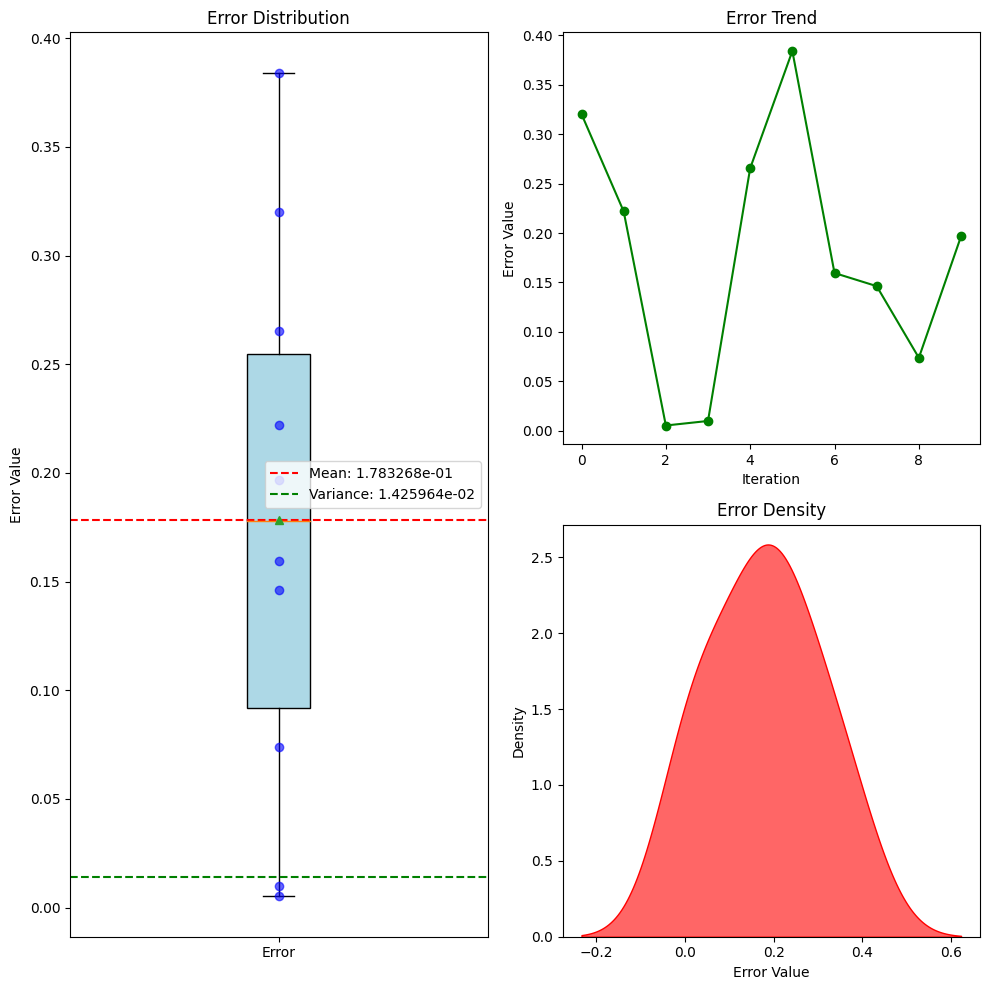

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 1.397466e-02
Variance MAE: 1.305520e-04


/tmp/ipykernel_1736369/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


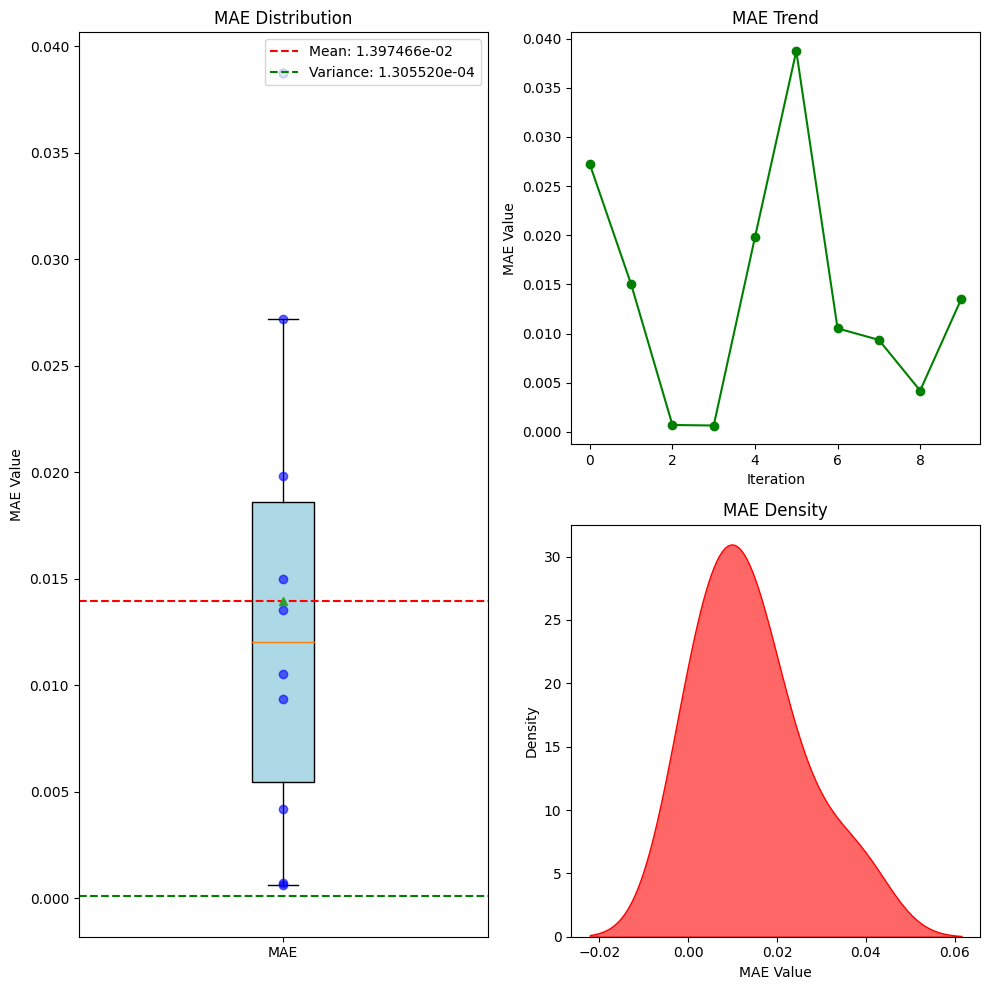

In [10]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 1.738356e-02
Variance MSE: 2.992632e-04


/tmp/ipykernel_1736369/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


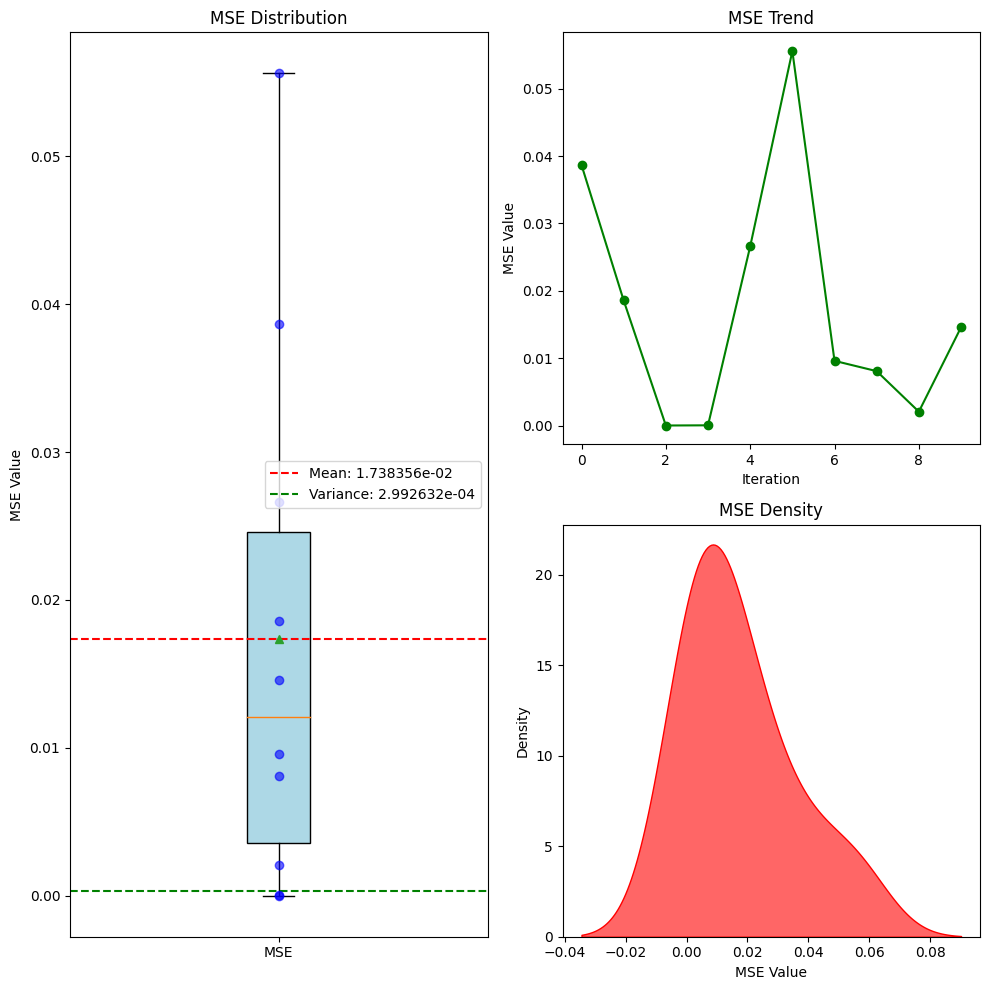

In [11]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

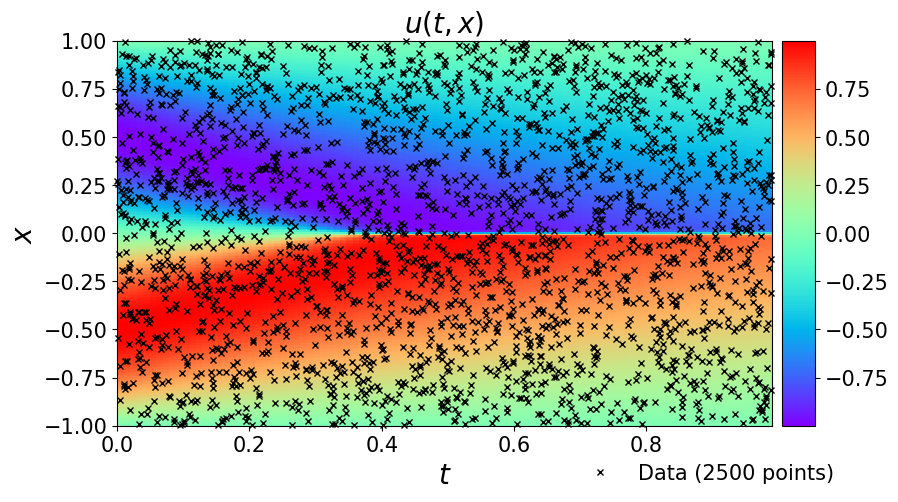

In [12]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [13]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

15244


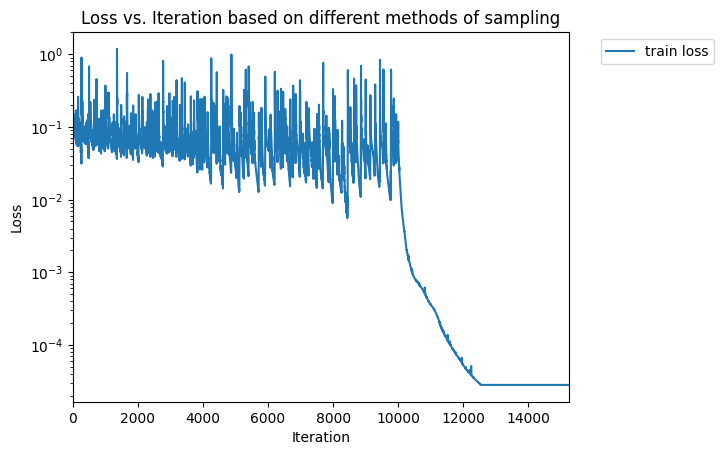

In [14]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


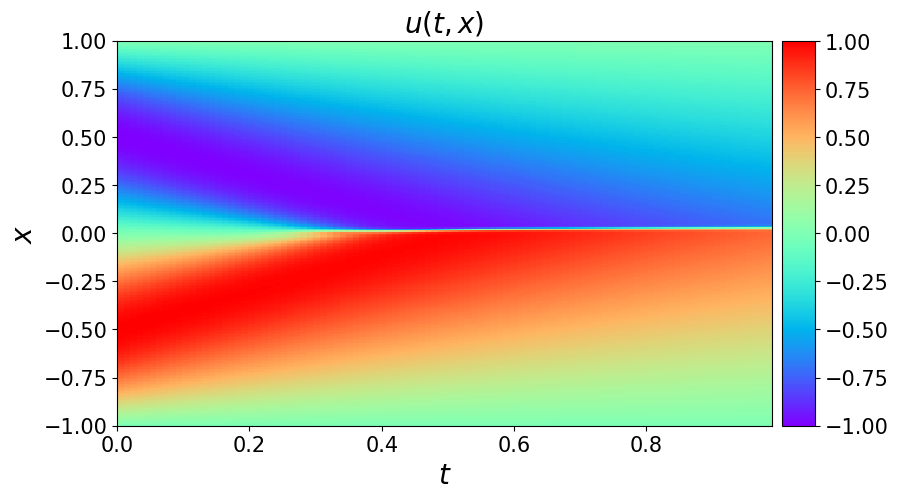

In [15]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

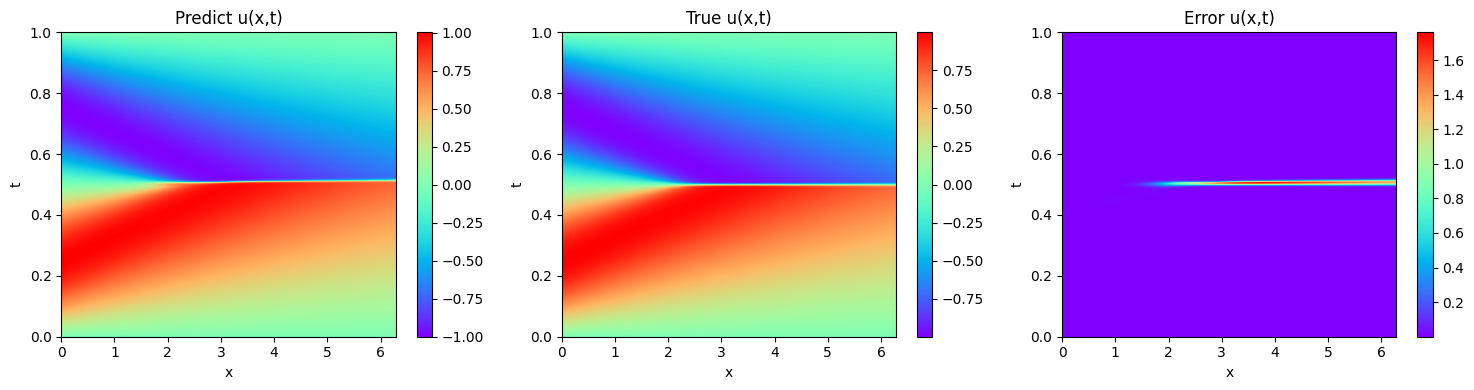

In [16]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [17]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

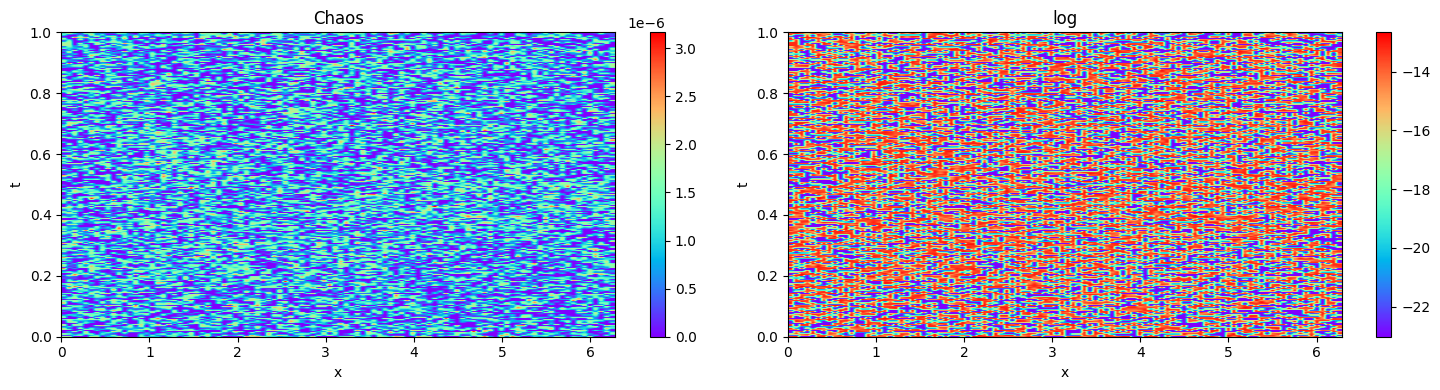

In [18]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()